In [1]:
import torch
#collections是python一个内置模块，提供了一些有用的数据结构
from collections import OrderedDict  #这个类是字典dict的一个子类，用于创建有序的字典。普通字典中元素顺序是无序的，在OrderedDict中元素的顺序是有序的，元素的顺序是按照它们被添加到字典中的顺序决定的。

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #导入了scipy库中的io模块。scipy.io模块包含了一些用于文件输入/输出的函数，例如读取和写入.mat文件（MATLAB格式）
from scipy.interpolate import griddata #`scipy.interpolate`是`scipy`库中的一个模块，提供了许多插值工具，用于在给定的离散数据点之间进行插值和拟合。`griddata`是这个模块中的一个函数，用于在无规则的数据点上进行插值。

import random

import skopt #用于优化问题的库，特别是机器学习中的超参数优化
from distutils.version import LooseVersion #distutils是Python的一个标准库，用于构建和安装Python包。LooseVersion是一个类，用于比较版本号

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。


from mpl_toolkits.axes_grid1 import make_axes_locatable #`mpl_toolkits.axes_grid1`是`matplotlib`库的一个模块，提供了一些高级的工具来控制matplotlib图形中的坐标轴和颜色条。`make_axes_locatable`是模块中的一个函数，用于创建一个可分割的坐标轴。可以在这个坐标轴的四个方向（上、下、左、右）添加新的坐标轴或颜色条。
import matplotlib.gridspec as gridspec #是`matplotlib`库的一个模块，用于创建一个网格布局来放置子图。在`matplotlib`中可以创建一个或多个子图（subplot），每个子图都有自己的坐标轴，并可以在其中绘制图形。`gridspec`模块提供了一个灵活的方式来创建和放置子图。
import time #一个内置模块，用于处理时间相关的操作。


from tqdm import tqdm #一个快速，可扩展的python进度条库，可以在python长循环中添加一个进度提示信息，用户只需要封装任意的迭代器tqdm(iterator)。

import os
import pickle

import timeit #用于计时和测量小段代码的执行时间
import seaborn as sns  # 导入seaborn库用于绘制密度图
import pandas as pd #一个用于数据操作和分析的库，提供了数据结构和数据分析工具，特别是用于处理表格数据（类似于Excel中的数据表）

In [2]:
num_gpus = torch.cuda.device_count()
print('Number of available GPUs: ', num_gpus)

for i in range(num_gpus):
    torch.cuda.set_device(i)
    allocated = torch.cuda.memory_allocated()
    reserved = torch.cuda.memory_reserved()
    print('GPU {}: {}, Allocated: {}, Reserved: {}'.format(i, torch.cuda.get_device_name(i), allocated, reserved))

Number of available GPUs:  2
GPU 0: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0
GPU 1: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0


In [3]:
torch.cuda.set_device(0) #设置当前使用的GPU设备。这里设置为1号GPU设备（第二块显卡）。

# CUDA support 

#设置pytorch的设备，代表了在哪里执行张量积算，设备可以是cpu或者cuda（gpu），并将这个做运算的设备对象存储在变量device中，后续张量计算回在这个设备上执行
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
# the deep neural network
class DNN(torch.nn.Module):
    #第一个方法
    def __init__(self, layers):
        super(DNN, self).__init__() #调用父类的__init__方法进行初始化
        
        # parameters
        self.depth = len(layers) - 1 #定义名为depth的属性，表示神经网络的深度，等于层数-1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh #设置激活函数为tanh
         
        layer_list = list() #定义一个空列表layer_list
        for i in range(self.depth - 1):  #循环depth次
            #将每一层（全连接层）添加到layer_list中
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            #将每一层的激活函数添加到layer_list中
            layer_list.append(('activation_%d' % i, self.activation()))

        #循环结束后，将最后一层的线性变换添加到layer_list中（激活函数为softmax）
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        #输出层的激活函数为tanh
        layer_list.append(('activation_%d' % (self.depth - 1), torch.nn.Softmax(dim=1)))  

        #然后使用OrderedDict将layer_list中的元素转换为有序字典
        layerDict = OrderedDict(layer_list)
        
        # deploy layers，将layerDict转换为一个神经网络模型，赋值给self.layers
        self.layers = torch.nn.Sequential(layerDict) #layers，长度为2*depth，包含了所有的线性变换和激活函数，奇数索引为线性变换(权重矩阵)，偶数索引为激活函数
    
    #第二个方法，定义了模型的前向传播过程
    def forward(self, x):  #接收输入x
        out = self.layers(x) #将输入x传入神经网络模型self.layers中，得到输出out
        return out #返回输出out
    
    # # 新增方法，获取最后一个隐藏层的输出
    # def hidden_output(self, x):
    #     # 遍历每一层，直到最后一个隐藏层
    #     for i in range(self.depth - 1):
    #         # 获取当前层的线性变换
    #         x = self.layers[i*2](x)
    #         # 获取当前层的激活函数
    #         x = self.layers[i*2 + 1](x)
    #     # 返回最后一个隐藏层的输出
    #     return x

    # 新增方法，循环传递输入
    def hidden_forward(self, x, num_cycles):
        # 将输入传递到最后一个隐藏层，x为最后一个隐藏层的输出
        for i in range(self.depth - 1):
            x = self.layers[i*2](x)
            x = self.layers[i*2 + 1](x)
        
        # 将最后一个隐藏层的输出作为输入传递到第一个隐藏层中，重复num_cycles次
        for _ in range(num_cycles):
            for i in range(1, self.depth - 1): #最开始的x为最后一个隐藏层的输出，然后从第一个隐藏层开始传递
                x = self.layers[i*2](x)
                x = self.layers[i*2 + 1](x)
        hidden_output = x
        
        return hidden_output

In [5]:
# the physics-guided neural network
class PhysicsInformedNN():
    # Initialize the class
    def __init__(self, X_u, u, X_f, layers, lb, ub): #这个类包含的第一个方法__init__，这是一个特殊的方法，也就是这个类的构造函数，用于初始化新创建的对象，接受了几个参数

        mu_x, sigma_x = X_f.mean(0), X_f.std(0) #计算X_u的均值和标准差
        X_u = (X_u - mu_x) / sigma_x #对X_u进行标准化
        X_f = (X_f - mu_x) / sigma_x #对X_f进行标准化

        self.mu_x = torch.tensor(mu_x).float().to(device) #创建一个pytorch张量（数据来源于mu_x），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.sigma_x = torch.tensor(sigma_x).float().to(device) #创建一个pytorch张量（数据来源于sigma_x），并将其转换为浮点类型，最后将张量移动到指定的设备上

        # boundary conditions
        #将传入的lb和ub参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.lb和self.ub来访问这些值。
        self.lb = torch.tensor(lb).float().to(device) #创建一个pytorch张量（数据来源于lb），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        #初边界点数据
        self.X_u = torch.tensor(X_u, requires_grad=True).float().to(device)
        #初边界点真实数据
        self.u = torch.tensor(u).float().to(device)
        #配位点数据
        self.X_f = torch.tensor(X_f, requires_grad=True).float().to(device)
        # #测试点数据
        # self.X_star = torch.tensor(X_star).float().to(device)
        # #测试点真实数据
        # self.u_star = torch.tensor(u_star).float().to(device)
        
        self.layers = layers
        
        # deep neural networks
        self.dnn = DNN(layers).to(device) #创建一个DNN类的实例，传入layers参数来实现神经网络的初始化，然后将这个实例移动到指定的设备上
        
        # optimizers: using the same settings
        #创建优化器，括号内为要优化的参数，使用Adam优化方法
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters(), eps = 1e-8) 


        self.iter = 0 #记录迭代次数 

        self.loss_value = [] #创建一个空列表，用于存储损失值

        self.test_error = [] #创建一个空列表，用于存储测试误差
        self.test_error_mse = [] #创建一个空列表，用于存储测试误差
        self.test_error_mae = [] #创建一个空列表，用于存储测试误差


    #主动学习更新配位点数据    
    def update_data(self, X_u, u, X_f):
        mu_x, sigma_x = X_f.mean(0), X_f.std(0)
        X_u = (X_u - mu_x) / sigma_x
        X_f = (X_f - mu_x) / sigma_x

        self.mu_x = torch.tensor(mu_x).float().to(device)
        self.sigma_x = torch.tensor(sigma_x).float().to(device)
        
        self.X_u = torch.tensor(X_u, requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        self.X_f = torch.tensor(X_f, requires_grad=True).float().to(device)
        
    #定义了一个名为net_u的函数/方法，用于计算神经网络的输出。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回神经网络的输出。     
    def net_u(self, x):  
        u = self.dnn(x)  #（第一个参数将输入的两个参数x和t在第二个维度（列）上进行拼接，形成一个新的张量）调用DNN，根据两个参数权重和偏置，以及新得到的张量，计算神经网络的输出u
        return u
    
    #定义了一个名为net_f的函数/方法，用于计算论文中的f。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回计算得到的f。
    def net_f(self, x):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x) #调用上面的net_u函数，计算神经网络的输出u
        u1 = u[:, 0:1] #取u的第一列，对应状态1
        u2 = u[:, 1:2] #取u的第二列，对应状态2
        u3 = u[:, 2:3] #取u的第三列，对应状态3

        u_x_1 = torch.autograd.grad(
            u1, x, #输入的张量，要计算u1关于x的导数
            grad_outputs=torch.ones_like(u1), #生成一个与u1形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u1的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_2 = torch.autograd.grad(
            u2, x, #输入的张量，要计算u2关于x的导数
            grad_outputs=torch.ones_like(u2), #生成一个与u2形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u2的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_3 = torch.autograd.grad(
            u3, x, #输入的张量，要计算u3关于x的导数
            grad_outputs=torch.ones_like(u3), #生成一个与u3形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u3的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度

        #归一化
        u_x_1 = u_x_1 / self.sigma_x
        u_x_2 = u_x_2 / self.sigma_x
        u_x_3 = u_x_3 / self.sigma_x
        
        #计算残差
        xx = x * self.sigma_x + self.mu_x
        residual_1 = u_x_1-(-2.572e-4*xx*u1)
        residual_2 = u_x_2-(1.12e-4*xx*u1-2.012e-4*xx*u2)
        residual_3 = u_x_3-(1.452e-4*xx*u1+2.012e-4*xx*u2)    

        loss_1 = torch.mean(residual_1 ** 2)
        loss_2 = torch.mean(residual_2 ** 2)
        loss_3 = torch.mean(residual_3 ** 2)

        loss_f = loss_1 + loss_2 + loss_3
        return loss_f, residual_1+residual_2+residual_3
    
      
    
    def train(self, nIter):


        #使用Adam优化器优化nIter次
        for epoch in tqdm(range(nIter), desc='Adam'):
            self.dnn.train() #将神经网络设置为训练模式而不是评估模式
            u_pred = self.net_u(self.X_u) #调用之前定义的函数，传入初值得到神经网络的输出u

            loss_u = torch.mean((self.u - u_pred) ** 2) #计算初值的损失函数
            loss_f, _ = self.net_f(self.X_f) #计算残差的损失函数
            

            loss = loss_u + loss_f
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad() #清除该优化器之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
            loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
            self.optimizer_Adam.step()  #使用之前的优化器self.optimizer_Adam，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化
            
            #record the loss value
            self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中

            # # record the test error
            # self.dnn.eval() #将神经网络切换为评估模式
            # with torch.no_grad():
            #     u_real_pred = self.net_u(self.x_star, self.t_star) #调用之前定义的函数，传入参数得到神经网络的输出u


            # error_test = torch.norm(self.u_star-u_real_pred,2)/torch.norm(self.u_star,2)

            # self.test_error.append(error_test)

            # # 计算 MAE和MSE
            # mae = torch.mean(torch.abs(self.u_star - u_real_pred))
            # mse = torch.mean((self.u_star - u_real_pred) ** 2)
            # # 记录 MAE 和 MSE
            # self.test_error_mae.append(mae)
            # self.test_error_mse.append(mse)


  

    def predict(self, X):
        x = torch.tensor(X, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        mu, sigma = self.mu_x, self.sigma_x
        x = (x - mu) / sigma

        self.dnn.eval() #将神经网络切换为评估模式
        u = self.net_u(x) #调用之前定义的函数得到神经网络的输出u,以及f
        _, f = self.net_f(x)
        u = u.detach().cpu().numpy() #将张量u和f先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上
        f = f.detach().cpu().numpy()
        return u, f
    

    def hidden_predict(self, x, num_cycles):
        x = torch.tensor(x, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        mu, sigma = self.mu_x, self.sigma_x
        x = (x - mu) / sigma

        self.dnn.eval()
        hidden_output = self.dnn.hidden_forward(x, num_cycles)
        hidden_output = hidden_output.detach().cpu().numpy()
        return hidden_output

In [6]:
#定义设置随机数种子的函数，第一个参数seed表示种子；第二个参数用来设置CUDA的卷积操作是否确定性，默认为False，表示没有确定性
def set_seed(seed):
    # torch.manual_seed(seed) #设置pytorch的CPU随机数生成器的种子
    # torch.cuda.manual_seed_all(seed) #设置putorch的所有GPU随机数生成器的种子
    # np.random.seed(seed) #设置numpy的随机数生成器的种子
    # random.seed(seed) #设置python的内置随机数生成器的种子
    # torch.backends.cudnn.deterministic = deterministic #True会让CUDA的卷积操作变得确定性，即对于相同的输入，每次运行会得到相同的结果，False则相反
    """
    设置PyTorch的随机种子, 用于生成随机数. 通过设置相同的种子, 可以确保每次运行时生成的随机数序列相同
    """
    torch.manual_seed(seed)
 
    """
    设置PyTorch在所有可用的CUDA设备上的随机种子. 如果在使用GPU进行计算, 这个设置可以确保在不同的GPU上生成的随机数序列相同
    """
    torch.cuda.manual_seed_all(seed)
 
    """
    设置PyTorch在当前CUDA设备上的随机种子. 它与上一行代码的作用类似, 但只影响当前设备
    """
    torch.cuda.manual_seed(seed)
 
    """
    设置NumPy的随机种子, 用于生成随机数. 通过设置相同的种子，可以确保在使用NumPy的随机函数时生成的随机数序列相同
    """
    np.random.seed(seed)
    
    """
    设置Python内置的随机函数的种子. Python的random模块提供了许多随机函数, 包括生成随机数、打乱列表等. 通过设置相同的种子, 可以确保使用这些随机函数时生成的随机数序列相同
    """
    random.seed(seed)
    
    """
    设置Python的哈希种子 (哈希函数被广泛用于数据结构 (如字典和集合) 的实现，以及一些内部操作 (如查找和比较)). 通过设置相同的种子, 可以确保在不同的运行中生成的哈希结果相同
    """
    # os.environ["PYTHONHASHSEED"] = str(seed)
    
    """
    该设置确保每次运行代码时, cuDNN的计算结果是确定性的, 即相同的输入会产生相同的输出, 这是通过禁用一些非确定性的算法来实现的, 例如在卷积操作中使用的算法. 这样做可以保证模型的训练和推理在相同的硬件和软件环境下是可复现的, 即每次运行代码时的结果都相同. 但是, 这可能会导致一些性能上的损失, 因为禁用了一些优化的非确定性算法
    """
    torch.backends.cudnn.deterministic = True
    
    """
    该设置禁用了cuDNN的自动优化过程. 当它被设置为False时, PyTorch不会在每次运行时重新寻找最优的算法配置, 而是使用固定的算法配置. 这样做可以确保每次运行代码时的性能是一致的, 但可能会导致一些性能上的损失
    """
    torch.backends.cudnn.benchmark = False



In [7]:
#RAR-G方法，对1000个点，先选择10个点训练500次，然后每500次迭代重采样100个点，选出其中残差最大的10个点添加到训练点中；最后总共有1000个点，共训练10000次
seeds = [0, 1, 12, 33, 123, 321, 1234, 4321, 12345, 54321] #生成10个随机种子
# seeds = [0]
#设置噪声水平为0
noise = 0.0        

#读取真实解(基于MCS方法得到的解)
MCS_solution_df = pd.read_csv('MCS_non_homo_300.csv')
MCS_solution_df.columns = ['time', 'state_0', 'state_1', 'state_2']

MCS_solution_df.drop(labels='time', inplace=True, axis = 1)


N_u = 1
N_f = 800

#定义一个列表layers，其中包含了神经网络的层数和每一层的神经元数量
layers = [1, 50, 50, 3]

lb  = np.array([0.0])              # t的左边界
ub  = np.array([300.0])          # t的右边界

# Define the initial MSS state
X_u = np.array([[0]])
u = np.array([[1,0,0]])          # 初始真实状态
# X_f = np.linspace(lb, ub, N_f)     # 配位点位置，0~60000的5000个点

error_y = [] #创建一个空列表，用于存储误差值
error_mae = [] #创建一个空列表，用于存储MAE值
error_mse = [] #创建一个空列表，用于存储MSE值
chaoss = [] #创建一个空列表，用于存储chaos值
residuals = [] #创建一个空列表，用于存储residual值

i = 0 #初始化i为0

# # 创建文件夹
# model_dir = 'Adam+LBFGS+LHS(5000)'
# if not os.path.exists(model_dir):
#     os.makedirs(model_dir)

for seed in seeds:
    set_seed(seed) #设置随机数种子

    N_f_1 = N_f // 100 #先拿50个点训练
    X_f_train = lb + (ub - lb) * lhs(1, N_f_1) #生成N_f个随机点
    nIter = 150000 #设置迭代次数为10000

    #创建PINN模型并输入各种参数     
    model = PhysicsInformedNN(X_u, u, X_f_train, layers, lb, ub)

    #获取当前时间并赋值给start_time  
    start_time = time.time()   
    #开始训练模型            
    model.train(nIter//100)


    for iter in range(nIter//100+1, nIter+1, nIter//100): #每800次迭代
        N_f_new = N_f_1 * 10 #重新采样500个点
        X_f_train_new = lb + (ub - lb) * lhs(1, N_f_new) #生成N_f_new个随机点

        #计算残差
        _, residual = model.predict(X_f_train_new)
        abs_residual = np.abs(residual)
        abs_residual = abs_residual.flatten()
        #对abs_residual进行归一化
        abs_residual = abs_residual / np.linalg.norm(abs_residual)


        #计算混沌度
        y_chaos = model.hidden_predict(X_f_train_new, 100)
        x_ssss = X_f_train_new + np.random.normal(0, 0.001)
        y_chaos_ssss = model.hidden_predict(x_ssss, 100)
        chaos = np.linalg.norm(y_chaos - y_chaos_ssss,axis=1)
        #对chaos进行归一化
        epsilon = 1e-10
        norm_chaos = np.linalg.norm(chaos)
        if norm_chaos > epsilon:
            chaos = chaos / norm_chaos
        else:
            chaos = np.zeros_like(chaos)


        #计算信息量
        xinxi = 0.1 * abs_residual + 0.9 * chaos

        #选出信息量最大的10个点
        # 找出绝对值最大的10个值的索引
        topk_indices = np.argpartition(xinxi, -N_f_1)[-N_f_1:] #该函数会对数组进行排序，使得指定的k个最大值出现在数组的最后k给位置上，并获取最后1000个元素

        # 使用这些索引来提取对应的数据
        X_f_train_topk = X_f_train_new[topk_indices]

        X_f_train = np.vstack((X_f_train, X_f_train_topk)) #与之前的训练数据合并

        # 更新模型中的X_f_train数据
        model.update_data(X_u, u, X_f_train)

        # 在更新数据后的模型上进行训练500次
        model.train(nIter//100)

    # print(X_f_train.shape)
    # 更新模型中的X_f_train数据
    model.update_data(X_u, u, X_f_train)

    #训练结束后获取当前时间并减去start_time，得到训练时间并赋值给elapsed
    elapsed = time.time() - start_time
    #打印训练所花时间                
    print('Training time: %.4f' % (elapsed))

    #真实值
    mu, sigma = model.mu_x, model.sigma_x

    # up = 80000
    n_star = 300+1
    x_star = np.linspace(lb, ub, n_star)[1:] #N_star = x_star.shape[0] 
    y_pred, _ = model.predict(x_star)
    y_star = MCS_solution_df


    #计算误差（基于2范数）        
    error_y.append(np.linalg.norm(y_star-y_pred,2)/np.linalg.norm(y_star,2)) #计算误差，然后将误差添加到error_u列表中             
    # 计算 MAE 和 MSE
    mae = np.mean(np.abs(y_star - y_pred))
    mse = np.mean((y_star - y_pred) ** 2)
    # 记录 MAE 和 MSE
    error_mae.append(mae)
    error_mse.append(mse)


    #计算混沌度
    y_chaos = model.hidden_predict(x_star, 100)
    # print(y_chaos)
    x_sss = x_star + np.random.normal(0, 0.001)
    y_chaos_sss = model.hidden_predict(x_sss, 100)
    chaos = np.linalg.norm(y_chaos - y_chaos_sss,axis=1).sum()
    chaoss.append(chaos)

    #计算残差

    _, residual = model.predict(x_star)
    residual = residual.flatten()
    residual = np.abs(residual)
    residual = residual.sum()
    residuals.append(residual)

    i+=1 #i加1
    print(f'当前为第{i}次循环，种子为{seed}')
    print('Error y : %e' % (np.linalg.norm(y_star-y_pred,2)/np.linalg.norm(y_star,2))) #打印误差  
    print('MAE: %e' % mae) #打印MAE
    print('MSE: %e' % mse) #打印MSE
    print('Chaos: %e' % chaos) #打印混沌度
    print('Residual: %e' % residual) #打印残差
    # # 保存模型到文件夹
    # model_path = os.path.join(model_dir, f'model_{i}_seed_{seed}.pkl')
    # with open(model_path, 'wb') as f:
    #     pickle.dump(model, f)


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 6/1500 [00:00<00:25, 59.45it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:04, 357.28it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:02, 482.92it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:02, 499.84it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:02, 540.60it/s]

Adam:  21%|██        | 308/1500 [00:00<00:02, 576.82it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:01, 595.48it/s]

Adam:  29%|██▉       | 437/1500 [00:00<00:01, 610.91it/s]

Adam:  33%|███▎      | 502/1500 [00:00<00:01, 620.66it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:01, 627.58it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:01, 627.84it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:01, 624.62it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:01, 630.50it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:01, 636.30it/s]

Adam:  59%|█████▉    | 887/1500 [00:01<00:00, 620.71it/s]

Adam:  63%|██████▎   | 952/1500 [00:01<00:00, 627.57it/s]

Adam:  68%|██████▊   | 1015/1500 [00:01<00:00, 622.78it/s]

Adam:  72%|███████▏  | 1078/1500 [00:01<00:00, 618.08it/s]

Adam:  76%|███████▌  | 1142/1500 [00:01<00:00, 624.30it/s]

Adam:  80%|████████  | 1205/1500 [00:02<00:00, 619.34it/s]

Adam:  85%|████████▍ | 1270/1500 [00:02<00:00, 626.95it/s]

Adam:  89%|████████▉ | 1335/1500 [00:02<00:00, 632.43it/s]

Adam:  93%|█████████▎| 1400/1500 [00:02<00:00, 636.94it/s]

Adam:  98%|█████████▊| 1464/1500 [00:02<00:00, 635.00it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 601.29it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:02, 589.40it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:02, 591.29it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:02, 592.29it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:02, 585.40it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:02, 584.02it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:01, 583.42it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:01, 566.46it/s]

Adam:  32%|███▏      | 473/1500 [00:00<00:01, 562.85it/s]

Adam:  35%|███▌      | 531/1500 [00:00<00:01, 567.76it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:01, 564.55it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:01, 571.52it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 573.25it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 581.68it/s]

Adam:  55%|█████▌    | 825/1500 [00:01<00:01, 579.02it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:01, 578.26it/s]

Adam:  63%|██████▎   | 943/1500 [00:01<00:00, 582.93it/s]

Adam:  67%|██████▋   | 1003/1500 [00:01<00:00, 585.99it/s]

Adam:  71%|███████   | 1064/1500 [00:01<00:00, 590.52it/s]

Adam:  75%|███████▍  | 1124/1500 [00:01<00:00, 585.02it/s]

Adam:  79%|███████▉  | 1183/1500 [00:02<00:00, 569.05it/s]

Adam:  83%|████████▎ | 1240/1500 [00:02<00:00, 562.26it/s]

Adam:  86%|████████▋ | 1297/1500 [00:02<00:00, 555.66it/s]

Adam:  90%|█████████ | 1355/1500 [00:02<00:00, 562.03it/s]

Adam:  94%|█████████▍| 1412/1500 [00:02<00:00, 558.50it/s]

Adam:  98%|█████████▊| 1470/1500 [00:02<00:00, 564.79it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 573.40it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:02, 587.85it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:02, 578.41it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:02, 574.06it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:02, 575.83it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:02, 575.07it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:02, 567.97it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:01, 572.15it/s]

Adam:  31%|███       | 468/1500 [00:00<00:01, 575.04it/s]

Adam:  35%|███▌      | 527/1500 [00:00<00:01, 578.83it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:01, 584.68it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:01, 592.50it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:01, 585.01it/s]

Adam:  51%|█████▏    | 769/1500 [00:01<00:01, 587.08it/s]

Adam:  55%|█████▌    | 828/1500 [00:01<00:01, 586.25it/s]

Adam:  59%|█████▉    | 887/1500 [00:01<00:01, 586.41it/s]

Adam:  63%|██████▎   | 946/1500 [00:01<00:00, 574.27it/s]

Adam:  67%|██████▋   | 1004/1500 [00:01<00:00, 568.62it/s]

Adam:  71%|███████   | 1063/1500 [00:01<00:00, 574.15it/s]

Adam:  75%|███████▍  | 1122/1500 [00:01<00:00, 576.80it/s]

Adam:  79%|███████▊  | 1181/1500 [00:02<00:00, 580.19it/s]

Adam:  83%|████████▎ | 1240/1500 [00:02<00:00, 567.04it/s]

Adam:  87%|████████▋ | 1301/1500 [00:02<00:00, 577.65it/s]

Adam:  91%|█████████ | 1359/1500 [00:02<00:00, 556.60it/s]

Adam:  95%|█████████▍| 1419/1500 [00:02<00:00, 566.79it/s]

Adam:  99%|█████████▊| 1478/1500 [00:02<00:00, 572.41it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 576.63it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:02, 575.38it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:02, 586.01it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:02, 588.66it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:02, 561.91it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:02, 574.46it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:01, 583.80it/s]

Adam:  28%|██▊       | 419/1500 [00:00<00:01, 591.27it/s]

Adam:  32%|███▏      | 479/1500 [00:00<00:01, 591.07it/s]

Adam:  36%|███▌      | 539/1500 [00:00<00:01, 590.13it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:01, 590.48it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:01, 591.45it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 582.77it/s]

Adam:  52%|█████▏    | 778/1500 [00:01<00:01, 573.64it/s]

Adam:  56%|█████▌    | 837/1500 [00:01<00:01, 576.08it/s]

Adam:  60%|█████▉    | 895/1500 [00:01<00:01, 577.03it/s]

Adam:  64%|██████▎   | 955/1500 [00:01<00:00, 583.29it/s]

Adam:  68%|██████▊   | 1014/1500 [00:01<00:00, 582.50it/s]

Adam:  72%|███████▏  | 1073/1500 [00:01<00:00, 582.75it/s]

Adam:  76%|███████▌  | 1134/1500 [00:01<00:00, 588.75it/s]

Adam:  80%|███████▉  | 1193/1500 [00:02<00:00, 586.80it/s]

Adam:  83%|████████▎ | 1252/1500 [00:02<00:00, 560.96it/s]

Adam:  87%|████████▋ | 1309/1500 [00:02<00:00, 540.79it/s]

Adam:  91%|█████████▏| 1369/1500 [00:02<00:00, 557.28it/s]

Adam:  95%|█████████▌| 1429/1500 [00:02<00:00, 567.20it/s]

Adam:  99%|█████████▉| 1489/1500 [00:02<00:00, 576.49it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 576.62it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 556.57it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:02, 538.75it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:02, 567.50it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:02, 566.53it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:02, 555.77it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:02, 572.80it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:01, 574.66it/s]

Adam:  31%|███       | 464/1500 [00:00<00:01, 565.75it/s]

Adam:  35%|███▌      | 525/1500 [00:00<00:01, 577.35it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:01, 581.94it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:01, 585.66it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:01, 574.59it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 582.82it/s]

Adam:  55%|█████▍    | 824/1500 [00:01<00:01, 558.47it/s]

Adam:  59%|█████▉    | 884/1500 [00:01<00:01, 567.50it/s]

Adam:  63%|██████▎   | 942/1500 [00:01<00:00, 570.35it/s]

Adam:  67%|██████▋   | 1001/1500 [00:01<00:00, 572.94it/s]

Adam:  71%|███████   | 1059/1500 [00:01<00:00, 573.17it/s]

Adam:  75%|███████▍  | 1119/1500 [00:01<00:00, 578.37it/s]

Adam:  79%|███████▊  | 1179/1500 [00:02<00:00, 583.03it/s]

Adam:  83%|████████▎ | 1238/1500 [00:02<00:00, 583.81it/s]

Adam:  87%|████████▋ | 1298/1500 [00:02<00:00, 588.29it/s]

Adam:  90%|█████████ | 1357/1500 [00:02<00:00, 583.98it/s]

Adam:  94%|█████████▍| 1416/1500 [00:02<00:00, 581.78it/s]

Adam:  98%|█████████▊| 1475/1500 [00:02<00:00, 574.19it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 574.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:02, 571.82it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:02, 580.59it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:02, 583.68it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:02, 587.69it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:02, 588.68it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:01, 592.38it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:01, 580.86it/s]

Adam:  32%|███▏      | 475/1500 [00:00<00:01, 565.97it/s]

Adam:  36%|███▌      | 534/1500 [00:00<00:01, 570.87it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:01, 575.67it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:01, 582.60it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 588.23it/s]

Adam:  52%|█████▏    | 773/1500 [00:01<00:01, 588.38it/s]

Adam:  56%|█████▌    | 834/1500 [00:01<00:01, 592.65it/s]

Adam:  60%|█████▉    | 894/1500 [00:01<00:01, 591.55it/s]

Adam:  64%|██████▎   | 954/1500 [00:01<00:00, 585.30it/s]

Adam:  68%|██████▊   | 1013/1500 [00:01<00:00, 585.60it/s]

Adam:  72%|███████▏  | 1073/1500 [00:01<00:00, 589.08it/s]

Adam:  75%|███████▌  | 1132/1500 [00:01<00:00, 587.36it/s]

Adam:  79%|███████▉  | 1191/1500 [00:02<00:00, 581.99it/s]

Adam:  83%|████████▎ | 1251/1500 [00:02<00:00, 585.48it/s]

Adam:  87%|████████▋ | 1310/1500 [00:02<00:00, 583.88it/s]

Adam:  91%|█████████▏| 1371/1500 [00:02<00:00, 588.67it/s]

Adam:  95%|█████████▌| 1432/1500 [00:02<00:00, 592.45it/s]

Adam: 100%|█████████▉| 1493/1500 [00:02<00:00, 594.83it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 585.22it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:02, 569.68it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:02, 590.98it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:02, 591.90it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:02, 581.73it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:02, 585.85it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:01, 589.73it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:01, 589.37it/s]

Adam:  32%|███▏      | 477/1500 [00:00<00:01, 590.80it/s]

Adam:  36%|███▌      | 537/1500 [00:00<00:01, 592.22it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:01, 583.80it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:01, 584.49it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 588.30it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 592.34it/s]

Adam:  56%|█████▌    | 837/1500 [00:01<00:01, 585.23it/s]

Adam:  60%|█████▉    | 897/1500 [00:01<00:01, 586.85it/s]

Adam:  64%|██████▍   | 957/1500 [00:01<00:00, 588.58it/s]

Adam:  68%|██████▊   | 1017/1500 [00:01<00:00, 590.77it/s]

Adam:  72%|███████▏  | 1077/1500 [00:01<00:00, 592.92it/s]

Adam:  76%|███████▌  | 1137/1500 [00:01<00:00, 590.58it/s]

Adam:  80%|███████▉  | 1197/1500 [00:02<00:00, 571.20it/s]

Adam:  84%|████████▍ | 1258/1500 [00:02<00:00, 581.60it/s]

Adam:  88%|████████▊ | 1317/1500 [00:02<00:00, 572.91it/s]

Adam:  92%|█████████▏| 1375/1500 [00:02<00:00, 574.49it/s]

Adam:  96%|█████████▌| 1435/1500 [00:02<00:00, 579.29it/s]

Adam: 100%|█████████▉| 1494/1500 [00:02<00:00, 581.54it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 584.79it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:02, 591.10it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:02, 589.10it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:02, 595.66it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:02, 592.81it/s]

Adam:  20%|██        | 301/1500 [00:00<00:02, 592.13it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:01, 577.34it/s]

Adam:  28%|██▊       | 419/1500 [00:00<00:01, 562.70it/s]

Adam:  32%|███▏      | 479/1500 [00:00<00:01, 572.66it/s]

Adam:  36%|███▌      | 540/1500 [00:00<00:01, 581.18it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:01, 580.91it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:01, 587.84it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 592.69it/s]

Adam:  52%|█████▏    | 781/1500 [00:01<00:01, 584.86it/s]

Adam:  56%|█████▌    | 842/1500 [00:01<00:01, 589.91it/s]

Adam:  60%|██████    | 902/1500 [00:01<00:01, 590.92it/s]

Adam:  64%|██████▍   | 962/1500 [00:01<00:00, 591.07it/s]

Adam:  68%|██████▊   | 1022/1500 [00:01<00:00, 575.82it/s]

Adam:  72%|███████▏  | 1080/1500 [00:01<00:00, 537.75it/s]

Adam:  76%|███████▌  | 1137/1500 [00:01<00:00, 545.07it/s]

Adam:  80%|███████▉  | 1194/1500 [00:02<00:00, 552.00it/s]

Adam:  84%|████████▎ | 1254/1500 [00:02<00:00, 565.47it/s]

Adam:  88%|████████▊ | 1314/1500 [00:02<00:00, 575.10it/s]

Adam:  92%|█████████▏| 1373/1500 [00:02<00:00, 578.16it/s]

Adam:  95%|█████████▌| 1431/1500 [00:02<00:00, 574.32it/s]

Adam:  99%|█████████▉| 1491/1500 [00:02<00:00, 580.43it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 576.93it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:02, 594.22it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:02, 590.07it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:02, 592.38it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:02, 588.55it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:02, 585.02it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:01, 589.86it/s]

Adam:  28%|██▊       | 419/1500 [00:00<00:01, 582.75it/s]

Adam:  32%|███▏      | 478/1500 [00:00<00:01, 584.55it/s]

Adam:  36%|███▌      | 537/1500 [00:00<00:01, 584.75it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:01, 577.57it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:01, 568.53it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:01, 550.52it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 541.62it/s]

Adam:  55%|█████▌    | 827/1500 [00:01<00:01, 558.19it/s]

Adam:  59%|█████▉    | 885/1500 [00:01<00:01, 564.24it/s]

Adam:  63%|██████▎   | 946/1500 [00:01<00:00, 576.77it/s]

Adam:  67%|██████▋   | 1004/1500 [00:01<00:00, 572.25it/s]

Adam:  71%|███████   | 1065/1500 [00:01<00:00, 580.03it/s]

Adam:  75%|███████▍  | 1124/1500 [00:01<00:00, 566.66it/s]

Adam:  79%|███████▊  | 1181/1500 [00:02<00:00, 560.64it/s]

Adam:  83%|████████▎ | 1241/1500 [00:02<00:00, 569.82it/s]

Adam:  87%|████████▋ | 1299/1500 [00:02<00:00, 566.57it/s]

Adam:  90%|█████████ | 1357/1500 [00:02<00:00, 567.80it/s]

Adam:  94%|█████████▍| 1414/1500 [00:02<00:00, 556.88it/s]

Adam:  98%|█████████▊| 1471/1500 [00:02<00:00, 559.62it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 570.59it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 557.48it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:02, 566.27it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:02, 568.83it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:02, 536.57it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:02, 481.57it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:02, 482.08it/s]

Adam:  26%|██▌       | 386/1500 [00:00<00:02, 495.30it/s]

Adam:  29%|██▉       | 437/1500 [00:00<00:02, 497.00it/s]

Adam:  33%|███▎      | 497/1500 [00:00<00:01, 526.16it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:01, 554.89it/s]

Adam:  41%|████      | 618/1500 [00:01<00:01, 561.91it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:01, 575.62it/s]

Adam:  49%|████▉     | 737/1500 [00:01<00:01, 551.44it/s]

Adam:  53%|█████▎    | 793/1500 [00:01<00:01, 549.32it/s]

Adam:  57%|█████▋    | 849/1500 [00:01<00:01, 531.89it/s]

Adam:  60%|██████    | 903/1500 [00:01<00:01, 501.08it/s]

Adam:  64%|██████▎   | 954/1500 [00:01<00:01, 485.16it/s]

Adam:  68%|██████▊   | 1014/1500 [00:01<00:00, 516.83it/s]

Adam:  72%|███████▏  | 1073/1500 [00:02<00:00, 537.47it/s]

Adam:  76%|███████▌  | 1134/1500 [00:02<00:00, 556.69it/s]

Adam:  79%|███████▉  | 1191/1500 [00:02<00:00, 557.99it/s]

Adam:  83%|████████▎ | 1249/1500 [00:02<00:00, 563.58it/s]

Adam:  87%|████████▋ | 1310/1500 [00:02<00:00, 574.86it/s]

Adam:  91%|█████████▏| 1369/1500 [00:02<00:00, 576.21it/s]

Adam:  95%|█████████▌| 1427/1500 [00:02<00:00, 550.93it/s]

Adam:  99%|█████████▉| 1488/1500 [00:02<00:00, 566.25it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 540.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 554.11it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:02, 568.66it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:02, 562.14it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:02, 559.35it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:02, 479.27it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:02, 510.30it/s]

Adam:  27%|██▋       | 402/1500 [00:00<00:02, 526.30it/s]

Adam:  31%|███       | 460/1500 [00:00<00:01, 541.88it/s]

Adam:  35%|███▍      | 518/1500 [00:00<00:01, 551.71it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:01, 526.05it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:01, 539.39it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:01, 526.90it/s]

Adam:  49%|████▉     | 741/1500 [00:01<00:01, 521.39it/s]

Adam:  53%|█████▎    | 794/1500 [00:01<00:01, 494.98it/s]

Adam:  56%|█████▋    | 844/1500 [00:01<00:01, 475.56it/s]

Adam:  59%|█████▉    | 892/1500 [00:01<00:01, 459.10it/s]

Adam:  63%|██████▎   | 939/1500 [00:01<00:01, 459.76it/s]

Adam:  66%|██████▌   | 989/1500 [00:01<00:01, 469.46it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:00, 470.09it/s]

Adam:  72%|███████▏  | 1085/1500 [00:02<00:00, 470.62it/s]

Adam:  76%|███████▌  | 1133/1500 [00:02<00:00, 463.40it/s]

Adam:  79%|███████▉  | 1183/1500 [00:02<00:00, 471.02it/s]

Adam:  82%|████████▏ | 1231/1500 [00:02<00:00, 457.92it/s]

Adam:  85%|████████▌ | 1277/1500 [00:02<00:00, 442.98it/s]

Adam:  88%|████████▊ | 1326/1500 [00:02<00:00, 455.27it/s]

Adam:  92%|█████████▏| 1374/1500 [00:02<00:00, 460.87it/s]

Adam:  95%|█████████▌| 1426/1500 [00:02<00:00, 476.39it/s]

Adam:  98%|█████████▊| 1474/1500 [00:02<00:00, 468.34it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 491.33it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 459.96it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:02, 477.47it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:03, 439.62it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:03, 406.60it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:03, 417.08it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:02, 435.50it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:02, 448.84it/s]

Adam:  25%|██▌       | 376/1500 [00:00<00:02, 453.16it/s]

Adam:  28%|██▊       | 422/1500 [00:00<00:02, 450.86it/s]

Adam:  31%|███       | 468/1500 [00:01<00:02, 430.27it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:02, 418.52it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:02, 432.90it/s]

Adam:  41%|████      | 608/1500 [00:01<00:01, 448.51it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:01, 444.80it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:01, 468.18it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 454.79it/s]

Adam:  53%|█████▎    | 801/1500 [00:01<00:01, 458.17it/s]

Adam:  56%|█████▋    | 847/1500 [00:01<00:01, 457.63it/s]

Adam:  60%|█████▉    | 893/1500 [00:02<00:01, 450.42it/s]

Adam:  63%|██████▎   | 944/1500 [00:02<00:01, 467.35it/s]

Adam:  66%|██████▌   | 991/1500 [00:02<00:01, 466.11it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:00, 472.21it/s]

Adam:  73%|███████▎  | 1088/1500 [00:02<00:00, 462.81it/s]

Adam:  76%|███████▌  | 1140/1500 [00:02<00:00, 478.86it/s]

Adam:  80%|███████▉  | 1193/1500 [00:02<00:00, 490.92it/s]

Adam:  83%|████████▎ | 1243/1500 [00:02<00:00, 493.52it/s]

Adam:  86%|████████▌ | 1293/1500 [00:02<00:00, 491.42it/s]

Adam:  90%|████████▉ | 1343/1500 [00:02<00:00, 485.42it/s]

Adam:  93%|█████████▎| 1392/1500 [00:03<00:00, 438.28it/s]

Adam:  96%|█████████▌| 1441/1500 [00:03<00:00, 450.93it/s]

Adam: 100%|█████████▉| 1494/1500 [00:03<00:00, 470.97it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 456.71it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 467.70it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 489.81it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:02, 458.60it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:02, 453.09it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:02, 434.52it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:02, 430.77it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:02, 451.52it/s]

Adam:  25%|██▌       | 380/1500 [00:00<00:02, 449.57it/s]

Adam:  28%|██▊       | 426/1500 [00:00<00:02, 433.01it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:02, 449.33it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:02, 464.55it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:01, 480.39it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:01, 483.09it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:01, 468.65it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 472.42it/s]

Adam:  52%|█████▏    | 773/1500 [00:01<00:01, 467.60it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:01, 468.80it/s]

Adam:  58%|█████▊    | 871/1500 [00:01<00:01, 476.54it/s]

Adam:  61%|██████▏   | 919/1500 [00:01<00:01, 462.13it/s]

Adam:  64%|██████▍   | 967/1500 [00:02<00:01, 465.06it/s]

Adam:  68%|██████▊   | 1016/1500 [00:02<00:01, 471.65it/s]

Adam:  71%|███████   | 1068/1500 [00:02<00:00, 484.37it/s]

Adam:  74%|███████▍  | 1117/1500 [00:02<00:00, 478.56it/s]

Adam:  78%|███████▊  | 1165/1500 [00:02<00:00, 459.83it/s]

Adam:  81%|████████  | 1213/1500 [00:02<00:00, 463.72it/s]

Adam:  84%|████████▍ | 1260/1500 [00:02<00:00, 431.21it/s]

Adam:  87%|████████▋ | 1307/1500 [00:02<00:00, 440.72it/s]

Adam:  91%|█████████ | 1358/1500 [00:02<00:00, 459.17it/s]

Adam:  94%|█████████▎| 1405/1500 [00:03<00:00, 428.39it/s]

Adam:  97%|█████████▋| 1449/1500 [00:03<00:00, 424.35it/s]

Adam:  99%|█████████▉| 1492/1500 [00:03<00:00, 422.73it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 454.26it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 551.09it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:02, 515.38it/s]

Adam:  11%|█         | 164/1500 [00:00<00:02, 474.66it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:02, 492.02it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:02, 494.93it/s]

Adam:  21%|██        | 318/1500 [00:00<00:02, 467.84it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:02, 434.16it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:02, 422.61it/s]

Adam:  30%|███       | 453/1500 [00:00<00:02, 423.51it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 439.36it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:02, 442.45it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:02, 445.30it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:01, 452.54it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:01, 469.57it/s]

Adam:  49%|████▉     | 740/1500 [00:01<00:01, 444.35it/s]

Adam:  52%|█████▏    | 787/1500 [00:01<00:01, 451.30it/s]

Adam:  56%|█████▌    | 838/1500 [00:01<00:01, 465.29it/s]

Adam:  59%|█████▉    | 885/1500 [00:01<00:01, 455.35it/s]

Adam:  62%|██████▏   | 931/1500 [00:02<00:01, 441.27it/s]

Adam:  65%|██████▌   | 977/1500 [00:02<00:01, 444.63it/s]

Adam:  68%|██████▊   | 1025/1500 [00:02<00:01, 452.98it/s]

Adam:  71%|███████▏  | 1071/1500 [00:02<00:00, 452.18it/s]

Adam:  74%|███████▍  | 1117/1500 [00:02<00:00, 451.01it/s]

Adam:  78%|███████▊  | 1163/1500 [00:02<00:00, 441.32it/s]

Adam:  81%|████████  | 1211/1500 [00:02<00:00, 451.09it/s]

Adam:  84%|████████▍ | 1263/1500 [00:02<00:00, 466.61it/s]

Adam:  88%|████████▊ | 1313/1500 [00:02<00:00, 475.05it/s]

Adam:  91%|█████████ | 1361/1500 [00:02<00:00, 459.77it/s]

Adam:  94%|█████████▍| 1408/1500 [00:03<00:00, 451.56it/s]

Adam:  97%|█████████▋| 1454/1500 [00:03<00:00, 449.10it/s]

Adam: 100%|█████████▉| 1499/1500 [00:03<00:00, 447.88it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 454.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 471.51it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:03, 461.00it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:02, 468.83it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:02, 465.39it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:02, 468.83it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:02, 469.14it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:02, 476.90it/s]

Adam:  26%|██▌       | 385/1500 [00:00<00:02, 479.78it/s]

Adam:  29%|██▉       | 434/1500 [00:00<00:02, 480.98it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:02, 455.84it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:02, 451.83it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:02, 437.20it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:02, 437.96it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:01, 442.62it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:01, 442.78it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 439.56it/s]

Adam:  54%|█████▍    | 807/1500 [00:01<00:01, 457.56it/s]

Adam:  57%|█████▋    | 856/1500 [00:01<00:01, 465.90it/s]

Adam:  60%|██████    | 903/1500 [00:01<00:01, 458.46it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 427.66it/s]

Adam:  66%|██████▋   | 994/1500 [00:02<00:01, 432.20it/s]

Adam:  70%|██████▉   | 1045/1500 [00:02<00:01, 454.23it/s]

Adam:  73%|███████▎  | 1094/1500 [00:02<00:00, 464.27it/s]

Adam:  76%|███████▌  | 1141/1500 [00:02<00:00, 455.88it/s]

Adam:  79%|███████▉  | 1189/1500 [00:02<00:00, 460.63it/s]

Adam:  82%|████████▏ | 1236/1500 [00:02<00:00, 453.91it/s]

Adam:  85%|████████▌ | 1282/1500 [00:02<00:00, 452.68it/s]

Adam:  89%|████████▊ | 1328/1500 [00:02<00:00, 445.82it/s]

Adam:  92%|█████████▏| 1380/1500 [00:03<00:00, 465.89it/s]

Adam:  95%|█████████▌| 1427/1500 [00:03<00:00, 463.65it/s]

Adam:  98%|█████████▊| 1474/1500 [00:03<00:00, 446.16it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 454.30it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 397.96it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:03, 432.61it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:03, 451.12it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:02, 454.05it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:02, 433.72it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:02, 441.34it/s]

Adam:  21%|██        | 318/1500 [00:00<00:02, 438.96it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 441.68it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:02, 452.85it/s]

Adam:  30%|███       | 457/1500 [00:01<00:02, 447.84it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:02, 453.04it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:02, 458.74it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:01, 460.39it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:01, 471.88it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:01, 486.00it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 453.32it/s]

Adam:  53%|█████▎    | 796/1500 [00:01<00:01, 446.13it/s]

Adam:  56%|█████▌    | 841/1500 [00:01<00:01, 439.04it/s]

Adam:  59%|█████▉    | 886/1500 [00:01<00:01, 440.33it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 454.18it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 448.22it/s]

Adam:  68%|██████▊   | 1026/1500 [00:02<00:01, 444.06it/s]

Adam:  71%|███████▏  | 1071/1500 [00:02<00:00, 441.87it/s]

Adam:  75%|███████▍  | 1118/1500 [00:02<00:00, 449.83it/s]

Adam:  78%|███████▊  | 1164/1500 [00:02<00:00, 430.31it/s]

Adam:  81%|████████  | 1208/1500 [00:02<00:00, 429.32it/s]

Adam:  84%|████████▎ | 1256/1500 [00:02<00:00, 443.88it/s]

Adam:  87%|████████▋ | 1301/1500 [00:02<00:00, 433.16it/s]

Adam:  90%|████████▉ | 1345/1500 [00:03<00:00, 416.87it/s]

Adam:  93%|█████████▎| 1388/1500 [00:03<00:00, 420.05it/s]

Adam:  95%|█████████▌| 1431/1500 [00:03<00:00, 386.63it/s]

Adam:  99%|█████████▊| 1481/1500 [00:03<00:00, 415.72it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 440.16it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 409.31it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:03, 430.95it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:03, 423.45it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:03, 395.28it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:03, 412.07it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:02, 449.90it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:02, 465.30it/s]

Adam:  25%|██▍       | 368/1500 [00:00<00:02, 452.07it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:02, 447.43it/s]

Adam:  31%|███       | 465/1500 [00:01<00:02, 465.80it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:02, 469.03it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:02, 468.06it/s]

Adam:  41%|████      | 609/1500 [00:01<00:01, 468.46it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:01, 464.83it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 471.89it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 472.76it/s]

Adam:  53%|█████▎    | 801/1500 [00:01<00:01, 458.27it/s]

Adam:  56%|█████▋    | 847/1500 [00:01<00:01, 456.57it/s]

Adam:  60%|█████▉    | 899/1500 [00:01<00:01, 474.29it/s]

Adam:  63%|██████▎   | 947/1500 [00:02<00:01, 463.00it/s]

Adam:  67%|██████▋   | 998/1500 [00:02<00:01, 473.87it/s]

Adam:  70%|██████▉   | 1046/1500 [00:02<00:00, 461.02it/s]

Adam:  73%|███████▎  | 1093/1500 [00:02<00:00, 446.07it/s]

Adam:  76%|███████▌  | 1139/1500 [00:02<00:00, 448.74it/s]

Adam:  79%|███████▉  | 1188/1500 [00:02<00:00, 458.84it/s]

Adam:  82%|████████▏ | 1237/1500 [00:02<00:00, 467.13it/s]

Adam:  86%|████████▌ | 1287/1500 [00:02<00:00, 476.43it/s]

Adam:  89%|████████▉ | 1335/1500 [00:02<00:00, 449.45it/s]

Adam:  92%|█████████▏| 1381/1500 [00:03<00:00, 440.27it/s]

Adam:  95%|█████████▌| 1427/1500 [00:03<00:00, 445.28it/s]

Adam:  98%|█████████▊| 1472/1500 [00:03<00:00, 419.82it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 452.17it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 512.92it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 472.44it/s]

Adam:  10%|█         | 152/1500 [00:00<00:03, 448.06it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:02, 450.90it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:02, 453.05it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:02, 458.45it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:02, 467.94it/s]

Adam:  26%|██▌       | 387/1500 [00:00<00:02, 453.59it/s]

Adam:  29%|██▉       | 438/1500 [00:00<00:02, 468.85it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:02, 480.00it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:02, 477.96it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:01, 475.16it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:01, 476.41it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:01, 465.15it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:01, 458.12it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 463.94it/s]

Adam:  55%|█████▍    | 824/1500 [00:01<00:01, 460.03it/s]

Adam:  58%|█████▊    | 871/1500 [00:01<00:01, 448.85it/s]

Adam:  61%|██████▏   | 919/1500 [00:01<00:01, 456.48it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 454.56it/s]

Adam:  68%|██████▊   | 1016/1500 [00:02<00:01, 469.25it/s]

Adam:  71%|███████   | 1065/1500 [00:02<00:00, 473.36it/s]

Adam:  74%|███████▍  | 1114/1500 [00:02<00:00, 476.32it/s]

Adam:  77%|███████▋  | 1162/1500 [00:02<00:00, 477.14it/s]

Adam:  81%|████████  | 1210/1500 [00:02<00:00, 461.96it/s]

Adam:  84%|████████▍ | 1257/1500 [00:02<00:00, 450.45it/s]

Adam:  87%|████████▋ | 1303/1500 [00:02<00:00, 444.94it/s]

Adam:  90%|████████▉ | 1349/1500 [00:02<00:00, 448.81it/s]

Adam:  93%|█████████▎| 1394/1500 [00:03<00:00, 433.22it/s]

Adam:  96%|█████████▋| 1444/1500 [00:03<00:00, 450.26it/s]

Adam: 100%|█████████▉| 1493/1500 [00:03<00:00, 460.09it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 461.58it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 432.15it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:02, 472.96it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:02, 483.09it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:02, 468.03it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:02, 478.21it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:02, 463.70it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:02, 448.91it/s]

Adam:  26%|██▌       | 387/1500 [00:00<00:02, 456.91it/s]

Adam:  29%|██▉       | 433/1500 [00:00<00:02, 454.79it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:02, 460.82it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 442.21it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:02, 452.91it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:01, 454.70it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:01, 438.37it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 438.70it/s]

Adam:  51%|█████     | 763/1500 [00:01<00:01, 451.66it/s]

Adam:  54%|█████▍    | 809/1500 [00:01<00:01, 452.59it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:01, 460.33it/s]

Adam:  61%|██████    | 909/1500 [00:01<00:01, 475.15it/s]

Adam:  64%|██████▍   | 957/1500 [00:02<00:01, 433.81it/s]

Adam:  67%|██████▋   | 1002/1500 [00:02<00:01, 425.75it/s]

Adam:  70%|███████   | 1050/1500 [00:02<00:01, 440.74it/s]

Adam:  73%|███████▎  | 1098/1500 [00:02<00:00, 450.87it/s]

Adam:  76%|███████▋  | 1144/1500 [00:02<00:00, 453.30it/s]

Adam:  79%|███████▉  | 1191/1500 [00:02<00:00, 455.70it/s]

Adam:  82%|████████▏ | 1237/1500 [00:02<00:00, 452.75it/s]

Adam:  86%|████████▌ | 1285/1500 [00:02<00:00, 458.26it/s]

Adam:  89%|████████▉ | 1337/1500 [00:02<00:00, 476.03it/s]

Adam:  92%|█████████▏| 1387/1500 [00:03<00:00, 481.36it/s]

Adam:  96%|█████████▌| 1436/1500 [00:03<00:00, 455.87it/s]

Adam:  99%|█████████▉| 1482/1500 [00:03<00:00, 428.94it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 451.18it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 419.56it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:03, 462.07it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:02, 461.83it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:02, 460.66it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:02, 475.40it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:02, 483.33it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:02, 497.36it/s]

Adam:  26%|██▌       | 390/1500 [00:00<00:02, 470.50it/s]

Adam:  29%|██▉       | 438/1500 [00:00<00:02, 467.82it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:02, 464.43it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:02, 466.58it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:02, 404.62it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:02, 423.29it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:01, 437.87it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 454.14it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 462.91it/s]

Adam:  55%|█████▍    | 824/1500 [00:01<00:01, 468.74it/s]

Adam:  58%|█████▊    | 872/1500 [00:01<00:01, 470.17it/s]

Adam:  61%|██████▏   | 920/1500 [00:02<00:01, 466.13it/s]

Adam:  64%|██████▍   | 967/1500 [00:02<00:01, 466.05it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:01, 445.45it/s]

Adam:  71%|███████   | 1060/1500 [00:02<00:00, 448.06it/s]

Adam:  74%|███████▎  | 1106/1500 [00:02<00:00, 447.61it/s]

Adam:  77%|███████▋  | 1151/1500 [00:02<00:00, 436.48it/s]

Adam:  80%|███████▉  | 1198/1500 [00:02<00:00, 445.86it/s]

Adam:  83%|████████▎ | 1244/1500 [00:02<00:00, 447.24it/s]

Adam:  86%|████████▌ | 1292/1500 [00:02<00:00, 454.99it/s]

Adam:  89%|████████▉ | 1338/1500 [00:02<00:00, 447.01it/s]

Adam:  92%|█████████▏| 1387/1500 [00:03<00:00, 457.97it/s]

Adam:  96%|█████████▌| 1436/1500 [00:03<00:00, 465.15it/s]

Adam:  99%|█████████▉| 1485/1500 [00:03<00:00, 471.92it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 456.71it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 455.42it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:02, 477.25it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:02, 475.10it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:02, 470.51it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:02, 441.84it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:02, 444.87it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:02, 456.47it/s]

Adam:  26%|██▌       | 384/1500 [00:00<00:02, 465.16it/s]

Adam:  29%|██▉       | 433/1500 [00:00<00:02, 469.89it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:02, 465.05it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 463.10it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:01, 465.63it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:01, 461.58it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:01, 452.64it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 454.17it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 429.68it/s]

Adam:  54%|█████▎    | 806/1500 [00:01<00:01, 421.44it/s]

Adam:  57%|█████▋    | 849/1500 [00:01<00:01, 401.88it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:01, 409.11it/s]

Adam:  62%|██████▏   | 937/1500 [00:02<00:01, 419.46it/s]

Adam:  66%|██████▌   | 983/1500 [00:02<00:01, 430.16it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:01, 436.88it/s]

Adam:  72%|███████▏  | 1073/1500 [00:02<00:00, 432.36it/s]

Adam:  75%|███████▍  | 1120/1500 [00:02<00:00, 441.94it/s]

Adam:  78%|███████▊  | 1166/1500 [00:02<00:00, 445.95it/s]

Adam:  81%|████████  | 1211/1500 [00:02<00:00, 426.14it/s]

Adam:  84%|████████▍ | 1261/1500 [00:02<00:00, 446.65it/s]

Adam:  87%|████████▋ | 1306/1500 [00:02<00:00, 445.35it/s]

Adam:  90%|█████████ | 1354/1500 [00:03<00:00, 453.10it/s]

Adam:  93%|█████████▎| 1400/1500 [00:03<00:00, 453.77it/s]

Adam:  96%|█████████▋| 1446/1500 [00:03<00:00, 451.57it/s]

Adam: 100%|█████████▉| 1499/1500 [00:03<00:00, 472.80it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 448.29it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 461.16it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:03, 384.04it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:03, 382.34it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:03, 413.17it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:03, 421.09it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:02, 415.75it/s]

Adam:  21%|██        | 313/1500 [00:00<00:02, 426.25it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 433.96it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:02, 433.36it/s]

Adam:  30%|██▉       | 448/1500 [00:01<00:02, 435.52it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:02, 453.12it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:02, 445.33it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:02, 434.37it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:02, 429.27it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:01, 429.91it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 428.44it/s]

Adam:  51%|█████     | 764/1500 [00:01<00:01, 423.16it/s]

Adam:  54%|█████▍    | 813/1500 [00:01<00:01, 438.44it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:01, 436.55it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 454.44it/s]

Adam:  64%|██████▍   | 958/1500 [00:02<00:01, 468.30it/s]

Adam:  67%|██████▋   | 1005/1500 [00:02<00:01, 467.46it/s]

Adam:  70%|███████   | 1056/1500 [00:02<00:00, 479.23it/s]

Adam:  74%|███████▎  | 1104/1500 [00:02<00:00, 453.64it/s]

Adam:  77%|███████▋  | 1150/1500 [00:02<00:00, 451.12it/s]

Adam:  80%|███████▉  | 1197/1500 [00:02<00:00, 456.40it/s]

Adam:  83%|████████▎ | 1243/1500 [00:02<00:00, 455.09it/s]

Adam:  86%|████████▌ | 1289/1500 [00:02<00:00, 455.74it/s]

Adam:  89%|████████▉ | 1339/1500 [00:03<00:00, 467.95it/s]

Adam:  93%|█████████▎| 1388/1500 [00:03<00:00, 472.46it/s]

Adam:  96%|█████████▌| 1436/1500 [00:03<00:00, 457.54it/s]

Adam:  99%|█████████▉| 1487/1500 [00:03<00:00, 470.38it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 444.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 459.03it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:02, 471.44it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:03, 429.23it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:03, 424.61it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:02, 423.50it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:02, 433.25it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:03, 386.83it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:02, 389.01it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:02, 400.36it/s]

Adam:  30%|██▉       | 448/1500 [00:01<00:02, 413.91it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:02, 426.13it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:02, 451.83it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:02, 437.19it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:01, 440.94it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:01, 414.61it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 418.34it/s]

Adam:  51%|█████▏    | 769/1500 [00:01<00:01, 421.31it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 419.41it/s]

Adam:  57%|█████▋    | 855/1500 [00:02<00:01, 422.12it/s]

Adam:  60%|█████▉    | 898/1500 [00:02<00:01, 410.60it/s]

Adam:  63%|██████▎   | 945/1500 [00:02<00:01, 426.97it/s]

Adam:  66%|██████▌   | 990/1500 [00:02<00:01, 431.81it/s]

Adam:  69%|██████▉   | 1039/1500 [00:02<00:01, 447.70it/s]

Adam:  73%|███████▎  | 1090/1500 [00:02<00:00, 465.10it/s]

Adam:  76%|███████▌  | 1137/1500 [00:02<00:00, 459.09it/s]

Adam:  79%|███████▉  | 1185/1500 [00:02<00:00, 464.56it/s]

Adam:  82%|████████▏ | 1232/1500 [00:02<00:00, 448.54it/s]

Adam:  85%|████████▌ | 1280/1500 [00:02<00:00, 455.75it/s]

Adam:  88%|████████▊ | 1327/1500 [00:03<00:00, 457.46it/s]

Adam:  92%|█████████▏| 1373/1500 [00:03<00:00, 438.29it/s]

Adam:  95%|█████████▍| 1421/1500 [00:03<00:00, 448.55it/s]

Adam:  98%|█████████▊| 1467/1500 [00:03<00:00, 438.49it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 433.24it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 457.11it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:03, 453.58it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:03, 440.45it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:03, 424.27it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:02, 443.18it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:02, 418.56it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:02, 421.70it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:02, 396.98it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:02, 400.57it/s]

Adam:  30%|███       | 453/1500 [00:01<00:02, 428.11it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 442.81it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:02, 452.40it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:01, 463.92it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:01, 452.08it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:01, 432.41it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 433.60it/s]

Adam:  52%|█████▏    | 780/1500 [00:01<00:01, 419.59it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:01, 405.50it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:01, 414.01it/s]

Adam:  61%|██████    | 916/1500 [00:02<00:01, 433.88it/s]

Adam:  65%|██████▍   | 968/1500 [00:02<00:01, 455.93it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:01, 449.94it/s]

Adam:  71%|███████   | 1060/1500 [00:02<00:01, 406.29it/s]

Adam:  74%|███████▍  | 1110/1500 [00:02<00:00, 430.63it/s]

Adam:  77%|███████▋  | 1160/1500 [00:02<00:00, 448.34it/s]

Adam:  80%|████████  | 1207/1500 [00:02<00:00, 453.60it/s]

Adam:  84%|████████▎ | 1253/1500 [00:02<00:00, 426.13it/s]

Adam:  87%|████████▋ | 1298/1500 [00:03<00:00, 430.44it/s]

Adam:  89%|████████▉ | 1342/1500 [00:03<00:00, 429.96it/s]

Adam:  92%|█████████▏| 1386/1500 [00:03<00:00, 393.75it/s]

Adam:  95%|█████████▌| 1431/1500 [00:03<00:00, 408.82it/s]

Adam:  99%|█████████▉| 1483/1500 [00:03<00:00, 439.32it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 431.20it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 507.44it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:03, 455.31it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 475.77it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 477.04it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:02, 482.93it/s]

Adam:  20%|██        | 300/1500 [00:00<00:02, 482.52it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:02, 468.91it/s]

Adam:  26%|██▋       | 397/1500 [00:00<00:02, 450.09it/s]

Adam:  30%|██▉       | 445/1500 [00:00<00:02, 458.08it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:02, 469.88it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:02, 466.03it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:02, 442.20it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:01, 438.59it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 433.58it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:01, 449.41it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 462.89it/s]

Adam:  55%|█████▌    | 826/1500 [00:01<00:01, 458.41it/s]

Adam:  58%|█████▊    | 872/1500 [00:01<00:01, 453.06it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:01, 415.15it/s]

Adam:  64%|██████▍   | 961/1500 [00:02<00:01, 397.89it/s]

Adam:  67%|██████▋   | 1004/1500 [00:02<00:01, 405.75it/s]

Adam:  70%|██████▉   | 1046/1500 [00:02<00:01, 379.66it/s]

Adam:  72%|███████▏  | 1085/1500 [00:02<00:01, 340.24it/s]

Adam:  75%|███████▌  | 1130/1500 [00:02<00:01, 367.76it/s]

Adam:  78%|███████▊  | 1175/1500 [00:02<00:00, 387.96it/s]

Adam:  82%|████████▏ | 1225/1500 [00:02<00:00, 416.90it/s]

Adam:  85%|████████▍ | 1268/1500 [00:02<00:00, 399.30it/s]

Adam:  88%|████████▊ | 1316/1500 [00:03<00:00, 419.24it/s]

Adam:  91%|█████████ | 1359/1500 [00:03<00:00, 400.02it/s]

Adam:  94%|█████████▍| 1410/1500 [00:03<00:00, 428.96it/s]

Adam:  97%|█████████▋| 1459/1500 [00:03<00:00, 445.09it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 429.20it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 479.02it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:02, 484.19it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:02, 493.10it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:02, 478.25it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:02, 472.20it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:02, 473.69it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:02, 434.10it/s]

Adam:  26%|██▌       | 392/1500 [00:00<00:02, 450.44it/s]

Adam:  29%|██▉       | 438/1500 [00:00<00:02, 441.58it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:02, 448.91it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:02, 452.57it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:02, 427.59it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:02, 407.62it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:02, 382.77it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 415.96it/s]

Adam:  51%|█████     | 761/1500 [00:01<00:01, 428.14it/s]

Adam:  54%|█████▍    | 813/1500 [00:01<00:01, 452.27it/s]

Adam:  58%|█████▊    | 864/1500 [00:01<00:01, 467.85it/s]

Adam:  61%|██████    | 912/1500 [00:02<00:01, 464.12it/s]

Adam:  64%|██████▍   | 961/1500 [00:02<00:01, 471.10it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:01, 449.96it/s]

Adam:  70%|███████   | 1055/1500 [00:02<00:01, 413.67it/s]

Adam:  74%|███████▎  | 1106/1500 [00:02<00:00, 438.11it/s]

Adam:  77%|███████▋  | 1157/1500 [00:02<00:00, 457.69it/s]

Adam:  80%|████████  | 1207/1500 [00:02<00:00, 468.83it/s]

Adam:  84%|████████▍ | 1260/1500 [00:02<00:00, 486.36it/s]

Adam:  87%|████████▋ | 1310/1500 [00:02<00:00, 469.53it/s]

Adam:  91%|█████████ | 1359/1500 [00:03<00:00, 473.16it/s]

Adam:  94%|█████████▍| 1407/1500 [00:03<00:00, 453.41it/s]

Adam:  97%|█████████▋| 1456/1500 [00:03<00:00, 462.98it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 451.77it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 528.67it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 489.43it/s]

Adam:  10%|█         | 156/1500 [00:00<00:03, 418.63it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:03, 420.60it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:02, 423.68it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:02, 444.98it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:02, 426.61it/s]

Adam:  26%|██▌       | 383/1500 [00:00<00:02, 430.24it/s]

Adam:  28%|██▊       | 427/1500 [00:00<00:02, 432.79it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:02, 453.27it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:02, 444.92it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:02, 455.12it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:01, 461.22it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:01, 460.23it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 468.44it/s]

Adam:  51%|█████     | 763/1500 [00:01<00:01, 455.61it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:01, 477.74it/s]

Adam:  58%|█████▊    | 869/1500 [00:01<00:01, 488.66it/s]

Adam:  61%|██████▏   | 920/1500 [00:02<00:01, 493.42it/s]

Adam:  65%|██████▍   | 970/1500 [00:02<00:01, 490.47it/s]

Adam:  68%|██████▊   | 1023/1500 [00:02<00:00, 500.99it/s]

Adam:  72%|███████▏  | 1076/1500 [00:02<00:00, 508.14it/s]

Adam:  75%|███████▌  | 1127/1500 [00:02<00:00, 469.67it/s]

Adam:  79%|███████▊  | 1180/1500 [00:02<00:00, 485.96it/s]

Adam:  82%|████████▏ | 1230/1500 [00:02<00:00, 464.75it/s]

Adam:  85%|████████▌ | 1277/1500 [00:02<00:00, 461.13it/s]

Adam:  88%|████████▊ | 1324/1500 [00:02<00:00, 458.46it/s]

Adam:  91%|█████████▏| 1371/1500 [00:02<00:00, 452.59it/s]

Adam:  94%|█████████▍| 1417/1500 [00:03<00:00, 438.17it/s]

Adam:  97%|█████████▋| 1462/1500 [00:03<00:00, 441.22it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 457.45it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 426.04it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:03, 400.85it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:03, 386.64it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:03, 406.08it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:03, 400.96it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:03, 405.15it/s]

Adam:  20%|██        | 301/1500 [00:00<00:02, 425.75it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:02, 429.41it/s]

Adam:  26%|██▌       | 389/1500 [00:00<00:02, 427.61it/s]

Adam:  29%|██▉       | 439/1500 [00:01<00:02, 446.58it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:02, 419.78it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:02, 406.67it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:02, 419.49it/s]

Adam:  41%|████      | 616/1500 [00:01<00:02, 406.00it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:02, 410.68it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:01, 402.13it/s]

Adam:  50%|█████     | 752/1500 [00:01<00:01, 432.33it/s]

Adam:  53%|█████▎    | 798/1500 [00:01<00:01, 439.71it/s]

Adam:  56%|█████▌    | 843/1500 [00:02<00:01, 425.53it/s]

Adam:  59%|█████▉    | 886/1500 [00:02<00:01, 408.68it/s]

Adam:  62%|██████▏   | 932/1500 [00:02<00:01, 422.21it/s]

Adam:  65%|██████▌   | 975/1500 [00:02<00:01, 422.27it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:01, 422.22it/s]

Adam:  71%|███████   | 1061/1500 [00:02<00:01, 393.42it/s]

Adam:  74%|███████▍  | 1108/1500 [00:02<00:00, 413.23it/s]

Adam:  77%|███████▋  | 1152/1500 [00:02<00:00, 419.85it/s]

Adam:  80%|████████  | 1202/1500 [00:02<00:00, 442.62it/s]

Adam:  83%|████████▎ | 1247/1500 [00:02<00:00, 433.17it/s]

Adam:  87%|████████▋ | 1299/1500 [00:03<00:00, 457.45it/s]

Adam:  90%|████████▉ | 1346/1500 [00:03<00:00, 459.71it/s]

Adam:  93%|█████████▎| 1395/1500 [00:03<00:00, 463.61it/s]

Adam:  96%|█████████▌| 1442/1500 [00:03<00:00, 441.02it/s]

Adam:  99%|█████████▉| 1492/1500 [00:03<00:00, 455.98it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 426.74it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 372.38it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:03, 366.07it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:03, 388.96it/s]

Adam:  11%|█         | 165/1500 [00:00<00:03, 416.65it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:02, 436.25it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 423.93it/s]

Adam:  20%|██        | 305/1500 [00:00<00:02, 439.48it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:02, 460.45it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:02, 463.80it/s]

Adam:  30%|███       | 451/1500 [00:01<00:02, 451.65it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:02, 468.19it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:02, 445.08it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:02, 437.13it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:02, 421.06it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 431.48it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:01, 445.04it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 455.98it/s]

Adam:  55%|█████▌    | 831/1500 [00:01<00:01, 463.36it/s]

Adam:  59%|█████▊    | 878/1500 [00:01<00:01, 460.31it/s]

Adam:  62%|██████▏   | 925/1500 [00:02<00:01, 439.10it/s]

Adam:  65%|██████▍   | 970/1500 [00:02<00:01, 424.48it/s]

Adam:  68%|██████▊   | 1013/1500 [00:02<00:01, 411.09it/s]

Adam:  71%|███████   | 1059/1500 [00:02<00:01, 422.22it/s]

Adam:  74%|███████▍  | 1111/1500 [00:02<00:00, 446.33it/s]

Adam:  77%|███████▋  | 1156/1500 [00:02<00:00, 441.48it/s]

Adam:  80%|████████  | 1201/1500 [00:02<00:00, 427.52it/s]

Adam:  83%|████████▎ | 1244/1500 [00:02<00:00, 423.36it/s]

Adam:  86%|████████▌ | 1287/1500 [00:02<00:00, 415.63it/s]

Adam:  89%|████████▉ | 1335/1500 [00:03<00:00, 433.41it/s]

Adam:  92%|█████████▏| 1381/1500 [00:03<00:00, 440.71it/s]

Adam:  95%|█████████▌| 1430/1500 [00:03<00:00, 454.31it/s]

Adam:  98%|█████████▊| 1476/1500 [00:03<00:00, 435.03it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 435.95it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 443.92it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 415.43it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:03, 385.17it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:03, 409.99it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:03, 419.75it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:02, 414.34it/s]

Adam:  21%|██        | 315/1500 [00:00<00:02, 436.66it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:02, 451.00it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:02, 448.96it/s]

Adam:  31%|███       | 458/1500 [00:01<00:02, 457.48it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:02, 454.34it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:02, 459.47it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:01, 453.77it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:01, 444.75it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:01, 444.26it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 443.08it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 421.04it/s]

Adam:  55%|█████▍    | 822/1500 [00:01<00:01, 410.91it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:01, 420.47it/s]

Adam:  61%|██████    | 917/1500 [00:02<00:01, 441.04it/s]

Adam:  64%|██████▍   | 962/1500 [00:02<00:01, 416.20it/s]

Adam:  67%|██████▋   | 1005/1500 [00:02<00:01, 415.97it/s]

Adam:  70%|██████▉   | 1047/1500 [00:02<00:01, 402.34it/s]

Adam:  73%|███████▎  | 1088/1500 [00:02<00:01, 400.89it/s]

Adam:  76%|███████▌  | 1133/1500 [00:02<00:00, 413.85it/s]

Adam:  78%|███████▊  | 1175/1500 [00:02<00:00, 384.63it/s]

Adam:  81%|████████▏ | 1220/1500 [00:02<00:00, 401.99it/s]

Adam:  85%|████████▍ | 1268/1500 [00:02<00:00, 421.87it/s]

Adam:  87%|████████▋ | 1311/1500 [00:03<00:00, 423.77it/s]

Adam:  90%|█████████ | 1354/1500 [00:03<00:00, 422.51it/s]

Adam:  93%|█████████▎| 1397/1500 [00:03<00:00, 402.05it/s]

Adam:  96%|█████████▌| 1439/1500 [00:03<00:00, 404.84it/s]

Adam:  99%|█████████▉| 1483/1500 [00:03<00:00, 412.80it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 422.98it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 374.00it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:03, 377.15it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:03, 392.76it/s]

Adam:  11%|█         | 164/1500 [00:00<00:03, 416.88it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:02, 445.57it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:02, 435.60it/s]

Adam:  20%|██        | 303/1500 [00:00<00:02, 425.23it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:02, 440.37it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:02, 457.01it/s]

Adam:  30%|██▉       | 447/1500 [00:01<00:02, 455.61it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:02, 444.58it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:02, 434.02it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:02, 412.57it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:01, 441.02it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 458.41it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 465.36it/s]

Adam:  52%|█████▏    | 781/1500 [00:01<00:01, 463.92it/s]

Adam:  55%|█████▌    | 829/1500 [00:01<00:01, 467.88it/s]

Adam:  58%|█████▊    | 876/1500 [00:01<00:01, 467.69it/s]

Adam:  62%|██████▏   | 923/1500 [00:02<00:01, 446.68it/s]

Adam:  65%|██████▍   | 968/1500 [00:02<00:01, 441.30it/s]

Adam:  68%|██████▊   | 1013/1500 [00:02<00:01, 433.99it/s]

Adam:  70%|███████   | 1057/1500 [00:02<00:01, 423.88it/s]

Adam:  73%|███████▎  | 1100/1500 [00:02<00:00, 411.04it/s]

Adam:  76%|███████▋  | 1144/1500 [00:02<00:00, 418.02it/s]

Adam:  79%|███████▉  | 1190/1500 [00:02<00:00, 428.41it/s]

Adam:  82%|████████▏ | 1235/1500 [00:02<00:00, 433.90it/s]

Adam:  85%|████████▌ | 1279/1500 [00:02<00:00, 419.96it/s]

Adam:  88%|████████▊ | 1324/1500 [00:03<00:00, 427.40it/s]

Adam:  91%|█████████ | 1367/1500 [00:03<00:00, 405.77it/s]

Adam:  94%|█████████▍| 1408/1500 [00:03<00:00, 400.21it/s]

Adam:  97%|█████████▋| 1454/1500 [00:03<00:00, 416.91it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 434.20it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:03, 366.80it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:03, 389.49it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:03, 432.95it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:02, 457.24it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:02, 465.30it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:02, 434.07it/s]

Adam:  21%|██        | 317/1500 [00:00<00:02, 428.05it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:02, 446.13it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:02, 443.50it/s]

Adam:  30%|███       | 456/1500 [00:01<00:02, 424.96it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 452.78it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:02, 454.43it/s]

Adam:  40%|████      | 601/1500 [00:01<00:02, 436.85it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:02, 417.10it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:01, 429.09it/s]

Adam:  49%|████▉     | 735/1500 [00:01<00:01, 431.36it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 439.66it/s]

Adam:  55%|█████▌    | 827/1500 [00:01<00:01, 440.18it/s]

Adam:  58%|█████▊    | 872/1500 [00:02<00:01, 415.70it/s]

Adam:  61%|██████▏   | 919/1500 [00:02<00:01, 428.29it/s]

Adam:  64%|██████▍   | 963/1500 [00:02<00:01, 416.05it/s]

Adam:  67%|██████▋   | 1007/1500 [00:02<00:01, 421.94it/s]

Adam:  70%|███████   | 1050/1500 [00:02<00:01, 416.31it/s]

Adam:  73%|███████▎  | 1092/1500 [00:02<00:01, 393.70it/s]

Adam:  75%|███████▌  | 1132/1500 [00:02<00:00, 390.43it/s]

Adam:  78%|███████▊  | 1172/1500 [00:02<00:00, 353.01it/s]

Adam:  81%|████████  | 1212/1500 [00:02<00:00, 364.92it/s]

Adam:  84%|████████▎ | 1254/1500 [00:03<00:00, 379.93it/s]

Adam:  87%|████████▋ | 1304/1500 [00:03<00:00, 411.85it/s]

Adam:  90%|█████████ | 1352/1500 [00:03<00:00, 430.07it/s]

Adam:  94%|█████████▎| 1403/1500 [00:03<00:00, 449.07it/s]

Adam:  97%|█████████▋| 1449/1500 [00:03<00:00, 432.86it/s]

Adam: 100%|█████████▉| 1496/1500 [00:03<00:00, 441.61it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 424.13it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 307.94it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:03, 381.60it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:03, 434.50it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:03, 344.02it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:03, 346.77it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:03, 337.43it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:03, 350.91it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:02, 390.60it/s]

Adam:  25%|██▌       | 377/1500 [00:01<00:02, 404.77it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:02, 387.02it/s]

Adam:  31%|███       | 459/1500 [00:01<00:02, 384.44it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 392.99it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:02, 416.89it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:02, 406.00it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:02, 414.50it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:02, 406.27it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:02, 379.91it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 403.24it/s]

Adam:  54%|█████▍    | 807/1500 [00:02<00:01, 389.19it/s]

Adam:  57%|█████▋    | 859/1500 [00:02<00:01, 425.58it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:01, 413.19it/s]

Adam:  63%|██████▎   | 945/1500 [00:02<00:01, 403.32it/s]

Adam:  66%|██████▌   | 988/1500 [00:02<00:01, 408.97it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:01, 432.46it/s]

Adam:  72%|███████▏  | 1082/1500 [00:02<00:01, 397.97it/s]

Adam:  75%|███████▌  | 1126/1500 [00:02<00:00, 408.56it/s]

Adam:  78%|███████▊  | 1174/1500 [00:02<00:00, 427.81it/s]

Adam:  81%|████████  | 1218/1500 [00:03<00:00, 421.30it/s]

Adam:  85%|████████▍ | 1268/1500 [00:03<00:00, 443.05it/s]

Adam:  88%|████████▊ | 1313/1500 [00:03<00:00, 419.67it/s]

Adam:  90%|█████████ | 1356/1500 [00:03<00:00, 387.54it/s]

Adam:  93%|█████████▎| 1396/1500 [00:03<00:00, 385.24it/s]

Adam:  96%|█████████▌| 1442/1500 [00:03<00:00, 403.25it/s]

Adam: 100%|█████████▉| 1496/1500 [00:03<00:00, 439.55it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 401.96it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 497.41it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:03, 437.73it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:03, 425.61it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:03, 375.55it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:03, 337.95it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:03, 346.29it/s]

Adam:  21%|██        | 317/1500 [00:00<00:02, 398.62it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 398.60it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:02, 398.01it/s]

Adam:  30%|███       | 450/1500 [00:01<00:02, 428.56it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:02, 433.61it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:02, 425.76it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:02, 387.24it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:02, 369.95it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:02, 398.01it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 412.15it/s]

Adam:  51%|█████     | 768/1500 [00:01<00:01, 445.18it/s]

Adam:  54%|█████▍    | 814/1500 [00:01<00:01, 439.73it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:01, 460.72it/s]

Adam:  61%|██████    | 913/1500 [00:02<00:01, 427.72it/s]

Adam:  64%|██████▍   | 957/1500 [00:02<00:01, 413.05it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:01, 448.48it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:01, 439.11it/s]

Adam:  74%|███████▎  | 1103/1500 [00:02<00:00, 400.37it/s]

Adam:  77%|███████▋  | 1148/1500 [00:02<00:00, 411.68it/s]

Adam:  79%|███████▉  | 1190/1500 [00:02<00:00, 409.33it/s]

Adam:  83%|████████▎ | 1238/1500 [00:02<00:00, 427.04it/s]

Adam:  85%|████████▌ | 1282/1500 [00:03<00:00, 376.02it/s]

Adam:  88%|████████▊ | 1321/1500 [00:03<00:00, 376.43it/s]

Adam:  92%|█████████▏| 1373/1500 [00:03<00:00, 411.71it/s]

Adam:  94%|█████████▍| 1416/1500 [00:03<00:00, 394.24it/s]

Adam:  97%|█████████▋| 1457/1500 [00:03<00:00, 379.81it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 406.24it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 394.87it/s]

Adam:   5%|▌         | 81/1500 [00:00<00:04, 349.50it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:03, 403.64it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:03, 432.14it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:03, 411.80it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:02, 421.43it/s]

Adam:  21%|██        | 309/1500 [00:00<00:03, 377.84it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:03, 377.07it/s]

Adam:  26%|██▋       | 395/1500 [00:00<00:02, 403.61it/s]

Adam:  30%|██▉       | 446/1500 [00:01<00:02, 433.72it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:02, 462.77it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:01, 479.52it/s]

Adam:  40%|████      | 601/1500 [00:01<00:01, 475.69it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:01, 453.42it/s]

Adam:  46%|████▋     | 695/1500 [00:01<00:01, 445.96it/s]

Adam:  49%|████▉     | 740/1500 [00:01<00:01, 421.67it/s]

Adam:  52%|█████▏    | 783/1500 [00:01<00:01, 423.72it/s]

Adam:  55%|█████▌    | 826/1500 [00:01<00:01, 395.68it/s]

Adam:  58%|█████▊    | 868/1500 [00:02<00:01, 401.78it/s]

Adam:  61%|██████    | 916/1500 [00:02<00:01, 422.12it/s]

Adam:  64%|██████▍   | 964/1500 [00:02<00:01, 438.54it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:01, 465.68it/s]

Adam:  71%|███████   | 1065/1500 [00:02<00:00, 450.59it/s]

Adam:  74%|███████▍  | 1111/1500 [00:02<00:00, 437.21it/s]

Adam:  77%|███████▋  | 1160/1500 [00:02<00:00, 451.34it/s]

Adam:  81%|████████  | 1210/1500 [00:02<00:00, 463.05it/s]

Adam:  84%|████████▍ | 1257/1500 [00:02<00:00, 439.02it/s]

Adam:  87%|████████▋ | 1302/1500 [00:03<00:00, 419.52it/s]

Adam:  90%|████████▉ | 1345/1500 [00:03<00:00, 416.36it/s]

Adam:  92%|█████████▏| 1387/1500 [00:03<00:00, 415.79it/s]

Adam:  95%|█████████▌| 1432/1500 [00:03<00:00, 423.28it/s]

Adam:  99%|█████████▊| 1480/1500 [00:03<00:00, 438.61it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 429.27it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 347.41it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:03, 358.74it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:03, 399.36it/s]

Adam:  11%|█         | 166/1500 [00:00<00:03, 433.22it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:02, 452.15it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:03, 401.66it/s]

Adam:  20%|██        | 303/1500 [00:00<00:02, 404.61it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:02, 433.17it/s]

Adam:  27%|██▋       | 398/1500 [00:00<00:02, 432.17it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:02, 428.54it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:02, 437.74it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:02, 451.32it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:02, 412.85it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:02, 416.66it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:02, 391.67it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:02, 388.60it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 385.66it/s]

Adam:  54%|█████▎    | 806/1500 [00:01<00:01, 429.60it/s]

Adam:  57%|█████▋    | 850/1500 [00:02<00:01, 425.10it/s]

Adam:  60%|█████▉    | 893/1500 [00:02<00:01, 405.36it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 408.97it/s]

Adam:  65%|██████▌   | 982/1500 [00:02<00:01, 426.11it/s]

Adam:  69%|██████▊   | 1030/1500 [00:02<00:01, 439.53it/s]

Adam:  72%|███████▏  | 1075/1500 [00:02<00:01, 420.26it/s]

Adam:  75%|███████▍  | 1122/1500 [00:02<00:00, 433.27it/s]

Adam:  78%|███████▊  | 1171/1500 [00:02<00:00, 449.23it/s]

Adam:  81%|████████  | 1217/1500 [00:02<00:00, 425.46it/s]

Adam:  84%|████████▍ | 1266/1500 [00:03<00:00, 441.09it/s]

Adam:  87%|████████▋ | 1311/1500 [00:03<00:00, 433.15it/s]

Adam:  91%|█████████ | 1359/1500 [00:03<00:00, 445.38it/s]

Adam:  94%|█████████▎| 1404/1500 [00:03<00:00, 433.34it/s]

Adam:  97%|█████████▋| 1450/1500 [00:03<00:00, 440.91it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 457.31it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 425.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 464.40it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:03, 450.78it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:03, 451.19it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:02, 459.11it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:02, 442.85it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:02, 452.92it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:02, 449.65it/s]

Adam:  25%|██▌       | 378/1500 [00:00<00:02, 464.41it/s]

Adam:  28%|██▊       | 425/1500 [00:00<00:02, 455.20it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:02, 424.04it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:02, 419.44it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:02, 449.69it/s]

Adam:  41%|████      | 613/1500 [00:01<00:02, 382.45it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:02, 388.03it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:01, 411.73it/s]

Adam:  50%|█████     | 752/1500 [00:01<00:01, 435.10it/s]

Adam:  53%|█████▎    | 800/1500 [00:01<00:01, 447.39it/s]

Adam:  56%|█████▋    | 846/1500 [00:01<00:01, 447.37it/s]

Adam:  60%|█████▉    | 898/1500 [00:02<00:01, 466.37it/s]

Adam:  63%|██████▎   | 946/1500 [00:02<00:01, 466.85it/s]

Adam:  66%|██████▌   | 993/1500 [00:02<00:01, 441.18it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:01, 439.45it/s]

Adam:  72%|███████▏  | 1085/1500 [00:02<00:00, 446.60it/s]

Adam:  76%|███████▌  | 1133/1500 [00:02<00:00, 454.48it/s]

Adam:  79%|███████▊  | 1179/1500 [00:02<00:00, 427.95it/s]

Adam:  82%|████████▏ | 1224/1500 [00:02<00:00, 432.94it/s]

Adam:  85%|████████▍ | 1268/1500 [00:02<00:00, 410.31it/s]

Adam:  88%|████████▊ | 1319/1500 [00:03<00:00, 436.94it/s]

Adam:  91%|█████████▏| 1370/1500 [00:03<00:00, 456.62it/s]

Adam:  94%|█████████▍| 1417/1500 [00:03<00:00, 452.61it/s]

Adam:  98%|█████████▊| 1463/1500 [00:03<00:00, 413.52it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 436.90it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 506.21it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:03, 422.30it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:03, 416.47it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:02, 447.98it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:02, 461.74it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:02, 463.56it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:02, 468.38it/s]

Adam:  26%|██▌       | 389/1500 [00:00<00:02, 446.49it/s]

Adam:  29%|██▉       | 434/1500 [00:00<00:02, 406.32it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:02, 415.36it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:02, 446.79it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:01, 460.37it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:01, 445.05it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:01, 433.88it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 446.30it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 439.41it/s]

Adam:  54%|█████▍    | 811/1500 [00:01<00:01, 433.32it/s]

Adam:  57%|█████▋    | 855/1500 [00:01<00:01, 407.12it/s]

Adam:  60%|██████    | 900/1500 [00:02<00:01, 417.26it/s]

Adam:  63%|██████▎   | 947/1500 [00:02<00:01, 431.74it/s]

Adam:  66%|██████▌   | 991/1500 [00:02<00:01, 431.33it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:01, 390.12it/s]

Adam:  72%|███████▏  | 1082/1500 [00:02<00:01, 410.70it/s]

Adam:  75%|███████▌  | 1126/1500 [00:02<00:00, 416.80it/s]

Adam:  78%|███████▊  | 1169/1500 [00:02<00:00, 412.90it/s]

Adam:  81%|████████▏ | 1221/1500 [00:02<00:00, 442.16it/s]

Adam:  85%|████████▍ | 1270/1500 [00:02<00:00, 454.25it/s]

Adam:  88%|████████▊ | 1322/1500 [00:03<00:00, 472.55it/s]

Adam:  91%|█████████▏| 1371/1500 [00:03<00:00, 476.88it/s]

Adam:  95%|█████████▍| 1419/1500 [00:03<00:00, 477.00it/s]

Adam:  98%|█████████▊| 1468/1500 [00:03<00:00, 478.25it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 443.72it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 535.25it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 481.53it/s]

Adam:  10%|█         | 157/1500 [00:00<00:02, 484.28it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 488.10it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:02, 488.11it/s]

Adam:  20%|██        | 305/1500 [00:00<00:02, 446.92it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:02, 425.25it/s]

Adam:  26%|██▋       | 395/1500 [00:00<00:02, 391.01it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:02, 387.48it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:02, 381.96it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:02, 385.94it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:02, 385.86it/s]

Adam:  40%|████      | 605/1500 [00:01<00:02, 420.72it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:02, 396.44it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:01, 430.01it/s]

Adam:  50%|████▉     | 744/1500 [00:01<00:01, 432.76it/s]

Adam:  53%|█████▎    | 788/1500 [00:01<00:01, 389.53it/s]

Adam:  55%|█████▌    | 828/1500 [00:02<00:01, 370.99it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:01, 353.87it/s]

Adam:  60%|██████    | 902/1500 [00:02<00:01, 347.84it/s]

Adam:  63%|██████▎   | 948/1500 [00:02<00:01, 376.86it/s]

Adam:  66%|██████▌   | 993/1500 [00:02<00:01, 396.68it/s]

Adam:  69%|██████▉   | 1034/1500 [00:02<00:01, 374.77it/s]

Adam:  72%|███████▏  | 1073/1500 [00:02<00:01, 363.78it/s]

Adam:  75%|███████▌  | 1126/1500 [00:02<00:00, 407.46it/s]

Adam:  78%|███████▊  | 1171/1500 [00:02<00:00, 416.52it/s]

Adam:  81%|████████  | 1214/1500 [00:02<00:00, 405.40it/s]

Adam:  84%|████████▍ | 1257/1500 [00:03<00:00, 410.88it/s]

Adam:  87%|████████▋ | 1306/1500 [00:03<00:00, 431.31it/s]

Adam:  90%|█████████ | 1350/1500 [00:03<00:00, 421.11it/s]

Adam:  93%|█████████▎| 1393/1500 [00:03<00:00, 417.99it/s]

Adam:  96%|█████████▌| 1435/1500 [00:03<00:00, 399.63it/s]

Adam:  98%|█████████▊| 1476/1500 [00:03<00:00, 402.21it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 408.22it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 251.52it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:04, 308.58it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:04, 332.33it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:03, 347.70it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:03, 341.25it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:03, 336.73it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:03, 352.24it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:03, 332.73it/s]

Adam:  21%|██        | 316/1500 [00:00<00:03, 337.09it/s]

Adam:  24%|██▍       | 367/1500 [00:01<00:02, 386.86it/s]

Adam:  27%|██▋       | 406/1500 [00:01<00:03, 354.20it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:02, 373.66it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:02, 386.76it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:02, 375.96it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:02, 324.65it/s]

Adam:  40%|████      | 604/1500 [00:01<00:02, 310.72it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:02, 326.83it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:02, 315.95it/s]

Adam:  47%|████▋     | 709/1500 [00:02<00:02, 312.87it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:02, 346.14it/s]

Adam:  53%|█████▎    | 789/1500 [00:02<00:02, 342.99it/s]

Adam:  55%|█████▍    | 824/1500 [00:02<00:02, 328.60it/s]

Adam:  58%|█████▊    | 864/1500 [00:02<00:01, 347.13it/s]

Adam:  60%|██████    | 904/1500 [00:02<00:01, 361.88it/s]

Adam:  63%|██████▎   | 941/1500 [00:02<00:01, 357.43it/s]

Adam:  65%|██████▌   | 977/1500 [00:02<00:01, 354.01it/s]

Adam:  68%|██████▊   | 1022/1500 [00:02<00:01, 379.91it/s]

Adam:  71%|███████   | 1067/1500 [00:03<00:01, 396.40it/s]

Adam:  74%|███████▍  | 1107/1500 [00:03<00:01, 387.42it/s]

Adam:  77%|███████▋  | 1150/1500 [00:03<00:00, 399.08it/s]

Adam:  79%|███████▉  | 1191/1500 [00:03<00:00, 377.87it/s]

Adam:  82%|████████▏ | 1230/1500 [00:03<00:00, 372.16it/s]

Adam:  85%|████████▍ | 1268/1500 [00:03<00:00, 373.18it/s]

Adam:  87%|████████▋ | 1308/1500 [00:03<00:00, 378.66it/s]

Adam:  90%|████████▉ | 1347/1500 [00:03<00:00, 381.73it/s]

Adam:  93%|█████████▎| 1392/1500 [00:03<00:00, 399.54it/s]

Adam:  96%|█████████▌| 1441/1500 [00:03<00:00, 422.19it/s]

Adam:  99%|█████████▉| 1484/1500 [00:04<00:00, 401.44it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 362.10it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 455.29it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:03, 402.50it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:03, 369.93it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:03, 372.81it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:03, 394.08it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:03, 377.61it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:03, 360.75it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:03, 382.43it/s]

Adam:  26%|██▋       | 394/1500 [00:00<00:02, 430.31it/s]

Adam:  29%|██▉       | 439/1500 [00:01<00:02, 434.08it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:02, 359.86it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:02, 388.56it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:02, 383.42it/s]

Adam:  41%|████      | 612/1500 [00:01<00:02, 376.44it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:02, 411.45it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 408.62it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 411.67it/s]

Adam:  53%|█████▎    | 791/1500 [00:02<00:01, 366.28it/s]

Adam:  55%|█████▌    | 832/1500 [00:02<00:01, 376.79it/s]

Adam:  58%|█████▊    | 877/1500 [00:02<00:01, 394.48it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:01, 388.86it/s]

Adam:  64%|██████▍   | 962/1500 [00:02<00:01, 399.91it/s]

Adam:  67%|██████▋   | 1004/1500 [00:02<00:01, 405.13it/s]

Adam:  70%|██████▉   | 1047/1500 [00:02<00:01, 411.13it/s]

Adam:  73%|███████▎  | 1089/1500 [00:02<00:01, 401.11it/s]

Adam:  75%|███████▌  | 1130/1500 [00:02<00:01, 355.27it/s]

Adam:  78%|███████▊  | 1172/1500 [00:03<00:00, 369.89it/s]

Adam:  81%|████████  | 1210/1500 [00:03<00:00, 360.97it/s]

Adam:  83%|████████▎ | 1247/1500 [00:03<00:00, 353.05it/s]

Adam:  86%|████████▌ | 1283/1500 [00:03<00:00, 332.14it/s]

Adam:  88%|████████▊ | 1317/1500 [00:03<00:00, 321.94it/s]

Adam:  90%|█████████ | 1352/1500 [00:03<00:00, 327.71it/s]

Adam:  93%|█████████▎| 1392/1500 [00:03<00:00, 347.22it/s]

Adam:  95%|█████████▌| 1431/1500 [00:03<00:00, 358.61it/s]

Adam:  98%|█████████▊| 1473/1500 [00:03<00:00, 375.60it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 380.26it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 298.31it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:04, 328.22it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:04, 340.43it/s]

Adam:  10%|█         | 151/1500 [00:00<00:03, 401.55it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:03, 380.56it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:03, 392.56it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:03, 398.63it/s]

Adam:  21%|██        | 316/1500 [00:00<00:03, 345.86it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:03, 370.77it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:03, 350.25it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:03, 311.65it/s]

Adam:  31%|███       | 468/1500 [00:01<00:03, 293.31it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:03, 287.98it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:03, 306.48it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:02, 360.96it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:02, 345.34it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:02, 344.92it/s]

Adam:  47%|████▋     | 705/1500 [00:02<00:02, 371.22it/s]

Adam:  50%|████▉     | 744/1500 [00:02<00:02, 375.13it/s]

Adam:  52%|█████▏    | 786/1500 [00:02<00:01, 387.10it/s]

Adam:  56%|█████▌    | 838/1500 [00:02<00:01, 425.47it/s]

Adam:  59%|█████▉    | 882/1500 [00:02<00:01, 428.97it/s]

Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 453.85it/s]

Adam:  66%|██████▌   | 987/1500 [00:02<00:01, 474.37it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:00, 473.23it/s]

Adam:  72%|███████▏  | 1083/1500 [00:02<00:01, 370.36it/s]

Adam:  75%|███████▍  | 1124/1500 [00:03<00:01, 373.29it/s]

Adam:  78%|███████▊  | 1164/1500 [00:03<00:00, 360.11it/s]

Adam:  80%|████████  | 1205/1500 [00:03<00:00, 373.01it/s]

Adam:  83%|████████▎ | 1244/1500 [00:03<00:00, 371.33it/s]

Adam:  86%|████████▌ | 1292/1500 [00:03<00:00, 398.30it/s]

Adam:  89%|████████▉ | 1337/1500 [00:03<00:00, 410.70it/s]

Adam:  92%|█████████▏| 1379/1500 [00:03<00:00, 405.44it/s]

Adam:  96%|█████████▌| 1433/1500 [00:03<00:00, 441.65it/s]

Adam:  99%|█████████▊| 1478/1500 [00:03<00:00, 418.10it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 376.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 296.86it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:04, 349.85it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:03, 398.66it/s]

Adam:  10%|█         | 156/1500 [00:00<00:03, 395.52it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:03, 366.95it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:03, 364.36it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:03, 390.53it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:03, 378.81it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:02, 391.06it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:02, 399.26it/s]

Adam:  30%|██▉       | 445/1500 [00:01<00:02, 370.39it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:02, 385.92it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 373.86it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:02, 364.74it/s]

Adam:  40%|████      | 603/1500 [00:01<00:02, 337.65it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:02, 368.44it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:02, 369.91it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 408.06it/s]

Adam:  52%|█████▏    | 780/1500 [00:02<00:01, 407.90it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:01, 422.81it/s]

Adam:  58%|█████▊    | 869/1500 [00:02<00:01, 409.88it/s]

Adam:  61%|██████    | 911/1500 [00:02<00:01, 385.65it/s]

Adam:  63%|██████▎   | 951/1500 [00:02<00:01, 366.47it/s]

Adam:  66%|██████▌   | 989/1500 [00:02<00:01, 335.11it/s]

Adam:  68%|██████▊   | 1024/1500 [00:02<00:01, 317.42it/s]

Adam:  70%|███████   | 1057/1500 [00:02<00:01, 319.35it/s]

Adam:  74%|███████▎  | 1106/1500 [00:02<00:01, 364.27it/s]

Adam:  77%|███████▋  | 1149/1500 [00:03<00:00, 380.29it/s]

Adam:  79%|███████▉  | 1188/1500 [00:03<00:00, 372.24it/s]

Adam:  82%|████████▏ | 1233/1500 [00:03<00:00, 393.91it/s]

Adam:  85%|████████▌ | 1275/1500 [00:03<00:00, 399.74it/s]

Adam:  88%|████████▊ | 1316/1500 [00:03<00:00, 397.39it/s]

Adam:  90%|█████████ | 1356/1500 [00:03<00:00, 391.71it/s]

Adam:  93%|█████████▎| 1397/1500 [00:03<00:00, 395.70it/s]

Adam:  96%|█████████▋| 1446/1500 [00:03<00:00, 420.90it/s]

Adam:  99%|█████████▉| 1489/1500 [00:03<00:00, 368.80it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 376.19it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 314.96it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:03, 370.16it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:03, 391.16it/s]

Adam:  10%|█         | 155/1500 [00:00<00:03, 390.57it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:03, 382.25it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:03, 374.57it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:03, 398.97it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:02, 403.47it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 384.96it/s]

Adam:  27%|██▋       | 408/1500 [00:01<00:02, 401.23it/s]

Adam:  31%|███       | 460/1500 [00:01<00:02, 434.15it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:02, 402.36it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:02, 423.04it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:02, 402.77it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:02, 421.24it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:02, 403.99it/s]

Adam:  49%|████▊     | 731/1500 [00:01<00:01, 415.97it/s]

Adam:  52%|█████▏    | 783/1500 [00:01<00:01, 444.12it/s]

Adam:  56%|█████▌    | 839/1500 [00:02<00:01, 476.79it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:01, 464.26it/s]

Adam:  63%|██████▎   | 941/1500 [00:02<00:01, 481.71it/s]

Adam:  66%|██████▌   | 990/1500 [00:02<00:01, 418.69it/s]

Adam:  69%|██████▉   | 1034/1500 [00:02<00:01, 381.23it/s]

Adam:  72%|███████▏  | 1074/1500 [00:02<00:01, 350.35it/s]

Adam:  75%|███████▍  | 1118/1500 [00:02<00:01, 369.44it/s]

Adam:  78%|███████▊  | 1165/1500 [00:02<00:00, 395.12it/s]

Adam:  81%|████████▏ | 1220/1500 [00:02<00:00, 435.85it/s]

Adam:  85%|████████▌ | 1276/1500 [00:03<00:00, 470.03it/s]

Adam:  88%|████████▊ | 1325/1500 [00:03<00:00, 465.92it/s]

Adam:  92%|█████████▏| 1373/1500 [00:03<00:00, 465.53it/s]

Adam:  95%|█████████▍| 1424/1500 [00:03<00:00, 477.55it/s]

Adam:  98%|█████████▊| 1473/1500 [00:03<00:00, 408.92it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 411.67it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 472.55it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:03, 458.01it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:02, 464.14it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:02, 465.26it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:02, 484.12it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:02, 489.93it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:02, 513.06it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:02, 471.56it/s]

Adam:  30%|███       | 452/1500 [00:00<00:02, 433.81it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 427.32it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:02, 429.13it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:02, 451.41it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:02, 403.91it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:02, 375.70it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:02, 381.16it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:02, 352.31it/s]

Adam:  53%|█████▎    | 798/1500 [00:01<00:01, 362.08it/s]

Adam:  56%|█████▌    | 840/1500 [00:01<00:01, 377.24it/s]

Adam:  59%|█████▉    | 890/1500 [00:02<00:01, 411.30it/s]

Adam:  62%|██████▏   | 933/1500 [00:02<00:01, 414.74it/s]

Adam:  65%|██████▌   | 975/1500 [00:02<00:01, 413.39it/s]

Adam:  68%|██████▊   | 1026/1500 [00:02<00:01, 441.26it/s]

Adam:  72%|███████▏  | 1077/1500 [00:02<00:00, 459.17it/s]

Adam:  75%|███████▌  | 1128/1500 [00:02<00:00, 473.48it/s]

Adam:  78%|███████▊  | 1177/1500 [00:02<00:00, 477.59it/s]

Adam:  82%|████████▏ | 1225/1500 [00:02<00:00, 427.70it/s]

Adam:  85%|████████▍ | 1269/1500 [00:02<00:00, 394.72it/s]

Adam:  87%|████████▋ | 1312/1500 [00:03<00:00, 402.84it/s]

Adam:  91%|█████████▏| 1370/1500 [00:03<00:00, 449.89it/s]

Adam:  94%|█████████▍| 1417/1500 [00:03<00:00, 434.53it/s]

Adam:  97%|█████████▋| 1462/1500 [00:03<00:00, 395.56it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 422.28it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 383.77it/s]

Adam:   6%|▌         | 85/1500 [00:00<00:03, 428.07it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:03, 400.89it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:03, 424.57it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:03, 365.91it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:03, 358.21it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:03, 374.55it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:02, 419.06it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:02, 442.54it/s]

Adam:  30%|██▉       | 446/1500 [00:01<00:02, 401.37it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:02, 387.67it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 381.69it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:02, 380.81it/s]

Adam:  41%|████      | 613/1500 [00:01<00:02, 401.06it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:01, 423.02it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 429.87it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 379.21it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:02, 329.76it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:01, 371.64it/s]

Adam:  59%|█████▊    | 880/1500 [00:02<00:01, 363.98it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:01, 354.27it/s]

Adam:  64%|██████▎   | 955/1500 [00:02<00:01, 357.63it/s]

Adam:  66%|██████▌   | 992/1500 [00:02<00:01, 350.12it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:01, 352.97it/s]

Adam:  71%|███████   | 1066/1500 [00:02<00:01, 354.12it/s]

Adam:  73%|███████▎  | 1102/1500 [00:02<00:01, 341.24it/s]

Adam:  76%|███████▌  | 1141/1500 [00:03<00:01, 354.33it/s]

Adam:  80%|███████▉  | 1197/1500 [00:03<00:00, 412.89it/s]

Adam:  83%|████████▎ | 1239/1500 [00:03<00:00, 367.77it/s]

Adam:  85%|████████▌ | 1278/1500 [00:03<00:00, 372.65it/s]

Adam:  88%|████████▊ | 1317/1500 [00:03<00:00, 356.04it/s]

Adam:  90%|█████████ | 1354/1500 [00:03<00:00, 323.30it/s]

Adam:  93%|█████████▎| 1398/1500 [00:03<00:00, 253.10it/s]

Adam:  95%|█████████▌| 1427/1500 [00:03<00:00, 254.11it/s]

Adam:  98%|█████████▊| 1469/1500 [00:04<00:00, 288.69it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 353.57it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 309.87it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:04, 297.64it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:03, 375.49it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:04, 335.55it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:03, 343.01it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:03, 393.90it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:03, 359.44it/s]

Adam:  21%|██        | 314/1500 [00:00<00:03, 355.09it/s]

Adam:  25%|██▍       | 368/1500 [00:00<00:02, 406.21it/s]

Adam:  28%|██▊       | 413/1500 [00:01<00:02, 417.32it/s]

Adam:  30%|███       | 456/1500 [00:01<00:02, 411.30it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:02, 430.73it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:02, 448.99it/s]

Adam:  40%|████      | 600/1500 [00:01<00:02, 418.38it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:02, 384.37it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:02, 397.43it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:02, 379.56it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:01, 368.15it/s]

Adam:  54%|█████▎    | 805/1500 [00:02<00:01, 355.24it/s]

Adam:  57%|█████▋    | 848/1500 [00:02<00:01, 375.41it/s]

Adam:  59%|█████▉    | 886/1500 [00:02<00:01, 375.59it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 416.55it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 411.09it/s]

Adam:  69%|██████▉   | 1033/1500 [00:02<00:01, 441.44it/s]

Adam:  72%|███████▏  | 1078/1500 [00:02<00:00, 443.80it/s]

Adam:  75%|███████▌  | 1127/1500 [00:02<00:00, 456.05it/s]

Adam:  78%|███████▊  | 1173/1500 [00:02<00:00, 424.50it/s]

Adam:  81%|████████  | 1216/1500 [00:03<00:00, 393.41it/s]

Adam:  84%|████████▍ | 1257/1500 [00:03<00:00, 362.50it/s]

Adam:  87%|████████▋ | 1309/1500 [00:03<00:00, 402.39it/s]

Adam:  91%|█████████ | 1362/1500 [00:03<00:00, 435.17it/s]

Adam:  94%|█████████▍| 1407/1500 [00:03<00:00, 418.27it/s]

Adam:  97%|█████████▋| 1450/1500 [00:03<00:00, 416.61it/s]

Adam: 100%|█████████▉| 1493/1500 [00:03<00:00, 404.80it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 397.65it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 303.86it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:05, 285.95it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:03, 389.69it/s]

Adam:  11%|█         | 167/1500 [00:00<00:03, 439.07it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:02, 474.62it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:02, 455.80it/s]

Adam:  21%|██        | 316/1500 [00:00<00:02, 442.66it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 450.19it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:02, 466.77it/s]

Adam:  31%|███       | 461/1500 [00:01<00:02, 433.24it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:02, 421.29it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:02, 427.11it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:02, 412.29it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:01, 443.13it/s]

Adam:  47%|████▋     | 703/1500 [00:01<00:01, 472.97it/s]

Adam:  51%|█████     | 763/1500 [00:01<00:01, 509.03it/s]

Adam:  54%|█████▍    | 815/1500 [00:01<00:01, 464.40it/s]

Adam:  58%|█████▊    | 863/1500 [00:01<00:01, 447.33it/s]

Adam:  61%|██████    | 909/1500 [00:02<00:01, 434.18it/s]

Adam:  64%|██████▎   | 953/1500 [00:02<00:01, 402.86it/s]

Adam:  67%|██████▋   | 1001/1500 [00:02<00:01, 422.12it/s]

Adam:  70%|███████   | 1050/1500 [00:02<00:01, 436.53it/s]

Adam:  73%|███████▎  | 1095/1500 [00:02<00:01, 382.84it/s]

Adam:  76%|███████▌  | 1135/1500 [00:02<00:00, 373.91it/s]

Adam:  79%|███████▉  | 1186/1500 [00:02<00:00, 409.48it/s]

Adam:  82%|████████▏ | 1236/1500 [00:02<00:00, 433.90it/s]

Adam:  86%|████████▋ | 1294/1500 [00:02<00:00, 473.13it/s]

Adam:  90%|████████▉ | 1343/1500 [00:03<00:00, 405.34it/s]

Adam:  92%|█████████▏| 1386/1500 [00:03<00:00, 386.65it/s]

Adam:  95%|█████████▌| 1427/1500 [00:03<00:00, 385.98it/s]

Adam:  98%|█████████▊| 1477/1500 [00:03<00:00, 416.05it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 426.29it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 328.14it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:04, 292.42it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:04, 304.04it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:04, 305.27it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:03, 335.91it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:03, 348.05it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:03, 329.77it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:03, 343.90it/s]

Adam:  21%|██        | 316/1500 [00:00<00:03, 321.66it/s]

Adam:  24%|██▍       | 362/1500 [00:01<00:03, 360.63it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:02, 383.86it/s]

Adam:  30%|██▉       | 447/1500 [00:01<00:02, 387.33it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 433.06it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:02, 394.54it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 415.98it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:02, 406.34it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:02, 403.54it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 406.17it/s]

Adam:  51%|█████     | 762/1500 [00:02<00:01, 395.02it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:01, 407.11it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:01, 373.30it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:01, 392.58it/s]

Adam:  62%|██████▏   | 932/1500 [00:02<00:01, 366.44it/s]

Adam:  65%|██████▍   | 970/1500 [00:02<00:01, 357.33it/s]

Adam:  67%|██████▋   | 1007/1500 [00:02<00:01, 335.50it/s]

Adam:  69%|██████▉   | 1042/1500 [00:02<00:01, 307.85it/s]

Adam:  72%|███████▏  | 1077/1500 [00:02<00:01, 317.04it/s]

Adam:  74%|███████▍  | 1112/1500 [00:03<00:01, 323.48it/s]

Adam:  76%|███████▋  | 1145/1500 [00:03<00:01, 311.01it/s]

Adam:  79%|███████▉  | 1189/1500 [00:03<00:00, 345.25it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 399.63it/s]

Adam:  86%|████████▌ | 1286/1500 [00:03<00:00, 405.82it/s]

Adam:  89%|████████▊ | 1328/1500 [00:03<00:00, 370.55it/s]

Adam:  91%|█████████ | 1367/1500 [00:03<00:00, 351.24it/s]

Adam:  94%|█████████▎| 1404/1500 [00:03<00:00, 355.37it/s]

Adam:  96%|█████████▋| 1446/1500 [00:03<00:00, 372.52it/s]

Adam:  99%|█████████▉| 1484/1500 [00:04<00:00, 372.58it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 364.47it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 332.33it/s]

Adam:   5%|▌         | 81/1500 [00:00<00:03, 410.42it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:03, 417.06it/s]

Adam:  11%|█         | 166/1500 [00:00<00:03, 400.78it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:03, 367.98it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:03, 377.11it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:03, 335.83it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:03, 386.50it/s]

Adam:  26%|██▌       | 387/1500 [00:00<00:02, 414.86it/s]

Adam:  29%|██▉       | 432/1500 [00:01<00:02, 423.17it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:02, 373.28it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:02, 342.40it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:02, 342.99it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:02, 327.20it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:02, 347.94it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:02, 371.94it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 392.90it/s]

Adam:  50%|█████     | 757/1500 [00:02<00:02, 369.94it/s]

Adam:  53%|█████▎    | 797/1500 [00:02<00:01, 375.49it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:01, 389.98it/s]

Adam:  59%|█████▉    | 890/1500 [00:02<00:01, 420.01it/s]

Adam:  62%|██████▏   | 933/1500 [00:02<00:01, 407.68it/s]

Adam:  65%|██████▌   | 975/1500 [00:02<00:01, 399.47it/s]

Adam:  68%|██████▊   | 1016/1500 [00:02<00:01, 373.92it/s]

Adam:  70%|███████   | 1056/1500 [00:02<00:01, 379.85it/s]

Adam:  73%|███████▎  | 1095/1500 [00:02<00:01, 351.35it/s]

Adam:  75%|███████▌  | 1131/1500 [00:03<00:01, 340.14it/s]

Adam:  78%|███████▊  | 1166/1500 [00:03<00:00, 338.48it/s]

Adam:  81%|████████  | 1209/1500 [00:03<00:00, 360.60it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 336.27it/s]

Adam:  85%|████████▌ | 1281/1500 [00:03<00:00, 334.27it/s]

Adam:  88%|████████▊ | 1322/1500 [00:03<00:00, 352.86it/s]

Adam:  92%|█████████▏| 1373/1500 [00:03<00:00, 394.85it/s]

Adam:  94%|█████████▍| 1413/1500 [00:03<00:00, 384.90it/s]

Adam:  97%|█████████▋| 1454/1500 [00:03<00:00, 390.87it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 376.78it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:03, 482.79it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:03, 457.10it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:02, 469.53it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:03, 434.79it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:03, 361.94it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:03, 347.65it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:02, 402.67it/s]

Adam:  25%|██▌       | 380/1500 [00:00<00:02, 421.89it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:02, 365.41it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:02, 404.89it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:02, 418.45it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:02, 394.50it/s]

Adam:  40%|████      | 607/1500 [00:01<00:02, 370.08it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:02, 368.11it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:02, 378.42it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:02, 349.66it/s]

Adam:  51%|█████     | 763/1500 [00:02<00:02, 329.44it/s]

Adam:  53%|█████▎    | 799/1500 [00:02<00:02, 336.78it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:01, 373.88it/s]

Adam:  59%|█████▉    | 886/1500 [00:02<00:01, 354.94it/s]

Adam:  62%|██████▏   | 923/1500 [00:02<00:01, 356.53it/s]

Adam:  64%|██████▍   | 962/1500 [00:02<00:01, 364.04it/s]

Adam:  67%|██████▋   | 1011/1500 [00:02<00:01, 397.70it/s]

Adam:  70%|███████   | 1054/1500 [00:02<00:01, 404.64it/s]

Adam:  73%|███████▎  | 1095/1500 [00:02<00:01, 364.98it/s]

Adam:  76%|███████▋  | 1146/1500 [00:02<00:00, 404.20it/s]

Adam:  80%|███████▉  | 1195/1500 [00:03<00:00, 427.08it/s]

Adam:  83%|████████▎ | 1242/1500 [00:03<00:00, 438.43it/s]

Adam:  86%|████████▌ | 1287/1500 [00:03<00:00, 425.62it/s]

Adam:  89%|████████▉ | 1335/1500 [00:03<00:00, 440.58it/s]

Adam:  92%|█████████▏| 1381/1500 [00:03<00:00, 445.51it/s]

Adam:  95%|█████████▌| 1427/1500 [00:03<00:00, 448.59it/s]

Adam:  98%|█████████▊| 1473/1500 [00:03<00:00, 432.33it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 393.53it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 287.06it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:05, 285.91it/s]

Adam:   6%|▌         | 91/1500 [00:00<00:04, 301.01it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:04, 318.97it/s]

Adam:  11%|█         | 159/1500 [00:00<00:04, 298.94it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:04, 297.81it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:04, 316.99it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:04, 287.71it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:03, 312.85it/s]

Adam:  22%|██▏       | 328/1500 [00:01<00:03, 306.58it/s]

Adam:  24%|██▍       | 361/1500 [00:01<00:03, 311.01it/s]

Adam:  26%|██▋       | 397/1500 [00:01<00:03, 320.59it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:03, 321.44it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:02, 395.58it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:02, 420.17it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:02, 387.65it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:02, 389.65it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:02, 408.56it/s]

Adam:  47%|████▋     | 707/1500 [00:02<00:02, 374.37it/s]

Adam:  50%|█████     | 755/1500 [00:02<00:01, 401.85it/s]

Adam:  53%|█████▎    | 797/1500 [00:02<00:01, 403.59it/s]

Adam:  56%|█████▌    | 838/1500 [00:02<00:01, 352.00it/s]

Adam:  58%|█████▊    | 875/1500 [00:02<00:01, 349.36it/s]

Adam:  61%|██████▏   | 920/1500 [00:02<00:01, 374.84it/s]

Adam:  64%|██████▍   | 960/1500 [00:02<00:01, 380.82it/s]

Adam:  67%|██████▋   | 999/1500 [00:02<00:01, 375.27it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:01, 367.57it/s]

Adam:  72%|███████▏  | 1076/1500 [00:03<00:01, 334.29it/s]

Adam:  74%|███████▍  | 1117/1500 [00:03<00:01, 351.32it/s]

Adam:  77%|███████▋  | 1155/1500 [00:03<00:00, 356.75it/s]

Adam:  80%|████████  | 1207/1500 [00:03<00:00, 401.25it/s]

Adam:  83%|████████▎ | 1248/1500 [00:03<00:00, 359.56it/s]

Adam:  86%|████████▌ | 1286/1500 [00:03<00:00, 326.23it/s]

Adam:  88%|████████▊ | 1325/1500 [00:03<00:00, 341.32it/s]

Adam:  92%|█████████▏| 1378/1500 [00:03<00:00, 389.54it/s]

Adam:  95%|█████████▍| 1424/1500 [00:03<00:00, 407.27it/s]

Adam:  98%|█████████▊| 1468/1500 [00:04<00:00, 415.68it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 361.03it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 357.70it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 340.95it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:04, 345.65it/s]

Adam:  10%|█         | 155/1500 [00:00<00:03, 392.30it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:03, 408.69it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:02, 430.77it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:02, 424.38it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:02, 422.64it/s]

Adam:  25%|██▌       | 382/1500 [00:00<00:02, 439.85it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:02, 439.34it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:02, 429.91it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:02, 453.17it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:02, 457.05it/s]

Adam:  41%|████      | 616/1500 [00:01<00:02, 427.48it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:02, 392.50it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 433.38it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 414.40it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 400.97it/s]

Adam:  56%|█████▋    | 844/1500 [00:02<00:01, 381.26it/s]

Adam:  59%|█████▉    | 883/1500 [00:02<00:01, 379.74it/s]

Adam:  61%|██████▏   | 922/1500 [00:02<00:01, 381.32it/s]

Adam:  64%|██████▍   | 962/1500 [00:02<00:01, 383.09it/s]

Adam:  67%|██████▋   | 1004/1500 [00:02<00:01, 392.67it/s]

Adam:  70%|██████▉   | 1045/1500 [00:02<00:01, 396.63it/s]

Adam:  72%|███████▏  | 1086/1500 [00:02<00:01, 400.17it/s]

Adam:  76%|███████▌  | 1133/1500 [00:02<00:00, 418.81it/s]

Adam:  79%|███████▉  | 1186/1500 [00:02<00:00, 449.13it/s]

Adam:  82%|████████▏ | 1232/1500 [00:02<00:00, 451.26it/s]

Adam:  85%|████████▌ | 1281/1500 [00:03<00:00, 459.06it/s]

Adam:  88%|████████▊ | 1327/1500 [00:03<00:00, 440.14it/s]

Adam:  91%|█████████▏| 1372/1500 [00:03<00:00, 414.45it/s]

Adam:  94%|█████████▍| 1414/1500 [00:03<00:00, 387.06it/s]

Adam:  97%|█████████▋| 1454/1500 [00:03<00:00, 332.93it/s]

Adam: 100%|█████████▉| 1499/1500 [00:03<00:00, 361.71it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 404.82it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 478.45it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:03, 429.46it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:03, 371.35it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:04, 307.90it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:04, 303.63it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:04, 308.12it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:03, 334.33it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:03, 364.34it/s]

Adam:  24%|██▍       | 366/1500 [00:01<00:03, 366.66it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:02, 370.54it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:02, 363.10it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:02, 361.36it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:02, 408.54it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:02, 410.62it/s]

Adam:  41%|████      | 617/1500 [00:01<00:02, 409.67it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:02, 387.27it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:02, 396.34it/s]

Adam:  49%|████▉     | 741/1500 [00:01<00:01, 380.88it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:01, 391.12it/s]

Adam:  55%|█████▌    | 827/1500 [00:02<00:01, 403.50it/s]

Adam:  58%|█████▊    | 869/1500 [00:02<00:01, 404.16it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:01, 429.07it/s]

Adam:  65%|██████▌   | 976/1500 [00:02<00:01, 473.36it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:00, 486.78it/s]

Adam:  72%|███████▏  | 1078/1500 [00:02<00:00, 424.52it/s]

Adam:  75%|███████▍  | 1122/1500 [00:02<00:00, 423.26it/s]

Adam:  78%|███████▊  | 1169/1500 [00:02<00:00, 434.34it/s]

Adam:  81%|████████  | 1214/1500 [00:03<00:00, 371.04it/s]

Adam:  84%|████████▎ | 1254/1500 [00:03<00:00, 349.66it/s]

Adam:  86%|████████▌ | 1291/1500 [00:03<00:00, 347.88it/s]

Adam:  89%|████████▉ | 1334/1500 [00:03<00:00, 367.76it/s]

Adam:  91%|█████████▏| 1372/1500 [00:03<00:00, 370.05it/s]

Adam:  94%|█████████▍| 1410/1500 [00:03<00:00, 361.27it/s]

Adam:  97%|█████████▋| 1449/1500 [00:03<00:00, 368.71it/s]

Adam:  99%|█████████▉| 1489/1500 [00:03<00:00, 375.28it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 383.04it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 440.99it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 394.31it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:03, 384.56it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:03, 363.58it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:03, 367.01it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:03, 369.70it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:02, 415.34it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:02, 452.13it/s]

Adam:  27%|██▋       | 398/1500 [00:00<00:02, 449.57it/s]

Adam:  30%|██▉       | 446/1500 [00:01<00:02, 457.19it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:02, 473.82it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:02, 435.63it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:02, 387.63it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:02, 359.41it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:02, 366.41it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:02, 386.56it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 391.32it/s]

Adam:  53%|█████▎    | 797/1500 [00:02<00:02, 337.41it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:02, 318.62it/s]

Adam:  58%|█████▊    | 873/1500 [00:02<00:01, 336.49it/s]

Adam:  61%|██████    | 908/1500 [00:02<00:01, 334.27it/s]

Adam:  63%|██████▎   | 951/1500 [00:02<00:01, 358.16it/s]

Adam:  66%|██████▌   | 992/1500 [00:02<00:01, 371.54it/s]

Adam:  70%|██████▉   | 1045/1500 [00:02<00:01, 414.61it/s]

Adam:  73%|███████▎  | 1089/1500 [00:02<00:00, 421.82it/s]

Adam:  76%|███████▌  | 1141/1500 [00:02<00:00, 449.97it/s]

Adam:  79%|███████▉  | 1187/1500 [00:03<00:00, 433.65it/s]

Adam:  83%|████████▎ | 1239/1500 [00:03<00:00, 457.01it/s]

Adam:  86%|████████▋ | 1295/1500 [00:03<00:00, 484.88it/s]

Adam:  90%|████████▉ | 1347/1500 [00:03<00:00, 494.39it/s]

Adam:  93%|█████████▎| 1397/1500 [00:03<00:00, 469.84it/s]

Adam:  96%|█████████▋| 1445/1500 [00:03<00:00, 450.37it/s]

Adam:  99%|█████████▉| 1491/1500 [00:03<00:00, 434.08it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 406.19it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 275.89it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:04, 293.90it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:04, 287.37it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:03, 344.02it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:03, 355.62it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:03, 393.57it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:03, 401.21it/s]

Adam:  20%|██        | 301/1500 [00:00<00:03, 381.88it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:03, 337.90it/s]

Adam:  26%|██▌       | 386/1500 [00:01<00:03, 369.86it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:02, 420.60it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:02, 407.55it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 363.27it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:02, 342.95it/s]

Adam:  40%|████      | 603/1500 [00:01<00:02, 349.69it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:02, 365.65it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:02, 365.05it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:02, 348.59it/s]

Adam:  51%|█████     | 763/1500 [00:02<00:01, 368.87it/s]

Adam:  55%|█████▍    | 819/1500 [00:02<00:01, 422.26it/s]

Adam:  58%|█████▊    | 873/1500 [00:02<00:01, 454.01it/s]

Adam:  62%|██████▏   | 925/1500 [00:02<00:01, 470.93it/s]

Adam:  65%|██████▍   | 973/1500 [00:02<00:01, 443.96it/s]

Adam:  68%|██████▊   | 1021/1500 [00:02<00:01, 451.12it/s]

Adam:  71%|███████   | 1067/1500 [00:02<00:01, 420.11it/s]

Adam:  74%|███████▍  | 1114/1500 [00:02<00:00, 433.59it/s]

Adam:  78%|███████▊  | 1171/1500 [00:02<00:00, 468.87it/s]

Adam:  81%|████████▏ | 1222/1500 [00:03<00:00, 479.69it/s]

Adam:  85%|████████▍ | 1271/1500 [00:03<00:00, 433.18it/s]

Adam:  88%|████████▊ | 1316/1500 [00:03<00:00, 397.89it/s]

Adam:  90%|█████████ | 1357/1500 [00:03<00:00, 372.63it/s]

Adam:  93%|█████████▎| 1396/1500 [00:03<00:00, 363.43it/s]

Adam:  96%|█████████▌| 1433/1500 [00:03<00:00, 365.12it/s]

Adam:  98%|█████████▊| 1477/1500 [00:03<00:00, 383.96it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 391.31it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 445.05it/s]

Adam:   6%|▌         | 91/1500 [00:00<00:03, 424.75it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:03, 377.82it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:03, 373.36it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:03, 387.76it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:03, 387.12it/s]

Adam:  20%|██        | 306/1500 [00:00<00:02, 420.52it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:03, 382.90it/s]

Adam:  26%|██▋       | 396/1500 [00:00<00:02, 406.61it/s]

Adam:  30%|███       | 452/1500 [00:01<00:02, 448.85it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 459.55it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:02, 412.73it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:02, 417.34it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:02, 382.50it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:02, 361.57it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:02, 355.72it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:02, 337.63it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:01, 379.03it/s]

Adam:  56%|█████▌    | 838/1500 [00:02<00:01, 382.02it/s]

Adam:  58%|█████▊    | 877/1500 [00:02<00:01, 358.71it/s]

Adam:  61%|██████▏   | 922/1500 [00:02<00:01, 381.73it/s]

Adam:  65%|██████▍   | 972/1500 [00:02<00:01, 412.07it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:01, 359.18it/s]

Adam:  70%|███████   | 1052/1500 [00:02<00:01, 360.26it/s]

Adam:  73%|███████▎  | 1090/1500 [00:02<00:01, 358.79it/s]

Adam:  76%|███████▋  | 1145/1500 [00:02<00:00, 409.81it/s]

Adam:  79%|███████▉  | 1188/1500 [00:03<00:00, 415.27it/s]

Adam:  82%|████████▏ | 1231/1500 [00:03<00:00, 373.09it/s]

Adam:  85%|████████▍ | 1270/1500 [00:03<00:00, 371.88it/s]

Adam:  87%|████████▋ | 1309/1500 [00:03<00:00, 347.33it/s]

Adam:  91%|█████████ | 1358/1500 [00:03<00:00, 384.00it/s]

Adam:  94%|█████████▎| 1405/1500 [00:03<00:00, 405.46it/s]

Adam:  96%|█████████▋| 1447/1500 [00:03<00:00, 392.76it/s]

Adam:  99%|█████████▉| 1487/1500 [00:03<00:00, 377.70it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 384.45it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:03, 366.59it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 462.27it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:02, 464.43it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:02, 477.10it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:02, 441.20it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:02, 441.94it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:03, 382.55it/s]

Adam:  25%|██▌       | 382/1500 [00:00<00:02, 431.07it/s]

Adam:  29%|██▊       | 431/1500 [00:00<00:02, 447.15it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:02, 396.23it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:02, 412.17it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:02, 417.66it/s]

Adam:  41%|████      | 611/1500 [00:01<00:02, 420.63it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:01, 428.10it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:01, 455.63it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 426.85it/s]

Adam:  53%|█████▎    | 800/1500 [00:01<00:01, 407.56it/s]

Adam:  56%|█████▋    | 845/1500 [00:01<00:01, 416.60it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:01, 386.82it/s]

Adam:  62%|██████▏   | 931/1500 [00:02<00:01, 397.92it/s]

Adam:  65%|██████▍   | 972/1500 [00:02<00:01, 397.27it/s]

Adam:  68%|██████▊   | 1013/1500 [00:02<00:01, 392.96it/s]

Adam:  70%|███████   | 1054/1500 [00:02<00:01, 396.10it/s]

Adam:  73%|███████▎  | 1094/1500 [00:02<00:01, 370.56it/s]

Adam:  75%|███████▌  | 1132/1500 [00:02<00:01, 342.17it/s]

Adam:  78%|███████▊  | 1167/1500 [00:02<00:00, 343.71it/s]

Adam:  80%|████████  | 1205/1500 [00:02<00:00, 352.12it/s]

Adam:  83%|████████▎ | 1252/1500 [00:03<00:00, 383.87it/s]

Adam:  86%|████████▌ | 1291/1500 [00:03<00:00, 370.63it/s]

Adam:  89%|████████▊ | 1329/1500 [00:03<00:00, 359.33it/s]

Adam:  91%|█████████ | 1366/1500 [00:03<00:00, 330.12it/s]

Adam:  93%|█████████▎| 1400/1500 [00:03<00:00, 330.36it/s]

Adam:  96%|█████████▌| 1441/1500 [00:03<00:00, 352.04it/s]

Adam:  99%|█████████▉| 1488/1500 [00:03<00:00, 384.34it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 396.61it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 484.10it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:03, 370.85it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:03, 420.81it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:03, 399.72it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:02, 424.48it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:03, 392.26it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:02, 409.34it/s]

Adam:  26%|██▌       | 385/1500 [00:00<00:02, 448.39it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:02, 471.63it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:02, 459.15it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:02, 438.95it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:02, 392.24it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:02, 360.68it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:02, 360.70it/s]

Adam:  46%|████▋     | 695/1500 [00:01<00:02, 364.35it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 416.54it/s]

Adam:  53%|█████▎    | 799/1500 [00:01<00:01, 430.58it/s]

Adam:  56%|█████▌    | 843/1500 [00:02<00:01, 421.55it/s]

Adam:  60%|█████▉    | 897/1500 [00:02<00:01, 454.48it/s]

Adam:  63%|██████▎   | 943/1500 [00:02<00:01, 433.61it/s]

Adam:  66%|██████▌   | 987/1500 [00:02<00:01, 431.19it/s]

Adam:  69%|██████▉   | 1032/1500 [00:02<00:01, 433.22it/s]

Adam:  72%|███████▏  | 1076/1500 [00:02<00:01, 414.12it/s]

Adam:  75%|███████▍  | 1118/1500 [00:02<00:00, 413.65it/s]

Adam:  78%|███████▊  | 1169/1500 [00:02<00:00, 439.87it/s]

Adam:  81%|████████  | 1214/1500 [00:02<00:00, 398.58it/s]

Adam:  84%|████████▍ | 1264/1500 [00:03<00:00, 423.94it/s]

Adam:  87%|████████▋ | 1308/1500 [00:03<00:00, 421.34it/s]

Adam:  90%|█████████ | 1352/1500 [00:03<00:00, 425.85it/s]

Adam:  94%|█████████▎| 1403/1500 [00:03<00:00, 449.00it/s]

Adam:  97%|█████████▋| 1458/1500 [00:03<00:00, 476.25it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 425.92it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 350.50it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:05, 268.08it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:04, 328.43it/s]

Adam:  11%|█         | 167/1500 [00:00<00:03, 393.76it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:03, 382.16it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:03, 394.08it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:03, 336.33it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:03, 373.84it/s]

Adam:  26%|██▌       | 393/1500 [00:01<00:02, 414.07it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:02, 440.53it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:02, 416.91it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:02, 371.98it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:02, 378.44it/s]

Adam:  41%|████      | 615/1500 [00:01<00:02, 386.16it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:02, 362.56it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:01, 414.57it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:01, 427.26it/s]

Adam:  53%|█████▎    | 802/1500 [00:02<00:01, 418.32it/s]

Adam:  57%|█████▋    | 860/1500 [00:02<00:01, 463.43it/s]

Adam:  61%|██████    | 909/1500 [00:02<00:01, 470.23it/s]

Adam:  64%|██████▍   | 957/1500 [00:02<00:01, 438.65it/s]

Adam:  67%|██████▋   | 1002/1500 [00:02<00:01, 402.44it/s]

Adam:  70%|██████▉   | 1044/1500 [00:02<00:01, 396.12it/s]

Adam:  73%|███████▎  | 1095/1500 [00:02<00:00, 426.53it/s]

Adam:  76%|███████▌  | 1139/1500 [00:02<00:00, 406.82it/s]

Adam:  79%|███████▉  | 1187/1500 [00:02<00:00, 425.87it/s]

Adam:  83%|████████▎ | 1239/1500 [00:03<00:00, 451.21it/s]

Adam:  86%|████████▌ | 1288/1500 [00:03<00:00, 459.42it/s]

Adam:  89%|████████▉ | 1338/1500 [00:03<00:00, 470.14it/s]

Adam:  93%|█████████▎| 1400/1500 [00:03<00:00, 512.98it/s]

Adam:  97%|█████████▋| 1452/1500 [00:03<00:00, 434.12it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 414.29it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:02, 587.78it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:02, 593.64it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:02, 484.17it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:02, 448.76it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:03, 384.37it/s]

Adam:  21%|██        | 318/1500 [00:00<00:03, 368.56it/s]

Adam:  25%|██▌       | 377/1500 [00:00<00:02, 426.19it/s]

Adam:  29%|██▊       | 429/1500 [00:00<00:02, 451.17it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:02, 477.61it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:02, 448.42it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:02, 439.91it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:02, 404.46it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:02, 397.04it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:02, 337.87it/s]

Adam:  50%|████▉     | 747/1500 [00:01<00:02, 346.78it/s]

Adam:  53%|█████▎    | 792/1500 [00:01<00:01, 371.03it/s]

Adam:  56%|█████▌    | 836/1500 [00:02<00:01, 387.31it/s]

Adam:  59%|█████▉    | 882/1500 [00:02<00:01, 405.76it/s]

Adam:  62%|██████▏   | 937/1500 [00:02<00:01, 444.54it/s]

Adam:  66%|██████▌   | 989/1500 [00:02<00:01, 465.53it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:01, 430.93it/s]

Adam:  72%|███████▏  | 1082/1500 [00:02<00:00, 428.80it/s]

Adam:  75%|███████▌  | 1126/1500 [00:02<00:00, 419.95it/s]

Adam:  78%|███████▊  | 1169/1500 [00:02<00:00, 399.71it/s]

Adam:  81%|████████▏ | 1219/1500 [00:02<00:00, 426.86it/s]

Adam:  84%|████████▍ | 1263/1500 [00:03<00:00, 411.25it/s]

Adam:  87%|████████▋ | 1309/1500 [00:03<00:00, 424.56it/s]

Adam:  90%|█████████ | 1352/1500 [00:03<00:00, 404.54it/s]

Adam:  94%|█████████▎| 1406/1500 [00:03<00:00, 441.77it/s]

Adam:  97%|█████████▋| 1451/1500 [00:03<00:00, 400.12it/s]

Adam: 100%|█████████▉| 1494/1500 [00:03<00:00, 402.98it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 416.19it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 329.39it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 409.70it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:03, 372.64it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:03, 422.29it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:03, 421.68it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:02, 443.97it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 437.47it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:02, 398.69it/s]

Adam:  26%|██▋       | 394/1500 [00:01<00:03, 357.82it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:02, 389.00it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:02, 373.16it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:02, 367.55it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:02, 418.50it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:02, 382.05it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:02, 383.40it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:02, 390.59it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 427.87it/s]

Adam:  53%|█████▎    | 800/1500 [00:01<00:01, 418.42it/s]

Adam:  56%|█████▌    | 843/1500 [00:02<00:01, 420.31it/s]

Adam:  59%|█████▉    | 889/1500 [00:02<00:01, 430.76it/s]

Adam:  62%|██████▏   | 933/1500 [00:02<00:01, 410.48it/s]

Adam:  65%|██████▌   | 975/1500 [00:02<00:01, 406.50it/s]

Adam:  68%|██████▊   | 1016/1500 [00:02<00:01, 405.34it/s]

Adam:  70%|███████   | 1057/1500 [00:02<00:01, 380.41it/s]

Adam:  73%|███████▎  | 1100/1500 [00:02<00:01, 393.28it/s]

Adam:  77%|███████▋  | 1148/1500 [00:02<00:00, 416.22it/s]

Adam:  80%|████████  | 1202/1500 [00:02<00:00, 450.09it/s]

Adam:  84%|████████▎ | 1254/1500 [00:03<00:00, 468.24it/s]

Adam:  87%|████████▋ | 1302/1500 [00:03<00:00, 460.31it/s]

Adam:  90%|█████████ | 1353/1500 [00:03<00:00, 472.85it/s]

Adam:  93%|█████████▎| 1401/1500 [00:03<00:00, 408.46it/s]

Adam:  96%|█████████▋| 1444/1500 [00:03<00:00, 395.29it/s]

Adam:  99%|█████████▉| 1485/1500 [00:03<00:00, 386.68it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 406.22it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 434.47it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 496.20it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:02, 485.20it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:02, 462.67it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:03, 408.12it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:03, 387.13it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:02, 402.58it/s]

Adam:  25%|██▌       | 377/1500 [00:00<00:02, 417.28it/s]

Adam:  28%|██▊       | 420/1500 [00:01<00:02, 376.47it/s]

Adam:  31%|███       | 459/1500 [00:01<00:02, 373.01it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 348.69it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:02, 353.19it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:02, 388.07it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:02, 366.03it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:02, 364.28it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:02, 386.78it/s]

Adam:  50%|████▉     | 747/1500 [00:01<00:01, 393.98it/s]

Adam:  53%|█████▎    | 788/1500 [00:01<00:01, 397.74it/s]

Adam:  55%|█████▌    | 829/1500 [00:02<00:01, 388.00it/s]

Adam:  58%|█████▊    | 869/1500 [00:02<00:01, 371.12it/s]

Adam:  61%|██████▏   | 921/1500 [00:02<00:01, 412.19it/s]

Adam:  65%|██████▍   | 970/1500 [00:02<00:01, 433.58it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:01, 416.90it/s]

Adam:  70%|███████   | 1057/1500 [00:02<00:01, 395.57it/s]

Adam:  73%|███████▎  | 1100/1500 [00:02<00:00, 404.38it/s]

Adam:  76%|███████▌  | 1141/1500 [00:02<00:00, 400.38it/s]

Adam:  79%|███████▉  | 1182/1500 [00:02<00:00, 377.39it/s]

Adam:  81%|████████▏ | 1221/1500 [00:03<00:00, 361.56it/s]

Adam:  85%|████████▍ | 1274/1500 [00:03<00:00, 406.62it/s]

Adam:  88%|████████▊ | 1316/1500 [00:03<00:00, 396.93it/s]

Adam:  90%|█████████ | 1357/1500 [00:03<00:00, 348.33it/s]

Adam:  94%|█████████▎| 1404/1500 [00:03<00:00, 377.96it/s]

Adam:  96%|█████████▋| 1446/1500 [00:03<00:00, 387.17it/s]

Adam:  99%|█████████▉| 1490/1500 [00:03<00:00, 401.15it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 393.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 377.12it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 393.78it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 466.50it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:03, 395.46it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:03, 419.30it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:02, 444.31it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:02, 438.30it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:02, 417.23it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:02, 419.74it/s]

Adam:  31%|███       | 458/1500 [00:01<00:02, 376.73it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:02, 396.52it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:02, 390.07it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:02, 404.87it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:02, 380.95it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:02, 373.24it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:02, 354.12it/s]

Adam:  50%|████▉     | 744/1500 [00:01<00:02, 331.61it/s]

Adam:  53%|█████▎    | 789/1500 [00:02<00:01, 361.28it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:01, 346.85it/s]

Adam:  57%|█████▋    | 862/1500 [00:02<00:01, 340.20it/s]

Adam:  60%|██████    | 902/1500 [00:02<00:01, 354.74it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 349.64it/s]

Adam:  65%|██████▍   | 974/1500 [00:02<00:01, 345.25it/s]

Adam:  68%|██████▊   | 1025/1500 [00:02<00:01, 390.42it/s]

Adam:  72%|███████▏  | 1078/1500 [00:02<00:00, 429.34it/s]

Adam:  75%|███████▍  | 1122/1500 [00:02<00:00, 397.38it/s]

Adam:  78%|███████▊  | 1167/1500 [00:03<00:00, 410.91it/s]

Adam:  81%|████████  | 1209/1500 [00:03<00:00, 398.02it/s]

Adam:  83%|████████▎ | 1250/1500 [00:03<00:00, 374.05it/s]

Adam:  86%|████████▌ | 1293/1500 [00:03<00:00, 388.31it/s]

Adam:  89%|████████▉ | 1333/1500 [00:03<00:00, 383.07it/s]

Adam:  91%|█████████▏| 1372/1500 [00:03<00:00, 366.24it/s]

Adam:  94%|█████████▍| 1412/1500 [00:03<00:00, 375.04it/s]

Adam:  98%|█████████▊| 1467/1500 [00:03<00:00, 423.43it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 391.62it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 559.58it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:03, 400.03it/s]

Adam:  10%|█         | 155/1500 [00:00<00:03, 347.85it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:03, 350.03it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:03, 390.98it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:02, 416.79it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:03, 369.76it/s]

Adam:  25%|██▍       | 372/1500 [00:01<00:03, 339.33it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:03, 352.74it/s]

Adam:  31%|███       | 458/1500 [00:01<00:02, 377.50it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:02, 381.27it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:02, 386.43it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:02, 358.07it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:02, 377.25it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:02, 397.01it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:02, 354.36it/s]

Adam:  50%|█████     | 750/1500 [00:02<00:02, 369.86it/s]

Adam:  53%|█████▎    | 789/1500 [00:02<00:01, 367.58it/s]

Adam:  55%|█████▌    | 827/1500 [00:02<00:01, 368.81it/s]

Adam:  58%|█████▊    | 865/1500 [00:02<00:01, 371.24it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:01, 373.15it/s]

Adam:  63%|██████▎   | 941/1500 [00:02<00:01, 359.58it/s]

Adam:  65%|██████▌   | 978/1500 [00:02<00:01, 333.97it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:01, 315.95it/s]

Adam:  70%|██████▉   | 1045/1500 [00:02<00:01, 316.28it/s]

Adam:  72%|███████▏  | 1077/1500 [00:03<00:01, 297.38it/s]

Adam:  74%|███████▍  | 1108/1500 [00:03<00:01, 290.15it/s]

Adam:  77%|███████▋  | 1149/1500 [00:03<00:01, 321.23it/s]

Adam:  79%|███████▉  | 1182/1500 [00:03<00:01, 293.33it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 300.83it/s]

Adam:  83%|████████▎ | 1251/1500 [00:03<00:00, 315.65it/s]

Adam:  86%|████████▌ | 1292/1500 [00:03<00:00, 340.86it/s]

Adam:  89%|████████▊ | 1331/1500 [00:03<00:00, 353.39it/s]

Adam:  91%|█████████▏| 1371/1500 [00:03<00:00, 365.72it/s]

Adam:  94%|█████████▍| 1409/1500 [00:03<00:00, 367.58it/s]

Adam:  96%|█████████▋| 1446/1500 [00:04<00:00, 356.88it/s]

Adam:  99%|█████████▉| 1482/1500 [00:04<00:00, 341.02it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 354.50it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 389.24it/s]

Adam:   5%|▌         | 79/1500 [00:00<00:03, 357.93it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:04, 344.75it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:03, 422.64it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:03, 384.88it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:03, 380.38it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:03, 354.52it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:02, 400.10it/s]

Adam:  26%|██▌       | 386/1500 [00:01<00:02, 380.67it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:02, 359.81it/s]

Adam:  31%|███       | 462/1500 [00:01<00:02, 360.17it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:02, 417.59it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:02, 460.32it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:01, 450.13it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:01, 437.03it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 414.13it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 400.43it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:01, 418.60it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:01, 398.04it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:01, 381.59it/s]

Adam:  62%|██████▏   | 928/1500 [00:02<00:01, 385.17it/s]

Adam:  65%|██████▍   | 970/1500 [00:02<00:01, 389.92it/s]

Adam:  67%|██████▋   | 1010/1500 [00:02<00:01, 386.69it/s]

Adam:  71%|███████   | 1061/1500 [00:02<00:01, 419.71it/s]

Adam:  74%|███████▎  | 1104/1500 [00:02<00:01, 386.97it/s]

Adam:  76%|███████▋  | 1144/1500 [00:02<00:00, 383.36it/s]

Adam:  79%|███████▉  | 1183/1500 [00:03<00:00, 355.41it/s]

Adam:  81%|████████▏ | 1220/1500 [00:03<00:00, 347.07it/s]

Adam:  84%|████████▎ | 1256/1500 [00:03<00:00, 334.35it/s]

Adam:  86%|████████▋ | 1296/1500 [00:03<00:00, 351.42it/s]

Adam:  89%|████████▉ | 1340/1500 [00:03<00:00, 374.92it/s]

Adam:  92%|█████████▏| 1378/1500 [00:03<00:00, 369.01it/s]

Adam:  94%|█████████▍| 1416/1500 [00:03<00:00, 368.51it/s]

Adam:  97%|█████████▋| 1460/1500 [00:03<00:00, 387.23it/s]

Adam: 100%|█████████▉| 1499/1500 [00:03<00:00, 385.42it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 386.86it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 266.28it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:04, 314.37it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:03, 383.62it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:04, 324.80it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:03, 360.31it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:03, 405.77it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:02, 427.03it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:02, 463.10it/s]

Adam:  26%|██▋       | 394/1500 [00:01<00:02, 407.15it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:02, 423.72it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:02, 416.61it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 387.61it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:02, 356.61it/s]

Adam:  41%|████      | 614/1500 [00:01<00:02, 381.13it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:02, 389.50it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:01, 436.30it/s]

Adam:  51%|█████▏    | 769/1500 [00:01<00:01, 474.06it/s]

Adam:  55%|█████▌    | 827/1500 [00:01<00:01, 502.59it/s]

Adam:  59%|█████▊    | 878/1500 [00:02<00:01, 489.83it/s]

Adam:  62%|██████▏   | 928/1500 [00:02<00:01, 424.10it/s]

Adam:  65%|██████▍   | 973/1500 [00:02<00:01, 375.29it/s]

Adam:  68%|██████▊   | 1016/1500 [00:02<00:01, 387.26it/s]

Adam:  70%|███████   | 1057/1500 [00:02<00:01, 378.40it/s]

Adam:  73%|███████▎  | 1098/1500 [00:02<00:01, 386.56it/s]

Adam:  76%|███████▌  | 1139/1500 [00:02<00:00, 390.84it/s]

Adam:  80%|███████▉  | 1194/1500 [00:02<00:00, 434.14it/s]

Adam:  83%|████████▎ | 1247/1500 [00:03<00:00, 460.81it/s]

Adam:  87%|████████▋ | 1299/1500 [00:03<00:00, 477.21it/s]

Adam:  90%|████████▉ | 1348/1500 [00:03<00:00, 414.34it/s]

Adam:  93%|█████████▎| 1396/1500 [00:03<00:00, 430.26it/s]

Adam:  96%|█████████▌| 1441/1500 [00:03<00:00, 420.41it/s]

Adam:  99%|█████████▉| 1486/1500 [00:03<00:00, 427.60it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 412.25it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 354.52it/s]

Adam:   5%|▌         | 81/1500 [00:00<00:03, 396.90it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:03, 380.84it/s]

Adam:  11%|█         | 160/1500 [00:00<00:03, 383.31it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:03, 358.01it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:03, 345.80it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:03, 340.63it/s]

Adam:  21%|██        | 310/1500 [00:00<00:03, 353.33it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:03, 366.68it/s]

Adam:  26%|██▋       | 395/1500 [00:01<00:02, 389.67it/s]

Adam:  30%|███       | 451/1500 [00:01<00:02, 439.42it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:02, 430.29it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:02, 375.45it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:02, 361.53it/s]

Adam:  41%|████      | 617/1500 [00:01<00:02, 320.33it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:02, 332.46it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:02, 341.12it/s]

Adam:  48%|████▊     | 727/1500 [00:02<00:02, 313.06it/s]

Adam:  51%|█████     | 760/1500 [00:02<00:02, 288.96it/s]

Adam:  53%|█████▎    | 791/1500 [00:02<00:02, 294.10it/s]

Adam:  55%|█████▌    | 831/1500 [00:02<00:02, 319.66it/s]

Adam:  58%|█████▊    | 864/1500 [00:02<00:01, 322.33it/s]

Adam:  60%|██████    | 904/1500 [00:02<00:01, 343.78it/s]

Adam:  63%|██████▎   | 939/1500 [00:02<00:01, 325.40it/s]

Adam:  65%|██████▌   | 978/1500 [00:02<00:01, 342.50it/s]

Adam:  68%|██████▊   | 1022/1500 [00:02<00:01, 369.31it/s]

Adam:  71%|███████   | 1068/1500 [00:03<00:01, 393.62it/s]

Adam:  74%|███████▍  | 1109/1500 [00:03<00:00, 395.73it/s]

Adam:  77%|███████▋  | 1149/1500 [00:03<00:00, 387.38it/s]

Adam:  80%|████████  | 1201/1500 [00:03<00:00, 425.68it/s]

Adam:  84%|████████▎ | 1253/1500 [00:03<00:00, 450.21it/s]

Adam:  87%|████████▋ | 1299/1500 [00:03<00:00, 431.75it/s]

Adam:  90%|████████▉ | 1343/1500 [00:03<00:00, 429.86it/s]

Adam:  93%|█████████▎| 1390/1500 [00:03<00:00, 439.90it/s]

Adam:  96%|█████████▋| 1444/1500 [00:03<00:00, 468.28it/s]

Adam: 100%|█████████▉| 1497/1500 [00:03<00:00, 484.62it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 379.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 489.57it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 489.62it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:02, 452.50it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:03, 379.47it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:03, 376.59it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:02, 423.64it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:02, 433.21it/s]

Adam:  25%|██▌       | 381/1500 [00:00<00:02, 444.39it/s]

Adam:  29%|██▊       | 431/1500 [00:00<00:02, 460.11it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:02, 460.32it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 469.89it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:01, 480.35it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:01, 475.83it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:01, 456.57it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:01, 434.35it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 428.64it/s]

Adam:  54%|█████▍    | 810/1500 [00:01<00:01, 371.13it/s]

Adam:  57%|█████▋    | 856/1500 [00:01<00:01, 393.82it/s]

Adam:  60%|██████    | 905/1500 [00:02<00:01, 417.70it/s]

Adam:  63%|██████▎   | 948/1500 [00:02<00:01, 375.91it/s]

Adam:  66%|██████▌   | 988/1500 [00:02<00:01, 375.56it/s]

Adam:  69%|██████▊   | 1031/1500 [00:02<00:01, 389.98it/s]

Adam:  72%|███████▏  | 1080/1500 [00:02<00:01, 416.85it/s]

Adam:  75%|███████▍  | 1123/1500 [00:02<00:01, 365.67it/s]

Adam:  77%|███████▋  | 1162/1500 [00:02<00:00, 362.28it/s]

Adam:  80%|████████  | 1206/1500 [00:02<00:00, 382.14it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 364.23it/s]

Adam:  86%|████████▌ | 1284/1500 [00:03<00:00, 330.75it/s]

Adam:  88%|████████▊ | 1319/1500 [00:03<00:00, 330.54it/s]

Adam:  91%|█████████ | 1362/1500 [00:03<00:00, 356.04it/s]

Adam:  93%|█████████▎| 1401/1500 [00:03<00:00, 361.99it/s]

Adam:  96%|█████████▌| 1439/1500 [00:03<00:00, 365.66it/s]

Adam:  99%|█████████▉| 1485/1500 [00:03<00:00, 392.07it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 402.47it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 236.58it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:05, 280.84it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:04, 338.52it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:04, 340.12it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:03, 377.39it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:03, 347.16it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:03, 387.05it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 406.76it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:03, 382.91it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:02, 407.71it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:02, 380.47it/s]

Adam:  32%|███▏      | 479/1500 [00:01<00:02, 354.66it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:03, 323.62it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:03, 307.80it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:02, 328.66it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:02, 347.53it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:02, 400.06it/s]

Adam:  48%|████▊     | 724/1500 [00:02<00:02, 383.65it/s]

Adam:  51%|█████     | 764/1500 [00:02<00:01, 383.49it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:01, 359.55it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:02, 329.75it/s]

Adam:  58%|█████▊    | 877/1500 [00:02<00:01, 340.17it/s]

Adam:  61%|██████    | 912/1500 [00:02<00:01, 327.49it/s]

Adam:  63%|██████▎   | 947/1500 [00:02<00:01, 331.45it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 328.36it/s]

Adam:  68%|██████▊   | 1019/1500 [00:02<00:01, 342.44it/s]

Adam:  71%|███████   | 1067/1500 [00:02<00:01, 378.89it/s]

Adam:  74%|███████▍  | 1114/1500 [00:03<00:00, 404.24it/s]

Adam:  77%|███████▋  | 1155/1500 [00:03<00:00, 397.20it/s]

Adam:  81%|████████  | 1212/1500 [00:03<00:00, 446.53it/s]

Adam:  84%|████████▍ | 1261/1500 [00:03<00:00, 457.24it/s]

Adam:  87%|████████▋ | 1309/1500 [00:03<00:00, 462.37it/s]

Adam:  90%|█████████ | 1357/1500 [00:03<00:00, 466.36it/s]

Adam:  94%|█████████▎| 1404/1500 [00:03<00:00, 460.84it/s]

Adam:  97%|█████████▋| 1457/1500 [00:03<00:00, 480.41it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 380.59it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 497.60it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:03, 381.97it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:03, 369.68it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:03, 377.89it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:03, 392.44it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:03, 366.47it/s]

Adam:  20%|██        | 301/1500 [00:00<00:03, 366.36it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:03, 349.38it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:02, 397.09it/s]

Adam:  30%|██▉       | 445/1500 [00:01<00:02, 441.01it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:02, 452.19it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:02, 396.60it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:02, 358.20it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:02, 359.66it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:02, 357.23it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 396.40it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 391.64it/s]

Adam:  53%|█████▎    | 789/1500 [00:02<00:01, 389.79it/s]

Adam:  55%|█████▌    | 831/1500 [00:02<00:01, 395.50it/s]

Adam:  58%|█████▊    | 871/1500 [00:02<00:01, 394.78it/s]

Adam:  61%|██████    | 911/1500 [00:02<00:01, 391.52it/s]

Adam:  63%|██████▎   | 951/1500 [00:02<00:01, 392.89it/s]

Adam:  66%|██████▋   | 995/1500 [00:02<00:01, 404.85it/s]

Adam:  69%|██████▉   | 1036/1500 [00:02<00:01, 383.25it/s]

Adam:  72%|███████▏  | 1078/1500 [00:02<00:01, 393.60it/s]

Adam:  75%|███████▍  | 1120/1500 [00:02<00:00, 400.89it/s]

Adam:  78%|███████▊  | 1166/1500 [00:02<00:00, 418.12it/s]

Adam:  81%|████████  | 1209/1500 [00:03<00:00, 410.09it/s]

Adam:  83%|████████▎ | 1251/1500 [00:03<00:00, 401.79it/s]

Adam:  86%|████████▌ | 1292/1500 [00:03<00:00, 367.15it/s]

Adam:  89%|████████▊ | 1330/1500 [00:03<00:00, 350.89it/s]

Adam:  91%|█████████ | 1366/1500 [00:03<00:00, 321.52it/s]

Adam:  94%|█████████▍| 1409/1500 [00:03<00:00, 349.37it/s]

Adam:  97%|█████████▋| 1448/1500 [00:03<00:00, 359.21it/s]

Adam:  99%|█████████▉| 1492/1500 [00:03<00:00, 380.90it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 384.23it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 322.45it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:03, 361.57it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:03, 377.08it/s]

Adam:  11%|█         | 165/1500 [00:00<00:03, 434.27it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:03, 427.81it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:03, 387.82it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:03, 361.50it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:02, 407.95it/s]

Adam:  27%|██▋       | 398/1500 [00:00<00:02, 441.23it/s]

Adam:  30%|███       | 450/1500 [00:01<00:02, 462.06it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:02, 465.06it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:01, 496.98it/s]

Adam:  40%|████      | 607/1500 [00:01<00:01, 468.30it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:01, 497.63it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 483.01it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 432.61it/s]

Adam:  54%|█████▍    | 814/1500 [00:01<00:01, 446.88it/s]

Adam:  57%|█████▋    | 860/1500 [00:01<00:01, 446.40it/s]

Adam:  60%|██████    | 906/1500 [00:02<00:01, 408.58it/s]

Adam:  64%|██████▎   | 955/1500 [00:02<00:01, 427.87it/s]

Adam:  67%|██████▋   | 999/1500 [00:02<00:01, 416.08it/s]

Adam:  69%|██████▉   | 1042/1500 [00:02<00:01, 418.86it/s]

Adam:  72%|███████▏  | 1085/1500 [00:02<00:01, 406.59it/s]

Adam:  75%|███████▌  | 1127/1500 [00:02<00:00, 390.17it/s]

Adam:  78%|███████▊  | 1170/1500 [00:02<00:00, 399.36it/s]

Adam:  81%|████████  | 1216/1500 [00:02<00:00, 414.99it/s]

Adam:  84%|████████▍ | 1258/1500 [00:02<00:00, 414.56it/s]

Adam:  87%|████████▋ | 1305/1500 [00:03<00:00, 429.87it/s]

Adam:  90%|████████▉ | 1349/1500 [00:03<00:00, 384.70it/s]

Adam:  93%|█████████▎| 1389/1500 [00:03<00:00, 363.44it/s]

Adam:  95%|█████████▌| 1430/1500 [00:03<00:00, 372.59it/s]

Adam:  98%|█████████▊| 1469/1500 [00:03<00:00, 376.89it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 413.95it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 343.35it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:04, 307.37it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:03, 391.73it/s]

Adam:  11%|█         | 161/1500 [00:00<00:03, 358.34it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:03, 357.63it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:03, 408.54it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:03, 379.50it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:03, 357.69it/s]

Adam:  25%|██▍       | 368/1500 [00:01<00:03, 337.88it/s]

Adam:  28%|██▊       | 413/1500 [00:01<00:02, 368.35it/s]

Adam:  31%|███       | 463/1500 [00:01<00:02, 403.49it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:02, 398.76it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:02, 389.11it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:02, 425.92it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:01, 465.85it/s]

Adam:  47%|████▋     | 703/1500 [00:01<00:01, 459.52it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 411.65it/s]

Adam:  53%|█████▎    | 793/1500 [00:02<00:01, 405.62it/s]

Adam:  56%|█████▌    | 835/1500 [00:02<00:01, 355.49it/s]

Adam:  58%|█████▊    | 874/1500 [00:02<00:01, 362.72it/s]

Adam:  61%|██████    | 912/1500 [00:02<00:01, 350.37it/s]

Adam:  63%|██████▎   | 948/1500 [00:02<00:01, 344.31it/s]

Adam:  66%|██████▌   | 992/1500 [00:02<00:01, 367.82it/s]

Adam:  69%|██████▊   | 1030/1500 [00:02<00:01, 330.31it/s]

Adam:  71%|███████▏  | 1070/1500 [00:02<00:01, 347.79it/s]

Adam:  74%|███████▍  | 1116/1500 [00:02<00:01, 376.72it/s]

Adam:  77%|███████▋  | 1161/1500 [00:03<00:00, 396.35it/s]

Adam:  80%|████████  | 1202/1500 [00:03<00:00, 369.98it/s]

Adam:  83%|████████▎ | 1240/1500 [00:03<00:00, 363.91it/s]

Adam:  85%|████████▌ | 1277/1500 [00:03<00:00, 341.00it/s]

Adam:  88%|████████▊ | 1325/1500 [00:03<00:00, 375.13it/s]

Adam:  91%|█████████ | 1364/1500 [00:03<00:00, 364.76it/s]

Adam:  94%|█████████▍| 1411/1500 [00:03<00:00, 393.66it/s]

Adam:  97%|█████████▋| 1459/1500 [00:03<00:00, 417.92it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 379.72it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 508.65it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:02, 515.11it/s]

Adam:  10%|█         | 155/1500 [00:00<00:02, 497.94it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:02, 534.24it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:02, 507.74it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:02, 516.67it/s]

Adam:  25%|██▌       | 375/1500 [00:00<00:02, 411.57it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:02, 401.87it/s]

Adam:  31%|███       | 463/1500 [00:01<00:02, 359.14it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:02, 369.13it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:02, 399.81it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:02, 417.49it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:02, 385.85it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:02, 379.62it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:01, 400.42it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 381.93it/s]

Adam:  54%|█████▍    | 809/1500 [00:01<00:01, 376.68it/s]

Adam:  57%|█████▋    | 848/1500 [00:02<00:01, 369.48it/s]

Adam:  59%|█████▉    | 886/1500 [00:02<00:01, 370.82it/s]

Adam:  62%|██████▏   | 924/1500 [00:02<00:01, 357.05it/s]

Adam:  65%|██████▍   | 968/1500 [00:02<00:01, 379.97it/s]

Adam:  67%|██████▋   | 1011/1500 [00:02<00:01, 391.26it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:01, 413.39it/s]

Adam:  73%|███████▎  | 1100/1500 [00:02<00:01, 390.19it/s]

Adam:  76%|███████▌  | 1140/1500 [00:02<00:00, 391.86it/s]

Adam:  79%|███████▊  | 1180/1500 [00:02<00:00, 364.18it/s]

Adam:  82%|████████▏ | 1234/1500 [00:03<00:00, 409.86it/s]

Adam:  85%|████████▌ | 1276/1500 [00:03<00:00, 411.83it/s]

Adam:  88%|████████▊ | 1320/1500 [00:03<00:00, 418.48it/s]

Adam:  91%|█████████ | 1363/1500 [00:03<00:00, 416.17it/s]

Adam:  94%|█████████▍| 1409/1500 [00:03<00:00, 428.25it/s]

Adam:  97%|█████████▋| 1461/1500 [00:03<00:00, 453.74it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 412.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 356.41it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 354.74it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:03, 349.69it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:04, 316.20it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:03, 355.04it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:03, 373.96it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:03, 361.65it/s]

Adam:  21%|██        | 310/1500 [00:00<00:03, 379.53it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:03, 349.98it/s]

Adam:  26%|██▌       | 385/1500 [00:01<00:03, 344.48it/s]

Adam:  28%|██▊       | 420/1500 [00:01<00:03, 303.75it/s]

Adam:  31%|███       | 460/1500 [00:01<00:03, 328.51it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 349.92it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:02, 379.73it/s]

Adam:  40%|████      | 602/1500 [00:01<00:02, 426.81it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:01, 457.66it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 466.04it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 420.83it/s]

Adam:  53%|█████▎    | 797/1500 [00:02<00:01, 409.19it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:01, 430.49it/s]

Adam:  59%|█████▉    | 891/1500 [00:02<00:01, 433.37it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 360.65it/s]

Adam:  66%|██████▋   | 994/1500 [00:02<00:01, 415.19it/s]

Adam:  69%|██████▉   | 1039/1500 [00:02<00:01, 374.34it/s]

Adam:  72%|███████▏  | 1086/1500 [00:02<00:01, 396.84it/s]

Adam:  76%|███████▌  | 1142/1500 [00:02<00:00, 438.59it/s]

Adam:  79%|███████▉  | 1188/1500 [00:03<00:00, 436.02it/s]

Adam:  82%|████████▏ | 1234/1500 [00:03<00:00, 416.50it/s]

Adam:  85%|████████▌ | 1277/1500 [00:03<00:00, 396.04it/s]

Adam:  88%|████████▊ | 1318/1500 [00:03<00:00, 388.66it/s]

Adam:  91%|█████████ | 1358/1500 [00:03<00:00, 372.00it/s]

Adam:  93%|█████████▎| 1402/1500 [00:03<00:00, 389.43it/s]

Adam:  97%|█████████▋| 1454/1500 [00:03<00:00, 423.89it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 392.91it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 449.82it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 405.59it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:03, 402.48it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:03, 364.07it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:03, 390.56it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:03, 383.34it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:03, 363.56it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:03, 382.06it/s]

Adam:  25%|██▌       | 378/1500 [00:00<00:03, 370.63it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:03, 341.78it/s]

Adam:  31%|███       | 467/1500 [00:01<00:02, 387.23it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 381.17it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:02, 382.89it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:02, 381.46it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:02, 382.43it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:02, 335.37it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:02, 325.68it/s]

Adam:  49%|████▉     | 733/1500 [00:02<00:02, 318.48it/s]

Adam:  51%|█████     | 766/1500 [00:02<00:02, 319.96it/s]

Adam:  54%|█████▍    | 812/1500 [00:02<00:01, 356.89it/s]

Adam:  57%|█████▋    | 854/1500 [00:02<00:01, 372.96it/s]

Adam:  60%|█████▉    | 893/1500 [00:02<00:01, 373.83it/s]

Adam:  62%|██████▏   | 931/1500 [00:02<00:01, 340.60it/s]

Adam:  64%|██████▍   | 966/1500 [00:02<00:01, 307.14it/s]

Adam:  67%|██████▋   | 999/1500 [00:02<00:01, 310.68it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:01, 330.53it/s]

Adam:  72%|███████▏  | 1083/1500 [00:03<00:01, 362.93it/s]

Adam:  75%|███████▍  | 1121/1500 [00:03<00:01, 351.05it/s]

Adam:  78%|███████▊  | 1172/1500 [00:03<00:00, 395.12it/s]

Adam:  81%|████████  | 1213/1500 [00:03<00:00, 369.64it/s]

Adam:  83%|████████▎ | 1252/1500 [00:03<00:00, 374.17it/s]

Adam:  87%|████████▋ | 1304/1500 [00:03<00:00, 412.27it/s]

Adam:  90%|████████▉ | 1346/1500 [00:03<00:00, 396.30it/s]

Adam:  92%|█████████▏| 1387/1500 [00:03<00:00, 397.39it/s]

Adam:  95%|█████████▌| 1429/1500 [00:03<00:00, 401.92it/s]

Adam:  99%|█████████▉| 1485/1500 [00:03<00:00, 446.75it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 374.06it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:02, 564.52it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:02, 506.06it/s]

Adam:  11%|█         | 166/1500 [00:00<00:02, 471.35it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:03, 380.56it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:03, 399.98it/s]

Adam:  21%|██        | 308/1500 [00:00<00:02, 424.98it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:02, 415.83it/s]

Adam:  26%|██▋       | 395/1500 [00:00<00:02, 384.93it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:02, 400.73it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:02, 345.57it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:02, 342.23it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:02, 323.73it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:02, 320.36it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:02, 359.47it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:02, 362.37it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 399.66it/s]

Adam:  51%|█████     | 764/1500 [00:01<00:01, 384.75it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:01, 394.00it/s]

Adam:  57%|█████▋    | 850/1500 [00:02<00:01, 406.16it/s]

Adam:  60%|█████▉    | 894/1500 [00:02<00:01, 414.22it/s]

Adam:  62%|██████▏   | 936/1500 [00:02<00:01, 412.23it/s]

Adam:  65%|██████▌   | 978/1500 [00:02<00:01, 395.15it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:01, 338.56it/s]

Adam:  70%|███████   | 1054/1500 [00:02<00:01, 339.15it/s]

Adam:  74%|███████▍  | 1109/1500 [00:02<00:00, 393.84it/s]

Adam:  77%|███████▋  | 1153/1500 [00:02<00:00, 406.03it/s]

Adam:  80%|███████▉  | 1195/1500 [00:03<00:00, 394.36it/s]

Adam:  83%|████████▎ | 1251/1500 [00:03<00:00, 437.96it/s]

Adam:  86%|████████▋ | 1296/1500 [00:03<00:00, 418.97it/s]

Adam:  89%|████████▉ | 1339/1500 [00:03<00:00, 421.05it/s]

Adam:  92%|█████████▏| 1382/1500 [00:03<00:00, 372.66it/s]

Adam:  95%|█████████▌| 1427/1500 [00:03<00:00, 392.06it/s]

Adam:  98%|█████████▊| 1472/1500 [00:03<00:00, 406.39it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 390.90it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 384.83it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:03, 416.15it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:03, 388.97it/s]

Adam:  11%|█         | 165/1500 [00:00<00:03, 361.57it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:03, 375.60it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:03, 404.38it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:02, 407.69it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:02, 411.71it/s]

Adam:  25%|██▌       | 380/1500 [00:00<00:02, 398.98it/s]

Adam:  28%|██▊       | 421/1500 [00:01<00:02, 399.45it/s]

Adam:  31%|███▏      | 470/1500 [00:01<00:02, 425.19it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:02, 410.93it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:02, 413.26it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:02, 407.98it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:01, 430.94it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:02, 403.86it/s]

Adam:  49%|████▉     | 740/1500 [00:01<00:01, 430.43it/s]

Adam:  53%|█████▎    | 793/1500 [00:01<00:01, 455.60it/s]

Adam:  56%|█████▌    | 839/1500 [00:02<00:01, 444.62it/s]

Adam:  59%|█████▉    | 884/1500 [00:02<00:01, 369.33it/s]

Adam:  62%|██████▏   | 928/1500 [00:02<00:01, 385.48it/s]

Adam:  65%|██████▍   | 974/1500 [00:02<00:01, 402.49it/s]

Adam:  68%|██████▊   | 1016/1500 [00:02<00:01, 363.68it/s]

Adam:  71%|███████▏  | 1070/1500 [00:02<00:01, 406.38it/s]

Adam:  74%|███████▍  | 1113/1500 [00:02<00:00, 399.66it/s]

Adam:  77%|███████▋  | 1155/1500 [00:02<00:00, 381.14it/s]

Adam:  81%|████████  | 1210/1500 [00:02<00:00, 425.97it/s]

Adam:  84%|████████▎ | 1254/1500 [00:03<00:00, 420.25it/s]

Adam:  86%|████████▋ | 1297/1500 [00:03<00:00, 381.81it/s]

Adam:  90%|████████▉ | 1348/1500 [00:03<00:00, 415.00it/s]

Adam:  93%|█████████▎| 1391/1500 [00:03<00:00, 390.47it/s]

Adam:  95%|█████████▌| 1432/1500 [00:03<00:00, 375.63it/s]

Adam:  98%|█████████▊| 1476/1500 [00:03<00:00, 392.59it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 401.72it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 478.36it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:03, 352.24it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:03, 391.27it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:03, 410.06it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:02, 426.73it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:03, 355.09it/s]

Adam:  21%|██        | 316/1500 [00:00<00:03, 360.51it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:03, 329.83it/s]

Adam:  26%|██▌       | 389/1500 [00:01<00:03, 325.81it/s]

Adam:  29%|██▊       | 428/1500 [00:01<00:03, 342.72it/s]

Adam:  32%|███▏      | 479/1500 [00:01<00:02, 387.33it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:02, 373.96it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:02, 379.36it/s]

Adam:  41%|████      | 613/1500 [00:01<00:02, 422.98it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:02, 416.03it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:02, 358.12it/s]

Adam:  49%|████▉     | 737/1500 [00:02<00:02, 327.84it/s]

Adam:  52%|█████▏    | 774/1500 [00:02<00:02, 338.28it/s]

Adam:  54%|█████▍    | 810/1500 [00:02<00:02, 328.84it/s]

Adam:  57%|█████▋    | 848/1500 [00:02<00:01, 339.03it/s]

Adam:  59%|█████▉    | 883/1500 [00:02<00:01, 339.23it/s]

Adam:  62%|██████▏   | 930/1500 [00:02<00:01, 374.25it/s]

Adam:  65%|██████▍   | 969/1500 [00:02<00:01, 358.47it/s]

Adam:  67%|██████▋   | 1006/1500 [00:02<00:01, 360.69it/s]

Adam:  70%|██████▉   | 1043/1500 [00:02<00:01, 354.99it/s]

Adam:  73%|███████▎  | 1093/1500 [00:02<00:01, 395.88it/s]

Adam:  76%|███████▌  | 1140/1500 [00:03<00:00, 415.16it/s]

Adam:  79%|███████▉  | 1182/1500 [00:03<00:00, 399.18it/s]

Adam:  82%|████████▏ | 1228/1500 [00:03<00:00, 416.00it/s]

Adam:  85%|████████▍ | 1270/1500 [00:03<00:00, 412.06it/s]

Adam:  87%|████████▋ | 1312/1500 [00:03<00:00, 412.02it/s]

Adam:  91%|█████████ | 1359/1500 [00:03<00:00, 427.03it/s]

Adam:  94%|█████████▍| 1414/1500 [00:03<00:00, 459.70it/s]

Adam:  97%|█████████▋| 1461/1500 [00:03<00:00, 413.28it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 381.19it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 363.29it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:03, 373.12it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:03, 359.23it/s]

Adam:  10%|█         | 150/1500 [00:00<00:04, 330.80it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:04, 322.59it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:03, 333.35it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:03, 386.96it/s]

Adam:  21%|██        | 311/1500 [00:00<00:03, 389.07it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:03, 365.53it/s]

Adam:  26%|██▌       | 388/1500 [00:01<00:03, 361.83it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:02, 380.24it/s]

Adam:  31%|███▏      | 470/1500 [00:01<00:02, 377.24it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:02, 379.26it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:02, 364.29it/s]

Adam:  40%|████      | 601/1500 [00:01<00:02, 408.24it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:01, 439.25it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:01, 445.97it/s]

Adam:  50%|█████     | 752/1500 [00:01<00:01, 465.43it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:01, 477.22it/s]

Adam:  57%|█████▋    | 851/1500 [00:02<00:01, 450.00it/s]

Adam:  60%|█████▉    | 898/1500 [00:02<00:01, 454.37it/s]

Adam:  63%|██████▎   | 950/1500 [00:02<00:01, 473.02it/s]

Adam:  67%|██████▋   | 999/1500 [00:02<00:01, 474.30it/s]

Adam:  70%|██████▉   | 1047/1500 [00:02<00:01, 448.97it/s]

Adam:  73%|███████▎  | 1093/1500 [00:02<00:00, 416.90it/s]

Adam:  76%|███████▌  | 1136/1500 [00:02<00:00, 408.20it/s]

Adam:  79%|███████▉  | 1184/1500 [00:02<00:00, 427.80it/s]

Adam:  82%|████████▏ | 1228/1500 [00:03<00:00, 372.40it/s]

Adam:  85%|████████▍ | 1274/1500 [00:03<00:00, 392.92it/s]

Adam:  88%|████████▊ | 1315/1500 [00:03<00:00, 354.67it/s]

Adam:  90%|█████████ | 1355/1500 [00:03<00:00, 365.78it/s]

Adam:  94%|█████████▎| 1403/1500 [00:03<00:00, 394.68it/s]

Adam:  96%|█████████▋| 1444/1500 [00:03<00:00, 386.44it/s]

Adam:  99%|█████████▉| 1484/1500 [00:03<00:00, 367.82it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 398.12it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 340.73it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:04, 290.50it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:04, 289.21it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:04, 311.99it/s]

Adam:  11%|█         | 168/1500 [00:00<00:04, 310.51it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:03, 341.63it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:03, 353.68it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:03, 364.69it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:03, 384.49it/s]

Adam:  25%|██▍       | 368/1500 [00:01<00:03, 356.77it/s]

Adam:  28%|██▊       | 418/1500 [00:01<00:02, 397.43it/s]

Adam:  31%|███       | 459/1500 [00:01<00:02, 394.87it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 419.29it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:02, 380.31it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:02, 371.70it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:02, 404.94it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:02, 357.51it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:02, 365.16it/s]

Adam:  51%|█████     | 762/1500 [00:02<00:01, 379.47it/s]

Adam:  53%|█████▎    | 801/1500 [00:02<00:01, 366.95it/s]

Adam:  57%|█████▋    | 850/1500 [00:02<00:01, 399.54it/s]

Adam:  59%|█████▉    | 891/1500 [00:02<00:01, 378.87it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 399.18it/s]

Adam:  65%|██████▌   | 979/1500 [00:02<00:01, 383.64it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:01, 375.31it/s]

Adam:  71%|███████   | 1065/1500 [00:02<00:01, 400.25it/s]

Adam:  74%|███████▍  | 1116/1500 [00:02<00:00, 430.92it/s]

Adam:  77%|███████▋  | 1160/1500 [00:03<00:00, 379.00it/s]

Adam:  80%|████████  | 1200/1500 [00:03<00:00, 363.68it/s]

Adam:  84%|████████▎ | 1253/1500 [00:03<00:00, 406.92it/s]

Adam:  86%|████████▋ | 1296/1500 [00:03<00:00, 411.88it/s]

Adam:  89%|████████▉ | 1340/1500 [00:03<00:00, 417.55it/s]

Adam:  92%|█████████▏| 1385/1500 [00:03<00:00, 426.57it/s]

Adam:  96%|█████████▌| 1433/1500 [00:03<00:00, 438.91it/s]

Adam:  99%|█████████▊| 1478/1500 [00:03<00:00, 398.90it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 381.61it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 347.43it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:03, 362.49it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:04, 323.94it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:03, 347.27it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:03, 374.93it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:03, 383.26it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:03, 353.98it/s]

Adam:  21%|██        | 310/1500 [00:00<00:03, 361.48it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:03, 350.41it/s]

Adam:  26%|██▌       | 388/1500 [00:01<00:03, 367.21it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:02, 375.58it/s]

Adam:  31%|███       | 467/1500 [00:01<00:02, 375.26it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:02, 400.10it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:02, 398.93it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:02, 379.46it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:02, 371.56it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:02, 350.10it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 398.22it/s]

Adam:  51%|█████     | 766/1500 [00:02<00:01, 388.98it/s]

Adam:  54%|█████▍    | 812/1500 [00:02<00:01, 406.64it/s]

Adam:  57%|█████▋    | 854/1500 [00:02<00:01, 402.16it/s]

Adam:  60%|█████▉    | 895/1500 [00:02<00:01, 373.80it/s]

Adam:  63%|██████▎   | 943/1500 [00:02<00:01, 402.34it/s]

Adam:  66%|██████▋   | 996/1500 [00:02<00:01, 437.98it/s]

Adam:  70%|██████▉   | 1044/1500 [00:02<00:01, 448.68it/s]

Adam:  73%|███████▎  | 1090/1500 [00:02<00:01, 399.53it/s]

Adam:  76%|███████▌  | 1135/1500 [00:02<00:00, 410.91it/s]

Adam:  79%|███████▊  | 1178/1500 [00:03<00:00, 393.15it/s]

Adam:  82%|████████▏ | 1231/1500 [00:03<00:00, 428.05it/s]

Adam:  85%|████████▌ | 1275/1500 [00:03<00:00, 419.00it/s]

Adam:  88%|████████▊ | 1318/1500 [00:03<00:00, 387.72it/s]

Adam:  91%|█████████ | 1361/1500 [00:03<00:00, 398.35it/s]

Adam:  93%|█████████▎| 1402/1500 [00:03<00:00, 331.84it/s]

Adam:  96%|█████████▌| 1438/1500 [00:03<00:00, 326.97it/s]

Adam:  99%|█████████▉| 1486/1500 [00:03<00:00, 364.75it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 381.36it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 407.22it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 440.89it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:03, 381.79it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:03, 381.86it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:03, 399.42it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:03, 370.68it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:03, 381.68it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:03, 329.31it/s]

Adam:  25%|██▍       | 373/1500 [00:01<00:03, 297.34it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:03, 300.48it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:03, 307.62it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:02, 359.91it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:02, 417.92it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 438.34it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:01, 431.22it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 435.55it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:01, 419.56it/s]

Adam:  52%|█████▏    | 781/1500 [00:02<00:01, 444.64it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:01, 464.52it/s]

Adam:  59%|█████▊    | 880/1500 [00:02<00:01, 438.11it/s]

Adam:  62%|██████▏   | 925/1500 [00:02<00:01, 425.39it/s]

Adam:  65%|██████▍   | 968/1500 [00:02<00:01, 407.33it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:01, 432.60it/s]

Adam:  71%|███████   | 1062/1500 [00:02<00:01, 428.84it/s]

Adam:  74%|███████▎  | 1106/1500 [00:02<00:00, 409.37it/s]

Adam:  77%|███████▋  | 1149/1500 [00:02<00:00, 411.59it/s]

Adam:  79%|███████▉  | 1191/1500 [00:03<00:00, 391.19it/s]

Adam:  82%|████████▏ | 1231/1500 [00:03<00:00, 376.90it/s]

Adam:  85%|████████▍ | 1269/1500 [00:03<00:00, 363.11it/s]

Adam:  87%|████████▋ | 1310/1500 [00:03<00:00, 372.09it/s]

Adam:  90%|████████▉ | 1348/1500 [00:03<00:00, 341.65it/s]

Adam:  93%|█████████▎| 1399/1500 [00:03<00:00, 385.72it/s]

Adam:  96%|█████████▌| 1439/1500 [00:03<00:00, 376.27it/s]

Adam:  99%|█████████▊| 1478/1500 [00:03<00:00, 353.31it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 387.43it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 509.50it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:03, 400.91it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:03, 362.83it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:03, 406.87it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:02, 443.02it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:02, 467.20it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:02, 481.06it/s]

Adam:  27%|██▋       | 399/1500 [00:00<00:02, 469.96it/s]

Adam:  30%|██▉       | 447/1500 [00:01<00:02, 427.10it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:02, 428.36it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:02, 450.29it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:02, 449.67it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:01, 479.45it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:01, 468.63it/s]

Adam:  49%|████▉     | 741/1500 [00:01<00:01, 463.72it/s]

Adam:  53%|█████▎    | 788/1500 [00:01<00:01, 441.89it/s]

Adam:  56%|█████▌    | 833/1500 [00:01<00:01, 443.19it/s]

Adam:  59%|█████▊    | 878/1500 [00:01<00:01, 435.45it/s]

Adam:  61%|██████▏   | 922/1500 [00:02<00:01, 403.74it/s]

Adam:  65%|██████▍   | 973/1500 [00:02<00:01, 432.50it/s]

Adam:  68%|██████▊   | 1017/1500 [00:02<00:01, 426.59it/s]

Adam:  71%|███████   | 1061/1500 [00:02<00:01, 389.65it/s]

Adam:  74%|███████▍  | 1109/1500 [00:02<00:00, 412.64it/s]

Adam:  77%|███████▋  | 1155/1500 [00:02<00:00, 424.55it/s]

Adam:  80%|███████▉  | 1199/1500 [00:02<00:00, 353.10it/s]

Adam:  83%|████████▎ | 1238/1500 [00:02<00:00, 361.91it/s]

Adam:  85%|████████▌ | 1277/1500 [00:03<00:00, 351.54it/s]

Adam:  88%|████████▊ | 1314/1500 [00:03<00:00, 352.97it/s]

Adam:  90%|█████████ | 1354/1500 [00:03<00:00, 363.66it/s]

Adam:  93%|█████████▎| 1402/1500 [00:03<00:00, 394.11it/s]

Adam:  96%|█████████▌| 1443/1500 [00:03<00:00, 374.62it/s]

Adam:  99%|█████████▉| 1482/1500 [00:03<00:00, 335.50it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 407.10it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 267.19it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:05, 276.96it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:04, 285.58it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:03, 363.41it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:03, 406.89it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:03, 408.28it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:02, 410.54it/s]

Adam:  21%|██        | 317/1500 [00:00<00:02, 430.58it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:02, 456.69it/s]

Adam:  28%|██▊       | 415/1500 [00:01<00:02, 448.40it/s]

Adam:  31%|███       | 460/1500 [00:01<00:02, 385.60it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 386.47it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:02, 387.84it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:02, 393.46it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:02, 406.61it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:02, 405.72it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:02, 390.56it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 383.16it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:01, 432.88it/s]

Adam:  57%|█████▋    | 850/1500 [00:02<00:01, 392.14it/s]

Adam:  59%|█████▉    | 891/1500 [00:02<00:01, 375.89it/s]

Adam:  62%|██████▏   | 930/1500 [00:02<00:01, 377.74it/s]

Adam:  65%|██████▍   | 969/1500 [00:02<00:01, 380.97it/s]

Adam:  67%|██████▋   | 1008/1500 [00:02<00:01, 354.03it/s]

Adam:  70%|██████▉   | 1044/1500 [00:02<00:01, 333.55it/s]

Adam:  73%|███████▎  | 1091/1500 [00:02<00:01, 368.28it/s]

Adam:  76%|███████▌  | 1136/1500 [00:02<00:00, 389.41it/s]

Adam:  78%|███████▊  | 1176/1500 [00:03<00:00, 376.82it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 352.65it/s]

Adam:  83%|████████▎ | 1251/1500 [00:03<00:00, 323.75it/s]

Adam:  87%|████████▋ | 1299/1500 [00:03<00:00, 363.69it/s]

Adam:  89%|████████▉ | 1339/1500 [00:03<00:00, 372.67it/s]

Adam:  93%|█████████▎| 1394/1500 [00:03<00:00, 418.21it/s]

Adam:  96%|█████████▌| 1437/1500 [00:03<00:00, 373.18it/s]

Adam:  98%|█████████▊| 1476/1500 [00:03<00:00, 350.77it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 376.39it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 421.37it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:04, 343.88it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:04, 337.51it/s]

Adam:  10%|█         | 157/1500 [00:00<00:04, 317.48it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:03, 345.61it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:03, 321.76it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:03, 331.60it/s]

Adam:  21%|██        | 318/1500 [00:00<00:03, 373.06it/s]

Adam:  24%|██▍       | 363/1500 [00:01<00:02, 391.26it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:03, 349.65it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:03, 349.04it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:02, 349.20it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:02, 384.35it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:02, 356.47it/s]

Adam:  40%|████      | 601/1500 [00:01<00:02, 329.47it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:02, 322.66it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:02, 363.82it/s]

Adam:  49%|████▉     | 733/1500 [00:02<00:01, 399.75it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:01, 446.51it/s]

Adam:  56%|█████▌    | 836/1500 [00:02<00:01, 425.04it/s]

Adam:  59%|█████▉    | 884/1500 [00:02<00:01, 438.08it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 426.77it/s]

Adam:  66%|██████▌   | 986/1500 [00:02<00:01, 466.35it/s]

Adam:  69%|██████▉   | 1034/1500 [00:02<00:01, 458.72it/s]

Adam:  72%|███████▏  | 1081/1500 [00:02<00:00, 429.92it/s]

Adam:  75%|███████▌  | 1125/1500 [00:02<00:00, 430.28it/s]

Adam:  78%|███████▊  | 1169/1500 [00:03<00:00, 429.30it/s]

Adam:  81%|████████  | 1213/1500 [00:03<00:00, 431.09it/s]

Adam:  84%|████████▍ | 1257/1500 [00:03<00:00, 405.48it/s]

Adam:  87%|████████▋ | 1298/1500 [00:03<00:00, 403.87it/s]

Adam:  89%|████████▉ | 1339/1500 [00:03<00:00, 387.48it/s]

Adam:  92%|█████████▏| 1379/1500 [00:03<00:00, 388.67it/s]

Adam:  95%|█████████▍| 1419/1500 [00:03<00:00, 382.49it/s]

Adam:  98%|█████████▊| 1466/1500 [00:03<00:00, 406.29it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 389.16it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 531.28it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 502.38it/s]

Adam:  11%|█         | 159/1500 [00:00<00:03, 443.00it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:03, 370.80it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:03, 370.93it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:03, 358.17it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:03, 374.29it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:02, 400.78it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:02, 446.90it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:02, 454.17it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:02, 477.79it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:02, 458.01it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:02, 400.25it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:02, 381.27it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:01, 395.40it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 382.95it/s]

Adam:  53%|█████▎    | 802/1500 [00:01<00:01, 411.32it/s]

Adam:  57%|█████▋    | 856/1500 [00:02<00:01, 446.92it/s]

Adam:  60%|██████    | 902/1500 [00:02<00:01, 419.17it/s]

Adam:  63%|██████▎   | 946/1500 [00:02<00:01, 422.98it/s]

Adam:  66%|██████▌   | 989/1500 [00:02<00:01, 378.46it/s]

Adam:  69%|██████▉   | 1032/1500 [00:02<00:01, 389.85it/s]

Adam:  72%|███████▏  | 1084/1500 [00:02<00:00, 423.44it/s]

Adam:  76%|███████▌  | 1133/1500 [00:02<00:00, 440.21it/s]

Adam:  79%|███████▊  | 1178/1500 [00:02<00:00, 417.13it/s]

Adam:  81%|████████▏ | 1221/1500 [00:02<00:00, 408.35it/s]

Adam:  85%|████████▍ | 1271/1500 [00:03<00:00, 432.13it/s]

Adam:  88%|████████▊ | 1315/1500 [00:03<00:00, 423.39it/s]

Adam:  91%|█████████ | 1358/1500 [00:03<00:00, 420.20it/s]

Adam:  94%|█████████▍| 1412/1500 [00:03<00:00, 454.16it/s]

Adam:  97%|█████████▋| 1458/1500 [00:03<00:00, 417.34it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 415.74it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 535.21it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:03, 432.71it/s]

Adam:  10%|█         | 153/1500 [00:00<00:03, 397.89it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:03, 385.14it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:03, 384.75it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:03, 344.13it/s]

Adam:  21%|██        | 308/1500 [00:00<00:03, 345.13it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:03, 353.69it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:02, 399.46it/s]

Adam:  30%|███       | 454/1500 [00:01<00:02, 445.79it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 469.68it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:02, 470.06it/s]

Adam:  40%|████      | 603/1500 [00:01<00:02, 426.29it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:02, 415.52it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:02, 403.59it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 411.87it/s]

Adam:  52%|█████▏    | 783/1500 [00:01<00:01, 432.12it/s]

Adam:  55%|█████▌    | 829/1500 [00:01<00:01, 439.99it/s]

Adam:  58%|█████▊    | 874/1500 [00:02<00:01, 429.42it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:01, 419.86it/s]

Adam:  64%|██████▍   | 961/1500 [00:02<00:01, 384.43it/s]

Adam:  67%|██████▋   | 1001/1500 [00:02<00:01, 377.22it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:01, 368.09it/s]

Adam:  73%|███████▎  | 1092/1500 [00:02<00:01, 407.57it/s]

Adam:  76%|███████▌  | 1134/1500 [00:02<00:00, 368.97it/s]

Adam:  78%|███████▊  | 1175/1500 [00:02<00:00, 377.71it/s]

Adam:  81%|████████  | 1214/1500 [00:03<00:00, 360.82it/s]

Adam:  83%|████████▎ | 1251/1500 [00:03<00:00, 362.47it/s]

Adam:  86%|████████▌ | 1288/1500 [00:03<00:00, 357.93it/s]

Adam:  88%|████████▊ | 1325/1500 [00:03<00:00, 328.13it/s]

Adam:  91%|█████████ | 1359/1500 [00:03<00:00, 302.98it/s]

Adam:  93%|█████████▎| 1395/1500 [00:03<00:00, 317.46it/s]

Adam:  95%|█████████▌| 1428/1500 [00:03<00:00, 317.82it/s]

Adam:  97%|█████████▋| 1461/1500 [00:03<00:00, 310.42it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 381.61it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 436.99it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:04, 349.03it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:03, 376.34it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:03, 381.88it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:03, 353.50it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:03, 357.16it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:03, 370.79it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:03, 370.37it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:03, 372.05it/s]

Adam:  27%|██▋       | 410/1500 [00:01<00:02, 398.04it/s]

Adam:  30%|███       | 451/1500 [00:01<00:02, 368.43it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:02, 382.27it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:02, 377.76it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:02, 391.76it/s]

Adam:  41%|████      | 616/1500 [00:01<00:02, 396.00it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:02, 381.57it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:01, 405.71it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:01, 433.31it/s]

Adam:  53%|█████▎    | 799/1500 [00:02<00:01, 424.78it/s]

Adam:  56%|█████▌    | 842/1500 [00:02<00:01, 399.15it/s]

Adam:  59%|█████▉    | 883/1500 [00:02<00:01, 382.40it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 403.25it/s]

Adam:  65%|██████▍   | 970/1500 [00:02<00:01, 391.21it/s]

Adam:  67%|██████▋   | 1010/1500 [00:02<00:01, 389.51it/s]

Adam:  70%|███████   | 1052/1500 [00:02<00:01, 395.97it/s]

Adam:  73%|███████▎  | 1092/1500 [00:02<00:01, 395.58it/s]

Adam:  75%|███████▌  | 1132/1500 [00:02<00:00, 373.26it/s]

Adam:  79%|███████▊  | 1179/1500 [00:03<00:00, 397.87it/s]

Adam:  81%|████████▏ | 1220/1500 [00:03<00:00, 392.70it/s]

Adam:  84%|████████▍ | 1264/1500 [00:03<00:00, 405.83it/s]

Adam:  87%|████████▋ | 1305/1500 [00:03<00:00, 403.47it/s]

Adam:  90%|█████████ | 1355/1500 [00:03<00:00, 431.13it/s]

Adam:  94%|█████████▍| 1409/1500 [00:03<00:00, 462.10it/s]

Adam:  97%|█████████▋| 1456/1500 [00:03<00:00, 440.32it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 392.41it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 266.94it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 416.35it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:03, 427.03it/s]

Adam:  11%|█         | 167/1500 [00:00<00:03, 413.52it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:03, 414.57it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:02, 449.07it/s]

Adam:  20%|██        | 307/1500 [00:00<00:02, 411.96it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:02, 437.68it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:02, 453.74it/s]

Adam:  30%|███       | 453/1500 [00:01<00:02, 443.17it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:02, 462.95it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:01, 472.97it/s]

Adam:  40%|████      | 603/1500 [00:01<00:02, 436.12it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:01, 447.52it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:02, 381.70it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:02, 377.88it/s]

Adam:  52%|█████▏    | 778/1500 [00:01<00:01, 376.23it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:01, 368.27it/s]

Adam:  57%|█████▋    | 855/1500 [00:02<00:01, 361.39it/s]

Adam:  60%|█████▉    | 893/1500 [00:02<00:01, 364.44it/s]

Adam:  62%|██████▏   | 933/1500 [00:02<00:01, 370.91it/s]

Adam:  65%|██████▍   | 971/1500 [00:02<00:01, 361.75it/s]

Adam:  68%|██████▊   | 1013/1500 [00:02<00:01, 377.79it/s]

Adam:  70%|███████   | 1057/1500 [00:02<00:01, 395.01it/s]

Adam:  73%|███████▎  | 1097/1500 [00:02<00:01, 387.66it/s]

Adam:  76%|███████▌  | 1136/1500 [00:02<00:00, 386.26it/s]

Adam:  78%|███████▊  | 1175/1500 [00:02<00:00, 332.55it/s]

Adam:  81%|████████  | 1210/1500 [00:03<00:00, 332.38it/s]

Adam:  83%|████████▎ | 1245/1500 [00:03<00:00, 311.15it/s]

Adam:  86%|████████▌ | 1290/1500 [00:03<00:00, 345.99it/s]

Adam:  90%|████████▉ | 1344/1500 [00:03<00:00, 397.99it/s]

Adam:  93%|█████████▎| 1389/1500 [00:03<00:00, 410.43it/s]

Adam:  95%|█████████▌| 1431/1500 [00:03<00:00, 351.09it/s]

Adam:  98%|█████████▊| 1469/1500 [00:03<00:00, 344.02it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 386.82it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 418.33it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:03, 388.98it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:03, 400.04it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:03, 431.30it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:03, 412.34it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:03, 411.24it/s]

Adam:  20%|██        | 307/1500 [00:00<00:02, 423.70it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:02, 426.44it/s]

Adam:  26%|██▋       | 394/1500 [00:00<00:02, 418.15it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:02, 419.73it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:02, 431.62it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:02, 417.77it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:02, 403.54it/s]

Adam:  41%|████      | 610/1500 [00:01<00:02, 395.53it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:02, 407.47it/s]

Adam:  46%|████▋     | 695/1500 [00:01<00:02, 383.48it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:02, 342.56it/s]

Adam:  52%|█████▏    | 786/1500 [00:01<00:01, 387.41it/s]

Adam:  55%|█████▌    | 832/1500 [00:02<00:01, 405.23it/s]

Adam:  59%|█████▊    | 878/1500 [00:02<00:01, 418.54it/s]

Adam:  62%|██████▏   | 924/1500 [00:02<00:01, 425.44it/s]

Adam:  65%|██████▍   | 968/1500 [00:02<00:01, 413.20it/s]

Adam:  67%|██████▋   | 1010/1500 [00:02<00:01, 393.28it/s]

Adam:  70%|███████   | 1050/1500 [00:02<00:01, 392.26it/s]

Adam:  73%|███████▎  | 1090/1500 [00:02<00:01, 371.46it/s]

Adam:  76%|███████▋  | 1144/1500 [00:02<00:00, 416.60it/s]

Adam:  79%|███████▉  | 1192/1500 [00:02<00:00, 432.45it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 458.69it/s]

Adam:  86%|████████▌ | 1293/1500 [00:03<00:00, 411.70it/s]

Adam:  89%|████████▉ | 1341/1500 [00:03<00:00, 429.58it/s]

Adam:  93%|█████████▎| 1389/1500 [00:03<00:00, 441.37it/s]

Adam:  96%|█████████▌| 1434/1500 [00:03<00:00, 436.63it/s]

Adam:  99%|█████████▊| 1479/1500 [00:03<00:00, 432.48it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 411.82it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 429.66it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:03, 370.83it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:03, 390.00it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:03, 391.80it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:03, 358.32it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:03, 324.06it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:03, 315.38it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:03, 346.19it/s]

Adam:  25%|██▍       | 374/1500 [00:01<00:02, 389.90it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:02, 376.18it/s]

Adam:  30%|███       | 453/1500 [00:01<00:02, 379.45it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:02, 381.14it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:02, 350.97it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:02, 343.17it/s]

Adam:  41%|████      | 609/1500 [00:01<00:02, 361.41it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:02, 388.65it/s]

Adam:  46%|████▋     | 695/1500 [00:01<00:02, 381.44it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:02, 376.08it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:02, 349.75it/s]

Adam:  54%|█████▍    | 816/1500 [00:02<00:01, 372.62it/s]

Adam:  58%|█████▊    | 865/1500 [00:02<00:01, 404.90it/s]

Adam:  61%|██████    | 916/1500 [00:02<00:01, 429.93it/s]

Adam:  64%|██████▍   | 967/1500 [00:02<00:01, 450.00it/s]

Adam:  68%|██████▊   | 1013/1500 [00:02<00:01, 444.07it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:01, 414.16it/s]

Adam:  73%|███████▎  | 1100/1500 [00:02<00:01, 375.86it/s]

Adam:  76%|███████▌  | 1140/1500 [00:03<00:00, 381.24it/s]

Adam:  79%|███████▊  | 1179/1500 [00:03<00:00, 382.48it/s]

Adam:  82%|████████▏ | 1230/1500 [00:03<00:00, 416.24it/s]

Adam:  85%|████████▌ | 1275/1500 [00:03<00:00, 424.79it/s]

Adam:  88%|████████▊ | 1319/1500 [00:03<00:00, 427.46it/s]

Adam:  91%|█████████ | 1363/1500 [00:03<00:00, 413.29it/s]

Adam:  94%|█████████▎| 1405/1500 [00:03<00:00, 367.03it/s]

Adam:  96%|█████████▌| 1443/1500 [00:03<00:00, 352.84it/s]

Adam:  99%|█████████▉| 1484/1500 [00:03<00:00, 367.03it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 381.80it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 523.43it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:03, 374.52it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:03, 367.99it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:03, 346.40it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:04, 299.46it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:03, 314.16it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:03, 331.98it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:03, 367.40it/s]

Adam:  26%|██▌       | 392/1500 [00:01<00:02, 407.45it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:02, 426.49it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:02, 459.19it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:02, 407.55it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:02, 400.24it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:02, 423.79it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:01, 421.44it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:01, 443.39it/s]

Adam:  51%|█████▏    | 772/1500 [00:01<00:01, 434.85it/s]

Adam:  54%|█████▍    | 816/1500 [00:02<00:01, 376.32it/s]

Adam:  57%|█████▋    | 856/1500 [00:02<00:01, 377.16it/s]

Adam:  60%|█████▉    | 899/1500 [00:02<00:01, 391.25it/s]

Adam:  63%|██████▎   | 940/1500 [00:02<00:01, 390.84it/s]

Adam:  66%|██████▌   | 983/1500 [00:02<00:01, 400.95it/s]

Adam:  68%|██████▊   | 1024/1500 [00:02<00:01, 390.28it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:01, 391.89it/s]

Adam:  74%|███████▍  | 1116/1500 [00:02<00:00, 428.26it/s]

Adam:  77%|███████▋  | 1160/1500 [00:02<00:00, 425.15it/s]

Adam:  80%|████████  | 1203/1500 [00:03<00:00, 409.86it/s]

Adam:  83%|████████▎ | 1245/1500 [00:03<00:00, 399.07it/s]

Adam:  86%|████████▋ | 1297/1500 [00:03<00:00, 429.78it/s]

Adam:  90%|████████▉ | 1348/1500 [00:03<00:00, 451.23it/s]

Adam:  93%|█████████▎| 1394/1500 [00:03<00:00, 427.77it/s]

Adam:  96%|█████████▌| 1438/1500 [00:03<00:00, 415.31it/s]

Adam:  99%|█████████▊| 1480/1500 [00:03<00:00, 402.67it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 396.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 509.58it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:03, 433.97it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:03, 413.59it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 473.02it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 494.36it/s]

Adam:  21%|██        | 311/1500 [00:00<00:02, 454.59it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 396.69it/s]

Adam:  27%|██▋       | 400/1500 [00:00<00:02, 369.35it/s]

Adam:  29%|██▉       | 439/1500 [00:01<00:03, 344.33it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:02, 352.96it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:02, 361.14it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:02, 364.60it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:02, 384.61it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:02, 401.50it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:01, 442.98it/s]

Adam:  50%|████▉     | 744/1500 [00:01<00:01, 447.88it/s]

Adam:  53%|█████▎    | 790/1500 [00:01<00:01, 425.21it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:01, 411.81it/s]

Adam:  59%|█████▉    | 887/1500 [00:02<00:01, 445.72it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 461.30it/s]

Adam:  66%|██████▌   | 985/1500 [00:02<00:01, 444.66it/s]

Adam:  69%|██████▊   | 1030/1500 [00:02<00:01, 415.12it/s]

Adam:  72%|███████▏  | 1074/1500 [00:02<00:01, 420.01it/s]

Adam:  75%|███████▌  | 1125/1500 [00:02<00:00, 443.62it/s]

Adam:  78%|███████▊  | 1170/1500 [00:02<00:00, 427.48it/s]

Adam:  81%|████████  | 1214/1500 [00:02<00:00, 391.74it/s]

Adam:  84%|████████▎ | 1254/1500 [00:03<00:00, 386.54it/s]

Adam:  86%|████████▋ | 1294/1500 [00:03<00:00, 367.37it/s]

Adam:  89%|████████▉ | 1338/1500 [00:03<00:00, 386.44it/s]

Adam:  92%|█████████▏| 1380/1500 [00:03<00:00, 395.39it/s]

Adam:  95%|█████████▍| 1420/1500 [00:03<00:00, 371.96it/s]

Adam:  98%|█████████▊| 1473/1500 [00:03<00:00, 413.14it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 406.88it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 358.87it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 332.71it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:04, 344.41it/s]

Adam:  10%|█         | 155/1500 [00:00<00:03, 384.34it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:03, 370.53it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:03, 378.81it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:03, 397.80it/s]

Adam:  21%|██        | 318/1500 [00:00<00:03, 351.17it/s]

Adam:  24%|██▎       | 355/1500 [00:01<00:03, 334.43it/s]

Adam:  27%|██▋       | 400/1500 [00:01<00:03, 365.88it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:03, 347.99it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:02, 380.38it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:02, 404.12it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:02, 390.21it/s]

Adam:  41%|████      | 614/1500 [00:01<00:02, 369.26it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:02, 346.77it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:02, 363.54it/s]

Adam:  49%|████▊     | 730/1500 [00:02<00:02, 349.98it/s]

Adam:  52%|█████▏    | 779/1500 [00:02<00:01, 385.80it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:01, 409.18it/s]

Adam:  58%|█████▊    | 868/1500 [00:02<00:01, 412.09it/s]

Adam:  61%|██████    | 910/1500 [00:02<00:01, 387.87it/s]

Adam:  64%|██████▎   | 954/1500 [00:02<00:01, 401.50it/s]

Adam:  66%|██████▋   | 995/1500 [00:02<00:01, 397.38it/s]

Adam:  70%|██████▉   | 1046/1500 [00:02<00:01, 427.97it/s]

Adam:  73%|███████▎  | 1091/1500 [00:02<00:00, 434.00it/s]

Adam:  76%|███████▌  | 1135/1500 [00:02<00:00, 391.07it/s]

Adam:  78%|███████▊  | 1176/1500 [00:03<00:00, 346.16it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 356.11it/s]

Adam:  84%|████████▍ | 1259/1500 [00:03<00:00, 376.42it/s]

Adam:  88%|████████▊ | 1314/1500 [00:03<00:00, 423.04it/s]

Adam:  91%|█████████ | 1364/1500 [00:03<00:00, 444.32it/s]

Adam:  94%|█████████▍| 1410/1500 [00:03<00:00, 435.56it/s]

Adam:  97%|█████████▋| 1455/1500 [00:03<00:00, 387.91it/s]

Adam: 100%|█████████▉| 1496/1500 [00:03<00:00, 363.70it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 380.79it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 520.05it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:03, 440.39it/s]

Adam:  10%|█         | 151/1500 [00:00<00:03, 385.07it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:03, 403.70it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:03, 417.83it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:02, 413.19it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:02, 436.05it/s]

Adam:  25%|██▌       | 378/1500 [00:00<00:02, 412.07it/s]

Adam:  28%|██▊       | 420/1500 [00:01<00:02, 387.14it/s]

Adam:  31%|███       | 460/1500 [00:01<00:02, 377.04it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:02, 352.22it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:02, 359.07it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:02, 366.43it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:02, 400.90it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:02, 378.58it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 406.49it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 415.90it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:01, 372.79it/s]

Adam:  56%|█████▌    | 843/1500 [00:02<00:01, 378.69it/s]

Adam:  59%|█████▉    | 882/1500 [00:02<00:01, 357.04it/s]

Adam:  61%|██████▏   | 921/1500 [00:02<00:01, 365.35it/s]

Adam:  64%|██████▍   | 959/1500 [00:02<00:01, 364.56it/s]

Adam:  67%|██████▋   | 1011/1500 [00:02<00:01, 407.63it/s]

Adam:  70%|███████   | 1053/1500 [00:02<00:01, 381.36it/s]

Adam:  73%|███████▎  | 1092/1500 [00:02<00:01, 372.42it/s]

Adam:  75%|███████▌  | 1131/1500 [00:02<00:00, 373.11it/s]

Adam:  78%|███████▊  | 1170/1500 [00:03<00:00, 377.72it/s]

Adam:  81%|████████▏ | 1219/1500 [00:03<00:00, 407.99it/s]

Adam:  85%|████████▍ | 1272/1500 [00:03<00:00, 441.10it/s]

Adam:  88%|████████▊ | 1319/1500 [00:03<00:00, 448.80it/s]

Adam:  91%|█████████▏| 1372/1500 [00:03<00:00, 470.14it/s]

Adam:  95%|█████████▌| 1427/1500 [00:03<00:00, 491.88it/s]

Adam:  98%|█████████▊| 1477/1500 [00:03<00:00, 445.18it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 402.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 355.61it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 346.12it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:04, 335.64it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:04, 310.28it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:03, 342.89it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:03, 376.99it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:03, 377.66it/s]

Adam:  20%|██        | 305/1500 [00:00<00:03, 353.20it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:03, 348.78it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:02, 387.92it/s]

Adam:  29%|██▉       | 432/1500 [00:01<00:02, 397.26it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:02, 390.22it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:02, 382.36it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:02, 372.88it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:02, 394.52it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:02, 359.54it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:02, 345.37it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:02, 359.22it/s]

Adam:  50%|█████     | 752/1500 [00:02<00:02, 326.86it/s]

Adam:  53%|█████▎    | 792/1500 [00:02<00:02, 345.76it/s]

Adam:  56%|█████▋    | 845/1500 [00:02<00:01, 395.82it/s]

Adam:  59%|█████▉    | 889/1500 [00:02<00:01, 406.96it/s]

Adam:  62%|██████▏   | 931/1500 [00:02<00:01, 370.08it/s]

Adam:  65%|██████▍   | 970/1500 [00:02<00:01, 351.01it/s]

Adam:  67%|██████▋   | 1006/1500 [00:02<00:01, 335.22it/s]

Adam:  70%|███████   | 1055/1500 [00:02<00:01, 373.62it/s]

Adam:  73%|███████▎  | 1094/1500 [00:03<00:01, 368.63it/s]

Adam:  76%|███████▌  | 1142/1500 [00:03<00:00, 398.84it/s]

Adam:  79%|███████▉  | 1183/1500 [00:03<00:00, 383.53it/s]

Adam:  81%|████████▏ | 1222/1500 [00:03<00:00, 382.65it/s]

Adam:  84%|████████▍ | 1265/1500 [00:03<00:00, 394.09it/s]

Adam:  87%|████████▋ | 1305/1500 [00:03<00:00, 388.65it/s]

Adam:  90%|████████▉ | 1345/1500 [00:03<00:00, 347.36it/s]

Adam:  92%|█████████▏| 1383/1500 [00:03<00:00, 354.68it/s]

Adam:  96%|█████████▌| 1434/1500 [00:03<00:00, 396.27it/s]

Adam:  98%|█████████▊| 1475/1500 [00:03<00:00, 389.82it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 370.46it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 451.81it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:02, 480.12it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:02, 467.55it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:03, 425.85it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:02, 463.71it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:02, 455.61it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:02, 465.40it/s]

Adam:  26%|██▌       | 390/1500 [00:00<00:02, 438.91it/s]

Adam:  29%|██▉       | 435/1500 [00:00<00:02, 409.20it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:02, 414.25it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:02, 383.68it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:02, 407.79it/s]

Adam:  41%|████      | 610/1500 [00:01<00:02, 396.25it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:02, 398.63it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:01, 429.30it/s]

Adam:  50%|████▉     | 746/1500 [00:01<00:01, 412.27it/s]

Adam:  53%|█████▎    | 788/1500 [00:01<00:01, 373.83it/s]

Adam:  56%|█████▌    | 836/1500 [00:01<00:01, 400.22it/s]

Adam:  59%|█████▉    | 882/1500 [00:02<00:01, 415.25it/s]

Adam:  62%|██████▏   | 925/1500 [00:02<00:01, 394.74it/s]

Adam:  64%|██████▍   | 966/1500 [00:02<00:01, 378.47it/s]

Adam:  67%|██████▋   | 1005/1500 [00:02<00:01, 367.99it/s]

Adam:  70%|███████   | 1052/1500 [00:02<00:01, 394.85it/s]

Adam:  73%|███████▎  | 1102/1500 [00:02<00:00, 422.66it/s]

Adam:  76%|███████▋  | 1145/1500 [00:02<00:00, 411.32it/s]

Adam:  79%|███████▉  | 1190/1500 [00:02<00:00, 421.59it/s]

Adam:  82%|████████▏ | 1233/1500 [00:03<00:00, 371.13it/s]

Adam:  85%|████████▌ | 1275/1500 [00:03<00:00, 381.84it/s]

Adam:  89%|████████▊ | 1328/1500 [00:03<00:00, 421.70it/s]

Adam:  92%|█████████▏| 1374/1500 [00:03<00:00, 430.98it/s]

Adam:  95%|█████████▍| 1418/1500 [00:03<00:00, 430.98it/s]

Adam:  98%|█████████▊| 1470/1500 [00:03<00:00, 455.53it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 416.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 315.05it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:04, 321.55it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:03, 379.28it/s]

Adam:  11%|█         | 167/1500 [00:00<00:02, 451.78it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:03, 418.30it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:03, 367.04it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:03, 347.11it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:03, 369.95it/s]

Adam:  25%|██▌       | 375/1500 [00:01<00:03, 349.17it/s]

Adam:  27%|██▋       | 411/1500 [00:01<00:03, 351.28it/s]

Adam:  30%|██▉       | 447/1500 [00:01<00:03, 332.58it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:03, 331.60it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:03, 316.42it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:02, 336.39it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:02, 362.51it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:02, 364.31it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:02, 353.87it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:02, 374.72it/s]

Adam:  50%|█████     | 752/1500 [00:02<00:02, 329.52it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:02, 336.22it/s]

Adam:  56%|█████▌    | 835/1500 [00:02<00:01, 372.75it/s]

Adam:  59%|█████▊    | 878/1500 [00:02<00:01, 388.76it/s]

Adam:  62%|██████▏   | 926/1500 [00:02<00:01, 413.70it/s]

Adam:  65%|██████▍   | 968/1500 [00:02<00:01, 394.64it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:01, 384.40it/s]

Adam:  71%|███████   | 1059/1500 [00:02<00:01, 415.67it/s]

Adam:  74%|███████▎  | 1103/1500 [00:02<00:00, 421.86it/s]

Adam:  76%|███████▋  | 1146/1500 [00:03<00:00, 412.96it/s]

Adam:  79%|███████▉  | 1188/1500 [00:03<00:00, 404.90it/s]

Adam:  82%|████████▏ | 1229/1500 [00:03<00:00, 360.13it/s]

Adam:  84%|████████▍ | 1266/1500 [00:03<00:00, 356.69it/s]

Adam:  87%|████████▋ | 1303/1500 [00:03<00:00, 352.14it/s]

Adam:  89%|████████▉ | 1339/1500 [00:03<00:00, 348.76it/s]

Adam:  92%|█████████▏| 1381/1500 [00:03<00:00, 365.95it/s]

Adam:  95%|█████████▍| 1418/1500 [00:03<00:00, 341.99it/s]

Adam:  97%|█████████▋| 1453/1500 [00:03<00:00, 337.39it/s]

Adam:  99%|█████████▉| 1488/1500 [00:04<00:00, 327.56it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 361.27it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 283.15it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:03, 366.17it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:03, 415.41it/s]

Adam:  11%|█         | 162/1500 [00:00<00:03, 406.41it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:03, 409.73it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:03, 350.47it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:03, 342.42it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:03, 372.67it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:03, 374.15it/s]

Adam:  28%|██▊       | 418/1500 [00:01<00:02, 413.17it/s]

Adam:  31%|███       | 461/1500 [00:01<00:02, 380.77it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 383.72it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:02, 404.99it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:02, 378.68it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:02, 373.14it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:02, 402.57it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 417.66it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 392.29it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:01, 353.95it/s]

Adam:  56%|█████▌    | 843/1500 [00:02<00:01, 344.47it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:01, 351.29it/s]

Adam:  61%|██████    | 917/1500 [00:02<00:01, 342.66it/s]

Adam:  64%|██████▍   | 960/1500 [00:02<00:01, 366.26it/s]

Adam:  67%|██████▋   | 1006/1500 [00:02<00:01, 390.98it/s]

Adam:  70%|██████▉   | 1049/1500 [00:02<00:01, 400.65it/s]

Adam:  73%|███████▎  | 1090/1500 [00:02<00:01, 368.00it/s]

Adam:  75%|███████▌  | 1129/1500 [00:02<00:00, 372.32it/s]

Adam:  78%|███████▊  | 1167/1500 [00:03<00:00, 373.03it/s]

Adam:  80%|████████  | 1205/1500 [00:03<00:00, 341.20it/s]

Adam:  84%|████████▎ | 1254/1500 [00:03<00:00, 379.28it/s]

Adam:  86%|████████▌ | 1293/1500 [00:03<00:00, 364.90it/s]

Adam:  89%|████████▊ | 1331/1500 [00:03<00:00, 345.01it/s]

Adam:  91%|█████████▏| 1369/1500 [00:03<00:00, 352.57it/s]

Adam:  94%|█████████▍| 1412/1500 [00:03<00:00, 370.59it/s]

Adam:  97%|█████████▋| 1461/1500 [00:03<00:00, 402.20it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 379.41it/s]

Training time: 360.2993
当前为第1次循环，种子为0
Error y : 7.562856e-04
MAE: 2.275186e-04
MSE: 1.236742e-07
Chaos: 7.792104e-04
Residual: 4.661606e-07


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 4/1500 [00:00<00:38, 38.71it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:06, 232.66it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:05, 262.21it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:04, 316.92it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:04, 328.38it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:03, 385.56it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:03, 389.78it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:03, 375.73it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:02, 397.13it/s]

Adam:  24%|██▍       | 363/1500 [00:01<00:02, 384.89it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:02, 367.63it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:02, 379.92it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:02, 361.34it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:02, 388.90it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:02, 391.06it/s]

Adam:  41%|████      | 610/1500 [00:01<00:02, 384.06it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:02, 371.38it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:02, 332.97it/s]

Adam:  49%|████▊     | 728/1500 [00:02<00:02, 352.54it/s]

Adam:  51%|█████▏    | 769/1500 [00:02<00:01, 367.08it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:01, 387.09it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:01, 359.36it/s]

Adam:  59%|█████▉    | 890/1500 [00:02<00:01, 355.83it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 381.62it/s]

Adam:  66%|██████▌   | 988/1500 [00:02<00:01, 422.84it/s]

Adam:  69%|██████▊   | 1031/1500 [00:02<00:01, 370.14it/s]

Adam:  71%|███████▏  | 1070/1500 [00:02<00:01, 366.60it/s]

Adam:  74%|███████▍  | 1112/1500 [00:03<00:01, 379.04it/s]

Adam:  77%|███████▋  | 1151/1500 [00:03<00:00, 362.35it/s]

Adam:  79%|███████▉  | 1188/1500 [00:03<00:00, 340.03it/s]

Adam:  83%|████████▎ | 1239/1500 [00:03<00:00, 383.76it/s]

Adam:  86%|████████▌ | 1291/1500 [00:03<00:00, 420.68it/s]

Adam:  90%|████████▉ | 1348/1500 [00:03<00:00, 461.43it/s]

Adam:  93%|█████████▎| 1396/1500 [00:03<00:00, 450.11it/s]

Adam:  96%|█████████▌| 1442/1500 [00:03<00:00, 430.85it/s]

Adam:  99%|█████████▉| 1486/1500 [00:03<00:00, 376.63it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 372.86it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 296.00it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:03, 358.02it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:03, 370.59it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:03, 362.48it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:03, 370.67it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:03, 375.05it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:03, 399.91it/s]

Adam:  21%|██        | 314/1500 [00:00<00:02, 402.11it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:02, 408.87it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:02, 418.79it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:02, 413.95it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 446.98it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:02, 414.50it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:02, 411.44it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:02, 403.47it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:02, 374.84it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:02, 361.18it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 386.66it/s]

Adam:  53%|█████▎    | 791/1500 [00:02<00:01, 360.89it/s]

Adam:  56%|█████▌    | 837/1500 [00:02<00:01, 386.23it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:01, 399.97it/s]

Adam:  62%|██████▏   | 928/1500 [00:02<00:01, 418.39it/s]

Adam:  65%|██████▍   | 971/1500 [00:02<00:01, 374.86it/s]

Adam:  67%|██████▋   | 1010/1500 [00:02<00:01, 365.77it/s]

Adam:  70%|███████   | 1054/1500 [00:02<00:01, 385.02it/s]

Adam:  73%|███████▎  | 1094/1500 [00:02<00:01, 378.18it/s]

Adam:  76%|███████▌  | 1139/1500 [00:02<00:00, 398.00it/s]

Adam:  79%|███████▉  | 1184/1500 [00:03<00:00, 410.05it/s]

Adam:  82%|████████▏ | 1226/1500 [00:03<00:00, 373.00it/s]

Adam:  84%|████████▍ | 1265/1500 [00:03<00:00, 349.70it/s]

Adam:  87%|████████▋ | 1301/1500 [00:03<00:00, 338.21it/s]

Adam:  89%|████████▉ | 1342/1500 [00:03<00:00, 356.43it/s]

Adam:  92%|█████████▏| 1387/1500 [00:03<00:00, 379.70it/s]

Adam:  95%|█████████▌| 1426/1500 [00:03<00:00, 338.22it/s]

Adam:  99%|█████████▊| 1480/1500 [00:03<00:00, 390.31it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 385.85it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 427.34it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:02, 473.96it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:03, 402.71it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:03, 349.94it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:03, 382.09it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:03, 398.43it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:02, 416.20it/s]

Adam:  25%|██▌       | 376/1500 [00:00<00:02, 457.94it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:02, 449.06it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:02, 411.15it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:02, 404.08it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:02, 423.06it/s]

Adam:  40%|████      | 604/1500 [00:01<00:02, 426.68it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:02, 408.64it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:01, 410.06it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:02, 373.42it/s]

Adam:  52%|█████▏    | 774/1500 [00:01<00:01, 382.17it/s]

Adam:  55%|█████▌    | 829/1500 [00:02<00:01, 426.64it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:01, 471.29it/s]

Adam:  62%|██████▏   | 936/1500 [00:02<00:01, 463.68it/s]

Adam:  66%|██████▌   | 983/1500 [00:02<00:01, 396.75it/s]

Adam:  68%|██████▊   | 1025/1500 [00:02<00:01, 395.72it/s]

Adam:  71%|███████   | 1066/1500 [00:02<00:01, 391.92it/s]

Adam:  74%|███████▍  | 1107/1500 [00:02<00:01, 347.45it/s]

Adam:  77%|███████▋  | 1154/1500 [00:02<00:00, 376.08it/s]

Adam:  80%|███████▉  | 1194/1500 [00:02<00:00, 357.90it/s]

Adam:  82%|████████▏ | 1231/1500 [00:03<00:00, 359.33it/s]

Adam:  85%|████████▌ | 1276/1500 [00:03<00:00, 381.61it/s]

Adam:  88%|████████▊ | 1327/1500 [00:03<00:00, 417.15it/s]

Adam:  92%|█████████▏| 1378/1500 [00:03<00:00, 441.32it/s]

Adam:  95%|█████████▍| 1423/1500 [00:03<00:00, 425.40it/s]

Adam:  98%|█████████▊| 1467/1500 [00:03<00:00, 380.04it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 402.64it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 556.79it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:03, 447.13it/s]

Adam:  11%|█         | 159/1500 [00:00<00:03, 382.19it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:03, 371.85it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:03, 373.12it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:03, 403.80it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:02, 458.56it/s]

Adam:  26%|██▌       | 391/1500 [00:00<00:02, 445.21it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:02, 413.93it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:02, 427.31it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 390.63it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:02, 407.99it/s]

Adam:  41%|████      | 618/1500 [00:01<00:02, 413.30it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:02, 378.98it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:02, 354.60it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:02, 374.36it/s]

Adam:  52%|█████▏    | 787/1500 [00:01<00:01, 393.76it/s]

Adam:  55%|█████▌    | 828/1500 [00:02<00:01, 379.96it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:01, 377.97it/s]

Adam:  61%|██████    | 914/1500 [00:02<00:01, 402.34it/s]

Adam:  64%|██████▍   | 959/1500 [00:02<00:01, 415.15it/s]

Adam:  67%|██████▋   | 1001/1500 [00:02<00:01, 371.77it/s]

Adam:  70%|███████   | 1053/1500 [00:02<00:01, 409.76it/s]

Adam:  73%|███████▎  | 1097/1500 [00:02<00:00, 417.15it/s]

Adam:  76%|███████▋  | 1144/1500 [00:02<00:00, 431.63it/s]

Adam:  79%|███████▉  | 1188/1500 [00:02<00:00, 369.64it/s]

Adam:  82%|████████▏ | 1232/1500 [00:03<00:00, 387.46it/s]

Adam:  85%|████████▍ | 1274/1500 [00:03<00:00, 395.04it/s]

Adam:  88%|████████▊ | 1325/1500 [00:03<00:00, 425.21it/s]

Adam:  91%|█████████▏| 1369/1500 [00:03<00:00, 419.57it/s]

Adam:  94%|█████████▍| 1412/1500 [00:03<00:00, 413.19it/s]

Adam:  97%|█████████▋| 1454/1500 [00:03<00:00, 409.35it/s]

Adam: 100%|█████████▉| 1496/1500 [00:03<00:00, 375.01it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 399.44it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 471.54it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:02, 471.90it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:02, 481.90it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 518.90it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:02, 470.69it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 462.69it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:02, 447.47it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:02, 482.45it/s]

Adam:  30%|███       | 457/1500 [00:00<00:02, 452.69it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:02, 390.12it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:02, 353.64it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:02, 351.21it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:02, 393.71it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:01, 417.63it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 420.62it/s]

Adam:  51%|█████     | 768/1500 [00:01<00:01, 399.97it/s]

Adam:  55%|█████▍    | 820/1500 [00:01<00:01, 431.14it/s]

Adam:  58%|█████▊    | 864/1500 [00:02<00:01, 428.85it/s]

Adam:  61%|██████    | 908/1500 [00:02<00:01, 411.91it/s]

Adam:  64%|██████▍   | 967/1500 [00:02<00:01, 459.13it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:01, 387.51it/s]

Adam:  71%|███████   | 1061/1500 [00:02<00:01, 404.72it/s]

Adam:  74%|███████▎  | 1104/1500 [00:02<00:01, 369.10it/s]

Adam:  76%|███████▌  | 1143/1500 [00:02<00:00, 371.67it/s]

Adam:  79%|███████▉  | 1182/1500 [00:02<00:00, 372.26it/s]

Adam:  81%|████████▏ | 1221/1500 [00:02<00:00, 354.54it/s]

Adam:  84%|████████▍ | 1258/1500 [00:03<00:00, 352.02it/s]

Adam:  87%|████████▋ | 1301/1500 [00:03<00:00, 370.25it/s]

Adam:  89%|████████▉ | 1339/1500 [00:03<00:00, 360.54it/s]

Adam:  92%|█████████▏| 1376/1500 [00:03<00:00, 335.92it/s]

Adam:  94%|█████████▍| 1411/1500 [00:03<00:00, 320.23it/s]

Adam:  96%|█████████▋| 1445/1500 [00:03<00:00, 324.81it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 399.09it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 418.58it/s]

Adam:   6%|▌         | 91/1500 [00:00<00:03, 460.37it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:02, 486.07it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:02, 443.63it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:03, 384.25it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:02, 414.38it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:02, 444.97it/s]

Adam:  26%|██▌       | 384/1500 [00:00<00:02, 406.14it/s]

Adam:  28%|██▊       | 426/1500 [00:01<00:02, 387.47it/s]

Adam:  31%|███       | 466/1500 [00:01<00:02, 357.56it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:03, 325.91it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:03, 307.89it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:02, 341.89it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:02, 372.17it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:01, 422.64it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 452.68it/s]

Adam:  52%|█████▏    | 785/1500 [00:01<00:01, 439.44it/s]

Adam:  56%|█████▌    | 836/1500 [00:02<00:01, 458.16it/s]

Adam:  59%|█████▉    | 883/1500 [00:02<00:01, 427.60it/s]

Adam:  62%|██████▏   | 927/1500 [00:02<00:01, 403.13it/s]

Adam:  65%|██████▍   | 969/1500 [00:02<00:01, 395.87it/s]

Adam:  68%|██████▊   | 1019/1500 [00:02<00:01, 422.56it/s]

Adam:  71%|███████▏  | 1071/1500 [00:02<00:00, 446.62it/s]

Adam:  74%|███████▍  | 1117/1500 [00:02<00:00, 400.25it/s]

Adam:  77%|███████▋  | 1161/1500 [00:02<00:00, 408.77it/s]

Adam:  80%|████████  | 1203/1500 [00:03<00:00, 377.67it/s]

Adam:  83%|████████▎ | 1242/1500 [00:03<00:00, 377.24it/s]

Adam:  86%|████████▌ | 1290/1500 [00:03<00:00, 404.97it/s]

Adam:  89%|████████▉ | 1332/1500 [00:03<00:00, 384.30it/s]

Adam:  92%|█████████▏| 1381/1500 [00:03<00:00, 410.74it/s]

Adam:  95%|█████████▍| 1423/1500 [00:03<00:00, 408.52it/s]

Adam:  98%|█████████▊| 1467/1500 [00:03<00:00, 417.34it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 400.72it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 534.31it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 499.56it/s]

Adam:  11%|█         | 159/1500 [00:00<00:03, 431.06it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:03, 406.44it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:03, 372.29it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:03, 353.31it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:03, 326.73it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:03, 328.31it/s]

Adam:  26%|██▌       | 392/1500 [00:01<00:03, 342.33it/s]

Adam:  29%|██▉       | 432/1500 [00:01<00:02, 356.24it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:02, 380.76it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:02, 413.20it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:02, 429.62it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:01, 457.92it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:01, 480.11it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:01, 446.16it/s]

Adam:  52%|█████▏    | 780/1500 [00:01<00:01, 460.64it/s]

Adam:  55%|█████▌    | 827/1500 [00:02<00:01, 431.58it/s]

Adam:  58%|█████▊    | 871/1500 [00:02<00:01, 425.61it/s]

Adam:  61%|██████▏   | 920/1500 [00:02<00:01, 441.38it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 415.22it/s]

Adam:  67%|██████▋   | 1008/1500 [00:02<00:01, 376.14it/s]

Adam:  70%|███████   | 1054/1500 [00:02<00:01, 397.68it/s]

Adam:  73%|███████▎  | 1095/1500 [00:02<00:01, 387.38it/s]

Adam:  77%|███████▋  | 1149/1500 [00:02<00:00, 428.37it/s]

Adam:  80%|███████▉  | 1194/1500 [00:02<00:00, 433.46it/s]

Adam:  83%|████████▎ | 1238/1500 [00:03<00:00, 386.17it/s]

Adam:  85%|████████▌ | 1278/1500 [00:03<00:00, 373.66it/s]

Adam:  88%|████████▊ | 1317/1500 [00:03<00:00, 357.42it/s]

Adam:  90%|█████████ | 1354/1500 [00:03<00:00, 356.95it/s]

Adam:  93%|█████████▎| 1398/1500 [00:03<00:00, 379.32it/s]

Adam:  97%|█████████▋| 1451/1500 [00:03<00:00, 421.25it/s]

Adam: 100%|█████████▉| 1494/1500 [00:03<00:00, 396.84it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 401.03it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 297.34it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:04, 315.89it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:03, 353.86it/s]

Adam:  10%|█         | 150/1500 [00:00<00:03, 399.41it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:03, 362.52it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:03, 375.64it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:03, 319.47it/s]

Adam:  21%|██        | 317/1500 [00:00<00:03, 359.42it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:02, 398.72it/s]

Adam:  27%|██▋       | 409/1500 [00:01<00:02, 402.20it/s]

Adam:  31%|███       | 462/1500 [00:01<00:02, 437.14it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 397.24it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:02, 379.42it/s]

Adam:  40%|████      | 604/1500 [00:01<00:02, 423.78it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:02, 421.29it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:01, 405.95it/s]

Adam:  49%|████▉     | 740/1500 [00:01<00:01, 428.47it/s]

Adam:  52%|█████▏    | 784/1500 [00:01<00:01, 429.04it/s]

Adam:  55%|█████▌    | 828/1500 [00:02<00:01, 380.62it/s]

Adam:  58%|█████▊    | 868/1500 [00:02<00:01, 366.72it/s]

Adam:  60%|██████    | 906/1500 [00:02<00:01, 341.29it/s]

Adam:  63%|██████▎   | 941/1500 [00:02<00:01, 341.85it/s]

Adam:  66%|██████▋   | 994/1500 [00:02<00:01, 391.06it/s]

Adam:  69%|██████▉   | 1042/1500 [00:02<00:01, 415.40it/s]

Adam:  72%|███████▏  | 1085/1500 [00:02<00:01, 397.70it/s]

Adam:  75%|███████▌  | 1126/1500 [00:02<00:00, 390.90it/s]

Adam:  78%|███████▊  | 1168/1500 [00:03<00:00, 398.09it/s]

Adam:  81%|████████  | 1209/1500 [00:03<00:00, 385.66it/s]

Adam:  83%|████████▎ | 1248/1500 [00:03<00:00, 376.09it/s]

Adam:  86%|████████▌ | 1286/1500 [00:03<00:00, 365.92it/s]

Adam:  88%|████████▊ | 1323/1500 [00:03<00:00, 349.07it/s]

Adam:  91%|█████████ | 1359/1500 [00:03<00:00, 328.65it/s]

Adam:  93%|█████████▎| 1396/1500 [00:03<00:00, 339.13it/s]

Adam:  96%|█████████▋| 1444/1500 [00:03<00:00, 375.69it/s]

Adam: 100%|█████████▉| 1499/1500 [00:03<00:00, 423.23it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 384.28it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 284.95it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:03, 402.01it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:03, 455.21it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:03, 403.45it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:03, 378.70it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:02, 433.00it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:02, 473.11it/s]

Adam:  25%|██▌       | 381/1500 [00:00<00:02, 441.08it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:02, 421.26it/s]

Adam:  31%|███▏      | 470/1500 [00:01<00:02, 396.61it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 361.30it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:02, 391.86it/s]

Adam:  40%|████      | 606/1500 [00:01<00:02, 411.72it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:02, 405.36it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:01, 451.48it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 461.19it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 419.21it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:01, 396.10it/s]

Adam:  59%|█████▉    | 887/1500 [00:02<00:01, 362.19it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 376.94it/s]

Adam:  65%|██████▍   | 968/1500 [00:02<00:01, 342.34it/s]

Adam:  67%|██████▋   | 1004/1500 [00:02<00:01, 320.99it/s]

Adam:  69%|██████▉   | 1039/1500 [00:02<00:01, 328.32it/s]

Adam:  72%|███████▏  | 1073/1500 [00:02<00:01, 311.23it/s]

Adam:  74%|███████▍  | 1115/1500 [00:02<00:01, 339.47it/s]

Adam:  77%|███████▋  | 1153/1500 [00:02<00:00, 349.45it/s]

Adam:  79%|███████▉  | 1189/1500 [00:03<00:00, 329.31it/s]

Adam:  82%|████████▏ | 1226/1500 [00:03<00:00, 338.66it/s]

Adam:  85%|████████▍ | 1272/1500 [00:03<00:00, 372.41it/s]

Adam:  88%|████████▊ | 1320/1500 [00:03<00:00, 401.61it/s]

Adam:  92%|█████████▏| 1376/1500 [00:03<00:00, 446.32it/s]

Adam:  95%|█████████▍| 1422/1500 [00:03<00:00, 435.60it/s]

Adam:  98%|█████████▊| 1466/1500 [00:03<00:00, 420.36it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 389.63it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 412.50it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:03, 398.71it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:03, 354.10it/s]

Adam:  11%|█         | 160/1500 [00:00<00:03, 350.73it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:03, 385.27it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:03, 394.58it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:03, 375.45it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:02, 399.95it/s]

Adam:  25%|██▌       | 379/1500 [00:00<00:02, 412.20it/s]

Adam:  28%|██▊       | 421/1500 [00:01<00:02, 389.34it/s]

Adam:  31%|███       | 464/1500 [00:01<00:02, 399.72it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 408.74it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:02, 402.13it/s]

Adam:  40%|████      | 600/1500 [00:01<00:02, 429.71it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:02, 419.81it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:01, 460.12it/s]

Adam:  50%|████▉     | 747/1500 [00:01<00:01, 428.42it/s]

Adam:  53%|█████▎    | 799/1500 [00:01<00:01, 453.10it/s]

Adam:  57%|█████▋    | 854/1500 [00:02<00:01, 479.69it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:01, 448.78it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 430.73it/s]

Adam:  66%|██████▌   | 993/1500 [00:02<00:01, 416.83it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:01, 424.50it/s]

Adam:  72%|███████▏  | 1085/1500 [00:02<00:00, 434.60it/s]

Adam:  75%|███████▌  | 1129/1500 [00:02<00:00, 423.00it/s]

Adam:  78%|███████▊  | 1172/1500 [00:02<00:00, 421.35it/s]

Adam:  81%|████████  | 1215/1500 [00:02<00:00, 415.41it/s]

Adam:  84%|████████▍ | 1263/1500 [00:03<00:00, 432.60it/s]

Adam:  87%|████████▋ | 1307/1500 [00:03<00:00, 417.60it/s]

Adam:  91%|█████████ | 1362/1500 [00:03<00:00, 454.37it/s]

Adam:  94%|█████████▍| 1408/1500 [00:03<00:00, 443.50it/s]

Adam:  97%|█████████▋| 1461/1500 [00:03<00:00, 467.70it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 421.32it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:05, 292.38it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:04, 336.58it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:03, 405.29it/s]

Adam:  10%|█         | 157/1500 [00:00<00:03, 338.88it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:03, 344.10it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:03, 330.92it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:03, 344.92it/s]

Adam:  20%|██        | 307/1500 [00:00<00:03, 361.13it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:03, 342.08it/s]

Adam:  25%|██▌       | 379/1500 [00:01<00:03, 324.78it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:03, 356.15it/s]

Adam:  31%|███       | 467/1500 [00:01<00:02, 379.05it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:02, 365.29it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:02, 326.90it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:02, 340.73it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:02, 377.47it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:02, 399.35it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 401.26it/s]

Adam:  50%|█████     | 757/1500 [00:02<00:01, 377.32it/s]

Adam:  53%|█████▎    | 796/1500 [00:02<00:01, 372.23it/s]

Adam:  56%|█████▌    | 841/1500 [00:02<00:01, 392.02it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:01, 384.61it/s]

Adam:  62%|██████▏   | 931/1500 [00:02<00:01, 416.58it/s]

Adam:  65%|██████▍   | 974/1500 [00:02<00:01, 412.99it/s]

Adam:  68%|██████▊   | 1016/1500 [00:02<00:01, 374.93it/s]

Adam:  70%|███████   | 1055/1500 [00:02<00:01, 377.32it/s]

Adam:  73%|███████▎  | 1101/1500 [00:02<00:00, 399.64it/s]

Adam:  76%|███████▋  | 1146/1500 [00:03<00:00, 413.03it/s]

Adam:  79%|███████▉  | 1192/1500 [00:03<00:00, 426.00it/s]

Adam:  82%|████████▏ | 1235/1500 [00:03<00:00, 374.42it/s]

Adam:  85%|████████▍ | 1274/1500 [00:03<00:00, 365.51it/s]

Adam:  88%|████████▊ | 1326/1500 [00:03<00:00, 406.04it/s]

Adam:  91%|█████████ | 1368/1500 [00:03<00:00, 405.76it/s]

Adam:  94%|█████████▍| 1410/1500 [00:03<00:00, 403.44it/s]

Adam:  97%|█████████▋| 1454/1500 [00:03<00:00, 413.46it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 381.04it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 273.84it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:05, 287.27it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:03, 358.46it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:03, 385.90it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 453.22it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:02, 455.26it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:02, 464.52it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:02, 487.25it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:02, 480.67it/s]

Adam:  30%|███       | 452/1500 [00:01<00:02, 429.14it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:02, 407.52it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:02, 413.02it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:02, 379.37it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:01, 432.72it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:01, 424.34it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:01, 402.63it/s]

Adam:  51%|█████▏    | 769/1500 [00:01<00:01, 393.41it/s]

Adam:  54%|█████▍    | 815/1500 [00:01<00:01, 409.65it/s]

Adam:  58%|█████▊    | 872/1500 [00:02<00:01, 452.34it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:01, 442.99it/s]

Adam:  64%|██████▍   | 963/1500 [00:02<00:01, 430.63it/s]

Adam:  67%|██████▋   | 1007/1500 [00:02<00:01, 410.65it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:01, 416.34it/s]

Adam:  73%|███████▎  | 1093/1500 [00:02<00:01, 399.38it/s]

Adam:  76%|███████▌  | 1134/1500 [00:02<00:00, 366.95it/s]

Adam:  78%|███████▊  | 1172/1500 [00:02<00:00, 366.06it/s]

Adam:  81%|████████  | 1215/1500 [00:02<00:00, 382.53it/s]

Adam:  84%|████████▍ | 1257/1500 [00:03<00:00, 392.86it/s]

Adam:  87%|████████▋ | 1304/1500 [00:03<00:00, 413.37it/s]

Adam:  90%|█████████ | 1357/1500 [00:03<00:00, 446.13it/s]

Adam:  93%|█████████▎| 1402/1500 [00:03<00:00, 430.82it/s]

Adam:  96%|█████████▋| 1446/1500 [00:03<00:00, 411.57it/s]

Adam:  99%|█████████▉| 1489/1500 [00:03<00:00, 414.95it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 414.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 557.18it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:02, 479.16it/s]

Adam:  11%|█         | 161/1500 [00:00<00:03, 398.91it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:03, 355.53it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:03, 362.08it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:03, 341.34it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:03, 370.83it/s]

Adam:  25%|██▌       | 380/1500 [00:00<00:02, 423.76it/s]

Adam:  29%|██▉       | 436/1500 [00:01<00:02, 462.02it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:02, 493.09it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:01, 486.42it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 451.74it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:02, 422.75it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:02, 399.70it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:02, 381.43it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 370.35it/s]

Adam:  54%|█████▍    | 811/1500 [00:01<00:01, 392.97it/s]

Adam:  57%|█████▋    | 851/1500 [00:02<00:01, 393.00it/s]

Adam:  59%|█████▉    | 891/1500 [00:02<00:01, 385.67it/s]

Adam:  62%|██████▏   | 933/1500 [00:02<00:01, 393.64it/s]

Adam:  65%|██████▍   | 974/1500 [00:02<00:01, 396.47it/s]

Adam:  68%|██████▊   | 1016/1500 [00:02<00:01, 400.70it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:01, 420.82it/s]

Adam:  74%|███████▍  | 1114/1500 [00:02<00:00, 440.58it/s]

Adam:  77%|███████▋  | 1159/1500 [00:02<00:00, 401.16it/s]

Adam:  80%|████████  | 1205/1500 [00:02<00:00, 416.92it/s]

Adam:  83%|████████▎ | 1248/1500 [00:03<00:00, 385.01it/s]

Adam:  86%|████████▌ | 1288/1500 [00:03<00:00, 345.51it/s]

Adam:  88%|████████▊ | 1324/1500 [00:03<00:00, 337.22it/s]

Adam:  91%|█████████ | 1361/1500 [00:03<00:00, 344.83it/s]

Adam:  94%|█████████▍| 1417/1500 [00:03<00:00, 401.92it/s]

Adam:  97%|█████████▋| 1460/1500 [00:03<00:00, 409.04it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 401.45it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:03, 369.11it/s]

Adam:   6%|▌         | 85/1500 [00:00<00:03, 432.90it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:03, 434.62it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:03, 428.20it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:02, 432.50it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:02, 423.28it/s]

Adam:  20%|██        | 305/1500 [00:00<00:02, 417.25it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 466.35it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:02, 433.76it/s]

Adam:  30%|███       | 454/1500 [00:01<00:02, 378.70it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:02, 379.20it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:02, 401.03it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:02, 394.61it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:02, 383.04it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:02, 380.00it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:02, 388.53it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 415.86it/s]

Adam:  53%|█████▎    | 796/1500 [00:01<00:01, 402.62it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:01, 446.49it/s]

Adam:  60%|█████▉    | 898/1500 [00:02<00:01, 438.12it/s]

Adam:  64%|██████▍   | 957/1500 [00:02<00:01, 480.18it/s]

Adam:  67%|██████▋   | 1006/1500 [00:02<00:01, 442.29it/s]

Adam:  70%|███████   | 1053/1500 [00:02<00:00, 448.43it/s]

Adam:  73%|███████▎  | 1099/1500 [00:02<00:00, 425.58it/s]

Adam:  76%|███████▋  | 1147/1500 [00:02<00:00, 439.30it/s]

Adam:  79%|███████▉  | 1192/1500 [00:02<00:00, 365.40it/s]

Adam:  82%|████████▏ | 1233/1500 [00:03<00:00, 373.28it/s]

Adam:  85%|████████▌ | 1281/1500 [00:03<00:00, 400.04it/s]

Adam:  88%|████████▊ | 1323/1500 [00:03<00:00, 349.38it/s]

Adam:  91%|█████████ | 1367/1500 [00:03<00:00, 370.73it/s]

Adam:  94%|█████████▍| 1415/1500 [00:03<00:00, 396.54it/s]

Adam:  97%|█████████▋| 1457/1500 [00:03<00:00, 375.90it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 406.44it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 388.57it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:03, 453.72it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:03, 419.85it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:03, 427.30it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:03, 375.90it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:02, 420.64it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:02, 427.23it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:02, 425.20it/s]

Adam:  27%|██▋       | 409/1500 [00:01<00:02, 392.64it/s]

Adam:  30%|███       | 452/1500 [00:01<00:02, 402.22it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:02, 351.47it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:02, 387.57it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:02, 353.01it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:02, 363.51it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:02, 342.92it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:02, 336.49it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:02, 336.79it/s]

Adam:  52%|█████▏    | 782/1500 [00:02<00:01, 378.53it/s]

Adam:  55%|█████▌    | 832/1500 [00:02<00:01, 412.61it/s]

Adam:  59%|█████▉    | 887/1500 [00:02<00:01, 451.90it/s]

Adam:  62%|██████▏   | 933/1500 [00:02<00:01, 434.95it/s]

Adam:  65%|██████▌   | 978/1500 [00:02<00:01, 432.26it/s]

Adam:  68%|██████▊   | 1022/1500 [00:02<00:01, 392.82it/s]

Adam:  71%|███████   | 1063/1500 [00:02<00:01, 372.53it/s]

Adam:  74%|███████▍  | 1113/1500 [00:02<00:00, 405.26it/s]

Adam:  78%|███████▊  | 1166/1500 [00:02<00:00, 435.03it/s]

Adam:  81%|████████  | 1211/1500 [00:03<00:00, 406.99it/s]

Adam:  84%|████████▎ | 1253/1500 [00:03<00:00, 364.80it/s]

Adam:  86%|████████▋ | 1295/1500 [00:03<00:00, 377.32it/s]

Adam:  89%|████████▉ | 1334/1500 [00:03<00:00, 370.27it/s]

Adam:  91%|█████████▏| 1372/1500 [00:03<00:00, 371.00it/s]

Adam:  95%|█████████▍| 1422/1500 [00:03<00:00, 404.52it/s]

Adam:  98%|█████████▊| 1469/1500 [00:03<00:00, 422.24it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 397.28it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 436.90it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 429.82it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:03, 428.84it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:03, 395.12it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:03, 371.79it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:03, 371.44it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:03, 375.17it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:03, 353.86it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:03, 363.63it/s]

Adam:  27%|██▋       | 406/1500 [00:01<00:03, 328.77it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:03, 327.74it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:02, 346.04it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:03, 323.86it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:02, 354.52it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:02, 418.44it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:02, 373.54it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:02, 374.15it/s]

Adam:  50%|████▉     | 745/1500 [00:02<00:01, 389.08it/s]

Adam:  52%|█████▏    | 785/1500 [00:02<00:01, 375.38it/s]

Adam:  55%|█████▌    | 829/1500 [00:02<00:01, 391.21it/s]

Adam:  58%|█████▊    | 875/1500 [00:02<00:01, 410.15it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:01, 413.87it/s]

Adam:  64%|██████▍   | 967/1500 [00:02<00:01, 435.53it/s]

Adam:  67%|██████▋   | 1011/1500 [00:02<00:01, 428.88it/s]

Adam:  70%|███████   | 1055/1500 [00:02<00:01, 408.84it/s]

Adam:  73%|███████▎  | 1097/1500 [00:02<00:01, 391.07it/s]

Adam:  76%|███████▋  | 1146/1500 [00:02<00:00, 418.37it/s]

Adam:  79%|███████▉  | 1189/1500 [00:03<00:00, 420.53it/s]

Adam:  83%|████████▎ | 1239/1500 [00:03<00:00, 441.15it/s]

Adam:  86%|████████▌ | 1284/1500 [00:03<00:00, 415.16it/s]

Adam:  89%|████████▉ | 1335/1500 [00:03<00:00, 441.65it/s]

Adam:  92%|█████████▏| 1380/1500 [00:03<00:00, 430.82it/s]

Adam:  95%|█████████▍| 1424/1500 [00:03<00:00, 428.30it/s]

Adam:  98%|█████████▊| 1468/1500 [00:03<00:00, 386.87it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 390.39it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 297.48it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 339.65it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:03, 361.14it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:04, 333.18it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:03, 355.32it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:03, 391.68it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:03, 395.26it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:02, 444.99it/s]

Adam:  25%|██▍       | 373/1500 [00:00<00:02, 409.45it/s]

Adam:  28%|██▊       | 415/1500 [00:01<00:02, 378.18it/s]

Adam:  31%|███       | 460/1500 [00:01<00:02, 396.98it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 421.77it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:02, 371.12it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:02, 394.23it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:02, 392.72it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:02, 368.34it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:02, 386.20it/s]

Adam:  51%|█████▏    | 772/1500 [00:01<00:01, 411.63it/s]

Adam:  54%|█████▍    | 814/1500 [00:02<00:01, 412.79it/s]

Adam:  57%|█████▋    | 860/1500 [00:02<00:01, 424.08it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:01, 391.13it/s]

Adam:  63%|██████▎   | 943/1500 [00:02<00:01, 390.04it/s]

Adam:  66%|██████▌   | 983/1500 [00:02<00:01, 387.62it/s]

Adam:  68%|██████▊   | 1023/1500 [00:02<00:01, 381.08it/s]

Adam:  71%|███████   | 1062/1500 [00:02<00:01, 372.13it/s]

Adam:  74%|███████▎  | 1105/1500 [00:02<00:01, 385.93it/s]

Adam:  76%|███████▋  | 1144/1500 [00:02<00:00, 372.69it/s]

Adam:  79%|███████▉  | 1182/1500 [00:03<00:00, 328.40it/s]

Adam:  81%|████████  | 1216/1500 [00:03<00:00, 309.44it/s]

Adam:  84%|████████▎ | 1255/1500 [00:03<00:00, 326.54it/s]

Adam:  86%|████████▌ | 1290/1500 [00:03<00:00, 332.08it/s]

Adam:  88%|████████▊ | 1324/1500 [00:03<00:00, 316.93it/s]

Adam:  91%|█████████ | 1358/1500 [00:03<00:00, 319.47it/s]

Adam:  93%|█████████▎| 1395/1500 [00:03<00:00, 332.65it/s]

Adam:  95%|█████████▌| 1431/1500 [00:03<00:00, 340.21it/s]

Adam:  98%|█████████▊| 1467/1500 [00:03<00:00, 344.54it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 370.78it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 405.76it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:03, 355.07it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:03, 443.54it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:02, 475.14it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:02, 474.72it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:02, 463.89it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:02, 435.05it/s]

Adam:  26%|██▌       | 383/1500 [00:00<00:02, 439.35it/s]

Adam:  29%|██▊       | 428/1500 [00:01<00:02, 391.59it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:02, 394.69it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:02, 364.60it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:02, 373.77it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 389.84it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:02, 382.64it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:02, 401.37it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:02, 387.09it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 390.52it/s]

Adam:  53%|█████▎    | 800/1500 [00:01<00:01, 390.19it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:01, 425.89it/s]

Adam:  60%|██████    | 901/1500 [00:02<00:01, 444.52it/s]

Adam:  64%|██████▎   | 953/1500 [00:02<00:01, 465.35it/s]

Adam:  67%|██████▋   | 1000/1500 [00:02<00:01, 416.25it/s]

Adam:  70%|███████   | 1050/1500 [00:02<00:01, 438.10it/s]

Adam:  74%|███████▎  | 1103/1500 [00:02<00:00, 462.52it/s]

Adam:  77%|███████▋  | 1151/1500 [00:02<00:00, 462.53it/s]

Adam:  80%|███████▉  | 1198/1500 [00:02<00:00, 464.04it/s]

Adam:  83%|████████▎ | 1245/1500 [00:02<00:00, 429.90it/s]

Adam:  86%|████████▌ | 1289/1500 [00:03<00:00, 408.83it/s]

Adam:  90%|████████▉ | 1343/1500 [00:03<00:00, 443.55it/s]

Adam:  93%|█████████▎| 1397/1500 [00:03<00:00, 469.81it/s]

Adam:  96%|█████████▋| 1445/1500 [00:03<00:00, 437.88it/s]

Adam:  99%|█████████▉| 1490/1500 [00:03<00:00, 420.03it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 423.17it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:03, 367.54it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:03, 361.04it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:04, 325.80it/s]

Adam:  11%|█         | 159/1500 [00:00<00:03, 380.24it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:03, 357.02it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:03, 363.02it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:03, 381.41it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:03, 354.13it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:03, 356.53it/s]

Adam:  26%|██▌       | 393/1500 [00:01<00:03, 354.56it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:03, 335.39it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:02, 370.14it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:02, 358.33it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:02, 371.57it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:02, 388.24it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:02, 402.75it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:01, 420.24it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:01, 400.79it/s]

Adam:  52%|█████▏    | 773/1500 [00:02<00:01, 382.25it/s]

Adam:  54%|█████▍    | 812/1500 [00:02<00:01, 373.10it/s]

Adam:  57%|█████▋    | 850/1500 [00:02<00:01, 369.55it/s]

Adam:  60%|█████▉    | 894/1500 [00:02<00:01, 387.97it/s]

Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 351.87it/s]

Adam:  66%|██████▌   | 983/1500 [00:02<00:01, 387.56it/s]

Adam:  69%|██████▊   | 1030/1500 [00:02<00:01, 410.09it/s]

Adam:  71%|███████▏  | 1072/1500 [00:02<00:01, 412.64it/s]

Adam:  74%|███████▍  | 1114/1500 [00:02<00:00, 408.07it/s]

Adam:  77%|███████▋  | 1160/1500 [00:03<00:00, 420.24it/s]

Adam:  80%|████████  | 1203/1500 [00:03<00:00, 390.05it/s]

Adam:  83%|████████▎ | 1247/1500 [00:03<00:00, 403.55it/s]

Adam:  86%|████████▌ | 1288/1500 [00:03<00:00, 394.41it/s]

Adam:  89%|████████▉ | 1333/1500 [00:03<00:00, 409.42it/s]

Adam:  92%|█████████▏| 1376/1500 [00:03<00:00, 414.38it/s]

Adam:  95%|█████████▍| 1418/1500 [00:03<00:00, 343.15it/s]

Adam:  97%|█████████▋| 1458/1500 [00:03<00:00, 356.63it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 381.38it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 328.18it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:03, 362.91it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:03, 363.38it/s]

Adam:  10%|█         | 154/1500 [00:00<00:03, 397.05it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:03, 373.91it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:03, 387.65it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:03, 385.27it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:02, 423.10it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:02, 419.72it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:03, 338.26it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:03, 345.19it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:02, 368.76it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:02, 414.47it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:02, 399.53it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:02, 397.48it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:02, 373.75it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:01, 418.12it/s]

Adam:  52%|█████▏    | 774/1500 [00:01<00:01, 432.58it/s]

Adam:  55%|█████▍    | 819/1500 [00:02<00:01, 372.10it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:01, 398.51it/s]

Adam:  61%|██████    | 909/1500 [00:02<00:01, 373.98it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 380.48it/s]

Adam:  66%|██████▌   | 989/1500 [00:02<00:01, 369.55it/s]

Adam:  68%|██████▊   | 1027/1500 [00:02<00:01, 369.17it/s]

Adam:  71%|███████   | 1065/1500 [00:02<00:01, 328.31it/s]

Adam:  73%|███████▎  | 1099/1500 [00:02<00:01, 314.17it/s]

Adam:  76%|███████▌  | 1137/1500 [00:03<00:01, 328.69it/s]

Adam:  79%|███████▉  | 1188/1500 [00:03<00:00, 377.32it/s]

Adam:  82%|████████▏ | 1227/1500 [00:03<00:00, 357.66it/s]

Adam:  85%|████████▍ | 1272/1500 [00:03<00:00, 381.60it/s]

Adam:  88%|████████▊ | 1318/1500 [00:03<00:00, 402.39it/s]

Adam:  91%|█████████ | 1359/1500 [00:03<00:00, 384.06it/s]

Adam:  93%|█████████▎| 1400/1500 [00:03<00:00, 386.75it/s]

Adam:  96%|█████████▌| 1440/1500 [00:03<00:00, 343.24it/s]

Adam:  99%|█████████▊| 1481/1500 [00:03<00:00, 356.88it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 372.12it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 257.80it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 350.51it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:03, 451.81it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:03, 394.39it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:04, 316.62it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:03, 343.49it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:03, 358.91it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:03, 364.67it/s]

Adam:  25%|██▍       | 372/1500 [00:01<00:03, 349.45it/s]

Adam:  27%|██▋       | 408/1500 [00:01<00:03, 326.15it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:03, 331.68it/s]

Adam:  32%|███▏      | 479/1500 [00:01<00:03, 339.44it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:02, 345.61it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:02, 345.94it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:02, 343.36it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:02, 333.95it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:02, 373.12it/s]

Adam:  47%|████▋     | 707/1500 [00:02<00:02, 360.10it/s]

Adam:  50%|████▉     | 744/1500 [00:02<00:02, 348.78it/s]

Adam:  52%|█████▏    | 780/1500 [00:02<00:02, 351.62it/s]

Adam:  54%|█████▍    | 816/1500 [00:02<00:02, 328.30it/s]

Adam:  57%|█████▋    | 850/1500 [00:02<00:02, 304.70it/s]

Adam:  59%|█████▉    | 882/1500 [00:02<00:02, 307.29it/s]

Adam:  62%|██████▏   | 924/1500 [00:02<00:01, 337.29it/s]

Adam:  65%|██████▍   | 969/1500 [00:02<00:01, 368.61it/s]

Adam:  67%|██████▋   | 1007/1500 [00:02<00:01, 360.00it/s]

Adam:  70%|███████   | 1052/1500 [00:03<00:01, 384.44it/s]

Adam:  73%|███████▎  | 1094/1500 [00:03<00:01, 392.97it/s]

Adam:  76%|███████▌  | 1143/1500 [00:03<00:00, 419.50it/s]

Adam:  80%|███████▉  | 1199/1500 [00:03<00:00, 459.50it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 452.62it/s]

Adam:  86%|████████▌ | 1292/1500 [00:03<00:00, 419.06it/s]

Adam:  89%|████████▉ | 1337/1500 [00:03<00:00, 422.32it/s]

Adam:  92%|█████████▏| 1380/1500 [00:03<00:00, 403.16it/s]

Adam:  95%|█████████▍| 1421/1500 [00:03<00:00, 381.34it/s]

Adam:  97%|█████████▋| 1460/1500 [00:04<00:00, 359.31it/s]

Adam: 100%|█████████▉| 1497/1500 [00:04<00:00, 350.92it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 362.23it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 493.86it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 477.93it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:03, 444.72it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:03, 433.76it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:02, 442.72it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:02, 414.86it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:02, 441.76it/s]

Adam:  25%|██▌       | 381/1500 [00:00<00:02, 409.92it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:02, 371.00it/s]

Adam:  31%|███       | 468/1500 [00:01<00:02, 390.25it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:02, 402.77it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:02, 415.85it/s]

Adam:  40%|████      | 601/1500 [00:01<00:02, 417.49it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:02, 423.39it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:01, 448.99it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:02, 357.48it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 363.26it/s]

Adam:  55%|█████▍    | 821/1500 [00:02<00:02, 336.05it/s]

Adam:  57%|█████▋    | 857/1500 [00:02<00:01, 336.07it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:01, 335.83it/s]

Adam:  62%|██████▏   | 928/1500 [00:02<00:01, 341.28it/s]

Adam:  65%|██████▍   | 970/1500 [00:02<00:01, 362.70it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:01, 378.10it/s]

Adam:  71%|███████   | 1059/1500 [00:02<00:01, 404.03it/s]

Adam:  73%|███████▎  | 1100/1500 [00:02<00:01, 380.61it/s]

Adam:  76%|███████▌  | 1139/1500 [00:02<00:00, 368.68it/s]

Adam:  79%|███████▊  | 1179/1500 [00:03<00:00, 377.23it/s]

Adam:  81%|████████  | 1218/1500 [00:03<00:00, 376.56it/s]

Adam:  84%|████████▎ | 1256/1500 [00:03<00:00, 360.38it/s]

Adam:  86%|████████▌ | 1293/1500 [00:03<00:00, 340.65it/s]

Adam:  89%|████████▊ | 1328/1500 [00:03<00:00, 325.45it/s]

Adam:  91%|█████████ | 1365/1500 [00:03<00:00, 334.73it/s]

Adam:  94%|█████████▎| 1405/1500 [00:03<00:00, 352.17it/s]

Adam:  97%|█████████▋| 1461/1500 [00:03<00:00, 410.24it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 383.94it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 345.60it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 356.09it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:04, 310.29it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:03, 344.12it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:04, 320.81it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:03, 361.24it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:03, 396.37it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:03, 367.25it/s]

Adam:  24%|██▍       | 358/1500 [00:01<00:03, 363.24it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:02, 372.37it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:02, 392.19it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:02, 390.97it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:02, 413.89it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:02, 406.63it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:02, 436.66it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 457.99it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 434.47it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 438.00it/s]

Adam:  54%|█████▍    | 812/1500 [00:02<00:01, 392.92it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:01, 367.71it/s]

Adam:  60%|█████▉    | 897/1500 [00:02<00:01, 386.14it/s]

Adam:  63%|██████▎   | 946/1500 [00:02<00:01, 411.40it/s]

Adam:  66%|██████▌   | 988/1500 [00:02<00:01, 378.66it/s]

Adam:  69%|██████▊   | 1031/1500 [00:02<00:01, 391.44it/s]

Adam:  71%|███████▏  | 1071/1500 [00:02<00:01, 379.30it/s]

Adam:  74%|███████▍  | 1110/1500 [00:02<00:01, 335.04it/s]

Adam:  76%|███████▋  | 1145/1500 [00:03<00:01, 333.89it/s]

Adam:  79%|███████▉  | 1184/1500 [00:03<00:00, 347.24it/s]

Adam:  81%|████████▏ | 1220/1500 [00:03<00:00, 328.71it/s]

Adam:  84%|████████▎ | 1254/1500 [00:03<00:00, 311.91it/s]

Adam:  86%|████████▌ | 1287/1500 [00:03<00:00, 315.58it/s]

Adam:  88%|████████▊ | 1323/1500 [00:03<00:00, 325.88it/s]

Adam:  90%|█████████ | 1356/1500 [00:03<00:00, 319.33it/s]

Adam:  93%|█████████▎| 1389/1500 [00:03<00:00, 304.64it/s]

Adam:  95%|█████████▍| 1420/1500 [00:03<00:00, 291.62it/s]

Adam:  97%|█████████▋| 1458/1500 [00:04<00:00, 314.80it/s]

Adam: 100%|█████████▉| 1498/1500 [00:04<00:00, 337.68it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 363.04it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:02, 595.74it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:02, 463.35it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:02, 443.69it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:02, 458.76it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:02, 473.68it/s]

Adam:  21%|██        | 317/1500 [00:00<00:02, 435.05it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:02, 387.42it/s]

Adam:  27%|██▋       | 402/1500 [00:00<00:02, 384.21it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:02, 406.94it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:02, 366.75it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:02, 335.62it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:02, 322.30it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:02, 390.88it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:02, 410.11it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 420.46it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 424.27it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 404.60it/s]

Adam:  56%|█████▋    | 845/1500 [00:02<00:01, 354.98it/s]

Adam:  59%|█████▉    | 882/1500 [00:02<00:01, 351.43it/s]

Adam:  61%|██████▏   | 919/1500 [00:02<00:01, 352.23it/s]

Adam:  64%|██████▎   | 955/1500 [00:02<00:01, 342.52it/s]

Adam:  66%|██████▌   | 993/1500 [00:02<00:01, 352.57it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:01, 352.25it/s]

Adam:  72%|███████▏  | 1083/1500 [00:02<00:01, 403.23it/s]

Adam:  75%|███████▍  | 1124/1500 [00:02<00:00, 390.41it/s]

Adam:  78%|███████▊  | 1164/1500 [00:02<00:00, 390.08it/s]

Adam:  80%|████████  | 1204/1500 [00:03<00:00, 383.25it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 360.27it/s]

Adam:  86%|████████▌ | 1288/1500 [00:03<00:00, 383.60it/s]

Adam:  89%|████████▊ | 1328/1500 [00:03<00:00, 385.47it/s]

Adam:  91%|█████████▏| 1369/1500 [00:03<00:00, 390.61it/s]

Adam:  94%|█████████▍| 1409/1500 [00:03<00:00, 384.11it/s]

Adam:  98%|█████████▊| 1465/1500 [00:03<00:00, 434.49it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 392.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 346.34it/s]

Adam:   5%|▌         | 77/1500 [00:00<00:03, 384.53it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:04, 329.54it/s]

Adam:  10%|█         | 151/1500 [00:00<00:04, 333.45it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:04, 313.35it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:03, 369.84it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:03, 386.79it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:02, 432.38it/s]

Adam:  26%|██▌       | 392/1500 [00:00<00:02, 480.63it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:02, 436.73it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:02, 411.68it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:02, 454.12it/s]

Adam:  40%|████      | 602/1500 [00:01<00:01, 490.02it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:01, 465.97it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:01, 461.75it/s]

Adam:  50%|█████     | 752/1500 [00:01<00:01, 475.18it/s]

Adam:  54%|█████▎    | 806/1500 [00:01<00:01, 492.59it/s]

Adam:  57%|█████▋    | 856/1500 [00:01<00:01, 453.00it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:01, 378.74it/s]

Adam:  63%|██████▎   | 944/1500 [00:02<00:01, 367.63it/s]

Adam:  66%|██████▌   | 991/1500 [00:02<00:01, 390.37it/s]

Adam:  69%|██████▉   | 1032/1500 [00:02<00:01, 354.68it/s]

Adam:  72%|███████▏  | 1080/1500 [00:02<00:01, 385.64it/s]

Adam:  75%|███████▍  | 1123/1500 [00:02<00:00, 396.77it/s]

Adam:  78%|███████▊  | 1164/1500 [00:02<00:00, 389.21it/s]

Adam:  80%|████████  | 1204/1500 [00:02<00:00, 389.36it/s]

Adam:  83%|████████▎ | 1244/1500 [00:03<00:00, 349.95it/s]

Adam:  86%|████████▌ | 1290/1500 [00:03<00:00, 374.70it/s]

Adam:  89%|████████▊ | 1329/1500 [00:03<00:00, 347.16it/s]

Adam:  92%|█████████▏| 1373/1500 [00:03<00:00, 369.44it/s]

Adam:  94%|█████████▍| 1411/1500 [00:03<00:00, 372.10it/s]

Adam:  97%|█████████▋| 1453/1500 [00:03<00:00, 384.23it/s]

Adam: 100%|█████████▉| 1498/1500 [00:03<00:00, 402.76it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 400.89it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 458.48it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:03, 449.77it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:03, 441.33it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:03, 390.02it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:03, 371.02it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:03, 404.75it/s]

Adam:  21%|██        | 313/1500 [00:00<00:02, 404.31it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:02, 411.56it/s]

Adam:  27%|██▋       | 398/1500 [00:00<00:02, 392.48it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:02, 384.21it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:02, 373.22it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:02, 391.27it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:02, 421.74it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:02, 436.87it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:01, 443.33it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 462.08it/s]

Adam:  51%|█████     | 763/1500 [00:01<00:01, 401.30it/s]

Adam:  54%|█████▎    | 805/1500 [00:01<00:01, 399.86it/s]

Adam:  57%|█████▋    | 850/1500 [00:02<00:01, 413.29it/s]

Adam:  60%|█████▉    | 893/1500 [00:02<00:01, 401.16it/s]

Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 379.63it/s]

Adam:  65%|██████▍   | 973/1500 [00:02<00:01, 368.98it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:01, 419.98it/s]

Adam:  71%|███████▏  | 1072/1500 [00:02<00:01, 421.02it/s]

Adam:  74%|███████▍  | 1115/1500 [00:02<00:00, 415.95it/s]

Adam:  78%|███████▊  | 1164/1500 [00:02<00:00, 435.14it/s]

Adam:  81%|████████  | 1208/1500 [00:02<00:00, 432.10it/s]

Adam:  83%|████████▎ | 1252/1500 [00:03<00:00, 407.00it/s]

Adam:  87%|████████▋ | 1306/1500 [00:03<00:00, 444.03it/s]

Adam:  91%|█████████ | 1360/1500 [00:03<00:00, 470.22it/s]

Adam:  94%|█████████▍| 1408/1500 [00:03<00:00, 462.83it/s]

Adam:  98%|█████████▊| 1463/1500 [00:03<00:00, 487.85it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 419.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 402.79it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:04, 322.95it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:03, 352.62it/s]

Adam:  11%|█         | 159/1500 [00:00<00:03, 353.73it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:03, 349.40it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:03, 350.09it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:03, 387.03it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:02, 440.16it/s]

Adam:  26%|██▋       | 395/1500 [00:00<00:02, 483.55it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:02, 434.44it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:02, 423.49it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:02, 419.17it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:02, 403.93it/s]

Adam:  41%|████      | 617/1500 [00:01<00:02, 383.17it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:02, 353.18it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 396.00it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 426.96it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:01, 392.43it/s]

Adam:  56%|█████▋    | 844/1500 [00:02<00:01, 378.51it/s]

Adam:  59%|█████▉    | 883/1500 [00:02<00:01, 343.65it/s]

Adam:  62%|██████▏   | 927/1500 [00:02<00:01, 367.22it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 364.57it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:01, 351.80it/s]

Adam:  69%|██████▉   | 1039/1500 [00:02<00:01, 344.39it/s]

Adam:  72%|███████▏  | 1086/1500 [00:02<00:01, 378.04it/s]

Adam:  75%|███████▌  | 1125/1500 [00:02<00:00, 379.59it/s]

Adam:  78%|███████▊  | 1167/1500 [00:03<00:00, 390.70it/s]

Adam:  80%|████████  | 1207/1500 [00:03<00:00, 386.71it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 380.37it/s]

Adam:  86%|████████▌ | 1288/1500 [00:03<00:00, 389.76it/s]

Adam:  89%|████████▉ | 1336/1500 [00:03<00:00, 412.65it/s]

Adam:  92%|█████████▏| 1378/1500 [00:03<00:00, 380.52it/s]

Adam:  94%|█████████▍| 1417/1500 [00:03<00:00, 355.10it/s]

Adam:  97%|█████████▋| 1460/1500 [00:03<00:00, 374.71it/s]

Adam: 100%|█████████▉| 1499/1500 [00:03<00:00, 374.58it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 383.04it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 1/1500 [00:00<09:24,  2.66it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:16, 89.43it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:11, 130.09it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:09, 142.90it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:07, 191.59it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:06, 212.53it/s]

Adam:  11%|█         | 167/1500 [00:01<00:05, 236.28it/s]

Adam:  13%|█▎        | 200/1500 [00:01<00:04, 262.63it/s]

Adam:  16%|█▌        | 235/1500 [00:01<00:04, 287.41it/s]

Adam:  18%|█▊        | 266/1500 [00:01<00:04, 291.57it/s]

Adam:  20%|██        | 305/1500 [00:01<00:03, 318.45it/s]

Adam:  23%|██▎       | 338/1500 [00:01<00:03, 319.78it/s]

Adam:  25%|██▍       | 371/1500 [00:01<00:03, 311.15it/s]

Adam:  29%|██▊       | 428/1500 [00:01<00:02, 384.37it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:02, 417.21it/s]

Adam:  35%|███▍      | 521/1500 [00:02<00:02, 344.45it/s]

Adam:  37%|███▋      | 559/1500 [00:02<00:02, 349.41it/s]

Adam:  40%|████      | 600/1500 [00:02<00:02, 362.61it/s]

Adam:  43%|████▎     | 645/1500 [00:02<00:02, 386.14it/s]

Adam:  46%|████▌     | 690/1500 [00:02<00:02, 401.97it/s]

Adam:  49%|████▉     | 732/1500 [00:02<00:02, 359.11it/s]

Adam:  52%|█████▏    | 780/1500 [00:02<00:01, 390.10it/s]

Adam:  56%|█████▌    | 836/1500 [00:02<00:01, 435.63it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:01, 417.48it/s]

Adam:  62%|██████▏   | 924/1500 [00:02<00:01, 408.43it/s]

Adam:  64%|██████▍   | 966/1500 [00:03<00:01, 386.83it/s]

Adam:  67%|██████▋   | 1011/1500 [00:03<00:01, 403.19it/s]

Adam:  71%|███████   | 1067/1500 [00:03<00:00, 445.43it/s]

Adam:  74%|███████▍  | 1113/1500 [00:03<00:00, 444.83it/s]

Adam:  78%|███████▊  | 1170/1500 [00:03<00:00, 477.38it/s]

Adam:  82%|████████▏ | 1224/1500 [00:03<00:00, 493.68it/s]

Adam:  85%|████████▍ | 1274/1500 [00:03<00:00, 494.10it/s]

Adam:  88%|████████▊ | 1324/1500 [00:03<00:00, 470.37it/s]

Adam:  91%|█████████▏| 1372/1500 [00:03<00:00, 437.11it/s]

Adam:  95%|█████████▍| 1421/1500 [00:04<00:00, 450.11it/s]

Adam:  98%|█████████▊| 1467/1500 [00:04<00:00, 407.88it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 344.20it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 375.91it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:03, 419.12it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:03, 405.52it/s]

Adam:  11%|█         | 166/1500 [00:00<00:03, 393.21it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:03, 392.69it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:03, 391.49it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:03, 391.17it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:02, 419.46it/s]

Adam:  25%|██▌       | 382/1500 [00:00<00:02, 434.33it/s]

Adam:  28%|██▊       | 426/1500 [00:01<00:02, 418.54it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:02, 361.47it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:02, 403.05it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:02, 437.51it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:01, 445.93it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 471.68it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:01, 482.27it/s]

Adam:  52%|█████▏    | 776/1500 [00:01<00:01, 395.29it/s]

Adam:  55%|█████▍    | 819/1500 [00:02<00:01, 380.98it/s]

Adam:  58%|█████▊    | 875/1500 [00:02<00:01, 424.69it/s]

Adam:  62%|██████▏   | 931/1500 [00:02<00:01, 458.83it/s]

Adam:  65%|██████▌   | 982/1500 [00:02<00:01, 471.74it/s]

Adam:  69%|██████▉   | 1036/1500 [00:02<00:00, 489.06it/s]

Adam:  73%|███████▎  | 1090/1500 [00:02<00:00, 502.06it/s]

Adam:  76%|███████▌  | 1142/1500 [00:02<00:00, 480.28it/s]

Adam:  79%|███████▉  | 1191/1500 [00:02<00:00, 421.18it/s]

Adam:  82%|████████▏ | 1235/1500 [00:02<00:00, 416.10it/s]

Adam:  85%|████████▌ | 1278/1500 [00:03<00:00, 397.77it/s]

Adam:  88%|████████▊ | 1319/1500 [00:03<00:00, 384.25it/s]

Adam:  91%|█████████ | 1358/1500 [00:03<00:00, 356.61it/s]

Adam:  93%|█████████▎| 1395/1500 [00:03<00:00, 354.27it/s]

Adam:  95%|█████████▌| 1431/1500 [00:03<00:00, 352.39it/s]

Adam:  98%|█████████▊| 1467/1500 [00:03<00:00, 343.11it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 410.28it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:03, 367.22it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:05, 282.52it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:04, 301.37it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:04, 306.12it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:03, 345.97it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:03, 397.92it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:02, 420.24it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:03, 377.62it/s]

Adam:  24%|██▍       | 364/1500 [00:01<00:03, 370.87it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:02, 406.25it/s]

Adam:  30%|███       | 456/1500 [00:01<00:02, 394.93it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 397.33it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:02, 381.41it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:02, 334.25it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:02, 363.85it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:02, 359.02it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:02, 336.64it/s]

Adam:  49%|████▉     | 732/1500 [00:02<00:02, 321.89it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:02, 327.25it/s]

Adam:  54%|█████▎    | 805/1500 [00:02<00:02, 341.02it/s]

Adam:  57%|█████▋    | 856/1500 [00:02<00:01, 388.35it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:01, 410.64it/s]

Adam:  64%|██████▍   | 958/1500 [00:02<00:01, 447.61it/s]

Adam:  67%|██████▋   | 1004/1500 [00:02<00:01, 394.53it/s]

Adam:  70%|██████▉   | 1045/1500 [00:02<00:01, 392.48it/s]

Adam:  73%|███████▎  | 1097/1500 [00:02<00:00, 427.09it/s]

Adam:  76%|███████▌  | 1141/1500 [00:03<00:00, 397.65it/s]

Adam:  79%|███████▉  | 1182/1500 [00:03<00:00, 394.93it/s]

Adam:  82%|████████▏ | 1235/1500 [00:03<00:00, 429.44it/s]

Adam:  85%|████████▌ | 1279/1500 [00:03<00:00, 427.01it/s]

Adam:  88%|████████▊ | 1323/1500 [00:03<00:00, 391.83it/s]

Adam:  91%|█████████ | 1365/1500 [00:03<00:00, 399.15it/s]

Adam:  95%|█████████▍| 1419/1500 [00:03<00:00, 437.20it/s]

Adam:  98%|█████████▊| 1464/1500 [00:03<00:00, 396.17it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 381.88it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 552.21it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:03, 410.12it/s]

Adam:  10%|█         | 156/1500 [00:00<00:03, 366.47it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:03, 423.67it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:02, 437.81it/s]

Adam:  20%|██        | 305/1500 [00:00<00:02, 400.74it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:03, 371.09it/s]

Adam:  26%|██▌       | 386/1500 [00:00<00:02, 372.10it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:02, 365.13it/s]

Adam:  31%|███       | 467/1500 [00:01<00:02, 382.14it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:02, 403.77it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:02, 377.48it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:02, 325.54it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:02, 325.65it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:02, 342.42it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:02, 375.40it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 386.96it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:01, 412.32it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:01, 414.28it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:01, 394.75it/s]

Adam:  62%|██████▏   | 928/1500 [00:02<00:01, 381.55it/s]

Adam:  64%|██████▍   | 967/1500 [00:02<00:01, 382.93it/s]

Adam:  68%|██████▊   | 1022/1500 [00:02<00:01, 429.13it/s]

Adam:  71%|███████   | 1066/1500 [00:02<00:01, 423.47it/s]

Adam:  75%|███████▌  | 1125/1500 [00:02<00:00, 469.47it/s]

Adam:  78%|███████▊  | 1173/1500 [00:02<00:00, 428.53it/s]

Adam:  81%|████████  | 1218/1500 [00:03<00:00, 431.53it/s]

Adam:  84%|████████▍ | 1262/1500 [00:03<00:00, 412.60it/s]

Adam:  87%|████████▋ | 1305/1500 [00:03<00:00, 415.14it/s]

Adam:  90%|████████▉ | 1347/1500 [00:03<00:00, 401.91it/s]

Adam:  93%|█████████▎| 1402/1500 [00:03<00:00, 442.34it/s]

Adam:  97%|█████████▋| 1448/1500 [00:03<00:00, 444.56it/s]

Adam: 100%|█████████▉| 1496/1500 [00:03<00:00, 448.25it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 403.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 435.14it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:02, 475.13it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 518.79it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 521.63it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:02, 481.98it/s]

Adam:  21%|██        | 308/1500 [00:00<00:02, 471.52it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:02, 395.28it/s]

Adam:  27%|██▋       | 398/1500 [00:00<00:02, 390.31it/s]

Adam:  30%|███       | 451/1500 [00:01<00:02, 427.75it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:02, 381.99it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:02, 387.73it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:02, 392.15it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:02, 432.21it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:01, 470.33it/s]

Adam:  50%|████▉     | 744/1500 [00:01<00:01, 492.40it/s]

Adam:  53%|█████▎    | 794/1500 [00:01<00:01, 400.35it/s]

Adam:  56%|█████▌    | 838/1500 [00:01<00:01, 399.12it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:01, 444.03it/s]

Adam:  63%|██████▎   | 952/1500 [00:02<00:01, 473.47it/s]

Adam:  67%|██████▋   | 1002/1500 [00:02<00:01, 421.74it/s]

Adam:  70%|██████▉   | 1047/1500 [00:02<00:01, 393.75it/s]

Adam:  73%|███████▎  | 1089/1500 [00:02<00:01, 367.31it/s]

Adam:  76%|███████▌  | 1139/1500 [00:02<00:00, 399.17it/s]

Adam:  79%|███████▉  | 1182/1500 [00:02<00:00, 404.75it/s]

Adam:  82%|████████▏ | 1224/1500 [00:02<00:00, 405.71it/s]

Adam:  84%|████████▍ | 1266/1500 [00:02<00:00, 401.83it/s]

Adam:  88%|████████▊ | 1314/1500 [00:03<00:00, 423.50it/s]

Adam:  90%|█████████ | 1357/1500 [00:03<00:00, 400.76it/s]

Adam:  93%|█████████▎| 1398/1500 [00:03<00:00, 389.84it/s]

Adam:  97%|█████████▋| 1449/1500 [00:03<00:00, 421.76it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 424.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:03, 480.95it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:03, 368.36it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:03, 389.85it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:03, 368.58it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:03, 397.19it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:03, 383.67it/s]

Adam:  21%|██        | 311/1500 [00:00<00:03, 394.37it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:02, 394.36it/s]

Adam:  27%|██▋       | 400/1500 [00:00<00:02, 419.07it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:02, 370.89it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:02, 395.65it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:02, 356.10it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:02, 354.53it/s]

Adam:  41%|████      | 609/1500 [00:01<00:02, 368.51it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:02, 374.27it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:01, 426.69it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 434.18it/s]

Adam:  53%|█████▎    | 794/1500 [00:02<00:01, 418.77it/s]

Adam:  56%|█████▌    | 843/1500 [00:02<00:01, 436.82it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:01, 418.20it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 439.04it/s]

Adam:  66%|██████▌   | 983/1500 [00:02<00:01, 435.10it/s]

Adam:  69%|██████▊   | 1030/1500 [00:02<00:01, 442.12it/s]

Adam:  72%|███████▏  | 1075/1500 [00:02<00:00, 434.05it/s]

Adam:  75%|███████▍  | 1119/1500 [00:02<00:00, 390.33it/s]

Adam:  77%|███████▋  | 1159/1500 [00:02<00:00, 382.53it/s]

Adam:  80%|████████  | 1204/1500 [00:03<00:00, 399.57it/s]

Adam:  83%|████████▎ | 1245/1500 [00:03<00:00, 383.94it/s]

Adam:  86%|████████▌ | 1284/1500 [00:03<00:00, 354.66it/s]

Adam:  88%|████████▊ | 1321/1500 [00:03<00:00, 336.17it/s]

Adam:  90%|█████████ | 1356/1500 [00:03<00:00, 310.62it/s]

Adam:  93%|█████████▎| 1388/1500 [00:03<00:00, 294.29it/s]

Adam:  95%|█████████▍| 1422/1500 [00:03<00:00, 305.41it/s]

Adam:  97%|█████████▋| 1457/1500 [00:03<00:00, 316.11it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 381.33it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 305.08it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:03, 363.74it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:04, 329.46it/s]

Adam:  10%|█         | 151/1500 [00:00<00:03, 362.24it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:03, 390.54it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:03, 418.34it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:02, 448.37it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:02, 483.86it/s]

Adam:  27%|██▋       | 402/1500 [00:00<00:02, 448.87it/s]

Adam:  30%|██▉       | 448/1500 [00:01<00:02, 423.01it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:02, 448.02it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:02, 456.23it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:01, 465.73it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:01, 444.40it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:01, 435.30it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:01, 403.06it/s]

Adam:  52%|█████▏    | 774/1500 [00:01<00:01, 398.67it/s]

Adam:  54%|█████▍    | 815/1500 [00:01<00:01, 399.97it/s]

Adam:  57%|█████▋    | 856/1500 [00:02<00:01, 392.24it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:01, 373.52it/s]

Adam:  63%|██████▎   | 944/1500 [00:02<00:01, 401.24it/s]

Adam:  66%|██████▋   | 995/1500 [00:02<00:01, 431.32it/s]

Adam:  70%|██████▉   | 1046/1500 [00:02<00:01, 451.91it/s]

Adam:  73%|███████▎  | 1092/1500 [00:02<00:00, 435.72it/s]

Adam:  76%|███████▌  | 1136/1500 [00:02<00:00, 431.63it/s]

Adam:  79%|███████▊  | 1180/1500 [00:02<00:00, 373.93it/s]

Adam:  82%|████████▏ | 1229/1500 [00:02<00:00, 403.94it/s]

Adam:  85%|████████▍ | 1271/1500 [00:03<00:00, 388.37it/s]

Adam:  87%|████████▋ | 1311/1500 [00:03<00:00, 383.50it/s]

Adam:  90%|█████████ | 1351/1500 [00:03<00:00, 353.18it/s]

Adam:  93%|█████████▎| 1389/1500 [00:03<00:00, 359.39it/s]

Adam:  96%|█████████▌| 1433/1500 [00:03<00:00, 379.26it/s]

Adam:  99%|█████████▉| 1482/1500 [00:03<00:00, 408.33it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 409.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 317.56it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:04, 322.50it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:04, 301.64it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:04, 334.04it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:03, 354.35it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:03, 354.87it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:03, 329.46it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:03, 335.39it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:03, 325.52it/s]

Adam:  24%|██▎       | 353/1500 [00:01<00:03, 320.55it/s]

Adam:  26%|██▌       | 389/1500 [00:01<00:03, 330.43it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:03, 324.60it/s]

Adam:  31%|███       | 461/1500 [00:01<00:03, 339.40it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:02, 391.83it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:02, 397.84it/s]

Adam:  40%|████      | 602/1500 [00:01<00:02, 418.26it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:02, 404.95it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:01, 437.32it/s]

Adam:  49%|████▉     | 742/1500 [00:02<00:01, 431.72it/s]

Adam:  52%|█████▏    | 786/1500 [00:02<00:01, 421.69it/s]

Adam:  55%|█████▌    | 830/1500 [00:02<00:01, 424.34it/s]

Adam:  59%|█████▊    | 878/1500 [00:02<00:01, 439.61it/s]

Adam:  62%|██████▏   | 923/1500 [00:02<00:01, 416.31it/s]

Adam:  65%|██████▍   | 968/1500 [00:02<00:01, 423.85it/s]

Adam:  67%|██████▋   | 1011/1500 [00:02<00:01, 415.33it/s]

Adam:  70%|███████   | 1053/1500 [00:02<00:01, 404.12it/s]

Adam:  73%|███████▎  | 1094/1500 [00:02<00:01, 346.78it/s]

Adam:  76%|███████▌  | 1133/1500 [00:03<00:01, 355.61it/s]

Adam:  78%|███████▊  | 1170/1500 [00:03<00:00, 352.25it/s]

Adam:  82%|████████▏ | 1223/1500 [00:03<00:00, 400.37it/s]

Adam:  85%|████████▍ | 1272/1500 [00:03<00:00, 421.40it/s]

Adam:  88%|████████▊ | 1315/1500 [00:03<00:00, 388.28it/s]

Adam:  91%|█████████ | 1359/1500 [00:03<00:00, 401.48it/s]

Adam:  94%|█████████▎| 1406/1500 [00:03<00:00, 418.46it/s]

Adam:  97%|█████████▋| 1449/1500 [00:03<00:00, 386.96it/s]

Adam:  99%|█████████▉| 1489/1500 [00:03<00:00, 384.75it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 380.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 369.96it/s]

Adam:   5%|▌         | 79/1500 [00:00<00:03, 389.68it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:03, 442.09it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:03, 420.41it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:03, 396.80it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:03, 394.99it/s]

Adam:  20%|██        | 300/1500 [00:00<00:02, 401.92it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:03, 375.01it/s]

Adam:  25%|██▌       | 379/1500 [00:00<00:03, 370.83it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:02, 377.64it/s]

Adam:  30%|███       | 457/1500 [00:01<00:02, 356.21it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:02, 373.91it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:02, 352.96it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:02, 344.62it/s]

Adam:  41%|████      | 608/1500 [00:01<00:02, 336.91it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:02, 370.52it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:01, 414.59it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:01, 440.68it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:01, 445.84it/s]

Adam:  57%|█████▋    | 851/1500 [00:02<00:01, 452.30it/s]

Adam:  60%|█████▉    | 897/1500 [00:02<00:01, 406.25it/s]

Adam:  63%|██████▎   | 940/1500 [00:02<00:01, 410.76it/s]

Adam:  65%|██████▌   | 982/1500 [00:02<00:01, 394.37it/s]

Adam:  68%|██████▊   | 1023/1500 [00:02<00:01, 394.24it/s]

Adam:  71%|███████   | 1063/1500 [00:02<00:01, 356.62it/s]

Adam:  73%|███████▎  | 1100/1500 [00:02<00:01, 347.50it/s]

Adam:  76%|███████▌  | 1136/1500 [00:02<00:01, 347.72it/s]

Adam:  78%|███████▊  | 1177/1500 [00:03<00:00, 362.74it/s]

Adam:  81%|████████▏ | 1222/1500 [00:03<00:00, 386.04it/s]

Adam:  85%|████████▌ | 1277/1500 [00:03<00:00, 432.53it/s]

Adam:  88%|████████▊ | 1321/1500 [00:03<00:00, 368.69it/s]

Adam:  91%|█████████ | 1367/1500 [00:03<00:00, 391.85it/s]

Adam:  94%|█████████▍| 1408/1500 [00:03<00:00, 374.03it/s]

Adam:  97%|█████████▋| 1450/1500 [00:03<00:00, 384.99it/s]

Adam: 100%|█████████▉| 1495/1500 [00:03<00:00, 402.40it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 388.35it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 333.79it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:03, 378.32it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:03, 423.33it/s]

Adam:  11%|█         | 167/1500 [00:00<00:03, 414.24it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:03, 413.94it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 435.02it/s]

Adam:  20%|██        | 301/1500 [00:00<00:02, 407.47it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:02, 440.19it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:02, 451.89it/s]

Adam:  30%|██▉       | 447/1500 [00:01<00:02, 410.76it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:02, 400.41it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:02, 399.14it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:02, 385.11it/s]

Adam:  41%|████      | 610/1500 [00:01<00:02, 327.81it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:02, 358.40it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:01, 399.34it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 381.71it/s]

Adam:  53%|█████▎    | 789/1500 [00:02<00:01, 374.41it/s]

Adam:  55%|█████▌    | 828/1500 [00:02<00:01, 376.22it/s]

Adam:  58%|█████▊    | 869/1500 [00:02<00:01, 385.00it/s]

Adam:  61%|██████    | 910/1500 [00:02<00:01, 388.28it/s]

Adam:  63%|██████▎   | 951/1500 [00:02<00:01, 393.69it/s]

Adam:  66%|██████▌   | 991/1500 [00:02<00:01, 349.98it/s]

Adam:  69%|██████▊   | 1028/1500 [00:02<00:01, 343.58it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:01, 346.81it/s]

Adam:  74%|███████▍  | 1107/1500 [00:02<00:01, 368.40it/s]

Adam:  76%|███████▋  | 1145/1500 [00:02<00:00, 364.70it/s]

Adam:  79%|███████▉  | 1187/1500 [00:03<00:00, 379.81it/s]

Adam:  82%|████████▏ | 1226/1500 [00:03<00:00, 361.37it/s]

Adam:  85%|████████▍ | 1269/1500 [00:03<00:00, 378.39it/s]

Adam:  87%|████████▋ | 1308/1500 [00:03<00:00, 332.95it/s]

Adam:  90%|████████▉ | 1343/1500 [00:03<00:00, 334.98it/s]

Adam:  92%|█████████▏| 1379/1500 [00:03<00:00, 338.31it/s]

Adam:  94%|█████████▍| 1414/1500 [00:03<00:00, 316.81it/s]

Adam:  97%|█████████▋| 1453/1500 [00:03<00:00, 334.40it/s]

Adam: 100%|█████████▉| 1499/1500 [00:03<00:00, 368.21it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 375.57it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 327.76it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:05, 278.14it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:04, 299.16it/s]

Adam:  10%|█         | 153/1500 [00:00<00:03, 383.79it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:03, 404.79it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:03, 402.69it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:03, 373.76it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:03, 370.48it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:03, 357.91it/s]

Adam:  26%|██▋       | 396/1500 [00:01<00:03, 365.86it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:02, 391.34it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:02, 422.63it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:02, 402.05it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:02, 400.46it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:02, 411.94it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:01, 436.10it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:02, 384.63it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:02, 369.33it/s]

Adam:  54%|█████▎    | 805/1500 [00:02<00:01, 402.91it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:01, 387.93it/s]

Adam:  60%|█████▉    | 897/1500 [00:02<00:01, 418.10it/s]

Adam:  63%|██████▎   | 945/1500 [00:02<00:01, 434.36it/s]

Adam:  66%|██████▌   | 990/1500 [00:02<00:01, 406.54it/s]

Adam:  69%|██████▉   | 1033/1500 [00:02<00:01, 412.28it/s]

Adam:  72%|███████▏  | 1076/1500 [00:02<00:01, 416.31it/s]

Adam:  75%|███████▍  | 1119/1500 [00:02<00:00, 392.88it/s]

Adam:  77%|███████▋  | 1159/1500 [00:02<00:00, 371.65it/s]

Adam:  80%|███████▉  | 1197/1500 [00:03<00:00, 372.58it/s]

Adam:  82%|████████▏ | 1235/1500 [00:03<00:00, 339.52it/s]

Adam:  85%|████████▍ | 1274/1500 [00:03<00:00, 350.39it/s]

Adam:  87%|████████▋ | 1312/1500 [00:03<00:00, 356.91it/s]

Adam:  91%|█████████ | 1367/1500 [00:03<00:00, 409.31it/s]

Adam:  95%|█████████▍| 1422/1500 [00:03<00:00, 448.93it/s]

Adam:  98%|█████████▊| 1468/1500 [00:03<00:00, 449.40it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 394.19it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 255.04it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:03, 367.28it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:03, 385.86it/s]

Adam:  10%|█         | 151/1500 [00:00<00:03, 381.33it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:03, 415.11it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:03, 413.38it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:03, 382.40it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:02, 407.31it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:02, 400.66it/s]

Adam:  28%|██▊       | 422/1500 [00:01<00:02, 428.73it/s]

Adam:  31%|███       | 468/1500 [00:01<00:02, 435.65it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:02, 426.13it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:02, 422.12it/s]

Adam:  40%|████      | 604/1500 [00:01<00:02, 439.41it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:02, 361.44it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:02, 347.61it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:02, 351.58it/s]

Adam:  51%|█████▏    | 772/1500 [00:01<00:01, 381.50it/s]

Adam:  54%|█████▍    | 816/1500 [00:02<00:01, 397.24it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:01, 425.52it/s]

Adam:  61%|██████    | 910/1500 [00:02<00:01, 415.48it/s]

Adam:  64%|██████▎   | 953/1500 [00:02<00:01, 375.50it/s]

Adam:  66%|██████▌   | 992/1500 [00:02<00:01, 378.38it/s]

Adam:  69%|██████▊   | 1031/1500 [00:02<00:01, 346.06it/s]

Adam:  71%|███████▏  | 1072/1500 [00:02<00:01, 362.44it/s]

Adam:  74%|███████▍  | 1110/1500 [00:02<00:01, 352.08it/s]

Adam:  76%|███████▋  | 1146/1500 [00:02<00:01, 342.51it/s]

Adam:  79%|███████▊  | 1181/1500 [00:03<00:00, 339.35it/s]

Adam:  81%|████████  | 1216/1500 [00:03<00:00, 331.74it/s]

Adam:  84%|████████▍ | 1259/1500 [00:03<00:00, 358.13it/s]

Adam:  87%|████████▋ | 1312/1500 [00:03<00:00, 404.10it/s]

Adam:  90%|█████████ | 1353/1500 [00:03<00:00, 380.39it/s]

Adam:  94%|█████████▎| 1405/1500 [00:03<00:00, 418.19it/s]

Adam:  97%|█████████▋| 1448/1500 [00:03<00:00, 413.56it/s]

Adam:  99%|█████████▉| 1490/1500 [00:03<00:00, 363.89it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 382.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 399.11it/s]

Adam:   5%|▌         | 81/1500 [00:00<00:04, 348.52it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:04, 323.23it/s]

Adam:  11%|█         | 166/1500 [00:00<00:03, 379.86it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:03, 415.20it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:03, 338.44it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:03, 341.04it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:02, 387.29it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:02, 421.64it/s]

Adam:  30%|███       | 452/1500 [00:01<00:02, 454.04it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:02, 446.93it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:02, 426.19it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:02, 414.51it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:01, 453.53it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:01, 443.41it/s]

Adam:  49%|████▉     | 737/1500 [00:01<00:01, 424.63it/s]

Adam:  52%|█████▏    | 780/1500 [00:01<00:01, 424.56it/s]

Adam:  55%|█████▍    | 823/1500 [00:02<00:01, 423.90it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:01, 419.35it/s]

Adam:  61%|██████    | 914/1500 [00:02<00:01, 436.71it/s]

Adam:  64%|██████▍   | 959/1500 [00:02<00:01, 440.55it/s]

Adam:  67%|██████▋   | 1004/1500 [00:02<00:01, 428.75it/s]

Adam:  70%|██████▉   | 1048/1500 [00:02<00:01, 379.16it/s]

Adam:  73%|███████▎  | 1088/1500 [00:02<00:01, 362.91it/s]

Adam:  75%|███████▌  | 1130/1500 [00:02<00:00, 376.66it/s]

Adam:  78%|███████▊  | 1169/1500 [00:02<00:00, 361.00it/s]

Adam:  80%|████████  | 1206/1500 [00:03<00:00, 355.21it/s]

Adam:  83%|████████▎ | 1242/1500 [00:03<00:00, 356.19it/s]

Adam:  85%|████████▌ | 1281/1500 [00:03<00:00, 365.68it/s]

Adam:  88%|████████▊ | 1318/1500 [00:03<00:00, 359.18it/s]

Adam:  92%|█████████▏| 1374/1500 [00:03<00:00, 415.15it/s]

Adam:  94%|█████████▍| 1416/1500 [00:03<00:00, 375.58it/s]

Adam:  97%|█████████▋| 1456/1500 [00:03<00:00, 382.08it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 396.91it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 396.80it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 432.06it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 368.47it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:03, 390.72it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:03, 425.16it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:03, 425.25it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:03, 409.92it/s]

Adam:  21%|██        | 309/1500 [00:00<00:03, 396.19it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:02, 419.44it/s]

Adam:  27%|██▋       | 400/1500 [00:00<00:02, 396.11it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:02, 401.68it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:02, 406.09it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:02, 434.66it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:02, 443.51it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:01, 465.89it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:01, 430.97it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 416.29it/s]

Adam:  52%|█████▏    | 774/1500 [00:01<00:01, 436.40it/s]

Adam:  55%|█████▍    | 819/1500 [00:01<00:01, 432.23it/s]

Adam:  58%|█████▊    | 863/1500 [00:02<00:01, 431.58it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 410.84it/s]

Adam:  64%|██████▎   | 953/1500 [00:02<00:01, 422.23it/s]

Adam:  66%|██████▋   | 996/1500 [00:02<00:01, 416.39it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:01, 361.03it/s]

Adam:  72%|███████▏  | 1076/1500 [00:02<00:01, 318.87it/s]

Adam:  74%|███████▍  | 1112/1500 [00:02<00:01, 325.40it/s]

Adam:  77%|███████▋  | 1148/1500 [00:02<00:01, 332.86it/s]

Adam:  79%|███████▉  | 1190/1500 [00:02<00:00, 354.90it/s]

Adam:  82%|████████▏ | 1229/1500 [00:03<00:00, 363.30it/s]

Adam:  84%|████████▍ | 1267/1500 [00:03<00:00, 364.80it/s]

Adam:  87%|████████▋ | 1312/1500 [00:03<00:00, 386.94it/s]

Adam:  91%|█████████ | 1367/1500 [00:03<00:00, 432.26it/s]

Adam:  94%|█████████▍| 1411/1500 [00:03<00:00, 433.33it/s]

Adam:  97%|█████████▋| 1456/1500 [00:03<00:00, 434.73it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 405.41it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 401.88it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 424.13it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:03, 464.89it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:02, 464.90it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:02, 466.41it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:02, 477.74it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:02, 440.64it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:02, 451.14it/s]

Adam:  25%|██▌       | 379/1500 [00:00<00:02, 450.94it/s]

Adam:  28%|██▊       | 425/1500 [00:00<00:02, 418.25it/s]

Adam:  31%|███       | 468/1500 [00:01<00:02, 402.52it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:02, 430.53it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:02, 387.40it/s]

Adam:  40%|████      | 603/1500 [00:01<00:02, 377.16it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:02, 382.69it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:02, 376.03it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:01, 409.78it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 417.80it/s]

Adam:  55%|█████▌    | 825/1500 [00:01<00:01, 434.93it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:01, 470.90it/s]

Adam:  62%|██████▏   | 933/1500 [00:02<00:01, 480.16it/s]

Adam:  65%|██████▌   | 982/1500 [00:02<00:01, 431.32it/s]

Adam:  68%|██████▊   | 1027/1500 [00:02<00:01, 412.86it/s]

Adam:  71%|███████▏  | 1070/1500 [00:02<00:01, 396.59it/s]

Adam:  74%|███████▍  | 1111/1500 [00:02<00:01, 368.59it/s]

Adam:  77%|███████▋  | 1149/1500 [00:02<00:00, 369.99it/s]

Adam:  80%|███████▉  | 1196/1500 [00:02<00:00, 396.09it/s]

Adam:  82%|████████▏ | 1237/1500 [00:03<00:00, 365.11it/s]

Adam:  85%|████████▌ | 1275/1500 [00:03<00:00, 346.15it/s]

Adam:  87%|████████▋ | 1311/1500 [00:03<00:00, 343.83it/s]

Adam:  90%|█████████ | 1354/1500 [00:03<00:00, 366.22it/s]

Adam:  93%|█████████▎| 1393/1500 [00:03<00:00, 370.27it/s]

Adam:  95%|█████████▌| 1431/1500 [00:03<00:00, 365.41it/s]

Adam:  99%|█████████▊| 1481/1500 [00:03<00:00, 402.04it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 405.08it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 305.17it/s]

Adam:   5%|▌         | 81/1500 [00:00<00:03, 417.45it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:03, 426.38it/s]

Adam:  11%|█         | 168/1500 [00:00<00:03, 412.73it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:03, 380.61it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:03, 315.27it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:03, 361.54it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:03, 359.53it/s]

Adam:  26%|██▌       | 383/1500 [00:01<00:02, 386.92it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:03, 357.80it/s]

Adam:  31%|███       | 468/1500 [00:01<00:02, 382.04it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:02, 408.76it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:02, 428.78it/s]

Adam:  41%|████      | 608/1500 [00:01<00:02, 395.90it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:01, 435.83it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 460.39it/s]

Adam:  51%|█████     | 763/1500 [00:01<00:01, 418.13it/s]

Adam:  54%|█████▍    | 807/1500 [00:02<00:01, 409.57it/s]

Adam:  57%|█████▋    | 856/1500 [00:02<00:01, 431.15it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 452.47it/s]

Adam:  64%|██████▍   | 957/1500 [00:02<00:01, 461.85it/s]

Adam:  67%|██████▋   | 1004/1500 [00:02<00:01, 399.82it/s]

Adam:  70%|██████▉   | 1046/1500 [00:02<00:01, 363.66it/s]

Adam:  73%|███████▎  | 1093/1500 [00:02<00:01, 389.46it/s]

Adam:  76%|███████▌  | 1139/1500 [00:02<00:00, 407.72it/s]

Adam:  79%|███████▉  | 1182/1500 [00:02<00:00, 394.16it/s]

Adam:  82%|████████▏ | 1226/1500 [00:03<00:00, 405.93it/s]

Adam:  85%|████████▍ | 1268/1500 [00:03<00:00, 408.63it/s]

Adam:  87%|████████▋ | 1310/1500 [00:03<00:00, 385.04it/s]

Adam:  90%|█████████ | 1350/1500 [00:03<00:00, 382.16it/s]

Adam:  93%|█████████▎| 1392/1500 [00:03<00:00, 388.78it/s]

Adam:  95%|█████████▌| 1432/1500 [00:03<00:00, 323.75it/s]

Adam:  98%|█████████▊| 1467/1500 [00:03<00:00, 324.72it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 390.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 316.21it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:04, 307.02it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:04, 344.36it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:04, 316.77it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:04, 305.79it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:03, 338.02it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:03, 368.24it/s]

Adam:  20%|██        | 305/1500 [00:00<00:02, 403.71it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:02, 397.70it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:02, 433.63it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:02, 419.31it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:02, 372.16it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:02, 377.45it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:02, 394.41it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:02, 433.71it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:01, 440.05it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 395.46it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:01, 380.31it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:01, 413.57it/s]

Adam:  57%|█████▋    | 850/1500 [00:02<00:01, 420.65it/s]

Adam:  60%|██████    | 904/1500 [00:02<00:01, 452.73it/s]

Adam:  63%|██████▎   | 950/1500 [00:02<00:01, 437.59it/s]

Adam:  66%|██████▋   | 997/1500 [00:02<00:01, 446.42it/s]

Adam:  70%|██████▉   | 1043/1500 [00:02<00:01, 403.89it/s]

Adam:  73%|███████▎  | 1097/1500 [00:02<00:00, 440.31it/s]

Adam:  76%|███████▋  | 1146/1500 [00:02<00:00, 453.92it/s]

Adam:  80%|███████▉  | 1193/1500 [00:02<00:00, 417.69it/s]

Adam:  82%|████████▏ | 1236/1500 [00:03<00:00, 371.13it/s]

Adam:  85%|████████▌ | 1278/1500 [00:03<00:00, 382.49it/s]

Adam:  88%|████████▊ | 1327/1500 [00:03<00:00, 409.44it/s]

Adam:  91%|█████████▏| 1370/1500 [00:03<00:00, 403.47it/s]

Adam:  95%|█████████▌| 1426/1500 [00:03<00:00, 445.66it/s]

Adam:  98%|█████████▊| 1472/1500 [00:03<00:00, 402.94it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 400.44it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 457.13it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:03, 428.25it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:03, 360.66it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:04, 327.24it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:03, 325.94it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:03, 338.71it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:03, 374.44it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:03, 351.72it/s]

Adam:  25%|██▍       | 369/1500 [00:01<00:03, 362.71it/s]

Adam:  27%|██▋       | 406/1500 [00:01<00:03, 348.69it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:03, 350.89it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:02, 369.78it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:02, 345.29it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:02, 365.49it/s]

Adam:  40%|████      | 602/1500 [00:01<00:02, 369.47it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:02, 413.96it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:01, 425.01it/s]

Adam:  50%|████▉     | 745/1500 [00:02<00:01, 395.67it/s]

Adam:  53%|█████▎    | 794/1500 [00:02<00:01, 421.39it/s]

Adam:  56%|█████▌    | 837/1500 [00:02<00:01, 404.49it/s]

Adam:  59%|█████▉    | 885/1500 [00:02<00:01, 425.55it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 390.69it/s]

Adam:  65%|██████▍   | 969/1500 [00:02<00:01, 388.72it/s]

Adam:  68%|██████▊   | 1015/1500 [00:02<00:01, 407.87it/s]

Adam:  70%|███████   | 1057/1500 [00:02<00:01, 385.42it/s]

Adam:  73%|███████▎  | 1097/1500 [00:02<00:01, 381.44it/s]

Adam:  76%|███████▋  | 1144/1500 [00:02<00:00, 404.74it/s]

Adam:  79%|███████▉  | 1185/1500 [00:03<00:00, 394.57it/s]

Adam:  82%|████████▏ | 1236/1500 [00:03<00:00, 426.76it/s]

Adam:  86%|████████▌ | 1283/1500 [00:03<00:00, 437.62it/s]

Adam:  89%|████████▊ | 1328/1500 [00:03<00:00, 410.07it/s]

Adam:  92%|█████████▏| 1374/1500 [00:03<00:00, 422.31it/s]

Adam:  94%|█████████▍| 1417/1500 [00:03<00:00, 347.06it/s]

Adam:  97%|█████████▋| 1456/1500 [00:03<00:00, 357.22it/s]

Adam: 100%|█████████▉| 1499/1500 [00:03<00:00, 374.59it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 382.88it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 439.54it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:02, 473.46it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:03, 415.57it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 470.57it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:02, 469.55it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:02, 449.64it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:02, 409.00it/s]

Adam:  26%|██▌       | 383/1500 [00:00<00:02, 404.96it/s]

Adam:  29%|██▊       | 428/1500 [00:00<00:02, 412.23it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:02, 425.82it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:02, 391.58it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:02, 381.43it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:02, 360.61it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:02, 412.98it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 442.75it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 436.10it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:01, 473.81it/s]

Adam:  58%|█████▊    | 865/1500 [00:01<00:01, 499.22it/s]

Adam:  61%|██████    | 916/1500 [00:02<00:01, 485.61it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 429.14it/s]

Adam:  67%|██████▋   | 1010/1500 [00:02<00:01, 400.78it/s]

Adam:  70%|███████   | 1052/1500 [00:02<00:01, 385.01it/s]

Adam:  73%|███████▎  | 1099/1500 [00:02<00:00, 405.96it/s]

Adam:  76%|███████▌  | 1141/1500 [00:02<00:00, 383.81it/s]

Adam:  79%|███████▊  | 1181/1500 [00:02<00:00, 387.12it/s]

Adam:  81%|████████▏ | 1222/1500 [00:02<00:00, 392.36it/s]

Adam:  85%|████████▍ | 1268/1500 [00:03<00:00, 410.80it/s]

Adam:  87%|████████▋ | 1310/1500 [00:03<00:00, 374.69it/s]

Adam:  90%|████████▉ | 1349/1500 [00:03<00:00, 363.87it/s]

Adam:  93%|█████████▎| 1389/1500 [00:03<00:00, 371.06it/s]

Adam:  95%|█████████▌| 1427/1500 [00:03<00:00, 357.72it/s]

Adam:  98%|█████████▊| 1476/1500 [00:03<00:00, 392.35it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 412.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 422.55it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:03, 429.06it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:03, 444.45it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:03, 429.51it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:03, 409.11it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:03, 372.07it/s]

Adam:  21%|██        | 310/1500 [00:00<00:03, 391.51it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:03, 359.61it/s]

Adam:  27%|██▋       | 401/1500 [00:01<00:02, 400.98it/s]

Adam:  30%|███       | 453/1500 [00:01<00:02, 433.44it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:02, 443.17it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:02, 423.30it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:02, 406.05it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:02, 412.33it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:01, 455.15it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 487.39it/s]

Adam:  53%|█████▎    | 801/1500 [00:01<00:01, 499.01it/s]

Adam:  57%|█████▋    | 852/1500 [00:01<00:01, 489.70it/s]

Adam:  60%|██████    | 902/1500 [00:02<00:01, 454.99it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 423.12it/s]

Adam:  66%|██████▌   | 993/1500 [00:02<00:01, 420.44it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:01, 425.69it/s]

Adam:  72%|███████▏  | 1081/1500 [00:02<00:01, 413.38it/s]

Adam:  75%|███████▍  | 1123/1500 [00:02<00:00, 396.11it/s]

Adam:  78%|███████▊  | 1165/1500 [00:02<00:00, 401.14it/s]

Adam:  81%|████████▏ | 1221/1500 [00:02<00:00, 445.76it/s]

Adam:  84%|████████▍ | 1267/1500 [00:02<00:00, 439.27it/s]

Adam:  87%|████████▋ | 1312/1500 [00:03<00:00, 429.40it/s]

Adam:  90%|█████████ | 1356/1500 [00:03<00:00, 396.56it/s]

Adam:  93%|█████████▎| 1397/1500 [00:03<00:00, 354.35it/s]

Adam:  96%|█████████▌| 1434/1500 [00:03<00:00, 351.21it/s]

Adam:  98%|█████████▊| 1474/1500 [00:03<00:00, 362.28it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 409.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 461.92it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:03, 459.25it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:02, 477.28it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:02, 494.07it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:03, 412.02it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:03, 388.16it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:03, 377.20it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:03, 370.64it/s]

Adam:  27%|██▋       | 410/1500 [00:01<00:03, 363.20it/s]

Adam:  30%|██▉       | 447/1500 [00:01<00:02, 353.27it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:02, 401.33it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:02, 418.56it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:02, 367.89it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:02, 393.98it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 417.14it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:01, 402.23it/s]

Adam:  52%|█████▏    | 780/1500 [00:01<00:01, 434.60it/s]

Adam:  56%|█████▌    | 836/1500 [00:02<00:01, 469.74it/s]

Adam:  59%|█████▉    | 884/1500 [00:02<00:01, 449.99it/s]

Adam:  62%|██████▏   | 930/1500 [00:02<00:01, 438.53it/s]

Adam:  65%|██████▌   | 975/1500 [00:02<00:01, 361.92it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:01, 349.54it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:01, 353.02it/s]

Adam:  73%|███████▎  | 1095/1500 [00:02<00:01, 374.05it/s]

Adam:  76%|███████▌  | 1141/1500 [00:02<00:00, 396.58it/s]

Adam:  79%|███████▉  | 1182/1500 [00:02<00:00, 391.66it/s]

Adam:  82%|████████▏ | 1225/1500 [00:03<00:00, 400.28it/s]

Adam:  84%|████████▍ | 1266/1500 [00:03<00:00, 388.63it/s]

Adam:  87%|████████▋ | 1306/1500 [00:03<00:00, 355.62it/s]

Adam:  90%|████████▉ | 1343/1500 [00:03<00:00, 350.00it/s]

Adam:  92%|█████████▏| 1380/1500 [00:03<00:00, 354.99it/s]

Adam:  95%|█████████▍| 1421/1500 [00:03<00:00, 367.69it/s]

Adam:  98%|█████████▊| 1464/1500 [00:03<00:00, 384.16it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 393.79it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 378.18it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:03, 418.50it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:03, 450.07it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:02, 452.20it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:02, 431.91it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:02, 445.63it/s]

Adam:  21%|██        | 317/1500 [00:00<00:02, 421.41it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:02, 443.96it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:02, 405.56it/s]

Adam:  30%|███       | 454/1500 [00:01<00:02, 366.40it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:03, 329.44it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:02, 331.89it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:02, 383.33it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:02, 398.91it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:01, 438.00it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:01, 449.76it/s]

Adam:  52%|█████▏    | 781/1500 [00:01<00:01, 474.80it/s]

Adam:  56%|█████▌    | 837/1500 [00:01<00:01, 498.45it/s]

Adam:  59%|█████▉    | 891/1500 [00:02<00:01, 505.62it/s]

Adam:  63%|██████▎   | 945/1500 [00:02<00:01, 512.89it/s]

Adam:  67%|██████▋   | 999/1500 [00:02<00:00, 520.31it/s]

Adam:  70%|███████   | 1052/1500 [00:02<00:00, 476.60it/s]

Adam:  73%|███████▎  | 1101/1500 [00:02<00:00, 463.73it/s]

Adam:  77%|███████▋  | 1148/1500 [00:02<00:00, 431.02it/s]

Adam:  79%|███████▉  | 1192/1500 [00:02<00:00, 422.11it/s]

Adam:  83%|████████▎ | 1244/1500 [00:02<00:00, 447.18it/s]

Adam:  87%|████████▋ | 1302/1500 [00:02<00:00, 482.40it/s]

Adam:  91%|█████████ | 1358/1500 [00:03<00:00, 503.57it/s]

Adam:  94%|█████████▍| 1414/1500 [00:03<00:00, 519.25it/s]

Adam:  98%|█████████▊| 1467/1500 [00:03<00:00, 502.01it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 444.09it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 441.40it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:02, 475.08it/s]

Adam:  10%|█         | 151/1500 [00:00<00:02, 508.94it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 504.24it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 444.39it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 462.09it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:02, 466.93it/s]

Adam:  27%|██▋       | 400/1500 [00:00<00:02, 432.48it/s]

Adam:  30%|██▉       | 445/1500 [00:00<00:02, 412.60it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:02, 382.99it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:02, 379.68it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:02, 384.35it/s]

Adam:  41%|████      | 617/1500 [00:01<00:02, 419.24it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:02, 384.55it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:02, 397.07it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 381.90it/s]

Adam:  52%|█████▏    | 785/1500 [00:01<00:01, 385.00it/s]

Adam:  56%|█████▌    | 833/1500 [00:01<00:01, 410.02it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:01, 429.69it/s]

Adam:  62%|██████▏   | 925/1500 [00:02<00:01, 383.39it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 430.53it/s]

Adam:  68%|██████▊   | 1026/1500 [00:02<00:01, 430.36it/s]

Adam:  71%|███████▏  | 1070/1500 [00:02<00:01, 413.08it/s]

Adam:  74%|███████▍  | 1113/1500 [00:02<00:01, 365.11it/s]

Adam:  77%|███████▋  | 1155/1500 [00:02<00:00, 376.79it/s]

Adam:  80%|███████▉  | 1194/1500 [00:02<00:00, 320.22it/s]

Adam:  83%|████████▎ | 1239/1500 [00:03<00:00, 351.33it/s]

Adam:  85%|████████▌ | 1281/1500 [00:03<00:00, 367.87it/s]

Adam:  89%|████████▉ | 1332/1500 [00:03<00:00, 401.54it/s]

Adam:  92%|█████████▏| 1379/1500 [00:03<00:00, 419.30it/s]

Adam:  95%|█████████▍| 1423/1500 [00:03<00:00, 383.95it/s]

Adam:  98%|█████████▊| 1463/1500 [00:03<00:00, 386.60it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 405.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 521.50it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:03, 397.75it/s]

Adam:  10%|█         | 154/1500 [00:00<00:03, 421.76it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 459.42it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:02, 488.83it/s]

Adam:  21%|██        | 312/1500 [00:00<00:02, 488.62it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:02, 468.11it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:02, 458.56it/s]

Adam:  30%|███       | 457/1500 [00:01<00:02, 440.12it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 411.06it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:02, 380.03it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:02, 385.68it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:02, 415.86it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:01, 457.74it/s]

Adam:  50%|████▉     | 744/1500 [00:01<00:01, 474.13it/s]

Adam:  53%|█████▎    | 793/1500 [00:01<00:01, 409.34it/s]

Adam:  56%|█████▌    | 836/1500 [00:01<00:01, 394.93it/s]

Adam:  59%|█████▊    | 880/1500 [00:02<00:01, 403.52it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 425.35it/s]

Adam:  65%|██████▍   | 973/1500 [00:02<00:01, 412.62it/s]

Adam:  68%|██████▊   | 1025/1500 [00:02<00:01, 441.97it/s]

Adam:  71%|███████▏  | 1070/1500 [00:02<00:01, 412.16it/s]

Adam:  74%|███████▍  | 1113/1500 [00:02<00:01, 386.78it/s]

Adam:  77%|███████▋  | 1153/1500 [00:02<00:00, 386.18it/s]

Adam:  80%|███████▉  | 1193/1500 [00:02<00:00, 341.30it/s]

Adam:  83%|████████▎ | 1242/1500 [00:02<00:00, 377.82it/s]

Adam:  87%|████████▋ | 1300/1500 [00:03<00:00, 430.59it/s]

Adam:  90%|█████████ | 1351/1500 [00:03<00:00, 451.51it/s]

Adam:  93%|█████████▎| 1398/1500 [00:03<00:00, 454.09it/s]

Adam:  96%|█████████▋| 1445/1500 [00:03<00:00, 398.44it/s]

Adam:  99%|█████████▉| 1487/1500 [00:03<00:00, 351.69it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 413.27it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:05, 292.52it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:05, 262.72it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:05, 271.16it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:05, 262.71it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:05, 262.45it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:04, 291.44it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:04, 317.96it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:04, 309.88it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:03, 317.70it/s]

Adam:  22%|██▏       | 335/1500 [00:01<00:03, 371.62it/s]

Adam:  25%|██▍       | 373/1500 [00:01<00:03, 338.77it/s]

Adam:  27%|██▋       | 408/1500 [00:01<00:03, 325.23it/s]

Adam:  31%|███       | 459/1500 [00:01<00:02, 374.12it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:02, 371.95it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:02, 391.82it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:02, 412.17it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:02, 394.94it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:01, 413.89it/s]

Adam:  48%|████▊     | 721/1500 [00:02<00:02, 382.85it/s]

Adam:  51%|█████     | 760/1500 [00:02<00:01, 374.04it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:01, 358.18it/s]

Adam:  56%|█████▋    | 845/1500 [00:02<00:01, 384.13it/s]

Adam:  59%|█████▉    | 884/1500 [00:02<00:01, 383.31it/s]

Adam:  62%|██████▏   | 924/1500 [00:02<00:01, 385.74it/s]

Adam:  65%|██████▍   | 971/1500 [00:02<00:01, 408.18it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:01, 425.28it/s]

Adam:  71%|███████   | 1061/1500 [00:02<00:01, 412.24it/s]

Adam:  74%|███████▎  | 1104/1500 [00:03<00:00, 414.36it/s]

Adam:  76%|███████▋  | 1146/1500 [00:03<00:00, 402.93it/s]

Adam:  79%|███████▉  | 1187/1500 [00:03<00:00, 390.86it/s]

Adam:  82%|████████▏ | 1227/1500 [00:03<00:00, 360.84it/s]

Adam:  85%|████████▌ | 1275/1500 [00:03<00:00, 390.33it/s]

Adam:  88%|████████▊ | 1320/1500 [00:03<00:00, 405.28it/s]

Adam:  91%|█████████ | 1362/1500 [00:03<00:00, 407.59it/s]

Adam:  94%|█████████▍| 1410/1500 [00:03<00:00, 428.10it/s]

Adam:  98%|█████████▊| 1467/1500 [00:03<00:00, 467.00it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 379.44it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 460.91it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:04, 339.82it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:03, 350.51it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:03, 397.40it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:02, 452.43it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:02, 472.26it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:02, 471.77it/s]

Adam:  26%|██▌       | 392/1500 [00:00<00:02, 491.92it/s]

Adam:  30%|██▉       | 444/1500 [00:00<00:02, 498.95it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:01, 511.68it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:01, 513.95it/s]

Adam:  40%|████      | 603/1500 [00:01<00:01, 455.59it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:01, 454.75it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:01, 409.46it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 426.64it/s]

Adam:  53%|█████▎    | 792/1500 [00:01<00:01, 438.01it/s]

Adam:  56%|█████▌    | 837/1500 [00:01<00:01, 428.38it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:01, 392.18it/s]

Adam:  61%|██████▏   | 922/1500 [00:02<00:01, 371.21it/s]

Adam:  64%|██████▍   | 960/1500 [00:02<00:01, 365.17it/s]

Adam:  66%|██████▋   | 997/1500 [00:02<00:01, 362.10it/s]

Adam:  69%|██████▉   | 1041/1500 [00:02<00:01, 379.79it/s]

Adam:  72%|███████▏  | 1080/1500 [00:02<00:01, 371.91it/s]

Adam:  75%|███████▍  | 1118/1500 [00:02<00:01, 367.91it/s]

Adam:  78%|███████▊  | 1168/1500 [00:02<00:00, 404.95it/s]

Adam:  81%|████████  | 1209/1500 [00:02<00:00, 341.03it/s]

Adam:  83%|████████▎ | 1245/1500 [00:03<00:00, 328.81it/s]

Adam:  85%|████████▌ | 1280/1500 [00:03<00:00, 301.99it/s]

Adam:  89%|████████▊ | 1331/1500 [00:03<00:00, 353.95it/s]

Adam:  92%|█████████▏| 1381/1500 [00:03<00:00, 391.87it/s]

Adam:  96%|█████████▌| 1436/1500 [00:03<00:00, 434.15it/s]

Adam:  99%|█████████▉| 1482/1500 [00:03<00:00, 432.67it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 410.51it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 428.43it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:04, 350.19it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:03, 357.01it/s]

Adam:  11%|█         | 160/1500 [00:00<00:04, 317.09it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:04, 319.60it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:03, 339.36it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:03, 378.55it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:02, 406.73it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:02, 400.33it/s]

Adam:  27%|██▋       | 410/1500 [00:01<00:02, 378.20it/s]

Adam:  31%|███       | 459/1500 [00:01<00:02, 407.22it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 395.87it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:02, 395.94it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:02, 392.82it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:02, 407.55it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:02, 385.75it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 422.72it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 409.49it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:01, 384.20it/s]

Adam:  57%|█████▋    | 854/1500 [00:02<00:01, 414.71it/s]

Adam:  60%|██████    | 901/1500 [00:02<00:01, 428.86it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 441.77it/s]

Adam:  66%|██████▋   | 994/1500 [00:02<00:01, 408.68it/s]

Adam:  70%|██████▉   | 1046/1500 [00:02<00:01, 439.11it/s]

Adam:  73%|███████▎  | 1091/1500 [00:02<00:00, 411.06it/s]

Adam:  76%|███████▌  | 1139/1500 [00:02<00:00, 427.74it/s]

Adam:  79%|███████▉  | 1183/1500 [00:02<00:00, 388.04it/s]

Adam:  82%|████████▏ | 1223/1500 [00:03<00:00, 384.09it/s]

Adam:  84%|████████▍ | 1265/1500 [00:03<00:00, 390.69it/s]

Adam:  88%|████████▊ | 1322/1500 [00:03<00:00, 439.04it/s]

Adam:  91%|█████████ | 1367/1500 [00:03<00:00, 384.72it/s]

Adam:  94%|█████████▍| 1408/1500 [00:03<00:00, 369.82it/s]

Adam:  96%|█████████▋| 1447/1500 [00:03<00:00, 312.55it/s]

Adam:  99%|█████████▊| 1481/1500 [00:03<00:00, 316.45it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 384.27it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:06, 244.32it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:04, 299.33it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:04, 329.69it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:03, 379.56it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:03, 371.22it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:03, 369.77it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:03, 384.17it/s]

Adam:  20%|██        | 302/1500 [00:00<00:03, 378.88it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:02, 402.94it/s]

Adam:  26%|██▌       | 392/1500 [00:01<00:02, 412.74it/s]

Adam:  29%|██▉       | 434/1500 [00:01<00:02, 398.64it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:02, 426.32it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:02, 449.19it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:02, 405.66it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:02, 368.62it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:02, 387.05it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:02, 383.22it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 388.22it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:01, 368.89it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:01, 350.80it/s]

Adam:  58%|█████▊    | 863/1500 [00:02<00:01, 355.23it/s]

Adam:  61%|██████    | 908/1500 [00:02<00:01, 379.43it/s]

Adam:  64%|██████▎   | 953/1500 [00:02<00:01, 397.40it/s]

Adam:  66%|██████▋   | 994/1500 [00:02<00:01, 386.31it/s]

Adam:  69%|██████▉   | 1033/1500 [00:02<00:01, 370.67it/s]

Adam:  72%|███████▏  | 1079/1500 [00:02<00:01, 392.47it/s]

Adam:  75%|███████▍  | 1121/1500 [00:02<00:00, 399.29it/s]

Adam:  78%|███████▊  | 1169/1500 [00:03<00:00, 420.16it/s]

Adam:  81%|████████  | 1212/1500 [00:03<00:00, 397.82it/s]

Adam:  84%|████████▎ | 1253/1500 [00:03<00:00, 378.12it/s]

Adam:  86%|████████▌ | 1292/1500 [00:03<00:00, 379.33it/s]

Adam:  89%|████████▊ | 1331/1500 [00:03<00:00, 373.33it/s]

Adam:  91%|█████████▏| 1372/1500 [00:03<00:00, 381.45it/s]

Adam:  94%|█████████▍| 1411/1500 [00:03<00:00, 377.63it/s]

Adam:  97%|█████████▋| 1455/1500 [00:03<00:00, 393.94it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 409.11it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 386.07it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 540.12it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:03, 422.00it/s]

Adam:  10%|█         | 154/1500 [00:00<00:03, 388.26it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:03, 380.31it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:03, 349.27it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:03, 330.57it/s]

Adam:  21%|██        | 310/1500 [00:00<00:03, 351.68it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 400.59it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:02, 372.63it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:02, 369.92it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:02, 351.37it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:02, 374.93it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:02, 391.84it/s]

Adam:  41%|████      | 609/1500 [00:01<00:02, 358.66it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:02, 406.00it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:01, 419.73it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 426.19it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:01, 377.18it/s]

Adam:  57%|█████▋    | 848/1500 [00:02<00:01, 408.93it/s]

Adam:  59%|█████▉    | 891/1500 [00:02<00:01, 393.78it/s]

Adam:  63%|██████▎   | 942/1500 [00:02<00:01, 424.53it/s]

Adam:  66%|██████▌   | 990/1500 [00:02<00:01, 437.90it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:01, 415.92it/s]

Adam:  72%|███████▏  | 1078/1500 [00:02<00:01, 414.37it/s]

Adam:  75%|███████▌  | 1132/1500 [00:02<00:00, 449.04it/s]

Adam:  79%|███████▊  | 1178/1500 [00:02<00:00, 441.53it/s]

Adam:  82%|████████▏ | 1223/1500 [00:03<00:00, 412.31it/s]

Adam:  85%|████████▍ | 1271/1500 [00:03<00:00, 428.16it/s]

Adam:  88%|████████▊ | 1315/1500 [00:03<00:00, 394.83it/s]

Adam:  90%|█████████ | 1356/1500 [00:03<00:00, 352.49it/s]

Adam:  93%|█████████▎| 1393/1500 [00:03<00:00, 330.28it/s]

Adam:  96%|█████████▌| 1440/1500 [00:03<00:00, 364.56it/s]

Adam:  99%|█████████▊| 1478/1500 [00:03<00:00, 335.24it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 385.63it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 509.87it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:03, 350.10it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:03, 389.24it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:03, 368.63it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:03, 360.69it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:02, 407.83it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:02, 442.63it/s]

Adam:  25%|██▌       | 381/1500 [00:00<00:02, 442.54it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:02, 464.24it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:02, 434.85it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:02, 457.05it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:01, 459.94it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:01, 473.22it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 450.21it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 413.01it/s]

Adam:  51%|█████▏    | 769/1500 [00:01<00:01, 409.07it/s]

Adam:  55%|█████▍    | 818/1500 [00:01<00:01, 430.05it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:01, 442.74it/s]

Adam:  61%|██████    | 911/1500 [00:02<00:01, 397.43it/s]

Adam:  64%|██████▍   | 963/1500 [00:02<00:01, 429.02it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:01, 436.85it/s]

Adam:  70%|███████   | 1054/1500 [00:02<00:01, 406.65it/s]

Adam:  73%|███████▎  | 1096/1500 [00:02<00:01, 378.88it/s]

Adam:  76%|███████▌  | 1141/1500 [00:02<00:00, 396.30it/s]

Adam:  79%|███████▉  | 1182/1500 [00:02<00:00, 379.94it/s]

Adam:  83%|████████▎ | 1239/1500 [00:02<00:00, 429.35it/s]

Adam:  86%|████████▌ | 1284/1500 [00:03<00:00, 433.13it/s]

Adam:  89%|████████▉ | 1332/1500 [00:03<00:00, 444.44it/s]

Adam:  92%|█████████▏| 1380/1500 [00:03<00:00, 453.29it/s]

Adam:  95%|█████████▌| 1426/1500 [00:03<00:00, 413.69it/s]

Adam:  98%|█████████▊| 1469/1500 [00:03<00:00, 407.14it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 421.46it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 346.84it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:03, 423.14it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 462.52it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:03, 405.88it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:03, 394.83it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:03, 406.00it/s]

Adam:  21%|██        | 314/1500 [00:00<00:02, 422.78it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:02, 388.77it/s]

Adam:  26%|██▋       | 397/1500 [00:01<00:02, 369.44it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:02, 356.04it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:02, 354.41it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 356.73it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:02, 355.52it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:02, 388.25it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:02, 351.51it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:02, 336.51it/s]

Adam:  47%|████▋     | 703/1500 [00:01<00:02, 313.79it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:02, 362.54it/s]

Adam:  53%|█████▎    | 797/1500 [00:02<00:01, 381.22it/s]

Adam:  56%|█████▌    | 837/1500 [00:02<00:01, 366.92it/s]

Adam:  59%|█████▉    | 887/1500 [00:02<00:01, 403.16it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 428.19it/s]

Adam:  65%|██████▌   | 982/1500 [00:02<00:01, 416.90it/s]

Adam:  68%|██████▊   | 1025/1500 [00:02<00:01, 419.17it/s]

Adam:  72%|███████▏  | 1078/1500 [00:02<00:00, 449.54it/s]

Adam:  75%|███████▌  | 1127/1500 [00:02<00:00, 459.67it/s]

Adam:  78%|███████▊  | 1177/1500 [00:02<00:00, 470.98it/s]

Adam:  82%|████████▏ | 1225/1500 [00:03<00:00, 447.33it/s]

Adam:  85%|████████▍ | 1271/1500 [00:03<00:00, 419.89it/s]

Adam:  88%|████████▊ | 1316/1500 [00:03<00:00, 424.32it/s]

Adam:  91%|█████████ | 1359/1500 [00:03<00:00, 407.78it/s]

Adam:  94%|█████████▍| 1414/1500 [00:03<00:00, 445.09it/s]

Adam:  97%|█████████▋| 1460/1500 [00:03<00:00, 445.02it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 404.10it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 503.11it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:03, 392.99it/s]

Adam:  10%|█         | 150/1500 [00:00<00:03, 426.91it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 465.32it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:03, 408.39it/s]

Adam:  20%|██        | 303/1500 [00:00<00:02, 437.77it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:02, 438.77it/s]

Adam:  26%|██▋       | 394/1500 [00:00<00:02, 432.99it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:02, 396.82it/s]

Adam:  32%|███▏      | 479/1500 [00:01<00:02, 387.05it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 415.00it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:02, 415.43it/s]

Adam:  41%|████      | 614/1500 [00:01<00:02, 400.16it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:02, 390.59it/s]

Adam:  46%|████▋     | 695/1500 [00:01<00:02, 387.66it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:01, 400.17it/s]

Adam:  52%|█████▏    | 780/1500 [00:01<00:01, 388.89it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:01, 341.35it/s]

Adam:  57%|█████▋    | 856/1500 [00:02<00:01, 343.33it/s]

Adam:  60%|██████    | 902/1500 [00:02<00:01, 372.44it/s]

Adam:  63%|██████▎   | 945/1500 [00:02<00:01, 386.35it/s]

Adam:  66%|██████▌   | 985/1500 [00:02<00:01, 380.90it/s]

Adam:  68%|██████▊   | 1024/1500 [00:02<00:01, 380.37it/s]

Adam:  71%|███████   | 1063/1500 [00:02<00:01, 366.09it/s]

Adam:  74%|███████▍  | 1117/1500 [00:02<00:00, 413.40it/s]

Adam:  78%|███████▊  | 1173/1500 [00:02<00:00, 454.07it/s]

Adam:  82%|████████▏ | 1225/1500 [00:02<00:00, 472.52it/s]

Adam:  85%|████████▍ | 1273/1500 [00:03<00:00, 455.84it/s]

Adam:  88%|████████▊ | 1321/1500 [00:03<00:00, 461.89it/s]

Adam:  91%|█████████ | 1368/1500 [00:03<00:00, 452.55it/s]

Adam:  94%|█████████▍| 1414/1500 [00:03<00:00, 413.25it/s]

Adam:  97%|█████████▋| 1457/1500 [00:03<00:00, 367.96it/s]

Adam: 100%|█████████▉| 1499/1500 [00:03<00:00, 380.37it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 404.47it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 492.04it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:03, 405.21it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:03, 386.72it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:03, 375.74it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:03, 400.78it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:03, 383.82it/s]

Adam:  21%|██        | 308/1500 [00:00<00:03, 362.47it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:02, 393.78it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:02, 419.70it/s]

Adam:  30%|███       | 451/1500 [00:01<00:02, 430.62it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 437.84it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:02, 427.28it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:02, 409.34it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:02, 376.18it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:02, 392.07it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 415.01it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 427.24it/s]

Adam:  54%|█████▍    | 814/1500 [00:01<00:01, 444.70it/s]

Adam:  58%|█████▊    | 870/1500 [00:02<00:01, 476.84it/s]

Adam:  61%|██████▏   | 920/1500 [00:02<00:01, 481.72it/s]

Adam:  65%|██████▌   | 979/1500 [00:02<00:01, 511.31it/s]

Adam:  69%|██████▊   | 1031/1500 [00:02<00:00, 474.07it/s]

Adam:  72%|███████▏  | 1080/1500 [00:02<00:00, 439.17it/s]

Adam:  76%|███████▌  | 1135/1500 [00:02<00:00, 467.46it/s]

Adam:  79%|███████▉  | 1183/1500 [00:02<00:00, 469.23it/s]

Adam:  82%|████████▏ | 1232/1500 [00:02<00:00, 474.76it/s]

Adam:  85%|████████▌ | 1280/1500 [00:02<00:00, 472.24it/s]

Adam:  89%|████████▊ | 1328/1500 [00:03<00:00, 468.83it/s]

Adam:  92%|█████████▏| 1379/1500 [00:03<00:00, 479.68it/s]

Adam:  95%|█████████▌| 1428/1500 [00:03<00:00, 438.03it/s]

Adam:  99%|█████████▉| 1486/1500 [00:03<00:00, 476.25it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 439.30it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 399.12it/s]

Adam:   5%|▌         | 81/1500 [00:00<00:03, 395.70it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:03, 400.01it/s]

Adam:  11%|█         | 163/1500 [00:00<00:03, 382.84it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:03, 391.79it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:03, 390.90it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:02, 421.34it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:02, 419.09it/s]

Adam:  25%|██▌       | 380/1500 [00:00<00:02, 423.72it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:02, 410.99it/s]

Adam:  31%|███       | 466/1500 [00:01<00:02, 416.16it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 397.07it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:02, 403.38it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:02, 415.23it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:02, 367.55it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:02, 371.57it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:02, 362.53it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:02, 363.73it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:01, 360.63it/s]

Adam:  56%|█████▌    | 836/1500 [00:02<00:01, 394.19it/s]

Adam:  58%|█████▊    | 876/1500 [00:02<00:01, 362.17it/s]

Adam:  62%|██████▏   | 925/1500 [00:02<00:01, 395.24it/s]

Adam:  65%|██████▍   | 968/1500 [00:02<00:01, 404.37it/s]

Adam:  67%|██████▋   | 1010/1500 [00:02<00:01, 354.81it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:01, 386.28it/s]

Adam:  74%|███████▍  | 1108/1500 [00:02<00:00, 416.43it/s]

Adam:  77%|███████▋  | 1151/1500 [00:02<00:00, 349.91it/s]

Adam:  79%|███████▉  | 1189/1500 [00:03<00:00, 339.30it/s]

Adam:  82%|████████▏ | 1225/1500 [00:03<00:00, 344.32it/s]

Adam:  85%|████████▌ | 1277/1500 [00:03<00:00, 387.71it/s]

Adam:  88%|████████▊ | 1318/1500 [00:03<00:00, 393.71it/s]

Adam:  91%|█████████ | 1359/1500 [00:03<00:00, 394.14it/s]

Adam:  93%|█████████▎| 1400/1500 [00:03<00:00, 373.35it/s]

Adam:  96%|█████████▋| 1447/1500 [00:03<00:00, 398.91it/s]

Adam:  99%|█████████▉| 1488/1500 [00:03<00:00, 374.77it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 384.37it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 288.80it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:04, 305.79it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:04, 306.43it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:03, 356.76it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:03, 356.93it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:03, 417.74it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:03, 396.62it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:02, 435.22it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:02, 437.50it/s]

Adam:  27%|██▋       | 411/1500 [00:01<00:02, 430.32it/s]

Adam:  31%|███       | 459/1500 [00:01<00:02, 440.49it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:02, 398.95it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:02, 437.72it/s]

Adam:  40%|████      | 604/1500 [00:01<00:02, 443.51it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:01, 446.86it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:01, 451.48it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:01, 421.86it/s]

Adam:  52%|█████▏    | 786/1500 [00:01<00:01, 410.25it/s]

Adam:  55%|█████▌    | 828/1500 [00:02<00:01, 408.95it/s]

Adam:  58%|█████▊    | 875/1500 [00:02<00:01, 423.09it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:01, 422.54it/s]

Adam:  64%|██████▍   | 961/1500 [00:02<00:01, 409.62it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:01, 379.94it/s]

Adam:  70%|██████▉   | 1046/1500 [00:02<00:01, 392.23it/s]

Adam:  73%|███████▎  | 1093/1500 [00:02<00:00, 413.54it/s]

Adam:  76%|███████▌  | 1135/1500 [00:02<00:00, 410.99it/s]

Adam:  79%|███████▉  | 1184/1500 [00:02<00:00, 432.03it/s]

Adam:  82%|████████▏ | 1228/1500 [00:02<00:00, 423.96it/s]

Adam:  85%|████████▍ | 1271/1500 [00:03<00:00, 402.68it/s]

Adam:  87%|████████▋ | 1312/1500 [00:03<00:00, 392.42it/s]

Adam:  90%|█████████ | 1352/1500 [00:03<00:00, 353.15it/s]

Adam:  93%|█████████▎| 1397/1500 [00:03<00:00, 375.11it/s]

Adam:  96%|█████████▌| 1436/1500 [00:03<00:00, 353.87it/s]

Adam:  99%|█████████▉| 1485/1500 [00:03<00:00, 388.04it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 402.85it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 334.08it/s]

Adam:   5%|▌         | 81/1500 [00:00<00:03, 409.80it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:02, 465.38it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:03, 424.64it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:02, 451.42it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:02, 482.22it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:02, 502.56it/s]

Adam:  26%|██▋       | 394/1500 [00:00<00:02, 487.45it/s]

Adam:  30%|██▉       | 444/1500 [00:00<00:02, 464.36it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:02, 449.86it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:02, 434.50it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:02, 443.11it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:01, 463.21it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 467.74it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:01, 488.21it/s]

Adam:  53%|█████▎    | 789/1500 [00:01<00:01, 441.06it/s]

Adam:  56%|█████▌    | 835/1500 [00:01<00:01, 411.54it/s]

Adam:  59%|█████▊    | 880/1500 [00:01<00:01, 421.54it/s]

Adam:  62%|██████▏   | 933/1500 [00:02<00:01, 450.53it/s]

Adam:  65%|██████▌   | 979/1500 [00:02<00:01, 438.58it/s]

Adam:  68%|██████▊   | 1024/1500 [00:02<00:01, 422.23it/s]

Adam:  71%|███████   | 1067/1500 [00:02<00:01, 377.63it/s]

Adam:  74%|███████▎  | 1106/1500 [00:02<00:01, 341.95it/s]

Adam:  77%|███████▋  | 1149/1500 [00:02<00:00, 362.87it/s]

Adam:  79%|███████▉  | 1189/1500 [00:02<00:00, 371.58it/s]

Adam:  82%|████████▏ | 1229/1500 [00:02<00:00, 379.12it/s]

Adam:  85%|████████▌ | 1281/1500 [00:02<00:00, 417.21it/s]

Adam:  88%|████████▊ | 1324/1500 [00:03<00:00, 410.60it/s]

Adam:  91%|█████████▏| 1372/1500 [00:03<00:00, 429.73it/s]

Adam:  94%|█████████▍| 1416/1500 [00:03<00:00, 420.45it/s]

Adam:  98%|█████████▊| 1469/1500 [00:03<00:00, 451.60it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 432.67it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 439.28it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 444.98it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:03, 407.48it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:03, 414.92it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:02, 428.47it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:02, 412.75it/s]

Adam:  21%|██        | 310/1500 [00:00<00:02, 396.85it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:02, 441.32it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:02, 438.98it/s]

Adam:  30%|███       | 455/1500 [00:01<00:02, 397.20it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:02, 335.36it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:02, 342.85it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:02, 373.37it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:02, 341.51it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:02, 383.69it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 403.22it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 405.45it/s]

Adam:  53%|█████▎    | 801/1500 [00:02<00:01, 392.45it/s]

Adam:  56%|█████▌    | 841/1500 [00:02<00:01, 353.57it/s]

Adam:  59%|█████▉    | 883/1500 [00:02<00:01, 369.94it/s]

Adam:  61%|██████▏   | 921/1500 [00:02<00:01, 336.22it/s]

Adam:  64%|██████▎   | 956/1500 [00:02<00:01, 335.80it/s]

Adam:  66%|██████▌   | 993/1500 [00:02<00:01, 343.04it/s]

Adam:  69%|██████▊   | 1028/1500 [00:02<00:01, 330.47it/s]

Adam:  71%|███████   | 1062/1500 [00:02<00:01, 323.13it/s]

Adam:  74%|███████▍  | 1117/1500 [00:02<00:00, 385.32it/s]

Adam:  78%|███████▊  | 1169/1500 [00:03<00:00, 423.14it/s]

Adam:  81%|████████▏ | 1222/1500 [00:03<00:00, 453.11it/s]

Adam:  85%|████████▍ | 1268/1500 [00:03<00:00, 443.14it/s]

Adam:  88%|████████▊ | 1318/1500 [00:03<00:00, 457.75it/s]

Adam:  91%|█████████ | 1365/1500 [00:03<00:00, 455.39it/s]

Adam:  94%|█████████▍| 1411/1500 [00:03<00:00, 427.46it/s]

Adam:  97%|█████████▋| 1455/1500 [00:03<00:00, 415.15it/s]

Adam: 100%|█████████▉| 1497/1500 [00:03<00:00, 407.78it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 392.65it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 283.54it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:03, 401.86it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:03, 387.84it/s]

Adam:  11%|█         | 158/1500 [00:00<00:03, 361.23it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:03, 362.60it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:03, 386.57it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:03, 369.28it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:02, 407.54it/s]

Adam:  25%|██▌       | 378/1500 [00:00<00:02, 434.55it/s]

Adam:  28%|██▊       | 422/1500 [00:01<00:02, 404.41it/s]

Adam:  31%|███       | 464/1500 [00:01<00:02, 391.26it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:02, 396.26it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:02, 410.48it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:02, 406.75it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:02, 425.06it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:01, 436.16it/s]

Adam:  49%|████▊     | 731/1500 [00:01<00:01, 436.17it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 404.42it/s]

Adam:  54%|█████▍    | 817/1500 [00:02<00:01, 407.31it/s]

Adam:  57%|█████▋    | 859/1500 [00:02<00:01, 347.73it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:01, 321.34it/s]

Adam:  62%|██████▏   | 932/1500 [00:02<00:01, 330.11it/s]

Adam:  65%|██████▍   | 970/1500 [00:02<00:01, 342.99it/s]

Adam:  68%|██████▊   | 1020/1500 [00:02<00:01, 385.06it/s]

Adam:  71%|███████   | 1061/1500 [00:02<00:01, 391.49it/s]

Adam:  73%|███████▎  | 1101/1500 [00:02<00:01, 393.69it/s]

Adam:  76%|███████▌  | 1141/1500 [00:02<00:00, 377.86it/s]

Adam:  79%|███████▉  | 1184/1500 [00:03<00:00, 391.11it/s]

Adam:  82%|████████▏ | 1236/1500 [00:03<00:00, 426.26it/s]

Adam:  86%|████████▌ | 1290/1500 [00:03<00:00, 456.00it/s]

Adam:  89%|████████▉ | 1336/1500 [00:03<00:00, 436.43it/s]

Adam:  92%|█████████▏| 1383/1500 [00:03<00:00, 443.78it/s]

Adam:  95%|█████████▌| 1428/1500 [00:03<00:00, 355.56it/s]

Adam:  98%|█████████▊| 1467/1500 [00:03<00:00, 339.46it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 386.90it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 381.50it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:04, 308.64it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:03, 364.97it/s]

Adam:  11%|█         | 167/1500 [00:00<00:03, 390.64it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:03, 351.71it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:03, 356.75it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:03, 385.32it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:03, 343.43it/s]

Adam:  25%|██▌       | 382/1500 [00:01<00:02, 387.14it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:03, 330.20it/s]

Adam:  31%|███       | 467/1500 [00:01<00:02, 356.66it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 368.65it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:02, 356.93it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:02, 344.02it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:02, 350.57it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:02, 384.73it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 425.11it/s]

Adam:  51%|█████▏    | 771/1500 [00:02<00:01, 438.46it/s]

Adam:  54%|█████▍    | 816/1500 [00:02<00:01, 422.38it/s]

Adam:  57%|█████▋    | 859/1500 [00:02<00:01, 393.95it/s]

Adam:  60%|██████    | 900/1500 [00:02<00:01, 370.18it/s]

Adam:  63%|██████▎   | 943/1500 [00:02<00:01, 386.10it/s]

Adam:  67%|██████▋   | 1000/1500 [00:02<00:01, 436.62it/s]

Adam:  70%|██████▉   | 1045/1500 [00:02<00:01, 432.94it/s]

Adam:  73%|███████▎  | 1094/1500 [00:02<00:00, 447.30it/s]

Adam:  76%|███████▌  | 1140/1500 [00:02<00:00, 424.01it/s]

Adam:  79%|███████▉  | 1188/1500 [00:03<00:00, 438.50it/s]

Adam:  82%|████████▏ | 1236/1500 [00:03<00:00, 447.67it/s]

Adam:  85%|████████▌ | 1282/1500 [00:03<00:00, 386.12it/s]

Adam:  89%|████████▉ | 1336/1500 [00:03<00:00, 426.02it/s]

Adam:  92%|█████████▏| 1381/1500 [00:03<00:00, 420.91it/s]

Adam:  95%|█████████▌| 1425/1500 [00:03<00:00, 375.18it/s]

Adam:  98%|█████████▊| 1468/1500 [00:03<00:00, 388.85it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 390.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 433.02it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 375.72it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:03, 379.47it/s]

Adam:  11%|█         | 166/1500 [00:00<00:03, 378.16it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:03, 374.36it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:03, 394.15it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:03, 375.29it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:03, 361.49it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:03, 366.70it/s]

Adam:  27%|██▋       | 401/1500 [00:01<00:03, 348.19it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:03, 326.00it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:03, 331.24it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 339.19it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:02, 335.26it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:02, 379.19it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:02, 382.26it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:02, 363.19it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:02, 371.45it/s]

Adam:  50%|█████     | 750/1500 [00:02<00:02, 350.98it/s]

Adam:  53%|█████▎    | 796/1500 [00:02<00:01, 380.98it/s]

Adam:  56%|█████▌    | 836/1500 [00:02<00:01, 383.64it/s]

Adam:  59%|█████▊    | 880/1500 [00:02<00:01, 398.30it/s]

Adam:  61%|██████▏   | 921/1500 [00:02<00:01, 381.21it/s]

Adam:  64%|██████▍   | 960/1500 [00:02<00:01, 327.45it/s]

Adam:  66%|██████▋   | 995/1500 [00:02<00:01, 330.93it/s]

Adam:  69%|██████▉   | 1039/1500 [00:02<00:01, 359.90it/s]

Adam:  72%|███████▏  | 1085/1500 [00:02<00:01, 384.87it/s]

Adam:  76%|███████▌  | 1136/1500 [00:03<00:00, 418.40it/s]

Adam:  79%|███████▊  | 1179/1500 [00:03<00:00, 409.25it/s]

Adam:  81%|████████▏ | 1221/1500 [00:03<00:00, 386.36it/s]

Adam:  85%|████████▌ | 1276/1500 [00:03<00:00, 431.06it/s]

Adam:  88%|████████▊ | 1320/1500 [00:03<00:00, 401.72it/s]

Adam:  91%|█████████ | 1362/1500 [00:03<00:00, 395.02it/s]

Adam:  94%|█████████▎| 1403/1500 [00:03<00:00, 338.14it/s]

Adam:  96%|█████████▌| 1439/1500 [00:03<00:00, 339.56it/s]

Adam:  99%|█████████▉| 1486/1500 [00:04<00:00, 372.40it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 371.20it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 436.88it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 427.02it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:02, 468.35it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:03, 434.93it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:03, 359.17it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:03, 361.26it/s]

Adam:  21%|██        | 316/1500 [00:00<00:03, 391.64it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:02, 408.07it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:02, 392.40it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:02, 396.38it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:02, 370.21it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:02, 358.72it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:02, 405.13it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:01, 439.31it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:01, 419.55it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:02, 353.57it/s]

Adam:  51%|█████     | 761/1500 [00:01<00:01, 374.41it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:01, 401.61it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:01, 405.91it/s]

Adam:  60%|█████▉    | 894/1500 [00:02<00:01, 391.30it/s]

Adam:  63%|██████▎   | 946/1500 [00:02<00:01, 424.85it/s]

Adam:  67%|██████▋   | 998/1500 [00:02<00:01, 449.47it/s]

Adam:  70%|██████▉   | 1044/1500 [00:02<00:01, 424.29it/s]

Adam:  73%|███████▎  | 1088/1500 [00:02<00:01, 409.96it/s]

Adam:  75%|███████▌  | 1130/1500 [00:02<00:00, 398.39it/s]

Adam:  78%|███████▊  | 1171/1500 [00:02<00:00, 385.68it/s]

Adam:  82%|████████▏ | 1224/1500 [00:03<00:00, 424.10it/s]

Adam:  85%|████████▍ | 1268/1500 [00:03<00:00, 424.30it/s]

Adam:  88%|████████▊ | 1315/1500 [00:03<00:00, 436.67it/s]

Adam:  91%|█████████ | 1360/1500 [00:03<00:00, 404.21it/s]

Adam:  93%|█████████▎| 1402/1500 [00:03<00:00, 378.51it/s]

Adam:  97%|█████████▋| 1455/1500 [00:03<00:00, 418.04it/s]

Adam: 100%|█████████▉| 1498/1500 [00:03<00:00, 387.41it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 401.15it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 467.10it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:03, 394.42it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:03, 441.80it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:03, 426.73it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:02, 424.56it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:03, 392.50it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:02, 417.09it/s]

Adam:  25%|██▍       | 373/1500 [00:00<00:02, 427.64it/s]

Adam:  28%|██▊       | 417/1500 [00:01<00:02, 389.64it/s]

Adam:  30%|███       | 457/1500 [00:01<00:02, 364.99it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:02, 346.61it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:02, 352.33it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:02, 315.52it/s]

Adam:  40%|████      | 602/1500 [00:01<00:02, 299.60it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:02, 337.29it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:02, 351.00it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:02, 368.77it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:02, 337.40it/s]

Adam:  53%|█████▎    | 802/1500 [00:02<00:02, 319.05it/s]

Adam:  56%|█████▌    | 837/1500 [00:02<00:02, 325.99it/s]

Adam:  59%|█████▊    | 878/1500 [00:02<00:01, 347.15it/s]

Adam:  62%|██████▏   | 932/1500 [00:02<00:01, 400.49it/s]

Adam:  65%|██████▌   | 978/1500 [00:02<00:01, 417.40it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:01, 459.89it/s]

Adam:  72%|███████▏  | 1082/1500 [00:02<00:01, 379.25it/s]

Adam:  75%|███████▍  | 1123/1500 [00:03<00:01, 329.32it/s]

Adam:  78%|███████▊  | 1166/1500 [00:03<00:00, 352.38it/s]

Adam:  81%|████████  | 1216/1500 [00:03<00:00, 384.74it/s]

Adam:  84%|████████▍ | 1258/1500 [00:03<00:00, 392.15it/s]

Adam:  87%|████████▋ | 1300/1500 [00:03<00:00, 398.31it/s]

Adam:  90%|████████▉ | 1349/1500 [00:03<00:00, 422.04it/s]

Adam:  93%|█████████▎| 1393/1500 [00:03<00:00, 393.53it/s]

Adam:  96%|█████████▌| 1434/1500 [00:03<00:00, 387.09it/s]

Adam:  99%|█████████▉| 1484/1500 [00:03<00:00, 416.42it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 379.90it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 548.34it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 491.54it/s]

Adam:  11%|█         | 160/1500 [00:00<00:03, 425.72it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:02, 453.09it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:02, 428.11it/s]

Adam:  20%|██        | 302/1500 [00:00<00:02, 412.75it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:02, 416.08it/s]

Adam:  26%|██▋       | 395/1500 [00:00<00:02, 440.07it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:02, 439.40it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:02, 382.00it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:02, 396.01it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:02, 388.12it/s]

Adam:  41%|████      | 615/1500 [00:01<00:02, 403.56it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:02, 410.94it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:02, 383.34it/s]

Adam:  49%|████▉     | 740/1500 [00:01<00:02, 375.74it/s]

Adam:  53%|█████▎    | 793/1500 [00:01<00:01, 418.10it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:01, 456.90it/s]

Adam:  60%|█████▉    | 899/1500 [00:02<00:01, 467.92it/s]

Adam:  64%|██████▎   | 954/1500 [00:02<00:01, 489.47it/s]

Adam:  67%|██████▋   | 1004/1500 [00:02<00:01, 459.48it/s]

Adam:  70%|███████   | 1052/1500 [00:02<00:00, 463.86it/s]

Adam:  74%|███████▎  | 1105/1500 [00:02<00:00, 480.18it/s]

Adam:  77%|███████▋  | 1154/1500 [00:02<00:00, 413.83it/s]

Adam:  80%|███████▉  | 1198/1500 [00:02<00:00, 377.17it/s]

Adam:  83%|████████▎ | 1238/1500 [00:02<00:00, 356.03it/s]

Adam:  85%|████████▌ | 1275/1500 [00:03<00:00, 343.45it/s]

Adam:  87%|████████▋ | 1311/1500 [00:03<00:00, 345.97it/s]

Adam:  90%|█████████ | 1357/1500 [00:03<00:00, 373.47it/s]

Adam:  93%|█████████▎| 1396/1500 [00:03<00:00, 349.00it/s]

Adam:  97%|█████████▋| 1450/1500 [00:03<00:00, 397.67it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 424.58it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 413.40it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 405.30it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:03, 362.47it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:03, 364.10it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:03, 432.93it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:02, 427.82it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:03, 374.82it/s]

Adam:  20%|██        | 302/1500 [00:00<00:03, 373.67it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:03, 360.51it/s]

Adam:  25%|██▌       | 382/1500 [00:01<00:02, 372.91it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:02, 381.44it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:02, 428.80it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:02, 431.80it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:01, 467.75it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:01, 487.86it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:01, 435.26it/s]

Adam:  49%|████▊     | 731/1500 [00:01<00:01, 446.86it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 433.48it/s]

Adam:  55%|█████▍    | 822/1500 [00:01<00:01, 429.91it/s]

Adam:  58%|█████▊    | 877/1500 [00:02<00:01, 462.66it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 478.45it/s]

Adam:  65%|██████▌   | 978/1500 [00:02<00:01, 411.16it/s]

Adam:  68%|██████▊   | 1022/1500 [00:02<00:01, 373.62it/s]

Adam:  71%|███████   | 1062/1500 [00:02<00:01, 378.16it/s]

Adam:  74%|███████▎  | 1105/1500 [00:02<00:01, 389.41it/s]

Adam:  76%|███████▋  | 1146/1500 [00:02<00:00, 363.22it/s]

Adam:  79%|███████▉  | 1184/1500 [00:02<00:00, 365.59it/s]

Adam:  82%|████████▏ | 1233/1500 [00:03<00:00, 399.03it/s]

Adam:  85%|████████▌ | 1278/1500 [00:03<00:00, 412.44it/s]

Adam:  88%|████████▊ | 1321/1500 [00:03<00:00, 416.01it/s]

Adam:  91%|█████████▏| 1369/1500 [00:03<00:00, 433.53it/s]

Adam:  94%|█████████▍| 1413/1500 [00:03<00:00, 407.65it/s]

Adam:  97%|█████████▋| 1458/1500 [00:03<00:00, 416.43it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 410.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 363.34it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:03, 388.17it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:03, 422.80it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:02, 450.12it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:02, 431.71it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:02, 466.90it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:02, 423.56it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:02, 441.13it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:02, 412.59it/s]

Adam:  31%|███       | 458/1500 [00:01<00:02, 409.28it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 429.30it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:02, 459.71it/s]

Adam:  41%|████      | 608/1500 [00:01<00:02, 387.81it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:02, 395.04it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:02, 386.25it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:02, 321.58it/s]

Adam:  52%|█████▏    | 778/1500 [00:01<00:02, 354.52it/s]

Adam:  55%|█████▌    | 827/1500 [00:02<00:01, 387.92it/s]

Adam:  58%|█████▊    | 869/1500 [00:02<00:01, 383.16it/s]

Adam:  61%|██████    | 914/1500 [00:02<00:01, 400.02it/s]

Adam:  64%|██████▎   | 956/1500 [00:02<00:01, 403.38it/s]

Adam:  67%|██████▋   | 1005/1500 [00:02<00:01, 426.18it/s]

Adam:  70%|██████▉   | 1049/1500 [00:02<00:01, 385.79it/s]

Adam:  73%|███████▎  | 1091/1500 [00:02<00:01, 391.89it/s]

Adam:  75%|███████▌  | 1132/1500 [00:02<00:00, 371.03it/s]

Adam:  78%|███████▊  | 1174/1500 [00:02<00:00, 383.98it/s]

Adam:  81%|████████  | 1214/1500 [00:03<00:00, 355.33it/s]

Adam:  83%|████████▎ | 1251/1500 [00:03<00:00, 343.65it/s]

Adam:  86%|████████▌ | 1290/1500 [00:03<00:00, 354.60it/s]

Adam:  89%|████████▉ | 1339/1500 [00:03<00:00, 391.13it/s]

Adam:  92%|█████████▏| 1379/1500 [00:03<00:00, 380.44it/s]

Adam:  95%|█████████▍| 1418/1500 [00:03<00:00, 372.89it/s]

Adam:  97%|█████████▋| 1460/1500 [00:03<00:00, 384.93it/s]

Adam: 100%|█████████▉| 1499/1500 [00:03<00:00, 357.54it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 389.89it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 467.82it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:03, 402.63it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:03, 407.58it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:02, 453.65it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:03, 382.02it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:03, 375.10it/s]

Adam:  21%|██        | 315/1500 [00:00<00:03, 378.36it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:02, 383.53it/s]

Adam:  26%|██▋       | 395/1500 [00:01<00:03, 357.93it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:02, 367.93it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:02, 400.70it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:02, 361.75it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:02, 356.39it/s]

Adam:  41%|████      | 610/1500 [00:01<00:02, 387.31it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:02, 377.76it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:02, 377.99it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:02, 379.47it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:02, 360.65it/s]

Adam:  55%|█████▍    | 821/1500 [00:02<00:01, 410.29it/s]

Adam:  58%|█████▊    | 870/1500 [00:02<00:01, 429.87it/s]

Adam:  61%|██████    | 914/1500 [00:02<00:01, 424.57it/s]

Adam:  64%|██████▍   | 957/1500 [00:02<00:01, 423.18it/s]

Adam:  67%|██████▋   | 1006/1500 [00:02<00:01, 440.30it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:01, 437.33it/s]

Adam:  73%|███████▎  | 1102/1500 [00:02<00:00, 458.33it/s]

Adam:  77%|███████▋  | 1148/1500 [00:02<00:00, 449.42it/s]

Adam:  80%|███████▉  | 1194/1500 [00:02<00:00, 413.41it/s]

Adam:  82%|████████▏ | 1236/1500 [00:03<00:00, 413.62it/s]

Adam:  85%|████████▌ | 1278/1500 [00:03<00:00, 408.86it/s]

Adam:  88%|████████▊ | 1320/1500 [00:03<00:00, 394.07it/s]

Adam:  91%|█████████▏| 1372/1500 [00:03<00:00, 427.45it/s]

Adam:  95%|█████████▌| 1426/1500 [00:03<00:00, 458.69it/s]

Adam:  99%|█████████▉| 1484/1500 [00:03<00:00, 491.99it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 412.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 527.07it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 465.54it/s]

Adam:  10%|█         | 154/1500 [00:00<00:03, 400.19it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:03, 372.62it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:03, 376.25it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:03, 377.38it/s]

Adam:  21%|██        | 312/1500 [00:00<00:03, 334.93it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:03, 309.47it/s]

Adam:  25%|██▌       | 380/1500 [00:01<00:03, 314.36it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:02, 373.02it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:02, 415.46it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:02, 402.04it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:02, 349.07it/s]

Adam:  41%|████      | 608/1500 [00:01<00:02, 348.67it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:02, 366.81it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:02, 400.49it/s]

Adam:  49%|████▉     | 741/1500 [00:01<00:01, 389.38it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:01, 411.09it/s]

Adam:  55%|█████▌    | 830/1500 [00:02<00:01, 395.52it/s]

Adam:  58%|█████▊    | 871/1500 [00:02<00:01, 359.37it/s]

Adam:  61%|██████    | 915/1500 [00:02<00:01, 379.48it/s]

Adam:  64%|██████▎   | 954/1500 [00:02<00:01, 362.99it/s]

Adam:  66%|██████▌   | 991/1500 [00:02<00:01, 353.78it/s]

Adam:  70%|██████▉   | 1046/1500 [00:02<00:01, 405.66it/s]

Adam:  73%|███████▎  | 1100/1500 [00:02<00:00, 442.89it/s]

Adam:  76%|███████▋  | 1146/1500 [00:02<00:00, 422.28it/s]

Adam:  80%|███████▉  | 1194/1500 [00:03<00:00, 437.30it/s]

Adam:  83%|████████▎ | 1239/1500 [00:03<00:00, 390.13it/s]

Adam:  85%|████████▌ | 1282/1500 [00:03<00:00, 400.04it/s]

Adam:  89%|████████▉ | 1334/1500 [00:03<00:00, 430.82it/s]

Adam:  92%|█████████▏| 1379/1500 [00:03<00:00, 391.48it/s]

Adam:  95%|█████████▍| 1423/1500 [00:03<00:00, 402.32it/s]

Adam:  98%|█████████▊| 1467/1500 [00:03<00:00, 411.73it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 390.86it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 254.27it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:05, 243.69it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:04, 335.58it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:04, 331.39it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:03, 395.07it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:03, 422.40it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:02, 413.98it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:02, 441.51it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:02, 426.51it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:02, 410.48it/s]

Adam:  31%|███       | 463/1500 [00:01<00:02, 432.28it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:02, 464.47it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:02, 457.61it/s]

Adam:  41%|████      | 611/1500 [00:01<00:02, 421.64it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:02, 408.55it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:01, 404.50it/s]

Adam:  49%|████▉     | 737/1500 [00:01<00:02, 366.65it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 367.20it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:01, 385.92it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:01, 404.45it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 375.48it/s]

Adam:  63%|██████▎   | 946/1500 [00:02<00:01, 362.01it/s]

Adam:  66%|██████▌   | 990/1500 [00:02<00:01, 381.55it/s]

Adam:  69%|██████▉   | 1036/1500 [00:02<00:01, 401.39it/s]

Adam:  73%|███████▎  | 1088/1500 [00:02<00:00, 432.46it/s]

Adam:  75%|███████▌  | 1132/1500 [00:02<00:00, 398.86it/s]

Adam:  78%|███████▊  | 1173/1500 [00:02<00:00, 359.77it/s]

Adam:  81%|████████  | 1211/1500 [00:03<00:00, 343.93it/s]

Adam:  84%|████████▎ | 1254/1500 [00:03<00:00, 364.44it/s]

Adam:  86%|████████▋ | 1295/1500 [00:03<00:00, 375.24it/s]

Adam:  89%|████████▉ | 1334/1500 [00:03<00:00, 378.52it/s]

Adam:  92%|█████████▏| 1384/1500 [00:03<00:00, 409.85it/s]

Adam:  95%|█████████▌| 1426/1500 [00:03<00:00, 403.81it/s]

Adam:  98%|█████████▊| 1467/1500 [00:03<00:00, 332.29it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 384.88it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 354.36it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 446.62it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:02, 472.08it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:03, 412.63it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:03, 375.78it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:03, 405.49it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:02, 402.26it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:03, 378.05it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:02, 389.11it/s]

Adam:  31%|███       | 458/1500 [00:01<00:02, 425.93it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 415.70it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:02, 431.58it/s]

Adam:  40%|████      | 600/1500 [00:01<00:02, 449.44it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:01, 427.02it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:01, 459.36it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 475.46it/s]

Adam:  54%|█████▎    | 805/1500 [00:01<00:01, 487.48it/s]

Adam:  57%|█████▋    | 855/1500 [00:02<00:01, 435.22it/s]

Adam:  60%|██████    | 904/1500 [00:02<00:01, 448.59it/s]

Adam:  63%|██████▎   | 950/1500 [00:02<00:01, 447.02it/s]

Adam:  67%|██████▋   | 999/1500 [00:02<00:01, 456.41it/s]

Adam:  70%|███████   | 1050/1500 [00:02<00:00, 470.16it/s]

Adam:  73%|███████▎  | 1098/1500 [00:02<00:00, 437.32it/s]

Adam:  76%|███████▌  | 1143/1500 [00:02<00:00, 427.52it/s]

Adam:  79%|███████▉  | 1187/1500 [00:02<00:00, 403.72it/s]

Adam:  82%|████████▏ | 1228/1500 [00:02<00:00, 348.29it/s]

Adam:  84%|████████▍ | 1267/1500 [00:03<00:00, 356.15it/s]

Adam:  87%|████████▋ | 1304/1500 [00:03<00:00, 335.20it/s]

Adam:  90%|████████▉ | 1345/1500 [00:03<00:00, 353.61it/s]

Adam:  92%|█████████▏| 1382/1500 [00:03<00:00, 344.10it/s]

Adam:  95%|█████████▌| 1426/1500 [00:03<00:00, 369.08it/s]

Adam:  99%|█████████▊| 1478/1500 [00:03<00:00, 410.56it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 413.46it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 550.70it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:03, 436.74it/s]

Adam:  11%|█         | 158/1500 [00:00<00:03, 427.46it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:03, 383.94it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:03, 328.84it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:03, 358.77it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:02, 390.82it/s]

Adam:  25%|██▌       | 382/1500 [00:00<00:02, 414.59it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:02, 376.93it/s]

Adam:  31%|███       | 468/1500 [00:01<00:02, 390.04it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:03, 329.23it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:02, 338.91it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:02, 356.38it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:02, 382.89it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:02, 399.12it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:01, 429.02it/s]

Adam:  52%|█████▏    | 773/1500 [00:01<00:01, 416.97it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:01, 429.78it/s]

Adam:  58%|█████▊    | 864/1500 [00:02<00:01, 361.88it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 375.24it/s]

Adam:  63%|██████▎   | 947/1500 [00:02<00:01, 351.78it/s]

Adam:  66%|██████▌   | 990/1500 [00:02<00:01, 370.76it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:01, 368.21it/s]

Adam:  71%|███████   | 1067/1500 [00:02<00:01, 358.42it/s]

Adam:  74%|███████▎  | 1104/1500 [00:02<00:01, 349.86it/s]

Adam:  76%|███████▌  | 1140/1500 [00:03<00:01, 332.70it/s]

Adam:  79%|███████▊  | 1180/1500 [00:03<00:00, 350.50it/s]

Adam:  82%|████████▏ | 1234/1500 [00:03<00:00, 403.07it/s]

Adam:  85%|████████▌ | 1276/1500 [00:03<00:00, 385.60it/s]

Adam:  88%|████████▊ | 1316/1500 [00:03<00:00, 369.59it/s]

Adam:  90%|█████████ | 1357/1500 [00:03<00:00, 377.60it/s]

Adam:  93%|█████████▎| 1396/1500 [00:03<00:00, 349.48it/s]

Adam:  95%|█████████▌| 1432/1500 [00:03<00:00, 346.13it/s]

Adam:  98%|█████████▊| 1472/1500 [00:03<00:00, 359.40it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 371.79it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 372.64it/s]

Adam:   5%|▌         | 77/1500 [00:00<00:03, 378.66it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:03, 364.48it/s]

Adam:  10%|█         | 152/1500 [00:00<00:03, 358.64it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:03, 372.29it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:03, 325.04it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:03, 343.90it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:03, 387.88it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:03, 370.61it/s]

Adam:  26%|██▋       | 397/1500 [00:01<00:03, 359.86it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:02, 378.24it/s]

Adam:  32%|███▏      | 479/1500 [00:01<00:02, 373.43it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:02, 356.67it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:02, 337.88it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:02, 361.77it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:02, 328.86it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:02, 339.05it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:02, 348.43it/s]

Adam:  50%|████▉     | 744/1500 [00:02<00:02, 318.76it/s]

Adam:  52%|█████▏    | 777/1500 [00:02<00:02, 311.97it/s]

Adam:  55%|█████▌    | 827/1500 [00:02<00:01, 361.66it/s]

Adam:  58%|█████▊    | 865/1500 [00:02<00:01, 342.35it/s]

Adam:  60%|██████    | 901/1500 [00:02<00:01, 328.39it/s]

Adam:  63%|██████▎   | 948/1500 [00:02<00:01, 364.99it/s]

Adam:  66%|██████▌   | 986/1500 [00:02<00:01, 365.76it/s]

Adam:  68%|██████▊   | 1024/1500 [00:02<00:01, 314.02it/s]

Adam:  71%|███████   | 1063/1500 [00:03<00:01, 332.46it/s]

Adam:  73%|███████▎  | 1101/1500 [00:03<00:01, 345.00it/s]

Adam:  76%|███████▌  | 1137/1500 [00:03<00:01, 331.73it/s]

Adam:  78%|███████▊  | 1172/1500 [00:03<00:00, 333.07it/s]

Adam:  81%|████████  | 1214/1500 [00:03<00:00, 356.44it/s]

Adam:  85%|████████▍ | 1268/1500 [00:03<00:00, 406.72it/s]

Adam:  87%|████████▋ | 1310/1500 [00:03<00:00, 350.78it/s]

Adam:  90%|████████▉ | 1347/1500 [00:03<00:00, 347.62it/s]

Adam:  93%|█████████▎| 1391/1500 [00:03<00:00, 371.40it/s]

Adam:  96%|█████████▌| 1436/1500 [00:04<00:00, 392.03it/s]

Adam:  98%|█████████▊| 1477/1500 [00:04<00:00, 377.05it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 353.17it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 402.38it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:04, 346.26it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:03, 377.13it/s]

Adam:  11%|█         | 164/1500 [00:00<00:03, 346.59it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:03, 391.04it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:03, 402.67it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:02, 409.98it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:02, 441.09it/s]

Adam:  26%|██▋       | 396/1500 [00:01<00:02, 390.55it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:02, 382.42it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:02, 427.42it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:02, 403.05it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:02, 359.66it/s]

Adam:  41%|████      | 617/1500 [00:01<00:02, 349.71it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:02, 357.30it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:02, 360.54it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:02, 370.33it/s]

Adam:  52%|█████▏    | 774/1500 [00:02<00:01, 383.23it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:01, 357.84it/s]

Adam:  57%|█████▋    | 850/1500 [00:02<00:01, 343.83it/s]

Adam:  59%|█████▉    | 885/1500 [00:02<00:01, 338.53it/s]

Adam:  62%|██████▏   | 926/1500 [00:02<00:01, 357.91it/s]

Adam:  64%|██████▍   | 963/1500 [00:02<00:01, 344.38it/s]

Adam:  67%|██████▋   | 998/1500 [00:02<00:01, 338.29it/s]

Adam:  70%|██████▉   | 1044/1500 [00:02<00:01, 372.27it/s]

Adam:  73%|███████▎  | 1088/1500 [00:02<00:01, 389.82it/s]

Adam:  75%|███████▌  | 1128/1500 [00:03<00:01, 344.73it/s]

Adam:  78%|███████▊  | 1164/1500 [00:03<00:00, 342.93it/s]

Adam:  80%|████████  | 1200/1500 [00:03<00:00, 325.65it/s]

Adam:  83%|████████▎ | 1244/1500 [00:03<00:00, 355.74it/s]

Adam:  85%|████████▌ | 1281/1500 [00:03<00:00, 350.61it/s]

Adam:  88%|████████▊ | 1319/1500 [00:03<00:00, 357.27it/s]

Adam:  91%|█████████ | 1362/1500 [00:03<00:00, 376.05it/s]

Adam:  93%|█████████▎| 1401/1500 [00:03<00:00, 378.34it/s]

Adam:  96%|█████████▌| 1440/1500 [00:03<00:00, 324.04it/s]

Adam:  99%|█████████▉| 1482/1500 [00:04<00:00, 348.22it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 365.00it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 283.20it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:05, 265.17it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:04, 300.17it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:03, 358.42it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:03, 381.60it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:03, 389.48it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:02, 410.99it/s]

Adam:  21%|██        | 311/1500 [00:00<00:02, 408.26it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:02, 411.50it/s]

Adam:  26%|██▋       | 395/1500 [00:01<00:02, 372.52it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:02, 390.57it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:02, 385.21it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 410.37it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:02, 417.66it/s]

Adam:  41%|████      | 616/1500 [00:01<00:02, 404.32it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:01, 423.94it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:01, 423.41it/s]

Adam:  51%|█████     | 761/1500 [00:01<00:01, 455.25it/s]

Adam:  54%|█████▍    | 814/1500 [00:02<00:01, 476.72it/s]

Adam:  57%|█████▋    | 862/1500 [00:02<00:01, 476.87it/s]

Adam:  61%|██████    | 910/1500 [00:02<00:01, 456.94it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 483.66it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:01, 476.49it/s]

Adam:  71%|███████   | 1062/1500 [00:02<00:01, 423.89it/s]

Adam:  74%|███████▎  | 1106/1500 [00:02<00:00, 421.86it/s]

Adam:  77%|███████▋  | 1149/1500 [00:02<00:00, 404.34it/s]

Adam:  79%|███████▉  | 1191/1500 [00:02<00:00, 383.61it/s]

Adam:  82%|████████▏ | 1235/1500 [00:03<00:00, 397.35it/s]

Adam:  86%|████████▌ | 1288/1500 [00:03<00:00, 433.68it/s]

Adam:  90%|████████▉ | 1347/1500 [00:03<00:00, 476.46it/s]

Adam:  93%|█████████▎| 1396/1500 [00:03<00:00, 473.84it/s]

Adam:  96%|█████████▋| 1444/1500 [00:03<00:00, 475.14it/s]

Adam:  99%|█████████▉| 1492/1500 [00:03<00:00, 458.80it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 421.68it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 396.38it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 390.02it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:03, 391.18it/s]

Adam:  11%|█         | 160/1500 [00:00<00:03, 386.91it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:03, 418.58it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:02, 458.88it/s]

Adam:  21%|██        | 308/1500 [00:00<00:02, 448.65it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:02, 453.38it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:02, 426.42it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:02, 360.38it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:02, 342.23it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:02, 348.90it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:02, 406.10it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:02, 419.82it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:01, 445.23it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 466.59it/s]

Adam:  52%|█████▏    | 773/1500 [00:01<00:01, 454.25it/s]

Adam:  55%|█████▍    | 819/1500 [00:01<00:01, 422.19it/s]

Adam:  58%|█████▊    | 863/1500 [00:02<00:01, 425.69it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 427.74it/s]

Adam:  63%|██████▎   | 951/1500 [00:02<00:01, 413.54it/s]

Adam:  66%|██████▌   | 993/1500 [00:02<00:01, 409.51it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:01, 383.20it/s]

Adam:  72%|███████▏  | 1074/1500 [00:02<00:01, 381.51it/s]

Adam:  75%|███████▍  | 1119/1500 [00:02<00:00, 398.60it/s]

Adam:  77%|███████▋  | 1160/1500 [00:02<00:00, 400.52it/s]

Adam:  81%|████████  | 1213/1500 [00:02<00:00, 433.94it/s]

Adam:  84%|████████▍ | 1257/1500 [00:03<00:00, 397.37it/s]

Adam:  87%|████████▋ | 1298/1500 [00:03<00:00, 369.72it/s]

Adam:  89%|████████▉ | 1336/1500 [00:03<00:00, 362.58it/s]

Adam:  92%|█████████▏| 1380/1500 [00:03<00:00, 381.51it/s]

Adam:  95%|█████████▍| 1419/1500 [00:03<00:00, 341.74it/s]

Adam:  97%|█████████▋| 1457/1500 [00:03<00:00, 350.79it/s]

Adam: 100%|█████████▉| 1493/1500 [00:03<00:00, 341.97it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 396.32it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 489.13it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:03, 424.72it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:03, 422.20it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:03, 395.77it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:03, 388.87it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:03, 382.77it/s]

Adam:  21%|██        | 311/1500 [00:00<00:02, 405.80it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:02, 448.29it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:02, 414.81it/s]

Adam:  30%|███       | 455/1500 [00:01<00:02, 412.43it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 408.93it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:02, 394.14it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:02, 371.66it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:02, 307.92it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:02, 305.76it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:02, 313.15it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:02, 300.97it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:02, 304.09it/s]

Adam:  53%|█████▎    | 802/1500 [00:02<00:01, 353.22it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:01, 385.33it/s]

Adam:  59%|█████▉    | 889/1500 [00:02<00:01, 342.29it/s]

Adam:  62%|██████▏   | 925/1500 [00:02<00:01, 328.51it/s]

Adam:  64%|██████▍   | 959/1500 [00:02<00:01, 322.83it/s]

Adam:  66%|██████▌   | 992/1500 [00:02<00:01, 311.18it/s]

Adam:  69%|██████▊   | 1031/1500 [00:02<00:01, 331.28it/s]

Adam:  71%|███████▏  | 1071/1500 [00:02<00:01, 347.76it/s]

Adam:  74%|███████▍  | 1116/1500 [00:03<00:01, 373.69it/s]

Adam:  77%|███████▋  | 1154/1500 [00:03<00:00, 360.77it/s]

Adam:  79%|███████▉  | 1191/1500 [00:03<00:00, 351.04it/s]

Adam:  82%|████████▏ | 1227/1500 [00:03<00:00, 335.92it/s]

Adam:  85%|████████▍ | 1270/1500 [00:03<00:00, 358.93it/s]

Adam:  88%|████████▊ | 1317/1500 [00:03<00:00, 388.38it/s]

Adam:  90%|█████████ | 1357/1500 [00:03<00:00, 373.36it/s]

Adam:  93%|█████████▎| 1397/1500 [00:03<00:00, 379.63it/s]

Adam:  96%|█████████▌| 1436/1500 [00:03<00:00, 374.57it/s]

Adam:  99%|█████████▉| 1484/1500 [00:04<00:00, 403.16it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 366.26it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 375.80it/s]

Adam:   6%|▌         | 85/1500 [00:00<00:03, 428.86it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 455.80it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:03, 431.82it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:02, 439.09it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:02, 461.86it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:02, 411.70it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:02, 388.10it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:02, 383.98it/s]

Adam:  30%|██▉       | 446/1500 [00:01<00:02, 365.14it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:02, 356.50it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:02, 404.21it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:02, 419.30it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:02, 379.16it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:02, 383.05it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:02, 357.49it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 395.31it/s]

Adam:  53%|█████▎    | 797/1500 [00:02<00:01, 376.92it/s]

Adam:  56%|█████▌    | 836/1500 [00:02<00:01, 362.60it/s]

Adam:  59%|█████▊    | 879/1500 [00:02<00:01, 378.28it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:01, 348.15it/s]

Adam:  64%|██████▍   | 959/1500 [00:02<00:01, 363.53it/s]

Adam:  66%|██████▋   | 997/1500 [00:02<00:01, 344.94it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:01, 360.52it/s]

Adam:  72%|███████▏  | 1075/1500 [00:02<00:01, 329.08it/s]

Adam:  74%|███████▍  | 1114/1500 [00:02<00:01, 343.02it/s]

Adam:  77%|███████▋  | 1150/1500 [00:03<00:01, 306.73it/s]

Adam:  79%|███████▉  | 1183/1500 [00:03<00:01, 311.41it/s]

Adam:  81%|████████  | 1218/1500 [00:03<00:00, 321.64it/s]

Adam:  84%|████████▍ | 1261/1500 [00:03<00:00, 350.89it/s]

Adam:  87%|████████▋ | 1309/1500 [00:03<00:00, 385.63it/s]

Adam:  90%|████████▉ | 1349/1500 [00:03<00:00, 381.11it/s]

Adam:  93%|█████████▎| 1397/1500 [00:03<00:00, 408.76it/s]

Adam:  96%|█████████▌| 1439/1500 [00:03<00:00, 397.91it/s]

Adam:  99%|█████████▉| 1489/1500 [00:03<00:00, 426.40it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 380.94it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:03, 481.54it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:03, 372.76it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:03, 350.11it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:03, 376.76it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:03, 360.88it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:03, 392.27it/s]

Adam:  20%|██        | 306/1500 [00:00<00:03, 372.07it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:03, 350.44it/s]

Adam:  26%|██▋       | 397/1500 [00:01<00:02, 399.39it/s]

Adam:  30%|███       | 455/1500 [00:01<00:02, 448.96it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:02, 456.94it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:02, 456.33it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:02, 401.69it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:02, 387.42it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:02, 370.91it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:02, 337.51it/s]

Adam:  50%|█████     | 752/1500 [00:01<00:02, 330.84it/s]

Adam:  52%|█████▏    | 786/1500 [00:02<00:02, 330.06it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:01, 347.15it/s]

Adam:  57%|█████▋    | 862/1500 [00:02<00:01, 339.49it/s]

Adam:  61%|██████    | 908/1500 [00:02<00:01, 371.28it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 381.62it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:01, 423.92it/s]

Adam:  70%|██████▉   | 1046/1500 [00:02<00:01, 379.29it/s]

Adam:  72%|███████▏  | 1085/1500 [00:02<00:01, 348.02it/s]

Adam:  75%|███████▌  | 1125/1500 [00:02<00:01, 357.87it/s]

Adam:  78%|███████▊  | 1166/1500 [00:03<00:00, 370.95it/s]

Adam:  80%|████████  | 1204/1500 [00:03<00:00, 357.64it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 373.18it/s]

Adam:  86%|████████▌ | 1287/1500 [00:03<00:00, 382.67it/s]

Adam:  89%|████████▉ | 1336/1500 [00:03<00:00, 412.92it/s]

Adam:  92%|█████████▏| 1378/1500 [00:03<00:00, 411.09it/s]

Adam:  95%|█████████▍| 1420/1500 [00:03<00:00, 396.48it/s]

Adam:  97%|█████████▋| 1460/1500 [00:03<00:00, 362.27it/s]

Adam: 100%|█████████▉| 1498/1500 [00:03<00:00, 366.45it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 378.08it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 507.05it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:04, 336.03it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:03, 350.89it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:03, 354.61it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:03, 334.95it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:03, 392.41it/s]

Adam:  21%|██        | 309/1500 [00:00<00:03, 360.57it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:03, 345.51it/s]

Adam:  26%|██▌       | 383/1500 [00:01<00:03, 309.16it/s]

Adam:  28%|██▊       | 415/1500 [00:01<00:03, 307.99it/s]

Adam:  30%|███       | 453/1500 [00:01<00:03, 326.02it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:02, 351.67it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:02, 379.13it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:02, 422.02it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:02, 376.42it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:01, 408.12it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 432.80it/s]

Adam:  52%|█████▏    | 781/1500 [00:02<00:01, 408.09it/s]

Adam:  55%|█████▌    | 830/1500 [00:02<00:01, 428.94it/s]

Adam:  59%|█████▊    | 879/1500 [00:02<00:01, 444.03it/s]

Adam:  62%|██████▏   | 925/1500 [00:02<00:01, 426.91it/s]

Adam:  65%|██████▍   | 969/1500 [00:02<00:01, 413.48it/s]

Adam:  67%|██████▋   | 1011/1500 [00:02<00:01, 362.69it/s]

Adam:  70%|███████   | 1055/1500 [00:02<00:01, 380.68it/s]

Adam:  73%|███████▎  | 1095/1500 [00:02<00:01, 379.18it/s]

Adam:  76%|███████▌  | 1134/1500 [00:03<00:01, 341.40it/s]

Adam:  78%|███████▊  | 1171/1500 [00:03<00:00, 345.24it/s]

Adam:  80%|████████  | 1207/1500 [00:03<00:00, 341.29it/s]

Adam:  84%|████████▎ | 1255/1500 [00:03<00:00, 377.22it/s]

Adam:  86%|████████▋ | 1294/1500 [00:03<00:00, 360.78it/s]

Adam:  89%|████████▉ | 1340/1500 [00:03<00:00, 387.54it/s]

Adam:  92%|█████████▏| 1380/1500 [00:03<00:00, 369.82it/s]

Adam:  95%|█████████▍| 1419/1500 [00:03<00:00, 373.29it/s]

Adam:  97%|█████████▋| 1460/1500 [00:03<00:00, 382.85it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 376.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:03, 367.61it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:04, 313.10it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:03, 364.01it/s]

Adam:  10%|█         | 156/1500 [00:00<00:03, 345.17it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:03, 329.79it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:03, 341.03it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:03, 346.00it/s]

Adam:  21%|██        | 317/1500 [00:00<00:02, 398.34it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:02, 439.87it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:02, 442.16it/s]

Adam:  31%|███       | 461/1500 [00:01<00:02, 439.25it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:02, 474.63it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:01, 489.92it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:01, 469.43it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:01, 442.50it/s]

Adam:  48%|████▊     | 713/1500 [00:01<00:01, 411.60it/s]

Adam:  51%|█████     | 763/1500 [00:01<00:01, 433.15it/s]

Adam:  54%|█████▍    | 807/1500 [00:01<00:01, 400.57it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:01, 405.00it/s]

Adam:  60%|█████▉    | 898/1500 [00:02<00:01, 427.53it/s]

Adam:  63%|██████▎   | 946/1500 [00:02<00:01, 441.04it/s]

Adam:  66%|██████▋   | 996/1500 [00:02<00:01, 454.46it/s]

Adam:  69%|██████▉   | 1042/1500 [00:02<00:01, 423.84it/s]

Adam:  72%|███████▏  | 1086/1500 [00:02<00:00, 427.27it/s]

Adam:  75%|███████▌  | 1130/1500 [00:02<00:00, 416.57it/s]

Adam:  79%|███████▉  | 1185/1500 [00:02<00:00, 451.91it/s]

Adam:  83%|████████▎ | 1241/1500 [00:02<00:00, 481.71it/s]

Adam:  86%|████████▌ | 1290/1500 [00:03<00:00, 481.06it/s]

Adam:  89%|████████▉ | 1339/1500 [00:03<00:00, 450.36it/s]

Adam:  92%|█████████▏| 1385/1500 [00:03<00:00, 419.16it/s]

Adam:  95%|█████████▌| 1432/1500 [00:03<00:00, 432.41it/s]

Adam:  99%|█████████▉| 1487/1500 [00:03<00:00, 463.66it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 427.45it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 551.12it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:02, 504.70it/s]

Adam:  11%|█         | 163/1500 [00:00<00:02, 481.09it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:03, 407.58it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:03, 411.52it/s]

Adam:  20%|██        | 300/1500 [00:00<00:02, 423.10it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:03, 367.71it/s]

Adam:  26%|██▋       | 394/1500 [00:00<00:02, 402.73it/s]

Adam:  29%|██▉       | 436/1500 [00:01<00:02, 373.19it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:02, 351.07it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:02, 338.80it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:02, 328.18it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:03, 301.05it/s]

Adam:  41%|████      | 612/1500 [00:01<00:02, 297.62it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:03, 284.32it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:02, 276.13it/s]

Adam:  47%|████▋     | 700/1500 [00:02<00:02, 275.81it/s]

Adam:  49%|████▊     | 729/1500 [00:02<00:02, 278.90it/s]

Adam:  52%|█████▏    | 781/1500 [00:02<00:02, 345.35it/s]

Adam:  54%|█████▍    | 817/1500 [00:02<00:01, 346.97it/s]

Adam:  57%|█████▋    | 859/1500 [00:02<00:01, 366.75it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 399.68it/s]

Adam:  63%|██████▎   | 948/1500 [00:02<00:01, 394.50it/s]

Adam:  66%|██████▌   | 988/1500 [00:02<00:01, 362.43it/s]

Adam:  68%|██████▊   | 1025/1500 [00:02<00:01, 353.11it/s]

Adam:  71%|███████   | 1061/1500 [00:02<00:01, 353.65it/s]

Adam:  74%|███████▎  | 1106/1500 [00:03<00:01, 378.51it/s]

Adam:  77%|███████▋  | 1148/1500 [00:03<00:00, 389.15it/s]

Adam:  79%|███████▉  | 1188/1500 [00:03<00:00, 369.77it/s]

Adam:  82%|████████▏ | 1226/1500 [00:03<00:00, 337.59it/s]

Adam:  84%|████████▍ | 1261/1500 [00:03<00:00, 316.83it/s]

Adam:  86%|████████▋ | 1295/1500 [00:03<00:00, 322.49it/s]

Adam:  89%|████████▉ | 1337/1500 [00:03<00:00, 347.53it/s]

Adam:  92%|█████████▏| 1373/1500 [00:03<00:00, 330.03it/s]

Adam:  94%|█████████▍| 1411/1500 [00:03<00:00, 342.26it/s]

Adam:  97%|█████████▋| 1454/1500 [00:04<00:00, 365.86it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 358.92it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 338.26it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:04, 340.00it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:03, 365.25it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:03, 353.06it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:03, 354.67it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:03, 336.49it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:03, 340.16it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:03, 353.90it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:03, 324.51it/s]

Adam:  26%|██▌       | 383/1500 [00:01<00:02, 386.73it/s]

Adam:  29%|██▉       | 432/1500 [00:01<00:02, 413.33it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:02, 413.13it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:02, 400.08it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:02, 391.22it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:02, 389.41it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:02, 403.87it/s]

Adam:  46%|████▋     | 694/1500 [00:01<00:01, 437.39it/s]

Adam:  49%|████▉     | 740/1500 [00:01<00:01, 441.79it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:01, 452.53it/s]

Adam:  56%|█████▌    | 834/1500 [00:02<00:01, 410.18it/s]

Adam:  58%|█████▊    | 876/1500 [00:02<00:01, 375.77it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 414.90it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 442.72it/s]

Adam:  68%|██████▊   | 1027/1500 [00:02<00:01, 427.42it/s]

Adam:  72%|███████▏  | 1077/1500 [00:02<00:00, 447.01it/s]

Adam:  75%|███████▌  | 1127/1500 [00:02<00:00, 459.91it/s]

Adam:  78%|███████▊  | 1174/1500 [00:02<00:00, 428.99it/s]

Adam:  81%|████████  | 1218/1500 [00:03<00:00, 395.50it/s]

Adam:  84%|████████▍ | 1259/1500 [00:03<00:00, 390.35it/s]

Adam:  87%|████████▋ | 1301/1500 [00:03<00:00, 397.12it/s]

Adam:  89%|████████▉ | 1342/1500 [00:03<00:00, 390.37it/s]

Adam:  92%|█████████▏| 1382/1500 [00:03<00:00, 348.20it/s]

Adam:  95%|█████████▍| 1421/1500 [00:03<00:00, 357.07it/s]

Adam:  98%|█████████▊| 1465/1500 [00:03<00:00, 377.90it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 392.90it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 255.35it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:03, 390.64it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:02, 471.87it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:02, 470.95it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:03, 407.04it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:03, 408.53it/s]

Adam:  21%|██        | 313/1500 [00:00<00:03, 377.59it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:03, 338.88it/s]

Adam:  26%|██▌       | 388/1500 [00:01<00:03, 343.83it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:03, 326.20it/s]

Adam:  31%|███       | 458/1500 [00:01<00:03, 329.54it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 378.47it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:02, 384.41it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:02, 366.57it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:02, 365.14it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:02, 388.35it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:02, 373.58it/s]

Adam:  50%|█████     | 750/1500 [00:02<00:02, 353.39it/s]

Adam:  52%|█████▏    | 786/1500 [00:02<00:02, 344.41it/s]

Adam:  56%|█████▌    | 839/1500 [00:02<00:01, 395.47it/s]

Adam:  59%|█████▉    | 885/1500 [00:02<00:01, 413.66it/s]

Adam:  62%|██████▏   | 927/1500 [00:02<00:01, 399.94it/s]

Adam:  65%|██████▍   | 968/1500 [00:02<00:01, 382.97it/s]

Adam:  67%|██████▋   | 1007/1500 [00:02<00:01, 370.39it/s]

Adam:  70%|██████▉   | 1045/1500 [00:02<00:01, 365.67it/s]

Adam:  73%|███████▎  | 1095/1500 [00:02<00:01, 399.82it/s]

Adam:  76%|███████▌  | 1140/1500 [00:02<00:00, 413.49it/s]

Adam:  79%|███████▉  | 1182/1500 [00:03<00:00, 412.35it/s]

Adam:  82%|████████▏ | 1229/1500 [00:03<00:00, 428.80it/s]

Adam:  86%|████████▌ | 1284/1500 [00:03<00:00, 462.98it/s]

Adam:  89%|████████▊ | 1331/1500 [00:03<00:00, 421.84it/s]

Adam:  92%|█████████▏| 1375/1500 [00:03<00:00, 419.91it/s]

Adam:  95%|█████████▍| 1418/1500 [00:03<00:00, 412.19it/s]

Adam:  97%|█████████▋| 1460/1500 [00:03<00:00, 397.82it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 389.16it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 403.26it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 404.10it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:03, 397.29it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:03, 438.80it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:03, 407.27it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:03, 383.73it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:03, 368.81it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:03, 337.58it/s]

Adam:  25%|██▍       | 374/1500 [00:01<00:03, 344.29it/s]

Adam:  27%|██▋       | 409/1500 [00:01<00:03, 323.52it/s]

Adam:  31%|███       | 458/1500 [00:01<00:02, 368.37it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 371.63it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:02, 384.44it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:02, 360.85it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:02, 393.30it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:02, 411.12it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 396.14it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 411.32it/s]

Adam:  53%|█████▎    | 801/1500 [00:02<00:01, 381.82it/s]

Adam:  56%|█████▌    | 843/1500 [00:02<00:01, 390.39it/s]

Adam:  59%|█████▉    | 883/1500 [00:02<00:01, 391.82it/s]

Adam:  62%|██████▏   | 923/1500 [00:02<00:01, 392.05it/s]

Adam:  64%|██████▍   | 966/1500 [00:02<00:01, 401.86it/s]

Adam:  67%|██████▋   | 1010/1500 [00:02<00:01, 411.03it/s]

Adam:  70%|███████   | 1052/1500 [00:02<00:01, 367.01it/s]

Adam:  73%|███████▎  | 1094/1500 [00:02<00:01, 381.14it/s]

Adam:  76%|███████▌  | 1133/1500 [00:02<00:00, 374.25it/s]

Adam:  78%|███████▊  | 1172/1500 [00:03<00:00, 371.60it/s]

Adam:  81%|████████  | 1210/1500 [00:03<00:00, 341.88it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 346.68it/s]

Adam:  86%|████████▋ | 1295/1500 [00:03<00:00, 386.17it/s]

Adam:  89%|████████▉ | 1335/1500 [00:03<00:00, 387.79it/s]

Adam:  92%|█████████▏| 1382/1500 [00:03<00:00, 410.57it/s]

Adam:  95%|█████████▍| 1424/1500 [00:03<00:00, 378.93it/s]

Adam:  98%|█████████▊| 1463/1500 [00:03<00:00, 367.54it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 380.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 447.11it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 392.34it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:03, 375.33it/s]

Adam:  11%|█         | 168/1500 [00:00<00:03, 339.48it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:03, 338.84it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:03, 364.98it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:03, 354.91it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:03, 366.92it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:03, 362.08it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:02, 373.93it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:02, 368.06it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:02, 395.76it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:02, 419.51it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:02, 375.34it/s]

Adam:  41%|████      | 618/1500 [00:01<00:02, 381.52it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:02, 356.14it/s]

Adam:  46%|████▋     | 694/1500 [00:01<00:02, 346.59it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 411.89it/s]

Adam:  53%|█████▎    | 796/1500 [00:02<00:01, 414.99it/s]

Adam:  56%|█████▌    | 839/1500 [00:02<00:01, 398.51it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:01, 403.91it/s]

Adam:  61%|██████▏   | 922/1500 [00:02<00:01, 385.59it/s]

Adam:  64%|██████▍   | 962/1500 [00:02<00:01, 350.69it/s]

Adam:  67%|██████▋   | 998/1500 [00:02<00:01, 346.21it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:01, 366.10it/s]

Adam:  72%|███████▏  | 1078/1500 [00:02<00:01, 368.69it/s]

Adam:  75%|███████▍  | 1121/1500 [00:02<00:00, 384.90it/s]

Adam:  77%|███████▋  | 1161/1500 [00:03<00:00, 388.39it/s]

Adam:  81%|████████  | 1210/1500 [00:03<00:00, 416.67it/s]

Adam:  84%|████████▎ | 1255/1500 [00:03<00:00, 423.09it/s]

Adam:  87%|████████▋ | 1298/1500 [00:03<00:00, 396.48it/s]

Adam:  89%|████████▉ | 1341/1500 [00:03<00:00, 404.30it/s]

Adam:  93%|█████████▎| 1388/1500 [00:03<00:00, 421.21it/s]

Adam:  95%|█████████▌| 1431/1500 [00:03<00:00, 387.23it/s]

Adam:  98%|█████████▊| 1474/1500 [00:03<00:00, 397.60it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 382.65it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:06, 244.63it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:04, 308.66it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:03, 369.06it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:03, 368.61it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:03, 368.06it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:03, 355.03it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:03, 333.26it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:03, 334.94it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:03, 332.93it/s]

Adam:  24%|██▎       | 355/1500 [00:01<00:03, 304.30it/s]

Adam:  26%|██▋       | 396/1500 [00:01<00:03, 333.14it/s]

Adam:  29%|██▉       | 436/1500 [00:01<00:03, 351.99it/s]

Adam:  31%|███▏      | 472/1500 [00:01<00:02, 348.60it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:02, 356.60it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:02, 368.98it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:02, 356.00it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:02, 348.07it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:02, 345.40it/s]

Adam:  47%|████▋     | 711/1500 [00:02<00:02, 391.22it/s]

Adam:  50%|█████     | 751/1500 [00:02<00:01, 379.90it/s]

Adam:  53%|█████▎    | 795/1500 [00:02<00:01, 395.67it/s]

Adam:  56%|█████▋    | 845/1500 [00:02<00:01, 424.34it/s]

Adam:  60%|█████▉    | 894/1500 [00:02<00:01, 442.52it/s]

Adam:  63%|██████▎   | 946/1500 [00:02<00:01, 464.89it/s]

Adam:  67%|██████▋   | 999/1500 [00:02<00:01, 482.78it/s]

Adam:  70%|██████▉   | 1048/1500 [00:02<00:00, 481.58it/s]

Adam:  73%|███████▎  | 1097/1500 [00:02<00:00, 428.30it/s]

Adam:  76%|███████▌  | 1141/1500 [00:03<00:01, 357.10it/s]

Adam:  79%|███████▊  | 1180/1500 [00:03<00:00, 335.44it/s]

Adam:  81%|████████  | 1218/1500 [00:03<00:00, 345.57it/s]

Adam:  84%|████████▎ | 1255/1500 [00:03<00:00, 337.65it/s]

Adam:  86%|████████▌ | 1292/1500 [00:03<00:00, 344.71it/s]

Adam:  89%|████████▉ | 1338/1500 [00:03<00:00, 373.84it/s]

Adam:  92%|█████████▏| 1377/1500 [00:03<00:00, 376.00it/s]

Adam:  94%|█████████▍| 1417/1500 [00:03<00:00, 382.11it/s]

Adam:  97%|█████████▋| 1458/1500 [00:03<00:00, 388.19it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 374.55it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 524.98it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:03, 368.88it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:03, 389.39it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:03, 410.84it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:02, 451.16it/s]

Adam:  20%|██        | 305/1500 [00:00<00:02, 484.68it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:02, 458.37it/s]

Adam:  27%|██▋       | 402/1500 [00:00<00:02, 440.40it/s]

Adam:  30%|██▉       | 447/1500 [00:01<00:02, 405.31it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:02, 411.08it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:02, 429.91it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:02, 443.17it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:02, 400.89it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:02, 346.35it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:02, 350.89it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 373.96it/s]

Adam:  53%|█████▎    | 796/1500 [00:01<00:01, 386.40it/s]

Adam:  56%|█████▌    | 841/1500 [00:02<00:01, 403.19it/s]

Adam:  59%|█████▉    | 885/1500 [00:02<00:01, 410.85it/s]

Adam:  62%|██████▏   | 927/1500 [00:02<00:01, 392.95it/s]

Adam:  65%|██████▍   | 969/1500 [00:02<00:01, 399.30it/s]

Adam:  67%|██████▋   | 1010/1500 [00:02<00:01, 369.42it/s]

Adam:  71%|███████   | 1062/1500 [00:02<00:01, 403.31it/s]

Adam:  74%|███████▎  | 1103/1500 [00:02<00:01, 342.58it/s]

Adam:  76%|███████▌  | 1140/1500 [00:02<00:01, 326.44it/s]

Adam:  78%|███████▊  | 1174/1500 [00:03<00:01, 319.67it/s]

Adam:  80%|████████  | 1207/1500 [00:03<00:00, 308.26it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 328.70it/s]

Adam:  86%|████████▌ | 1285/1500 [00:03<00:00, 344.23it/s]

Adam:  88%|████████▊ | 1321/1500 [00:03<00:00, 322.91it/s]

Adam:  90%|█████████ | 1355/1500 [00:03<00:00, 325.65it/s]

Adam:  93%|█████████▎| 1389/1500 [00:03<00:00, 326.79it/s]

Adam:  95%|█████████▌| 1425/1500 [00:03<00:00, 334.76it/s]

Adam:  97%|█████████▋| 1462/1500 [00:03<00:00, 344.22it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 378.98it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 428.83it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:03, 373.77it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:03, 399.45it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:03, 424.87it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:03, 376.24it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:03, 397.16it/s]

Adam:  20%|██        | 307/1500 [00:00<00:03, 381.41it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:02, 401.56it/s]

Adam:  26%|██▋       | 394/1500 [00:01<00:02, 377.23it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:02, 376.73it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:02, 390.26it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:02, 360.80it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:02, 344.67it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:02, 323.11it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:02, 332.25it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:02, 382.97it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 398.76it/s]

Adam:  51%|█████     | 762/1500 [00:02<00:01, 401.72it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:01, 393.89it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:01, 423.21it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:01, 391.99it/s]

Adam:  63%|██████▎   | 944/1500 [00:02<00:01, 415.59it/s]

Adam:  66%|██████▌   | 987/1500 [00:02<00:01, 412.38it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:01, 393.62it/s]

Adam:  71%|███████▏  | 1069/1500 [00:02<00:01, 379.87it/s]

Adam:  74%|███████▍  | 1111/1500 [00:02<00:00, 390.64it/s]

Adam:  77%|███████▋  | 1162/1500 [00:02<00:00, 423.82it/s]

Adam:  80%|████████  | 1205/1500 [00:03<00:00, 422.45it/s]

Adam:  83%|████████▎ | 1248/1500 [00:03<00:00, 374.83it/s]

Adam:  86%|████████▌ | 1287/1500 [00:03<00:00, 377.02it/s]

Adam:  88%|████████▊ | 1327/1500 [00:03<00:00, 380.30it/s]

Adam:  91%|█████████▏| 1372/1500 [00:03<00:00, 399.68it/s]

Adam:  94%|█████████▍| 1413/1500 [00:03<00:00, 395.58it/s]

Adam:  97%|█████████▋| 1453/1500 [00:03<00:00, 382.33it/s]

Adam: 100%|█████████▉| 1498/1500 [00:03<00:00, 400.88it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 388.79it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 392.05it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:04, 347.47it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:03, 371.36it/s]

Adam:  11%|█         | 162/1500 [00:00<00:03, 383.74it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:03, 408.57it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:02, 420.75it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:03, 358.28it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:03, 334.98it/s]

Adam:  25%|██▍       | 373/1500 [00:01<00:03, 346.43it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:03, 356.62it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:02, 354.04it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:02, 384.02it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:02, 345.61it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:02, 378.47it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:02, 394.03it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:02, 400.24it/s]

Adam:  48%|████▊     | 713/1500 [00:01<00:01, 414.19it/s]

Adam:  50%|█████     | 755/1500 [00:02<00:01, 378.92it/s]

Adam:  53%|█████▎    | 794/1500 [00:02<00:02, 342.06it/s]

Adam:  55%|█████▌    | 830/1500 [00:02<00:01, 342.90it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:02, 311.99it/s]

Adam:  60%|██████    | 904/1500 [00:02<00:01, 328.10it/s]

Adam:  63%|██████▎   | 940/1500 [00:02<00:01, 332.04it/s]

Adam:  65%|██████▍   | 974/1500 [00:02<00:01, 322.51it/s]

Adam:  68%|██████▊   | 1017/1500 [00:02<00:01, 351.76it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:01, 363.85it/s]

Adam:  73%|███████▎  | 1095/1500 [00:03<00:01, 352.54it/s]

Adam:  75%|███████▌  | 1131/1500 [00:03<00:01, 348.08it/s]

Adam:  78%|███████▊  | 1167/1500 [00:03<00:00, 340.55it/s]

Adam:  81%|████████  | 1208/1500 [00:03<00:00, 359.30it/s]

Adam:  83%|████████▎ | 1245/1500 [00:03<00:00, 357.42it/s]

Adam:  85%|████████▌ | 1281/1500 [00:03<00:00, 341.67it/s]

Adam:  88%|████████▊ | 1326/1500 [00:03<00:00, 371.41it/s]

Adam:  91%|█████████ | 1366/1500 [00:03<00:00, 375.50it/s]

Adam:  94%|█████████▎| 1404/1500 [00:03<00:00, 375.08it/s]

Adam:  97%|█████████▋| 1456/1500 [00:03<00:00, 414.82it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 419.30it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 366.80it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 352.47it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:03, 372.42it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:03, 385.12it/s]

Adam:  10%|█         | 156/1500 [00:00<00:04, 329.71it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:03, 363.30it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:03, 384.97it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:03, 370.31it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:03, 377.74it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:02, 388.89it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:03, 334.14it/s]

Adam:  30%|██▉       | 448/1500 [00:01<00:02, 352.59it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:03, 333.43it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 357.52it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:02, 389.06it/s]

Adam:  41%|████      | 616/1500 [00:01<00:02, 383.00it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:02, 358.40it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:02, 347.53it/s]

Adam:  49%|████▊     | 728/1500 [00:02<00:02, 347.84it/s]

Adam:  51%|█████     | 764/1500 [00:02<00:02, 339.25it/s]

Adam:  54%|█████▍    | 811/1500 [00:02<00:01, 374.02it/s]

Adam:  57%|█████▋    | 854/1500 [00:02<00:01, 388.45it/s]

Adam:  60%|█████▉    | 894/1500 [00:02<00:01, 363.61it/s]

Adam:  62%|██████▏   | 937/1500 [00:02<00:01, 381.86it/s]

Adam:  65%|██████▌   | 976/1500 [00:02<00:01, 368.54it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:01, 367.42it/s]

Adam:  70%|███████   | 1052/1500 [00:02<00:01, 341.40it/s]

Adam:  73%|███████▎  | 1097/1500 [00:03<00:01, 369.13it/s]

Adam:  76%|███████▋  | 1144/1500 [00:03<00:00, 396.97it/s]

Adam:  79%|███████▉  | 1185/1500 [00:03<00:00, 393.05it/s]

Adam:  82%|████████▏ | 1229/1500 [00:03<00:00, 405.56it/s]

Adam:  85%|████████▍ | 1270/1500 [00:03<00:00, 404.19it/s]

Adam:  87%|████████▋ | 1311/1500 [00:03<00:00, 397.85it/s]

Adam:  90%|█████████ | 1351/1500 [00:03<00:00, 396.64it/s]

Adam:  93%|█████████▎| 1391/1500 [00:03<00:00, 371.66it/s]

Adam:  95%|█████████▌| 1430/1500 [00:03<00:00, 375.67it/s]

Adam:  99%|█████████▊| 1479/1500 [00:03<00:00, 405.89it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 370.97it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 441.21it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 413.59it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:03, 398.14it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:02, 448.84it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:02, 468.04it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:02, 441.30it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:03, 387.03it/s]

Adam:  25%|██▍       | 370/1500 [00:00<00:02, 381.62it/s]

Adam:  27%|██▋       | 409/1500 [00:01<00:02, 372.07it/s]

Adam:  30%|██▉       | 447/1500 [00:01<00:03, 340.16it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:03, 321.92it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:02, 344.06it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:02, 399.28it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:02, 339.26it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:02, 360.59it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:02, 375.37it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:02, 360.07it/s]

Adam:  53%|█████▎    | 796/1500 [00:02<00:01, 398.53it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:01, 433.60it/s]

Adam:  60%|█████▉    | 894/1500 [00:02<00:01, 373.14it/s]

Adam:  63%|██████▎   | 941/1500 [00:02<00:01, 395.32it/s]

Adam:  66%|██████▌   | 983/1500 [00:02<00:01, 343.37it/s]

Adam:  68%|██████▊   | 1020/1500 [00:02<00:01, 313.32it/s]

Adam:  72%|███████▏  | 1073/1500 [00:02<00:01, 363.89it/s]

Adam:  74%|███████▍  | 1117/1500 [00:02<00:01, 381.99it/s]

Adam:  77%|███████▋  | 1158/1500 [00:03<00:00, 369.85it/s]

Adam:  81%|████████  | 1208/1500 [00:03<00:00, 403.22it/s]

Adam:  84%|████████▎ | 1254/1500 [00:03<00:00, 414.43it/s]

Adam:  86%|████████▋ | 1297/1500 [00:03<00:00, 407.67it/s]

Adam:  89%|████████▉ | 1339/1500 [00:03<00:00, 382.59it/s]

Adam:  92%|█████████▏| 1380/1500 [00:03<00:00, 386.29it/s]

Adam:  95%|█████████▍| 1420/1500 [00:03<00:00, 363.34it/s]

Adam:  97%|█████████▋| 1457/1500 [00:03<00:00, 363.68it/s]

Adam: 100%|█████████▉| 1494/1500 [00:03<00:00, 360.34it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 377.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 398.91it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:04, 311.83it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:04, 322.32it/s]

Adam:  10%|█         | 150/1500 [00:00<00:04, 333.28it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:03, 354.39it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:03, 378.68it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:02, 428.39it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:02, 404.60it/s]

Adam:  25%|██▍       | 372/1500 [00:01<00:03, 364.32it/s]

Adam:  27%|██▋       | 410/1500 [00:01<00:03, 353.47it/s]

Adam:  30%|██▉       | 446/1500 [00:01<00:03, 348.52it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:02, 364.29it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:02, 328.95it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:02, 326.65it/s]

Adam:  40%|████      | 602/1500 [00:01<00:02, 356.52it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:02, 407.13it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:01, 408.27it/s]

Adam:  49%|████▉     | 740/1500 [00:02<00:02, 356.71it/s]

Adam:  53%|█████▎    | 796/1500 [00:02<00:01, 408.65it/s]

Adam:  56%|█████▌    | 839/1500 [00:02<00:01, 376.73it/s]

Adam:  59%|█████▊    | 879/1500 [00:02<00:01, 364.28it/s]

Adam:  61%|██████    | 917/1500 [00:02<00:01, 365.69it/s]

Adam:  64%|██████▍   | 962/1500 [00:02<00:01, 386.33it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:01, 408.62it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:01, 411.16it/s]

Adam:  73%|███████▎  | 1093/1500 [00:02<00:01, 397.27it/s]

Adam:  76%|███████▌  | 1134/1500 [00:03<00:01, 353.41it/s]

Adam:  78%|███████▊  | 1171/1500 [00:03<00:00, 353.03it/s]

Adam:  81%|████████  | 1208/1500 [00:03<00:00, 334.78it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 314.43it/s]

Adam:  85%|████████▌ | 1276/1500 [00:03<00:00, 308.28it/s]

Adam:  88%|████████▊ | 1314/1500 [00:03<00:00, 325.71it/s]

Adam:  90%|████████▉ | 1348/1500 [00:03<00:00, 328.34it/s]

Adam:  92%|█████████▏| 1382/1500 [00:03<00:00, 317.70it/s]

Adam:  95%|█████████▍| 1421/1500 [00:03<00:00, 336.34it/s]

Adam:  98%|█████████▊| 1465/1500 [00:04<00:00, 361.67it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 362.29it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 409.62it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 441.33it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:03, 388.82it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:03, 366.39it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:03, 373.65it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:03, 366.34it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:03, 353.27it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:03, 306.68it/s]

Adam:  24%|██▎       | 356/1500 [00:01<00:03, 308.40it/s]

Adam:  26%|██▋       | 396/1500 [00:01<00:03, 332.99it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:03, 328.70it/s]

Adam:  31%|███       | 467/1500 [00:01<00:03, 336.98it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:02, 380.05it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:02, 405.08it/s]

Adam:  40%|████      | 605/1500 [00:01<00:02, 406.85it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:01, 433.28it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:01, 431.45it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:01, 405.19it/s]

Adam:  52%|█████▏    | 784/1500 [00:02<00:01, 392.09it/s]

Adam:  55%|█████▍    | 824/1500 [00:02<00:01, 389.44it/s]

Adam:  58%|█████▊    | 864/1500 [00:02<00:01, 371.89it/s]

Adam:  61%|██████    | 908/1500 [00:02<00:01, 389.44it/s]

Adam:  63%|██████▎   | 952/1500 [00:02<00:01, 401.08it/s]

Adam:  66%|██████▌   | 993/1500 [00:02<00:01, 392.27it/s]

Adam:  69%|██████▉   | 1033/1500 [00:02<00:01, 380.53it/s]

Adam:  72%|███████▏  | 1074/1500 [00:02<00:01, 388.11it/s]

Adam:  74%|███████▍  | 1116/1500 [00:02<00:00, 395.09it/s]

Adam:  77%|███████▋  | 1156/1500 [00:03<00:00, 389.79it/s]

Adam:  80%|███████▉  | 1199/1500 [00:03<00:00, 401.18it/s]

Adam:  83%|████████▎ | 1240/1500 [00:03<00:00, 390.22it/s]

Adam:  85%|████████▌ | 1280/1500 [00:03<00:00, 366.11it/s]

Adam:  88%|████████▊ | 1317/1500 [00:03<00:00, 348.54it/s]

Adam:  90%|█████████ | 1353/1500 [00:03<00:00, 343.20it/s]

Adam:  93%|█████████▎| 1388/1500 [00:03<00:00, 335.74it/s]

Adam:  95%|█████████▌| 1432/1500 [00:03<00:00, 364.39it/s]

Adam:  98%|█████████▊| 1477/1500 [00:03<00:00, 387.82it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 377.10it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 289.01it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:04, 318.71it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:04, 285.41it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:04, 304.55it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:03, 346.92it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:03, 332.04it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:03, 346.16it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:03, 313.97it/s]

Adam:  21%|██        | 317/1500 [00:01<00:03, 299.93it/s]

Adam:  24%|██▎       | 353/1500 [00:01<00:03, 315.72it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:03, 355.59it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:02, 364.47it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:02, 362.22it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:02, 341.00it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:02, 342.43it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:02, 361.59it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:02, 380.39it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:02, 398.88it/s]

Adam:  48%|████▊     | 718/1500 [00:02<00:02, 386.52it/s]

Adam:  50%|█████     | 757/1500 [00:02<00:02, 328.71it/s]

Adam:  53%|█████▎    | 796/1500 [00:02<00:02, 342.53it/s]

Adam:  56%|█████▌    | 835/1500 [00:02<00:01, 354.15it/s]

Adam:  58%|█████▊    | 872/1500 [00:02<00:01, 354.64it/s]

Adam:  61%|██████    | 914/1500 [00:02<00:01, 372.34it/s]

Adam:  63%|██████▎   | 952/1500 [00:02<00:01, 341.34it/s]

Adam:  66%|██████▋   | 997/1500 [00:02<00:01, 369.54it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:01, 345.14it/s]

Adam:  72%|███████▏  | 1074/1500 [00:03<00:01, 356.43it/s]

Adam:  74%|███████▍  | 1111/1500 [00:03<00:01, 352.53it/s]

Adam:  76%|███████▋  | 1147/1500 [00:03<00:01, 343.20it/s]

Adam:  79%|███████▉  | 1185/1500 [00:03<00:00, 351.89it/s]

Adam:  81%|████████▏ | 1221/1500 [00:03<00:00, 339.86it/s]

Adam:  84%|████████▍ | 1263/1500 [00:03<00:00, 360.58it/s]

Adam:  88%|████████▊ | 1314/1500 [00:03<00:00, 402.49it/s]

Adam:  90%|█████████ | 1355/1500 [00:03<00:00, 371.62it/s]

Adam:  94%|█████████▎| 1403/1500 [00:03<00:00, 400.40it/s]

Adam:  96%|█████████▋| 1444/1500 [00:04<00:00, 394.79it/s]

Adam:  99%|█████████▉| 1484/1500 [00:04<00:00, 372.71it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 353.44it/s]

Training time: 384.6118
当前为第2次循环，种子为1
Error y : 4.618863e-04
MAE: 1.400006e-04
MSE: 4.477830e-08
Chaos: 2.204314e-03
Residual: 4.674222e-07


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 5/1500 [00:00<00:33, 44.90it/s]

Adam:   1%|          | 10/1500 [00:00<00:33, 45.01it/s]

Adam:   1%|          | 15/1500 [00:00<00:32, 45.70it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:10, 132.96it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:07, 196.76it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:05, 263.46it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:05, 268.56it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:04, 273.68it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:04, 290.32it/s]

Adam:  16%|█▌        | 241/1500 [00:01<00:04, 310.95it/s]

Adam:  18%|█▊        | 273/1500 [00:01<00:04, 299.08it/s]

Adam:  21%|██        | 310/1500 [00:01<00:03, 318.28it/s]

Adam:  23%|██▎       | 350/1500 [00:01<00:03, 341.33it/s]

Adam:  26%|██▌       | 389/1500 [00:01<00:03, 352.51it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:03, 317.60it/s]

Adam:  31%|███       | 466/1500 [00:01<00:03, 341.34it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:02, 347.75it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:02, 367.43it/s]

Adam:  39%|███▉      | 583/1500 [00:02<00:02, 361.34it/s]

Adam:  41%|████▏     | 621/1500 [00:02<00:02, 366.40it/s]

Adam:  44%|████▍     | 661/1500 [00:02<00:02, 373.48it/s]

Adam:  47%|████▋     | 701/1500 [00:02<00:02, 380.49it/s]

Adam:  49%|████▉     | 740/1500 [00:02<00:02, 357.75it/s]

Adam:  52%|█████▏    | 786/1500 [00:02<00:01, 384.18it/s]

Adam:  55%|█████▌    | 825/1500 [00:02<00:01, 366.52it/s]

Adam:  58%|█████▊    | 875/1500 [00:02<00:01, 398.87it/s]

Adam:  62%|██████▏   | 924/1500 [00:02<00:01, 423.09it/s]

Adam:  65%|██████▌   | 976/1500 [00:02<00:01, 450.19it/s]

Adam:  69%|██████▉   | 1033/1500 [00:03<00:00, 482.86it/s]

Adam:  73%|███████▎  | 1091/1500 [00:03<00:00, 507.48it/s]

Adam:  76%|███████▌  | 1143/1500 [00:03<00:00, 484.30it/s]

Adam:  79%|███████▉  | 1192/1500 [00:03<00:00, 420.95it/s]

Adam:  82%|████████▏ | 1236/1500 [00:03<00:00, 361.77it/s]

Adam:  85%|████████▌ | 1275/1500 [00:03<00:00, 350.71it/s]

Adam:  88%|████████▊ | 1315/1500 [00:03<00:00, 361.73it/s]

Adam:  90%|█████████ | 1354/1500 [00:03<00:00, 367.22it/s]

Adam:  93%|█████████▎| 1392/1500 [00:04<00:00, 366.55it/s]

Adam:  95%|█████████▌| 1432/1500 [00:04<00:00, 373.32it/s]

Adam:  98%|█████████▊| 1470/1500 [00:04<00:00, 357.86it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 344.61it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 393.44it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:04, 349.83it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:03, 432.10it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:03, 422.59it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:02, 439.74it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:03, 405.60it/s]

Adam:  21%|██        | 315/1500 [00:00<00:02, 411.87it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 419.99it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:03, 364.82it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:02, 361.10it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:02, 380.55it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:02, 381.21it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:02, 343.41it/s]

Adam:  41%|████      | 613/1500 [00:01<00:02, 387.68it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:01, 433.51it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 453.40it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 424.76it/s]

Adam:  54%|█████▍    | 811/1500 [00:02<00:01, 417.45it/s]

Adam:  57%|█████▋    | 854/1500 [00:02<00:01, 381.01it/s]

Adam:  60%|█████▉    | 894/1500 [00:02<00:01, 385.46it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 388.93it/s]

Adam:  65%|██████▌   | 975/1500 [00:02<00:01, 369.89it/s]

Adam:  68%|██████▊   | 1026/1500 [00:02<00:01, 406.62it/s]

Adam:  71%|███████   | 1068/1500 [00:02<00:01, 354.33it/s]

Adam:  74%|███████▍  | 1109/1500 [00:02<00:01, 366.69it/s]

Adam:  76%|███████▋  | 1147/1500 [00:02<00:00, 353.06it/s]

Adam:  80%|███████▉  | 1196/1500 [00:03<00:00, 388.14it/s]

Adam:  83%|████████▎ | 1249/1500 [00:03<00:00, 425.29it/s]

Adam:  86%|████████▌ | 1293/1500 [00:03<00:00, 405.11it/s]

Adam:  89%|████████▉ | 1335/1500 [00:03<00:00, 382.08it/s]

Adam:  92%|█████████▏| 1380/1500 [00:03<00:00, 400.08it/s]

Adam:  95%|█████████▍| 1421/1500 [00:03<00:00, 399.77it/s]

Adam:  97%|█████████▋| 1462/1500 [00:03<00:00, 394.90it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 393.92it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 499.04it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:03, 395.93it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:03, 421.41it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:03, 345.83it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:03, 339.51it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:03, 317.46it/s]

Adam:  21%|██        | 309/1500 [00:00<00:03, 355.51it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:03, 370.36it/s]

Adam:  26%|██▌       | 389/1500 [00:01<00:03, 318.68it/s]

Adam:  29%|██▉       | 434/1500 [00:01<00:03, 351.42it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:02, 411.73it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:02, 446.34it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:02, 391.73it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:02, 367.79it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:02, 364.60it/s]

Adam:  49%|████▊     | 731/1500 [00:01<00:01, 417.23it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:01, 444.57it/s]

Adam:  55%|█████▌    | 829/1500 [00:02<00:01, 407.23it/s]

Adam:  58%|█████▊    | 872/1500 [00:02<00:01, 346.87it/s]

Adam:  61%|██████    | 910/1500 [00:02<00:01, 348.00it/s]

Adam:  64%|██████▎   | 953/1500 [00:02<00:01, 367.86it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:01, 416.31it/s]

Adam:  70%|███████   | 1053/1500 [00:02<00:01, 404.42it/s]

Adam:  73%|███████▎  | 1102/1500 [00:02<00:00, 427.60it/s]

Adam:  77%|███████▋  | 1155/1500 [00:02<00:00, 454.67it/s]

Adam:  80%|████████  | 1202/1500 [00:03<00:00, 436.11it/s]

Adam:  83%|████████▎ | 1248/1500 [00:03<00:00, 440.55it/s]

Adam:  86%|████████▌ | 1293/1500 [00:03<00:00, 423.07it/s]

Adam:  89%|████████▉ | 1336/1500 [00:03<00:00, 422.69it/s]

Adam:  92%|█████████▏| 1387/1500 [00:03<00:00, 446.53it/s]

Adam:  96%|█████████▌| 1436/1500 [00:03<00:00, 458.46it/s]

Adam:  99%|█████████▉| 1483/1500 [00:03<00:00, 448.06it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 397.64it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 429.09it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:04, 323.38it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:03, 399.17it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:03, 398.84it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:03, 326.31it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:03, 370.54it/s]

Adam:  21%|██        | 314/1500 [00:00<00:03, 376.88it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 397.47it/s]

Adam:  27%|██▋       | 401/1500 [00:01<00:02, 373.72it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:02, 362.62it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:02, 362.89it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:02, 378.20it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:02, 408.27it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:01, 447.92it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:01, 420.31it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 413.27it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 431.68it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:01, 424.10it/s]

Adam:  58%|█████▊    | 864/1500 [00:02<00:01, 466.57it/s]

Adam:  61%|██████    | 912/1500 [00:02<00:01, 430.46it/s]

Adam:  64%|██████▎   | 956/1500 [00:02<00:01, 385.28it/s]

Adam:  67%|██████▋   | 1008/1500 [00:02<00:01, 419.05it/s]

Adam:  71%|███████   | 1061/1500 [00:02<00:00, 446.55it/s]

Adam:  74%|███████▍  | 1108/1500 [00:02<00:00, 452.03it/s]

Adam:  77%|███████▋  | 1155/1500 [00:02<00:00, 405.55it/s]

Adam:  80%|███████▉  | 1198/1500 [00:02<00:00, 410.30it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 419.10it/s]

Adam:  86%|████████▋ | 1296/1500 [00:03<00:00, 449.98it/s]

Adam:  89%|████████▉ | 1342/1500 [00:03<00:00, 418.70it/s]

Adam:  93%|█████████▎| 1392/1500 [00:03<00:00, 439.39it/s]

Adam:  96%|█████████▌| 1437/1500 [00:03<00:00, 440.33it/s]

Adam:  99%|█████████▉| 1483/1500 [00:03<00:00, 445.10it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 411.93it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 279.70it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:05, 276.92it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:04, 301.06it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:04, 342.21it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:03, 403.34it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:02, 433.46it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:02, 465.79it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:02, 471.48it/s]

Adam:  26%|██▌       | 390/1500 [00:00<00:02, 491.82it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:02, 498.24it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:02, 484.76it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:02, 463.89it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:01, 483.96it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:01, 505.46it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:01, 497.19it/s]

Adam:  50%|█████     | 752/1500 [00:01<00:01, 485.43it/s]

Adam:  53%|█████▎    | 801/1500 [00:01<00:01, 409.21it/s]

Adam:  56%|█████▋    | 844/1500 [00:01<00:01, 392.77it/s]

Adam:  59%|█████▉    | 885/1500 [00:02<00:01, 386.36it/s]

Adam:  62%|██████▏   | 925/1500 [00:02<00:01, 336.11it/s]

Adam:  64%|██████▍   | 961/1500 [00:02<00:01, 329.82it/s]

Adam:  66%|██████▋   | 996/1500 [00:02<00:01, 323.82it/s]

Adam:  69%|██████▉   | 1034/1500 [00:02<00:01, 335.88it/s]

Adam:  71%|███████▏  | 1069/1500 [00:02<00:01, 311.79it/s]

Adam:  73%|███████▎  | 1101/1500 [00:02<00:01, 301.00it/s]

Adam:  76%|███████▌  | 1143/1500 [00:02<00:01, 328.01it/s]

Adam:  79%|███████▉  | 1187/1500 [00:03<00:00, 357.02it/s]

Adam:  82%|████████▏ | 1224/1500 [00:03<00:00, 356.95it/s]

Adam:  85%|████████▍ | 1270/1500 [00:03<00:00, 383.83it/s]

Adam:  88%|████████▊ | 1319/1500 [00:03<00:00, 412.97it/s]

Adam:  91%|█████████ | 1361/1500 [00:03<00:00, 407.10it/s]

Adam:  94%|█████████▍| 1411/1500 [00:03<00:00, 432.23it/s]

Adam:  97%|█████████▋| 1461/1500 [00:03<00:00, 451.81it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 404.80it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 345.70it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:04, 318.77it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:04, 333.50it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:03, 350.87it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:03, 408.55it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:03, 377.11it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:03, 380.56it/s]

Adam:  21%|██        | 317/1500 [00:00<00:03, 364.50it/s]

Adam:  24%|██▎       | 354/1500 [00:01<00:03, 331.46it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:03, 359.78it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:02, 384.21it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:02, 346.16it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:02, 388.39it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:02, 412.99it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:02, 431.62it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:02, 410.72it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 392.69it/s]

Adam:  51%|█████     | 762/1500 [00:02<00:01, 400.31it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:01, 373.43it/s]

Adam:  56%|█████▌    | 841/1500 [00:02<00:01, 350.32it/s]

Adam:  58%|█████▊    | 877/1500 [00:02<00:01, 334.39it/s]

Adam:  61%|██████    | 917/1500 [00:02<00:01, 350.16it/s]

Adam:  64%|██████▎   | 956/1500 [00:02<00:01, 360.09it/s]

Adam:  67%|██████▋   | 1000/1500 [00:02<00:01, 380.72it/s]

Adam:  70%|██████▉   | 1043/1500 [00:02<00:01, 390.60it/s]

Adam:  72%|███████▏  | 1083/1500 [00:02<00:01, 359.91it/s]

Adam:  75%|███████▌  | 1131/1500 [00:03<00:00, 391.14it/s]

Adam:  79%|███████▊  | 1178/1500 [00:03<00:00, 411.55it/s]

Adam:  81%|████████▏ | 1220/1500 [00:03<00:00, 411.36it/s]

Adam:  84%|████████▍ | 1262/1500 [00:03<00:00, 394.61it/s]

Adam:  87%|████████▋ | 1311/1500 [00:03<00:00, 419.16it/s]

Adam:  90%|█████████ | 1354/1500 [00:03<00:00, 411.82it/s]

Adam:  93%|█████████▎| 1398/1500 [00:03<00:00, 417.18it/s]

Adam:  96%|█████████▌| 1440/1500 [00:03<00:00, 402.56it/s]

Adam:  99%|█████████▊| 1481/1500 [00:03<00:00, 401.89it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 383.77it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 436.36it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:03, 466.92it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:02, 472.89it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:02, 469.69it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:02, 437.17it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:02, 455.75it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:02, 463.84it/s]

Adam:  26%|██▌       | 383/1500 [00:00<00:02, 413.80it/s]

Adam:  28%|██▊       | 426/1500 [00:00<00:02, 417.62it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:02, 376.95it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 353.70it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:02, 359.40it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:02, 399.85it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:02, 399.29it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:02, 386.19it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:02, 378.83it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:02, 370.16it/s]

Adam:  53%|█████▎    | 796/1500 [00:01<00:01, 362.58it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:02, 324.97it/s]

Adam:  59%|█████▉    | 886/1500 [00:02<00:01, 377.14it/s]

Adam:  63%|██████▎   | 939/1500 [00:02<00:01, 417.74it/s]

Adam:  65%|██████▌   | 982/1500 [00:02<00:01, 397.16it/s]

Adam:  68%|██████▊   | 1023/1500 [00:02<00:01, 375.85it/s]

Adam:  71%|███████▏  | 1072/1500 [00:02<00:01, 402.85it/s]

Adam:  75%|███████▌  | 1125/1500 [00:02<00:00, 435.69it/s]

Adam:  78%|███████▊  | 1170/1500 [00:02<00:00, 416.96it/s]

Adam:  81%|████████  | 1213/1500 [00:03<00:00, 372.65it/s]

Adam:  83%|████████▎ | 1252/1500 [00:03<00:00, 374.72it/s]

Adam:  87%|████████▋ | 1300/1500 [00:03<00:00, 400.56it/s]

Adam:  90%|████████▉ | 1346/1500 [00:03<00:00, 416.56it/s]

Adam:  93%|█████████▎| 1389/1500 [00:03<00:00, 394.28it/s]

Adam:  95%|█████████▌| 1430/1500 [00:03<00:00, 368.77it/s]

Adam:  98%|█████████▊| 1468/1500 [00:03<00:00, 349.31it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 392.09it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 459.84it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:03, 455.76it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:02, 463.46it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:03, 409.58it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:03, 397.59it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:02, 459.63it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:02, 476.85it/s]

Adam:  26%|██▌       | 391/1500 [00:00<00:02, 437.90it/s]

Adam:  29%|██▉       | 436/1500 [00:00<00:02, 440.28it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:02, 447.03it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:02, 429.12it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:02, 455.98it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:01, 481.51it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:01, 478.89it/s]

Adam:  49%|████▉     | 735/1500 [00:01<00:01, 458.06it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 424.99it/s]

Adam:  55%|█████▌    | 826/1500 [00:01<00:01, 389.82it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:01, 351.24it/s]

Adam:  61%|██████    | 917/1500 [00:02<00:01, 389.59it/s]

Adam:  64%|██████▍   | 958/1500 [00:02<00:01, 356.45it/s]

Adam:  66%|██████▋   | 995/1500 [00:02<00:01, 330.37it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:01, 351.42it/s]

Adam:  72%|███████▏  | 1084/1500 [00:02<00:01, 381.72it/s]

Adam:  75%|███████▍  | 1124/1500 [00:02<00:00, 380.31it/s]

Adam:  78%|███████▊  | 1168/1500 [00:02<00:00, 396.02it/s]

Adam:  81%|████████  | 1212/1500 [00:02<00:00, 408.14it/s]

Adam:  84%|████████▎ | 1254/1500 [00:03<00:00, 395.75it/s]

Adam:  87%|████████▋ | 1308/1500 [00:03<00:00, 435.61it/s]

Adam:  90%|█████████ | 1354/1500 [00:03<00:00, 440.50it/s]

Adam:  94%|█████████▎| 1404/1500 [00:03<00:00, 454.89it/s]

Adam:  97%|█████████▋| 1450/1500 [00:03<00:00, 450.80it/s]

Adam: 100%|█████████▉| 1496/1500 [00:03<00:00, 423.93it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 417.78it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 339.53it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:04, 341.15it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:04, 343.65it/s]

Adam:  10%|█         | 150/1500 [00:00<00:03, 387.00it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:03, 419.38it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:03, 413.51it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:02, 407.62it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:02, 421.65it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:02, 397.29it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:03, 361.67it/s]

Adam:  31%|███       | 468/1500 [00:01<00:02, 413.86it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 410.67it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:02, 423.73it/s]

Adam:  40%|████      | 600/1500 [00:01<00:02, 403.02it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:02, 362.68it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:02, 373.70it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:02, 351.66it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:02, 360.99it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:01, 392.89it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:01, 373.20it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:01, 386.81it/s]

Adam:  62%|██████▏   | 932/1500 [00:02<00:01, 373.21it/s]

Adam:  65%|██████▌   | 978/1500 [00:02<00:01, 396.85it/s]

Adam:  68%|██████▊   | 1019/1500 [00:02<00:01, 386.67it/s]

Adam:  71%|███████   | 1059/1500 [00:02<00:01, 385.00it/s]

Adam:  73%|███████▎  | 1098/1500 [00:02<00:01, 358.28it/s]

Adam:  77%|███████▋  | 1149/1500 [00:02<00:00, 398.60it/s]

Adam:  79%|███████▉  | 1190/1500 [00:03<00:00, 398.84it/s]

Adam:  82%|████████▏ | 1231/1500 [00:03<00:00, 391.17it/s]

Adam:  85%|████████▌ | 1277/1500 [00:03<00:00, 408.77it/s]

Adam:  88%|████████▊ | 1319/1500 [00:03<00:00, 393.10it/s]

Adam:  91%|█████████ | 1366/1500 [00:03<00:00, 414.54it/s]

Adam:  94%|█████████▍| 1408/1500 [00:03<00:00, 413.76it/s]

Adam:  97%|█████████▋| 1450/1500 [00:03<00:00, 389.53it/s]

Adam: 100%|█████████▉| 1494/1500 [00:03<00:00, 402.56it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 390.65it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 380.36it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:03, 362.67it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:03, 378.11it/s]

Adam:  11%|█         | 164/1500 [00:00<00:03, 402.23it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:03, 367.20it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:03, 368.94it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:03, 347.56it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:03, 379.65it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:03, 356.72it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:03, 334.72it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:03, 317.42it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:02, 391.71it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:02, 420.53it/s]

Adam:  40%|████      | 605/1500 [00:01<00:01, 461.17it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:01, 496.52it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 521.62it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 532.68it/s]

Adam:  56%|█████▌    | 837/1500 [00:01<00:01, 542.31it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:01, 450.82it/s]

Adam:  63%|██████▎   | 945/1500 [00:02<00:01, 470.41it/s]

Adam:  66%|██████▋   | 995/1500 [00:02<00:01, 446.44it/s]

Adam:  69%|██████▉   | 1042/1500 [00:02<00:01, 418.37it/s]

Adam:  72%|███████▏  | 1086/1500 [00:02<00:01, 405.04it/s]

Adam:  75%|███████▌  | 1128/1500 [00:02<00:01, 364.25it/s]

Adam:  78%|███████▊  | 1171/1500 [00:02<00:00, 380.61it/s]

Adam:  81%|████████  | 1211/1500 [00:02<00:00, 363.11it/s]

Adam:  84%|████████▍ | 1265/1500 [00:03<00:00, 408.52it/s]

Adam:  88%|████████▊ | 1318/1500 [00:03<00:00, 440.40it/s]

Adam:  92%|█████████▏| 1378/1500 [00:03<00:00, 483.53it/s]

Adam:  96%|█████████▌| 1435/1500 [00:03<00:00, 507.28it/s]

Adam:  99%|█████████▉| 1487/1500 [00:03<00:00, 461.66it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 423.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 321.93it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:03, 376.97it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:03, 371.14it/s]

Adam:  10%|█         | 151/1500 [00:00<00:03, 354.48it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:03, 376.75it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:03, 340.08it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:03, 356.47it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:02, 401.42it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:02, 429.63it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:02, 377.12it/s]

Adam:  30%|███       | 456/1500 [00:01<00:03, 341.93it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:02, 343.46it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:02, 403.25it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:02, 409.12it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:01, 433.26it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:01, 448.87it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 394.93it/s]

Adam:  52%|█████▏    | 780/1500 [00:02<00:01, 367.30it/s]

Adam:  55%|█████▍    | 819/1500 [00:02<00:02, 330.88it/s]

Adam:  58%|█████▊    | 865/1500 [00:02<00:01, 361.18it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:01, 356.60it/s]

Adam:  63%|██████▎   | 946/1500 [00:02<00:01, 374.14it/s]

Adam:  66%|██████▌   | 991/1500 [00:02<00:01, 391.41it/s]

Adam:  69%|██████▉   | 1042/1500 [00:02<00:01, 423.16it/s]

Adam:  72%|███████▏  | 1086/1500 [00:02<00:00, 425.59it/s]

Adam:  76%|███████▌  | 1133/1500 [00:02<00:00, 437.33it/s]

Adam:  79%|███████▊  | 1178/1500 [00:03<00:00, 437.20it/s]

Adam:  82%|████████▏ | 1223/1500 [00:03<00:00, 412.65it/s]

Adam:  84%|████████▍ | 1265/1500 [00:03<00:00, 392.76it/s]

Adam:  87%|████████▋ | 1309/1500 [00:03<00:00, 402.83it/s]

Adam:  90%|█████████ | 1350/1500 [00:03<00:00, 390.94it/s]

Adam:  93%|█████████▎| 1398/1500 [00:03<00:00, 414.85it/s]

Adam:  96%|█████████▌| 1440/1500 [00:03<00:00, 396.30it/s]

Adam:  99%|█████████▊| 1480/1500 [00:03<00:00, 391.68it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 390.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 489.71it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:04, 342.91it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:03, 399.28it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:03, 413.69it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:02, 437.92it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:02, 471.39it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:02, 437.17it/s]

Adam:  26%|██▌       | 391/1500 [00:00<00:02, 410.27it/s]

Adam:  30%|██▉       | 445/1500 [00:01<00:02, 446.06it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:02, 395.54it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:02, 364.53it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:02, 403.22it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:02, 390.51it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:02, 408.58it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 406.50it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 396.02it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:01, 427.71it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:01, 426.80it/s]

Adam:  60%|██████    | 905/1500 [00:02<00:01, 455.91it/s]

Adam:  63%|██████▎   | 952/1500 [00:02<00:01, 398.70it/s]

Adam:  66%|██████▋   | 994/1500 [00:02<00:01, 361.01it/s]

Adam:  69%|██████▉   | 1036/1500 [00:02<00:01, 374.85it/s]

Adam:  72%|███████▏  | 1075/1500 [00:02<00:01, 357.31it/s]

Adam:  75%|███████▌  | 1132/1500 [00:02<00:00, 412.46it/s]

Adam:  79%|███████▉  | 1189/1500 [00:02<00:00, 454.33it/s]

Adam:  82%|████████▏ | 1236/1500 [00:03<00:00, 412.95it/s]

Adam:  86%|████████▌ | 1283/1500 [00:03<00:00, 426.16it/s]

Adam:  89%|████████▉ | 1338/1500 [00:03<00:00, 459.73it/s]

Adam:  93%|█████████▎| 1396/1500 [00:03<00:00, 492.87it/s]

Adam:  96%|█████████▋| 1447/1500 [00:03<00:00, 455.29it/s]

Adam: 100%|█████████▉| 1494/1500 [00:03<00:00, 424.69it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 416.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:02, 591.51it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:02, 546.87it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:02, 476.13it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:03, 422.29it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:02, 419.26it/s]

Adam:  21%|██        | 311/1500 [00:00<00:02, 422.34it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:02, 443.63it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:02, 420.04it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:02, 372.87it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:02, 382.74it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:02, 387.27it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:02, 380.81it/s]

Adam:  41%|████      | 611/1500 [00:01<00:02, 382.66it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:02, 399.30it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:02, 394.22it/s]

Adam:  49%|████▉     | 737/1500 [00:01<00:01, 393.39it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:02, 341.67it/s]

Adam:  55%|█████▍    | 823/1500 [00:02<00:01, 371.13it/s]

Adam:  57%|█████▋    | 862/1500 [00:02<00:01, 364.74it/s]

Adam:  60%|██████    | 900/1500 [00:02<00:01, 366.41it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 340.16it/s]

Adam:  65%|██████▍   | 973/1500 [00:02<00:01, 337.06it/s]

Adam:  68%|██████▊   | 1022/1500 [00:02<00:01, 378.57it/s]

Adam:  71%|███████▏  | 1071/1500 [00:02<00:01, 408.03it/s]

Adam:  74%|███████▍  | 1113/1500 [00:02<00:01, 361.16it/s]

Adam:  77%|███████▋  | 1151/1500 [00:02<00:01, 337.05it/s]

Adam:  79%|███████▉  | 1191/1500 [00:03<00:00, 351.20it/s]

Adam:  82%|████████▏ | 1228/1500 [00:03<00:00, 338.32it/s]

Adam:  85%|████████▌ | 1279/1500 [00:03<00:00, 383.63it/s]

Adam:  88%|████████▊ | 1324/1500 [00:03<00:00, 400.81it/s]

Adam:  91%|█████████ | 1365/1500 [00:03<00:00, 347.13it/s]

Adam:  93%|█████████▎| 1402/1500 [00:03<00:00, 348.84it/s]

Adam:  97%|█████████▋| 1456/1500 [00:03<00:00, 398.37it/s]

Adam: 100%|█████████▉| 1498/1500 [00:03<00:00, 373.19it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 383.38it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 426.97it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:03, 358.46it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:03, 347.80it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:03, 420.94it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:02, 438.82it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:02, 455.13it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:02, 401.39it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:02, 403.65it/s]

Adam:  27%|██▋       | 408/1500 [00:01<00:02, 404.38it/s]

Adam:  30%|███       | 450/1500 [00:01<00:02, 392.50it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:02, 394.32it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:02, 412.13it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:02, 388.68it/s]

Adam:  41%|████      | 618/1500 [00:01<00:02, 378.54it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:02, 414.46it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:02, 388.61it/s]

Adam:  51%|█████     | 761/1500 [00:01<00:01, 417.46it/s]

Adam:  55%|█████▍    | 820/1500 [00:01<00:01, 464.37it/s]

Adam:  59%|█████▊    | 878/1500 [00:02<00:01, 495.06it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 464.43it/s]

Adam:  65%|██████▌   | 977/1500 [00:02<00:01, 375.95it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:01, 409.84it/s]

Adam:  72%|███████▏  | 1073/1500 [00:02<00:01, 400.92it/s]

Adam:  74%|███████▍  | 1116/1500 [00:02<00:00, 401.67it/s]

Adam:  77%|███████▋  | 1158/1500 [00:02<00:00, 374.02it/s]

Adam:  80%|███████▉  | 1198/1500 [00:02<00:00, 380.55it/s]

Adam:  83%|████████▎ | 1238/1500 [00:03<00:00, 383.65it/s]

Adam:  86%|████████▋ | 1295/1500 [00:03<00:00, 433.58it/s]

Adam:  89%|████████▉ | 1342/1500 [00:03<00:00, 443.65it/s]

Adam:  93%|█████████▎| 1388/1500 [00:03<00:00, 392.60it/s]

Adam:  96%|█████████▌| 1439/1500 [00:03<00:00, 421.89it/s]

Adam:  99%|█████████▉| 1486/1500 [00:03<00:00, 434.89it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 410.89it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 485.41it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 508.92it/s]

Adam:  11%|█         | 158/1500 [00:00<00:02, 529.67it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:02, 501.11it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:02, 510.91it/s]

Adam:  21%|██        | 316/1500 [00:00<00:02, 498.58it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:02, 469.86it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:02, 406.02it/s]

Adam:  31%|███       | 465/1500 [00:01<00:02, 428.47it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:02, 385.97it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:02, 366.46it/s]

Adam:  40%|████      | 607/1500 [00:01<00:02, 415.59it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:01, 429.85it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:01, 445.30it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 431.93it/s]

Adam:  53%|█████▎    | 800/1500 [00:01<00:01, 450.76it/s]

Adam:  56%|█████▋    | 846/1500 [00:01<00:01, 417.41it/s]

Adam:  59%|█████▉    | 889/1500 [00:02<00:01, 374.43it/s]

Adam:  62%|██████▏   | 933/1500 [00:02<00:01, 386.87it/s]

Adam:  65%|██████▌   | 979/1500 [00:02<00:01, 404.39it/s]

Adam:  68%|██████▊   | 1021/1500 [00:02<00:01, 390.12it/s]

Adam:  72%|███████▏  | 1077/1500 [00:02<00:00, 436.21it/s]

Adam:  75%|███████▌  | 1131/1500 [00:02<00:00, 463.35it/s]

Adam:  79%|███████▊  | 1179/1500 [00:02<00:00, 431.38it/s]

Adam:  82%|████████▏ | 1227/1500 [00:02<00:00, 443.21it/s]

Adam:  85%|████████▍ | 1273/1500 [00:02<00:00, 444.58it/s]

Adam:  89%|████████▊ | 1328/1500 [00:03<00:00, 473.02it/s]

Adam:  92%|█████████▏| 1376/1500 [00:03<00:00, 458.50it/s]

Adam:  95%|█████████▍| 1423/1500 [00:03<00:00, 461.11it/s]

Adam:  98%|█████████▊| 1470/1500 [00:03<00:00, 425.89it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 434.33it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 516.17it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:03, 443.87it/s]

Adam:  10%|█         | 150/1500 [00:00<00:03, 402.07it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:03, 397.81it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:03, 406.40it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:02, 445.48it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:02, 452.52it/s]

Adam:  25%|██▌       | 380/1500 [00:00<00:02, 454.55it/s]

Adam:  29%|██▊       | 431/1500 [00:00<00:02, 470.16it/s]

Adam:  32%|███▏      | 479/1500 [00:01<00:02, 439.46it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:02, 365.21it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:02, 366.76it/s]

Adam:  41%|████      | 608/1500 [00:01<00:02, 388.28it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:02, 401.12it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:01, 424.91it/s]

Adam:  50%|████▉     | 746/1500 [00:01<00:01, 417.59it/s]

Adam:  53%|█████▎    | 789/1500 [00:01<00:01, 409.79it/s]

Adam:  55%|█████▌    | 831/1500 [00:02<00:01, 396.59it/s]

Adam:  58%|█████▊    | 876/1500 [00:02<00:01, 410.65it/s]

Adam:  62%|██████▏   | 927/1500 [00:02<00:01, 436.57it/s]

Adam:  65%|██████▍   | 972/1500 [00:02<00:01, 415.24it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:01, 386.98it/s]

Adam:  70%|███████   | 1054/1500 [00:02<00:01, 384.35it/s]

Adam:  73%|███████▎  | 1093/1500 [00:02<00:01, 364.87it/s]

Adam:  75%|███████▌  | 1130/1500 [00:02<00:01, 362.33it/s]

Adam:  78%|███████▊  | 1167/1500 [00:02<00:00, 345.49it/s]

Adam:  80%|████████  | 1206/1500 [00:03<00:00, 356.98it/s]

Adam:  83%|████████▎ | 1242/1500 [00:03<00:00, 356.56it/s]

Adam:  85%|████████▌ | 1278/1500 [00:03<00:00, 350.51it/s]

Adam:  88%|████████▊ | 1320/1500 [00:03<00:00, 369.29it/s]

Adam:  91%|█████████ | 1361/1500 [00:03<00:00, 380.73it/s]

Adam:  94%|█████████▍| 1412/1500 [00:03<00:00, 416.80it/s]

Adam:  97%|█████████▋| 1454/1500 [00:03<00:00, 403.87it/s]

Adam: 100%|█████████▉| 1495/1500 [00:03<00:00, 372.87it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 397.42it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 521.12it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:03, 424.41it/s]

Adam:  10%|█         | 152/1500 [00:00<00:03, 435.00it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:03, 402.59it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:02, 421.63it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:03, 361.00it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:03, 340.60it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:03, 335.01it/s]

Adam:  27%|██▋       | 411/1500 [00:01<00:02, 379.06it/s]

Adam:  30%|███       | 456/1500 [00:01<00:02, 398.27it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 368.55it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:02, 359.49it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:02, 325.99it/s]

Adam:  40%|████      | 607/1500 [00:01<00:02, 331.99it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:02, 362.47it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:02, 340.20it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:02, 352.26it/s]

Adam:  51%|█████▏    | 771/1500 [00:02<00:01, 368.97it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:02, 341.80it/s]

Adam:  56%|█████▋    | 844/1500 [00:02<00:01, 343.22it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:01, 390.56it/s]

Adam:  63%|██████▎   | 952/1500 [00:02<00:01, 438.23it/s]

Adam:  67%|██████▋   | 1007/1500 [00:02<00:01, 467.94it/s]

Adam:  70%|███████   | 1056/1500 [00:02<00:00, 473.53it/s]

Adam:  74%|███████▎  | 1104/1500 [00:02<00:00, 409.83it/s]

Adam:  76%|███████▋  | 1147/1500 [00:02<00:00, 409.57it/s]

Adam:  80%|███████▉  | 1196/1500 [00:03<00:00, 427.10it/s]

Adam:  83%|████████▎ | 1240/1500 [00:03<00:00, 375.30it/s]

Adam:  85%|████████▌ | 1280/1500 [00:03<00:00, 365.91it/s]

Adam:  88%|████████▊ | 1318/1500 [00:03<00:00, 346.70it/s]

Adam:  91%|█████████ | 1359/1500 [00:03<00:00, 362.96it/s]

Adam:  94%|█████████▍| 1409/1500 [00:03<00:00, 398.51it/s]

Adam:  97%|█████████▋| 1454/1500 [00:03<00:00, 411.37it/s]

Adam: 100%|█████████▉| 1496/1500 [00:03<00:00, 402.93it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 383.39it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 288.20it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:04, 322.74it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:03, 406.86it/s]

Adam:  10%|█         | 156/1500 [00:00<00:03, 379.80it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:03, 403.30it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:02, 449.34it/s]

Adam:  21%|██        | 311/1500 [00:00<00:02, 480.73it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:02, 481.95it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:02, 431.62it/s]

Adam:  30%|███       | 454/1500 [00:01<00:02, 365.90it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 391.67it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:02, 419.71it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:02, 405.03it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:02, 400.57it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:02, 399.66it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:02, 380.80it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:02, 335.07it/s]

Adam:  53%|█████▎    | 793/1500 [00:02<00:02, 334.41it/s]

Adam:  55%|█████▌    | 828/1500 [00:02<00:02, 309.66it/s]

Adam:  58%|█████▊    | 870/1500 [00:02<00:01, 337.97it/s]

Adam:  61%|██████    | 911/1500 [00:02<00:01, 354.15it/s]

Adam:  63%|██████▎   | 948/1500 [00:02<00:01, 352.39it/s]

Adam:  66%|██████▌   | 987/1500 [00:02<00:01, 362.84it/s]

Adam:  68%|██████▊   | 1024/1500 [00:02<00:01, 347.97it/s]

Adam:  71%|███████   | 1067/1500 [00:02<00:01, 369.60it/s]

Adam:  74%|███████▎  | 1105/1500 [00:02<00:01, 355.53it/s]

Adam:  77%|███████▋  | 1148/1500 [00:03<00:00, 373.52it/s]

Adam:  79%|███████▉  | 1187/1500 [00:03<00:00, 376.50it/s]

Adam:  82%|████████▏ | 1226/1500 [00:03<00:00, 378.55it/s]

Adam:  84%|████████▍ | 1265/1500 [00:03<00:00, 368.09it/s]

Adam:  87%|████████▋ | 1302/1500 [00:03<00:00, 364.27it/s]

Adam:  90%|████████▉ | 1347/1500 [00:03<00:00, 388.60it/s]

Adam:  93%|█████████▎| 1388/1500 [00:03<00:00, 393.13it/s]

Adam:  95%|█████████▌| 1428/1500 [00:03<00:00, 376.56it/s]

Adam:  99%|█████████▉| 1485/1500 [00:03<00:00, 430.92it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 385.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 508.26it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:03, 433.26it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:03, 390.29it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:03, 396.94it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:02, 441.62it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:02, 444.09it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:02, 424.92it/s]

Adam:  25%|██▌       | 376/1500 [00:00<00:02, 381.23it/s]

Adam:  28%|██▊       | 418/1500 [00:01<00:02, 390.19it/s]

Adam:  31%|███       | 458/1500 [00:01<00:02, 357.60it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:02, 368.62it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:02, 365.35it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:02, 362.26it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:02, 390.19it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:02, 389.13it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 403.44it/s]

Adam:  50%|████▉     | 746/1500 [00:01<00:02, 372.30it/s]

Adam:  52%|█████▏    | 784/1500 [00:02<00:02, 324.70it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:02, 323.65it/s]

Adam:  58%|█████▊    | 870/1500 [00:02<00:01, 373.06it/s]

Adam:  61%|██████    | 909/1500 [00:02<00:01, 367.09it/s]

Adam:  63%|██████▎   | 947/1500 [00:02<00:01, 359.71it/s]

Adam:  66%|██████▌   | 992/1500 [00:02<00:01, 382.22it/s]

Adam:  69%|██████▉   | 1032/1500 [00:02<00:01, 386.32it/s]

Adam:  72%|███████▏  | 1075/1500 [00:02<00:01, 397.28it/s]

Adam:  74%|███████▍  | 1116/1500 [00:02<00:00, 395.17it/s]

Adam:  77%|███████▋  | 1160/1500 [00:03<00:00, 405.29it/s]

Adam:  80%|████████  | 1201/1500 [00:03<00:00, 393.63it/s]

Adam:  83%|████████▎ | 1244/1500 [00:03<00:00, 403.23it/s]

Adam:  86%|████████▋ | 1295/1500 [00:03<00:00, 433.69it/s]

Adam:  89%|████████▉ | 1339/1500 [00:03<00:00, 426.54it/s]

Adam:  92%|█████████▏| 1384/1500 [00:03<00:00, 432.79it/s]

Adam:  95%|█████████▌| 1429/1500 [00:03<00:00, 437.00it/s]

Adam:  99%|█████████▉| 1482/1500 [00:03<00:00, 462.84it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 398.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 377.08it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:03, 380.16it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:04, 335.48it/s]

Adam:  10%|█         | 152/1500 [00:00<00:04, 333.88it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:03, 383.17it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:03, 345.02it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:03, 362.46it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:03, 362.85it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:03, 362.58it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:02, 405.30it/s]

Adam:  30%|███       | 456/1500 [00:01<00:02, 428.84it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 435.82it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:02, 464.57it/s]

Adam:  40%|████      | 603/1500 [00:01<00:02, 420.17it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:02, 402.97it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:02, 380.88it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:02, 345.53it/s]

Adam:  52%|█████▏    | 776/1500 [00:02<00:01, 383.09it/s]

Adam:  54%|█████▍    | 816/1500 [00:02<00:01, 373.45it/s]

Adam:  57%|█████▋    | 856/1500 [00:02<00:01, 378.79it/s]

Adam:  60%|█████▉    | 895/1500 [00:02<00:01, 342.36it/s]

Adam:  62%|██████▏   | 931/1500 [00:02<00:01, 324.93it/s]

Adam:  65%|██████▍   | 968/1500 [00:02<00:01, 336.18it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:01, 310.46it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:01, 305.74it/s]

Adam:  72%|███████▏  | 1077/1500 [00:02<00:01, 334.72it/s]

Adam:  75%|███████▍  | 1122/1500 [00:03<00:01, 365.83it/s]

Adam:  77%|███████▋  | 1162/1500 [00:03<00:00, 373.64it/s]

Adam:  80%|████████  | 1200/1500 [00:03<00:00, 362.51it/s]

Adam:  83%|████████▎ | 1247/1500 [00:03<00:00, 392.07it/s]

Adam:  86%|████████▌ | 1287/1500 [00:03<00:00, 368.34it/s]

Adam:  89%|████████▉ | 1332/1500 [00:03<00:00, 390.64it/s]

Adam:  92%|█████████▏| 1374/1500 [00:03<00:00, 397.70it/s]

Adam:  94%|█████████▍| 1415/1500 [00:03<00:00, 392.86it/s]

Adam:  97%|█████████▋| 1455/1500 [00:03<00:00, 374.78it/s]

Adam: 100%|█████████▉| 1493/1500 [00:04<00:00, 343.33it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 368.65it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:03, 366.40it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 402.40it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:03, 403.28it/s]

Adam:  11%|█         | 162/1500 [00:00<00:03, 355.53it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:03, 379.37it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:03, 380.42it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:03, 343.30it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:03, 337.24it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:03, 359.14it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:03, 350.23it/s]

Adam:  29%|██▉       | 434/1500 [00:01<00:03, 346.50it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:02, 411.27it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:02, 426.57it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:02, 443.92it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:01, 436.16it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:02, 373.00it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:02, 341.09it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:02, 330.41it/s]

Adam:  53%|█████▎    | 800/1500 [00:02<00:01, 363.61it/s]

Adam:  56%|█████▌    | 838/1500 [00:02<00:01, 358.43it/s]

Adam:  59%|█████▉    | 885/1500 [00:02<00:01, 388.01it/s]

Adam:  62%|██████▏   | 937/1500 [00:02<00:01, 422.94it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 400.71it/s]

Adam:  68%|██████▊   | 1023/1500 [00:02<00:01, 405.16it/s]

Adam:  71%|███████   | 1065/1500 [00:02<00:01, 385.53it/s]

Adam:  74%|███████▎  | 1105/1500 [00:02<00:01, 388.68it/s]

Adam:  76%|███████▋  | 1145/1500 [00:03<00:00, 376.35it/s]

Adam:  79%|███████▉  | 1183/1500 [00:03<00:00, 371.62it/s]

Adam:  81%|████████▏ | 1221/1500 [00:03<00:00, 341.06it/s]

Adam:  84%|████████▎ | 1256/1500 [00:03<00:00, 336.39it/s]

Adam:  87%|████████▋ | 1309/1500 [00:03<00:00, 387.80it/s]

Adam:  91%|█████████ | 1360/1500 [00:03<00:00, 419.71it/s]

Adam:  94%|█████████▎| 1403/1500 [00:03<00:00, 369.29it/s]

Adam:  96%|█████████▋| 1447/1500 [00:03<00:00, 386.47it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 382.63it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:03, 368.77it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:03, 391.37it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:03, 417.98it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:02, 474.47it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:02, 461.12it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:02, 433.03it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:03, 385.18it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:03, 363.76it/s]

Adam:  27%|██▋       | 406/1500 [00:01<00:02, 391.58it/s]

Adam:  31%|███       | 463/1500 [00:01<00:02, 439.80it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 434.33it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:01, 468.44it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:01, 499.83it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 504.64it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 499.89it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 474.62it/s]

Adam:  55%|█████▌    | 825/1500 [00:01<00:01, 448.41it/s]

Adam:  58%|█████▊    | 871/1500 [00:02<00:01, 404.12it/s]

Adam:  62%|██████▏   | 926/1500 [00:02<00:01, 441.62it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 468.66it/s]

Adam:  69%|██████▊   | 1030/1500 [00:02<00:01, 433.44it/s]

Adam:  72%|███████▏  | 1075/1500 [00:02<00:01, 410.04it/s]

Adam:  75%|███████▌  | 1125/1500 [00:02<00:00, 431.79it/s]

Adam:  79%|███████▊  | 1178/1500 [00:02<00:00, 458.29it/s]

Adam:  82%|████████▏ | 1225/1500 [00:02<00:00, 403.24it/s]

Adam:  85%|████████▍ | 1268/1500 [00:02<00:00, 366.75it/s]

Adam:  88%|████████▊ | 1323/1500 [00:03<00:00, 411.34it/s]

Adam:  91%|█████████ | 1367/1500 [00:03<00:00, 393.45it/s]

Adam:  94%|█████████▍| 1408/1500 [00:03<00:00, 391.63it/s]

Adam:  97%|█████████▋| 1454/1500 [00:03<00:00, 408.88it/s]

Adam: 100%|█████████▉| 1496/1500 [00:03<00:00, 384.90it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 423.61it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 385.88it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:03, 438.70it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:02, 476.31it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:02, 482.35it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:02, 446.57it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:03, 370.34it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:03, 360.97it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:03, 365.20it/s]

Adam:  27%|██▋       | 401/1500 [00:01<00:03, 320.96it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:03, 345.49it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:02, 380.64it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:02, 381.88it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:02, 376.15it/s]

Adam:  41%|████      | 617/1500 [00:01<00:02, 396.18it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:02, 386.33it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:02, 379.98it/s]

Adam:  49%|████▉     | 737/1500 [00:01<00:02, 381.47it/s]

Adam:  52%|█████▏    | 778/1500 [00:02<00:01, 387.59it/s]

Adam:  54%|█████▍    | 817/1500 [00:02<00:01, 342.96it/s]

Adam:  57%|█████▋    | 856/1500 [00:02<00:01, 354.39it/s]

Adam:  60%|█████▉    | 899/1500 [00:02<00:01, 375.19it/s]

Adam:  63%|██████▎   | 940/1500 [00:02<00:01, 382.36it/s]

Adam:  65%|██████▌   | 979/1500 [00:02<00:01, 372.50it/s]

Adam:  68%|██████▊   | 1017/1500 [00:02<00:01, 348.24it/s]

Adam:  70%|███████   | 1053/1500 [00:02<00:01, 347.46it/s]

Adam:  73%|███████▎  | 1096/1500 [00:02<00:01, 368.74it/s]

Adam:  76%|███████▌  | 1134/1500 [00:03<00:01, 318.76it/s]

Adam:  78%|███████▊  | 1168/1500 [00:03<00:01, 318.07it/s]

Adam:  80%|████████  | 1201/1500 [00:03<00:00, 315.13it/s]

Adam:  83%|████████▎ | 1239/1500 [00:03<00:00, 332.27it/s]

Adam:  85%|████████▍ | 1273/1500 [00:03<00:00, 328.84it/s]

Adam:  87%|████████▋ | 1307/1500 [00:03<00:00, 327.97it/s]

Adam:  89%|████████▉ | 1341/1500 [00:03<00:00, 309.92it/s]

Adam:  92%|█████████▏| 1373/1500 [00:03<00:00, 297.89it/s]

Adam:  94%|█████████▎| 1404/1500 [00:03<00:00, 297.55it/s]

Adam:  96%|█████████▌| 1439/1500 [00:04<00:00, 311.85it/s]

Adam:  98%|█████████▊| 1471/1500 [00:04<00:00, 310.03it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 357.46it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 397.50it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 367.63it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:04, 302.62it/s]

Adam:  10%|█         | 150/1500 [00:00<00:04, 308.71it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:04, 303.78it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:04, 316.22it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:04, 307.02it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:04, 292.67it/s]

Adam:  22%|██▏       | 324/1500 [00:01<00:03, 331.55it/s]

Adam:  24%|██▍       | 364/1500 [00:01<00:03, 349.06it/s]

Adam:  27%|██▋       | 400/1500 [00:01<00:03, 319.24it/s]

Adam:  30%|███       | 452/1500 [00:01<00:02, 373.58it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 394.66it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:02, 394.73it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:02, 401.28it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:02, 399.15it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:02, 383.27it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 398.89it/s]

Adam:  50%|████▉     | 747/1500 [00:02<00:02, 339.59it/s]

Adam:  52%|█████▏    | 784/1500 [00:02<00:02, 347.37it/s]

Adam:  55%|█████▍    | 821/1500 [00:02<00:01, 345.47it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:01, 369.88it/s]

Adam:  60%|██████    | 904/1500 [00:02<00:01, 369.83it/s]

Adam:  63%|██████▎   | 950/1500 [00:02<00:01, 394.99it/s]

Adam:  66%|██████▌   | 991/1500 [00:02<00:01, 355.86it/s]

Adam:  69%|██████▊   | 1028/1500 [00:02<00:01, 344.45it/s]

Adam:  71%|███████   | 1064/1500 [00:03<00:01, 328.96it/s]

Adam:  74%|███████▎  | 1104/1500 [00:03<00:01, 347.18it/s]

Adam:  76%|███████▌  | 1141/1500 [00:03<00:01, 351.13it/s]

Adam:  78%|███████▊  | 1177/1500 [00:03<00:00, 352.55it/s]

Adam:  82%|████████▏ | 1223/1500 [00:03<00:00, 382.38it/s]

Adam:  84%|████████▍ | 1265/1500 [00:03<00:00, 392.10it/s]

Adam:  87%|████████▋ | 1309/1500 [00:03<00:00, 403.79it/s]

Adam:  90%|█████████ | 1350/1500 [00:03<00:00, 360.22it/s]

Adam:  93%|█████████▎| 1388/1500 [00:03<00:00, 347.62it/s]

Adam:  96%|█████████▌| 1435/1500 [00:04<00:00, 380.51it/s]

Adam:  99%|█████████▉| 1491/1500 [00:04<00:00, 428.69it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 363.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 419.89it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:02, 492.72it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:03, 377.35it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:03, 352.54it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:03, 332.44it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:03, 354.57it/s]

Adam:  20%|██        | 304/1500 [00:00<00:03, 349.50it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:03, 363.64it/s]

Adam:  26%|██▋       | 394/1500 [00:01<00:02, 402.87it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:03, 345.38it/s]

Adam:  31%|███▏      | 472/1500 [00:01<00:03, 322.43it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:02, 361.90it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:02, 411.30it/s]

Adam:  41%|████      | 618/1500 [00:01<00:02, 410.58it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 445.04it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 454.03it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 434.30it/s]

Adam:  54%|█████▍    | 812/1500 [00:02<00:01, 418.11it/s]

Adam:  57%|█████▋    | 859/1500 [00:02<00:01, 432.12it/s]

Adam:  61%|██████    | 913/1500 [00:02<00:01, 461.70it/s]

Adam:  64%|██████▍   | 960/1500 [00:02<00:01, 459.21it/s]

Adam:  67%|██████▋   | 1007/1500 [00:02<00:01, 423.97it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:01, 426.03it/s]

Adam:  73%|███████▎  | 1095/1500 [00:02<00:00, 410.14it/s]

Adam:  76%|███████▌  | 1137/1500 [00:02<00:00, 374.38it/s]

Adam:  79%|███████▊  | 1179/1500 [00:02<00:00, 386.06it/s]

Adam:  81%|████████▏ | 1219/1500 [00:03<00:00, 379.95it/s]

Adam:  84%|████████▍ | 1262/1500 [00:03<00:00, 393.61it/s]

Adam:  87%|████████▋ | 1308/1500 [00:03<00:00, 411.14it/s]

Adam:  90%|█████████ | 1353/1500 [00:03<00:00, 421.22it/s]

Adam:  93%|█████████▎| 1396/1500 [00:03<00:00, 383.28it/s]

Adam:  96%|█████████▌| 1442/1500 [00:03<00:00, 402.86it/s]

Adam: 100%|█████████▉| 1498/1500 [00:03<00:00, 444.71it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 402.38it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 475.22it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:03, 467.96it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:02, 459.94it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:03, 434.41it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:03, 412.82it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:03, 367.85it/s]

Adam:  21%|██        | 314/1500 [00:00<00:03, 324.46it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:03, 345.49it/s]

Adam:  26%|██▌       | 391/1500 [00:01<00:03, 335.23it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:03, 339.82it/s]

Adam:  31%|███       | 462/1500 [00:01<00:03, 324.85it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:03, 313.42it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:02, 366.03it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:02, 378.28it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:02, 361.79it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:02, 365.11it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:02, 338.43it/s]

Adam:  49%|████▉     | 737/1500 [00:02<00:02, 341.53it/s]

Adam:  52%|█████▏    | 784/1500 [00:02<00:01, 376.93it/s]

Adam:  55%|█████▍    | 823/1500 [00:02<00:01, 364.64it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:01, 384.74it/s]

Adam:  61%|██████    | 912/1500 [00:02<00:01, 402.45it/s]

Adam:  64%|██████▍   | 967/1500 [00:02<00:01, 444.36it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:01, 438.48it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:01, 441.08it/s]

Adam:  74%|███████▎  | 1103/1500 [00:02<00:00, 408.97it/s]

Adam:  76%|███████▋  | 1145/1500 [00:03<00:00, 381.07it/s]

Adam:  79%|███████▉  | 1186/1500 [00:03<00:00, 387.99it/s]

Adam:  82%|████████▏ | 1228/1500 [00:03<00:00, 396.16it/s]

Adam:  85%|████████▍ | 1269/1500 [00:03<00:00, 377.76it/s]

Adam:  87%|████████▋ | 1308/1500 [00:03<00:00, 366.15it/s]

Adam:  90%|████████▉ | 1345/1500 [00:03<00:00, 362.35it/s]

Adam:  93%|█████████▎| 1400/1500 [00:03<00:00, 414.21it/s]

Adam:  96%|█████████▌| 1442/1500 [00:03<00:00, 376.98it/s]

Adam:  99%|█████████▉| 1488/1500 [00:03<00:00, 398.29it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 381.43it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 470.81it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:03, 420.45it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:03, 360.95it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:03, 340.87it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:04, 318.97it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:03, 332.08it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:03, 330.83it/s]

Adam:  21%|██        | 316/1500 [00:00<00:03, 331.45it/s]

Adam:  23%|██▎       | 351/1500 [00:01<00:03, 336.23it/s]

Adam:  26%|██▌       | 389/1500 [00:01<00:03, 345.38it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:03, 338.87it/s]

Adam:  31%|███       | 458/1500 [00:01<00:03, 338.75it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:03, 317.38it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:02, 343.91it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:02, 383.00it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:02, 367.90it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:02, 371.08it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:02, 356.68it/s]

Adam:  49%|████▉     | 735/1500 [00:02<00:02, 354.03it/s]

Adam:  51%|█████▏    | 771/1500 [00:02<00:02, 349.46it/s]

Adam:  54%|█████▍    | 807/1500 [00:02<00:02, 341.84it/s]

Adam:  56%|█████▌    | 843/1500 [00:02<00:01, 344.85it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:01, 354.09it/s]

Adam:  62%|██████▏   | 933/1500 [00:02<00:01, 400.91it/s]

Adam:  65%|██████▍   | 974/1500 [00:02<00:01, 400.00it/s]

Adam:  68%|██████▊   | 1015/1500 [00:02<00:01, 339.90it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:01, 363.07it/s]

Adam:  73%|███████▎  | 1096/1500 [00:03<00:01, 354.63it/s]

Adam:  76%|███████▌  | 1143/1500 [00:03<00:00, 384.65it/s]

Adam:  79%|███████▉  | 1183/1500 [00:03<00:00, 347.72it/s]

Adam:  81%|████████▏ | 1220/1500 [00:03<00:00, 351.03it/s]

Adam:  84%|████████▍ | 1264/1500 [00:03<00:00, 375.04it/s]

Adam:  87%|████████▋ | 1303/1500 [00:03<00:00, 339.95it/s]

Adam:  90%|████████▉ | 1347/1500 [00:03<00:00, 361.80it/s]

Adam:  92%|█████████▏| 1385/1500 [00:03<00:00, 363.90it/s]

Adam:  95%|█████████▌| 1429/1500 [00:03<00:00, 383.47it/s]

Adam:  98%|█████████▊| 1469/1500 [00:04<00:00, 357.99it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 358.59it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 1/1500 [00:00<16:29,  1.51it/s]

Adam:   0%|          | 7/1500 [00:00<02:06, 11.77it/s]

Adam:   1%|▏         | 19/1500 [00:00<00:44, 33.37it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:19, 74.55it/s]

Adam:   4%|▍         | 66/1500 [00:01<00:12, 115.97it/s]

Adam:   6%|▌         | 84/1500 [00:01<00:10, 129.67it/s]

Adam:   7%|▋         | 106/1500 [00:01<00:09, 152.54it/s]

Adam:   9%|▉         | 132/1500 [00:01<00:07, 181.39it/s]

Adam:  12%|█▏        | 183/1500 [00:01<00:04, 272.04it/s]

Adam:  15%|█▌        | 228/1500 [00:01<00:03, 320.79it/s]

Adam:  18%|█▊        | 263/1500 [00:01<00:03, 320.61it/s]

Adam:  20%|█▉        | 299/1500 [00:01<00:03, 328.35it/s]

Adam:  22%|██▏       | 336/1500 [00:01<00:03, 337.19it/s]

Adam:  26%|██▌       | 384/1500 [00:02<00:02, 376.25it/s]

Adam:  28%|██▊       | 424/1500 [00:02<00:02, 381.00it/s]

Adam:  32%|███▏      | 474/1500 [00:02<00:02, 415.08it/s]

Adam:  35%|███▍      | 520/1500 [00:02<00:02, 427.58it/s]

Adam:  38%|███▊      | 564/1500 [00:02<00:02, 430.74it/s]

Adam:  41%|████      | 608/1500 [00:02<00:02, 409.41it/s]

Adam:  43%|████▎     | 650/1500 [00:02<00:02, 405.59it/s]

Adam:  46%|████▌     | 691/1500 [00:02<00:02, 395.80it/s]

Adam:  49%|████▉     | 742/1500 [00:02<00:01, 427.85it/s]

Adam:  52%|█████▏    | 786/1500 [00:02<00:01, 389.54it/s]

Adam:  55%|█████▌    | 826/1500 [00:03<00:01, 364.05it/s]

Adam:  59%|█████▉    | 883/1500 [00:03<00:01, 417.02it/s]

Adam:  62%|██████▏   | 927/1500 [00:03<00:01, 421.44it/s]

Adam:  65%|██████▍   | 971/1500 [00:03<00:01, 411.09it/s]

Adam:  68%|██████▊   | 1013/1500 [00:03<00:01, 393.48it/s]

Adam:  70%|███████   | 1053/1500 [00:03<00:01, 377.71it/s]

Adam:  73%|███████▎  | 1094/1500 [00:03<00:01, 386.15it/s]

Adam:  76%|███████▌  | 1133/1500 [00:03<00:01, 361.59it/s]

Adam:  79%|███████▉  | 1189/1500 [00:03<00:00, 413.87it/s]

Adam:  83%|████████▎ | 1239/1500 [00:04<00:00, 437.44it/s]

Adam:  86%|████████▌ | 1284/1500 [00:04<00:00, 391.50it/s]

Adam:  88%|████████▊ | 1325/1500 [00:04<00:00, 385.57it/s]

Adam:  91%|█████████ | 1365/1500 [00:04<00:00, 357.06it/s]

Adam:  93%|█████████▎| 1402/1500 [00:04<00:00, 356.46it/s]

Adam:  96%|█████████▋| 1446/1500 [00:04<00:00, 378.00it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 313.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 509.97it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:03, 429.16it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 474.66it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 459.52it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 469.60it/s]

Adam:  20%|██        | 303/1500 [00:00<00:02, 407.57it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:02, 438.54it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:02, 373.82it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:02, 381.20it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:02, 388.16it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:02, 376.63it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:02, 395.38it/s]

Adam:  41%|████      | 616/1500 [00:01<00:02, 412.53it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:02, 382.97it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:02, 343.27it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:02, 351.36it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:02, 360.58it/s]

Adam:  54%|█████▍    | 812/1500 [00:02<00:02, 338.60it/s]

Adam:  57%|█████▋    | 855/1500 [00:02<00:01, 360.99it/s]

Adam:  60%|██████    | 900/1500 [00:02<00:01, 383.84it/s]

Adam:  63%|██████▎   | 941/1500 [00:02<00:01, 387.92it/s]

Adam:  66%|██████▌   | 987/1500 [00:02<00:01, 406.38it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:01, 399.10it/s]

Adam:  71%|███████▏  | 1071/1500 [00:02<00:01, 403.93it/s]

Adam:  74%|███████▍  | 1112/1500 [00:02<00:00, 394.53it/s]

Adam:  77%|███████▋  | 1152/1500 [00:02<00:01, 345.41it/s]

Adam:  79%|███████▉  | 1188/1500 [00:03<00:00, 334.89it/s]

Adam:  82%|████████▏ | 1223/1500 [00:03<00:00, 323.78it/s]

Adam:  84%|████████▍ | 1261/1500 [00:03<00:00, 336.68it/s]

Adam:  87%|████████▋ | 1298/1500 [00:03<00:00, 344.84it/s]

Adam:  90%|█████████ | 1352/1500 [00:03<00:00, 398.58it/s]

Adam:  93%|█████████▎| 1399/1500 [00:03<00:00, 414.37it/s]

Adam:  96%|█████████▌| 1441/1500 [00:03<00:00, 369.84it/s]

Adam:  99%|█████████▊| 1480/1500 [00:03<00:00, 338.52it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 379.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 397.71it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:04, 346.07it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:03, 379.23it/s]

Adam:  11%|█         | 164/1500 [00:00<00:03, 390.47it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:03, 324.31it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:03, 376.39it/s]

Adam:  20%|██        | 303/1500 [00:00<00:02, 405.11it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:02, 399.29it/s]

Adam:  26%|██▌       | 388/1500 [00:01<00:03, 362.42it/s]

Adam:  28%|██▊       | 426/1500 [00:01<00:02, 361.50it/s]

Adam:  31%|███       | 464/1500 [00:01<00:02, 359.04it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:02, 372.54it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:02, 324.46it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:02, 332.08it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:02, 362.99it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:02, 385.92it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:02, 362.64it/s]

Adam:  50%|████▉     | 749/1500 [00:02<00:02, 347.89it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:01, 362.51it/s]

Adam:  55%|█████▌    | 830/1500 [00:02<00:01, 372.70it/s]

Adam:  58%|█████▊    | 868/1500 [00:02<00:01, 361.92it/s]

Adam:  60%|██████    | 906/1500 [00:02<00:01, 365.03it/s]

Adam:  64%|██████▎   | 956/1500 [00:02<00:01, 400.21it/s]

Adam:  66%|██████▋   | 997/1500 [00:02<00:01, 379.36it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:01, 383.70it/s]

Adam:  73%|███████▎  | 1091/1500 [00:02<00:00, 427.36it/s]

Adam:  76%|███████▌  | 1138/1500 [00:03<00:00, 437.49it/s]

Adam:  79%|███████▉  | 1183/1500 [00:03<00:00, 391.78it/s]

Adam:  82%|████████▏ | 1224/1500 [00:03<00:00, 353.35it/s]

Adam:  85%|████████▍ | 1269/1500 [00:03<00:00, 375.76it/s]

Adam:  87%|████████▋ | 1308/1500 [00:03<00:00, 365.27it/s]

Adam:  90%|████████▉ | 1346/1500 [00:03<00:00, 359.83it/s]

Adam:  93%|█████████▎| 1391/1500 [00:03<00:00, 384.02it/s]

Adam:  96%|█████████▋| 1444/1500 [00:03<00:00, 421.63it/s]

Adam:  99%|█████████▉| 1487/1500 [00:03<00:00, 397.38it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 375.19it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 453.12it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:04, 345.39it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:03, 361.93it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:03, 378.21it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:03, 350.09it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:03, 352.01it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:03, 344.18it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:03, 371.83it/s]

Adam:  25%|██▌       | 376/1500 [00:00<00:02, 404.95it/s]

Adam:  28%|██▊       | 420/1500 [00:01<00:02, 413.43it/s]

Adam:  31%|███       | 462/1500 [00:01<00:02, 375.69it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:02, 420.49it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:02, 419.82it/s]

Adam:  40%|████      | 603/1500 [00:01<00:02, 389.35it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:02, 397.56it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:02, 383.99it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:02, 358.21it/s]

Adam:  51%|█████     | 763/1500 [00:02<00:02, 357.39it/s]

Adam:  53%|█████▎    | 800/1500 [00:02<00:01, 357.61it/s]

Adam:  56%|█████▌    | 837/1500 [00:02<00:01, 351.06it/s]

Adam:  59%|█████▉    | 885/1500 [00:02<00:01, 385.87it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 398.45it/s]

Adam:  65%|██████▍   | 970/1500 [00:02<00:01, 394.80it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:01, 419.17it/s]

Adam:  71%|███████   | 1061/1500 [00:02<00:01, 398.25it/s]

Adam:  73%|███████▎  | 1102/1500 [00:02<00:01, 370.08it/s]

Adam:  76%|███████▌  | 1140/1500 [00:03<00:01, 322.98it/s]

Adam:  78%|███████▊  | 1177/1500 [00:03<00:00, 332.36it/s]

Adam:  81%|████████  | 1213/1500 [00:03<00:00, 339.59it/s]

Adam:  83%|████████▎ | 1252/1500 [00:03<00:00, 351.68it/s]

Adam:  87%|████████▋ | 1305/1500 [00:03<00:00, 397.36it/s]

Adam:  90%|████████▉ | 1346/1500 [00:03<00:00, 356.99it/s]

Adam:  92%|█████████▏| 1383/1500 [00:03<00:00, 339.58it/s]

Adam:  96%|█████████▌| 1435/1500 [00:03<00:00, 386.74it/s]

Adam:  99%|█████████▉| 1483/1500 [00:03<00:00, 411.17it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 378.40it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 313.85it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:03, 365.79it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:03, 427.02it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:03, 439.01it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:03, 422.94it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:02, 424.78it/s]

Adam:  20%|██        | 302/1500 [00:00<00:02, 412.07it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:02, 392.54it/s]

Adam:  26%|██▌       | 384/1500 [00:00<00:02, 383.05it/s]

Adam:  29%|██▉       | 434/1500 [00:01<00:02, 416.42it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:02, 455.20it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:02, 474.58it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:02, 401.00it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:02, 422.72it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:01, 434.58it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:01, 417.16it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 386.24it/s]

Adam:  54%|█████▍    | 815/1500 [00:01<00:01, 382.14it/s]

Adam:  57%|█████▋    | 859/1500 [00:02<00:01, 397.06it/s]

Adam:  61%|██████    | 910/1500 [00:02<00:01, 427.02it/s]

Adam:  64%|██████▍   | 963/1500 [00:02<00:01, 455.71it/s]

Adam:  68%|██████▊   | 1019/1500 [00:02<00:00, 483.38it/s]

Adam:  71%|███████▏  | 1072/1500 [00:02<00:00, 496.18it/s]

Adam:  75%|███████▍  | 1123/1500 [00:02<00:00, 439.14it/s]

Adam:  78%|███████▊  | 1169/1500 [00:02<00:00, 379.92it/s]

Adam:  81%|████████  | 1210/1500 [00:02<00:00, 331.45it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 333.37it/s]

Adam:  86%|████████▌ | 1292/1500 [00:03<00:00, 363.32it/s]

Adam:  89%|████████▊ | 1331/1500 [00:03<00:00, 356.36it/s]

Adam:  92%|█████████▏| 1385/1500 [00:03<00:00, 400.22it/s]

Adam:  95%|█████████▌| 1427/1500 [00:03<00:00, 381.21it/s]

Adam:  98%|█████████▊| 1469/1500 [00:03<00:00, 390.72it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 402.31it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 456.57it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:03, 427.64it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:04, 335.25it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:03, 355.16it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:03, 362.41it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:03, 387.99it/s]

Adam:  20%|██        | 300/1500 [00:00<00:03, 397.66it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:02, 417.58it/s]

Adam:  26%|██▌       | 390/1500 [00:00<00:02, 403.26it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:02, 422.74it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:02, 450.53it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:02, 417.06it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:02, 450.41it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:02, 410.04it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:02, 396.93it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:01, 411.10it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 416.12it/s]

Adam:  55%|█████▍    | 819/1500 [00:01<00:01, 444.94it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:01, 448.54it/s]

Adam:  61%|██████    | 912/1500 [00:02<00:01, 389.34it/s]

Adam:  64%|██████▍   | 958/1500 [00:02<00:01, 407.23it/s]

Adam:  67%|██████▋   | 1001/1500 [00:02<00:01, 360.01it/s]

Adam:  70%|███████   | 1054/1500 [00:02<00:01, 401.64it/s]

Adam:  74%|███████▎  | 1105/1500 [00:02<00:00, 430.17it/s]

Adam:  77%|███████▋  | 1151/1500 [00:02<00:00, 436.57it/s]

Adam:  80%|███████▉  | 1196/1500 [00:02<00:00, 391.45it/s]

Adam:  82%|████████▏ | 1237/1500 [00:03<00:00, 385.31it/s]

Adam:  85%|████████▌ | 1277/1500 [00:03<00:00, 367.44it/s]

Adam:  89%|████████▊ | 1330/1500 [00:03<00:00, 409.35it/s]

Adam:  93%|█████████▎| 1388/1500 [00:03<00:00, 454.79it/s]

Adam:  96%|█████████▌| 1435/1500 [00:03<00:00, 445.71it/s]

Adam:  99%|█████████▊| 1481/1500 [00:03<00:00, 417.58it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 410.74it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 412.28it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:03, 404.59it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:03, 393.27it/s]

Adam:  11%|█         | 165/1500 [00:00<00:03, 355.79it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:03, 337.59it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:03, 343.57it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:03, 371.21it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:02, 432.95it/s]

Adam:  26%|██▌       | 384/1500 [00:00<00:02, 428.46it/s]

Adam:  29%|██▊       | 428/1500 [00:01<00:02, 364.55it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:02, 397.91it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:02, 431.60it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:02, 417.54it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:02, 437.38it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:02, 395.13it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:02, 360.75it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 408.50it/s]

Adam:  54%|█████▍    | 814/1500 [00:02<00:01, 426.70it/s]

Adam:  58%|█████▊    | 871/1500 [00:02<00:01, 464.39it/s]

Adam:  61%|██████▏   | 919/1500 [00:02<00:01, 442.36it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 422.66it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:01, 397.49it/s]

Adam:  70%|███████   | 1050/1500 [00:02<00:01, 364.66it/s]

Adam:  73%|███████▎  | 1088/1500 [00:02<00:01, 351.49it/s]

Adam:  75%|███████▍  | 1124/1500 [00:02<00:01, 317.39it/s]

Adam:  78%|███████▊  | 1164/1500 [00:03<00:00, 337.41it/s]

Adam:  80%|███████▉  | 1199/1500 [00:03<00:00, 333.64it/s]

Adam:  83%|████████▎ | 1250/1500 [00:03<00:00, 378.95it/s]

Adam:  86%|████████▌ | 1289/1500 [00:03<00:00, 379.00it/s]

Adam:  89%|████████▉ | 1333/1500 [00:03<00:00, 394.94it/s]

Adam:  92%|█████████▏| 1374/1500 [00:03<00:00, 385.26it/s]

Adam:  94%|█████████▍| 1413/1500 [00:03<00:00, 349.02it/s]

Adam:  97%|█████████▋| 1455/1500 [00:03<00:00, 366.82it/s]

Adam: 100%|█████████▉| 1495/1500 [00:03<00:00, 373.84it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 385.51it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 433.72it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 445.14it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:02, 484.54it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 508.42it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:02, 464.75it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:02, 457.72it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:02, 428.90it/s]

Adam:  26%|██▋       | 395/1500 [00:00<00:02, 448.10it/s]

Adam:  30%|██▉       | 448/1500 [00:00<00:02, 470.17it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:02, 433.03it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:02, 419.42it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:02, 420.83it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:02, 430.01it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:01, 413.74it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 392.82it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:01, 396.46it/s]

Adam:  53%|█████▎    | 798/1500 [00:01<00:01, 362.91it/s]

Adam:  56%|█████▋    | 847/1500 [00:01<00:01, 393.59it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:01, 380.34it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 403.40it/s]

Adam:  66%|██████▌   | 991/1500 [00:02<00:01, 446.94it/s]

Adam:  69%|██████▉   | 1041/1500 [00:02<00:00, 459.99it/s]

Adam:  73%|███████▎  | 1088/1500 [00:02<00:00, 444.77it/s]

Adam:  76%|███████▌  | 1133/1500 [00:02<00:00, 425.05it/s]

Adam:  78%|███████▊  | 1176/1500 [00:02<00:00, 401.92it/s]

Adam:  82%|████████▏ | 1223/1500 [00:02<00:00, 418.69it/s]

Adam:  85%|████████▍ | 1269/1500 [00:02<00:00, 429.20it/s]

Adam:  88%|████████▊ | 1324/1500 [00:03<00:00, 462.46it/s]

Adam:  91%|█████████▏| 1371/1500 [00:03<00:00, 414.75it/s]

Adam:  94%|█████████▍| 1414/1500 [00:03<00:00, 392.15it/s]

Adam:  97%|█████████▋| 1455/1500 [00:03<00:00, 360.81it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 381.66it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 419.10it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 370.03it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:03, 367.73it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:03, 397.25it/s]

Adam:  11%|█         | 160/1500 [00:00<00:03, 397.06it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 430.97it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:02, 464.62it/s]

Adam:  21%|██        | 311/1500 [00:00<00:02, 404.12it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:02, 426.60it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:02, 414.04it/s]

Adam:  30%|██▉       | 447/1500 [00:01<00:02, 395.28it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:02, 381.00it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:02, 402.20it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:02, 404.58it/s]

Adam:  41%|████      | 617/1500 [00:01<00:02, 352.62it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:02, 376.92it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:02, 357.73it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 386.79it/s]

Adam:  53%|█████▎    | 789/1500 [00:02<00:02, 350.01it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:01, 347.29it/s]

Adam:  58%|█████▊    | 871/1500 [00:02<00:01, 373.75it/s]

Adam:  62%|██████▏   | 923/1500 [00:02<00:01, 413.07it/s]

Adam:  65%|██████▌   | 980/1500 [00:02<00:01, 455.55it/s]

Adam:  69%|██████▉   | 1033/1500 [00:02<00:00, 474.93it/s]

Adam:  72%|███████▏  | 1082/1500 [00:02<00:01, 396.68it/s]

Adam:  75%|███████▌  | 1125/1500 [00:02<00:01, 359.74it/s]

Adam:  78%|███████▊  | 1170/1500 [00:02<00:00, 381.57it/s]

Adam:  81%|████████  | 1211/1500 [00:03<00:00, 371.21it/s]

Adam:  84%|████████▍ | 1262/1500 [00:03<00:00, 407.04it/s]

Adam:  88%|████████▊ | 1320/1500 [00:03<00:00, 452.10it/s]

Adam:  91%|█████████▏| 1372/1500 [00:03<00:00, 468.36it/s]

Adam:  95%|█████████▍| 1420/1500 [00:03<00:00, 420.67it/s]

Adam:  98%|█████████▊| 1464/1500 [00:03<00:00, 396.62it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 401.95it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 466.87it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:03, 373.37it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:03, 376.83it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:03, 422.79it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:03, 416.58it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:03, 396.57it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:02, 437.30it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:02, 417.48it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:02, 401.36it/s]

Adam:  30%|███       | 455/1500 [00:01<00:02, 373.22it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:02, 368.66it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:02, 381.23it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:02, 414.27it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:01, 433.37it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:02, 400.44it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 401.32it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 393.26it/s]

Adam:  53%|█████▎    | 800/1500 [00:02<00:01, 360.38it/s]

Adam:  56%|█████▌    | 837/1500 [00:02<00:01, 352.51it/s]

Adam:  59%|█████▊    | 878/1500 [00:02<00:01, 367.03it/s]

Adam:  61%|██████    | 916/1500 [00:02<00:01, 369.05it/s]

Adam:  64%|██████▎   | 954/1500 [00:02<00:01, 333.21it/s]

Adam:  66%|██████▌   | 990/1500 [00:02<00:01, 337.61it/s]

Adam:  68%|██████▊   | 1025/1500 [00:02<00:01, 320.18it/s]

Adam:  71%|███████▏  | 1069/1500 [00:02<00:01, 351.29it/s]

Adam:  74%|███████▎  | 1106/1500 [00:02<00:01, 355.87it/s]

Adam:  76%|███████▋  | 1146/1500 [00:03<00:00, 368.18it/s]

Adam:  80%|███████▉  | 1195/1500 [00:03<00:00, 401.67it/s]

Adam:  82%|████████▏ | 1236/1500 [00:03<00:00, 402.87it/s]

Adam:  85%|████████▌ | 1277/1500 [00:03<00:00, 364.20it/s]

Adam:  88%|████████▊ | 1315/1500 [00:03<00:00, 362.25it/s]

Adam:  90%|█████████ | 1357/1500 [00:03<00:00, 377.44it/s]

Adam:  94%|█████████▍| 1409/1500 [00:03<00:00, 415.98it/s]

Adam:  97%|█████████▋| 1460/1500 [00:03<00:00, 442.78it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 391.30it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 445.08it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 390.36it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:03, 435.36it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:03, 390.13it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:03, 393.66it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:03, 379.90it/s]

Adam:  20%|██        | 305/1500 [00:00<00:03, 363.91it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:03, 362.50it/s]

Adam:  26%|██▌       | 385/1500 [00:00<00:02, 380.75it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:02, 415.07it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:02, 406.88it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:02, 412.71it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:02, 417.25it/s]

Adam:  41%|████      | 617/1500 [00:01<00:01, 451.36it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:01, 468.88it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:01, 486.34it/s]

Adam:  51%|█████▏    | 771/1500 [00:01<00:01, 484.47it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:01, 488.22it/s]

Adam:  58%|█████▊    | 870/1500 [00:02<00:01, 478.88it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:01, 437.39it/s]

Adam:  64%|██████▍   | 963/1500 [00:02<00:01, 401.94it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:01, 414.07it/s]

Adam:  70%|███████   | 1052/1500 [00:02<00:01, 385.31it/s]

Adam:  73%|███████▎  | 1097/1500 [00:02<00:01, 398.68it/s]

Adam:  76%|███████▌  | 1138/1500 [00:02<00:00, 386.67it/s]

Adam:  79%|███████▊  | 1178/1500 [00:02<00:00, 372.86it/s]

Adam:  81%|████████  | 1216/1500 [00:02<00:00, 345.40it/s]

Adam:  84%|████████▍ | 1258/1500 [00:03<00:00, 363.51it/s]

Adam:  87%|████████▋ | 1299/1500 [00:03<00:00, 375.69it/s]

Adam:  89%|████████▉ | 1342/1500 [00:03<00:00, 389.88it/s]

Adam:  93%|█████████▎| 1399/1500 [00:03<00:00, 440.58it/s]

Adam:  97%|█████████▋| 1454/1500 [00:03<00:00, 471.16it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 416.09it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 372.81it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:03, 436.75it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:03, 372.25it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:03, 406.46it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:03, 403.51it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:02, 446.37it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:02, 394.28it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:03, 352.29it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:03, 347.77it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:03, 314.79it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:02, 362.72it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:02, 379.34it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:02, 376.97it/s]

Adam:  41%|████      | 608/1500 [00:01<00:02, 368.26it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:02, 368.97it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:02, 369.09it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:02, 359.87it/s]

Adam:  51%|█████     | 764/1500 [00:02<00:01, 376.15it/s]

Adam:  54%|█████▍    | 811/1500 [00:02<00:01, 399.95it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:01, 380.46it/s]

Adam:  59%|█████▉    | 891/1500 [00:02<00:01, 382.47it/s]

Adam:  63%|██████▎   | 944/1500 [00:02<00:01, 424.04it/s]

Adam:  66%|██████▌   | 987/1500 [00:02<00:01, 411.72it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:01, 430.78it/s]

Adam:  72%|███████▏  | 1079/1500 [00:02<00:01, 403.13it/s]

Adam:  75%|███████▍  | 1120/1500 [00:02<00:00, 383.56it/s]

Adam:  78%|███████▊  | 1166/1500 [00:03<00:00, 402.22it/s]

Adam:  80%|████████  | 1207/1500 [00:03<00:00, 391.72it/s]

Adam:  83%|████████▎ | 1249/1500 [00:03<00:00, 398.66it/s]

Adam:  86%|████████▌ | 1290/1500 [00:03<00:00, 355.11it/s]

Adam:  89%|████████▊ | 1328/1500 [00:03<00:00, 360.26it/s]

Adam:  92%|█████████▏| 1381/1500 [00:03<00:00, 406.34it/s]

Adam:  96%|█████████▌| 1434/1500 [00:03<00:00, 440.04it/s]

Adam:  99%|█████████▊| 1481/1500 [00:03<00:00, 446.85it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 392.33it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 409.57it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 403.46it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:04, 334.30it/s]

Adam:  11%|█         | 158/1500 [00:00<00:04, 294.70it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:04, 316.24it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:03, 328.34it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:03, 393.40it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:02, 415.14it/s]

Adam:  25%|██▌       | 379/1500 [00:01<00:02, 426.82it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:02, 390.99it/s]

Adam:  31%|███       | 464/1500 [00:01<00:02, 389.72it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:02, 385.48it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:02, 403.27it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:02, 373.41it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:02, 342.64it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:02, 342.00it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:02, 345.53it/s]

Adam:  49%|████▉     | 739/1500 [00:02<00:02, 354.06it/s]

Adam:  52%|█████▏    | 775/1500 [00:02<00:02, 312.03it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:02, 329.62it/s]

Adam:  57%|█████▋    | 860/1500 [00:02<00:01, 365.94it/s]

Adam:  60%|█████▉    | 898/1500 [00:02<00:01, 356.00it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 336.85it/s]

Adam:  65%|██████▍   | 972/1500 [00:02<00:01, 345.01it/s]

Adam:  68%|██████▊   | 1027/1500 [00:02<00:01, 400.77it/s]

Adam:  71%|███████   | 1068/1500 [00:02<00:01, 391.60it/s]

Adam:  74%|███████▍  | 1108/1500 [00:03<00:01, 387.31it/s]

Adam:  77%|███████▋  | 1148/1500 [00:03<00:00, 363.05it/s]

Adam:  79%|███████▉  | 1185/1500 [00:03<00:00, 321.00it/s]

Adam:  82%|████████▏ | 1224/1500 [00:03<00:00, 338.16it/s]

Adam:  84%|████████▍ | 1261/1500 [00:03<00:00, 345.40it/s]

Adam:  87%|████████▋ | 1298/1500 [00:03<00:00, 349.70it/s]

Adam:  89%|████████▉ | 1334/1500 [00:03<00:00, 345.30it/s]

Adam:  91%|█████████▏| 1369/1500 [00:03<00:00, 336.60it/s]

Adam:  95%|█████████▍| 1420/1500 [00:03<00:00, 382.93it/s]

Adam:  97%|█████████▋| 1461/1500 [00:04<00:00, 388.40it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 359.42it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 345.47it/s]

Adam:   5%|▌         | 81/1500 [00:00<00:03, 409.95it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:03, 412.45it/s]

Adam:  11%|█         | 165/1500 [00:00<00:03, 377.69it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:03, 370.96it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:03, 385.53it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:03, 372.24it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:03, 386.24it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:03, 366.33it/s]

Adam:  28%|██▊       | 420/1500 [00:01<00:02, 414.54it/s]

Adam:  31%|███       | 467/1500 [00:01<00:02, 425.91it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:02, 448.23it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:02, 456.02it/s]

Adam:  41%|████      | 612/1500 [00:01<00:02, 406.03it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:02, 387.78it/s]

Adam:  46%|████▋     | 694/1500 [00:01<00:02, 376.35it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:02, 360.59it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:02, 356.83it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:01, 412.05it/s]

Adam:  59%|█████▊    | 878/1500 [00:02<00:01, 441.60it/s]

Adam:  62%|██████▏   | 923/1500 [00:02<00:01, 390.21it/s]

Adam:  64%|██████▍   | 964/1500 [00:02<00:01, 333.57it/s]

Adam:  67%|██████▋   | 1000/1500 [00:02<00:01, 326.64it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:01, 314.85it/s]

Adam:  71%|███████   | 1068/1500 [00:02<00:01, 314.12it/s]

Adam:  74%|███████▍  | 1109/1500 [00:02<00:01, 338.94it/s]

Adam:  76%|███████▋  | 1145/1500 [00:03<00:01, 344.47it/s]

Adam:  79%|███████▉  | 1186/1500 [00:03<00:00, 362.40it/s]

Adam:  82%|████████▏ | 1229/1500 [00:03<00:00, 381.01it/s]

Adam:  85%|████████▍ | 1270/1500 [00:03<00:00, 388.92it/s]

Adam:  87%|████████▋ | 1310/1500 [00:03<00:00, 367.83it/s]

Adam:  90%|█████████ | 1350/1500 [00:03<00:00, 373.07it/s]

Adam:  93%|█████████▎| 1396/1500 [00:03<00:00, 393.91it/s]

Adam:  96%|█████████▌| 1436/1500 [00:03<00:00, 382.09it/s]

Adam:  99%|█████████▉| 1486/1500 [00:03<00:00, 413.67it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 381.73it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 421.56it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:03, 394.14it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:04, 328.62it/s]

Adam:  11%|█         | 160/1500 [00:00<00:04, 323.97it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:03, 368.57it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:03, 382.82it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:03, 356.65it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:03, 376.78it/s]

Adam:  26%|██▌       | 385/1500 [00:01<00:02, 424.43it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:02, 444.88it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:02, 451.46it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:02, 475.44it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:01, 464.48it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:01, 449.39it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:01, 439.99it/s]

Adam:  49%|████▉     | 735/1500 [00:01<00:01, 476.57it/s]

Adam:  52%|█████▏    | 783/1500 [00:01<00:01, 415.21it/s]

Adam:  55%|█████▌    | 827/1500 [00:01<00:01, 413.72it/s]

Adam:  58%|█████▊    | 870/1500 [00:02<00:01, 413.13it/s]

Adam:  61%|██████    | 913/1500 [00:02<00:01, 377.90it/s]

Adam:  63%|██████▎   | 952/1500 [00:02<00:01, 361.84it/s]

Adam:  67%|██████▋   | 999/1500 [00:02<00:01, 388.80it/s]

Adam:  69%|██████▉   | 1039/1500 [00:02<00:01, 353.69it/s]

Adam:  73%|███████▎  | 1093/1500 [00:02<00:01, 401.84it/s]

Adam:  76%|███████▋  | 1147/1500 [00:02<00:00, 437.59it/s]

Adam:  80%|███████▉  | 1193/1500 [00:02<00:00, 429.95it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 455.90it/s]

Adam:  86%|████████▌ | 1293/1500 [00:03<00:00, 441.29it/s]

Adam:  89%|████████▉ | 1340/1500 [00:03<00:00, 447.61it/s]

Adam:  92%|█████████▏| 1386/1500 [00:03<00:00, 443.07it/s]

Adam:  96%|█████████▌| 1435/1500 [00:03<00:00, 455.71it/s]

Adam:  99%|█████████▊| 1481/1500 [00:03<00:00, 423.57it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 415.84it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:02, 584.98it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:02, 513.47it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:02, 477.19it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:02, 474.71it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:02, 464.04it/s]

Adam:  21%|██        | 315/1500 [00:00<00:02, 468.31it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:02, 447.86it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:03, 362.66it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:02, 376.89it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:02, 352.62it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:02, 396.26it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:02, 396.18it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:02, 429.56it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:01, 437.85it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:01, 438.58it/s]

Adam:  52%|█████▏    | 780/1500 [00:01<00:01, 463.51it/s]

Adam:  55%|█████▌    | 827/1500 [00:01<00:01, 420.62it/s]

Adam:  58%|█████▊    | 871/1500 [00:02<00:01, 405.48it/s]

Adam:  61%|██████    | 913/1500 [00:02<00:01, 398.57it/s]

Adam:  64%|██████▍   | 958/1500 [00:02<00:01, 412.21it/s]

Adam:  67%|██████▋   | 1000/1500 [00:02<00:01, 391.53it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:01, 389.61it/s]

Adam:  72%|███████▏  | 1087/1500 [00:02<00:01, 410.28it/s]

Adam:  75%|███████▌  | 1129/1500 [00:02<00:00, 402.71it/s]

Adam:  79%|███████▉  | 1186/1500 [00:02<00:00, 449.98it/s]

Adam:  83%|████████▎ | 1242/1500 [00:02<00:00, 480.66it/s]

Adam:  87%|████████▋ | 1299/1500 [00:02<00:00, 506.13it/s]

Adam:  90%|█████████ | 1355/1500 [00:03<00:00, 519.98it/s]

Adam:  94%|█████████▍| 1411/1500 [00:03<00:00, 528.84it/s]

Adam:  98%|█████████▊| 1465/1500 [00:03<00:00, 467.66it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 435.58it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 323.11it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:04, 293.92it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:03, 368.75it/s]

Adam:  10%|█         | 153/1500 [00:00<00:03, 378.09it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:03, 394.25it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:02, 420.14it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:03, 380.08it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:03, 361.88it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:03, 361.62it/s]

Adam:  27%|██▋       | 400/1500 [00:01<00:03, 342.43it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:03, 342.55it/s]

Adam:  31%|███▏      | 470/1500 [00:01<00:03, 335.16it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:03, 324.51it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:02, 338.48it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:02, 324.05it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:02, 372.53it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:02, 405.65it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:01, 434.17it/s]

Adam:  51%|█████▏    | 771/1500 [00:02<00:01, 402.77it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:01, 388.10it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:01, 388.54it/s]

Adam:  60%|█████▉    | 894/1500 [00:02<00:01, 392.82it/s]

Adam:  63%|██████▎   | 945/1500 [00:02<00:01, 425.56it/s]

Adam:  67%|██████▋   | 1002/1500 [00:02<00:01, 466.08it/s]

Adam:  70%|███████   | 1050/1500 [00:02<00:01, 413.95it/s]

Adam:  73%|███████▎  | 1093/1500 [00:02<00:01, 400.50it/s]

Adam:  76%|███████▌  | 1134/1500 [00:02<00:00, 385.91it/s]

Adam:  78%|███████▊  | 1174/1500 [00:03<00:00, 339.70it/s]

Adam:  81%|████████  | 1212/1500 [00:03<00:00, 349.52it/s]

Adam:  84%|████████▍ | 1266/1500 [00:03<00:00, 399.33it/s]

Adam:  88%|████████▊ | 1316/1500 [00:03<00:00, 426.45it/s]

Adam:  91%|█████████ | 1365/1500 [00:03<00:00, 443.22it/s]

Adam:  95%|█████████▍| 1421/1500 [00:03<00:00, 475.15it/s]

Adam:  98%|█████████▊| 1470/1500 [00:03<00:00, 446.08it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 391.58it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 347.24it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:03, 370.35it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:03, 377.27it/s]

Adam:  11%|█         | 161/1500 [00:00<00:03, 413.32it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:03, 349.29it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:03, 389.37it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:03, 383.66it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:02, 407.79it/s]

Adam:  26%|██▌       | 387/1500 [00:00<00:02, 425.12it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:02, 457.39it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:02, 397.24it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:02, 362.19it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:02, 372.64it/s]

Adam:  41%|████      | 616/1500 [00:01<00:02, 391.59it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:02, 402.23it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:02, 382.66it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:02, 361.33it/s]

Adam:  53%|█████▎    | 789/1500 [00:02<00:01, 389.43it/s]

Adam:  55%|█████▌    | 829/1500 [00:02<00:01, 374.43it/s]

Adam:  58%|█████▊    | 868/1500 [00:02<00:01, 351.43it/s]

Adam:  60%|██████    | 904/1500 [00:02<00:01, 349.41it/s]

Adam:  63%|██████▎   | 940/1500 [00:02<00:01, 336.80it/s]

Adam:  67%|██████▋   | 998/1500 [00:02<00:01, 401.48it/s]

Adam:  69%|██████▉   | 1042/1500 [00:02<00:01, 411.08it/s]

Adam:  72%|███████▏  | 1085/1500 [00:02<00:00, 415.13it/s]

Adam:  75%|███████▌  | 1127/1500 [00:02<00:00, 391.01it/s]

Adam:  78%|███████▊  | 1175/1500 [00:03<00:00, 413.88it/s]

Adam:  81%|████████▏ | 1221/1500 [00:03<00:00, 426.71it/s]

Adam:  84%|████████▍ | 1265/1500 [00:03<00:00, 402.84it/s]

Adam:  87%|████████▋ | 1306/1500 [00:03<00:00, 397.78it/s]

Adam:  90%|████████▉ | 1348/1500 [00:03<00:00, 403.29it/s]

Adam:  93%|█████████▎| 1389/1500 [00:03<00:00, 396.57it/s]

Adam:  96%|█████████▌| 1436/1500 [00:03<00:00, 415.18it/s]

Adam:  99%|█████████▊| 1480/1500 [00:03<00:00, 421.90it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 390.62it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 468.44it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:03, 407.83it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:03, 373.44it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:03, 395.42it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:03, 399.20it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:03, 369.80it/s]

Adam:  20%|██        | 301/1500 [00:00<00:03, 365.09it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:03, 371.59it/s]

Adam:  26%|██▌       | 392/1500 [00:00<00:02, 413.25it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:02, 444.33it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:02, 406.39it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:02, 385.11it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:02, 361.01it/s]

Adam:  41%|████      | 608/1500 [00:01<00:02, 349.33it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:02, 355.62it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:01, 402.02it/s]

Adam:  49%|████▉     | 740/1500 [00:01<00:01, 399.89it/s]

Adam:  53%|█████▎    | 791/1500 [00:02<00:01, 429.34it/s]

Adam:  56%|█████▌    | 835/1500 [00:02<00:01, 381.28it/s]

Adam:  58%|█████▊    | 875/1500 [00:02<00:01, 369.79it/s]

Adam:  61%|██████    | 917/1500 [00:02<00:01, 381.89it/s]

Adam:  64%|██████▎   | 956/1500 [00:02<00:01, 373.77it/s]

Adam:  67%|██████▋   | 1002/1500 [00:02<00:01, 395.29it/s]

Adam:  70%|██████▉   | 1043/1500 [00:02<00:01, 379.92it/s]

Adam:  72%|███████▏  | 1082/1500 [00:02<00:01, 354.21it/s]

Adam:  75%|███████▍  | 1121/1500 [00:02<00:01, 363.70it/s]

Adam:  78%|███████▊  | 1167/1500 [00:03<00:00, 387.44it/s]

Adam:  80%|████████  | 1207/1500 [00:03<00:00, 370.88it/s]

Adam:  84%|████████▎ | 1255/1500 [00:03<00:00, 398.73it/s]

Adam:  86%|████████▋ | 1296/1500 [00:03<00:00, 373.39it/s]

Adam:  89%|████████▉ | 1334/1500 [00:03<00:00, 365.86it/s]

Adam:  92%|█████████▏| 1378/1500 [00:03<00:00, 385.02it/s]

Adam:  94%|█████████▍| 1417/1500 [00:03<00:00, 372.34it/s]

Adam:  97%|█████████▋| 1457/1500 [00:03<00:00, 379.15it/s]

Adam: 100%|█████████▉| 1496/1500 [00:03<00:00, 331.92it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 377.73it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 389.88it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:03, 382.56it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:03, 427.68it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:03, 385.30it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:03, 375.58it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:03, 350.25it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:03, 364.31it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:03, 359.87it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:03, 351.52it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:03, 325.21it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:03, 317.72it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:02, 348.73it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:02, 373.44it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:02, 352.27it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:02, 345.22it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:02, 383.36it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:02, 398.31it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:01, 408.76it/s]

Adam:  52%|█████▏    | 773/1500 [00:02<00:01, 416.57it/s]

Adam:  55%|█████▍    | 822/1500 [00:02<00:01, 437.73it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:01, 436.96it/s]

Adam:  61%|██████    | 910/1500 [00:02<00:01, 419.18it/s]

Adam:  64%|██████▍   | 958/1500 [00:02<00:01, 435.95it/s]

Adam:  67%|██████▋   | 1005/1500 [00:02<00:01, 441.31it/s]

Adam:  70%|███████   | 1050/1500 [00:02<00:01, 390.44it/s]

Adam:  73%|███████▎  | 1091/1500 [00:02<00:01, 383.77it/s]

Adam:  76%|███████▌  | 1137/1500 [00:02<00:00, 403.47it/s]

Adam:  79%|███████▊  | 1179/1500 [00:03<00:00, 406.08it/s]

Adam:  81%|████████▏ | 1221/1500 [00:03<00:00, 387.25it/s]

Adam:  84%|████████▍ | 1261/1500 [00:03<00:00, 365.23it/s]

Adam:  87%|████████▋ | 1299/1500 [00:03<00:00, 351.65it/s]

Adam:  89%|████████▉ | 1335/1500 [00:03<00:00, 353.79it/s]

Adam:  92%|█████████▏| 1378/1500 [00:03<00:00, 371.11it/s]

Adam:  95%|█████████▍| 1418/1500 [00:03<00:00, 378.95it/s]

Adam:  97%|█████████▋| 1457/1500 [00:03<00:00, 346.24it/s]

Adam: 100%|█████████▉| 1493/1500 [00:03<00:00, 348.34it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 377.31it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 294.93it/s]

Adam:   5%|▌         | 77/1500 [00:00<00:03, 395.45it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:03, 419.12it/s]

Adam:  11%|█         | 164/1500 [00:00<00:03, 392.89it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:03, 387.24it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:03, 396.02it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:03, 401.47it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:03, 389.18it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:02, 392.14it/s]

Adam:  28%|██▊       | 417/1500 [00:01<00:02, 415.90it/s]

Adam:  31%|███       | 459/1500 [00:01<00:02, 411.44it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 369.27it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:02, 349.65it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:02, 352.38it/s]

Adam:  41%|████      | 611/1500 [00:01<00:02, 338.22it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:02, 370.06it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 400.12it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 406.74it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:01, 369.90it/s]

Adam:  55%|█████▌    | 828/1500 [00:02<00:01, 351.54it/s]

Adam:  58%|█████▊    | 870/1500 [00:02<00:01, 368.60it/s]

Adam:  61%|██████    | 908/1500 [00:02<00:01, 357.40it/s]

Adam:  63%|██████▎   | 945/1500 [00:02<00:01, 346.61it/s]

Adam:  66%|██████▌   | 987/1500 [00:02<00:01, 364.18it/s]

Adam:  68%|██████▊   | 1024/1500 [00:02<00:01, 344.72it/s]

Adam:  71%|███████   | 1059/1500 [00:02<00:01, 344.18it/s]

Adam:  73%|███████▎  | 1094/1500 [00:02<00:01, 345.20it/s]

Adam:  76%|███████▌  | 1134/1500 [00:03<00:01, 359.55it/s]

Adam:  78%|███████▊  | 1174/1500 [00:03<00:00, 370.23it/s]

Adam:  81%|████████  | 1214/1500 [00:03<00:00, 377.41it/s]

Adam:  84%|████████▎ | 1254/1500 [00:03<00:00, 383.69it/s]

Adam:  86%|████████▌ | 1293/1500 [00:03<00:00, 372.83it/s]

Adam:  89%|████████▉ | 1334/1500 [00:03<00:00, 383.09it/s]

Adam:  92%|█████████▏| 1373/1500 [00:03<00:00, 352.85it/s]

Adam:  94%|█████████▍| 1409/1500 [00:03<00:00, 334.74it/s]

Adam:  97%|█████████▋| 1451/1500 [00:03<00:00, 356.22it/s]

Adam:  99%|█████████▉| 1488/1500 [00:04<00:00, 357.12it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 370.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 397.31it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 383.23it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:04, 319.51it/s]

Adam:  11%|█         | 161/1500 [00:00<00:03, 353.52it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:03, 381.08it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:03, 371.95it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:02, 420.78it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:02, 448.85it/s]

Adam:  26%|██▋       | 397/1500 [00:00<00:02, 445.84it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:02, 386.64it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:02, 366.77it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:02, 382.51it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:02, 386.71it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:02, 427.92it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:01, 455.56it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:01, 481.01it/s]

Adam:  52%|█████▏    | 778/1500 [00:01<00:01, 410.58it/s]

Adam:  55%|█████▍    | 822/1500 [00:02<00:02, 337.53it/s]

Adam:  57%|█████▋    | 860/1500 [00:02<00:01, 328.24it/s]

Adam:  60%|██████    | 901/1500 [00:02<00:01, 347.67it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 379.25it/s]

Adam:  67%|██████▋   | 1001/1500 [00:02<00:01, 415.51it/s]

Adam:  70%|██████▉   | 1045/1500 [00:02<00:01, 413.09it/s]

Adam:  73%|███████▎  | 1088/1500 [00:02<00:01, 383.16it/s]

Adam:  75%|███████▌  | 1128/1500 [00:02<00:00, 384.89it/s]

Adam:  79%|███████▊  | 1181/1500 [00:02<00:00, 424.47it/s]

Adam:  82%|████████▏ | 1229/1500 [00:03<00:00, 437.71it/s]

Adam:  85%|████████▍ | 1274/1500 [00:03<00:00, 421.35it/s]

Adam:  88%|████████▊ | 1317/1500 [00:03<00:00, 416.87it/s]

Adam:  91%|█████████ | 1360/1500 [00:03<00:00, 352.09it/s]

Adam:  94%|█████████▎| 1406/1500 [00:03<00:00, 377.45it/s]

Adam:  96%|█████████▋| 1446/1500 [00:03<00:00, 351.25it/s]

Adam:  99%|█████████▉| 1483/1500 [00:03<00:00, 352.07it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 388.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 449.40it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 497.59it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 485.95it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 462.07it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:02, 463.56it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:03, 383.01it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:03, 366.64it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:03, 344.65it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:02, 376.48it/s]

Adam:  31%|███       | 458/1500 [00:01<00:02, 377.38it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 411.71it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:02, 396.72it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:02, 414.29it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:02, 416.84it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:02, 379.38it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:02, 352.90it/s]

Adam:  51%|█████     | 761/1500 [00:01<00:02, 358.11it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:01, 356.78it/s]

Adam:  56%|█████▌    | 835/1500 [00:02<00:01, 351.46it/s]

Adam:  58%|█████▊    | 877/1500 [00:02<00:01, 366.90it/s]

Adam:  61%|██████    | 914/1500 [00:02<00:01, 366.72it/s]

Adam:  63%|██████▎   | 951/1500 [00:02<00:01, 365.58it/s]

Adam:  66%|██████▌   | 988/1500 [00:02<00:01, 360.83it/s]

Adam:  68%|██████▊   | 1025/1500 [00:02<00:01, 360.12it/s]

Adam:  72%|███████▏  | 1081/1500 [00:02<00:01, 416.68it/s]

Adam:  75%|███████▌  | 1130/1500 [00:02<00:00, 436.71it/s]

Adam:  78%|███████▊  | 1174/1500 [00:02<00:00, 428.47it/s]

Adam:  81%|████████▏ | 1220/1500 [00:03<00:00, 436.65it/s]

Adam:  85%|████████▍ | 1271/1500 [00:03<00:00, 457.96it/s]

Adam:  88%|████████▊ | 1324/1500 [00:03<00:00, 473.08it/s]

Adam:  91%|█████████▏| 1372/1500 [00:03<00:00, 432.31it/s]

Adam:  94%|█████████▍| 1416/1500 [00:03<00:00, 413.60it/s]

Adam:  97%|█████████▋| 1461/1500 [00:03<00:00, 422.05it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 400.33it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:03, 366.37it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:04, 351.58it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:04, 347.22it/s]

Adam:  10%|█         | 150/1500 [00:00<00:03, 365.89it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:03, 368.62it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:03, 391.01it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:02, 430.88it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:02, 469.56it/s]

Adam:  26%|██▌       | 388/1500 [00:00<00:02, 472.74it/s]

Adam:  29%|██▉       | 436/1500 [00:01<00:02, 454.75it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:02, 423.87it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:02, 409.48it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:02, 395.90it/s]

Adam:  40%|████      | 607/1500 [00:01<00:02, 375.29it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:02, 384.70it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:02, 385.17it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:01, 405.78it/s]

Adam:  52%|█████▏    | 784/1500 [00:01<00:01, 435.60it/s]

Adam:  56%|█████▌    | 839/1500 [00:02<00:01, 467.25it/s]

Adam:  59%|█████▉    | 886/1500 [00:02<00:01, 411.05it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 381.89it/s]

Adam:  65%|██████▍   | 969/1500 [00:02<00:01, 362.32it/s]

Adam:  67%|██████▋   | 1007/1500 [00:02<00:01, 331.36it/s]

Adam:  69%|██████▉   | 1042/1500 [00:02<00:01, 328.50it/s]

Adam:  73%|███████▎  | 1092/1500 [00:02<00:01, 371.21it/s]

Adam:  76%|███████▌  | 1140/1500 [00:02<00:00, 398.06it/s]

Adam:  79%|███████▊  | 1181/1500 [00:02<00:00, 382.65it/s]

Adam:  81%|████████▏ | 1222/1500 [00:03<00:00, 389.57it/s]

Adam:  84%|████████▍ | 1262/1500 [00:03<00:00, 376.44it/s]

Adam:  87%|████████▋ | 1301/1500 [00:03<00:00, 346.12it/s]

Adam:  90%|████████▉ | 1348/1500 [00:03<00:00, 377.80it/s]

Adam:  93%|█████████▎| 1393/1500 [00:03<00:00, 396.46it/s]

Adam:  96%|█████████▌| 1443/1500 [00:03<00:00, 424.48it/s]

Adam:  99%|█████████▉| 1492/1500 [00:03<00:00, 442.43it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 398.18it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 468.42it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:03, 419.23it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:03, 379.73it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:03, 409.75it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:03, 419.50it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:02, 447.14it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:02, 397.65it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:02, 401.72it/s]

Adam:  27%|██▋       | 408/1500 [00:01<00:02, 370.91it/s]

Adam:  30%|██▉       | 446/1500 [00:01<00:02, 369.81it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:02, 363.23it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:02, 339.08it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:02, 344.43it/s]

Adam:  40%|████      | 604/1500 [00:01<00:02, 376.92it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:02, 331.56it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:02, 324.22it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:02, 370.61it/s]

Adam:  51%|█████     | 768/1500 [00:02<00:01, 377.61it/s]

Adam:  54%|█████▍    | 807/1500 [00:02<00:02, 340.24it/s]

Adam:  56%|█████▌    | 843/1500 [00:02<00:01, 329.92it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:01, 339.78it/s]

Adam:  61%|██████▏   | 919/1500 [00:02<00:01, 349.83it/s]

Adam:  64%|██████▍   | 957/1500 [00:02<00:01, 357.74it/s]

Adam:  67%|██████▋   | 999/1500 [00:02<00:01, 373.96it/s]

Adam:  70%|██████▉   | 1043/1500 [00:02<00:01, 391.74it/s]

Adam:  73%|███████▎  | 1092/1500 [00:02<00:00, 418.90it/s]

Adam:  76%|███████▌  | 1143/1500 [00:03<00:00, 443.61it/s]

Adam:  79%|███████▉  | 1188/1500 [00:03<00:00, 432.78it/s]

Adam:  82%|████████▏ | 1233/1500 [00:03<00:00, 437.05it/s]

Adam:  85%|████████▌ | 1277/1500 [00:03<00:00, 412.35it/s]

Adam:  88%|████████▊ | 1326/1500 [00:03<00:00, 432.74it/s]

Adam:  91%|█████████▏| 1370/1500 [00:03<00:00, 424.29it/s]

Adam:  95%|█████████▍| 1423/1500 [00:03<00:00, 452.61it/s]

Adam:  98%|█████████▊| 1469/1500 [00:03<00:00, 394.94it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 383.35it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 416.69it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:02, 493.82it/s]

Adam:  10%|█         | 151/1500 [00:00<00:02, 514.81it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:03, 356.79it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:03, 405.00it/s]

Adam:  20%|██        | 302/1500 [00:00<00:03, 360.46it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:03, 377.82it/s]

Adam:  26%|██▌       | 386/1500 [00:00<00:02, 382.32it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:02, 371.25it/s]

Adam:  31%|███       | 466/1500 [00:01<00:02, 358.15it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:02, 367.22it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:02, 374.99it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:02, 384.01it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:02, 351.06it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:02, 383.28it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 412.89it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 409.81it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:01, 373.01it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:01, 380.80it/s]

Adam:  60%|█████▉    | 893/1500 [00:02<00:01, 396.20it/s]

Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 397.74it/s]

Adam:  65%|██████▌   | 975/1500 [00:02<00:01, 384.72it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:01, 348.51it/s]

Adam:  70%|███████   | 1050/1500 [00:02<00:01, 318.60it/s]

Adam:  73%|███████▎  | 1099/1500 [00:02<00:01, 362.37it/s]

Adam:  77%|███████▋  | 1153/1500 [00:02<00:00, 408.62it/s]

Adam:  80%|████████  | 1200/1500 [00:03<00:00, 425.39it/s]

Adam:  83%|████████▎ | 1244/1500 [00:03<00:00, 408.28it/s]

Adam:  86%|████████▌ | 1286/1500 [00:03<00:00, 389.00it/s]

Adam:  88%|████████▊ | 1326/1500 [00:03<00:00, 375.44it/s]

Adam:  92%|█████████▏| 1375/1500 [00:03<00:00, 405.18it/s]

Adam:  95%|█████████▍| 1419/1500 [00:03<00:00, 413.66it/s]

Adam:  98%|█████████▊| 1468/1500 [00:03<00:00, 434.41it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 392.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 506.31it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:04, 312.13it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:03, 359.24it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:03, 328.90it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:03, 345.64it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:03, 371.96it/s]

Adam:  21%|██        | 311/1500 [00:00<00:03, 354.60it/s]

Adam:  23%|██▎       | 348/1500 [00:01<00:03, 319.04it/s]

Adam:  26%|██▌       | 392/1500 [00:01<00:03, 349.20it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:02, 388.71it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:02, 428.03it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:02, 417.88it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:02, 447.62it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:01, 439.20it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:01, 441.73it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:01, 444.02it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 401.10it/s]

Adam:  54%|█████▍    | 817/1500 [00:02<00:01, 369.25it/s]

Adam:  57%|█████▋    | 861/1500 [00:02<00:01, 386.10it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 406.00it/s]

Adam:  64%|██████▎   | 953/1500 [00:02<00:01, 418.96it/s]

Adam:  66%|██████▋   | 996/1500 [00:02<00:01, 385.50it/s]

Adam:  69%|██████▉   | 1036/1500 [00:02<00:01, 379.35it/s]

Adam:  72%|███████▏  | 1075/1500 [00:02<00:01, 374.42it/s]

Adam:  75%|███████▍  | 1122/1500 [00:02<00:00, 400.05it/s]

Adam:  78%|███████▊  | 1171/1500 [00:02<00:00, 425.01it/s]

Adam:  81%|████████  | 1214/1500 [00:03<00:00, 417.67it/s]

Adam:  84%|████████▍ | 1259/1500 [00:03<00:00, 425.75it/s]

Adam:  87%|████████▋ | 1302/1500 [00:03<00:00, 371.71it/s]

Adam:  89%|████████▉ | 1341/1500 [00:03<00:00, 344.58it/s]

Adam:  92%|█████████▏| 1377/1500 [00:03<00:00, 330.53it/s]

Adam:  95%|█████████▍| 1418/1500 [00:03<00:00, 349.51it/s]

Adam:  97%|█████████▋| 1457/1500 [00:03<00:00, 357.67it/s]

Adam: 100%|█████████▉| 1495/1500 [00:03<00:00, 363.49it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 382.90it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 427.16it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:03, 381.99it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:03, 351.81it/s]

Adam:  11%|█         | 161/1500 [00:00<00:03, 352.62it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:03, 402.23it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:03, 398.13it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:03, 378.85it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:02, 402.87it/s]

Adam:  25%|██▌       | 382/1500 [00:00<00:02, 392.46it/s]

Adam:  28%|██▊       | 422/1500 [00:01<00:02, 390.92it/s]

Adam:  31%|███       | 462/1500 [00:01<00:02, 382.35it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 365.84it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:02, 365.85it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:02, 338.14it/s]

Adam:  41%|████      | 610/1500 [00:01<00:02, 318.97it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:02, 322.82it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:02, 337.84it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:02, 374.18it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:01, 370.26it/s]

Adam:  54%|█████▎    | 805/1500 [00:02<00:02, 343.88it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:02, 306.35it/s]

Adam:  58%|█████▊    | 875/1500 [00:02<00:01, 316.16it/s]

Adam:  61%|██████    | 908/1500 [00:02<00:01, 304.86it/s]

Adam:  63%|██████▎   | 950/1500 [00:02<00:01, 335.55it/s]

Adam:  67%|██████▋   | 1005/1500 [00:02<00:01, 393.65it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:01, 410.92it/s]

Adam:  73%|███████▎  | 1098/1500 [00:02<00:00, 424.82it/s]

Adam:  76%|███████▋  | 1144/1500 [00:03<00:00, 433.20it/s]

Adam:  79%|███████▉  | 1188/1500 [00:03<00:00, 424.37it/s]

Adam:  82%|████████▏ | 1231/1500 [00:03<00:00, 423.87it/s]

Adam:  85%|████████▍ | 1274/1500 [00:03<00:00, 399.73it/s]

Adam:  88%|████████▊ | 1322/1500 [00:03<00:00, 421.24it/s]

Adam:  91%|█████████ | 1367/1500 [00:03<00:00, 427.50it/s]

Adam:  94%|█████████▍| 1411/1500 [00:03<00:00, 417.82it/s]

Adam:  97%|█████████▋| 1454/1500 [00:03<00:00, 383.41it/s]

Adam: 100%|█████████▉| 1494/1500 [00:03<00:00, 387.80it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 376.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 357.23it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 447.93it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:03, 425.62it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:03, 363.73it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:03, 348.39it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:03, 365.61it/s]

Adam:  20%|██        | 303/1500 [00:00<00:02, 399.37it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:02, 426.45it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:02, 463.16it/s]

Adam:  31%|███       | 462/1500 [00:01<00:02, 486.85it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:02, 434.85it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:02, 395.09it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:02, 379.12it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:02, 384.52it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:02, 394.41it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:02, 384.99it/s]

Adam:  51%|█████     | 763/1500 [00:01<00:01, 390.85it/s]

Adam:  54%|█████▍    | 816/1500 [00:02<00:01, 429.43it/s]

Adam:  57%|█████▋    | 860/1500 [00:02<00:01, 384.67it/s]

Adam:  60%|██████    | 900/1500 [00:02<00:01, 387.06it/s]

Adam:  63%|██████▎   | 940/1500 [00:02<00:01, 390.06it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 393.18it/s]

Adam:  68%|██████▊   | 1023/1500 [00:02<00:01, 398.72it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:01, 399.19it/s]

Adam:  74%|███████▎  | 1105/1500 [00:02<00:01, 380.33it/s]

Adam:  77%|███████▋  | 1158/1500 [00:02<00:00, 420.10it/s]

Adam:  80%|████████  | 1201/1500 [00:02<00:00, 417.09it/s]

Adam:  83%|████████▎ | 1244/1500 [00:03<00:00, 387.61it/s]

Adam:  86%|████████▌ | 1285/1500 [00:03<00:00, 393.02it/s]

Adam:  88%|████████▊ | 1325/1500 [00:03<00:00, 382.94it/s]

Adam:  92%|█████████▏| 1381/1500 [00:03<00:00, 430.89it/s]

Adam:  95%|█████████▌| 1432/1500 [00:03<00:00, 451.73it/s]

Adam:  99%|█████████▉| 1482/1500 [00:03<00:00, 464.91it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 409.09it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 434.94it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 378.15it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:03, 372.42it/s]

Adam:  11%|█         | 165/1500 [00:00<00:03, 362.09it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:03, 407.71it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:03, 354.74it/s]

Adam:  20%|██        | 302/1500 [00:00<00:03, 380.56it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:03, 376.88it/s]

Adam:  25%|██▌       | 381/1500 [00:01<00:02, 378.63it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:02, 390.15it/s]

Adam:  31%|███       | 464/1500 [00:01<00:02, 395.76it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:02, 429.34it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:02, 427.69it/s]

Adam:  40%|████      | 603/1500 [00:01<00:02, 359.24it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:02, 369.55it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:02, 374.73it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:02, 382.40it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 387.31it/s]

Adam:  54%|█████▎    | 805/1500 [00:02<00:01, 353.40it/s]

Adam:  56%|█████▌    | 842/1500 [00:02<00:01, 332.69it/s]

Adam:  59%|█████▉    | 884/1500 [00:02<00:01, 354.29it/s]

Adam:  61%|██████▏   | 921/1500 [00:02<00:01, 333.26it/s]

Adam:  64%|██████▍   | 959/1500 [00:02<00:01, 343.10it/s]

Adam:  66%|██████▋   | 995/1500 [00:02<00:01, 347.21it/s]

Adam:  70%|██████▉   | 1045/1500 [00:02<00:01, 389.70it/s]

Adam:  72%|███████▏  | 1085/1500 [00:02<00:01, 363.26it/s]

Adam:  75%|███████▍  | 1123/1500 [00:03<00:01, 340.75it/s]

Adam:  77%|███████▋  | 1158/1500 [00:03<00:01, 333.84it/s]

Adam:  80%|████████  | 1204/1500 [00:03<00:00, 367.60it/s]

Adam:  83%|████████▎ | 1242/1500 [00:03<00:00, 363.08it/s]

Adam:  86%|████████▌ | 1283/1500 [00:03<00:00, 373.07it/s]

Adam:  89%|████████▊ | 1328/1500 [00:03<00:00, 394.66it/s]

Adam:  92%|█████████▏| 1374/1500 [00:03<00:00, 413.28it/s]

Adam:  94%|█████████▍| 1416/1500 [00:03<00:00, 334.84it/s]

Adam:  97%|█████████▋| 1455/1500 [00:03<00:00, 348.11it/s]

Adam: 100%|█████████▉| 1493/1500 [00:04<00:00, 355.65it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 369.17it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 451.99it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 522.87it/s]

Adam:  11%|█         | 160/1500 [00:00<00:02, 537.17it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:02, 478.68it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:03, 370.48it/s]

Adam:  20%|██        | 304/1500 [00:00<00:03, 375.64it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:03, 342.89it/s]

Adam:  26%|██▌       | 383/1500 [00:00<00:03, 353.86it/s]

Adam:  28%|██▊       | 420/1500 [00:01<00:03, 353.30it/s]

Adam:  31%|███       | 467/1500 [00:01<00:02, 383.18it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 367.21it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:02, 399.87it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:02, 398.94it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:02, 362.78it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:02, 369.99it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 392.99it/s]

Adam:  51%|█████     | 763/1500 [00:01<00:01, 389.56it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:01, 382.16it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:01, 395.01it/s]

Adam:  59%|█████▉    | 886/1500 [00:02<00:01, 383.06it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 420.25it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 410.32it/s]

Adam:  68%|██████▊   | 1025/1500 [00:02<00:01, 416.09it/s]

Adam:  71%|███████   | 1067/1500 [00:02<00:01, 367.39it/s]

Adam:  74%|███████▍  | 1113/1500 [00:02<00:00, 389.92it/s]

Adam:  77%|███████▋  | 1154/1500 [00:02<00:00, 358.98it/s]

Adam:  79%|███████▉  | 1191/1500 [00:03<00:00, 346.08it/s]

Adam:  82%|████████▏ | 1230/1500 [00:03<00:00, 355.71it/s]

Adam:  84%|████████▍ | 1267/1500 [00:03<00:00, 346.08it/s]

Adam:  87%|████████▋ | 1303/1500 [00:03<00:00, 338.86it/s]

Adam:  91%|█████████ | 1358/1500 [00:03<00:00, 396.15it/s]

Adam:  94%|█████████▍| 1407/1500 [00:03<00:00, 420.19it/s]

Adam:  98%|█████████▊| 1465/1500 [00:03<00:00, 465.46it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 396.57it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:02, 566.81it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:03, 444.06it/s]

Adam:  11%|█         | 161/1500 [00:00<00:03, 408.38it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:03, 406.06it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:03, 368.33it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:03, 384.14it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:02, 402.13it/s]

Adam:  26%|██▌       | 384/1500 [00:00<00:02, 430.86it/s]

Adam:  29%|██▊       | 428/1500 [00:01<00:02, 401.98it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:02, 382.04it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 359.84it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:02, 402.50it/s]

Adam:  40%|████      | 602/1500 [00:01<00:02, 389.93it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:02, 395.04it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:01, 416.43it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 422.10it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 421.03it/s]

Adam:  55%|█████▍    | 822/1500 [00:02<00:01, 423.56it/s]

Adam:  59%|█████▊    | 878/1500 [00:02<00:01, 462.92it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 474.71it/s]

Adam:  65%|██████▌   | 977/1500 [00:02<00:01, 462.63it/s]

Adam:  68%|██████▊   | 1024/1500 [00:02<00:01, 401.95it/s]

Adam:  71%|███████   | 1066/1500 [00:02<00:01, 403.35it/s]

Adam:  74%|███████▍  | 1117/1500 [00:02<00:00, 428.76it/s]

Adam:  77%|███████▋  | 1161/1500 [00:02<00:00, 409.10it/s]

Adam:  81%|████████  | 1212/1500 [00:02<00:00, 434.78it/s]

Adam:  84%|████████▍ | 1257/1500 [00:03<00:00, 405.19it/s]

Adam:  87%|████████▋ | 1299/1500 [00:03<00:00, 407.72it/s]

Adam:  89%|████████▉ | 1341/1500 [00:03<00:00, 385.29it/s]

Adam:  92%|█████████▏| 1381/1500 [00:03<00:00, 347.99it/s]

Adam:  96%|█████████▌| 1433/1500 [00:03<00:00, 391.73it/s]

Adam:  98%|█████████▊| 1475/1500 [00:03<00:00, 398.47it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 406.25it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 486.02it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:03, 394.54it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:03, 429.50it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:03, 388.11it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:03, 404.19it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:03, 351.35it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:03, 369.28it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:03, 379.06it/s]

Adam:  27%|██▋       | 408/1500 [00:01<00:02, 406.61it/s]

Adam:  30%|███       | 450/1500 [00:01<00:02, 372.98it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:02, 354.01it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:02, 390.33it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:02, 408.65it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:02, 432.82it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:02, 409.17it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:02, 370.65it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:02, 354.86it/s]

Adam:  53%|█████▎    | 802/1500 [00:02<00:01, 371.33it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:01, 388.72it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:01, 407.32it/s]

Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 398.53it/s]

Adam:  65%|██████▌   | 975/1500 [00:02<00:01, 382.46it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:01, 376.10it/s]

Adam:  70%|███████   | 1052/1500 [00:02<00:01, 357.99it/s]

Adam:  73%|███████▎  | 1089/1500 [00:02<00:01, 329.23it/s]

Adam:  75%|███████▍  | 1123/1500 [00:02<00:01, 323.72it/s]

Adam:  78%|███████▊  | 1167/1500 [00:03<00:00, 354.71it/s]

Adam:  81%|████████  | 1209/1500 [00:03<00:00, 369.06it/s]

Adam:  84%|████████▍ | 1258/1500 [00:03<00:00, 401.18it/s]

Adam:  87%|████████▋ | 1303/1500 [00:03<00:00, 413.97it/s]

Adam:  90%|████████▉ | 1345/1500 [00:03<00:00, 406.36it/s]

Adam:  93%|█████████▎| 1392/1500 [00:03<00:00, 421.80it/s]

Adam:  96%|█████████▌| 1435/1500 [00:03<00:00, 375.30it/s]

Adam:  99%|█████████▉| 1488/1500 [00:03<00:00, 416.17it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 387.61it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 360.46it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:04, 354.36it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:03, 390.04it/s]

Adam:  11%|█         | 160/1500 [00:00<00:03, 399.27it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:03, 357.26it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:03, 328.12it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:03, 391.69it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:02, 436.97it/s]

Adam:  26%|██▌       | 392/1500 [00:01<00:02, 379.06it/s]

Adam:  29%|██▉       | 432/1500 [00:01<00:03, 348.11it/s]

Adam:  31%|███▏      | 472/1500 [00:01<00:02, 361.14it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:02, 386.03it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:02, 365.40it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:02, 360.86it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:02, 342.44it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:02, 354.59it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:02, 372.18it/s]

Adam:  51%|█████     | 763/1500 [00:02<00:01, 400.55it/s]

Adam:  54%|█████▍    | 807/1500 [00:02<00:01, 410.73it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:01, 421.72it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:01, 402.30it/s]

Adam:  63%|██████▎   | 940/1500 [00:02<00:01, 408.74it/s]

Adam:  66%|██████▌   | 983/1500 [00:02<00:01, 412.97it/s]

Adam:  68%|██████▊   | 1025/1500 [00:02<00:01, 396.17it/s]

Adam:  71%|███████▏  | 1070/1500 [00:02<00:01, 411.15it/s]

Adam:  74%|███████▍  | 1116/1500 [00:02<00:00, 423.66it/s]

Adam:  77%|███████▋  | 1159/1500 [00:03<00:00, 395.97it/s]

Adam:  81%|████████  | 1212/1500 [00:03<00:00, 431.17it/s]

Adam:  84%|████████▎ | 1256/1500 [00:03<00:00, 412.43it/s]

Adam:  87%|████████▋ | 1298/1500 [00:03<00:00, 381.06it/s]

Adam:  89%|████████▉ | 1337/1500 [00:03<00:00, 361.98it/s]

Adam:  92%|█████████▏| 1374/1500 [00:03<00:00, 357.50it/s]

Adam:  94%|█████████▍| 1412/1500 [00:03<00:00, 363.35it/s]

Adam:  97%|█████████▋| 1458/1500 [00:03<00:00, 388.60it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 386.77it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 334.69it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:03, 368.05it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:03, 422.54it/s]

Adam:  11%|█         | 167/1500 [00:00<00:03, 419.13it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:03, 400.33it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:03, 357.80it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:03, 368.86it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:03, 373.50it/s]

Adam:  25%|██▍       | 368/1500 [00:00<00:02, 377.34it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:02, 395.03it/s]

Adam:  30%|███       | 452/1500 [00:01<00:02, 378.05it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:03, 333.55it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:02, 332.68it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:02, 326.71it/s]

Adam:  40%|████      | 601/1500 [00:01<00:02, 346.48it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:02, 347.14it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:02, 351.91it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:02, 374.11it/s]

Adam:  51%|█████     | 762/1500 [00:02<00:01, 394.78it/s]

Adam:  53%|█████▎    | 802/1500 [00:02<00:01, 383.71it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:01, 399.42it/s]

Adam:  59%|█████▉    | 889/1500 [00:02<00:01, 407.88it/s]

Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 417.35it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 431.24it/s]

Adam:  69%|██████▊   | 1031/1500 [00:02<00:01, 449.26it/s]

Adam:  72%|███████▏  | 1077/1500 [00:02<00:00, 450.11it/s]

Adam:  75%|███████▍  | 1123/1500 [00:02<00:00, 428.58it/s]

Adam:  78%|███████▊  | 1170/1500 [00:02<00:00, 437.02it/s]

Adam:  81%|████████  | 1214/1500 [00:03<00:00, 386.04it/s]

Adam:  84%|████████▍ | 1258/1500 [00:03<00:00, 397.76it/s]

Adam:  87%|████████▋ | 1299/1500 [00:03<00:00, 361.24it/s]

Adam:  89%|████████▉ | 1337/1500 [00:03<00:00, 343.46it/s]

Adam:  92%|█████████▏| 1382/1500 [00:03<00:00, 370.94it/s]

Adam:  95%|█████████▌| 1429/1500 [00:03<00:00, 395.19it/s]

Adam:  98%|█████████▊| 1470/1500 [00:03<00:00, 378.75it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 383.47it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:02, 581.40it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:02, 515.86it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:03, 420.93it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:03, 361.34it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:03, 359.12it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:03, 313.70it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:03, 348.80it/s]

Adam:  26%|██▌       | 386/1500 [00:01<00:02, 391.32it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:02, 393.96it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:02, 422.44it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:02, 394.35it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:02, 377.61it/s]

Adam:  40%|████      | 602/1500 [00:01<00:02, 380.79it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:02, 351.43it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:02, 359.58it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:02, 352.86it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:02, 348.50it/s]

Adam:  53%|█████▎    | 789/1500 [00:02<00:02, 347.73it/s]

Adam:  55%|█████▍    | 824/1500 [00:02<00:02, 330.23it/s]

Adam:  57%|█████▋    | 861/1500 [00:02<00:01, 337.37it/s]

Adam:  60%|█████▉    | 895/1500 [00:02<00:01, 336.89it/s]

Adam:  63%|██████▎   | 943/1500 [00:02<00:01, 376.87it/s]

Adam:  66%|██████▌   | 992/1500 [00:02<00:01, 409.18it/s]

Adam:  69%|██████▉   | 1034/1500 [00:02<00:01, 374.55it/s]

Adam:  72%|███████▏  | 1073/1500 [00:02<00:01, 370.50it/s]

Adam:  75%|███████▍  | 1120/1500 [00:02<00:00, 396.08it/s]

Adam:  77%|███████▋  | 1161/1500 [00:03<00:00, 354.36it/s]

Adam:  80%|████████  | 1201/1500 [00:03<00:00, 365.13it/s]

Adam:  83%|████████▎ | 1239/1500 [00:03<00:00, 333.69it/s]

Adam:  85%|████████▌ | 1277/1500 [00:03<00:00, 345.28it/s]

Adam:  88%|████████▊ | 1313/1500 [00:03<00:00, 325.58it/s]

Adam:  90%|████████▉ | 1347/1500 [00:03<00:00, 326.10it/s]

Adam:  93%|█████████▎| 1389/1500 [00:03<00:00, 350.78it/s]

Adam:  95%|█████████▌| 1425/1500 [00:03<00:00, 353.12it/s]

Adam:  98%|█████████▊| 1476/1500 [00:04<00:00, 395.71it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 367.52it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:03, 367.46it/s]

Adam:   5%|▌         | 77/1500 [00:00<00:03, 385.46it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:03, 371.32it/s]

Adam:  11%|█         | 163/1500 [00:00<00:03, 407.84it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:03, 374.15it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:03, 378.29it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:03, 381.24it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:03, 366.20it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:03, 336.00it/s]

Adam:  26%|██▋       | 394/1500 [00:01<00:03, 327.53it/s]

Adam:  30%|██▉       | 446/1500 [00:01<00:02, 379.53it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:02, 395.21it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:02, 349.99it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:03, 308.15it/s]

Adam:  41%|████      | 609/1500 [00:01<00:02, 332.77it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:02, 341.49it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:02, 320.15it/s]

Adam:  48%|████▊     | 717/1500 [00:02<00:02, 303.11it/s]

Adam:  51%|█████     | 762/1500 [00:02<00:02, 340.21it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:01, 372.45it/s]

Adam:  57%|█████▋    | 850/1500 [00:02<00:01, 383.27it/s]

Adam:  59%|█████▉    | 890/1500 [00:02<00:01, 344.34it/s]

Adam:  62%|██████▏   | 926/1500 [00:02<00:01, 333.48it/s]

Adam:  64%|██████▍   | 967/1500 [00:02<00:01, 353.60it/s]

Adam:  67%|██████▋   | 1004/1500 [00:02<00:01, 345.28it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:01, 337.20it/s]

Adam:  72%|███████▏  | 1085/1500 [00:03<00:01, 367.44it/s]

Adam:  75%|███████▌  | 1130/1500 [00:03<00:00, 390.03it/s]

Adam:  79%|███████▊  | 1180/1500 [00:03<00:00, 421.30it/s]

Adam:  82%|████████▏ | 1223/1500 [00:03<00:00, 409.51it/s]

Adam:  84%|████████▍ | 1265/1500 [00:03<00:00, 408.92it/s]

Adam:  88%|████████▊ | 1321/1500 [00:03<00:00, 451.18it/s]

Adam:  92%|█████████▏| 1377/1500 [00:03<00:00, 481.89it/s]

Adam:  95%|█████████▌| 1426/1500 [00:03<00:00, 473.66it/s]

Adam:  98%|█████████▊| 1474/1500 [00:03<00:00, 434.91it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 373.31it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 325.67it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 338.11it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:03, 388.29it/s]

Adam:  10%|█         | 152/1500 [00:00<00:03, 371.95it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:03, 385.54it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:03, 369.33it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:03, 359.19it/s]

Adam:  21%|██        | 308/1500 [00:00<00:03, 358.97it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:03, 360.46it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:02, 376.00it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:03, 325.07it/s]

Adam:  31%|███       | 463/1500 [00:01<00:03, 338.85it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:03, 310.17it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:02, 330.74it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:02, 352.05it/s]

Adam:  41%|████      | 617/1500 [00:01<00:02, 362.05it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:02, 341.66it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:02, 338.79it/s]

Adam:  48%|████▊     | 725/1500 [00:02<00:02, 344.21it/s]

Adam:  51%|█████     | 765/1500 [00:02<00:02, 359.73it/s]

Adam:  54%|█████▍    | 807/1500 [00:02<00:01, 376.77it/s]

Adam:  57%|█████▋    | 854/1500 [00:02<00:01, 400.20it/s]

Adam:  60%|█████▉    | 895/1500 [00:02<00:01, 345.17it/s]

Adam:  62%|██████▏   | 936/1500 [00:02<00:01, 361.11it/s]

Adam:  66%|██████▌   | 986/1500 [00:02<00:01, 398.49it/s]

Adam:  69%|██████▊   | 1028/1500 [00:02<00:01, 387.83it/s]

Adam:  72%|███████▏  | 1077/1500 [00:02<00:01, 414.17it/s]

Adam:  75%|███████▍  | 1120/1500 [00:03<00:00, 409.29it/s]

Adam:  78%|███████▊  | 1168/1500 [00:03<00:00, 427.10it/s]

Adam:  81%|████████  | 1212/1500 [00:03<00:00, 384.91it/s]

Adam:  83%|████████▎ | 1252/1500 [00:03<00:00, 373.98it/s]

Adam:  86%|████████▌ | 1291/1500 [00:03<00:00, 377.81it/s]

Adam:  89%|████████▊ | 1331/1500 [00:03<00:00, 380.48it/s]

Adam:  92%|█████████▏| 1379/1500 [00:03<00:00, 408.19it/s]

Adam:  95%|█████████▍| 1421/1500 [00:03<00:00, 384.76it/s]

Adam:  97%|█████████▋| 1461/1500 [00:03<00:00, 378.42it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 372.29it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 385.29it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 408.02it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:03, 421.93it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:03, 403.03it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:02, 430.60it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:03, 391.71it/s]

Adam:  20%|██        | 302/1500 [00:00<00:03, 304.53it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:03, 324.09it/s]

Adam:  26%|██▌       | 392/1500 [00:01<00:02, 371.89it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:02, 402.05it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:02, 377.68it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:02, 366.84it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:02, 407.48it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:02, 424.35it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:02, 378.36it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:02, 389.40it/s]

Adam:  50%|█████     | 752/1500 [00:01<00:01, 375.39it/s]

Adam:  53%|█████▎    | 802/1500 [00:02<00:01, 406.32it/s]

Adam:  56%|█████▋    | 844/1500 [00:02<00:01, 405.64it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:01, 414.27it/s]

Adam:  62%|██████▏   | 930/1500 [00:02<00:01, 401.50it/s]

Adam:  65%|██████▍   | 973/1500 [00:02<00:01, 408.11it/s]

Adam:  68%|██████▊   | 1021/1500 [00:02<00:01, 427.60it/s]

Adam:  71%|███████   | 1065/1500 [00:02<00:01, 384.34it/s]

Adam:  74%|███████▎  | 1105/1500 [00:02<00:01, 366.68it/s]

Adam:  76%|███████▌  | 1143/1500 [00:02<00:00, 361.32it/s]

Adam:  79%|███████▉  | 1185/1500 [00:03<00:00, 376.98it/s]

Adam:  82%|████████▏ | 1224/1500 [00:03<00:00, 363.93it/s]

Adam:  85%|████████▍ | 1273/1500 [00:03<00:00, 398.54it/s]

Adam:  88%|████████▊ | 1320/1500 [00:03<00:00, 417.14it/s]

Adam:  91%|█████████ | 1363/1500 [00:03<00:00, 412.29it/s]

Adam:  94%|█████████▎| 1405/1500 [00:03<00:00, 401.44it/s]

Adam:  96%|█████████▋| 1446/1500 [00:03<00:00, 349.71it/s]

Adam:  99%|█████████▉| 1483/1500 [00:03<00:00, 352.48it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 383.05it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 389.15it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:03, 431.57it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:03, 400.51it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:03, 394.98it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:03, 373.37it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:02, 434.47it/s]

Adam:  21%|██        | 317/1500 [00:00<00:02, 449.56it/s]

Adam:  25%|██▍       | 370/1500 [00:00<00:02, 473.73it/s]

Adam:  29%|██▊       | 428/1500 [00:00<00:02, 504.78it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:01, 518.90it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:01, 482.32it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:02, 436.02it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:02, 402.22it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:02, 390.45it/s]

Adam:  48%|████▊     | 713/1500 [00:01<00:02, 390.72it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:02, 358.91it/s]

Adam:  54%|█████▎    | 805/1500 [00:01<00:01, 400.29it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:01, 377.60it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:01, 406.17it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 387.32it/s]

Adam:  65%|██████▌   | 978/1500 [00:02<00:01, 344.36it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:01, 324.38it/s]

Adam:  70%|██████▉   | 1048/1500 [00:02<00:01, 296.82it/s]

Adam:  72%|███████▏  | 1079/1500 [00:02<00:01, 289.03it/s]

Adam:  74%|███████▍  | 1112/1500 [00:02<00:01, 298.86it/s]

Adam:  77%|███████▋  | 1157/1500 [00:02<00:01, 338.64it/s]

Adam:  79%|███████▉  | 1192/1500 [00:03<00:00, 325.30it/s]

Adam:  82%|████████▏ | 1226/1500 [00:03<00:00, 329.14it/s]

Adam:  84%|████████▍ | 1265/1500 [00:03<00:00, 342.82it/s]

Adam:  87%|████████▋ | 1300/1500 [00:03<00:00, 298.71it/s]

Adam:  89%|████████▉ | 1332/1500 [00:03<00:00, 297.67it/s]

Adam:  92%|█████████▏| 1374/1500 [00:03<00:00, 330.09it/s]

Adam:  94%|█████████▍| 1409/1500 [00:03<00:00, 306.47it/s]

Adam:  96%|█████████▌| 1443/1500 [00:03<00:00, 314.00it/s]

Adam:  98%|█████████▊| 1476/1500 [00:04<00:00, 309.99it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 365.36it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 406.52it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:03, 432.88it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:03, 405.92it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:03, 333.23it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:04, 302.16it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:03, 353.08it/s]

Adam:  20%|██        | 303/1500 [00:00<00:03, 383.88it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:02, 407.74it/s]

Adam:  26%|██▋       | 395/1500 [00:01<00:02, 419.25it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:02, 410.56it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:02, 410.80it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:02, 356.29it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:02, 383.00it/s]

Adam:  41%|████      | 612/1500 [00:01<00:02, 395.92it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:02, 372.69it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:01, 416.43it/s]

Adam:  51%|█████     | 761/1500 [00:01<00:01, 449.80it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:01, 453.03it/s]

Adam:  57%|█████▋    | 859/1500 [00:02<00:01, 468.33it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 449.79it/s]

Adam:  64%|██████▎   | 953/1500 [00:02<00:01, 419.71it/s]

Adam:  66%|██████▋   | 996/1500 [00:02<00:01, 375.40it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:01, 362.20it/s]

Adam:  72%|███████▏  | 1081/1500 [00:02<00:01, 387.48it/s]

Adam:  75%|███████▌  | 1131/1500 [00:02<00:00, 416.14it/s]

Adam:  79%|███████▉  | 1186/1500 [00:02<00:00, 453.27it/s]

Adam:  82%|████████▏ | 1237/1500 [00:03<00:00, 465.53it/s]

Adam:  86%|████████▌ | 1285/1500 [00:03<00:00, 432.99it/s]

Adam:  89%|████████▉ | 1335/1500 [00:03<00:00, 449.31it/s]

Adam:  93%|█████████▎| 1391/1500 [00:03<00:00, 480.02it/s]

Adam:  96%|█████████▋| 1445/1500 [00:03<00:00, 494.80it/s]

Adam: 100%|█████████▉| 1496/1500 [00:03<00:00, 487.59it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 418.09it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 323.55it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:04, 352.15it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:04, 344.08it/s]

Adam:  10%|█         | 156/1500 [00:00<00:03, 397.86it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:02, 453.35it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:02, 452.57it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 419.00it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:02, 405.47it/s]

Adam:  26%|██▌       | 388/1500 [00:00<00:02, 389.16it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:02, 399.13it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:02, 416.44it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:02, 415.66it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:02, 393.98it/s]

Adam:  41%|████      | 615/1500 [00:01<00:02, 433.68it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:01, 446.17it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 421.63it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 445.87it/s]

Adam:  54%|█████▎    | 805/1500 [00:01<00:01, 393.19it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:01, 415.69it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:01, 415.98it/s]

Adam:  63%|██████▎   | 939/1500 [00:02<00:01, 408.40it/s]

Adam:  66%|██████▌   | 983/1500 [00:02<00:01, 416.00it/s]

Adam:  69%|██████▊   | 1030/1500 [00:02<00:01, 430.75it/s]

Adam:  72%|███████▏  | 1087/1500 [00:02<00:00, 469.94it/s]

Adam:  76%|███████▌  | 1141/1500 [00:02<00:00, 487.41it/s]

Adam:  79%|███████▉  | 1191/1500 [00:02<00:00, 411.02it/s]

Adam:  82%|████████▏ | 1235/1500 [00:02<00:00, 390.40it/s]

Adam:  85%|████████▌ | 1276/1500 [00:03<00:00, 392.39it/s]

Adam:  88%|████████▊ | 1321/1500 [00:03<00:00, 405.48it/s]

Adam:  91%|█████████ | 1363/1500 [00:03<00:00, 381.33it/s]

Adam:  93%|█████████▎| 1402/1500 [00:03<00:00, 367.10it/s]

Adam:  96%|█████████▌| 1440/1500 [00:03<00:00, 366.87it/s]

Adam: 100%|█████████▉| 1493/1500 [00:03<00:00, 410.03it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 411.07it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 295.41it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:03, 358.45it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:03, 392.79it/s]

Adam:  11%|█         | 163/1500 [00:00<00:03, 425.41it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:02, 451.08it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:02, 486.99it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:02, 504.60it/s]

Adam:  25%|██▌       | 375/1500 [00:00<00:02, 492.74it/s]

Adam:  28%|██▊       | 425/1500 [00:00<00:02, 420.85it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:02, 366.98it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:02, 388.35it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:02, 413.78it/s]

Adam:  41%|████      | 609/1500 [00:01<00:02, 421.71it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:02, 417.93it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:01, 406.76it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:02, 380.49it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 377.01it/s]

Adam:  54%|█████▍    | 816/1500 [00:02<00:01, 373.07it/s]

Adam:  57%|█████▋    | 858/1500 [00:02<00:01, 384.18it/s]

Adam:  60%|█████▉    | 897/1500 [00:02<00:01, 379.19it/s]

Adam:  62%|██████▏   | 936/1500 [00:02<00:01, 347.86it/s]

Adam:  65%|██████▌   | 976/1500 [00:02<00:01, 359.80it/s]

Adam:  68%|██████▊   | 1013/1500 [00:02<00:01, 344.74it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:01, 372.44it/s]

Adam:  74%|███████▎  | 1103/1500 [00:02<00:01, 393.86it/s]

Adam:  76%|███████▌  | 1143/1500 [00:02<00:00, 391.90it/s]

Adam:  79%|███████▉  | 1183/1500 [00:02<00:00, 380.47it/s]

Adam:  81%|████████▏ | 1222/1500 [00:03<00:00, 349.76it/s]

Adam:  84%|████████▍ | 1266/1500 [00:03<00:00, 370.43it/s]

Adam:  87%|████████▋ | 1304/1500 [00:03<00:00, 362.12it/s]

Adam:  90%|████████▉ | 1348/1500 [00:03<00:00, 381.34it/s]

Adam:  93%|█████████▎| 1393/1500 [00:03<00:00, 398.77it/s]

Adam:  96%|█████████▌| 1435/1500 [00:03<00:00, 403.10it/s]

Adam:  98%|█████████▊| 1476/1500 [00:03<00:00, 383.06it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 394.24it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 297.00it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:04, 306.05it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:04, 307.94it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:04, 316.13it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:03, 369.06it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:03, 360.19it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:03, 378.08it/s]

Adam:  20%|██        | 300/1500 [00:00<00:02, 402.10it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:02, 421.99it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:02, 417.48it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:02, 425.83it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:02, 394.65it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:02, 416.50it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:02, 451.21it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:02, 407.43it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:02, 396.25it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:02, 385.91it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:02, 349.19it/s]

Adam:  52%|█████▏    | 785/1500 [00:02<00:02, 316.65it/s]

Adam:  55%|█████▍    | 821/1500 [00:02<00:02, 326.32it/s]

Adam:  57%|█████▋    | 855/1500 [00:02<00:01, 328.44it/s]

Adam:  60%|█████▉    | 899/1500 [00:02<00:01, 358.01it/s]

Adam:  62%|██████▏   | 936/1500 [00:02<00:01, 353.79it/s]

Adam:  65%|██████▍   | 972/1500 [00:02<00:01, 346.25it/s]

Adam:  67%|██████▋   | 1010/1500 [00:02<00:01, 355.40it/s]

Adam:  70%|██████▉   | 1046/1500 [00:02<00:01, 332.12it/s]

Adam:  72%|███████▏  | 1080/1500 [00:02<00:01, 328.52it/s]

Adam:  75%|███████▌  | 1130/1500 [00:03<00:00, 374.90it/s]

Adam:  78%|███████▊  | 1169/1500 [00:03<00:00, 355.39it/s]

Adam:  80%|████████  | 1206/1500 [00:03<00:00, 334.97it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 342.25it/s]

Adam:  86%|████████▌ | 1291/1500 [00:03<00:00, 379.02it/s]

Adam:  89%|████████▊ | 1330/1500 [00:03<00:00, 369.33it/s]

Adam:  91%|█████████ | 1368/1500 [00:03<00:00, 350.95it/s]

Adam:  95%|█████████▍| 1418/1500 [00:03<00:00, 390.74it/s]

Adam:  98%|█████████▊| 1465/1500 [00:03<00:00, 412.82it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 371.92it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:05, 248.85it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:04, 356.12it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:03, 368.00it/s]

Adam:  10%|█         | 153/1500 [00:00<00:03, 399.98it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:03, 388.94it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:04, 316.30it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:03, 321.37it/s]

Adam:  21%|██        | 316/1500 [00:00<00:03, 367.37it/s]

Adam:  24%|██▎       | 355/1500 [00:01<00:03, 328.07it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:03, 327.60it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:03, 334.63it/s]

Adam:  31%|███       | 462/1500 [00:01<00:03, 332.65it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 374.82it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:02, 409.72it/s]

Adam:  40%|████      | 603/1500 [00:01<00:02, 383.77it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:02, 390.07it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:02, 352.51it/s]

Adam:  48%|████▊     | 721/1500 [00:02<00:02, 355.14it/s]

Adam:  51%|█████     | 758/1500 [00:02<00:02, 342.77it/s]

Adam:  53%|█████▎    | 797/1500 [00:02<00:01, 352.18it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:02, 324.46it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:01, 365.75it/s]

Adam:  62%|██████▏   | 926/1500 [00:02<00:01, 388.73it/s]

Adam:  64%|██████▍   | 967/1500 [00:02<00:01, 393.62it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:01, 408.10it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:01, 420.99it/s]

Adam:  74%|███████▎  | 1103/1500 [00:02<00:00, 427.99it/s]

Adam:  76%|███████▋  | 1147/1500 [00:03<00:00, 418.59it/s]

Adam:  79%|███████▉  | 1190/1500 [00:03<00:00, 404.66it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 445.55it/s]

Adam:  86%|████████▌ | 1291/1500 [00:03<00:00, 439.62it/s]

Adam:  89%|████████▉ | 1338/1500 [00:03<00:00, 448.06it/s]

Adam:  92%|█████████▏| 1384/1500 [00:03<00:00, 401.58it/s]

Adam:  95%|█████████▌| 1426/1500 [00:03<00:00, 389.96it/s]

Adam:  98%|█████████▊| 1468/1500 [00:03<00:00, 397.78it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 378.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 375.22it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:03, 389.69it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:03, 398.87it/s]

Adam:  11%|█         | 160/1500 [00:00<00:03, 371.66it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:03, 377.62it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:03, 360.09it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:03, 338.76it/s]

Adam:  21%|██        | 309/1500 [00:00<00:03, 320.74it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:03, 325.04it/s]

Adam:  25%|██▌       | 379/1500 [00:01<00:03, 335.00it/s]

Adam:  28%|██▊       | 418/1500 [00:01<00:03, 348.90it/s]

Adam:  31%|███       | 463/1500 [00:01<00:02, 377.71it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:02, 416.57it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:02, 427.89it/s]

Adam:  40%|████      | 604/1500 [00:01<00:02, 407.75it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:02, 416.73it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:01, 411.04it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:01, 414.81it/s]

Adam:  52%|█████▏    | 775/1500 [00:02<00:01, 366.08it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:01, 360.96it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:01, 371.42it/s]

Adam:  60%|█████▉    | 899/1500 [00:02<00:01, 394.83it/s]

Adam:  63%|██████▎   | 944/1500 [00:02<00:01, 409.60it/s]

Adam:  66%|██████▌   | 986/1500 [00:02<00:01, 374.01it/s]

Adam:  68%|██████▊   | 1025/1500 [00:02<00:01, 362.60it/s]

Adam:  71%|███████   | 1062/1500 [00:02<00:01, 360.81it/s]

Adam:  74%|███████▍  | 1109/1500 [00:02<00:01, 389.17it/s]

Adam:  77%|███████▋  | 1149/1500 [00:03<00:00, 352.99it/s]

Adam:  79%|███████▉  | 1186/1500 [00:03<00:00, 326.13it/s]

Adam:  81%|████████▏ | 1222/1500 [00:03<00:00, 333.77it/s]

Adam:  85%|████████▍ | 1273/1500 [00:03<00:00, 380.70it/s]

Adam:  88%|████████▊ | 1313/1500 [00:03<00:00, 358.76it/s]

Adam:  90%|█████████ | 1350/1500 [00:03<00:00, 339.03it/s]

Adam:  92%|█████████▏| 1385/1500 [00:03<00:00, 331.09it/s]

Adam:  95%|█████████▍| 1423/1500 [00:03<00:00, 343.03it/s]

Adam:  98%|█████████▊| 1476/1500 [00:03<00:00, 393.14it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 372.15it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 456.18it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:02, 510.95it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 464.10it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:02, 445.12it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:03, 379.34it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:03, 350.78it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:02, 396.19it/s]

Adam:  25%|██▌       | 379/1500 [00:00<00:02, 401.47it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:02, 411.90it/s]

Adam:  31%|███       | 466/1500 [00:01<00:02, 408.95it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 400.63it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:02, 387.77it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:02, 394.69it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:02, 389.46it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:02, 402.81it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:02, 347.35it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:02, 352.40it/s]

Adam:  53%|█████▎    | 800/1500 [00:02<00:01, 384.23it/s]

Adam:  56%|█████▌    | 842/1500 [00:02<00:01, 392.73it/s]

Adam:  60%|█████▉    | 897/1500 [00:02<00:01, 435.59it/s]

Adam:  63%|██████▎   | 942/1500 [00:02<00:01, 413.50it/s]

Adam:  66%|██████▌   | 988/1500 [00:02<00:01, 424.52it/s]

Adam:  69%|██████▉   | 1034/1500 [00:02<00:01, 434.14it/s]

Adam:  72%|███████▏  | 1078/1500 [00:02<00:01, 406.66it/s]

Adam:  75%|███████▍  | 1120/1500 [00:02<00:00, 407.08it/s]

Adam:  78%|███████▊  | 1165/1500 [00:02<00:00, 418.45it/s]

Adam:  81%|████████▏ | 1220/1500 [00:02<00:00, 456.11it/s]

Adam:  84%|████████▍ | 1267/1500 [00:03<00:00, 406.40it/s]

Adam:  87%|████████▋ | 1309/1500 [00:03<00:00, 400.74it/s]

Adam:  91%|█████████ | 1359/1500 [00:03<00:00, 427.01it/s]

Adam:  94%|█████████▎| 1403/1500 [00:03<00:00, 416.36it/s]

Adam:  97%|█████████▋| 1458/1500 [00:03<00:00, 451.57it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 413.10it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 262.89it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:03, 360.09it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:03, 423.36it/s]

Adam:  11%|█         | 167/1500 [00:00<00:03, 441.40it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:02, 438.60it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:02, 443.72it/s]

Adam:  20%|██        | 303/1500 [00:00<00:02, 405.32it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 449.81it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:02, 448.39it/s]

Adam:  30%|███       | 451/1500 [00:01<00:02, 409.03it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:02, 415.65it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:02, 368.80it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:02, 367.56it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:02, 403.98it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:02, 398.27it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:02, 394.25it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 395.14it/s]

Adam:  53%|█████▎    | 792/1500 [00:01<00:01, 398.26it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:01, 367.77it/s]

Adam:  58%|█████▊    | 871/1500 [00:02<00:01, 362.14it/s]

Adam:  61%|██████    | 915/1500 [00:02<00:01, 383.48it/s]

Adam:  64%|██████▍   | 958/1500 [00:02<00:01, 393.99it/s]

Adam:  67%|██████▋   | 998/1500 [00:02<00:01, 350.91it/s]

Adam:  70%|██████▉   | 1045/1500 [00:02<00:01, 381.40it/s]

Adam:  72%|███████▏  | 1085/1500 [00:02<00:01, 357.79it/s]

Adam:  75%|███████▍  | 1122/1500 [00:02<00:01, 354.47it/s]

Adam:  77%|███████▋  | 1159/1500 [00:02<00:00, 342.14it/s]

Adam:  80%|███████▉  | 1199/1500 [00:03<00:00, 357.48it/s]

Adam:  83%|████████▎ | 1239/1500 [00:03<00:00, 366.31it/s]

Adam:  85%|████████▌ | 1277/1500 [00:03<00:00, 332.39it/s]

Adam:  88%|████████▊ | 1327/1500 [00:03<00:00, 376.53it/s]

Adam:  91%|█████████ | 1366/1500 [00:03<00:00, 351.66it/s]

Adam:  94%|█████████▎| 1404/1500 [00:03<00:00, 358.36it/s]

Adam:  96%|█████████▌| 1441/1500 [00:03<00:00, 342.35it/s]

Adam:  99%|█████████▉| 1489/1500 [00:03<00:00, 379.02it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 381.13it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 463.05it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:03, 370.27it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:03, 383.71it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:03, 382.71it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:03, 397.10it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:03, 361.52it/s]

Adam:  20%|██        | 303/1500 [00:00<00:03, 379.59it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:02, 393.83it/s]

Adam:  26%|██▌       | 391/1500 [00:00<00:02, 409.54it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:02, 439.29it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:02, 400.33it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 400.40it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:02, 376.73it/s]

Adam:  41%|████      | 608/1500 [00:01<00:02, 371.50it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:02, 402.86it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 426.00it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 414.94it/s]

Adam:  53%|█████▎    | 792/1500 [00:02<00:01, 369.29it/s]

Adam:  55%|█████▌    | 831/1500 [00:02<00:01, 357.29it/s]

Adam:  59%|█████▉    | 887/1500 [00:02<00:01, 410.53it/s]

Adam:  62%|██████▏   | 930/1500 [00:02<00:01, 400.72it/s]

Adam:  65%|██████▍   | 971/1500 [00:02<00:01, 379.63it/s]

Adam:  67%|██████▋   | 1010/1500 [00:02<00:01, 376.60it/s]

Adam:  70%|██████▉   | 1049/1500 [00:02<00:01, 329.81it/s]

Adam:  73%|███████▎  | 1094/1500 [00:02<00:01, 359.39it/s]

Adam:  76%|███████▌  | 1137/1500 [00:02<00:00, 374.50it/s]

Adam:  78%|███████▊  | 1176/1500 [00:03<00:00, 377.99it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 376.64it/s]

Adam:  84%|████████▍ | 1257/1500 [00:03<00:00, 385.85it/s]

Adam:  86%|████████▋ | 1297/1500 [00:03<00:00, 341.77it/s]

Adam:  89%|████████▉ | 1333/1500 [00:03<00:00, 322.33it/s]

Adam:  91%|█████████▏| 1370/1500 [00:03<00:00, 333.75it/s]

Adam:  94%|█████████▎| 1405/1500 [00:03<00:00, 326.57it/s]

Adam:  96%|█████████▌| 1443/1500 [00:03<00:00, 339.87it/s]

Adam:  99%|█████████▊| 1478/1500 [00:03<00:00, 340.58it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 371.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 405.63it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:04, 328.96it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:03, 359.84it/s]

Adam:  11%|█         | 160/1500 [00:00<00:03, 346.13it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:03, 386.38it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:02, 422.73it/s]

Adam:  21%|██        | 311/1500 [00:00<00:02, 454.91it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 404.22it/s]

Adam:  27%|██▋       | 400/1500 [00:01<00:02, 381.84it/s]

Adam:  30%|██▉       | 446/1500 [00:01<00:02, 401.33it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:02, 438.96it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:02, 440.93it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:01, 453.94it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:01, 456.89it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 416.80it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:01, 421.80it/s]

Adam:  52%|█████▏    | 786/1500 [00:01<00:01, 452.68it/s]

Adam:  55%|█████▌    | 832/1500 [00:02<00:01, 419.63it/s]

Adam:  58%|█████▊    | 875/1500 [00:02<00:01, 414.35it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:01, 386.23it/s]

Adam:  65%|██████▍   | 968/1500 [00:02<00:01, 415.04it/s]

Adam:  68%|██████▊   | 1025/1500 [00:02<00:01, 457.23it/s]

Adam:  71%|███████▏  | 1072/1500 [00:02<00:00, 443.16it/s]

Adam:  75%|███████▍  | 1118/1500 [00:02<00:00, 436.98it/s]

Adam:  78%|███████▊  | 1165/1500 [00:02<00:00, 443.99it/s]

Adam:  81%|████████  | 1210/1500 [00:02<00:00, 384.42it/s]

Adam:  83%|████████▎ | 1250/1500 [00:03<00:00, 376.73it/s]

Adam:  86%|████████▌ | 1289/1500 [00:03<00:00, 358.99it/s]

Adam:  89%|████████▊ | 1329/1500 [00:03<00:00, 367.23it/s]

Adam:  91%|█████████ | 1367/1500 [00:03<00:00, 334.77it/s]

Adam:  95%|█████████▍| 1423/1500 [00:03<00:00, 391.76it/s]

Adam:  98%|█████████▊| 1464/1500 [00:03<00:00, 385.53it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 403.71it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 484.31it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:03, 423.20it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:03, 368.19it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:03, 370.53it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:03, 356.35it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:03, 373.99it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:03, 376.98it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:03, 380.63it/s]

Adam:  25%|██▌       | 376/1500 [00:01<00:03, 362.66it/s]

Adam:  28%|██▊       | 422/1500 [00:01<00:02, 389.80it/s]

Adam:  31%|███       | 465/1500 [00:01<00:02, 399.23it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:02, 394.52it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:02, 421.63it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:02, 423.93it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:02, 376.91it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:01, 412.15it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:01, 437.50it/s]

Adam:  53%|█████▎    | 795/1500 [00:01<00:01, 458.65it/s]

Adam:  56%|█████▌    | 842/1500 [00:02<00:01, 428.13it/s]

Adam:  59%|█████▉    | 886/1500 [00:02<00:01, 397.40it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 428.80it/s]

Adam:  65%|██████▌   | 982/1500 [00:02<00:01, 424.37it/s]

Adam:  68%|██████▊   | 1026/1500 [00:02<00:01, 420.26it/s]

Adam:  72%|███████▏  | 1075/1500 [00:02<00:00, 437.94it/s]

Adam:  75%|███████▍  | 1120/1500 [00:02<00:00, 433.20it/s]

Adam:  78%|███████▊  | 1164/1500 [00:02<00:00, 389.07it/s]

Adam:  80%|████████  | 1204/1500 [00:03<00:00, 372.97it/s]

Adam:  84%|████████▎ | 1256/1500 [00:03<00:00, 411.67it/s]

Adam:  87%|████████▋ | 1299/1500 [00:03<00:00, 394.44it/s]

Adam:  89%|████████▉ | 1340/1500 [00:03<00:00, 394.86it/s]

Adam:  92%|█████████▏| 1381/1500 [00:03<00:00, 366.26it/s]

Adam:  95%|█████████▍| 1419/1500 [00:03<00:00, 337.79it/s]

Adam:  97%|█████████▋| 1459/1500 [00:03<00:00, 351.93it/s]

Adam: 100%|█████████▉| 1495/1500 [00:03<00:00, 323.29it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 389.84it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 255.30it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:04, 309.66it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:03, 354.20it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:03, 394.74it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:03, 369.57it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:03, 370.93it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:03, 386.73it/s]

Adam:  21%|██        | 308/1500 [00:00<00:03, 352.32it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:03, 337.59it/s]

Adam:  26%|██▋       | 394/1500 [00:01<00:02, 382.65it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:02, 405.21it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:02, 351.16it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:02, 365.52it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:02, 361.98it/s]

Adam:  40%|████      | 600/1500 [00:01<00:02, 355.11it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:02, 389.79it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:02, 397.69it/s]

Adam:  49%|████▉     | 735/1500 [00:01<00:01, 409.48it/s]

Adam:  52%|█████▏    | 777/1500 [00:02<00:01, 410.84it/s]

Adam:  55%|█████▌    | 829/1500 [00:02<00:01, 440.73it/s]

Adam:  59%|█████▊    | 880/1500 [00:02<00:01, 460.27it/s]

Adam:  62%|██████▏   | 927/1500 [00:02<00:01, 396.52it/s]

Adam:  65%|██████▍   | 969/1500 [00:02<00:01, 337.24it/s]

Adam:  67%|██████▋   | 1006/1500 [00:02<00:01, 339.44it/s]

Adam:  69%|██████▉   | 1042/1500 [00:02<00:01, 342.18it/s]

Adam:  73%|███████▎  | 1088/1500 [00:02<00:01, 373.08it/s]

Adam:  76%|███████▌  | 1142/1500 [00:03<00:00, 417.26it/s]

Adam:  79%|███████▉  | 1186/1500 [00:03<00:00, 397.59it/s]

Adam:  82%|████████▏ | 1230/1500 [00:03<00:00, 408.00it/s]

Adam:  85%|████████▌ | 1280/1500 [00:03<00:00, 432.01it/s]

Adam:  88%|████████▊ | 1324/1500 [00:03<00:00, 411.36it/s]

Adam:  91%|█████████ | 1366/1500 [00:03<00:00, 366.43it/s]

Adam:  95%|█████████▍| 1420/1500 [00:03<00:00, 410.40it/s]

Adam:  98%|█████████▊| 1466/1500 [00:03<00:00, 422.13it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 385.32it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 318.96it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:04, 323.25it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:04, 341.50it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:04, 332.02it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:03, 362.11it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:03, 364.39it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:03, 360.06it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:03, 338.10it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:03, 358.16it/s]

Adam:  25%|██▍       | 370/1500 [00:01<00:03, 340.30it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:03, 323.18it/s]

Adam:  31%|███       | 461/1500 [00:01<00:02, 388.08it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 351.54it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:02, 371.58it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:02, 351.09it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:02, 353.08it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:02, 335.72it/s]

Adam:  46%|████▋     | 695/1500 [00:01<00:02, 352.84it/s]

Adam:  49%|████▊     | 731/1500 [00:02<00:02, 327.10it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:01, 388.68it/s]

Adam:  55%|█████▌    | 827/1500 [00:02<00:01, 378.67it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:01, 350.49it/s]

Adam:  60%|██████    | 902/1500 [00:02<00:01, 339.08it/s]

Adam:  62%|██████▏   | 937/1500 [00:02<00:01, 319.70it/s]

Adam:  65%|██████▌   | 978/1500 [00:02<00:01, 341.60it/s]

Adam:  68%|██████▊   | 1021/1500 [00:02<00:01, 364.38it/s]

Adam:  71%|███████   | 1060/1500 [00:03<00:01, 369.16it/s]

Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 340.42it/s]

Adam:  76%|███████▌  | 1133/1500 [00:03<00:01, 314.17it/s]

Adam:  79%|███████▉  | 1185/1500 [00:03<00:00, 367.34it/s]

Adam:  82%|████████▏ | 1233/1500 [00:03<00:00, 397.50it/s]

Adam:  85%|████████▌ | 1281/1500 [00:03<00:00, 420.37it/s]

Adam:  88%|████████▊ | 1325/1500 [00:03<00:00, 394.71it/s]

Adam:  91%|█████████ | 1366/1500 [00:03<00:00, 362.34it/s]

Adam:  94%|█████████▎| 1405/1500 [00:03<00:00, 367.66it/s]

Adam:  97%|█████████▋| 1451/1500 [00:04<00:00, 392.00it/s]

Adam:  99%|█████████▉| 1492/1500 [00:04<00:00, 387.77it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 359.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 23/1500 [00:00<00:06, 225.48it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:06, 234.84it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:05, 277.63it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:03, 358.50it/s]

Adam:  11%|█         | 167/1500 [00:00<00:03, 354.64it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:04, 323.65it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:03, 341.72it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:03, 351.32it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:03, 359.73it/s]

Adam:  24%|██▎       | 356/1500 [00:01<00:03, 330.58it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:03, 301.90it/s]

Adam:  29%|██▉       | 434/1500 [00:01<00:03, 336.71it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:02, 364.19it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:02, 417.59it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:02, 377.32it/s]

Adam:  41%|████      | 617/1500 [00:01<00:02, 382.50it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:02, 360.26it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:02, 392.52it/s]

Adam:  50%|████▉     | 747/1500 [00:02<00:02, 344.44it/s]

Adam:  53%|█████▎    | 800/1500 [00:02<00:01, 388.93it/s]

Adam:  56%|█████▌    | 841/1500 [00:02<00:01, 386.26it/s]

Adam:  60%|█████▉    | 895/1500 [00:02<00:01, 426.68it/s]

Adam:  63%|██████▎   | 945/1500 [00:02<00:01, 446.72it/s]

Adam:  66%|██████▌   | 993/1500 [00:02<00:01, 453.09it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:01, 456.80it/s]

Adam:  72%|███████▏  | 1087/1500 [00:02<00:00, 450.41it/s]

Adam:  76%|███████▌  | 1133/1500 [00:02<00:00, 431.88it/s]

Adam:  79%|███████▉  | 1189/1500 [00:03<00:00, 465.93it/s]

Adam:  83%|████████▎ | 1244/1500 [00:03<00:00, 489.33it/s]

Adam:  87%|████████▋ | 1300/1500 [00:03<00:00, 506.82it/s]

Adam:  90%|█████████ | 1352/1500 [00:03<00:00, 471.04it/s]

Adam:  93%|█████████▎| 1400/1500 [00:03<00:00, 412.52it/s]

Adam:  96%|█████████▌| 1443/1500 [00:03<00:00, 365.41it/s]

Adam:  99%|█████████▉| 1482/1500 [00:03<00:00, 359.01it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 382.44it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 320.80it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:03, 372.26it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:03, 354.35it/s]

Adam:  10%|█         | 150/1500 [00:00<00:03, 362.32it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:03, 363.71it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:03, 364.32it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:03, 352.62it/s]

Adam:  20%|██        | 303/1500 [00:00<00:03, 372.46it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:03, 367.06it/s]

Adam:  25%|██▌       | 382/1500 [00:01<00:02, 375.67it/s]

Adam:  28%|██▊       | 420/1500 [00:01<00:02, 376.72it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:02, 409.56it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:02, 455.60it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:02, 449.53it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:01, 457.21it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:02, 409.42it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:02, 394.47it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:02, 365.82it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:02, 353.88it/s]

Adam:  56%|█████▌    | 836/1500 [00:02<00:01, 388.31it/s]

Adam:  59%|█████▉    | 891/1500 [00:02<00:01, 432.24it/s]

Adam:  63%|██████▎   | 943/1500 [00:02<00:01, 455.26it/s]

Adam:  66%|██████▌   | 990/1500 [00:02<00:01, 451.68it/s]

Adam:  69%|██████▉   | 1036/1500 [00:02<00:01, 420.03it/s]

Adam:  72%|███████▏  | 1079/1500 [00:02<00:01, 396.73it/s]

Adam:  75%|███████▍  | 1120/1500 [00:02<00:01, 360.21it/s]

Adam:  77%|███████▋  | 1157/1500 [00:02<00:00, 355.29it/s]

Adam:  80%|███████▉  | 1194/1500 [00:03<00:00, 338.45it/s]

Adam:  83%|████████▎ | 1240/1500 [00:03<00:00, 368.98it/s]

Adam:  85%|████████▌ | 1278/1500 [00:03<00:00, 352.26it/s]

Adam:  88%|████████▊ | 1314/1500 [00:03<00:00, 323.90it/s]

Adam:  91%|█████████ | 1361/1500 [00:03<00:00, 359.24it/s]

Adam:  93%|█████████▎| 1398/1500 [00:03<00:00, 357.24it/s]

Adam:  96%|█████████▌| 1441/1500 [00:03<00:00, 377.05it/s]

Adam: 100%|█████████▉| 1494/1500 [00:03<00:00, 419.47it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 386.47it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 458.13it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:03, 445.56it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:03, 396.24it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:03, 429.59it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:02, 434.08it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:03, 388.29it/s]

Adam:  21%|██        | 317/1500 [00:00<00:03, 342.61it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:03, 373.11it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:03, 358.20it/s]

Adam:  29%|██▉       | 439/1500 [00:01<00:03, 341.48it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:03, 317.48it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:02, 344.19it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:02, 322.16it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:02, 312.62it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:02, 372.27it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:02, 399.13it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:01, 392.14it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:01, 406.82it/s]

Adam:  54%|█████▍    | 814/1500 [00:02<00:01, 375.04it/s]

Adam:  57%|█████▋    | 856/1500 [00:02<00:01, 386.32it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:01, 340.31it/s]

Adam:  63%|██████▎   | 941/1500 [00:02<00:01, 364.42it/s]

Adam:  65%|██████▌   | 979/1500 [00:02<00:01, 366.28it/s]

Adam:  68%|██████▊   | 1017/1500 [00:02<00:01, 366.70it/s]

Adam:  70%|███████   | 1055/1500 [00:02<00:01, 368.43it/s]

Adam:  73%|███████▎  | 1093/1500 [00:02<00:01, 350.50it/s]

Adam:  75%|███████▌  | 1129/1500 [00:03<00:01, 332.56it/s]

Adam:  78%|███████▊  | 1163/1500 [00:03<00:01, 318.83it/s]

Adam:  81%|████████  | 1211/1500 [00:03<00:00, 361.85it/s]

Adam:  83%|████████▎ | 1248/1500 [00:03<00:00, 329.21it/s]

Adam:  85%|████████▌ | 1282/1500 [00:03<00:00, 326.54it/s]

Adam:  88%|████████▊ | 1317/1500 [00:03<00:00, 331.99it/s]

Adam:  90%|█████████ | 1352/1500 [00:03<00:00, 334.79it/s]

Adam:  92%|█████████▏| 1386/1500 [00:03<00:00, 324.83it/s]

Adam:  95%|█████████▍| 1419/1500 [00:04<00:00, 294.42it/s]

Adam:  97%|█████████▋| 1453/1500 [00:04<00:00, 305.81it/s]

Adam:  99%|█████████▉| 1488/1500 [00:04<00:00, 316.73it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 353.55it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 449.96it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:02, 483.77it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:02, 471.98it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:03, 429.55it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:02, 439.10it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:03, 355.96it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:02, 402.07it/s]

Adam:  26%|██▋       | 394/1500 [00:00<00:02, 445.37it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:02, 474.73it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:01, 503.93it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:01, 473.35it/s]

Adam:  41%|████      | 608/1500 [00:01<00:01, 459.39it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:01, 464.83it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 431.46it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 422.03it/s]

Adam:  53%|█████▎    | 799/1500 [00:01<00:01, 435.92it/s]

Adam:  56%|█████▋    | 844/1500 [00:01<00:01, 383.08it/s]

Adam:  59%|█████▉    | 891/1500 [00:02<00:01, 403.09it/s]

Adam:  62%|██████▏   | 933/1500 [00:02<00:01, 391.58it/s]

Adam:  65%|██████▌   | 979/1500 [00:02<00:01, 408.67it/s]

Adam:  68%|██████▊   | 1021/1500 [00:02<00:01, 394.02it/s]

Adam:  71%|███████   | 1061/1500 [00:02<00:01, 379.87it/s]

Adam:  74%|███████▍  | 1112/1500 [00:02<00:00, 415.24it/s]

Adam:  78%|███████▊  | 1167/1500 [00:02<00:00, 450.78it/s]

Adam:  82%|████████▏ | 1225/1500 [00:02<00:00, 486.83it/s]

Adam:  85%|████████▌ | 1275/1500 [00:02<00:00, 426.92it/s]

Adam:  88%|████████▊ | 1320/1500 [00:03<00:00, 393.72it/s]

Adam:  91%|█████████ | 1361/1500 [00:03<00:00, 372.57it/s]

Adam:  93%|█████████▎| 1400/1500 [00:03<00:00, 372.01it/s]

Adam:  97%|█████████▋| 1452/1500 [00:03<00:00, 409.60it/s]

Adam: 100%|█████████▉| 1494/1500 [00:03<00:00, 386.34it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 418.52it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 409.44it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:03, 449.12it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:03, 436.60it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:02, 462.12it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:02, 479.03it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:02, 503.99it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:02, 495.22it/s]

Adam:  26%|██▌       | 393/1500 [00:00<00:02, 486.78it/s]

Adam:  30%|██▉       | 448/1500 [00:00<00:02, 503.21it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:01, 504.74it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:01, 506.31it/s]

Adam:  40%|████      | 601/1500 [00:01<00:02, 433.16it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:02, 393.48it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:01, 408.76it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 408.84it/s]

Adam:  52%|█████▏    | 778/1500 [00:01<00:01, 391.08it/s]

Adam:  55%|█████▍    | 818/1500 [00:01<00:01, 375.35it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:01, 376.13it/s]

Adam:  61%|██████    | 909/1500 [00:02<00:01, 413.77it/s]

Adam:  63%|██████▎   | 951/1500 [00:02<00:01, 412.54it/s]

Adam:  66%|██████▌   | 993/1500 [00:02<00:01, 377.07it/s]

Adam:  69%|██████▉   | 1033/1500 [00:02<00:01, 382.67it/s]

Adam:  71%|███████▏  | 1072/1500 [00:02<00:01, 335.04it/s]

Adam:  74%|███████▍  | 1110/1500 [00:02<00:01, 345.77it/s]

Adam:  78%|███████▊  | 1163/1500 [00:02<00:00, 393.53it/s]

Adam:  80%|████████  | 1205/1500 [00:02<00:00, 398.44it/s]

Adam:  83%|████████▎ | 1246/1500 [00:02<00:00, 391.36it/s]

Adam:  87%|████████▋ | 1301/1500 [00:03<00:00, 434.13it/s]

Adam:  90%|█████████ | 1354/1500 [00:03<00:00, 460.62it/s]

Adam:  93%|█████████▎| 1401/1500 [00:03<00:00, 420.28it/s]

Adam:  96%|█████████▋| 1445/1500 [00:03<00:00, 425.00it/s]

Adam:  99%|█████████▉| 1489/1500 [00:03<00:00, 403.29it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 419.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 447.80it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 366.25it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:04, 329.41it/s]

Adam:  11%|█         | 162/1500 [00:00<00:04, 330.87it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:03, 382.62it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:03, 378.92it/s]

Adam:  20%|██        | 302/1500 [00:00<00:02, 417.79it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 462.18it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:02, 473.38it/s]

Adam:  30%|███       | 457/1500 [00:01<00:02, 441.37it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 423.57it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:02, 392.82it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:02, 350.72it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:02, 375.69it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:02, 383.31it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:02, 376.56it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 417.19it/s]

Adam:  54%|█████▍    | 814/1500 [00:02<00:01, 437.49it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:01, 460.83it/s]

Adam:  61%|██████    | 914/1500 [00:02<00:01, 421.79it/s]

Adam:  64%|██████▍   | 958/1500 [00:02<00:01, 413.02it/s]

Adam:  67%|██████▋   | 1000/1500 [00:02<00:01, 401.74it/s]

Adam:  70%|██████▉   | 1044/1500 [00:02<00:01, 411.60it/s]

Adam:  72%|███████▏  | 1086/1500 [00:02<00:01, 413.14it/s]

Adam:  75%|███████▌  | 1128/1500 [00:02<00:00, 401.81it/s]

Adam:  78%|███████▊  | 1169/1500 [00:02<00:00, 387.11it/s]

Adam:  81%|████████  | 1208/1500 [00:03<00:00, 370.92it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 339.38it/s]

Adam:  86%|████████▌ | 1286/1500 [00:03<00:00, 352.22it/s]

Adam:  88%|████████▊ | 1325/1500 [00:03<00:00, 361.26it/s]

Adam:  92%|█████████▏| 1374/1500 [00:03<00:00, 396.44it/s]

Adam:  95%|█████████▍| 1423/1500 [00:03<00:00, 419.63it/s]

Adam:  98%|█████████▊| 1466/1500 [00:03<00:00, 374.70it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 390.94it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 358.28it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 448.97it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 469.80it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:02, 464.20it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:03, 411.57it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:03, 390.18it/s]

Adam:  21%|██        | 315/1500 [00:00<00:03, 392.67it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:03, 379.48it/s]

Adam:  26%|██▋       | 394/1500 [00:00<00:02, 370.79it/s]

Adam:  29%|██▉       | 439/1500 [00:01<00:02, 389.79it/s]

Adam:  32%|███▏      | 479/1500 [00:01<00:02, 379.83it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:02, 412.72it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:02, 389.78it/s]

Adam:  41%|████      | 611/1500 [00:01<00:02, 389.93it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:01, 423.18it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 453.63it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 470.58it/s]

Adam:  54%|█████▍    | 815/1500 [00:01<00:01, 458.30it/s]

Adam:  57%|█████▋    | 862/1500 [00:02<00:01, 441.85it/s]

Adam:  61%|██████    | 915/1500 [00:02<00:01, 465.37it/s]

Adam:  64%|██████▍   | 962/1500 [00:02<00:01, 437.70it/s]

Adam:  67%|██████▋   | 1007/1500 [00:02<00:01, 438.94it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:00, 473.99it/s]

Adam:  74%|███████▍  | 1112/1500 [00:02<00:00, 418.97it/s]

Adam:  77%|███████▋  | 1156/1500 [00:02<00:00, 407.88it/s]

Adam:  80%|███████▉  | 1198/1500 [00:02<00:00, 395.39it/s]

Adam:  83%|████████▎ | 1239/1500 [00:02<00:00, 386.83it/s]

Adam:  85%|████████▌ | 1279/1500 [00:03<00:00, 358.35it/s]

Adam:  88%|████████▊ | 1318/1500 [00:03<00:00, 365.72it/s]

Adam:  90%|█████████ | 1356/1500 [00:03<00:00, 361.42it/s]

Adam:  94%|█████████▍| 1410/1500 [00:03<00:00, 408.95it/s]

Adam:  97%|█████████▋| 1452/1500 [00:03<00:00, 395.71it/s]

Adam: 100%|█████████▉| 1493/1500 [00:03<00:00, 365.25it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 405.77it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 377.35it/s]

Adam:   5%|▌         | 77/1500 [00:00<00:04, 337.22it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:04, 304.47it/s]

Adam:  11%|█         | 161/1500 [00:00<00:03, 372.77it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:03, 379.51it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:03, 374.82it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:03, 392.75it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:03, 365.07it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:03, 372.23it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:03, 352.98it/s]

Adam:  30%|███       | 457/1500 [00:01<00:02, 408.11it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:02, 384.05it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:02, 391.10it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:02, 399.67it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:02, 394.65it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:02, 392.17it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:02, 364.26it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:01, 412.06it/s]

Adam:  54%|█████▍    | 815/1500 [00:02<00:01, 454.94it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:01, 470.03it/s]

Adam:  61%|██████    | 914/1500 [00:02<00:01, 439.54it/s]

Adam:  64%|██████▍   | 967/1500 [00:02<00:01, 464.19it/s]

Adam:  68%|██████▊   | 1015/1500 [00:02<00:01, 442.78it/s]

Adam:  71%|███████   | 1065/1500 [00:02<00:00, 458.55it/s]

Adam:  74%|███████▍  | 1112/1500 [00:02<00:00, 424.82it/s]

Adam:  77%|███████▋  | 1156/1500 [00:02<00:00, 386.92it/s]

Adam:  80%|███████▉  | 1196/1500 [00:03<00:00, 377.91it/s]

Adam:  82%|████████▏ | 1235/1500 [00:03<00:00, 334.95it/s]

Adam:  85%|████████▍ | 1274/1500 [00:03<00:00, 348.30it/s]

Adam:  88%|████████▊ | 1316/1500 [00:03<00:00, 366.16it/s]

Adam:  90%|█████████ | 1354/1500 [00:03<00:00, 360.66it/s]

Adam:  93%|█████████▎| 1397/1500 [00:03<00:00, 378.03it/s]

Adam:  97%|█████████▋| 1448/1500 [00:03<00:00, 413.79it/s]

Adam:  99%|█████████▉| 1491/1500 [00:03<00:00, 377.91it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 390.18it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 301.56it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:04, 321.19it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:03, 393.51it/s]

Adam:  11%|█         | 161/1500 [00:00<00:03, 422.80it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:03, 383.83it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:03, 409.58it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:02, 421.54it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:02, 432.18it/s]

Adam:  26%|██▌       | 387/1500 [00:00<00:02, 390.16it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:02, 397.01it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:02, 431.86it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:02, 462.54it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:02, 451.66it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:01, 484.17it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:01, 493.58it/s]

Adam:  50%|████▉     | 744/1500 [00:01<00:01, 499.49it/s]

Adam:  53%|█████▎    | 795/1500 [00:01<00:01, 461.60it/s]

Adam:  56%|█████▌    | 842/1500 [00:01<00:01, 394.54it/s]

Adam:  59%|█████▉    | 884/1500 [00:02<00:01, 364.30it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 406.90it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 402.36it/s]

Adam:  68%|██████▊   | 1023/1500 [00:02<00:01, 393.56it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:01, 395.57it/s]

Adam:  75%|███████▍  | 1118/1500 [00:02<00:00, 435.01it/s]

Adam:  78%|███████▊  | 1163/1500 [00:02<00:00, 405.19it/s]

Adam:  81%|████████  | 1217/1500 [00:02<00:00, 440.61it/s]

Adam:  84%|████████▍ | 1264/1500 [00:02<00:00, 448.45it/s]

Adam:  87%|████████▋ | 1310/1500 [00:03<00:00, 451.22it/s]

Adam:  90%|█████████ | 1356/1500 [00:03<00:00, 452.98it/s]

Adam:  93%|█████████▎| 1402/1500 [00:03<00:00, 449.74it/s]

Adam:  97%|█████████▋| 1448/1500 [00:03<00:00, 410.41it/s]

Adam: 100%|█████████▉| 1494/1500 [00:03<00:00, 420.75it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 421.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 442.66it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 420.72it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:03, 424.74it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:03, 400.23it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:03, 369.65it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:03, 386.82it/s]

Adam:  20%|██        | 300/1500 [00:00<00:03, 368.29it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:03, 336.86it/s]

Adam:  25%|██▍       | 373/1500 [00:01<00:03, 340.33it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:02, 385.07it/s]

Adam:  31%|███       | 464/1500 [00:01<00:02, 391.84it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 408.66it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:02, 401.35it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:02, 393.49it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:02, 381.78it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:02, 358.80it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 406.99it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 407.83it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:01, 400.47it/s]

Adam:  57%|█████▋    | 850/1500 [00:02<00:01, 365.61it/s]

Adam:  60%|█████▉    | 898/1500 [00:02<00:01, 394.61it/s]

Adam:  63%|██████▎   | 939/1500 [00:02<00:01, 373.17it/s]

Adam:  65%|██████▌   | 978/1500 [00:02<00:01, 375.22it/s]

Adam:  69%|██████▉   | 1032/1500 [00:02<00:01, 419.69it/s]

Adam:  72%|███████▏  | 1080/1500 [00:02<00:00, 436.39it/s]

Adam:  75%|███████▌  | 1125/1500 [00:02<00:00, 424.34it/s]

Adam:  79%|███████▊  | 1179/1500 [00:02<00:00, 455.18it/s]

Adam:  82%|████████▏ | 1229/1500 [00:03<00:00, 466.47it/s]

Adam:  85%|████████▌ | 1277/1500 [00:03<00:00, 468.53it/s]

Adam:  88%|████████▊ | 1325/1500 [00:03<00:00, 415.77it/s]

Adam:  91%|█████████ | 1368/1500 [00:03<00:00, 418.68it/s]

Adam:  94%|█████████▍| 1411/1500 [00:03<00:00, 400.66it/s]

Adam:  97%|█████████▋| 1458/1500 [00:03<00:00, 418.43it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 402.42it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 493.60it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 471.93it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:02, 478.69it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:02, 479.02it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:02, 492.15it/s]

Adam:  20%|██        | 303/1500 [00:00<00:02, 504.40it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:02, 428.96it/s]

Adam:  27%|██▋       | 399/1500 [00:00<00:02, 417.45it/s]

Adam:  29%|██▉       | 442/1500 [00:00<00:02, 414.18it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:02, 368.82it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:02, 326.91it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:02, 348.26it/s]

Adam:  41%|████      | 611/1500 [00:01<00:02, 372.78it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:02, 384.09it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 428.95it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:02, 364.49it/s]

Adam:  53%|█████▎    | 796/1500 [00:01<00:01, 378.52it/s]

Adam:  56%|█████▌    | 841/1500 [00:02<00:01, 394.55it/s]

Adam:  59%|█████▉    | 882/1500 [00:02<00:01, 353.42it/s]

Adam:  61%|██████▏   | 920/1500 [00:02<00:01, 353.64it/s]

Adam:  64%|██████▍   | 959/1500 [00:02<00:01, 359.89it/s]

Adam:  66%|██████▋   | 996/1500 [00:02<00:01, 344.68it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:01, 362.58it/s]

Adam:  72%|███████▏  | 1075/1500 [00:02<00:01, 361.37it/s]

Adam:  74%|███████▍  | 1112/1500 [00:02<00:01, 354.26it/s]

Adam:  77%|███████▋  | 1160/1500 [00:02<00:00, 388.16it/s]

Adam:  81%|████████  | 1211/1500 [00:03<00:00, 421.30it/s]

Adam:  84%|████████▎ | 1254/1500 [00:03<00:00, 383.25it/s]

Adam:  86%|████████▋ | 1294/1500 [00:03<00:00, 387.45it/s]

Adam:  89%|████████▉ | 1337/1500 [00:03<00:00, 397.64it/s]

Adam:  92%|█████████▏| 1378/1500 [00:03<00:00, 381.25it/s]

Adam:  94%|█████████▍| 1417/1500 [00:03<00:00, 374.07it/s]

Adam:  97%|█████████▋| 1459/1500 [00:03<00:00, 384.41it/s]

Adam: 100%|█████████▉| 1498/1500 [00:03<00:00, 373.59it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 388.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 382.12it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:04, 343.54it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:03, 355.48it/s]

Adam:  11%|█         | 161/1500 [00:00<00:03, 388.45it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:03, 403.67it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:03, 363.29it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:03, 336.94it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:03, 329.69it/s]

Adam:  24%|██▎       | 354/1500 [00:01<00:03, 309.12it/s]

Adam:  26%|██▌       | 393/1500 [00:01<00:03, 330.94it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:03, 320.36it/s]

Adam:  31%|███       | 466/1500 [00:01<00:03, 339.16it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:02, 346.11it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:02, 330.71it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:02, 331.82it/s]

Adam:  41%|████      | 608/1500 [00:01<00:02, 339.49it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:02, 366.78it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:02, 385.60it/s]

Adam:  49%|████▉     | 738/1500 [00:02<00:01, 393.96it/s]

Adam:  52%|█████▏    | 778/1500 [00:02<00:01, 365.90it/s]

Adam:  54%|█████▍    | 816/1500 [00:02<00:01, 356.91it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:01, 356.32it/s]

Adam:  59%|█████▉    | 889/1500 [00:02<00:01, 349.88it/s]

Adam:  62%|██████▏   | 925/1500 [00:02<00:01, 345.53it/s]

Adam:  64%|██████▍   | 963/1500 [00:02<00:01, 353.35it/s]

Adam:  67%|██████▋   | 999/1500 [00:02<00:01, 344.03it/s]

Adam:  70%|███████   | 1053/1500 [00:02<00:01, 398.85it/s]

Adam:  73%|███████▎  | 1096/1500 [00:03<00:00, 405.69it/s]

Adam:  76%|███████▌  | 1143/1500 [00:03<00:00, 423.88it/s]

Adam:  79%|███████▉  | 1186/1500 [00:03<00:00, 406.25it/s]

Adam:  82%|████████▏ | 1227/1500 [00:03<00:00, 407.24it/s]

Adam:  85%|████████▌ | 1281/1500 [00:03<00:00, 445.22it/s]

Adam:  88%|████████▊ | 1326/1500 [00:03<00:00, 420.84it/s]

Adam:  91%|█████████▏| 1369/1500 [00:03<00:00, 407.47it/s]

Adam:  94%|█████████▍| 1411/1500 [00:03<00:00, 385.26it/s]

Adam:  97%|█████████▋| 1450/1500 [00:03<00:00, 352.03it/s]

Adam:  99%|█████████▉| 1486/1500 [00:04<00:00, 352.09it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 366.18it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 509.66it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 475.70it/s]

Adam:  10%|█         | 150/1500 [00:00<00:03, 394.88it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 440.60it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:02, 455.24it/s]

Adam:  20%|██        | 301/1500 [00:00<00:02, 465.64it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:02, 412.10it/s]

Adam:  26%|██▌       | 392/1500 [00:00<00:02, 388.51it/s]

Adam:  29%|██▉       | 436/1500 [00:01<00:02, 402.06it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:02, 429.10it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:02, 378.62it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:02, 377.22it/s]

Adam:  41%|████      | 610/1500 [00:01<00:02, 379.77it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:02, 356.93it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:02, 369.86it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:02, 358.28it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 388.48it/s]

Adam:  55%|█████▍    | 824/1500 [00:02<00:01, 414.94it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:01, 375.54it/s]

Adam:  60%|██████    | 906/1500 [00:02<00:01, 346.83it/s]

Adam:  63%|██████▎   | 942/1500 [00:02<00:01, 346.54it/s]

Adam:  65%|██████▌   | 978/1500 [00:02<00:01, 340.55it/s]

Adam:  68%|██████▊   | 1013/1500 [00:02<00:01, 333.45it/s]

Adam:  71%|███████   | 1062/1500 [00:02<00:01, 374.30it/s]

Adam:  73%|███████▎  | 1100/1500 [00:02<00:01, 365.86it/s]

Adam:  76%|███████▌  | 1138/1500 [00:02<00:00, 367.15it/s]

Adam:  78%|███████▊  | 1175/1500 [00:03<00:00, 360.64it/s]

Adam:  81%|████████  | 1212/1500 [00:03<00:00, 337.95it/s]

Adam:  83%|████████▎ | 1247/1500 [00:03<00:00, 336.48it/s]

Adam:  86%|████████▋ | 1295/1500 [00:03<00:00, 376.09it/s]

Adam:  89%|████████▉ | 1334/1500 [00:03<00:00, 367.94it/s]

Adam:  91%|█████████▏| 1372/1500 [00:03<00:00, 368.86it/s]

Adam:  94%|█████████▍| 1414/1500 [00:03<00:00, 382.95it/s]

Adam:  98%|█████████▊| 1469/1500 [00:03<00:00, 428.90it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 383.40it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 398.71it/s]

Adam:   5%|▌         | 81/1500 [00:00<00:03, 392.80it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:03, 373.43it/s]

Adam:  11%|█         | 160/1500 [00:00<00:03, 376.76it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:03, 378.68it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:03, 366.22it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:03, 358.68it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:02, 406.36it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:02, 390.18it/s]

Adam:  28%|██▊       | 413/1500 [00:01<00:02, 409.97it/s]

Adam:  30%|███       | 455/1500 [00:01<00:02, 377.25it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:02, 374.74it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:02, 392.45it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:02, 354.72it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:02, 403.17it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:02, 365.75it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:02, 359.19it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:02, 367.35it/s]

Adam:  53%|█████▎    | 793/1500 [00:02<00:01, 381.10it/s]

Adam:  55%|█████▌    | 832/1500 [00:02<00:01, 369.92it/s]

Adam:  58%|█████▊    | 875/1500 [00:02<00:01, 385.15it/s]

Adam:  61%|██████    | 914/1500 [00:02<00:01, 362.13it/s]

Adam:  64%|██████▍   | 961/1500 [00:02<00:01, 391.65it/s]

Adam:  67%|██████▋   | 1001/1500 [00:02<00:01, 371.47it/s]

Adam:  70%|███████   | 1052/1500 [00:02<00:01, 408.06it/s]

Adam:  73%|███████▎  | 1094/1500 [00:02<00:01, 395.09it/s]

Adam:  76%|███████▋  | 1144/1500 [00:02<00:00, 423.82it/s]

Adam:  79%|███████▉  | 1191/1500 [00:03<00:00, 435.14it/s]

Adam:  82%|████████▏ | 1235/1500 [00:03<00:00, 428.44it/s]

Adam:  85%|████████▌ | 1280/1500 [00:03<00:00, 433.34it/s]

Adam:  88%|████████▊ | 1324/1500 [00:03<00:00, 403.78it/s]

Adam:  91%|█████████ | 1365/1500 [00:03<00:00, 394.73it/s]

Adam:  94%|█████████▍| 1410/1500 [00:03<00:00, 409.26it/s]

Adam:  97%|█████████▋| 1452/1500 [00:03<00:00, 403.54it/s]

Adam: 100%|█████████▉| 1493/1500 [00:03<00:00, 388.01it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 389.52it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 474.17it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:03, 450.76it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:02, 484.48it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:02, 459.12it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:03, 391.48it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:03, 358.08it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:02, 390.67it/s]

Adam:  25%|██▌       | 375/1500 [00:00<00:02, 383.62it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:02, 389.45it/s]

Adam:  31%|███       | 459/1500 [00:01<00:02, 396.11it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 430.12it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:02, 415.39it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:02, 365.75it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:02, 362.00it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:02, 351.87it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:02, 346.26it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:02, 372.43it/s]

Adam:  53%|█████▎    | 792/1500 [00:02<00:02, 344.60it/s]

Adam:  55%|█████▌    | 830/1500 [00:02<00:01, 352.09it/s]

Adam:  58%|█████▊    | 870/1500 [00:02<00:01, 364.69it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 352.93it/s]

Adam:  63%|██████▎   | 943/1500 [00:02<00:01, 353.09it/s]

Adam:  66%|██████▋   | 995/1500 [00:02<00:01, 400.46it/s]

Adam:  70%|███████   | 1053/1500 [00:02<00:00, 449.95it/s]

Adam:  73%|███████▎  | 1099/1500 [00:02<00:00, 420.19it/s]

Adam:  76%|███████▌  | 1142/1500 [00:02<00:00, 401.55it/s]

Adam:  79%|███████▉  | 1183/1500 [00:03<00:00, 380.35it/s]

Adam:  81%|████████▏ | 1222/1500 [00:03<00:00, 369.07it/s]

Adam:  85%|████████▍ | 1273/1500 [00:03<00:00, 407.17it/s]

Adam:  88%|████████▊ | 1316/1500 [00:03<00:00, 410.95it/s]

Adam:  91%|█████████ | 1358/1500 [00:03<00:00, 375.61it/s]

Adam:  94%|█████████▍| 1412/1500 [00:03<00:00, 418.65it/s]

Adam:  97%|█████████▋| 1461/1500 [00:03<00:00, 438.23it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 395.19it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 353.52it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:03, 390.21it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:03, 354.74it/s]

Adam:  10%|█         | 154/1500 [00:00<00:04, 288.96it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:04, 293.93it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:04, 319.07it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:03, 314.86it/s]

Adam:  20%|██        | 301/1500 [00:00<00:03, 352.54it/s]

Adam:  23%|██▎       | 340/1500 [00:01<00:03, 362.72it/s]

Adam:  26%|██▌       | 386/1500 [00:01<00:02, 391.18it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:02, 434.27it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:02, 463.86it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:01, 483.81it/s]

Adam:  40%|████      | 600/1500 [00:01<00:01, 492.86it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:01, 492.49it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:01, 447.90it/s]

Adam:  50%|████▉     | 746/1500 [00:01<00:01, 410.43it/s]

Adam:  53%|█████▎    | 789/1500 [00:02<00:01, 388.68it/s]

Adam:  56%|█████▌    | 834/1500 [00:02<00:01, 403.78it/s]

Adam:  59%|█████▊    | 880/1500 [00:02<00:01, 418.08it/s]

Adam:  62%|██████▏   | 923/1500 [00:02<00:01, 398.67it/s]

Adam:  64%|██████▍   | 964/1500 [00:02<00:01, 367.59it/s]

Adam:  67%|██████▋   | 1007/1500 [00:02<00:01, 382.30it/s]

Adam:  70%|██████▉   | 1047/1500 [00:02<00:01, 385.49it/s]

Adam:  73%|███████▎  | 1101/1500 [00:02<00:00, 425.48it/s]

Adam:  76%|███████▋  | 1145/1500 [00:02<00:00, 397.97it/s]

Adam:  79%|███████▉  | 1186/1500 [00:03<00:00, 364.52it/s]

Adam:  82%|████████▏ | 1228/1500 [00:03<00:00, 379.02it/s]

Adam:  85%|████████▌ | 1281/1500 [00:03<00:00, 418.88it/s]

Adam:  88%|████████▊ | 1324/1500 [00:03<00:00, 421.37it/s]

Adam:  92%|█████████▏| 1375/1500 [00:03<00:00, 446.58it/s]

Adam:  95%|█████████▌| 1425/1500 [00:03<00:00, 459.56it/s]

Adam:  98%|█████████▊| 1472/1500 [00:03<00:00, 426.29it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 399.32it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 527.38it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:03, 453.67it/s]

Adam:  10%|█         | 153/1500 [00:00<00:03, 446.27it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:03, 423.99it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:02, 446.08it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:02, 446.11it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:02, 420.25it/s]

Adam:  25%|██▌       | 381/1500 [00:00<00:03, 372.13it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:02, 402.59it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:02, 411.60it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:02, 380.83it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:02, 382.97it/s]

Adam:  41%|████      | 612/1500 [00:01<00:02, 426.67it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:02, 416.82it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:02, 389.31it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:01, 384.89it/s]

Adam:  52%|█████▏    | 783/1500 [00:01<00:01, 399.83it/s]

Adam:  55%|█████▍    | 824/1500 [00:02<00:01, 342.24it/s]

Adam:  58%|█████▊    | 863/1500 [00:02<00:01, 353.30it/s]

Adam:  60%|██████    | 900/1500 [00:02<00:01, 326.22it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 332.23it/s]

Adam:  65%|██████▍   | 974/1500 [00:02<00:01, 346.57it/s]

Adam:  68%|██████▊   | 1021/1500 [00:02<00:01, 380.61it/s]

Adam:  72%|███████▏  | 1076/1500 [00:02<00:00, 428.18it/s]

Adam:  75%|███████▌  | 1127/1500 [00:02<00:00, 450.66it/s]

Adam:  78%|███████▊  | 1173/1500 [00:02<00:00, 369.64it/s]

Adam:  81%|████████  | 1213/1500 [00:03<00:00, 373.67it/s]

Adam:  84%|████████▍ | 1260/1500 [00:03<00:00, 398.94it/s]

Adam:  87%|████████▋ | 1302/1500 [00:03<00:00, 396.81it/s]

Adam:  90%|████████▉ | 1343/1500 [00:03<00:00, 338.40it/s]

Adam:  92%|█████████▏| 1384/1500 [00:03<00:00, 355.52it/s]

Adam:  95%|█████████▌| 1431/1500 [00:03<00:00, 384.68it/s]

Adam:  99%|█████████▉| 1482/1500 [00:03<00:00, 416.29it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 391.03it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 328.44it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:03, 425.47it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:03, 426.04it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:03, 365.92it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:03, 344.66it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:03, 353.99it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:03, 311.06it/s]

Adam:  21%|██        | 314/1500 [00:00<00:03, 302.37it/s]

Adam:  23%|██▎       | 347/1500 [00:01<00:03, 309.18it/s]

Adam:  26%|██▋       | 397/1500 [00:01<00:03, 360.40it/s]

Adam:  29%|██▉       | 434/1500 [00:01<00:02, 355.76it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:02, 393.77it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:02, 402.84it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:02, 431.44it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:02, 429.59it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:01, 431.73it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:01, 402.11it/s]

Adam:  50%|█████     | 750/1500 [00:02<00:02, 369.38it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:01, 371.21it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:01, 365.15it/s]

Adam:  58%|█████▊    | 869/1500 [00:02<00:01, 382.14it/s]

Adam:  61%|██████    | 908/1500 [00:02<00:01, 341.65it/s]

Adam:  64%|██████▍   | 960/1500 [00:02<00:01, 388.84it/s]

Adam:  67%|██████▋   | 1002/1500 [00:02<00:01, 396.74it/s]

Adam:  70%|██████▉   | 1043/1500 [00:02<00:01, 365.00it/s]

Adam:  72%|███████▏  | 1081/1500 [00:02<00:01, 358.50it/s]

Adam:  75%|███████▍  | 1118/1500 [00:03<00:01, 353.09it/s]

Adam:  77%|███████▋  | 1154/1500 [00:03<00:01, 340.90it/s]

Adam:  80%|███████▉  | 1197/1500 [00:03<00:00, 362.04it/s]

Adam:  82%|████████▏ | 1234/1500 [00:03<00:00, 328.94it/s]

Adam:  85%|████████▌ | 1279/1500 [00:03<00:00, 360.18it/s]

Adam:  88%|████████▊ | 1316/1500 [00:03<00:00, 350.20it/s]

Adam:  90%|█████████ | 1352/1500 [00:03<00:00, 343.93it/s]

Adam:  92%|█████████▏| 1387/1500 [00:03<00:00, 309.38it/s]

Adam:  96%|█████████▌| 1434/1500 [00:03<00:00, 349.85it/s]

Adam:  98%|█████████▊| 1477/1500 [00:04<00:00, 371.24it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 362.16it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 508.58it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:03, 386.23it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:03, 354.21it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:03, 388.29it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:02, 422.82it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:02, 409.89it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:02, 420.78it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:02, 423.19it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:02, 419.33it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:02, 457.36it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:02, 458.17it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:02, 406.39it/s]

Adam:  40%|████      | 605/1500 [00:01<00:02, 394.82it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:02, 410.72it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 448.64it/s]

Adam:  50%|█████     | 752/1500 [00:01<00:01, 445.04it/s]

Adam:  53%|█████▎    | 798/1500 [00:01<00:01, 430.22it/s]

Adam:  56%|█████▋    | 845/1500 [00:01<00:01, 440.29it/s]

Adam:  59%|█████▉    | 890/1500 [00:02<00:01, 441.73it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 427.27it/s]

Adam:  65%|██████▌   | 978/1500 [00:02<00:01, 425.95it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:01, 449.96it/s]

Adam:  72%|███████▏  | 1075/1500 [00:02<00:01, 400.97it/s]

Adam:  74%|███████▍  | 1117/1500 [00:02<00:01, 343.04it/s]

Adam:  77%|███████▋  | 1154/1500 [00:02<00:01, 340.67it/s]

Adam:  79%|███████▉  | 1190/1500 [00:02<00:00, 322.58it/s]

Adam:  82%|████████▏ | 1224/1500 [00:03<00:00, 296.64it/s]

Adam:  84%|████████▍ | 1265/1500 [00:03<00:00, 324.47it/s]

Adam:  87%|████████▋ | 1299/1500 [00:03<00:00, 322.81it/s]

Adam:  90%|█████████ | 1353/1500 [00:03<00:00, 380.72it/s]

Adam:  94%|█████████▍| 1409/1500 [00:03<00:00, 429.49it/s]

Adam:  98%|█████████▊| 1463/1500 [00:03<00:00, 459.29it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 407.45it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 400.50it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 400.18it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 460.79it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:03, 412.97it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:03, 325.61it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:03, 366.10it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:02, 395.26it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:03, 369.13it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:03, 339.41it/s]

Adam:  30%|██▉       | 445/1500 [00:01<00:02, 361.39it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:02, 363.14it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:02, 369.58it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:02, 373.48it/s]

Adam:  40%|████      | 600/1500 [00:01<00:02, 369.40it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:02, 410.86it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:01, 436.17it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 450.65it/s]

Adam:  53%|█████▎    | 797/1500 [00:02<00:01, 431.80it/s]

Adam:  56%|█████▌    | 841/1500 [00:02<00:01, 361.16it/s]

Adam:  59%|█████▉    | 890/1500 [00:02<00:01, 393.07it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 405.54it/s]

Adam:  65%|██████▌   | 978/1500 [00:02<00:01, 375.02it/s]

Adam:  68%|██████▊   | 1017/1500 [00:02<00:01, 371.93it/s]

Adam:  70%|███████   | 1056/1500 [00:02<00:01, 359.21it/s]

Adam:  73%|███████▎  | 1097/1500 [00:02<00:01, 371.09it/s]

Adam:  76%|███████▌  | 1142/1500 [00:02<00:00, 390.57it/s]

Adam:  79%|███████▉  | 1182/1500 [00:03<00:00, 388.00it/s]

Adam:  82%|████████▏ | 1231/1500 [00:03<00:00, 414.29it/s]

Adam:  85%|████████▍ | 1273/1500 [00:03<00:00, 408.53it/s]

Adam:  88%|████████▊ | 1317/1500 [00:03<00:00, 415.32it/s]

Adam:  91%|█████████ | 1359/1500 [00:03<00:00, 377.15it/s]

Adam:  93%|█████████▎| 1398/1500 [00:03<00:00, 329.15it/s]

Adam:  96%|█████████▌| 1440/1500 [00:03<00:00, 350.89it/s]

Adam:  99%|█████████▉| 1486/1500 [00:03<00:00, 379.32it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 379.83it/s]

Training time: 387.0114
当前为第3次循环，种子为12
Error y : 4.439120e-04
MAE: 1.357732e-04
MSE: 4.147585e-08
Chaos: 9.926837e-05
Residual: 4.628107e-07


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 7/1500 [00:00<00:24, 60.11it/s]

Adam:   1%|          | 14/1500 [00:00<00:29, 50.83it/s]

Adam:   1%|▏         | 20/1500 [00:00<00:29, 50.28it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:09, 145.91it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:06, 233.85it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:04, 303.75it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:04, 316.77it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:03, 365.40it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:03, 367.47it/s]

Adam:  20%|██        | 301/1500 [00:01<00:03, 329.69it/s]

Adam:  22%|██▏       | 336/1500 [00:01<00:03, 327.31it/s]

Adam:  25%|██▌       | 375/1500 [00:01<00:03, 343.63it/s]

Adam:  28%|██▊       | 418/1500 [00:01<00:02, 366.00it/s]

Adam:  31%|███       | 465/1500 [00:01<00:02, 395.14it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:02, 382.19it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:02, 369.98it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:02, 407.85it/s]

Adam:  43%|████▎     | 638/1500 [00:02<00:02, 376.01it/s]

Adam:  45%|████▌     | 679/1500 [00:02<00:02, 381.88it/s]

Adam:  48%|████▊     | 718/1500 [00:02<00:02, 359.22it/s]

Adam:  50%|█████     | 755/1500 [00:02<00:02, 354.11it/s]

Adam:  53%|█████▎    | 791/1500 [00:02<00:02, 326.08it/s]

Adam:  56%|█████▌    | 836/1500 [00:02<00:01, 358.61it/s]

Adam:  59%|█████▊    | 879/1500 [00:02<00:01, 375.21it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:01, 360.09it/s]

Adam:  64%|██████▎   | 955/1500 [00:02<00:01, 339.80it/s]

Adam:  66%|██████▌   | 990/1500 [00:03<00:01, 327.78it/s]

Adam:  69%|██████▉   | 1033/1500 [00:03<00:01, 353.82it/s]

Adam:  71%|███████▏  | 1070/1500 [00:03<00:01, 353.74it/s]

Adam:  74%|███████▍  | 1110/1500 [00:03<00:01, 366.26it/s]

Adam:  77%|███████▋  | 1158/1500 [00:03<00:00, 397.69it/s]

Adam:  81%|████████  | 1208/1500 [00:03<00:00, 424.96it/s]

Adam:  83%|████████▎ | 1251/1500 [00:03<00:00, 406.46it/s]

Adam:  86%|████████▌ | 1293/1500 [00:03<00:00, 377.59it/s]

Adam:  89%|████████▉ | 1332/1500 [00:03<00:00, 379.92it/s]

Adam:  92%|█████████▏| 1374/1500 [00:04<00:00, 390.31it/s]

Adam:  94%|█████████▍| 1414/1500 [00:04<00:00, 385.80it/s]

Adam:  97%|█████████▋| 1454/1500 [00:04<00:00, 385.39it/s]

Adam: 100%|█████████▉| 1496/1500 [00:04<00:00, 393.16it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 346.59it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:02, 580.54it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:03, 452.87it/s]

Adam:  11%|█         | 165/1500 [00:00<00:03, 412.61it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:02, 430.90it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:03, 379.72it/s]

Adam:  20%|██        | 300/1500 [00:00<00:03, 395.42it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:02, 405.85it/s]

Adam:  27%|██▋       | 399/1500 [00:00<00:02, 447.77it/s]

Adam:  30%|██▉       | 446/1500 [00:01<00:02, 453.05it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:02, 458.02it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:02, 419.59it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:02, 396.83it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:02, 416.21it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:02, 388.93it/s]

Adam:  48%|████▊     | 713/1500 [00:01<00:02, 353.37it/s]

Adam:  51%|█████     | 768/1500 [00:01<00:01, 404.03it/s]

Adam:  54%|█████▍    | 811/1500 [00:01<00:01, 408.71it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:01, 383.26it/s]

Adam:  60%|█████▉    | 893/1500 [00:02<00:01, 374.22it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 393.26it/s]

Adam:  66%|██████▌   | 985/1500 [00:02<00:01, 413.50it/s]

Adam:  68%|██████▊   | 1027/1500 [00:02<00:01, 413.71it/s]

Adam:  71%|███████▏  | 1069/1500 [00:02<00:01, 414.00it/s]

Adam:  75%|███████▍  | 1124/1500 [00:02<00:00, 451.03it/s]

Adam:  79%|███████▊  | 1181/1500 [00:02<00:00, 484.81it/s]

Adam:  82%|████████▏ | 1230/1500 [00:02<00:00, 451.95it/s]

Adam:  85%|████████▌ | 1276/1500 [00:03<00:00, 416.53it/s]

Adam:  88%|████████▊ | 1319/1500 [00:03<00:00, 394.07it/s]

Adam:  91%|█████████ | 1360/1500 [00:03<00:00, 397.77it/s]

Adam:  93%|█████████▎| 1401/1500 [00:03<00:00, 397.82it/s]

Adam:  96%|█████████▌| 1442/1500 [00:03<00:00, 385.25it/s]

Adam:  99%|█████████▉| 1487/1500 [00:03<00:00, 403.14it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 410.46it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 468.36it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:03, 396.60it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:03, 418.03it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:03, 410.37it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:03, 333.89it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:03, 351.23it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:02, 412.14it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:02, 415.98it/s]

Adam:  27%|██▋       | 409/1500 [00:01<00:02, 392.89it/s]

Adam:  31%|███       | 463/1500 [00:01<00:02, 432.76it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:02, 465.37it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:02, 465.63it/s]

Adam:  41%|████      | 618/1500 [00:01<00:01, 478.60it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:01, 480.45it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 459.44it/s]

Adam:  51%|█████     | 763/1500 [00:01<00:01, 390.03it/s]

Adam:  54%|█████▎    | 804/1500 [00:01<00:01, 379.28it/s]

Adam:  56%|█████▋    | 844/1500 [00:02<00:01, 355.47it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:01, 375.67it/s]

Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 397.31it/s]

Adam:  65%|██████▌   | 980/1500 [00:02<00:01, 412.45it/s]

Adam:  68%|██████▊   | 1023/1500 [00:02<00:01, 393.00it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:01, 378.77it/s]

Adam:  74%|███████▎  | 1103/1500 [00:02<00:01, 336.73it/s]

Adam:  77%|███████▋  | 1158/1500 [00:02<00:00, 389.26it/s]

Adam:  80%|████████  | 1205/1500 [00:02<00:00, 410.61it/s]

Adam:  83%|████████▎ | 1251/1500 [00:03<00:00, 422.21it/s]

Adam:  86%|████████▋ | 1295/1500 [00:03<00:00, 407.23it/s]

Adam:  89%|████████▉ | 1337/1500 [00:03<00:00, 401.20it/s]

Adam:  92%|█████████▏| 1378/1500 [00:03<00:00, 390.35it/s]

Adam:  95%|█████████▍| 1421/1500 [00:03<00:00, 400.99it/s]

Adam:  97%|█████████▋| 1462/1500 [00:03<00:00, 395.22it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 403.52it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 409.33it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:04, 297.50it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:04, 284.16it/s]

Adam:  10%|█         | 157/1500 [00:00<00:04, 329.11it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:04, 319.63it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:03, 367.18it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:03, 382.42it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:03, 379.46it/s]

Adam:  25%|██▍       | 374/1500 [00:01<00:02, 420.22it/s]

Adam:  28%|██▊       | 422/1500 [00:01<00:02, 436.24it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:02, 465.08it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:01, 496.56it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:01, 480.93it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:01, 443.92it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:02, 381.33it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:01, 396.81it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 403.91it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:01, 377.89it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:01, 383.04it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:01, 405.40it/s]

Adam:  64%|██████▎   | 953/1500 [00:02<00:01, 450.63it/s]

Adam:  67%|██████▋   | 999/1500 [00:02<00:01, 446.30it/s]

Adam:  70%|██████▉   | 1045/1500 [00:02<00:01, 403.98it/s]

Adam:  73%|███████▎  | 1092/1500 [00:02<00:00, 421.16it/s]

Adam:  76%|███████▌  | 1136/1500 [00:02<00:00, 403.28it/s]

Adam:  79%|███████▊  | 1178/1500 [00:02<00:00, 402.94it/s]

Adam:  81%|████████▏ | 1219/1500 [00:03<00:00, 392.04it/s]

Adam:  85%|████████▍ | 1270/1500 [00:03<00:00, 423.08it/s]

Adam:  88%|████████▊ | 1327/1500 [00:03<00:00, 462.78it/s]

Adam:  92%|█████████▏| 1374/1500 [00:03<00:00, 426.62it/s]

Adam:  95%|█████████▍| 1420/1500 [00:03<00:00, 432.69it/s]

Adam:  98%|█████████▊| 1464/1500 [00:03<00:00, 417.62it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 406.14it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 433.02it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 381.48it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:02, 468.79it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:03, 425.69it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:02, 442.48it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:02, 423.12it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:02, 438.18it/s]

Adam:  26%|██▋       | 394/1500 [00:00<00:02, 477.26it/s]

Adam:  30%|██▉       | 447/1500 [00:00<00:02, 490.09it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 442.51it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:02, 397.40it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:02, 386.85it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:01, 431.04it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:01, 460.64it/s]

Adam:  50%|████▉     | 744/1500 [00:01<00:01, 393.14it/s]

Adam:  52%|█████▏    | 787/1500 [00:01<00:01, 400.07it/s]

Adam:  55%|█████▌    | 831/1500 [00:01<00:01, 410.47it/s]

Adam:  58%|█████▊    | 874/1500 [00:02<00:01, 408.02it/s]

Adam:  61%|██████    | 916/1500 [00:02<00:01, 389.48it/s]

Adam:  64%|██████▎   | 956/1500 [00:02<00:01, 390.93it/s]

Adam:  66%|██████▋   | 996/1500 [00:02<00:01, 387.92it/s]

Adam:  69%|██████▉   | 1036/1500 [00:02<00:01, 386.47it/s]

Adam:  72%|███████▏  | 1075/1500 [00:02<00:01, 359.26it/s]

Adam:  74%|███████▍  | 1112/1500 [00:02<00:01, 355.65it/s]

Adam:  77%|███████▋  | 1152/1500 [00:02<00:00, 366.99it/s]

Adam:  79%|███████▉  | 1190/1500 [00:02<00:00, 348.91it/s]

Adam:  82%|████████▏ | 1231/1500 [00:03<00:00, 362.32it/s]

Adam:  85%|████████▍ | 1268/1500 [00:03<00:00, 341.49it/s]

Adam:  87%|████████▋ | 1311/1500 [00:03<00:00, 365.53it/s]

Adam:  90%|████████▉ | 1349/1500 [00:03<00:00, 334.53it/s]

Adam:  92%|█████████▏| 1384/1500 [00:03<00:00, 310.41it/s]

Adam:  95%|█████████▌| 1425/1500 [00:03<00:00, 332.83it/s]

Adam:  97%|█████████▋| 1460/1500 [00:03<00:00, 336.44it/s]

Adam: 100%|█████████▉| 1495/1500 [00:03<00:00, 336.55it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 388.22it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 454.59it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 504.19it/s]

Adam:  11%|█         | 158/1500 [00:00<00:02, 535.60it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:02, 543.84it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:02, 511.41it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:02, 523.50it/s]

Adam:  25%|██▌       | 377/1500 [00:00<00:02, 516.18it/s]

Adam:  29%|██▊       | 429/1500 [00:00<00:02, 498.73it/s]

Adam:  32%|███▏      | 480/1500 [00:00<00:02, 456.96it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:02, 410.35it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:02, 421.16it/s]

Adam:  41%|████      | 617/1500 [00:01<00:02, 419.59it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:01, 431.73it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 409.47it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:01, 422.25it/s]

Adam:  53%|█████▎    | 798/1500 [00:01<00:01, 370.96it/s]

Adam:  56%|█████▌    | 837/1500 [00:01<00:01, 339.91it/s]

Adam:  59%|█████▊    | 880/1500 [00:02<00:01, 361.60it/s]

Adam:  62%|██████▏   | 926/1500 [00:02<00:01, 385.26it/s]

Adam:  65%|██████▍   | 971/1500 [00:02<00:01, 402.61it/s]

Adam:  68%|██████▊   | 1020/1500 [00:02<00:01, 426.26it/s]

Adam:  72%|███████▏  | 1078/1500 [00:02<00:00, 469.93it/s]

Adam:  75%|███████▌  | 1126/1500 [00:02<00:00, 452.81it/s]

Adam:  78%|███████▊  | 1172/1500 [00:02<00:00, 429.44it/s]

Adam:  81%|████████▏ | 1220/1500 [00:02<00:00, 441.22it/s]

Adam:  85%|████████▌ | 1276/1500 [00:02<00:00, 472.18it/s]

Adam:  88%|████████▊ | 1324/1500 [00:03<00:00, 449.22it/s]

Adam:  92%|█████████▏| 1381/1500 [00:03<00:00, 481.37it/s]

Adam:  95%|█████████▌| 1430/1500 [00:03<00:00, 476.75it/s]

Adam:  99%|█████████▉| 1489/1500 [00:03<00:00, 508.32it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 447.77it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 256.00it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:05, 261.08it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:04, 309.27it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:04, 340.48it/s]

Adam:  11%|█         | 165/1500 [00:00<00:04, 333.64it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:03, 373.06it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:03, 353.43it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:03, 380.53it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:03, 358.79it/s]

Adam:  25%|██▍       | 370/1500 [00:01<00:03, 349.88it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:02, 368.79it/s]

Adam:  31%|███       | 468/1500 [00:01<00:02, 421.93it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:02, 431.99it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:02, 433.37it/s]

Adam:  40%|████      | 602/1500 [00:01<00:02, 397.82it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:01, 431.98it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 450.72it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 468.75it/s]

Adam:  54%|█████▎    | 805/1500 [00:02<00:01, 418.33it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:01, 412.95it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:01, 376.14it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 389.97it/s]

Adam:  65%|██████▌   | 975/1500 [00:02<00:01, 381.46it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:01, 375.83it/s]

Adam:  70%|███████   | 1054/1500 [00:02<00:01, 381.58it/s]

Adam:  73%|███████▎  | 1096/1500 [00:02<00:01, 391.07it/s]

Adam:  77%|███████▋  | 1156/1500 [00:02<00:00, 448.64it/s]

Adam:  81%|████████  | 1211/1500 [00:03<00:00, 476.42it/s]

Adam:  84%|████████▍ | 1260/1500 [00:03<00:00, 479.55it/s]

Adam:  87%|████████▋ | 1309/1500 [00:03<00:00, 446.56it/s]

Adam:  91%|█████████ | 1366/1500 [00:03<00:00, 480.84it/s]

Adam:  95%|█████████▍| 1422/1500 [00:03<00:00, 503.13it/s]

Adam:  99%|█████████▊| 1478/1500 [00:03<00:00, 517.10it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 415.11it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 428.37it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:05, 281.91it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:04, 316.15it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:03, 389.77it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:03, 393.35it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:03, 378.28it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:02, 432.95it/s]

Adam:  25%|██▍       | 373/1500 [00:00<00:02, 464.39it/s]

Adam:  28%|██▊       | 421/1500 [00:01<00:02, 449.47it/s]

Adam:  31%|███       | 467/1500 [00:01<00:02, 438.55it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:02, 423.34it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:02, 397.94it/s]

Adam:  40%|████      | 607/1500 [00:01<00:02, 431.17it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:01, 463.28it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 457.47it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:02, 367.96it/s]

Adam:  54%|█████▍    | 807/1500 [00:01<00:01, 398.90it/s]

Adam:  57%|█████▋    | 860/1500 [00:02<00:01, 432.09it/s]

Adam:  60%|██████    | 906/1500 [00:02<00:01, 377.06it/s]

Adam:  63%|██████▎   | 947/1500 [00:02<00:01, 370.04it/s]

Adam:  66%|██████▌   | 990/1500 [00:02<00:01, 383.78it/s]

Adam:  69%|██████▊   | 1031/1500 [00:02<00:01, 389.22it/s]

Adam:  72%|███████▏  | 1073/1500 [00:02<00:01, 396.17it/s]

Adam:  75%|███████▍  | 1118/1500 [00:02<00:00, 410.12it/s]

Adam:  77%|███████▋  | 1160/1500 [00:02<00:00, 352.87it/s]

Adam:  80%|███████▉  | 1198/1500 [00:03<00:00, 319.47it/s]

Adam:  83%|████████▎ | 1239/1500 [00:03<00:00, 340.69it/s]

Adam:  86%|████████▌ | 1286/1500 [00:03<00:00, 372.72it/s]

Adam:  89%|████████▊ | 1329/1500 [00:03<00:00, 387.71it/s]

Adam:  91%|█████████▏| 1370/1500 [00:03<00:00, 372.87it/s]

Adam:  94%|█████████▍| 1409/1500 [00:03<00:00, 335.35it/s]

Adam:  97%|█████████▋| 1455/1500 [00:03<00:00, 365.85it/s]

Adam: 100%|█████████▉| 1493/1500 [00:03<00:00, 362.64it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 387.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 436.96it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:04, 330.15it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:03, 423.34it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:03, 383.65it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:03, 345.69it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:03, 401.65it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:02, 398.39it/s]

Adam:  25%|██▍       | 373/1500 [00:00<00:02, 402.56it/s]

Adam:  28%|██▊       | 415/1500 [00:01<00:02, 386.24it/s]

Adam:  31%|███       | 459/1500 [00:01<00:02, 398.78it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:02, 366.61it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:02, 402.58it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:02, 369.35it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:02, 384.37it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:02, 400.02it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:02, 384.75it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 383.48it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:01, 432.50it/s]

Adam:  57%|█████▋    | 862/1500 [00:02<00:01, 389.47it/s]

Adam:  61%|██████    | 909/1500 [00:02<00:01, 410.15it/s]

Adam:  63%|██████▎   | 952/1500 [00:02<00:01, 396.54it/s]

Adam:  67%|██████▋   | 1000/1500 [00:02<00:01, 418.43it/s]

Adam:  70%|██████▉   | 1045/1500 [00:02<00:01, 426.75it/s]

Adam:  73%|███████▎  | 1089/1500 [00:02<00:01, 389.96it/s]

Adam:  75%|███████▌  | 1130/1500 [00:02<00:00, 394.23it/s]

Adam:  79%|███████▉  | 1185/1500 [00:02<00:00, 434.58it/s]

Adam:  82%|████████▏ | 1236/1500 [00:03<00:00, 455.16it/s]

Adam:  86%|████████▋ | 1294/1500 [00:03<00:00, 489.53it/s]

Adam:  90%|█████████ | 1356/1500 [00:03<00:00, 525.81it/s]

Adam:  94%|█████████▍| 1413/1500 [00:03<00:00, 537.41it/s]

Adam:  98%|█████████▊| 1468/1500 [00:03<00:00, 500.76it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 413.23it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 377.18it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:03, 424.06it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:03, 445.62it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:03, 371.51it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:03, 375.72it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:03, 383.69it/s]

Adam:  20%|██        | 303/1500 [00:00<00:02, 406.61it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:02, 405.97it/s]

Adam:  26%|██▋       | 394/1500 [00:00<00:02, 429.55it/s]

Adam:  30%|██▉       | 448/1500 [00:01<00:02, 462.02it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 482.50it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:01, 493.18it/s]

Adam:  40%|████      | 605/1500 [00:01<00:01, 468.55it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:01, 466.41it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:01, 485.82it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 476.37it/s]

Adam:  54%|█████▎    | 804/1500 [00:01<00:01, 427.98it/s]

Adam:  57%|█████▋    | 848/1500 [00:01<00:01, 380.83it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:01, 381.85it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 386.99it/s]

Adam:  65%|██████▍   | 969/1500 [00:02<00:01, 385.39it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:01, 403.01it/s]

Adam:  72%|███████▏  | 1074/1500 [00:02<00:00, 458.60it/s]

Adam:  75%|███████▍  | 1123/1500 [00:02<00:00, 466.12it/s]

Adam:  78%|███████▊  | 1171/1500 [00:02<00:00, 452.65it/s]

Adam:  81%|████████  | 1217/1500 [00:02<00:00, 431.58it/s]

Adam:  84%|████████▍ | 1261/1500 [00:02<00:00, 395.49it/s]

Adam:  87%|████████▋ | 1306/1500 [00:03<00:00, 407.76it/s]

Adam:  90%|████████▉ | 1348/1500 [00:03<00:00, 380.55it/s]

Adam:  93%|█████████▎| 1399/1500 [00:03<00:00, 414.47it/s]

Adam:  97%|█████████▋| 1451/1500 [00:03<00:00, 441.65it/s]

Adam: 100%|█████████▉| 1499/1500 [00:03<00:00, 452.19it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 427.82it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 424.69it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:03, 365.49it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:04, 317.83it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:03, 361.52it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:03, 408.03it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:03, 395.13it/s]

Adam:  20%|██        | 304/1500 [00:00<00:03, 366.73it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 414.85it/s]

Adam:  27%|██▋       | 410/1500 [00:01<00:02, 444.50it/s]

Adam:  31%|███       | 460/1500 [00:01<00:02, 459.24it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 473.03it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:01, 503.26it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:02, 406.65it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:02, 402.62it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:01, 397.91it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:01, 426.34it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 427.81it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:01, 424.38it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:01, 440.44it/s]

Adam:  64%|██████▎   | 953/1500 [00:02<00:01, 473.09it/s]

Adam:  67%|██████▋   | 1001/1500 [00:02<00:01, 469.85it/s]

Adam:  70%|██████▉   | 1049/1500 [00:02<00:00, 470.02it/s]

Adam:  73%|███████▎  | 1101/1500 [00:02<00:00, 483.45it/s]

Adam:  77%|███████▋  | 1150/1500 [00:02<00:00, 419.14it/s]

Adam:  81%|████████  | 1208/1500 [00:02<00:00, 460.09it/s]

Adam:  84%|████████▎ | 1256/1500 [00:02<00:00, 424.92it/s]

Adam:  87%|████████▋ | 1301/1500 [00:03<00:00, 415.24it/s]

Adam:  90%|█████████ | 1350/1500 [00:03<00:00, 434.04it/s]

Adam:  94%|█████████▍| 1409/1500 [00:03<00:00, 474.94it/s]

Adam:  97%|█████████▋| 1458/1500 [00:03<00:00, 463.74it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 433.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 285.06it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:04, 327.64it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:04, 330.51it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:04, 319.63it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:03, 391.22it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:03, 394.47it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:03, 385.97it/s]

Adam:  20%|██        | 307/1500 [00:00<00:03, 381.69it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:02, 385.82it/s]

Adam:  26%|██▌       | 392/1500 [00:01<00:02, 404.13it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:02, 390.08it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:02, 382.49it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:02, 384.55it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:02, 395.73it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:02, 354.27it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:02, 326.00it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:02, 387.77it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:02, 374.73it/s]

Adam:  51%|█████▏    | 769/1500 [00:02<00:02, 353.85it/s]

Adam:  54%|█████▍    | 811/1500 [00:02<00:01, 371.07it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:01, 360.48it/s]

Adam:  59%|█████▉    | 886/1500 [00:02<00:01, 354.51it/s]

Adam:  61%|██████▏   | 922/1500 [00:02<00:01, 331.33it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 400.66it/s]

Adam:  68%|██████▊   | 1024/1500 [00:02<00:01, 406.97it/s]

Adam:  71%|███████   | 1066/1500 [00:02<00:01, 384.09it/s]

Adam:  74%|███████▍  | 1109/1500 [00:02<00:00, 394.99it/s]

Adam:  77%|███████▋  | 1150/1500 [00:03<00:00, 386.92it/s]

Adam:  79%|███████▉  | 1190/1500 [00:03<00:00, 365.86it/s]

Adam:  82%|████████▏ | 1228/1500 [00:03<00:00, 339.91it/s]

Adam:  85%|████████▌ | 1282/1500 [00:03<00:00, 392.08it/s]

Adam:  88%|████████▊ | 1323/1500 [00:03<00:00, 391.82it/s]

Adam:  91%|█████████ | 1363/1500 [00:03<00:00, 363.00it/s]

Adam:  94%|█████████▍| 1414/1500 [00:03<00:00, 401.80it/s]

Adam:  97%|█████████▋| 1456/1500 [00:03<00:00, 382.51it/s]

Adam: 100%|█████████▉| 1496/1500 [00:03<00:00, 384.10it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 374.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 417.61it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:04, 305.49it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:04, 321.22it/s]

Adam:  10%|█         | 157/1500 [00:00<00:03, 341.58it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:04, 303.42it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:03, 342.06it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:03, 326.21it/s]

Adam:  20%|██        | 307/1500 [00:00<00:03, 316.33it/s]

Adam:  23%|██▎       | 341/1500 [00:01<00:03, 322.56it/s]

Adam:  25%|██▌       | 376/1500 [00:01<00:03, 328.57it/s]

Adam:  27%|██▋       | 410/1500 [00:01<00:03, 325.03it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:03, 341.89it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:02, 352.70it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:02, 337.42it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:02, 392.03it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:02, 430.99it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 452.41it/s]

Adam:  48%|████▊     | 726/1500 [00:02<00:01, 395.99it/s]

Adam:  52%|█████▏    | 777/1500 [00:02<00:01, 426.12it/s]

Adam:  55%|█████▍    | 823/1500 [00:02<00:01, 434.09it/s]

Adam:  58%|█████▊    | 868/1500 [00:02<00:01, 426.05it/s]

Adam:  61%|██████    | 912/1500 [00:02<00:01, 400.67it/s]

Adam:  64%|██████▎   | 953/1500 [00:02<00:01, 392.74it/s]

Adam:  66%|██████▌   | 993/1500 [00:02<00:01, 389.41it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:01, 405.25it/s]

Adam:  72%|███████▏  | 1084/1500 [00:02<00:00, 418.69it/s]

Adam:  75%|███████▌  | 1127/1500 [00:03<00:01, 364.09it/s]

Adam:  78%|███████▊  | 1165/1500 [00:03<00:00, 361.52it/s]

Adam:  81%|████████  | 1216/1500 [00:03<00:00, 399.92it/s]

Adam:  84%|████████▍ | 1258/1500 [00:03<00:00, 397.70it/s]

Adam:  87%|████████▋ | 1310/1500 [00:03<00:00, 431.75it/s]

Adam:  91%|█████████ | 1362/1500 [00:03<00:00, 455.52it/s]

Adam:  94%|█████████▍| 1409/1500 [00:03<00:00, 452.39it/s]

Adam:  97%|█████████▋| 1455/1500 [00:03<00:00, 390.36it/s]

Adam: 100%|█████████▉| 1496/1500 [00:03<00:00, 380.04it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 380.43it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 365.20it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:03, 390.36it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:03, 447.79it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:03, 409.01it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:03, 414.65it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:02, 442.85it/s]

Adam:  21%|██        | 314/1500 [00:00<00:02, 439.25it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 433.33it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:03, 364.47it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:03, 342.12it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:03, 340.50it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:02, 378.73it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:02, 390.04it/s]

Adam:  41%|████      | 609/1500 [00:01<00:02, 354.34it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:02, 345.89it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:02, 337.87it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:02, 327.01it/s]

Adam:  50%|█████     | 757/1500 [00:02<00:02, 345.90it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:01, 363.21it/s]

Adam:  56%|█████▌    | 835/1500 [00:02<00:01, 354.69it/s]

Adam:  58%|█████▊    | 871/1500 [00:02<00:01, 347.46it/s]

Adam:  61%|██████    | 910/1500 [00:02<00:01, 359.43it/s]

Adam:  63%|██████▎   | 952/1500 [00:02<00:01, 376.27it/s]

Adam:  67%|██████▋   | 1001/1500 [00:02<00:01, 409.22it/s]

Adam:  70%|██████▉   | 1043/1500 [00:02<00:01, 411.52it/s]

Adam:  72%|███████▏  | 1085/1500 [00:02<00:01, 389.54it/s]

Adam:  75%|███████▌  | 1130/1500 [00:02<00:00, 405.59it/s]

Adam:  78%|███████▊  | 1172/1500 [00:03<00:00, 408.35it/s]

Adam:  81%|████████  | 1214/1500 [00:03<00:00, 386.31it/s]

Adam:  84%|████████▎ | 1255/1500 [00:03<00:00, 391.46it/s]

Adam:  86%|████████▋ | 1295/1500 [00:03<00:00, 369.29it/s]

Adam:  89%|████████▉ | 1333/1500 [00:03<00:00, 366.99it/s]

Adam:  92%|█████████▏| 1379/1500 [00:03<00:00, 391.30it/s]

Adam:  95%|█████████▍| 1419/1500 [00:03<00:00, 371.38it/s]

Adam:  97%|█████████▋| 1457/1500 [00:03<00:00, 349.46it/s]

Adam: 100%|█████████▉| 1493/1500 [00:04<00:00, 310.12it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 370.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 406.99it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 361.48it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:03, 402.28it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:02, 444.72it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:02, 449.81it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:02, 431.45it/s]

Adam:  21%|██        | 316/1500 [00:00<00:02, 423.86it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:02, 434.46it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:02, 414.27it/s]

Adam:  30%|██▉       | 448/1500 [00:01<00:02, 405.50it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:02, 402.73it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:02, 414.21it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:02, 412.56it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:02, 422.51it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:02, 368.34it/s]

Adam:  47%|████▋     | 703/1500 [00:01<00:02, 348.91it/s]

Adam:  50%|████▉     | 744/1500 [00:01<00:02, 363.98it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 366.23it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:01, 354.26it/s]

Adam:  58%|█████▊    | 868/1500 [00:02<00:01, 387.88it/s]

Adam:  61%|██████    | 908/1500 [00:02<00:01, 376.02it/s]

Adam:  64%|██████▎   | 953/1500 [00:02<00:01, 394.36it/s]

Adam:  66%|██████▌   | 993/1500 [00:02<00:01, 375.21it/s]

Adam:  69%|██████▉   | 1034/1500 [00:02<00:01, 383.64it/s]

Adam:  72%|███████▏  | 1073/1500 [00:02<00:01, 379.92it/s]

Adam:  75%|███████▌  | 1129/1500 [00:02<00:00, 428.29it/s]

Adam:  79%|███████▉  | 1182/1500 [00:02<00:00, 455.87it/s]

Adam:  83%|████████▎ | 1241/1500 [00:03<00:00, 492.39it/s]

Adam:  86%|████████▌ | 1291/1500 [00:03<00:00, 475.63it/s]

Adam:  89%|████████▉ | 1339/1500 [00:03<00:00, 468.31it/s]

Adam:  92%|█████████▏| 1387/1500 [00:03<00:00, 436.35it/s]

Adam:  95%|█████████▌| 1432/1500 [00:03<00:00, 429.62it/s]

Adam:  99%|█████████▉| 1484/1500 [00:03<00:00, 453.49it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 413.61it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 417.06it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:03, 393.86it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:02, 461.36it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:03, 410.88it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:02, 449.96it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:02, 436.51it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:02, 421.83it/s]

Adam:  25%|██▍       | 374/1500 [00:00<00:02, 400.14it/s]

Adam:  28%|██▊       | 415/1500 [00:01<00:02, 374.86it/s]

Adam:  31%|███       | 463/1500 [00:01<00:02, 399.29it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:02, 395.42it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:02, 367.75it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:02, 358.56it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:02, 396.53it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:02, 393.88it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 413.55it/s]

Adam:  51%|█████     | 768/1500 [00:01<00:01, 432.20it/s]

Adam:  55%|█████▍    | 818/1500 [00:01<00:01, 449.96it/s]

Adam:  58%|█████▊    | 864/1500 [00:02<00:01, 408.43it/s]

Adam:  60%|██████    | 906/1500 [00:02<00:01, 380.95it/s]

Adam:  63%|██████▎   | 945/1500 [00:02<00:01, 376.48it/s]

Adam:  66%|██████▌   | 986/1500 [00:02<00:01, 384.61it/s]

Adam:  69%|██████▊   | 1030/1500 [00:02<00:01, 398.42it/s]

Adam:  71%|███████▏  | 1071/1500 [00:02<00:01, 388.16it/s]

Adam:  75%|███████▍  | 1120/1500 [00:02<00:00, 415.49it/s]

Adam:  78%|███████▊  | 1172/1500 [00:02<00:00, 444.92it/s]

Adam:  82%|████████▏ | 1228/1500 [00:02<00:00, 476.87it/s]

Adam:  85%|████████▌ | 1277/1500 [00:03<00:00, 479.27it/s]

Adam:  89%|████████▉ | 1333/1500 [00:03<00:00, 501.68it/s]

Adam:  92%|█████████▏| 1387/1500 [00:03<00:00, 512.62it/s]

Adam:  96%|█████████▌| 1443/1500 [00:03<00:00, 525.94it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 431.58it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 23/1500 [00:00<00:06, 228.59it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:04, 312.03it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:03, 360.16it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:03, 386.25it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:03, 390.59it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:03, 402.91it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:02, 414.17it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:02, 449.68it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:02, 444.60it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:02, 423.86it/s]

Adam:  31%|███▏      | 472/1500 [00:01<00:02, 461.82it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:02, 457.98it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:02, 449.30it/s]

Adam:  41%|████      | 611/1500 [00:01<00:02, 402.04it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:02, 414.90it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:01, 431.67it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 413.35it/s]

Adam:  53%|█████▎    | 790/1500 [00:01<00:01, 383.00it/s]

Adam:  56%|█████▌    | 835/1500 [00:02<00:01, 400.15it/s]

Adam:  58%|█████▊    | 876/1500 [00:02<00:01, 371.29it/s]

Adam:  61%|██████    | 914/1500 [00:02<00:01, 370.12it/s]

Adam:  64%|██████▍   | 962/1500 [00:02<00:01, 398.92it/s]

Adam:  67%|██████▋   | 1006/1500 [00:02<00:01, 409.84it/s]

Adam:  70%|██████▉   | 1048/1500 [00:02<00:01, 394.23it/s]

Adam:  73%|███████▎  | 1091/1500 [00:02<00:01, 404.06it/s]

Adam:  76%|███████▌  | 1137/1500 [00:02<00:00, 419.11it/s]

Adam:  79%|███████▊  | 1180/1500 [00:02<00:00, 419.23it/s]

Adam:  82%|████████▏ | 1223/1500 [00:03<00:00, 395.21it/s]

Adam:  84%|████████▍ | 1266/1500 [00:03<00:00, 404.16it/s]

Adam:  87%|████████▋ | 1307/1500 [00:03<00:00, 349.82it/s]

Adam:  90%|████████▉ | 1344/1500 [00:03<00:00, 347.14it/s]

Adam:  92%|█████████▏| 1382/1500 [00:03<00:00, 355.22it/s]

Adam:  95%|█████████▍| 1420/1500 [00:03<00:00, 361.93it/s]

Adam:  98%|█████████▊| 1464/1500 [00:03<00:00, 382.34it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 400.31it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 552.78it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:02, 464.92it/s]

Adam:  11%|█         | 166/1500 [00:00<00:02, 493.59it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:02, 489.70it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:02, 425.66it/s]

Adam:  21%|██        | 311/1500 [00:00<00:02, 412.12it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:02, 388.80it/s]

Adam:  26%|██▋       | 394/1500 [00:00<00:03, 361.98it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:02, 382.34it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:02, 372.40it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:02, 420.10it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:02, 409.08it/s]

Adam:  41%|████      | 617/1500 [00:01<00:02, 398.72it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:02, 346.34it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:02, 382.92it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 405.17it/s]

Adam:  53%|█████▎    | 796/1500 [00:01<00:01, 404.70it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:01, 413.30it/s]

Adam:  59%|█████▉    | 883/1500 [00:02<00:01, 383.50it/s]

Adam:  62%|██████▏   | 930/1500 [00:02<00:01, 405.29it/s]

Adam:  65%|██████▍   | 972/1500 [00:02<00:01, 394.91it/s]

Adam:  68%|██████▊   | 1017/1500 [00:02<00:01, 408.47it/s]

Adam:  71%|███████   | 1059/1500 [00:02<00:01, 386.51it/s]

Adam:  74%|███████▎  | 1103/1500 [00:02<00:00, 400.62it/s]

Adam:  77%|███████▋  | 1150/1500 [00:02<00:00, 419.04it/s]

Adam:  80%|███████▉  | 1193/1500 [00:02<00:00, 406.34it/s]

Adam:  82%|████████▏ | 1235/1500 [00:03<00:00, 376.26it/s]

Adam:  85%|████████▌ | 1278/1500 [00:03<00:00, 389.73it/s]

Adam:  88%|████████▊ | 1318/1500 [00:03<00:00, 363.57it/s]

Adam:  90%|█████████ | 1356/1500 [00:03<00:00, 331.25it/s]

Adam:  93%|█████████▎| 1395/1500 [00:03<00:00, 345.77it/s]

Adam:  95%|█████████▌| 1432/1500 [00:03<00:00, 350.16it/s]

Adam:  98%|█████████▊| 1475/1500 [00:03<00:00, 371.66it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 390.59it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 422.92it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:02, 480.96it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:02, 481.09it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:02, 482.06it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:02, 457.86it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:02, 436.84it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:02, 446.58it/s]

Adam:  25%|██▌       | 382/1500 [00:00<00:02, 402.20it/s]

Adam:  29%|██▉       | 436/1500 [00:00<00:02, 439.92it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:02, 453.67it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:02, 469.95it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:01, 474.67it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:01, 442.56it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 448.13it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 400.83it/s]

Adam:  51%|█████     | 768/1500 [00:01<00:01, 377.96it/s]

Adam:  54%|█████▍    | 807/1500 [00:01<00:01, 380.79it/s]

Adam:  57%|█████▋    | 858/1500 [00:01<00:01, 414.49it/s]

Adam:  60%|██████    | 901/1500 [00:02<00:01, 385.48it/s]

Adam:  63%|██████▎   | 942/1500 [00:02<00:01, 389.59it/s]

Adam:  65%|██████▌   | 982/1500 [00:02<00:01, 368.51it/s]

Adam:  68%|██████▊   | 1023/1500 [00:02<00:01, 378.09it/s]

Adam:  71%|███████   | 1062/1500 [00:02<00:01, 331.78it/s]

Adam:  73%|███████▎  | 1098/1500 [00:02<00:01, 337.53it/s]

Adam:  76%|███████▌  | 1134/1500 [00:02<00:01, 341.16it/s]

Adam:  79%|███████▉  | 1182/1500 [00:02<00:00, 376.20it/s]

Adam:  82%|████████▏ | 1225/1500 [00:03<00:00, 390.07it/s]

Adam:  85%|████████▍ | 1269/1500 [00:03<00:00, 402.00it/s]

Adam:  87%|████████▋ | 1310/1500 [00:03<00:00, 375.67it/s]

Adam:  91%|█████████ | 1360/1500 [00:03<00:00, 408.16it/s]

Adam:  94%|█████████▎| 1404/1500 [00:03<00:00, 415.85it/s]

Adam:  96%|█████████▋| 1447/1500 [00:03<00:00, 419.31it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 412.89it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 355.09it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 300.31it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:03, 381.66it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:02, 448.10it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:03, 416.91it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:03, 399.48it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:02, 452.35it/s]

Adam:  25%|██▌       | 382/1500 [00:00<00:02, 480.05it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:02, 406.12it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:02, 370.98it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:02, 377.57it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:02, 410.76it/s]

Adam:  41%|████      | 608/1500 [00:01<00:02, 378.14it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:02, 407.96it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 426.51it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 440.54it/s]

Adam:  54%|█████▎    | 806/1500 [00:01<00:01, 461.65it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:01, 422.20it/s]

Adam:  61%|██████    | 909/1500 [00:02<00:01, 459.17it/s]

Adam:  64%|██████▍   | 957/1500 [00:02<00:01, 407.09it/s]

Adam:  67%|██████▋   | 1000/1500 [00:02<00:01, 406.81it/s]

Adam:  70%|███████   | 1052/1500 [00:02<00:01, 436.08it/s]

Adam:  73%|███████▎  | 1097/1500 [00:02<00:01, 368.10it/s]

Adam:  76%|███████▌  | 1137/1500 [00:02<00:01, 355.68it/s]

Adam:  78%|███████▊  | 1175/1500 [00:02<00:00, 333.69it/s]

Adam:  81%|████████  | 1212/1500 [00:03<00:00, 341.58it/s]

Adam:  84%|████████▎ | 1253/1500 [00:03<00:00, 359.39it/s]

Adam:  86%|████████▌ | 1291/1500 [00:03<00:00, 362.68it/s]

Adam:  89%|████████▊ | 1328/1500 [00:03<00:00, 360.60it/s]

Adam:  91%|█████████ | 1367/1500 [00:03<00:00, 367.34it/s]

Adam:  94%|█████████▍| 1411/1500 [00:03<00:00, 387.91it/s]

Adam:  97%|█████████▋| 1451/1500 [00:03<00:00, 383.28it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 398.20it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 384.24it/s]

Adam:   6%|▌         | 85/1500 [00:00<00:03, 424.24it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:03, 409.40it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:02, 444.46it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:03, 397.10it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:03, 337.02it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:02, 394.23it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:02, 413.82it/s]

Adam:  27%|██▋       | 411/1500 [00:01<00:03, 343.43it/s]

Adam:  30%|███       | 453/1500 [00:01<00:02, 361.49it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:02, 365.56it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:02, 356.02it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:02, 367.44it/s]

Adam:  41%|████      | 612/1500 [00:01<00:02, 375.97it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:02, 390.55it/s]

Adam:  46%|████▋     | 695/1500 [00:01<00:02, 335.49it/s]

Adam:  49%|████▊     | 731/1500 [00:01<00:02, 340.37it/s]

Adam:  51%|█████▏    | 770/1500 [00:02<00:02, 351.01it/s]

Adam:  54%|█████▍    | 807/1500 [00:02<00:02, 330.56it/s]

Adam:  57%|█████▋    | 850/1500 [00:02<00:01, 356.90it/s]

Adam:  61%|██████    | 908/1500 [00:02<00:01, 417.39it/s]

Adam:  64%|██████▍   | 961/1500 [00:02<00:01, 449.03it/s]

Adam:  67%|██████▋   | 1007/1500 [00:02<00:01, 432.33it/s]

Adam:  70%|███████   | 1052/1500 [00:02<00:01, 391.98it/s]

Adam:  74%|███████▎  | 1103/1500 [00:02<00:00, 422.75it/s]

Adam:  76%|███████▋  | 1147/1500 [00:03<00:00, 362.20it/s]

Adam:  79%|███████▉  | 1191/1500 [00:03<00:00, 379.95it/s]

Adam:  83%|████████▎ | 1247/1500 [00:03<00:00, 425.08it/s]

Adam:  86%|████████▋ | 1295/1500 [00:03<00:00, 438.97it/s]

Adam:  89%|████████▉ | 1341/1500 [00:03<00:00, 410.12it/s]

Adam:  92%|█████████▏| 1386/1500 [00:03<00:00, 419.28it/s]

Adam:  95%|█████████▌| 1430/1500 [00:03<00:00, 422.43it/s]

Adam:  98%|█████████▊| 1477/1500 [00:03<00:00, 434.74it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 392.72it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 441.75it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 437.22it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:03, 410.11it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:03, 413.08it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:03, 420.34it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:02, 417.56it/s]

Adam:  20%|██        | 305/1500 [00:00<00:03, 387.76it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:03, 382.49it/s]

Adam:  26%|██▌       | 384/1500 [00:00<00:02, 375.74it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:02, 382.70it/s]

Adam:  31%|███       | 465/1500 [00:01<00:02, 389.67it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:02, 381.93it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:02, 332.71it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:02, 350.37it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:02, 375.38it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:02, 404.42it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 419.60it/s]

Adam:  51%|█████▏    | 769/1500 [00:01<00:01, 430.13it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:01, 403.23it/s]

Adam:  57%|█████▋    | 854/1500 [00:02<00:01, 372.33it/s]

Adam:  60%|█████▉    | 893/1500 [00:02<00:01, 349.64it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 330.61it/s]

Adam:  65%|██████▍   | 969/1500 [00:02<00:01, 346.90it/s]

Adam:  68%|██████▊   | 1020/1500 [00:02<00:01, 389.77it/s]

Adam:  71%|███████   | 1060/1500 [00:02<00:01, 390.15it/s]

Adam:  74%|███████▍  | 1109/1500 [00:02<00:00, 417.49it/s]

Adam:  77%|███████▋  | 1152/1500 [00:02<00:00, 415.22it/s]

Adam:  80%|███████▉  | 1196/1500 [00:03<00:00, 422.34it/s]

Adam:  83%|████████▎ | 1244/1500 [00:03<00:00, 438.66it/s]

Adam:  86%|████████▌ | 1289/1500 [00:03<00:00, 417.61it/s]

Adam:  89%|████████▉ | 1338/1500 [00:03<00:00, 433.27it/s]

Adam:  92%|█████████▏| 1382/1500 [00:03<00:00, 396.09it/s]

Adam:  95%|█████████▌| 1427/1500 [00:03<00:00, 409.80it/s]

Adam:  98%|█████████▊| 1469/1500 [00:03<00:00, 378.90it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 391.30it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:05, 247.43it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:06, 236.44it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:04, 321.74it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:03, 364.85it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:03, 378.09it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:03, 381.21it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:03, 371.24it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:03, 355.40it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:03, 367.40it/s]

Adam:  25%|██▌       | 377/1500 [00:01<00:02, 381.09it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:03, 323.42it/s]

Adam:  31%|███       | 462/1500 [00:01<00:02, 358.94it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:02, 398.69it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:02, 410.91it/s]

Adam:  40%|████      | 606/1500 [00:01<00:02, 427.47it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:02, 396.47it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:02, 372.45it/s]

Adam:  49%|████▉     | 741/1500 [00:01<00:01, 405.87it/s]

Adam:  53%|█████▎    | 789/1500 [00:02<00:01, 424.98it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:01, 405.85it/s]

Adam:  59%|█████▉    | 884/1500 [00:02<00:01, 434.26it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 411.92it/s]

Adam:  65%|██████▌   | 977/1500 [00:02<00:01, 430.47it/s]

Adam:  68%|██████▊   | 1021/1500 [00:02<00:01, 425.33it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:01, 411.69it/s]

Adam:  74%|███████▍  | 1114/1500 [00:02<00:00, 436.35it/s]

Adam:  78%|███████▊  | 1168/1500 [00:02<00:00, 465.19it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 427.31it/s]

Adam:  84%|████████▍ | 1259/1500 [00:03<00:00, 411.38it/s]

Adam:  87%|████████▋ | 1301/1500 [00:03<00:00, 405.06it/s]

Adam:  89%|████████▉ | 1342/1500 [00:03<00:00, 400.21it/s]

Adam:  92%|█████████▏| 1383/1500 [00:03<00:00, 360.38it/s]

Adam:  95%|█████████▍| 1420/1500 [00:03<00:00, 351.88it/s]

Adam:  97%|█████████▋| 1456/1500 [00:03<00:00, 338.88it/s]

Adam:  99%|█████████▉| 1491/1500 [00:03<00:00, 322.74it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 381.34it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 404.07it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 363.35it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:03, 351.02it/s]

Adam:  10%|█         | 155/1500 [00:00<00:03, 343.92it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:03, 329.96it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:04, 292.04it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:04, 301.56it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:03, 334.06it/s]

Adam:  22%|██▏       | 336/1500 [00:01<00:03, 341.21it/s]

Adam:  25%|██▍       | 372/1500 [00:01<00:03, 346.02it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:02, 395.51it/s]

Adam:  31%|███       | 465/1500 [00:01<00:02, 399.04it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:02, 391.27it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:02, 437.22it/s]

Adam:  40%|████      | 606/1500 [00:01<00:02, 391.49it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:02, 383.70it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:02, 366.08it/s]

Adam:  48%|████▊     | 725/1500 [00:02<00:02, 352.81it/s]

Adam:  51%|█████     | 761/1500 [00:02<00:02, 324.11it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:01, 363.90it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:01, 342.08it/s]

Adam:  59%|█████▉    | 883/1500 [00:02<00:01, 329.46it/s]

Adam:  61%|██████    | 917/1500 [00:02<00:01, 331.49it/s]

Adam:  64%|██████▍   | 958/1500 [00:02<00:01, 351.18it/s]

Adam:  67%|██████▋   | 1005/1500 [00:02<00:01, 382.79it/s]

Adam:  71%|███████   | 1062/1500 [00:02<00:01, 434.54it/s]

Adam:  74%|███████▍  | 1107/1500 [00:03<00:00, 418.14it/s]

Adam:  77%|███████▋  | 1150/1500 [00:03<00:00, 396.13it/s]

Adam:  79%|███████▉  | 1191/1500 [00:03<00:00, 368.27it/s]

Adam:  83%|████████▎ | 1241/1500 [00:03<00:00, 401.67it/s]

Adam:  86%|████████▌ | 1283/1500 [00:03<00:00, 406.24it/s]

Adam:  88%|████████▊ | 1325/1500 [00:03<00:00, 387.59it/s]

Adam:  91%|█████████ | 1365/1500 [00:03<00:00, 372.25it/s]

Adam:  94%|█████████▎| 1403/1500 [00:03<00:00, 346.97it/s]

Adam:  97%|█████████▋| 1448/1500 [00:03<00:00, 373.12it/s]

Adam:  99%|█████████▉| 1486/1500 [00:04<00:00, 352.70it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 365.47it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 286.91it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:04, 325.53it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:03, 366.74it/s]

Adam:  10%|█         | 150/1500 [00:00<00:03, 387.15it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:03, 396.86it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:02, 442.82it/s]

Adam:  20%|██        | 303/1500 [00:00<00:02, 483.31it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:02, 451.99it/s]

Adam:  27%|██▋       | 398/1500 [00:00<00:02, 404.97it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:02, 397.37it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:02, 387.90it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:02, 444.77it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:01, 469.11it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:01, 430.06it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:02, 401.34it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 413.54it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 403.17it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:01, 385.85it/s]

Adam:  57%|█████▋    | 858/1500 [00:02<00:01, 376.37it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:01, 368.83it/s]

Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 363.35it/s]

Adam:  65%|██████▌   | 976/1500 [00:02<00:01, 376.68it/s]

Adam:  68%|██████▊   | 1024/1500 [00:02<00:01, 403.66it/s]

Adam:  71%|███████   | 1067/1500 [00:02<00:01, 409.86it/s]

Adam:  74%|███████▍  | 1109/1500 [00:02<00:00, 400.85it/s]

Adam:  78%|███████▊  | 1164/1500 [00:02<00:00, 441.90it/s]

Adam:  81%|████████  | 1209/1500 [00:02<00:00, 392.96it/s]

Adam:  84%|████████▎ | 1254/1500 [00:03<00:00, 405.17it/s]

Adam:  86%|████████▋ | 1296/1500 [00:03<00:00, 378.69it/s]

Adam:  89%|████████▉ | 1338/1500 [00:03<00:00, 388.53it/s]

Adam:  92%|█████████▏| 1380/1500 [00:03<00:00, 395.80it/s]

Adam:  95%|█████████▍| 1421/1500 [00:03<00:00, 396.65it/s]

Adam:  98%|█████████▊| 1470/1500 [00:03<00:00, 422.56it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 400.67it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 407.47it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 390.71it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:03, 383.07it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:03, 434.11it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:02, 474.13it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:02, 490.45it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:02, 504.75it/s]

Adam:  26%|██▌       | 387/1500 [00:00<00:02, 489.76it/s]

Adam:  29%|██▉       | 437/1500 [00:00<00:02, 463.49it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:02, 460.85it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:02, 438.96it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:02, 427.46it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:01, 442.01it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:01, 436.49it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 422.63it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:01, 425.79it/s]

Adam:  53%|█████▎    | 801/1500 [00:01<00:01, 414.27it/s]

Adam:  56%|█████▌    | 843/1500 [00:01<00:01, 379.91it/s]

Adam:  59%|█████▉    | 882/1500 [00:02<00:01, 377.27it/s]

Adam:  61%|██████▏   | 921/1500 [00:02<00:01, 379.59it/s]

Adam:  65%|██████▍   | 969/1500 [00:02<00:01, 406.70it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:01, 417.15it/s]

Adam:  71%|███████   | 1059/1500 [00:02<00:01, 424.17it/s]

Adam:  73%|███████▎  | 1102/1500 [00:02<00:01, 374.69it/s]

Adam:  76%|███████▌  | 1141/1500 [00:02<00:01, 346.76it/s]

Adam:  78%|███████▊  | 1177/1500 [00:02<00:00, 341.16it/s]

Adam:  82%|████████▏ | 1227/1500 [00:02<00:00, 383.22it/s]

Adam:  85%|████████▍ | 1269/1500 [00:03<00:00, 391.50it/s]

Adam:  88%|████████▊ | 1321/1500 [00:03<00:00, 425.79it/s]

Adam:  91%|█████████ | 1365/1500 [00:03<00:00, 392.85it/s]

Adam:  94%|█████████▎| 1406/1500 [00:03<00:00, 393.34it/s]

Adam:  97%|█████████▋| 1457/1500 [00:03<00:00, 424.15it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 415.25it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 427.08it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:03, 402.90it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:03, 446.82it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:03, 430.71it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:02, 451.31it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:02, 432.73it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:02, 434.17it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:02, 411.96it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:02, 412.46it/s]

Adam:  30%|███       | 450/1500 [00:01<00:02, 374.32it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:02, 407.20it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:02, 406.38it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:02, 408.89it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:02, 406.80it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:02, 406.20it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:02, 373.12it/s]

Adam:  50%|████▉     | 746/1500 [00:01<00:02, 346.42it/s]

Adam:  53%|█████▎    | 788/1500 [00:01<00:01, 365.96it/s]

Adam:  56%|█████▌    | 834/1500 [00:02<00:01, 390.28it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:01, 431.53it/s]

Adam:  62%|██████▏   | 932/1500 [00:02<00:01, 422.97it/s]

Adam:  65%|██████▌   | 975/1500 [00:02<00:01, 415.98it/s]

Adam:  68%|██████▊   | 1022/1500 [00:02<00:01, 429.84it/s]

Adam:  71%|███████   | 1066/1500 [00:02<00:01, 403.32it/s]

Adam:  74%|███████▍  | 1113/1500 [00:02<00:00, 419.97it/s]

Adam:  77%|███████▋  | 1156/1500 [00:02<00:00, 365.80it/s]

Adam:  80%|███████▉  | 1195/1500 [00:02<00:00, 367.34it/s]

Adam:  82%|████████▏ | 1236/1500 [00:03<00:00, 378.44it/s]

Adam:  86%|████████▌ | 1283/1500 [00:03<00:00, 402.96it/s]

Adam:  88%|████████▊ | 1325/1500 [00:03<00:00, 389.21it/s]

Adam:  91%|█████████▏| 1371/1500 [00:03<00:00, 406.83it/s]

Adam:  94%|█████████▍| 1413/1500 [00:03<00:00, 395.06it/s]

Adam:  97%|█████████▋| 1453/1500 [00:03<00:00, 392.12it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 412.65it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 403.29it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 1/1500 [00:00<18:26,  1.36it/s]

Adam:   1%|          | 12/1500 [00:00<01:18, 18.91it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:27, 52.50it/s]

Adam:   4%|▎         | 56/1500 [00:01<00:15, 91.27it/s]

Adam:   6%|▌         | 86/1500 [00:01<00:10, 138.91it/s]

Adam:   9%|▉         | 132/1500 [00:01<00:06, 217.84it/s]

Adam:  11%|█         | 162/1500 [00:01<00:06, 221.59it/s]

Adam:  13%|█▎        | 190/1500 [00:01<00:05, 222.04it/s]

Adam:  15%|█▍        | 220/1500 [00:01<00:05, 239.72it/s]

Adam:  17%|█▋        | 257/1500 [00:01<00:04, 273.22it/s]

Adam:  19%|█▉        | 287/1500 [00:01<00:04, 276.40it/s]

Adam:  21%|██        | 317/1500 [00:01<00:04, 271.32it/s]

Adam:  25%|██▍       | 373/1500 [00:02<00:03, 350.51it/s]

Adam:  28%|██▊       | 420/1500 [00:02<00:02, 383.36it/s]

Adam:  31%|███       | 460/1500 [00:02<00:02, 360.43it/s]

Adam:  33%|███▎      | 498/1500 [00:02<00:02, 335.07it/s]

Adam:  36%|███▌      | 535/1500 [00:02<00:02, 342.80it/s]

Adam:  39%|███▊      | 580/1500 [00:02<00:02, 371.46it/s]

Adam:  41%|████▏     | 619/1500 [00:02<00:02, 348.36it/s]

Adam:  44%|████▍     | 664/1500 [00:02<00:02, 374.19it/s]

Adam:  48%|████▊     | 718/1500 [00:02<00:01, 419.06it/s]

Adam:  52%|█████▏    | 774/1500 [00:03<00:01, 456.84it/s]

Adam:  55%|█████▍    | 821/1500 [00:03<00:01, 423.33it/s]

Adam:  58%|█████▊    | 865/1500 [00:03<00:01, 420.36it/s]

Adam:  61%|██████    | 908/1500 [00:03<00:01, 410.48it/s]

Adam:  63%|██████▎   | 950/1500 [00:03<00:01, 373.00it/s]

Adam:  66%|██████▌   | 992/1500 [00:03<00:01, 384.11it/s]

Adam:  69%|██████▉   | 1037/1500 [00:03<00:01, 400.61it/s]

Adam:  72%|███████▏  | 1078/1500 [00:03<00:01, 385.66it/s]

Adam:  75%|███████▌  | 1128/1500 [00:03<00:00, 414.94it/s]

Adam:  78%|███████▊  | 1171/1500 [00:04<00:00, 373.08it/s]

Adam:  81%|████████  | 1215/1500 [00:04<00:00, 389.33it/s]

Adam:  84%|████████▍ | 1257/1500 [00:04<00:00, 396.12it/s]

Adam:  87%|████████▋ | 1298/1500 [00:04<00:00, 391.20it/s]

Adam:  89%|████████▉ | 1339/1500 [00:04<00:00, 395.01it/s]

Adam:  93%|█████████▎| 1389/1500 [00:04<00:00, 423.21it/s]

Adam:  95%|█████████▌| 1432/1500 [00:04<00:00, 397.43it/s]

Adam:  98%|█████████▊| 1473/1500 [00:04<00:00, 390.22it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 306.97it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 356.44it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:05, 245.00it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:05, 274.12it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:04, 280.86it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:04, 313.58it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:03, 340.84it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:03, 374.24it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:03, 377.86it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:02, 387.24it/s]

Adam:  25%|██▌       | 379/1500 [00:01<00:02, 382.43it/s]

Adam:  28%|██▊       | 418/1500 [00:01<00:02, 378.04it/s]

Adam:  31%|███       | 458/1500 [00:01<00:02, 379.51it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 349.05it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:02, 331.82it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:02, 323.37it/s]

Adam:  40%|████      | 602/1500 [00:01<00:02, 329.87it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:02, 374.63it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:02, 391.19it/s]

Adam:  49%|████▉     | 736/1500 [00:02<00:02, 354.61it/s]

Adam:  52%|█████▏    | 773/1500 [00:02<00:02, 342.31it/s]

Adam:  54%|█████▍    | 816/1500 [00:02<00:01, 365.36it/s]

Adam:  57%|█████▋    | 854/1500 [00:02<00:01, 360.27it/s]

Adam:  60%|█████▉    | 897/1500 [00:02<00:01, 378.71it/s]

Adam:  63%|██████▎   | 947/1500 [00:02<00:01, 412.95it/s]

Adam:  66%|██████▌   | 989/1500 [00:02<00:01, 403.54it/s]

Adam:  69%|██████▊   | 1030/1500 [00:02<00:01, 376.88it/s]

Adam:  72%|███████▏  | 1077/1500 [00:02<00:01, 401.30it/s]

Adam:  75%|███████▌  | 1127/1500 [00:03<00:00, 428.07it/s]

Adam:  78%|███████▊  | 1175/1500 [00:03<00:00, 441.20it/s]

Adam:  81%|████████▏ | 1220/1500 [00:03<00:00, 389.32it/s]

Adam:  84%|████████▍ | 1261/1500 [00:03<00:00, 390.64it/s]

Adam:  87%|████████▋ | 1302/1500 [00:03<00:00, 362.90it/s]

Adam:  89%|████████▉ | 1342/1500 [00:03<00:00, 371.88it/s]

Adam:  93%|█████████▎| 1396/1500 [00:03<00:00, 416.93it/s]

Adam:  96%|█████████▌| 1439/1500 [00:03<00:00, 377.93it/s]

Adam:  99%|█████████▉| 1491/1500 [00:04<00:00, 414.50it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 370.74it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 407.97it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:04, 307.25it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:04, 333.49it/s]

Adam:  11%|█         | 158/1500 [00:00<00:03, 347.77it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:03, 417.10it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:02, 431.11it/s]

Adam:  20%|██        | 305/1500 [00:00<00:02, 425.68it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:02, 400.65it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:03, 355.92it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:03, 334.06it/s]

Adam:  31%|███       | 468/1500 [00:01<00:02, 353.03it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:02, 394.51it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:02, 395.55it/s]

Adam:  40%|████      | 601/1500 [00:01<00:02, 390.13it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:02, 385.79it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:02, 399.63it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:01, 404.92it/s]

Adam:  51%|█████▏    | 771/1500 [00:01<00:01, 413.41it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:01, 402.06it/s]

Adam:  57%|█████▋    | 854/1500 [00:02<00:01, 353.18it/s]

Adam:  59%|█████▉    | 891/1500 [00:02<00:01, 344.53it/s]

Adam:  62%|██████▏   | 930/1500 [00:02<00:01, 354.40it/s]

Adam:  64%|██████▍   | 967/1500 [00:02<00:01, 335.53it/s]

Adam:  67%|██████▋   | 1002/1500 [00:02<00:01, 338.86it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:01, 337.79it/s]

Adam:  73%|███████▎  | 1092/1500 [00:02<00:01, 396.64it/s]

Adam:  76%|███████▋  | 1145/1500 [00:03<00:00, 433.65it/s]

Adam:  79%|███████▉  | 1189/1500 [00:03<00:00, 397.97it/s]

Adam:  82%|████████▏ | 1230/1500 [00:03<00:00, 378.23it/s]

Adam:  85%|████████▍ | 1269/1500 [00:03<00:00, 364.94it/s]

Adam:  87%|████████▋ | 1307/1500 [00:03<00:00, 346.93it/s]

Adam:  90%|████████▉ | 1343/1500 [00:03<00:00, 316.76it/s]

Adam:  92%|█████████▏| 1376/1500 [00:03<00:00, 304.99it/s]

Adam:  95%|█████████▌| 1429/1500 [00:03<00:00, 363.01it/s]

Adam:  99%|█████████▉| 1482/1500 [00:03<00:00, 407.90it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 375.85it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 538.39it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 509.94it/s]

Adam:  11%|█         | 160/1500 [00:00<00:03, 415.83it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:03, 409.61it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:02, 427.96it/s]

Adam:  20%|██        | 305/1500 [00:00<00:02, 461.63it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:02, 417.79it/s]

Adam:  26%|██▋       | 395/1500 [00:00<00:02, 401.20it/s]

Adam:  29%|██▉       | 436/1500 [00:01<00:02, 376.38it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:02, 361.42it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:02, 370.66it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:02, 343.39it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:02, 362.99it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:02, 341.74it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:02, 326.19it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:02, 302.78it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:02, 332.66it/s]

Adam:  52%|█████▏    | 782/1500 [00:02<00:02, 348.02it/s]

Adam:  55%|█████▌    | 829/1500 [00:02<00:01, 380.28it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:01, 419.19it/s]

Adam:  62%|██████▏   | 924/1500 [00:02<00:01, 417.74it/s]

Adam:  64%|██████▍   | 967/1500 [00:02<00:01, 400.96it/s]

Adam:  67%|██████▋   | 1008/1500 [00:02<00:01, 384.52it/s]

Adam:  70%|██████▉   | 1047/1500 [00:02<00:01, 352.83it/s]

Adam:  73%|███████▎  | 1088/1500 [00:02<00:01, 366.17it/s]

Adam:  76%|███████▌  | 1136/1500 [00:02<00:00, 394.83it/s]

Adam:  79%|███████▊  | 1178/1500 [00:03<00:00, 401.65it/s]

Adam:  81%|████████▏ | 1219/1500 [00:03<00:00, 360.60it/s]

Adam:  84%|████████▍ | 1263/1500 [00:03<00:00, 381.56it/s]

Adam:  88%|████████▊ | 1317/1500 [00:03<00:00, 423.68it/s]

Adam:  91%|█████████ | 1366/1500 [00:03<00:00, 437.02it/s]

Adam:  94%|█████████▍| 1414/1500 [00:03<00:00, 447.46it/s]

Adam:  98%|█████████▊| 1465/1500 [00:03<00:00, 463.52it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 394.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:02, 565.30it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:03, 403.59it/s]

Adam:  11%|█         | 158/1500 [00:00<00:03, 362.62it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:03, 341.50it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:03, 369.49it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:03, 390.06it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:03, 352.86it/s]

Adam:  25%|██▌       | 376/1500 [00:00<00:02, 398.50it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:02, 406.93it/s]

Adam:  31%|███       | 466/1500 [00:01<00:02, 418.86it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 421.33it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:02, 446.23it/s]

Adam:  40%|████      | 606/1500 [00:01<00:02, 399.22it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:02, 400.98it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:02, 375.04it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:02, 351.96it/s]

Adam:  51%|█████     | 764/1500 [00:01<00:02, 351.92it/s]

Adam:  53%|█████▎    | 800/1500 [00:02<00:02, 326.23it/s]

Adam:  56%|█████▌    | 837/1500 [00:02<00:01, 336.40it/s]

Adam:  58%|█████▊    | 874/1500 [00:02<00:01, 342.95it/s]

Adam:  61%|██████    | 916/1500 [00:02<00:01, 362.95it/s]

Adam:  65%|██████▍   | 969/1500 [00:02<00:01, 409.71it/s]

Adam:  68%|██████▊   | 1015/1500 [00:02<00:01, 424.12it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:01, 388.21it/s]

Adam:  74%|███████▍  | 1108/1500 [00:02<00:00, 418.71it/s]

Adam:  77%|███████▋  | 1151/1500 [00:02<00:00, 417.36it/s]

Adam:  80%|███████▉  | 1194/1500 [00:03<00:00, 374.86it/s]

Adam:  83%|████████▎ | 1241/1500 [00:03<00:00, 399.55it/s]

Adam:  86%|████████▌ | 1283/1500 [00:03<00:00, 379.74it/s]

Adam:  88%|████████▊ | 1325/1500 [00:03<00:00, 390.33it/s]

Adam:  91%|█████████ | 1365/1500 [00:03<00:00, 383.63it/s]

Adam:  94%|█████████▎| 1406/1500 [00:03<00:00, 388.98it/s]

Adam:  96%|█████████▋| 1446/1500 [00:03<00:00, 374.14it/s]

Adam:  99%|█████████▉| 1491/1500 [00:03<00:00, 391.57it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 384.81it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 494.81it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 467.64it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:03, 448.53it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:02, 437.59it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:02, 467.07it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:02, 453.10it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:02, 459.72it/s]

Adam:  26%|██▌       | 388/1500 [00:00<00:02, 448.31it/s]

Adam:  29%|██▉       | 441/1500 [00:00<00:02, 468.90it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:02, 441.72it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:02, 456.54it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:01, 458.91it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:01, 465.74it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:01, 450.78it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:01, 423.05it/s]

Adam:  52%|█████▏    | 780/1500 [00:01<00:01, 449.65it/s]

Adam:  55%|█████▌    | 826/1500 [00:01<00:01, 401.62it/s]

Adam:  58%|█████▊    | 868/1500 [00:01<00:01, 391.36it/s]

Adam:  61%|██████    | 908/1500 [00:02<00:01, 370.44it/s]

Adam:  63%|██████▎   | 946/1500 [00:02<00:01, 360.79it/s]

Adam:  66%|██████▌   | 983/1500 [00:02<00:01, 360.93it/s]

Adam:  69%|██████▉   | 1034/1500 [00:02<00:01, 399.96it/s]

Adam:  72%|███████▏  | 1075/1500 [00:02<00:01, 368.82it/s]

Adam:  75%|███████▍  | 1124/1500 [00:02<00:00, 401.36it/s]

Adam:  78%|███████▊  | 1172/1500 [00:02<00:00, 422.00it/s]

Adam:  81%|████████  | 1215/1500 [00:02<00:00, 417.29it/s]

Adam:  84%|████████▍ | 1258/1500 [00:02<00:00, 381.62it/s]

Adam:  87%|████████▋ | 1298/1500 [00:03<00:00, 366.77it/s]

Adam:  89%|████████▉ | 1336/1500 [00:03<00:00, 345.25it/s]

Adam:  92%|█████████▏| 1373/1500 [00:03<00:00, 348.64it/s]

Adam:  94%|█████████▍| 1409/1500 [00:03<00:00, 348.15it/s]

Adam:  98%|█████████▊| 1463/1500 [00:03<00:00, 401.18it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 407.51it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 335.53it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:03, 392.33it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:03, 402.39it/s]

Adam:  11%|█         | 162/1500 [00:00<00:03, 408.31it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:03, 396.36it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:03, 411.76it/s]

Adam:  20%|██        | 302/1500 [00:00<00:02, 451.56it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:02, 442.47it/s]

Adam:  26%|██▌       | 393/1500 [00:00<00:02, 444.54it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:02, 444.72it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:02, 459.72it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:02, 466.74it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:02, 447.38it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:02, 393.26it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:02, 402.45it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:02, 380.15it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:02, 366.81it/s]

Adam:  53%|█████▎    | 793/1500 [00:01<00:01, 374.58it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:01, 400.20it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:01, 381.05it/s]

Adam:  61%|██████▏   | 920/1500 [00:02<00:01, 350.68it/s]

Adam:  64%|██████▎   | 956/1500 [00:02<00:01, 351.85it/s]

Adam:  66%|██████▌   | 992/1500 [00:02<00:01, 323.16it/s]

Adam:  69%|██████▊   | 1028/1500 [00:02<00:01, 330.99it/s]

Adam:  72%|███████▏  | 1080/1500 [00:02<00:01, 380.08it/s]

Adam:  75%|███████▍  | 1119/1500 [00:02<00:01, 339.90it/s]

Adam:  78%|███████▊  | 1171/1500 [00:02<00:00, 386.50it/s]

Adam:  81%|████████  | 1216/1500 [00:03<00:00, 402.78it/s]

Adam:  84%|████████▍ | 1258/1500 [00:03<00:00, 386.85it/s]

Adam:  87%|████████▋ | 1300/1500 [00:03<00:00, 393.90it/s]

Adam:  89%|████████▉ | 1341/1500 [00:03<00:00, 389.09it/s]

Adam:  92%|█████████▏| 1386/1500 [00:03<00:00, 405.26it/s]

Adam:  95%|█████████▌| 1432/1500 [00:03<00:00, 418.71it/s]

Adam:  98%|█████████▊| 1476/1500 [00:03<00:00, 423.88it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 396.47it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 315.44it/s]

Adam:   5%|▌         | 77/1500 [00:00<00:03, 392.07it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:03, 350.03it/s]

Adam:  10%|█         | 153/1500 [00:00<00:04, 313.96it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:04, 321.56it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:04, 316.17it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:04, 304.48it/s]

Adam:  20%|██        | 306/1500 [00:00<00:03, 372.16it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:03, 376.46it/s]

Adam:  26%|██▌       | 384/1500 [00:01<00:03, 364.85it/s]

Adam:  29%|██▊       | 428/1500 [00:01<00:02, 384.97it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:02, 407.97it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:02, 427.82it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:02, 439.92it/s]

Adam:  41%|████      | 615/1500 [00:01<00:02, 392.81it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:02, 380.63it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:02, 395.64it/s]

Adam:  49%|████▉     | 741/1500 [00:01<00:01, 396.81it/s]

Adam:  52%|█████▏    | 782/1500 [00:02<00:01, 386.32it/s]

Adam:  55%|█████▍    | 822/1500 [00:02<00:01, 375.60it/s]

Adam:  57%|█████▋    | 861/1500 [00:02<00:01, 377.90it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 398.75it/s]

Adam:  64%|██████▎   | 953/1500 [00:02<00:01, 413.61it/s]

Adam:  66%|██████▋   | 995/1500 [00:02<00:01, 401.08it/s]

Adam:  69%|██████▉   | 1036/1500 [00:02<00:01, 384.71it/s]

Adam:  72%|███████▏  | 1075/1500 [00:02<00:01, 343.09it/s]

Adam:  75%|███████▍  | 1118/1500 [00:02<00:01, 364.40it/s]

Adam:  77%|███████▋  | 1160/1500 [00:03<00:00, 379.38it/s]

Adam:  81%|████████  | 1209/1500 [00:03<00:00, 409.06it/s]

Adam:  83%|████████▎ | 1251/1500 [00:03<00:00, 408.78it/s]

Adam:  86%|████████▌ | 1293/1500 [00:03<00:00, 402.13it/s]

Adam:  89%|████████▉ | 1334/1500 [00:03<00:00, 379.09it/s]

Adam:  93%|█████████▎| 1391/1500 [00:03<00:00, 431.53it/s]

Adam:  96%|█████████▌| 1441/1500 [00:03<00:00, 445.63it/s]

Adam:  99%|█████████▉| 1487/1500 [00:03<00:00, 392.13it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 383.28it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 526.24it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 510.47it/s]

Adam:  11%|█         | 158/1500 [00:00<00:03, 379.13it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:03, 388.89it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:03, 381.81it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:03, 397.98it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:02, 434.41it/s]

Adam:  25%|██▌       | 382/1500 [00:00<00:02, 400.57it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:02, 373.85it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:02, 414.67it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:02, 367.17it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:02, 369.99it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:02, 352.93it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:02, 367.67it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:01, 408.80it/s]

Adam:  49%|████▉     | 740/1500 [00:01<00:01, 428.71it/s]

Adam:  52%|█████▏    | 784/1500 [00:01<00:01, 389.77it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:01, 394.33it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:01, 350.18it/s]

Adam:  61%|██████    | 910/1500 [00:02<00:01, 370.59it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 328.87it/s]

Adam:  66%|██████▌   | 985/1500 [00:02<00:01, 336.08it/s]

Adam:  68%|██████▊   | 1020/1500 [00:02<00:01, 338.95it/s]

Adam:  71%|███████   | 1068/1500 [00:02<00:01, 377.04it/s]

Adam:  74%|███████▍  | 1115/1500 [00:02<00:00, 400.74it/s]

Adam:  77%|███████▋  | 1157/1500 [00:02<00:00, 404.96it/s]

Adam:  80%|████████  | 1204/1500 [00:03<00:00, 423.70it/s]

Adam:  83%|████████▎ | 1251/1500 [00:03<00:00, 435.18it/s]

Adam:  86%|████████▋ | 1295/1500 [00:03<00:00, 406.11it/s]

Adam:  89%|████████▉ | 1338/1500 [00:03<00:00, 412.26it/s]

Adam:  92%|█████████▏| 1380/1500 [00:03<00:00, 413.09it/s]

Adam:  95%|█████████▍| 1422/1500 [00:03<00:00, 377.45it/s]

Adam:  97%|█████████▋| 1461/1500 [00:03<00:00, 371.50it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 389.15it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 351.67it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 341.89it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:03, 410.04it/s]

Adam:  11%|█         | 164/1500 [00:00<00:03, 363.53it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:03, 330.94it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:03, 361.26it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:02, 402.13it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:02, 399.47it/s]

Adam:  26%|██▌       | 388/1500 [00:00<00:02, 428.19it/s]

Adam:  29%|██▉       | 432/1500 [00:01<00:02, 411.45it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:02, 409.52it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:02, 406.54it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:02, 405.15it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:02, 407.44it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:01, 427.60it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:01, 431.09it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 407.37it/s]

Adam:  52%|█████▏    | 778/1500 [00:01<00:01, 382.28it/s]

Adam:  55%|█████▍    | 819/1500 [00:02<00:01, 388.61it/s]

Adam:  57%|█████▋    | 859/1500 [00:02<00:01, 347.96it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:01, 368.74it/s]

Adam:  63%|██████▎   | 941/1500 [00:02<00:01, 369.07it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 377.13it/s]

Adam:  69%|██████▊   | 1031/1500 [00:02<00:01, 409.58it/s]

Adam:  72%|███████▏  | 1073/1500 [00:02<00:01, 374.20it/s]

Adam:  75%|███████▌  | 1126/1500 [00:02<00:00, 414.68it/s]

Adam:  79%|███████▊  | 1181/1500 [00:02<00:00, 450.52it/s]

Adam:  82%|████████▏ | 1230/1500 [00:03<00:00, 460.38it/s]

Adam:  85%|████████▌ | 1277/1500 [00:03<00:00, 443.87it/s]

Adam:  88%|████████▊ | 1322/1500 [00:03<00:00, 405.81it/s]

Adam:  91%|█████████ | 1364/1500 [00:03<00:00, 388.21it/s]

Adam:  94%|█████████▎| 1404/1500 [00:03<00:00, 385.39it/s]

Adam:  96%|█████████▌| 1443/1500 [00:03<00:00, 354.67it/s]

Adam:  99%|█████████▉| 1484/1500 [00:03<00:00, 368.46it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 394.19it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 346.98it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:03, 369.72it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:03, 423.08it/s]

Adam:  11%|█         | 168/1500 [00:00<00:03, 363.46it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:03, 327.84it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:04, 294.03it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:03, 354.17it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:03, 384.37it/s]

Adam:  26%|██▌       | 383/1500 [00:01<00:02, 399.89it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:02, 440.17it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:02, 402.48it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:02, 428.57it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:02, 441.11it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:01, 447.58it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:01, 446.08it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 393.68it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 406.86it/s]

Adam:  54%|█████▍    | 807/1500 [00:02<00:01, 394.58it/s]

Adam:  57%|█████▋    | 848/1500 [00:02<00:01, 360.98it/s]

Adam:  59%|█████▉    | 886/1500 [00:02<00:01, 350.39it/s]

Adam:  61%|██████▏   | 922/1500 [00:02<00:01, 335.56it/s]

Adam:  64%|██████▍   | 967/1500 [00:02<00:01, 362.59it/s]

Adam:  67%|██████▋   | 1004/1500 [00:02<00:01, 319.64it/s]

Adam:  70%|███████   | 1050/1500 [00:02<00:01, 355.10it/s]

Adam:  73%|███████▎  | 1089/1500 [00:02<00:01, 363.80it/s]

Adam:  76%|███████▌  | 1141/1500 [00:02<00:00, 404.74it/s]

Adam:  79%|███████▉  | 1183/1500 [00:03<00:00, 391.93it/s]

Adam:  82%|████████▏ | 1224/1500 [00:03<00:00, 395.79it/s]

Adam:  84%|████████▍ | 1265/1500 [00:03<00:00, 377.74it/s]

Adam:  87%|████████▋ | 1304/1500 [00:03<00:00, 378.20it/s]

Adam:  90%|█████████ | 1352/1500 [00:03<00:00, 402.00it/s]

Adam:  93%|█████████▎| 1393/1500 [00:03<00:00, 402.71it/s]

Adam:  96%|█████████▌| 1434/1500 [00:03<00:00, 380.69it/s]

Adam:  98%|█████████▊| 1477/1500 [00:03<00:00, 393.76it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 383.62it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 374.84it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:03, 376.11it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:03, 402.46it/s]

Adam:  11%|█         | 161/1500 [00:00<00:03, 365.33it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:04, 325.05it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:03, 323.93it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:03, 381.59it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:03, 371.54it/s]

Adam:  24%|██▍       | 362/1500 [00:01<00:03, 350.25it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:03, 333.35it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:03, 336.71it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:02, 387.95it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:02, 396.44it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:02, 367.21it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:02, 411.69it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:01, 433.20it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 406.31it/s]

Adam:  50%|█████     | 757/1500 [00:02<00:01, 401.67it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:01, 384.47it/s]

Adam:  56%|█████▌    | 837/1500 [00:02<00:01, 374.12it/s]

Adam:  59%|█████▉    | 882/1500 [00:02<00:01, 394.36it/s]

Adam:  62%|██████▏   | 930/1500 [00:02<00:01, 416.35it/s]

Adam:  65%|██████▍   | 973/1500 [00:02<00:01, 408.64it/s]

Adam:  68%|██████▊   | 1016/1500 [00:02<00:01, 414.01it/s]

Adam:  71%|███████   | 1059/1500 [00:02<00:01, 417.54it/s]

Adam:  74%|███████▍  | 1108/1500 [00:02<00:00, 435.69it/s]

Adam:  77%|███████▋  | 1152/1500 [00:02<00:00, 403.19it/s]

Adam:  80%|████████  | 1202/1500 [00:03<00:00, 430.01it/s]

Adam:  84%|████████▍ | 1259/1500 [00:03<00:00, 468.61it/s]

Adam:  87%|████████▋ | 1307/1500 [00:03<00:00, 420.56it/s]

Adam:  90%|█████████ | 1351/1500 [00:03<00:00, 380.42it/s]

Adam:  93%|█████████▎| 1391/1500 [00:03<00:00, 371.06it/s]

Adam:  96%|█████████▌| 1435/1500 [00:03<00:00, 387.72it/s]

Adam:  99%|█████████▊| 1481/1500 [00:03<00:00, 405.71it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 389.37it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 506.76it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:02, 485.05it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 453.12it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:03, 423.54it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:03, 389.28it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:03, 358.96it/s]

Adam:  21%|██        | 318/1500 [00:00<00:03, 338.08it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:03, 346.06it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:03, 341.45it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:02, 378.55it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:02, 397.51it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:02, 405.29it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:02, 389.88it/s]

Adam:  40%|████      | 607/1500 [00:01<00:02, 379.74it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:01, 429.39it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:01, 404.34it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 402.77it/s]

Adam:  53%|█████▎    | 789/1500 [00:02<00:01, 376.14it/s]

Adam:  55%|█████▌    | 828/1500 [00:02<00:01, 379.52it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:01, 365.31it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 372.50it/s]

Adam:  64%|██████▎   | 956/1500 [00:02<00:01, 403.01it/s]

Adam:  67%|██████▋   | 998/1500 [00:02<00:01, 405.61it/s]

Adam:  69%|██████▉   | 1041/1500 [00:02<00:01, 411.19it/s]

Adam:  72%|███████▏  | 1083/1500 [00:02<00:01, 399.78it/s]

Adam:  75%|███████▍  | 1124/1500 [00:02<00:01, 371.24it/s]

Adam:  77%|███████▋  | 1162/1500 [00:03<00:00, 359.55it/s]

Adam:  80%|████████  | 1204/1500 [00:03<00:00, 375.31it/s]

Adam:  83%|████████▎ | 1247/1500 [00:03<00:00, 389.57it/s]

Adam:  86%|████████▌ | 1289/1500 [00:03<00:00, 396.96it/s]

Adam:  89%|████████▉ | 1340/1500 [00:03<00:00, 427.95it/s]

Adam:  92%|█████████▏| 1385/1500 [00:03<00:00, 431.43it/s]

Adam:  95%|█████████▌| 1429/1500 [00:03<00:00, 394.67it/s]

Adam:  98%|█████████▊| 1475/1500 [00:03<00:00, 408.78it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 392.96it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 353.82it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:03, 388.79it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:03, 380.94it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:02, 449.82it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:02, 487.02it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:02, 491.91it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:02, 430.22it/s]

Adam:  25%|██▌       | 375/1500 [00:00<00:02, 399.34it/s]

Adam:  28%|██▊       | 417/1500 [00:01<00:03, 356.50it/s]

Adam:  31%|███       | 461/1500 [00:01<00:02, 375.91it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:02, 369.69it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:02, 398.27it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:02, 394.64it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:02, 390.46it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:02, 359.30it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 404.47it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 381.54it/s]

Adam:  54%|█████▎    | 805/1500 [00:02<00:01, 364.12it/s]

Adam:  56%|█████▋    | 844/1500 [00:02<00:01, 369.91it/s]

Adam:  60%|█████▉    | 894/1500 [00:02<00:01, 404.92it/s]

Adam:  62%|██████▏   | 936/1500 [00:02<00:01, 406.79it/s]

Adam:  65%|██████▌   | 978/1500 [00:02<00:01, 394.14it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:01, 378.75it/s]

Adam:  71%|███████   | 1067/1500 [00:02<00:01, 408.88it/s]

Adam:  74%|███████▍  | 1109/1500 [00:02<00:00, 391.64it/s]

Adam:  77%|███████▋  | 1149/1500 [00:02<00:01, 344.63it/s]

Adam:  79%|███████▉  | 1185/1500 [00:03<00:00, 339.07it/s]

Adam:  82%|████████▏ | 1228/1500 [00:03<00:00, 361.49it/s]

Adam:  85%|████████▌ | 1279/1500 [00:03<00:00, 400.45it/s]

Adam:  88%|████████▊ | 1320/1500 [00:03<00:00, 342.07it/s]

Adam:  90%|█████████ | 1357/1500 [00:03<00:00, 342.51it/s]

Adam:  93%|█████████▎| 1400/1500 [00:03<00:00, 365.18it/s]

Adam:  96%|█████████▌| 1438/1500 [00:03<00:00, 358.60it/s]

Adam:  99%|█████████▉| 1491/1500 [00:03<00:00, 404.43it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 387.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 387.65it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:03, 388.45it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:03, 379.54it/s]

Adam:  11%|█         | 161/1500 [00:00<00:03, 400.87it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:02, 432.93it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:03, 364.02it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:03, 359.96it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:03, 325.78it/s]

Adam:  25%|██▌       | 376/1500 [00:01<00:03, 355.34it/s]

Adam:  28%|██▊       | 421/1500 [00:01<00:02, 381.10it/s]

Adam:  31%|███       | 461/1500 [00:01<00:02, 357.35it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:02, 362.76it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:02, 384.17it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:02, 335.04it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:02, 348.79it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:02, 337.45it/s]

Adam:  46%|████▋     | 694/1500 [00:01<00:02, 331.57it/s]

Adam:  49%|████▊     | 728/1500 [00:02<00:02, 327.49it/s]

Adam:  51%|█████▏    | 770/1500 [00:02<00:02, 351.65it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:02, 341.65it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:01, 359.91it/s]

Adam:  60%|█████▉    | 895/1500 [00:02<00:01, 391.06it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 402.21it/s]

Adam:  66%|██████▌   | 991/1500 [00:02<00:01, 439.03it/s]

Adam:  69%|██████▉   | 1041/1500 [00:02<00:01, 453.97it/s]

Adam:  72%|███████▏  | 1087/1500 [00:02<00:01, 393.67it/s]

Adam:  75%|███████▌  | 1130/1500 [00:03<00:00, 401.48it/s]

Adam:  78%|███████▊  | 1172/1500 [00:03<00:00, 383.49it/s]

Adam:  81%|████████  | 1212/1500 [00:03<00:00, 387.04it/s]

Adam:  84%|████████▎ | 1254/1500 [00:03<00:00, 394.95it/s]

Adam:  87%|████████▋ | 1303/1500 [00:03<00:00, 418.98it/s]

Adam:  90%|████████▉ | 1346/1500 [00:03<00:00, 379.75it/s]

Adam:  93%|█████████▎| 1397/1500 [00:03<00:00, 414.01it/s]

Adam:  97%|█████████▋| 1452/1500 [00:03<00:00, 449.40it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 386.78it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 497.53it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 495.03it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 456.91it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:02, 459.96it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:02, 429.87it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:02, 417.18it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:02, 422.69it/s]

Adam:  25%|██▌       | 375/1500 [00:00<00:03, 371.11it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:03, 346.07it/s]

Adam:  31%|███       | 464/1500 [00:01<00:02, 385.01it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:02, 416.18it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:02, 426.51it/s]

Adam:  40%|████      | 604/1500 [00:01<00:02, 390.60it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:02, 395.57it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:02, 368.45it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:02, 380.16it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:02, 365.25it/s]

Adam:  54%|█████▎    | 805/1500 [00:02<00:01, 363.80it/s]

Adam:  56%|█████▌    | 842/1500 [00:02<00:01, 342.80it/s]

Adam:  59%|█████▊    | 879/1500 [00:02<00:01, 348.30it/s]

Adam:  62%|██████▏   | 926/1500 [00:02<00:01, 379.39it/s]

Adam:  65%|██████▍   | 973/1500 [00:02<00:01, 403.12it/s]

Adam:  68%|██████▊   | 1016/1500 [00:02<00:01, 405.51it/s]

Adam:  70%|███████   | 1057/1500 [00:02<00:01, 387.59it/s]

Adam:  73%|███████▎  | 1097/1500 [00:02<00:01, 364.52it/s]

Adam:  76%|███████▌  | 1136/1500 [00:02<00:00, 369.71it/s]

Adam:  78%|███████▊  | 1174/1500 [00:03<00:00, 352.83it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 368.27it/s]

Adam:  84%|████████▎ | 1253/1500 [00:03<00:00, 365.12it/s]

Adam:  86%|████████▌ | 1290/1500 [00:03<00:00, 332.28it/s]

Adam:  88%|████████▊ | 1326/1500 [00:03<00:00, 337.99it/s]

Adam:  91%|█████████ | 1367/1500 [00:03<00:00, 357.33it/s]

Adam:  94%|█████████▍| 1407/1500 [00:03<00:00, 368.99it/s]

Adam:  96%|█████████▋| 1445/1500 [00:03<00:00, 361.81it/s]

Adam:  99%|█████████▉| 1487/1500 [00:03<00:00, 377.57it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 383.41it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 551.91it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:03, 383.35it/s]

Adam:  10%|█         | 154/1500 [00:00<00:03, 373.76it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:03, 405.22it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:03, 390.42it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:03, 326.26it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:03, 357.42it/s]

Adam:  25%|██▌       | 378/1500 [00:00<00:02, 391.43it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:02, 381.88it/s]

Adam:  31%|███       | 459/1500 [00:01<00:02, 367.05it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 398.95it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:02, 391.13it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:02, 380.40it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:02, 374.99it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:02, 374.15it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:01, 395.45it/s]

Adam:  50%|█████     | 752/1500 [00:01<00:01, 384.38it/s]

Adam:  53%|█████▎    | 795/1500 [00:02<00:01, 395.60it/s]

Adam:  56%|█████▌    | 835/1500 [00:02<00:01, 385.01it/s]

Adam:  58%|█████▊    | 876/1500 [00:02<00:01, 390.49it/s]

Adam:  61%|██████    | 916/1500 [00:02<00:01, 304.87it/s]

Adam:  64%|██████▍   | 961/1500 [00:02<00:01, 338.68it/s]

Adam:  67%|██████▋   | 1004/1500 [00:02<00:01, 360.69it/s]

Adam:  70%|██████▉   | 1043/1500 [00:02<00:01, 353.99it/s]

Adam:  72%|███████▏  | 1081/1500 [00:02<00:01, 333.73it/s]

Adam:  75%|███████▌  | 1128/1500 [00:03<00:01, 369.12it/s]

Adam:  78%|███████▊  | 1167/1500 [00:03<00:00, 372.38it/s]

Adam:  80%|████████  | 1206/1500 [00:03<00:00, 355.13it/s]

Adam:  84%|████████▎ | 1254/1500 [00:03<00:00, 387.42it/s]

Adam:  87%|████████▋ | 1299/1500 [00:03<00:00, 404.74it/s]

Adam:  89%|████████▉ | 1341/1500 [00:03<00:00, 386.70it/s]

Adam:  92%|█████████▏| 1386/1500 [00:03<00:00, 402.84it/s]

Adam:  95%|█████████▌| 1427/1500 [00:03<00:00, 364.57it/s]

Adam:  99%|█████████▊| 1479/1500 [00:03<00:00, 404.82it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 379.03it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 524.93it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 470.98it/s]

Adam:  10%|█         | 154/1500 [00:00<00:03, 422.64it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:03, 380.69it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:03, 376.95it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:03, 383.50it/s]

Adam:  21%|██        | 315/1500 [00:00<00:03, 375.12it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:03, 374.79it/s]

Adam:  26%|██▋       | 396/1500 [00:01<00:02, 387.18it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:02, 402.67it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:02, 367.05it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:02, 378.25it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:02, 389.32it/s]

Adam:  41%|████      | 610/1500 [00:01<00:02, 404.02it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:01, 422.53it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 447.85it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 458.02it/s]

Adam:  54%|█████▎    | 805/1500 [00:01<00:01, 463.95it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:01, 422.91it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:01, 382.55it/s]

Adam:  62%|██████▏   | 936/1500 [00:02<00:01, 374.71it/s]

Adam:  66%|██████▌   | 984/1500 [00:02<00:01, 402.25it/s]

Adam:  69%|██████▊   | 1030/1500 [00:02<00:01, 417.43it/s]

Adam:  72%|███████▏  | 1073/1500 [00:02<00:01, 417.90it/s]

Adam:  74%|███████▍  | 1116/1500 [00:02<00:01, 364.77it/s]

Adam:  77%|███████▋  | 1154/1500 [00:02<00:00, 346.03it/s]

Adam:  79%|███████▉  | 1190/1500 [00:03<00:00, 343.55it/s]

Adam:  82%|████████▏ | 1226/1500 [00:03<00:00, 343.37it/s]

Adam:  85%|████████▍ | 1271/1500 [00:03<00:00, 372.18it/s]

Adam:  87%|████████▋ | 1309/1500 [00:03<00:00, 333.69it/s]

Adam:  90%|████████▉ | 1344/1500 [00:03<00:00, 334.20it/s]

Adam:  92%|█████████▏| 1379/1500 [00:03<00:00, 324.68it/s]

Adam:  95%|█████████▍| 1419/1500 [00:03<00:00, 344.49it/s]

Adam:  98%|█████████▊| 1472/1500 [00:03<00:00, 395.32it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 386.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 485.91it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 518.72it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 505.48it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 482.76it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:02, 452.66it/s]

Adam:  20%|██        | 305/1500 [00:00<00:02, 458.89it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:02, 437.56it/s]

Adam:  26%|██▋       | 397/1500 [00:00<00:02, 370.23it/s]

Adam:  30%|██▉       | 445/1500 [00:01<00:02, 397.67it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:02, 422.39it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:02, 447.06it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:02, 427.39it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:02, 415.04it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 434.60it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 449.95it/s]

Adam:  52%|█████▏    | 787/1500 [00:01<00:01, 470.70it/s]

Adam:  56%|█████▌    | 835/1500 [00:01<00:01, 437.97it/s]

Adam:  59%|█████▉    | 887/1500 [00:01<00:01, 459.17it/s]

Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 428.06it/s]

Adam:  65%|██████▌   | 978/1500 [00:02<00:01, 416.30it/s]

Adam:  68%|██████▊   | 1022/1500 [00:02<00:01, 421.69it/s]

Adam:  71%|███████   | 1065/1500 [00:02<00:01, 374.48it/s]

Adam:  74%|███████▎  | 1104/1500 [00:02<00:01, 361.26it/s]

Adam:  76%|███████▌  | 1141/1500 [00:02<00:01, 315.73it/s]

Adam:  78%|███████▊  | 1174/1500 [00:02<00:01, 317.68it/s]

Adam:  81%|████████▏ | 1221/1500 [00:02<00:00, 356.31it/s]

Adam:  84%|████████▍ | 1266/1500 [00:03<00:00, 379.33it/s]

Adam:  87%|████████▋ | 1306/1500 [00:03<00:00, 375.50it/s]

Adam:  90%|████████▉ | 1345/1500 [00:03<00:00, 358.11it/s]

Adam:  92%|█████████▏| 1383/1500 [00:03<00:00, 364.00it/s]

Adam:  95%|█████████▍| 1420/1500 [00:03<00:00, 341.07it/s]

Adam:  97%|█████████▋| 1455/1500 [00:03<00:00, 339.74it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 368.77it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 401.99it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 524.57it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:03, 384.00it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:03, 396.80it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:03, 414.93it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:02, 445.44it/s]

Adam:  20%|██        | 300/1500 [00:00<00:02, 482.18it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:02, 504.84it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:02, 462.32it/s]

Adam:  30%|███       | 456/1500 [00:01<00:02, 399.98it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:02, 383.57it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:02, 335.91it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:03, 305.18it/s]

Adam:  40%|████      | 607/1500 [00:01<00:02, 310.87it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:02, 343.17it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:02, 332.25it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:01, 388.63it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:01, 378.17it/s]

Adam:  55%|█████▍    | 822/1500 [00:02<00:01, 370.47it/s]

Adam:  59%|█████▊    | 878/1500 [00:02<00:01, 421.34it/s]

Adam:  62%|██████▏   | 933/1500 [00:02<00:01, 456.07it/s]

Adam:  65%|██████▌   | 980/1500 [00:02<00:01, 410.74it/s]

Adam:  68%|██████▊   | 1023/1500 [00:02<00:01, 399.00it/s]

Adam:  71%|███████   | 1068/1500 [00:02<00:01, 408.90it/s]

Adam:  75%|███████▍  | 1119/1500 [00:02<00:00, 435.77it/s]

Adam:  78%|███████▊  | 1164/1500 [00:02<00:00, 414.18it/s]

Adam:  80%|████████  | 1207/1500 [00:03<00:00, 388.56it/s]

Adam:  83%|████████▎ | 1247/1500 [00:03<00:00, 377.41it/s]

Adam:  86%|████████▋ | 1294/1500 [00:03<00:00, 400.87it/s]

Adam:  89%|████████▉ | 1337/1500 [00:03<00:00, 406.56it/s]

Adam:  92%|█████████▏| 1379/1500 [00:03<00:00, 409.47it/s]

Adam:  95%|█████████▌| 1425/1500 [00:03<00:00, 420.96it/s]

Adam:  98%|█████████▊| 1468/1500 [00:03<00:00, 387.63it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 394.67it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 355.59it/s]

Adam:   5%|▌         | 79/1500 [00:00<00:03, 398.03it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:04, 332.80it/s]

Adam:  11%|█         | 166/1500 [00:00<00:03, 377.08it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:03, 342.22it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:03, 363.61it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:03, 338.62it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:02, 399.77it/s]

Adam:  26%|██▌       | 383/1500 [00:01<00:02, 402.24it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:02, 401.99it/s]

Adam:  31%|███       | 466/1500 [00:01<00:02, 401.89it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 403.30it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:02, 366.15it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:02, 341.95it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:02, 345.21it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:02, 328.00it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:02, 327.26it/s]

Adam:  50%|████▉     | 749/1500 [00:02<00:01, 391.22it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:01, 394.80it/s]

Adam:  55%|█████▌    | 831/1500 [00:02<00:01, 349.68it/s]

Adam:  58%|█████▊    | 869/1500 [00:02<00:01, 356.20it/s]

Adam:  60%|██████    | 906/1500 [00:02<00:01, 347.68it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 367.74it/s]

Adam:  66%|██████▋   | 994/1500 [00:02<00:01, 388.96it/s]

Adam:  69%|██████▉   | 1034/1500 [00:02<00:01, 374.67it/s]

Adam:  71%|███████▏  | 1072/1500 [00:02<00:01, 362.55it/s]

Adam:  75%|███████▌  | 1125/1500 [00:03<00:00, 407.51it/s]

Adam:  78%|███████▊  | 1168/1500 [00:03<00:00, 411.45it/s]

Adam:  81%|████████  | 1210/1500 [00:03<00:00, 401.97it/s]

Adam:  84%|████████▍ | 1257/1500 [00:03<00:00, 418.30it/s]

Adam:  87%|████████▋ | 1300/1500 [00:03<00:00, 408.94it/s]

Adam:  90%|████████▉ | 1343/1500 [00:03<00:00, 414.42it/s]

Adam:  92%|█████████▏| 1385/1500 [00:03<00:00, 381.97it/s]

Adam:  95%|█████████▍| 1424/1500 [00:03<00:00, 370.86it/s]

Adam:  97%|█████████▋| 1462/1500 [00:03<00:00, 348.44it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 374.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 337.74it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:03, 361.18it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:03, 414.34it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:02, 459.26it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:02, 460.45it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:02, 462.20it/s]

Adam:  21%|██        | 314/1500 [00:00<00:02, 441.46it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 407.49it/s]

Adam:  27%|██▋       | 401/1500 [00:01<00:03, 357.18it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:03, 345.92it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:02, 357.36it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:02, 411.42it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:02, 416.12it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:02, 380.86it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:02, 409.11it/s]

Adam:  48%|████▊     | 718/1500 [00:01<00:01, 430.25it/s]

Adam:  51%|█████     | 763/1500 [00:01<00:01, 433.55it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:01, 432.59it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:01, 385.59it/s]

Adam:  60%|█████▉    | 894/1500 [00:02<00:01, 391.56it/s]

Adam:  63%|██████▎   | 939/1500 [00:02<00:01, 406.13it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 356.91it/s]

Adam:  68%|██████▊   | 1019/1500 [00:02<00:01, 346.83it/s]

Adam:  72%|███████▏  | 1074/1500 [00:02<00:01, 399.12it/s]

Adam:  75%|███████▌  | 1126/1500 [00:02<00:00, 430.23it/s]

Adam:  78%|███████▊  | 1171/1500 [00:02<00:00, 408.62it/s]

Adam:  81%|████████  | 1213/1500 [00:03<00:00, 370.37it/s]

Adam:  84%|████████▍ | 1266/1500 [00:03<00:00, 410.60it/s]

Adam:  87%|████████▋ | 1309/1500 [00:03<00:00, 381.62it/s]

Adam:  90%|████████▉ | 1349/1500 [00:03<00:00, 363.67it/s]

Adam:  93%|█████████▎| 1399/1500 [00:03<00:00, 397.86it/s]

Adam:  96%|█████████▌| 1440/1500 [00:03<00:00, 389.14it/s]

Adam:  99%|█████████▊| 1480/1500 [00:03<00:00, 352.18it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 392.68it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:03, 368.14it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:03, 378.34it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:03, 395.25it/s]

Adam:  11%|█         | 164/1500 [00:00<00:03, 418.08it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:03, 416.80it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:03, 395.84it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:02, 407.01it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:02, 447.37it/s]

Adam:  26%|██▌       | 391/1500 [00:00<00:02, 431.42it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:02, 440.29it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:02, 413.95it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:02, 405.94it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:02, 440.82it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:02, 424.02it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:01, 417.90it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:02, 386.42it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 393.28it/s]

Adam:  53%|█████▎    | 799/1500 [00:01<00:01, 415.63it/s]

Adam:  56%|█████▌    | 842/1500 [00:02<00:01, 393.39it/s]

Adam:  59%|█████▉    | 882/1500 [00:02<00:01, 386.94it/s]

Adam:  62%|██████▏   | 937/1500 [00:02<00:01, 431.98it/s]

Adam:  66%|██████▌   | 990/1500 [00:02<00:01, 458.27it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:01, 409.50it/s]

Adam:  73%|███████▎  | 1093/1500 [00:02<00:00, 447.60it/s]

Adam:  76%|███████▌  | 1140/1500 [00:02<00:00, 447.70it/s]

Adam:  79%|███████▉  | 1186/1500 [00:02<00:00, 450.87it/s]

Adam:  82%|████████▏ | 1232/1500 [00:02<00:00, 425.05it/s]

Adam:  85%|████████▌ | 1276/1500 [00:03<00:00, 405.31it/s]

Adam:  88%|████████▊ | 1318/1500 [00:03<00:00, 358.63it/s]

Adam:  91%|█████████ | 1364/1500 [00:03<00:00, 382.33it/s]

Adam:  94%|█████████▎| 1404/1500 [00:03<00:00, 352.72it/s]

Adam:  96%|█████████▌| 1441/1500 [00:03<00:00, 338.18it/s]

Adam:  99%|█████████▉| 1490/1500 [00:03<00:00, 375.53it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 403.89it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 435.22it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:03, 363.88it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:03, 359.33it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:03, 409.51it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:03, 397.69it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:03, 384.22it/s]

Adam:  20%|██        | 300/1500 [00:00<00:03, 346.32it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:03, 326.80it/s]

Adam:  26%|██▌       | 384/1500 [00:01<00:03, 367.60it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:02, 420.03it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:02, 432.32it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:02, 427.87it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:02, 414.66it/s]

Adam:  41%|████      | 618/1500 [00:01<00:02, 399.48it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:02, 387.84it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:01, 403.42it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 446.99it/s]

Adam:  54%|█████▎    | 806/1500 [00:01<00:01, 449.29it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:01, 432.89it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:01, 432.35it/s]

Adam:  63%|██████▎   | 950/1500 [00:02<00:01, 459.25it/s]

Adam:  66%|██████▋   | 997/1500 [00:02<00:01, 462.25it/s]

Adam:  70%|██████▉   | 1044/1500 [00:02<00:01, 429.64it/s]

Adam:  73%|███████▎  | 1094/1500 [00:02<00:00, 447.59it/s]

Adam:  76%|███████▌  | 1140/1500 [00:02<00:00, 427.72it/s]

Adam:  80%|███████▉  | 1195/1500 [00:02<00:00, 459.49it/s]

Adam:  83%|████████▎ | 1242/1500 [00:02<00:00, 458.20it/s]

Adam:  86%|████████▌ | 1289/1500 [00:03<00:00, 431.81it/s]

Adam:  89%|████████▉ | 1333/1500 [00:03<00:00, 430.58it/s]

Adam:  92%|█████████▏| 1377/1500 [00:03<00:00, 431.45it/s]

Adam:  95%|█████████▍| 1421/1500 [00:03<00:00, 368.79it/s]

Adam:  97%|█████████▋| 1460/1500 [00:03<00:00, 320.76it/s]

Adam: 100%|█████████▉| 1495/1500 [00:03<00:00, 296.54it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 396.55it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 374.73it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:04, 351.23it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:04, 331.80it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:04, 337.07it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:03, 375.86it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:03, 358.54it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:03, 379.33it/s]

Adam:  21%|██        | 313/1500 [00:00<00:03, 380.61it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:02, 394.16it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:02, 414.96it/s]

Adam:  30%|██▉       | 445/1500 [00:01<00:02, 374.87it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:02, 355.27it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:02, 360.70it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:02, 362.23it/s]

Adam:  40%|████      | 601/1500 [00:01<00:02, 377.72it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:02, 401.94it/s]

Adam:  46%|████▋     | 695/1500 [00:01<00:01, 419.96it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:01, 435.32it/s]

Adam:  53%|█████▎    | 789/1500 [00:02<00:01, 439.10it/s]

Adam:  56%|█████▌    | 834/1500 [00:02<00:01, 394.59it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:01, 432.06it/s]

Adam:  62%|██████▏   | 933/1500 [00:02<00:01, 402.73it/s]

Adam:  65%|██████▌   | 975/1500 [00:02<00:01, 378.68it/s]

Adam:  68%|██████▊   | 1021/1500 [00:02<00:01, 399.23it/s]

Adam:  71%|███████   | 1062/1500 [00:02<00:01, 385.68it/s]

Adam:  74%|███████▍  | 1116/1500 [00:02<00:00, 425.41it/s]

Adam:  77%|███████▋  | 1160/1500 [00:02<00:00, 414.32it/s]

Adam:  80%|████████  | 1205/1500 [00:03<00:00, 423.36it/s]

Adam:  83%|████████▎ | 1248/1500 [00:03<00:00, 406.30it/s]

Adam:  87%|████████▋ | 1299/1500 [00:03<00:00, 434.10it/s]

Adam:  90%|████████▉ | 1348/1500 [00:03<00:00, 448.51it/s]

Adam:  93%|█████████▎| 1398/1500 [00:03<00:00, 463.15it/s]

Adam:  96%|█████████▋| 1445/1500 [00:03<00:00, 458.77it/s]

Adam:  99%|█████████▉| 1492/1500 [00:03<00:00, 461.52it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 404.53it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 446.84it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 442.06it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:03, 404.53it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:02, 443.27it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:03, 384.10it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:02, 408.68it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:02, 438.92it/s]

Adam:  25%|██▌       | 376/1500 [00:00<00:02, 376.56it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:03, 356.33it/s]

Adam:  30%|███       | 454/1500 [00:01<00:03, 314.17it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:02, 339.83it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:02, 353.74it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:02, 362.80it/s]

Adam:  41%|████      | 613/1500 [00:01<00:02, 349.59it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:02, 326.58it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:02, 305.78it/s]

Adam:  48%|████▊     | 715/1500 [00:02<00:02, 297.24it/s]

Adam:  50%|█████     | 750/1500 [00:02<00:02, 311.09it/s]

Adam:  52%|█████▏    | 785/1500 [00:02<00:02, 320.57it/s]

Adam:  55%|█████▍    | 823/1500 [00:02<00:02, 335.22it/s]

Adam:  57%|█████▋    | 860/1500 [00:02<00:01, 343.74it/s]

Adam:  60%|█████▉    | 897/1500 [00:02<00:01, 350.77it/s]

Adam:  63%|██████▎   | 943/1500 [00:02<00:01, 380.37it/s]

Adam:  66%|██████▌   | 986/1500 [00:02<00:01, 393.67it/s]

Adam:  68%|██████▊   | 1026/1500 [00:02<00:01, 381.74it/s]

Adam:  71%|███████   | 1065/1500 [00:02<00:01, 362.84it/s]

Adam:  73%|███████▎  | 1102/1500 [00:03<00:01, 341.33it/s]

Adam:  76%|███████▌  | 1137/1500 [00:03<00:01, 339.71it/s]

Adam:  78%|███████▊  | 1177/1500 [00:03<00:00, 354.98it/s]

Adam:  82%|████████▏ | 1233/1500 [00:03<00:00, 413.00it/s]

Adam:  86%|████████▌ | 1284/1500 [00:03<00:00, 437.35it/s]

Adam:  89%|████████▊ | 1329/1500 [00:03<00:00, 434.05it/s]

Adam:  92%|█████████▏| 1373/1500 [00:03<00:00, 415.01it/s]

Adam:  94%|█████████▍| 1415/1500 [00:03<00:00, 404.43it/s]

Adam:  97%|█████████▋| 1456/1500 [00:03<00:00, 366.02it/s]

Adam: 100%|█████████▉| 1494/1500 [00:04<00:00, 362.57it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 366.84it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 473.25it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:03, 410.09it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:03, 446.51it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:03, 401.92it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:03, 408.16it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:03, 349.57it/s]

Adam:  21%|██        | 315/1500 [00:00<00:03, 336.60it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:03, 333.66it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:02, 372.31it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:02, 367.23it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:02, 365.07it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:02, 388.22it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:02, 376.67it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:02, 368.41it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:02, 357.36it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:02, 357.34it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:02, 378.74it/s]

Adam:  51%|█████     | 761/1500 [00:02<00:01, 394.99it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:01, 410.72it/s]

Adam:  57%|█████▋    | 850/1500 [00:02<00:01, 417.50it/s]

Adam:  60%|█████▉    | 894/1500 [00:02<00:01, 420.71it/s]

Adam:  62%|██████▏   | 937/1500 [00:02<00:01, 385.63it/s]

Adam:  65%|██████▌   | 979/1500 [00:02<00:01, 393.72it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:01, 423.08it/s]

Adam:  71%|███████▏  | 1072/1500 [00:02<00:01, 411.04it/s]

Adam:  75%|███████▍  | 1122/1500 [00:02<00:00, 434.97it/s]

Adam:  78%|███████▊  | 1166/1500 [00:02<00:00, 405.87it/s]

Adam:  81%|████████  | 1216/1500 [00:03<00:00, 427.35it/s]

Adam:  84%|████████▍ | 1260/1500 [00:03<00:00, 378.61it/s]

Adam:  87%|████████▋ | 1300/1500 [00:03<00:00, 379.40it/s]

Adam:  90%|████████▉ | 1343/1500 [00:03<00:00, 391.69it/s]

Adam:  92%|█████████▏| 1383/1500 [00:03<00:00, 354.61it/s]

Adam:  95%|█████████▍| 1420/1500 [00:03<00:00, 324.20it/s]

Adam:  97%|█████████▋| 1458/1500 [00:03<00:00, 337.97it/s]

Adam: 100%|█████████▉| 1497/1500 [00:03<00:00, 349.84it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 380.36it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 411.15it/s]

Adam:   6%|▌         | 85/1500 [00:00<00:03, 381.11it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:03, 366.11it/s]

Adam:  11%|█         | 167/1500 [00:00<00:03, 389.51it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:02, 440.16it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:02, 464.64it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:02, 409.57it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 385.89it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:03, 349.02it/s]

Adam:  30%|██▉       | 448/1500 [00:01<00:02, 373.60it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:02, 375.63it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:02, 418.00it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:02, 422.50it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:02, 377.85it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:02, 348.51it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:02, 329.17it/s]

Adam:  50%|████▉     | 746/1500 [00:01<00:02, 348.34it/s]

Adam:  53%|█████▎    | 794/1500 [00:02<00:01, 382.26it/s]

Adam:  56%|█████▌    | 834/1500 [00:02<00:01, 370.59it/s]

Adam:  59%|█████▊    | 879/1500 [00:02<00:01, 391.67it/s]

Adam:  61%|██████▏   | 919/1500 [00:02<00:01, 393.66it/s]

Adam:  64%|██████▍   | 961/1500 [00:02<00:01, 400.76it/s]

Adam:  67%|██████▋   | 1002/1500 [00:02<00:01, 370.73it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:01, 357.68it/s]

Adam:  72%|███████▏  | 1081/1500 [00:02<00:01, 371.99it/s]

Adam:  75%|███████▍  | 1119/1500 [00:02<00:01, 347.58it/s]

Adam:  77%|███████▋  | 1155/1500 [00:03<00:01, 324.13it/s]

Adam:  79%|███████▉  | 1189/1500 [00:03<00:01, 308.52it/s]

Adam:  82%|████████▏ | 1232/1500 [00:03<00:00, 340.14it/s]

Adam:  84%|████████▍ | 1267/1500 [00:03<00:00, 326.32it/s]

Adam:  87%|████████▋ | 1301/1500 [00:03<00:00, 323.50it/s]

Adam:  89%|████████▉ | 1334/1500 [00:03<00:00, 310.10it/s]

Adam:  92%|█████████▏| 1373/1500 [00:03<00:00, 330.37it/s]

Adam:  95%|█████████▍| 1421/1500 [00:03<00:00, 370.73it/s]

Adam:  97%|█████████▋| 1459/1500 [00:03<00:00, 367.19it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 369.26it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 395.09it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:04, 317.08it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:03, 380.91it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:03, 361.86it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:03, 347.70it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:03, 371.02it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:03, 378.96it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:03, 358.55it/s]

Adam:  24%|██▍       | 365/1500 [00:01<00:03, 358.30it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:03, 348.14it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:03, 307.39it/s]

Adam:  31%|███▏      | 470/1500 [00:01<00:03, 308.86it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:03, 301.91it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:02, 322.32it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:02, 354.42it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:02, 330.75it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:02, 368.14it/s]

Adam:  47%|████▋     | 706/1500 [00:02<00:02, 340.97it/s]

Adam:  49%|████▉     | 741/1500 [00:02<00:02, 307.07it/s]

Adam:  52%|█████▏    | 773/1500 [00:02<00:02, 293.12it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:02, 307.35it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:02, 290.81it/s]

Adam:  59%|█████▉    | 885/1500 [00:02<00:01, 332.38it/s]

Adam:  62%|██████▏   | 923/1500 [00:02<00:01, 343.69it/s]

Adam:  64%|██████▍   | 959/1500 [00:02<00:01, 326.73it/s]

Adam:  67%|██████▋   | 1005/1500 [00:02<00:01, 362.98it/s]

Adam:  70%|██████▉   | 1046/1500 [00:03<00:01, 373.91it/s]

Adam:  73%|███████▎  | 1093/1500 [00:03<00:01, 399.77it/s]

Adam:  76%|███████▋  | 1145/1500 [00:03<00:00, 433.76it/s]

Adam:  79%|███████▉  | 1189/1500 [00:03<00:00, 415.73it/s]

Adam:  82%|████████▏ | 1232/1500 [00:03<00:00, 366.84it/s]

Adam:  85%|████████▌ | 1280/1500 [00:03<00:00, 394.86it/s]

Adam:  88%|████████▊ | 1323/1500 [00:03<00:00, 403.08it/s]

Adam:  91%|█████████ | 1366/1500 [00:03<00:00, 410.07it/s]

Adam:  94%|█████████▍| 1408/1500 [00:03<00:00, 410.85it/s]

Adam:  97%|█████████▋| 1450/1500 [00:04<00:00, 369.33it/s]

Adam:  99%|█████████▉| 1489/1500 [00:04<00:00, 359.75it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 354.95it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 397.17it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 372.10it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:03, 387.26it/s]

Adam:  11%|█         | 166/1500 [00:00<00:03, 406.41it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:03, 396.98it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:03, 359.13it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:03, 361.39it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:03, 311.88it/s]

Adam:  24%|██▎       | 355/1500 [00:01<00:03, 301.01it/s]

Adam:  26%|██▌       | 391/1500 [00:01<00:03, 315.85it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:03, 314.63it/s]

Adam:  30%|███       | 457/1500 [00:01<00:03, 310.12it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:03, 319.90it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:02, 349.82it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:02, 399.26it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:02, 379.90it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:02, 392.44it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 401.98it/s]

Adam:  50%|█████     | 756/1500 [00:02<00:02, 350.38it/s]

Adam:  53%|█████▎    | 793/1500 [00:02<00:02, 337.53it/s]

Adam:  55%|█████▌    | 828/1500 [00:02<00:01, 339.27it/s]

Adam:  58%|█████▊    | 876/1500 [00:02<00:01, 376.27it/s]

Adam:  61%|██████    | 915/1500 [00:02<00:01, 350.35it/s]

Adam:  63%|██████▎   | 951/1500 [00:02<00:01, 323.09it/s]

Adam:  66%|██████▌   | 985/1500 [00:02<00:01, 322.90it/s]

Adam:  69%|██████▊   | 1028/1500 [00:02<00:01, 349.64it/s]

Adam:  71%|███████   | 1064/1500 [00:03<00:01, 352.16it/s]

Adam:  74%|███████▍  | 1116/1500 [00:03<00:00, 398.72it/s]

Adam:  77%|███████▋  | 1161/1500 [00:03<00:00, 413.24it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 447.30it/s]

Adam:  84%|████████▍ | 1261/1500 [00:03<00:00, 431.93it/s]

Adam:  88%|████████▊ | 1316/1500 [00:03<00:00, 461.68it/s]

Adam:  91%|█████████ | 1363/1500 [00:03<00:00, 443.57it/s]

Adam:  94%|█████████▍| 1408/1500 [00:03<00:00, 415.33it/s]

Adam:  97%|█████████▋| 1451/1500 [00:03<00:00, 411.79it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 375.57it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 316.18it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:03, 357.47it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:03, 368.91it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:03, 376.99it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:03, 420.07it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:03, 395.07it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:02, 435.17it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:02, 411.16it/s]

Adam:  25%|██▌       | 381/1500 [00:00<00:02, 382.02it/s]

Adam:  28%|██▊       | 420/1500 [00:01<00:03, 358.22it/s]

Adam:  30%|███       | 457/1500 [00:01<00:03, 338.97it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:02, 339.70it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:02, 330.40it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:02, 357.79it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:02, 397.61it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:02, 399.54it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:02, 372.50it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:02, 373.79it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:01, 391.82it/s]

Adam:  55%|█████▌    | 828/1500 [00:02<00:01, 395.79it/s]

Adam:  58%|█████▊    | 868/1500 [00:02<00:01, 366.86it/s]

Adam:  61%|██████    | 910/1500 [00:02<00:01, 380.43it/s]

Adam:  64%|██████▍   | 964/1500 [00:02<00:01, 424.14it/s]

Adam:  67%|██████▋   | 1008/1500 [00:02<00:01, 425.23it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:01, 413.02it/s]

Adam:  73%|███████▎  | 1094/1500 [00:02<00:00, 417.58it/s]

Adam:  76%|███████▌  | 1137/1500 [00:02<00:00, 403.76it/s]

Adam:  79%|███████▊  | 1178/1500 [00:03<00:00, 384.21it/s]

Adam:  81%|████████  | 1217/1500 [00:03<00:00, 362.70it/s]

Adam:  84%|████████▎ | 1254/1500 [00:03<00:00, 316.11it/s]

Adam:  86%|████████▌ | 1289/1500 [00:03<00:00, 323.41it/s]

Adam:  88%|████████▊ | 1323/1500 [00:03<00:00, 314.37it/s]

Adam:  90%|█████████ | 1356/1500 [00:03<00:00, 308.87it/s]

Adam:  93%|█████████▎| 1388/1500 [00:03<00:00, 311.75it/s]

Adam:  95%|█████████▍| 1423/1500 [00:03<00:00, 321.82it/s]

Adam:  97%|█████████▋| 1456/1500 [00:04<00:00, 291.47it/s]

Adam:  99%|█████████▉| 1486/1500 [00:04<00:00, 288.92it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 360.57it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 299.39it/s]

Adam:   5%|▌         | 77/1500 [00:00<00:03, 396.38it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:04, 330.72it/s]

Adam:  11%|█         | 167/1500 [00:00<00:03, 387.29it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:03, 420.38it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:03, 392.86it/s]

Adam:  20%|██        | 301/1500 [00:00<00:03, 389.91it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:03, 364.73it/s]

Adam:  25%|██▌       | 379/1500 [00:01<00:03, 346.72it/s]

Adam:  28%|██▊       | 415/1500 [00:01<00:03, 337.72it/s]

Adam:  30%|███       | 450/1500 [00:01<00:03, 318.36it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 358.46it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:02, 367.09it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:02, 386.11it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:02, 381.65it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:02, 377.06it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 407.37it/s]

Adam:  50%|█████     | 751/1500 [00:02<00:02, 365.04it/s]

Adam:  53%|█████▎    | 789/1500 [00:02<00:02, 340.30it/s]

Adam:  56%|█████▌    | 835/1500 [00:02<00:01, 370.93it/s]

Adam:  59%|█████▉    | 883/1500 [00:02<00:01, 399.81it/s]

Adam:  62%|██████▏   | 924/1500 [00:02<00:01, 352.13it/s]

Adam:  64%|██████▍   | 961/1500 [00:02<00:01, 328.42it/s]

Adam:  66%|██████▋   | 996/1500 [00:02<00:01, 319.13it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:01, 298.95it/s]

Adam:  72%|███████▏  | 1075/1500 [00:03<00:01, 337.76it/s]

Adam:  74%|███████▍  | 1111/1500 [00:03<00:01, 341.54it/s]

Adam:  77%|███████▋  | 1152/1500 [00:03<00:00, 359.81it/s]

Adam:  80%|████████  | 1202/1500 [00:03<00:00, 398.81it/s]

Adam:  83%|████████▎ | 1249/1500 [00:03<00:00, 415.93it/s]

Adam:  86%|████████▌ | 1292/1500 [00:03<00:00, 406.71it/s]

Adam:  89%|████████▉ | 1334/1500 [00:03<00:00, 392.00it/s]

Adam:  92%|█████████▏| 1374/1500 [00:03<00:00, 379.33it/s]

Adam:  94%|█████████▍| 1417/1500 [00:03<00:00, 391.81it/s]

Adam:  98%|█████████▊| 1464/1500 [00:03<00:00, 413.52it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 373.10it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 334.82it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 320.86it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:04, 315.37it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:04, 331.55it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:03, 396.51it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:03, 419.35it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:03, 366.48it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:03, 378.30it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:02, 395.74it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:02, 381.96it/s]

Adam:  30%|██▉       | 446/1500 [00:01<00:02, 379.95it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:02, 362.90it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:02, 349.88it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:02, 349.18it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 339.50it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:02, 355.65it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:02, 394.78it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:02, 387.95it/s]

Adam:  51%|█████     | 764/1500 [00:02<00:01, 382.76it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:01, 369.19it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:01, 384.30it/s]

Adam:  59%|█████▉    | 885/1500 [00:02<00:01, 339.81it/s]

Adam:  61%|██████▏   | 920/1500 [00:02<00:01, 336.96it/s]

Adam:  64%|██████▎   | 955/1500 [00:02<00:01, 335.87it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:01, 374.59it/s]

Adam:  70%|██████▉   | 1048/1500 [00:02<00:01, 393.83it/s]

Adam:  73%|███████▎  | 1089/1500 [00:02<00:01, 397.52it/s]

Adam:  75%|███████▌  | 1132/1500 [00:03<00:00, 405.59it/s]

Adam:  78%|███████▊  | 1173/1500 [00:03<00:00, 339.42it/s]

Adam:  81%|████████  | 1209/1500 [00:03<00:00, 323.14it/s]

Adam:  84%|████████▎ | 1256/1500 [00:03<00:00, 359.97it/s]

Adam:  87%|████████▋ | 1299/1500 [00:03<00:00, 377.51it/s]

Adam:  89%|████████▉ | 1339/1500 [00:03<00:00, 357.31it/s]

Adam:  92%|█████████▏| 1376/1500 [00:03<00:00, 356.24it/s]

Adam:  94%|█████████▍| 1413/1500 [00:03<00:00, 353.47it/s]

Adam:  97%|█████████▋| 1456/1500 [00:03<00:00, 374.39it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 368.64it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 445.04it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 388.01it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:03, 369.46it/s]

Adam:  11%|█         | 168/1500 [00:00<00:03, 333.17it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:03, 340.61it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:04, 300.51it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:04, 295.09it/s]

Adam:  20%|██        | 302/1500 [00:00<00:03, 300.55it/s]

Adam:  23%|██▎       | 344/1500 [00:01<00:03, 333.90it/s]

Adam:  25%|██▌       | 380/1500 [00:01<00:03, 339.14it/s]

Adam:  28%|██▊       | 415/1500 [00:01<00:03, 325.95it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:02, 385.38it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 373.94it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:02, 392.19it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:02, 402.51it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:02, 404.64it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:01, 443.02it/s]

Adam:  49%|████▉     | 736/1500 [00:02<00:01, 408.62it/s]

Adam:  52%|█████▏    | 780/1500 [00:02<00:01, 415.24it/s]

Adam:  55%|█████▍    | 823/1500 [00:02<00:01, 407.07it/s]

Adam:  58%|█████▊    | 865/1500 [00:02<00:01, 405.88it/s]

Adam:  60%|██████    | 906/1500 [00:02<00:01, 380.09it/s]

Adam:  63%|██████▎   | 945/1500 [00:02<00:01, 345.63it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 336.48it/s]

Adam:  69%|██████▉   | 1036/1500 [00:02<00:01, 391.31it/s]

Adam:  72%|███████▏  | 1077/1500 [00:02<00:01, 369.48it/s]

Adam:  74%|███████▍  | 1115/1500 [00:03<00:01, 352.66it/s]

Adam:  77%|███████▋  | 1151/1500 [00:03<00:00, 353.30it/s]

Adam:  79%|███████▉  | 1192/1500 [00:03<00:00, 365.13it/s]

Adam:  82%|████████▏ | 1235/1500 [00:03<00:00, 381.50it/s]

Adam:  86%|████████▌ | 1287/1500 [00:03<00:00, 418.98it/s]

Adam:  89%|████████▉ | 1333/1500 [00:03<00:00, 428.95it/s]

Adam:  92%|█████████▏| 1377/1500 [00:03<00:00, 401.64it/s]

Adam:  95%|█████████▍| 1418/1500 [00:03<00:00, 376.08it/s]

Adam:  97%|█████████▋| 1457/1500 [00:03<00:00, 378.09it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 375.35it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 510.11it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:04, 319.05it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:04, 292.77it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:04, 300.50it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:04, 318.86it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:03, 338.47it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:03, 334.80it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:03, 340.10it/s]

Adam:  25%|██▌       | 375/1500 [00:01<00:02, 400.90it/s]

Adam:  28%|██▊       | 420/1500 [00:01<00:02, 413.51it/s]

Adam:  31%|███       | 462/1500 [00:01<00:02, 392.37it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:03, 332.57it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:02, 341.45it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:02, 310.66it/s]

Adam:  41%|████      | 608/1500 [00:01<00:02, 297.46it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:02, 328.51it/s]

Adam:  47%|████▋     | 699/1500 [00:02<00:02, 369.93it/s]

Adam:  50%|████▉     | 745/1500 [00:02<00:01, 393.27it/s]

Adam:  52%|█████▏    | 786/1500 [00:02<00:01, 393.69it/s]

Adam:  56%|█████▌    | 839/1500 [00:02<00:01, 431.85it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:01, 470.85it/s]

Adam:  63%|██████▎   | 945/1500 [00:02<00:01, 473.86it/s]

Adam:  66%|██████▌   | 993/1500 [00:02<00:01, 450.73it/s]

Adam:  69%|██████▉   | 1039/1500 [00:02<00:01, 441.84it/s]

Adam:  72%|███████▏  | 1084/1500 [00:02<00:01, 391.84it/s]

Adam:  75%|███████▌  | 1125/1500 [00:03<00:00, 391.25it/s]

Adam:  78%|███████▊  | 1166/1500 [00:03<00:00, 394.93it/s]

Adam:  81%|████████  | 1208/1500 [00:03<00:00, 400.01it/s]

Adam:  83%|████████▎ | 1249/1500 [00:03<00:00, 361.85it/s]

Adam:  86%|████████▌ | 1287/1500 [00:03<00:00, 346.99it/s]

Adam:  89%|████████▊ | 1328/1500 [00:03<00:00, 363.68it/s]

Adam:  91%|█████████ | 1366/1500 [00:03<00:00, 367.93it/s]

Adam:  94%|█████████▍| 1414/1500 [00:03<00:00, 398.92it/s]

Adam:  97%|█████████▋| 1455/1500 [00:03<00:00, 398.95it/s]

Adam: 100%|█████████▉| 1499/1500 [00:03<00:00, 409.76it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 376.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 441.01it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 391.44it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:03, 400.03it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:03, 357.31it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:03, 349.01it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:03, 313.72it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:03, 322.65it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:03, 349.29it/s]

Adam:  24%|██▍       | 361/1500 [00:01<00:03, 357.87it/s]

Adam:  27%|██▋       | 409/1500 [00:01<00:02, 393.50it/s]

Adam:  30%|███       | 450/1500 [00:01<00:02, 396.39it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 429.57it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:02, 417.24it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:02, 441.61it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:02, 392.22it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:02, 378.80it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:01, 397.73it/s]

Adam:  51%|█████▏    | 769/1500 [00:02<00:02, 350.02it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:02, 345.92it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:01, 367.17it/s]

Adam:  59%|█████▉    | 887/1500 [00:02<00:01, 346.89it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 366.34it/s]

Adam:  64%|██████▍   | 967/1500 [00:02<00:01, 346.89it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:01, 325.91it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:01, 327.57it/s]

Adam:  71%|███████▏  | 1071/1500 [00:02<00:01, 315.74it/s]

Adam:  74%|███████▍  | 1109/1500 [00:03<00:01, 331.38it/s]

Adam:  77%|███████▋  | 1150/1500 [00:03<00:00, 350.22it/s]

Adam:  79%|███████▉  | 1186/1500 [00:03<00:00, 334.37it/s]

Adam:  82%|████████▏ | 1229/1500 [00:03<00:00, 358.83it/s]

Adam:  84%|████████▍ | 1266/1500 [00:03<00:00, 325.28it/s]

Adam:  87%|████████▋ | 1300/1500 [00:03<00:00, 329.06it/s]

Adam:  89%|████████▉ | 1334/1500 [00:03<00:00, 315.77it/s]

Adam:  91%|█████████▏| 1372/1500 [00:03<00:00, 331.87it/s]

Adam:  94%|█████████▍| 1416/1500 [00:03<00:00, 360.25it/s]

Adam:  97%|█████████▋| 1455/1500 [00:04<00:00, 368.53it/s]

Adam: 100%|█████████▉| 1496/1500 [00:04<00:00, 376.36it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 359.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 303.83it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:04, 333.13it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:04, 331.74it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:04, 332.86it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:04, 297.85it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:04, 288.58it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:04, 293.59it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:04, 279.54it/s]

Adam:  21%|██        | 314/1500 [00:00<00:03, 351.32it/s]

Adam:  23%|██▎       | 351/1500 [00:01<00:03, 356.38it/s]

Adam:  26%|██▌       | 388/1500 [00:01<00:03, 341.91it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:02, 376.49it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:02, 379.23it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:02, 397.75it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:02, 426.51it/s]

Adam:  41%|████      | 612/1500 [00:01<00:02, 419.05it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:02, 373.63it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:02, 393.62it/s]

Adam:  50%|████▉     | 746/1500 [00:02<00:01, 410.44it/s]

Adam:  53%|█████▎    | 792/1500 [00:02<00:01, 423.89it/s]

Adam:  56%|█████▌    | 836/1500 [00:02<00:01, 391.64it/s]

Adam:  58%|█████▊    | 877/1500 [00:02<00:01, 341.07it/s]

Adam:  61%|██████▏   | 920/1500 [00:02<00:01, 362.25it/s]

Adam:  64%|██████▍   | 958/1500 [00:02<00:01, 332.22it/s]

Adam:  67%|██████▋   | 998/1500 [00:02<00:01, 346.95it/s]

Adam:  69%|██████▉   | 1034/1500 [00:02<00:01, 343.46it/s]

Adam:  71%|███████▏  | 1070/1500 [00:03<00:01, 336.24it/s]

Adam:  75%|███████▍  | 1120/1500 [00:03<00:01, 379.91it/s]

Adam:  78%|███████▊  | 1175/1500 [00:03<00:00, 425.79it/s]

Adam:  81%|████████▏ | 1219/1500 [00:03<00:00, 427.84it/s]

Adam:  84%|████████▍ | 1263/1500 [00:03<00:00, 421.17it/s]

Adam:  87%|████████▋ | 1306/1500 [00:03<00:00, 411.35it/s]

Adam:  90%|█████████ | 1350/1500 [00:03<00:00, 417.32it/s]

Adam:  93%|█████████▎| 1392/1500 [00:03<00:00, 414.63it/s]

Adam:  96%|█████████▋| 1445/1500 [00:03<00:00, 446.65it/s]

Adam:  99%|█████████▉| 1490/1500 [00:03<00:00, 420.05it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 376.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 327.79it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:04, 328.82it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:03, 405.85it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:02, 467.52it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:03, 395.65it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:02, 423.38it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:02, 455.15it/s]

Adam:  25%|██▍       | 374/1500 [00:00<00:02, 472.38it/s]

Adam:  28%|██▊       | 423/1500 [00:00<00:02, 424.80it/s]

Adam:  31%|███       | 467/1500 [00:01<00:02, 373.07it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 384.64it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:02, 358.85it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:02, 341.40it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:02, 390.10it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:02, 401.72it/s]

Adam:  49%|████▊     | 731/1500 [00:01<00:01, 418.00it/s]

Adam:  52%|█████▏    | 774/1500 [00:01<00:01, 419.35it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:01, 423.95it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:01, 441.68it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:01, 459.54it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 449.96it/s]

Adam:  67%|██████▋   | 1011/1500 [00:02<00:01, 440.34it/s]

Adam:  70%|███████   | 1056/1500 [00:02<00:01, 409.69it/s]

Adam:  73%|███████▎  | 1098/1500 [00:02<00:01, 357.68it/s]

Adam:  76%|███████▌  | 1136/1500 [00:02<00:01, 359.20it/s]

Adam:  79%|███████▊  | 1180/1500 [00:02<00:00, 378.06it/s]

Adam:  81%|████████▏ | 1219/1500 [00:03<00:00, 358.93it/s]

Adam:  84%|████████▍ | 1259/1500 [00:03<00:00, 368.00it/s]

Adam:  87%|████████▋ | 1298/1500 [00:03<00:00, 371.90it/s]

Adam:  89%|████████▉ | 1338/1500 [00:03<00:00, 377.51it/s]

Adam:  92%|█████████▏| 1377/1500 [00:03<00:00, 360.95it/s]

Adam:  94%|█████████▍| 1414/1500 [00:03<00:00, 340.23it/s]

Adam:  97%|█████████▋| 1451/1500 [00:03<00:00, 346.46it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 394.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 479.20it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:03, 459.54it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:02, 458.22it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:03, 402.00it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:03, 374.46it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:03, 351.88it/s]

Adam:  21%|██        | 312/1500 [00:00<00:03, 370.84it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:02, 407.88it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:03, 362.00it/s]

Adam:  30%|██▉       | 445/1500 [00:01<00:02, 374.40it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:02, 363.81it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:02, 365.60it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:02, 357.96it/s]

Adam:  40%|████      | 603/1500 [00:01<00:02, 376.28it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:02, 371.85it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:02, 336.99it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:02, 363.86it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:01, 381.78it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:01, 392.38it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:01, 380.48it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:01, 361.33it/s]

Adam:  62%|██████▏   | 925/1500 [00:02<00:01, 362.46it/s]

Adam:  65%|██████▍   | 969/1500 [00:02<00:01, 381.56it/s]

Adam:  67%|██████▋   | 1011/1500 [00:02<00:01, 391.42it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:01, 333.68it/s]

Adam:  73%|███████▎  | 1091/1500 [00:02<00:01, 350.04it/s]

Adam:  75%|███████▌  | 1128/1500 [00:03<00:01, 331.99it/s]

Adam:  78%|███████▊  | 1167/1500 [00:03<00:00, 346.16it/s]

Adam:  80%|████████  | 1203/1500 [00:03<00:00, 342.31it/s]

Adam:  83%|████████▎ | 1238/1500 [00:03<00:00, 336.94it/s]

Adam:  86%|████████▌ | 1289/1500 [00:03<00:00, 384.86it/s]

Adam:  90%|████████▉ | 1347/1500 [00:03<00:00, 439.29it/s]

Adam:  93%|█████████▎| 1397/1500 [00:03<00:00, 452.84it/s]

Adam:  96%|█████████▌| 1443/1500 [00:03<00:00, 412.31it/s]

Adam:  99%|█████████▉| 1486/1500 [00:03<00:00, 417.10it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 380.86it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 305.74it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:04, 313.67it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:04, 309.70it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:03, 389.84it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:03, 347.98it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:03, 375.35it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:03, 368.59it/s]

Adam:  21%|██        | 314/1500 [00:00<00:03, 388.06it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:02, 391.46it/s]

Adam:  26%|██▋       | 394/1500 [00:01<00:03, 363.43it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:02, 388.77it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:02, 386.92it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:02, 369.27it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:02, 333.53it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:02, 307.16it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:02, 336.94it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:02, 363.95it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:02, 386.02it/s]

Adam:  51%|█████     | 768/1500 [00:02<00:01, 397.37it/s]

Adam:  54%|█████▍    | 812/1500 [00:02<00:01, 409.54it/s]

Adam:  58%|█████▊    | 865/1500 [00:02<00:01, 442.82it/s]

Adam:  61%|██████    | 914/1500 [00:02<00:01, 454.87it/s]

Adam:  64%|██████▍   | 960/1500 [00:02<00:01, 433.97it/s]

Adam:  67%|██████▋   | 1004/1500 [00:02<00:01, 382.98it/s]

Adam:  70%|██████▉   | 1044/1500 [00:02<00:01, 361.10it/s]

Adam:  72%|███████▏  | 1085/1500 [00:02<00:01, 371.50it/s]

Adam:  75%|███████▍  | 1123/1500 [00:02<00:01, 368.25it/s]

Adam:  77%|███████▋  | 1161/1500 [00:03<00:00, 348.21it/s]

Adam:  81%|████████  | 1217/1500 [00:03<00:00, 403.51it/s]

Adam:  84%|████████▍ | 1266/1500 [00:03<00:00, 424.05it/s]

Adam:  87%|████████▋ | 1310/1500 [00:03<00:00, 363.71it/s]

Adam:  90%|████████▉ | 1349/1500 [00:03<00:00, 369.46it/s]

Adam:  93%|█████████▎| 1388/1500 [00:03<00:00, 369.67it/s]

Adam:  95%|█████████▌| 1430/1500 [00:03<00:00, 382.15it/s]

Adam:  99%|█████████▊| 1479/1500 [00:03<00:00, 409.61it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 380.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 552.97it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:02, 496.12it/s]

Adam:  11%|█         | 162/1500 [00:00<00:03, 437.88it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:03, 391.91it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:03, 358.18it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:03, 379.82it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:03, 354.28it/s]

Adam:  25%|██▌       | 376/1500 [00:00<00:02, 380.50it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:02, 394.29it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:02, 438.43it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:02, 436.46it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:01, 470.99it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:01, 499.97it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:01, 422.73it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:01, 389.05it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 393.56it/s]

Adam:  54%|█████▍    | 811/1500 [00:01<00:01, 378.03it/s]

Adam:  57%|█████▋    | 850/1500 [00:02<00:01, 378.32it/s]

Adam:  59%|█████▉    | 889/1500 [00:02<00:01, 357.62it/s]

Adam:  62%|██████▏   | 926/1500 [00:02<00:01, 357.83it/s]

Adam:  65%|██████▌   | 978/1500 [00:02<00:01, 402.18it/s]

Adam:  68%|██████▊   | 1021/1500 [00:02<00:01, 409.90it/s]

Adam:  71%|███████   | 1063/1500 [00:02<00:01, 388.76it/s]

Adam:  74%|███████▍  | 1107/1500 [00:02<00:00, 402.00it/s]

Adam:  77%|███████▋  | 1150/1500 [00:02<00:00, 408.60it/s]

Adam:  80%|████████  | 1202/1500 [00:02<00:00, 437.05it/s]

Adam:  83%|████████▎ | 1247/1500 [00:03<00:00, 408.97it/s]

Adam:  86%|████████▌ | 1293/1500 [00:03<00:00, 421.79it/s]

Adam:  89%|████████▉ | 1336/1500 [00:03<00:00, 385.70it/s]

Adam:  92%|█████████▏| 1376/1500 [00:03<00:00, 352.75it/s]

Adam:  94%|█████████▍| 1415/1500 [00:03<00:00, 361.44it/s]

Adam:  97%|█████████▋| 1461/1500 [00:03<00:00, 386.81it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 398.46it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 425.92it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:03, 409.38it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:03, 373.57it/s]

Adam:  11%|█         | 165/1500 [00:00<00:03, 366.63it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:03, 369.80it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:03, 376.18it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:02, 429.03it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:02, 438.40it/s]

Adam:  26%|██▌       | 391/1500 [00:00<00:02, 447.86it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:02, 469.37it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:02, 454.42it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:02, 395.43it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:02, 388.28it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:02, 375.31it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 416.49it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 400.14it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:01, 406.39it/s]

Adam:  54%|█████▍    | 811/1500 [00:01<00:01, 440.60it/s]

Adam:  57%|█████▋    | 857/1500 [00:02<00:01, 444.34it/s]

Adam:  60%|██████    | 902/1500 [00:02<00:01, 431.05it/s]

Adam:  63%|██████▎   | 946/1500 [00:02<00:01, 417.94it/s]

Adam:  66%|██████▌   | 989/1500 [00:02<00:01, 404.32it/s]

Adam:  69%|██████▉   | 1034/1500 [00:02<00:01, 414.10it/s]

Adam:  72%|███████▏  | 1076/1500 [00:02<00:01, 375.64it/s]

Adam:  74%|███████▍  | 1115/1500 [00:02<00:01, 372.66it/s]

Adam:  77%|███████▋  | 1153/1500 [00:02<00:00, 373.81it/s]

Adam:  79%|███████▉  | 1191/1500 [00:02<00:00, 352.32it/s]

Adam:  82%|████████▏ | 1227/1500 [00:03<00:00, 347.56it/s]

Adam:  84%|████████▍ | 1263/1500 [00:03<00:00, 323.18it/s]

Adam:  86%|████████▋ | 1296/1500 [00:03<00:00, 315.14it/s]

Adam:  89%|████████▉ | 1335/1500 [00:03<00:00, 333.81it/s]

Adam:  91%|█████████▏| 1369/1500 [00:03<00:00, 314.42it/s]

Adam:  93%|█████████▎| 1401/1500 [00:03<00:00, 315.67it/s]

Adam:  96%|█████████▌| 1433/1500 [00:03<00:00, 310.61it/s]

Adam:  98%|█████████▊| 1472/1500 [00:03<00:00, 332.33it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 382.97it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 539.68it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:02, 532.16it/s]

Adam:  11%|█         | 163/1500 [00:00<00:02, 488.89it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:02, 467.05it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 427.35it/s]

Adam:  20%|██        | 304/1500 [00:00<00:03, 391.48it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:02, 388.59it/s]

Adam:  26%|██▌       | 384/1500 [00:00<00:02, 380.67it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:03, 345.10it/s]

Adam:  31%|███       | 459/1500 [00:01<00:03, 342.28it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 365.20it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:02, 403.88it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:02, 416.46it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:01, 436.11it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:01, 466.94it/s]

Adam:  50%|█████     | 752/1500 [00:01<00:01, 473.20it/s]

Adam:  53%|█████▎    | 800/1500 [00:01<00:01, 454.66it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:01, 414.49it/s]

Adam:  60%|█████▉    | 894/1500 [00:02<00:01, 431.46it/s]

Adam:  63%|██████▎   | 945/1500 [00:02<00:01, 452.62it/s]

Adam:  67%|██████▋   | 1001/1500 [00:02<00:01, 479.42it/s]

Adam:  70%|███████   | 1050/1500 [00:02<00:01, 415.73it/s]

Adam:  73%|███████▎  | 1094/1500 [00:02<00:01, 368.87it/s]

Adam:  76%|███████▌  | 1133/1500 [00:02<00:01, 351.13it/s]

Adam:  78%|███████▊  | 1171/1500 [00:02<00:00, 357.81it/s]

Adam:  81%|████████  | 1208/1500 [00:03<00:00, 321.48it/s]

Adam:  84%|████████▎ | 1254/1500 [00:03<00:00, 353.42it/s]

Adam:  86%|████████▌ | 1292/1500 [00:03<00:00, 359.07it/s]

Adam:  89%|████████▉ | 1339/1500 [00:03<00:00, 388.68it/s]

Adam:  92%|█████████▏| 1379/1500 [00:03<00:00, 376.11it/s]

Adam:  95%|█████████▍| 1423/1500 [00:03<00:00, 393.17it/s]

Adam:  98%|█████████▊| 1473/1500 [00:03<00:00, 419.89it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 402.96it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 388.93it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 406.24it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:03, 410.67it/s]

Adam:  11%|█         | 166/1500 [00:00<00:03, 389.80it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:03, 360.50it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:03, 352.47it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:03, 378.31it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:02, 404.97it/s]

Adam:  26%|██▌       | 389/1500 [00:00<00:02, 446.96it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:02, 433.67it/s]

Adam:  32%|███▏      | 479/1500 [00:01<00:02, 361.54it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:02, 364.29it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:02, 373.43it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:02, 382.53it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:02, 338.06it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:02, 311.92it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:02, 305.34it/s]

Adam:  50%|█████     | 751/1500 [00:02<00:02, 335.92it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:02, 350.07it/s]

Adam:  56%|█████▋    | 844/1500 [00:02<00:01, 402.21it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:01, 434.08it/s]

Adam:  63%|██████▎   | 951/1500 [00:02<00:01, 466.56it/s]

Adam:  67%|██████▋   | 999/1500 [00:02<00:01, 450.32it/s]

Adam:  70%|██████▉   | 1045/1500 [00:02<00:01, 415.36it/s]

Adam:  73%|███████▎  | 1088/1500 [00:02<00:01, 410.62it/s]

Adam:  75%|███████▌  | 1130/1500 [00:02<00:00, 402.86it/s]

Adam:  78%|███████▊  | 1177/1500 [00:03<00:00, 421.29it/s]

Adam:  81%|████████▏ | 1220/1500 [00:03<00:00, 411.26it/s]

Adam:  84%|████████▍ | 1262/1500 [00:03<00:00, 387.43it/s]

Adam:  87%|████████▋ | 1302/1500 [00:03<00:00, 354.52it/s]

Adam:  89%|████████▉ | 1339/1500 [00:03<00:00, 354.98it/s]

Adam:  92%|█████████▏| 1383/1500 [00:03<00:00, 377.22it/s]

Adam:  95%|█████████▍| 1422/1500 [00:03<00:00, 363.95it/s]

Adam:  98%|█████████▊| 1466/1500 [00:03<00:00, 383.93it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 386.44it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 477.59it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:04, 318.39it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:04, 302.98it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:04, 327.15it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:04, 318.21it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:03, 348.57it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:03, 349.74it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:03, 360.90it/s]

Adam:  24%|██▍       | 360/1500 [00:01<00:03, 349.25it/s]

Adam:  26%|██▋       | 396/1500 [00:01<00:03, 343.05it/s]

Adam:  30%|██▉       | 445/1500 [00:01<00:02, 384.88it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:02, 410.89it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:02, 417.66it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:02, 435.06it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:01, 446.00it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:02, 410.36it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:01, 417.09it/s]

Adam:  51%|█████     | 765/1500 [00:02<00:01, 386.15it/s]

Adam:  54%|█████▍    | 816/1500 [00:02<00:01, 418.23it/s]

Adam:  58%|█████▊    | 868/1500 [00:02<00:01, 446.05it/s]

Adam:  61%|██████    | 914/1500 [00:02<00:01, 446.85it/s]

Adam:  64%|██████▍   | 960/1500 [00:02<00:01, 450.30it/s]

Adam:  67%|██████▋   | 1006/1500 [00:02<00:01, 423.37it/s]

Adam:  70%|██████▉   | 1049/1500 [00:02<00:01, 393.84it/s]

Adam:  73%|███████▎  | 1090/1500 [00:02<00:01, 382.24it/s]

Adam:  75%|███████▌  | 1129/1500 [00:02<00:00, 381.87it/s]

Adam:  78%|███████▊  | 1168/1500 [00:03<00:00, 376.84it/s]

Adam:  80%|████████  | 1206/1500 [00:03<00:00, 363.55it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 354.84it/s]

Adam:  86%|████████▌ | 1290/1500 [00:03<00:00, 384.19it/s]

Adam:  89%|████████▊ | 1329/1500 [00:03<00:00, 360.11it/s]

Adam:  91%|█████████▏| 1372/1500 [00:03<00:00, 377.13it/s]

Adam:  95%|█████████▍| 1423/1500 [00:03<00:00, 413.33it/s]

Adam:  98%|█████████▊| 1469/1500 [00:03<00:00, 425.49it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 387.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 536.51it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 512.99it/s]

Adam:  11%|█         | 160/1500 [00:00<00:03, 424.09it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:03, 396.59it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:03, 328.20it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:04, 302.46it/s]

Adam:  21%|██        | 313/1500 [00:00<00:03, 308.48it/s]

Adam:  23%|██▎       | 345/1500 [00:01<00:04, 288.48it/s]

Adam:  26%|██▌       | 389/1500 [00:01<00:03, 327.24it/s]

Adam:  28%|██▊       | 426/1500 [00:01<00:03, 337.12it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:02, 360.44it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:02, 350.22it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:02, 341.41it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:02, 358.42it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:02, 360.95it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:02, 361.65it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:01, 413.06it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:01, 413.54it/s]

Adam:  53%|█████▎    | 801/1500 [00:02<00:01, 431.59it/s]

Adam:  56%|█████▋    | 845/1500 [00:02<00:01, 402.79it/s]

Adam:  59%|█████▉    | 886/1500 [00:02<00:01, 389.64it/s]

Adam:  62%|██████▏   | 926/1500 [00:02<00:01, 383.37it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 341.89it/s]

Adam:  67%|██████▋   | 1001/1500 [00:02<00:01, 342.35it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:01, 348.85it/s]

Adam:  72%|███████▏  | 1083/1500 [00:02<00:01, 375.36it/s]

Adam:  75%|███████▌  | 1127/1500 [00:03<00:00, 391.49it/s]

Adam:  78%|███████▊  | 1167/1500 [00:03<00:00, 353.34it/s]

Adam:  81%|████████  | 1213/1500 [00:03<00:00, 380.70it/s]

Adam:  84%|████████▎ | 1253/1500 [00:03<00:00, 337.26it/s]

Adam:  86%|████████▌ | 1289/1500 [00:03<00:00, 341.24it/s]

Adam:  88%|████████▊ | 1325/1500 [00:03<00:00, 334.03it/s]

Adam:  91%|█████████ | 1364/1500 [00:03<00:00, 347.58it/s]

Adam:  93%|█████████▎| 1400/1500 [00:03<00:00, 325.57it/s]

Adam:  96%|█████████▌| 1434/1500 [00:04<00:00, 329.11it/s]

Adam:  98%|█████████▊| 1469/1500 [00:04<00:00, 333.58it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 355.90it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 467.09it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:03, 453.24it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:02, 460.53it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:02, 464.64it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:02, 449.88it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:02, 411.28it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:03, 378.03it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:02, 404.75it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:02, 389.66it/s]

Adam:  31%|███       | 465/1500 [00:01<00:02, 420.58it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 403.78it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:02, 356.76it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:02, 351.04it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:02, 402.47it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:01, 417.34it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:01, 455.57it/s]

Adam:  53%|█████▎    | 791/1500 [00:01<00:01, 462.05it/s]

Adam:  56%|█████▋    | 844/1500 [00:01<00:01, 479.54it/s]

Adam:  60%|█████▉    | 893/1500 [00:02<00:01, 428.68it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 433.89it/s]

Adam:  66%|██████▌   | 984/1500 [00:02<00:01, 438.30it/s]

Adam:  69%|██████▊   | 1030/1500 [00:02<00:01, 442.76it/s]

Adam:  72%|███████▏  | 1075/1500 [00:02<00:01, 407.79it/s]

Adam:  75%|███████▍  | 1118/1500 [00:02<00:00, 412.84it/s]

Adam:  77%|███████▋  | 1160/1500 [00:02<00:00, 394.85it/s]

Adam:  80%|████████  | 1201/1500 [00:02<00:00, 393.65it/s]

Adam:  83%|████████▎ | 1241/1500 [00:03<00:00, 349.89it/s]

Adam:  85%|████████▌ | 1278/1500 [00:03<00:00, 351.24it/s]

Adam:  88%|████████▊ | 1321/1500 [00:03<00:00, 370.69it/s]

Adam:  91%|█████████ | 1359/1500 [00:03<00:00, 339.92it/s]

Adam:  93%|█████████▎| 1402/1500 [00:03<00:00, 363.43it/s]

Adam:  96%|█████████▋| 1446/1500 [00:03<00:00, 383.83it/s]

Adam: 100%|█████████▉| 1496/1500 [00:03<00:00, 415.55it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 406.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 436.66it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:04, 325.33it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:04, 340.21it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:03, 376.94it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:02, 426.61it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:02, 411.29it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 405.47it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:02, 420.37it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:02, 401.86it/s]

Adam:  29%|██▉       | 439/1500 [00:01<00:02, 386.50it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:02, 378.72it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:02, 384.02it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:02, 366.61it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:02, 342.89it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:02, 367.46it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:02, 391.77it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:02, 376.61it/s]

Adam:  51%|█████▏    | 769/1500 [00:01<00:01, 392.83it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:01, 353.34it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:01, 376.13it/s]

Adam:  60%|██████    | 905/1500 [00:02<00:01, 413.48it/s]

Adam:  63%|██████▎   | 948/1500 [00:02<00:01, 406.12it/s]

Adam:  66%|██████▌   | 990/1500 [00:02<00:01, 408.36it/s]

Adam:  69%|██████▉   | 1032/1500 [00:02<00:01, 363.66it/s]

Adam:  72%|███████▏  | 1073/1500 [00:02<00:01, 375.54it/s]

Adam:  74%|███████▍  | 1112/1500 [00:02<00:01, 369.84it/s]

Adam:  77%|███████▋  | 1150/1500 [00:03<00:00, 351.10it/s]

Adam:  80%|████████  | 1202/1500 [00:03<00:00, 396.60it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 398.73it/s]

Adam:  86%|████████▌ | 1284/1500 [00:03<00:00, 393.41it/s]

Adam:  89%|████████▊ | 1330/1500 [00:03<00:00, 410.20it/s]

Adam:  91%|█████████▏| 1372/1500 [00:03<00:00, 412.01it/s]

Adam:  94%|█████████▍| 1414/1500 [00:03<00:00, 403.02it/s]

Adam:  97%|█████████▋| 1455/1500 [00:03<00:00, 374.41it/s]

Adam: 100%|█████████▉| 1496/1500 [00:03<00:00, 383.78it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 385.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:03, 367.67it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:03, 366.89it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:03, 353.91it/s]

Adam:  10%|█         | 156/1500 [00:00<00:03, 384.28it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:03, 367.92it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:02, 419.16it/s]

Adam:  20%|██        | 302/1500 [00:00<00:02, 456.23it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:02, 464.14it/s]

Adam:  27%|██▋       | 398/1500 [00:00<00:02, 414.60it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:02, 381.75it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:02, 366.39it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:02, 346.49it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:02, 377.74it/s]

Adam:  40%|████      | 605/1500 [00:01<00:02, 374.63it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:02, 372.64it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:02, 366.75it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:02, 336.59it/s]

Adam:  51%|█████     | 759/1500 [00:02<00:02, 353.43it/s]

Adam:  54%|█████▍    | 812/1500 [00:02<00:01, 401.97it/s]

Adam:  58%|█████▊    | 865/1500 [00:02<00:01, 437.00it/s]

Adam:  61%|██████    | 910/1500 [00:02<00:01, 419.64it/s]

Adam:  64%|██████▎   | 953/1500 [00:02<00:01, 403.48it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:01, 428.44it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:00, 459.93it/s]

Adam:  74%|███████▎  | 1105/1500 [00:02<00:00, 421.88it/s]

Adam:  77%|███████▋  | 1149/1500 [00:02<00:00, 424.03it/s]

Adam:  80%|███████▉  | 1193/1500 [00:02<00:00, 410.95it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 433.64it/s]

Adam:  86%|████████▌ | 1290/1500 [00:03<00:00, 443.46it/s]

Adam:  89%|████████▉ | 1335/1500 [00:03<00:00, 419.47it/s]

Adam:  93%|█████████▎| 1390/1500 [00:03<00:00, 454.00it/s]

Adam:  96%|█████████▌| 1436/1500 [00:03<00:00, 409.18it/s]

Adam:  99%|█████████▊| 1479/1500 [00:03<00:00, 378.58it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 398.80it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 504.62it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:03, 410.29it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:03, 376.97it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:03, 379.55it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:03, 397.51it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:03, 376.91it/s]

Adam:  21%|██        | 311/1500 [00:00<00:03, 386.94it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:03, 378.55it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:02, 379.34it/s]

Adam:  29%|██▉       | 436/1500 [00:01<00:02, 401.88it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:02, 395.07it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:02, 363.67it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:02, 344.41it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:02, 338.18it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:02, 358.29it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:02, 312.04it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:02, 303.26it/s]

Adam:  49%|████▉     | 737/1500 [00:02<00:02, 316.45it/s]

Adam:  52%|█████▏    | 779/1500 [00:02<00:02, 343.95it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:01, 397.27it/s]

Adam:  58%|█████▊    | 874/1500 [00:02<00:01, 386.23it/s]

Adam:  61%|██████    | 914/1500 [00:02<00:01, 370.43it/s]

Adam:  64%|██████▍   | 962/1500 [00:02<00:01, 400.54it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:01, 370.73it/s]

Adam:  70%|██████▉   | 1048/1500 [00:02<00:01, 391.20it/s]

Adam:  73%|███████▎  | 1096/1500 [00:02<00:00, 414.19it/s]

Adam:  77%|███████▋  | 1148/1500 [00:03<00:00, 443.16it/s]

Adam:  80%|███████▉  | 1195/1500 [00:03<00:00, 449.87it/s]

Adam:  83%|████████▎ | 1241/1500 [00:03<00:00, 429.82it/s]

Adam:  86%|████████▌ | 1285/1500 [00:03<00:00, 424.53it/s]

Adam:  89%|████████▊ | 1328/1500 [00:03<00:00, 423.25it/s]

Adam:  92%|█████████▏| 1381/1500 [00:03<00:00, 453.52it/s]

Adam:  96%|█████████▌| 1433/1500 [00:03<00:00, 470.69it/s]

Adam:  99%|█████████▉| 1486/1500 [00:03<00:00, 486.10it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 395.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 297.29it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:03, 358.51it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:03, 362.50it/s]

Adam:  10%|█         | 154/1500 [00:00<00:03, 398.10it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:03, 418.39it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:03, 416.99it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:03, 389.85it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:02, 413.94it/s]

Adam:  25%|██▌       | 380/1500 [00:00<00:02, 434.87it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:02, 409.59it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:02, 432.25it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:02, 434.26it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:02, 407.99it/s]

Adam:  40%|████      | 606/1500 [00:01<00:02, 417.54it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:02, 392.39it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:02, 397.11it/s]

Adam:  49%|████▊     | 731/1500 [00:01<00:02, 379.55it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 370.72it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:01, 350.99it/s]

Adam:  56%|█████▋    | 844/1500 [00:02<00:01, 333.37it/s]

Adam:  60%|█████▉    | 894/1500 [00:02<00:01, 376.88it/s]

Adam:  63%|██████▎   | 950/1500 [00:02<00:01, 425.61it/s]

Adam:  66%|██████▋   | 994/1500 [00:02<00:01, 424.57it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:01, 404.34it/s]

Adam:  72%|███████▏  | 1080/1500 [00:02<00:01, 383.91it/s]

Adam:  75%|███████▌  | 1130/1500 [00:02<00:00, 415.01it/s]

Adam:  78%|███████▊  | 1173/1500 [00:02<00:00, 411.67it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 388.24it/s]

Adam:  84%|████████▎ | 1255/1500 [00:03<00:00, 386.67it/s]

Adam:  86%|████████▋ | 1295/1500 [00:03<00:00, 371.61it/s]

Adam:  89%|████████▉ | 1333/1500 [00:03<00:00, 361.81it/s]

Adam:  92%|█████████▏| 1373/1500 [00:03<00:00, 371.14it/s]

Adam:  95%|█████████▍| 1418/1500 [00:03<00:00, 390.71it/s]

Adam:  98%|█████████▊| 1465/1500 [00:03<00:00, 411.57it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 397.97it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 374.97it/s]

Adam:   5%|▌         | 77/1500 [00:00<00:03, 381.17it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:03, 393.44it/s]

Adam:  11%|█         | 165/1500 [00:00<00:03, 422.44it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:03, 407.31it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:03, 386.39it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:03, 344.58it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:03, 354.41it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:03, 358.51it/s]

Adam:  27%|██▋       | 400/1500 [00:01<00:03, 344.44it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:03, 349.99it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:02, 400.61it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:02, 422.62it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:02, 393.00it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:02, 408.28it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:02, 409.55it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 423.89it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 387.21it/s]

Adam:  53%|█████▎    | 799/1500 [00:02<00:01, 369.30it/s]

Adam:  56%|█████▌    | 843/1500 [00:02<00:01, 386.69it/s]

Adam:  60%|█████▉    | 898/1500 [00:02<00:01, 430.34it/s]

Adam:  63%|██████▎   | 942/1500 [00:02<00:01, 398.09it/s]

Adam:  66%|██████▌   | 983/1500 [00:02<00:01, 397.86it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:01, 413.76it/s]

Adam:  71%|███████▏  | 1071/1500 [00:02<00:01, 402.65it/s]

Adam:  75%|███████▌  | 1128/1500 [00:02<00:00, 448.64it/s]

Adam:  78%|███████▊  | 1174/1500 [00:02<00:00, 430.37it/s]

Adam:  81%|████████  | 1218/1500 [00:03<00:00, 356.34it/s]

Adam:  84%|████████▍ | 1262/1500 [00:03<00:00, 374.91it/s]

Adam:  87%|████████▋ | 1302/1500 [00:03<00:00, 369.27it/s]

Adam:  90%|████████▉ | 1347/1500 [00:03<00:00, 388.87it/s]

Adam:  93%|█████████▎| 1394/1500 [00:03<00:00, 410.74it/s]

Adam:  96%|█████████▌| 1437/1500 [00:03<00:00, 385.83it/s]

Adam:  98%|█████████▊| 1477/1500 [00:03<00:00, 384.84it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 387.34it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 342.18it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:03, 381.20it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:03, 372.17it/s]

Adam:  10%|█         | 153/1500 [00:00<00:03, 357.89it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:03, 428.97it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:02, 447.30it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 422.62it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:03, 383.14it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:03, 365.35it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:03, 355.02it/s]

Adam:  31%|███       | 461/1500 [00:01<00:03, 330.06it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:02, 340.24it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:02, 325.04it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:02, 349.02it/s]

Adam:  41%|████      | 612/1500 [00:01<00:02, 353.29it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:02, 379.94it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:01, 400.07it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:02, 372.29it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:01, 377.78it/s]

Adam:  55%|█████▍    | 822/1500 [00:02<00:01, 359.64it/s]

Adam:  57%|█████▋    | 861/1500 [00:02<00:01, 366.50it/s]

Adam:  60%|█████▉    | 899/1500 [00:02<00:01, 357.45it/s]

Adam:  63%|██████▎   | 946/1500 [00:02<00:01, 387.38it/s]

Adam:  66%|██████▌   | 986/1500 [00:02<00:01, 359.39it/s]

Adam:  69%|██████▊   | 1031/1500 [00:02<00:01, 383.03it/s]

Adam:  72%|███████▏  | 1078/1500 [00:02<00:01, 403.00it/s]

Adam:  75%|███████▍  | 1119/1500 [00:02<00:00, 401.03it/s]

Adam:  77%|███████▋  | 1160/1500 [00:03<00:00, 394.04it/s]

Adam:  80%|████████  | 1201/1500 [00:03<00:00, 395.83it/s]

Adam:  83%|████████▎ | 1241/1500 [00:03<00:00, 367.38it/s]

Adam:  85%|████████▌ | 1279/1500 [00:03<00:00, 346.70it/s]

Adam:  88%|████████▊ | 1322/1500 [00:03<00:00, 367.88it/s]

Adam:  91%|█████████ | 1365/1500 [00:03<00:00, 383.26it/s]

Adam:  94%|█████████▎| 1404/1500 [00:03<00:00, 376.51it/s]

Adam:  96%|█████████▌| 1442/1500 [00:03<00:00, 358.46it/s]

Adam:  99%|█████████▉| 1485/1500 [00:03<00:00, 378.06it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 373.46it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 542.26it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 529.58it/s]

Adam:  11%|█         | 163/1500 [00:00<00:03, 433.02it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 436.68it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:03, 399.91it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:03, 391.65it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:02, 394.05it/s]

Adam:  26%|██▌       | 384/1500 [00:00<00:02, 423.65it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:02, 386.74it/s]

Adam:  31%|███       | 467/1500 [00:01<00:02, 387.21it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 387.34it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:02, 372.81it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:02, 364.09it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:02, 392.77it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:02, 365.81it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:02, 384.70it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 414.58it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:01, 379.30it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:01, 395.07it/s]

Adam:  60%|█████▉    | 894/1500 [00:02<00:01, 396.18it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 394.60it/s]

Adam:  65%|██████▌   | 975/1500 [00:02<00:01, 388.69it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:01, 398.68it/s]

Adam:  71%|███████   | 1059/1500 [00:02<00:01, 393.10it/s]

Adam:  73%|███████▎  | 1100/1500 [00:02<00:01, 396.34it/s]

Adam:  76%|███████▌  | 1142/1500 [00:02<00:00, 402.09it/s]

Adam:  79%|███████▉  | 1184/1500 [00:02<00:00, 404.14it/s]

Adam:  82%|████████▏ | 1225/1500 [00:03<00:00, 378.49it/s]

Adam:  84%|████████▍ | 1264/1500 [00:03<00:00, 363.21it/s]

Adam:  88%|████████▊ | 1315/1500 [00:03<00:00, 402.97it/s]

Adam:  91%|█████████▏| 1369/1500 [00:03<00:00, 441.47it/s]

Adam:  95%|█████████▍| 1423/1500 [00:03<00:00, 467.94it/s]

Adam:  98%|█████████▊| 1471/1500 [00:03<00:00, 455.89it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 403.27it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 280.78it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:04, 343.55it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:03, 374.83it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:03, 370.59it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:03, 368.48it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:03, 350.80it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:03, 348.95it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:03, 338.62it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:02, 396.55it/s]

Adam:  26%|██▌       | 392/1500 [00:01<00:02, 402.69it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:02, 395.34it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:02, 430.03it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:02, 425.54it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:02, 408.39it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:02, 433.94it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:02, 395.10it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:02, 373.60it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 385.40it/s]

Adam:  53%|█████▎    | 792/1500 [00:02<00:01, 390.39it/s]

Adam:  55%|█████▌    | 832/1500 [00:02<00:01, 381.92it/s]

Adam:  58%|█████▊    | 871/1500 [00:02<00:01, 379.16it/s]

Adam:  61%|██████    | 910/1500 [00:02<00:01, 347.50it/s]

Adam:  63%|██████▎   | 946/1500 [00:02<00:01, 321.52it/s]

Adam:  65%|██████▌   | 979/1500 [00:02<00:01, 313.93it/s]

Adam:  68%|██████▊   | 1021/1500 [00:02<00:01, 341.60it/s]

Adam:  71%|███████▏  | 1072/1500 [00:02<00:01, 387.58it/s]

Adam:  75%|███████▍  | 1119/1500 [00:02<00:00, 406.35it/s]

Adam:  77%|███████▋  | 1161/1500 [00:03<00:00, 392.41it/s]

Adam:  81%|████████  | 1212/1500 [00:03<00:00, 422.58it/s]

Adam:  84%|████████▎ | 1255/1500 [00:03<00:00, 402.11it/s]

Adam:  86%|████████▋ | 1296/1500 [00:03<00:00, 379.18it/s]

Adam:  89%|████████▉ | 1339/1500 [00:03<00:00, 391.67it/s]

Adam:  92%|█████████▏| 1379/1500 [00:03<00:00, 384.88it/s]

Adam:  95%|█████████▌| 1426/1500 [00:03<00:00, 407.66it/s]

Adam:  98%|█████████▊| 1468/1500 [00:03<00:00, 404.11it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 382.65it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:03, 478.02it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:03, 420.40it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:03, 439.45it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:03, 434.70it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:02, 437.95it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:02, 415.76it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:02, 412.89it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:03, 373.07it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:02, 408.50it/s]

Adam:  30%|███       | 454/1500 [00:01<00:02, 380.51it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 424.03it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:02, 463.75it/s]

Adam:  41%|████      | 616/1500 [00:01<00:01, 475.24it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:01, 447.22it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:02, 393.43it/s]

Adam:  50%|█████     | 752/1500 [00:01<00:02, 370.47it/s]

Adam:  53%|█████▎    | 791/1500 [00:01<00:01, 367.56it/s]

Adam:  55%|█████▌    | 829/1500 [00:02<00:01, 368.50it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:01, 332.20it/s]

Adam:  60%|██████    | 906/1500 [00:02<00:01, 346.41it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 368.25it/s]

Adam:  66%|██████▌   | 989/1500 [00:02<00:01, 376.53it/s]

Adam:  69%|██████▊   | 1028/1500 [00:02<00:01, 370.81it/s]

Adam:  71%|███████   | 1066/1500 [00:02<00:01, 363.22it/s]

Adam:  74%|███████▎  | 1103/1500 [00:02<00:01, 338.94it/s]

Adam:  76%|███████▌  | 1138/1500 [00:02<00:01, 337.68it/s]

Adam:  78%|███████▊  | 1177/1500 [00:03<00:00, 348.49it/s]

Adam:  81%|████████  | 1213/1500 [00:03<00:00, 327.96it/s]

Adam:  83%|████████▎ | 1247/1500 [00:03<00:00, 331.18it/s]

Adam:  86%|████████▌ | 1285/1500 [00:03<00:00, 340.32it/s]

Adam:  88%|████████▊ | 1321/1500 [00:03<00:00, 343.91it/s]

Adam:  91%|█████████ | 1362/1500 [00:03<00:00, 362.73it/s]

Adam:  93%|█████████▎| 1399/1500 [00:03<00:00, 354.28it/s]

Adam:  96%|█████████▌| 1435/1500 [00:03<00:00, 335.02it/s]

Adam:  99%|█████████▉| 1485/1500 [00:03<00:00, 380.83it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 381.42it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 490.98it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:03, 448.75it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 477.21it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 483.76it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 497.96it/s]

Adam:  20%|██        | 305/1500 [00:00<00:02, 485.47it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:02, 448.37it/s]

Adam:  27%|██▋       | 400/1500 [00:00<00:02, 417.92it/s]

Adam:  30%|███       | 450/1500 [00:00<00:02, 437.88it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:02, 384.96it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:02, 396.43it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:02, 393.19it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:02, 375.99it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:02, 366.05it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:02, 367.93it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:02, 379.15it/s]

Adam:  52%|█████▏    | 781/1500 [00:01<00:01, 389.63it/s]

Adam:  55%|█████▍    | 821/1500 [00:02<00:01, 344.95it/s]

Adam:  58%|█████▊    | 872/1500 [00:02<00:01, 386.77it/s]

Adam:  61%|██████    | 915/1500 [00:02<00:01, 395.51it/s]

Adam:  64%|██████▍   | 967/1500 [00:02<00:01, 429.61it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:01, 435.32it/s]

Adam:  71%|███████   | 1062/1500 [00:02<00:00, 452.36it/s]

Adam:  74%|███████▍  | 1116/1500 [00:02<00:00, 477.25it/s]

Adam:  78%|███████▊  | 1165/1500 [00:02<00:00, 461.40it/s]

Adam:  81%|████████  | 1212/1500 [00:02<00:00, 411.07it/s]

Adam:  84%|████████▎ | 1255/1500 [00:03<00:00, 398.90it/s]

Adam:  86%|████████▋ | 1296/1500 [00:03<00:00, 379.44it/s]

Adam:  89%|████████▉ | 1335/1500 [00:03<00:00, 372.08it/s]

Adam:  92%|█████████▏| 1377/1500 [00:03<00:00, 384.62it/s]

Adam:  94%|█████████▍| 1416/1500 [00:03<00:00, 384.97it/s]

Adam:  97%|█████████▋| 1459/1500 [00:03<00:00, 396.90it/s]

Adam: 100%|█████████▉| 1499/1500 [00:03<00:00, 391.29it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 409.71it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 387.06it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:04, 343.44it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:03, 423.65it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:03, 393.25it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:03, 367.54it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:03, 361.07it/s]

Adam:  20%|██        | 302/1500 [00:00<00:03, 394.90it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:03, 340.10it/s]

Adam:  26%|██▌       | 384/1500 [00:01<00:03, 358.23it/s]

Adam:  28%|██▊       | 426/1500 [00:01<00:02, 373.65it/s]

Adam:  31%|███       | 465/1500 [00:01<00:03, 339.40it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:02, 355.30it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:02, 374.78it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:02, 335.73it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:02, 321.54it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:02, 315.44it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:02, 347.88it/s]

Adam:  50%|█████     | 750/1500 [00:02<00:01, 387.47it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:01, 389.55it/s]

Adam:  55%|█████▌    | 830/1500 [00:02<00:01, 370.80it/s]

Adam:  58%|█████▊    | 868/1500 [00:02<00:01, 339.55it/s]

Adam:  61%|██████    | 912/1500 [00:02<00:01, 365.66it/s]

Adam:  63%|██████▎   | 950/1500 [00:02<00:01, 342.13it/s]

Adam:  67%|██████▋   | 1002/1500 [00:02<00:01, 388.26it/s]

Adam:  69%|██████▉   | 1042/1500 [00:02<00:01, 382.67it/s]

Adam:  72%|███████▏  | 1086/1500 [00:02<00:01, 397.97it/s]

Adam:  76%|███████▌  | 1133/1500 [00:03<00:00, 418.04it/s]

Adam:  79%|███████▊  | 1179/1500 [00:03<00:00, 429.59it/s]

Adam:  82%|████████▏ | 1223/1500 [00:03<00:00, 353.31it/s]

Adam:  84%|████████▍ | 1261/1500 [00:03<00:00, 358.26it/s]

Adam:  87%|████████▋ | 1301/1500 [00:03<00:00, 366.41it/s]

Adam:  90%|████████▉ | 1345/1500 [00:03<00:00, 384.42it/s]

Adam:  93%|█████████▎| 1397/1500 [00:03<00:00, 420.21it/s]

Adam:  97%|█████████▋| 1448/1500 [00:03<00:00, 443.15it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 379.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 467.26it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:03, 388.89it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:04, 340.96it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:03, 353.32it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:03, 369.74it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:02, 423.37it/s]

Adam:  21%|██        | 317/1500 [00:00<00:02, 443.62it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 388.67it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:02, 373.50it/s]

Adam:  30%|██▉       | 446/1500 [00:01<00:02, 385.19it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:02, 404.83it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:02, 442.76it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:02, 372.65it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:02, 378.72it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:02, 355.40it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 393.91it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 403.89it/s]

Adam:  54%|█████▍    | 815/1500 [00:02<00:01, 423.97it/s]

Adam:  58%|█████▊    | 864/1500 [00:02<00:01, 440.78it/s]

Adam:  61%|██████    | 909/1500 [00:02<00:01, 417.83it/s]

Adam:  64%|██████▍   | 957/1500 [00:02<00:01, 434.10it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:01, 456.74it/s]

Adam:  70%|███████   | 1056/1500 [00:02<00:01, 430.87it/s]

Adam:  73%|███████▎  | 1100/1500 [00:02<00:01, 369.84it/s]

Adam:  76%|███████▌  | 1143/1500 [00:02<00:00, 381.00it/s]

Adam:  79%|███████▉  | 1183/1500 [00:02<00:00, 361.01it/s]

Adam:  82%|████████▏ | 1225/1500 [00:03<00:00, 373.13it/s]

Adam:  84%|████████▍ | 1264/1500 [00:03<00:00, 343.82it/s]

Adam:  87%|████████▋ | 1300/1500 [00:03<00:00, 342.79it/s]

Adam:  90%|█████████ | 1352/1500 [00:03<00:00, 388.64it/s]

Adam:  93%|█████████▎| 1398/1500 [00:03<00:00, 407.49it/s]

Adam:  96%|█████████▌| 1440/1500 [00:03<00:00, 384.95it/s]

Adam:  99%|█████████▊| 1480/1500 [00:03<00:00, 333.03it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 386.68it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 309.26it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 420.63it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:03, 406.40it/s]

Adam:  11%|█         | 168/1500 [00:00<00:03, 417.57it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:03, 354.81it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:03, 358.69it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:03, 355.22it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:02, 398.13it/s]

Adam:  25%|██▌       | 376/1500 [00:00<00:02, 400.39it/s]

Adam:  28%|██▊       | 421/1500 [00:01<00:02, 409.13it/s]

Adam:  31%|███       | 463/1500 [00:01<00:02, 367.57it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 347.76it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:02, 336.07it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:02, 373.02it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:02, 365.25it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:02, 368.76it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:02, 358.86it/s]

Adam:  49%|████▉     | 737/1500 [00:02<00:02, 343.46it/s]

Adam:  52%|█████▏    | 779/1500 [00:02<00:01, 364.13it/s]

Adam:  55%|█████▌    | 825/1500 [00:02<00:01, 389.69it/s]

Adam:  58%|█████▊    | 865/1500 [00:02<00:01, 392.55it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:01, 429.99it/s]

Adam:  64%|██████▍   | 962/1500 [00:02<00:01, 396.51it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:01, 370.45it/s]

Adam:  69%|██████▉   | 1041/1500 [00:02<00:01, 362.99it/s]

Adam:  73%|███████▎  | 1090/1500 [00:02<00:01, 396.45it/s]

Adam:  76%|███████▌  | 1141/1500 [00:02<00:00, 427.13it/s]

Adam:  79%|███████▉  | 1185/1500 [00:03<00:00, 429.87it/s]

Adam:  82%|████████▏ | 1229/1500 [00:03<00:00, 408.78it/s]

Adam:  85%|████████▍ | 1271/1500 [00:03<00:00, 399.37it/s]

Adam:  88%|████████▊ | 1315/1500 [00:03<00:00, 410.18it/s]

Adam:  90%|█████████ | 1357/1500 [00:03<00:00, 386.44it/s]

Adam:  93%|█████████▎| 1397/1500 [00:03<00:00, 340.13it/s]

Adam:  96%|█████████▌| 1434/1500 [00:03<00:00, 346.81it/s]

Adam:  99%|█████████▊| 1480/1500 [00:03<00:00, 375.79it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 380.68it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 332.66it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:03, 394.22it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:03, 383.08it/s]

Adam:  10%|█         | 157/1500 [00:00<00:03, 367.48it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:02, 432.81it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:03, 401.40it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:03, 384.96it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:02, 402.10it/s]

Adam:  26%|██▌       | 386/1500 [00:00<00:02, 409.86it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:02, 416.38it/s]

Adam:  31%|███▏      | 472/1500 [00:01<00:02, 405.61it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:02, 395.89it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:02, 430.43it/s]

Adam:  41%|████      | 609/1500 [00:01<00:02, 407.55it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:02, 401.42it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:01, 421.35it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 440.13it/s]

Adam:  53%|█████▎    | 793/1500 [00:01<00:01, 430.25it/s]

Adam:  56%|█████▌    | 837/1500 [00:02<00:01, 411.75it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:01, 418.81it/s]

Adam:  62%|██████▏   | 924/1500 [00:02<00:01, 407.09it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 384.93it/s]

Adam:  67%|██████▋   | 1004/1500 [00:02<00:01, 355.18it/s]

Adam:  70%|██████▉   | 1048/1500 [00:02<00:01, 375.81it/s]

Adam:  72%|███████▏  | 1087/1500 [00:02<00:01, 374.34it/s]

Adam:  75%|███████▌  | 1125/1500 [00:02<00:01, 373.12it/s]

Adam:  78%|███████▊  | 1167/1500 [00:02<00:00, 385.62it/s]

Adam:  81%|████████  | 1210/1500 [00:03<00:00, 395.92it/s]

Adam:  83%|████████▎ | 1250/1500 [00:03<00:00, 376.66it/s]

Adam:  86%|████████▌ | 1288/1500 [00:03<00:00, 374.61it/s]

Adam:  88%|████████▊ | 1326/1500 [00:03<00:00, 364.88it/s]

Adam:  91%|█████████ | 1367/1500 [00:03<00:00, 376.91it/s]

Adam:  94%|█████████▎| 1405/1500 [00:03<00:00, 351.84it/s]

Adam:  96%|█████████▌| 1441/1500 [00:03<00:00, 335.10it/s]

Adam:  98%|█████████▊| 1475/1500 [00:03<00:00, 334.48it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 384.00it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 279.16it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:04, 323.61it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:04, 341.28it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:03, 367.73it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:04, 301.54it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:03, 376.33it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:02, 415.06it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:02, 423.64it/s]

Adam:  25%|██▌       | 375/1500 [00:01<00:03, 369.05it/s]

Adam:  28%|██▊       | 420/1500 [00:01<00:02, 389.00it/s]

Adam:  31%|███       | 461/1500 [00:01<00:02, 358.10it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:02, 374.18it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:02, 374.36it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:02, 381.14it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:02, 403.16it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:01, 443.36it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:01, 473.20it/s]

Adam:  52%|█████▏    | 787/1500 [00:01<00:01, 460.82it/s]

Adam:  56%|█████▌    | 834/1500 [00:02<00:01, 443.88it/s]

Adam:  59%|█████▊    | 879/1500 [00:02<00:01, 424.97it/s]

Adam:  61%|██████▏   | 922/1500 [00:02<00:01, 412.43it/s]

Adam:  64%|██████▍   | 964/1500 [00:02<00:01, 380.41it/s]

Adam:  68%|██████▊   | 1017/1500 [00:02<00:01, 420.29it/s]

Adam:  71%|███████   | 1068/1500 [00:02<00:00, 444.58it/s]

Adam:  74%|███████▍  | 1114/1500 [00:02<00:01, 370.57it/s]

Adam:  77%|███████▋  | 1162/1500 [00:02<00:00, 397.82it/s]

Adam:  80%|████████  | 1206/1500 [00:03<00:00, 408.36it/s]

Adam:  84%|████████▎ | 1253/1500 [00:03<00:00, 423.04it/s]

Adam:  86%|████████▋ | 1297/1500 [00:03<00:00, 385.95it/s]

Adam:  89%|████████▉ | 1338/1500 [00:03<00:00, 383.09it/s]

Adam:  93%|█████████▎| 1392/1500 [00:03<00:00, 423.50it/s]

Adam:  96%|█████████▌| 1438/1500 [00:03<00:00, 433.52it/s]

Adam:  99%|█████████▉| 1483/1500 [00:03<00:00, 406.92it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 397.57it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 409.22it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:03, 401.57it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:03, 404.59it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:03, 440.73it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:03, 375.65it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:03, 404.66it/s]

Adam:  21%|██        | 318/1500 [00:00<00:02, 433.64it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:02, 446.39it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:02, 418.50it/s]

Adam:  31%|███       | 465/1500 [00:01<00:02, 448.28it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 422.00it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:02, 387.01it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:02, 395.17it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:02, 408.64it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:02, 400.90it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:01, 425.56it/s]

Adam:  52%|█████▏    | 776/1500 [00:01<00:01, 427.95it/s]

Adam:  55%|█████▍    | 820/1500 [00:01<00:01, 403.05it/s]

Adam:  57%|█████▋    | 861/1500 [00:02<00:01, 390.21it/s]

Adam:  60%|██████    | 905/1500 [00:02<00:01, 402.56it/s]

Adam:  63%|██████▎   | 946/1500 [00:02<00:01, 388.45it/s]

Adam:  66%|██████▌   | 986/1500 [00:02<00:01, 383.41it/s]

Adam:  68%|██████▊   | 1025/1500 [00:02<00:01, 363.08it/s]

Adam:  71%|███████   | 1065/1500 [00:02<00:01, 371.58it/s]

Adam:  74%|███████▎  | 1103/1500 [00:02<00:01, 367.60it/s]

Adam:  76%|███████▋  | 1145/1500 [00:02<00:00, 381.85it/s]

Adam:  79%|███████▉  | 1184/1500 [00:02<00:00, 367.99it/s]

Adam:  82%|████████▏ | 1233/1500 [00:03<00:00, 402.27it/s]

Adam:  85%|████████▌ | 1279/1500 [00:03<00:00, 417.35it/s]

Adam:  88%|████████▊ | 1322/1500 [00:03<00:00, 394.36it/s]

Adam:  91%|█████████▏| 1370/1500 [00:03<00:00, 416.97it/s]

Adam:  95%|█████████▍| 1418/1500 [00:03<00:00, 434.73it/s]

Adam:  97%|█████████▋| 1462/1500 [00:03<00:00, 384.30it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 400.81it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 278.99it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:04, 307.29it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:04, 330.32it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:03, 362.30it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:03, 373.98it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:03, 379.46it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:03, 388.64it/s]

Adam:  20%|██        | 303/1500 [00:00<00:03, 391.86it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:03, 384.83it/s]

Adam:  25%|██▌       | 382/1500 [00:01<00:02, 383.50it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:02, 395.58it/s]

Adam:  31%|███       | 465/1500 [00:01<00:02, 385.45it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:02, 358.01it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:02, 332.00it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:02, 343.99it/s]

Adam:  41%|████      | 618/1500 [00:01<00:02, 356.02it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:02, 387.97it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:02, 391.54it/s]

Adam:  50%|████▉     | 749/1500 [00:02<00:01, 401.52it/s]

Adam:  53%|█████▎    | 791/1500 [00:02<00:01, 405.87it/s]

Adam:  56%|█████▌    | 839/1500 [00:02<00:01, 425.87it/s]

Adam:  59%|█████▉    | 882/1500 [00:02<00:01, 423.09it/s]

Adam:  62%|██████▏   | 925/1500 [00:02<00:01, 397.62it/s]

Adam:  65%|██████▍   | 973/1500 [00:02<00:01, 420.47it/s]

Adam:  68%|██████▊   | 1020/1500 [00:02<00:01, 433.62it/s]

Adam:  71%|███████▏  | 1069/1500 [00:02<00:00, 448.43it/s]

Adam:  75%|███████▍  | 1123/1500 [00:02<00:00, 474.68it/s]

Adam:  78%|███████▊  | 1171/1500 [00:02<00:00, 449.22it/s]

Adam:  81%|████████  | 1217/1500 [00:03<00:00, 445.25it/s]

Adam:  84%|████████▍ | 1262/1500 [00:03<00:00, 399.04it/s]

Adam:  87%|████████▋ | 1303/1500 [00:03<00:00, 369.06it/s]

Adam:  90%|█████████ | 1350/1500 [00:03<00:00, 393.60it/s]

Adam:  93%|█████████▎| 1392/1500 [00:03<00:00, 400.63it/s]

Adam:  96%|█████████▌| 1433/1500 [00:03<00:00, 365.53it/s]

Adam:  98%|█████████▊| 1471/1500 [00:03<00:00, 364.06it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 387.04it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 388.84it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:03, 450.95it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:02, 462.07it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:02, 474.00it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:02, 483.85it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:02, 436.32it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:02, 443.07it/s]

Adam:  25%|██▌       | 379/1500 [00:00<00:02, 438.13it/s]

Adam:  28%|██▊       | 427/1500 [00:00<00:02, 449.00it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:02, 432.06it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:02, 382.00it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:02, 323.33it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:02, 330.80it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:02, 357.82it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:02, 354.63it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:02, 344.52it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:02, 329.99it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:02, 333.11it/s]

Adam:  55%|█████▌    | 829/1500 [00:02<00:01, 367.42it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:01, 344.34it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:01, 334.37it/s]

Adam:  63%|██████▎   | 942/1500 [00:02<00:01, 349.03it/s]

Adam:  65%|██████▌   | 978/1500 [00:02<00:01, 331.53it/s]

Adam:  68%|██████▊   | 1017/1500 [00:02<00:01, 347.37it/s]

Adam:  71%|███████   | 1059/1500 [00:02<00:01, 364.61it/s]

Adam:  73%|███████▎  | 1098/1500 [00:02<00:01, 370.46it/s]

Adam:  77%|███████▋  | 1151/1500 [00:03<00:00, 415.30it/s]

Adam:  81%|████████  | 1209/1500 [00:03<00:00, 462.50it/s]

Adam:  84%|████████▎ | 1256/1500 [00:03<00:00, 447.08it/s]

Adam:  87%|████████▋ | 1302/1500 [00:03<00:00, 400.92it/s]

Adam:  90%|████████▉ | 1344/1500 [00:03<00:00, 394.96it/s]

Adam:  92%|█████████▏| 1385/1500 [00:03<00:00, 368.82it/s]

Adam:  95%|█████████▌| 1431/1500 [00:03<00:00, 391.35it/s]

Adam:  98%|█████████▊| 1474/1500 [00:03<00:00, 397.22it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 384.94it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 336.21it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:03, 359.85it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:03, 431.19it/s]

Adam:  11%|█         | 168/1500 [00:00<00:03, 396.44it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:03, 391.04it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:03, 410.31it/s]

Adam:  20%|██        | 303/1500 [00:00<00:02, 429.96it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:02, 386.55it/s]

Adam:  26%|██▌       | 387/1500 [00:00<00:02, 381.81it/s]

Adam:  29%|██▉       | 439/1500 [00:01<00:02, 419.61it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:02, 424.96it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 417.23it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:02, 433.33it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:02, 401.55it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:01, 428.13it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 418.28it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 420.40it/s]

Adam:  53%|█████▎    | 800/1500 [00:01<00:01, 404.94it/s]

Adam:  56%|█████▌    | 841/1500 [00:02<00:01, 377.96it/s]

Adam:  59%|█████▉    | 887/1500 [00:02<00:01, 399.55it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 403.56it/s]

Adam:  65%|██████▍   | 970/1500 [00:02<00:01, 350.26it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:01, 372.65it/s]

Adam:  71%|███████   | 1061/1500 [00:02<00:01, 396.39it/s]

Adam:  74%|███████▍  | 1108/1500 [00:02<00:00, 415.08it/s]

Adam:  77%|███████▋  | 1151/1500 [00:02<00:00, 397.60it/s]

Adam:  80%|████████  | 1207/1500 [00:02<00:00, 440.82it/s]

Adam:  84%|████████▍ | 1260/1500 [00:03<00:00, 463.84it/s]

Adam:  88%|████████▊ | 1315/1500 [00:03<00:00, 487.30it/s]

Adam:  91%|█████████ | 1365/1500 [00:03<00:00, 485.16it/s]

Adam:  95%|█████████▍| 1419/1500 [00:03<00:00, 500.80it/s]

Adam:  98%|█████████▊| 1470/1500 [00:03<00:00, 484.07it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 418.23it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 393.36it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 379.24it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:03, 365.93it/s]

Adam:  10%|█         | 155/1500 [00:00<00:03, 351.09it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:03, 343.19it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:04, 311.96it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:03, 318.33it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:03, 321.05it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:03, 316.43it/s]

Adam:  24%|██▍       | 360/1500 [00:01<00:03, 321.94it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:03, 351.94it/s]

Adam:  30%|███       | 450/1500 [00:01<00:02, 385.69it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:02, 360.16it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 368.48it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:02, 346.92it/s]

Adam:  40%|████      | 602/1500 [00:01<00:02, 343.04it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:02, 342.70it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:02, 331.92it/s]

Adam:  47%|████▋     | 706/1500 [00:02<00:02, 294.31it/s]

Adam:  50%|████▉     | 743/1500 [00:02<00:02, 311.08it/s]

Adam:  52%|█████▏    | 778/1500 [00:02<00:02, 319.96it/s]

Adam:  54%|█████▍    | 817/1500 [00:02<00:02, 338.81it/s]

Adam:  57%|█████▋    | 862/1500 [00:02<00:01, 369.59it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 391.82it/s]

Adam:  63%|██████▎   | 947/1500 [00:02<00:01, 388.32it/s]

Adam:  66%|██████▌   | 989/1500 [00:02<00:01, 395.33it/s]

Adam:  69%|██████▉   | 1034/1500 [00:02<00:01, 409.43it/s]

Adam:  72%|███████▏  | 1076/1500 [00:03<00:01, 397.13it/s]

Adam:  74%|███████▍  | 1116/1500 [00:03<00:01, 373.26it/s]

Adam:  77%|███████▋  | 1156/1500 [00:03<00:00, 378.94it/s]

Adam:  80%|███████▉  | 1195/1500 [00:03<00:00, 361.76it/s]

Adam:  82%|████████▏ | 1232/1500 [00:03<00:00, 359.88it/s]

Adam:  85%|████████▍ | 1274/1500 [00:03<00:00, 375.39it/s]

Adam:  88%|████████▊ | 1314/1500 [00:03<00:00, 380.89it/s]

Adam:  91%|█████████ | 1363/1500 [00:03<00:00, 408.46it/s]

Adam:  94%|█████████▎| 1405/1500 [00:03<00:00, 403.34it/s]

Adam:  96%|█████████▋| 1446/1500 [00:04<00:00, 385.99it/s]

Adam:  99%|█████████▉| 1492/1500 [00:04<00:00, 404.40it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 361.96it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:03, 369.16it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:03, 415.16it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:03, 420.77it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:02, 466.87it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:02, 499.69it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:02, 444.12it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:02, 401.85it/s]

Adam:  25%|██▌       | 375/1500 [00:00<00:02, 407.33it/s]

Adam:  28%|██▊       | 417/1500 [00:01<00:02, 379.30it/s]

Adam:  31%|███       | 466/1500 [00:01<00:02, 407.90it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 398.89it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:02, 398.86it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:02, 368.35it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:02, 352.55it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:02, 364.73it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 408.61it/s]

Adam:  51%|█████     | 763/1500 [00:01<00:01, 397.36it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:01, 389.77it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:01, 410.07it/s]

Adam:  60%|█████▉    | 895/1500 [00:02<00:01, 415.69it/s]

Adam:  63%|██████▎   | 948/1500 [00:02<00:01, 446.56it/s]

Adam:  66%|██████▌   | 993/1500 [00:02<00:01, 429.99it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:01, 412.84it/s]

Adam:  72%|███████▏  | 1079/1500 [00:02<00:01, 386.98it/s]

Adam:  75%|███████▌  | 1131/1500 [00:02<00:00, 421.86it/s]

Adam:  78%|███████▊  | 1177/1500 [00:02<00:00, 430.89it/s]

Adam:  81%|████████▏ | 1221/1500 [00:02<00:00, 418.21it/s]

Adam:  84%|████████▍ | 1267/1500 [00:03<00:00, 429.15it/s]

Adam:  88%|████████▊ | 1323/1500 [00:03<00:00, 465.62it/s]

Adam:  92%|█████████▏| 1374/1500 [00:03<00:00, 476.78it/s]

Adam:  95%|█████████▌| 1426/1500 [00:03<00:00, 489.30it/s]

Adam:  98%|█████████▊| 1476/1500 [00:03<00:00, 466.79it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 418.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:03, 482.93it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:03, 430.39it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:03, 422.47it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:03, 389.59it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:02, 427.89it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:02, 454.82it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:02, 427.18it/s]

Adam:  25%|██▌       | 380/1500 [00:00<00:02, 432.78it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:02, 377.69it/s]

Adam:  31%|███       | 464/1500 [00:01<00:03, 332.29it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:03, 314.25it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:02, 323.76it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:02, 352.09it/s]

Adam:  41%|████      | 617/1500 [00:01<00:02, 357.55it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:02, 334.95it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:02, 383.75it/s]

Adam:  50%|████▉     | 746/1500 [00:01<00:02, 370.55it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:01, 381.91it/s]

Adam:  55%|█████▌    | 830/1500 [00:02<00:01, 389.91it/s]

Adam:  58%|█████▊    | 875/1500 [00:02<00:01, 405.62it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:01, 411.74it/s]

Adam:  64%|██████▍   | 960/1500 [00:02<00:01, 403.34it/s]

Adam:  68%|██████▊   | 1015/1500 [00:02<00:01, 443.90it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:00, 454.76it/s]

Adam:  74%|███████▍  | 1110/1500 [00:02<00:00, 431.72it/s]

Adam:  77%|███████▋  | 1155/1500 [00:02<00:00, 433.60it/s]

Adam:  80%|███████▉  | 1199/1500 [00:03<00:00, 419.79it/s]

Adam:  83%|████████▎ | 1247/1500 [00:03<00:00, 434.75it/s]

Adam:  86%|████████▌ | 1291/1500 [00:03<00:00, 433.85it/s]

Adam:  89%|████████▉ | 1335/1500 [00:03<00:00, 432.92it/s]

Adam:  92%|█████████▏| 1379/1500 [00:03<00:00, 431.34it/s]

Adam:  95%|█████████▍| 1423/1500 [00:03<00:00, 377.00it/s]

Adam:  97%|█████████▋| 1462/1500 [00:03<00:00, 372.38it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 394.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 516.42it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:03, 442.51it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:03, 440.94it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:03, 398.50it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:03, 398.34it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:03, 327.85it/s]

Adam:  21%|██        | 318/1500 [00:00<00:03, 352.41it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:03, 348.79it/s]

Adam:  26%|██▌       | 393/1500 [00:01<00:03, 338.70it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:03, 345.39it/s]

Adam:  31%|███       | 466/1500 [00:01<00:03, 343.44it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 344.54it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:02, 338.28it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:02, 354.48it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:02, 376.80it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:02, 342.94it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:02, 359.26it/s]

Adam:  49%|████▉     | 737/1500 [00:02<00:02, 345.42it/s]

Adam:  52%|█████▏    | 780/1500 [00:02<00:01, 367.43it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:01, 353.45it/s]

Adam:  57%|█████▋    | 862/1500 [00:02<00:01, 375.65it/s]

Adam:  60%|██████    | 901/1500 [00:02<00:01, 365.84it/s]

Adam:  63%|██████▎   | 946/1500 [00:02<00:01, 388.99it/s]

Adam:  66%|██████▌   | 986/1500 [00:02<00:01, 389.31it/s]

Adam:  68%|██████▊   | 1026/1500 [00:02<00:01, 381.00it/s]

Adam:  72%|███████▏  | 1074/1500 [00:02<00:01, 407.24it/s]

Adam:  74%|███████▍  | 1115/1500 [00:03<00:01, 356.48it/s]

Adam:  77%|███████▋  | 1152/1500 [00:03<00:01, 332.11it/s]

Adam:  80%|███████▉  | 1198/1500 [00:03<00:00, 362.16it/s]

Adam:  82%|████████▏ | 1237/1500 [00:03<00:00, 366.27it/s]

Adam:  85%|████████▌ | 1275/1500 [00:03<00:00, 342.11it/s]

Adam:  87%|████████▋ | 1311/1500 [00:03<00:00, 335.35it/s]

Adam:  90%|████████▉ | 1346/1500 [00:03<00:00, 326.69it/s]

Adam:  93%|█████████▎| 1389/1500 [00:03<00:00, 354.41it/s]

Adam:  95%|█████████▌| 1431/1500 [00:03<00:00, 369.84it/s]

Adam:  98%|█████████▊| 1474/1500 [00:04<00:00, 385.62it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 366.28it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 451.99it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:03, 442.28it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:03, 371.45it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:03, 397.11it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:02, 437.60it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:03, 380.13it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:03, 369.14it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:03, 345.95it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:02, 382.49it/s]

Adam:  30%|██▉       | 447/1500 [00:01<00:02, 376.63it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:02, 417.26it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:02, 420.58it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:02, 385.76it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:02, 380.27it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:02, 398.80it/s]

Adam:  48%|████▊     | 713/1500 [00:01<00:02, 368.51it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:02, 371.36it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:01, 397.60it/s]

Adam:  56%|█████▌    | 839/1500 [00:02<00:01, 398.07it/s]

Adam:  59%|█████▉    | 882/1500 [00:02<00:01, 406.79it/s]

Adam:  62%|██████▏   | 924/1500 [00:02<00:01, 401.07it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 393.51it/s]

Adam:  67%|██████▋   | 1005/1500 [00:02<00:01, 367.53it/s]

Adam:  70%|██████▉   | 1043/1500 [00:02<00:01, 344.72it/s]

Adam:  72%|███████▏  | 1078/1500 [00:02<00:01, 324.98it/s]

Adam:  74%|███████▍  | 1111/1500 [00:02<00:01, 300.86it/s]

Adam:  76%|███████▋  | 1146/1500 [00:03<00:01, 313.25it/s]

Adam:  80%|███████▉  | 1195/1500 [00:03<00:00, 359.18it/s]

Adam:  83%|████████▎ | 1242/1500 [00:03<00:00, 389.54it/s]

Adam:  86%|████████▌ | 1283/1500 [00:03<00:00, 391.62it/s]

Adam:  88%|████████▊ | 1323/1500 [00:03<00:00, 390.79it/s]

Adam:  91%|█████████ | 1363/1500 [00:03<00:00, 382.28it/s]

Adam:  93%|█████████▎| 1402/1500 [00:03<00:00, 358.50it/s]

Adam:  97%|█████████▋| 1451/1500 [00:03<00:00, 394.68it/s]

Adam:  99%|█████████▉| 1492/1500 [00:03<00:00, 377.13it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 378.82it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 452.25it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 506.68it/s]

Adam:  10%|█         | 153/1500 [00:00<00:03, 444.10it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:03, 383.77it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:03, 387.76it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:03, 399.97it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:03, 363.15it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:03, 364.18it/s]

Adam:  27%|██▋       | 400/1500 [00:01<00:03, 351.81it/s]

Adam:  30%|██▉       | 445/1500 [00:01<00:02, 377.00it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:02, 401.94it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:02, 383.03it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:02, 383.68it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:02, 415.93it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:02, 408.16it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:01, 423.00it/s]

Adam:  51%|█████     | 764/1500 [00:01<00:01, 449.65it/s]

Adam:  54%|█████▍    | 810/1500 [00:02<00:01, 354.95it/s]

Adam:  57%|█████▋    | 858/1500 [00:02<00:01, 385.00it/s]

Adam:  60%|██████    | 900/1500 [00:02<00:01, 371.21it/s]

Adam:  63%|██████▎   | 940/1500 [00:02<00:01, 346.70it/s]

Adam:  65%|██████▌   | 982/1500 [00:02<00:01, 364.66it/s]

Adam:  68%|██████▊   | 1021/1500 [00:02<00:01, 369.49it/s]

Adam:  71%|███████▏  | 1072/1500 [00:02<00:01, 407.84it/s]

Adam:  74%|███████▍  | 1116/1500 [00:02<00:00, 415.76it/s]

Adam:  77%|███████▋  | 1159/1500 [00:02<00:00, 395.62it/s]

Adam:  80%|████████  | 1200/1500 [00:03<00:00, 378.39it/s]

Adam:  83%|████████▎ | 1239/1500 [00:03<00:00, 380.34it/s]

Adam:  85%|████████▌ | 1282/1500 [00:03<00:00, 393.72it/s]

Adam:  88%|████████▊ | 1322/1500 [00:03<00:00, 371.33it/s]

Adam:  91%|█████████ | 1360/1500 [00:03<00:00, 372.77it/s]

Adam:  93%|█████████▎| 1401/1500 [00:03<00:00, 383.30it/s]

Adam:  96%|█████████▋| 1445/1500 [00:03<00:00, 398.94it/s]

Adam:  99%|█████████▉| 1486/1500 [00:03<00:00, 363.66it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 384.14it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 485.71it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 467.43it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:03, 427.07it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:02, 459.53it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:02, 439.08it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:02, 447.32it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:02, 446.77it/s]

Adam:  26%|██▌       | 383/1500 [00:00<00:02, 409.87it/s]

Adam:  29%|██▊       | 431/1500 [00:00<00:02, 427.55it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:02, 341.70it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:02, 351.49it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:02, 347.63it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:02, 351.27it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:02, 350.61it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:02, 383.24it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:01, 411.37it/s]

Adam:  51%|█████     | 764/1500 [00:01<00:01, 387.53it/s]

Adam:  54%|█████▍    | 815/1500 [00:02<00:01, 418.64it/s]

Adam:  57%|█████▋    | 858/1500 [00:02<00:01, 414.34it/s]

Adam:  60%|██████    | 900/1500 [00:02<00:01, 412.36it/s]

Adam:  63%|██████▎   | 942/1500 [00:02<00:01, 412.22it/s]

Adam:  66%|██████▌   | 984/1500 [00:02<00:01, 352.67it/s]

Adam:  68%|██████▊   | 1021/1500 [00:02<00:01, 343.92it/s]

Adam:  71%|███████   | 1067/1500 [00:02<00:01, 374.07it/s]

Adam:  75%|███████▍  | 1119/1500 [00:02<00:00, 413.65it/s]

Adam:  77%|███████▋  | 1162/1500 [00:02<00:00, 410.76it/s]

Adam:  80%|████████  | 1204/1500 [00:03<00:00, 336.76it/s]

Adam:  83%|████████▎ | 1241/1500 [00:03<00:00, 323.65it/s]

Adam:  85%|████████▌ | 1276/1500 [00:03<00:00, 307.72it/s]

Adam:  88%|████████▊ | 1324/1500 [00:03<00:00, 349.25it/s]

Adam:  91%|█████████▏| 1370/1500 [00:03<00:00, 376.97it/s]

Adam:  94%|█████████▍| 1410/1500 [00:03<00:00, 362.03it/s]

Adam:  97%|█████████▋| 1454/1500 [00:03<00:00, 380.85it/s]

Adam: 100%|█████████▉| 1494/1500 [00:03<00:00, 355.20it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 381.52it/s]

Training time: 387.5875
当前为第4次循环，种子为33
Error y : 4.577000e-04
MAE: 1.379332e-04
MSE: 4.371882e-08
Chaos: 3.051058e-05
Residual: 4.508122e-07


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 6/1500 [00:00<00:26, 57.16it/s]

Adam:   1%|          | 12/1500 [00:00<00:30, 48.39it/s]

Adam:   1%|          | 17/1500 [00:00<00:33, 43.76it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:12, 120.43it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:05, 246.53it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:04, 329.17it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:03, 375.70it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:03, 381.26it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:02, 409.42it/s]

Adam:  22%|██▏       | 326/1500 [00:01<00:03, 377.92it/s]

Adam:  24%|██▍       | 365/1500 [00:01<00:02, 381.25it/s]

Adam:  27%|██▋       | 406/1500 [00:01<00:02, 386.63it/s]

Adam:  30%|███       | 451/1500 [00:01<00:02, 403.56it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:02, 387.15it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:02, 412.53it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:02, 429.28it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:01, 436.39it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:01, 411.18it/s]

Adam:  48%|████▊     | 720/1500 [00:02<00:02, 379.98it/s]

Adam:  51%|█████     | 763/1500 [00:02<00:01, 391.32it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:02, 345.80it/s]

Adam:  56%|█████▌    | 839/1500 [00:02<00:01, 333.80it/s]

Adam:  59%|█████▉    | 883/1500 [00:02<00:01, 360.83it/s]

Adam:  61%|██████▏   | 921/1500 [00:02<00:01, 364.11it/s]

Adam:  65%|██████▍   | 971/1500 [00:02<00:01, 400.01it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:01, 419.78it/s]

Adam:  71%|███████▏  | 1071/1500 [00:02<00:00, 450.92it/s]

Adam:  74%|███████▍  | 1117/1500 [00:03<00:00, 425.75it/s]

Adam:  77%|███████▋  | 1161/1500 [00:03<00:00, 395.83it/s]

Adam:  80%|████████  | 1202/1500 [00:03<00:00, 368.76it/s]

Adam:  83%|████████▎ | 1248/1500 [00:03<00:00, 392.49it/s]

Adam:  86%|████████▌ | 1289/1500 [00:03<00:00, 395.77it/s]

Adam:  89%|████████▊ | 1330/1500 [00:03<00:00, 382.71it/s]

Adam:  91%|█████████▏| 1372/1500 [00:03<00:00, 391.22it/s]

Adam:  94%|█████████▍| 1414/1500 [00:03<00:00, 397.99it/s]

Adam:  97%|█████████▋| 1455/1500 [00:03<00:00, 394.90it/s]

Adam: 100%|█████████▉| 1497/1500 [00:04<00:00, 399.30it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 366.37it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 413.11it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:04, 305.22it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:04, 281.47it/s]

Adam:  11%|█         | 160/1500 [00:00<00:04, 329.42it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:03, 329.40it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:04, 309.33it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:03, 363.60it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:02, 394.06it/s]

Adam:  25%|██▍       | 369/1500 [00:01<00:02, 402.20it/s]

Adam:  28%|██▊       | 417/1500 [00:01<00:02, 423.62it/s]

Adam:  31%|███       | 460/1500 [00:01<00:02, 404.51it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 425.65it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:02, 409.99it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 380.97it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:02, 400.72it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:01, 415.73it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:01, 401.60it/s]

Adam:  51%|█████▏    | 770/1500 [00:02<00:01, 391.70it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:01, 419.64it/s]

Adam:  58%|█████▊    | 871/1500 [00:02<00:01, 444.61it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:01, 446.97it/s]

Adam:  64%|██████▍   | 963/1500 [00:02<00:01, 387.24it/s]

Adam:  67%|██████▋   | 1011/1500 [00:02<00:01, 411.04it/s]

Adam:  70%|███████   | 1054/1500 [00:02<00:01, 384.00it/s]

Adam:  74%|███████▎  | 1106/1500 [00:02<00:00, 419.43it/s]

Adam:  77%|███████▋  | 1160/1500 [00:02<00:00, 450.80it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 476.11it/s]

Adam:  84%|████████▍ | 1264/1500 [00:03<00:00, 462.96it/s]

Adam:  87%|████████▋ | 1312/1500 [00:03<00:00, 394.94it/s]

Adam:  90%|█████████ | 1354/1500 [00:03<00:00, 363.81it/s]

Adam:  94%|█████████▍| 1411/1500 [00:03<00:00, 413.17it/s]

Adam:  98%|█████████▊| 1470/1500 [00:03<00:00, 457.43it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 401.07it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 316.36it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:03, 429.02it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:03, 373.61it/s]

Adam:  11%|█         | 166/1500 [00:00<00:03, 382.96it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:03, 411.97it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:02, 448.01it/s]

Adam:  21%|██        | 317/1500 [00:00<00:02, 466.02it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:02, 441.46it/s]

Adam:  28%|██▊       | 423/1500 [00:00<00:02, 483.12it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:01, 509.67it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:01, 487.27it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:02, 440.86it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:01, 452.44it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:02, 398.30it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:01, 419.91it/s]

Adam:  51%|█████▏    | 772/1500 [00:01<00:01, 378.65it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 375.47it/s]

Adam:  57%|█████▋    | 851/1500 [00:02<00:01, 364.04it/s]

Adam:  59%|█████▉    | 889/1500 [00:02<00:01, 354.20it/s]

Adam:  62%|██████▏   | 926/1500 [00:02<00:01, 357.46it/s]

Adam:  64%|██████▍   | 963/1500 [00:02<00:01, 315.99it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:01, 351.03it/s]

Adam:  70%|███████   | 1052/1500 [00:02<00:01, 370.53it/s]

Adam:  73%|███████▎  | 1091/1500 [00:02<00:01, 320.54it/s]

Adam:  76%|███████▌  | 1139/1500 [00:02<00:01, 360.25it/s]

Adam:  79%|███████▉  | 1186/1500 [00:02<00:00, 386.50it/s]

Adam:  82%|████████▏ | 1231/1500 [00:03<00:00, 403.16it/s]

Adam:  85%|████████▍ | 1273/1500 [00:03<00:00, 368.78it/s]

Adam:  87%|████████▋ | 1312/1500 [00:03<00:00, 367.08it/s]

Adam:  90%|█████████ | 1350/1500 [00:03<00:00, 316.27it/s]

Adam:  92%|█████████▏| 1385/1500 [00:03<00:00, 324.15it/s]

Adam:  95%|█████████▍| 1419/1500 [00:03<00:00, 325.47it/s]

Adam:  97%|█████████▋| 1454/1500 [00:03<00:00, 329.00it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 385.91it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:02, 575.21it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:02, 536.70it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:02, 480.07it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:02, 456.91it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:02, 411.95it/s]

Adam:  21%|██        | 313/1500 [00:00<00:02, 427.18it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:02, 409.78it/s]

Adam:  27%|██▋       | 399/1500 [00:00<00:02, 397.24it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:02, 387.42it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:02, 412.01it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:02, 448.44it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:02, 448.05it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:01, 468.80it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 419.19it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:01, 419.90it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 440.23it/s]

Adam:  55%|█████▌    | 827/1500 [00:01<00:01, 441.98it/s]

Adam:  59%|█████▊    | 878/1500 [00:01<00:01, 460.01it/s]

Adam:  62%|██████▏   | 925/1500 [00:02<00:01, 404.58it/s]

Adam:  64%|██████▍   | 967/1500 [00:02<00:01, 351.48it/s]

Adam:  67%|██████▋   | 1005/1500 [00:02<00:01, 330.17it/s]

Adam:  70%|██████▉   | 1049/1500 [00:02<00:01, 356.63it/s]

Adam:  72%|███████▏  | 1087/1500 [00:02<00:01, 358.89it/s]

Adam:  75%|███████▌  | 1125/1500 [00:02<00:01, 359.62it/s]

Adam:  78%|███████▊  | 1163/1500 [00:02<00:00, 364.63it/s]

Adam:  81%|████████  | 1218/1500 [00:02<00:00, 415.55it/s]

Adam:  84%|████████▍ | 1261/1500 [00:03<00:00, 404.46it/s]

Adam:  88%|████████▊ | 1316/1500 [00:03<00:00, 444.95it/s]

Adam:  91%|█████████ | 1362/1500 [00:03<00:00, 410.29it/s]

Adam:  94%|█████████▎| 1404/1500 [00:03<00:00, 343.11it/s]

Adam:  96%|█████████▌| 1441/1500 [00:03<00:00, 341.96it/s]

Adam:  99%|█████████▊| 1479/1500 [00:03<00:00, 348.90it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 399.03it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:03, 369.64it/s]

Adam:   6%|▌         | 85/1500 [00:00<00:03, 428.50it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:03, 366.09it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:03, 417.09it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:02, 434.50it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:03, 395.18it/s]

Adam:  21%|██        | 313/1500 [00:00<00:02, 398.79it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:02, 428.90it/s]

Adam:  27%|██▋       | 408/1500 [00:01<00:02, 403.38it/s]

Adam:  30%|███       | 450/1500 [00:01<00:02, 406.04it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 433.68it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:02, 398.05it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:02, 392.14it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:02, 396.28it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:02, 380.85it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:02, 380.97it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 435.26it/s]

Adam:  54%|█████▍    | 809/1500 [00:01<00:01, 423.61it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:01, 392.75it/s]

Adam:  60%|█████▉    | 898/1500 [00:02<00:01, 410.73it/s]

Adam:  63%|██████▎   | 940/1500 [00:02<00:01, 372.53it/s]

Adam:  65%|██████▌   | 979/1500 [00:02<00:01, 338.49it/s]

Adam:  69%|██████▊   | 1030/1500 [00:02<00:01, 381.19it/s]

Adam:  71%|███████▏  | 1070/1500 [00:02<00:01, 385.64it/s]

Adam:  74%|███████▍  | 1110/1500 [00:02<00:01, 361.52it/s]

Adam:  77%|███████▋  | 1152/1500 [00:02<00:00, 376.39it/s]

Adam:  81%|████████  | 1208/1500 [00:03<00:00, 425.07it/s]

Adam:  83%|████████▎ | 1252/1500 [00:03<00:00, 375.21it/s]

Adam:  86%|████████▌ | 1292/1500 [00:03<00:00, 337.42it/s]

Adam:  89%|████████▊ | 1330/1500 [00:03<00:00, 347.50it/s]

Adam:  91%|█████████ | 1367/1500 [00:03<00:00, 331.85it/s]

Adam:  94%|█████████▍| 1414/1500 [00:03<00:00, 366.82it/s]

Adam:  98%|█████████▊| 1465/1500 [00:03<00:00, 403.95it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 390.62it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 411.77it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:03, 460.28it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:03, 396.22it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:03, 388.78it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:02, 424.29it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:02, 428.55it/s]

Adam:  21%|██        | 318/1500 [00:00<00:02, 431.89it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:03, 356.05it/s]

Adam:  27%|██▋       | 400/1500 [00:01<00:03, 340.23it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:02, 357.37it/s]

Adam:  32%|███▏      | 479/1500 [00:01<00:02, 350.17it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:02, 370.14it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:02, 413.84it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:01, 438.75it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:02, 388.10it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:02, 366.49it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:02, 364.26it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:01, 356.27it/s]

Adam:  55%|█████▌    | 830/1500 [00:02<00:01, 373.10it/s]

Adam:  58%|█████▊    | 870/1500 [00:02<00:01, 380.13it/s]

Adam:  61%|██████    | 909/1500 [00:02<00:01, 379.93it/s]

Adam:  63%|██████▎   | 951/1500 [00:02<00:01, 389.40it/s]

Adam:  66%|██████▌   | 991/1500 [00:02<00:01, 361.31it/s]

Adam:  69%|██████▉   | 1033/1500 [00:02<00:01, 375.67it/s]

Adam:  72%|███████▏  | 1081/1500 [00:02<00:01, 401.43it/s]

Adam:  75%|███████▍  | 1122/1500 [00:02<00:00, 382.40it/s]

Adam:  77%|███████▋  | 1161/1500 [00:03<00:00, 376.13it/s]

Adam:  81%|████████  | 1213/1500 [00:03<00:00, 415.51it/s]

Adam:  84%|████████▎ | 1256/1500 [00:03<00:00, 402.09it/s]

Adam:  87%|████████▋ | 1298/1500 [00:03<00:00, 401.70it/s]

Adam:  89%|████████▉ | 1339/1500 [00:03<00:00, 392.86it/s]

Adam:  92%|█████████▏| 1379/1500 [00:03<00:00, 366.08it/s]

Adam:  94%|█████████▍| 1417/1500 [00:03<00:00, 335.60it/s]

Adam:  97%|█████████▋| 1456/1500 [00:03<00:00, 348.44it/s]

Adam:  99%|█████████▉| 1492/1500 [00:03<00:00, 343.84it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 378.93it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 477.08it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:03, 396.87it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:03, 375.16it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:03, 382.56it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:02, 424.68it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:02, 423.83it/s]

Adam:  21%|██        | 315/1500 [00:00<00:02, 409.29it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 427.39it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:02, 376.12it/s]

Adam:  30%|██▉       | 446/1500 [00:01<00:02, 351.48it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:02, 368.31it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:02, 394.82it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:02, 394.32it/s]

Adam:  41%|████      | 617/1500 [00:01<00:02, 380.14it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:02, 404.96it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:02, 393.65it/s]

Adam:  50%|████▉     | 747/1500 [00:01<00:02, 338.18it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:02, 343.02it/s]

Adam:  55%|█████▍    | 819/1500 [00:02<00:02, 323.42it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:02, 300.89it/s]

Adam:  61%|██████    | 908/1500 [00:02<00:01, 362.94it/s]

Adam:  63%|██████▎   | 946/1500 [00:02<00:01, 348.83it/s]

Adam:  65%|██████▌   | 982/1500 [00:02<00:01, 338.60it/s]

Adam:  68%|██████▊   | 1019/1500 [00:02<00:01, 345.25it/s]

Adam:  70%|███████   | 1055/1500 [00:02<00:01, 332.15it/s]

Adam:  73%|███████▎  | 1092/1500 [00:02<00:01, 340.87it/s]

Adam:  76%|███████▌  | 1142/1500 [00:03<00:00, 384.72it/s]

Adam:  79%|███████▉  | 1190/1500 [00:03<00:00, 409.62it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 441.30it/s]

Adam:  86%|████████▌ | 1288/1500 [00:03<00:00, 366.39it/s]

Adam:  89%|████████▊ | 1328/1500 [00:03<00:00, 354.99it/s]

Adam:  92%|█████████▏| 1382/1500 [00:03<00:00, 401.80it/s]

Adam:  95%|█████████▌| 1425/1500 [00:03<00:00, 374.55it/s]

Adam:  98%|█████████▊| 1466/1500 [00:03<00:00, 382.91it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 377.33it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 302.07it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 341.45it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:03, 379.17it/s]

Adam:  10%|█         | 156/1500 [00:00<00:03, 404.92it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:03, 399.62it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:03, 402.63it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:03, 379.68it/s]

Adam:  21%|██        | 318/1500 [00:00<00:03, 362.98it/s]

Adam:  25%|██▌       | 380/1500 [00:00<00:02, 436.24it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:02, 432.06it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:02, 409.80it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 356.99it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:02, 369.23it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:02, 363.18it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:02, 343.23it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:02, 362.56it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:02, 337.06it/s]

Adam:  50%|████▉     | 746/1500 [00:02<00:02, 343.79it/s]

Adam:  52%|█████▏    | 782/1500 [00:02<00:02, 345.73it/s]

Adam:  54%|█████▍    | 817/1500 [00:02<00:02, 340.04it/s]

Adam:  57%|█████▋    | 856/1500 [00:02<00:01, 352.53it/s]

Adam:  60%|██████    | 900/1500 [00:02<00:01, 376.13it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 332.10it/s]

Adam:  66%|██████▋   | 994/1500 [00:02<00:01, 392.27it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:01, 409.94it/s]

Adam:  72%|███████▏  | 1083/1500 [00:02<00:01, 380.05it/s]

Adam:  76%|███████▌  | 1138/1500 [00:03<00:00, 424.24it/s]

Adam:  80%|███████▉  | 1196/1500 [00:03<00:00, 467.05it/s]

Adam:  83%|████████▎ | 1244/1500 [00:03<00:00, 456.62it/s]

Adam:  86%|████████▋ | 1297/1500 [00:03<00:00, 475.79it/s]

Adam:  90%|████████▉ | 1346/1500 [00:03<00:00, 477.75it/s]

Adam:  93%|█████████▎| 1395/1500 [00:03<00:00, 478.81it/s]

Adam:  96%|█████████▋| 1444/1500 [00:03<00:00, 440.99it/s]

Adam: 100%|█████████▉| 1496/1500 [00:03<00:00, 462.46it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 398.90it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 325.19it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:04, 354.20it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:03, 363.70it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:04, 320.34it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:03, 345.85it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:03, 362.97it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:03, 351.75it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:03, 320.13it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:03, 355.39it/s]

Adam:  25%|██▌       | 381/1500 [00:01<00:03, 351.36it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:02, 386.98it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:02, 438.18it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:02, 426.31it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:02, 414.90it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:01, 455.42it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:02, 404.64it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:01, 433.87it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 422.80it/s]

Adam:  55%|█████▍    | 819/1500 [00:02<00:01, 415.71it/s]

Adam:  57%|█████▋    | 862/1500 [00:02<00:01, 393.11it/s]

Adam:  61%|██████▏   | 919/1500 [00:02<00:01, 438.78it/s]

Adam:  64%|██████▍   | 964/1500 [00:02<00:01, 351.27it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:01, 356.46it/s]

Adam:  70%|██████▉   | 1046/1500 [00:02<00:01, 373.35it/s]

Adam:  72%|███████▏  | 1086/1500 [00:02<00:01, 374.47it/s]

Adam:  75%|███████▌  | 1125/1500 [00:02<00:01, 372.75it/s]

Adam:  78%|███████▊  | 1168/1500 [00:03<00:00, 387.34it/s]

Adam:  81%|████████  | 1208/1500 [00:03<00:00, 388.39it/s]

Adam:  84%|████████▍ | 1262/1500 [00:03<00:00, 431.71it/s]

Adam:  87%|████████▋ | 1306/1500 [00:03<00:00, 367.24it/s]

Adam:  90%|████████▉ | 1347/1500 [00:03<00:00, 375.73it/s]

Adam:  92%|█████████▏| 1387/1500 [00:03<00:00, 316.82it/s]

Adam:  95%|█████████▌| 1425/1500 [00:03<00:00, 330.24it/s]

Adam:  98%|█████████▊| 1466/1500 [00:03<00:00, 347.32it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 376.38it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 322.34it/s]

Adam:   6%|▌         | 91/1500 [00:00<00:03, 468.17it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:03, 379.24it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:03, 433.05it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:03, 413.27it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:02, 412.55it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:02, 398.42it/s]

Adam:  25%|██▍       | 370/1500 [00:00<00:02, 418.13it/s]

Adam:  28%|██▊       | 413/1500 [00:01<00:02, 380.05it/s]

Adam:  30%|███       | 454/1500 [00:01<00:02, 387.21it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:02, 405.65it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:02, 404.18it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 436.94it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:02, 386.53it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:02, 359.65it/s]

Adam:  48%|████▊     | 718/1500 [00:01<00:02, 365.98it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 376.12it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:01, 355.48it/s]

Adam:  56%|█████▌    | 835/1500 [00:02<00:01, 338.34it/s]

Adam:  58%|█████▊    | 870/1500 [00:02<00:01, 335.73it/s]

Adam:  61%|██████    | 912/1500 [00:02<00:01, 358.17it/s]

Adam:  64%|██████▍   | 966/1500 [00:02<00:01, 404.92it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:01, 436.17it/s]

Adam:  72%|███████▏  | 1077/1500 [00:02<00:00, 479.09it/s]

Adam:  75%|███████▌  | 1131/1500 [00:02<00:00, 496.29it/s]

Adam:  79%|███████▉  | 1182/1500 [00:02<00:00, 404.29it/s]

Adam:  82%|████████▏ | 1226/1500 [00:03<00:00, 401.02it/s]

Adam:  85%|████████▌ | 1280/1500 [00:03<00:00, 435.01it/s]

Adam:  89%|████████▊ | 1328/1500 [00:03<00:00, 446.20it/s]

Adam:  92%|█████████▏| 1378/1500 [00:03<00:00, 460.89it/s]

Adam:  95%|█████████▌| 1426/1500 [00:03<00:00, 445.16it/s]

Adam:  98%|█████████▊| 1472/1500 [00:03<00:00, 410.95it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 407.64it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:02, 598.94it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:02, 553.87it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:02, 581.39it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:02, 562.62it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:02, 543.13it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:02, 486.31it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:02, 406.89it/s]

Adam:  30%|██▉       | 446/1500 [00:00<00:02, 403.56it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:02, 398.28it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:02, 440.40it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:01, 468.69it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:02, 411.22it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:01, 442.93it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 385.62it/s]

Adam:  53%|█████▎    | 789/1500 [00:01<00:01, 365.59it/s]

Adam:  55%|█████▌    | 828/1500 [00:01<00:01, 363.03it/s]

Adam:  58%|█████▊    | 877/1500 [00:02<00:01, 393.75it/s]

Adam:  61%|██████▏   | 920/1500 [00:02<00:01, 402.85it/s]

Adam:  64%|██████▍   | 962/1500 [00:02<00:01, 386.04it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:01, 406.53it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:01, 369.45it/s]

Adam:  73%|███████▎  | 1099/1500 [00:02<00:01, 398.60it/s]

Adam:  77%|███████▋  | 1152/1500 [00:02<00:00, 434.36it/s]

Adam:  80%|████████  | 1201/1500 [00:02<00:00, 449.78it/s]

Adam:  83%|████████▎ | 1248/1500 [00:02<00:00, 451.10it/s]

Adam:  86%|████████▋ | 1294/1500 [00:03<00:00, 430.33it/s]

Adam:  89%|████████▉ | 1338/1500 [00:03<00:00, 399.21it/s]

Adam:  92%|█████████▏| 1379/1500 [00:03<00:00, 381.51it/s]

Adam:  95%|█████████▍| 1418/1500 [00:03<00:00, 351.20it/s]

Adam:  97%|█████████▋| 1454/1500 [00:03<00:00, 328.95it/s]

Adam:  99%|█████████▉| 1489/1500 [00:03<00:00, 333.42it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 411.12it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 504.85it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:03, 446.46it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:03, 410.34it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:03, 390.81it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:03, 389.33it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:03, 401.89it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:02, 446.95it/s]

Adam:  25%|██▍       | 374/1500 [00:00<00:02, 435.89it/s]

Adam:  28%|██▊       | 426/1500 [00:00<00:02, 457.55it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:02, 428.12it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:02, 385.02it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:02, 374.52it/s]

Adam:  41%|████      | 613/1500 [00:01<00:02, 422.80it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:01, 450.52it/s]

Adam:  48%|████▊     | 713/1500 [00:01<00:01, 452.42it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 440.91it/s]

Adam:  54%|█████▎    | 804/1500 [00:01<00:01, 431.59it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:01, 457.58it/s]

Adam:  60%|██████    | 904/1500 [00:02<00:01, 429.07it/s]

Adam:  64%|██████▎   | 954/1500 [00:02<00:01, 446.49it/s]

Adam:  67%|██████▋   | 1000/1500 [00:02<00:01, 435.03it/s]

Adam:  70%|███████   | 1056/1500 [00:02<00:00, 469.61it/s]

Adam:  74%|███████▍  | 1107/1500 [00:02<00:00, 480.95it/s]

Adam:  77%|███████▋  | 1156/1500 [00:02<00:00, 439.77it/s]

Adam:  80%|████████  | 1201/1500 [00:02<00:00, 405.64it/s]

Adam:  83%|████████▎ | 1243/1500 [00:02<00:00, 404.09it/s]

Adam:  87%|████████▋ | 1298/1500 [00:03<00:00, 442.15it/s]

Adam:  90%|█████████ | 1357/1500 [00:03<00:00, 482.90it/s]

Adam:  94%|█████████▍| 1415/1500 [00:03<00:00, 508.51it/s]

Adam:  98%|█████████▊| 1467/1500 [00:03<00:00, 500.09it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 443.73it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 527.19it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:02, 530.33it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 533.51it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:02, 466.71it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:03, 383.55it/s]

Adam:  20%|██        | 304/1500 [00:00<00:03, 358.19it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:03, 336.09it/s]

Adam:  27%|██▋       | 399/1500 [00:00<00:02, 393.98it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:02, 398.77it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:02, 430.30it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:02, 417.82it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:02, 439.24it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:01, 482.02it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:01, 458.29it/s]

Adam:  50%|████▉     | 744/1500 [00:01<00:01, 449.87it/s]

Adam:  53%|█████▎    | 790/1500 [00:01<00:01, 431.82it/s]

Adam:  56%|█████▋    | 846/1500 [00:01<00:01, 464.67it/s]

Adam:  60%|█████▉    | 895/1500 [00:02<00:01, 470.44it/s]

Adam:  63%|██████▎   | 943/1500 [00:02<00:01, 442.97it/s]

Adam:  66%|██████▌   | 988/1500 [00:02<00:01, 394.61it/s]

Adam:  69%|██████▉   | 1039/1500 [00:02<00:01, 423.10it/s]

Adam:  73%|███████▎  | 1090/1500 [00:02<00:00, 440.66it/s]

Adam:  76%|███████▌  | 1138/1500 [00:02<00:00, 449.81it/s]

Adam:  79%|███████▉  | 1184/1500 [00:02<00:00, 373.12it/s]

Adam:  82%|████████▏ | 1235/1500 [00:02<00:00, 405.37it/s]

Adam:  86%|████████▌ | 1284/1500 [00:03<00:00, 426.75it/s]

Adam:  89%|████████▊ | 1329/1500 [00:03<00:00, 385.94it/s]

Adam:  91%|█████████▏| 1370/1500 [00:03<00:00, 364.36it/s]

Adam:  95%|█████████▍| 1424/1500 [00:03<00:00, 408.19it/s]

Adam:  99%|█████████▊| 1481/1500 [00:03<00:00, 450.17it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 426.63it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 398.50it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 380.44it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:03, 345.84it/s]

Adam:  10%|█         | 154/1500 [00:00<00:04, 332.12it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:03, 332.57it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:03, 362.69it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:03, 398.58it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:02, 434.69it/s]

Adam:  25%|██▌       | 376/1500 [00:00<00:02, 419.57it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:02, 369.34it/s]

Adam:  31%|███       | 462/1500 [00:01<00:02, 385.19it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 386.37it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:02, 385.64it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:02, 413.50it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:02, 354.09it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:02, 401.70it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:02, 377.71it/s]

Adam:  51%|█████▏    | 770/1500 [00:02<00:01, 371.97it/s]

Adam:  55%|█████▌    | 825/1500 [00:02<00:01, 419.48it/s]

Adam:  58%|█████▊    | 869/1500 [00:02<00:01, 421.79it/s]

Adam:  61%|██████    | 913/1500 [00:02<00:01, 424.08it/s]

Adam:  64%|██████▍   | 957/1500 [00:02<00:01, 412.13it/s]

Adam:  67%|██████▋   | 1001/1500 [00:02<00:01, 419.35it/s]

Adam:  70%|███████   | 1052/1500 [00:02<00:01, 445.24it/s]

Adam:  73%|███████▎  | 1097/1500 [00:02<00:00, 423.38it/s]

Adam:  76%|███████▌  | 1140/1500 [00:02<00:00, 374.48it/s]

Adam:  79%|███████▉  | 1190/1500 [00:03<00:00, 405.77it/s]

Adam:  82%|████████▏ | 1232/1500 [00:03<00:00, 398.97it/s]

Adam:  85%|████████▍ | 1273/1500 [00:03<00:00, 372.82it/s]

Adam:  88%|████████▊ | 1315/1500 [00:03<00:00, 385.34it/s]

Adam:  92%|█████████▏| 1373/1500 [00:03<00:00, 438.65it/s]

Adam:  95%|█████████▍| 1418/1500 [00:03<00:00, 402.21it/s]

Adam:  97%|█████████▋| 1460/1500 [00:03<00:00, 400.45it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 395.64it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 429.48it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:03, 463.97it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:02, 486.15it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 522.42it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:02, 458.95it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 414.64it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:02, 396.55it/s]

Adam:  26%|██▌       | 388/1500 [00:00<00:02, 399.02it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:02, 424.44it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:02, 435.92it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:02, 409.66it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:02, 358.76it/s]

Adam:  41%|████      | 613/1500 [00:01<00:02, 373.05it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:01, 419.46it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 442.80it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 394.71it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:01, 403.14it/s]

Adam:  57%|█████▋    | 850/1500 [00:02<00:01, 398.09it/s]

Adam:  59%|█████▉    | 891/1500 [00:02<00:01, 365.54it/s]

Adam:  63%|██████▎   | 946/1500 [00:02<00:01, 414.01it/s]

Adam:  66%|██████▌   | 989/1500 [00:02<00:01, 378.42it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:01, 366.55it/s]

Adam:  71%|███████   | 1067/1500 [00:02<00:01, 363.26it/s]

Adam:  75%|███████▍  | 1120/1500 [00:02<00:00, 406.06it/s]

Adam:  78%|███████▊  | 1175/1500 [00:02<00:00, 444.95it/s]

Adam:  82%|████████▏ | 1227/1500 [00:02<00:00, 464.80it/s]

Adam:  85%|████████▌ | 1275/1500 [00:03<00:00, 455.15it/s]

Adam:  88%|████████▊ | 1322/1500 [00:03<00:00, 457.48it/s]

Adam:  91%|█████████▏| 1369/1500 [00:03<00:00, 418.05it/s]

Adam:  94%|█████████▍| 1412/1500 [00:03<00:00, 405.78it/s]

Adam:  98%|█████████▊| 1466/1500 [00:03<00:00, 441.80it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 417.65it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:03, 367.96it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:04, 324.60it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:04, 315.34it/s]

Adam:  10%|█         | 151/1500 [00:00<00:03, 360.49it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:03, 351.90it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:03, 344.59it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:03, 324.40it/s]

Adam:  21%|██        | 312/1500 [00:00<00:03, 383.08it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:02, 384.12it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:02, 377.22it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:02, 378.19it/s]

Adam:  31%|███       | 468/1500 [00:01<00:02, 353.31it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 368.43it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:02, 338.15it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:02, 383.38it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:02, 357.83it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:02, 350.32it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 419.96it/s]

Adam:  53%|█████▎    | 795/1500 [00:02<00:01, 467.07it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:01, 497.13it/s]

Adam:  60%|██████    | 904/1500 [00:02<00:01, 421.58it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 376.61it/s]

Adam:  66%|██████▌   | 990/1500 [00:02<00:01, 363.69it/s]

Adam:  69%|██████▊   | 1030/1500 [00:02<00:01, 371.21it/s]

Adam:  72%|███████▏  | 1076/1500 [00:02<00:01, 394.33it/s]

Adam:  75%|███████▍  | 1120/1500 [00:02<00:00, 406.61it/s]

Adam:  78%|███████▊  | 1171/1500 [00:03<00:00, 434.63it/s]

Adam:  81%|████████▏ | 1221/1500 [00:03<00:00, 451.69it/s]

Adam:  84%|████████▍ | 1267/1500 [00:03<00:00, 438.05it/s]

Adam:  87%|████████▋ | 1312/1500 [00:03<00:00, 393.31it/s]

Adam:  90%|█████████ | 1353/1500 [00:03<00:00, 385.77it/s]

Adam:  93%|█████████▎| 1396/1500 [00:03<00:00, 397.45it/s]

Adam:  96%|█████████▌| 1437/1500 [00:03<00:00, 374.45it/s]

Adam:  98%|█████████▊| 1476/1500 [00:03<00:00, 335.42it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 378.52it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 260.42it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:05, 252.88it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:04, 315.62it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:03, 369.68it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:03, 401.08it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:03, 350.85it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:03, 355.42it/s]

Adam:  20%|██        | 305/1500 [00:00<00:03, 365.24it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:03, 348.67it/s]

Adam:  25%|██▌       | 379/1500 [00:01<00:03, 334.37it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:03, 335.52it/s]

Adam:  30%|██▉       | 448/1500 [00:01<00:03, 331.55it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:02, 398.58it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:02, 443.83it/s]

Adam:  40%|████      | 606/1500 [00:01<00:02, 435.93it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:02, 405.77it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:02, 365.28it/s]

Adam:  49%|████▊     | 730/1500 [00:02<00:02, 320.21it/s]

Adam:  51%|█████     | 764/1500 [00:02<00:02, 324.26it/s]

Adam:  54%|█████▍    | 814/1500 [00:02<00:01, 369.43it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:01, 358.19it/s]

Adam:  59%|█████▉    | 891/1500 [00:02<00:01, 363.50it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 382.67it/s]

Adam:  65%|██████▌   | 979/1500 [00:02<00:01, 397.47it/s]

Adam:  68%|██████▊   | 1020/1500 [00:02<00:01, 392.98it/s]

Adam:  71%|███████   | 1060/1500 [00:02<00:01, 356.99it/s]

Adam:  73%|███████▎  | 1097/1500 [00:03<00:01, 295.05it/s]

Adam:  76%|███████▌  | 1141/1500 [00:03<00:01, 329.22it/s]

Adam:  78%|███████▊  | 1177/1500 [00:03<00:00, 330.98it/s]

Adam:  82%|████████▏ | 1223/1500 [00:03<00:00, 363.51it/s]

Adam:  84%|████████▍ | 1261/1500 [00:03<00:00, 328.41it/s]

Adam:  86%|████████▋ | 1296/1500 [00:03<00:00, 324.81it/s]

Adam:  89%|████████▉ | 1336/1500 [00:03<00:00, 340.90it/s]

Adam:  91%|█████████▏| 1372/1500 [00:03<00:00, 341.94it/s]

Adam:  94%|█████████▍| 1414/1500 [00:03<00:00, 359.91it/s]

Adam:  97%|█████████▋| 1451/1500 [00:04<00:00, 337.75it/s]

Adam:  99%|█████████▉| 1486/1500 [00:04<00:00, 333.36it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 353.00it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 374.44it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:05, 283.76it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:04, 299.83it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:04, 305.54it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:03, 388.23it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:03, 404.75it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:03, 353.78it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:03, 363.90it/s]

Adam:  24%|██▍       | 361/1500 [00:01<00:03, 369.24it/s]

Adam:  27%|██▋       | 400/1500 [00:01<00:02, 374.78it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:02, 387.04it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 431.32it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:02, 413.50it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:02, 385.25it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:02, 390.65it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:02, 368.06it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:02, 382.12it/s]

Adam:  50%|████▉     | 746/1500 [00:01<00:01, 386.09it/s]

Adam:  52%|█████▏    | 785/1500 [00:02<00:01, 369.65it/s]

Adam:  55%|█████▍    | 823/1500 [00:02<00:01, 354.42it/s]

Adam:  57%|█████▋    | 859/1500 [00:02<00:01, 340.77it/s]

Adam:  60%|█████▉    | 894/1500 [00:02<00:01, 335.89it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 364.70it/s]

Adam:  65%|██████▌   | 975/1500 [00:02<00:01, 323.04it/s]

Adam:  68%|██████▊   | 1017/1500 [00:02<00:01, 348.43it/s]

Adam:  71%|███████   | 1061/1500 [00:02<00:01, 372.09it/s]

Adam:  73%|███████▎  | 1100/1500 [00:03<00:01, 341.23it/s]

Adam:  76%|███████▌  | 1137/1500 [00:03<00:01, 348.19it/s]

Adam:  78%|███████▊  | 1173/1500 [00:03<00:00, 348.86it/s]

Adam:  81%|████████  | 1209/1500 [00:03<00:00, 324.17it/s]

Adam:  83%|████████▎ | 1248/1500 [00:03<00:00, 341.82it/s]

Adam:  86%|████████▌ | 1291/1500 [00:03<00:00, 365.45it/s]

Adam:  89%|████████▊ | 1330/1500 [00:03<00:00, 372.06it/s]

Adam:  91%|█████████ | 1368/1500 [00:03<00:00, 324.93it/s]

Adam:  93%|█████████▎| 1402/1500 [00:03<00:00, 294.29it/s]

Adam:  97%|█████████▋| 1455/1500 [00:04<00:00, 351.70it/s]

Adam: 100%|█████████▉| 1498/1500 [00:04<00:00, 369.35it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 359.04it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 414.11it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:04, 324.50it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:04, 306.66it/s]

Adam:  11%|█         | 162/1500 [00:00<00:03, 351.68it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:03, 361.41it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:03, 325.58it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:03, 323.49it/s]

Adam:  21%|██        | 314/1500 [00:00<00:03, 350.26it/s]

Adam:  24%|██▎       | 353/1500 [00:01<00:03, 357.96it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:03, 325.98it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:03, 348.35it/s]

Adam:  31%|███       | 467/1500 [00:01<00:02, 345.25it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 362.00it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:02, 372.86it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:02, 357.47it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:02, 387.84it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:02, 401.10it/s]

Adam:  48%|████▊     | 719/1500 [00:02<00:02, 386.81it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:01, 412.48it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:01, 424.41it/s]

Adam:  58%|█████▊    | 864/1500 [00:02<00:01, 448.73it/s]

Adam:  61%|██████    | 910/1500 [00:02<00:01, 423.21it/s]

Adam:  64%|██████▍   | 957/1500 [00:02<00:01, 435.13it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:01, 441.68it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:00, 471.21it/s]

Adam:  74%|███████▍  | 1115/1500 [00:02<00:00, 499.00it/s]

Adam:  78%|███████▊  | 1168/1500 [00:02<00:00, 506.04it/s]

Adam:  81%|████████▏ | 1219/1500 [00:03<00:00, 468.46it/s]

Adam:  85%|████████▌ | 1276/1500 [00:03<00:00, 496.76it/s]

Adam:  89%|████████▉ | 1336/1500 [00:03<00:00, 523.94it/s]

Adam:  93%|█████████▎| 1389/1500 [00:03<00:00, 519.00it/s]

Adam:  96%|█████████▌| 1442/1500 [00:03<00:00, 511.14it/s]

Adam: 100%|█████████▉| 1494/1500 [00:03<00:00, 507.30it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 416.50it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 287.89it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:05, 280.30it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:04, 325.45it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:03, 372.89it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:03, 432.58it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:03, 414.67it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:02, 417.63it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:03, 374.21it/s]

Adam:  25%|██▍       | 370/1500 [00:00<00:02, 390.23it/s]

Adam:  27%|██▋       | 410/1500 [00:01<00:02, 378.40it/s]

Adam:  30%|███       | 451/1500 [00:01<00:02, 387.04it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:02, 382.24it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:02, 429.35it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:02, 373.55it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:02, 395.09it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:01, 428.84it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 402.76it/s]

Adam:  52%|█████▏    | 776/1500 [00:01<00:01, 399.50it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:01, 409.32it/s]

Adam:  58%|█████▊    | 869/1500 [00:02<00:01, 429.86it/s]

Adam:  61%|██████    | 913/1500 [00:02<00:01, 419.12it/s]

Adam:  64%|██████▎   | 956/1500 [00:02<00:01, 409.09it/s]

Adam:  67%|██████▋   | 998/1500 [00:02<00:01, 382.18it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:01, 347.70it/s]

Adam:  72%|███████▏  | 1086/1500 [00:02<00:01, 381.91it/s]

Adam:  76%|███████▌  | 1135/1500 [00:02<00:00, 408.85it/s]

Adam:  78%|███████▊  | 1177/1500 [00:03<00:00, 390.30it/s]

Adam:  81%|████████  | 1218/1500 [00:03<00:00, 393.35it/s]

Adam:  84%|████████▍ | 1260/1500 [00:03<00:00, 399.50it/s]

Adam:  87%|████████▋ | 1301/1500 [00:03<00:00, 394.69it/s]

Adam:  90%|█████████ | 1352/1500 [00:03<00:00, 427.43it/s]

Adam:  93%|█████████▎| 1396/1500 [00:03<00:00, 370.29it/s]

Adam:  96%|█████████▌| 1436/1500 [00:03<00:00, 376.31it/s]

Adam:  99%|█████████▊| 1479/1500 [00:03<00:00, 388.97it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 390.13it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 258.11it/s]

Adam:   5%|▌         | 77/1500 [00:00<00:03, 403.79it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:02, 461.62it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:02, 474.94it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:02, 458.85it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:02, 436.51it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:02, 409.42it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:02, 410.30it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:02, 439.32it/s]

Adam:  31%|███       | 468/1500 [00:01<00:02, 470.68it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:02, 424.68it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:02, 351.60it/s]

Adam:  40%|████      | 603/1500 [00:01<00:02, 369.35it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:02, 400.71it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:02, 333.94it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:02, 326.38it/s]

Adam:  52%|█████▏    | 774/1500 [00:01<00:02, 345.08it/s]

Adam:  54%|█████▍    | 811/1500 [00:02<00:02, 313.88it/s]

Adam:  56%|█████▋    | 845/1500 [00:02<00:02, 316.36it/s]

Adam:  59%|█████▉    | 890/1500 [00:02<00:01, 350.24it/s]

Adam:  62%|██████▏   | 927/1500 [00:02<00:01, 350.47it/s]

Adam:  64%|██████▍   | 963/1500 [00:02<00:01, 348.91it/s]

Adam:  68%|██████▊   | 1013/1500 [00:02<00:01, 390.40it/s]

Adam:  70%|███████   | 1053/1500 [00:02<00:01, 364.76it/s]

Adam:  74%|███████▍  | 1111/1500 [00:02<00:00, 422.89it/s]

Adam:  78%|███████▊  | 1168/1500 [00:02<00:00, 464.08it/s]

Adam:  81%|████████  | 1216/1500 [00:03<00:00, 450.91it/s]

Adam:  84%|████████▍ | 1262/1500 [00:03<00:00, 407.44it/s]

Adam:  87%|████████▋ | 1305/1500 [00:03<00:00, 412.99it/s]

Adam:  90%|████████▉ | 1348/1500 [00:03<00:00, 403.09it/s]

Adam:  93%|█████████▎| 1394/1500 [00:03<00:00, 417.12it/s]

Adam:  96%|█████████▌| 1437/1500 [00:03<00:00, 387.48it/s]

Adam:  99%|█████████▉| 1489/1500 [00:03<00:00, 421.44it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 394.64it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 421.99it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:03, 465.97it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:02, 483.23it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:02, 483.68it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:02, 438.47it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:02, 428.42it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:02, 407.78it/s]

Adam:  25%|██▌       | 379/1500 [00:00<00:02, 424.33it/s]

Adam:  28%|██▊       | 422/1500 [00:01<00:02, 383.33it/s]

Adam:  31%|███       | 462/1500 [00:01<00:03, 332.20it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:02, 343.43it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:02, 375.84it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:02, 410.94it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:01, 448.11it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:01, 448.54it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 398.65it/s]

Adam:  52%|█████▏    | 787/1500 [00:01<00:01, 365.47it/s]

Adam:  55%|█████▌    | 825/1500 [00:02<00:01, 359.70it/s]

Adam:  58%|█████▊    | 863/1500 [00:02<00:01, 363.84it/s]

Adam:  60%|██████    | 902/1500 [00:02<00:01, 370.42it/s]

Adam:  63%|██████▎   | 940/1500 [00:02<00:01, 358.62it/s]

Adam:  65%|██████▌   | 977/1500 [00:02<00:01, 341.75it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:01, 359.51it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:01, 370.13it/s]

Adam:  73%|███████▎  | 1098/1500 [00:02<00:01, 376.38it/s]

Adam:  76%|███████▌  | 1137/1500 [00:02<00:00, 379.20it/s]

Adam:  79%|███████▉  | 1182/1500 [00:03<00:00, 397.85it/s]

Adam:  82%|████████▏ | 1225/1500 [00:03<00:00, 405.21it/s]

Adam:  84%|████████▍ | 1266/1500 [00:03<00:00, 397.30it/s]

Adam:  87%|████████▋ | 1306/1500 [00:03<00:00, 380.29it/s]

Adam:  90%|████████▉ | 1345/1500 [00:03<00:00, 357.16it/s]

Adam:  93%|█████████▎| 1393/1500 [00:03<00:00, 390.70it/s]

Adam:  96%|█████████▌| 1433/1500 [00:03<00:00, 381.27it/s]

Adam:  98%|█████████▊| 1472/1500 [00:03<00:00, 378.28it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 389.34it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 304.07it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:04, 292.08it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:04, 294.48it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:03, 387.70it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 443.90it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 467.33it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 496.69it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:02, 502.40it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:02, 487.42it/s]

Adam:  31%|███       | 467/1500 [00:01<00:02, 503.47it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:02, 475.75it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:02, 433.81it/s]

Adam:  41%|████      | 611/1500 [00:01<00:02, 417.59it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:01, 432.54it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 436.80it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 430.55it/s]

Adam:  53%|█████▎    | 794/1500 [00:01<00:01, 430.88it/s]

Adam:  56%|█████▋    | 847/1500 [00:01<00:01, 458.03it/s]

Adam:  60%|█████▉    | 898/1500 [00:02<00:01, 468.96it/s]

Adam:  63%|██████▎   | 946/1500 [00:02<00:01, 398.90it/s]

Adam:  66%|██████▌   | 988/1500 [00:02<00:01, 380.69it/s]

Adam:  69%|██████▊   | 1028/1500 [00:02<00:01, 348.07it/s]

Adam:  71%|███████   | 1065/1500 [00:02<00:01, 314.61it/s]

Adam:  75%|███████▍  | 1118/1500 [00:02<00:01, 364.65it/s]

Adam:  77%|███████▋  | 1157/1500 [00:02<00:00, 358.56it/s]

Adam:  80%|████████  | 1207/1500 [00:02<00:00, 394.48it/s]

Adam:  83%|████████▎ | 1248/1500 [00:03<00:00, 395.54it/s]

Adam:  87%|████████▋ | 1300/1500 [00:03<00:00, 428.43it/s]

Adam:  90%|████████▉ | 1346/1500 [00:03<00:00, 435.24it/s]

Adam:  93%|█████████▎| 1396/1500 [00:03<00:00, 453.67it/s]

Adam:  96%|█████████▌| 1442/1500 [00:03<00:00, 401.48it/s]

Adam:  99%|█████████▉| 1484/1500 [00:03<00:00, 372.63it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 412.23it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 465.98it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:03, 412.93it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 466.14it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:03, 414.93it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:02, 451.91it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:02, 447.13it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:02, 441.01it/s]

Adam:  26%|██▌       | 390/1500 [00:00<00:02, 407.85it/s]

Adam:  29%|██▉       | 432/1500 [00:01<00:02, 404.87it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:02, 389.25it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:02, 381.13it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:02, 419.73it/s]

Adam:  41%|████      | 616/1500 [00:01<00:01, 444.53it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:01, 424.33it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:01, 413.22it/s]

Adam:  50%|████▉     | 746/1500 [00:01<00:01, 381.49it/s]

Adam:  53%|█████▎    | 792/1500 [00:01<00:01, 402.44it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:01, 374.17it/s]

Adam:  58%|█████▊    | 872/1500 [00:02<00:01, 332.51it/s]

Adam:  61%|██████    | 912/1500 [00:02<00:01, 347.81it/s]

Adam:  63%|██████▎   | 948/1500 [00:02<00:01, 330.96it/s]

Adam:  65%|██████▌   | 982/1500 [00:02<00:01, 322.88it/s]

Adam:  68%|██████▊   | 1015/1500 [00:02<00:01, 313.53it/s]

Adam:  70%|███████   | 1053/1500 [00:02<00:01, 330.16it/s]

Adam:  73%|███████▎  | 1092/1500 [00:02<00:01, 343.30it/s]

Adam:  75%|███████▌  | 1127/1500 [00:02<00:01, 314.07it/s]

Adam:  79%|███████▉  | 1182/1500 [00:03<00:00, 376.76it/s]

Adam:  81%|████████▏ | 1222/1500 [00:03<00:00, 381.42it/s]

Adam:  85%|████████▍ | 1271/1500 [00:03<00:00, 409.62it/s]

Adam:  88%|████████▊ | 1313/1500 [00:03<00:00, 358.64it/s]

Adam:  90%|█████████ | 1351/1500 [00:03<00:00, 358.16it/s]

Adam:  93%|█████████▎| 1393/1500 [00:03<00:00, 373.72it/s]

Adam:  96%|█████████▌| 1442/1500 [00:03<00:00, 404.79it/s]

Adam: 100%|█████████▉| 1497/1500 [00:03<00:00, 445.07it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 389.57it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:05, 247.10it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:04, 339.74it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:04, 327.30it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:03, 356.88it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:03, 336.87it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:03, 332.15it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:03, 342.43it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:03, 339.93it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:03, 363.75it/s]

Adam:  25%|██▌       | 380/1500 [00:01<00:02, 416.86it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:02, 421.39it/s]

Adam:  31%|███       | 467/1500 [00:01<00:02, 413.47it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:02, 446.20it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:02, 440.39it/s]

Adam:  41%|████      | 610/1500 [00:01<00:02, 431.17it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:01, 467.97it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 443.53it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 447.86it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:01, 439.63it/s]

Adam:  57%|█████▋    | 851/1500 [00:02<00:01, 414.69it/s]

Adam:  61%|██████    | 909/1500 [00:02<00:01, 460.15it/s]

Adam:  64%|██████▎   | 956/1500 [00:02<00:01, 454.75it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:00, 488.32it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:00, 449.56it/s]

Adam:  74%|███████▍  | 1110/1500 [00:02<00:00, 410.37it/s]

Adam:  77%|███████▋  | 1153/1500 [00:02<00:00, 394.86it/s]

Adam:  80%|███████▉  | 1194/1500 [00:02<00:00, 361.78it/s]

Adam:  82%|████████▏ | 1232/1500 [00:03<00:00, 350.34it/s]

Adam:  85%|████████▍ | 1273/1500 [00:03<00:00, 364.61it/s]

Adam:  88%|████████▊ | 1313/1500 [00:03<00:00, 373.39it/s]

Adam:  90%|█████████ | 1355/1500 [00:03<00:00, 384.53it/s]

Adam:  93%|█████████▎| 1394/1500 [00:03<00:00, 382.08it/s]

Adam:  96%|█████████▌| 1433/1500 [00:03<00:00, 378.85it/s]

Adam:  99%|█████████▊| 1481/1500 [00:03<00:00, 406.25it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 400.68it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 307.77it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:04, 318.38it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:03, 428.04it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:02, 487.75it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:02, 476.79it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:02, 482.54it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:02, 481.81it/s]

Adam:  25%|██▌       | 375/1500 [00:00<00:02, 433.17it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:02, 396.15it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:02, 420.08it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:02, 412.08it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:02, 447.29it/s]

Adam:  41%|████      | 618/1500 [00:01<00:01, 463.53it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:01, 479.00it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 458.49it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 409.28it/s]

Adam:  54%|█████▍    | 809/1500 [00:01<00:01, 347.53it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:01, 369.31it/s]

Adam:  60%|█████▉    | 893/1500 [00:02<00:01, 374.06it/s]

Adam:  62%|██████▏   | 933/1500 [00:02<00:01, 378.86it/s]

Adam:  65%|██████▌   | 980/1500 [00:02<00:01, 402.06it/s]

Adam:  68%|██████▊   | 1026/1500 [00:02<00:01, 417.75it/s]

Adam:  72%|███████▏  | 1080/1500 [00:02<00:00, 451.81it/s]

Adam:  75%|███████▌  | 1126/1500 [00:02<00:00, 443.78it/s]

Adam:  78%|███████▊  | 1171/1500 [00:02<00:00, 401.07it/s]

Adam:  81%|████████  | 1213/1500 [00:02<00:00, 359.46it/s]

Adam:  84%|████████▍ | 1263/1500 [00:03<00:00, 394.66it/s]

Adam:  87%|████████▋ | 1305/1500 [00:03<00:00, 386.79it/s]

Adam:  90%|████████▉ | 1345/1500 [00:03<00:00, 364.01it/s]

Adam:  93%|█████████▎| 1391/1500 [00:03<00:00, 388.31it/s]

Adam:  95%|█████████▌| 1431/1500 [00:03<00:00, 361.26it/s]

Adam:  98%|█████████▊| 1469/1500 [00:03<00:00, 321.35it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 401.26it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 302.08it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 339.17it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:03, 427.34it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:02, 465.09it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:02, 449.15it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:02, 438.92it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:02, 464.99it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:02, 468.81it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:02, 447.30it/s]

Adam:  31%|███       | 461/1500 [00:01<00:02, 383.95it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:02, 395.09it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:02, 417.53it/s]

Adam:  41%|████      | 609/1500 [00:01<00:01, 459.54it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:01, 483.28it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 415.17it/s]

Adam:  51%|█████     | 768/1500 [00:01<00:01, 445.70it/s]

Adam:  55%|█████▌    | 826/1500 [00:01<00:01, 480.80it/s]

Adam:  59%|█████▉    | 882/1500 [00:01<00:01, 498.16it/s]

Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 472.48it/s]

Adam:  66%|██████▌   | 983/1500 [00:02<00:01, 457.86it/s]

Adam:  69%|██████▊   | 1030/1500 [00:02<00:01, 426.11it/s]

Adam:  72%|███████▏  | 1074/1500 [00:02<00:01, 419.01it/s]

Adam:  74%|███████▍  | 1117/1500 [00:02<00:00, 420.67it/s]

Adam:  77%|███████▋  | 1160/1500 [00:02<00:00, 396.53it/s]

Adam:  81%|████████  | 1209/1500 [00:02<00:00, 420.49it/s]

Adam:  83%|████████▎ | 1252/1500 [00:02<00:00, 382.73it/s]

Adam:  86%|████████▌ | 1293/1500 [00:03<00:00, 387.28it/s]

Adam:  89%|████████▉ | 1335/1500 [00:03<00:00, 395.41it/s]

Adam:  92%|█████████▏| 1380/1500 [00:03<00:00, 410.60it/s]

Adam:  95%|█████████▍| 1422/1500 [00:03<00:00, 390.76it/s]

Adam:  98%|█████████▊| 1473/1500 [00:03<00:00, 423.28it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 430.08it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 1/1500 [00:00<19:11,  1.30it/s]

Adam:   1%|          | 10/1500 [00:00<01:38, 15.11it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:30, 48.50it/s]

Adam:   3%|▎         | 50/1500 [00:01<00:18, 79.60it/s]

Adam:   5%|▍         | 72/1500 [00:01<00:12, 110.17it/s]

Adam:   6%|▋         | 95/1500 [00:01<00:10, 138.96it/s]

Adam:   8%|▊         | 115/1500 [00:01<00:09, 151.67it/s]

Adam:   9%|▉         | 142/1500 [00:01<00:07, 181.84it/s]

Adam:  11%|█▏        | 170/1500 [00:01<00:06, 207.32it/s]

Adam:  14%|█▍        | 211/1500 [00:01<00:04, 261.95it/s]

Adam:  16%|█▌        | 240/1500 [00:01<00:04, 267.83it/s]

Adam:  18%|█▊        | 274/1500 [00:01<00:04, 288.04it/s]

Adam:  21%|██        | 316/1500 [00:02<00:03, 326.14it/s]

Adam:  24%|██▎       | 356/1500 [00:02<00:03, 346.06it/s]

Adam:  26%|██▌       | 392/1500 [00:02<00:03, 337.27it/s]

Adam:  29%|██▉       | 442/1500 [00:02<00:02, 384.09it/s]

Adam:  32%|███▏      | 482/1500 [00:02<00:02, 377.43it/s]

Adam:  35%|███▍      | 521/1500 [00:02<00:02, 369.63it/s]

Adam:  38%|███▊      | 577/1500 [00:02<00:02, 421.72it/s]

Adam:  41%|████▏     | 620/1500 [00:02<00:02, 423.22it/s]

Adam:  45%|████▍     | 668/1500 [00:02<00:01, 439.16it/s]

Adam:  48%|████▊     | 713/1500 [00:02<00:02, 387.61it/s]

Adam:  50%|█████     | 757/1500 [00:03<00:01, 400.34it/s]

Adam:  53%|█████▎    | 802/1500 [00:03<00:01, 411.10it/s]

Adam:  57%|█████▋    | 854/1500 [00:03<00:01, 440.70it/s]

Adam:  61%|██████    | 910/1500 [00:03<00:01, 472.90it/s]

Adam:  64%|██████▍   | 958/1500 [00:03<00:01, 457.01it/s]

Adam:  67%|██████▋   | 1005/1500 [00:03<00:01, 394.64it/s]

Adam:  70%|██████▉   | 1047/1500 [00:03<00:01, 370.60it/s]

Adam:  72%|███████▏  | 1086/1500 [00:03<00:01, 339.71it/s]

Adam:  76%|███████▌  | 1142/1500 [00:04<00:00, 392.78it/s]

Adam:  79%|███████▉  | 1184/1500 [00:04<00:00, 384.68it/s]

Adam:  82%|████████▏ | 1224/1500 [00:04<00:00, 370.51it/s]

Adam:  85%|████████▍ | 1273/1500 [00:04<00:00, 400.58it/s]

Adam:  88%|████████▊ | 1315/1500 [00:04<00:00, 368.05it/s]

Adam:  90%|█████████ | 1353/1500 [00:04<00:00, 328.47it/s]

Adam:  94%|█████████▎| 1405/1500 [00:04<00:00, 375.68it/s]

Adam:  96%|█████████▋| 1447/1500 [00:04<00:00, 386.61it/s]

Adam:  99%|█████████▉| 1489/1500 [00:04<00:00, 393.02it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 300.43it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 339.48it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:04, 342.74it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:03, 436.22it/s]

Adam:  11%|█         | 168/1500 [00:00<00:03, 431.87it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:03, 412.94it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:02, 440.94it/s]

Adam:  21%|██        | 311/1500 [00:00<00:02, 450.02it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:02, 426.70it/s]

Adam:  27%|██▋       | 400/1500 [00:00<00:02, 405.85it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:02, 382.41it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:02, 383.62it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:02, 400.92it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:02, 389.67it/s]

Adam:  40%|████      | 606/1500 [00:01<00:02, 388.34it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:01, 425.38it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:01, 412.85it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 444.94it/s]

Adam:  53%|█████▎    | 799/1500 [00:01<00:01, 445.44it/s]

Adam:  56%|█████▋    | 844/1500 [00:02<00:01, 440.85it/s]

Adam:  59%|█████▉    | 889/1500 [00:02<00:01, 417.57it/s]

Adam:  62%|██████▏   | 932/1500 [00:02<00:01, 408.96it/s]

Adam:  65%|██████▍   | 974/1500 [00:02<00:01, 402.16it/s]

Adam:  68%|██████▊   | 1015/1500 [00:02<00:01, 396.47it/s]

Adam:  71%|███████   | 1061/1500 [00:02<00:01, 413.91it/s]

Adam:  74%|███████▍  | 1113/1500 [00:02<00:00, 443.52it/s]

Adam:  77%|███████▋  | 1158/1500 [00:02<00:00, 438.36it/s]

Adam:  80%|████████  | 1203/1500 [00:02<00:00, 414.85it/s]

Adam:  83%|████████▎ | 1251/1500 [00:03<00:00, 432.07it/s]

Adam:  87%|████████▋ | 1298/1500 [00:03<00:00, 439.55it/s]

Adam:  90%|█████████ | 1352/1500 [00:03<00:00, 466.56it/s]

Adam:  93%|█████████▎| 1399/1500 [00:03<00:00, 441.65it/s]

Adam:  96%|█████████▋| 1444/1500 [00:03<00:00, 433.25it/s]

Adam:  99%|█████████▉| 1490/1500 [00:03<00:00, 439.63it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 421.14it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 426.01it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:04, 348.07it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:03, 360.50it/s]

Adam:  11%|█         | 167/1500 [00:00<00:03, 380.82it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:03, 391.74it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:03, 343.94it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:03, 334.65it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:03, 324.66it/s]

Adam:  24%|██▍       | 363/1500 [00:01<00:03, 349.88it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:03, 326.55it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:02, 360.12it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:02, 364.85it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 390.73it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:02, 406.94it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:01, 444.17it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:02, 406.88it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 404.54it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 407.41it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:01, 427.26it/s]

Adam:  57%|█████▋    | 860/1500 [00:02<00:01, 464.60it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 438.21it/s]

Adam:  64%|██████▍   | 958/1500 [00:02<00:01, 458.33it/s]

Adam:  67%|██████▋   | 1005/1500 [00:02<00:01, 450.82it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:01, 416.69it/s]

Adam:  73%|███████▎  | 1099/1500 [00:02<00:00, 432.20it/s]

Adam:  76%|███████▌  | 1143/1500 [00:02<00:00, 367.75it/s]

Adam:  79%|███████▉  | 1182/1500 [00:03<00:00, 367.53it/s]

Adam:  83%|████████▎ | 1238/1500 [00:03<00:00, 416.35it/s]

Adam:  86%|████████▌ | 1291/1500 [00:03<00:00, 445.87it/s]

Adam:  89%|████████▉ | 1338/1500 [00:03<00:00, 450.56it/s]

Adam:  92%|█████████▏| 1385/1500 [00:03<00:00, 398.88it/s]

Adam:  95%|█████████▌| 1427/1500 [00:03<00:00, 370.06it/s]

Adam:  98%|█████████▊| 1466/1500 [00:03<00:00, 372.53it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 394.44it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 514.22it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 474.03it/s]

Adam:  10%|█         | 152/1500 [00:00<00:03, 449.21it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:03, 425.97it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:02, 445.72it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:02, 452.66it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:02, 422.27it/s]

Adam:  26%|██▌       | 384/1500 [00:00<00:02, 425.16it/s]

Adam:  28%|██▊       | 427/1500 [00:00<00:02, 414.82it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:02, 388.91it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 384.34it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:02, 375.36it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:02, 354.20it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:02, 380.34it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:01, 413.26it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 408.43it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:02, 357.85it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:02, 347.12it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:01, 371.39it/s]

Adam:  59%|█████▉    | 886/1500 [00:02<00:01, 371.84it/s]

Adam:  62%|██████▏   | 926/1500 [00:02<00:01, 378.42it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 370.86it/s]

Adam:  67%|██████▋   | 1011/1500 [00:02<00:01, 393.84it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:01, 394.90it/s]

Adam:  73%|███████▎  | 1091/1500 [00:02<00:01, 347.44it/s]

Adam:  76%|███████▌  | 1134/1500 [00:02<00:00, 368.16it/s]

Adam:  78%|███████▊  | 1172/1500 [00:03<00:00, 366.65it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 383.93it/s]

Adam:  84%|████████▍ | 1266/1500 [00:03<00:00, 418.28it/s]

Adam:  87%|████████▋ | 1309/1500 [00:03<00:00, 390.39it/s]

Adam:  90%|█████████ | 1350/1500 [00:03<00:00, 394.04it/s]

Adam:  93%|█████████▎| 1390/1500 [00:03<00:00, 387.39it/s]

Adam:  95%|█████████▌| 1430/1500 [00:03<00:00, 390.59it/s]

Adam:  98%|█████████▊| 1470/1500 [00:03<00:00, 387.77it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 391.77it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 415.03it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:03, 404.21it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:03, 385.77it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:03, 407.23it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:03, 378.98it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:03, 381.95it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:03, 353.84it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:03, 373.66it/s]

Adam:  25%|██▌       | 377/1500 [00:00<00:02, 392.75it/s]

Adam:  28%|██▊       | 417/1500 [00:01<00:03, 356.86it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:02, 400.95it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:02, 416.20it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:02, 405.57it/s]

Adam:  41%|████      | 608/1500 [00:01<00:02, 429.16it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:01, 428.98it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:01, 424.78it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:01, 411.50it/s]

Adam:  52%|█████▏    | 781/1500 [00:01<00:01, 405.14it/s]

Adam:  55%|█████▍    | 822/1500 [00:02<00:01, 405.90it/s]

Adam:  58%|█████▊    | 863/1500 [00:02<00:01, 389.10it/s]

Adam:  61%|██████    | 913/1500 [00:02<00:01, 419.31it/s]

Adam:  64%|██████▍   | 959/1500 [00:02<00:01, 428.40it/s]

Adam:  67%|██████▋   | 1011/1500 [00:02<00:01, 454.74it/s]

Adam:  71%|███████   | 1066/1500 [00:02<00:00, 481.59it/s]

Adam:  74%|███████▍  | 1115/1500 [00:02<00:00, 441.36it/s]

Adam:  78%|███████▊  | 1163/1500 [00:02<00:00, 451.08it/s]

Adam:  81%|████████▏ | 1219/1500 [00:02<00:00, 480.04it/s]

Adam:  85%|████████▍ | 1273/1500 [00:03<00:00, 495.14it/s]

Adam:  88%|████████▊ | 1323/1500 [00:03<00:00, 453.73it/s]

Adam:  91%|█████████▏| 1370/1500 [00:03<00:00, 444.04it/s]

Adam:  95%|█████████▍| 1424/1500 [00:03<00:00, 469.30it/s]

Adam:  98%|█████████▊| 1472/1500 [00:03<00:00, 430.81it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 421.61it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:05, 292.74it/s]

Adam:   5%|▌         | 79/1500 [00:00<00:03, 403.84it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 478.68it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:03, 434.75it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:02, 439.64it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:02, 412.60it/s]

Adam:  21%|██        | 316/1500 [00:00<00:03, 377.24it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:03, 358.42it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:02, 378.26it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:02, 380.02it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:02, 356.59it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:02, 392.93it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:02, 377.68it/s]

Adam:  41%|████      | 609/1500 [00:01<00:02, 388.12it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:02, 388.02it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:02, 352.70it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:02, 325.14it/s]

Adam:  51%|█████     | 763/1500 [00:02<00:02, 334.61it/s]

Adam:  54%|█████▍    | 815/1500 [00:02<00:01, 383.03it/s]

Adam:  58%|█████▊    | 870/1500 [00:02<00:01, 428.55it/s]

Adam:  61%|██████    | 917/1500 [00:02<00:01, 437.25it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 449.12it/s]

Adam:  67%|██████▋   | 1011/1500 [00:02<00:01, 434.75it/s]

Adam:  70%|███████   | 1057/1500 [00:02<00:01, 437.38it/s]

Adam:  74%|███████▎  | 1106/1500 [00:02<00:00, 451.38it/s]

Adam:  77%|███████▋  | 1152/1500 [00:02<00:00, 436.95it/s]

Adam:  80%|███████▉  | 1196/1500 [00:02<00:00, 413.77it/s]

Adam:  83%|████████▎ | 1250/1500 [00:03<00:00, 446.63it/s]

Adam:  86%|████████▋ | 1296/1500 [00:03<00:00, 435.90it/s]

Adam:  89%|████████▉ | 1340/1500 [00:03<00:00, 415.45it/s]

Adam:  92%|█████████▏| 1382/1500 [00:03<00:00, 400.60it/s]

Adam:  95%|█████████▌| 1429/1500 [00:03<00:00, 415.63it/s]

Adam:  98%|█████████▊| 1471/1500 [00:03<00:00, 382.57it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 397.98it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 299.37it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:04, 322.38it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:04, 313.89it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:03, 375.98it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:03, 407.73it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:03, 355.92it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:03, 365.95it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:02, 402.17it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 379.83it/s]

Adam:  27%|██▋       | 408/1500 [00:01<00:02, 398.48it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:02, 369.32it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:03, 330.39it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:02, 357.70it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:02, 414.01it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:02, 417.24it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:02, 383.54it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:02, 378.29it/s]

Adam:  51%|█████     | 760/1500 [00:02<00:01, 399.32it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:01, 410.62it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:01, 371.92it/s]

Adam:  60%|█████▉    | 893/1500 [00:02<00:01, 396.35it/s]

Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 375.70it/s]

Adam:  65%|██████▍   | 973/1500 [00:02<00:01, 377.23it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:01, 360.01it/s]

Adam:  70%|██████▉   | 1049/1500 [00:02<00:01, 321.29it/s]

Adam:  73%|███████▎  | 1092/1500 [00:02<00:01, 347.84it/s]

Adam:  75%|███████▌  | 1130/1500 [00:03<00:01, 355.46it/s]

Adam:  79%|███████▊  | 1178/1500 [00:03<00:00, 389.48it/s]

Adam:  81%|████████  | 1218/1500 [00:03<00:00, 366.50it/s]

Adam:  85%|████████▍ | 1274/1500 [00:03<00:00, 418.09it/s]

Adam:  88%|████████▊ | 1318/1500 [00:03<00:00, 422.60it/s]

Adam:  91%|█████████ | 1362/1500 [00:03<00:00, 399.03it/s]

Adam:  94%|█████████▍| 1407/1500 [00:03<00:00, 412.85it/s]

Adam:  97%|█████████▋| 1449/1500 [00:03<00:00, 398.85it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 429.78it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 383.42it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 353.44it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:03, 368.44it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:03, 432.97it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:03, 431.44it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:02, 451.36it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:03, 385.44it/s]

Adam:  21%|██        | 315/1500 [00:00<00:02, 418.00it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 415.99it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:02, 438.60it/s]

Adam:  31%|███       | 461/1500 [00:01<00:02, 460.59it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:02, 481.73it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:02, 416.35it/s]

Adam:  41%|████      | 608/1500 [00:01<00:02, 401.25it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:02, 414.06it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:01, 422.10it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:01, 409.13it/s]

Adam:  53%|█████▎    | 792/1500 [00:01<00:01, 433.65it/s]

Adam:  56%|█████▌    | 838/1500 [00:01<00:01, 440.88it/s]

Adam:  59%|█████▉    | 885/1500 [00:02<00:01, 447.05it/s]

Adam:  62%|██████▏   | 931/1500 [00:02<00:01, 397.60it/s]

Adam:  66%|██████▌   | 984/1500 [00:02<00:01, 430.13it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:01, 357.54it/s]

Adam:  71%|███████   | 1068/1500 [00:02<00:01, 363.32it/s]

Adam:  74%|███████▍  | 1107/1500 [00:02<00:01, 360.52it/s]

Adam:  77%|███████▋  | 1153/1500 [00:02<00:00, 385.41it/s]

Adam:  80%|███████▉  | 1196/1500 [00:02<00:00, 395.11it/s]

Adam:  82%|████████▏ | 1237/1500 [00:03<00:00, 381.24it/s]

Adam:  85%|████████▌ | 1276/1500 [00:03<00:00, 377.64it/s]

Adam:  88%|████████▊ | 1322/1500 [00:03<00:00, 398.31it/s]

Adam:  91%|█████████▏| 1370/1500 [00:03<00:00, 418.70it/s]

Adam:  95%|█████████▍| 1420/1500 [00:03<00:00, 441.15it/s]

Adam:  98%|█████████▊| 1474/1500 [00:03<00:00, 468.94it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 417.04it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 308.58it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:03, 364.81it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:03, 406.02it/s]

Adam:  11%|█         | 165/1500 [00:00<00:03, 427.33it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:03, 417.86it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:03, 404.26it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:03, 378.58it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:03, 323.18it/s]

Adam:  24%|██▍       | 364/1500 [00:01<00:03, 327.60it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:03, 347.67it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:03, 318.25it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:02, 352.35it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:02, 354.99it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:02, 397.02it/s]

Adam:  41%|████      | 616/1500 [00:01<00:02, 330.02it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:02, 354.85it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:02, 374.30it/s]

Adam:  50%|████▉     | 746/1500 [00:02<00:01, 392.06it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:01, 394.64it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:01, 410.62it/s]

Adam:  58%|█████▊    | 875/1500 [00:02<00:01, 386.54it/s]

Adam:  62%|██████▏   | 925/1500 [00:02<00:01, 417.25it/s]

Adam:  65%|██████▍   | 968/1500 [00:02<00:01, 404.12it/s]

Adam:  67%|██████▋   | 1010/1500 [00:02<00:01, 393.01it/s]

Adam:  70%|███████   | 1050/1500 [00:02<00:01, 353.56it/s]

Adam:  73%|███████▎  | 1094/1500 [00:02<00:01, 374.68it/s]

Adam:  76%|███████▋  | 1144/1500 [00:03<00:00, 407.99it/s]

Adam:  80%|███████▉  | 1195/1500 [00:03<00:00, 434.13it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 442.41it/s]

Adam:  86%|████████▌ | 1288/1500 [00:03<00:00, 365.42it/s]

Adam:  89%|████████▉ | 1333/1500 [00:03<00:00, 385.92it/s]

Adam:  92%|█████████▏| 1384/1500 [00:03<00:00, 417.01it/s]

Adam:  95%|█████████▌| 1428/1500 [00:03<00:00, 421.17it/s]

Adam:  98%|█████████▊| 1472/1500 [00:03<00:00, 397.65it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 379.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 422.90it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:04, 343.88it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:03, 348.25it/s]

Adam:  11%|█         | 159/1500 [00:00<00:04, 333.34it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:03, 349.44it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:03, 360.47it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:03, 357.58it/s]

Adam:  21%|██        | 311/1500 [00:00<00:03, 360.78it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:02, 389.40it/s]

Adam:  26%|██▋       | 397/1500 [00:01<00:02, 390.48it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:03, 335.39it/s]

Adam:  31%|███▏      | 472/1500 [00:01<00:03, 319.93it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:03, 321.62it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:02, 321.73it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:02, 365.14it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:02, 359.94it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:01, 420.54it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 448.70it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:01, 459.03it/s]

Adam:  56%|█████▌    | 839/1500 [00:02<00:01, 488.59it/s]

Adam:  59%|█████▉    | 889/1500 [00:02<00:01, 444.66it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 393.05it/s]

Adam:  65%|██████▌   | 976/1500 [00:02<00:01, 357.73it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:01, 361.26it/s]

Adam:  70%|███████   | 1056/1500 [00:02<00:01, 375.85it/s]

Adam:  74%|███████▎  | 1104/1500 [00:02<00:00, 401.84it/s]

Adam:  76%|███████▋  | 1146/1500 [00:03<00:00, 367.66it/s]

Adam:  79%|███████▉  | 1186/1500 [00:03<00:00, 374.99it/s]

Adam:  82%|████████▏ | 1225/1500 [00:03<00:00, 367.36it/s]

Adam:  84%|████████▍ | 1267/1500 [00:03<00:00, 380.96it/s]

Adam:  87%|████████▋ | 1306/1500 [00:03<00:00, 377.86it/s]

Adam:  90%|████████▉ | 1345/1500 [00:03<00:00, 372.82it/s]

Adam:  92%|█████████▏| 1384/1500 [00:03<00:00, 375.69it/s]

Adam:  96%|█████████▌| 1439/1500 [00:03<00:00, 424.51it/s]

Adam: 100%|█████████▉| 1496/1500 [00:03<00:00, 464.66it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 385.95it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 529.96it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:02, 499.73it/s]

Adam:  11%|█         | 158/1500 [00:00<00:03, 406.38it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:03, 404.80it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 447.59it/s]

Adam:  20%|██        | 301/1500 [00:00<00:02, 422.12it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:02, 405.40it/s]

Adam:  26%|██▌       | 387/1500 [00:00<00:02, 396.12it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:02, 404.71it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:02, 376.83it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 429.49it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:02, 441.99it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:02, 411.14it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:02, 416.27it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:01, 433.51it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 447.71it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:01, 371.84it/s]

Adam:  57%|█████▋    | 848/1500 [00:02<00:01, 359.33it/s]

Adam:  60%|█████▉    | 897/1500 [00:02<00:01, 391.65it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 380.96it/s]

Adam:  65%|██████▌   | 978/1500 [00:02<00:01, 356.07it/s]

Adam:  68%|██████▊   | 1022/1500 [00:02<00:01, 377.33it/s]

Adam:  71%|███████▏  | 1069/1500 [00:02<00:01, 400.47it/s]

Adam:  74%|███████▍  | 1110/1500 [00:02<00:01, 384.07it/s]

Adam:  77%|███████▋  | 1150/1500 [00:02<00:00, 376.48it/s]

Adam:  79%|███████▉  | 1189/1500 [00:02<00:00, 369.02it/s]

Adam:  82%|████████▏ | 1233/1500 [00:03<00:00, 387.19it/s]

Adam:  86%|████████▌ | 1291/1500 [00:03<00:00, 439.45it/s]

Adam:  89%|████████▉ | 1340/1500 [00:03<00:00, 450.58it/s]

Adam:  92%|█████████▏| 1386/1500 [00:03<00:00, 416.93it/s]

Adam:  95%|█████████▌| 1429/1500 [00:03<00:00, 388.79it/s]

Adam:  98%|█████████▊| 1469/1500 [00:03<00:00, 377.21it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 401.21it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 427.11it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:03, 410.22it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:03, 360.49it/s]

Adam:  11%|█         | 167/1500 [00:00<00:03, 366.29it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:03, 393.20it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:03, 366.61it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:03, 373.33it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:03, 362.72it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:03, 373.95it/s]

Adam:  27%|██▋       | 409/1500 [00:01<00:03, 356.02it/s]

Adam:  31%|███       | 461/1500 [00:01<00:02, 402.53it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:02, 406.14it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:02, 402.57it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:02, 411.38it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:02, 390.14it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:02, 386.38it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 398.95it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 410.58it/s]

Adam:  54%|█████▍    | 817/1500 [00:02<00:01, 455.43it/s]

Adam:  58%|█████▊    | 863/1500 [00:02<00:01, 425.29it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:01, 459.71it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 448.13it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:01, 459.38it/s]

Adam:  71%|███████   | 1061/1500 [00:02<00:01, 411.92it/s]

Adam:  74%|███████▎  | 1104/1500 [00:02<00:00, 413.66it/s]

Adam:  77%|███████▋  | 1149/1500 [00:02<00:00, 419.81it/s]

Adam:  79%|███████▉  | 1192/1500 [00:02<00:00, 406.02it/s]

Adam:  83%|████████▎ | 1249/1500 [00:03<00:00, 450.80it/s]

Adam:  87%|████████▋ | 1303/1500 [00:03<00:00, 473.76it/s]

Adam:  90%|█████████ | 1356/1500 [00:03<00:00, 488.53it/s]

Adam:  94%|█████████▍| 1409/1500 [00:03<00:00, 499.64it/s]

Adam:  97%|█████████▋| 1460/1500 [00:03<00:00, 434.94it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 412.97it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 298.54it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:04, 332.85it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:03, 365.60it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:03, 362.39it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:03, 360.99it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:03, 376.00it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:03, 315.45it/s]

Adam:  20%|██        | 301/1500 [00:00<00:03, 334.69it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:03, 369.66it/s]

Adam:  26%|██▌       | 386/1500 [00:01<00:03, 370.95it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:02, 365.30it/s]

Adam:  31%|███       | 462/1500 [00:01<00:02, 362.86it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:02, 406.94it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:02, 410.74it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:02, 404.05it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:01, 443.23it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:01, 434.05it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:01, 406.76it/s]

Adam:  52%|█████▏    | 784/1500 [00:02<00:01, 401.25it/s]

Adam:  55%|█████▌    | 825/1500 [00:02<00:01, 361.68it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:01, 374.38it/s]

Adam:  61%|██████    | 913/1500 [00:02<00:01, 399.64it/s]

Adam:  64%|██████▎   | 954/1500 [00:02<00:01, 371.07it/s]

Adam:  66%|██████▌   | 992/1500 [00:02<00:01, 357.25it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:01, 351.50it/s]

Adam:  72%|███████▏  | 1076/1500 [00:02<00:01, 383.65it/s]

Adam:  75%|███████▍  | 1121/1500 [00:02<00:00, 399.74it/s]

Adam:  77%|███████▋  | 1162/1500 [00:03<00:00, 353.34it/s]

Adam:  81%|████████  | 1213/1500 [00:03<00:00, 393.05it/s]

Adam:  84%|████████▎ | 1254/1500 [00:03<00:00, 375.32it/s]

Adam:  86%|████████▌ | 1293/1500 [00:03<00:00, 353.99it/s]

Adam:  89%|████████▊ | 1330/1500 [00:03<00:00, 353.99it/s]

Adam:  92%|█████████▏| 1378/1500 [00:03<00:00, 387.27it/s]

Adam:  95%|█████████▌| 1426/1500 [00:03<00:00, 411.62it/s]

Adam:  98%|█████████▊| 1474/1500 [00:03<00:00, 429.27it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 384.37it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 503.13it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:03, 376.45it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:03, 391.82it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:03, 416.57it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:03, 407.12it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:03, 349.96it/s]

Adam:  21%|██        | 313/1500 [00:00<00:03, 344.29it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:03, 337.04it/s]

Adam:  26%|██▋       | 395/1500 [00:01<00:02, 369.79it/s]

Adam:  29%|██▉       | 434/1500 [00:01<00:02, 374.90it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:03, 331.28it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:02, 382.16it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:02, 421.25it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:02, 355.74it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:02, 356.02it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:02, 326.34it/s]

Adam:  49%|████▉     | 736/1500 [00:02<00:02, 333.37it/s]

Adam:  51%|█████▏    | 771/1500 [00:02<00:02, 325.29it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:01, 384.85it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:01, 387.54it/s]

Adam:  60%|██████    | 906/1500 [00:02<00:01, 354.36it/s]

Adam:  63%|██████▎   | 943/1500 [00:02<00:01, 342.64it/s]

Adam:  65%|██████▌   | 979/1500 [00:02<00:01, 343.61it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:01, 329.26it/s]

Adam:  71%|███████   | 1060/1500 [00:02<00:01, 363.13it/s]

Adam:  74%|███████▍  | 1108/1500 [00:03<00:00, 395.49it/s]

Adam:  77%|███████▋  | 1149/1500 [00:03<00:00, 352.47it/s]

Adam:  79%|███████▉  | 1186/1500 [00:03<00:00, 353.88it/s]

Adam:  82%|████████▏ | 1232/1500 [00:03<00:00, 382.17it/s]

Adam:  85%|████████▍ | 1273/1500 [00:03<00:00, 388.68it/s]

Adam:  88%|████████▊ | 1313/1500 [00:03<00:00, 349.58it/s]

Adam:  90%|█████████ | 1356/1500 [00:03<00:00, 369.49it/s]

Adam:  93%|█████████▎| 1394/1500 [00:03<00:00, 359.63it/s]

Adam:  96%|█████████▋| 1444/1500 [00:03<00:00, 398.09it/s]

Adam: 100%|█████████▉| 1497/1500 [00:04<00:00, 434.57it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 370.78it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 352.31it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:03, 374.58it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:03, 389.63it/s]

Adam:  11%|█         | 158/1500 [00:00<00:03, 395.96it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:03, 371.49it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:03, 390.73it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:02, 417.97it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:02, 409.29it/s]

Adam:  25%|██▌       | 381/1500 [00:00<00:02, 426.59it/s]

Adam:  29%|██▉       | 436/1500 [00:01<00:02, 461.15it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:02, 480.13it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:01, 499.69it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:01, 479.25it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:01, 447.70it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:01, 473.05it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:01, 498.25it/s]

Adam:  54%|█████▎    | 806/1500 [00:01<00:01, 449.68it/s]

Adam:  57%|█████▋    | 853/1500 [00:01<00:01, 420.46it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 450.82it/s]

Adam:  64%|██████▍   | 962/1500 [00:02<00:01, 477.18it/s]

Adam:  67%|██████▋   | 1011/1500 [00:02<00:01, 443.88it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:00, 450.68it/s]

Adam:  74%|███████▎  | 1104/1500 [00:02<00:00, 449.13it/s]

Adam:  77%|███████▋  | 1150/1500 [00:02<00:00, 382.96it/s]

Adam:  79%|███████▉  | 1191/1500 [00:02<00:00, 363.33it/s]

Adam:  82%|████████▏ | 1229/1500 [00:02<00:00, 332.43it/s]

Adam:  85%|████████▍ | 1272/1500 [00:03<00:00, 355.06it/s]

Adam:  87%|████████▋ | 1309/1500 [00:03<00:00, 349.53it/s]

Adam:  91%|█████████ | 1362/1500 [00:03<00:00, 396.79it/s]

Adam:  94%|█████████▎| 1403/1500 [00:03<00:00, 366.49it/s]

Adam:  97%|█████████▋| 1454/1500 [00:03<00:00, 404.06it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 419.93it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 325.84it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:04, 318.74it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:04, 323.24it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:04, 299.55it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:03, 358.87it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:03, 403.56it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:02, 453.32it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:02, 474.41it/s]

Adam:  26%|██▌       | 389/1500 [00:00<00:02, 473.02it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:02, 456.43it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:02, 476.99it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:01, 495.15it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:01, 471.04it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:02, 395.30it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:02, 400.44it/s]

Adam:  49%|████▉     | 735/1500 [00:01<00:01, 429.13it/s]

Adam:  52%|█████▏    | 780/1500 [00:01<00:01, 395.86it/s]

Adam:  55%|█████▌    | 827/1500 [00:01<00:01, 414.38it/s]

Adam:  59%|█████▊    | 878/1500 [00:02<00:01, 440.47it/s]

Adam:  62%|██████▏   | 924/1500 [00:02<00:01, 434.52it/s]

Adam:  65%|██████▍   | 969/1500 [00:02<00:01, 421.21it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:01, 394.72it/s]

Adam:  70%|███████   | 1053/1500 [00:02<00:01, 395.69it/s]

Adam:  73%|███████▎  | 1094/1500 [00:02<00:01, 398.62it/s]

Adam:  76%|███████▌  | 1135/1500 [00:02<00:00, 397.23it/s]

Adam:  78%|███████▊  | 1175/1500 [00:02<00:00, 394.44it/s]

Adam:  81%|████████  | 1215/1500 [00:02<00:00, 377.02it/s]

Adam:  84%|████████▍ | 1264/1500 [00:03<00:00, 408.64it/s]

Adam:  87%|████████▋ | 1312/1500 [00:03<00:00, 428.56it/s]

Adam:  91%|█████████ | 1360/1500 [00:03<00:00, 441.33it/s]

Adam:  94%|█████████▎| 1405/1500 [00:03<00:00, 435.18it/s]

Adam:  97%|█████████▋| 1449/1500 [00:03<00:00, 379.46it/s]

Adam: 100%|█████████▉| 1499/1500 [00:03<00:00, 410.59it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 413.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 356.24it/s]

Adam:   5%|▌         | 77/1500 [00:00<00:03, 386.05it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:03, 398.53it/s]

Adam:  11%|█         | 159/1500 [00:00<00:03, 398.67it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:03, 350.84it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:03, 358.90it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:03, 345.11it/s]

Adam:  21%|██        | 309/1500 [00:00<00:03, 324.59it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:03, 318.96it/s]

Adam:  25%|██▌       | 381/1500 [00:01<00:03, 337.82it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:02, 361.38it/s]

Adam:  31%|███       | 460/1500 [00:01<00:02, 348.10it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 381.06it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:02, 406.05it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:02, 395.37it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:02, 381.75it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:02, 395.06it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 438.07it/s]

Adam:  52%|█████▏    | 781/1500 [00:02<00:01, 447.16it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:01, 417.17it/s]

Adam:  58%|█████▊    | 869/1500 [00:02<00:01, 353.81it/s]

Adam:  61%|██████    | 910/1500 [00:02<00:01, 366.70it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 362.56it/s]

Adam:  67%|██████▋   | 998/1500 [00:02<00:01, 396.26it/s]

Adam:  69%|██████▉   | 1039/1500 [00:02<00:01, 369.69it/s]

Adam:  72%|███████▏  | 1083/1500 [00:02<00:01, 387.45it/s]

Adam:  76%|███████▌  | 1136/1500 [00:02<00:00, 425.11it/s]

Adam:  79%|███████▊  | 1180/1500 [00:03<00:00, 427.50it/s]

Adam:  82%|████████▏ | 1234/1500 [00:03<00:00, 458.70it/s]

Adam:  86%|████████▌ | 1284/1500 [00:03<00:00, 469.68it/s]

Adam:  89%|████████▉ | 1332/1500 [00:03<00:00, 418.70it/s]

Adam:  92%|█████████▏| 1376/1500 [00:03<00:00, 397.16it/s]

Adam:  94%|█████████▍| 1417/1500 [00:03<00:00, 355.24it/s]

Adam:  97%|█████████▋| 1454/1500 [00:03<00:00, 350.95it/s]

Adam: 100%|█████████▉| 1494/1500 [00:03<00:00, 362.83it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 382.25it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:02, 562.41it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:02, 488.24it/s]

Adam:  11%|█         | 164/1500 [00:00<00:03, 399.35it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:03, 386.44it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:02, 429.52it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 435.48it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:02, 400.39it/s]

Adam:  26%|██▋       | 396/1500 [00:00<00:02, 418.38it/s]

Adam:  29%|██▉       | 439/1500 [00:01<00:02, 412.35it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:02, 453.34it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:02, 458.10it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:02, 394.47it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:02, 401.65it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:01, 424.75it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:01, 437.17it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 446.20it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:01, 446.35it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:01, 426.25it/s]

Adam:  61%|██████    | 911/1500 [00:02<00:01, 407.70it/s]

Adam:  64%|██████▎   | 953/1500 [00:02<00:01, 396.94it/s]

Adam:  66%|██████▋   | 994/1500 [00:02<00:01, 377.64it/s]

Adam:  69%|██████▉   | 1033/1500 [00:02<00:01, 371.81it/s]

Adam:  71%|███████▏  | 1071/1500 [00:02<00:01, 331.96it/s]

Adam:  74%|███████▎  | 1105/1500 [00:02<00:01, 319.89it/s]

Adam:  76%|███████▌  | 1138/1500 [00:02<00:01, 302.40it/s]

Adam:  78%|███████▊  | 1171/1500 [00:02<00:01, 309.01it/s]

Adam:  81%|████████  | 1216/1500 [00:03<00:00, 346.76it/s]

Adam:  84%|████████▎ | 1253/1500 [00:03<00:00, 352.39it/s]

Adam:  86%|████████▌ | 1289/1500 [00:03<00:00, 331.29it/s]

Adam:  88%|████████▊ | 1326/1500 [00:03<00:00, 340.75it/s]

Adam:  91%|█████████ | 1361/1500 [00:03<00:00, 342.66it/s]

Adam:  94%|█████████▎| 1403/1500 [00:03<00:00, 362.21it/s]

Adam:  96%|█████████▌| 1440/1500 [00:03<00:00, 355.36it/s]

Adam:  99%|█████████▊| 1478/1500 [00:03<00:00, 362.32it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 387.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 419.52it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:03, 431.68it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:03, 348.49it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:03, 391.81it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:02, 443.07it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:02, 459.53it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:02, 466.77it/s]

Adam:  26%|██▌       | 388/1500 [00:00<00:02, 487.30it/s]

Adam:  29%|██▉       | 438/1500 [00:00<00:02, 456.46it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:02, 455.37it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:02, 450.00it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:02, 391.70it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:02, 404.02it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:02, 413.20it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:02, 376.04it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:01, 395.33it/s]

Adam:  53%|█████▎    | 796/1500 [00:01<00:01, 394.20it/s]

Adam:  56%|█████▌    | 837/1500 [00:02<00:01, 379.24it/s]

Adam:  58%|█████▊    | 876/1500 [00:02<00:01, 360.06it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:01, 375.32it/s]

Adam:  65%|██████▌   | 976/1500 [00:02<00:01, 430.39it/s]

Adam:  68%|██████▊   | 1020/1500 [00:02<00:01, 421.31it/s]

Adam:  71%|███████▏  | 1070/1500 [00:02<00:00, 441.58it/s]

Adam:  74%|███████▍  | 1115/1500 [00:02<00:00, 407.13it/s]

Adam:  77%|███████▋  | 1157/1500 [00:02<00:00, 379.38it/s]

Adam:  80%|████████  | 1202/1500 [00:02<00:00, 395.18it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 378.72it/s]

Adam:  85%|████████▌ | 1282/1500 [00:03<00:00, 361.05it/s]

Adam:  88%|████████▊ | 1319/1500 [00:03<00:00, 361.09it/s]

Adam:  90%|█████████ | 1356/1500 [00:03<00:00, 360.14it/s]

Adam:  93%|█████████▎| 1396/1500 [00:03<00:00, 367.92it/s]

Adam:  96%|█████████▌| 1433/1500 [00:03<00:00, 327.97it/s]

Adam:  98%|█████████▊| 1467/1500 [00:03<00:00, 303.68it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 390.19it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 349.07it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:03, 366.15it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:04, 342.81it/s]

Adam:  10%|█         | 151/1500 [00:00<00:03, 366.75it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:03, 383.04it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:03, 381.74it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:03, 363.14it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:02, 418.65it/s]

Adam:  25%|██▍       | 370/1500 [00:00<00:02, 423.45it/s]

Adam:  28%|██▊       | 413/1500 [00:01<00:02, 371.56it/s]

Adam:  31%|███       | 464/1500 [00:01<00:02, 408.05it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 367.92it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:02, 397.82it/s]

Adam:  40%|████      | 603/1500 [00:01<00:02, 416.57it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:02, 386.75it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:02, 374.87it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:02, 354.70it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:01, 382.50it/s]

Adam:  54%|█████▍    | 812/1500 [00:02<00:01, 354.32it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:01, 342.38it/s]

Adam:  59%|█████▉    | 884/1500 [00:02<00:01, 316.14it/s]

Adam:  61%|██████▏   | 920/1500 [00:02<00:01, 325.79it/s]

Adam:  64%|██████▎   | 954/1500 [00:02<00:01, 329.31it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:01, 371.71it/s]

Adam:  69%|██████▉   | 1041/1500 [00:02<00:01, 349.07it/s]

Adam:  72%|███████▏  | 1082/1500 [00:02<00:01, 364.69it/s]

Adam:  75%|███████▌  | 1127/1500 [00:03<00:00, 388.26it/s]

Adam:  78%|███████▊  | 1173/1500 [00:03<00:00, 408.15it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 363.51it/s]

Adam:  84%|████████▎ | 1253/1500 [00:03<00:00, 352.77it/s]

Adam:  86%|████████▋ | 1296/1500 [00:03<00:00, 372.37it/s]

Adam:  89%|████████▉ | 1338/1500 [00:03<00:00, 383.14it/s]

Adam:  92%|█████████▏| 1383/1500 [00:03<00:00, 401.80it/s]

Adam:  95%|█████████▌| 1432/1500 [00:03<00:00, 426.17it/s]

Adam:  99%|█████████▉| 1483/1500 [00:03<00:00, 448.19it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 381.93it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 301.50it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:03, 385.37it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:03, 420.80it/s]

Adam:  11%|█         | 166/1500 [00:00<00:03, 406.37it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:02, 436.03it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:03, 389.06it/s]

Adam:  21%|██        | 314/1500 [00:00<00:02, 431.98it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 428.93it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:02, 445.28it/s]

Adam:  30%|███       | 454/1500 [00:01<00:02, 421.08it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 420.43it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:02, 437.93it/s]

Adam:  40%|████      | 603/1500 [00:01<00:01, 474.90it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:01, 457.96it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:01, 411.50it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 435.39it/s]

Adam:  53%|█████▎    | 794/1500 [00:01<00:01, 403.61it/s]

Adam:  56%|█████▌    | 839/1500 [00:01<00:01, 414.09it/s]

Adam:  60%|█████▉    | 893/1500 [00:02<00:01, 447.13it/s]

Adam:  63%|██████▎   | 939/1500 [00:02<00:01, 442.95it/s]

Adam:  66%|██████▌   | 984/1500 [00:02<00:01, 392.90it/s]

Adam:  68%|██████▊   | 1025/1500 [00:02<00:01, 384.77it/s]

Adam:  71%|███████   | 1065/1500 [00:02<00:01, 369.06it/s]

Adam:  74%|███████▎  | 1103/1500 [00:02<00:01, 362.88it/s]

Adam:  77%|███████▋  | 1158/1500 [00:02<00:00, 411.93it/s]

Adam:  81%|████████  | 1213/1500 [00:02<00:00, 449.98it/s]

Adam:  84%|████████▍ | 1259/1500 [00:03<00:00, 401.16it/s]

Adam:  87%|████████▋ | 1301/1500 [00:03<00:00, 385.77it/s]

Adam:  89%|████████▉ | 1341/1500 [00:03<00:00, 378.85it/s]

Adam:  92%|█████████▏| 1380/1500 [00:03<00:00, 362.24it/s]

Adam:  94%|█████████▍| 1417/1500 [00:03<00:00, 355.26it/s]

Adam:  97%|█████████▋| 1453/1500 [00:03<00:00, 351.07it/s]

Adam:  99%|█████████▉| 1489/1500 [00:03<00:00, 314.53it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 397.98it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 510.28it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 538.24it/s]

Adam:  11%|█         | 162/1500 [00:00<00:02, 473.38it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:02, 450.74it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:03, 380.84it/s]

Adam:  21%|██        | 310/1500 [00:00<00:02, 420.93it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:02, 456.26it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:02, 407.55it/s]

Adam:  31%|███       | 458/1500 [00:01<00:02, 416.78it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:02, 426.79it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:02, 380.03it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:02, 350.38it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:02, 372.21it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:02, 405.10it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:02, 385.71it/s]

Adam:  51%|█████     | 764/1500 [00:01<00:02, 364.63it/s]

Adam:  54%|█████▎    | 804/1500 [00:01<00:01, 373.56it/s]

Adam:  56%|█████▌    | 843/1500 [00:02<00:01, 352.37it/s]

Adam:  59%|█████▉    | 882/1500 [00:02<00:01, 361.25it/s]

Adam:  62%|██████▏   | 926/1500 [00:02<00:01, 382.89it/s]

Adam:  65%|██████▍   | 972/1500 [00:02<00:01, 404.43it/s]

Adam:  68%|██████▊   | 1021/1500 [00:02<00:01, 426.11it/s]

Adam:  71%|███████   | 1065/1500 [00:02<00:01, 410.49it/s]

Adam:  74%|███████▍  | 1112/1500 [00:02<00:00, 427.06it/s]

Adam:  77%|███████▋  | 1156/1500 [00:02<00:00, 403.36it/s]

Adam:  80%|████████  | 1206/1500 [00:02<00:00, 428.09it/s]

Adam:  84%|████████▎ | 1254/1500 [00:03<00:00, 439.75it/s]

Adam:  87%|████████▋ | 1299/1500 [00:03<00:00, 402.71it/s]

Adam:  89%|████████▉ | 1341/1500 [00:03<00:00, 393.15it/s]

Adam:  92%|█████████▏| 1381/1500 [00:03<00:00, 388.25it/s]

Adam:  95%|█████████▍| 1421/1500 [00:03<00:00, 357.85it/s]

Adam:  97%|█████████▋| 1458/1500 [00:03<00:00, 338.53it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 398.10it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 470.49it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:03, 361.45it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:03, 414.84it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 460.30it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:02, 468.04it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:03, 392.25it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:03, 350.29it/s]

Adam:  25%|██▌       | 378/1500 [00:00<00:03, 341.29it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:03, 355.83it/s]

Adam:  31%|███       | 458/1500 [00:01<00:02, 364.18it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:02, 411.28it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:02, 449.14it/s]

Adam:  41%|████      | 613/1500 [00:01<00:01, 446.25it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:02, 404.68it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:02, 395.52it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:01, 395.42it/s]

Adam:  52%|█████▏    | 783/1500 [00:01<00:01, 390.28it/s]

Adam:  55%|█████▌    | 827/1500 [00:02<00:01, 401.76it/s]

Adam:  58%|█████▊    | 877/1500 [00:02<00:01, 427.64it/s]

Adam:  61%|██████▏   | 921/1500 [00:02<00:01, 407.55it/s]

Adam:  64%|██████▍   | 963/1500 [00:02<00:01, 408.31it/s]

Adam:  67%|██████▋   | 1010/1500 [00:02<00:01, 424.22it/s]

Adam:  70%|███████   | 1053/1500 [00:02<00:01, 407.71it/s]

Adam:  73%|███████▎  | 1095/1500 [00:02<00:00, 407.34it/s]

Adam:  76%|███████▌  | 1139/1500 [00:02<00:00, 415.21it/s]

Adam:  79%|███████▊  | 1181/1500 [00:02<00:00, 381.36it/s]

Adam:  82%|████████▏ | 1237/1500 [00:03<00:00, 428.82it/s]

Adam:  86%|████████▌ | 1286/1500 [00:03<00:00, 443.49it/s]

Adam:  89%|████████▉ | 1339/1500 [00:03<00:00, 466.83it/s]

Adam:  92%|█████████▏| 1387/1500 [00:03<00:00, 467.55it/s]

Adam:  96%|█████████▌| 1439/1500 [00:03<00:00, 480.12it/s]

Adam:  99%|█████████▉| 1488/1500 [00:03<00:00, 410.90it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 411.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 287.46it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:04, 355.76it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:04, 342.50it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:04, 336.95it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:03, 355.27it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:03, 418.43it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:02, 458.39it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:02, 488.69it/s]

Adam:  26%|██▋       | 395/1500 [00:00<00:02, 481.50it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:02, 465.46it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:02, 365.64it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:02, 361.95it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:02, 379.08it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:02, 427.90it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 456.42it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:01, 446.95it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 420.85it/s]

Adam:  55%|█████▍    | 823/1500 [00:02<00:01, 412.51it/s]

Adam:  58%|█████▊    | 868/1500 [00:02<00:01, 422.28it/s]

Adam:  61%|██████    | 911/1500 [00:02<00:01, 393.45it/s]

Adam:  64%|██████▍   | 963/1500 [00:02<00:01, 427.41it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:01, 432.34it/s]

Adam:  70%|███████   | 1053/1500 [00:02<00:01, 384.85it/s]

Adam:  73%|███████▎  | 1101/1500 [00:02<00:00, 408.70it/s]

Adam:  76%|███████▋  | 1144/1500 [00:02<00:00, 399.07it/s]

Adam:  79%|███████▉  | 1188/1500 [00:02<00:00, 406.67it/s]

Adam:  82%|████████▏ | 1230/1500 [00:03<00:00, 404.46it/s]

Adam:  85%|████████▍ | 1271/1500 [00:03<00:00, 394.11it/s]

Adam:  87%|████████▋ | 1311/1500 [00:03<00:00, 389.25it/s]

Adam:  90%|█████████ | 1351/1500 [00:03<00:00, 369.76it/s]

Adam:  93%|█████████▎| 1401/1500 [00:03<00:00, 402.28it/s]

Adam:  96%|█████████▌| 1442/1500 [00:03<00:00, 397.02it/s]

Adam:  99%|█████████▉| 1483/1500 [00:03<00:00, 398.63it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 404.79it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 347.49it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:05, 273.57it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:04, 321.69it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:04, 334.30it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:04, 329.03it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:03, 337.27it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:03, 361.74it/s]

Adam:  21%|██        | 313/1500 [00:00<00:02, 412.86it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:02, 430.96it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:02, 413.45it/s]

Adam:  30%|██▉       | 447/1500 [00:01<00:02, 367.61it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:02, 370.48it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:02, 413.42it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:02, 431.72it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:02, 393.47it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:02, 404.69it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:01, 442.21it/s]

Adam:  52%|█████▏    | 774/1500 [00:01<00:01, 442.56it/s]

Adam:  55%|█████▍    | 819/1500 [00:02<00:01, 428.50it/s]

Adam:  58%|█████▊    | 863/1500 [00:02<00:01, 387.86it/s]

Adam:  60%|██████    | 906/1500 [00:02<00:01, 397.99it/s]

Adam:  63%|██████▎   | 947/1500 [00:02<00:01, 383.22it/s]

Adam:  66%|██████▌   | 986/1500 [00:02<00:01, 384.20it/s]

Adam:  68%|██████▊   | 1026/1500 [00:02<00:01, 387.97it/s]

Adam:  71%|███████   | 1067/1500 [00:02<00:01, 394.24it/s]

Adam:  74%|███████▍  | 1107/1500 [00:02<00:01, 383.99it/s]

Adam:  76%|███████▋  | 1146/1500 [00:02<00:00, 377.43it/s]

Adam:  79%|███████▉  | 1184/1500 [00:03<00:00, 354.11it/s]

Adam:  82%|████████▏ | 1226/1500 [00:03<00:00, 369.92it/s]

Adam:  84%|████████▍ | 1264/1500 [00:03<00:00, 341.49it/s]

Adam:  87%|████████▋ | 1300/1500 [00:03<00:00, 346.27it/s]

Adam:  89%|████████▉ | 1342/1500 [00:03<00:00, 366.32it/s]

Adam:  92%|█████████▏| 1380/1500 [00:03<00:00, 358.40it/s]

Adam:  94%|█████████▍| 1417/1500 [00:03<00:00, 344.82it/s]

Adam:  97%|█████████▋| 1457/1500 [00:03<00:00, 357.50it/s]

Adam: 100%|█████████▉| 1494/1500 [00:03<00:00, 360.24it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 377.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 434.65it/s]

Adam:   6%|▌         | 91/1500 [00:00<00:03, 447.93it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:03, 387.45it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:03, 371.15it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:03, 377.74it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:02, 414.89it/s]

Adam:  21%|██        | 310/1500 [00:00<00:02, 420.87it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:02, 456.60it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:02, 474.63it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:02, 496.64it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:02, 466.86it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:01, 488.63it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:02, 423.57it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:01, 435.04it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 410.34it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 405.05it/s]

Adam:  54%|█████▍    | 807/1500 [00:01<00:01, 415.17it/s]

Adam:  57%|█████▋    | 850/1500 [00:02<00:01, 391.11it/s]

Adam:  59%|█████▉    | 890/1500 [00:02<00:01, 346.18it/s]

Adam:  62%|██████▏   | 926/1500 [00:02<00:01, 337.96it/s]

Adam:  64%|██████▍   | 961/1500 [00:02<00:01, 323.02it/s]

Adam:  66%|██████▋   | 994/1500 [00:02<00:01, 318.30it/s]

Adam:  70%|██████▉   | 1048/1500 [00:02<00:01, 374.84it/s]

Adam:  72%|███████▏  | 1087/1500 [00:02<00:01, 375.68it/s]

Adam:  75%|███████▌  | 1126/1500 [00:02<00:01, 354.84it/s]

Adam:  78%|███████▊  | 1163/1500 [00:02<00:00, 346.56it/s]

Adam:  80%|███████▉  | 1199/1500 [00:03<00:00, 325.68it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 363.63it/s]

Adam:  86%|████████▌ | 1292/1500 [00:03<00:00, 388.10it/s]

Adam:  89%|████████▉ | 1340/1500 [00:03<00:00, 412.76it/s]

Adam:  93%|█████████▎| 1391/1500 [00:03<00:00, 439.70it/s]

Adam:  96%|█████████▌| 1443/1500 [00:03<00:00, 462.95it/s]

Adam:  99%|█████████▉| 1490/1500 [00:03<00:00, 404.61it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 399.39it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 491.82it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 478.30it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:02, 459.66it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:03, 364.05it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:03, 370.03it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:03, 357.07it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:02, 404.60it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:02, 415.26it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:02, 389.60it/s]

Adam:  30%|███       | 454/1500 [00:01<00:02, 368.34it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:02, 363.38it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:02, 411.01it/s]

Adam:  40%|████      | 600/1500 [00:01<00:02, 442.57it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:02, 414.03it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:01, 420.24it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:01, 397.01it/s]

Adam:  52%|█████▏    | 773/1500 [00:01<00:01, 383.89it/s]

Adam:  54%|█████▍    | 812/1500 [00:02<00:02, 335.54it/s]

Adam:  57%|█████▋    | 859/1500 [00:02<00:01, 368.52it/s]

Adam:  60%|██████    | 906/1500 [00:02<00:01, 391.83it/s]

Adam:  63%|██████▎   | 952/1500 [00:02<00:01, 409.88it/s]

Adam:  66%|██████▋   | 995/1500 [00:02<00:01, 358.79it/s]

Adam:  69%|██████▉   | 1033/1500 [00:02<00:01, 357.38it/s]

Adam:  72%|███████▏  | 1076/1500 [00:02<00:01, 375.79it/s]

Adam:  74%|███████▍  | 1115/1500 [00:02<00:01, 374.05it/s]

Adam:  77%|███████▋  | 1154/1500 [00:02<00:00, 367.57it/s]

Adam:  80%|████████  | 1205/1500 [00:03<00:00, 404.43it/s]

Adam:  84%|████████▎ | 1253/1500 [00:03<00:00, 425.32it/s]

Adam:  87%|████████▋ | 1307/1500 [00:03<00:00, 456.97it/s]

Adam:  90%|█████████ | 1354/1500 [00:03<00:00, 421.44it/s]

Adam:  93%|█████████▎| 1402/1500 [00:03<00:00, 434.95it/s]

Adam:  97%|█████████▋| 1454/1500 [00:03<00:00, 458.60it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 403.96it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 552.89it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:03, 453.37it/s]

Adam:  11%|█         | 159/1500 [00:00<00:03, 422.87it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:03, 413.70it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:03, 416.66it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:02, 444.51it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:02, 438.78it/s]

Adam:  26%|██▌       | 386/1500 [00:00<00:02, 414.43it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:02, 423.60it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:02, 429.28it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:02, 447.74it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:02, 439.07it/s]

Adam:  41%|████      | 616/1500 [00:01<00:02, 386.24it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:02, 390.75it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 416.25it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 412.77it/s]

Adam:  54%|█████▎    | 804/1500 [00:01<00:01, 451.47it/s]

Adam:  57%|█████▋    | 850/1500 [00:02<00:01, 372.86it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:01, 383.02it/s]

Adam:  63%|██████▎   | 943/1500 [00:02<00:01, 416.22it/s]

Adam:  66%|██████▌   | 987/1500 [00:02<00:01, 415.67it/s]

Adam:  69%|██████▊   | 1030/1500 [00:02<00:01, 403.31it/s]

Adam:  71%|███████▏  | 1072/1500 [00:02<00:01, 390.20it/s]

Adam:  74%|███████▍  | 1112/1500 [00:02<00:01, 359.00it/s]

Adam:  77%|███████▋  | 1149/1500 [00:02<00:01, 337.63it/s]

Adam:  79%|███████▉  | 1184/1500 [00:02<00:00, 334.52it/s]

Adam:  81%|████████▏ | 1222/1500 [00:03<00:00, 343.31it/s]

Adam:  84%|████████▍ | 1257/1500 [00:03<00:00, 331.75it/s]

Adam:  87%|████████▋ | 1299/1500 [00:03<00:00, 353.92it/s]

Adam:  89%|████████▉ | 1335/1500 [00:03<00:00, 328.27it/s]

Adam:  92%|█████████▏| 1373/1500 [00:03<00:00, 339.48it/s]

Adam:  94%|█████████▍| 1414/1500 [00:03<00:00, 358.73it/s]

Adam:  97%|█████████▋| 1452/1500 [00:03<00:00, 362.58it/s]

Adam:  99%|█████████▉| 1489/1500 [00:03<00:00, 357.59it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 387.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 335.10it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:04, 296.56it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:03, 348.56it/s]

Adam:  10%|█         | 152/1500 [00:00<00:03, 366.04it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:03, 343.53it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:03, 331.96it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:03, 326.70it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:03, 342.63it/s]

Adam:  22%|██▏       | 332/1500 [00:01<00:03, 305.37it/s]

Adam:  25%|██▍       | 372/1500 [00:01<00:03, 330.89it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:02, 385.97it/s]

Adam:  31%|███       | 465/1500 [00:01<00:02, 347.74it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 342.26it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:02, 352.78it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:02, 313.99it/s]

Adam:  41%|████      | 618/1500 [00:01<00:02, 333.82it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:02, 331.43it/s]

Adam:  47%|████▋     | 701/1500 [00:02<00:02, 371.24it/s]

Adam:  50%|████▉     | 748/1500 [00:02<00:01, 397.88it/s]

Adam:  53%|█████▎    | 789/1500 [00:02<00:01, 357.69it/s]

Adam:  56%|█████▌    | 837/1500 [00:02<00:01, 389.01it/s]

Adam:  59%|█████▊    | 878/1500 [00:02<00:01, 369.91it/s]

Adam:  62%|██████▏   | 928/1500 [00:02<00:01, 403.87it/s]

Adam:  65%|██████▍   | 970/1500 [00:02<00:01, 406.96it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:01, 395.50it/s]

Adam:  71%|███████   | 1068/1500 [00:02<00:00, 440.92it/s]

Adam:  75%|███████▍  | 1120/1500 [00:03<00:00, 462.99it/s]

Adam:  78%|███████▊  | 1167/1500 [00:03<00:00, 420.47it/s]

Adam:  81%|████████▏ | 1220/1500 [00:03<00:00, 449.14it/s]

Adam:  85%|████████▌ | 1278/1500 [00:03<00:00, 483.50it/s]

Adam:  89%|████████▉ | 1332/1500 [00:03<00:00, 497.49it/s]

Adam:  93%|█████████▎| 1388/1500 [00:03<00:00, 515.10it/s]

Adam:  96%|█████████▌| 1441/1500 [00:03<00:00, 479.16it/s]

Adam:  99%|█████████▉| 1490/1500 [00:03<00:00, 438.15it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 388.32it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:03, 482.01it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:03, 458.60it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:03, 391.37it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:03, 383.21it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:03, 368.76it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:03, 377.53it/s]

Adam:  20%|██        | 303/1500 [00:00<00:03, 353.85it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:02, 386.20it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:03, 355.38it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:03, 332.69it/s]

Adam:  31%|███       | 466/1500 [00:01<00:02, 346.24it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 335.50it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:02, 332.60it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:02, 375.16it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:02, 352.60it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:02, 405.96it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 443.08it/s]

Adam:  52%|█████▏    | 780/1500 [00:02<00:01, 445.28it/s]

Adam:  55%|█████▌    | 830/1500 [00:02<00:01, 460.25it/s]

Adam:  58%|█████▊    | 877/1500 [00:02<00:01, 446.23it/s]

Adam:  62%|██████▏   | 923/1500 [00:02<00:01, 411.69it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 386.47it/s]

Adam:  68%|██████▊   | 1017/1500 [00:02<00:01, 419.45it/s]

Adam:  71%|███████   | 1060/1500 [00:02<00:01, 406.96it/s]

Adam:  73%|███████▎  | 1102/1500 [00:02<00:00, 404.26it/s]

Adam:  76%|███████▌  | 1143/1500 [00:02<00:00, 393.02it/s]

Adam:  79%|███████▉  | 1183/1500 [00:03<00:00, 381.48it/s]

Adam:  82%|████████▏ | 1231/1500 [00:03<00:00, 408.74it/s]

Adam:  85%|████████▍ | 1273/1500 [00:03<00:00, 405.96it/s]

Adam:  88%|████████▊ | 1314/1500 [00:03<00:00, 398.98it/s]

Adam:  90%|█████████ | 1355/1500 [00:03<00:00, 359.37it/s]

Adam:  93%|█████████▎| 1392/1500 [00:03<00:00, 339.61it/s]

Adam:  95%|█████████▌| 1431/1500 [00:03<00:00, 351.45it/s]

Adam:  98%|█████████▊| 1476/1500 [00:03<00:00, 377.68it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 383.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 407.57it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:05, 281.73it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:04, 293.10it/s]

Adam:  11%|█         | 166/1500 [00:00<00:03, 366.67it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:03, 325.89it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:03, 340.02it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:03, 376.41it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:03, 353.28it/s]

Adam:  24%|██▍       | 366/1500 [00:01<00:03, 349.87it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:03, 345.52it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:03, 319.58it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:03, 308.19it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:03, 320.99it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:02, 333.56it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:02, 323.77it/s]

Adam:  41%|████      | 612/1500 [00:01<00:02, 327.46it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:02, 381.48it/s]

Adam:  47%|████▋     | 707/1500 [00:02<00:02, 393.74it/s]

Adam:  50%|████▉     | 748/1500 [00:02<00:01, 396.77it/s]

Adam:  53%|█████▎    | 793/1500 [00:02<00:01, 409.71it/s]

Adam:  56%|█████▌    | 835/1500 [00:02<00:01, 383.17it/s]

Adam:  59%|█████▊    | 879/1500 [00:02<00:01, 398.44it/s]

Adam:  62%|██████▏   | 927/1500 [00:02<00:01, 419.62it/s]

Adam:  65%|██████▍   | 970/1500 [00:02<00:01, 419.06it/s]

Adam:  68%|██████▊   | 1016/1500 [00:02<00:01, 429.57it/s]

Adam:  71%|███████   | 1060/1500 [00:02<00:01, 412.45it/s]

Adam:  74%|███████▍  | 1113/1500 [00:02<00:00, 444.42it/s]

Adam:  77%|███████▋  | 1162/1500 [00:03<00:00, 452.21it/s]

Adam:  81%|████████  | 1208/1500 [00:03<00:00, 432.88it/s]

Adam:  83%|████████▎ | 1252/1500 [00:03<00:00, 388.21it/s]

Adam:  86%|████████▌ | 1292/1500 [00:03<00:00, 338.61it/s]

Adam:  89%|████████▊ | 1329/1500 [00:03<00:00, 345.70it/s]

Adam:  91%|█████████ | 1366/1500 [00:03<00:00, 350.45it/s]

Adam:  94%|█████████▍| 1408/1500 [00:03<00:00, 368.69it/s]

Adam:  96%|█████████▋| 1446/1500 [00:03<00:00, 312.31it/s]

Adam:  99%|█████████▉| 1492/1500 [00:04<00:00, 348.95it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 365.28it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 547.51it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:03, 406.53it/s]

Adam:  10%|█         | 153/1500 [00:00<00:03, 384.97it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:03, 408.11it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:03, 369.09it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:03, 388.44it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:02, 428.97it/s]

Adam:  25%|██▌       | 382/1500 [00:00<00:02, 409.15it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:02, 373.31it/s]

Adam:  31%|███       | 463/1500 [00:01<00:02, 348.89it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:02, 387.99it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:02, 375.87it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:02, 376.41it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:02, 359.61it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:02, 349.57it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:02, 386.88it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:02, 359.46it/s]

Adam:  53%|█████▎    | 794/1500 [00:02<00:02, 342.17it/s]

Adam:  55%|█████▌    | 829/1500 [00:02<00:01, 336.93it/s]

Adam:  58%|█████▊    | 864/1500 [00:02<00:01, 335.88it/s]

Adam:  60%|██████    | 901/1500 [00:02<00:01, 343.93it/s]

Adam:  63%|██████▎   | 943/1500 [00:02<00:01, 363.61it/s]

Adam:  66%|██████▌   | 992/1500 [00:02<00:01, 396.18it/s]

Adam:  69%|██████▉   | 1032/1500 [00:02<00:01, 371.35it/s]

Adam:  71%|███████▏  | 1070/1500 [00:02<00:01, 371.39it/s]

Adam:  74%|███████▍  | 1108/1500 [00:02<00:01, 361.01it/s]

Adam:  76%|███████▋  | 1145/1500 [00:03<00:01, 335.50it/s]

Adam:  80%|███████▉  | 1199/1500 [00:03<00:00, 388.34it/s]

Adam:  83%|████████▎ | 1239/1500 [00:03<00:00, 333.59it/s]

Adam:  85%|████████▌ | 1275/1500 [00:03<00:00, 335.57it/s]

Adam:  87%|████████▋ | 1310/1500 [00:03<00:00, 326.37it/s]

Adam:  90%|████████▉ | 1347/1500 [00:03<00:00, 336.84it/s]

Adam:  92%|█████████▏| 1382/1500 [00:03<00:00, 310.30it/s]

Adam:  95%|█████████▌| 1431/1500 [00:03<00:00, 357.28it/s]

Adam:  98%|█████████▊| 1475/1500 [00:04<00:00, 378.01it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 364.88it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 402.93it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 387.65it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:03, 391.00it/s]

Adam:  11%|█         | 163/1500 [00:00<00:03, 372.15it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:03, 400.53it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:03, 366.06it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:03, 334.61it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:03, 326.49it/s]

Adam:  24%|██▍       | 358/1500 [00:01<00:03, 324.59it/s]

Adam:  26%|██▌       | 392/1500 [00:01<00:03, 326.60it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:03, 340.81it/s]

Adam:  31%|███       | 465/1500 [00:01<00:03, 305.41it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:03, 324.59it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:02, 344.09it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:02, 385.19it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:02, 408.09it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:01, 415.04it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 411.63it/s]

Adam:  51%|█████▏    | 770/1500 [00:02<00:01, 422.11it/s]

Adam:  54%|█████▍    | 815/1500 [00:02<00:01, 430.04it/s]

Adam:  57%|█████▋    | 859/1500 [00:02<00:01, 377.76it/s]

Adam:  60%|█████▉    | 899/1500 [00:02<00:01, 375.22it/s]

Adam:  63%|██████▎   | 942/1500 [00:02<00:01, 388.51it/s]

Adam:  65%|██████▌   | 982/1500 [00:02<00:01, 382.51it/s]

Adam:  68%|██████▊   | 1021/1500 [00:02<00:01, 362.36it/s]

Adam:  71%|███████   | 1067/1500 [00:02<00:01, 388.74it/s]

Adam:  74%|███████▍  | 1108/1500 [00:02<00:01, 391.21it/s]

Adam:  77%|███████▋  | 1148/1500 [00:03<00:00, 388.53it/s]

Adam:  79%|███████▉  | 1188/1500 [00:03<00:00, 384.52it/s]

Adam:  82%|████████▏ | 1227/1500 [00:03<00:00, 369.38it/s]

Adam:  84%|████████▍ | 1265/1500 [00:03<00:00, 333.52it/s]

Adam:  87%|████████▋ | 1300/1500 [00:03<00:00, 316.83it/s]

Adam:  90%|████████▉ | 1344/1500 [00:03<00:00, 347.74it/s]

Adam:  93%|█████████▎| 1388/1500 [00:03<00:00, 371.56it/s]

Adam:  95%|█████████▌| 1426/1500 [00:03<00:00, 365.16it/s]

Adam:  98%|█████████▊| 1464/1500 [00:04<00:00, 334.18it/s]

Adam: 100%|█████████▉| 1499/1500 [00:04<00:00, 326.73it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 362.94it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 306.97it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:04, 330.48it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:03, 379.32it/s]

Adam:  10%|█         | 150/1500 [00:00<00:03, 384.50it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:03, 364.70it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:03, 377.79it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:02, 420.63it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:02, 408.38it/s]

Adam:  25%|██▍       | 374/1500 [00:00<00:02, 432.09it/s]

Adam:  28%|██▊       | 420/1500 [00:01<00:02, 437.90it/s]

Adam:  31%|███       | 464/1500 [00:01<00:02, 412.71it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 421.87it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:02, 380.12it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:02, 364.13it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:02, 368.74it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:02, 394.71it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:01, 428.72it/s]

Adam:  52%|█████▏    | 776/1500 [00:01<00:01, 440.15it/s]

Adam:  55%|█████▍    | 821/1500 [00:02<00:01, 394.27it/s]

Adam:  57%|█████▋    | 862/1500 [00:02<00:01, 397.31it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:01, 386.90it/s]

Adam:  63%|██████▎   | 951/1500 [00:02<00:01, 411.17it/s]

Adam:  66%|██████▌   | 993/1500 [00:02<00:01, 369.18it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:01, 385.44it/s]

Adam:  72%|███████▏  | 1078/1500 [00:02<00:01, 390.39it/s]

Adam:  75%|███████▍  | 1118/1500 [00:02<00:01, 370.99it/s]

Adam:  77%|███████▋  | 1156/1500 [00:02<00:00, 372.72it/s]

Adam:  80%|███████▉  | 1194/1500 [00:03<00:00, 362.78it/s]

Adam:  83%|████████▎ | 1242/1500 [00:03<00:00, 395.05it/s]

Adam:  85%|████████▌ | 1282/1500 [00:03<00:00, 375.14it/s]

Adam:  88%|████████▊ | 1323/1500 [00:03<00:00, 384.26it/s]

Adam:  91%|█████████ | 1368/1500 [00:03<00:00, 402.07it/s]

Adam:  94%|█████████▍| 1409/1500 [00:03<00:00, 391.32it/s]

Adam:  97%|█████████▋| 1449/1500 [00:03<00:00, 379.51it/s]

Adam:  99%|█████████▉| 1488/1500 [00:03<00:00, 334.51it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 384.88it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 522.50it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 536.51it/s]

Adam:  11%|█         | 162/1500 [00:00<00:03, 423.62it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:03, 429.06it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:02, 418.29it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:02, 420.58it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:02, 443.74it/s]

Adam:  27%|██▋       | 399/1500 [00:00<00:02, 472.73it/s]

Adam:  30%|██▉       | 447/1500 [00:00<00:02, 453.42it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:02, 437.54it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:02, 462.47it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:02, 401.80it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:02, 380.04it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:02, 340.38it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:02, 313.85it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:02, 334.66it/s]

Adam:  52%|█████▏    | 786/1500 [00:02<00:02, 321.95it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:02, 326.45it/s]

Adam:  58%|█████▊    | 863/1500 [00:02<00:01, 354.20it/s]

Adam:  61%|██████    | 909/1500 [00:02<00:01, 381.03it/s]

Adam:  63%|██████▎   | 950/1500 [00:02<00:01, 389.17it/s]

Adam:  66%|██████▌   | 990/1500 [00:02<00:01, 357.69it/s]

Adam:  68%|██████▊   | 1027/1500 [00:02<00:01, 333.84it/s]

Adam:  71%|███████▏  | 1070/1500 [00:02<00:01, 358.55it/s]

Adam:  74%|███████▍  | 1107/1500 [00:02<00:01, 358.72it/s]

Adam:  77%|███████▋  | 1148/1500 [00:02<00:00, 371.43it/s]

Adam:  80%|███████▉  | 1193/1500 [00:03<00:00, 391.70it/s]

Adam:  82%|████████▏ | 1233/1500 [00:03<00:00, 392.42it/s]

Adam:  85%|████████▍ | 1273/1500 [00:03<00:00, 371.00it/s]

Adam:  87%|████████▋ | 1311/1500 [00:03<00:00, 345.06it/s]

Adam:  90%|████████▉ | 1347/1500 [00:03<00:00, 323.35it/s]

Adam:  92%|█████████▏| 1380/1500 [00:03<00:00, 296.88it/s]

Adam:  94%|█████████▍| 1411/1500 [00:03<00:00, 298.77it/s]

Adam:  96%|█████████▌| 1442/1500 [00:03<00:00, 283.24it/s]

Adam:  99%|█████████▊| 1481/1500 [00:04<00:00, 310.95it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 368.45it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 459.73it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:03, 390.54it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:04, 332.39it/s]

Adam:  11%|█         | 167/1500 [00:00<00:03, 337.97it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:03, 332.27it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:03, 386.49it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:02, 402.73it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:02, 434.77it/s]

Adam:  26%|██▋       | 394/1500 [00:01<00:02, 372.23it/s]

Adam:  29%|██▉       | 434/1500 [00:01<00:02, 373.66it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:02, 380.69it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:02, 347.83it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:02, 394.72it/s]

Adam:  41%|████      | 618/1500 [00:01<00:02, 424.88it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:01, 438.68it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:01, 416.12it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 382.39it/s]

Adam:  53%|█████▎    | 794/1500 [00:02<00:01, 370.11it/s]

Adam:  56%|█████▌    | 836/1500 [00:02<00:01, 381.78it/s]

Adam:  58%|█████▊    | 875/1500 [00:02<00:01, 367.77it/s]

Adam:  62%|██████▏   | 924/1500 [00:02<00:01, 399.38it/s]

Adam:  64%|██████▍   | 966/1500 [00:02<00:01, 404.52it/s]

Adam:  67%|██████▋   | 1008/1500 [00:02<00:01, 406.59it/s]

Adam:  70%|███████   | 1050/1500 [00:02<00:01, 409.20it/s]

Adam:  73%|███████▎  | 1097/1500 [00:02<00:00, 425.93it/s]

Adam:  76%|███████▌  | 1140/1500 [00:02<00:00, 423.59it/s]

Adam:  79%|███████▉  | 1183/1500 [00:03<00:00, 413.63it/s]

Adam:  82%|████████▏ | 1225/1500 [00:03<00:00, 396.98it/s]

Adam:  84%|████████▍ | 1265/1500 [00:03<00:00, 395.43it/s]

Adam:  87%|████████▋ | 1305/1500 [00:03<00:00, 378.68it/s]

Adam:  90%|████████▉ | 1344/1500 [00:03<00:00, 374.76it/s]

Adam:  92%|█████████▏| 1385/1500 [00:03<00:00, 384.62it/s]

Adam:  95%|█████████▍| 1424/1500 [00:03<00:00, 381.01it/s]

Adam:  98%|█████████▊| 1464/1500 [00:03<00:00, 384.76it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 386.94it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:03, 368.76it/s]

Adam:   5%|▌         | 79/1500 [00:00<00:03, 397.68it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:03, 405.56it/s]

Adam:  11%|█         | 162/1500 [00:00<00:03, 388.14it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:03, 410.57it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:03, 407.34it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:03, 392.06it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:03, 372.66it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:03, 357.65it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:03, 353.41it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:02, 359.18it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:02, 356.11it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:02, 356.54it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:02, 347.85it/s]

Adam:  40%|████      | 603/1500 [00:01<00:02, 393.19it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:01, 424.04it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:02, 395.58it/s]

Adam:  50%|████▉     | 747/1500 [00:01<00:01, 424.32it/s]

Adam:  53%|█████▎    | 794/1500 [00:02<00:01, 435.05it/s]

Adam:  56%|█████▌    | 838/1500 [00:02<00:01, 399.17it/s]

Adam:  59%|█████▊    | 879/1500 [00:02<00:01, 376.06it/s]

Adam:  62%|██████▏   | 925/1500 [00:02<00:01, 397.95it/s]

Adam:  64%|██████▍   | 966/1500 [00:02<00:01, 337.71it/s]

Adam:  67%|██████▋   | 1007/1500 [00:02<00:01, 354.34it/s]

Adam:  70%|██████▉   | 1048/1500 [00:02<00:01, 365.08it/s]

Adam:  73%|███████▎  | 1093/1500 [00:02<00:01, 385.36it/s]

Adam:  76%|███████▌  | 1137/1500 [00:02<00:00, 400.50it/s]

Adam:  79%|███████▊  | 1178/1500 [00:03<00:00, 360.43it/s]

Adam:  81%|████████  | 1216/1500 [00:03<00:00, 333.84it/s]

Adam:  85%|████████▍ | 1269/1500 [00:03<00:00, 384.02it/s]

Adam:  87%|████████▋ | 1310/1500 [00:03<00:00, 367.51it/s]

Adam:  90%|████████▉ | 1348/1500 [00:03<00:00, 363.11it/s]

Adam:  93%|█████████▎| 1397/1500 [00:03<00:00, 393.83it/s]

Adam:  96%|█████████▌| 1438/1500 [00:03<00:00, 385.29it/s]

Adam:  99%|█████████▉| 1485/1500 [00:03<00:00, 408.67it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 383.13it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 419.13it/s]

Adam:   6%|▌         | 85/1500 [00:00<00:03, 368.46it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:03, 391.31it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:03, 365.05it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:03, 373.62it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:03, 386.55it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:02, 405.42it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:02, 431.18it/s]

Adam:  26%|██▌       | 390/1500 [00:00<00:02, 416.11it/s]

Adam:  29%|██▉       | 436/1500 [00:01<00:02, 427.38it/s]

Adam:  32%|███▏      | 479/1500 [00:01<00:02, 396.03it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:02, 394.44it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:02, 411.19it/s]

Adam:  41%|████      | 608/1500 [00:01<00:02, 409.21it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:02, 383.71it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:02, 385.78it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 405.74it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 387.28it/s]

Adam:  54%|█████▍    | 817/1500 [00:02<00:01, 348.14it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:01, 330.86it/s]

Adam:  59%|█████▉    | 891/1500 [00:02<00:01, 342.10it/s]

Adam:  62%|██████▏   | 926/1500 [00:02<00:01, 339.73it/s]

Adam:  65%|██████▌   | 978/1500 [00:02<00:01, 388.24it/s]

Adam:  68%|██████▊   | 1024/1500 [00:02<00:01, 407.17it/s]

Adam:  71%|███████   | 1066/1500 [00:02<00:01, 373.92it/s]

Adam:  74%|███████▎  | 1105/1500 [00:02<00:01, 353.29it/s]

Adam:  76%|███████▌  | 1142/1500 [00:02<00:01, 355.01it/s]

Adam:  79%|███████▊  | 1181/1500 [00:03<00:00, 363.97it/s]

Adam:  81%|████████  | 1218/1500 [00:03<00:00, 344.72it/s]

Adam:  84%|████████▍ | 1258/1500 [00:03<00:00, 359.24it/s]

Adam:  87%|████████▋ | 1309/1500 [00:03<00:00, 399.87it/s]

Adam:  90%|█████████ | 1353/1500 [00:03<00:00, 409.44it/s]

Adam:  93%|█████████▎| 1395/1500 [00:03<00:00, 369.79it/s]

Adam:  96%|█████████▌| 1433/1500 [00:03<00:00, 332.75it/s]

Adam:  98%|█████████▊| 1468/1500 [00:03<00:00, 326.44it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 376.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 348.08it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:04, 328.49it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:04, 338.85it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:03, 341.01it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:03, 368.64it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:03, 361.22it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:02, 421.42it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:02, 433.93it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:02, 383.14it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:02, 368.24it/s]

Adam:  30%|██▉       | 445/1500 [00:01<00:02, 365.79it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:02, 356.36it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:02, 327.01it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:02, 333.85it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:02, 328.00it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:02, 348.76it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:02, 387.48it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:01, 417.79it/s]

Adam:  52%|█████▏    | 775/1500 [00:02<00:01, 427.92it/s]

Adam:  55%|█████▍    | 819/1500 [00:02<00:01, 363.90it/s]

Adam:  57%|█████▋    | 858/1500 [00:02<00:01, 348.46it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:01, 356.29it/s]

Adam:  63%|██████▎   | 945/1500 [00:02<00:01, 392.08it/s]

Adam:  66%|██████▋   | 994/1500 [00:02<00:01, 418.63it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:01, 376.56it/s]

Adam:  72%|███████▏  | 1084/1500 [00:02<00:01, 400.48it/s]

Adam:  75%|███████▌  | 1126/1500 [00:02<00:00, 401.97it/s]

Adam:  79%|███████▉  | 1183/1500 [00:03<00:00, 446.57it/s]

Adam:  82%|████████▏ | 1229/1500 [00:03<00:00, 407.60it/s]

Adam:  85%|████████▍ | 1271/1500 [00:03<00:00, 407.25it/s]

Adam:  88%|████████▊ | 1315/1500 [00:03<00:00, 414.69it/s]

Adam:  91%|█████████ | 1358/1500 [00:03<00:00, 417.86it/s]

Adam:  93%|█████████▎| 1401/1500 [00:03<00:00, 373.66it/s]

Adam:  96%|█████████▋| 1445/1500 [00:03<00:00, 389.73it/s]

Adam: 100%|█████████▉| 1498/1500 [00:03<00:00, 426.88it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 385.26it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 385.51it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:04, 333.23it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:03, 355.24it/s]

Adam:  11%|█         | 159/1500 [00:00<00:03, 378.10it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:03, 408.45it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:02, 429.33it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:03, 400.24it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:02, 441.35it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:02, 468.72it/s]

Adam:  30%|███       | 454/1500 [00:01<00:02, 453.50it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:02, 470.02it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:02, 452.06it/s]

Adam:  40%|████      | 600/1500 [00:01<00:02, 434.68it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:01, 457.49it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:01, 481.93it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:01, 487.47it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:01, 446.72it/s]

Adam:  57%|█████▋    | 854/1500 [00:01<00:01, 402.45it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:01, 393.77it/s]

Adam:  63%|██████▎   | 948/1500 [00:02<00:01, 426.49it/s]

Adam:  66%|██████▋   | 995/1500 [00:02<00:01, 437.64it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:01, 421.79it/s]

Adam:  72%|███████▏  | 1083/1500 [00:02<00:01, 407.24it/s]

Adam:  75%|███████▌  | 1128/1500 [00:02<00:00, 416.35it/s]

Adam:  78%|███████▊  | 1173/1500 [00:02<00:00, 422.85it/s]

Adam:  81%|████████▏ | 1219/1500 [00:02<00:00, 431.16it/s]

Adam:  85%|████████▍ | 1273/1500 [00:02<00:00, 461.05it/s]

Adam:  88%|████████▊ | 1326/1500 [00:03<00:00, 477.62it/s]

Adam:  92%|█████████▏| 1374/1500 [00:03<00:00, 425.75it/s]

Adam:  95%|█████████▍| 1418/1500 [00:03<00:00, 420.42it/s]

Adam:  97%|█████████▋| 1461/1500 [00:03<00:00, 408.43it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 425.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 354.66it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:03, 370.98it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:03, 359.97it/s]

Adam:  10%|█         | 150/1500 [00:00<00:03, 342.41it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:03, 390.84it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:03, 349.50it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:03, 330.82it/s]

Adam:  21%|██        | 313/1500 [00:00<00:03, 341.56it/s]

Adam:  23%|██▎       | 348/1500 [00:01<00:03, 338.95it/s]

Adam:  26%|██▌       | 389/1500 [00:01<00:03, 358.67it/s]

Adam:  28%|██▊       | 426/1500 [00:01<00:03, 348.09it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:02, 393.94it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:02, 429.55it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:02, 387.25it/s]

Adam:  41%|████      | 615/1500 [00:01<00:02, 395.81it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:02, 401.71it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:02, 389.37it/s]

Adam:  50%|████▉     | 747/1500 [00:01<00:01, 413.25it/s]

Adam:  53%|█████▎    | 802/1500 [00:02<00:01, 450.20it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:01, 453.50it/s]

Adam:  60%|█████▉    | 895/1500 [00:02<00:01, 435.39it/s]

Adam:  63%|██████▎   | 946/1500 [00:02<00:01, 451.76it/s]

Adam:  66%|██████▌   | 992/1500 [00:02<00:01, 408.86it/s]

Adam:  69%|██████▉   | 1034/1500 [00:02<00:01, 381.70it/s]

Adam:  72%|███████▏  | 1073/1500 [00:02<00:01, 376.78it/s]

Adam:  75%|███████▌  | 1129/1500 [00:02<00:00, 424.08it/s]

Adam:  78%|███████▊  | 1173/1500 [00:03<00:00, 377.08it/s]

Adam:  81%|████████  | 1213/1500 [00:03<00:00, 343.67it/s]

Adam:  83%|████████▎ | 1249/1500 [00:03<00:00, 346.49it/s]

Adam:  86%|████████▌ | 1289/1500 [00:03<00:00, 359.27it/s]

Adam:  88%|████████▊ | 1326/1500 [00:03<00:00, 353.74it/s]

Adam:  91%|█████████ | 1362/1500 [00:03<00:00, 316.00it/s]

Adam:  94%|█████████▎| 1404/1500 [00:03<00:00, 340.29it/s]

Adam:  96%|█████████▌| 1440/1500 [00:03<00:00, 337.82it/s]

Adam:  99%|█████████▉| 1487/1500 [00:03<00:00, 372.31it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 378.74it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 359.06it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:03, 386.82it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:03, 394.27it/s]

Adam:  11%|█         | 159/1500 [00:00<00:03, 372.73it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:03, 399.61it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:03, 346.74it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:03, 355.22it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:03, 372.63it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:03, 362.69it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:03, 359.09it/s]

Adam:  29%|██▉       | 439/1500 [00:01<00:03, 351.74it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:02, 341.78it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:02, 391.25it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:02, 374.10it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:02, 414.34it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:01, 451.35it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 447.48it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 461.67it/s]

Adam:  54%|█████▍    | 817/1500 [00:02<00:01, 458.14it/s]

Adam:  58%|█████▊    | 870/1500 [00:02<00:01, 478.06it/s]

Adam:  61%|██████▏   | 919/1500 [00:02<00:01, 470.70it/s]

Adam:  65%|██████▍   | 973/1500 [00:02<00:01, 490.15it/s]

Adam:  68%|██████▊   | 1023/1500 [00:02<00:00, 488.38it/s]

Adam:  71%|███████▏  | 1072/1500 [00:02<00:00, 456.81it/s]

Adam:  75%|███████▍  | 1119/1500 [00:02<00:00, 416.38it/s]

Adam:  77%|███████▋  | 1162/1500 [00:02<00:00, 379.89it/s]

Adam:  80%|████████  | 1202/1500 [00:02<00:00, 357.02it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 376.29it/s]

Adam:  86%|████████▌ | 1290/1500 [00:03<00:00, 393.07it/s]

Adam:  89%|████████▉ | 1336/1500 [00:03<00:00, 410.18it/s]

Adam:  92%|█████████▏| 1383/1500 [00:03<00:00, 426.24it/s]

Adam:  95%|█████████▌| 1427/1500 [00:03<00:00, 424.45it/s]

Adam:  98%|█████████▊| 1470/1500 [00:03<00:00, 337.71it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 396.81it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 354.10it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 293.77it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:04, 328.87it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:03, 346.59it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:03, 398.80it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:03, 393.39it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:02, 415.32it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:03, 377.05it/s]

Adam:  25%|██▍       | 368/1500 [00:00<00:03, 373.86it/s]

Adam:  27%|██▋       | 409/1500 [00:01<00:02, 383.08it/s]

Adam:  30%|██▉       | 448/1500 [00:01<00:02, 372.39it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:02, 381.34it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:02, 426.04it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:01, 463.61it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:01, 427.15it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:01, 410.16it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:01, 413.81it/s]

Adam:  52%|█████▏    | 781/1500 [00:01<00:01, 432.00it/s]

Adam:  55%|█████▌    | 825/1500 [00:02<00:01, 422.33it/s]

Adam:  58%|█████▊    | 868/1500 [00:02<00:01, 386.72it/s]

Adam:  61%|██████    | 908/1500 [00:02<00:01, 352.17it/s]

Adam:  63%|██████▎   | 945/1500 [00:02<00:01, 348.70it/s]

Adam:  66%|██████▋   | 995/1500 [00:02<00:01, 387.07it/s]

Adam:  69%|██████▉   | 1036/1500 [00:02<00:01, 389.00it/s]

Adam:  72%|███████▏  | 1076/1500 [00:02<00:01, 387.99it/s]

Adam:  75%|███████▍  | 1120/1500 [00:02<00:00, 401.52it/s]

Adam:  78%|███████▊  | 1165/1500 [00:02<00:00, 414.10it/s]

Adam:  80%|████████  | 1207/1500 [00:03<00:00, 377.40it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 332.06it/s]

Adam:  85%|████████▌ | 1281/1500 [00:03<00:00, 334.94it/s]

Adam:  88%|████████▊ | 1316/1500 [00:03<00:00, 337.18it/s]

Adam:  90%|█████████ | 1351/1500 [00:03<00:00, 327.39it/s]

Adam:  92%|█████████▏| 1385/1500 [00:03<00:00, 299.49it/s]

Adam:  94%|█████████▍| 1416/1500 [00:03<00:00, 297.12it/s]

Adam:  97%|█████████▋| 1451/1500 [00:03<00:00, 311.21it/s]

Adam:  99%|█████████▉| 1486/1500 [00:04<00:00, 320.01it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 368.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 312.76it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:03, 363.56it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:03, 452.17it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:03, 378.98it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:03, 387.37it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:03, 372.71it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:03, 327.12it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:03, 347.95it/s]

Adam:  25%|██▍       | 370/1500 [00:01<00:03, 348.84it/s]

Adam:  27%|██▋       | 406/1500 [00:01<00:03, 346.27it/s]

Adam:  30%|██▉       | 445/1500 [00:01<00:02, 357.86it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:02, 348.75it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:02, 406.35it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:02, 404.94it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:02, 423.28it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:02, 401.79it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 441.18it/s]

Adam:  52%|█████▏    | 780/1500 [00:01<00:01, 471.98it/s]

Adam:  55%|█████▌    | 828/1500 [00:02<00:01, 469.93it/s]

Adam:  58%|█████▊    | 876/1500 [00:02<00:01, 447.40it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 469.84it/s]

Adam:  65%|██████▌   | 977/1500 [00:02<00:01, 432.31it/s]

Adam:  68%|██████▊   | 1022/1500 [00:02<00:01, 426.64it/s]

Adam:  72%|███████▏  | 1075/1500 [00:02<00:00, 452.92it/s]

Adam:  75%|███████▌  | 1130/1500 [00:02<00:00, 479.36it/s]

Adam:  79%|███████▊  | 1179/1500 [00:02<00:00, 476.17it/s]

Adam:  82%|████████▏ | 1235/1500 [00:02<00:00, 497.84it/s]

Adam:  86%|████████▌ | 1287/1500 [00:03<00:00, 504.10it/s]

Adam:  89%|████████▉ | 1338/1500 [00:03<00:00, 441.15it/s]

Adam:  92%|█████████▏| 1384/1500 [00:03<00:00, 424.61it/s]

Adam:  95%|█████████▌| 1428/1500 [00:03<00:00, 424.70it/s]

Adam:  98%|█████████▊| 1472/1500 [00:03<00:00, 379.09it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 414.00it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 315.46it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:03, 399.37it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:04, 334.51it/s]

Adam:  11%|█         | 160/1500 [00:00<00:03, 363.34it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:03, 402.91it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:03, 400.78it/s]

Adam:  20%|██        | 300/1500 [00:00<00:02, 422.93it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:02, 409.40it/s]

Adam:  26%|██▌       | 385/1500 [00:01<00:02, 372.96it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:03, 332.31it/s]

Adam:  31%|███       | 461/1500 [00:01<00:03, 338.77it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:03, 325.56it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:02, 354.67it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:02, 374.48it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:02, 380.22it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:02, 388.37it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:01, 403.70it/s]

Adam:  50%|█████     | 752/1500 [00:01<00:01, 409.91it/s]

Adam:  53%|█████▎    | 794/1500 [00:02<00:01, 388.63it/s]

Adam:  56%|█████▌    | 834/1500 [00:02<00:01, 342.11it/s]

Adam:  58%|█████▊    | 870/1500 [00:02<00:01, 318.52it/s]

Adam:  60%|██████    | 904/1500 [00:02<00:01, 322.21it/s]

Adam:  63%|██████▎   | 939/1500 [00:02<00:01, 328.78it/s]

Adam:  66%|██████▌   | 987/1500 [00:02<00:01, 369.08it/s]

Adam:  68%|██████▊   | 1025/1500 [00:02<00:01, 346.41it/s]

Adam:  71%|███████   | 1061/1500 [00:02<00:01, 330.86it/s]

Adam:  73%|███████▎  | 1095/1500 [00:03<00:01, 323.88it/s]

Adam:  76%|███████▌  | 1134/1500 [00:03<00:01, 339.53it/s]

Adam:  78%|███████▊  | 1169/1500 [00:03<00:01, 311.05it/s]

Adam:  81%|████████  | 1213/1500 [00:03<00:00, 345.18it/s]

Adam:  84%|████████▎ | 1255/1500 [00:03<00:00, 364.31it/s]

Adam:  86%|████████▌ | 1293/1500 [00:03<00:00, 339.87it/s]

Adam:  89%|████████▉ | 1334/1500 [00:03<00:00, 357.56it/s]

Adam:  92%|█████████▏| 1377/1500 [00:03<00:00, 377.03it/s]

Adam:  94%|█████████▍| 1416/1500 [00:03<00:00, 362.00it/s]

Adam:  97%|█████████▋| 1453/1500 [00:04<00:00, 341.17it/s]

Adam:  99%|█████████▉| 1488/1500 [00:04<00:00, 331.69it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 355.88it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 505.95it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 489.87it/s]

Adam:  10%|█         | 152/1500 [00:00<00:03, 421.36it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:03, 374.35it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:03, 353.35it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:03, 386.53it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:02, 429.91it/s]

Adam:  25%|██▌       | 381/1500 [00:00<00:02, 429.55it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:02, 386.59it/s]

Adam:  31%|███▏      | 470/1500 [00:01<00:02, 403.61it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:02, 404.53it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:02, 429.96it/s]

Adam:  41%|████      | 609/1500 [00:01<00:02, 438.53it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:02, 415.72it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:01, 436.75it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:02, 361.27it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 404.93it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:01, 382.72it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:01, 389.60it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 369.46it/s]

Adam:  65%|██████▌   | 978/1500 [00:02<00:01, 401.03it/s]

Adam:  68%|██████▊   | 1025/1500 [00:02<00:01, 417.93it/s]

Adam:  71%|███████   | 1068/1500 [00:02<00:01, 405.88it/s]

Adam:  74%|███████▍  | 1110/1500 [00:02<00:00, 392.31it/s]

Adam:  77%|███████▋  | 1162/1500 [00:02<00:00, 425.95it/s]

Adam:  80%|████████  | 1206/1500 [00:03<00:00, 366.38it/s]

Adam:  84%|████████▍ | 1257/1500 [00:03<00:00, 402.93it/s]

Adam:  87%|████████▋ | 1309/1500 [00:03<00:00, 431.88it/s]

Adam:  90%|█████████ | 1354/1500 [00:03<00:00, 417.66it/s]

Adam:  93%|█████████▎| 1397/1500 [00:03<00:00, 397.79it/s]

Adam:  96%|█████████▌| 1438/1500 [00:03<00:00, 372.40it/s]

Adam:  99%|█████████▉| 1483/1500 [00:03<00:00, 392.60it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 401.10it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 403.98it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 397.25it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:03, 434.93it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:03, 435.31it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:02, 443.09it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:03, 403.54it/s]

Adam:  21%|██        | 308/1500 [00:00<00:03, 385.99it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:03, 353.54it/s]

Adam:  26%|██▌       | 389/1500 [00:00<00:03, 364.82it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:02, 375.20it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:02, 381.34it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:02, 368.10it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:02, 354.83it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:02, 366.72it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:02, 372.44it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:02, 385.13it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:02, 373.98it/s]

Adam:  50%|████▉     | 747/1500 [00:02<00:02, 321.57it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:02, 342.12it/s]

Adam:  55%|█████▌    | 831/1500 [00:02<00:01, 365.28it/s]

Adam:  59%|█████▊    | 878/1500 [00:02<00:01, 394.12it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 443.32it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 425.76it/s]

Adam:  68%|██████▊   | 1025/1500 [00:02<00:01, 390.72it/s]

Adam:  72%|███████▏  | 1074/1500 [00:02<00:01, 415.16it/s]

Adam:  74%|███████▍  | 1117/1500 [00:02<00:00, 407.90it/s]

Adam:  77%|███████▋  | 1159/1500 [00:03<00:00, 370.24it/s]

Adam:  80%|███████▉  | 1198/1500 [00:03<00:00, 364.21it/s]

Adam:  82%|████████▏ | 1237/1500 [00:03<00:00, 370.15it/s]

Adam:  86%|████████▌ | 1284/1500 [00:03<00:00, 395.45it/s]

Adam:  88%|████████▊ | 1325/1500 [00:03<00:00, 345.91it/s]

Adam:  91%|█████████ | 1362/1500 [00:03<00:00, 334.68it/s]

Adam:  94%|█████████▍| 1412/1500 [00:03<00:00, 376.54it/s]

Adam:  97%|█████████▋| 1455/1500 [00:03<00:00, 389.48it/s]

Adam: 100%|█████████▉| 1496/1500 [00:03<00:00, 392.44it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 381.81it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 302.17it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:04, 311.13it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:03, 361.63it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:03, 368.04it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:03, 355.14it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:03, 356.61it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:03, 329.49it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:03, 349.86it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:03, 372.69it/s]

Adam:  26%|██▌       | 386/1500 [00:01<00:02, 402.80it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:02, 427.55it/s]

Adam:  32%|███▏      | 479/1500 [00:01<00:02, 406.74it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:02, 418.26it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:02, 438.93it/s]

Adam:  41%|████      | 618/1500 [00:01<00:02, 399.26it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:02, 370.75it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:02, 359.41it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:02, 366.10it/s]

Adam:  52%|█████▏    | 774/1500 [00:02<00:02, 361.14it/s]

Adam:  54%|█████▍    | 811/1500 [00:02<00:02, 321.39it/s]

Adam:  57%|█████▋    | 857/1500 [00:02<00:01, 355.99it/s]

Adam:  60%|██████    | 905/1500 [00:02<00:01, 387.26it/s]

Adam:  63%|██████▎   | 946/1500 [00:02<00:01, 392.55it/s]

Adam:  66%|██████▌   | 987/1500 [00:02<00:01, 370.73it/s]

Adam:  68%|██████▊   | 1027/1500 [00:02<00:01, 376.55it/s]

Adam:  71%|███████   | 1066/1500 [00:02<00:01, 372.56it/s]

Adam:  74%|███████▍  | 1109/1500 [00:02<00:01, 387.65it/s]

Adam:  77%|███████▋  | 1149/1500 [00:03<00:00, 371.04it/s]

Adam:  80%|███████▉  | 1195/1500 [00:03<00:00, 394.63it/s]

Adam:  83%|████████▎ | 1240/1500 [00:03<00:00, 408.72it/s]

Adam:  86%|████████▌ | 1283/1500 [00:03<00:00, 413.48it/s]

Adam:  88%|████████▊ | 1327/1500 [00:03<00:00, 420.18it/s]

Adam:  91%|█████████▏| 1371/1500 [00:03<00:00, 425.11it/s]

Adam:  94%|█████████▍| 1414/1500 [00:03<00:00, 420.85it/s]

Adam:  97%|█████████▋| 1457/1500 [00:03<00:00, 379.20it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 382.40it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 375.42it/s]

Adam:   5%|▌         | 79/1500 [00:00<00:03, 394.63it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:03, 379.14it/s]

Adam:  10%|█         | 157/1500 [00:00<00:03, 354.87it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:03, 405.41it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:02, 447.15it/s]

Adam:  21%|██        | 308/1500 [00:00<00:02, 437.58it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:03, 364.54it/s]

Adam:  26%|██▌       | 392/1500 [00:01<00:03, 337.80it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:02, 361.29it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:02, 344.16it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:03, 311.08it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:02, 333.29it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:02, 336.53it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:02, 315.45it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:02, 355.97it/s]

Adam:  47%|████▋     | 703/1500 [00:01<00:02, 345.31it/s]

Adam:  50%|█████     | 751/1500 [00:02<00:01, 381.01it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:01, 404.98it/s]

Adam:  56%|█████▋    | 845/1500 [00:02<00:01, 423.15it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:01, 388.43it/s]

Adam:  62%|██████▏   | 928/1500 [00:02<00:01, 363.91it/s]

Adam:  64%|██████▍   | 966/1500 [00:02<00:01, 331.05it/s]

Adam:  67%|██████▋   | 1001/1500 [00:02<00:01, 333.95it/s]

Adam:  70%|███████   | 1052/1500 [00:02<00:01, 380.04it/s]

Adam:  73%|███████▎  | 1095/1500 [00:02<00:01, 392.94it/s]

Adam:  76%|███████▌  | 1139/1500 [00:03<00:00, 404.17it/s]

Adam:  79%|███████▊  | 1181/1500 [00:03<00:00, 401.86it/s]

Adam:  81%|████████▏ | 1222/1500 [00:03<00:00, 394.91it/s]

Adam:  84%|████████▍ | 1262/1500 [00:03<00:00, 390.44it/s]

Adam:  88%|████████▊ | 1317/1500 [00:03<00:00, 435.95it/s]

Adam:  91%|█████████▏| 1371/1500 [00:03<00:00, 464.16it/s]

Adam:  95%|█████████▍| 1418/1500 [00:03<00:00, 424.44it/s]

Adam:  98%|█████████▊| 1470/1500 [00:03<00:00, 448.45it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 384.00it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 359.46it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 405.83it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:04, 288.61it/s]

Adam:  10%|█         | 154/1500 [00:00<00:04, 301.27it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:04, 308.19it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:03, 333.17it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:03, 342.36it/s]

Adam:  20%|██        | 304/1500 [00:00<00:03, 360.40it/s]

Adam:  23%|██▎       | 341/1500 [00:01<00:03, 350.34it/s]

Adam:  25%|██▌       | 380/1500 [00:01<00:03, 360.59it/s]

Adam:  28%|██▊       | 417/1500 [00:01<00:03, 336.00it/s]

Adam:  30%|███       | 452/1500 [00:01<00:03, 331.61it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:02, 383.05it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:02, 404.80it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:02, 381.79it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:02, 375.92it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:02, 362.86it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 400.19it/s]

Adam:  51%|█████     | 768/1500 [00:02<00:01, 419.90it/s]

Adam:  54%|█████▍    | 811/1500 [00:02<00:01, 405.43it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:01, 399.06it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:01, 408.67it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 346.66it/s]

Adam:  65%|██████▌   | 975/1500 [00:02<00:01, 345.11it/s]

Adam:  68%|██████▊   | 1013/1500 [00:02<00:01, 352.04it/s]

Adam:  70%|███████   | 1050/1500 [00:02<00:01, 336.01it/s]

Adam:  73%|███████▎  | 1097/1500 [00:03<00:01, 370.29it/s]

Adam:  76%|███████▌  | 1135/1500 [00:03<00:00, 368.84it/s]

Adam:  78%|███████▊  | 1173/1500 [00:03<00:00, 343.66it/s]

Adam:  81%|████████  | 1213/1500 [00:03<00:00, 358.73it/s]

Adam:  84%|████████▍ | 1260/1500 [00:03<00:00, 387.35it/s]

Adam:  87%|████████▋ | 1301/1500 [00:03<00:00, 393.09it/s]

Adam:  89%|████████▉ | 1341/1500 [00:03<00:00, 375.88it/s]

Adam:  92%|█████████▏| 1383/1500 [00:03<00:00, 388.01it/s]

Adam:  96%|█████████▌| 1434/1500 [00:03<00:00, 420.44it/s]

Adam:  98%|█████████▊| 1477/1500 [00:04<00:00, 385.72it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 367.67it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 417.27it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:03, 383.35it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:03, 389.76it/s]

Adam:  11%|█         | 164/1500 [00:00<00:03, 388.59it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:02, 435.27it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:03, 384.98it/s]

Adam:  20%|██        | 301/1500 [00:00<00:03, 371.04it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:02, 404.07it/s]

Adam:  26%|██▌       | 392/1500 [00:00<00:02, 388.92it/s]

Adam:  29%|██▉       | 432/1500 [00:01<00:02, 389.92it/s]

Adam:  31%|███▏      | 472/1500 [00:01<00:02, 362.49it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:02, 365.92it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:02, 337.44it/s]

Adam:  40%|████      | 600/1500 [00:01<00:02, 386.18it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:01, 424.20it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 457.88it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:01, 441.19it/s]

Adam:  53%|█████▎    | 800/1500 [00:01<00:01, 431.91it/s]

Adam:  56%|█████▋    | 844/1500 [00:02<00:01, 376.53it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:01, 402.02it/s]

Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 398.40it/s]

Adam:  66%|██████▌   | 985/1500 [00:02<00:01, 426.14it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:01, 407.73it/s]

Adam:  72%|███████▏  | 1082/1500 [00:02<00:00, 440.01it/s]

Adam:  76%|███████▌  | 1136/1500 [00:02<00:00, 466.48it/s]

Adam:  79%|███████▉  | 1191/1500 [00:02<00:00, 490.14it/s]

Adam:  83%|████████▎ | 1243/1500 [00:02<00:00, 498.63it/s]

Adam:  87%|████████▋ | 1299/1500 [00:03<00:00, 515.59it/s]

Adam:  90%|█████████ | 1351/1500 [00:03<00:00, 510.94it/s]

Adam:  94%|█████████▎| 1403/1500 [00:03<00:00, 469.02it/s]

Adam:  97%|█████████▋| 1451/1500 [00:03<00:00, 439.65it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 450.66it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 422.80it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 333.54it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:05, 273.40it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:04, 287.05it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:04, 284.30it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:03, 338.72it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:03, 403.64it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:03, 402.29it/s]

Adam:  21%|██        | 311/1500 [00:00<00:03, 395.08it/s]

Adam:  23%|██▎       | 351/1500 [00:01<00:03, 357.03it/s]

Adam:  27%|██▋       | 400/1500 [00:01<00:02, 391.38it/s]

Adam:  30%|██▉       | 447/1500 [00:01<00:02, 413.02it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 449.48it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:01, 475.76it/s]

Adam:  41%|████      | 609/1500 [00:01<00:01, 493.09it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:01, 502.56it/s]

Adam:  48%|████▊     | 713/1500 [00:01<00:01, 482.70it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 448.15it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:01, 415.51it/s]

Adam:  57%|█████▋    | 851/1500 [00:02<00:01, 354.03it/s]

Adam:  60%|█████▉    | 895/1500 [00:02<00:01, 374.57it/s]

Adam:  63%|██████▎   | 946/1500 [00:02<00:01, 409.01it/s]

Adam:  66%|██████▌   | 989/1500 [00:02<00:01, 414.13it/s]

Adam:  69%|██████▉   | 1032/1500 [00:02<00:01, 403.26it/s]

Adam:  72%|███████▏  | 1083/1500 [00:02<00:00, 431.07it/s]

Adam:  75%|███████▌  | 1127/1500 [00:02<00:00, 405.24it/s]

Adam:  78%|███████▊  | 1169/1500 [00:02<00:00, 361.81it/s]

Adam:  81%|████████  | 1213/1500 [00:03<00:00, 380.15it/s]

Adam:  84%|████████▎ | 1253/1500 [00:03<00:00, 364.72it/s]

Adam:  86%|████████▌ | 1292/1500 [00:03<00:00, 371.25it/s]

Adam:  89%|████████▉ | 1334/1500 [00:03<00:00, 383.66it/s]

Adam:  92%|█████████▏| 1379/1500 [00:03<00:00, 397.83it/s]

Adam:  95%|█████████▍| 1420/1500 [00:03<00:00, 395.14it/s]

Adam:  97%|█████████▋| 1460/1500 [00:03<00:00, 372.00it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 397.62it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 498.09it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:03, 460.13it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:03, 386.16it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:03, 350.90it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:03, 340.51it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:03, 370.43it/s]

Adam:  20%|██        | 307/1500 [00:00<00:03, 364.53it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 405.11it/s]

Adam:  27%|██▋       | 406/1500 [00:01<00:02, 424.03it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:03, 297.79it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:03, 315.73it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:02, 326.31it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:02, 366.43it/s]

Adam:  41%|████      | 612/1500 [00:01<00:02, 330.56it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:02, 333.91it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:02, 300.06it/s]

Adam:  48%|████▊     | 724/1500 [00:02<00:02, 323.60it/s]

Adam:  51%|█████     | 764/1500 [00:02<00:02, 342.65it/s]

Adam:  53%|█████▎    | 800/1500 [00:02<00:02, 342.22it/s]

Adam:  56%|█████▌    | 841/1500 [00:02<00:01, 359.14it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:01, 411.01it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 372.40it/s]

Adam:  65%|██████▌   | 977/1500 [00:02<00:01, 340.99it/s]

Adam:  68%|██████▊   | 1020/1500 [00:02<00:01, 363.10it/s]

Adam:  71%|███████   | 1067/1500 [00:02<00:01, 391.40it/s]

Adam:  74%|███████▍  | 1108/1500 [00:03<00:01, 383.64it/s]

Adam:  78%|███████▊  | 1163/1500 [00:03<00:00, 427.72it/s]

Adam:  80%|████████  | 1207/1500 [00:03<00:00, 381.61it/s]

Adam:  83%|████████▎ | 1247/1500 [00:03<00:00, 343.48it/s]

Adam:  86%|████████▌ | 1288/1500 [00:03<00:00, 359.17it/s]

Adam:  89%|████████▉ | 1342/1500 [00:03<00:00, 404.83it/s]

Adam:  93%|█████████▎| 1388/1500 [00:03<00:00, 417.69it/s]

Adam:  95%|█████████▌| 1431/1500 [00:03<00:00, 390.76it/s]

Adam:  99%|█████████▊| 1479/1500 [00:04<00:00, 414.33it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 369.84it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 418.53it/s]

Adam:   6%|▌         | 85/1500 [00:00<00:04, 350.81it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:03, 364.09it/s]

Adam:  11%|█         | 161/1500 [00:00<00:03, 350.87it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:03, 358.44it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:03, 344.21it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:03, 351.85it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:02, 404.45it/s]

Adam:  24%|██▍       | 367/1500 [00:01<00:03, 371.18it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:03, 339.58it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:03, 307.59it/s]

Adam:  32%|███▏      | 479/1500 [00:01<00:03, 328.05it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:03, 318.38it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:03, 316.70it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:02, 331.28it/s]

Adam:  41%|████      | 618/1500 [00:01<00:02, 332.86it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:02, 310.69it/s]

Adam:  46%|████▌     | 684/1500 [00:02<00:02, 305.82it/s]

Adam:  48%|████▊     | 725/1500 [00:02<00:02, 334.03it/s]

Adam:  51%|█████     | 768/1500 [00:02<00:02, 360.84it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:01, 405.51it/s]

Adam:  57%|█████▋    | 862/1500 [00:02<00:01, 403.27it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 415.81it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 388.13it/s]

Adam:  67%|██████▋   | 999/1500 [00:02<00:01, 418.96it/s]

Adam:  70%|███████   | 1052/1500 [00:02<00:00, 450.53it/s]

Adam:  73%|███████▎  | 1098/1500 [00:02<00:00, 443.33it/s]

Adam:  76%|███████▌  | 1143/1500 [00:03<00:00, 371.24it/s]

Adam:  79%|███████▉  | 1183/1500 [00:03<00:00, 372.51it/s]

Adam:  82%|████████▏ | 1236/1500 [00:03<00:00, 412.35it/s]

Adam:  86%|████████▌ | 1285/1500 [00:03<00:00, 432.27it/s]

Adam:  89%|████████▉ | 1338/1500 [00:03<00:00, 457.43it/s]

Adam:  92%|█████████▏| 1385/1500 [00:03<00:00, 440.60it/s]

Adam:  95%|█████████▌| 1430/1500 [00:03<00:00, 395.86it/s]

Adam:  98%|█████████▊| 1471/1500 [00:03<00:00, 392.26it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 370.65it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 394.67it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 394.34it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:03, 431.39it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:03, 362.78it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:03, 331.16it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:03, 315.14it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:03, 373.36it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:02, 389.00it/s]

Adam:  25%|██▌       | 382/1500 [00:01<00:03, 336.69it/s]

Adam:  28%|██▊       | 418/1500 [00:01<00:03, 321.71it/s]

Adam:  30%|███       | 452/1500 [00:01<00:03, 291.58it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:03, 284.01it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:03, 315.81it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:02, 336.90it/s]

Adam:  41%|████      | 612/1500 [00:01<00:02, 374.14it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:02, 402.96it/s]

Adam:  47%|████▋     | 702/1500 [00:02<00:02, 369.66it/s]

Adam:  49%|████▉     | 741/1500 [00:02<00:02, 325.15it/s]

Adam:  52%|█████▏    | 776/1500 [00:02<00:02, 302.03it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:02, 307.59it/s]

Adam:  56%|█████▌    | 841/1500 [00:02<00:02, 310.23it/s]

Adam:  59%|█████▉    | 885/1500 [00:02<00:01, 343.98it/s]

Adam:  61%|██████▏   | 921/1500 [00:02<00:01, 339.75it/s]

Adam:  64%|██████▍   | 958/1500 [00:02<00:01, 344.84it/s]

Adam:  66%|██████▋   | 995/1500 [00:02<00:01, 349.59it/s]

Adam:  69%|██████▊   | 1031/1500 [00:03<00:01, 342.01it/s]

Adam:  72%|███████▏  | 1080/1500 [00:03<00:01, 382.79it/s]

Adam:  75%|███████▌  | 1132/1500 [00:03<00:00, 422.23it/s]

Adam:  78%|███████▊  | 1175/1500 [00:03<00:00, 410.61it/s]

Adam:  81%|████████▏ | 1219/1500 [00:03<00:00, 417.40it/s]

Adam:  85%|████████▍ | 1274/1500 [00:03<00:00, 454.95it/s]

Adam:  88%|████████▊ | 1321/1500 [00:03<00:00, 457.00it/s]

Adam:  91%|█████████ | 1367/1500 [00:03<00:00, 453.02it/s]

Adam:  94%|█████████▍| 1413/1500 [00:03<00:00, 434.90it/s]

Adam:  97%|█████████▋| 1457/1500 [00:04<00:00, 382.39it/s]

Adam: 100%|█████████▉| 1497/1500 [00:04<00:00, 373.63it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 362.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 489.32it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:03, 396.41it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:03, 377.92it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:03, 335.21it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:03, 351.46it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:03, 372.99it/s]

Adam:  20%|██        | 300/1500 [00:00<00:03, 380.50it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:02, 400.50it/s]

Adam:  26%|██▌       | 391/1500 [00:00<00:02, 417.75it/s]

Adam:  29%|██▉       | 434/1500 [00:01<00:02, 405.03it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:02, 420.09it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:02, 434.44it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:02, 434.67it/s]

Adam:  41%|████      | 615/1500 [00:01<00:02, 435.65it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:02, 411.12it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:01, 403.46it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:01, 381.24it/s]

Adam:  53%|█████▎    | 789/1500 [00:01<00:01, 405.11it/s]

Adam:  55%|█████▌    | 830/1500 [00:02<00:01, 401.80it/s]

Adam:  58%|█████▊    | 871/1500 [00:02<00:01, 376.22it/s]

Adam:  62%|██████▏   | 923/1500 [00:02<00:01, 415.56it/s]

Adam:  64%|██████▍   | 966/1500 [00:02<00:01, 399.84it/s]

Adam:  67%|██████▋   | 1007/1500 [00:02<00:01, 383.36it/s]

Adam:  70%|███████   | 1057/1500 [00:02<00:01, 415.09it/s]

Adam:  73%|███████▎  | 1100/1500 [00:02<00:00, 402.37it/s]

Adam:  76%|███████▌  | 1141/1500 [00:02<00:00, 395.48it/s]

Adam:  79%|███████▉  | 1188/1500 [00:02<00:00, 416.23it/s]

Adam:  82%|████████▏ | 1230/1500 [00:03<00:00, 410.58it/s]

Adam:  85%|████████▍ | 1272/1500 [00:03<00:00, 371.76it/s]

Adam:  87%|████████▋ | 1310/1500 [00:03<00:00, 366.50it/s]

Adam:  90%|█████████ | 1354/1500 [00:03<00:00, 386.48it/s]

Adam:  94%|█████████▍| 1409/1500 [00:03<00:00, 430.86it/s]

Adam:  97%|█████████▋| 1453/1500 [00:03<00:00, 408.17it/s]

Adam: 100%|█████████▉| 1497/1500 [00:03<00:00, 416.09it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 401.02it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 423.33it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:03, 405.43it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:03, 431.47it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:03, 437.95it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:02, 476.16it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:02, 438.51it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:02, 444.86it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:02, 378.83it/s]

Adam:  28%|██▊       | 426/1500 [00:01<00:02, 418.82it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:02, 430.05it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:02, 375.52it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:02, 354.80it/s]

Adam:  40%|████      | 601/1500 [00:01<00:02, 372.64it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:02, 369.71it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:02, 387.95it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:02, 367.33it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 381.98it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:01, 372.44it/s]

Adam:  56%|█████▋    | 844/1500 [00:02<00:01, 357.73it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:01, 343.69it/s]

Adam:  61%|██████    | 916/1500 [00:02<00:01, 316.57it/s]

Adam:  64%|██████▍   | 963/1500 [00:02<00:01, 355.53it/s]

Adam:  67%|██████▋   | 1000/1500 [00:02<00:01, 355.62it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:01, 344.24it/s]

Adam:  71%|███████▏  | 1072/1500 [00:02<00:01, 335.43it/s]

Adam:  75%|███████▌  | 1126/1500 [00:02<00:00, 390.92it/s]

Adam:  79%|███████▊  | 1181/1500 [00:03<00:00, 434.71it/s]

Adam:  82%|████████▏ | 1235/1500 [00:03<00:00, 463.68it/s]

Adam:  85%|████████▌ | 1282/1500 [00:03<00:00, 464.71it/s]

Adam:  89%|████████▉ | 1337/1500 [00:03<00:00, 488.50it/s]

Adam:  92%|█████████▏| 1387/1500 [00:03<00:00, 474.95it/s]

Adam:  96%|█████████▌| 1435/1500 [00:03<00:00, 475.23it/s]

Adam:  99%|█████████▉| 1483/1500 [00:03<00:00, 405.59it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 400.08it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 487.32it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:03, 375.20it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:03, 364.89it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:03, 348.43it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:03, 374.23it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:02, 424.24it/s]

Adam:  21%|██        | 317/1500 [00:00<00:02, 424.05it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:02, 393.22it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:02, 408.38it/s]

Adam:  30%|██▉       | 447/1500 [00:01<00:02, 396.19it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:03, 330.20it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:02, 369.91it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:02, 400.52it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:02, 415.47it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:01, 412.48it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 392.06it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:02, 348.54it/s]

Adam:  53%|█████▎    | 800/1500 [00:02<00:01, 359.71it/s]

Adam:  56%|█████▌    | 838/1500 [00:02<00:01, 353.34it/s]

Adam:  59%|█████▉    | 885/1500 [00:02<00:01, 382.57it/s]

Adam:  62%|██████▏   | 925/1500 [00:02<00:01, 350.00it/s]

Adam:  65%|██████▍   | 969/1500 [00:02<00:01, 369.88it/s]

Adam:  67%|██████▋   | 1007/1500 [00:02<00:01, 344.35it/s]

Adam:  70%|██████▉   | 1043/1500 [00:02<00:01, 333.07it/s]

Adam:  73%|███████▎  | 1097/1500 [00:02<00:01, 387.49it/s]

Adam:  76%|███████▌  | 1137/1500 [00:03<00:00, 380.07it/s]

Adam:  78%|███████▊  | 1176/1500 [00:03<00:00, 356.42it/s]

Adam:  82%|████████▏ | 1225/1500 [00:03<00:00, 392.24it/s]

Adam:  85%|████████▍ | 1268/1500 [00:03<00:00, 402.65it/s]

Adam:  87%|████████▋ | 1310/1500 [00:03<00:00, 385.66it/s]

Adam:  90%|█████████ | 1350/1500 [00:03<00:00, 345.09it/s]

Adam:  92%|█████████▏| 1386/1500 [00:03<00:00, 314.72it/s]

Adam:  95%|█████████▍| 1419/1500 [00:03<00:00, 289.51it/s]

Adam:  97%|█████████▋| 1461/1500 [00:03<00:00, 319.24it/s]

Adam: 100%|█████████▉| 1495/1500 [00:04<00:00, 314.71it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 364.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:03, 366.50it/s]

Adam:   5%|▌         | 81/1500 [00:00<00:03, 407.51it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:03, 406.45it/s]

Adam:  11%|█         | 163/1500 [00:00<00:03, 369.74it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:03, 390.87it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 430.20it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 415.99it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:03, 375.59it/s]

Adam:  27%|██▋       | 398/1500 [00:00<00:02, 414.84it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:02, 414.72it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:02, 385.27it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:02, 390.35it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:02, 393.89it/s]

Adam:  40%|████      | 606/1500 [00:01<00:02, 387.31it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:02, 389.54it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:02, 330.44it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:02, 321.96it/s]

Adam:  50%|█████     | 755/1500 [00:02<00:02, 314.32it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:02, 305.00it/s]

Adam:  55%|█████▌    | 827/1500 [00:02<00:02, 327.08it/s]

Adam:  57%|█████▋    | 861/1500 [00:02<00:01, 328.96it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 362.06it/s]

Adam:  63%|██████▎   | 944/1500 [00:02<00:01, 352.81it/s]

Adam:  66%|██████▋   | 997/1500 [00:02<00:01, 401.26it/s]

Adam:  69%|██████▉   | 1041/1500 [00:02<00:01, 409.67it/s]

Adam:  72%|███████▏  | 1083/1500 [00:02<00:01, 390.96it/s]

Adam:  75%|███████▍  | 1123/1500 [00:03<00:01, 369.72it/s]

Adam:  77%|███████▋  | 1161/1500 [00:03<00:00, 362.07it/s]

Adam:  80%|███████▉  | 1198/1500 [00:03<00:00, 340.30it/s]

Adam:  83%|████████▎ | 1251/1500 [00:03<00:00, 390.64it/s]

Adam:  86%|████████▌ | 1291/1500 [00:03<00:00, 390.94it/s]

Adam:  89%|████████▊ | 1331/1500 [00:03<00:00, 380.28it/s]

Adam:  91%|█████████▏| 1371/1500 [00:03<00:00, 383.52it/s]

Adam:  94%|█████████▍| 1410/1500 [00:03<00:00, 384.95it/s]

Adam:  97%|█████████▋| 1451/1500 [00:03<00:00, 391.34it/s]

Adam:  99%|█████████▉| 1491/1500 [00:03<00:00, 387.59it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 375.65it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 338.38it/s]

Adam:   5%|▌         | 77/1500 [00:00<00:03, 389.11it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:03, 418.94it/s]

Adam:  11%|█         | 165/1500 [00:00<00:03, 409.25it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:03, 384.18it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:03, 386.48it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:02, 413.01it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:02, 436.25it/s]

Adam:  26%|██▌       | 389/1500 [00:00<00:02, 440.30it/s]

Adam:  29%|██▉       | 434/1500 [00:01<00:02, 414.76it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:02, 416.08it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:02, 390.49it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:02, 383.88it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:02, 368.25it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:02, 340.11it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:02, 348.03it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:02, 347.55it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 378.12it/s]

Adam:  53%|█████▎    | 795/1500 [00:02<00:01, 356.94it/s]

Adam:  56%|█████▌    | 839/1500 [00:02<00:01, 377.27it/s]

Adam:  59%|█████▊    | 878/1500 [00:02<00:01, 376.65it/s]

Adam:  61%|██████    | 917/1500 [00:02<00:01, 356.64it/s]

Adam:  65%|██████▍   | 968/1500 [00:02<00:01, 397.19it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:01, 414.62it/s]

Adam:  70%|███████   | 1056/1500 [00:02<00:01, 396.08it/s]

Adam:  73%|███████▎  | 1097/1500 [00:02<00:01, 385.95it/s]

Adam:  76%|███████▌  | 1136/1500 [00:02<00:01, 360.01it/s]

Adam:  78%|███████▊  | 1173/1500 [00:03<00:00, 353.81it/s]

Adam:  81%|████████  | 1211/1500 [00:03<00:00, 359.68it/s]

Adam:  84%|████████▎ | 1256/1500 [00:03<00:00, 382.87it/s]

Adam:  86%|████████▋ | 1295/1500 [00:03<00:00, 342.17it/s]

Adam:  90%|████████▉ | 1346/1500 [00:03<00:00, 386.62it/s]

Adam:  93%|█████████▎| 1392/1500 [00:03<00:00, 405.75it/s]

Adam:  96%|█████████▌| 1434/1500 [00:03<00:00, 361.02it/s]

Adam:  98%|█████████▊| 1472/1500 [00:03<00:00, 354.20it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 380.04it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 450.53it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:04, 308.64it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:04, 308.19it/s]

Adam:  11%|█         | 159/1500 [00:00<00:04, 282.37it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:03, 330.04it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:03, 327.95it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:03, 378.64it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:03, 379.80it/s]

Adam:  25%|██▌       | 382/1500 [00:01<00:02, 419.12it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:02, 421.04it/s]

Adam:  31%|███       | 468/1500 [00:01<00:02, 397.45it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 379.55it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:02, 353.38it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:02, 354.94it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:02, 365.71it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:02, 379.96it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:02, 388.54it/s]

Adam:  50%|█████     | 752/1500 [00:02<00:01, 405.39it/s]

Adam:  53%|█████▎    | 801/1500 [00:02<00:01, 429.35it/s]

Adam:  56%|█████▋    | 845/1500 [00:02<00:01, 399.27it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:01, 416.83it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 399.38it/s]

Adam:  66%|██████▌   | 990/1500 [00:02<00:01, 439.22it/s]

Adam:  69%|██████▉   | 1039/1500 [00:02<00:01, 452.92it/s]

Adam:  72%|███████▏  | 1085/1500 [00:02<00:00, 444.75it/s]

Adam:  75%|███████▌  | 1130/1500 [00:02<00:00, 434.78it/s]

Adam:  78%|███████▊  | 1175/1500 [00:02<00:00, 436.17it/s]

Adam:  82%|████████▏ | 1223/1500 [00:03<00:00, 447.30it/s]

Adam:  85%|████████▍ | 1268/1500 [00:03<00:00, 422.74it/s]

Adam:  87%|████████▋ | 1311/1500 [00:03<00:00, 406.63it/s]

Adam:  90%|█████████ | 1356/1500 [00:03<00:00, 417.85it/s]

Adam:  93%|█████████▎| 1399/1500 [00:03<00:00, 408.50it/s]

Adam:  96%|█████████▌| 1441/1500 [00:03<00:00, 406.51it/s]

Adam:  99%|█████████▉| 1482/1500 [00:03<00:00, 401.81it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 395.39it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 278.78it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:04, 319.51it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:04, 322.88it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:03, 354.43it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:03, 377.23it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:03, 420.40it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:02, 426.36it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:02, 435.00it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:02, 456.67it/s]

Adam:  28%|██▊       | 417/1500 [00:01<00:02, 419.31it/s]

Adam:  31%|███       | 460/1500 [00:01<00:02, 410.77it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 404.73it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:02, 366.09it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:02, 351.65it/s]

Adam:  41%|████      | 617/1500 [00:01<00:02, 352.44it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:02, 348.41it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:02, 316.98it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:02, 311.56it/s]

Adam:  51%|█████     | 766/1500 [00:02<00:02, 344.95it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:01, 397.61it/s]

Adam:  57%|█████▋    | 861/1500 [00:02<00:01, 370.86it/s]

Adam:  60%|█████▉    | 899/1500 [00:02<00:01, 344.24it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 383.25it/s]

Adam:  66%|██████▌   | 993/1500 [00:02<00:01, 393.38it/s]

Adam:  69%|██████▉   | 1034/1500 [00:02<00:01, 386.46it/s]

Adam:  72%|███████▏  | 1075/1500 [00:02<00:01, 392.48it/s]

Adam:  74%|███████▍  | 1115/1500 [00:02<00:01, 376.79it/s]

Adam:  77%|███████▋  | 1154/1500 [00:03<00:00, 364.01it/s]

Adam:  80%|███████▉  | 1195/1500 [00:03<00:00, 374.96it/s]

Adam:  82%|████████▏ | 1233/1500 [00:03<00:00, 370.36it/s]

Adam:  85%|████████▍ | 1274/1500 [00:03<00:00, 379.43it/s]

Adam:  88%|████████▊ | 1313/1500 [00:03<00:00, 379.59it/s]

Adam:  90%|█████████ | 1352/1500 [00:03<00:00, 380.09it/s]

Adam:  93%|█████████▎| 1391/1500 [00:03<00:00, 371.51it/s]

Adam:  95%|█████████▌| 1429/1500 [00:03<00:00, 365.68it/s]

Adam:  98%|█████████▊| 1466/1500 [00:03<00:00, 329.12it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 370.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 365.56it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:04, 348.71it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:03, 391.22it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:03, 438.47it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:02, 457.76it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:02, 459.53it/s]

Adam:  21%|██        | 315/1500 [00:00<00:03, 386.37it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 396.43it/s]

Adam:  27%|██▋       | 400/1500 [00:01<00:02, 375.67it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:02, 380.93it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:02, 384.33it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:02, 407.91it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:02, 390.33it/s]

Adam:  41%|████      | 609/1500 [00:01<00:02, 348.41it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:02, 328.19it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:02, 313.91it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:02, 328.83it/s]

Adam:  50%|█████     | 752/1500 [00:02<00:02, 333.82it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:01, 381.39it/s]

Adam:  56%|█████▌    | 842/1500 [00:02<00:01, 382.21it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:01, 380.97it/s]

Adam:  62%|██████▏   | 932/1500 [00:02<00:01, 418.18it/s]

Adam:  65%|██████▌   | 975/1500 [00:02<00:01, 420.13it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:01, 402.52it/s]

Adam:  71%|███████   | 1061/1500 [00:02<00:01, 407.09it/s]

Adam:  74%|███████▎  | 1105/1500 [00:02<00:00, 415.44it/s]

Adam:  76%|███████▋  | 1147/1500 [00:02<00:00, 386.37it/s]

Adam:  80%|███████▉  | 1196/1500 [00:03<00:00, 414.51it/s]

Adam:  83%|████████▎ | 1249/1500 [00:03<00:00, 445.76it/s]

Adam:  86%|████████▋ | 1295/1500 [00:03<00:00, 436.18it/s]

Adam:  89%|████████▉ | 1340/1500 [00:03<00:00, 436.44it/s]

Adam:  93%|█████████▎| 1390/1500 [00:03<00:00, 453.09it/s]

Adam:  96%|█████████▌| 1438/1500 [00:03<00:00, 460.46it/s]

Adam:  99%|█████████▉| 1492/1500 [00:03<00:00, 482.13it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 403.72it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 356.86it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 302.61it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:04, 339.82it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:04, 334.96it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:04, 291.14it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:03, 352.13it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:03, 390.92it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:03, 391.16it/s]

Adam:  24%|██▍       | 363/1500 [00:01<00:02, 381.04it/s]

Adam:  28%|██▊       | 413/1500 [00:01<00:02, 414.92it/s]

Adam:  30%|███       | 456/1500 [00:01<00:02, 364.95it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:02, 371.12it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:02, 413.74it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:02, 421.53it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:02, 403.40it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:01, 434.13it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 399.13it/s]

Adam:  52%|█████▏    | 775/1500 [00:02<00:01, 368.93it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:01, 349.99it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:01, 360.77it/s]

Adam:  59%|█████▉    | 890/1500 [00:02<00:01, 352.98it/s]

Adam:  62%|██████▏   | 928/1500 [00:02<00:01, 359.16it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 351.89it/s]

Adam:  67%|██████▋   | 1008/1500 [00:02<00:01, 372.88it/s]

Adam:  70%|██████▉   | 1046/1500 [00:02<00:01, 358.24it/s]

Adam:  72%|███████▏  | 1085/1500 [00:02<00:01, 366.34it/s]

Adam:  75%|███████▍  | 1122/1500 [00:03<00:01, 354.38it/s]

Adam:  77%|███████▋  | 1158/1500 [00:03<00:00, 353.68it/s]

Adam:  80%|████████  | 1206/1500 [00:03<00:00, 387.72it/s]

Adam:  83%|████████▎ | 1245/1500 [00:03<00:00, 377.30it/s]

Adam:  86%|████████▌ | 1283/1500 [00:03<00:00, 343.78it/s]

Adam:  88%|████████▊ | 1318/1500 [00:03<00:00, 323.12it/s]

Adam:  91%|█████████ | 1364/1500 [00:03<00:00, 359.47it/s]

Adam:  93%|█████████▎| 1401/1500 [00:03<00:00, 336.10it/s]

Adam:  96%|█████████▌| 1436/1500 [00:03<00:00, 318.28it/s]

Adam:  99%|█████████▉| 1489/1500 [00:04<00:00, 372.22it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 366.97it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 476.71it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:03, 399.69it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:03, 415.09it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:03, 405.59it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:02, 454.99it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:02, 429.92it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:03, 361.60it/s]

Adam:  25%|██▌       | 375/1500 [00:00<00:02, 383.68it/s]

Adam:  28%|██▊       | 418/1500 [00:01<00:02, 396.21it/s]

Adam:  31%|███       | 459/1500 [00:01<00:02, 369.24it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:02, 367.05it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:02, 376.88it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:02, 384.35it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:02, 383.65it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:02, 344.99it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:02, 356.51it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:02, 338.85it/s]

Adam:  52%|█████▏    | 774/1500 [00:02<00:02, 353.41it/s]

Adam:  54%|█████▍    | 811/1500 [00:02<00:01, 355.85it/s]

Adam:  57%|█████▋    | 854/1500 [00:02<00:01, 374.73it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:01, 367.51it/s]

Adam:  63%|██████▎   | 944/1500 [00:02<00:01, 410.44it/s]

Adam:  66%|██████▌   | 986/1500 [00:02<00:01, 409.60it/s]

Adam:  69%|██████▊   | 1028/1500 [00:02<00:01, 380.91it/s]

Adam:  71%|███████▏  | 1069/1500 [00:02<00:01, 387.89it/s]

Adam:  74%|███████▍  | 1109/1500 [00:02<00:01, 386.30it/s]

Adam:  77%|███████▋  | 1148/1500 [00:03<00:01, 347.09it/s]

Adam:  79%|███████▉  | 1184/1500 [00:03<00:00, 338.20it/s]

Adam:  82%|████████▏ | 1226/1500 [00:03<00:00, 359.55it/s]

Adam:  84%|████████▍ | 1264/1500 [00:03<00:00, 365.09it/s]

Adam:  87%|████████▋ | 1310/1500 [00:03<00:00, 390.75it/s]

Adam:  90%|█████████ | 1354/1500 [00:03<00:00, 402.95it/s]

Adam:  93%|█████████▎| 1395/1500 [00:03<00:00, 397.77it/s]

Adam:  96%|█████████▋| 1444/1500 [00:03<00:00, 420.29it/s]

Adam:  99%|█████████▉| 1487/1500 [00:03<00:00, 367.31it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 379.25it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 523.96it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:03, 407.08it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:03, 364.36it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:03, 342.11it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:03, 327.60it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:03, 333.88it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:03, 355.62it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:03, 371.08it/s]

Adam:  25%|██▌       | 377/1500 [00:01<00:03, 345.45it/s]

Adam:  28%|██▊       | 413/1500 [00:01<00:03, 305.61it/s]

Adam:  31%|███       | 462/1500 [00:01<00:02, 351.56it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:02, 364.51it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:02, 350.58it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:02, 342.07it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:02, 359.08it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:02, 338.75it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:02, 383.46it/s]

Adam:  50%|████▉     | 747/1500 [00:02<00:01, 385.53it/s]

Adam:  53%|█████▎    | 800/1500 [00:02<00:01, 424.83it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:01, 433.92it/s]

Adam:  59%|█████▉    | 890/1500 [00:02<00:01, 427.56it/s]

Adam:  62%|██████▏   | 937/1500 [00:02<00:01, 439.19it/s]

Adam:  65%|██████▌   | 982/1500 [00:02<00:01, 401.40it/s]

Adam:  68%|██████▊   | 1023/1500 [00:02<00:01, 378.80it/s]

Adam:  71%|███████   | 1062/1500 [00:02<00:01, 381.09it/s]

Adam:  73%|███████▎  | 1101/1500 [00:02<00:01, 380.11it/s]

Adam:  76%|███████▋  | 1144/1500 [00:03<00:00, 390.57it/s]

Adam:  79%|███████▉  | 1184/1500 [00:03<00:00, 347.40it/s]

Adam:  81%|████████▏ | 1222/1500 [00:03<00:00, 355.71it/s]

Adam:  84%|████████▍ | 1261/1500 [00:03<00:00, 364.22it/s]

Adam:  87%|████████▋ | 1299/1500 [00:03<00:00, 337.43it/s]

Adam:  89%|████████▉ | 1334/1500 [00:03<00:00, 322.29it/s]

Adam:  91%|█████████ | 1367/1500 [00:03<00:00, 302.08it/s]

Adam:  94%|█████████▍| 1408/1500 [00:03<00:00, 328.34it/s]

Adam:  97%|█████████▋| 1456/1500 [00:03<00:00, 369.06it/s]

Adam: 100%|█████████▉| 1494/1500 [00:04<00:00, 360.40it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 364.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 350.22it/s]

Adam:   5%|▌         | 79/1500 [00:00<00:03, 391.44it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:04, 339.76it/s]

Adam:  10%|█         | 154/1500 [00:00<00:04, 333.14it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:03, 338.28it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:03, 348.18it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:03, 361.64it/s]

Adam:  20%|██        | 303/1500 [00:00<00:03, 321.77it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:03, 350.45it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:03, 366.15it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:03, 348.32it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:02, 389.91it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:02, 369.83it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:02, 392.02it/s]

Adam:  40%|████      | 604/1500 [00:01<00:02, 403.67it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:02, 389.38it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:01, 408.20it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 417.12it/s]

Adam:  52%|█████▏    | 779/1500 [00:02<00:01, 384.61it/s]

Adam:  55%|█████▌    | 831/1500 [00:02<00:01, 421.28it/s]

Adam:  58%|█████▊    | 874/1500 [00:02<00:01, 382.65it/s]

Adam:  61%|██████    | 915/1500 [00:02<00:01, 388.50it/s]

Adam:  64%|██████▎   | 955/1500 [00:02<00:01, 375.44it/s]

Adam:  66%|██████▋   | 994/1500 [00:02<00:01, 356.20it/s]

Adam:  69%|██████▊   | 1031/1500 [00:02<00:01, 324.25it/s]

Adam:  71%|███████▏  | 1071/1500 [00:02<00:01, 343.32it/s]

Adam:  74%|███████▍  | 1107/1500 [00:03<00:01, 333.30it/s]

Adam:  76%|███████▌  | 1142/1500 [00:03<00:01, 337.27it/s]

Adam:  78%|███████▊  | 1177/1500 [00:03<00:01, 317.98it/s]

Adam:  82%|████████▏ | 1225/1500 [00:03<00:00, 360.66it/s]

Adam:  84%|████████▍ | 1262/1500 [00:03<00:00, 337.71it/s]

Adam:  87%|████████▋ | 1304/1500 [00:03<00:00, 359.10it/s]

Adam:  89%|████████▉ | 1341/1500 [00:03<00:00, 359.53it/s]

Adam:  92%|█████████▏| 1378/1500 [00:03<00:00, 360.70it/s]

Adam:  94%|█████████▍| 1415/1500 [00:03<00:00, 333.85it/s]

Adam:  97%|█████████▋| 1457/1500 [00:04<00:00, 355.18it/s]

Adam: 100%|█████████▉| 1497/1500 [00:04<00:00, 366.42it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 362.91it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 277.83it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:04, 323.22it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:03, 383.50it/s]

Adam:  11%|█         | 163/1500 [00:00<00:03, 440.00it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:03, 427.62it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:03, 409.93it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:02, 406.87it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:02, 416.88it/s]

Adam:  25%|██▌       | 379/1500 [00:00<00:02, 399.78it/s]

Adam:  28%|██▊       | 420/1500 [00:01<00:02, 381.09it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:02, 428.96it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:02, 437.51it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:02, 385.04it/s]

Adam:  40%|████      | 606/1500 [00:01<00:02, 384.23it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:02, 348.75it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:02, 356.34it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:02, 360.55it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:02, 349.20it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:01, 387.24it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:01, 403.30it/s]

Adam:  60%|█████▉    | 894/1500 [00:02<00:01, 376.48it/s]

Adam:  62%|██████▏   | 933/1500 [00:02<00:01, 368.37it/s]

Adam:  66%|██████▌   | 990/1500 [00:02<00:01, 423.26it/s]

Adam:  69%|██████▉   | 1039/1500 [00:02<00:01, 438.77it/s]

Adam:  72%|███████▏  | 1084/1500 [00:02<00:00, 423.16it/s]

Adam:  75%|███████▌  | 1127/1500 [00:02<00:00, 415.33it/s]

Adam:  78%|███████▊  | 1169/1500 [00:02<00:00, 391.94it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 409.41it/s]

Adam:  85%|████████▍ | 1269/1500 [00:03<00:00, 443.50it/s]

Adam:  88%|████████▊ | 1314/1500 [00:03<00:00, 386.00it/s]

Adam:  90%|█████████ | 1355/1500 [00:03<00:00, 370.74it/s]

Adam:  93%|█████████▎| 1397/1500 [00:03<00:00, 382.43it/s]

Adam:  96%|█████████▌| 1437/1500 [00:03<00:00, 339.03it/s]

Adam:  98%|█████████▊| 1477/1500 [00:03<00:00, 353.12it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 387.30it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 298.32it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:04, 345.58it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:03, 403.52it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:02, 456.82it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:02, 489.38it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:02, 501.99it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:02, 500.76it/s]

Adam:  25%|██▌       | 381/1500 [00:00<00:02, 454.60it/s]

Adam:  29%|██▊       | 428/1500 [00:00<00:02, 456.53it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:02, 436.40it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 459.80it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:02, 449.47it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:02, 427.50it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:01, 451.48it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 412.56it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 407.76it/s]

Adam:  54%|█████▍    | 809/1500 [00:01<00:01, 424.45it/s]

Adam:  57%|█████▋    | 853/1500 [00:01<00:01, 424.47it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:01, 388.41it/s]

Adam:  62%|██████▏   | 936/1500 [00:02<00:01, 377.74it/s]

Adam:  65%|██████▌   | 978/1500 [00:02<00:01, 389.01it/s]

Adam:  68%|██████▊   | 1020/1500 [00:02<00:01, 397.36it/s]

Adam:  71%|███████   | 1061/1500 [00:02<00:01, 351.80it/s]

Adam:  73%|███████▎  | 1098/1500 [00:02<00:01, 346.47it/s]

Adam:  76%|███████▌  | 1134/1500 [00:02<00:01, 335.05it/s]

Adam:  78%|███████▊  | 1175/1500 [00:02<00:00, 354.97it/s]

Adam:  81%|████████  | 1212/1500 [00:02<00:00, 352.35it/s]

Adam:  83%|████████▎ | 1248/1500 [00:03<00:00, 338.93it/s]

Adam:  86%|████████▌ | 1291/1500 [00:03<00:00, 361.81it/s]

Adam:  89%|████████▉ | 1341/1500 [00:03<00:00, 400.42it/s]

Adam:  92%|█████████▏| 1385/1500 [00:03<00:00, 411.45it/s]

Adam:  95%|█████████▌| 1427/1500 [00:03<00:00, 375.80it/s]

Adam:  98%|█████████▊| 1466/1500 [00:03<00:00, 363.10it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 403.10it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 415.66it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:03, 408.61it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:03, 434.81it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:02, 471.47it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:02, 439.21it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:02, 422.71it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:02, 420.99it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 408.42it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:02, 436.15it/s]

Adam:  31%|███       | 458/1500 [00:01<00:02, 383.88it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:02, 382.85it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:02, 369.74it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:02, 384.56it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:02, 381.18it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:02, 397.01it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:02, 382.63it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 397.24it/s]

Adam:  53%|█████▎    | 801/1500 [00:01<00:01, 428.54it/s]

Adam:  56%|█████▋    | 845/1500 [00:02<00:01, 373.86it/s]

Adam:  59%|█████▉    | 884/1500 [00:02<00:01, 358.95it/s]

Adam:  62%|██████▏   | 928/1500 [00:02<00:01, 378.02it/s]

Adam:  65%|██████▌   | 978/1500 [00:02<00:01, 409.85it/s]

Adam:  68%|██████▊   | 1025/1500 [00:02<00:01, 423.81it/s]

Adam:  71%|███████▏  | 1069/1500 [00:02<00:01, 423.76it/s]

Adam:  74%|███████▍  | 1112/1500 [00:02<00:00, 397.75it/s]

Adam:  77%|███████▋  | 1159/1500 [00:02<00:00, 417.35it/s]

Adam:  80%|████████  | 1206/1500 [00:02<00:00, 429.42it/s]

Adam:  83%|████████▎ | 1250/1500 [00:03<00:00, 403.95it/s]

Adam:  86%|████████▋ | 1295/1500 [00:03<00:00, 415.32it/s]

Adam:  90%|████████▉ | 1349/1500 [00:03<00:00, 448.78it/s]

Adam:  93%|█████████▎| 1402/1500 [00:03<00:00, 471.16it/s]

Adam:  97%|█████████▋| 1450/1500 [00:03<00:00, 456.92it/s]

Adam: 100%|█████████▉| 1497/1500 [00:03<00:00, 408.01it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 409.52it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 379.88it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:03, 437.10it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:03, 384.53it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:03, 415.01it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:03, 417.25it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:03, 404.28it/s]

Adam:  20%|██        | 304/1500 [00:00<00:03, 398.42it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:02, 403.37it/s]

Adam:  26%|██▌       | 388/1500 [00:00<00:02, 407.87it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:02, 391.33it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:02, 393.12it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 368.88it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:02, 370.06it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:02, 399.87it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:02, 366.19it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:02, 364.57it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:02, 368.46it/s]

Adam:  50%|█████     | 752/1500 [00:01<00:01, 376.60it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:01, 427.74it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:01, 405.65it/s]

Adam:  60%|█████▉    | 894/1500 [00:02<00:01, 398.54it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 390.07it/s]

Adam:  65%|██████▌   | 977/1500 [00:02<00:01, 395.31it/s]

Adam:  68%|██████▊   | 1017/1500 [00:02<00:01, 367.67it/s]

Adam:  70%|███████   | 1055/1500 [00:02<00:01, 332.07it/s]

Adam:  73%|███████▎  | 1090/1500 [00:02<00:01, 329.29it/s]

Adam:  76%|███████▌  | 1137/1500 [00:02<00:00, 366.68it/s]

Adam:  79%|███████▊  | 1179/1500 [00:03<00:00, 381.10it/s]

Adam:  82%|████████▏ | 1226/1500 [00:03<00:00, 406.09it/s]

Adam:  85%|████████▍ | 1270/1500 [00:03<00:00, 413.75it/s]

Adam:  87%|████████▋ | 1312/1500 [00:03<00:00, 379.19it/s]

Adam:  90%|█████████ | 1356/1500 [00:03<00:00, 393.88it/s]

Adam:  93%|█████████▎| 1397/1500 [00:03<00:00, 374.67it/s]

Adam:  96%|█████████▌| 1439/1500 [00:03<00:00, 382.97it/s]

Adam:  99%|█████████▊| 1480/1500 [00:03<00:00, 389.73it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 385.07it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 328.16it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:03, 376.13it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:03, 368.23it/s]

Adam:  10%|█         | 152/1500 [00:00<00:03, 380.38it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:03, 400.22it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:03, 419.14it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:02, 421.79it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:03, 368.60it/s]

Adam:  25%|██▍       | 368/1500 [00:00<00:03, 377.17it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:03, 355.99it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:02, 354.59it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:03, 339.23it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:02, 333.85it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:02, 368.28it/s]

Adam:  40%|████      | 602/1500 [00:01<00:02, 378.64it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:02, 377.81it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:01, 411.92it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 406.27it/s]

Adam:  52%|█████▏    | 779/1500 [00:02<00:01, 418.13it/s]

Adam:  55%|█████▍    | 821/1500 [00:02<00:01, 385.83it/s]

Adam:  57%|█████▋    | 861/1500 [00:02<00:01, 378.97it/s]

Adam:  60%|██████    | 900/1500 [00:02<00:01, 353.43it/s]

Adam:  64%|██████▎   | 954/1500 [00:02<00:01, 403.10it/s]

Adam:  66%|██████▋   | 996/1500 [00:02<00:01, 380.83it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:01, 375.13it/s]

Adam:  72%|███████▏  | 1076/1500 [00:02<00:01, 383.11it/s]

Adam:  75%|███████▌  | 1128/1500 [00:02<00:00, 420.26it/s]

Adam:  78%|███████▊  | 1171/1500 [00:03<00:00, 399.12it/s]

Adam:  81%|████████  | 1212/1500 [00:03<00:00, 397.88it/s]

Adam:  84%|████████▎ | 1253/1500 [00:03<00:00, 389.73it/s]

Adam:  86%|████████▌ | 1293/1500 [00:03<00:00, 365.16it/s]

Adam:  89%|████████▊ | 1330/1500 [00:03<00:00, 360.92it/s]

Adam:  91%|█████████ | 1367/1500 [00:03<00:00, 360.95it/s]

Adam:  94%|█████████▍| 1412/1500 [00:03<00:00, 384.26it/s]

Adam:  97%|█████████▋| 1456/1500 [00:03<00:00, 398.74it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 385.41it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 417.99it/s]

Adam:   6%|▌         | 85/1500 [00:00<00:03, 394.31it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:03, 418.72it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:03, 363.63it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:03, 363.48it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:03, 357.88it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:03, 362.18it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:03, 382.65it/s]

Adam:  25%|██▍       | 369/1500 [00:01<00:03, 330.80it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:03, 334.70it/s]

Adam:  29%|██▉       | 439/1500 [00:01<00:03, 329.45it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:03, 337.52it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:02, 369.29it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:02, 355.85it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:02, 358.52it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:02, 352.72it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:02, 346.91it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:02, 336.17it/s]

Adam:  49%|████▉     | 738/1500 [00:02<00:02, 314.12it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:02, 320.08it/s]

Adam:  54%|█████▍    | 815/1500 [00:02<00:01, 348.45it/s]

Adam:  57%|█████▋    | 851/1500 [00:02<00:01, 349.29it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:01, 354.31it/s]

Adam:  62%|██████▏   | 924/1500 [00:02<00:01, 349.52it/s]

Adam:  64%|██████▍   | 960/1500 [00:02<00:01, 337.73it/s]

Adam:  66%|██████▋   | 994/1500 [00:02<00:01, 332.82it/s]

Adam:  69%|██████▊   | 1028/1500 [00:02<00:01, 319.53it/s]

Adam:  71%|███████   | 1061/1500 [00:03<00:01, 318.43it/s]

Adam:  73%|███████▎  | 1095/1500 [00:03<00:01, 320.25it/s]

Adam:  75%|███████▌  | 1128/1500 [00:03<00:01, 294.31it/s]

Adam:  79%|███████▊  | 1178/1500 [00:03<00:00, 349.52it/s]

Adam:  82%|████████▏ | 1233/1500 [00:03<00:00, 405.32it/s]

Adam:  85%|████████▌ | 1277/1500 [00:03<00:00, 415.00it/s]

Adam:  88%|████████▊ | 1320/1500 [00:03<00:00, 418.65it/s]

Adam:  91%|█████████▏| 1369/1500 [00:03<00:00, 438.36it/s]

Adam:  94%|█████████▍| 1414/1500 [00:03<00:00, 421.44it/s]

Adam:  97%|█████████▋| 1457/1500 [00:04<00:00, 414.03it/s]

Adam: 100%|█████████▉| 1499/1500 [00:04<00:00, 400.65it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 361.20it/s]

Training time: 387.3875
当前为第5次循环，种子为123
Error y : 4.591518e-04
MAE: 1.381014e-04
MSE: 4.384832e-08
Chaos: 3.883276e-03
Residual: 4.935995e-07


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 6/1500 [00:00<00:25, 59.41it/s]

Adam:   1%|          | 12/1500 [00:00<00:28, 51.74it/s]

Adam:   1%|          | 18/1500 [00:00<00:33, 44.42it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:12, 113.97it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:07, 197.93it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:04, 309.07it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:04, 321.41it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:03, 346.53it/s]

Adam:  17%|█▋        | 251/1500 [00:01<00:03, 324.51it/s]

Adam:  20%|██        | 304/1500 [00:01<00:03, 381.94it/s]

Adam:  23%|██▎       | 352/1500 [00:01<00:02, 410.05it/s]

Adam:  27%|██▋       | 400/1500 [00:01<00:02, 428.95it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:02, 406.72it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:02, 355.68it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:02, 373.94it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:02, 382.64it/s]

Adam:  41%|████      | 614/1500 [00:01<00:02, 398.19it/s]

Adam:  44%|████▎     | 655/1500 [00:02<00:02, 392.93it/s]

Adam:  46%|████▋     | 695/1500 [00:02<00:02, 357.22it/s]

Adam:  49%|████▉     | 732/1500 [00:02<00:02, 343.58it/s]

Adam:  51%|█████     | 768/1500 [00:02<00:02, 342.16it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:02, 324.78it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:01, 367.55it/s]

Adam:  59%|█████▉    | 890/1500 [00:02<00:01, 339.91it/s]

Adam:  62%|██████▏   | 925/1500 [00:02<00:01, 333.58it/s]

Adam:  64%|██████▍   | 959/1500 [00:02<00:01, 323.04it/s]

Adam:  67%|██████▋   | 1000/1500 [00:03<00:01, 346.31it/s]

Adam:  70%|██████▉   | 1044/1500 [00:03<00:01, 371.19it/s]

Adam:  73%|███████▎  | 1101/1500 [00:03<00:00, 425.83it/s]

Adam:  77%|███████▋  | 1153/1500 [00:03<00:00, 451.73it/s]

Adam:  80%|███████▉  | 1199/1500 [00:03<00:00, 424.39it/s]

Adam:  83%|████████▎ | 1248/1500 [00:03<00:00, 441.85it/s]

Adam:  86%|████████▌ | 1293/1500 [00:03<00:00, 427.87it/s]

Adam:  89%|████████▉ | 1337/1500 [00:03<00:00, 389.20it/s]

Adam:  92%|█████████▏| 1378/1500 [00:03<00:00, 392.19it/s]

Adam:  95%|█████████▌| 1430/1500 [00:04<00:00, 425.38it/s]

Adam:  98%|█████████▊| 1477/1500 [00:04<00:00, 434.85it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 355.84it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 310.29it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:04, 347.90it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:04, 347.96it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:03, 363.78it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:03, 379.88it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:03, 389.24it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:03, 365.04it/s]

Adam:  21%|██        | 308/1500 [00:00<00:03, 379.73it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 414.68it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:02, 428.47it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:02, 385.35it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:02, 418.36it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:02, 444.83it/s]

Adam:  40%|████      | 607/1500 [00:01<00:01, 473.19it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:01, 496.68it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:01, 523.83it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 496.63it/s]

Adam:  55%|█████▌    | 826/1500 [00:01<00:01, 481.29it/s]

Adam:  58%|█████▊    | 875/1500 [00:02<00:01, 470.15it/s]

Adam:  62%|██████▏   | 931/1500 [00:02<00:01, 494.75it/s]

Adam:  65%|██████▌   | 982/1500 [00:02<00:01, 498.82it/s]

Adam:  69%|██████▉   | 1033/1500 [00:02<00:01, 448.81it/s]

Adam:  72%|███████▏  | 1081/1500 [00:02<00:00, 455.32it/s]

Adam:  75%|███████▌  | 1128/1500 [00:02<00:00, 433.43it/s]

Adam:  79%|███████▉  | 1182/1500 [00:02<00:00, 460.12it/s]

Adam:  82%|████████▏ | 1229/1500 [00:02<00:00, 447.84it/s]

Adam:  85%|████████▌ | 1275/1500 [00:02<00:00, 442.79it/s]

Adam:  89%|████████▊ | 1329/1500 [00:03<00:00, 469.96it/s]

Adam:  92%|█████████▏| 1386/1500 [00:03<00:00, 497.91it/s]

Adam:  96%|█████████▌| 1439/1500 [00:03<00:00, 506.11it/s]

Adam:  99%|█████████▉| 1490/1500 [00:03<00:00, 489.32it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 445.39it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 445.87it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 383.95it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:03, 367.14it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:03, 383.04it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:03, 379.21it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:03, 361.29it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:03, 336.16it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:03, 349.92it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:03, 374.59it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:02, 365.97it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:03, 336.18it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:02, 385.91it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:02, 385.55it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:02, 428.35it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:01, 436.08it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:01, 412.86it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:02, 384.25it/s]

Adam:  51%|█████     | 763/1500 [00:02<00:02, 359.84it/s]

Adam:  53%|█████▎    | 800/1500 [00:02<00:01, 361.33it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:01, 395.16it/s]

Adam:  59%|█████▉    | 890/1500 [00:02<00:01, 395.12it/s]

Adam:  62%|██████▏   | 930/1500 [00:02<00:01, 379.06it/s]

Adam:  65%|██████▌   | 980/1500 [00:02<00:01, 408.71it/s]

Adam:  69%|██████▊   | 1030/1500 [00:02<00:01, 433.69it/s]

Adam:  72%|███████▏  | 1082/1500 [00:02<00:00, 457.66it/s]

Adam:  75%|███████▌  | 1129/1500 [00:02<00:00, 437.13it/s]

Adam:  78%|███████▊  | 1174/1500 [00:02<00:00, 422.56it/s]

Adam:  82%|████████▏ | 1230/1500 [00:03<00:00, 458.71it/s]

Adam:  86%|████████▌ | 1285/1500 [00:03<00:00, 484.46it/s]

Adam:  89%|████████▉ | 1334/1500 [00:03<00:00, 474.29it/s]

Adam:  92%|█████████▏| 1384/1500 [00:03<00:00, 478.78it/s]

Adam:  96%|█████████▌| 1433/1500 [00:03<00:00, 461.76it/s]

Adam:  99%|█████████▊| 1480/1500 [00:03<00:00, 407.17it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 405.02it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 409.70it/s]

Adam:   6%|▌         | 85/1500 [00:00<00:03, 423.32it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:03, 347.61it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:03, 381.40it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:03, 409.09it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:03, 402.56it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:02, 450.62it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:02, 400.54it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:02, 447.13it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:02, 471.92it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:02, 430.98it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:02, 403.90it/s]

Adam:  41%|████      | 613/1500 [00:01<00:02, 372.62it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:01, 416.71it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:02, 389.33it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 417.18it/s]

Adam:  54%|█████▍    | 810/1500 [00:01<00:01, 432.38it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:01, 465.60it/s]

Adam:  61%|██████▏   | 919/1500 [00:02<00:01, 482.45it/s]

Adam:  65%|██████▍   | 972/1500 [00:02<00:01, 494.73it/s]

Adam:  68%|██████▊   | 1023/1500 [00:02<00:00, 490.89it/s]

Adam:  72%|███████▏  | 1073/1500 [00:02<00:00, 466.23it/s]

Adam:  75%|███████▍  | 1121/1500 [00:02<00:00, 433.86it/s]

Adam:  78%|███████▊  | 1166/1500 [00:02<00:00, 347.13it/s]

Adam:  80%|████████  | 1204/1500 [00:02<00:00, 354.18it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 361.54it/s]

Adam:  85%|████████▌ | 1281/1500 [00:03<00:00, 363.24it/s]

Adam:  88%|████████▊ | 1325/1500 [00:03<00:00, 381.07it/s]

Adam:  91%|█████████ | 1365/1500 [00:03<00:00, 355.78it/s]

Adam:  94%|█████████▍| 1413/1500 [00:03<00:00, 387.49it/s]

Adam:  97%|█████████▋| 1453/1500 [00:03<00:00, 386.77it/s]

Adam: 100%|█████████▉| 1499/1500 [00:03<00:00, 406.89it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 410.39it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 447.92it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:03, 457.80it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:03, 362.90it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:03, 362.51it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:03, 383.18it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:03, 366.32it/s]

Adam:  20%|██        | 305/1500 [00:00<00:03, 391.14it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:02, 391.06it/s]

Adam:  26%|██▋       | 396/1500 [00:00<00:02, 424.24it/s]

Adam:  29%|██▉       | 439/1500 [00:01<00:02, 395.14it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:02, 375.96it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:02, 387.38it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:02, 357.40it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:02, 354.09it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:02, 340.27it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:02, 366.38it/s]

Adam:  48%|████▊     | 718/1500 [00:01<00:02, 361.62it/s]

Adam:  50%|█████     | 755/1500 [00:02<00:02, 354.29it/s]

Adam:  53%|█████▎    | 793/1500 [00:02<00:01, 361.13it/s]

Adam:  55%|█████▌    | 832/1500 [00:02<00:01, 368.24it/s]

Adam:  58%|█████▊    | 869/1500 [00:02<00:01, 362.41it/s]

Adam:  62%|██████▏   | 924/1500 [00:02<00:01, 414.83it/s]

Adam:  65%|██████▌   | 980/1500 [00:02<00:01, 456.25it/s]

Adam:  68%|██████▊   | 1026/1500 [00:02<00:01, 444.02it/s]

Adam:  71%|███████▏  | 1071/1500 [00:02<00:00, 441.14it/s]

Adam:  74%|███████▍  | 1116/1500 [00:02<00:00, 393.88it/s]

Adam:  77%|███████▋  | 1157/1500 [00:03<00:00, 384.03it/s]

Adam:  81%|████████  | 1214/1500 [00:03<00:00, 433.03it/s]

Adam:  84%|████████▍ | 1264/1500 [00:03<00:00, 451.16it/s]

Adam:  87%|████████▋ | 1310/1500 [00:03<00:00, 450.75it/s]

Adam:  91%|█████████ | 1359/1500 [00:03<00:00, 460.54it/s]

Adam:  94%|█████████▎| 1406/1500 [00:03<00:00, 458.81it/s]

Adam:  97%|█████████▋| 1453/1500 [00:03<00:00, 413.45it/s]

Adam: 100%|█████████▉| 1496/1500 [00:03<00:00, 392.31it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 396.42it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 304.35it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:04, 346.46it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:03, 399.35it/s]

Adam:  10%|█         | 156/1500 [00:00<00:03, 394.53it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 445.53it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 440.70it/s]

Adam:  20%|██        | 306/1500 [00:00<00:02, 462.21it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:02, 459.77it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:02, 464.51it/s]

Adam:  30%|██▉       | 448/1500 [00:01<00:02, 464.09it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:02, 477.92it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:02, 410.02it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:02, 435.57it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:01, 461.44it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:01, 431.78it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 418.36it/s]

Adam:  53%|█████▎    | 788/1500 [00:01<00:01, 418.40it/s]

Adam:  55%|█████▌    | 831/1500 [00:01<00:01, 406.82it/s]

Adam:  58%|█████▊    | 875/1500 [00:02<00:01, 413.97it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:01, 415.53it/s]

Adam:  64%|██████▍   | 960/1500 [00:02<00:01, 352.38it/s]

Adam:  66%|██████▋   | 997/1500 [00:02<00:01, 333.34it/s]

Adam:  69%|██████▉   | 1032/1500 [00:02<00:01, 313.61it/s]

Adam:  72%|███████▏  | 1074/1500 [00:02<00:01, 339.94it/s]

Adam:  74%|███████▍  | 1110/1500 [00:02<00:01, 329.36it/s]

Adam:  77%|███████▋  | 1151/1500 [00:02<00:00, 349.83it/s]

Adam:  80%|████████  | 1201/1500 [00:02<00:00, 389.79it/s]

Adam:  83%|████████▎ | 1250/1500 [00:03<00:00, 417.00it/s]

Adam:  86%|████████▌ | 1293/1500 [00:03<00:00, 362.87it/s]

Adam:  89%|████████▉ | 1338/1500 [00:03<00:00, 384.80it/s]

Adam:  92%|█████████▏| 1379/1500 [00:03<00:00, 357.40it/s]

Adam:  95%|█████████▍| 1422/1500 [00:03<00:00, 375.41it/s]

Adam:  97%|█████████▋| 1461/1500 [00:03<00:00, 372.05it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 365.46it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 394.88it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 385.74it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:02, 488.73it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:02, 487.28it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:02, 509.48it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 513.93it/s]

Adam:  21%|██        | 308/1500 [00:00<00:02, 523.33it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:02, 528.03it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:02, 494.23it/s]

Adam:  31%|███       | 465/1500 [00:00<00:02, 463.06it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:02, 474.65it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:02, 443.39it/s]

Adam:  41%|████      | 609/1500 [00:01<00:02, 431.66it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:02, 402.06it/s]

Adam:  46%|████▋     | 695/1500 [00:01<00:01, 405.69it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 397.15it/s]

Adam:  52%|█████▏    | 776/1500 [00:01<00:01, 390.05it/s]

Adam:  55%|█████▍    | 818/1500 [00:01<00:01, 396.99it/s]

Adam:  57%|█████▋    | 858/1500 [00:01<00:01, 377.69it/s]

Adam:  60%|█████▉    | 897/1500 [00:02<00:01, 359.45it/s]

Adam:  63%|██████▎   | 940/1500 [00:02<00:01, 378.33it/s]

Adam:  66%|██████▌   | 984/1500 [00:02<00:01, 394.51it/s]

Adam:  68%|██████▊   | 1024/1500 [00:02<00:01, 382.17it/s]

Adam:  71%|███████▏  | 1069/1500 [00:02<00:01, 400.79it/s]

Adam:  74%|███████▍  | 1111/1500 [00:02<00:00, 404.47it/s]

Adam:  77%|███████▋  | 1152/1500 [00:02<00:00, 384.10it/s]

Adam:  79%|███████▉  | 1191/1500 [00:02<00:00, 375.57it/s]

Adam:  82%|████████▏ | 1229/1500 [00:02<00:00, 374.00it/s]

Adam:  84%|████████▍ | 1267/1500 [00:03<00:00, 364.13it/s]

Adam:  87%|████████▋ | 1304/1500 [00:03<00:00, 348.64it/s]

Adam:  89%|████████▉ | 1341/1500 [00:03<00:00, 353.23it/s]

Adam:  92%|█████████▏| 1387/1500 [00:03<00:00, 381.37it/s]

Adam:  96%|█████████▌| 1433/1500 [00:03<00:00, 400.52it/s]

Adam:  98%|█████████▊| 1476/1500 [00:03<00:00, 409.04it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 414.92it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:05, 293.14it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:04, 318.70it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:03, 416.42it/s]

Adam:  11%|█         | 160/1500 [00:00<00:03, 384.04it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:03, 412.16it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:03, 395.91it/s]

Adam:  21%|██        | 308/1500 [00:00<00:02, 452.30it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 468.50it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:02, 482.08it/s]

Adam:  31%|███       | 460/1500 [00:01<00:02, 443.75it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:02, 390.07it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:02, 431.16it/s]

Adam:  41%|████      | 611/1500 [00:01<00:01, 447.39it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:02, 406.18it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 444.89it/s]

Adam:  51%|█████     | 761/1500 [00:01<00:01, 442.19it/s]

Adam:  54%|█████▍    | 807/1500 [00:01<00:01, 395.71it/s]

Adam:  57%|█████▋    | 854/1500 [00:02<00:01, 413.48it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:01, 433.44it/s]

Adam:  63%|██████▎   | 948/1500 [00:02<00:01, 369.70it/s]

Adam:  66%|██████▌   | 989/1500 [00:02<00:01, 378.11it/s]

Adam:  70%|██████▉   | 1043/1500 [00:02<00:01, 419.18it/s]

Adam:  72%|███████▏  | 1087/1500 [00:02<00:01, 365.66it/s]

Adam:  75%|███████▌  | 1126/1500 [00:02<00:01, 362.82it/s]

Adam:  78%|███████▊  | 1164/1500 [00:02<00:00, 357.37it/s]

Adam:  80%|████████  | 1207/1500 [00:02<00:00, 375.17it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 369.23it/s]

Adam:  86%|████████▌ | 1284/1500 [00:03<00:00, 363.59it/s]

Adam:  89%|████████▉ | 1339/1500 [00:03<00:00, 413.75it/s]

Adam:  93%|█████████▎| 1394/1500 [00:03<00:00, 449.74it/s]

Adam:  97%|█████████▋| 1452/1500 [00:03<00:00, 486.72it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 417.31it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 449.62it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 404.66it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:03, 412.51it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:03, 423.58it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:03, 401.97it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:03, 391.25it/s]

Adam:  20%|██        | 304/1500 [00:00<00:03, 397.64it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:03, 382.69it/s]

Adam:  26%|██▌       | 386/1500 [00:00<00:02, 391.36it/s]

Adam:  28%|██▊       | 426/1500 [00:01<00:02, 372.45it/s]

Adam:  31%|███       | 464/1500 [00:01<00:02, 361.74it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:02, 403.59it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:02, 381.96it/s]

Adam:  40%|████      | 600/1500 [00:01<00:02, 394.41it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:02, 351.03it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:02, 347.39it/s]

Adam:  48%|████▊     | 713/1500 [00:01<00:02, 330.98it/s]

Adam:  50%|████▉     | 748/1500 [00:02<00:02, 335.29it/s]

Adam:  53%|█████▎    | 795/1500 [00:02<00:01, 371.81it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:01, 364.64it/s]

Adam:  58%|█████▊    | 873/1500 [00:02<00:01, 372.20it/s]

Adam:  61%|██████    | 913/1500 [00:02<00:01, 379.21it/s]

Adam:  63%|██████▎   | 952/1500 [00:02<00:01, 371.66it/s]

Adam:  66%|██████▌   | 990/1500 [00:02<00:01, 340.00it/s]

Adam:  69%|██████▉   | 1033/1500 [00:02<00:01, 363.01it/s]

Adam:  73%|███████▎  | 1088/1500 [00:02<00:00, 414.62it/s]

Adam:  76%|███████▌  | 1136/1500 [00:02<00:00, 430.25it/s]

Adam:  79%|███████▊  | 1180/1500 [00:03<00:00, 363.78it/s]

Adam:  81%|████████▏ | 1219/1500 [00:03<00:00, 339.34it/s]

Adam:  85%|████████▍ | 1268/1500 [00:03<00:00, 377.08it/s]

Adam:  87%|████████▋ | 1308/1500 [00:03<00:00, 364.01it/s]

Adam:  90%|████████▉ | 1346/1500 [00:03<00:00, 357.45it/s]

Adam:  92%|█████████▏| 1383/1500 [00:03<00:00, 336.70it/s]

Adam:  95%|█████████▍| 1418/1500 [00:03<00:00, 327.83it/s]

Adam:  97%|█████████▋| 1455/1500 [00:03<00:00, 338.19it/s]

Adam: 100%|█████████▉| 1497/1500 [00:04<00:00, 359.79it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 370.71it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 519.63it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 529.71it/s]

Adam:  11%|█         | 159/1500 [00:00<00:03, 440.05it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 433.15it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 446.67it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:02, 434.70it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:02, 406.83it/s]

Adam:  26%|██▋       | 397/1500 [00:00<00:02, 443.53it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:02, 403.39it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:02, 395.40it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:02, 383.17it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:02, 380.45it/s]

Adam:  41%|████      | 611/1500 [00:01<00:02, 402.33it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:01, 429.73it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 439.74it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 435.28it/s]

Adam:  53%|█████▎    | 797/1500 [00:01<00:01, 426.03it/s]

Adam:  56%|█████▌    | 840/1500 [00:01<00:01, 417.59it/s]

Adam:  60%|█████▉    | 897/1500 [00:02<00:01, 459.04it/s]

Adam:  63%|██████▎   | 944/1500 [00:02<00:01, 435.37it/s]

Adam:  66%|██████▌   | 988/1500 [00:02<00:01, 393.23it/s]

Adam:  70%|██████▉   | 1044/1500 [00:02<00:01, 436.39it/s]

Adam:  73%|███████▎  | 1097/1500 [00:02<00:00, 460.55it/s]

Adam:  76%|███████▋  | 1145/1500 [00:02<00:00, 427.72it/s]

Adam:  79%|███████▉  | 1189/1500 [00:02<00:00, 415.25it/s]

Adam:  82%|████████▏ | 1232/1500 [00:02<00:00, 401.50it/s]

Adam:  85%|████████▍ | 1273/1500 [00:03<00:00, 368.06it/s]

Adam:  88%|████████▊ | 1326/1500 [00:03<00:00, 409.77it/s]

Adam:  91%|█████████▏| 1369/1500 [00:03<00:00, 407.26it/s]

Adam:  95%|█████████▍| 1418/1500 [00:03<00:00, 428.56it/s]

Adam:  97%|█████████▋| 1462/1500 [00:03<00:00, 413.11it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 418.44it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 446.55it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:02, 477.98it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:02, 482.47it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:02, 489.66it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:02, 429.86it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:02, 409.09it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:02, 439.59it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:02, 483.07it/s]

Adam:  31%|███       | 462/1500 [00:00<00:01, 520.33it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:02, 474.74it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:01, 486.19it/s]

Adam:  41%|████      | 617/1500 [00:01<00:01, 455.11it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:01, 457.68it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:01, 426.28it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 431.36it/s]

Adam:  54%|█████▍    | 811/1500 [00:01<00:01, 464.11it/s]

Adam:  58%|█████▊    | 868/1500 [00:01<00:01, 493.22it/s]

Adam:  61%|██████    | 918/1500 [00:01<00:01, 465.57it/s]

Adam:  64%|██████▍   | 966/1500 [00:02<00:01, 465.09it/s]

Adam:  68%|██████▊   | 1015/1500 [00:02<00:01, 471.87it/s]

Adam:  71%|███████   | 1063/1500 [00:02<00:00, 458.70it/s]

Adam:  74%|███████▍  | 1110/1500 [00:02<00:00, 444.33it/s]

Adam:  77%|███████▋  | 1155/1500 [00:02<00:00, 432.20it/s]

Adam:  80%|███████▉  | 1199/1500 [00:02<00:00, 415.49it/s]

Adam:  83%|████████▎ | 1241/1500 [00:02<00:00, 411.31it/s]

Adam:  86%|████████▌ | 1283/1500 [00:02<00:00, 409.70it/s]

Adam:  88%|████████▊ | 1326/1500 [00:02<00:00, 414.91it/s]

Adam:  91%|█████████▏| 1369/1500 [00:03<00:00, 417.31it/s]

Adam:  94%|█████████▍| 1411/1500 [00:03<00:00, 385.45it/s]

Adam:  97%|█████████▋| 1451/1500 [00:03<00:00, 362.24it/s]

Adam:  99%|█████████▉| 1488/1500 [00:03<00:00, 352.11it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 434.00it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 288.79it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:04, 351.84it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:03, 434.34it/s]

Adam:  11%|█         | 167/1500 [00:00<00:03, 353.01it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:03, 355.59it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:03, 412.78it/s]

Adam:  21%|██        | 310/1500 [00:00<00:02, 433.94it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:02, 389.08it/s]

Adam:  27%|██▋       | 409/1500 [00:01<00:02, 427.88it/s]

Adam:  30%|███       | 454/1500 [00:01<00:02, 422.79it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 454.28it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:01, 490.83it/s]

Adam:  41%|████      | 617/1500 [00:01<00:01, 461.63it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:01, 443.11it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 424.87it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 395.73it/s]

Adam:  53%|█████▎    | 794/1500 [00:01<00:01, 392.63it/s]

Adam:  56%|█████▌    | 841/1500 [00:02<00:01, 410.23it/s]

Adam:  59%|█████▉    | 890/1500 [00:02<00:01, 430.23it/s]

Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 416.72it/s]

Adam:  65%|██████▌   | 977/1500 [00:02<00:01, 397.71it/s]

Adam:  69%|██████▊   | 1028/1500 [00:02<00:01, 425.70it/s]

Adam:  71%|███████▏  | 1072/1500 [00:02<00:01, 375.06it/s]

Adam:  74%|███████▍  | 1114/1500 [00:02<00:01, 384.74it/s]

Adam:  77%|███████▋  | 1154/1500 [00:02<00:00, 360.48it/s]

Adam:  79%|███████▉  | 1191/1500 [00:02<00:00, 344.57it/s]

Adam:  82%|████████▏ | 1230/1500 [00:03<00:00, 355.94it/s]

Adam:  85%|████████▍ | 1274/1500 [00:03<00:00, 378.31it/s]

Adam:  88%|████████▊ | 1320/1500 [00:03<00:00, 399.79it/s]

Adam:  91%|█████████ | 1361/1500 [00:03<00:00, 354.91it/s]

Adam:  94%|█████████▍| 1407/1500 [00:03<00:00, 382.30it/s]

Adam:  97%|█████████▋| 1461/1500 [00:03<00:00, 421.16it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 403.39it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 467.78it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:03, 423.97it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:03, 421.64it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:02, 487.95it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:02, 489.45it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:02, 474.65it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:02, 464.15it/s]

Adam:  26%|██▌       | 392/1500 [00:00<00:02, 433.19it/s]

Adam:  29%|██▉       | 436/1500 [00:01<00:02, 383.61it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:02, 386.25it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:02, 352.59it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:02, 337.22it/s]

Adam:  40%|████      | 600/1500 [00:01<00:02, 370.86it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:02, 399.27it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:02, 377.85it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:01, 388.84it/s]

Adam:  52%|█████▏    | 773/1500 [00:01<00:01, 393.13it/s]

Adam:  55%|█████▍    | 824/1500 [00:02<00:01, 421.03it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:01, 406.64it/s]

Adam:  61%|██████    | 909/1500 [00:02<00:01, 404.42it/s]

Adam:  64%|██████▎   | 955/1500 [00:02<00:01, 419.03it/s]

Adam:  67%|██████▋   | 998/1500 [00:02<00:01, 396.55it/s]

Adam:  69%|██████▉   | 1039/1500 [00:02<00:01, 372.64it/s]

Adam:  73%|███████▎  | 1089/1500 [00:02<00:01, 406.28it/s]

Adam:  76%|███████▌  | 1140/1500 [00:02<00:00, 433.39it/s]

Adam:  80%|███████▉  | 1193/1500 [00:02<00:00, 457.68it/s]

Adam:  83%|████████▎ | 1242/1500 [00:02<00:00, 464.90it/s]

Adam:  86%|████████▋ | 1297/1500 [00:03<00:00, 488.80it/s]

Adam:  90%|████████▉ | 1347/1500 [00:03<00:00, 437.37it/s]

Adam:  93%|█████████▎| 1392/1500 [00:03<00:00, 419.27it/s]

Adam:  96%|█████████▌| 1435/1500 [00:03<00:00, 411.28it/s]

Adam:  99%|█████████▊| 1479/1500 [00:03<00:00, 417.36it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 414.81it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 535.09it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:03, 430.71it/s]

Adam:  10%|█         | 153/1500 [00:00<00:03, 383.83it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:03, 394.44it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:03, 379.28it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:03, 337.72it/s]

Adam:  21%|██        | 311/1500 [00:00<00:03, 341.79it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:03, 379.55it/s]

Adam:  28%|██▊       | 418/1500 [00:01<00:02, 439.17it/s]

Adam:  31%|███▏      | 472/1500 [00:01<00:02, 465.82it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:02, 447.85it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:01, 473.67it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:01, 457.52it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:02, 401.87it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:02, 378.00it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 394.08it/s]

Adam:  53%|█████▎    | 798/1500 [00:01<00:01, 376.43it/s]

Adam:  56%|█████▌    | 837/1500 [00:02<00:01, 357.63it/s]

Adam:  60%|█████▉    | 895/1500 [00:02<00:01, 415.67it/s]

Adam:  63%|██████▎   | 950/1500 [00:02<00:01, 451.20it/s]

Adam:  67%|██████▋   | 1011/1500 [00:02<00:00, 494.07it/s]

Adam:  71%|███████▏  | 1070/1500 [00:02<00:00, 520.61it/s]

Adam:  75%|███████▍  | 1123/1500 [00:02<00:00, 516.30it/s]

Adam:  78%|███████▊  | 1176/1500 [00:02<00:00, 413.58it/s]

Adam:  81%|████████▏ | 1221/1500 [00:02<00:00, 370.29it/s]

Adam:  85%|████████▍ | 1272/1500 [00:03<00:00, 403.17it/s]

Adam:  88%|████████▊ | 1316/1500 [00:03<00:00, 392.43it/s]

Adam:  91%|█████████ | 1360/1500 [00:03<00:00, 404.32it/s]

Adam:  94%|█████████▎| 1403/1500 [00:03<00:00, 367.98it/s]

Adam:  97%|█████████▋| 1454/1500 [00:03<00:00, 402.05it/s]

Adam: 100%|█████████▉| 1496/1500 [00:03<00:00, 376.58it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 408.37it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 435.74it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:04, 312.44it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:03, 366.01it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:03, 398.59it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:03, 404.67it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:03, 399.12it/s]

Adam:  21%|██        | 315/1500 [00:00<00:02, 427.93it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 418.20it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:02, 390.17it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:02, 353.31it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:02, 388.30it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:02, 382.63it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:02, 406.01it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:02, 420.09it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:01, 426.91it/s]

Adam:  48%|████▊     | 713/1500 [00:01<00:02, 374.57it/s]

Adam:  50%|█████     | 752/1500 [00:01<00:01, 374.00it/s]

Adam:  54%|█████▍    | 811/1500 [00:02<00:01, 431.64it/s]

Adam:  57%|█████▋    | 856/1500 [00:02<00:01, 409.29it/s]

Adam:  60%|█████▉    | 898/1500 [00:02<00:01, 386.90it/s]

Adam:  63%|██████▎   | 942/1500 [00:02<00:01, 400.29it/s]

Adam:  66%|██████▌   | 983/1500 [00:02<00:01, 397.11it/s]

Adam:  68%|██████▊   | 1024/1500 [00:02<00:01, 359.64it/s]

Adam:  71%|███████   | 1061/1500 [00:02<00:01, 351.92it/s]

Adam:  73%|███████▎  | 1101/1500 [00:02<00:01, 363.71it/s]

Adam:  77%|███████▋  | 1149/1500 [00:02<00:00, 394.04it/s]

Adam:  79%|███████▉  | 1190/1500 [00:03<00:00, 368.76it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 420.32it/s]

Adam:  86%|████████▌ | 1290/1500 [00:03<00:00, 384.75it/s]

Adam:  89%|████████▉ | 1332/1500 [00:03<00:00, 392.65it/s]

Adam:  92%|█████████▏| 1373/1500 [00:03<00:00, 397.35it/s]

Adam:  95%|█████████▌| 1425/1500 [00:03<00:00, 429.25it/s]

Adam:  99%|█████████▊| 1479/1500 [00:03<00:00, 459.58it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 398.98it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 425.71it/s]

Adam:   6%|▌         | 91/1500 [00:00<00:03, 453.14it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:03, 439.52it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:03, 330.74it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:03, 369.99it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:03, 373.24it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:02, 423.84it/s]

Adam:  25%|██▍       | 374/1500 [00:00<00:02, 447.57it/s]

Adam:  29%|██▊       | 428/1500 [00:01<00:02, 474.09it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:02, 422.14it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:02, 402.33it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:02, 375.68it/s]

Adam:  40%|████      | 602/1500 [00:01<00:02, 378.99it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:01, 431.64it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 468.79it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 439.16it/s]

Adam:  55%|█████▍    | 819/1500 [00:01<00:01, 465.07it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:01, 435.66it/s]

Adam:  61%|██████    | 912/1500 [00:02<00:01, 405.61it/s]

Adam:  64%|██████▎   | 954/1500 [00:02<00:01, 395.43it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:01, 420.31it/s]

Adam:  71%|███████   | 1059/1500 [00:02<00:00, 457.78it/s]

Adam:  74%|███████▍  | 1108/1500 [00:02<00:00, 466.02it/s]

Adam:  77%|███████▋  | 1156/1500 [00:02<00:00, 400.41it/s]

Adam:  80%|███████▉  | 1199/1500 [00:02<00:00, 381.83it/s]

Adam:  83%|████████▎ | 1242/1500 [00:02<00:00, 393.63it/s]

Adam:  86%|████████▌ | 1283/1500 [00:03<00:00, 363.46it/s]

Adam:  89%|████████▊ | 1331/1500 [00:03<00:00, 392.57it/s]

Adam:  92%|█████████▏| 1387/1500 [00:03<00:00, 435.99it/s]

Adam:  95%|█████████▌| 1432/1500 [00:03<00:00, 426.52it/s]

Adam:  98%|█████████▊| 1476/1500 [00:03<00:00, 360.11it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 404.62it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 267.35it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:03, 361.23it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:03, 381.77it/s]

Adam:  10%|█         | 150/1500 [00:00<00:03, 374.66it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:03, 403.49it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:03, 407.28it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:02, 407.98it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:03, 380.37it/s]

Adam:  25%|██▍       | 373/1500 [00:00<00:02, 418.11it/s]

Adam:  28%|██▊       | 426/1500 [00:01<00:02, 449.11it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:02, 469.96it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:02, 466.88it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:02, 454.36it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:02, 436.91it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:01, 426.94it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 436.57it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 402.47it/s]

Adam:  53%|█████▎    | 798/1500 [00:01<00:01, 410.86it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:01, 386.49it/s]

Adam:  59%|█████▊    | 880/1500 [00:02<00:01, 380.62it/s]

Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 423.15it/s]

Adam:  66%|██████▌   | 988/1500 [00:02<00:01, 454.23it/s]

Adam:  69%|██████▉   | 1036/1500 [00:02<00:01, 458.09it/s]

Adam:  72%|███████▏  | 1083/1500 [00:02<00:00, 449.23it/s]

Adam:  75%|███████▌  | 1129/1500 [00:02<00:00, 406.22it/s]

Adam:  78%|███████▊  | 1173/1500 [00:02<00:00, 413.33it/s]

Adam:  81%|████████▏ | 1220/1500 [00:02<00:00, 425.42it/s]

Adam:  84%|████████▍ | 1264/1500 [00:03<00:00, 419.67it/s]

Adam:  87%|████████▋ | 1307/1500 [00:03<00:00, 417.77it/s]

Adam:  91%|█████████ | 1364/1500 [00:03<00:00, 458.85it/s]

Adam:  94%|█████████▍| 1411/1500 [00:03<00:00, 435.24it/s]

Adam:  97%|█████████▋| 1455/1500 [00:03<00:00, 371.46it/s]

Adam: 100%|█████████▉| 1494/1500 [00:03<00:00, 330.65it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 407.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 404.25it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:03, 432.93it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:03, 421.58it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:03, 370.05it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:03, 366.11it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:04, 311.35it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:03, 321.60it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:03, 337.47it/s]

Adam:  24%|██▍       | 358/1500 [00:01<00:03, 301.09it/s]

Adam:  26%|██▋       | 395/1500 [00:01<00:03, 318.11it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:03, 334.36it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:02, 355.35it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:02, 372.90it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:02, 355.41it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:02, 380.41it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:02, 366.87it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:02, 396.88it/s]

Adam:  48%|████▊     | 727/1500 [00:02<00:02, 365.09it/s]

Adam:  52%|█████▏    | 785/1500 [00:02<00:01, 422.03it/s]

Adam:  56%|█████▌    | 838/1500 [00:02<00:01, 449.56it/s]

Adam:  59%|█████▉    | 884/1500 [00:02<00:01, 438.55it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 466.55it/s]

Adam:  66%|██████▌   | 986/1500 [00:02<00:01, 396.35it/s]

Adam:  69%|██████▊   | 1028/1500 [00:02<00:01, 388.83it/s]

Adam:  72%|███████▏  | 1074/1500 [00:02<00:01, 407.11it/s]

Adam:  74%|███████▍  | 1117/1500 [00:02<00:00, 394.48it/s]

Adam:  77%|███████▋  | 1158/1500 [00:03<00:00, 396.91it/s]

Adam:  80%|███████▉  | 1199/1500 [00:03<00:00, 381.63it/s]

Adam:  83%|████████▎ | 1238/1500 [00:03<00:00, 378.24it/s]

Adam:  85%|████████▌ | 1277/1500 [00:03<00:00, 375.56it/s]

Adam:  88%|████████▊ | 1315/1500 [00:03<00:00, 358.99it/s]

Adam:  91%|█████████ | 1363/1500 [00:03<00:00, 392.35it/s]

Adam:  94%|█████████▎| 1403/1500 [00:03<00:00, 367.65it/s]

Adam:  97%|█████████▋| 1453/1500 [00:03<00:00, 402.60it/s]

Adam: 100%|█████████▉| 1494/1500 [00:03<00:00, 400.88it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 380.72it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 386.16it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 411.34it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:03, 404.97it/s]

Adam:  11%|█         | 165/1500 [00:00<00:03, 383.20it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:03, 394.95it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 421.12it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:02, 418.04it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:02, 461.03it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:02, 498.53it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:02, 514.87it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:01, 494.25it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:02, 452.63it/s]

Adam:  41%|████      | 618/1500 [00:01<00:02, 380.48it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:02, 377.09it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:02, 387.88it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 422.47it/s]

Adam:  53%|█████▎    | 802/1500 [00:01<00:01, 440.54it/s]

Adam:  57%|█████▋    | 848/1500 [00:02<00:01, 361.64it/s]

Adam:  59%|█████▉    | 890/1500 [00:02<00:01, 374.48it/s]

Adam:  62%|██████▏   | 932/1500 [00:02<00:01, 381.90it/s]

Adam:  65%|██████▍   | 972/1500 [00:02<00:01, 383.77it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:01, 352.73it/s]

Adam:  71%|███████   | 1060/1500 [00:02<00:01, 384.78it/s]

Adam:  73%|███████▎  | 1100/1500 [00:02<00:01, 387.56it/s]

Adam:  76%|███████▌  | 1140/1500 [00:02<00:00, 380.15it/s]

Adam:  79%|███████▊  | 1179/1500 [00:02<00:00, 375.33it/s]

Adam:  82%|████████▏ | 1226/1500 [00:03<00:00, 401.93it/s]

Adam:  85%|████████▍ | 1268/1500 [00:03<00:00, 405.31it/s]

Adam:  87%|████████▋ | 1309/1500 [00:03<00:00, 404.13it/s]

Adam:  91%|█████████ | 1363/1500 [00:03<00:00, 443.67it/s]

Adam:  94%|█████████▍| 1408/1500 [00:03<00:00, 441.29it/s]

Adam:  97%|█████████▋| 1453/1500 [00:03<00:00, 416.19it/s]

Adam: 100%|█████████▉| 1497/1500 [00:03<00:00, 422.59it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 410.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 337.01it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 328.61it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:03, 393.47it/s]

Adam:  11%|█         | 158/1500 [00:00<00:03, 402.00it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:03, 409.43it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:03, 369.05it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:03, 355.36it/s]

Adam:  21%|██        | 316/1500 [00:00<00:03, 353.03it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:03, 364.29it/s]

Adam:  26%|██▌       | 393/1500 [00:01<00:03, 337.73it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:03, 348.24it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:02, 406.60it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:02, 393.32it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:02, 376.55it/s]

Adam:  41%|████      | 608/1500 [00:01<00:02, 366.78it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:02, 379.05it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:02, 370.59it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:02, 361.79it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:01, 370.84it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:01, 431.98it/s]

Adam:  59%|█████▉    | 886/1500 [00:02<00:01, 480.40it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 477.22it/s]

Adam:  66%|██████▌   | 984/1500 [00:02<00:01, 472.27it/s]

Adam:  69%|██████▉   | 1032/1500 [00:02<00:01, 454.79it/s]

Adam:  72%|███████▏  | 1078/1500 [00:02<00:01, 414.16it/s]

Adam:  75%|███████▍  | 1121/1500 [00:02<00:00, 412.74it/s]

Adam:  78%|███████▊  | 1163/1500 [00:02<00:00, 391.26it/s]

Adam:  80%|████████  | 1203/1500 [00:03<00:00, 355.11it/s]

Adam:  83%|████████▎ | 1240/1500 [00:03<00:00, 350.61it/s]

Adam:  85%|████████▌ | 1281/1500 [00:03<00:00, 364.61it/s]

Adam:  88%|████████▊ | 1325/1500 [00:03<00:00, 384.29it/s]

Adam:  91%|█████████ | 1368/1500 [00:03<00:00, 394.33it/s]

Adam:  94%|█████████▍| 1408/1500 [00:03<00:00, 373.20it/s]

Adam:  96%|█████████▋| 1446/1500 [00:03<00:00, 360.53it/s]

Adam:  99%|█████████▉| 1488/1500 [00:03<00:00, 374.40it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 385.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 520.58it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:03, 420.19it/s]

Adam:  10%|█         | 150/1500 [00:00<00:03, 371.76it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:03, 374.01it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:03, 350.87it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:03, 379.68it/s]

Adam:  21%|██        | 315/1500 [00:00<00:03, 394.00it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 401.84it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:02, 414.29it/s]

Adam:  31%|███       | 458/1500 [00:01<00:02, 453.37it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 462.09it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:01, 495.30it/s]

Adam:  41%|████      | 615/1500 [00:01<00:01, 478.78it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:01, 456.26it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 429.27it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 395.53it/s]

Adam:  53%|█████▎    | 798/1500 [00:01<00:01, 406.83it/s]

Adam:  56%|█████▋    | 844/1500 [00:02<00:01, 421.21it/s]

Adam:  59%|█████▉    | 887/1500 [00:02<00:01, 421.23it/s]

Adam:  62%|██████▏   | 930/1500 [00:02<00:01, 398.78it/s]

Adam:  65%|██████▌   | 979/1500 [00:02<00:01, 423.13it/s]

Adam:  68%|██████▊   | 1022/1500 [00:02<00:01, 414.68it/s]

Adam:  72%|███████▏  | 1073/1500 [00:02<00:00, 437.22it/s]

Adam:  75%|███████▍  | 1118/1500 [00:02<00:01, 379.49it/s]

Adam:  78%|███████▊  | 1169/1500 [00:02<00:00, 412.50it/s]

Adam:  81%|████████  | 1212/1500 [00:02<00:00, 386.77it/s]

Adam:  83%|████████▎ | 1252/1500 [00:03<00:00, 347.58it/s]

Adam:  86%|████████▌ | 1289/1500 [00:03<00:00, 334.59it/s]

Adam:  89%|████████▊ | 1328/1500 [00:03<00:00, 346.72it/s]

Adam:  91%|█████████ | 1364/1500 [00:03<00:00, 342.80it/s]

Adam:  94%|█████████▍| 1413/1500 [00:03<00:00, 382.04it/s]

Adam:  97%|█████████▋| 1462/1500 [00:03<00:00, 410.38it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 406.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 253.55it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:05, 281.32it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:03, 368.58it/s]

Adam:  10%|█         | 153/1500 [00:00<00:03, 411.19it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:03, 376.06it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:03, 391.23it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:03, 357.51it/s]

Adam:  21%|██        | 317/1500 [00:00<00:03, 361.86it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:03, 347.76it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:03, 345.82it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:03, 334.38it/s]

Adam:  31%|███       | 468/1500 [00:01<00:02, 359.77it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:02, 380.22it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:02, 395.69it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:02, 392.08it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:02, 371.35it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:01, 421.55it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 413.03it/s]

Adam:  52%|█████▏    | 776/1500 [00:02<00:01, 377.26it/s]

Adam:  54%|█████▍    | 815/1500 [00:02<00:01, 342.67it/s]

Adam:  57%|█████▋    | 857/1500 [00:02<00:01, 362.19it/s]

Adam:  60%|█████▉    | 897/1500 [00:02<00:01, 371.64it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 367.36it/s]

Adam:  65%|██████▍   | 973/1500 [00:02<00:01, 370.43it/s]

Adam:  68%|██████▊   | 1025/1500 [00:02<00:01, 411.34it/s]

Adam:  71%|███████   | 1067/1500 [00:02<00:01, 388.98it/s]

Adam:  74%|███████▍  | 1107/1500 [00:02<00:01, 358.51it/s]

Adam:  77%|███████▋  | 1157/1500 [00:03<00:00, 395.22it/s]

Adam:  80%|███████▉  | 1198/1500 [00:03<00:00, 395.66it/s]

Adam:  83%|████████▎ | 1239/1500 [00:03<00:00, 395.52it/s]

Adam:  85%|████████▌ | 1280/1500 [00:03<00:00, 363.56it/s]

Adam:  88%|████████▊ | 1321/1500 [00:03<00:00, 371.32it/s]

Adam:  91%|█████████ | 1359/1500 [00:03<00:00, 371.36it/s]

Adam:  93%|█████████▎| 1397/1500 [00:03<00:00, 366.60it/s]

Adam:  96%|█████████▌| 1434/1500 [00:03<00:00, 349.15it/s]

Adam:  98%|█████████▊| 1477/1500 [00:03<00:00, 369.41it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 371.27it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 429.43it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:04, 346.54it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:03, 409.83it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:03, 423.82it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:02, 462.04it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:02, 484.05it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:02, 454.51it/s]

Adam:  26%|██▌       | 387/1500 [00:00<00:02, 419.99it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:02, 458.05it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:02, 437.08it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:02, 468.21it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:01, 471.35it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:01, 483.74it/s]

Adam:  46%|████▋     | 694/1500 [00:01<00:01, 440.40it/s]

Adam:  49%|████▉     | 740/1500 [00:01<00:01, 383.64it/s]

Adam:  52%|█████▏    | 781/1500 [00:01<00:01, 362.49it/s]

Adam:  55%|█████▍    | 819/1500 [00:01<00:02, 328.54it/s]

Adam:  57%|█████▋    | 854/1500 [00:02<00:02, 317.56it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:01, 321.76it/s]

Adam:  62%|██████▏   | 925/1500 [00:02<00:01, 333.44it/s]

Adam:  65%|██████▍   | 969/1500 [00:02<00:01, 361.75it/s]

Adam:  67%|██████▋   | 1006/1500 [00:02<00:01, 349.79it/s]

Adam:  70%|███████   | 1053/1500 [00:02<00:01, 382.46it/s]

Adam:  73%|███████▎  | 1092/1500 [00:02<00:01, 351.05it/s]

Adam:  76%|███████▋  | 1144/1500 [00:02<00:00, 396.58it/s]

Adam:  80%|███████▉  | 1199/1500 [00:02<00:00, 437.08it/s]

Adam:  83%|████████▎ | 1249/1500 [00:03<00:00, 453.66it/s]

Adam:  86%|████████▋ | 1296/1500 [00:03<00:00, 458.29it/s]

Adam:  90%|████████▉ | 1343/1500 [00:03<00:00, 450.33it/s]

Adam:  93%|█████████▎| 1389/1500 [00:03<00:00, 409.24it/s]

Adam:  96%|█████████▌| 1440/1500 [00:03<00:00, 436.53it/s]

Adam: 100%|█████████▉| 1493/1500 [00:03<00:00, 462.35it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 413.23it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:02, 566.07it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:02, 528.47it/s]

Adam:  11%|█         | 168/1500 [00:00<00:03, 434.91it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:02, 442.52it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 416.98it/s]

Adam:  20%|██        | 303/1500 [00:00<00:02, 411.38it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:02, 448.04it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:02, 462.41it/s]

Adam:  30%|███       | 454/1500 [00:01<00:02, 420.36it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:02, 388.40it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:02, 380.60it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:02, 403.28it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:02, 413.39it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:02, 373.01it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:02, 366.17it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:02, 354.11it/s]

Adam:  53%|█████▎    | 794/1500 [00:01<00:01, 377.93it/s]

Adam:  56%|█████▌    | 839/1500 [00:02<00:01, 396.51it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:01, 432.75it/s]

Adam:  63%|██████▎   | 945/1500 [00:02<00:01, 457.47it/s]

Adam:  66%|██████▌   | 992/1500 [00:02<00:01, 429.17it/s]

Adam:  69%|██████▉   | 1036/1500 [00:02<00:01, 396.27it/s]

Adam:  72%|███████▏  | 1077/1500 [00:02<00:01, 358.22it/s]

Adam:  74%|███████▍  | 1114/1500 [00:02<00:01, 356.07it/s]

Adam:  77%|███████▋  | 1153/1500 [00:02<00:00, 362.68it/s]

Adam:  79%|███████▉  | 1190/1500 [00:02<00:00, 364.14it/s]

Adam:  82%|████████▏ | 1237/1500 [00:03<00:00, 392.51it/s]

Adam:  85%|████████▌ | 1282/1500 [00:03<00:00, 406.98it/s]

Adam:  88%|████████▊ | 1324/1500 [00:03<00:00, 398.47it/s]

Adam:  91%|█████████ | 1365/1500 [00:03<00:00, 379.78it/s]

Adam:  94%|█████████▍| 1413/1500 [00:03<00:00, 404.61it/s]

Adam:  97%|█████████▋| 1454/1500 [00:03<00:00, 394.11it/s]

Adam: 100%|█████████▉| 1495/1500 [00:03<00:00, 394.61it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 401.09it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 382.19it/s]

Adam:   5%|▌         | 79/1500 [00:00<00:03, 387.39it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:03, 408.39it/s]

Adam:  11%|█         | 164/1500 [00:00<00:03, 381.02it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:03, 376.18it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:03, 336.33it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:03, 335.61it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:02, 394.71it/s]

Adam:  25%|██▍       | 373/1500 [00:00<00:02, 402.23it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:02, 432.93it/s]

Adam:  31%|███       | 468/1500 [00:01<00:02, 425.70it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:02, 430.72it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:02, 367.61it/s]

Adam:  40%|████      | 601/1500 [00:01<00:02, 382.28it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:02, 420.35it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:01, 432.27it/s]

Adam:  50%|████▉     | 746/1500 [00:01<00:01, 388.54it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:01, 379.20it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:01, 399.93it/s]

Adam:  59%|█████▉    | 889/1500 [00:02<00:01, 442.48it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 401.66it/s]

Adam:  65%|██████▌   | 977/1500 [00:02<00:01, 378.32it/s]

Adam:  69%|██████▊   | 1031/1500 [00:02<00:01, 419.08it/s]

Adam:  72%|███████▏  | 1079/1500 [00:02<00:00, 434.77it/s]

Adam:  75%|███████▍  | 1124/1500 [00:02<00:00, 415.49it/s]

Adam:  79%|███████▊  | 1179/1500 [00:02<00:00, 450.17it/s]

Adam:  82%|████████▏ | 1225/1500 [00:03<00:00, 387.76it/s]

Adam:  84%|████████▍ | 1267/1500 [00:03<00:00, 395.51it/s]

Adam:  87%|████████▋ | 1309/1500 [00:03<00:00, 400.46it/s]

Adam:  90%|█████████ | 1351/1500 [00:03<00:00, 393.49it/s]

Adam:  93%|█████████▎| 1392/1500 [00:03<00:00, 390.94it/s]

Adam:  96%|█████████▌| 1442/1500 [00:03<00:00, 418.46it/s]

Adam:  99%|█████████▉| 1485/1500 [00:03<00:00, 419.60it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 402.95it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:02, 589.85it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:03, 411.29it/s]

Adam:  11%|█         | 163/1500 [00:00<00:03, 409.20it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:03, 351.94it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:03, 365.74it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:03, 358.05it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:02, 391.89it/s]

Adam:  26%|██▌       | 389/1500 [00:00<00:02, 438.28it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:02, 450.24it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:02, 434.67it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 357.63it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:02, 351.24it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:02, 395.47it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:01, 425.73it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 416.74it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 405.49it/s]

Adam:  53%|█████▎    | 801/1500 [00:01<00:01, 406.94it/s]

Adam:  56%|█████▌    | 843/1500 [00:02<00:01, 362.44it/s]

Adam:  59%|█████▉    | 891/1500 [00:02<00:01, 391.16it/s]

Adam:  63%|██████▎   | 941/1500 [00:02<00:01, 415.37it/s]

Adam:  66%|██████▌   | 984/1500 [00:02<00:01, 411.79it/s]

Adam:  69%|██████▉   | 1039/1500 [00:02<00:01, 450.32it/s]

Adam:  72%|███████▏  | 1085/1500 [00:02<00:01, 401.74it/s]

Adam:  75%|███████▌  | 1130/1500 [00:02<00:00, 414.37it/s]

Adam:  79%|███████▉  | 1187/1500 [00:02<00:00, 456.33it/s]

Adam:  83%|████████▎ | 1241/1500 [00:03<00:00, 477.80it/s]

Adam:  86%|████████▌ | 1290/1500 [00:03<00:00, 446.66it/s]

Adam:  89%|████████▉ | 1336/1500 [00:03<00:00, 405.61it/s]

Adam:  92%|█████████▏| 1378/1500 [00:03<00:00, 379.14it/s]

Adam:  95%|█████████▌| 1425/1500 [00:03<00:00, 401.62it/s]

Adam:  99%|█████████▊| 1479/1500 [00:03<00:00, 437.37it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 411.14it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 317.67it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:05, 259.91it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:04, 317.41it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:04, 335.74it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:03, 357.31it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:03, 370.61it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:03, 403.65it/s]

Adam:  21%|██        | 312/1500 [00:00<00:02, 406.29it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:02, 413.54it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:02, 428.77it/s]

Adam:  30%|██▉       | 447/1500 [00:01<00:02, 421.96it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:02, 404.17it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:02, 398.61it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:02, 351.72it/s]

Adam:  41%|████      | 613/1500 [00:01<00:02, 366.67it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:02, 375.45it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:02, 378.29it/s]

Adam:  49%|████▉     | 735/1500 [00:01<00:01, 392.45it/s]

Adam:  52%|█████▏    | 775/1500 [00:02<00:01, 386.02it/s]

Adam:  55%|█████▌    | 825/1500 [00:02<00:01, 417.98it/s]

Adam:  58%|█████▊    | 868/1500 [00:02<00:01, 414.69it/s]

Adam:  62%|██████▏   | 927/1500 [00:02<00:01, 464.97it/s]

Adam:  65%|██████▌   | 975/1500 [00:02<00:01, 468.84it/s]

Adam:  68%|██████▊   | 1024/1500 [00:02<00:01, 473.59it/s]

Adam:  72%|███████▏  | 1073/1500 [00:02<00:00, 476.77it/s]

Adam:  75%|███████▌  | 1132/1500 [00:02<00:00, 507.57it/s]

Adam:  79%|███████▉  | 1190/1500 [00:02<00:00, 527.51it/s]

Adam:  83%|████████▎ | 1243/1500 [00:02<00:00, 497.78it/s]

Adam:  86%|████████▋ | 1294/1500 [00:03<00:00, 489.26it/s]

Adam:  90%|████████▉ | 1344/1500 [00:03<00:00, 412.89it/s]

Adam:  93%|█████████▎| 1388/1500 [00:03<00:00, 414.90it/s]

Adam:  96%|█████████▋| 1444/1500 [00:03<00:00, 451.91it/s]

Adam: 100%|█████████▉| 1496/1500 [00:03<00:00, 469.33it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 420.67it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 1/1500 [00:00<19:15,  1.30it/s]

Adam:   1%|          | 11/1500 [00:00<01:29, 16.71it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:31, 46.39it/s]

Adam:   4%|▎         | 56/1500 [00:01<00:15, 92.43it/s]

Adam:   5%|▌         | 82/1500 [00:01<00:10, 130.07it/s]

Adam:   7%|▋         | 103/1500 [00:01<00:10, 131.09it/s]

Adam:   9%|▉         | 136/1500 [00:01<00:07, 175.49it/s]

Adam:  11%|█         | 159/1500 [00:01<00:07, 184.21it/s]

Adam:  12%|█▏        | 181/1500 [00:01<00:07, 188.21it/s]

Adam:  14%|█▍        | 215/1500 [00:01<00:05, 226.77it/s]

Adam:  17%|█▋        | 248/1500 [00:01<00:04, 253.16it/s]

Adam:  19%|█▊        | 281/1500 [00:01<00:04, 273.45it/s]

Adam:  21%|██        | 311/1500 [00:02<00:04, 277.71it/s]

Adam:  23%|██▎       | 342/1500 [00:02<00:04, 286.01it/s]

Adam:  25%|██▍       | 372/1500 [00:02<00:03, 284.81it/s]

Adam:  28%|██▊       | 416/1500 [00:02<00:03, 328.22it/s]

Adam:  30%|███       | 450/1500 [00:02<00:03, 322.27it/s]

Adam:  33%|███▎      | 497/1500 [00:02<00:02, 363.03it/s]

Adam:  36%|███▋      | 544/1500 [00:02<00:02, 390.70it/s]

Adam:  39%|███▉      | 584/1500 [00:02<00:02, 362.19it/s]

Adam:  41%|████▏     | 621/1500 [00:02<00:02, 340.95it/s]

Adam:  44%|████▍     | 667/1500 [00:03<00:02, 372.24it/s]

Adam:  47%|████▋     | 711/1500 [00:03<00:02, 387.36it/s]

Adam:  50%|█████     | 751/1500 [00:03<00:02, 359.44it/s]

Adam:  54%|█████▎    | 804/1500 [00:03<00:01, 405.45it/s]

Adam:  56%|█████▋    | 846/1500 [00:03<00:01, 366.19it/s]

Adam:  59%|█████▉    | 886/1500 [00:03<00:01, 371.91it/s]

Adam:  62%|██████▏   | 934/1500 [00:03<00:01, 400.28it/s]

Adam:  66%|██████▌   | 984/1500 [00:03<00:01, 426.52it/s]

Adam:  69%|██████▊   | 1028/1500 [00:03<00:01, 377.60it/s]

Adam:  71%|███████   | 1068/1500 [00:04<00:01, 378.65it/s]

Adam:  74%|███████▍  | 1108/1500 [00:04<00:01, 383.88it/s]

Adam:  77%|███████▋  | 1148/1500 [00:04<00:00, 377.64it/s]

Adam:  80%|███████▉  | 1199/1500 [00:04<00:00, 413.66it/s]

Adam:  83%|████████▎ | 1242/1500 [00:04<00:00, 406.41it/s]

Adam:  86%|████████▌ | 1289/1500 [00:04<00:00, 422.75it/s]

Adam:  89%|████████▉ | 1332/1500 [00:04<00:00, 423.61it/s]

Adam:  92%|█████████▏| 1384/1500 [00:04<00:00, 449.56it/s]

Adam:  95%|█████████▌| 1430/1500 [00:04<00:00, 451.27it/s]

Adam:  98%|█████████▊| 1476/1500 [00:05<00:00, 438.03it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 294.51it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 424.77it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:04, 349.35it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:03, 367.34it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:03, 397.42it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:03, 425.05it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:02, 433.93it/s]

Adam:  21%|██        | 310/1500 [00:00<00:02, 414.64it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:02, 442.57it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:02, 427.89it/s]

Adam:  30%|███       | 456/1500 [00:01<00:02, 448.10it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 416.65it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:02, 408.99it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:02, 405.43it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:02, 368.83it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:02, 400.82it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:01, 419.59it/s]

Adam:  52%|█████▏    | 781/1500 [00:01<00:01, 461.26it/s]

Adam:  55%|█████▌    | 828/1500 [00:01<00:01, 432.67it/s]

Adam:  58%|█████▊    | 875/1500 [00:02<00:01, 440.70it/s]

Adam:  62%|██████▏   | 923/1500 [00:02<00:01, 449.21it/s]

Adam:  65%|██████▍   | 969/1500 [00:02<00:01, 438.33it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:01, 451.68it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:01, 405.72it/s]

Adam:  74%|███████▎  | 1106/1500 [00:02<00:01, 382.50it/s]

Adam:  76%|███████▋  | 1146/1500 [00:02<00:00, 378.00it/s]

Adam:  79%|███████▉  | 1192/1500 [00:02<00:00, 397.95it/s]

Adam:  83%|████████▎ | 1240/1500 [00:02<00:00, 418.71it/s]

Adam:  86%|████████▌ | 1283/1500 [00:03<00:00, 375.19it/s]

Adam:  89%|████████▉ | 1335/1500 [00:03<00:00, 413.37it/s]

Adam:  92%|█████████▏| 1378/1500 [00:03<00:00, 357.17it/s]

Adam:  94%|█████████▍| 1416/1500 [00:03<00:00, 358.25it/s]

Adam:  97%|█████████▋| 1455/1500 [00:03<00:00, 362.09it/s]

Adam: 100%|█████████▉| 1493/1500 [00:03<00:00, 321.42it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 397.71it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 329.20it/s]

Adam:   5%|▌         | 77/1500 [00:00<00:03, 392.35it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:03, 429.81it/s]

Adam:  11%|█         | 168/1500 [00:00<00:03, 348.70it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:03, 381.59it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:03, 381.68it/s]

Adam:  21%|██        | 310/1500 [00:00<00:02, 435.46it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:02, 413.33it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:02, 441.22it/s]

Adam:  30%|███       | 456/1500 [00:01<00:02, 455.15it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:02, 402.48it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:02, 368.45it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:02, 368.71it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:02, 348.55it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:02, 328.66it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:02, 355.83it/s]

Adam:  50%|████▉     | 747/1500 [00:01<00:01, 379.68it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:01, 392.59it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:01, 403.09it/s]

Adam:  58%|█████▊    | 874/1500 [00:02<00:01, 403.38it/s]

Adam:  61%|██████    | 915/1500 [00:02<00:01, 361.09it/s]

Adam:  64%|██████▎   | 953/1500 [00:02<00:01, 339.65it/s]

Adam:  66%|██████▋   | 994/1500 [00:02<00:01, 356.59it/s]

Adam:  69%|██████▉   | 1032/1500 [00:02<00:01, 362.81it/s]

Adam:  72%|███████▏  | 1074/1500 [00:02<00:01, 378.40it/s]

Adam:  74%|███████▍  | 1116/1500 [00:02<00:00, 389.21it/s]

Adam:  78%|███████▊  | 1165/1500 [00:03<00:00, 416.08it/s]

Adam:  80%|████████  | 1207/1500 [00:03<00:00, 364.34it/s]

Adam:  83%|████████▎ | 1245/1500 [00:03<00:00, 338.93it/s]

Adam:  85%|████████▌ | 1281/1500 [00:03<00:00, 338.74it/s]

Adam:  88%|████████▊ | 1319/1500 [00:03<00:00, 349.17it/s]

Adam:  91%|█████████ | 1360/1500 [00:03<00:00, 365.72it/s]

Adam:  93%|█████████▎| 1401/1500 [00:03<00:00, 375.60it/s]

Adam:  97%|█████████▋| 1451/1500 [00:03<00:00, 411.19it/s]

Adam: 100%|█████████▉| 1499/1500 [00:03<00:00, 431.14it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 383.29it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 264.27it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:03, 379.54it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:03, 376.75it/s]

Adam:  10%|█         | 150/1500 [00:00<00:03, 369.56it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:03, 372.38it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:03, 379.55it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:03, 371.45it/s]

Adam:  20%|██        | 306/1500 [00:00<00:03, 378.68it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:03, 361.86it/s]

Adam:  26%|██▋       | 394/1500 [00:01<00:02, 400.21it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:02, 423.43it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:02, 426.19it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:02, 414.02it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:02, 364.10it/s]

Adam:  41%|████      | 617/1500 [00:01<00:02, 387.88it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:02, 364.94it/s]

Adam:  46%|████▋     | 695/1500 [00:01<00:02, 345.60it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:02, 351.56it/s]

Adam:  52%|█████▏    | 775/1500 [00:02<00:01, 370.95it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:02, 330.63it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:01, 346.76it/s]

Adam:  59%|█████▉    | 889/1500 [00:02<00:01, 323.08it/s]

Adam:  62%|██████▏   | 928/1500 [00:02<00:01, 339.00it/s]

Adam:  65%|██████▌   | 975/1500 [00:02<00:01, 374.10it/s]

Adam:  68%|██████▊   | 1023/1500 [00:02<00:01, 400.67it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:01, 398.73it/s]

Adam:  74%|███████▍  | 1107/1500 [00:02<00:00, 405.56it/s]

Adam:  77%|███████▋  | 1148/1500 [00:03<00:00, 368.33it/s]

Adam:  79%|███████▉  | 1187/1500 [00:03<00:00, 373.84it/s]

Adam:  82%|████████▏ | 1226/1500 [00:03<00:00, 350.45it/s]

Adam:  84%|████████▍ | 1265/1500 [00:03<00:00, 358.64it/s]

Adam:  88%|████████▊ | 1315/1500 [00:03<00:00, 396.72it/s]

Adam:  90%|█████████ | 1357/1500 [00:03<00:00, 402.80it/s]

Adam:  93%|█████████▎| 1398/1500 [00:03<00:00, 392.15it/s]

Adam:  96%|█████████▌| 1438/1500 [00:03<00:00, 384.27it/s]

Adam:  98%|█████████▊| 1477/1500 [00:03<00:00, 359.29it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 373.44it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 421.42it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 444.48it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:03, 408.22it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:03, 395.58it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:03, 379.91it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:03, 378.56it/s]

Adam:  20%|██        | 301/1500 [00:00<00:03, 395.90it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:03, 375.40it/s]

Adam:  25%|██▌       | 379/1500 [00:00<00:03, 361.51it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:02, 361.75it/s]

Adam:  30%|███       | 457/1500 [00:01<00:02, 375.09it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:02, 404.91it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:02, 359.66it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:02, 364.03it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:02, 361.12it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:02, 365.76it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:02, 389.60it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 408.13it/s]

Adam:  53%|█████▎    | 795/1500 [00:02<00:01, 379.73it/s]

Adam:  56%|█████▌    | 835/1500 [00:02<00:01, 383.10it/s]

Adam:  58%|█████▊    | 874/1500 [00:02<00:01, 355.16it/s]

Adam:  61%|██████    | 911/1500 [00:02<00:01, 330.05it/s]

Adam:  63%|██████▎   | 945/1500 [00:02<00:01, 314.75it/s]

Adam:  66%|██████▌   | 988/1500 [00:02<00:01, 343.48it/s]

Adam:  69%|██████▉   | 1033/1500 [00:02<00:01, 370.36it/s]

Adam:  71%|███████▏  | 1072/1500 [00:02<00:01, 375.38it/s]

Adam:  74%|███████▍  | 1114/1500 [00:02<00:01, 385.35it/s]

Adam:  77%|███████▋  | 1153/1500 [00:03<00:00, 368.14it/s]

Adam:  79%|███████▉  | 1191/1500 [00:03<00:00, 354.41it/s]

Adam:  82%|████████▏ | 1227/1500 [00:03<00:00, 336.90it/s]

Adam:  85%|████████▍ | 1274/1500 [00:03<00:00, 372.78it/s]

Adam:  88%|████████▊ | 1315/1500 [00:03<00:00, 382.70it/s]

Adam:  90%|█████████ | 1354/1500 [00:03<00:00, 369.61it/s]

Adam:  93%|█████████▎| 1392/1500 [00:03<00:00, 356.44it/s]

Adam:  95%|█████████▌| 1428/1500 [00:03<00:00, 354.18it/s]

Adam:  98%|█████████▊| 1464/1500 [00:03<00:00, 339.31it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 368.80it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 456.35it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:03, 372.50it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:03, 357.34it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:03, 394.39it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:03, 402.27it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:03, 391.46it/s]

Adam:  20%|██        | 306/1500 [00:00<00:02, 405.52it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:03, 364.29it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:02, 381.12it/s]

Adam:  29%|██▉       | 439/1500 [00:01<00:02, 409.47it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:02, 371.78it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:02, 356.11it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:02, 337.68it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:02, 358.22it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:02, 337.87it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:02, 315.37it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:02, 370.98it/s]

Adam:  52%|█████▏    | 775/1500 [00:02<00:01, 407.58it/s]

Adam:  55%|█████▍    | 824/1500 [00:02<00:01, 428.13it/s]

Adam:  58%|█████▊    | 868/1500 [00:02<00:01, 407.68it/s]

Adam:  61%|██████    | 910/1500 [00:02<00:01, 393.80it/s]

Adam:  63%|██████▎   | 950/1500 [00:02<00:01, 394.54it/s]

Adam:  66%|██████▋   | 994/1500 [00:02<00:01, 405.93it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:01, 411.72it/s]

Adam:  72%|███████▏  | 1079/1500 [00:02<00:01, 400.00it/s]

Adam:  75%|███████▍  | 1121/1500 [00:02<00:00, 403.78it/s]

Adam:  78%|███████▊  | 1174/1500 [00:03<00:00, 439.09it/s]

Adam:  82%|████████▏ | 1227/1500 [00:03<00:00, 465.17it/s]

Adam:  85%|████████▍ | 1274/1500 [00:03<00:00, 405.29it/s]

Adam:  88%|████████▊ | 1324/1500 [00:03<00:00, 430.41it/s]

Adam:  92%|█████████▏| 1379/1500 [00:03<00:00, 460.73it/s]

Adam:  95%|█████████▌| 1427/1500 [00:03<00:00, 451.93it/s]

Adam:  99%|█████████▉| 1482/1500 [00:03<00:00, 476.81it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 403.14it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 324.32it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:03, 395.35it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:03, 416.61it/s]

Adam:  11%|█         | 165/1500 [00:00<00:04, 322.03it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:03, 355.79it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:03, 380.15it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:03, 388.26it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:02, 390.39it/s]

Adam:  25%|██▌       | 375/1500 [00:01<00:03, 369.13it/s]

Adam:  28%|██▊       | 417/1500 [00:01<00:02, 381.66it/s]

Adam:  31%|███       | 460/1500 [00:01<00:02, 394.63it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:02, 431.00it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:02, 444.41it/s]

Adam:  41%|████      | 618/1500 [00:01<00:01, 480.66it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:01, 434.34it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 462.20it/s]

Adam:  51%|█████▏    | 769/1500 [00:01<00:01, 429.12it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:01, 392.21it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:01, 429.12it/s]

Adam:  61%|██████    | 912/1500 [00:02<00:01, 416.12it/s]

Adam:  64%|██████▍   | 957/1500 [00:02<00:01, 422.50it/s]

Adam:  67%|██████▋   | 1000/1500 [00:02<00:01, 406.30it/s]

Adam:  69%|██████▉   | 1042/1500 [00:02<00:01, 362.64it/s]

Adam:  72%|███████▏  | 1080/1500 [00:02<00:01, 358.34it/s]

Adam:  75%|███████▍  | 1119/1500 [00:02<00:01, 365.94it/s]

Adam:  77%|███████▋  | 1159/1500 [00:02<00:00, 373.10it/s]

Adam:  80%|████████  | 1207/1500 [00:03<00:00, 401.05it/s]

Adam:  83%|████████▎ | 1252/1500 [00:03<00:00, 414.21it/s]

Adam:  86%|████████▋ | 1294/1500 [00:03<00:00, 394.16it/s]

Adam:  90%|████████▉ | 1344/1500 [00:03<00:00, 422.24it/s]

Adam:  93%|█████████▎| 1390/1500 [00:03<00:00, 432.69it/s]

Adam:  96%|█████████▌| 1434/1500 [00:03<00:00, 415.36it/s]

Adam:  98%|█████████▊| 1476/1500 [00:03<00:00, 405.82it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 400.99it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 338.81it/s]

Adam:   6%|▌         | 91/1500 [00:00<00:02, 471.75it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:02, 508.10it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 509.24it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:02, 450.64it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:02, 429.62it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:02, 430.27it/s]

Adam:  26%|██▌       | 387/1500 [00:00<00:02, 438.74it/s]

Adam:  29%|██▉       | 432/1500 [00:01<00:02, 398.47it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:02, 400.14it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:02, 408.79it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:02, 399.75it/s]

Adam:  40%|████      | 600/1500 [00:01<00:02, 355.52it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:02, 358.23it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:02, 378.59it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:01, 403.91it/s]

Adam:  52%|█████▏    | 776/1500 [00:01<00:01, 421.64it/s]

Adam:  55%|█████▍    | 824/1500 [00:01<00:01, 437.90it/s]

Adam:  58%|█████▊    | 869/1500 [00:02<00:01, 424.21it/s]

Adam:  61%|██████    | 912/1500 [00:02<00:01, 366.84it/s]

Adam:  64%|██████▍   | 957/1500 [00:02<00:01, 388.21it/s]

Adam:  67%|██████▋   | 998/1500 [00:02<00:01, 381.76it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:01, 353.82it/s]

Adam:  72%|███████▏  | 1082/1500 [00:02<00:01, 375.00it/s]

Adam:  76%|███████▌  | 1135/1500 [00:02<00:00, 414.68it/s]

Adam:  79%|███████▊  | 1178/1500 [00:02<00:00, 360.79it/s]

Adam:  81%|████████▏ | 1222/1500 [00:03<00:00, 380.03it/s]

Adam:  85%|████████▌ | 1278/1500 [00:03<00:00, 427.79it/s]

Adam:  88%|████████▊ | 1323/1500 [00:03<00:00, 420.99it/s]

Adam:  92%|█████████▏| 1380/1500 [00:03<00:00, 460.54it/s]

Adam:  95%|█████████▌| 1428/1500 [00:03<00:00, 437.33it/s]

Adam:  98%|█████████▊| 1475/1500 [00:03<00:00, 445.67it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 413.00it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 547.80it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:03, 463.12it/s]

Adam:  11%|█         | 158/1500 [00:00<00:03, 398.58it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:02, 442.43it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:03, 380.64it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:03, 324.58it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:03, 318.98it/s]

Adam:  24%|██▍       | 366/1500 [00:01<00:03, 323.99it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:03, 345.75it/s]

Adam:  31%|███       | 458/1500 [00:01<00:02, 389.81it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:02, 408.54it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:02, 378.88it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:02, 411.80it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:02, 407.27it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:01, 422.48it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:01, 459.98it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:01, 406.47it/s]

Adam:  56%|█████▌    | 836/1500 [00:02<00:01, 420.35it/s]

Adam:  59%|█████▊    | 880/1500 [00:02<00:01, 410.05it/s]

Adam:  61%|██████▏   | 922/1500 [00:02<00:01, 402.46it/s]

Adam:  65%|██████▌   | 975/1500 [00:02<00:01, 433.38it/s]

Adam:  68%|██████▊   | 1019/1500 [00:02<00:01, 428.93it/s]

Adam:  71%|███████   | 1066/1500 [00:02<00:00, 436.56it/s]

Adam:  74%|███████▍  | 1110/1500 [00:02<00:00, 427.47it/s]

Adam:  77%|███████▋  | 1153/1500 [00:02<00:00, 409.72it/s]

Adam:  80%|████████  | 1202/1500 [00:02<00:00, 430.68it/s]

Adam:  84%|████████▎ | 1253/1500 [00:03<00:00, 452.34it/s]

Adam:  87%|████████▋ | 1311/1500 [00:03<00:00, 487.11it/s]

Adam:  91%|█████████ | 1366/1500 [00:03<00:00, 503.38it/s]

Adam:  94%|█████████▍| 1417/1500 [00:03<00:00, 486.45it/s]

Adam:  98%|█████████▊| 1466/1500 [00:03<00:00, 426.36it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 414.00it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 461.68it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:03, 401.08it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:03, 392.91it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:03, 422.88it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:02, 443.47it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:02, 451.60it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:02, 424.55it/s]

Adam:  25%|██▍       | 368/1500 [00:00<00:02, 408.28it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:02, 422.45it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:02, 458.19it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:02, 371.39it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:02, 398.26it/s]

Adam:  40%|████      | 607/1500 [00:01<00:02, 392.09it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:02, 379.45it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:02, 355.83it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:02, 375.21it/s]

Adam:  51%|█████▏    | 771/1500 [00:01<00:01, 378.09it/s]

Adam:  54%|█████▍    | 810/1500 [00:02<00:01, 353.24it/s]

Adam:  57%|█████▋    | 855/1500 [00:02<00:01, 375.67it/s]

Adam:  60%|█████▉    | 894/1500 [00:02<00:01, 316.60it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 338.97it/s]

Adam:  65%|██████▍   | 971/1500 [00:02<00:01, 333.65it/s]

Adam:  67%|██████▋   | 1006/1500 [00:02<00:01, 324.07it/s]

Adam:  70%|██████▉   | 1043/1500 [00:02<00:01, 334.40it/s]

Adam:  72%|███████▏  | 1078/1500 [00:02<00:01, 331.94it/s]

Adam:  74%|███████▍  | 1112/1500 [00:02<00:01, 332.34it/s]

Adam:  77%|███████▋  | 1160/1500 [00:03<00:00, 371.69it/s]

Adam:  80%|███████▉  | 1198/1500 [00:03<00:00, 364.84it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 388.86it/s]

Adam:  86%|████████▌ | 1287/1500 [00:03<00:00, 401.25it/s]

Adam:  89%|████████▊ | 1328/1500 [00:03<00:00, 393.54it/s]

Adam:  91%|█████████ | 1368/1500 [00:03<00:00, 386.69it/s]

Adam:  94%|█████████▍| 1407/1500 [00:03<00:00, 358.64it/s]

Adam:  97%|█████████▋| 1461/1500 [00:03<00:00, 407.74it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 380.79it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:06, 241.38it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:05, 272.59it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:05, 242.84it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:05, 274.24it/s]

Adam:  10%|█         | 156/1500 [00:00<00:04, 310.12it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:03, 338.84it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:03, 318.94it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:03, 311.39it/s]

Adam:  21%|██        | 310/1500 [00:00<00:03, 354.06it/s]

Adam:  23%|██▎       | 346/1500 [00:01<00:03, 337.17it/s]

Adam:  25%|██▌       | 381/1500 [00:01<00:03, 318.48it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:02, 363.24it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:02, 389.95it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:02, 358.94it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:02, 344.53it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:02, 351.28it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:02, 318.31it/s]

Adam:  44%|████▍     | 660/1500 [00:02<00:02, 292.42it/s]

Adam:  47%|████▋     | 700/1500 [00:02<00:02, 318.35it/s]

Adam:  50%|████▉     | 748/1500 [00:02<00:02, 361.22it/s]

Adam:  52%|█████▏    | 786/1500 [00:02<00:02, 355.20it/s]

Adam:  55%|█████▍    | 823/1500 [00:02<00:01, 347.07it/s]

Adam:  57%|█████▋    | 859/1500 [00:02<00:01, 328.62it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 368.06it/s]

Adam:  63%|██████▎   | 945/1500 [00:02<00:01, 343.47it/s]

Adam:  66%|██████▌   | 987/1500 [00:02<00:01, 363.19it/s]

Adam:  69%|██████▉   | 1040/1500 [00:03<00:01, 407.88it/s]

Adam:  72%|███████▏  | 1082/1500 [00:03<00:01, 360.51it/s]

Adam:  75%|███████▍  | 1120/1500 [00:03<00:01, 344.95it/s]

Adam:  77%|███████▋  | 1159/1500 [00:03<00:00, 355.62it/s]

Adam:  81%|████████  | 1208/1500 [00:03<00:00, 389.72it/s]

Adam:  83%|████████▎ | 1248/1500 [00:03<00:00, 379.10it/s]

Adam:  86%|████████▌ | 1287/1500 [00:03<00:00, 350.15it/s]

Adam:  89%|████████▉ | 1335/1500 [00:03<00:00, 384.65it/s]

Adam:  93%|█████████▎| 1391/1500 [00:03<00:00, 431.96it/s]

Adam:  96%|█████████▋| 1446/1500 [00:04<00:00, 462.38it/s]

Adam: 100%|█████████▉| 1494/1500 [00:04<00:00, 454.17it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 358.25it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 544.10it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:03, 425.31it/s]

Adam:  10%|█         | 155/1500 [00:00<00:03, 348.60it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:04, 314.17it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:04, 311.08it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:04, 303.22it/s]

Adam:  20%|██        | 305/1500 [00:00<00:03, 349.91it/s]

Adam:  23%|██▎       | 341/1500 [00:01<00:03, 331.33it/s]

Adam:  25%|██▌       | 375/1500 [00:01<00:03, 326.94it/s]

Adam:  27%|██▋       | 409/1500 [00:01<00:03, 323.91it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:03, 309.25it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:02, 366.61it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:02, 394.47it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:02, 425.71it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:02, 386.19it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:02, 408.12it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 388.50it/s]

Adam:  51%|█████     | 765/1500 [00:02<00:01, 367.86it/s]

Adam:  54%|█████▍    | 812/1500 [00:02<00:01, 394.94it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:01, 363.10it/s]

Adam:  59%|█████▉    | 891/1500 [00:02<00:01, 347.10it/s]

Adam:  62%|██████▏   | 927/1500 [00:02<00:01, 329.43it/s]

Adam:  64%|██████▍   | 962/1500 [00:02<00:01, 334.03it/s]

Adam:  67%|██████▋   | 1005/1500 [00:02<00:01, 358.25it/s]

Adam:  69%|██████▉   | 1042/1500 [00:02<00:01, 329.21it/s]

Adam:  72%|███████▏  | 1076/1500 [00:03<00:01, 328.94it/s]

Adam:  74%|███████▍  | 1112/1500 [00:03<00:01, 336.01it/s]

Adam:  78%|███████▊  | 1166/1500 [00:03<00:00, 391.31it/s]

Adam:  80%|████████  | 1206/1500 [00:03<00:00, 390.94it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 358.73it/s]

Adam:  86%|████████▌ | 1283/1500 [00:03<00:00, 342.34it/s]

Adam:  88%|████████▊ | 1322/1500 [00:03<00:00, 353.85it/s]

Adam:  91%|█████████ | 1361/1500 [00:03<00:00, 361.02it/s]

Adam:  93%|█████████▎| 1398/1500 [00:03<00:00, 311.39it/s]

Adam:  96%|█████████▋| 1447/1500 [00:04<00:00, 356.36it/s]

Adam: 100%|█████████▉| 1495/1500 [00:04<00:00, 388.22it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 358.33it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 343.10it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:05, 284.27it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:04, 282.95it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:05, 270.03it/s]

Adam:  10%|█         | 157/1500 [00:00<00:05, 267.66it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:04, 287.03it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:04, 295.01it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:03, 320.89it/s]

Adam:  21%|██        | 312/1500 [00:00<00:03, 378.37it/s]

Adam:  23%|██▎       | 351/1500 [00:01<00:03, 361.42it/s]

Adam:  26%|██▌       | 388/1500 [00:01<00:03, 357.50it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:02, 382.29it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:02, 410.30it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:02, 421.48it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:02, 431.94it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:02, 438.62it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 474.05it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 480.06it/s]

Adam:  52%|█████▏    | 774/1500 [00:02<00:01, 472.42it/s]

Adam:  55%|█████▍    | 822/1500 [00:02<00:01, 401.73it/s]

Adam:  58%|█████▊    | 865/1500 [00:02<00:01, 385.63it/s]

Adam:  60%|██████    | 905/1500 [00:02<00:01, 371.38it/s]

Adam:  63%|██████▎   | 944/1500 [00:02<00:01, 363.11it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 320.66it/s]

Adam:  68%|██████▊   | 1022/1500 [00:02<00:01, 341.10it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:01, 326.37it/s]

Adam:  74%|███████▎  | 1104/1500 [00:03<00:01, 361.14it/s]

Adam:  76%|███████▋  | 1144/1500 [00:03<00:00, 370.51it/s]

Adam:  79%|███████▉  | 1183/1500 [00:03<00:00, 374.80it/s]

Adam:  81%|████████▏ | 1222/1500 [00:03<00:00, 362.27it/s]

Adam:  85%|████████▍ | 1272/1500 [00:03<00:00, 398.67it/s]

Adam:  88%|████████▊ | 1313/1500 [00:03<00:00, 372.53it/s]

Adam:  90%|█████████ | 1351/1500 [00:03<00:00, 346.32it/s]

Adam:  93%|█████████▎| 1388/1500 [00:03<00:00, 352.28it/s]

Adam:  95%|█████████▍| 1424/1500 [00:03<00:00, 353.65it/s]

Adam:  98%|█████████▊| 1463/1500 [00:03<00:00, 362.86it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 359.39it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 366.21it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 364.07it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:03, 377.49it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:03, 404.12it/s]

Adam:  11%|█         | 163/1500 [00:00<00:03, 414.23it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:03, 377.47it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:03, 378.86it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:02, 431.80it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:02, 445.51it/s]

Adam:  27%|██▋       | 399/1500 [00:00<00:02, 466.33it/s]

Adam:  30%|██▉       | 446/1500 [00:01<00:02, 446.31it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:02, 435.73it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:02, 438.06it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:02, 369.87it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:02, 389.84it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:02, 364.86it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 393.87it/s]

Adam:  51%|█████     | 763/1500 [00:01<00:01, 415.42it/s]

Adam:  54%|█████▍    | 809/1500 [00:01<00:01, 427.33it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:01, 424.28it/s]

Adam:  60%|█████▉    | 897/1500 [00:02<00:01, 398.01it/s]

Adam:  64%|██████▎   | 954/1500 [00:02<00:01, 443.59it/s]

Adam:  67%|██████▋   | 1000/1500 [00:02<00:01, 378.12it/s]

Adam:  70%|██████▉   | 1047/1500 [00:02<00:01, 400.32it/s]

Adam:  73%|███████▎  | 1089/1500 [00:02<00:01, 351.38it/s]

Adam:  75%|███████▌  | 1129/1500 [00:02<00:01, 361.86it/s]

Adam:  78%|███████▊  | 1167/1500 [00:02<00:01, 331.81it/s]

Adam:  81%|████████  | 1211/1500 [00:03<00:00, 357.65it/s]

Adam:  84%|████████▎ | 1256/1500 [00:03<00:00, 380.83it/s]

Adam:  86%|████████▋ | 1296/1500 [00:03<00:00, 369.95it/s]

Adam:  89%|████████▉ | 1340/1500 [00:03<00:00, 388.08it/s]

Adam:  92%|█████████▏| 1380/1500 [00:03<00:00, 371.05it/s]

Adam:  95%|█████████▍| 1419/1500 [00:03<00:00, 375.40it/s]

Adam:  97%|█████████▋| 1458/1500 [00:03<00:00, 363.44it/s]

Adam: 100%|█████████▉| 1495/1500 [00:03<00:00, 360.84it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 391.02it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 343.41it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 356.38it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:03, 393.39it/s]

Adam:  11%|█         | 164/1500 [00:00<00:03, 425.45it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:03, 375.52it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:03, 407.87it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:03, 379.11it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:03, 341.06it/s]

Adam:  25%|██▌       | 381/1500 [00:01<00:03, 367.21it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:03, 358.10it/s]

Adam:  30%|███       | 456/1500 [00:01<00:02, 354.80it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:02, 336.22it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:03, 321.30it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:03, 302.21it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:03, 298.65it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:02, 310.48it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:02, 311.56it/s]

Adam:  46%|████▌     | 690/1500 [00:02<00:02, 304.27it/s]

Adam:  48%|████▊     | 726/1500 [00:02<00:02, 318.89it/s]

Adam:  51%|█████     | 760/1500 [00:02<00:02, 323.16it/s]

Adam:  53%|█████▎    | 793/1500 [00:02<00:02, 296.87it/s]

Adam:  55%|█████▍    | 824/1500 [00:02<00:02, 288.98it/s]

Adam:  58%|█████▊    | 872/1500 [00:02<00:01, 340.39it/s]

Adam:  61%|██████    | 916/1500 [00:02<00:01, 366.78it/s]

Adam:  64%|██████▍   | 958/1500 [00:02<00:01, 381.22it/s]

Adam:  67%|██████▋   | 1007/1500 [00:02<00:01, 411.39it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:01, 418.56it/s]

Adam:  74%|███████▎  | 1104/1500 [00:03<00:00, 449.55it/s]

Adam:  77%|███████▋  | 1157/1500 [00:03<00:00, 472.51it/s]

Adam:  80%|████████  | 1205/1500 [00:03<00:00, 432.21it/s]

Adam:  83%|████████▎ | 1250/1500 [00:03<00:00, 394.66it/s]

Adam:  86%|████████▌ | 1291/1500 [00:03<00:00, 359.53it/s]

Adam:  89%|████████▊ | 1329/1500 [00:03<00:00, 353.57it/s]

Adam:  92%|█████████▏| 1375/1500 [00:03<00:00, 380.38it/s]

Adam:  95%|█████████▌| 1426/1500 [00:03<00:00, 413.68it/s]

Adam:  98%|█████████▊| 1469/1500 [00:04<00:00, 412.19it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 367.65it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 340.46it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:04, 314.91it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:04, 317.58it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:03, 368.50it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:03, 406.83it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:03, 388.00it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:02, 413.44it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:02, 440.81it/s]

Adam:  26%|██▌       | 386/1500 [00:00<00:02, 458.21it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:02, 438.66it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:02, 449.69it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:02, 446.86it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:02, 432.32it/s]

Adam:  41%|████      | 616/1500 [00:01<00:02, 386.83it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:02, 356.34it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:02, 352.01it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:01, 387.97it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 377.22it/s]

Adam:  55%|█████▍    | 821/1500 [00:02<00:01, 355.20it/s]

Adam:  58%|█████▊    | 869/1500 [00:02<00:01, 386.33it/s]

Adam:  61%|██████    | 913/1500 [00:02<00:01, 399.82it/s]

Adam:  64%|██████▍   | 964/1500 [00:02<00:01, 429.81it/s]

Adam:  67%|██████▋   | 1008/1500 [00:02<00:01, 389.06it/s]

Adam:  70%|██████▉   | 1048/1500 [00:02<00:01, 391.13it/s]

Adam:  73%|███████▎  | 1089/1500 [00:02<00:01, 396.01it/s]

Adam:  75%|███████▌  | 1130/1500 [00:02<00:00, 384.37it/s]

Adam:  78%|███████▊  | 1169/1500 [00:02<00:00, 359.45it/s]

Adam:  81%|████████  | 1208/1500 [00:03<00:00, 366.45it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 356.62it/s]

Adam:  86%|████████▌ | 1283/1500 [00:03<00:00, 357.07it/s]

Adam:  88%|████████▊ | 1319/1500 [00:03<00:00, 352.53it/s]

Adam:  91%|█████████▏| 1369/1500 [00:03<00:00, 393.31it/s]

Adam:  94%|█████████▍| 1409/1500 [00:03<00:00, 377.06it/s]

Adam:  97%|█████████▋| 1452/1500 [00:03<00:00, 391.21it/s]

Adam:  99%|█████████▉| 1492/1500 [00:03<00:00, 330.45it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 382.53it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 396.05it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:03, 411.49it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:03, 447.81it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:03, 396.61it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:03, 358.08it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:03, 348.66it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:03, 367.18it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:03, 358.48it/s]

Adam:  26%|██▌       | 386/1500 [00:01<00:02, 396.95it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:02, 426.83it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:02, 406.96it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:02, 387.22it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:02, 378.67it/s]

Adam:  40%|████      | 602/1500 [00:01<00:02, 343.97it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:02, 329.42it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:02, 341.89it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 404.91it/s]

Adam:  52%|█████▏    | 776/1500 [00:02<00:01, 387.17it/s]

Adam:  54%|█████▍    | 816/1500 [00:02<00:01, 383.46it/s]

Adam:  57%|█████▋    | 855/1500 [00:02<00:01, 337.70it/s]

Adam:  59%|█████▉    | 890/1500 [00:02<00:01, 333.09it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 370.41it/s]

Adam:  65%|██████▌   | 977/1500 [00:02<00:01, 367.23it/s]

Adam:  68%|██████▊   | 1025/1500 [00:02<00:01, 397.32it/s]

Adam:  71%|███████   | 1066/1500 [00:02<00:01, 397.89it/s]

Adam:  74%|███████▍  | 1107/1500 [00:02<00:01, 368.04it/s]

Adam:  76%|███████▋  | 1146/1500 [00:03<00:00, 370.58it/s]

Adam:  79%|███████▉  | 1184/1500 [00:03<00:00, 342.87it/s]

Adam:  82%|████████▏ | 1227/1500 [00:03<00:00, 364.31it/s]

Adam:  85%|████████▍ | 1274/1500 [00:03<00:00, 392.71it/s]

Adam:  88%|████████▊ | 1315/1500 [00:03<00:00, 356.65it/s]

Adam:  90%|█████████ | 1355/1500 [00:03<00:00, 365.30it/s]

Adam:  93%|█████████▎| 1396/1500 [00:03<00:00, 376.66it/s]

Adam:  96%|█████████▋| 1445/1500 [00:03<00:00, 403.77it/s]

Adam:  99%|█████████▉| 1486/1500 [00:03<00:00, 374.18it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 373.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 236.09it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:05, 274.53it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:05, 270.82it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:04, 283.27it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:04, 298.06it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:03, 334.93it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:03, 330.73it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:03, 386.99it/s]

Adam:  21%|██        | 313/1500 [00:00<00:03, 378.39it/s]

Adam:  23%|██▎       | 351/1500 [00:01<00:03, 344.42it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:03, 332.62it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:03, 346.87it/s]

Adam:  31%|███       | 463/1500 [00:01<00:03, 319.80it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:03, 316.55it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:03, 298.14it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:02, 345.88it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:02, 364.83it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:02, 380.94it/s]

Adam:  47%|████▋     | 702/1500 [00:02<00:02, 385.09it/s]

Adam:  49%|████▉     | 741/1500 [00:02<00:01, 380.91it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:01, 388.72it/s]

Adam:  55%|█████▍    | 823/1500 [00:02<00:01, 346.38it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:01, 371.38it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 378.72it/s]

Adam:  63%|██████▎   | 946/1500 [00:02<00:01, 373.57it/s]

Adam:  66%|██████▌   | 984/1500 [00:02<00:01, 346.13it/s]

Adam:  68%|██████▊   | 1020/1500 [00:02<00:01, 349.65it/s]

Adam:  70%|███████   | 1056/1500 [00:03<00:01, 348.47it/s]

Adam:  73%|███████▎  | 1092/1500 [00:03<00:01, 325.41it/s]

Adam:  75%|███████▌  | 1126/1500 [00:03<00:01, 322.15it/s]

Adam:  77%|███████▋  | 1159/1500 [00:03<00:01, 321.80it/s]

Adam:  80%|████████  | 1202/1500 [00:03<00:00, 350.56it/s]

Adam:  83%|████████▎ | 1241/1500 [00:03<00:00, 359.35it/s]

Adam:  86%|████████▌ | 1283/1500 [00:03<00:00, 375.25it/s]

Adam:  88%|████████▊ | 1321/1500 [00:03<00:00, 332.25it/s]

Adam:  91%|█████████ | 1362/1500 [00:03<00:00, 352.67it/s]

Adam:  94%|█████████▎| 1403/1500 [00:04<00:00, 367.17it/s]

Adam:  96%|█████████▋| 1447/1500 [00:04<00:00, 386.16it/s]

Adam:  99%|█████████▉| 1487/1500 [00:04<00:00, 355.88it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 346.42it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 399.91it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:03, 429.66it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 458.02it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:03, 406.62it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:03, 348.08it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:03, 364.45it/s]

Adam:  20%|██        | 307/1500 [00:00<00:03, 379.38it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:03, 360.00it/s]

Adam:  26%|██▌       | 391/1500 [00:01<00:02, 384.86it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:03, 343.59it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:02, 371.08it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:02, 409.23it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:02, 363.42it/s]

Adam:  41%|████      | 609/1500 [00:01<00:02, 356.82it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:02, 349.64it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:02, 340.77it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:02, 354.91it/s]

Adam:  51%|█████     | 758/1500 [00:02<00:02, 344.11it/s]

Adam:  53%|█████▎    | 793/1500 [00:02<00:02, 331.93it/s]

Adam:  56%|█████▌    | 837/1500 [00:02<00:01, 360.42it/s]

Adam:  58%|█████▊    | 874/1500 [00:02<00:01, 356.74it/s]

Adam:  61%|██████    | 910/1500 [00:02<00:01, 347.83it/s]

Adam:  63%|██████▎   | 952/1500 [00:02<00:01, 367.65it/s]

Adam:  66%|██████▋   | 997/1500 [00:02<00:01, 387.40it/s]

Adam:  69%|██████▉   | 1036/1500 [00:02<00:01, 334.30it/s]

Adam:  71%|███████▏  | 1071/1500 [00:02<00:01, 314.71it/s]

Adam:  74%|███████▎  | 1104/1500 [00:03<00:01, 316.40it/s]

Adam:  77%|███████▋  | 1150/1500 [00:03<00:00, 351.20it/s]

Adam:  79%|███████▉  | 1186/1500 [00:03<00:00, 331.61it/s]

Adam:  82%|████████▏ | 1231/1500 [00:03<00:00, 363.38it/s]

Adam:  85%|████████▌ | 1279/1500 [00:03<00:00, 395.54it/s]

Adam:  88%|████████▊ | 1326/1500 [00:03<00:00, 413.75it/s]

Adam:  91%|█████████▏| 1369/1500 [00:03<00:00, 414.53it/s]

Adam:  94%|█████████▍| 1411/1500 [00:03<00:00, 368.48it/s]

Adam:  97%|█████████▋| 1450/1500 [00:04<00:00, 337.89it/s]

Adam:  99%|█████████▉| 1485/1500 [00:04<00:00, 311.51it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 358.16it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 393.83it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:02, 478.58it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:02, 455.73it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:03, 430.32it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:03, 403.48it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:02, 432.07it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:03, 386.61it/s]

Adam:  25%|██▍       | 368/1500 [00:00<00:03, 364.84it/s]

Adam:  27%|██▋       | 406/1500 [00:01<00:03, 357.16it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:03, 334.94it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:03, 328.10it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:02, 341.18it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:02, 388.27it/s]

Adam:  41%|████      | 609/1500 [00:01<00:02, 395.02it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:02, 364.33it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:02, 369.41it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:02, 375.08it/s]

Adam:  51%|█████     | 765/1500 [00:02<00:02, 344.06it/s]

Adam:  54%|█████▍    | 807/1500 [00:02<00:01, 363.88it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:01, 369.54it/s]

Adam:  59%|█████▉    | 884/1500 [00:02<00:01, 355.27it/s]

Adam:  61%|██████▏   | 920/1500 [00:02<00:01, 354.08it/s]

Adam:  64%|██████▍   | 959/1500 [00:02<00:01, 361.99it/s]

Adam:  66%|██████▋   | 996/1500 [00:02<00:01, 347.33it/s]

Adam:  69%|██████▉   | 1032/1500 [00:02<00:01, 348.92it/s]

Adam:  71%|███████▏  | 1070/1500 [00:02<00:01, 356.66it/s]

Adam:  74%|███████▍  | 1110/1500 [00:02<00:01, 368.76it/s]

Adam:  77%|███████▋  | 1162/1500 [00:03<00:00, 412.76it/s]

Adam:  81%|████████  | 1210/1500 [00:03<00:00, 431.21it/s]

Adam:  84%|████████▎ | 1254/1500 [00:03<00:00, 367.64it/s]

Adam:  86%|████████▌ | 1293/1500 [00:03<00:00, 326.25it/s]

Adam:  89%|████████▉ | 1332/1500 [00:03<00:00, 341.01it/s]

Adam:  91%|█████████ | 1368/1500 [00:03<00:00, 334.14it/s]

Adam:  94%|█████████▍| 1413/1500 [00:03<00:00, 363.48it/s]

Adam:  97%|█████████▋| 1461/1500 [00:03<00:00, 394.65it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 374.15it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 356.50it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:04, 331.57it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:03, 395.89it/s]

Adam:  11%|█         | 162/1500 [00:00<00:03, 346.51it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:03, 350.01it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:03, 385.69it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:03, 401.68it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:02, 408.49it/s]

Adam:  25%|██▍       | 374/1500 [00:01<00:03, 364.75it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:02, 367.20it/s]

Adam:  30%|███       | 450/1500 [00:01<00:02, 363.52it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:02, 389.11it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:02, 400.26it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:02, 408.87it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:02, 422.89it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:01, 428.09it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:02, 391.01it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 374.74it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:01, 387.11it/s]

Adam:  56%|█████▋    | 844/1500 [00:02<00:01, 406.34it/s]

Adam:  59%|█████▉    | 886/1500 [00:02<00:01, 365.00it/s]

Adam:  62%|██████▏   | 924/1500 [00:02<00:01, 359.67it/s]

Adam:  64%|██████▍   | 961/1500 [00:02<00:01, 352.55it/s]

Adam:  66%|██████▋   | 997/1500 [00:02<00:01, 351.25it/s]

Adam:  69%|██████▉   | 1033/1500 [00:02<00:01, 321.59it/s]

Adam:  71%|███████   | 1068/1500 [00:02<00:01, 328.68it/s]

Adam:  73%|███████▎  | 1102/1500 [00:02<00:01, 329.53it/s]

Adam:  76%|███████▌  | 1136/1500 [00:03<00:01, 328.33it/s]

Adam:  78%|███████▊  | 1170/1500 [00:03<00:01, 323.66it/s]

Adam:  81%|████████▏ | 1219/1500 [00:03<00:00, 369.57it/s]

Adam:  84%|████████▍ | 1263/1500 [00:03<00:00, 388.53it/s]

Adam:  87%|████████▋ | 1303/1500 [00:03<00:00, 386.25it/s]

Adam:  90%|█████████ | 1350/1500 [00:03<00:00, 410.31it/s]

Adam:  93%|█████████▎| 1400/1500 [00:03<00:00, 433.04it/s]

Adam:  97%|█████████▋| 1451/1500 [00:03<00:00, 451.56it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 384.30it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 438.09it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 381.77it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:03, 353.11it/s]

Adam:  11%|█         | 165/1500 [00:00<00:03, 362.19it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:03, 369.38it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:03, 394.29it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:03, 349.93it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:03, 358.26it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:03, 356.16it/s]

Adam:  27%|██▋       | 401/1500 [00:01<00:03, 347.78it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:02, 367.92it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:02, 365.65it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:02, 377.25it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:02, 355.56it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:02, 350.18it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:02, 363.28it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:02, 405.31it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:02, 381.98it/s]

Adam:  52%|█████▏    | 777/1500 [00:02<00:01, 412.21it/s]

Adam:  55%|█████▌    | 829/1500 [00:02<00:01, 442.38it/s]

Adam:  58%|█████▊    | 874/1500 [00:02<00:01, 435.88it/s]

Adam:  62%|██████▏   | 926/1500 [00:02<00:01, 458.61it/s]

Adam:  65%|██████▍   | 973/1500 [00:02<00:01, 448.89it/s]

Adam:  68%|██████▊   | 1019/1500 [00:02<00:01, 431.74it/s]

Adam:  71%|███████▏  | 1069/1500 [00:02<00:00, 447.69it/s]

Adam:  74%|███████▍  | 1115/1500 [00:02<00:00, 417.03it/s]

Adam:  77%|███████▋  | 1158/1500 [00:02<00:00, 411.47it/s]

Adam:  80%|████████  | 1201/1500 [00:03<00:00, 414.76it/s]

Adam:  84%|████████▎ | 1256/1500 [00:03<00:00, 452.62it/s]

Adam:  87%|████████▋ | 1302/1500 [00:03<00:00, 423.39it/s]

Adam:  90%|████████▉ | 1348/1500 [00:03<00:00, 433.40it/s]

Adam:  93%|█████████▎| 1392/1500 [00:03<00:00, 397.86it/s]

Adam:  97%|█████████▋| 1451/1500 [00:03<00:00, 447.65it/s]

Adam: 100%|█████████▉| 1497/1500 [00:03<00:00, 409.16it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 399.77it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 449.16it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 446.14it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:03, 362.54it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:03, 395.62it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:03, 417.41it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:03, 360.14it/s]

Adam:  21%|██        | 309/1500 [00:00<00:03, 343.88it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:03, 362.48it/s]

Adam:  26%|██▌       | 391/1500 [00:01<00:02, 370.98it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:02, 367.02it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:02, 392.76it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:02, 364.17it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:02, 334.23it/s]

Adam:  40%|████      | 602/1500 [00:01<00:02, 373.39it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:02, 354.87it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:02, 365.81it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:02, 336.04it/s]

Adam:  51%|█████     | 763/1500 [00:02<00:02, 361.41it/s]

Adam:  53%|█████▎    | 801/1500 [00:02<00:02, 345.86it/s]

Adam:  56%|█████▌    | 837/1500 [00:02<00:01, 346.44it/s]

Adam:  58%|█████▊    | 873/1500 [00:02<00:01, 347.13it/s]

Adam:  61%|██████    | 913/1500 [00:02<00:01, 360.73it/s]

Adam:  64%|██████▎   | 953/1500 [00:02<00:01, 371.48it/s]

Adam:  66%|██████▌   | 991/1500 [00:02<00:01, 337.03it/s]

Adam:  69%|██████▊   | 1031/1500 [00:02<00:01, 353.44it/s]

Adam:  72%|███████▏  | 1076/1500 [00:02<00:01, 378.06it/s]

Adam:  74%|███████▍  | 1115/1500 [00:03<00:01, 371.01it/s]

Adam:  77%|███████▋  | 1155/1500 [00:03<00:00, 377.40it/s]

Adam:  80%|███████▉  | 1194/1500 [00:03<00:00, 361.15it/s]

Adam:  82%|████████▏ | 1234/1500 [00:03<00:00, 370.87it/s]

Adam:  85%|████████▍ | 1272/1500 [00:03<00:00, 357.52it/s]

Adam:  88%|████████▊ | 1323/1500 [00:03<00:00, 396.89it/s]

Adam:  92%|█████████▏| 1374/1500 [00:03<00:00, 427.29it/s]

Adam:  95%|█████████▍| 1420/1500 [00:03<00:00, 435.31it/s]

Adam:  98%|█████████▊| 1464/1500 [00:03<00:00, 389.88it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 371.88it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 251.10it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:04, 329.45it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:03, 421.77it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:02, 469.77it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:02, 427.85it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:03, 362.94it/s]

Adam:  21%|██        | 315/1500 [00:00<00:02, 397.09it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:02, 416.81it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:02, 434.02it/s]

Adam:  30%|███       | 455/1500 [00:01<00:02, 421.04it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 459.13it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:02, 429.39it/s]

Adam:  40%|████      | 602/1500 [00:01<00:02, 423.03it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:01, 449.13it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:01, 423.97it/s]

Adam:  50%|████▉     | 744/1500 [00:01<00:01, 403.69it/s]

Adam:  53%|█████▎    | 788/1500 [00:01<00:01, 411.16it/s]

Adam:  55%|█████▌    | 830/1500 [00:02<00:01, 383.11it/s]

Adam:  58%|█████▊    | 873/1500 [00:02<00:01, 393.30it/s]

Adam:  61%|██████    | 913/1500 [00:02<00:01, 387.36it/s]

Adam:  64%|██████▍   | 961/1500 [00:02<00:01, 412.28it/s]

Adam:  67%|██████▋   | 1011/1500 [00:02<00:01, 435.56it/s]

Adam:  70%|███████   | 1055/1500 [00:02<00:01, 421.23it/s]

Adam:  73%|███████▎  | 1100/1500 [00:02<00:00, 429.07it/s]

Adam:  77%|███████▋  | 1152/1500 [00:02<00:00, 453.69it/s]

Adam:  80%|███████▉  | 1198/1500 [00:02<00:00, 417.45it/s]

Adam:  83%|████████▎ | 1241/1500 [00:03<00:00, 394.20it/s]

Adam:  86%|████████▌ | 1290/1500 [00:03<00:00, 418.55it/s]

Adam:  89%|████████▉ | 1338/1500 [00:03<00:00, 433.42it/s]

Adam:  92%|█████████▏| 1382/1500 [00:03<00:00, 395.93it/s]

Adam:  95%|█████████▌| 1427/1500 [00:03<00:00, 408.50it/s]

Adam:  98%|█████████▊| 1472/1500 [00:03<00:00, 417.77it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 409.86it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 406.64it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 364.18it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:04, 320.95it/s]

Adam:  10%|█         | 153/1500 [00:00<00:04, 325.43it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:03, 349.81it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:03, 405.26it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:02, 417.73it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:02, 436.46it/s]

Adam:  26%|██▌       | 387/1500 [00:00<00:02, 445.33it/s]

Adam:  29%|██▉       | 432/1500 [00:01<00:02, 424.37it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:02, 420.50it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:02, 409.74it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:02, 365.45it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:02, 345.02it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:02, 350.84it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:02, 374.24it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:01, 401.77it/s]

Adam:  51%|█████▏    | 769/1500 [00:01<00:01, 393.55it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:01, 380.89it/s]

Adam:  57%|█████▋    | 851/1500 [00:02<00:01, 389.49it/s]

Adam:  59%|█████▉    | 891/1500 [00:02<00:01, 376.64it/s]

Adam:  63%|██████▎   | 942/1500 [00:02<00:01, 409.32it/s]

Adam:  66%|██████▌   | 984/1500 [00:02<00:01, 386.91it/s]

Adam:  68%|██████▊   | 1024/1500 [00:02<00:01, 387.24it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:01, 358.44it/s]

Adam:  74%|███████▍  | 1114/1500 [00:02<00:00, 395.31it/s]

Adam:  78%|███████▊  | 1168/1500 [00:02<00:00, 434.91it/s]

Adam:  81%|████████  | 1213/1500 [00:03<00:00, 437.20it/s]

Adam:  84%|████████▍ | 1258/1500 [00:03<00:00, 420.73it/s]

Adam:  87%|████████▋ | 1304/1500 [00:03<00:00, 430.81it/s]

Adam:  90%|████████▉ | 1348/1500 [00:03<00:00, 392.69it/s]

Adam:  93%|█████████▎| 1389/1500 [00:03<00:00, 385.91it/s]

Adam:  95%|█████████▌| 1429/1500 [00:03<00:00, 385.02it/s]

Adam:  98%|█████████▊| 1468/1500 [00:03<00:00, 369.36it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 388.59it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 346.44it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:03, 375.65it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:03, 403.90it/s]

Adam:  11%|█         | 160/1500 [00:00<00:03, 356.13it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:03, 366.85it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:03, 371.37it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:03, 391.81it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:02, 395.82it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:03, 376.30it/s]

Adam:  27%|██▋       | 401/1500 [00:01<00:03, 346.87it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:03, 322.67it/s]

Adam:  32%|███▏      | 479/1500 [00:01<00:02, 347.53it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:02, 407.09it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:02, 446.00it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:01, 432.89it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:01, 460.63it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 439.47it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:01, 378.80it/s]

Adam:  55%|█████▌    | 829/1500 [00:02<00:01, 397.14it/s]

Adam:  58%|█████▊    | 871/1500 [00:02<00:01, 371.36it/s]

Adam:  62%|██████▏   | 926/1500 [00:02<00:01, 416.71it/s]

Adam:  65%|██████▍   | 970/1500 [00:02<00:01, 417.75it/s]

Adam:  68%|██████▊   | 1013/1500 [00:02<00:01, 370.40it/s]

Adam:  70%|███████   | 1054/1500 [00:02<00:01, 379.68it/s]

Adam:  73%|███████▎  | 1097/1500 [00:02<00:01, 393.01it/s]

Adam:  76%|███████▌  | 1138/1500 [00:02<00:00, 384.37it/s]

Adam:  79%|███████▊  | 1178/1500 [00:03<00:00, 387.38it/s]

Adam:  81%|████████▏ | 1220/1500 [00:03<00:00, 395.50it/s]

Adam:  84%|████████▍ | 1260/1500 [00:03<00:00, 376.66it/s]

Adam:  87%|████████▋ | 1299/1500 [00:03<00:00, 354.18it/s]

Adam:  89%|████████▉ | 1335/1500 [00:03<00:00, 346.44it/s]

Adam:  92%|█████████▏| 1373/1500 [00:03<00:00, 355.41it/s]

Adam:  94%|█████████▍| 1414/1500 [00:03<00:00, 369.26it/s]

Adam:  97%|█████████▋| 1459/1500 [00:03<00:00, 391.73it/s]

Adam: 100%|█████████▉| 1499/1500 [00:03<00:00, 363.37it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 383.00it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   1%|▏         | 22/1500 [00:00<00:06, 213.29it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:04, 307.56it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:03, 401.43it/s]

Adam:  10%|█         | 157/1500 [00:00<00:03, 413.61it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:03, 367.97it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:03, 381.70it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:03, 397.83it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:02, 440.38it/s]

Adam:  26%|██▌       | 384/1500 [00:00<00:02, 396.68it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:02, 363.22it/s]

Adam:  31%|███       | 466/1500 [00:01<00:02, 374.08it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:02, 422.10it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:02, 379.76it/s]

Adam:  40%|████      | 605/1500 [00:01<00:02, 353.91it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:02, 397.08it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:02, 395.39it/s]

Adam:  49%|████▉     | 741/1500 [00:01<00:01, 394.59it/s]

Adam:  52%|█████▏    | 782/1500 [00:02<00:01, 387.76it/s]

Adam:  55%|█████▍    | 822/1500 [00:02<00:01, 357.40it/s]

Adam:  57%|█████▋    | 859/1500 [00:02<00:01, 354.30it/s]

Adam:  60%|██████    | 902/1500 [00:02<00:01, 372.73it/s]

Adam:  63%|██████▎   | 940/1500 [00:02<00:01, 364.93it/s]

Adam:  65%|██████▌   | 977/1500 [00:02<00:01, 364.99it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:01, 321.80it/s]

Adam:  70%|███████   | 1050/1500 [00:02<00:01, 331.53it/s]

Adam:  73%|███████▎  | 1088/1500 [00:02<00:01, 343.68it/s]

Adam:  76%|███████▌  | 1134/1500 [00:03<00:00, 375.10it/s]

Adam:  79%|███████▊  | 1178/1500 [00:03<00:00, 391.75it/s]

Adam:  81%|████████  | 1218/1500 [00:03<00:00, 391.97it/s]

Adam:  84%|████████▍ | 1258/1500 [00:03<00:00, 379.69it/s]

Adam:  86%|████████▋ | 1297/1500 [00:03<00:00, 374.02it/s]

Adam:  89%|████████▉ | 1335/1500 [00:03<00:00, 364.94it/s]

Adam:  91%|█████████▏| 1372/1500 [00:03<00:00, 354.05it/s]

Adam:  94%|█████████▍| 1411/1500 [00:03<00:00, 360.73it/s]

Adam:  97%|█████████▋| 1448/1500 [00:03<00:00, 333.59it/s]

Adam: 100%|█████████▉| 1498/1500 [00:04<00:00, 377.39it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 372.84it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 474.40it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:03, 364.17it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:03, 369.92it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:03, 407.24it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:03, 421.57it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:02, 452.82it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:02, 449.23it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:02, 423.54it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:02, 400.62it/s]

Adam:  31%|███       | 461/1500 [00:01<00:02, 419.48it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:02, 446.83it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:02, 409.32it/s]

Adam:  41%|████      | 617/1500 [00:01<00:01, 455.58it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:01, 421.68it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:01, 433.82it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 428.46it/s]

Adam:  53%|█████▎    | 801/1500 [00:01<00:01, 433.19it/s]

Adam:  56%|█████▋    | 845/1500 [00:01<00:01, 425.90it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:01, 408.11it/s]

Adam:  62%|██████▏   | 930/1500 [00:02<00:01, 393.12it/s]

Adam:  65%|██████▍   | 970/1500 [00:02<00:01, 383.13it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:01, 374.13it/s]

Adam:  70%|███████   | 1052/1500 [00:02<00:01, 387.67it/s]

Adam:  73%|███████▎  | 1096/1500 [00:02<00:01, 402.01it/s]

Adam:  76%|███████▌  | 1137/1500 [00:02<00:00, 394.14it/s]

Adam:  78%|███████▊  | 1177/1500 [00:02<00:00, 392.67it/s]

Adam:  82%|████████▏ | 1234/1500 [00:02<00:00, 443.21it/s]

Adam:  85%|████████▌ | 1279/1500 [00:03<00:00, 441.99it/s]

Adam:  88%|████████▊ | 1327/1500 [00:03<00:00, 451.34it/s]

Adam:  92%|█████████▏| 1373/1500 [00:03<00:00, 394.29it/s]

Adam:  95%|█████████▍| 1420/1500 [00:03<00:00, 413.08it/s]

Adam:  98%|█████████▊| 1463/1500 [00:03<00:00, 383.55it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 413.32it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 406.92it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:03, 448.98it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:03, 439.25it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:02, 457.89it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:03, 395.47it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:03, 398.68it/s]

Adam:  21%|██        | 312/1500 [00:00<00:03, 383.46it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:02, 437.04it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:02, 400.75it/s]

Adam:  30%|███       | 456/1500 [00:01<00:02, 363.37it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:02, 341.78it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:02, 390.37it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:02, 353.88it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:02, 356.96it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:02, 350.29it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 398.34it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 383.90it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:01, 406.06it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:01, 416.65it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:01, 382.26it/s]

Adam:  62%|██████▏   | 932/1500 [00:02<00:01, 384.28it/s]

Adam:  65%|██████▌   | 975/1500 [00:02<00:01, 396.28it/s]

Adam:  68%|██████▊   | 1020/1500 [00:02<00:01, 410.02it/s]

Adam:  71%|███████▏  | 1070/1500 [00:02<00:00, 434.92it/s]

Adam:  74%|███████▍  | 1114/1500 [00:02<00:00, 412.87it/s]

Adam:  77%|███████▋  | 1156/1500 [00:02<00:00, 394.98it/s]

Adam:  81%|████████  | 1208/1500 [00:03<00:00, 428.57it/s]

Adam:  83%|████████▎ | 1252/1500 [00:03<00:00, 406.70it/s]

Adam:  86%|████████▋ | 1297/1500 [00:03<00:00, 416.85it/s]

Adam:  90%|████████▉ | 1344/1500 [00:03<00:00, 430.95it/s]

Adam:  93%|█████████▎| 1388/1500 [00:03<00:00, 395.63it/s]

Adam:  95%|█████████▌| 1429/1500 [00:03<00:00, 384.15it/s]

Adam:  98%|█████████▊| 1474/1500 [00:03<00:00, 400.93it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 397.96it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 387.43it/s]

Adam:   5%|▌         | 81/1500 [00:00<00:03, 393.31it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:03, 407.73it/s]

Adam:  11%|█         | 165/1500 [00:00<00:03, 406.16it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:03, 362.56it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:03, 350.73it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:03, 401.32it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:03, 367.55it/s]

Adam:  25%|██▍       | 374/1500 [00:01<00:03, 346.37it/s]

Adam:  27%|██▋       | 410/1500 [00:01<00:03, 325.04it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:03, 320.50it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:02, 362.13it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:02, 381.53it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:02, 381.86it/s]

Adam:  41%|████      | 614/1500 [00:01<00:02, 368.40it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:02, 370.81it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:02, 394.70it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:01, 398.17it/s]

Adam:  52%|█████▏    | 780/1500 [00:02<00:01, 398.05it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:01, 391.11it/s]

Adam:  57%|█████▋    | 860/1500 [00:02<00:01, 384.99it/s]

Adam:  60%|█████▉    | 899/1500 [00:02<00:01, 363.92it/s]

Adam:  63%|██████▎   | 946/1500 [00:02<00:01, 393.55it/s]

Adam:  66%|██████▋   | 994/1500 [00:02<00:01, 416.06it/s]

Adam:  69%|██████▉   | 1041/1500 [00:02<00:01, 429.78it/s]

Adam:  72%|███████▏  | 1087/1500 [00:02<00:00, 437.83it/s]

Adam:  75%|███████▌  | 1132/1500 [00:02<00:00, 409.98it/s]

Adam:  78%|███████▊  | 1174/1500 [00:03<00:00, 385.29it/s]

Adam:  81%|████████  | 1214/1500 [00:03<00:00, 376.53it/s]

Adam:  84%|████████▍ | 1258/1500 [00:03<00:00, 392.00it/s]

Adam:  87%|████████▋ | 1298/1500 [00:03<00:00, 391.50it/s]

Adam:  89%|████████▉ | 1338/1500 [00:03<00:00, 376.66it/s]

Adam:  92%|█████████▏| 1376/1500 [00:03<00:00, 373.86it/s]

Adam:  94%|█████████▍| 1414/1500 [00:03<00:00, 358.58it/s]

Adam:  98%|█████████▊| 1470/1500 [00:03<00:00, 414.25it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 385.61it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 235.52it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:06, 233.54it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:05, 261.25it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:04, 286.22it/s]

Adam:  11%|█         | 162/1500 [00:00<00:03, 364.72it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:03, 361.43it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:03, 354.12it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:03, 331.68it/s]

Adam:  21%|██        | 309/1500 [00:00<00:03, 340.50it/s]

Adam:  23%|██▎       | 346/1500 [00:01<00:03, 347.83it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:02, 396.17it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:02, 400.21it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:02, 416.92it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:02, 419.40it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:02, 386.23it/s]

Adam:  41%|████      | 615/1500 [00:01<00:02, 395.37it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:02, 374.37it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:02, 328.18it/s]

Adam:  49%|████▊     | 730/1500 [00:02<00:02, 337.62it/s]

Adam:  51%|█████     | 768/1500 [00:02<00:02, 347.45it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:02, 322.85it/s]

Adam:  57%|█████▋    | 856/1500 [00:02<00:01, 373.84it/s]

Adam:  60%|██████    | 906/1500 [00:02<00:01, 405.75it/s]

Adam:  64%|██████▎   | 953/1500 [00:02<00:01, 422.93it/s]

Adam:  67%|██████▋   | 1000/1500 [00:02<00:01, 434.68it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:00, 455.35it/s]

Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 300.90it/s]

Adam:  76%|███████▌  | 1140/1500 [00:03<00:01, 325.52it/s]

Adam:  79%|███████▊  | 1179/1500 [00:03<00:01, 317.54it/s]

Adam:  81%|████████▏ | 1222/1500 [00:03<00:00, 343.88it/s]

Adam:  84%|████████▍ | 1263/1500 [00:03<00:00, 360.45it/s]

Adam:  87%|████████▋ | 1302/1500 [00:03<00:00, 328.77it/s]

Adam:  90%|████████▉ | 1347/1500 [00:03<00:00, 358.13it/s]

Adam:  93%|█████████▎| 1395/1500 [00:03<00:00, 389.40it/s]

Adam:  96%|█████████▌| 1436/1500 [00:03<00:00, 394.24it/s]

Adam:  98%|█████████▊| 1477/1500 [00:04<00:00, 397.53it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 364.29it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 427.94it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:03, 421.77it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:03, 447.89it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:03, 435.22it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:02, 474.92it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:02, 483.49it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:02, 472.88it/s]

Adam:  26%|██▌       | 386/1500 [00:00<00:02, 486.51it/s]

Adam:  29%|██▉       | 435/1500 [00:00<00:02, 430.21it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:02, 372.34it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:02, 386.44it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:02, 348.21it/s]

Adam:  40%|████      | 601/1500 [00:01<00:02, 335.12it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:02, 332.67it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:02, 389.27it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:01, 387.77it/s]

Adam:  51%|█████▏    | 772/1500 [00:01<00:02, 346.25it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:02, 325.97it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:01, 390.19it/s]

Adam:  61%|██████▏   | 921/1500 [00:02<00:01, 431.88it/s]

Adam:  64%|██████▍   | 966/1500 [00:02<00:01, 424.71it/s]

Adam:  67%|██████▋   | 1010/1500 [00:02<00:01, 408.22it/s]

Adam:  70%|███████   | 1052/1500 [00:02<00:01, 370.15it/s]

Adam:  73%|███████▎  | 1091/1500 [00:02<00:01, 371.14it/s]

Adam:  76%|███████▌  | 1140/1500 [00:02<00:00, 402.47it/s]

Adam:  79%|███████▉  | 1183/1500 [00:02<00:00, 407.43it/s]

Adam:  82%|████████▏ | 1233/1500 [00:03<00:00, 432.31it/s]

Adam:  86%|████████▌ | 1286/1500 [00:03<00:00, 457.71it/s]

Adam:  89%|████████▉ | 1333/1500 [00:03<00:00, 406.43it/s]

Adam:  92%|█████████▏| 1377/1500 [00:03<00:00, 413.44it/s]

Adam:  95%|█████████▍| 1420/1500 [00:03<00:00, 381.30it/s]

Adam:  97%|█████████▋| 1460/1500 [00:03<00:00, 341.28it/s]

Adam: 100%|█████████▉| 1496/1500 [00:03<00:00, 328.79it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 390.82it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 353.83it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 411.87it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:03, 417.54it/s]

Adam:  11%|█         | 167/1500 [00:00<00:03, 396.94it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:03, 411.34it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:03, 377.03it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:03, 331.06it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:03, 346.78it/s]

Adam:  25%|██▍       | 374/1500 [00:01<00:03, 365.46it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:03, 361.56it/s]

Adam:  31%|███       | 461/1500 [00:01<00:02, 395.49it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 397.59it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:02, 353.55it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:02, 360.54it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:02, 372.25it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:02, 361.78it/s]

Adam:  47%|████▋     | 703/1500 [00:01<00:02, 379.13it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 421.80it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:01, 462.61it/s]

Adam:  57%|█████▋    | 860/1500 [00:02<00:01, 464.45it/s]

Adam:  61%|██████    | 912/1500 [00:02<00:01, 478.63it/s]

Adam:  64%|██████▍   | 961/1500 [00:02<00:01, 456.00it/s]

Adam:  67%|██████▋   | 1008/1500 [00:02<00:01, 398.86it/s]

Adam:  70%|███████   | 1050/1500 [00:02<00:01, 371.90it/s]

Adam:  73%|███████▎  | 1089/1500 [00:02<00:01, 353.79it/s]

Adam:  75%|███████▌  | 1132/1500 [00:02<00:00, 373.04it/s]

Adam:  78%|███████▊  | 1171/1500 [00:03<00:01, 321.50it/s]

Adam:  80%|████████  | 1205/1500 [00:03<00:00, 323.80it/s]

Adam:  83%|████████▎ | 1239/1500 [00:03<00:00, 326.64it/s]

Adam:  85%|████████▍ | 1273/1500 [00:03<00:00, 317.17it/s]

Adam:  88%|████████▊ | 1327/1500 [00:03<00:00, 376.68it/s]

Adam:  91%|█████████▏| 1371/1500 [00:03<00:00, 392.60it/s]

Adam:  94%|█████████▍| 1412/1500 [00:03<00:00, 389.65it/s]

Adam:  97%|█████████▋| 1452/1500 [00:03<00:00, 348.60it/s]

Adam:  99%|█████████▉| 1489/1500 [00:03<00:00, 331.27it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 374.36it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 320.88it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:04, 331.98it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:03, 366.92it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:04, 324.78it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:04, 312.32it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:03, 342.03it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:03, 343.02it/s]

Adam:  20%|██        | 301/1500 [00:00<00:03, 378.36it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:03, 346.85it/s]

Adam:  25%|██▌       | 376/1500 [00:01<00:03, 338.26it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:02, 373.30it/s]

Adam:  31%|███       | 466/1500 [00:01<00:02, 386.68it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:02, 359.40it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:02, 394.96it/s]

Adam:  40%|████      | 607/1500 [00:01<00:02, 428.77it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:02, 396.10it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:02, 357.24it/s]

Adam:  49%|████▉     | 738/1500 [00:02<00:01, 383.72it/s]

Adam:  52%|█████▏    | 778/1500 [00:02<00:02, 354.54it/s]

Adam:  54%|█████▍    | 815/1500 [00:02<00:01, 353.84it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:01, 349.75it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:01, 332.41it/s]

Adam:  62%|██████▏   | 932/1500 [00:02<00:01, 357.51it/s]

Adam:  65%|██████▍   | 972/1500 [00:02<00:01, 367.05it/s]

Adam:  67%|██████▋   | 1010/1500 [00:02<00:01, 327.59it/s]

Adam:  70%|██████▉   | 1044/1500 [00:02<00:01, 321.21it/s]

Adam:  73%|███████▎  | 1092/1500 [00:03<00:01, 362.96it/s]

Adam:  76%|███████▌  | 1139/1500 [00:03<00:00, 392.41it/s]

Adam:  79%|███████▉  | 1186/1500 [00:03<00:00, 413.49it/s]

Adam:  83%|████████▎ | 1238/1500 [00:03<00:00, 442.72it/s]

Adam:  86%|████████▌ | 1283/1500 [00:03<00:00, 403.21it/s]

Adam:  88%|████████▊ | 1325/1500 [00:03<00:00, 376.16it/s]

Adam:  91%|█████████ | 1364/1500 [00:03<00:00, 369.60it/s]

Adam:  93%|█████████▎| 1402/1500 [00:03<00:00, 337.52it/s]

Adam:  96%|█████████▋| 1444/1500 [00:03<00:00, 357.98it/s]

Adam:  99%|█████████▉| 1489/1500 [00:04<00:00, 382.26it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 366.12it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 327.18it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:04, 350.37it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:03, 381.66it/s]

Adam:  10%|█         | 151/1500 [00:00<00:03, 346.29it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:04, 321.96it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:03, 327.35it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:03, 345.14it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:03, 349.51it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:03, 354.12it/s]

Adam:  25%|██▌       | 375/1500 [00:01<00:03, 367.64it/s]

Adam:  28%|██▊       | 418/1500 [00:01<00:02, 384.74it/s]

Adam:  31%|███       | 459/1500 [00:01<00:02, 391.23it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:02, 351.81it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:02, 330.00it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:02, 359.86it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:02, 399.76it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:02, 409.85it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 432.04it/s]

Adam:  51%|█████▏    | 769/1500 [00:02<00:01, 415.72it/s]

Adam:  54%|█████▍    | 812/1500 [00:02<00:01, 382.66it/s]

Adam:  57%|█████▋    | 859/1500 [00:02<00:01, 404.78it/s]

Adam:  60%|██████    | 901/1500 [00:02<00:01, 396.05it/s]

Adam:  63%|██████▎   | 942/1500 [00:02<00:01, 366.85it/s]

Adam:  65%|██████▌   | 982/1500 [00:02<00:01, 373.57it/s]

Adam:  68%|██████▊   | 1020/1500 [00:02<00:01, 367.96it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:01, 358.26it/s]

Adam:  73%|███████▎  | 1095/1500 [00:02<00:01, 355.73it/s]

Adam:  75%|███████▌  | 1131/1500 [00:03<00:01, 348.96it/s]

Adam:  78%|███████▊  | 1174/1500 [00:03<00:00, 369.67it/s]

Adam:  81%|████████  | 1212/1500 [00:03<00:00, 333.08it/s]

Adam:  83%|████████▎ | 1250/1500 [00:03<00:00, 342.51it/s]

Adam:  86%|████████▌ | 1285/1500 [00:03<00:00, 330.18it/s]

Adam:  89%|████████▉ | 1339/1500 [00:03<00:00, 386.81it/s]

Adam:  92%|█████████▏| 1387/1500 [00:03<00:00, 411.13it/s]

Adam:  95%|█████████▌| 1429/1500 [00:03<00:00, 385.46it/s]

Adam:  98%|█████████▊| 1469/1500 [00:04<00:00, 352.63it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 365.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 262.77it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:04, 328.73it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:04, 337.88it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:03, 353.34it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:03, 415.40it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:02, 462.36it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:02, 444.31it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:02, 456.86it/s]

Adam:  26%|██▌       | 389/1500 [00:00<00:02, 431.04it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:02, 421.71it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:02, 450.97it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:02, 412.71it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:02, 389.18it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:02, 409.74it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:01, 427.42it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 403.97it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 390.55it/s]

Adam:  53%|█████▎    | 796/1500 [00:01<00:01, 384.46it/s]

Adam:  56%|█████▌    | 842/1500 [00:02<00:01, 403.74it/s]

Adam:  59%|█████▉    | 883/1500 [00:02<00:01, 397.09it/s]

Adam:  62%|██████▏   | 923/1500 [00:02<00:01, 375.12it/s]

Adam:  64%|██████▍   | 967/1500 [00:02<00:01, 392.26it/s]

Adam:  67%|██████▋   | 1007/1500 [00:02<00:01, 384.93it/s]

Adam:  70%|██████▉   | 1046/1500 [00:02<00:01, 358.35it/s]

Adam:  72%|███████▏  | 1084/1500 [00:02<00:01, 362.89it/s]

Adam:  76%|███████▌  | 1134/1500 [00:02<00:00, 400.37it/s]

Adam:  79%|███████▉  | 1185/1500 [00:02<00:00, 429.00it/s]

Adam:  82%|████████▏ | 1229/1500 [00:03<00:00, 379.74it/s]

Adam:  85%|████████▍ | 1269/1500 [00:03<00:00, 350.26it/s]

Adam:  88%|████████▊ | 1319/1500 [00:03<00:00, 388.44it/s]

Adam:  91%|█████████ | 1365/1500 [00:03<00:00, 407.03it/s]

Adam:  94%|█████████▍| 1414/1500 [00:03<00:00, 425.40it/s]

Adam:  97%|█████████▋| 1458/1500 [00:03<00:00, 371.11it/s]

Adam: 100%|█████████▉| 1497/1500 [00:03<00:00, 347.69it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 392.03it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 307.90it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:03, 363.86it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:03, 387.49it/s]

Adam:  10%|█         | 154/1500 [00:00<00:03, 388.31it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:03, 401.08it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:03, 359.72it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:03, 333.59it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:03, 368.90it/s]

Adam:  25%|██▍       | 368/1500 [00:00<00:02, 396.96it/s]

Adam:  27%|██▋       | 409/1500 [00:01<00:02, 369.30it/s]

Adam:  30%|███       | 454/1500 [00:01<00:02, 390.14it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:02, 402.89it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:02, 352.74it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:02, 371.74it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:02, 394.33it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:02, 379.67it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:02, 345.50it/s]

Adam:  50%|█████     | 754/1500 [00:02<00:01, 375.19it/s]

Adam:  53%|█████▎    | 796/1500 [00:02<00:01, 385.84it/s]

Adam:  56%|█████▌    | 836/1500 [00:02<00:01, 366.76it/s]

Adam:  59%|█████▉    | 886/1500 [00:02<00:01, 402.95it/s]

Adam:  62%|██████▏   | 928/1500 [00:02<00:01, 382.67it/s]

Adam:  65%|██████▍   | 968/1500 [00:02<00:01, 334.97it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:01, 322.90it/s]

Adam:  70%|██████▉   | 1049/1500 [00:02<00:01, 357.26it/s]

Adam:  73%|███████▎  | 1089/1500 [00:02<00:01, 368.02it/s]

Adam:  75%|███████▌  | 1131/1500 [00:03<00:00, 382.10it/s]

Adam:  78%|███████▊  | 1172/1500 [00:03<00:00, 388.36it/s]

Adam:  81%|████████  | 1212/1500 [00:03<00:00, 351.26it/s]

Adam:  84%|████████▎ | 1256/1500 [00:03<00:00, 373.38it/s]

Adam:  87%|████████▋ | 1304/1500 [00:03<00:00, 402.49it/s]

Adam:  90%|████████▉ | 1346/1500 [00:03<00:00, 377.81it/s]

Adam:  92%|█████████▏| 1387/1500 [00:03<00:00, 385.53it/s]

Adam:  95%|█████████▌| 1427/1500 [00:03<00:00, 361.41it/s]

Adam:  98%|█████████▊| 1470/1500 [00:03<00:00, 375.83it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 371.93it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 383.83it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:03, 412.24it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 462.44it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:03, 424.87it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:03, 423.13it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:02, 456.60it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:02, 455.12it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:02, 436.29it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:02, 401.38it/s]

Adam:  30%|███       | 457/1500 [00:01<00:02, 404.08it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 416.99it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:02, 379.13it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:02, 358.61it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:02, 368.83it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:02, 375.07it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:02, 366.04it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 382.59it/s]

Adam:  52%|█████▏    | 784/1500 [00:01<00:01, 370.87it/s]

Adam:  55%|█████▍    | 822/1500 [00:02<00:02, 332.61it/s]

Adam:  57%|█████▋    | 862/1500 [00:02<00:01, 349.11it/s]

Adam:  60%|█████▉    | 898/1500 [00:02<00:01, 315.66it/s]

Adam:  62%|██████▏   | 931/1500 [00:02<00:01, 304.60it/s]

Adam:  65%|██████▌   | 982/1500 [00:02<00:01, 356.36it/s]

Adam:  68%|██████▊   | 1019/1500 [00:02<00:01, 346.65it/s]

Adam:  70%|███████   | 1055/1500 [00:02<00:01, 341.10it/s]

Adam:  73%|███████▎  | 1101/1500 [00:02<00:01, 372.08it/s]

Adam:  76%|███████▌  | 1139/1500 [00:03<00:00, 366.81it/s]

Adam:  78%|███████▊  | 1177/1500 [00:03<00:00, 369.00it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 360.69it/s]

Adam:  84%|████████▍ | 1266/1500 [00:03<00:00, 401.69it/s]

Adam:  87%|████████▋ | 1310/1500 [00:03<00:00, 411.91it/s]

Adam:  90%|█████████ | 1352/1500 [00:03<00:00, 368.96it/s]

Adam:  93%|█████████▎| 1401/1500 [00:03<00:00, 399.67it/s]

Adam:  96%|█████████▌| 1442/1500 [00:03<00:00, 364.98it/s]

Adam:  99%|█████████▊| 1480/1500 [00:03<00:00, 358.86it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 377.95it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 449.32it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 434.76it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:03, 394.52it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:03, 401.10it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:03, 363.04it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:03, 366.93it/s]

Adam:  20%|██        | 307/1500 [00:00<00:02, 411.56it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:02, 384.69it/s]

Adam:  26%|██▌       | 389/1500 [00:00<00:02, 385.31it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:02, 400.59it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:02, 404.93it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:02, 416.15it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:02, 378.20it/s]

Adam:  40%|████      | 601/1500 [00:01<00:02, 372.38it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:02, 359.04it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:02, 364.27it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:02, 352.20it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:02, 362.41it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:02, 340.29it/s]

Adam:  56%|█████▌    | 837/1500 [00:02<00:01, 374.25it/s]

Adam:  58%|█████▊    | 875/1500 [00:02<00:01, 345.57it/s]

Adam:  61%|██████▏   | 919/1500 [00:02<00:01, 369.24it/s]

Adam:  64%|██████▍   | 957/1500 [00:02<00:01, 354.08it/s]

Adam:  67%|██████▋   | 1008/1500 [00:02<00:01, 394.37it/s]

Adam:  70%|███████   | 1050/1500 [00:02<00:01, 399.84it/s]

Adam:  73%|███████▎  | 1091/1500 [00:02<00:01, 371.76it/s]

Adam:  75%|███████▌  | 1132/1500 [00:02<00:00, 381.30it/s]

Adam:  78%|███████▊  | 1172/1500 [00:03<00:00, 384.92it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 396.10it/s]

Adam:  84%|████████▎ | 1255/1500 [00:03<00:00, 389.79it/s]

Adam:  86%|████████▋ | 1295/1500 [00:03<00:00, 370.40it/s]

Adam:  90%|█████████ | 1351/1500 [00:03<00:00, 421.29it/s]

Adam:  93%|█████████▎| 1397/1500 [00:03<00:00, 430.69it/s]

Adam:  96%|█████████▌| 1441/1500 [00:03<00:00, 429.36it/s]

Adam:  99%|█████████▉| 1485/1500 [00:03<00:00, 379.86it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 383.03it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 389.76it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:04, 318.52it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:03, 354.53it/s]

Adam:  11%|█         | 167/1500 [00:00<00:03, 400.48it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:03, 355.12it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:04, 310.98it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:03, 312.95it/s]

Adam:  21%|██        | 311/1500 [00:00<00:03, 311.27it/s]

Adam:  24%|██▎       | 356/1500 [00:01<00:03, 348.66it/s]

Adam:  26%|██▌       | 392/1500 [00:01<00:03, 317.84it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:03, 306.52it/s]

Adam:  31%|███       | 464/1500 [00:01<00:03, 327.63it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:03, 327.19it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:02, 355.06it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:02, 336.82it/s]

Adam:  41%|████      | 616/1500 [00:01<00:02, 347.40it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:02, 368.76it/s]

Adam:  47%|████▋     | 705/1500 [00:02<00:02, 394.31it/s]

Adam:  50%|█████     | 752/1500 [00:02<00:01, 414.61it/s]

Adam:  53%|█████▎    | 799/1500 [00:02<00:01, 430.57it/s]

Adam:  56%|█████▋    | 844/1500 [00:02<00:01, 435.71it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:01, 391.63it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 392.85it/s]

Adam:  65%|██████▍   | 969/1500 [00:02<00:01, 390.46it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:01, 371.55it/s]

Adam:  70%|███████   | 1056/1500 [00:02<00:01, 398.41it/s]

Adam:  73%|███████▎  | 1097/1500 [00:03<00:01, 392.02it/s]

Adam:  76%|███████▌  | 1141/1500 [00:03<00:00, 404.00it/s]

Adam:  79%|███████▉  | 1182/1500 [00:03<00:00, 367.73it/s]

Adam:  81%|████████▏ | 1220/1500 [00:03<00:00, 346.07it/s]

Adam:  84%|████████▍ | 1262/1500 [00:03<00:00, 364.90it/s]

Adam:  88%|████████▊ | 1314/1500 [00:03<00:00, 407.29it/s]

Adam:  91%|█████████ | 1368/1500 [00:03<00:00, 444.36it/s]

Adam:  94%|█████████▍| 1414/1500 [00:03<00:00, 434.64it/s]

Adam:  98%|█████████▊| 1465/1500 [00:03<00:00, 454.24it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 377.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 508.37it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:03, 429.18it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:03, 376.12it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:03, 373.15it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:03, 415.21it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:02, 418.82it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:02, 425.17it/s]

Adam:  25%|██▍       | 368/1500 [00:00<00:02, 420.67it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:02, 425.70it/s]

Adam:  31%|███       | 460/1500 [00:01<00:02, 440.02it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:02, 443.79it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:02, 378.96it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:02, 384.43it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:02, 378.72it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:02, 369.59it/s]

Adam:  48%|████▊     | 718/1500 [00:01<00:01, 398.49it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 370.80it/s]

Adam:  54%|█████▍    | 814/1500 [00:02<00:01, 418.47it/s]

Adam:  58%|█████▊    | 865/1500 [00:02<00:01, 443.85it/s]

Adam:  61%|██████    | 911/1500 [00:02<00:01, 420.71it/s]

Adam:  64%|██████▎   | 954/1500 [00:02<00:01, 392.69it/s]

Adam:  66%|██████▋   | 995/1500 [00:02<00:01, 366.38it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:01, 374.70it/s]

Adam:  72%|███████▏  | 1076/1500 [00:02<00:01, 380.85it/s]

Adam:  74%|███████▍  | 1115/1500 [00:02<00:01, 358.61it/s]

Adam:  77%|███████▋  | 1152/1500 [00:02<00:00, 349.38it/s]

Adam:  79%|███████▉  | 1188/1500 [00:03<00:00, 327.65it/s]

Adam:  81%|████████▏ | 1222/1500 [00:03<00:00, 330.10it/s]

Adam:  84%|████████▍ | 1267/1500 [00:03<00:00, 362.56it/s]

Adam:  87%|████████▋ | 1307/1500 [00:03<00:00, 372.07it/s]

Adam:  90%|████████▉ | 1348/1500 [00:03<00:00, 380.33it/s]

Adam:  92%|█████████▏| 1387/1500 [00:03<00:00, 348.88it/s]

Adam:  95%|█████████▍| 1423/1500 [00:03<00:00, 345.18it/s]

Adam:  97%|█████████▋| 1459/1500 [00:03<00:00, 348.88it/s]

Adam: 100%|█████████▉| 1499/1500 [00:03<00:00, 362.54it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 384.03it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 406.71it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:04, 353.84it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:03, 371.74it/s]

Adam:  11%|█         | 160/1500 [00:00<00:03, 366.10it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:03, 329.54it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:03, 352.60it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:03, 375.68it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:03, 382.67it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:03, 373.02it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:02, 388.11it/s]

Adam:  30%|██▉       | 445/1500 [00:01<00:03, 334.36it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:03, 324.12it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:02, 330.65it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:02, 363.36it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:02, 358.16it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:02, 339.09it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:02, 365.68it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 389.90it/s]

Adam:  51%|█████     | 765/1500 [00:02<00:01, 371.15it/s]

Adam:  54%|█████▍    | 816/1500 [00:02<00:01, 408.89it/s]

Adam:  58%|█████▊    | 864/1500 [00:02<00:01, 428.22it/s]

Adam:  61%|██████    | 912/1500 [00:02<00:01, 442.34it/s]

Adam:  64%|██████▍   | 963/1500 [00:02<00:01, 461.67it/s]

Adam:  67%|██████▋   | 1010/1500 [00:02<00:01, 425.37it/s]

Adam:  71%|███████   | 1059/1500 [00:02<00:00, 441.76it/s]

Adam:  74%|███████▍  | 1109/1500 [00:02<00:00, 457.76it/s]

Adam:  77%|███████▋  | 1156/1500 [00:03<00:00, 388.26it/s]

Adam:  80%|███████▉  | 1199/1500 [00:03<00:00, 398.33it/s]

Adam:  83%|████████▎ | 1241/1500 [00:03<00:00, 389.01it/s]

Adam:  86%|████████▌ | 1283/1500 [00:03<00:00, 395.95it/s]

Adam:  88%|████████▊ | 1324/1500 [00:03<00:00, 383.73it/s]

Adam:  92%|█████████▏| 1375/1500 [00:03<00:00, 416.36it/s]

Adam:  95%|█████████▍| 1418/1500 [00:03<00:00, 417.35it/s]

Adam:  98%|█████████▊| 1463/1500 [00:03<00:00, 424.65it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 389.29it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 424.36it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:03, 372.27it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:03, 419.40it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:03, 422.97it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:03, 396.63it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:03, 409.02it/s]

Adam:  21%|██        | 308/1500 [00:00<00:03, 388.96it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:03, 378.12it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:03, 327.41it/s]

Adam:  28%|██▊       | 422/1500 [00:01<00:03, 332.81it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:02, 379.89it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:02, 408.75it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:02, 431.84it/s]

Adam:  41%|████      | 617/1500 [00:01<00:02, 432.45it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:02, 403.17it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 420.96it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 422.54it/s]

Adam:  53%|█████▎    | 794/1500 [00:01<00:01, 410.36it/s]

Adam:  56%|█████▌    | 836/1500 [00:02<00:01, 384.70it/s]

Adam:  58%|█████▊    | 875/1500 [00:02<00:01, 350.80it/s]

Adam:  62%|██████▏   | 928/1500 [00:02<00:01, 396.91it/s]

Adam:  65%|██████▍   | 974/1500 [00:02<00:01, 412.51it/s]

Adam:  68%|██████▊   | 1017/1500 [00:02<00:01, 404.13it/s]

Adam:  71%|███████   | 1059/1500 [00:02<00:01, 398.46it/s]

Adam:  73%|███████▎  | 1100/1500 [00:02<00:01, 366.18it/s]

Adam:  76%|███████▌  | 1138/1500 [00:02<00:00, 369.16it/s]

Adam:  78%|███████▊  | 1176/1500 [00:03<00:00, 371.70it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 374.84it/s]

Adam:  84%|████████▍ | 1260/1500 [00:03<00:00, 393.87it/s]

Adam:  87%|████████▋ | 1300/1500 [00:03<00:00, 374.84it/s]

Adam:  90%|█████████ | 1354/1500 [00:03<00:00, 420.81it/s]

Adam:  93%|█████████▎| 1397/1500 [00:03<00:00, 403.91it/s]

Adam:  96%|█████████▌| 1438/1500 [00:03<00:00, 393.65it/s]

Adam:  99%|█████████▊| 1479/1500 [00:03<00:00, 398.23it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 392.13it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:05, 247.08it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:04, 300.43it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:04, 304.09it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:03, 375.45it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:03, 434.13it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:03, 398.76it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:03, 375.55it/s]

Adam:  21%|██        | 318/1500 [00:00<00:03, 378.64it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:03, 356.07it/s]

Adam:  26%|██▋       | 394/1500 [00:01<00:03, 351.84it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:02, 370.86it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:02, 386.57it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:02, 387.07it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:02, 415.33it/s]

Adam:  41%|████      | 610/1500 [00:01<00:02, 393.19it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:02, 348.71it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:02, 339.59it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:02, 359.29it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:01, 378.84it/s]

Adam:  55%|█████▌    | 825/1500 [00:02<00:01, 419.06it/s]

Adam:  58%|█████▊    | 868/1500 [00:02<00:01, 369.24it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 355.40it/s]

Adam:  63%|██████▎   | 952/1500 [00:02<00:01, 380.03it/s]

Adam:  66%|██████▌   | 992/1500 [00:02<00:01, 357.04it/s]

Adam:  69%|██████▊   | 1031/1500 [00:02<00:01, 364.03it/s]

Adam:  71%|███████▏  | 1069/1500 [00:02<00:01, 338.00it/s]

Adam:  74%|███████▍  | 1107/1500 [00:03<00:01, 347.41it/s]

Adam:  77%|███████▋  | 1153/1500 [00:03<00:00, 377.88it/s]

Adam:  80%|████████  | 1207/1500 [00:03<00:00, 423.23it/s]

Adam:  84%|████████▍ | 1262/1500 [00:03<00:00, 457.60it/s]

Adam:  87%|████████▋ | 1312/1500 [00:03<00:00, 469.13it/s]

Adam:  91%|█████████ | 1360/1500 [00:03<00:00, 472.26it/s]

Adam:  94%|█████████▍| 1408/1500 [00:03<00:00, 469.86it/s]

Adam:  98%|█████████▊| 1464/1500 [00:03<00:00, 494.16it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 393.05it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 473.43it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:03, 437.76it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:03, 425.51it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:03, 402.24it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:03, 388.30it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:02, 415.15it/s]

Adam:  21%|██        | 314/1500 [00:00<00:03, 358.00it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:03, 365.70it/s]

Adam:  26%|██▋       | 396/1500 [00:01<00:02, 380.36it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:03, 352.74it/s]

Adam:  31%|███▏      | 472/1500 [00:01<00:03, 335.18it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 337.75it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:02, 378.05it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:02, 370.45it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:02, 364.90it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:02, 341.64it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:02, 335.41it/s]

Adam:  49%|████▉     | 742/1500 [00:02<00:02, 343.36it/s]

Adam:  52%|█████▏    | 777/1500 [00:02<00:02, 333.26it/s]

Adam:  54%|█████▍    | 816/1500 [00:02<00:01, 349.11it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:01, 393.11it/s]

Adam:  61%|██████    | 915/1500 [00:02<00:01, 416.59it/s]

Adam:  64%|██████▍   | 957/1500 [00:02<00:01, 393.97it/s]

Adam:  66%|██████▋   | 997/1500 [00:02<00:01, 380.98it/s]

Adam:  69%|██████▉   | 1036/1500 [00:02<00:01, 376.17it/s]

Adam:  72%|███████▏  | 1080/1500 [00:02<00:01, 392.25it/s]

Adam:  75%|███████▌  | 1130/1500 [00:02<00:00, 422.72it/s]

Adam:  78%|███████▊  | 1173/1500 [00:03<00:00, 400.72it/s]

Adam:  81%|████████▏ | 1220/1500 [00:03<00:00, 420.11it/s]

Adam:  84%|████████▍ | 1263/1500 [00:03<00:00, 375.53it/s]

Adam:  87%|████████▋ | 1302/1500 [00:03<00:00, 335.02it/s]

Adam:  89%|████████▉ | 1339/1500 [00:03<00:00, 339.95it/s]

Adam:  92%|█████████▏| 1375/1500 [00:03<00:00, 344.37it/s]

Adam:  94%|█████████▍| 1412/1500 [00:03<00:00, 351.30it/s]

Adam:  98%|█████████▊| 1463/1500 [00:03<00:00, 393.95it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 374.72it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 521.55it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 546.43it/s]

Adam:  11%|█         | 165/1500 [00:00<00:02, 481.44it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:02, 455.81it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:02, 453.54it/s]

Adam:  20%|██        | 307/1500 [00:00<00:02, 414.80it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:03, 362.64it/s]

Adam:  26%|██▋       | 396/1500 [00:00<00:02, 387.19it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:02, 380.12it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:02, 362.79it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:02, 371.73it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:02, 353.04it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 364.76it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:02, 411.90it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:01, 412.87it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 424.72it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 412.90it/s]

Adam:  55%|█████▍    | 821/1500 [00:02<00:01, 390.56it/s]

Adam:  57%|█████▋    | 861/1500 [00:02<00:01, 358.19it/s]

Adam:  60%|█████▉    | 898/1500 [00:02<00:01, 353.72it/s]

Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 352.92it/s]

Adam:  65%|██████▌   | 975/1500 [00:02<00:01, 367.43it/s]

Adam:  68%|██████▊   | 1023/1500 [00:02<00:01, 394.58it/s]

Adam:  71%|███████   | 1063/1500 [00:02<00:01, 359.33it/s]

Adam:  74%|███████▍  | 1107/1500 [00:02<00:01, 380.94it/s]

Adam:  76%|███████▋  | 1146/1500 [00:02<00:01, 350.07it/s]

Adam:  79%|███████▉  | 1191/1500 [00:03<00:00, 374.53it/s]

Adam:  83%|████████▎ | 1239/1500 [00:03<00:00, 402.04it/s]

Adam:  86%|████████▌ | 1290/1500 [00:03<00:00, 430.41it/s]

Adam:  89%|████████▉ | 1334/1500 [00:03<00:00, 393.19it/s]

Adam:  92%|█████████▏| 1379/1500 [00:03<00:00, 408.49it/s]

Adam:  95%|█████████▍| 1421/1500 [00:03<00:00, 409.63it/s]

Adam:  98%|█████████▊| 1463/1500 [00:03<00:00, 399.98it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 395.65it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 477.12it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:03, 368.56it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:03, 369.68it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:03, 388.86it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:03, 367.72it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:03, 381.63it/s]

Adam:  20%|██        | 303/1500 [00:00<00:03, 396.05it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:03, 353.06it/s]

Adam:  25%|██▌       | 382/1500 [00:01<00:03, 358.78it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:02, 373.78it/s]

Adam:  31%|███       | 465/1500 [00:01<00:02, 382.71it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:02, 389.07it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:02, 372.95it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:02, 382.28it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:02, 397.43it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:02, 383.86it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:02, 387.59it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:02, 372.04it/s]

Adam:  53%|█████▎    | 794/1500 [00:02<00:01, 386.01it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:01, 423.42it/s]

Adam:  59%|█████▉    | 889/1500 [00:02<00:01, 410.11it/s]

Adam:  62%|██████▏   | 931/1500 [00:02<00:01, 396.29it/s]

Adam:  65%|██████▍   | 971/1500 [00:02<00:01, 368.66it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:01, 361.41it/s]

Adam:  70%|██████▉   | 1046/1500 [00:02<00:01, 358.91it/s]

Adam:  72%|███████▏  | 1085/1500 [00:02<00:01, 365.82it/s]

Adam:  75%|███████▌  | 1127/1500 [00:02<00:00, 378.92it/s]

Adam:  78%|███████▊  | 1166/1500 [00:03<00:00, 343.76it/s]

Adam:  80%|████████  | 1202/1500 [00:03<00:00, 335.71it/s]

Adam:  84%|████████▎ | 1255/1500 [00:03<00:00, 385.96it/s]

Adam:  86%|████████▋ | 1295/1500 [00:03<00:00, 372.09it/s]

Adam:  90%|████████▉ | 1343/1500 [00:03<00:00, 400.45it/s]

Adam:  93%|█████████▎| 1393/1500 [00:03<00:00, 427.77it/s]

Adam:  96%|█████████▌| 1441/1500 [00:03<00:00, 442.36it/s]

Adam: 100%|█████████▉| 1493/1500 [00:03<00:00, 461.80it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 389.00it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 324.19it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:04, 332.93it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:03, 355.92it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:03, 380.13it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:03, 385.73it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:03, 382.94it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:03, 330.83it/s]

Adam:  20%|██        | 306/1500 [00:00<00:03, 346.91it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:03, 364.45it/s]

Adam:  26%|██▌       | 386/1500 [00:01<00:03, 368.20it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:03, 341.98it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:02, 376.39it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:02, 389.63it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:02, 389.28it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 359.79it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:02, 377.89it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:02, 386.09it/s]

Adam:  49%|████▊     | 731/1500 [00:01<00:01, 426.21it/s]

Adam:  52%|█████▏    | 775/1500 [00:02<00:01, 397.52it/s]

Adam:  54%|█████▍    | 816/1500 [00:02<00:01, 396.71it/s]

Adam:  57%|█████▋    | 857/1500 [00:02<00:01, 376.20it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:01, 362.94it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 368.77it/s]

Adam:  65%|██████▍   | 974/1500 [00:02<00:01, 373.79it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:01, 421.78it/s]

Adam:  71%|███████▏  | 1072/1500 [00:02<00:01, 404.62it/s]

Adam:  74%|███████▍  | 1113/1500 [00:02<00:01, 382.69it/s]

Adam:  78%|███████▊  | 1168/1500 [00:03<00:00, 426.98it/s]

Adam:  81%|████████  | 1212/1500 [00:03<00:00, 418.95it/s]

Adam:  84%|████████▎ | 1255/1500 [00:03<00:00, 383.33it/s]

Adam:  86%|████████▋ | 1295/1500 [00:03<00:00, 341.56it/s]

Adam:  89%|████████▊ | 1331/1500 [00:03<00:00, 328.48it/s]

Adam:  91%|█████████▏| 1370/1500 [00:03<00:00, 343.23it/s]

Adam:  95%|█████████▍| 1419/1500 [00:03<00:00, 381.07it/s]

Adam:  97%|█████████▋| 1459/1500 [00:03<00:00, 374.66it/s]

Adam: 100%|█████████▉| 1498/1500 [00:04<00:00, 363.38it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 374.51it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 531.68it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:03, 402.80it/s]

Adam:  10%|█         | 151/1500 [00:00<00:03, 377.94it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:03, 342.15it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:03, 334.31it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:03, 371.16it/s]

Adam:  21%|██        | 311/1500 [00:00<00:03, 379.62it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:03, 364.28it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:03, 358.84it/s]

Adam:  28%|██▊       | 426/1500 [00:01<00:02, 367.52it/s]

Adam:  31%|███       | 468/1500 [00:01<00:02, 382.26it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:02, 394.40it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:02, 414.62it/s]

Adam:  40%|████      | 605/1500 [00:01<00:02, 424.08it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:02, 417.09it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:02, 382.93it/s]

Adam:  49%|████▉     | 741/1500 [00:01<00:01, 416.08it/s]

Adam:  52%|█████▏    | 784/1500 [00:02<00:01, 389.40it/s]

Adam:  55%|█████▍    | 824/1500 [00:02<00:01, 379.77it/s]

Adam:  58%|█████▊    | 863/1500 [00:02<00:01, 371.51it/s]

Adam:  60%|██████    | 906/1500 [00:02<00:01, 386.72it/s]

Adam:  64%|██████▎   | 953/1500 [00:02<00:01, 408.09it/s]

Adam:  66%|██████▋   | 995/1500 [00:02<00:01, 408.84it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:01, 384.59it/s]

Adam:  72%|███████▏  | 1076/1500 [00:02<00:01, 383.97it/s]

Adam:  75%|███████▌  | 1125/1500 [00:02<00:00, 412.91it/s]

Adam:  78%|███████▊  | 1167/1500 [00:03<00:00, 367.92it/s]

Adam:  80%|████████  | 1205/1500 [00:03<00:00, 350.12it/s]

Adam:  84%|████████▎ | 1256/1500 [00:03<00:00, 391.75it/s]

Adam:  86%|████████▋ | 1297/1500 [00:03<00:00, 367.91it/s]

Adam:  89%|████████▉ | 1335/1500 [00:03<00:00, 350.10it/s]

Adam:  92%|█████████▏| 1381/1500 [00:03<00:00, 378.98it/s]

Adam:  95%|█████████▍| 1421/1500 [00:03<00:00, 384.09it/s]

Adam:  97%|█████████▋| 1461/1500 [00:03<00:00, 361.71it/s]

Adam: 100%|█████████▉| 1499/1500 [00:03<00:00, 362.90it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 380.72it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 377.95it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:04, 354.26it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:04, 343.90it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:04, 328.22it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:03, 375.05it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:02, 426.16it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:02, 441.80it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:02, 424.43it/s]

Adam:  26%|██▌       | 384/1500 [00:00<00:02, 376.66it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:02, 385.09it/s]

Adam:  31%|███       | 467/1500 [00:01<00:02, 390.08it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 338.85it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:02, 323.59it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:02, 360.50it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:02, 395.26it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:02, 387.21it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:01, 401.60it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 432.25it/s]

Adam:  55%|█████▍    | 819/1500 [00:02<00:01, 397.95it/s]

Adam:  58%|█████▊    | 871/1500 [00:02<00:01, 429.89it/s]

Adam:  62%|██████▏   | 926/1500 [00:02<00:01, 463.29it/s]

Adam:  65%|██████▍   | 974/1500 [00:02<00:01, 446.98it/s]

Adam:  68%|██████▊   | 1027/1500 [00:02<00:01, 468.11it/s]

Adam:  72%|███████▏  | 1075/1500 [00:02<00:01, 392.51it/s]

Adam:  75%|███████▍  | 1121/1500 [00:02<00:00, 409.27it/s]

Adam:  78%|███████▊  | 1164/1500 [00:02<00:00, 391.88it/s]

Adam:  80%|████████  | 1205/1500 [00:03<00:00, 378.09it/s]

Adam:  83%|████████▎ | 1248/1500 [00:03<00:00, 390.88it/s]

Adam:  86%|████████▌ | 1288/1500 [00:03<00:00, 383.02it/s]

Adam:  89%|████████▊ | 1329/1500 [00:03<00:00, 388.30it/s]

Adam:  92%|█████████▏| 1376/1500 [00:03<00:00, 408.09it/s]

Adam:  95%|█████████▍| 1418/1500 [00:03<00:00, 374.85it/s]

Adam:  98%|█████████▊| 1467/1500 [00:03<00:00, 404.27it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 397.35it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 354.56it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 350.53it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:03, 390.27it/s]

Adam:  10%|█         | 157/1500 [00:00<00:03, 396.34it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:03, 403.49it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:03, 375.33it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:03, 402.62it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:03, 379.41it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:03, 349.21it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:03, 336.01it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:03, 343.89it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:02, 386.43it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:02, 377.63it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:02, 380.28it/s]

Adam:  41%|████      | 612/1500 [00:01<00:02, 392.27it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:02, 392.78it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:01, 415.05it/s]

Adam:  49%|████▉     | 741/1500 [00:01<00:01, 390.49it/s]

Adam:  52%|█████▏    | 781/1500 [00:02<00:02, 342.53it/s]

Adam:  54%|█████▍    | 817/1500 [00:02<00:02, 327.96it/s]

Adam:  57%|█████▋    | 855/1500 [00:02<00:01, 339.22it/s]

Adam:  60%|██████    | 902/1500 [00:02<00:01, 373.36it/s]

Adam:  63%|██████▎   | 941/1500 [00:02<00:01, 365.94it/s]

Adam:  66%|██████▌   | 983/1500 [00:02<00:01, 378.95it/s]

Adam:  68%|██████▊   | 1025/1500 [00:02<00:01, 388.53it/s]

Adam:  71%|███████   | 1065/1500 [00:02<00:01, 384.80it/s]

Adam:  74%|███████▎  | 1104/1500 [00:02<00:01, 360.73it/s]

Adam:  76%|███████▌  | 1143/1500 [00:03<00:00, 368.24it/s]

Adam:  79%|███████▉  | 1185/1500 [00:03<00:00, 381.43it/s]

Adam:  82%|████████▏ | 1224/1500 [00:03<00:00, 356.90it/s]

Adam:  84%|████████▍ | 1261/1500 [00:03<00:00, 326.56it/s]

Adam:  87%|████████▋ | 1303/1500 [00:03<00:00, 350.99it/s]

Adam:  90%|█████████ | 1355/1500 [00:03<00:00, 396.20it/s]

Adam:  94%|█████████▎| 1404/1500 [00:03<00:00, 420.51it/s]

Adam:  97%|█████████▋| 1453/1500 [00:03<00:00, 438.31it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 380.65it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 442.90it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 438.21it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:03, 374.93it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:03, 383.85it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:03, 383.07it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:03, 386.35it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:03, 398.38it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:02, 411.88it/s]

Adam:  26%|██▌       | 385/1500 [00:00<00:02, 382.31it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:02, 379.59it/s]

Adam:  31%|███       | 463/1500 [00:01<00:02, 348.31it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 378.11it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:02, 332.54it/s]

Adam:  40%|████      | 600/1500 [00:01<00:02, 380.86it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:02, 414.69it/s]

Adam:  46%|████▋     | 695/1500 [00:01<00:02, 359.66it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:02, 339.45it/s]

Adam:  51%|█████▏    | 771/1500 [00:02<00:02, 344.68it/s]

Adam:  54%|█████▍    | 807/1500 [00:02<00:02, 314.08it/s]

Adam:  57%|█████▋    | 850/1500 [00:02<00:01, 342.47it/s]

Adam:  59%|█████▉    | 886/1500 [00:02<00:01, 329.63it/s]

Adam:  63%|██████▎   | 940/1500 [00:02<00:01, 383.69it/s]

Adam:  65%|██████▌   | 980/1500 [00:02<00:01, 372.60it/s]

Adam:  68%|██████▊   | 1019/1500 [00:02<00:01, 350.79it/s]

Adam:  71%|███████   | 1061/1500 [00:02<00:01, 369.02it/s]

Adam:  73%|███████▎  | 1099/1500 [00:02<00:01, 359.84it/s]

Adam:  76%|███████▌  | 1136/1500 [00:03<00:01, 340.48it/s]

Adam:  78%|███████▊  | 1171/1500 [00:03<00:01, 324.07it/s]

Adam:  81%|████████  | 1211/1500 [00:03<00:00, 340.21it/s]

Adam:  83%|████████▎ | 1247/1500 [00:03<00:00, 344.32it/s]

Adam:  85%|████████▌ | 1282/1500 [00:03<00:00, 315.38it/s]

Adam:  88%|████████▊ | 1315/1500 [00:03<00:00, 311.45it/s]

Adam:  90%|█████████ | 1352/1500 [00:03<00:00, 325.29it/s]

Adam:  92%|█████████▏| 1385/1500 [00:03<00:00, 323.73it/s]

Adam:  95%|█████████▍| 1421/1500 [00:03<00:00, 333.35it/s]

Adam:  97%|█████████▋| 1460/1500 [00:04<00:00, 348.00it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 358.40it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:02, 564.65it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:03, 409.41it/s]

Adam:  11%|█         | 158/1500 [00:00<00:03, 356.69it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:03, 369.51it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:03, 386.58it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:03, 403.64it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:03, 389.30it/s]

Adam:  25%|██▍       | 373/1500 [00:00<00:02, 406.33it/s]

Adam:  28%|██▊       | 415/1500 [00:01<00:02, 365.98it/s]

Adam:  30%|███       | 456/1500 [00:01<00:02, 377.21it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:02, 366.93it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:02, 358.28it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:02, 341.51it/s]

Adam:  40%|████      | 605/1500 [00:01<00:02, 319.13it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:02, 319.80it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:02, 309.40it/s]

Adam:  47%|████▋     | 703/1500 [00:01<00:02, 306.05it/s]

Adam:  50%|█████     | 750/1500 [00:02<00:02, 350.10it/s]

Adam:  52%|█████▏    | 786/1500 [00:02<00:02, 339.28it/s]

Adam:  55%|█████▍    | 821/1500 [00:02<00:02, 331.66it/s]

Adam:  58%|█████▊    | 870/1500 [00:02<00:01, 373.43it/s]

Adam:  61%|██████    | 908/1500 [00:02<00:01, 363.17it/s]

Adam:  63%|██████▎   | 945/1500 [00:02<00:01, 338.84it/s]

Adam:  65%|██████▌   | 980/1500 [00:02<00:01, 341.08it/s]

Adam:  68%|██████▊   | 1017/1500 [00:02<00:01, 348.84it/s]

Adam:  70%|███████   | 1054/1500 [00:02<00:01, 353.47it/s]

Adam:  73%|███████▎  | 1090/1500 [00:03<00:01, 352.21it/s]

Adam:  75%|███████▌  | 1132/1500 [00:03<00:00, 371.14it/s]

Adam:  78%|███████▊  | 1170/1500 [00:03<00:00, 331.03it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 362.36it/s]

Adam:  84%|████████▎ | 1253/1500 [00:03<00:00, 348.83it/s]

Adam:  86%|████████▌ | 1289/1500 [00:03<00:00, 331.58it/s]

Adam:  88%|████████▊ | 1323/1500 [00:03<00:00, 313.72it/s]

Adam:  92%|█████████▏| 1373/1500 [00:03<00:00, 361.69it/s]

Adam:  94%|█████████▍| 1411/1500 [00:03<00:00, 361.60it/s]

Adam:  97%|█████████▋| 1449/1500 [00:04<00:00, 364.22it/s]

Adam:  99%|█████████▉| 1486/1500 [00:04<00:00, 362.81it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 356.21it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 254.74it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:04, 307.66it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:03, 369.84it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:03, 364.77it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:03, 361.74it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:03, 342.09it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:03, 356.40it/s]

Adam:  20%|██        | 300/1500 [00:00<00:03, 373.07it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:03, 336.66it/s]

Adam:  25%|██▍       | 373/1500 [00:01<00:03, 337.49it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:02, 382.20it/s]

Adam:  31%|███       | 465/1500 [00:01<00:02, 387.45it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 407.85it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:02, 418.30it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:02, 387.29it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:02, 377.75it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:02, 356.03it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:02, 384.22it/s]

Adam:  52%|█████▏    | 778/1500 [00:02<00:01, 423.92it/s]

Adam:  55%|█████▍    | 822/1500 [00:02<00:01, 409.34it/s]

Adam:  58%|█████▊    | 864/1500 [00:02<00:01, 388.33it/s]

Adam:  60%|██████    | 904/1500 [00:02<00:01, 361.80it/s]

Adam:  63%|██████▎   | 941/1500 [00:02<00:01, 334.73it/s]

Adam:  65%|██████▌   | 976/1500 [00:02<00:01, 329.51it/s]

Adam:  68%|██████▊   | 1023/1500 [00:02<00:01, 363.85it/s]

Adam:  71%|███████   | 1061/1500 [00:02<00:01, 356.52it/s]

Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 337.83it/s]

Adam:  76%|███████▌  | 1137/1500 [00:03<00:01, 350.80it/s]

Adam:  79%|███████▉  | 1184/1500 [00:03<00:00, 383.49it/s]

Adam:  82%|████████▏ | 1223/1500 [00:03<00:00, 362.05it/s]

Adam:  84%|████████▍ | 1260/1500 [00:03<00:00, 351.06it/s]

Adam:  86%|████████▋ | 1296/1500 [00:03<00:00, 349.67it/s]

Adam:  89%|████████▉ | 1338/1500 [00:03<00:00, 368.49it/s]

Adam:  92%|█████████▏| 1380/1500 [00:03<00:00, 381.55it/s]

Adam:  95%|█████████▍| 1422/1500 [00:03<00:00, 392.44it/s]

Adam:  97%|█████████▋| 1462/1500 [00:04<00:00, 348.88it/s]

Adam: 100%|█████████▉| 1498/1500 [00:04<00:00, 319.70it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 362.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 538.14it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:03, 454.65it/s]

Adam:  10%|█         | 157/1500 [00:00<00:02, 464.40it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 457.56it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:03, 414.75it/s]

Adam:  20%|██        | 301/1500 [00:00<00:02, 436.62it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:03, 375.23it/s]

Adam:  26%|██▋       | 396/1500 [00:00<00:02, 408.37it/s]

Adam:  30%|██▉       | 446/1500 [00:01<00:02, 431.20it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:02, 383.15it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:02, 416.07it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:02, 416.22it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:02, 397.17it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:01, 419.38it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 405.67it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 399.89it/s]

Adam:  54%|█████▍    | 811/1500 [00:01<00:01, 424.04it/s]

Adam:  57%|█████▋    | 854/1500 [00:02<00:01, 415.84it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:01, 400.08it/s]

Adam:  63%|██████▎   | 941/1500 [00:02<00:01, 413.21it/s]

Adam:  66%|██████▌   | 983/1500 [00:02<00:01, 396.30it/s]

Adam:  68%|██████▊   | 1023/1500 [00:02<00:01, 380.36it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:01, 386.75it/s]

Adam:  74%|███████▎  | 1103/1500 [00:02<00:01, 355.99it/s]

Adam:  76%|███████▌  | 1140/1500 [00:02<00:01, 349.87it/s]

Adam:  79%|███████▉  | 1184/1500 [00:02<00:00, 372.46it/s]

Adam:  81%|████████▏ | 1222/1500 [00:03<00:00, 332.41it/s]

Adam:  84%|████████▍ | 1262/1500 [00:03<00:00, 349.25it/s]

Adam:  88%|████████▊ | 1315/1500 [00:03<00:00, 397.77it/s]

Adam:  90%|█████████ | 1356/1500 [00:03<00:00, 366.32it/s]

Adam:  93%|█████████▎| 1402/1500 [00:03<00:00, 390.75it/s]

Adam:  96%|█████████▋| 1445/1500 [00:03<00:00, 398.85it/s]

Adam:  99%|█████████▉| 1486/1500 [00:03<00:00, 387.81it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 398.72it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 377.56it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:04, 296.78it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:03, 347.72it/s]

Adam:  11%|█         | 159/1500 [00:00<00:03, 365.64it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:03, 410.34it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:03, 399.04it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:03, 357.46it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:03, 341.14it/s]

Adam:  24%|██▍       | 364/1500 [00:01<00:03, 339.92it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:03, 357.27it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:03, 328.26it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:03, 321.83it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:02, 332.07it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:02, 383.64it/s]

Adam:  40%|████      | 604/1500 [00:01<00:02, 354.96it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:02, 361.60it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:02, 356.57it/s]

Adam:  48%|████▊     | 721/1500 [00:02<00:02, 371.39it/s]

Adam:  51%|█████     | 765/1500 [00:02<00:01, 388.57it/s]

Adam:  54%|█████▎    | 805/1500 [00:02<00:01, 377.81it/s]

Adam:  56%|█████▋    | 844/1500 [00:02<00:01, 364.01it/s]

Adam:  60%|█████▉    | 899/1500 [00:02<00:01, 414.20it/s]

Adam:  63%|██████▎   | 941/1500 [00:02<00:01, 401.70it/s]

Adam:  65%|██████▌   | 982/1500 [00:02<00:01, 364.70it/s]

Adam:  68%|██████▊   | 1023/1500 [00:02<00:01, 376.43it/s]

Adam:  71%|███████   | 1063/1500 [00:02<00:01, 382.70it/s]

Adam:  74%|███████▎  | 1106/1500 [00:03<00:00, 394.90it/s]

Adam:  77%|███████▋  | 1154/1500 [00:03<00:00, 416.74it/s]

Adam:  80%|███████▉  | 1197/1500 [00:03<00:00, 398.66it/s]

Adam:  83%|████████▎ | 1238/1500 [00:03<00:00, 354.86it/s]

Adam:  85%|████████▌ | 1280/1500 [00:03<00:00, 368.37it/s]

Adam:  88%|████████▊ | 1321/1500 [00:03<00:00, 377.00it/s]

Adam:  91%|█████████ | 1360/1500 [00:03<00:00, 355.51it/s]

Adam:  93%|█████████▎| 1397/1500 [00:03<00:00, 327.09it/s]

Adam:  96%|█████████▌| 1440/1500 [00:03<00:00, 353.77it/s]

Adam:  99%|█████████▊| 1480/1500 [00:04<00:00, 364.88it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 367.65it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 343.48it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:04, 341.51it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:03, 421.23it/s]

Adam:  11%|█         | 165/1500 [00:00<00:03, 396.66it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:02, 442.83it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:02, 432.42it/s]

Adam:  21%|██        | 308/1500 [00:00<00:02, 403.54it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:03, 369.52it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:03, 341.47it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:02, 367.41it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:02, 353.95it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 365.18it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:02, 380.33it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:02, 337.24it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:02, 340.29it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:02, 342.76it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:02, 363.83it/s]

Adam:  50%|████▉     | 744/1500 [00:01<00:01, 378.72it/s]

Adam:  52%|█████▏    | 784/1500 [00:02<00:01, 384.57it/s]

Adam:  55%|█████▍    | 823/1500 [00:02<00:01, 341.35it/s]

Adam:  57%|█████▋    | 862/1500 [00:02<00:01, 353.42it/s]

Adam:  60%|█████▉    | 899/1500 [00:02<00:01, 333.29it/s]

Adam:  63%|██████▎   | 941/1500 [00:02<00:01, 356.20it/s]

Adam:  65%|██████▌   | 980/1500 [00:02<00:01, 364.84it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:01, 359.31it/s]

Adam:  71%|███████   | 1063/1500 [00:02<00:01, 382.72it/s]

Adam:  74%|███████▍  | 1108/1500 [00:02<00:00, 400.40it/s]

Adam:  77%|███████▋  | 1149/1500 [00:03<00:00, 385.14it/s]

Adam:  79%|███████▉  | 1188/1500 [00:03<00:00, 355.21it/s]

Adam:  82%|████████▏ | 1225/1500 [00:03<00:00, 355.99it/s]

Adam:  84%|████████▍ | 1262/1500 [00:03<00:00, 353.33it/s]

Adam:  88%|████████▊ | 1315/1500 [00:03<00:00, 400.78it/s]

Adam:  91%|█████████ | 1365/1500 [00:03<00:00, 428.82it/s]

Adam:  94%|█████████▍| 1411/1500 [00:03<00:00, 436.95it/s]

Adam:  97%|█████████▋| 1458/1500 [00:03<00:00, 444.99it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 377.81it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 488.08it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:03, 393.32it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:03, 382.40it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:03, 426.90it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:03, 369.53it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:03, 374.11it/s]

Adam:  21%|██        | 313/1500 [00:00<00:03, 372.57it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:03, 352.98it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:03, 343.71it/s]

Adam:  28%|██▊       | 422/1500 [00:01<00:03, 323.00it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:02, 362.29it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:02, 396.63it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:02, 382.31it/s]

Adam:  40%|████      | 600/1500 [00:01<00:02, 389.64it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:02, 403.15it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:02, 382.02it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:02, 385.92it/s]

Adam:  52%|█████▏    | 773/1500 [00:02<00:01, 411.07it/s]

Adam:  54%|█████▍    | 815/1500 [00:02<00:01, 403.77it/s]

Adam:  57%|█████▋    | 856/1500 [00:02<00:01, 368.27it/s]

Adam:  60%|█████▉    | 897/1500 [00:02<00:01, 377.83it/s]

Adam:  63%|██████▎   | 945/1500 [00:02<00:01, 405.09it/s]

Adam:  66%|██████▌   | 993/1500 [00:02<00:01, 424.41it/s]

Adam:  69%|██████▉   | 1036/1500 [00:02<00:01, 381.15it/s]

Adam:  72%|███████▏  | 1077/1500 [00:02<00:01, 387.83it/s]

Adam:  75%|███████▌  | 1125/1500 [00:02<00:00, 411.58it/s]

Adam:  78%|███████▊  | 1167/1500 [00:03<00:00, 383.36it/s]

Adam:  81%|████████  | 1213/1500 [00:03<00:00, 403.90it/s]

Adam:  84%|████████▎ | 1255/1500 [00:03<00:00, 395.48it/s]

Adam:  86%|████████▋ | 1297/1500 [00:03<00:00, 400.94it/s]

Adam:  89%|████████▉ | 1338/1500 [00:03<00:00, 394.61it/s]

Adam:  92%|█████████▏| 1385/1500 [00:03<00:00, 413.09it/s]

Adam:  95%|█████████▌| 1427/1500 [00:03<00:00, 411.39it/s]

Adam:  98%|█████████▊| 1469/1500 [00:03<00:00, 399.76it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 389.14it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 372.29it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:03, 411.80it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:04, 332.15it/s]

Adam:  11%|█         | 160/1500 [00:00<00:04, 316.24it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:04, 325.07it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:03, 359.26it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:03, 384.06it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:03, 374.22it/s]

Adam:  24%|██▍       | 362/1500 [00:01<00:03, 358.74it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:03, 314.34it/s]

Adam:  29%|██▉       | 432/1500 [00:01<00:03, 314.35it/s]

Adam:  31%|███       | 467/1500 [00:01<00:03, 323.59it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:02, 380.37it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:02, 390.47it/s]

Adam:  40%|████      | 602/1500 [00:01<00:02, 380.04it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:02, 357.98it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:02, 345.25it/s]

Adam:  48%|████▊     | 713/1500 [00:02<00:02, 342.31it/s]

Adam:  50%|████▉     | 748/1500 [00:02<00:02, 320.55it/s]

Adam:  52%|█████▏    | 781/1500 [00:02<00:02, 314.22it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:02, 314.24it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:01, 374.35it/s]

Adam:  61%|██████    | 908/1500 [00:02<00:01, 386.93it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 391.80it/s]

Adam:  66%|██████▌   | 989/1500 [00:02<00:01, 374.85it/s]

Adam:  69%|██████▉   | 1034/1500 [00:02<00:01, 393.66it/s]

Adam:  72%|███████▏  | 1074/1500 [00:03<00:01, 359.05it/s]

Adam:  74%|███████▍  | 1117/1500 [00:03<00:01, 376.12it/s]

Adam:  77%|███████▋  | 1156/1500 [00:03<00:00, 367.57it/s]

Adam:  80%|███████▉  | 1194/1500 [00:03<00:00, 362.82it/s]

Adam:  83%|████████▎ | 1241/1500 [00:03<00:00, 390.74it/s]

Adam:  85%|████████▌ | 1281/1500 [00:03<00:00, 357.32it/s]

Adam:  88%|████████▊ | 1324/1500 [00:03<00:00, 373.92it/s]

Adam:  91%|█████████ | 1363/1500 [00:03<00:00, 369.41it/s]

Adam:  93%|█████████▎| 1401/1500 [00:03<00:00, 322.93it/s]

Adam:  96%|█████████▌| 1438/1500 [00:04<00:00, 334.99it/s]

Adam:  99%|█████████▊| 1479/1500 [00:04<00:00, 354.79it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 356.64it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 315.47it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 336.04it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:03, 397.84it/s]

Adam:  10%|█         | 156/1500 [00:00<00:03, 360.13it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:03, 352.39it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:03, 363.70it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:03, 346.20it/s]

Adam:  20%|██        | 305/1500 [00:00<00:03, 331.73it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:03, 332.79it/s]

Adam:  25%|██▌       | 381/1500 [00:01<00:03, 356.45it/s]

Adam:  28%|██▊       | 420/1500 [00:01<00:02, 365.12it/s]

Adam:  30%|███       | 457/1500 [00:01<00:02, 360.51it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:02, 359.51it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:02, 410.34it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:02, 382.76it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:02, 367.61it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:02, 373.71it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:02, 353.59it/s]

Adam:  50%|█████     | 750/1500 [00:02<00:02, 373.90it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:02, 348.24it/s]

Adam:  55%|█████▍    | 824/1500 [00:02<00:02, 332.06it/s]

Adam:  58%|█████▊    | 863/1500 [00:02<00:01, 345.90it/s]

Adam:  60%|██████    | 904/1500 [00:02<00:01, 362.68it/s]

Adam:  63%|██████▎   | 941/1500 [00:02<00:01, 337.35it/s]

Adam:  65%|██████▌   | 976/1500 [00:02<00:01, 337.72it/s]

Adam:  68%|██████▊   | 1017/1500 [00:02<00:01, 356.36it/s]

Adam:  70%|███████   | 1054/1500 [00:03<00:01, 314.18it/s]

Adam:  72%|███████▏  | 1087/1500 [00:03<00:01, 313.53it/s]

Adam:  75%|███████▍  | 1120/1500 [00:03<00:01, 299.55it/s]

Adam:  77%|███████▋  | 1153/1500 [00:03<00:01, 306.20it/s]

Adam:  80%|███████▉  | 1199/1500 [00:03<00:00, 346.45it/s]

Adam:  83%|████████▎ | 1242/1500 [00:03<00:00, 368.89it/s]

Adam:  86%|████████▌ | 1293/1500 [00:03<00:00, 408.36it/s]

Adam:  89%|████████▉ | 1335/1500 [00:03<00:00, 388.91it/s]

Adam:  92%|█████████▏| 1380/1500 [00:03<00:00, 405.37it/s]

Adam:  95%|█████████▍| 1422/1500 [00:03<00:00, 393.78it/s]

Adam:  97%|█████████▋| 1462/1500 [00:04<00:00, 386.01it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 356.80it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 534.20it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:03, 439.63it/s]

Adam:  10%|█         | 154/1500 [00:00<00:03, 442.06it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 455.81it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:02, 474.96it/s]

Adam:  20%|██        | 302/1500 [00:00<00:02, 416.54it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:02, 409.70it/s]

Adam:  26%|██▌       | 387/1500 [00:00<00:02, 383.37it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:03, 355.69it/s]

Adam:  31%|███       | 466/1500 [00:01<00:02, 364.09it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:02, 351.46it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:02, 348.17it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:02, 359.24it/s]

Adam:  41%|████      | 616/1500 [00:01<00:02, 331.77it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:02, 324.78it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:02, 317.97it/s]

Adam:  49%|████▉     | 735/1500 [00:01<00:02, 373.49it/s]

Adam:  52%|█████▏    | 785/1500 [00:02<00:01, 407.70it/s]

Adam:  55%|█████▌    | 827/1500 [00:02<00:01, 388.93it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:01, 357.45it/s]

Adam:  61%|██████    | 908/1500 [00:02<00:01, 371.40it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 378.24it/s]

Adam:  66%|██████▋   | 994/1500 [00:02<00:01, 397.75it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:01, 406.01it/s]

Adam:  72%|███████▏  | 1087/1500 [00:02<00:00, 432.31it/s]

Adam:  75%|███████▌  | 1131/1500 [00:02<00:00, 430.26it/s]

Adam:  79%|███████▉  | 1190/1500 [00:02<00:00, 476.40it/s]

Adam:  83%|████████▎ | 1238/1500 [00:03<00:00, 470.55it/s]

Adam:  86%|████████▌ | 1287/1500 [00:03<00:00, 474.48it/s]

Adam:  89%|████████▉ | 1335/1500 [00:03<00:00, 447.84it/s]

Adam:  92%|█████████▏| 1381/1500 [00:03<00:00, 433.80it/s]

Adam:  95%|█████████▌| 1425/1500 [00:03<00:00, 389.79it/s]

Adam:  98%|█████████▊| 1465/1500 [00:03<00:00, 389.89it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 400.47it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 463.44it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:04, 336.26it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:04, 337.57it/s]

Adam:  11%|█         | 165/1500 [00:00<00:04, 288.49it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:04, 295.84it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:03, 323.39it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:03, 309.12it/s]

Adam:  21%|██        | 310/1500 [00:00<00:03, 331.00it/s]

Adam:  24%|██▎       | 353/1500 [00:01<00:03, 358.99it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:03, 360.61it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:03, 341.31it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:02, 368.11it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:02, 382.07it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:02, 374.97it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:02, 338.12it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:02, 350.57it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:02, 351.68it/s]

Adam:  47%|████▋     | 709/1500 [00:02<00:02, 375.06it/s]

Adam:  50%|████▉     | 747/1500 [00:02<00:02, 368.97it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:01, 375.84it/s]

Adam:  55%|█████▌    | 831/1500 [00:02<00:01, 393.34it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:01, 422.65it/s]

Adam:  62%|██████▏   | 924/1500 [00:02<00:01, 411.97it/s]

Adam:  64%|██████▍   | 966/1500 [00:02<00:01, 355.19it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:01, 349.34it/s]

Adam:  69%|██████▉   | 1039/1500 [00:02<00:01, 335.69it/s]

Adam:  72%|███████▏  | 1074/1500 [00:03<00:01, 336.18it/s]

Adam:  75%|███████▍  | 1119/1500 [00:03<00:01, 365.64it/s]

Adam:  77%|███████▋  | 1157/1500 [00:03<00:00, 369.14it/s]

Adam:  81%|████████  | 1211/1500 [00:03<00:00, 417.56it/s]

Adam:  84%|████████▍ | 1262/1500 [00:03<00:00, 443.67it/s]

Adam:  88%|████████▊ | 1315/1500 [00:03<00:00, 467.26it/s]

Adam:  91%|█████████ | 1363/1500 [00:03<00:00, 441.68it/s]

Adam:  94%|█████████▍| 1408/1500 [00:03<00:00, 396.92it/s]

Adam:  97%|█████████▋| 1453/1500 [00:03<00:00, 407.38it/s]

Adam: 100%|█████████▉| 1495/1500 [00:04<00:00, 383.66it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 369.96it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:03, 481.75it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:02, 523.61it/s]

Adam:  11%|█         | 158/1500 [00:00<00:02, 512.94it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:03, 427.47it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:03, 407.10it/s]

Adam:  20%|██        | 303/1500 [00:00<00:02, 428.40it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:02, 434.07it/s]

Adam:  26%|██▋       | 395/1500 [00:00<00:02, 441.89it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:02, 426.64it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:02, 416.87it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:02, 408.50it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:02, 451.65it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:02, 426.54it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 419.46it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:01, 457.14it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 478.94it/s]

Adam:  55%|█████▌    | 831/1500 [00:01<00:01, 478.91it/s]

Adam:  59%|█████▊    | 880/1500 [00:01<00:01, 432.88it/s]

Adam:  62%|██████▏   | 926/1500 [00:02<00:01, 438.76it/s]

Adam:  65%|██████▍   | 971/1500 [00:02<00:01, 396.34it/s]

Adam:  68%|██████▊   | 1016/1500 [00:02<00:01, 410.36it/s]

Adam:  71%|███████   | 1059/1500 [00:02<00:01, 397.35it/s]

Adam:  73%|███████▎  | 1100/1500 [00:02<00:01, 351.11it/s]

Adam:  76%|███████▌  | 1140/1500 [00:02<00:00, 362.60it/s]

Adam:  79%|███████▊  | 1178/1500 [00:02<00:00, 340.63it/s]

Adam:  81%|████████▏ | 1219/1500 [00:02<00:00, 357.36it/s]

Adam:  84%|████████▍ | 1265/1500 [00:03<00:00, 385.07it/s]

Adam:  87%|████████▋ | 1305/1500 [00:03<00:00, 376.45it/s]

Adam:  90%|████████▉ | 1344/1500 [00:03<00:00, 378.57it/s]

Adam:  92%|█████████▏| 1383/1500 [00:03<00:00, 335.62it/s]

Adam:  95%|█████████▍| 1422/1500 [00:03<00:00, 347.00it/s]

Adam:  98%|█████████▊| 1463/1500 [00:03<00:00, 361.25it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 341.45it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 401.99it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 345.47it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 414.08it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:03, 383.16it/s]

Adam:  11%|█         | 163/1500 [00:00<00:03, 360.67it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:03, 342.12it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:03, 321.31it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:03, 353.39it/s]

Adam:  21%|██        | 315/1500 [00:00<00:03, 336.86it/s]

Adam:  24%|██▎       | 354/1500 [00:01<00:03, 350.75it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:03, 350.63it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:02, 367.69it/s]

Adam:  31%|███▏      | 472/1500 [00:01<00:02, 379.65it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:02, 396.13it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:02, 410.81it/s]

Adam:  40%|████      | 604/1500 [00:01<00:02, 397.94it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:02, 419.27it/s]

Adam:  46%|████▋     | 695/1500 [00:01<00:02, 375.06it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:01, 399.50it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:01, 394.63it/s]

Adam:  55%|█████▍    | 824/1500 [00:02<00:01, 391.69it/s]

Adam:  58%|█████▊    | 874/1500 [00:02<00:01, 421.29it/s]

Adam:  61%|██████    | 917/1500 [00:02<00:01, 411.26it/s]

Adam:  64%|██████▍   | 959/1500 [00:02<00:01, 393.64it/s]

Adam:  67%|██████▋   | 999/1500 [00:02<00:01, 358.49it/s]

Adam:  70%|██████▉   | 1044/1500 [00:02<00:01, 382.74it/s]

Adam:  72%|███████▏  | 1084/1500 [00:02<00:01, 358.00it/s]

Adam:  75%|███████▍  | 1121/1500 [00:02<00:01, 349.55it/s]

Adam:  78%|███████▊  | 1166/1500 [00:03<00:00, 376.13it/s]

Adam:  80%|████████  | 1205/1500 [00:03<00:00, 365.45it/s]

Adam:  83%|████████▎ | 1252/1500 [00:03<00:00, 391.65it/s]

Adam:  87%|████████▋ | 1298/1500 [00:03<00:00, 410.86it/s]

Adam:  89%|████████▉ | 1340/1500 [00:03<00:00, 393.03it/s]

Adam:  93%|█████████▎| 1388/1500 [00:03<00:00, 416.27it/s]

Adam:  95%|█████████▌| 1431/1500 [00:03<00:00, 406.43it/s]

Adam:  98%|█████████▊| 1473/1500 [00:03<00:00, 335.91it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 376.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 317.73it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 341.83it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:03, 364.05it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:03, 364.83it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:03, 404.75it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:02, 433.25it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:03, 399.96it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:03, 359.33it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:03, 352.55it/s]

Adam:  27%|██▋       | 400/1500 [00:01<00:03, 337.75it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:03, 346.03it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:02, 377.69it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:02, 385.68it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:02, 409.72it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:02, 431.83it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:01, 432.01it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:01, 443.19it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 448.05it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:01, 457.34it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:01, 435.87it/s]

Adam:  60%|█████▉    | 899/1500 [00:02<00:01, 444.25it/s]

Adam:  63%|██████▎   | 948/1500 [00:02<00:01, 456.87it/s]

Adam:  66%|██████▋   | 994/1500 [00:02<00:01, 438.44it/s]

Adam:  69%|██████▉   | 1039/1500 [00:02<00:01, 432.03it/s]

Adam:  72%|███████▏  | 1083/1500 [00:02<00:01, 416.83it/s]

Adam:  76%|███████▌  | 1137/1500 [00:02<00:00, 449.57it/s]

Adam:  79%|███████▉  | 1186/1500 [00:02<00:00, 461.02it/s]

Adam:  82%|████████▏ | 1233/1500 [00:02<00:00, 435.54it/s]

Adam:  86%|████████▌ | 1290/1500 [00:03<00:00, 472.45it/s]

Adam:  90%|████████▉ | 1345/1500 [00:03<00:00, 493.34it/s]

Adam:  93%|█████████▎| 1395/1500 [00:03<00:00, 453.89it/s]

Adam:  96%|█████████▌| 1442/1500 [00:03<00:00, 441.32it/s]

Adam:  99%|█████████▉| 1487/1500 [00:03<00:00, 434.74it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 419.50it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 330.44it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 403.91it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:03, 358.66it/s]

Adam:  11%|█         | 166/1500 [00:00<00:03, 390.09it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:03, 385.23it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:03, 364.06it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:03, 394.96it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:02, 400.81it/s]

Adam:  26%|██▌       | 388/1500 [00:00<00:02, 441.22it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:02, 472.47it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:02, 495.60it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:02, 475.94it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:02, 400.58it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:02, 369.55it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:02, 352.23it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:01, 398.97it/s]

Adam:  52%|█████▏    | 783/1500 [00:01<00:01, 425.51it/s]

Adam:  56%|█████▌    | 836/1500 [00:02<00:01, 453.84it/s]

Adam:  59%|█████▉    | 885/1500 [00:02<00:01, 462.84it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 471.42it/s]

Adam:  66%|██████▌   | 988/1500 [00:02<00:01, 486.42it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:01, 431.14it/s]

Adam:  72%|███████▏  | 1083/1500 [00:02<00:00, 433.23it/s]

Adam:  75%|███████▌  | 1128/1500 [00:02<00:00, 387.76it/s]

Adam:  78%|███████▊  | 1170/1500 [00:02<00:00, 395.31it/s]

Adam:  81%|████████  | 1211/1500 [00:02<00:00, 358.72it/s]

Adam:  84%|████████▍ | 1260/1500 [00:03<00:00, 390.21it/s]

Adam:  87%|████████▋ | 1301/1500 [00:03<00:00, 385.42it/s]

Adam:  90%|████████▉ | 1347/1500 [00:03<00:00, 404.96it/s]

Adam:  93%|█████████▎| 1398/1500 [00:03<00:00, 432.40it/s]

Adam:  96%|█████████▌| 1443/1500 [00:03<00:00, 434.65it/s]

Adam:  99%|█████████▉| 1488/1500 [00:03<00:00, 417.11it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 414.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 439.65it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 364.93it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:03, 380.77it/s]

Adam:  11%|█         | 168/1500 [00:00<00:03, 357.23it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:03, 348.14it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:03, 341.54it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:03, 344.55it/s]

Adam:  21%|██        | 316/1500 [00:00<00:03, 356.12it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:02, 397.12it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:02, 423.41it/s]

Adam:  31%|███       | 459/1500 [00:01<00:02, 416.03it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:02, 451.24it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:01, 483.33it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:01, 457.67it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:02, 410.94it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 433.26it/s]

Adam:  51%|█████     | 761/1500 [00:01<00:01, 422.44it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:01, 397.03it/s]

Adam:  56%|█████▋    | 845/1500 [00:02<00:01, 361.39it/s]

Adam:  59%|█████▉    | 887/1500 [00:02<00:01, 375.55it/s]

Adam:  62%|██████▏   | 926/1500 [00:02<00:01, 367.71it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 373.39it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:01, 363.29it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:01, 349.47it/s]

Adam:  72%|███████▏  | 1085/1500 [00:02<00:01, 375.86it/s]

Adam:  75%|███████▍  | 1123/1500 [00:02<00:01, 342.01it/s]

Adam:  78%|███████▊  | 1171/1500 [00:03<00:00, 378.58it/s]

Adam:  82%|████████▏ | 1225/1500 [00:03<00:00, 421.99it/s]

Adam:  85%|████████▍ | 1269/1500 [00:03<00:00, 401.86it/s]

Adam:  87%|████████▋ | 1311/1500 [00:03<00:00, 382.46it/s]

Adam:  90%|█████████ | 1355/1500 [00:03<00:00, 395.72it/s]

Adam:  93%|█████████▎| 1398/1500 [00:03<00:00, 403.77it/s]

Adam:  96%|█████████▌| 1439/1500 [00:03<00:00, 388.30it/s]

Adam:  99%|█████████▊| 1479/1500 [00:03<00:00, 356.03it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 385.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 314.30it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:03, 374.02it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:04, 306.10it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:04, 317.22it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:03, 343.70it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:03, 375.62it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:03, 388.03it/s]

Adam:  21%|██        | 313/1500 [00:00<00:03, 382.28it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:02, 404.08it/s]

Adam:  27%|██▋       | 401/1500 [00:01<00:02, 377.21it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:02, 372.47it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:02, 394.40it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 401.29it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:02, 433.93it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:01, 441.12it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:01, 420.86it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 418.13it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 417.31it/s]

Adam:  53%|█████▎    | 799/1500 [00:02<00:01, 401.54it/s]

Adam:  56%|█████▌    | 841/1500 [00:02<00:01, 405.44it/s]

Adam:  59%|█████▉    | 886/1500 [00:02<00:01, 417.81it/s]

Adam:  62%|██████▏   | 933/1500 [00:02<00:01, 430.04it/s]

Adam:  65%|██████▌   | 977/1500 [00:02<00:01, 369.80it/s]

Adam:  68%|██████▊   | 1021/1500 [00:02<00:01, 387.70it/s]

Adam:  71%|███████   | 1062/1500 [00:02<00:01, 374.92it/s]

Adam:  74%|███████▍  | 1111/1500 [00:02<00:00, 403.88it/s]

Adam:  77%|███████▋  | 1153/1500 [00:02<00:00, 406.26it/s]

Adam:  80%|███████▉  | 1196/1500 [00:03<00:00, 412.21it/s]

Adam:  83%|████████▎ | 1238/1500 [00:03<00:00, 363.44it/s]

Adam:  85%|████████▌ | 1276/1500 [00:03<00:00, 356.17it/s]

Adam:  88%|████████▊ | 1313/1500 [00:03<00:00, 357.74it/s]

Adam:  90%|█████████ | 1355/1500 [00:03<00:00, 374.11it/s]

Adam:  94%|█████████▎| 1404/1500 [00:03<00:00, 405.66it/s]

Adam:  96%|█████████▋| 1446/1500 [00:03<00:00, 405.26it/s]

Adam:  99%|█████████▉| 1487/1500 [00:03<00:00, 358.64it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 385.16it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 374.35it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:03, 416.08it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:03, 363.84it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:03, 390.47it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:03, 421.77it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:02, 432.87it/s]

Adam:  21%|██        | 315/1500 [00:00<00:02, 453.29it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 459.58it/s]

Adam:  28%|██▊       | 419/1500 [00:00<00:02, 488.75it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:02, 487.62it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:02, 421.77it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:02, 406.02it/s]

Adam:  40%|████      | 604/1500 [00:01<00:02, 402.52it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:02, 374.20it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:02, 399.22it/s]

Adam:  50%|████▉     | 747/1500 [00:01<00:01, 437.15it/s]

Adam:  53%|█████▎    | 792/1500 [00:01<00:01, 427.92it/s]

Adam:  56%|█████▌    | 836/1500 [00:01<00:01, 430.04it/s]

Adam:  59%|█████▊    | 880/1500 [00:02<00:01, 398.94it/s]

Adam:  62%|██████▏   | 926/1500 [00:02<00:01, 414.98it/s]

Adam:  65%|██████▌   | 975/1500 [00:02<00:01, 435.88it/s]

Adam:  68%|██████▊   | 1023/1500 [00:02<00:01, 448.09it/s]

Adam:  71%|███████▏  | 1069/1500 [00:02<00:01, 421.19it/s]

Adam:  74%|███████▍  | 1112/1500 [00:02<00:00, 409.79it/s]

Adam:  77%|███████▋  | 1154/1500 [00:02<00:00, 396.38it/s]

Adam:  80%|████████  | 1202/1500 [00:02<00:00, 418.56it/s]

Adam:  84%|████████▎ | 1256/1500 [00:02<00:00, 450.46it/s]

Adam:  87%|████████▋ | 1302/1500 [00:03<00:00, 419.57it/s]

Adam:  90%|████████▉ | 1345/1500 [00:03<00:00, 409.99it/s]

Adam:  92%|█████████▏| 1387/1500 [00:03<00:00, 397.96it/s]

Adam:  95%|█████████▌| 1429/1500 [00:03<00:00, 403.32it/s]

Adam:  99%|█████████▊| 1478/1500 [00:03<00:00, 426.34it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 420.72it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 328.98it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:03, 425.22it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:03, 427.27it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:02, 452.23it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:02, 445.04it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:02, 430.36it/s]

Adam:  21%|██        | 311/1500 [00:00<00:03, 386.03it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:03, 361.44it/s]

Adam:  27%|██▋       | 398/1500 [00:00<00:02, 390.45it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:02, 398.59it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:02, 441.60it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:02, 458.98it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:02, 401.56it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:02, 373.94it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:02, 340.20it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:02, 321.09it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:02, 322.76it/s]

Adam:  53%|█████▎    | 793/1500 [00:02<00:01, 368.02it/s]

Adam:  55%|█████▌    | 831/1500 [00:02<00:01, 349.97it/s]

Adam:  58%|█████▊    | 876/1500 [00:02<00:01, 376.48it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:01, 386.67it/s]

Adam:  64%|██████▍   | 958/1500 [00:02<00:01, 380.15it/s]

Adam:  66%|██████▋   | 997/1500 [00:02<00:01, 361.47it/s]

Adam:  69%|██████▉   | 1034/1500 [00:02<00:01, 341.69it/s]

Adam:  72%|███████▏  | 1074/1500 [00:02<00:01, 356.11it/s]

Adam:  75%|███████▌  | 1125/1500 [00:02<00:00, 396.79it/s]

Adam:  78%|███████▊  | 1166/1500 [00:03<00:00, 375.43it/s]

Adam:  81%|████████  | 1217/1500 [00:03<00:00, 410.59it/s]

Adam:  84%|████████▍ | 1262/1500 [00:03<00:00, 420.65it/s]

Adam:  87%|████████▋ | 1305/1500 [00:03<00:00, 397.92it/s]

Adam:  90%|████████▉ | 1346/1500 [00:03<00:00, 385.63it/s]

Adam:  93%|█████████▎| 1391/1500 [00:03<00:00, 401.63it/s]

Adam:  95%|█████████▌| 1432/1500 [00:03<00:00, 389.02it/s]

Adam:  98%|█████████▊| 1472/1500 [00:03<00:00, 343.58it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 382.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 441.76it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:02, 479.23it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:02, 471.71it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:03, 376.26it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:03, 373.83it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:03, 358.71it/s]

Adam:  21%|██        | 318/1500 [00:00<00:03, 388.96it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:03, 365.82it/s]

Adam:  26%|██▋       | 396/1500 [00:01<00:03, 349.64it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:03, 354.88it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:02, 352.37it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 364.14it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:02, 341.56it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:02, 337.74it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:02, 365.58it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:02, 354.30it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:02, 358.65it/s]

Adam:  50%|████▉     | 745/1500 [00:02<00:01, 381.26it/s]

Adam:  53%|█████▎    | 792/1500 [00:02<00:01, 406.56it/s]

Adam:  56%|█████▌    | 837/1500 [00:02<00:01, 414.01it/s]

Adam:  59%|█████▉    | 884/1500 [00:02<00:01, 428.49it/s]

Adam:  62%|██████▏   | 933/1500 [00:02<00:01, 445.13it/s]

Adam:  65%|██████▌   | 978/1500 [00:02<00:01, 389.00it/s]

Adam:  68%|██████▊   | 1019/1500 [00:02<00:01, 341.91it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:01, 352.86it/s]

Adam:  73%|███████▎  | 1102/1500 [00:02<00:01, 375.42it/s]

Adam:  77%|███████▋  | 1153/1500 [00:03<00:00, 409.58it/s]

Adam:  80%|███████▉  | 1196/1500 [00:03<00:00, 410.72it/s]

Adam:  83%|████████▎ | 1240/1500 [00:03<00:00, 417.22it/s]

Adam:  86%|████████▌ | 1286/1500 [00:03<00:00, 426.65it/s]

Adam:  89%|████████▊ | 1330/1500 [00:03<00:00, 361.23it/s]

Adam:  91%|█████████▏| 1372/1500 [00:03<00:00, 374.39it/s]

Adam:  94%|█████████▍| 1412/1500 [00:03<00:00, 368.85it/s]

Adam:  97%|█████████▋| 1450/1500 [00:03<00:00, 365.33it/s]

Adam:  99%|█████████▉| 1490/1500 [00:03<00:00, 374.65it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 381.07it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 304.00it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:04, 293.13it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:04, 317.84it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:03, 350.93it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:03, 354.30it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:03, 344.04it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:03, 375.60it/s]

Adam:  20%|██        | 302/1500 [00:00<00:03, 398.95it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:02, 394.50it/s]

Adam:  26%|██▋       | 394/1500 [00:01<00:02, 426.84it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:02, 424.65it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:02, 444.24it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:02, 430.01it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:02, 371.18it/s]

Adam:  41%|████      | 615/1500 [00:01<00:02, 336.23it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:02, 307.42it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:02, 309.75it/s]

Adam:  49%|████▊     | 728/1500 [00:02<00:02, 344.01it/s]

Adam:  51%|█████     | 764/1500 [00:02<00:02, 347.16it/s]

Adam:  53%|█████▎    | 800/1500 [00:02<00:02, 347.90it/s]

Adam:  56%|█████▌    | 837/1500 [00:02<00:01, 351.38it/s]

Adam:  58%|█████▊    | 873/1500 [00:02<00:01, 328.59it/s]

Adam:  61%|██████    | 917/1500 [00:02<00:01, 358.12it/s]

Adam:  64%|██████▎   | 954/1500 [00:02<00:01, 353.54it/s]

Adam:  67%|██████▋   | 1010/1500 [00:02<00:01, 410.73it/s]

Adam:  70%|███████   | 1054/1500 [00:02<00:01, 416.62it/s]

Adam:  73%|███████▎  | 1097/1500 [00:03<00:01, 364.73it/s]

Adam:  76%|███████▌  | 1135/1500 [00:03<00:01, 345.10it/s]

Adam:  78%|███████▊  | 1171/1500 [00:03<00:00, 335.71it/s]

Adam:  81%|████████  | 1217/1500 [00:03<00:00, 367.34it/s]

Adam:  84%|████████▍ | 1261/1500 [00:03<00:00, 382.75it/s]

Adam:  87%|████████▋ | 1301/1500 [00:03<00:00, 352.95it/s]

Adam:  89%|████████▉ | 1338/1500 [00:03<00:00, 335.48it/s]

Adam:  92%|█████████▏| 1373/1500 [00:03<00:00, 332.00it/s]

Adam:  94%|█████████▍| 1407/1500 [00:03<00:00, 302.46it/s]

Adam:  97%|█████████▋| 1452/1500 [00:04<00:00, 339.53it/s]

Adam: 100%|█████████▉| 1497/1500 [00:04<00:00, 367.53it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 359.91it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:03, 478.65it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:02, 477.52it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:02, 476.15it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:03, 405.18it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:03, 395.77it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:03, 395.53it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:02, 404.62it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:02, 404.14it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:02, 407.41it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:02, 379.81it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:02, 399.36it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:02, 389.74it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:02, 379.31it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:02, 414.41it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:01, 434.00it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 441.36it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 406.03it/s]

Adam:  54%|█████▎    | 804/1500 [00:01<00:01, 403.28it/s]

Adam:  57%|█████▋    | 848/1500 [00:02<00:01, 412.27it/s]

Adam:  60%|█████▉    | 898/1500 [00:02<00:01, 435.63it/s]

Adam:  63%|██████▎   | 943/1500 [00:02<00:01, 437.35it/s]

Adam:  66%|██████▌   | 988/1500 [00:02<00:01, 439.92it/s]

Adam:  69%|██████▉   | 1036/1500 [00:02<00:01, 451.14it/s]

Adam:  72%|███████▏  | 1082/1500 [00:02<00:00, 451.90it/s]

Adam:  75%|███████▌  | 1131/1500 [00:02<00:00, 460.73it/s]

Adam:  79%|███████▊  | 1178/1500 [00:02<00:00, 356.20it/s]

Adam:  81%|████████  | 1218/1500 [00:03<00:00, 324.04it/s]

Adam:  84%|████████▎ | 1254/1500 [00:03<00:00, 326.95it/s]

Adam:  86%|████████▌ | 1293/1500 [00:03<00:00, 341.49it/s]

Adam:  89%|████████▊ | 1329/1500 [00:03<00:00, 344.04it/s]

Adam:  91%|█████████ | 1365/1500 [00:03<00:00, 330.42it/s]

Adam:  93%|█████████▎| 1399/1500 [00:03<00:00, 327.48it/s]

Adam:  96%|█████████▌| 1433/1500 [00:03<00:00, 303.34it/s]

Adam:  98%|█████████▊| 1465/1500 [00:03<00:00, 302.79it/s]

Adam: 100%|█████████▉| 1496/1500 [00:03<00:00, 294.70it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 381.21it/s]

Training time: 389.5853
当前为第6次循环，种子为321
Error y : 4.553955e-04
MAE: 1.376273e-04
MSE: 4.335972e-08
Chaos: 9.915332e-05
Residual: 4.000435e-07


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 6/1500 [00:00<00:26, 56.51it/s]

Adam:   1%|          | 12/1500 [00:00<00:29, 51.02it/s]

Adam:   1%|          | 18/1500 [00:00<00:33, 43.98it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:12, 116.33it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:07, 188.47it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:05, 239.13it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:05, 259.79it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:04, 282.05it/s]

Adam:  15%|█▌        | 226/1500 [00:01<00:03, 332.30it/s]

Adam:  18%|█▊        | 272/1500 [00:01<00:03, 368.45it/s]

Adam:  21%|██        | 312/1500 [00:01<00:03, 375.00it/s]

Adam:  23%|██▎       | 351/1500 [00:01<00:03, 379.13it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:02, 372.06it/s]

Adam:  29%|██▊       | 428/1500 [00:01<00:02, 358.21it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:02, 371.23it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 335.40it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:02, 348.36it/s]

Adam:  40%|████      | 601/1500 [00:01<00:02, 401.70it/s]

Adam:  43%|████▎     | 642/1500 [00:02<00:02, 357.63it/s]

Adam:  45%|████▌     | 680/1500 [00:02<00:02, 341.56it/s]

Adam:  48%|████▊     | 716/1500 [00:02<00:02, 325.81it/s]

Adam:  50%|█████     | 755/1500 [00:02<00:02, 342.11it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:01, 363.26it/s]

Adam:  56%|█████▌    | 836/1500 [00:02<00:01, 349.05it/s]

Adam:  58%|█████▊    | 873/1500 [00:02<00:01, 351.11it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:01, 376.77it/s]

Adam:  64%|██████▍   | 957/1500 [00:03<00:01, 363.46it/s]

Adam:  66%|██████▋   | 994/1500 [00:03<00:01, 364.01it/s]

Adam:  69%|██████▊   | 1031/1500 [00:03<00:01, 338.15it/s]

Adam:  71%|███████   | 1066/1500 [00:03<00:01, 331.92it/s]

Adam:  74%|███████▎  | 1104/1500 [00:03<00:01, 345.12it/s]

Adam:  76%|███████▋  | 1145/1500 [00:03<00:00, 362.89it/s]

Adam:  80%|████████  | 1202/1500 [00:03<00:00, 421.15it/s]

Adam:  83%|████████▎ | 1245/1500 [00:03<00:00, 396.06it/s]

Adam:  86%|████████▌ | 1286/1500 [00:03<00:00, 397.82it/s]

Adam:  89%|████████▉ | 1334/1500 [00:03<00:00, 419.60it/s]

Adam:  92%|█████████▏| 1383/1500 [00:04<00:00, 437.41it/s]

Adam:  95%|█████████▌| 1428/1500 [00:04<00:00, 376.51it/s]

Adam:  98%|█████████▊| 1475/1500 [00:04<00:00, 398.84it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 339.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 373.30it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:04, 320.34it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:04, 333.59it/s]

Adam:  10%|█         | 154/1500 [00:00<00:03, 364.14it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:03, 417.74it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:02, 451.24it/s]

Adam:  20%|██        | 304/1500 [00:00<00:03, 379.21it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:03, 383.13it/s]

Adam:  26%|██▌       | 385/1500 [00:01<00:02, 389.04it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:02, 363.43it/s]

Adam:  31%|███       | 463/1500 [00:01<00:03, 339.19it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:02, 345.35it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:02, 382.29it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:02, 409.64it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:01, 446.30it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:01, 431.97it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:01, 473.93it/s]

Adam:  54%|█████▎    | 804/1500 [00:01<00:01, 471.48it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:01, 451.60it/s]

Adam:  60%|█████▉    | 898/1500 [00:02<00:01, 365.42it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 335.38it/s]

Adam:  65%|██████▌   | 978/1500 [00:02<00:01, 350.67it/s]

Adam:  68%|██████▊   | 1023/1500 [00:02<00:01, 375.76it/s]

Adam:  71%|███████   | 1068/1500 [00:02<00:01, 393.25it/s]

Adam:  74%|███████▍  | 1111/1500 [00:02<00:00, 402.66it/s]

Adam:  77%|███████▋  | 1153/1500 [00:02<00:00, 374.15it/s]

Adam:  80%|███████▉  | 1197/1500 [00:03<00:00, 387.22it/s]

Adam:  82%|████████▏ | 1237/1500 [00:03<00:00, 378.72it/s]

Adam:  86%|████████▌ | 1283/1500 [00:03<00:00, 399.87it/s]

Adam:  88%|████████▊ | 1324/1500 [00:03<00:00, 396.95it/s]

Adam:  91%|█████████ | 1365/1500 [00:03<00:00, 371.67it/s]

Adam:  94%|█████████▎| 1403/1500 [00:03<00:00, 343.78it/s]

Adam:  97%|█████████▋| 1451/1500 [00:03<00:00, 379.13it/s]

Adam:  99%|█████████▉| 1490/1500 [00:03<00:00, 378.53it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 386.31it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 485.62it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:03, 384.09it/s]

Adam:  10%|█         | 155/1500 [00:00<00:02, 457.04it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 470.79it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:02, 431.94it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:03, 387.22it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:02, 417.87it/s]

Adam:  26%|██▋       | 396/1500 [00:00<00:02, 431.88it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:02, 376.80it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:02, 392.62it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:02, 426.39it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:02, 450.23it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:02, 413.50it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:01, 447.55it/s]

Adam:  49%|████▉     | 737/1500 [00:01<00:01, 441.74it/s]

Adam:  52%|█████▏    | 783/1500 [00:01<00:01, 427.52it/s]

Adam:  55%|█████▌    | 827/1500 [00:01<00:01, 425.94it/s]

Adam:  58%|█████▊    | 877/1500 [00:02<00:01, 445.68it/s]

Adam:  62%|██████▏   | 923/1500 [00:02<00:01, 423.58it/s]

Adam:  64%|██████▍   | 966/1500 [00:02<00:01, 381.87it/s]

Adam:  67%|██████▋   | 1006/1500 [00:02<00:01, 345.93it/s]

Adam:  70%|██████▉   | 1048/1500 [00:02<00:01, 364.01it/s]

Adam:  72%|███████▏  | 1086/1500 [00:02<00:01, 366.99it/s]

Adam:  75%|███████▍  | 1124/1500 [00:02<00:01, 365.87it/s]

Adam:  78%|███████▊  | 1168/1500 [00:02<00:00, 384.94it/s]

Adam:  81%|████████▏ | 1219/1500 [00:02<00:00, 419.35it/s]

Adam:  84%|████████▍ | 1262/1500 [00:03<00:00, 359.78it/s]

Adam:  87%|████████▋ | 1304/1500 [00:03<00:00, 374.94it/s]

Adam:  90%|█████████ | 1353/1500 [00:03<00:00, 404.28it/s]

Adam:  93%|█████████▎| 1395/1500 [00:03<00:00, 395.40it/s]

Adam:  96%|█████████▌| 1437/1500 [00:03<00:00, 401.04it/s]

Adam:  99%|█████████▊| 1478/1500 [00:03<00:00, 393.89it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 400.79it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 317.22it/s]

Adam:   5%|▌         | 77/1500 [00:00<00:03, 394.20it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:03, 394.04it/s]

Adam:  11%|█         | 158/1500 [00:00<00:03, 393.63it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:03, 384.47it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:03, 410.02it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:02, 434.91it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:02, 402.37it/s]

Adam:  25%|██▌       | 380/1500 [00:00<00:02, 393.34it/s]

Adam:  28%|██▊       | 420/1500 [00:01<00:02, 392.56it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:02, 418.56it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:02, 421.18it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:02, 395.55it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:02, 394.38it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:02, 409.23it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:01, 413.80it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 407.87it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 393.67it/s]

Adam:  54%|█████▍    | 815/1500 [00:02<00:01, 413.05it/s]

Adam:  57%|█████▋    | 857/1500 [00:02<00:01, 406.15it/s]

Adam:  60%|██████    | 901/1500 [00:02<00:01, 414.99it/s]

Adam:  63%|██████▎   | 943/1500 [00:02<00:01, 370.52it/s]

Adam:  65%|██████▌   | 982/1500 [00:02<00:01, 373.90it/s]

Adam:  68%|██████▊   | 1021/1500 [00:02<00:01, 355.94it/s]

Adam:  71%|███████   | 1063/1500 [00:02<00:01, 370.17it/s]

Adam:  73%|███████▎  | 1101/1500 [00:02<00:01, 365.14it/s]

Adam:  77%|███████▋  | 1151/1500 [00:02<00:00, 401.62it/s]

Adam:  80%|███████▉  | 1196/1500 [00:03<00:00, 412.78it/s]

Adam:  83%|████████▎ | 1238/1500 [00:03<00:00, 413.37it/s]

Adam:  86%|████████▌ | 1286/1500 [00:03<00:00, 431.59it/s]

Adam:  89%|████████▊ | 1330/1500 [00:03<00:00, 418.47it/s]

Adam:  92%|█████████▏| 1382/1500 [00:03<00:00, 447.53it/s]

Adam:  96%|█████████▌| 1439/1500 [00:03<00:00, 483.08it/s]

Adam: 100%|█████████▉| 1498/1500 [00:03<00:00, 511.84it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 413.42it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:03, 473.32it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:03, 423.97it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:03, 394.32it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:03, 360.57it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:03, 357.58it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:02, 412.27it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:02, 451.98it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:02, 432.57it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:02, 416.21it/s]

Adam:  31%|███       | 459/1500 [00:01<00:02, 415.43it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:02, 426.00it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:02, 386.71it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 406.16it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:02, 409.99it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:02, 370.02it/s]

Adam:  48%|████▊     | 718/1500 [00:01<00:02, 371.01it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 378.94it/s]

Adam:  54%|█████▎    | 805/1500 [00:02<00:01, 399.91it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:01, 402.53it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:01, 379.17it/s]

Adam:  62%|██████▏   | 927/1500 [00:02<00:01, 357.03it/s]

Adam:  64%|██████▍   | 964/1500 [00:02<00:01, 337.08it/s]

Adam:  68%|██████▊   | 1021/1500 [00:02<00:01, 398.47it/s]

Adam:  71%|███████   | 1062/1500 [00:02<00:01, 364.19it/s]

Adam:  74%|███████▎  | 1103/1500 [00:02<00:01, 373.90it/s]

Adam:  76%|███████▌  | 1142/1500 [00:02<00:00, 369.74it/s]

Adam:  79%|███████▉  | 1183/1500 [00:03<00:00, 379.26it/s]

Adam:  82%|████████▏ | 1233/1500 [00:03<00:00, 411.50it/s]

Adam:  85%|████████▌ | 1276/1500 [00:03<00:00, 415.78it/s]

Adam:  88%|████████▊ | 1320/1500 [00:03<00:00, 421.77it/s]

Adam:  91%|█████████ | 1363/1500 [00:03<00:00, 363.08it/s]

Adam:  93%|█████████▎| 1401/1500 [00:03<00:00, 347.28it/s]

Adam:  96%|█████████▌| 1437/1500 [00:03<00:00, 340.57it/s]

Adam:  98%|█████████▊| 1474/1500 [00:03<00:00, 345.75it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 385.03it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 358.88it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:03, 369.57it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:03, 401.25it/s]

Adam:  11%|█         | 159/1500 [00:00<00:03, 388.24it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:03, 414.59it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 445.42it/s]

Adam:  21%|██        | 315/1500 [00:00<00:02, 487.45it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:02, 480.82it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:02, 418.15it/s]

Adam:  30%|███       | 457/1500 [00:01<00:02, 357.14it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 380.06it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:02, 404.52it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:02, 384.34it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:02, 366.37it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:02, 369.68it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 408.98it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 399.89it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:01, 410.20it/s]

Adam:  57%|█████▋    | 857/1500 [00:02<00:01, 428.79it/s]

Adam:  61%|██████    | 911/1500 [00:02<00:01, 460.14it/s]

Adam:  64%|██████▍   | 960/1500 [00:02<00:01, 468.22it/s]

Adam:  67%|██████▋   | 1008/1500 [00:02<00:01, 452.10it/s]

Adam:  70%|███████   | 1054/1500 [00:02<00:01, 441.23it/s]

Adam:  73%|███████▎  | 1099/1500 [00:02<00:00, 401.34it/s]

Adam:  76%|███████▌  | 1141/1500 [00:02<00:00, 406.16it/s]

Adam:  79%|███████▉  | 1185/1500 [00:02<00:00, 413.11it/s]

Adam:  82%|████████▏ | 1231/1500 [00:02<00:00, 425.75it/s]

Adam:  86%|████████▌ | 1286/1500 [00:03<00:00, 459.90it/s]

Adam:  89%|████████▉ | 1333/1500 [00:03<00:00, 448.19it/s]

Adam:  92%|█████████▏| 1379/1500 [00:03<00:00, 432.99it/s]

Adam:  95%|█████████▍| 1423/1500 [00:03<00:00, 411.24it/s]

Adam:  98%|█████████▊| 1465/1500 [00:03<00:00, 401.46it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 415.58it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 451.86it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:03, 389.66it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:03, 387.75it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:03, 404.48it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:02, 440.07it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:02, 418.29it/s]

Adam:  21%|██        | 316/1500 [00:00<00:03, 382.20it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:03, 375.89it/s]

Adam:  26%|██▋       | 394/1500 [00:01<00:03, 348.57it/s]

Adam:  29%|██▉       | 432/1500 [00:01<00:03, 355.80it/s]

Adam:  31%|███▏      | 472/1500 [00:01<00:02, 367.53it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:03, 325.82it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:02, 360.89it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 364.27it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:02, 330.33it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:02, 316.61it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:02, 335.33it/s]

Adam:  50%|████▉     | 749/1500 [00:02<00:02, 360.58it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:01, 363.71it/s]

Adam:  55%|█████▌    | 827/1500 [00:02<00:01, 371.57it/s]

Adam:  58%|█████▊    | 865/1500 [00:02<00:01, 341.35it/s]

Adam:  61%|██████    | 912/1500 [00:02<00:01, 375.21it/s]

Adam:  64%|██████▎   | 956/1500 [00:02<00:01, 390.98it/s]

Adam:  66%|██████▋   | 996/1500 [00:02<00:01, 360.06it/s]

Adam:  69%|██████▉   | 1041/1500 [00:02<00:01, 382.77it/s]

Adam:  72%|███████▏  | 1081/1500 [00:02<00:01, 343.33it/s]

Adam:  75%|███████▌  | 1127/1500 [00:03<00:01, 372.32it/s]

Adam:  78%|███████▊  | 1176/1500 [00:03<00:00, 402.21it/s]

Adam:  81%|████████▏ | 1219/1500 [00:03<00:00, 407.50it/s]

Adam:  84%|████████▍ | 1261/1500 [00:03<00:00, 380.66it/s]

Adam:  87%|████████▋ | 1300/1500 [00:03<00:00, 369.37it/s]

Adam:  90%|████████▉ | 1344/1500 [00:03<00:00, 383.42it/s]

Adam:  93%|█████████▎| 1392/1500 [00:03<00:00, 408.20it/s]

Adam:  96%|█████████▌| 1436/1500 [00:03<00:00, 416.96it/s]

Adam:  99%|█████████▉| 1489/1500 [00:03<00:00, 449.25it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 379.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 483.82it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:03, 421.27it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:03, 411.47it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:03, 425.07it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:03, 336.51it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:03, 323.99it/s]

Adam:  20%|██        | 303/1500 [00:00<00:03, 333.16it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:03, 342.90it/s]

Adam:  25%|██▌       | 380/1500 [00:01<00:03, 355.82it/s]

Adam:  28%|██▊       | 417/1500 [00:01<00:03, 340.72it/s]

Adam:  30%|███       | 452/1500 [00:01<00:03, 335.13it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:02, 352.02it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 338.45it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:02, 330.02it/s]

Adam:  41%|████      | 609/1500 [00:01<00:02, 364.59it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:02, 407.70it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:01, 409.87it/s]

Adam:  51%|█████     | 760/1500 [00:02<00:01, 451.71it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:01, 389.25it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:01, 406.26it/s]

Adam:  60%|█████▉    | 895/1500 [00:02<00:01, 384.41it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 371.76it/s]

Adam:  65%|██████▍   | 973/1500 [00:02<00:01, 345.71it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:01, 324.95it/s]

Adam:  70%|███████   | 1050/1500 [00:02<00:01, 346.69it/s]

Adam:  73%|███████▎  | 1090/1500 [00:02<00:01, 359.15it/s]

Adam:  76%|███████▌  | 1139/1500 [00:03<00:00, 391.40it/s]

Adam:  79%|███████▊  | 1179/1500 [00:03<00:00, 375.32it/s]

Adam:  81%|████████  | 1218/1500 [00:03<00:00, 351.32it/s]

Adam:  84%|████████▎ | 1254/1500 [00:03<00:00, 339.66it/s]

Adam:  87%|████████▋ | 1301/1500 [00:03<00:00, 374.32it/s]

Adam:  90%|█████████ | 1351/1500 [00:03<00:00, 406.40it/s]

Adam:  93%|█████████▎| 1393/1500 [00:03<00:00, 396.67it/s]

Adam:  96%|█████████▌| 1436/1500 [00:03<00:00, 403.81it/s]

Adam:  98%|█████████▊| 1477/1500 [00:03<00:00, 377.24it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 370.09it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 424.72it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 506.40it/s]

Adam:  10%|█         | 151/1500 [00:00<00:03, 432.12it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:03, 400.62it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:03, 385.72it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:03, 399.69it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:03, 365.63it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:02, 387.25it/s]

Adam:  28%|██▊       | 421/1500 [00:01<00:02, 428.47it/s]

Adam:  31%|███       | 465/1500 [00:01<00:02, 419.63it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 411.74it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:02, 372.66it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:02, 362.76it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:02, 372.67it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:02, 349.96it/s]

Adam:  47%|████▋     | 703/1500 [00:01<00:02, 325.31it/s]

Adam:  49%|████▉     | 740/1500 [00:01<00:02, 335.49it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:01, 359.99it/s]

Adam:  56%|█████▌    | 841/1500 [00:02<00:01, 419.43it/s]

Adam:  59%|█████▉    | 886/1500 [00:02<00:01, 428.08it/s]

Adam:  62%|██████▏   | 936/1500 [00:02<00:01, 447.04it/s]

Adam:  65%|██████▌   | 982/1500 [00:02<00:01, 371.20it/s]

Adam:  68%|██████▊   | 1022/1500 [00:02<00:01, 376.52it/s]

Adam:  71%|███████   | 1062/1500 [00:02<00:01, 344.46it/s]

Adam:  74%|███████▍  | 1107/1500 [00:02<00:01, 370.91it/s]

Adam:  77%|███████▋  | 1154/1500 [00:02<00:00, 396.25it/s]

Adam:  80%|████████  | 1203/1500 [00:03<00:00, 421.91it/s]

Adam:  83%|████████▎ | 1247/1500 [00:03<00:00, 423.00it/s]

Adam:  86%|████████▌ | 1291/1500 [00:03<00:00, 405.75it/s]

Adam:  89%|████████▉ | 1333/1500 [00:03<00:00, 407.45it/s]

Adam:  92%|█████████▏| 1378/1500 [00:03<00:00, 417.19it/s]

Adam:  95%|█████████▌| 1428/1500 [00:03<00:00, 439.60it/s]

Adam:  98%|█████████▊| 1475/1500 [00:03<00:00, 446.93it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 397.64it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 334.03it/s]

Adam:   5%|▌         | 81/1500 [00:00<00:03, 410.34it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:03, 373.60it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:03, 404.88it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:03, 379.42it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:03, 384.06it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:03, 382.01it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:03, 386.25it/s]

Adam:  25%|██▌       | 378/1500 [00:00<00:02, 410.51it/s]

Adam:  28%|██▊       | 420/1500 [00:01<00:03, 340.04it/s]

Adam:  30%|███       | 457/1500 [00:01<00:03, 331.18it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:02, 337.41it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:02, 352.24it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:02, 351.87it/s]

Adam:  41%|████      | 614/1500 [00:01<00:02, 375.91it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:02, 363.68it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:02, 362.29it/s]

Adam:  50%|████▉     | 746/1500 [00:01<00:01, 416.70it/s]

Adam:  53%|█████▎    | 801/1500 [00:02<00:01, 454.49it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:01, 447.90it/s]

Adam:  60%|█████▉    | 893/1500 [00:02<00:01, 378.22it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 395.29it/s]

Adam:  65%|██████▌   | 980/1500 [00:02<00:01, 348.30it/s]

Adam:  68%|██████▊   | 1017/1500 [00:02<00:01, 346.70it/s]

Adam:  70%|███████   | 1056/1500 [00:02<00:01, 356.87it/s]

Adam:  73%|███████▎  | 1096/1500 [00:02<00:01, 366.87it/s]

Adam:  76%|███████▌  | 1134/1500 [00:03<00:01, 332.29it/s]

Adam:  78%|███████▊  | 1175/1500 [00:03<00:00, 350.76it/s]

Adam:  81%|████████▏ | 1220/1500 [00:03<00:00, 376.42it/s]

Adam:  84%|████████▍ | 1267/1500 [00:03<00:00, 401.97it/s]

Adam:  87%|████████▋ | 1312/1500 [00:03<00:00, 414.89it/s]

Adam:  90%|█████████ | 1355/1500 [00:03<00:00, 399.48it/s]

Adam:  94%|█████████▍| 1407/1500 [00:03<00:00, 432.43it/s]

Adam:  97%|█████████▋| 1451/1500 [00:03<00:00, 427.29it/s]

Adam: 100%|█████████▉| 1495/1500 [00:03<00:00, 407.75it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 382.33it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 377.60it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 398.85it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:03, 424.20it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:03, 361.17it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:03, 333.88it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:03, 356.74it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:03, 350.85it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:03, 332.75it/s]

Adam:  25%|██▌       | 377/1500 [00:01<00:02, 391.67it/s]

Adam:  28%|██▊       | 418/1500 [00:01<00:02, 385.81it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:02, 437.74it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:02, 432.35it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:02, 426.46it/s]

Adam:  41%|████      | 610/1500 [00:01<00:02, 435.67it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:02, 393.12it/s]

Adam:  46%|████▋     | 695/1500 [00:01<00:02, 396.34it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 398.01it/s]

Adam:  52%|█████▏    | 786/1500 [00:01<00:01, 426.19it/s]

Adam:  55%|█████▌    | 830/1500 [00:02<00:01, 418.54it/s]

Adam:  58%|█████▊    | 876/1500 [00:02<00:01, 429.40it/s]

Adam:  61%|██████▏   | 922/1500 [00:02<00:01, 437.40it/s]

Adam:  64%|██████▍   | 966/1500 [00:02<00:01, 430.73it/s]

Adam:  67%|██████▋   | 1010/1500 [00:02<00:01, 425.93it/s]

Adam:  70%|███████   | 1053/1500 [00:02<00:01, 397.22it/s]

Adam:  73%|███████▎  | 1094/1500 [00:02<00:01, 370.18it/s]

Adam:  76%|███████▌  | 1140/1500 [00:02<00:00, 394.25it/s]

Adam:  79%|███████▉  | 1183/1500 [00:02<00:00, 404.03it/s]

Adam:  82%|████████▏ | 1228/1500 [00:03<00:00, 412.82it/s]

Adam:  85%|████████▌ | 1275/1500 [00:03<00:00, 429.05it/s]

Adam:  88%|████████▊ | 1319/1500 [00:03<00:00, 394.95it/s]

Adam:  91%|█████████ | 1361/1500 [00:03<00:00, 400.86it/s]

Adam:  93%|█████████▎| 1402/1500 [00:03<00:00, 385.80it/s]

Adam:  96%|█████████▌| 1443/1500 [00:03<00:00, 391.04it/s]

Adam:  99%|█████████▉| 1484/1500 [00:03<00:00, 395.79it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 400.68it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 505.23it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:04, 321.57it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:04, 337.65it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:03, 352.49it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:03, 345.88it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:03, 388.30it/s]

Adam:  21%|██        | 308/1500 [00:00<00:02, 400.55it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:02, 417.22it/s]

Adam:  26%|██▋       | 397/1500 [00:01<00:02, 410.28it/s]

Adam:  29%|██▉       | 439/1500 [00:01<00:02, 408.46it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:02, 417.34it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:02, 443.29it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:01, 462.30it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:01, 463.13it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 434.11it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:01, 451.60it/s]

Adam:  52%|█████▏    | 784/1500 [00:01<00:01, 474.94it/s]

Adam:  55%|█████▌    | 832/1500 [00:01<00:01, 471.83it/s]

Adam:  59%|█████▊    | 880/1500 [00:02<00:01, 402.50it/s]

Adam:  62%|██████▏   | 924/1500 [00:02<00:01, 411.00it/s]

Adam:  64%|██████▍   | 967/1500 [00:02<00:01, 391.21it/s]

Adam:  68%|██████▊   | 1015/1500 [00:02<00:01, 413.10it/s]

Adam:  71%|███████   | 1061/1500 [00:02<00:01, 423.04it/s]

Adam:  74%|███████▎  | 1105/1500 [00:02<00:01, 368.78it/s]

Adam:  77%|███████▋  | 1150/1500 [00:02<00:00, 388.47it/s]

Adam:  80%|███████▉  | 1196/1500 [00:02<00:00, 407.25it/s]

Adam:  83%|████████▎ | 1244/1500 [00:03<00:00, 427.03it/s]

Adam:  86%|████████▌ | 1288/1500 [00:03<00:00, 409.82it/s]

Adam:  89%|████████▊ | 1330/1500 [00:03<00:00, 395.00it/s]

Adam:  91%|█████████▏| 1371/1500 [00:03<00:00, 393.22it/s]

Adam:  94%|█████████▍| 1412/1500 [00:03<00:00, 397.79it/s]

Adam:  97%|█████████▋| 1453/1500 [00:03<00:00, 376.24it/s]

Adam: 100%|█████████▉| 1498/1500 [00:03<00:00, 395.23it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 407.00it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 380.73it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:03, 382.96it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:03, 393.22it/s]

Adam:  11%|█         | 160/1500 [00:00<00:03, 397.98it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:03, 409.52it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:03, 402.73it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:02, 435.50it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:02, 408.11it/s]

Adam:  26%|██▌       | 391/1500 [00:00<00:02, 436.37it/s]

Adam:  29%|██▉       | 436/1500 [00:01<00:02, 386.72it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:02, 363.56it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:02, 363.60it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:02, 361.28it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 373.75it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:02, 347.73it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:02, 366.26it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:02, 363.75it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 392.87it/s]

Adam:  54%|█████▍    | 807/1500 [00:02<00:01, 417.18it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:01, 427.14it/s]

Adam:  60%|██████    | 901/1500 [00:02<00:01, 441.34it/s]

Adam:  63%|██████▎   | 946/1500 [00:02<00:01, 418.68it/s]

Adam:  66%|██████▌   | 989/1500 [00:02<00:01, 397.70it/s]

Adam:  69%|██████▊   | 1030/1500 [00:02<00:01, 372.72it/s]

Adam:  72%|███████▏  | 1081/1500 [00:02<00:01, 406.05it/s]

Adam:  75%|███████▍  | 1123/1500 [00:02<00:01, 371.63it/s]

Adam:  78%|███████▊  | 1172/1500 [00:02<00:00, 402.36it/s]

Adam:  81%|████████  | 1214/1500 [00:03<00:00, 398.33it/s]

Adam:  84%|████████▍ | 1261/1500 [00:03<00:00, 417.36it/s]

Adam:  87%|████████▋ | 1304/1500 [00:03<00:00, 364.01it/s]

Adam:  91%|█████████ | 1359/1500 [00:03<00:00, 411.52it/s]

Adam:  93%|█████████▎| 1402/1500 [00:03<00:00, 401.67it/s]

Adam:  97%|█████████▋| 1448/1500 [00:03<00:00, 415.67it/s]

Adam:  99%|█████████▉| 1491/1500 [00:03<00:00, 403.31it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 394.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 326.68it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:03, 386.74it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:03, 400.36it/s]

Adam:  11%|█         | 159/1500 [00:00<00:03, 347.72it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:03, 375.66it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:03, 380.03it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:03, 357.98it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:03, 344.03it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:03, 371.43it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:02, 372.35it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:03, 332.09it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:02, 346.64it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:02, 358.74it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:02, 361.09it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:02, 372.51it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:02, 356.02it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:02, 392.35it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 415.55it/s]

Adam:  52%|█████▏    | 778/1500 [00:02<00:01, 419.42it/s]

Adam:  55%|█████▍    | 821/1500 [00:02<00:01, 420.24it/s]

Adam:  58%|█████▊    | 864/1500 [00:02<00:01, 406.89it/s]

Adam:  61%|██████    | 917/1500 [00:02<00:01, 439.96it/s]

Adam:  64%|██████▍   | 962/1500 [00:02<00:01, 428.45it/s]

Adam:  67%|██████▋   | 1010/1500 [00:02<00:01, 440.15it/s]

Adam:  70%|███████   | 1055/1500 [00:02<00:01, 407.64it/s]

Adam:  73%|███████▎  | 1097/1500 [00:02<00:01, 394.40it/s]

Adam:  77%|███████▋  | 1150/1500 [00:02<00:00, 429.71it/s]

Adam:  80%|███████▉  | 1194/1500 [00:03<00:00, 425.25it/s]

Adam:  83%|████████▎ | 1238/1500 [00:03<00:00, 427.86it/s]

Adam:  85%|████████▌ | 1282/1500 [00:03<00:00, 380.76it/s]

Adam:  88%|████████▊ | 1322/1500 [00:03<00:00, 365.80it/s]

Adam:  91%|█████████ | 1362/1500 [00:03<00:00, 373.63it/s]

Adam:  94%|█████████▎| 1405/1500 [00:03<00:00, 387.06it/s]

Adam:  96%|█████████▋| 1445/1500 [00:03<00:00, 340.51it/s]

Adam:  99%|█████████▉| 1492/1500 [00:03<00:00, 371.92it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 383.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 425.18it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:03, 386.30it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:03, 369.99it/s]

Adam:  11%|█         | 166/1500 [00:00<00:03, 384.63it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:03, 420.68it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:02, 419.22it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 428.03it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:02, 405.31it/s]

Adam:  26%|██▌       | 393/1500 [00:00<00:02, 419.50it/s]

Adam:  29%|██▉       | 436/1500 [00:01<00:02, 420.80it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:02, 427.94it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:02, 478.78it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:02, 424.66it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:02, 416.46it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:02, 375.13it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:02, 372.44it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:01, 372.61it/s]

Adam:  53%|█████▎    | 795/1500 [00:01<00:01, 379.76it/s]

Adam:  56%|█████▌    | 842/1500 [00:02<00:01, 403.47it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:01, 418.95it/s]

Adam:  62%|██████▏   | 931/1500 [00:02<00:01, 383.21it/s]

Adam:  65%|██████▍   | 973/1500 [00:02<00:01, 391.57it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:01, 394.24it/s]

Adam:  70%|███████   | 1054/1500 [00:02<00:01, 363.33it/s]

Adam:  73%|███████▎  | 1092/1500 [00:02<00:01, 346.34it/s]

Adam:  76%|███████▋  | 1144/1500 [00:02<00:00, 389.26it/s]

Adam:  79%|███████▉  | 1188/1500 [00:02<00:00, 401.40it/s]

Adam:  82%|████████▏ | 1229/1500 [00:03<00:00, 390.47it/s]

Adam:  85%|████████▍ | 1269/1500 [00:03<00:00, 388.68it/s]

Adam:  88%|████████▊ | 1326/1500 [00:03<00:00, 438.21it/s]

Adam:  91%|█████████▏| 1372/1500 [00:03<00:00, 443.31it/s]

Adam:  95%|█████████▍| 1419/1500 [00:03<00:00, 448.02it/s]

Adam:  98%|█████████▊| 1465/1500 [00:03<00:00, 437.67it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 408.25it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 526.15it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 490.32it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 504.17it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 468.10it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:03, 413.25it/s]

Adam:  20%|██        | 301/1500 [00:00<00:03, 394.64it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:02, 390.56it/s]

Adam:  26%|██▌       | 388/1500 [00:00<00:02, 405.96it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:02, 364.20it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:02, 372.09it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 332.67it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:02, 359.06it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:02, 359.82it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:02, 344.04it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:02, 333.89it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:02, 371.92it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 404.55it/s]

Adam:  53%|█████▎    | 802/1500 [00:02<00:01, 383.49it/s]

Adam:  56%|█████▌    | 842/1500 [00:02<00:01, 361.27it/s]

Adam:  59%|█████▊    | 879/1500 [00:02<00:01, 356.33it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 410.53it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 423.21it/s]

Adam:  68%|██████▊   | 1027/1500 [00:02<00:01, 432.74it/s]

Adam:  71%|███████▏  | 1071/1500 [00:02<00:01, 427.49it/s]

Adam:  75%|███████▍  | 1121/1500 [00:02<00:00, 447.10it/s]

Adam:  78%|███████▊  | 1167/1500 [00:02<00:00, 432.26it/s]

Adam:  81%|████████  | 1211/1500 [00:03<00:00, 392.19it/s]

Adam:  83%|████████▎ | 1252/1500 [00:03<00:00, 394.11it/s]

Adam:  86%|████████▌ | 1293/1500 [00:03<00:00, 370.71it/s]

Adam:  89%|████████▊ | 1331/1500 [00:03<00:00, 364.26it/s]

Adam:  91%|█████████▏| 1370/1500 [00:03<00:00, 370.04it/s]

Adam:  95%|█████████▍| 1420/1500 [00:03<00:00, 405.05it/s]

Adam:  98%|█████████▊| 1475/1500 [00:03<00:00, 444.95it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 396.10it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 237.79it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:03, 362.89it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:03, 418.77it/s]

Adam:  11%|█         | 164/1500 [00:00<00:03, 430.82it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:02, 436.56it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:02, 475.59it/s]

Adam:  21%|██        | 313/1500 [00:00<00:02, 413.55it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:03, 373.39it/s]

Adam:  26%|██▋       | 395/1500 [00:01<00:02, 369.23it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:03, 344.86it/s]

Adam:  31%|███▏      | 470/1500 [00:01<00:02, 349.60it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 355.07it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:02, 371.95it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:02, 381.39it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:02, 372.61it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:02, 396.87it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:02, 391.91it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 384.59it/s]

Adam:  53%|█████▎    | 802/1500 [00:02<00:01, 404.61it/s]

Adam:  56%|█████▌    | 843/1500 [00:02<00:01, 400.70it/s]

Adam:  59%|█████▉    | 884/1500 [00:02<00:01, 355.06it/s]

Adam:  61%|██████▏   | 921/1500 [00:02<00:01, 350.53it/s]

Adam:  65%|██████▍   | 968/1500 [00:02<00:01, 382.04it/s]

Adam:  67%|██████▋   | 1007/1500 [00:02<00:01, 345.30it/s]

Adam:  70%|███████   | 1056/1500 [00:02<00:01, 382.82it/s]

Adam:  74%|███████▍  | 1109/1500 [00:02<00:00, 422.95it/s]

Adam:  77%|███████▋  | 1153/1500 [00:03<00:00, 376.16it/s]

Adam:  80%|███████▉  | 1193/1500 [00:03<00:00, 359.61it/s]

Adam:  82%|████████▏ | 1231/1500 [00:03<00:00, 361.50it/s]

Adam:  85%|████████▍ | 1269/1500 [00:03<00:00, 362.67it/s]

Adam:  87%|████████▋ | 1308/1500 [00:03<00:00, 366.66it/s]

Adam:  90%|████████▉ | 1346/1500 [00:03<00:00, 332.99it/s]

Adam:  93%|█████████▎| 1396/1500 [00:03<00:00, 373.92it/s]

Adam:  96%|█████████▌| 1435/1500 [00:03<00:00, 356.48it/s]

Adam:  98%|█████████▊| 1472/1500 [00:03<00:00, 339.77it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 370.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 338.07it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:03, 364.96it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:04, 333.83it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:03, 352.60it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:03, 389.09it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:03, 334.32it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:03, 330.68it/s]

Adam:  21%|██        | 316/1500 [00:00<00:03, 364.47it/s]

Adam:  24%|██▎       | 354/1500 [00:01<00:03, 356.71it/s]

Adam:  27%|██▋       | 401/1500 [00:01<00:02, 387.38it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:02, 381.66it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:02, 425.31it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:02, 453.03it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 379.96it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:02, 365.21it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:02, 369.99it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:02, 374.57it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:02, 367.34it/s]

Adam:  54%|█████▎    | 805/1500 [00:02<00:01, 408.11it/s]

Adam:  57%|█████▋    | 862/1500 [00:02<00:01, 453.12it/s]

Adam:  61%|██████    | 917/1500 [00:02<00:01, 479.56it/s]

Adam:  64%|██████▍   | 966/1500 [00:02<00:01, 389.73it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:01, 333.26it/s]

Adam:  70%|██████▉   | 1046/1500 [00:02<00:01, 326.58it/s]

Adam:  72%|███████▏  | 1084/1500 [00:02<00:01, 338.97it/s]

Adam:  75%|███████▍  | 1120/1500 [00:03<00:01, 329.21it/s]

Adam:  77%|███████▋  | 1155/1500 [00:03<00:01, 305.04it/s]

Adam:  81%|████████  | 1210/1500 [00:03<00:00, 364.21it/s]

Adam:  83%|████████▎ | 1249/1500 [00:03<00:00, 331.25it/s]

Adam:  87%|████████▋ | 1301/1500 [00:03<00:00, 376.61it/s]

Adam:  90%|████████▉ | 1347/1500 [00:03<00:00, 397.48it/s]

Adam:  93%|█████████▎| 1394/1500 [00:03<00:00, 414.59it/s]

Adam:  96%|█████████▌| 1437/1500 [00:03<00:00, 407.64it/s]

Adam:  99%|█████████▉| 1482/1500 [00:03<00:00, 418.31it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 376.55it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 507.26it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:03, 432.87it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:03, 435.74it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:02, 458.36it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:02, 447.09it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:02, 422.10it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:03, 388.27it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:02, 388.06it/s]

Adam:  29%|██▊       | 429/1500 [00:00<00:02, 438.61it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:02, 471.68it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:02, 458.17it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:02, 402.80it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:02, 352.65it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:02, 379.66it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 404.84it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 430.07it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 415.55it/s]

Adam:  57%|█████▋    | 855/1500 [00:02<00:01, 384.10it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 418.69it/s]

Adam:  63%|██████▎   | 951/1500 [00:02<00:01, 400.22it/s]

Adam:  66%|██████▌   | 992/1500 [00:02<00:01, 402.52it/s]

Adam:  69%|██████▉   | 1033/1500 [00:02<00:01, 374.82it/s]

Adam:  71%|███████▏  | 1072/1500 [00:02<00:01, 356.89it/s]

Adam:  75%|███████▍  | 1120/1500 [00:02<00:00, 389.20it/s]

Adam:  77%|███████▋  | 1160/1500 [00:02<00:00, 357.30it/s]

Adam:  80%|███████▉  | 1198/1500 [00:02<00:00, 361.56it/s]

Adam:  83%|████████▎ | 1240/1500 [00:03<00:00, 375.97it/s]

Adam:  85%|████████▌ | 1282/1500 [00:03<00:00, 386.61it/s]

Adam:  88%|████████▊ | 1322/1500 [00:03<00:00, 382.43it/s]

Adam:  91%|█████████▏| 1369/1500 [00:03<00:00, 404.39it/s]

Adam:  94%|█████████▍| 1410/1500 [00:03<00:00, 383.00it/s]

Adam:  97%|█████████▋| 1449/1500 [00:03<00:00, 369.79it/s]

Adam: 100%|█████████▉| 1493/1500 [00:03<00:00, 387.47it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 399.29it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 263.84it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:05, 279.48it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:04, 283.77it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:04, 319.33it/s]

Adam:  11%|█         | 160/1500 [00:00<00:04, 333.48it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:04, 320.39it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:03, 360.42it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:03, 357.57it/s]

Adam:  21%|██        | 312/1500 [00:00<00:03, 340.41it/s]

Adam:  24%|██▍       | 363/1500 [00:01<00:02, 388.64it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:02, 391.73it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:02, 373.69it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:02, 366.29it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 392.79it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:02, 368.25it/s]

Adam:  40%|████      | 606/1500 [00:01<00:02, 370.85it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:02, 415.73it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:01, 413.90it/s]

Adam:  50%|████▉     | 744/1500 [00:02<00:01, 412.88it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:01, 426.17it/s]

Adam:  56%|█████▌    | 837/1500 [00:02<00:01, 438.72it/s]

Adam:  59%|█████▉    | 882/1500 [00:02<00:01, 429.80it/s]

Adam:  62%|██████▏   | 926/1500 [00:02<00:01, 400.95it/s]

Adam:  64%|██████▍   | 967/1500 [00:02<00:01, 371.92it/s]

Adam:  67%|██████▋   | 1005/1500 [00:02<00:01, 339.15it/s]

Adam:  70%|███████   | 1050/1500 [00:02<00:01, 366.56it/s]

Adam:  73%|███████▎  | 1088/1500 [00:02<00:01, 356.90it/s]

Adam:  75%|███████▌  | 1125/1500 [00:03<00:01, 333.39it/s]

Adam:  78%|███████▊  | 1169/1500 [00:03<00:00, 360.09it/s]

Adam:  81%|████████  | 1213/1500 [00:03<00:00, 380.55it/s]

Adam:  83%|████████▎ | 1252/1500 [00:03<00:00, 358.30it/s]

Adam:  86%|████████▋ | 1294/1500 [00:03<00:00, 373.19it/s]

Adam:  90%|████████▉ | 1345/1500 [00:03<00:00, 410.46it/s]

Adam:  93%|█████████▎| 1398/1500 [00:03<00:00, 442.78it/s]

Adam:  97%|█████████▋| 1452/1500 [00:03<00:00, 468.21it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 430.83it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 381.85it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 551.36it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:03, 419.15it/s]

Adam:  11%|█         | 160/1500 [00:00<00:03, 439.14it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:03, 407.69it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 424.98it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:02, 431.91it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:02, 406.67it/s]

Adam:  26%|██▌       | 390/1500 [00:00<00:02, 425.65it/s]

Adam:  29%|██▉       | 434/1500 [00:01<00:02, 401.74it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:02, 429.15it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:02, 463.49it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:02, 453.20it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:01, 433.13it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:01, 466.46it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 443.39it/s]

Adam:  52%|█████▏    | 783/1500 [00:01<00:01, 432.51it/s]

Adam:  56%|█████▌    | 838/1500 [00:01<00:01, 465.05it/s]

Adam:  59%|█████▉    | 886/1500 [00:02<00:01, 465.18it/s]

Adam:  62%|██████▏   | 933/1500 [00:02<00:01, 412.14it/s]

Adam:  65%|██████▌   | 976/1500 [00:02<00:01, 384.88it/s]

Adam:  68%|██████▊   | 1016/1500 [00:02<00:01, 370.76it/s]

Adam:  70%|███████   | 1054/1500 [00:02<00:01, 370.92it/s]

Adam:  74%|███████▍  | 1107/1500 [00:02<00:00, 412.29it/s]

Adam:  77%|███████▋  | 1149/1500 [00:02<00:00, 402.70it/s]

Adam:  80%|███████▉  | 1195/1500 [00:02<00:00, 417.60it/s]

Adam:  83%|████████▎ | 1244/1500 [00:02<00:00, 434.69it/s]

Adam:  86%|████████▌ | 1288/1500 [00:03<00:00, 415.92it/s]

Adam:  89%|████████▊ | 1330/1500 [00:03<00:00, 394.01it/s]

Adam:  92%|█████████▏| 1376/1500 [00:03<00:00, 411.71it/s]

Adam:  95%|█████████▍| 1424/1500 [00:03<00:00, 430.55it/s]

Adam:  99%|█████████▊| 1478/1500 [00:03<00:00, 460.07it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 425.13it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 427.19it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:03, 415.81it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:04, 341.86it/s]

Adam:  11%|█         | 166/1500 [00:00<00:03, 354.26it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:03, 380.24it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:03, 362.75it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:03, 351.73it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:02, 408.71it/s]

Adam:  26%|██▌       | 383/1500 [00:01<00:02, 390.99it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:02, 386.98it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:02, 407.15it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 389.47it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:02, 373.26it/s]

Adam:  40%|████      | 605/1500 [00:01<00:02, 418.80it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:02, 420.33it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:01, 448.80it/s]

Adam:  50%|████▉     | 746/1500 [00:01<00:01, 428.50it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:01, 394.48it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:01, 418.85it/s]

Adam:  59%|█████▉    | 883/1500 [00:02<00:01, 412.95it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 424.50it/s]

Adam:  65%|██████▍   | 972/1500 [00:02<00:01, 415.78it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:01, 407.91it/s]

Adam:  70%|███████   | 1056/1500 [00:02<00:01, 408.30it/s]

Adam:  73%|███████▎  | 1097/1500 [00:02<00:01, 380.82it/s]

Adam:  76%|███████▌  | 1138/1500 [00:02<00:00, 386.76it/s]

Adam:  78%|███████▊  | 1177/1500 [00:02<00:00, 380.52it/s]

Adam:  81%|████████▏ | 1220/1500 [00:03<00:00, 393.47it/s]

Adam:  85%|████████▍ | 1270/1500 [00:03<00:00, 423.06it/s]

Adam:  88%|████████▊ | 1320/1500 [00:03<00:00, 442.01it/s]

Adam:  92%|█████████▏| 1373/1500 [00:03<00:00, 466.10it/s]

Adam:  95%|█████████▍| 1420/1500 [00:03<00:00, 442.97it/s]

Adam:  98%|█████████▊| 1465/1500 [00:03<00:00, 414.30it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 401.50it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 389.22it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:03, 436.12it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:03, 421.18it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:03, 424.75it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:02, 432.45it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:02, 416.13it/s]

Adam:  20%|██        | 306/1500 [00:00<00:03, 395.17it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:03, 375.26it/s]

Adam:  26%|██▋       | 394/1500 [00:00<00:02, 404.79it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:02, 365.79it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:02, 396.13it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:02, 419.49it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:02, 421.06it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:01, 446.13it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:02, 403.70it/s]

Adam:  48%|████▊     | 718/1500 [00:01<00:01, 415.19it/s]

Adam:  51%|█████     | 761/1500 [00:01<00:01, 399.27it/s]

Adam:  54%|█████▎    | 806/1500 [00:01<00:01, 410.78it/s]

Adam:  57%|█████▋    | 848/1500 [00:02<00:01, 382.87it/s]

Adam:  59%|█████▉    | 887/1500 [00:02<00:01, 358.86it/s]

Adam:  62%|██████▏   | 927/1500 [00:02<00:01, 367.91it/s]

Adam:  65%|██████▍   | 971/1500 [00:02<00:01, 386.92it/s]

Adam:  67%|██████▋   | 1011/1500 [00:02<00:01, 378.46it/s]

Adam:  70%|███████   | 1050/1500 [00:02<00:01, 365.14it/s]

Adam:  73%|███████▎  | 1088/1500 [00:02<00:01, 368.35it/s]

Adam:  75%|███████▌  | 1128/1500 [00:02<00:00, 374.56it/s]

Adam:  78%|███████▊  | 1168/1500 [00:02<00:00, 380.48it/s]

Adam:  81%|████████  | 1210/1500 [00:03<00:00, 391.37it/s]

Adam:  83%|████████▎ | 1250/1500 [00:03<00:00, 379.69it/s]

Adam:  86%|████████▌ | 1289/1500 [00:03<00:00, 350.88it/s]

Adam:  89%|████████▉ | 1334/1500 [00:03<00:00, 377.00it/s]

Adam:  92%|█████████▏| 1373/1500 [00:03<00:00, 356.11it/s]

Adam:  94%|█████████▍| 1410/1500 [00:03<00:00, 350.77it/s]

Adam:  97%|█████████▋| 1456/1500 [00:03<00:00, 380.18it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 392.15it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 499.94it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:03, 444.58it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:03, 406.50it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:03, 374.64it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:03, 350.72it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:03, 351.62it/s]

Adam:  20%|██        | 306/1500 [00:00<00:03, 376.89it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:03, 343.81it/s]

Adam:  25%|██▌       | 381/1500 [00:01<00:03, 333.26it/s]

Adam:  28%|██▊       | 418/1500 [00:01<00:03, 342.40it/s]

Adam:  31%|███       | 464/1500 [00:01<00:02, 372.97it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:02, 397.19it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:02, 396.55it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:02, 407.26it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:02, 422.85it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:02, 391.21it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:01, 398.74it/s]

Adam:  51%|█████▏    | 769/1500 [00:02<00:02, 333.51it/s]

Adam:  54%|█████▍    | 816/1500 [00:02<00:01, 366.66it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:01, 404.28it/s]

Adam:  61%|██████    | 914/1500 [00:02<00:01, 421.10it/s]

Adam:  64%|██████▍   | 958/1500 [00:02<00:01, 370.99it/s]

Adam:  67%|██████▋   | 998/1500 [00:02<00:01, 353.44it/s]

Adam:  69%|██████▉   | 1039/1500 [00:02<00:01, 367.15it/s]

Adam:  72%|███████▏  | 1077/1500 [00:02<00:01, 362.44it/s]

Adam:  74%|███████▍  | 1115/1500 [00:02<00:01, 355.12it/s]

Adam:  77%|███████▋  | 1160/1500 [00:03<00:00, 380.41it/s]

Adam:  80%|███████▉  | 1199/1500 [00:03<00:00, 369.06it/s]

Adam:  82%|████████▏ | 1237/1500 [00:03<00:00, 370.21it/s]

Adam:  85%|████████▌ | 1275/1500 [00:03<00:00, 351.94it/s]

Adam:  88%|████████▊ | 1324/1500 [00:03<00:00, 389.81it/s]

Adam:  91%|█████████▏| 1369/1500 [00:03<00:00, 406.49it/s]

Adam:  95%|█████████▌| 1425/1500 [00:03<00:00, 450.30it/s]

Adam:  99%|█████████▉| 1483/1500 [00:03<00:00, 486.71it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 389.43it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 343.27it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 405.26it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:03, 427.54it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:03, 423.98it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:03, 403.24it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:03, 377.93it/s]

Adam:  21%|██        | 310/1500 [00:00<00:02, 435.41it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:02, 486.44it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:02, 444.37it/s]

Adam:  31%|███       | 467/1500 [00:01<00:02, 433.93it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:02, 419.21it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:02, 404.70it/s]

Adam:  40%|████      | 605/1500 [00:01<00:02, 430.44it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:01, 457.15it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 452.83it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 429.06it/s]

Adam:  53%|█████▎    | 795/1500 [00:01<00:01, 420.68it/s]

Adam:  56%|█████▌    | 838/1500 [00:01<00:01, 398.61it/s]

Adam:  59%|█████▉    | 884/1500 [00:02<00:01, 414.18it/s]

Adam:  62%|██████▏   | 933/1500 [00:02<00:01, 433.52it/s]

Adam:  65%|██████▌   | 977/1500 [00:02<00:01, 415.67it/s]

Adam:  69%|██████▊   | 1031/1500 [00:02<00:01, 445.86it/s]

Adam:  72%|███████▏  | 1076/1500 [00:02<00:01, 358.36it/s]

Adam:  74%|███████▍  | 1115/1500 [00:02<00:01, 361.86it/s]

Adam:  78%|███████▊  | 1163/1500 [00:02<00:00, 390.89it/s]

Adam:  80%|████████  | 1204/1500 [00:02<00:00, 388.68it/s]

Adam:  83%|████████▎ | 1251/1500 [00:03<00:00, 409.64it/s]

Adam:  86%|████████▋ | 1294/1500 [00:03<00:00, 396.98it/s]

Adam:  89%|████████▉ | 1336/1500 [00:03<00:00, 403.07it/s]

Adam:  92%|█████████▏| 1384/1500 [00:03<00:00, 423.35it/s]

Adam:  96%|█████████▌| 1435/1500 [00:03<00:00, 446.09it/s]

Adam:  99%|█████████▉| 1483/1500 [00:03<00:00, 451.56it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 416.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 272.86it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:03, 388.64it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:03, 386.97it/s]

Adam:  10%|█         | 154/1500 [00:00<00:03, 344.49it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:03, 353.32it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:03, 337.71it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:03, 330.40it/s]

Adam:  21%|██        | 314/1500 [00:00<00:03, 382.93it/s]

Adam:  25%|██▍       | 368/1500 [00:00<00:02, 427.94it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:02, 426.18it/s]

Adam:  30%|███       | 456/1500 [00:01<00:02, 395.46it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:02, 397.06it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:02, 366.57it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:02, 364.13it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:02, 388.85it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:02, 373.88it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:02, 394.79it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 425.57it/s]

Adam:  54%|█████▍    | 815/1500 [00:02<00:01, 462.99it/s]

Adam:  57%|█████▋    | 862/1500 [00:02<00:01, 432.09it/s]

Adam:  60%|██████    | 906/1500 [00:02<00:01, 392.22it/s]

Adam:  63%|██████▎   | 947/1500 [00:02<00:01, 395.70it/s]

Adam:  66%|██████▌   | 988/1500 [00:02<00:01, 365.20it/s]

Adam:  68%|██████▊   | 1026/1500 [00:02<00:01, 363.23it/s]

Adam:  71%|███████   | 1063/1500 [00:02<00:01, 361.04it/s]

Adam:  74%|███████▍  | 1113/1500 [00:02<00:00, 398.09it/s]

Adam:  77%|███████▋  | 1155/1500 [00:02<00:00, 403.14it/s]

Adam:  80%|████████  | 1202/1500 [00:03<00:00, 420.46it/s]

Adam:  83%|████████▎ | 1249/1500 [00:03<00:00, 432.10it/s]

Adam:  86%|████████▌ | 1293/1500 [00:03<00:00, 387.55it/s]

Adam:  89%|████████▉ | 1334/1500 [00:03<00:00, 391.80it/s]

Adam:  92%|█████████▏| 1377/1500 [00:03<00:00, 400.99it/s]

Adam:  95%|█████████▌| 1430/1500 [00:03<00:00, 436.75it/s]

Adam:  98%|█████████▊| 1475/1500 [00:03<00:00, 415.77it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 391.80it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 465.85it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:03, 373.63it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:03, 362.46it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:03, 384.07it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:03, 405.20it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:03, 408.81it/s]

Adam:  20%|██        | 307/1500 [00:00<00:02, 406.06it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 437.40it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:02, 437.30it/s]

Adam:  30%|██▉       | 447/1500 [00:01<00:02, 369.64it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:02, 391.82it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:02, 385.13it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:02, 405.62it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:01, 436.17it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:01, 442.55it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:01, 445.89it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 423.30it/s]

Adam:  54%|█████▍    | 813/1500 [00:01<00:01, 413.73it/s]

Adam:  57%|█████▋    | 858/1500 [00:02<00:01, 422.52it/s]

Adam:  60%|██████    | 901/1500 [00:02<00:01, 387.19it/s]

Adam:  64%|██████▎   | 955/1500 [00:02<00:01, 427.41it/s]

Adam:  67%|██████▋   | 1008/1500 [00:02<00:01, 453.91it/s]

Adam:  70%|███████   | 1056/1500 [00:02<00:00, 459.70it/s]

Adam:  74%|███████▎  | 1103/1500 [00:02<00:00, 425.44it/s]

Adam:  76%|███████▋  | 1147/1500 [00:02<00:00, 428.44it/s]

Adam:  79%|███████▉  | 1191/1500 [00:02<00:00, 423.29it/s]

Adam:  83%|████████▎ | 1249/1500 [00:02<00:00, 466.11it/s]

Adam:  86%|████████▋ | 1297/1500 [00:03<00:00, 454.09it/s]

Adam:  90%|████████▉ | 1345/1500 [00:03<00:00, 459.67it/s]

Adam:  93%|█████████▎| 1392/1500 [00:03<00:00, 433.85it/s]

Adam:  96%|█████████▌| 1436/1500 [00:03<00:00, 394.02it/s]

Adam:  99%|█████████▉| 1487/1500 [00:03<00:00, 423.45it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 420.03it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 1/1500 [00:00<19:29,  1.28it/s]

Adam:   1%|          | 9/1500 [00:00<01:51, 13.43it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:32, 45.15it/s]

Adam:   3%|▎         | 52/1500 [00:01<00:17, 84.66it/s]

Adam:   5%|▌         | 82/1500 [00:01<00:10, 130.70it/s]

Adam:   7%|▋         | 103/1500 [00:01<00:09, 142.69it/s]

Adam:   8%|▊         | 125/1500 [00:01<00:08, 161.33it/s]

Adam:  10%|█         | 152/1500 [00:01<00:07, 189.35it/s]

Adam:  13%|█▎        | 195/1500 [00:01<00:05, 253.56it/s]

Adam:  15%|█▌        | 228/1500 [00:01<00:04, 273.81it/s]

Adam:  17%|█▋        | 258/1500 [00:01<00:04, 267.33it/s]

Adam:  19%|█▉        | 289/1500 [00:01<00:04, 278.07it/s]

Adam:  22%|██▏       | 329/1500 [00:02<00:03, 311.15it/s]

Adam:  24%|██▍       | 366/1500 [00:02<00:03, 327.11it/s]

Adam:  27%|██▋       | 400/1500 [00:02<00:03, 310.77it/s]

Adam:  29%|██▉       | 432/1500 [00:02<00:03, 288.95it/s]

Adam:  32%|███▏      | 479/1500 [00:02<00:03, 337.73it/s]

Adam:  35%|███▍      | 522/1500 [00:02<00:02, 362.29it/s]

Adam:  37%|███▋      | 560/1500 [00:02<00:02, 362.75it/s]

Adam:  40%|███▉      | 598/1500 [00:02<00:02, 366.42it/s]

Adam:  43%|████▎     | 647/1500 [00:02<00:02, 401.61it/s]

Adam:  46%|████▌     | 688/1500 [00:03<00:02, 381.57it/s]

Adam:  49%|████▉     | 735/1500 [00:03<00:01, 405.88it/s]

Adam:  52%|█████▏    | 786/1500 [00:03<00:01, 434.61it/s]

Adam:  55%|█████▌    | 830/1500 [00:03<00:01, 383.62it/s]

Adam:  58%|█████▊    | 870/1500 [00:03<00:01, 385.16it/s]

Adam:  61%|██████    | 913/1500 [00:03<00:01, 397.32it/s]

Adam:  64%|██████▎   | 954/1500 [00:03<00:01, 373.36it/s]

Adam:  67%|██████▋   | 1004/1500 [00:03<00:01, 407.33it/s]

Adam:  70%|███████   | 1055/1500 [00:03<00:01, 434.43it/s]

Adam:  74%|███████▎  | 1106/1500 [00:04<00:00, 451.63it/s]

Adam:  77%|███████▋  | 1152/1500 [00:04<00:00, 443.93it/s]

Adam:  81%|████████  | 1208/1500 [00:04<00:00, 475.91it/s]

Adam:  84%|████████▍ | 1257/1500 [00:04<00:00, 458.89it/s]

Adam:  88%|████████▊ | 1313/1500 [00:04<00:00, 486.00it/s]

Adam:  91%|█████████ | 1363/1500 [00:04<00:00, 477.12it/s]

Adam:  94%|█████████▍| 1412/1500 [00:04<00:00, 441.50it/s]

Adam:  97%|█████████▋| 1457/1500 [00:04<00:00, 413.75it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 367.53it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 303.05it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:03, 368.11it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:04, 329.09it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:04, 339.33it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:04, 300.92it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:03, 333.59it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:04, 305.73it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:03, 364.15it/s]

Adam:  21%|██        | 310/1500 [00:00<00:03, 353.87it/s]

Adam:  23%|██▎       | 347/1500 [00:01<00:03, 338.67it/s]

Adam:  26%|██▋       | 394/1500 [00:01<00:02, 371.28it/s]

Adam:  29%|██▉       | 432/1500 [00:01<00:03, 324.96it/s]

Adam:  31%|███▏      | 470/1500 [00:01<00:03, 337.16it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:02, 362.08it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:02, 339.29it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:02, 326.19it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:02, 331.75it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:02, 366.36it/s]

Adam:  48%|████▊     | 715/1500 [00:02<00:01, 393.12it/s]

Adam:  50%|█████     | 755/1500 [00:02<00:01, 394.45it/s]

Adam:  54%|█████▎    | 805/1500 [00:02<00:01, 424.20it/s]

Adam:  57%|█████▋    | 848/1500 [00:02<00:01, 410.29it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:01, 414.12it/s]

Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 415.34it/s]

Adam:  65%|██████▌   | 976/1500 [00:02<00:01, 397.37it/s]

Adam:  68%|██████▊   | 1016/1500 [00:02<00:01, 344.85it/s]

Adam:  70%|███████   | 1052/1500 [00:02<00:01, 330.10it/s]

Adam:  73%|███████▎  | 1088/1500 [00:03<00:01, 337.87it/s]

Adam:  75%|███████▍  | 1123/1500 [00:03<00:01, 323.40it/s]

Adam:  78%|███████▊  | 1164/1500 [00:03<00:00, 344.82it/s]

Adam:  80%|████████  | 1201/1500 [00:03<00:00, 350.31it/s]

Adam:  82%|████████▏ | 1237/1500 [00:03<00:00, 342.76it/s]

Adam:  85%|████████▌ | 1275/1500 [00:03<00:00, 353.19it/s]

Adam:  88%|████████▊ | 1314/1500 [00:03<00:00, 363.60it/s]

Adam:  90%|█████████ | 1351/1500 [00:03<00:00, 335.56it/s]

Adam:  92%|█████████▏| 1386/1500 [00:03<00:00, 332.59it/s]

Adam:  95%|█████████▍| 1424/1500 [00:04<00:00, 343.09it/s]

Adam:  98%|█████████▊| 1463/1500 [00:04<00:00, 355.88it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 354.74it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 264.86it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:06, 235.85it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:05, 237.27it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:05, 247.20it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:05, 261.53it/s]

Adam:  11%|█         | 162/1500 [00:00<00:05, 265.95it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:04, 297.28it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:03, 318.11it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:03, 333.51it/s]

Adam:  20%|██        | 307/1500 [00:01<00:03, 318.88it/s]

Adam:  23%|██▎       | 345/1500 [00:01<00:03, 336.37it/s]

Adam:  25%|██▌       | 379/1500 [00:01<00:03, 331.87it/s]

Adam:  28%|██▊       | 413/1500 [00:01<00:03, 320.12it/s]

Adam:  30%|██▉       | 446/1500 [00:01<00:03, 318.44it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:02, 377.05it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:02, 378.67it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:02, 389.15it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:02, 389.31it/s]

Adam:  44%|████▍     | 660/1500 [00:02<00:02, 372.79it/s]

Adam:  47%|████▋     | 698/1500 [00:02<00:02, 369.39it/s]

Adam:  49%|████▉     | 736/1500 [00:02<00:02, 313.37it/s]

Adam:  52%|█████▏    | 779/1500 [00:02<00:02, 341.66it/s]

Adam:  55%|█████▌    | 829/1500 [00:02<00:01, 383.55it/s]

Adam:  58%|█████▊    | 869/1500 [00:02<00:01, 364.99it/s]

Adam:  61%|██████    | 908/1500 [00:02<00:01, 370.54it/s]

Adam:  64%|██████▍   | 958/1500 [00:02<00:01, 405.08it/s]

Adam:  67%|██████▋   | 1007/1500 [00:02<00:01, 428.48it/s]

Adam:  70%|███████   | 1051/1500 [00:03<00:01, 387.97it/s]

Adam:  73%|███████▎  | 1091/1500 [00:03<00:01, 390.22it/s]

Adam:  75%|███████▌  | 1131/1500 [00:03<00:01, 365.43it/s]

Adam:  79%|███████▉  | 1184/1500 [00:03<00:00, 409.55it/s]

Adam:  82%|████████▏ | 1227/1500 [00:03<00:00, 415.18it/s]

Adam:  85%|████████▍ | 1270/1500 [00:03<00:00, 382.78it/s]

Adam:  88%|████████▊ | 1313/1500 [00:03<00:00, 394.27it/s]

Adam:  91%|█████████▏| 1369/1500 [00:03<00:00, 438.34it/s]

Adam:  94%|█████████▍| 1414/1500 [00:03<00:00, 437.08it/s]

Adam:  97%|█████████▋| 1459/1500 [00:04<00:00, 364.74it/s]

Adam: 100%|█████████▉| 1498/1500 [00:04<00:00, 361.15it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 357.19it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:03, 479.16it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:03, 428.59it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:04, 331.41it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:03, 342.46it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:03, 348.05it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:03, 396.29it/s]

Adam:  20%|██        | 307/1500 [00:00<00:03, 349.52it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:03, 347.75it/s]

Adam:  25%|██▌       | 382/1500 [00:01<00:03, 355.67it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:02, 375.19it/s]

Adam:  31%|███       | 464/1500 [00:01<00:02, 360.65it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 352.10it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:02, 334.84it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:02, 324.03it/s]

Adam:  40%|████      | 604/1500 [00:01<00:02, 313.79it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:02, 341.76it/s]

Adam:  46%|████▋     | 694/1500 [00:01<00:02, 379.16it/s]

Adam:  49%|████▉     | 733/1500 [00:02<00:02, 376.89it/s]

Adam:  52%|█████▏    | 776/1500 [00:02<00:01, 388.63it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:01, 419.14it/s]

Adam:  58%|█████▊    | 869/1500 [00:02<00:01, 413.97it/s]

Adam:  61%|██████    | 911/1500 [00:02<00:01, 361.96it/s]

Adam:  64%|██████▎   | 955/1500 [00:02<00:01, 380.24it/s]

Adam:  67%|██████▋   | 1002/1500 [00:02<00:01, 403.08it/s]

Adam:  70%|██████▉   | 1048/1500 [00:02<00:01, 415.32it/s]

Adam:  73%|███████▎  | 1091/1500 [00:02<00:01, 405.89it/s]

Adam:  76%|███████▌  | 1133/1500 [00:03<00:00, 393.86it/s]

Adam:  78%|███████▊  | 1173/1500 [00:03<00:00, 376.31it/s]

Adam:  81%|████████  | 1212/1500 [00:03<00:00, 378.36it/s]

Adam:  83%|████████▎ | 1251/1500 [00:03<00:00, 306.12it/s]

Adam:  87%|████████▋ | 1300/1500 [00:03<00:00, 349.50it/s]

Adam:  89%|████████▉ | 1338/1500 [00:03<00:00, 339.59it/s]

Adam:  92%|█████████▏| 1374/1500 [00:03<00:00, 343.61it/s]

Adam:  95%|█████████▍| 1420/1500 [00:03<00:00, 370.41it/s]

Adam:  97%|█████████▋| 1459/1500 [00:04<00:00, 323.97it/s]

Adam: 100%|█████████▉| 1494/1500 [00:04<00:00, 311.08it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 358.30it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 405.30it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 452.19it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:03, 435.65it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:03, 386.37it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:03, 374.63it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:03, 365.09it/s]

Adam:  20%|██        | 303/1500 [00:00<00:03, 389.31it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:03, 372.21it/s]

Adam:  25%|██▌       | 381/1500 [00:00<00:02, 373.00it/s]

Adam:  28%|██▊       | 420/1500 [00:01<00:02, 373.78it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:02, 418.88it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:02, 449.54it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:02, 408.23it/s]

Adam:  41%|████      | 618/1500 [00:01<00:02, 421.43it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:01, 423.78it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 415.80it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 432.43it/s]

Adam:  53%|█████▎    | 798/1500 [00:01<00:01, 433.33it/s]

Adam:  56%|█████▌    | 842/1500 [00:02<00:01, 421.70it/s]

Adam:  59%|█████▉    | 885/1500 [00:02<00:01, 383.09it/s]

Adam:  62%|██████▏   | 925/1500 [00:02<00:01, 365.15it/s]

Adam:  64%|██████▍   | 963/1500 [00:02<00:01, 350.72it/s]

Adam:  67%|██████▋   | 999/1500 [00:02<00:01, 322.66it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:01, 332.01it/s]

Adam:  72%|███████▏  | 1076/1500 [00:02<00:01, 351.87it/s]

Adam:  74%|███████▍  | 1115/1500 [00:02<00:01, 359.57it/s]

Adam:  77%|███████▋  | 1152/1500 [00:02<00:00, 360.02it/s]

Adam:  79%|███████▉  | 1189/1500 [00:03<00:00, 314.90it/s]

Adam:  83%|████████▎ | 1239/1500 [00:03<00:00, 363.02it/s]

Adam:  85%|████████▌ | 1277/1500 [00:03<00:00, 335.36it/s]

Adam:  88%|████████▊ | 1319/1500 [00:03<00:00, 356.98it/s]

Adam:  91%|█████████ | 1360/1500 [00:03<00:00, 370.14it/s]

Adam:  93%|█████████▎| 1399/1500 [00:03<00:00, 361.01it/s]

Adam:  97%|█████████▋| 1453/1500 [00:03<00:00, 409.97it/s]

Adam: 100%|█████████▉| 1495/1500 [00:03<00:00, 398.63it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 383.19it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 309.09it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:04, 335.43it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:03, 401.66it/s]

Adam:  10%|█         | 157/1500 [00:00<00:03, 363.63it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:03, 380.29it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:03, 378.41it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:02, 427.65it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:02, 413.00it/s]

Adam:  25%|██▌       | 378/1500 [00:00<00:02, 400.36it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:02, 384.09it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:02, 415.61it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 402.80it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:02, 384.49it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 391.14it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:02, 351.23it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:02, 363.41it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:02, 329.45it/s]

Adam:  50%|█████     | 752/1500 [00:02<00:02, 346.65it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:02, 354.94it/s]

Adam:  56%|█████▌    | 843/1500 [00:02<00:01, 403.32it/s]

Adam:  59%|█████▉    | 885/1500 [00:02<00:01, 399.85it/s]

Adam:  62%|██████▏   | 927/1500 [00:02<00:01, 401.18it/s]

Adam:  65%|██████▍   | 968/1500 [00:02<00:01, 340.58it/s]

Adam:  67%|██████▋   | 1007/1500 [00:02<00:01, 352.36it/s]

Adam:  70%|██████▉   | 1044/1500 [00:02<00:01, 324.03it/s]

Adam:  72%|███████▏  | 1084/1500 [00:02<00:01, 343.45it/s]

Adam:  75%|███████▍  | 1120/1500 [00:03<00:01, 334.37it/s]

Adam:  77%|███████▋  | 1161/1500 [00:03<00:00, 352.41it/s]

Adam:  80%|███████▉  | 1198/1500 [00:03<00:00, 348.81it/s]

Adam:  82%|████████▏ | 1234/1500 [00:03<00:00, 335.60it/s]

Adam:  85%|████████▍ | 1268/1500 [00:03<00:00, 336.32it/s]

Adam:  87%|████████▋ | 1309/1500 [00:03<00:00, 355.42it/s]

Adam:  90%|████████▉ | 1345/1500 [00:03<00:00, 331.25it/s]

Adam:  92%|█████████▏| 1379/1500 [00:03<00:00, 330.46it/s]

Adam:  94%|█████████▍| 1415/1500 [00:03<00:00, 337.27it/s]

Adam:  97%|█████████▋| 1450/1500 [00:04<00:00, 327.84it/s]

Adam:  99%|█████████▉| 1487/1500 [00:04<00:00, 338.88it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 362.47it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 485.59it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:03, 427.01it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:03, 386.19it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:03, 343.03it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:03, 403.99it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:03, 376.36it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:03, 367.68it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:03, 346.94it/s]

Adam:  27%|██▋       | 400/1500 [00:01<00:02, 367.40it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:02, 364.75it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:02, 359.98it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:02, 387.05it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:02, 418.48it/s]

Adam:  41%|████      | 614/1500 [00:01<00:02, 404.54it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:01, 421.40it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:02, 380.84it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:02, 365.30it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:01, 371.74it/s]

Adam:  55%|█████▌    | 827/1500 [00:02<00:01, 390.30it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:01, 385.41it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 388.20it/s]

Adam:  63%|██████▎   | 947/1500 [00:02<00:01, 379.32it/s]

Adam:  67%|██████▋   | 999/1500 [00:02<00:01, 418.02it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:01, 446.17it/s]

Adam:  73%|███████▎  | 1096/1500 [00:02<00:01, 398.85it/s]

Adam:  76%|███████▌  | 1137/1500 [00:02<00:00, 368.66it/s]

Adam:  78%|███████▊  | 1175/1500 [00:03<00:00, 348.83it/s]

Adam:  81%|████████  | 1211/1500 [00:03<00:00, 339.92it/s]

Adam:  84%|████████▎ | 1253/1500 [00:03<00:00, 360.42it/s]

Adam:  86%|████████▋ | 1297/1500 [00:03<00:00, 380.46it/s]

Adam:  89%|████████▉ | 1336/1500 [00:03<00:00, 382.57it/s]

Adam:  92%|█████████▏| 1375/1500 [00:03<00:00, 361.41it/s]

Adam:  95%|█████████▌| 1426/1500 [00:03<00:00, 397.54it/s]

Adam:  98%|█████████▊| 1470/1500 [00:03<00:00, 408.27it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 381.50it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 348.14it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 451.52it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:03, 424.97it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:03, 394.10it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:03, 356.78it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:03, 331.82it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:03, 356.83it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:03, 362.15it/s]

Adam:  26%|██▌       | 384/1500 [00:01<00:02, 398.08it/s]

Adam:  29%|██▉       | 432/1500 [00:01<00:02, 420.53it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:02, 404.05it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:02, 419.13it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:02, 404.35it/s]

Adam:  40%|████      | 605/1500 [00:01<00:02, 360.62it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:02, 377.34it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:02, 401.90it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:01, 420.41it/s]

Adam:  52%|█████▏    | 786/1500 [00:02<00:01, 399.97it/s]

Adam:  55%|█████▌    | 827/1500 [00:02<00:01, 380.72it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:01, 337.73it/s]

Adam:  60%|██████    | 901/1500 [00:02<00:01, 325.82it/s]

Adam:  63%|██████▎   | 943/1500 [00:02<00:01, 349.41it/s]

Adam:  65%|██████▌   | 979/1500 [00:02<00:01, 323.19it/s]

Adam:  68%|██████▊   | 1013/1500 [00:02<00:01, 320.84it/s]

Adam:  70%|███████   | 1057/1500 [00:02<00:01, 352.57it/s]

Adam:  73%|███████▎  | 1100/1500 [00:02<00:01, 372.34it/s]

Adam:  76%|███████▋  | 1144/1500 [00:03<00:00, 388.38it/s]

Adam:  80%|███████▉  | 1197/1500 [00:03<00:00, 428.06it/s]

Adam:  83%|████████▎ | 1241/1500 [00:03<00:00, 389.71it/s]

Adam:  85%|████████▌ | 1281/1500 [00:03<00:00, 368.77it/s]

Adam:  88%|████████▊ | 1322/1500 [00:03<00:00, 378.35it/s]

Adam:  91%|█████████ | 1366/1500 [00:03<00:00, 395.09it/s]

Adam:  94%|█████████▍| 1407/1500 [00:03<00:00, 387.29it/s]

Adam:  96%|█████████▋| 1447/1500 [00:03<00:00, 361.72it/s]

Adam:  99%|█████████▉| 1491/1500 [00:03<00:00, 381.40it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 378.25it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 541.07it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:03, 411.07it/s]

Adam:  10%|█         | 153/1500 [00:00<00:03, 418.29it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 470.01it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:02, 476.47it/s]

Adam:  21%|██        | 308/1500 [00:00<00:02, 431.87it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:02, 401.27it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:02, 439.77it/s]

Adam:  30%|███       | 453/1500 [00:01<00:02, 439.72it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:02, 461.03it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:02, 423.93it/s]

Adam:  41%|████      | 611/1500 [00:01<00:01, 467.90it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:01, 486.69it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 460.93it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 429.19it/s]

Adam:  54%|█████▎    | 806/1500 [00:01<00:01, 392.40it/s]

Adam:  57%|█████▋    | 850/1500 [00:01<00:01, 402.89it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:01, 350.13it/s]

Adam:  63%|██████▎   | 942/1500 [00:02<00:01, 384.92it/s]

Adam:  66%|██████▌   | 983/1500 [00:02<00:01, 384.51it/s]

Adam:  68%|██████▊   | 1023/1500 [00:02<00:01, 368.51it/s]

Adam:  71%|███████▏  | 1069/1500 [00:02<00:01, 391.63it/s]

Adam:  74%|███████▍  | 1110/1500 [00:02<00:01, 385.73it/s]

Adam:  77%|███████▋  | 1156/1500 [00:02<00:00, 406.06it/s]

Adam:  81%|████████  | 1208/1500 [00:02<00:00, 435.97it/s]

Adam:  84%|████████▎ | 1253/1500 [00:02<00:00, 408.01it/s]

Adam:  86%|████████▋ | 1295/1500 [00:03<00:00, 406.97it/s]

Adam:  89%|████████▉ | 1342/1500 [00:03<00:00, 423.01it/s]

Adam:  93%|█████████▎| 1395/1500 [00:03<00:00, 451.54it/s]

Adam:  96%|█████████▋| 1445/1500 [00:03<00:00, 464.68it/s]

Adam:  99%|█████████▉| 1492/1500 [00:03<00:00, 404.18it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 418.97it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 449.93it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 437.53it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:03, 390.98it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:03, 421.89it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:02, 449.42it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:03, 378.47it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:02, 392.74it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 384.08it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:03, 352.03it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:03, 337.80it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:03, 328.64it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 336.85it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:02, 354.14it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:02, 381.08it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:02, 402.39it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:02, 363.60it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:02, 345.12it/s]

Adam:  51%|█████     | 760/1500 [00:02<00:02, 356.94it/s]

Adam:  53%|█████▎    | 797/1500 [00:02<00:02, 335.84it/s]

Adam:  56%|█████▌    | 836/1500 [00:02<00:01, 350.37it/s]

Adam:  58%|█████▊    | 872/1500 [00:02<00:01, 343.18it/s]

Adam:  61%|██████    | 917/1500 [00:02<00:01, 371.63it/s]

Adam:  64%|██████▎   | 955/1500 [00:02<00:01, 348.71it/s]

Adam:  67%|██████▋   | 998/1500 [00:02<00:01, 370.78it/s]

Adam:  69%|██████▉   | 1036/1500 [00:02<00:01, 358.99it/s]

Adam:  72%|███████▏  | 1084/1500 [00:02<00:01, 392.01it/s]

Adam:  75%|███████▍  | 1124/1500 [00:03<00:01, 366.81it/s]

Adam:  79%|███████▊  | 1180/1500 [00:03<00:00, 418.99it/s]

Adam:  82%|████████▏ | 1226/1500 [00:03<00:00, 428.64it/s]

Adam:  85%|████████▍ | 1270/1500 [00:03<00:00, 417.32it/s]

Adam:  88%|████████▊ | 1313/1500 [00:03<00:00, 410.57it/s]

Adam:  90%|█████████ | 1355/1500 [00:03<00:00, 339.03it/s]

Adam:  94%|█████████▎| 1406/1500 [00:03<00:00, 380.44it/s]

Adam:  97%|█████████▋| 1460/1500 [00:03<00:00, 421.14it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 381.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 417.20it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:03, 414.33it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:03, 406.28it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:02, 465.18it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:02, 444.21it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:03, 366.34it/s]

Adam:  21%|██        | 313/1500 [00:00<00:03, 355.12it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:03, 364.14it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:03, 366.83it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:02, 394.89it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:02, 366.29it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:02, 390.28it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:02, 368.62it/s]

Adam:  40%|████      | 602/1500 [00:01<00:02, 364.10it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:02, 359.08it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:02, 320.55it/s]

Adam:  49%|████▊     | 731/1500 [00:01<00:02, 379.11it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:01, 434.20it/s]

Adam:  56%|█████▌    | 835/1500 [00:02<00:01, 430.11it/s]

Adam:  59%|█████▊    | 880/1500 [00:02<00:01, 404.31it/s]

Adam:  62%|██████▏   | 926/1500 [00:02<00:01, 419.09it/s]

Adam:  65%|██████▍   | 969/1500 [00:02<00:01, 416.30it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:01, 377.08it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:01, 398.46it/s]

Adam:  74%|███████▍  | 1115/1500 [00:02<00:00, 444.00it/s]

Adam:  78%|███████▊  | 1171/1500 [00:02<00:00, 474.89it/s]

Adam:  81%|████████▏ | 1220/1500 [00:03<00:00, 470.96it/s]

Adam:  85%|████████▍ | 1268/1500 [00:03<00:00, 448.23it/s]

Adam:  88%|████████▊ | 1314/1500 [00:03<00:00, 441.42it/s]

Adam:  91%|█████████ | 1363/1500 [00:03<00:00, 452.61it/s]

Adam:  94%|█████████▍| 1409/1500 [00:03<00:00, 434.80it/s]

Adam:  97%|█████████▋| 1453/1500 [00:03<00:00, 425.12it/s]

Adam: 100%|█████████▉| 1496/1500 [00:03<00:00, 401.40it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 403.86it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 386.18it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:03, 382.22it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:03, 424.26it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:03, 386.54it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:03, 389.06it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 427.28it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 408.64it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:02, 407.73it/s]

Adam:  26%|██▌       | 388/1500 [00:00<00:02, 377.70it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:03, 331.86it/s]

Adam:  31%|███       | 462/1500 [00:01<00:03, 334.14it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 348.25it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:02, 353.18it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:02, 338.78it/s]

Adam:  41%|████      | 609/1500 [00:01<00:02, 321.42it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:02, 336.78it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:02, 319.70it/s]

Adam:  48%|████▊     | 721/1500 [00:02<00:02, 337.21it/s]

Adam:  50%|█████     | 757/1500 [00:02<00:02, 342.08it/s]

Adam:  54%|█████▍    | 810/1500 [00:02<00:01, 395.18it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:01, 403.72it/s]

Adam:  60%|█████▉    | 894/1500 [00:02<00:01, 380.22it/s]

Adam:  63%|██████▎   | 940/1500 [00:02<00:01, 401.85it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 392.49it/s]

Adam:  68%|██████▊   | 1027/1500 [00:02<00:01, 409.38it/s]

Adam:  72%|███████▏  | 1079/1500 [00:02<00:00, 440.54it/s]

Adam:  75%|███████▌  | 1127/1500 [00:02<00:00, 450.32it/s]

Adam:  78%|███████▊  | 1173/1500 [00:03<00:00, 442.27it/s]

Adam:  81%|████████  | 1218/1500 [00:03<00:00, 428.28it/s]

Adam:  84%|████████▍ | 1263/1500 [00:03<00:00, 429.25it/s]

Adam:  87%|████████▋ | 1307/1500 [00:03<00:00, 409.31it/s]

Adam:  90%|████████▉ | 1349/1500 [00:03<00:00, 402.34it/s]

Adam:  93%|█████████▎| 1390/1500 [00:03<00:00, 356.90it/s]

Adam:  95%|█████████▌| 1427/1500 [00:03<00:00, 339.02it/s]

Adam:  97%|█████████▋| 1462/1500 [00:03<00:00, 334.82it/s]

Adam: 100%|█████████▉| 1496/1500 [00:04<00:00, 316.94it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 372.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 353.55it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 326.56it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:03, 369.42it/s]

Adam:  10%|█         | 157/1500 [00:00<00:03, 386.77it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:03, 400.32it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:02, 430.75it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:02, 404.30it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:02, 425.56it/s]

Adam:  26%|██▋       | 396/1500 [00:00<00:02, 458.26it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:02, 408.74it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:02, 406.48it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 338.06it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:02, 325.68it/s]

Adam:  40%|████      | 600/1500 [00:01<00:02, 306.81it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:02, 311.29it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:02, 331.19it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:02, 357.55it/s]

Adam:  51%|█████     | 759/1500 [00:02<00:01, 379.32it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:01, 411.91it/s]

Adam:  57%|█████▋    | 851/1500 [00:02<00:01, 401.05it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:01, 369.12it/s]

Adam:  63%|██████▎   | 946/1500 [00:02<00:01, 413.34it/s]

Adam:  66%|██████▌   | 990/1500 [00:02<00:01, 418.03it/s]

Adam:  69%|██████▉   | 1033/1500 [00:02<00:01, 412.44it/s]

Adam:  72%|███████▏  | 1075/1500 [00:02<00:01, 398.68it/s]

Adam:  74%|███████▍  | 1116/1500 [00:02<00:01, 354.79it/s]

Adam:  77%|███████▋  | 1154/1500 [00:03<00:00, 360.38it/s]

Adam:  80%|████████  | 1200/1500 [00:03<00:00, 387.03it/s]

Adam:  83%|████████▎ | 1240/1500 [00:03<00:00, 366.70it/s]

Adam:  86%|████████▋ | 1296/1500 [00:03<00:00, 417.85it/s]

Adam:  90%|█████████ | 1352/1500 [00:03<00:00, 456.13it/s]

Adam:  94%|█████████▎| 1404/1500 [00:03<00:00, 469.69it/s]

Adam:  97%|█████████▋| 1452/1500 [00:03<00:00, 396.13it/s]

Adam: 100%|█████████▉| 1494/1500 [00:03<00:00, 382.17it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 385.89it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 537.25it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:03, 349.52it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:03, 340.07it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:03, 371.16it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:03, 402.36it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:02, 416.86it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:02, 406.98it/s]

Adam:  25%|██▍       | 374/1500 [00:00<00:02, 423.89it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:02, 438.48it/s]

Adam:  31%|███       | 468/1500 [00:01<00:02, 415.55it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 414.29it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:02, 412.99it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:02, 407.92it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:02, 368.36it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:02, 375.72it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:02, 383.51it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 378.01it/s]

Adam:  53%|█████▎    | 795/1500 [00:02<00:01, 372.25it/s]

Adam:  56%|█████▌    | 836/1500 [00:02<00:01, 380.21it/s]

Adam:  58%|█████▊    | 877/1500 [00:02<00:01, 387.82it/s]

Adam:  61%|██████    | 917/1500 [00:02<00:01, 390.11it/s]

Adam:  64%|██████▍   | 957/1500 [00:02<00:01, 383.38it/s]

Adam:  66%|██████▋   | 996/1500 [00:02<00:01, 361.76it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:01, 374.70it/s]

Adam:  73%|███████▎  | 1091/1500 [00:02<00:00, 420.23it/s]

Adam:  76%|███████▌  | 1140/1500 [00:02<00:00, 438.94it/s]

Adam:  79%|███████▉  | 1185/1500 [00:02<00:00, 440.36it/s]

Adam:  82%|████████▏ | 1230/1500 [00:03<00:00, 396.64it/s]

Adam:  85%|████████▍ | 1273/1500 [00:03<00:00, 405.31it/s]

Adam:  88%|████████▊ | 1315/1500 [00:03<00:00, 407.66it/s]

Adam:  90%|█████████ | 1357/1500 [00:03<00:00, 408.47it/s]

Adam:  93%|█████████▎| 1399/1500 [00:03<00:00, 406.75it/s]

Adam:  96%|█████████▌| 1440/1500 [00:03<00:00, 381.29it/s]

Adam:  99%|█████████▊| 1479/1500 [00:03<00:00, 341.37it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 391.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 380.92it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:03, 424.85it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:02, 483.42it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:03, 420.01it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:03, 416.52it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:03, 397.06it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:02, 409.28it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:03, 378.16it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:02, 386.68it/s]

Adam:  30%|██▉       | 445/1500 [00:01<00:02, 388.38it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:02, 354.38it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:02, 329.67it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:02, 325.91it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:02, 322.60it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:02, 364.49it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:02, 363.07it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:01, 412.42it/s]

Adam:  51%|█████▏    | 772/1500 [00:01<00:01, 413.83it/s]

Adam:  54%|█████▍    | 814/1500 [00:02<00:01, 398.60it/s]

Adam:  57%|█████▋    | 859/1500 [00:02<00:01, 410.12it/s]

Adam:  60%|██████    | 906/1500 [00:02<00:01, 424.77it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 364.80it/s]

Adam:  66%|██████▌   | 988/1500 [00:02<00:01, 352.10it/s]

Adam:  68%|██████▊   | 1025/1500 [00:02<00:01, 344.53it/s]

Adam:  71%|███████   | 1061/1500 [00:02<00:01, 343.35it/s]

Adam:  74%|███████▎  | 1105/1500 [00:02<00:01, 368.27it/s]

Adam:  76%|███████▌  | 1143/1500 [00:03<00:01, 348.70it/s]

Adam:  79%|███████▊  | 1179/1500 [00:03<00:00, 323.06it/s]

Adam:  82%|████████▏ | 1229/1500 [00:03<00:00, 367.91it/s]

Adam:  84%|████████▍ | 1267/1500 [00:03<00:00, 360.04it/s]

Adam:  87%|████████▋ | 1304/1500 [00:03<00:00, 328.87it/s]

Adam:  89%|████████▉ | 1338/1500 [00:03<00:00, 325.96it/s]

Adam:  91%|█████████▏| 1372/1500 [00:03<00:00, 290.28it/s]

Adam:  95%|█████████▌| 1426/1500 [00:03<00:00, 352.63it/s]

Adam:  98%|█████████▊| 1466/1500 [00:03<00:00, 364.89it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 369.52it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 505.79it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 490.63it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 463.40it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:03, 373.27it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:03, 345.55it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:03, 337.72it/s]

Adam:  21%|██        | 310/1500 [00:00<00:03, 312.46it/s]

Adam:  23%|██▎       | 342/1500 [00:01<00:04, 286.96it/s]

Adam:  25%|██▍       | 372/1500 [00:01<00:04, 266.39it/s]

Adam:  27%|██▋       | 400/1500 [00:01<00:04, 250.23it/s]

Adam:  30%|██▉       | 446/1500 [00:01<00:03, 302.68it/s]

Adam:  32%|███▏      | 479/1500 [00:01<00:03, 309.03it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:03, 299.49it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:03, 312.18it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:02, 344.22it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:02, 359.10it/s]

Adam:  44%|████▍     | 666/1500 [00:02<00:02, 351.82it/s]

Adam:  48%|████▊     | 724/1500 [00:02<00:01, 415.29it/s]

Adam:  51%|█████▏    | 771/1500 [00:02<00:01, 429.59it/s]

Adam:  55%|█████▍    | 824/1500 [00:02<00:01, 458.45it/s]

Adam:  58%|█████▊    | 873/1500 [00:02<00:01, 466.77it/s]

Adam:  61%|██████▏   | 920/1500 [00:02<00:01, 455.40it/s]

Adam:  64%|██████▍   | 966/1500 [00:02<00:01, 382.49it/s]

Adam:  68%|██████▊   | 1019/1500 [00:02<00:01, 419.07it/s]

Adam:  71%|███████▏  | 1072/1500 [00:02<00:00, 446.85it/s]

Adam:  75%|███████▍  | 1119/1500 [00:03<00:00, 382.14it/s]

Adam:  77%|███████▋  | 1162/1500 [00:03<00:00, 393.22it/s]

Adam:  80%|████████  | 1204/1500 [00:03<00:00, 380.81it/s]

Adam:  84%|████████▍ | 1257/1500 [00:03<00:00, 418.62it/s]

Adam:  88%|████████▊ | 1314/1500 [00:03<00:00, 458.34it/s]

Adam:  91%|█████████ | 1366/1500 [00:03<00:00, 473.02it/s]

Adam:  94%|█████████▍| 1415/1500 [00:03<00:00, 440.62it/s]

Adam:  97%|█████████▋| 1461/1500 [00:03<00:00, 434.01it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 381.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 319.68it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:04, 306.67it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:05, 280.58it/s]

Adam:  10%|█         | 150/1500 [00:00<00:03, 373.77it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:03, 404.43it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:03, 326.52it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:03, 336.93it/s]

Adam:  21%|██        | 315/1500 [00:00<00:03, 351.60it/s]

Adam:  23%|██▎       | 352/1500 [00:01<00:03, 324.37it/s]

Adam:  26%|██▋       | 394/1500 [00:01<00:03, 348.04it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:03, 339.62it/s]

Adam:  31%|███       | 466/1500 [00:01<00:03, 334.41it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:02, 367.31it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:02, 387.38it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:02, 373.13it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:02, 348.89it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:02, 342.25it/s]

Adam:  48%|████▊     | 721/1500 [00:02<00:02, 384.74it/s]

Adam:  51%|█████     | 762/1500 [00:02<00:01, 390.60it/s]

Adam:  54%|█████▎    | 805/1500 [00:02<00:01, 401.06it/s]

Adam:  57%|█████▋    | 858/1500 [00:02<00:01, 437.67it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:01, 396.25it/s]

Adam:  63%|██████▎   | 944/1500 [00:02<00:01, 395.36it/s]

Adam:  66%|██████▌   | 987/1500 [00:02<00:01, 400.55it/s]

Adam:  69%|██████▊   | 1031/1500 [00:02<00:01, 410.02it/s]

Adam:  72%|███████▏  | 1073/1500 [00:02<00:01, 390.59it/s]

Adam:  74%|███████▍  | 1113/1500 [00:03<00:01, 376.60it/s]

Adam:  77%|███████▋  | 1159/1500 [00:03<00:00, 399.58it/s]

Adam:  80%|████████  | 1200/1500 [00:03<00:00, 383.63it/s]

Adam:  83%|████████▎ | 1240/1500 [00:03<00:00, 383.74it/s]

Adam:  85%|████████▌ | 1279/1500 [00:03<00:00, 379.06it/s]

Adam:  88%|████████▊ | 1318/1500 [00:03<00:00, 377.55it/s]

Adam:  90%|█████████ | 1356/1500 [00:03<00:00, 370.95it/s]

Adam:  93%|█████████▎| 1397/1500 [00:03<00:00, 380.92it/s]

Adam:  96%|█████████▋| 1444/1500 [00:03<00:00, 404.87it/s]

Adam: 100%|█████████▉| 1494/1500 [00:03<00:00, 430.95it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 377.16it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 350.47it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:03, 377.05it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:04, 302.51it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:04, 289.18it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:03, 351.59it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:03, 345.18it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:03, 334.46it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:03, 390.06it/s]

Adam:  24%|██▍       | 361/1500 [00:01<00:02, 391.07it/s]

Adam:  27%|██▋       | 411/1500 [00:01<00:02, 422.75it/s]

Adam:  30%|███       | 454/1500 [00:01<00:02, 395.52it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:02, 370.33it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:02, 344.21it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:02, 343.23it/s]

Adam:  41%|████      | 609/1500 [00:01<00:02, 354.29it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:02, 348.28it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:02, 336.81it/s]

Adam:  48%|████▊     | 718/1500 [00:02<00:02, 345.62it/s]

Adam:  50%|█████     | 756/1500 [00:02<00:02, 354.13it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:01, 386.40it/s]

Adam:  56%|█████▌    | 843/1500 [00:02<00:01, 356.85it/s]

Adam:  59%|█████▊    | 880/1500 [00:02<00:02, 305.69it/s]

Adam:  62%|██████▏   | 931/1500 [00:02<00:01, 354.39it/s]

Adam:  65%|██████▌   | 975/1500 [00:02<00:01, 376.72it/s]

Adam:  69%|██████▉   | 1034/1500 [00:02<00:01, 433.25it/s]

Adam:  72%|███████▏  | 1080/1500 [00:02<00:01, 414.52it/s]

Adam:  75%|███████▍  | 1123/1500 [00:03<00:00, 417.69it/s]

Adam:  78%|███████▊  | 1169/1500 [00:03<00:00, 427.81it/s]

Adam:  81%|████████  | 1217/1500 [00:03<00:00, 441.49it/s]

Adam:  84%|████████▍ | 1263/1500 [00:03<00:00, 442.15it/s]

Adam:  87%|████████▋ | 1308/1500 [00:03<00:00, 412.00it/s]

Adam:  90%|█████████ | 1350/1500 [00:03<00:00, 403.14it/s]

Adam:  93%|█████████▎| 1391/1500 [00:03<00:00, 388.42it/s]

Adam:  95%|█████████▌| 1431/1500 [00:03<00:00, 357.94it/s]

Adam:  98%|█████████▊| 1469/1500 [00:03<00:00, 362.34it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 373.82it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 486.43it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:03, 407.47it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:03, 369.92it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:03, 417.61it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:03, 401.06it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:03, 354.85it/s]

Adam:  21%|██        | 313/1500 [00:00<00:03, 336.16it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:03, 339.58it/s]

Adam:  26%|██▋       | 394/1500 [00:01<00:02, 369.73it/s]

Adam:  29%|██▉       | 432/1500 [00:01<00:02, 359.88it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:02, 373.83it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:02, 402.36it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:02, 379.91it/s]

Adam:  40%|████      | 601/1500 [00:01<00:02, 372.95it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:02, 385.73it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:02, 397.28it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:02, 377.02it/s]

Adam:  52%|█████▏    | 775/1500 [00:02<00:01, 404.45it/s]

Adam:  54%|█████▍    | 816/1500 [00:02<00:01, 398.46it/s]

Adam:  57%|█████▋    | 857/1500 [00:02<00:01, 366.79it/s]

Adam:  60%|██████    | 900/1500 [00:02<00:01, 383.42it/s]

Adam:  63%|██████▎   | 950/1500 [00:02<00:01, 415.94it/s]

Adam:  66%|██████▌   | 993/1500 [00:02<00:01, 378.44it/s]

Adam:  70%|██████▉   | 1043/1500 [00:02<00:01, 409.81it/s]

Adam:  72%|███████▏  | 1086/1500 [00:02<00:01, 391.29it/s]

Adam:  75%|███████▌  | 1131/1500 [00:02<00:00, 406.45it/s]

Adam:  79%|███████▊  | 1180/1500 [00:03<00:00, 428.90it/s]

Adam:  82%|████████▏ | 1224/1500 [00:03<00:00, 403.58it/s]

Adam:  84%|████████▍ | 1266/1500 [00:03<00:00, 379.76it/s]

Adam:  87%|████████▋ | 1305/1500 [00:03<00:00, 362.79it/s]

Adam:  89%|████████▉ | 1342/1500 [00:03<00:00, 361.13it/s]

Adam:  92%|█████████▏| 1379/1500 [00:03<00:00, 343.13it/s]

Adam:  95%|█████████▍| 1420/1500 [00:03<00:00, 360.06it/s]

Adam:  97%|█████████▋| 1457/1500 [00:03<00:00, 356.89it/s]

Adam: 100%|█████████▉| 1495/1500 [00:03<00:00, 362.87it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 380.43it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:02, 565.65it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:02, 552.92it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:02, 481.89it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:02, 481.20it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:02, 511.10it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:02, 521.02it/s]

Adam:  26%|██▌       | 386/1500 [00:00<00:02, 481.40it/s]

Adam:  29%|██▉       | 437/1500 [00:00<00:02, 489.52it/s]

Adam:  32%|███▏      | 487/1500 [00:00<00:02, 478.52it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:02, 440.08it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:01, 457.09it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:01, 447.76it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:02, 408.19it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:01, 406.37it/s]

Adam:  51%|█████     | 764/1500 [00:01<00:01, 402.01it/s]

Adam:  54%|█████▍    | 815/1500 [00:01<00:01, 428.96it/s]

Adam:  57%|█████▋    | 859/1500 [00:01<00:01, 398.16it/s]

Adam:  60%|██████    | 900/1500 [00:02<00:01, 389.76it/s]

Adam:  63%|██████▎   | 940/1500 [00:02<00:01, 376.67it/s]

Adam:  65%|██████▌   | 978/1500 [00:02<00:01, 375.50it/s]

Adam:  69%|██████▉   | 1034/1500 [00:02<00:01, 426.82it/s]

Adam:  72%|███████▏  | 1078/1500 [00:02<00:01, 415.92it/s]

Adam:  75%|███████▍  | 1123/1500 [00:02<00:00, 423.37it/s]

Adam:  78%|███████▊  | 1166/1500 [00:02<00:00, 416.92it/s]

Adam:  81%|████████▏ | 1220/1500 [00:02<00:00, 451.50it/s]

Adam:  84%|████████▍ | 1266/1500 [00:02<00:00, 411.71it/s]

Adam:  87%|████████▋ | 1309/1500 [00:03<00:00, 400.90it/s]

Adam:  91%|█████████ | 1364/1500 [00:03<00:00, 440.93it/s]

Adam:  94%|█████████▍| 1416/1500 [00:03<00:00, 462.48it/s]

Adam:  98%|█████████▊| 1463/1500 [00:03<00:00, 422.47it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 439.13it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 423.58it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:03, 424.60it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:03, 425.85it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:03, 441.24it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:03, 401.00it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:03, 378.81it/s]

Adam:  20%|██        | 301/1500 [00:00<00:03, 352.81it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:03, 378.72it/s]

Adam:  26%|██▋       | 396/1500 [00:00<00:02, 412.06it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:02, 380.81it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:02, 399.59it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:02, 379.39it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:02, 389.24it/s]

Adam:  40%|████      | 606/1500 [00:01<00:02, 384.92it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:02, 342.07it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:02, 344.40it/s]

Adam:  49%|████▊     | 731/1500 [00:01<00:01, 385.73it/s]

Adam:  53%|█████▎    | 788/1500 [00:01<00:01, 437.09it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:01, 388.08it/s]

Adam:  59%|█████▊    | 880/1500 [00:02<00:01, 405.11it/s]

Adam:  61%|██████▏   | 922/1500 [00:02<00:01, 363.97it/s]

Adam:  65%|██████▌   | 976/1500 [00:02<00:01, 407.77it/s]

Adam:  68%|██████▊   | 1019/1500 [00:02<00:01, 375.46it/s]

Adam:  71%|███████   | 1059/1500 [00:02<00:01, 353.37it/s]

Adam:  74%|███████▎  | 1104/1500 [00:02<00:01, 376.97it/s]

Adam:  77%|███████▋  | 1153/1500 [00:02<00:00, 404.91it/s]

Adam:  80%|███████▉  | 1195/1500 [00:03<00:00, 374.95it/s]

Adam:  82%|████████▏ | 1234/1500 [00:03<00:00, 371.37it/s]

Adam:  85%|████████▍ | 1272/1500 [00:03<00:00, 358.28it/s]

Adam:  87%|████████▋ | 1309/1500 [00:03<00:00, 352.70it/s]

Adam:  91%|█████████ | 1361/1500 [00:03<00:00, 398.23it/s]

Adam:  94%|█████████▍| 1408/1500 [00:03<00:00, 418.31it/s]

Adam:  97%|█████████▋| 1451/1500 [00:03<00:00, 383.65it/s]

Adam:  99%|█████████▉| 1491/1500 [00:03<00:00, 383.67it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 385.47it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:02, 594.77it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:02, 475.91it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:03, 436.38it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:03, 400.16it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:03, 399.35it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:02, 404.82it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:02, 430.61it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:02, 465.75it/s]

Adam:  30%|███       | 451/1500 [00:01<00:02, 414.47it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:02, 399.19it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:02, 412.60it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:02, 414.63it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:02, 432.51it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:02, 406.69it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 402.47it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 395.30it/s]

Adam:  54%|█████▍    | 807/1500 [00:01<00:01, 423.27it/s]

Adam:  57%|█████▋    | 855/1500 [00:02<00:01, 434.76it/s]

Adam:  60%|█████▉    | 899/1500 [00:02<00:01, 348.21it/s]

Adam:  64%|██████▎   | 954/1500 [00:02<00:01, 397.21it/s]

Adam:  68%|██████▊   | 1013/1500 [00:02<00:01, 446.41it/s]

Adam:  71%|███████   | 1061/1500 [00:02<00:00, 448.21it/s]

Adam:  74%|███████▍  | 1108/1500 [00:02<00:00, 413.02it/s]

Adam:  77%|███████▋  | 1152/1500 [00:02<00:00, 406.51it/s]

Adam:  80%|███████▉  | 1198/1500 [00:02<00:00, 418.03it/s]

Adam:  83%|████████▎ | 1241/1500 [00:03<00:00, 375.00it/s]

Adam:  85%|████████▌ | 1280/1500 [00:03<00:00, 345.96it/s]

Adam:  88%|████████▊ | 1322/1500 [00:03<00:00, 362.52it/s]

Adam:  91%|█████████ | 1360/1500 [00:03<00:00, 347.36it/s]

Adam:  94%|█████████▍| 1416/1500 [00:03<00:00, 401.69it/s]

Adam:  97%|█████████▋| 1458/1500 [00:03<00:00, 405.63it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 365.12it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 403.36it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 495.32it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:03, 417.19it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:04, 338.82it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:03, 398.62it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:03, 417.56it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:02, 442.12it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:02, 413.55it/s]

Adam:  25%|██▌       | 381/1500 [00:00<00:03, 351.78it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:03, 342.76it/s]

Adam:  31%|███       | 460/1500 [00:01<00:02, 358.39it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:02, 368.82it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:02, 370.09it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:02, 375.33it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:02, 391.41it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:01, 422.88it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 407.63it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 425.64it/s]

Adam:  54%|█████▍    | 810/1500 [00:02<00:01, 440.74it/s]

Adam:  57%|█████▋    | 855/1500 [00:02<00:01, 386.19it/s]

Adam:  60%|██████    | 901/1500 [00:02<00:01, 404.34it/s]

Adam:  63%|██████▎   | 946/1500 [00:02<00:01, 416.33it/s]

Adam:  66%|██████▌   | 989/1500 [00:02<00:01, 419.86it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:01, 430.73it/s]

Adam:  72%|███████▏  | 1079/1500 [00:02<00:01, 378.67it/s]

Adam:  75%|███████▍  | 1119/1500 [00:02<00:01, 370.43it/s]

Adam:  77%|███████▋  | 1158/1500 [00:02<00:00, 366.38it/s]

Adam:  80%|███████▉  | 1196/1500 [00:03<00:00, 345.59it/s]

Adam:  82%|████████▏ | 1232/1500 [00:03<00:00, 320.85it/s]

Adam:  85%|████████▍ | 1270/1500 [00:03<00:00, 335.86it/s]

Adam:  88%|████████▊ | 1322/1500 [00:03<00:00, 384.97it/s]

Adam:  91%|█████████ | 1367/1500 [00:03<00:00, 402.63it/s]

Adam:  95%|█████████▌| 1426/1500 [00:03<00:00, 453.99it/s]

Adam:  98%|█████████▊| 1476/1500 [00:03<00:00, 466.58it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 395.99it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 464.96it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:03, 411.49it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:03, 400.60it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:03, 399.25it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:03, 410.92it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:02, 432.13it/s]

Adam:  21%|██        | 313/1500 [00:00<00:03, 372.74it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 391.56it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:02, 428.65it/s]

Adam:  31%|███       | 459/1500 [00:01<00:02, 442.37it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 454.45it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:02, 458.70it/s]

Adam:  41%|████      | 608/1500 [00:01<00:01, 475.09it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:01, 455.43it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:01, 460.10it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 444.50it/s]

Adam:  53%|█████▎    | 796/1500 [00:01<00:01, 393.44it/s]

Adam:  56%|█████▌    | 837/1500 [00:02<00:01, 365.59it/s]

Adam:  59%|█████▉    | 882/1500 [00:02<00:01, 385.16it/s]

Adam:  61%|██████▏   | 922/1500 [00:02<00:01, 345.15it/s]

Adam:  64%|██████▍   | 962/1500 [00:02<00:01, 358.33it/s]

Adam:  67%|██████▋   | 999/1500 [00:02<00:01, 337.86it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:01, 346.76it/s]

Adam:  72%|███████▏  | 1074/1500 [00:02<00:01, 352.79it/s]

Adam:  74%|███████▍  | 1110/1500 [00:02<00:01, 347.38it/s]

Adam:  76%|███████▋  | 1146/1500 [00:02<00:01, 346.63it/s]

Adam:  79%|███████▊  | 1181/1500 [00:03<00:00, 334.66it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 333.82it/s]

Adam:  83%|████████▎ | 1251/1500 [00:03<00:00, 341.03it/s]

Adam:  86%|████████▌ | 1286/1500 [00:03<00:00, 342.61it/s]

Adam:  88%|████████▊ | 1326/1500 [00:03<00:00, 359.02it/s]

Adam:  91%|█████████▏| 1370/1500 [00:03<00:00, 381.43it/s]

Adam:  95%|█████████▍| 1419/1500 [00:03<00:00, 413.39it/s]

Adam:  97%|█████████▋| 1461/1500 [00:03<00:00, 372.52it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 339.85it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 384.26it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 315.10it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:05, 269.25it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:04, 309.28it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:03, 348.85it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:03, 351.36it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:03, 352.75it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:03, 357.64it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:03, 336.42it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:03, 354.41it/s]

Adam:  24%|██▍       | 364/1500 [00:01<00:03, 340.77it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:03, 330.25it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:03, 346.91it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:02, 401.42it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:02, 403.05it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:02, 405.90it/s]

Adam:  41%|████      | 616/1500 [00:01<00:02, 400.08it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:02, 415.64it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 444.89it/s]

Adam:  51%|█████     | 759/1500 [00:02<00:01, 401.97it/s]

Adam:  53%|█████▎    | 801/1500 [00:02<00:01, 396.23it/s]

Adam:  56%|█████▌    | 842/1500 [00:02<00:01, 396.70it/s]

Adam:  59%|█████▉    | 887/1500 [00:02<00:01, 409.06it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 395.54it/s]

Adam:  65%|██████▍   | 969/1500 [00:02<00:01, 353.76it/s]

Adam:  67%|██████▋   | 1006/1500 [00:02<00:01, 356.16it/s]

Adam:  70%|███████   | 1055/1500 [00:02<00:01, 391.89it/s]

Adam:  73%|███████▎  | 1102/1500 [00:02<00:00, 411.95it/s]

Adam:  77%|███████▋  | 1153/1500 [00:03<00:00, 438.38it/s]

Adam:  80%|███████▉  | 1198/1500 [00:03<00:00, 426.20it/s]

Adam:  84%|████████▍ | 1259/1500 [00:03<00:00, 477.53it/s]

Adam:  87%|████████▋ | 1308/1500 [00:03<00:00, 429.32it/s]

Adam:  90%|█████████ | 1353/1500 [00:03<00:00, 389.20it/s]

Adam:  93%|█████████▎| 1394/1500 [00:03<00:00, 368.36it/s]

Adam:  96%|█████████▋| 1444/1500 [00:03<00:00, 400.37it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 390.11it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 429.98it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:03, 369.47it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:03, 369.02it/s]

Adam:  11%|█         | 164/1500 [00:00<00:03, 377.60it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:03, 387.89it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:03, 400.33it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:02, 417.05it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:02, 403.93it/s]

Adam:  25%|██▌       | 378/1500 [00:00<00:02, 382.13it/s]

Adam:  28%|██▊       | 418/1500 [00:01<00:02, 385.33it/s]

Adam:  31%|███       | 458/1500 [00:01<00:02, 388.03it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:02, 403.95it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:02, 417.37it/s]

Adam:  40%|████      | 603/1500 [00:01<00:01, 454.45it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:02, 422.04it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:02, 383.05it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:02, 359.18it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 382.00it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:01, 394.13it/s]

Adam:  58%|█████▊    | 864/1500 [00:02<00:01, 405.07it/s]

Adam:  61%|██████    | 915/1500 [00:02<00:01, 432.77it/s]

Adam:  64%|██████▍   | 959/1500 [00:02<00:01, 413.03it/s]

Adam:  67%|██████▋   | 1001/1500 [00:02<00:01, 380.91it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:01, 383.11it/s]

Adam:  72%|███████▏  | 1079/1500 [00:02<00:01, 378.75it/s]

Adam:  75%|███████▍  | 1118/1500 [00:02<00:01, 364.06it/s]

Adam:  77%|███████▋  | 1158/1500 [00:02<00:00, 373.18it/s]

Adam:  80%|███████▉  | 1196/1500 [00:03<00:00, 361.49it/s]

Adam:  82%|████████▏ | 1236/1500 [00:03<00:00, 370.79it/s]

Adam:  85%|████████▍ | 1274/1500 [00:03<00:00, 343.33it/s]

Adam:  87%|████████▋ | 1309/1500 [00:03<00:00, 335.56it/s]

Adam:  90%|████████▉ | 1346/1500 [00:03<00:00, 343.10it/s]

Adam:  92%|█████████▏| 1381/1500 [00:03<00:00, 322.26it/s]

Adam:  95%|█████████▍| 1424/1500 [00:03<00:00, 350.42it/s]

Adam:  98%|█████████▊| 1469/1500 [00:03<00:00, 373.34it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 380.24it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 364.58it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:03, 469.03it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:03, 406.59it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:03, 427.53it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:03, 401.86it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:03, 351.54it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:03, 387.88it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:02, 411.14it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:02, 396.61it/s]

Adam:  30%|███       | 453/1500 [00:01<00:02, 369.43it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:02, 381.90it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:02, 417.91it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:02, 414.58it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:01, 440.56it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:01, 413.96it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:01, 386.73it/s]

Adam:  51%|█████▏    | 769/1500 [00:01<00:01, 379.62it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:02, 325.35it/s]

Adam:  56%|█████▌    | 842/1500 [00:02<00:02, 296.95it/s]

Adam:  58%|█████▊    | 876/1500 [00:02<00:02, 306.20it/s]

Adam:  62%|██████▏   | 927/1500 [00:02<00:01, 355.58it/s]

Adam:  64%|██████▍   | 964/1500 [00:02<00:01, 330.83it/s]

Adam:  67%|██████▋   | 999/1500 [00:02<00:01, 333.42it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:01, 348.01it/s]

Adam:  72%|███████▏  | 1082/1500 [00:02<00:01, 371.86it/s]

Adam:  75%|███████▌  | 1127/1500 [00:02<00:00, 393.35it/s]

Adam:  79%|███████▊  | 1179/1500 [00:03<00:00, 429.55it/s]

Adam:  82%|████████▏ | 1224/1500 [00:03<00:00, 432.88it/s]

Adam:  85%|████████▍ | 1268/1500 [00:03<00:00, 424.31it/s]

Adam:  87%|████████▋ | 1311/1500 [00:03<00:00, 403.12it/s]

Adam:  90%|█████████ | 1352/1500 [00:03<00:00, 388.56it/s]

Adam:  93%|█████████▎| 1400/1500 [00:03<00:00, 412.73it/s]

Adam:  96%|█████████▌| 1442/1500 [00:03<00:00, 371.16it/s]

Adam:  99%|█████████▉| 1482/1500 [00:03<00:00, 378.00it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 382.45it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 419.64it/s]

Adam:   6%|▌         | 85/1500 [00:00<00:03, 394.30it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:03, 385.16it/s]

Adam:  11%|█         | 164/1500 [00:00<00:04, 331.45it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:04, 310.60it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:04, 289.47it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:03, 313.73it/s]

Adam:  21%|██        | 309/1500 [00:00<00:03, 338.26it/s]

Adam:  24%|██▍       | 364/1500 [00:01<00:02, 398.55it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:02, 442.50it/s]

Adam:  31%|███       | 465/1500 [00:01<00:02, 420.60it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:02, 444.52it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:02, 449.50it/s]

Adam:  41%|████      | 609/1500 [00:01<00:02, 411.17it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:02, 362.24it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:02, 351.47it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:02, 344.18it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:01, 398.23it/s]

Adam:  55%|█████▍    | 824/1500 [00:02<00:01, 389.62it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:01, 396.49it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 359.42it/s]

Adam:  63%|██████▎   | 944/1500 [00:02<00:01, 347.16it/s]

Adam:  66%|██████▌   | 990/1500 [00:02<00:01, 375.30it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:01, 358.37it/s]

Adam:  71%|███████   | 1066/1500 [00:02<00:01, 346.17it/s]

Adam:  73%|███████▎  | 1102/1500 [00:03<00:01, 326.96it/s]

Adam:  76%|███████▌  | 1136/1500 [00:03<00:01, 317.94it/s]

Adam:  78%|███████▊  | 1174/1500 [00:03<00:00, 334.02it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 353.42it/s]

Adam:  83%|████████▎ | 1251/1500 [00:03<00:00, 316.96it/s]

Adam:  86%|████████▌ | 1285/1500 [00:03<00:00, 321.21it/s]

Adam:  88%|████████▊ | 1318/1500 [00:03<00:00, 308.48it/s]

Adam:  90%|█████████ | 1357/1500 [00:03<00:00, 329.14it/s]

Adam:  94%|█████████▎| 1404/1500 [00:03<00:00, 367.05it/s]

Adam:  97%|█████████▋| 1456/1500 [00:03<00:00, 408.64it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 368.47it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 542.71it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 482.78it/s]

Adam:  11%|█         | 159/1500 [00:00<00:03, 434.41it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 449.64it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:03, 377.56it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:03, 396.78it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:03, 386.43it/s]

Adam:  25%|██▌       | 380/1500 [00:00<00:02, 377.08it/s]

Adam:  29%|██▉       | 434/1500 [00:01<00:02, 419.22it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:02, 438.28it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 439.42it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:02, 440.48it/s]

Adam:  41%|████      | 618/1500 [00:01<00:02, 440.41it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:01, 475.43it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:01, 470.93it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 420.31it/s]

Adam:  54%|█████▍    | 814/1500 [00:01<00:01, 352.67it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:01, 395.66it/s]

Adam:  61%|██████    | 914/1500 [00:02<00:01, 414.30it/s]

Adam:  64%|██████▍   | 958/1500 [00:02<00:01, 371.64it/s]

Adam:  67%|██████▋   | 998/1500 [00:02<00:01, 377.43it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:01, 370.44it/s]

Adam:  72%|███████▏  | 1077/1500 [00:02<00:01, 360.98it/s]

Adam:  74%|███████▍  | 1114/1500 [00:02<00:01, 345.43it/s]

Adam:  77%|███████▋  | 1150/1500 [00:02<00:01, 346.76it/s]

Adam:  80%|███████▉  | 1198/1500 [00:02<00:00, 381.00it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 399.78it/s]

Adam:  87%|████████▋ | 1298/1500 [00:03<00:00, 442.49it/s]

Adam:  90%|████████▉ | 1343/1500 [00:03<00:00, 444.18it/s]

Adam:  93%|█████████▎| 1388/1500 [00:03<00:00, 430.00it/s]

Adam:  95%|█████████▌| 1432/1500 [00:03<00:00, 401.10it/s]

Adam:  99%|█████████▉| 1485/1500 [00:03<00:00, 435.04it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 408.34it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:05, 292.61it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:03, 374.76it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:03, 397.32it/s]

Adam:  11%|█         | 162/1500 [00:00<00:03, 415.42it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:03, 396.63it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:02, 428.90it/s]

Adam:  20%|██        | 302/1500 [00:00<00:02, 444.92it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:02, 446.86it/s]

Adam:  26%|██▋       | 394/1500 [00:00<00:02, 449.65it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:02, 425.79it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:02, 410.60it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:02, 410.83it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:02, 411.56it/s]

Adam:  41%|████      | 616/1500 [00:01<00:02, 434.11it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:02, 380.80it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:02, 382.98it/s]

Adam:  49%|████▉     | 741/1500 [00:01<00:01, 388.77it/s]

Adam:  52%|█████▏    | 781/1500 [00:01<00:01, 364.34it/s]

Adam:  55%|█████▍    | 819/1500 [00:02<00:01, 359.40it/s]

Adam:  58%|█████▊    | 863/1500 [00:02<00:01, 381.47it/s]

Adam:  60%|██████    | 902/1500 [00:02<00:01, 380.24it/s]

Adam:  63%|██████▎   | 941/1500 [00:02<00:01, 367.74it/s]

Adam:  65%|██████▌   | 979/1500 [00:02<00:01, 339.70it/s]

Adam:  68%|██████▊   | 1017/1500 [00:02<00:01, 349.55it/s]

Adam:  70%|███████   | 1053/1500 [00:02<00:01, 323.40it/s]

Adam:  72%|███████▏  | 1086/1500 [00:02<00:01, 318.40it/s]

Adam:  75%|███████▌  | 1126/1500 [00:02<00:01, 337.00it/s]

Adam:  77%|███████▋  | 1161/1500 [00:03<00:01, 327.13it/s]

Adam:  80%|████████  | 1204/1500 [00:03<00:00, 355.16it/s]

Adam:  83%|████████▎ | 1240/1500 [00:03<00:00, 342.19it/s]

Adam:  85%|████████▌ | 1275/1500 [00:03<00:00, 324.48it/s]

Adam:  88%|████████▊ | 1313/1500 [00:03<00:00, 339.07it/s]

Adam:  91%|█████████▏| 1370/1500 [00:03<00:00, 402.56it/s]

Adam:  95%|█████████▌| 1425/1500 [00:03<00:00, 444.08it/s]

Adam:  98%|█████████▊| 1471/1500 [00:03<00:00, 413.30it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 380.22it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 434.96it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 411.03it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:02, 469.04it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:02, 488.52it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:02, 498.30it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 521.75it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:02, 487.21it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:02, 479.92it/s]

Adam:  30%|███       | 456/1500 [00:00<00:02, 465.13it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:02, 390.99it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:02, 355.84it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:02, 393.40it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:02, 403.75it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:02, 371.11it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 418.37it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 395.61it/s]

Adam:  55%|█████▌    | 830/1500 [00:01<00:01, 417.02it/s]

Adam:  58%|█████▊    | 873/1500 [00:02<00:01, 405.93it/s]

Adam:  61%|██████    | 915/1500 [00:02<00:01, 378.06it/s]

Adam:  64%|██████▍   | 959/1500 [00:02<00:01, 393.45it/s]

Adam:  67%|██████▋   | 1005/1500 [00:02<00:01, 409.53it/s]

Adam:  70%|███████   | 1057/1500 [00:02<00:01, 439.96it/s]

Adam:  74%|███████▍  | 1107/1500 [00:02<00:00, 456.81it/s]

Adam:  77%|███████▋  | 1154/1500 [00:02<00:00, 441.67it/s]

Adam:  80%|███████▉  | 1199/1500 [00:02<00:00, 429.55it/s]

Adam:  83%|████████▎ | 1243/1500 [00:02<00:00, 376.73it/s]

Adam:  85%|████████▌ | 1282/1500 [00:03<00:00, 342.02it/s]

Adam:  88%|████████▊ | 1326/1500 [00:03<00:00, 365.92it/s]

Adam:  92%|█████████▏| 1376/1500 [00:03<00:00, 399.72it/s]

Adam:  95%|█████████▍| 1418/1500 [00:03<00:00, 377.07it/s]

Adam:  98%|█████████▊| 1466/1500 [00:03<00:00, 399.27it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 411.15it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 476.39it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:03, 466.49it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:03, 387.33it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:03, 365.50it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:03, 414.88it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:02, 452.72it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:02, 472.71it/s]

Adam:  26%|██▌       | 392/1500 [00:00<00:02, 471.98it/s]

Adam:  30%|██▉       | 446/1500 [00:00<00:02, 492.14it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:02, 453.20it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:02, 426.47it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:02, 411.61it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:02, 420.55it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 413.84it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 405.61it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 409.19it/s]

Adam:  54%|█████▎    | 805/1500 [00:01<00:01, 421.83it/s]

Adam:  57%|█████▋    | 848/1500 [00:01<00:01, 409.94it/s]

Adam:  60%|█████▉    | 894/1500 [00:02<00:01, 423.87it/s]

Adam:  63%|██████▎   | 947/1500 [00:02<00:01, 453.61it/s]

Adam:  66%|██████▌   | 993/1500 [00:02<00:01, 400.57it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:01, 356.10it/s]

Adam:  72%|███████▏  | 1084/1500 [00:02<00:01, 389.21it/s]

Adam:  76%|███████▌  | 1140/1500 [00:02<00:00, 433.39it/s]

Adam:  80%|███████▉  | 1197/1500 [00:02<00:00, 469.95it/s]

Adam:  83%|████████▎ | 1246/1500 [00:02<00:00, 434.65it/s]

Adam:  86%|████████▌ | 1292/1500 [00:03<00:00, 438.92it/s]

Adam:  89%|████████▉ | 1338/1500 [00:03<00:00, 394.56it/s]

Adam:  92%|█████████▏| 1379/1500 [00:03<00:00, 380.85it/s]

Adam:  95%|█████████▍| 1419/1500 [00:03<00:00, 367.47it/s]

Adam:  98%|█████████▊| 1468/1500 [00:03<00:00, 397.92it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 416.38it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 323.49it/s]

Adam:   5%|▌         | 81/1500 [00:00<00:03, 413.39it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 471.80it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:02, 450.02it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:02, 450.04it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:03, 391.33it/s]

Adam:  21%|██        | 317/1500 [00:00<00:02, 395.58it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 399.48it/s]

Adam:  27%|██▋       | 400/1500 [00:00<00:02, 402.51it/s]

Adam:  30%|███       | 455/1500 [00:01<00:02, 445.26it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:02, 463.27it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:02, 459.46it/s]

Adam:  40%|████      | 601/1500 [00:01<00:01, 464.48it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:02, 414.37it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:01, 437.36it/s]

Adam:  50%|████▉     | 746/1500 [00:01<00:01, 447.87it/s]

Adam:  53%|█████▎    | 792/1500 [00:01<00:01, 421.48it/s]

Adam:  56%|█████▌    | 843/1500 [00:01<00:01, 441.94it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:01, 397.75it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 375.74it/s]

Adam:  65%|██████▍   | 968/1500 [00:02<00:01, 354.09it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:01, 381.32it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:01, 395.37it/s]

Adam:  74%|███████▍  | 1110/1500 [00:02<00:00, 428.23it/s]

Adam:  77%|███████▋  | 1154/1500 [00:02<00:00, 420.62it/s]

Adam:  80%|███████▉  | 1197/1500 [00:02<00:00, 407.93it/s]

Adam:  83%|████████▎ | 1252/1500 [00:02<00:00, 447.01it/s]

Adam:  87%|████████▋ | 1298/1500 [00:03<00:00, 432.31it/s]

Adam:  89%|████████▉ | 1342/1500 [00:03<00:00, 412.99it/s]

Adam:  93%|█████████▎| 1390/1500 [00:03<00:00, 430.72it/s]

Adam:  96%|█████████▌| 1438/1500 [00:03<00:00, 443.32it/s]

Adam:  99%|█████████▉| 1483/1500 [00:03<00:00, 419.48it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 421.30it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 267.55it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:05, 251.79it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:04, 296.92it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:04, 276.16it/s]

Adam:  10%|█         | 154/1500 [00:00<00:04, 297.27it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:04, 307.16it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:04, 313.18it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:04, 296.96it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:04, 267.87it/s]

Adam:  21%|██        | 311/1500 [00:01<00:04, 266.76it/s]

Adam:  23%|██▎       | 342/1500 [00:01<00:04, 278.46it/s]

Adam:  26%|██▌       | 388/1500 [00:01<00:03, 329.30it/s]

Adam:  29%|██▉       | 432/1500 [00:01<00:02, 359.74it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:02, 399.20it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:02, 357.25it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:02, 353.18it/s]

Adam:  40%|████      | 601/1500 [00:01<00:02, 366.66it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:02, 351.15it/s]

Adam:  45%|████▌     | 675/1500 [00:02<00:02, 305.71it/s]

Adam:  47%|████▋     | 707/1500 [00:02<00:02, 304.18it/s]

Adam:  51%|█████     | 760/1500 [00:02<00:02, 362.05it/s]

Adam:  53%|█████▎    | 802/1500 [00:02<00:01, 377.77it/s]

Adam:  56%|█████▌    | 841/1500 [00:02<00:01, 378.73it/s]

Adam:  60%|█████▉    | 895/1500 [00:02<00:01, 422.70it/s]

Adam:  63%|██████▎   | 939/1500 [00:02<00:01, 403.50it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 402.64it/s]

Adam:  68%|██████▊   | 1022/1500 [00:02<00:01, 399.24it/s]

Adam:  71%|███████   | 1063/1500 [00:03<00:01, 389.50it/s]

Adam:  74%|███████▎  | 1103/1500 [00:03<00:01, 372.76it/s]

Adam:  76%|███████▌  | 1141/1500 [00:03<00:01, 331.95it/s]

Adam:  79%|███████▊  | 1180/1500 [00:03<00:00, 345.34it/s]

Adam:  82%|████████▏ | 1235/1500 [00:03<00:00, 398.95it/s]

Adam:  85%|████████▌ | 1282/1500 [00:03<00:00, 416.52it/s]

Adam:  89%|████████▉ | 1338/1500 [00:03<00:00, 455.27it/s]

Adam:  92%|█████████▏| 1387/1500 [00:03<00:00, 461.47it/s]

Adam:  96%|█████████▌| 1436/1500 [00:03<00:00, 469.05it/s]

Adam:  99%|█████████▉| 1484/1500 [00:04<00:00, 468.90it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 364.62it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 408.95it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:02, 475.95it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:02, 455.24it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:03, 392.20it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:03, 377.68it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:03, 343.67it/s]

Adam:  20%|██        | 306/1500 [00:00<00:03, 352.00it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:03, 349.40it/s]

Adam:  26%|██▌       | 383/1500 [00:01<00:03, 365.77it/s]

Adam:  28%|██▊       | 426/1500 [00:01<00:02, 382.08it/s]

Adam:  31%|███       | 465/1500 [00:01<00:02, 383.34it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:02, 379.26it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:02, 352.23it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:02, 361.26it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:02, 332.31it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:02, 353.26it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:02, 360.55it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:02, 373.90it/s]

Adam:  52%|█████▏    | 777/1500 [00:02<00:01, 374.57it/s]

Adam:  55%|█████▌    | 827/1500 [00:02<00:01, 407.70it/s]

Adam:  58%|█████▊    | 869/1500 [00:02<00:01, 400.82it/s]

Adam:  61%|██████    | 910/1500 [00:02<00:01, 358.49it/s]

Adam:  63%|██████▎   | 951/1500 [00:02<00:01, 371.19it/s]

Adam:  66%|██████▌   | 989/1500 [00:02<00:01, 363.38it/s]

Adam:  69%|██████▉   | 1041/1500 [00:02<00:01, 406.71it/s]

Adam:  73%|███████▎  | 1089/1500 [00:02<00:00, 425.99it/s]

Adam:  76%|███████▌  | 1133/1500 [00:02<00:00, 403.25it/s]

Adam:  78%|███████▊  | 1174/1500 [00:03<00:00, 371.62it/s]

Adam:  81%|████████  | 1212/1500 [00:03<00:00, 363.53it/s]

Adam:  83%|████████▎ | 1249/1500 [00:03<00:00, 347.67it/s]

Adam:  86%|████████▌ | 1290/1500 [00:03<00:00, 360.84it/s]

Adam:  88%|████████▊ | 1327/1500 [00:03<00:00, 354.43it/s]

Adam:  92%|█████████▏| 1377/1500 [00:03<00:00, 394.55it/s]

Adam:  94%|█████████▍| 1417/1500 [00:03<00:00, 378.25it/s]

Adam:  97%|█████████▋| 1457/1500 [00:03<00:00, 383.59it/s]

Adam: 100%|█████████▉| 1498/1500 [00:03<00:00, 389.11it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 376.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 514.80it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:03, 407.48it/s]

Adam:  10%|█         | 150/1500 [00:00<00:03, 425.28it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:03, 412.95it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:02, 444.74it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:02, 454.24it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:02, 431.52it/s]

Adam:  26%|██▌       | 384/1500 [00:00<00:02, 387.36it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:02, 389.93it/s]

Adam:  31%|███       | 468/1500 [00:01<00:02, 402.35it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:02, 443.66it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:02, 403.85it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:02, 436.28it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:01, 433.42it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 461.82it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 467.10it/s]

Adam:  55%|█████▍    | 818/1500 [00:01<00:01, 459.65it/s]

Adam:  58%|█████▊    | 865/1500 [00:02<00:01, 439.14it/s]

Adam:  61%|██████    | 910/1500 [00:02<00:01, 393.99it/s]

Adam:  64%|██████▎   | 953/1500 [00:02<00:01, 401.72it/s]

Adam:  66%|██████▋   | 994/1500 [00:02<00:01, 395.66it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:01, 376.67it/s]

Adam:  73%|███████▎  | 1090/1500 [00:02<00:00, 423.15it/s]

Adam:  76%|███████▌  | 1134/1500 [00:02<00:00, 401.41it/s]

Adam:  78%|███████▊  | 1177/1500 [00:02<00:00, 406.45it/s]

Adam:  82%|████████▏ | 1227/1500 [00:02<00:00, 431.65it/s]

Adam:  85%|████████▌ | 1280/1500 [00:03<00:00, 457.40it/s]

Adam:  88%|████████▊ | 1327/1500 [00:03<00:00, 451.21it/s]

Adam:  92%|█████████▏| 1377/1500 [00:03<00:00, 463.04it/s]

Adam:  95%|█████████▍| 1424/1500 [00:03<00:00, 457.03it/s]

Adam:  98%|█████████▊| 1474/1500 [00:03<00:00, 467.50it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 430.67it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 519.71it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:03, 373.24it/s]

Adam:  10%|█         | 154/1500 [00:00<00:03, 414.96it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:03, 362.08it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:03, 393.59it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:02, 409.99it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:03, 382.76it/s]

Adam:  25%|██▌       | 376/1500 [00:00<00:02, 394.31it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:02, 412.44it/s]

Adam:  31%|███       | 466/1500 [00:01<00:02, 383.33it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:02, 367.55it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:02, 378.32it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:02, 389.14it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:02, 396.17it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:02, 382.66it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:02, 327.54it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:02, 338.86it/s]

Adam:  53%|█████▎    | 797/1500 [00:02<00:01, 377.58it/s]

Adam:  56%|█████▌    | 841/1500 [00:02<00:01, 392.25it/s]

Adam:  59%|█████▉    | 882/1500 [00:02<00:01, 384.37it/s]

Adam:  61%|██████▏   | 922/1500 [00:02<00:01, 382.61it/s]

Adam:  64%|██████▍   | 964/1500 [00:02<00:01, 392.53it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:01, 432.53it/s]

Adam:  71%|███████▏  | 1070/1500 [00:02<00:00, 457.37it/s]

Adam:  74%|███████▍  | 1117/1500 [00:02<00:00, 457.14it/s]

Adam:  78%|███████▊  | 1163/1500 [00:02<00:00, 402.21it/s]

Adam:  80%|████████  | 1205/1500 [00:03<00:00, 365.47it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 366.83it/s]

Adam:  86%|████████▌ | 1287/1500 [00:03<00:00, 384.24it/s]

Adam:  88%|████████▊ | 1327/1500 [00:03<00:00, 366.88it/s]

Adam:  91%|█████████ | 1365/1500 [00:03<00:00, 342.01it/s]

Adam:  93%|█████████▎| 1400/1500 [00:03<00:00, 339.04it/s]

Adam:  96%|█████████▌| 1435/1500 [00:03<00:00, 340.86it/s]

Adam:  99%|█████████▊| 1481/1500 [00:03<00:00, 373.10it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 383.35it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 438.67it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 419.80it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:02, 462.70it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:02, 443.36it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:02, 452.37it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:02, 422.85it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:03, 381.34it/s]

Adam:  25%|██▍       | 370/1500 [00:00<00:02, 404.06it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:02, 418.88it/s]

Adam:  31%|███       | 462/1500 [00:01<00:02, 427.44it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:02, 420.51it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:02, 421.79it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:02, 392.62it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:02, 367.51it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:02, 398.95it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:01, 414.51it/s]

Adam:  52%|█████▏    | 781/1500 [00:01<00:01, 447.98it/s]

Adam:  55%|█████▌    | 827/1500 [00:01<00:01, 427.29it/s]

Adam:  58%|█████▊    | 871/1500 [00:02<00:01, 391.95it/s]

Adam:  61%|██████    | 912/1500 [00:02<00:01, 381.58it/s]

Adam:  65%|██████▍   | 970/1500 [00:02<00:01, 432.48it/s]

Adam:  68%|██████▊   | 1026/1500 [00:02<00:01, 467.64it/s]

Adam:  72%|███████▏  | 1075/1500 [00:02<00:00, 473.46it/s]

Adam:  75%|███████▍  | 1124/1500 [00:02<00:00, 392.92it/s]

Adam:  78%|███████▊  | 1168/1500 [00:02<00:00, 403.19it/s]

Adam:  81%|████████▏ | 1219/1500 [00:02<00:00, 431.23it/s]

Adam:  84%|████████▍ | 1266/1500 [00:03<00:00, 440.22it/s]

Adam:  87%|████████▋ | 1312/1500 [00:03<00:00, 432.53it/s]

Adam:  90%|█████████ | 1357/1500 [00:03<00:00, 431.23it/s]

Adam:  93%|█████████▎| 1401/1500 [00:03<00:00, 418.94it/s]

Adam:  96%|█████████▋| 1444/1500 [00:03<00:00, 409.90it/s]

Adam:  99%|█████████▉| 1492/1500 [00:03<00:00, 427.68it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 420.58it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 462.89it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:04, 302.12it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:04, 309.77it/s]

Adam:  11%|█         | 162/1500 [00:00<00:04, 310.22it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:03, 340.90it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:03, 349.86it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:03, 350.75it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:03, 386.27it/s]

Adam:  25%|██▍       | 369/1500 [00:01<00:02, 404.29it/s]

Adam:  27%|██▋       | 410/1500 [00:01<00:02, 404.39it/s]

Adam:  30%|███       | 451/1500 [00:01<00:02, 368.88it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:02, 359.72it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:02, 327.79it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:02, 380.25it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:02, 420.94it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:01, 464.32it/s]

Adam:  50%|████▉     | 744/1500 [00:01<00:01, 484.89it/s]

Adam:  53%|█████▎    | 794/1500 [00:02<00:01, 435.99it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:01, 406.93it/s]

Adam:  59%|█████▉    | 883/1500 [00:02<00:01, 402.71it/s]

Adam:  62%|██████▏   | 927/1500 [00:02<00:01, 412.42it/s]

Adam:  65%|██████▍   | 969/1500 [00:02<00:01, 409.85it/s]

Adam:  67%|██████▋   | 1011/1500 [00:02<00:01, 355.86it/s]

Adam:  70%|███████   | 1052/1500 [00:02<00:01, 369.00it/s]

Adam:  73%|███████▎  | 1091/1500 [00:02<00:01, 354.06it/s]

Adam:  75%|███████▌  | 1128/1500 [00:03<00:01, 305.28it/s]

Adam:  78%|███████▊  | 1176/1500 [00:03<00:00, 346.64it/s]

Adam:  82%|████████▏ | 1225/1500 [00:03<00:00, 383.02it/s]

Adam:  85%|████████▌ | 1277/1500 [00:03<00:00, 418.99it/s]

Adam:  88%|████████▊ | 1321/1500 [00:03<00:00, 374.97it/s]

Adam:  91%|█████████ | 1364/1500 [00:03<00:00, 388.17it/s]

Adam:  94%|█████████▍| 1407/1500 [00:03<00:00, 395.39it/s]

Adam:  97%|█████████▋| 1448/1500 [00:03<00:00, 362.41it/s]

Adam:  99%|█████████▉| 1486/1500 [00:03<00:00, 332.34it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 374.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 409.47it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 453.78it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:03, 445.14it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:02, 471.81it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:02, 455.78it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:03, 394.69it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:03, 384.19it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 385.38it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:03, 363.42it/s]

Adam:  30%|██▉       | 447/1500 [00:01<00:02, 380.73it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:02, 362.27it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:02, 391.16it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:02, 378.35it/s]

Adam:  41%|████      | 612/1500 [00:01<00:02, 361.07it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:02, 404.07it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 429.01it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:01, 411.39it/s]

Adam:  53%|█████▎    | 801/1500 [00:01<00:01, 414.57it/s]

Adam:  56%|█████▌    | 843/1500 [00:02<00:01, 388.17it/s]

Adam:  59%|█████▉    | 883/1500 [00:02<00:01, 355.97it/s]

Adam:  61%|██████▏   | 920/1500 [00:02<00:01, 339.18it/s]

Adam:  64%|██████▎   | 955/1500 [00:02<00:01, 330.32it/s]

Adam:  66%|██████▌   | 989/1500 [00:02<00:01, 328.66it/s]

Adam:  68%|██████▊   | 1023/1500 [00:02<00:01, 319.61it/s]

Adam:  70%|███████   | 1056/1500 [00:02<00:01, 301.56it/s]

Adam:  73%|███████▎  | 1093/1500 [00:02<00:01, 319.74it/s]

Adam:  76%|███████▌  | 1133/1500 [00:03<00:01, 339.15it/s]

Adam:  78%|███████▊  | 1168/1500 [00:03<00:01, 326.97it/s]

Adam:  80%|████████  | 1202/1500 [00:03<00:00, 327.11it/s]

Adam:  83%|████████▎ | 1245/1500 [00:03<00:00, 355.20it/s]

Adam:  86%|████████▋ | 1295/1500 [00:03<00:00, 395.33it/s]

Adam:  90%|████████▉ | 1345/1500 [00:03<00:00, 425.46it/s]

Adam:  93%|█████████▎| 1388/1500 [00:03<00:00, 397.98it/s]

Adam:  96%|█████████▌| 1434/1500 [00:03<00:00, 413.28it/s]

Adam:  99%|█████████▉| 1486/1500 [00:03<00:00, 441.78it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 383.43it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 552.49it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:03, 448.45it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 455.63it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:03, 420.40it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:02, 426.42it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:02, 436.68it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:02, 430.12it/s]

Adam:  26%|██▌       | 385/1500 [00:00<00:02, 392.70it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:02, 393.03it/s]

Adam:  31%|███       | 467/1500 [00:01<00:02, 399.67it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 403.68it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:02, 394.22it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:02, 390.01it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:02, 384.64it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:02, 405.98it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:01, 444.83it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 456.27it/s]

Adam:  56%|█████▌    | 833/1500 [00:01<00:01, 480.42it/s]

Adam:  59%|█████▉    | 882/1500 [00:02<00:01, 463.47it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 418.59it/s]

Adam:  65%|██████▍   | 972/1500 [00:02<00:01, 420.46it/s]

Adam:  68%|██████▊   | 1020/1500 [00:02<00:01, 435.44it/s]

Adam:  71%|███████   | 1065/1500 [00:02<00:01, 429.05it/s]

Adam:  74%|███████▍  | 1109/1500 [00:02<00:00, 431.48it/s]

Adam:  77%|███████▋  | 1158/1500 [00:02<00:00, 446.93it/s]

Adam:  80%|████████  | 1203/1500 [00:02<00:00, 435.27it/s]

Adam:  84%|████████▎ | 1254/1500 [00:02<00:00, 456.40it/s]

Adam:  87%|████████▋ | 1300/1500 [00:03<00:00, 388.91it/s]

Adam:  90%|█████████ | 1353/1500 [00:03<00:00, 424.50it/s]

Adam:  93%|█████████▎| 1398/1500 [00:03<00:00, 413.50it/s]

Adam:  96%|█████████▌| 1441/1500 [00:03<00:00, 384.57it/s]

Adam: 100%|█████████▉| 1496/1500 [00:03<00:00, 426.95it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 424.06it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 286.02it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:04, 301.10it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:04, 329.12it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:04, 314.25it/s]

Adam:  11%|█         | 165/1500 [00:00<00:04, 320.63it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:04, 325.21it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:03, 340.70it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:03, 327.04it/s]

Adam:  21%|██        | 317/1500 [00:00<00:03, 361.73it/s]

Adam:  24%|██▎       | 354/1500 [00:01<00:03, 355.41it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:03, 350.38it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:02, 395.61it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:02, 428.88it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:02, 436.14it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:02, 443.90it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:02, 411.52it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:02, 402.36it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:02, 387.13it/s]

Adam:  51%|█████     | 760/1500 [00:02<00:01, 405.69it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:01, 414.98it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:01, 373.46it/s]

Adam:  59%|█████▉    | 889/1500 [00:02<00:01, 387.59it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 373.50it/s]

Adam:  65%|██████▌   | 975/1500 [00:02<00:01, 396.58it/s]

Adam:  68%|██████▊   | 1019/1500 [00:02<00:01, 406.70it/s]

Adam:  71%|███████   | 1061/1500 [00:02<00:01, 348.64it/s]

Adam:  73%|███████▎  | 1098/1500 [00:02<00:01, 339.00it/s]

Adam:  76%|███████▋  | 1146/1500 [00:03<00:00, 374.81it/s]

Adam:  79%|███████▉  | 1190/1500 [00:03<00:00, 392.00it/s]

Adam:  82%|████████▏ | 1231/1500 [00:03<00:00, 357.11it/s]

Adam:  85%|████████▌ | 1277/1500 [00:03<00:00, 383.03it/s]

Adam:  88%|████████▊ | 1322/1500 [00:03<00:00, 400.14it/s]

Adam:  91%|█████████ | 1368/1500 [00:03<00:00, 414.55it/s]

Adam:  94%|█████████▍| 1411/1500 [00:03<00:00, 416.89it/s]

Adam:  97%|█████████▋| 1455/1500 [00:03<00:00, 422.11it/s]

Adam: 100%|█████████▉| 1498/1500 [00:03<00:00, 387.18it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 379.91it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 498.90it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 469.55it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 506.58it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 485.56it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:02, 493.13it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 479.63it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 402.52it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:03, 358.91it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:02, 367.70it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:02, 363.58it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:02, 328.07it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:02, 319.22it/s]

Adam:  40%|████      | 604/1500 [00:01<00:02, 371.25it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:02, 344.01it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:02, 330.92it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:02, 357.95it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 377.67it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:01, 377.72it/s]

Adam:  57%|█████▋    | 857/1500 [00:02<00:01, 412.14it/s]

Adam:  60%|█████▉    | 899/1500 [00:02<00:01, 383.16it/s]

Adam:  63%|██████▎   | 943/1500 [00:02<00:01, 397.12it/s]

Adam:  66%|██████▌   | 989/1500 [00:02<00:01, 413.72it/s]

Adam:  69%|██████▊   | 1031/1500 [00:02<00:01, 414.16it/s]

Adam:  72%|███████▏  | 1073/1500 [00:02<00:01, 375.64it/s]

Adam:  74%|███████▍  | 1112/1500 [00:02<00:01, 377.81it/s]

Adam:  77%|███████▋  | 1151/1500 [00:02<00:00, 356.46it/s]

Adam:  80%|███████▉  | 1197/1500 [00:03<00:00, 384.53it/s]

Adam:  82%|████████▏ | 1237/1500 [00:03<00:00, 323.93it/s]

Adam:  85%|████████▍ | 1272/1500 [00:03<00:00, 310.30it/s]

Adam:  87%|████████▋ | 1305/1500 [00:03<00:00, 304.96it/s]

Adam:  90%|████████▉ | 1346/1500 [00:03<00:00, 331.10it/s]

Adam:  92%|█████████▏| 1381/1500 [00:03<00:00, 335.70it/s]

Adam:  95%|█████████▍| 1424/1500 [00:03<00:00, 361.57it/s]

Adam:  97%|█████████▋| 1461/1500 [00:03<00:00, 354.76it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 375.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:03, 476.96it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:03, 405.48it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:03, 388.33it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:03, 359.25it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:03, 393.04it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:02, 421.39it/s]

Adam:  21%|██        | 318/1500 [00:00<00:03, 377.46it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:03, 378.28it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:02, 386.78it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:02, 397.62it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:02, 425.75it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:02, 420.75it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:02, 407.74it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:02, 391.94it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:02, 379.83it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:02, 350.62it/s]

Adam:  50%|████▉     | 744/1500 [00:01<00:02, 373.80it/s]

Adam:  52%|█████▏    | 782/1500 [00:02<00:01, 363.93it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:01, 383.65it/s]

Adam:  58%|█████▊    | 865/1500 [00:02<00:01, 371.80it/s]

Adam:  61%|██████    | 913/1500 [00:02<00:01, 397.97it/s]

Adam:  64%|██████▎   | 956/1500 [00:02<00:01, 404.05it/s]

Adam:  66%|██████▋   | 997/1500 [00:02<00:01, 385.94it/s]

Adam:  69%|██████▉   | 1042/1500 [00:02<00:01, 403.08it/s]

Adam:  72%|███████▏  | 1083/1500 [00:02<00:01, 359.54it/s]

Adam:  75%|███████▍  | 1121/1500 [00:02<00:01, 364.18it/s]

Adam:  77%|███████▋  | 1160/1500 [00:03<00:00, 370.74it/s]

Adam:  80%|████████  | 1204/1500 [00:03<00:00, 388.87it/s]

Adam:  84%|████████▍ | 1259/1500 [00:03<00:00, 432.83it/s]

Adam:  87%|████████▋ | 1308/1500 [00:03<00:00, 447.80it/s]

Adam:  90%|█████████ | 1354/1500 [00:03<00:00, 424.37it/s]

Adam:  93%|█████████▎| 1397/1500 [00:03<00:00, 391.70it/s]

Adam:  96%|█████████▌| 1437/1500 [00:03<00:00, 368.03it/s]

Adam:  98%|█████████▊| 1475/1500 [00:03<00:00, 354.48it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 387.41it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 457.44it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:02, 485.68it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:02, 493.69it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 505.28it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:02, 481.26it/s]

Adam:  20%|██        | 301/1500 [00:00<00:02, 423.62it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:02, 427.72it/s]

Adam:  26%|██▌       | 393/1500 [00:00<00:02, 441.76it/s]

Adam:  29%|██▉       | 440/1500 [00:00<00:02, 448.92it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:02, 396.79it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 393.56it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:02, 393.02it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:02, 432.59it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:01, 428.64it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:01, 417.00it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 447.55it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 415.92it/s]

Adam:  57%|█████▋    | 862/1500 [00:01<00:01, 438.01it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 428.90it/s]

Adam:  64%|██████▍   | 958/1500 [00:02<00:01, 450.70it/s]

Adam:  67%|██████▋   | 1004/1500 [00:02<00:01, 387.04it/s]

Adam:  70%|██████▉   | 1045/1500 [00:02<00:01, 339.73it/s]

Adam:  73%|███████▎  | 1093/1500 [00:02<00:01, 372.28it/s]

Adam:  76%|███████▌  | 1137/1500 [00:02<00:00, 388.44it/s]

Adam:  79%|███████▊  | 1178/1500 [00:02<00:00, 354.74it/s]

Adam:  81%|████████▏ | 1222/1500 [00:02<00:00, 374.76it/s]

Adam:  84%|████████▍ | 1266/1500 [00:03<00:00, 388.36it/s]

Adam:  87%|████████▋ | 1306/1500 [00:03<00:00, 338.10it/s]

Adam:  90%|████████▉ | 1347/1500 [00:03<00:00, 354.44it/s]

Adam:  92%|█████████▏| 1384/1500 [00:03<00:00, 347.88it/s]

Adam:  95%|█████████▌| 1427/1500 [00:03<00:00, 369.32it/s]

Adam:  98%|█████████▊| 1465/1500 [00:03<00:00, 361.84it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 400.67it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 412.74it/s]

Adam:   6%|▌         | 91/1500 [00:00<00:03, 452.89it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:03, 426.97it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:02, 452.45it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:02, 460.72it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:02, 409.99it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:02, 439.97it/s]

Adam:  25%|██▌       | 379/1500 [00:00<00:02, 411.12it/s]

Adam:  28%|██▊       | 421/1500 [00:01<00:02, 399.97it/s]

Adam:  31%|███       | 462/1500 [00:01<00:02, 383.50it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:02, 425.34it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:02, 371.47it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:02, 361.25it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:02, 358.93it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:02, 368.87it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 399.47it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 384.66it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:01, 385.15it/s]

Adam:  57%|█████▋    | 856/1500 [00:02<00:01, 416.50it/s]

Adam:  60%|█████▉    | 899/1500 [00:02<00:01, 389.29it/s]

Adam:  63%|██████▎   | 939/1500 [00:02<00:01, 340.90it/s]

Adam:  65%|██████▌   | 979/1500 [00:02<00:01, 354.94it/s]

Adam:  68%|██████▊   | 1024/1500 [00:02<00:01, 380.08it/s]

Adam:  71%|███████   | 1065/1500 [00:02<00:01, 387.24it/s]

Adam:  74%|███████▎  | 1105/1500 [00:02<00:01, 385.37it/s]

Adam:  76%|███████▋  | 1145/1500 [00:02<00:00, 376.89it/s]

Adam:  79%|███████▉  | 1184/1500 [00:03<00:00, 380.12it/s]

Adam:  82%|████████▏ | 1223/1500 [00:03<00:00, 339.62it/s]

Adam:  84%|████████▍ | 1261/1500 [00:03<00:00, 349.36it/s]

Adam:  87%|████████▋ | 1312/1500 [00:03<00:00, 393.13it/s]

Adam:  90%|█████████ | 1353/1500 [00:03<00:00, 377.21it/s]

Adam:  94%|█████████▎| 1405/1500 [00:03<00:00, 415.29it/s]

Adam:  97%|█████████▋| 1448/1500 [00:03<00:00, 364.68it/s]

Adam:  99%|█████████▉| 1487/1500 [00:03<00:00, 350.15it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 385.36it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 374.86it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:04, 309.03it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:04, 304.17it/s]

Adam:  10%|█         | 152/1500 [00:00<00:03, 350.01it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:03, 379.77it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:03, 360.91it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:03, 359.29it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:02, 403.54it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:02, 404.71it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:03, 348.82it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:03, 327.19it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:02, 359.17it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:02, 401.99it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:02, 372.57it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:02, 379.71it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:02, 350.65it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:02, 325.91it/s]

Adam:  49%|████▉     | 737/1500 [00:02<00:02, 344.67it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:01, 385.99it/s]

Adam:  56%|█████▌    | 839/1500 [00:02<00:01, 422.95it/s]

Adam:  59%|█████▉    | 883/1500 [00:02<00:01, 373.29it/s]

Adam:  62%|██████▏   | 923/1500 [00:02<00:01, 377.98it/s]

Adam:  64%|██████▍   | 963/1500 [00:02<00:01, 365.72it/s]

Adam:  67%|██████▋   | 1001/1500 [00:02<00:01, 365.22it/s]

Adam:  69%|██████▉   | 1039/1500 [00:02<00:01, 322.57it/s]

Adam:  72%|███████▏  | 1073/1500 [00:03<00:01, 318.27it/s]

Adam:  75%|███████▍  | 1122/1500 [00:03<00:01, 362.01it/s]

Adam:  77%|███████▋  | 1160/1500 [00:03<00:00, 359.03it/s]

Adam:  80%|███████▉  | 1197/1500 [00:03<00:00, 347.82it/s]

Adam:  83%|████████▎ | 1244/1500 [00:03<00:00, 380.79it/s]

Adam:  86%|████████▌ | 1283/1500 [00:03<00:00, 364.78it/s]

Adam:  88%|████████▊ | 1321/1500 [00:03<00:00, 362.90it/s]

Adam:  91%|█████████▏| 1369/1500 [00:03<00:00, 395.04it/s]

Adam:  94%|█████████▍| 1409/1500 [00:03<00:00, 379.39it/s]

Adam:  97%|█████████▋| 1455/1500 [00:03<00:00, 400.76it/s]

Adam: 100%|█████████▉| 1496/1500 [00:04<00:00, 345.79it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 361.67it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 299.87it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:04, 340.66it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:03, 391.00it/s]

Adam:  10%|█         | 153/1500 [00:00<00:03, 338.80it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:04, 302.84it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:03, 353.44it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:03, 361.26it/s]

Adam:  21%|██        | 313/1500 [00:00<00:03, 363.50it/s]

Adam:  23%|██▎       | 351/1500 [00:01<00:03, 334.79it/s]

Adam:  26%|██▌       | 386/1500 [00:01<00:03, 335.60it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:03, 350.63it/s]

Adam:  31%|███       | 461/1500 [00:01<00:02, 352.28it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 336.71it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:02, 375.09it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:02, 389.21it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:02, 358.22it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:02, 341.62it/s]

Adam:  47%|████▋     | 702/1500 [00:02<00:02, 346.31it/s]

Adam:  50%|████▉     | 744/1500 [00:02<00:02, 366.24it/s]

Adam:  52%|█████▏    | 785/1500 [00:02<00:01, 376.20it/s]

Adam:  56%|█████▌    | 837/1500 [00:02<00:01, 416.68it/s]

Adam:  59%|█████▉    | 882/1500 [00:02<00:01, 423.01it/s]

Adam:  62%|██████▏   | 925/1500 [00:02<00:01, 381.00it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 385.84it/s]

Adam:  67%|██████▋   | 1005/1500 [00:02<00:01, 355.12it/s]

Adam:  69%|██████▉   | 1042/1500 [00:02<00:01, 327.88it/s]

Adam:  72%|███████▏  | 1084/1500 [00:03<00:01, 350.97it/s]

Adam:  75%|███████▍  | 1121/1500 [00:03<00:01, 336.48it/s]

Adam:  78%|███████▊  | 1164/1500 [00:03<00:00, 360.43it/s]

Adam:  80%|████████  | 1201/1500 [00:03<00:00, 341.41it/s]

Adam:  83%|████████▎ | 1244/1500 [00:03<00:00, 363.45it/s]

Adam:  85%|████████▌ | 1282/1500 [00:03<00:00, 353.20it/s]

Adam:  88%|████████▊ | 1323/1500 [00:03<00:00, 368.72it/s]

Adam:  91%|█████████ | 1361/1500 [00:03<00:00, 369.46it/s]

Adam:  94%|█████████▍| 1411/1500 [00:03<00:00, 405.11it/s]

Adam:  97%|█████████▋| 1452/1500 [00:03<00:00, 404.16it/s]

Adam: 100%|█████████▉| 1493/1500 [00:04<00:00, 395.48it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 362.98it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 238.21it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 354.79it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:03, 397.47it/s]

Adam:  11%|█         | 166/1500 [00:00<00:02, 447.00it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:03, 347.79it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:03, 349.28it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:03, 338.03it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:03, 327.12it/s]

Adam:  24%|██▍       | 359/1500 [00:01<00:03, 338.01it/s]

Adam:  26%|██▋       | 394/1500 [00:01<00:03, 318.15it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:02, 360.87it/s]

Adam:  32%|███▏      | 479/1500 [00:01<00:03, 329.47it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:03, 313.15it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:02, 361.98it/s]

Adam:  40%|████      | 601/1500 [00:01<00:02, 358.63it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:02, 360.08it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:02, 398.54it/s]

Adam:  49%|████▊     | 729/1500 [00:02<00:01, 399.32it/s]

Adam:  52%|█████▏    | 774/1500 [00:02<00:01, 413.47it/s]

Adam:  55%|█████▍    | 823/1500 [00:02<00:01, 434.04it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:01, 425.77it/s]

Adam:  61%|██████    | 910/1500 [00:02<00:01, 414.19it/s]

Adam:  64%|██████▍   | 961/1500 [00:02<00:01, 439.35it/s]

Adam:  67%|██████▋   | 1006/1500 [00:02<00:01, 417.99it/s]

Adam:  70%|██████▉   | 1049/1500 [00:02<00:01, 404.95it/s]

Adam:  73%|███████▎  | 1092/1500 [00:02<00:00, 411.70it/s]

Adam:  76%|███████▌  | 1134/1500 [00:03<00:01, 355.12it/s]

Adam:  78%|███████▊  | 1175/1500 [00:03<00:00, 366.88it/s]

Adam:  81%|████████▏ | 1219/1500 [00:03<00:00, 385.02it/s]

Adam:  84%|████████▍ | 1259/1500 [00:03<00:00, 359.77it/s]

Adam:  86%|████████▋ | 1296/1500 [00:03<00:00, 354.15it/s]

Adam:  89%|████████▉ | 1342/1500 [00:03<00:00, 381.71it/s]

Adam:  92%|█████████▏| 1381/1500 [00:03<00:00, 378.66it/s]

Adam:  96%|█████████▌| 1435/1500 [00:03<00:00, 421.49it/s]

Adam:  99%|█████████▊| 1478/1500 [00:03<00:00, 383.16it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 377.18it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 252.95it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:04, 333.96it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:04, 331.33it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:03, 373.32it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:03, 331.13it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:03, 331.85it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:03, 319.84it/s]

Adam:  20%|██        | 301/1500 [00:00<00:03, 373.50it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:02, 413.65it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:02, 451.25it/s]

Adam:  31%|███       | 461/1500 [00:01<00:02, 476.54it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:01, 504.62it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:01, 482.78it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:01, 471.50it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:01, 427.28it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:01, 425.80it/s]

Adam:  51%|█████     | 764/1500 [00:01<00:01, 452.00it/s]

Adam:  54%|█████▍    | 810/1500 [00:01<00:01, 394.01it/s]

Adam:  57%|█████▋    | 855/1500 [00:02<00:01, 406.82it/s]

Adam:  60%|█████▉    | 898/1500 [00:02<00:01, 407.50it/s]

Adam:  63%|██████▎   | 940/1500 [00:02<00:01, 394.70it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 370.44it/s]

Adam:  68%|██████▊   | 1019/1500 [00:02<00:01, 330.62it/s]

Adam:  70%|███████   | 1054/1500 [00:02<00:01, 327.15it/s]

Adam:  73%|███████▎  | 1088/1500 [00:02<00:01, 330.47it/s]

Adam:  75%|███████▌  | 1132/1500 [00:02<00:01, 357.86it/s]

Adam:  79%|███████▉  | 1182/1500 [00:03<00:00, 396.26it/s]

Adam:  82%|████████▏ | 1231/1500 [00:03<00:00, 421.08it/s]

Adam:  86%|████████▌ | 1283/1500 [00:03<00:00, 449.19it/s]

Adam:  89%|████████▊ | 1329/1500 [00:03<00:00, 386.88it/s]

Adam:  92%|█████████▏| 1386/1500 [00:03<00:00, 434.47it/s]

Adam:  95%|█████████▌| 1432/1500 [00:03<00:00, 408.47it/s]

Adam:  99%|█████████▉| 1483/1500 [00:03<00:00, 434.41it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 398.45it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:05, 247.85it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:04, 295.13it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:05, 270.58it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:03, 346.90it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:03, 370.26it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:03, 351.53it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:03, 381.98it/s]

Adam:  20%|██        | 302/1500 [00:00<00:03, 361.66it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:02, 395.70it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:02, 431.98it/s]

Adam:  30%|██▉       | 448/1500 [00:01<00:02, 434.22it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:02, 469.14it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:01, 485.72it/s]

Adam:  40%|████      | 606/1500 [00:01<00:01, 465.07it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:02, 394.16it/s]

Adam:  46%|████▋     | 695/1500 [00:01<00:02, 371.89it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:02, 355.41it/s]

Adam:  52%|█████▏    | 775/1500 [00:02<00:01, 366.95it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:01, 350.19it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:02, 308.79it/s]

Adam:  60%|██████    | 901/1500 [00:02<00:01, 360.54it/s]

Adam:  64%|██████▎   | 955/1500 [00:02<00:01, 405.23it/s]

Adam:  67%|██████▋   | 1002/1500 [00:02<00:01, 420.75it/s]

Adam:  70%|███████   | 1052/1500 [00:02<00:01, 440.84it/s]

Adam:  73%|███████▎  | 1098/1500 [00:02<00:00, 438.70it/s]

Adam:  77%|███████▋  | 1149/1500 [00:02<00:00, 456.62it/s]

Adam:  80%|███████▉  | 1196/1500 [00:03<00:00, 401.35it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 416.65it/s]

Adam:  86%|████████▌ | 1286/1500 [00:03<00:00, 380.55it/s]

Adam:  88%|████████▊ | 1326/1500 [00:03<00:00, 377.60it/s]

Adam:  91%|█████████ | 1365/1500 [00:03<00:00, 358.60it/s]

Adam:  94%|█████████▍| 1409/1500 [00:03<00:00, 379.57it/s]

Adam:  97%|█████████▋| 1448/1500 [00:03<00:00, 372.63it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 391.30it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 527.92it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:03, 386.93it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:03, 402.01it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:03, 406.39it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:03, 416.86it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:03, 354.22it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:03, 385.85it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:02, 402.78it/s]

Adam:  28%|██▊       | 413/1500 [00:01<00:02, 407.62it/s]

Adam:  30%|███       | 455/1500 [00:01<00:02, 396.91it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:02, 367.56it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:02, 399.90it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:02, 376.97it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:02, 420.64it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:01, 461.90it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 443.42it/s]

Adam:  53%|█████▎    | 791/1500 [00:01<00:01, 401.79it/s]

Adam:  56%|█████▌    | 837/1500 [00:02<00:01, 416.14it/s]

Adam:  59%|█████▊    | 880/1500 [00:02<00:01, 375.66it/s]

Adam:  61%|██████▏   | 920/1500 [00:02<00:01, 380.29it/s]

Adam:  64%|██████▍   | 959/1500 [00:02<00:01, 377.76it/s]

Adam:  67%|██████▋   | 998/1500 [00:02<00:01, 362.59it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:01, 376.15it/s]

Adam:  72%|███████▏  | 1079/1500 [00:02<00:01, 372.49it/s]

Adam:  75%|███████▍  | 1123/1500 [00:02<00:00, 390.77it/s]

Adam:  78%|███████▊  | 1172/1500 [00:02<00:00, 416.47it/s]

Adam:  81%|████████  | 1214/1500 [00:03<00:00, 380.20it/s]

Adam:  84%|████████▎ | 1253/1500 [00:03<00:00, 359.85it/s]

Adam:  87%|████████▋ | 1311/1500 [00:03<00:00, 417.46it/s]

Adam:  90%|█████████ | 1354/1500 [00:03<00:00, 396.36it/s]

Adam:  94%|█████████▍| 1409/1500 [00:03<00:00, 436.20it/s]

Adam:  98%|█████████▊| 1463/1500 [00:03<00:00, 464.16it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 406.09it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 442.93it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:04, 336.49it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:04, 298.90it/s]

Adam:  11%|█         | 158/1500 [00:00<00:04, 303.91it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:04, 317.66it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:03, 365.18it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:03, 352.32it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:02, 395.38it/s]

Adam:  25%|██▍       | 370/1500 [00:01<00:03, 353.71it/s]

Adam:  27%|██▋       | 411/1500 [00:01<00:02, 368.39it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:02, 351.77it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 399.78it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:02, 437.78it/s]

Adam:  40%|████      | 601/1500 [00:01<00:02, 440.66it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:01, 461.97it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:01, 441.97it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 426.47it/s]

Adam:  53%|█████▎    | 789/1500 [00:02<00:01, 410.22it/s]

Adam:  55%|█████▌    | 831/1500 [00:02<00:01, 365.72it/s]

Adam:  59%|█████▊    | 880/1500 [00:02<00:01, 396.62it/s]

Adam:  61%|██████▏   | 921/1500 [00:02<00:01, 399.24it/s]

Adam:  64%|██████▍   | 962/1500 [00:02<00:01, 381.76it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:01, 412.88it/s]

Adam:  70%|███████   | 1055/1500 [00:02<00:01, 391.47it/s]

Adam:  73%|███████▎  | 1095/1500 [00:02<00:01, 376.45it/s]

Adam:  76%|███████▋  | 1147/1500 [00:02<00:00, 414.30it/s]

Adam:  79%|███████▉  | 1190/1500 [00:03<00:00, 396.55it/s]

Adam:  82%|████████▏ | 1231/1500 [00:03<00:00, 398.77it/s]

Adam:  85%|████████▍ | 1272/1500 [00:03<00:00, 387.40it/s]

Adam:  87%|████████▋ | 1312/1500 [00:03<00:00, 379.38it/s]

Adam:  90%|█████████ | 1351/1500 [00:03<00:00, 378.49it/s]

Adam:  93%|█████████▎| 1390/1500 [00:03<00:00, 365.58it/s]

Adam:  95%|█████████▌| 1427/1500 [00:03<00:00, 355.91it/s]

Adam:  98%|█████████▊| 1473/1500 [00:03<00:00, 380.91it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 382.08it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 414.66it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 441.09it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:04, 324.12it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:03, 365.12it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:03, 407.09it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:02, 434.56it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:02, 420.17it/s]

Adam:  25%|██▌       | 378/1500 [00:00<00:02, 450.93it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:02, 442.44it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:02, 451.70it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:02, 476.99it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:02, 423.37it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:01, 449.27it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 416.97it/s]

Adam:  48%|████▊     | 718/1500 [00:01<00:01, 417.57it/s]

Adam:  51%|█████     | 761/1500 [00:01<00:01, 383.10it/s]

Adam:  54%|█████▍    | 810/1500 [00:01<00:01, 407.86it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:01, 404.98it/s]

Adam:  60%|█████▉    | 894/1500 [00:02<00:01, 370.03it/s]

Adam:  63%|██████▎   | 939/1500 [00:02<00:01, 391.02it/s]

Adam:  65%|██████▌   | 980/1500 [00:02<00:01, 375.22it/s]

Adam:  68%|██████▊   | 1019/1500 [00:02<00:01, 369.19it/s]

Adam:  70%|███████   | 1057/1500 [00:02<00:01, 362.75it/s]

Adam:  73%|███████▎  | 1094/1500 [00:02<00:01, 364.58it/s]

Adam:  76%|███████▌  | 1137/1500 [00:02<00:00, 381.02it/s]

Adam:  78%|███████▊  | 1176/1500 [00:02<00:00, 379.84it/s]

Adam:  81%|████████  | 1218/1500 [00:03<00:00, 389.26it/s]

Adam:  84%|████████▍ | 1258/1500 [00:03<00:00, 370.29it/s]

Adam:  87%|████████▋ | 1304/1500 [00:03<00:00, 395.34it/s]

Adam:  90%|████████▉ | 1344/1500 [00:03<00:00, 395.04it/s]

Adam:  92%|█████████▏| 1384/1500 [00:03<00:00, 337.91it/s]

Adam:  95%|█████████▍| 1420/1500 [00:03<00:00, 321.55it/s]

Adam:  97%|█████████▋| 1454/1500 [00:03<00:00, 314.88it/s]

Adam:  99%|█████████▉| 1489/1500 [00:03<00:00, 322.39it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 385.43it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 369.47it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:04, 329.91it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:03, 388.37it/s]

Adam:  11%|█         | 163/1500 [00:00<00:03, 388.01it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:03, 412.71it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:03, 380.77it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:03, 341.99it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:03, 342.49it/s]

Adam:  25%|██▌       | 379/1500 [00:01<00:02, 392.91it/s]

Adam:  28%|██▊       | 420/1500 [00:01<00:03, 352.36it/s]

Adam:  31%|███       | 464/1500 [00:01<00:02, 375.41it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:02, 381.03it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:02, 378.97it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:02, 351.22it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:02, 372.36it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:02, 401.10it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:02, 378.87it/s]

Adam:  50%|█████     | 754/1500 [00:02<00:02, 363.25it/s]

Adam:  53%|█████▎    | 791/1500 [00:02<00:01, 357.86it/s]

Adam:  55%|█████▌    | 828/1500 [00:02<00:02, 303.78it/s]

Adam:  57%|█████▋    | 860/1500 [00:02<00:02, 300.14it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:01, 332.17it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 330.02it/s]

Adam:  65%|██████▍   | 972/1500 [00:02<00:01, 300.03it/s]

Adam:  67%|██████▋   | 1008/1500 [00:02<00:01, 315.31it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:01, 344.96it/s]

Adam:  74%|███████▎  | 1104/1500 [00:03<00:00, 396.39it/s]

Adam:  76%|███████▋  | 1145/1500 [00:03<00:00, 369.17it/s]

Adam:  80%|███████▉  | 1197/1500 [00:03<00:00, 408.91it/s]

Adam:  83%|████████▎ | 1239/1500 [00:03<00:00, 409.39it/s]

Adam:  85%|████████▌ | 1281/1500 [00:03<00:00, 361.52it/s]

Adam:  88%|████████▊ | 1323/1500 [00:03<00:00, 376.50it/s]

Adam:  91%|█████████▏| 1370/1500 [00:03<00:00, 401.89it/s]

Adam:  95%|█████████▌| 1425/1500 [00:03<00:00, 443.37it/s]

Adam:  98%|█████████▊| 1473/1500 [00:03<00:00, 452.28it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 374.57it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 469.08it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:03, 452.12it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 493.27it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:03, 386.65it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:03, 383.77it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:03, 347.94it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:03, 342.73it/s]

Adam:  25%|██▍       | 374/1500 [00:00<00:02, 395.23it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:02, 437.50it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:02, 467.54it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:01, 484.42it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:01, 463.94it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:01, 436.04it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:01, 457.49it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 384.72it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:02, 341.79it/s]

Adam:  55%|█████▍    | 823/1500 [00:02<00:01, 372.03it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:01, 387.17it/s]

Adam:  61%|██████    | 908/1500 [00:02<00:01, 377.18it/s]

Adam:  64%|██████▎   | 954/1500 [00:02<00:01, 395.78it/s]

Adam:  66%|██████▋   | 995/1500 [00:02<00:01, 336.44it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:01, 364.04it/s]

Adam:  72%|███████▏  | 1079/1500 [00:02<00:01, 360.73it/s]

Adam:  75%|███████▍  | 1123/1500 [00:02<00:00, 380.26it/s]

Adam:  78%|███████▊  | 1163/1500 [00:02<00:00, 368.45it/s]

Adam:  80%|████████  | 1205/1500 [00:03<00:00, 382.37it/s]

Adam:  83%|████████▎ | 1251/1500 [00:03<00:00, 402.15it/s]

Adam:  86%|████████▌ | 1292/1500 [00:03<00:00, 371.12it/s]

Adam:  89%|████████▊ | 1331/1500 [00:03<00:00, 374.51it/s]

Adam:  91%|█████████▏| 1372/1500 [00:03<00:00, 383.37it/s]

Adam:  94%|█████████▍| 1412/1500 [00:03<00:00, 386.41it/s]

Adam:  97%|█████████▋| 1461/1500 [00:03<00:00, 413.11it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 396.10it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 496.69it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:03, 408.13it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:03, 427.96it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:03, 418.50it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:03, 410.49it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:03, 408.33it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:02, 434.69it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:02, 421.41it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:02, 443.76it/s]

Adam:  31%|███       | 465/1500 [00:01<00:02, 381.03it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 395.74it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:02, 404.69it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:02, 369.50it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:02, 356.85it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:02, 380.44it/s]

Adam:  48%|████▊     | 718/1500 [00:01<00:02, 370.62it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:02, 340.39it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:01, 381.84it/s]

Adam:  57%|█████▋    | 850/1500 [00:02<00:01, 396.47it/s]

Adam:  59%|█████▉    | 891/1500 [00:02<00:01, 382.11it/s]

Adam:  62%|██████▏   | 931/1500 [00:02<00:01, 384.92it/s]

Adam:  65%|██████▍   | 970/1500 [00:02<00:01, 350.35it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:01, 360.80it/s]

Adam:  70%|██████▉   | 1046/1500 [00:02<00:01, 334.32it/s]

Adam:  72%|███████▏  | 1081/1500 [00:02<00:01, 333.82it/s]

Adam:  75%|███████▍  | 1121/1500 [00:02<00:01, 349.60it/s]

Adam:  77%|███████▋  | 1157/1500 [00:03<00:01, 341.99it/s]

Adam:  81%|████████  | 1211/1500 [00:03<00:00, 395.92it/s]

Adam:  83%|████████▎ | 1252/1500 [00:03<00:00, 391.69it/s]

Adam:  86%|████████▌ | 1292/1500 [00:03<00:00, 328.33it/s]

Adam:  88%|████████▊ | 1327/1500 [00:03<00:00, 323.52it/s]

Adam:  91%|█████████▏| 1369/1500 [00:03<00:00, 346.81it/s]

Adam:  94%|█████████▍| 1408/1500 [00:03<00:00, 356.18it/s]

Adam:  97%|█████████▋| 1458/1500 [00:03<00:00, 395.51it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 381.09it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 497.11it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 469.82it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:03, 432.73it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:02, 453.03it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:03, 415.51it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:03, 378.23it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:02, 402.42it/s]

Adam:  25%|██▌       | 378/1500 [00:00<00:02, 414.52it/s]

Adam:  28%|██▊       | 421/1500 [00:01<00:02, 377.55it/s]

Adam:  31%|███       | 462/1500 [00:01<00:02, 386.18it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 357.39it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:02, 399.68it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:02, 361.52it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:02, 390.61it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:02, 395.19it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 395.54it/s]

Adam:  51%|█████▏    | 771/1500 [00:01<00:01, 410.38it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:01, 396.96it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:01, 432.92it/s]

Adam:  61%|██████    | 910/1500 [00:02<00:01, 411.65it/s]

Adam:  63%|██████▎   | 952/1500 [00:02<00:01, 389.36it/s]

Adam:  66%|██████▌   | 992/1500 [00:02<00:01, 374.05it/s]

Adam:  69%|██████▉   | 1033/1500 [00:02<00:01, 382.95it/s]

Adam:  72%|███████▏  | 1073/1500 [00:02<00:01, 385.14it/s]

Adam:  75%|███████▍  | 1118/1500 [00:02<00:00, 403.31it/s]

Adam:  78%|███████▊  | 1172/1500 [00:02<00:00, 441.69it/s]

Adam:  81%|████████  | 1217/1500 [00:03<00:00, 404.48it/s]

Adam:  84%|████████▍ | 1265/1500 [00:03<00:00, 424.71it/s]

Adam:  87%|████████▋ | 1309/1500 [00:03<00:00, 418.54it/s]

Adam:  90%|█████████ | 1352/1500 [00:03<00:00, 405.02it/s]

Adam:  94%|█████████▎| 1405/1500 [00:03<00:00, 439.51it/s]

Adam:  97%|█████████▋| 1456/1500 [00:03<00:00, 455.91it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 404.33it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 404.06it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 382.45it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:03, 427.39it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:03, 416.24it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:02, 433.51it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:02, 428.14it/s]

Adam:  21%|██        | 308/1500 [00:00<00:03, 373.71it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 408.07it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:02, 431.67it/s]

Adam:  30%|███       | 455/1500 [00:01<00:02, 440.41it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:02, 409.77it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:02, 411.73it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:02, 363.83it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:02, 377.84it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:02, 362.20it/s]

Adam:  47%|████▋     | 703/1500 [00:01<00:02, 350.82it/s]

Adam:  49%|████▉     | 740/1500 [00:01<00:02, 355.52it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 373.42it/s]

Adam:  55%|█████▌    | 832/1500 [00:02<00:01, 406.74it/s]

Adam:  58%|█████▊    | 874/1500 [00:02<00:01, 362.38it/s]

Adam:  61%|██████    | 912/1500 [00:02<00:01, 351.06it/s]

Adam:  64%|██████▍   | 958/1500 [00:02<00:01, 378.79it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:01, 412.99it/s]

Adam:  70%|███████   | 1052/1500 [00:02<00:01, 410.24it/s]

Adam:  73%|███████▎  | 1094/1500 [00:02<00:01, 384.04it/s]

Adam:  76%|███████▌  | 1140/1500 [00:02<00:00, 404.77it/s]

Adam:  79%|███████▉  | 1182/1500 [00:03<00:00, 354.33it/s]

Adam:  81%|████████▏ | 1219/1500 [00:03<00:00, 353.56it/s]

Adam:  84%|████████▍ | 1259/1500 [00:03<00:00, 363.84it/s]

Adam:  87%|████████▋ | 1307/1500 [00:03<00:00, 395.32it/s]

Adam:  90%|████████▉ | 1348/1500 [00:03<00:00, 354.84it/s]

Adam:  93%|█████████▎| 1399/1500 [00:03<00:00, 394.07it/s]

Adam:  96%|█████████▌| 1441/1500 [00:03<00:00, 397.02it/s]

Adam:  99%|█████████▉| 1482/1500 [00:03<00:00, 360.99it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 385.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 455.39it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:02, 518.10it/s]

Adam:  10%|█         | 155/1500 [00:00<00:03, 444.35it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:03, 430.88it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:02, 432.25it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:02, 427.25it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:03, 381.57it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:03, 361.93it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:02, 385.38it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:02, 438.59it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:02, 468.14it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:01, 469.17it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:01, 452.31it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:02, 414.09it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 396.08it/s]

Adam:  51%|█████     | 768/1500 [00:01<00:01, 433.58it/s]

Adam:  55%|█████▍    | 824/1500 [00:01<00:01, 466.81it/s]

Adam:  58%|█████▊    | 872/1500 [00:02<00:01, 446.81it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:01, 438.61it/s]

Adam:  64%|██████▍   | 963/1500 [00:02<00:01, 383.45it/s]

Adam:  67%|██████▋   | 1007/1500 [00:02<00:01, 393.52it/s]

Adam:  70%|██████▉   | 1048/1500 [00:02<00:01, 355.60it/s]

Adam:  72%|███████▏  | 1085/1500 [00:02<00:01, 358.58it/s]

Adam:  75%|███████▌  | 1129/1500 [00:02<00:00, 379.37it/s]

Adam:  78%|███████▊  | 1168/1500 [00:02<00:00, 363.94it/s]

Adam:  81%|████████  | 1208/1500 [00:02<00:00, 372.50it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 340.76it/s]

Adam:  86%|████████▌ | 1292/1500 [00:03<00:00, 370.64it/s]

Adam:  89%|████████▉ | 1332/1500 [00:03<00:00, 376.22it/s]

Adam:  91%|█████████▏| 1371/1500 [00:03<00:00, 355.67it/s]

Adam:  94%|█████████▍| 1413/1500 [00:03<00:00, 370.49it/s]

Adam:  97%|█████████▋| 1456/1500 [00:03<00:00, 386.75it/s]

Adam: 100%|█████████▉| 1496/1500 [00:03<00:00, 360.80it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 398.68it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 423.46it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:03, 467.62it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:03, 442.41it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:02, 460.50it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:02, 457.56it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:02, 467.90it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:02, 485.42it/s]

Adam:  26%|██▌       | 389/1500 [00:00<00:02, 382.66it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:02, 391.24it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:02, 389.19it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:02, 394.18it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:02, 398.02it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:02, 372.93it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:02, 374.71it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:01, 422.60it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 420.17it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 400.38it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:01, 415.88it/s]

Adam:  58%|█████▊    | 871/1500 [00:02<00:01, 432.41it/s]

Adam:  61%|██████    | 915/1500 [00:02<00:01, 364.99it/s]

Adam:  64%|██████▎   | 954/1500 [00:02<00:01, 351.14it/s]

Adam:  67%|██████▋   | 999/1500 [00:02<00:01, 372.53it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:01, 359.93it/s]

Adam:  72%|███████▏  | 1075/1500 [00:02<00:01, 349.44it/s]

Adam:  74%|███████▍  | 1114/1500 [00:02<00:01, 358.97it/s]

Adam:  77%|███████▋  | 1151/1500 [00:02<00:00, 355.66it/s]

Adam:  79%|███████▉  | 1187/1500 [00:03<00:00, 347.71it/s]

Adam:  82%|████████▏ | 1229/1500 [00:03<00:00, 367.52it/s]

Adam:  84%|████████▍ | 1267/1500 [00:03<00:00, 357.59it/s]

Adam:  87%|████████▋ | 1304/1500 [00:03<00:00, 334.19it/s]

Adam:  89%|████████▉ | 1338/1500 [00:03<00:00, 333.33it/s]

Adam:  91%|█████████▏| 1372/1500 [00:03<00:00, 311.64it/s]

Adam:  94%|█████████▍| 1413/1500 [00:03<00:00, 336.46it/s]

Adam:  97%|█████████▋| 1457/1500 [00:03<00:00, 364.44it/s]

Adam: 100%|█████████▉| 1495/1500 [00:03<00:00, 357.87it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 381.63it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 274.51it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:04, 301.03it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:04, 332.23it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:03, 375.62it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:04, 323.91it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:04, 302.33it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:03, 363.84it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:02, 415.71it/s]

Adam:  24%|██▍       | 364/1500 [00:01<00:03, 374.67it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:02, 371.47it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:02, 377.12it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:03, 330.03it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 360.20it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:02, 361.99it/s]

Adam:  40%|████      | 604/1500 [00:01<00:02, 363.14it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:02, 365.07it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:02, 343.38it/s]

Adam:  48%|████▊     | 726/1500 [00:02<00:02, 375.03it/s]

Adam:  51%|█████▏    | 770/1500 [00:02<00:01, 392.48it/s]

Adam:  54%|█████▍    | 810/1500 [00:02<00:01, 380.70it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:01, 365.98it/s]

Adam:  59%|█████▉    | 891/1500 [00:02<00:01, 380.70it/s]

Adam:  62%|██████▏   | 937/1500 [00:02<00:01, 401.97it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 410.97it/s]

Adam:  68%|██████▊   | 1023/1500 [00:02<00:01, 399.64it/s]

Adam:  71%|███████   | 1068/1500 [00:02<00:01, 413.37it/s]

Adam:  74%|███████▍  | 1110/1500 [00:02<00:00, 401.26it/s]

Adam:  77%|███████▋  | 1151/1500 [00:03<00:00, 366.30it/s]

Adam:  79%|███████▉  | 1189/1500 [00:03<00:00, 368.52it/s]

Adam:  82%|████████▏ | 1230/1500 [00:03<00:00, 378.57it/s]

Adam:  86%|████████▌ | 1285/1500 [00:03<00:00, 425.00it/s]

Adam:  89%|████████▊ | 1329/1500 [00:03<00:00, 421.96it/s]

Adam:  91%|█████████▏| 1372/1500 [00:03<00:00, 364.48it/s]

Adam:  94%|█████████▍| 1413/1500 [00:03<00:00, 375.44it/s]

Adam:  97%|█████████▋| 1452/1500 [00:03<00:00, 346.08it/s]

Adam:  99%|█████████▉| 1488/1500 [00:04<00:00, 342.76it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 369.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 446.21it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:02, 485.04it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:03, 407.76it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 448.01it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:02, 445.12it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:02, 473.73it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:02, 443.52it/s]

Adam:  26%|██▋       | 394/1500 [00:00<00:02, 418.68it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:02, 414.31it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:02, 438.40it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:02, 390.48it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:02, 416.62it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:02, 397.52it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:02, 394.34it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:02, 366.58it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 380.05it/s]

Adam:  52%|█████▏    | 787/1500 [00:01<00:01, 365.08it/s]

Adam:  55%|█████▌    | 825/1500 [00:02<00:01, 352.84it/s]

Adam:  57%|█████▋    | 861/1500 [00:02<00:01, 330.43it/s]

Adam:  60%|█████▉    | 897/1500 [00:02<00:01, 335.52it/s]

Adam:  62%|██████▏   | 931/1500 [00:02<00:01, 311.56it/s]

Adam:  65%|██████▌   | 977/1500 [00:02<00:01, 350.45it/s]

Adam:  68%|██████▊   | 1013/1500 [00:02<00:01, 324.79it/s]

Adam:  70%|███████   | 1056/1500 [00:02<00:01, 351.07it/s]

Adam:  74%|███████▍  | 1108/1500 [00:02<00:00, 395.68it/s]

Adam:  77%|███████▋  | 1149/1500 [00:02<00:00, 369.70it/s]

Adam:  79%|███████▉  | 1187/1500 [00:03<00:00, 354.90it/s]

Adam:  82%|████████▏ | 1228/1500 [00:03<00:00, 368.86it/s]

Adam:  85%|████████▍ | 1271/1500 [00:03<00:00, 385.79it/s]

Adam:  88%|████████▊ | 1318/1500 [00:03<00:00, 408.72it/s]

Adam:  91%|█████████ | 1360/1500 [00:03<00:00, 390.52it/s]

Adam:  93%|█████████▎| 1400/1500 [00:03<00:00, 357.82it/s]

Adam:  96%|█████████▌| 1439/1500 [00:03<00:00, 365.85it/s]

Adam:  98%|█████████▊| 1477/1500 [00:03<00:00, 356.24it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 380.86it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 364.30it/s]

Adam:   5%|▌         | 77/1500 [00:00<00:03, 379.63it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:03, 406.11it/s]

Adam:  11%|█         | 162/1500 [00:00<00:03, 393.02it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:03, 365.91it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:03, 390.11it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:03, 344.28it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:03, 322.38it/s]

Adam:  24%|██▍       | 363/1500 [00:01<00:03, 342.48it/s]

Adam:  27%|██▋       | 408/1500 [00:01<00:02, 371.06it/s]

Adam:  30%|███       | 453/1500 [00:01<00:02, 392.02it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:02, 397.33it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:02, 377.19it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:02, 330.95it/s]

Adam:  41%|████      | 613/1500 [00:01<00:02, 342.30it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:02, 356.40it/s]

Adam:  46%|████▋     | 694/1500 [00:01<00:02, 370.56it/s]

Adam:  50%|████▉     | 747/1500 [00:02<00:01, 413.99it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:01, 401.96it/s]

Adam:  55%|█████▌    | 831/1500 [00:02<00:01, 385.16it/s]

Adam:  58%|█████▊    | 871/1500 [00:02<00:01, 325.92it/s]

Adam:  60%|██████    | 906/1500 [00:02<00:01, 302.38it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 304.22it/s]

Adam:  65%|██████▌   | 982/1500 [00:02<00:01, 338.57it/s]

Adam:  68%|██████▊   | 1023/1500 [00:02<00:01, 357.32it/s]

Adam:  71%|███████   | 1063/1500 [00:02<00:01, 366.66it/s]

Adam:  73%|███████▎  | 1101/1500 [00:03<00:01, 350.72it/s]

Adam:  76%|███████▌  | 1137/1500 [00:03<00:01, 345.21it/s]

Adam:  78%|███████▊  | 1172/1500 [00:03<00:01, 309.09it/s]

Adam:  80%|████████  | 1205/1500 [00:03<00:00, 314.45it/s]

Adam:  83%|████████▎ | 1250/1500 [00:03<00:00, 348.65it/s]

Adam:  86%|████████▌ | 1290/1500 [00:03<00:00, 359.17it/s]

Adam:  88%|████████▊ | 1327/1500 [00:03<00:00, 324.75it/s]

Adam:  91%|█████████ | 1361/1500 [00:03<00:00, 290.50it/s]

Adam:  93%|█████████▎| 1398/1500 [00:04<00:00, 310.10it/s]

Adam:  96%|█████████▌| 1437/1500 [00:04<00:00, 330.97it/s]

Adam:  99%|█████████▉| 1484/1500 [00:04<00:00, 369.00it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 353.25it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 499.25it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:03, 437.16it/s]

Adam:  10%|█         | 151/1500 [00:00<00:02, 461.50it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 478.01it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:02, 503.64it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 472.68it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:02, 434.59it/s]

Adam:  27%|██▋       | 402/1500 [00:00<00:02, 415.34it/s]

Adam:  30%|██▉       | 445/1500 [00:01<00:02, 395.65it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:02, 411.40it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:02, 374.74it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:02, 384.91it/s]

Adam:  41%|████      | 615/1500 [00:01<00:02, 376.79it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:02, 387.16it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:01, 399.85it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:01, 380.45it/s]

Adam:  52%|█████▏    | 781/1500 [00:01<00:02, 342.29it/s]

Adam:  54%|█████▍    | 817/1500 [00:02<00:02, 323.26it/s]

Adam:  58%|█████▊    | 868/1500 [00:02<00:01, 370.66it/s]

Adam:  61%|██████    | 908/1500 [00:02<00:01, 376.74it/s]

Adam:  63%|██████▎   | 947/1500 [00:02<00:01, 342.15it/s]

Adam:  66%|██████▌   | 985/1500 [00:02<00:01, 350.25it/s]

Adam:  68%|██████▊   | 1024/1500 [00:02<00:01, 359.71it/s]

Adam:  71%|███████   | 1061/1500 [00:02<00:01, 352.52it/s]

Adam:  74%|███████▎  | 1103/1500 [00:02<00:01, 370.42it/s]

Adam:  76%|███████▌  | 1141/1500 [00:02<00:01, 357.28it/s]

Adam:  79%|███████▊  | 1181/1500 [00:03<00:00, 365.62it/s]

Adam:  82%|████████▏ | 1228/1500 [00:03<00:00, 394.14it/s]

Adam:  85%|████████▌ | 1275/1500 [00:03<00:00, 412.59it/s]

Adam:  88%|████████▊ | 1326/1500 [00:03<00:00, 438.83it/s]

Adam:  92%|█████████▏| 1378/1500 [00:03<00:00, 462.44it/s]

Adam:  95%|█████████▌| 1425/1500 [00:03<00:00, 448.98it/s]

Adam:  98%|█████████▊| 1471/1500 [00:03<00:00, 450.49it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 401.44it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 374.73it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:04, 350.44it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:04, 315.99it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:04, 312.87it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:03, 339.85it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:03, 362.41it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:03, 361.91it/s]

Adam:  20%|██        | 301/1500 [00:00<00:03, 368.86it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:03, 348.33it/s]

Adam:  26%|██▌       | 393/1500 [00:01<00:02, 403.10it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:02, 420.73it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:02, 426.25it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:02, 394.74it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:02, 378.06it/s]

Adam:  40%|████      | 607/1500 [00:01<00:02, 357.97it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:02, 355.52it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:02, 376.90it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:02, 383.14it/s]

Adam:  51%|█████     | 768/1500 [00:02<00:01, 387.18it/s]

Adam:  54%|█████▍    | 814/1500 [00:02<00:01, 404.36it/s]

Adam:  57%|█████▋    | 855/1500 [00:02<00:01, 355.37it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:01, 359.11it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 362.10it/s]

Adam:  65%|██████▍   | 970/1500 [00:02<00:01, 374.14it/s]

Adam:  68%|██████▊   | 1022/1500 [00:02<00:01, 414.77it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:01, 396.71it/s]

Adam:  74%|███████▎  | 1105/1500 [00:02<00:01, 351.29it/s]

Adam:  76%|███████▋  | 1144/1500 [00:03<00:00, 360.05it/s]

Adam:  79%|███████▉  | 1189/1500 [00:03<00:00, 382.17it/s]

Adam:  82%|████████▏ | 1229/1500 [00:03<00:00, 385.35it/s]

Adam:  85%|████████▌ | 1278/1500 [00:03<00:00, 413.54it/s]

Adam:  88%|████████▊ | 1320/1500 [00:03<00:00, 410.95it/s]

Adam:  91%|█████████ | 1362/1500 [00:03<00:00, 398.74it/s]

Adam:  94%|█████████▎| 1403/1500 [00:03<00:00, 373.54it/s]

Adam:  96%|█████████▋| 1445/1500 [00:03<00:00, 383.11it/s]

Adam:  99%|█████████▉| 1484/1500 [00:03<00:00, 355.35it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 374.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 408.72it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:04, 343.77it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:04, 331.88it/s]

Adam:  10%|█         | 152/1500 [00:00<00:04, 316.77it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:03, 378.81it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:03, 390.72it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:02, 415.15it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:02, 446.01it/s]

Adam:  26%|██▌       | 391/1500 [00:00<00:02, 431.44it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:02, 427.35it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:02, 414.52it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:02, 378.27it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:02, 379.24it/s]

Adam:  40%|████      | 607/1500 [00:01<00:02, 404.59it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:02, 404.15it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:02, 386.41it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:02, 363.75it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:02, 358.85it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:01, 362.00it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:01, 358.96it/s]

Adam:  58%|█████▊    | 877/1500 [00:02<00:01, 355.62it/s]

Adam:  61%|██████    | 913/1500 [00:02<00:01, 338.78it/s]

Adam:  64%|██████▍   | 962/1500 [00:02<00:01, 379.89it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:01, 405.27it/s]

Adam:  71%|███████   | 1060/1500 [00:02<00:01, 434.03it/s]

Adam:  74%|███████▍  | 1114/1500 [00:02<00:00, 464.44it/s]

Adam:  77%|███████▋  | 1161/1500 [00:02<00:00, 460.17it/s]

Adam:  81%|████████  | 1212/1500 [00:03<00:00, 473.23it/s]

Adam:  84%|████████▍ | 1260/1500 [00:03<00:00, 450.92it/s]

Adam:  87%|████████▋ | 1310/1500 [00:03<00:00, 463.86it/s]

Adam:  90%|█████████ | 1357/1500 [00:03<00:00, 428.37it/s]

Adam:  93%|█████████▎| 1401/1500 [00:03<00:00, 398.87it/s]

Adam:  97%|█████████▋| 1450/1500 [00:03<00:00, 419.26it/s]

Adam: 100%|█████████▉| 1493/1500 [00:03<00:00, 385.50it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 398.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 344.57it/s]

Adam:   5%|▌         | 81/1500 [00:00<00:03, 409.66it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:03, 388.42it/s]

Adam:  11%|█         | 161/1500 [00:00<00:03, 385.22it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:04, 323.37it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:03, 347.62it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:03, 350.08it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:02, 408.44it/s]

Adam:  25%|██▌       | 377/1500 [00:00<00:02, 420.69it/s]

Adam:  28%|██▊       | 420/1500 [00:01<00:02, 385.89it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:02, 418.40it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:02, 405.16it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:02, 393.85it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:02, 384.71it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:02, 403.98it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:02, 376.15it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:02, 340.44it/s]

Adam:  51%|█████     | 762/1500 [00:02<00:02, 354.95it/s]

Adam:  53%|█████▎    | 799/1500 [00:02<00:02, 343.04it/s]

Adam:  56%|█████▌    | 843/1500 [00:02<00:01, 367.24it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:01, 339.22it/s]

Adam:  61%|██████    | 916/1500 [00:02<00:01, 325.21it/s]

Adam:  63%|██████▎   | 952/1500 [00:02<00:01, 333.28it/s]

Adam:  67%|██████▋   | 1001/1500 [00:02<00:01, 375.71it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:01, 337.06it/s]

Adam:  72%|███████▏  | 1075/1500 [00:02<00:01, 326.63it/s]

Adam:  74%|███████▍  | 1113/1500 [00:03<00:01, 340.70it/s]

Adam:  77%|███████▋  | 1148/1500 [00:03<00:01, 323.61it/s]

Adam:  80%|███████▉  | 1193/1500 [00:03<00:00, 357.16it/s]

Adam:  82%|████████▏ | 1233/1500 [00:03<00:00, 369.02it/s]

Adam:  85%|████████▌ | 1276/1500 [00:03<00:00, 386.13it/s]

Adam:  89%|████████▉ | 1332/1500 [00:03<00:00, 434.97it/s]

Adam:  92%|█████████▏| 1386/1500 [00:03<00:00, 461.09it/s]

Adam:  96%|█████████▌| 1433/1500 [00:03<00:00, 399.49it/s]

Adam:  98%|█████████▊| 1475/1500 [00:03<00:00, 395.24it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 371.78it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 496.85it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:03, 451.99it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:03, 428.87it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:03, 388.55it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:03, 349.51it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:03, 362.14it/s]

Adam:  21%|██        | 315/1500 [00:00<00:03, 385.09it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:02, 383.57it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:02, 398.87it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:02, 410.05it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:02, 414.81it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:02, 385.72it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:02, 391.92it/s]

Adam:  41%|████      | 610/1500 [00:01<00:02, 376.25it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:02, 393.03it/s]

Adam:  46%|████▋     | 694/1500 [00:01<00:02, 387.56it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 385.76it/s]

Adam:  53%|█████▎    | 791/1500 [00:01<00:01, 438.02it/s]

Adam:  56%|█████▌    | 837/1500 [00:02<00:01, 442.39it/s]

Adam:  59%|█████▉    | 882/1500 [00:02<00:01, 418.36it/s]

Adam:  62%|██████▏   | 925/1500 [00:02<00:01, 412.29it/s]

Adam:  65%|██████▍   | 974/1500 [00:02<00:01, 432.27it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:01, 432.43it/s]

Adam:  71%|███████   | 1062/1500 [00:02<00:01, 431.80it/s]

Adam:  74%|███████▎  | 1106/1500 [00:02<00:01, 385.42it/s]

Adam:  76%|███████▋  | 1146/1500 [00:02<00:00, 382.76it/s]

Adam:  79%|███████▉  | 1185/1500 [00:02<00:00, 353.75it/s]

Adam:  82%|████████▏ | 1237/1500 [00:03<00:00, 395.72it/s]

Adam:  86%|████████▌ | 1285/1500 [00:03<00:00, 418.15it/s]

Adam:  89%|████████▊ | 1331/1500 [00:03<00:00, 427.28it/s]

Adam:  92%|█████████▏| 1375/1500 [00:03<00:00, 370.89it/s]

Adam:  94%|█████████▍| 1417/1500 [00:03<00:00, 382.51it/s]

Adam:  98%|█████████▊| 1463/1500 [00:03<00:00, 400.33it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 396.73it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:05, 249.44it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:04, 301.19it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:03, 389.12it/s]

Adam:  10%|█         | 151/1500 [00:00<00:03, 397.04it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:03, 410.27it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:03, 371.57it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:03, 364.71it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:02, 410.47it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:02, 385.18it/s]

Adam:  27%|██▋       | 411/1500 [00:01<00:02, 394.44it/s]

Adam:  30%|███       | 456/1500 [00:01<00:02, 409.40it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:02, 418.30it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:02, 372.27it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:02, 391.90it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:02, 361.36it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:02, 351.23it/s]

Adam:  47%|████▋     | 703/1500 [00:01<00:02, 340.43it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:02, 355.00it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:01, 376.56it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:01, 373.21it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:01, 382.81it/s]

Adam:  60%|██████    | 906/1500 [00:02<00:01, 372.24it/s]

Adam:  63%|██████▎   | 944/1500 [00:02<00:01, 333.94it/s]

Adam:  66%|██████▌   | 988/1500 [00:02<00:01, 361.94it/s]

Adam:  68%|██████▊   | 1026/1500 [00:02<00:01, 361.91it/s]

Adam:  71%|███████   | 1067/1500 [00:02<00:01, 373.06it/s]

Adam:  74%|███████▍  | 1112/1500 [00:02<00:00, 393.37it/s]

Adam:  77%|███████▋  | 1152/1500 [00:03<00:00, 383.35it/s]

Adam:  79%|███████▉  | 1191/1500 [00:03<00:00, 357.89it/s]

Adam:  82%|████████▏ | 1228/1500 [00:03<00:00, 332.91it/s]

Adam:  84%|████████▍ | 1262/1500 [00:03<00:00, 328.70it/s]

Adam:  87%|████████▋ | 1298/1500 [00:03<00:00, 336.24it/s]

Adam:  89%|████████▉ | 1337/1500 [00:03<00:00, 349.92it/s]

Adam:  92%|█████████▏| 1376/1500 [00:03<00:00, 359.04it/s]

Adam:  94%|█████████▍| 1413/1500 [00:03<00:00, 338.95it/s]

Adam:  98%|█████████▊| 1466/1500 [00:03<00:00, 391.02it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 369.58it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 366.82it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:04, 334.50it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:03, 404.66it/s]

Adam:  11%|█         | 167/1500 [00:00<00:03, 385.71it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:03, 405.11it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:03, 386.85it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:03, 385.59it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:03, 360.01it/s]

Adam:  25%|██▌       | 381/1500 [00:00<00:02, 399.89it/s]

Adam:  28%|██▊       | 422/1500 [00:01<00:02, 373.78it/s]

Adam:  31%|███       | 461/1500 [00:01<00:02, 374.99it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:02, 369.15it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:02, 399.36it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 418.63it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:02, 427.04it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:02, 407.98it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:02, 370.54it/s]

Adam:  51%|█████     | 763/1500 [00:01<00:02, 359.57it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:01, 376.01it/s]

Adam:  56%|█████▋    | 845/1500 [00:02<00:01, 346.37it/s]

Adam:  59%|█████▉    | 889/1500 [00:02<00:01, 369.06it/s]

Adam:  62%|██████▏   | 927/1500 [00:02<00:01, 355.98it/s]

Adam:  64%|██████▍   | 964/1500 [00:02<00:01, 359.15it/s]

Adam:  67%|██████▋   | 1001/1500 [00:02<00:01, 357.26it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:01, 396.29it/s]

Adam:  73%|███████▎  | 1092/1500 [00:02<00:01, 384.35it/s]

Adam:  75%|███████▌  | 1131/1500 [00:03<00:01, 345.31it/s]

Adam:  78%|███████▊  | 1173/1500 [00:03<00:00, 364.62it/s]

Adam:  81%|████████  | 1211/1500 [00:03<00:00, 351.41it/s]

Adam:  83%|████████▎ | 1251/1500 [00:03<00:00, 363.19it/s]

Adam:  87%|████████▋ | 1300/1500 [00:03<00:00, 397.79it/s]

Adam:  89%|████████▉ | 1341/1500 [00:03<00:00, 367.20it/s]

Adam:  92%|█████████▏| 1379/1500 [00:03<00:00, 315.56it/s]

Adam:  95%|█████████▍| 1419/1500 [00:03<00:00, 335.40it/s]

Adam:  97%|█████████▋| 1455/1500 [00:03<00:00, 335.01it/s]

Adam: 100%|█████████▉| 1493/1500 [00:04<00:00, 345.43it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 369.17it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 355.89it/s]

Adam:   5%|▌         | 81/1500 [00:00<00:03, 408.06it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:03, 377.18it/s]

Adam:  11%|█         | 160/1500 [00:00<00:03, 376.42it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:03, 383.02it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:03, 394.88it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:02, 428.02it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:02, 404.23it/s]

Adam:  25%|██▌       | 376/1500 [00:00<00:02, 395.91it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:02, 405.47it/s]

Adam:  31%|███▏      | 470/1500 [00:01<00:02, 436.05it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:02, 377.53it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:02, 376.37it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:02, 357.52it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:02, 360.46it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:02, 336.63it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:02, 348.06it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:02, 371.17it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:01, 375.72it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:01, 347.01it/s]

Adam:  58%|█████▊    | 872/1500 [00:02<00:01, 375.64it/s]

Adam:  61%|██████    | 916/1500 [00:02<00:01, 392.71it/s]

Adam:  64%|██████▍   | 963/1500 [00:02<00:01, 296.39it/s]

Adam:  66%|██████▋   | 997/1500 [00:02<00:01, 296.28it/s]

Adam:  70%|███████   | 1052/1500 [00:02<00:01, 355.31it/s]

Adam:  73%|███████▎  | 1100/1500 [00:02<00:01, 385.33it/s]

Adam:  76%|███████▌  | 1142/1500 [00:03<00:01, 355.60it/s]

Adam:  79%|███████▉  | 1188/1500 [00:03<00:00, 381.85it/s]

Adam:  82%|████████▏ | 1229/1500 [00:03<00:00, 338.57it/s]

Adam:  85%|████████▍ | 1272/1500 [00:03<00:00, 359.35it/s]

Adam:  88%|████████▊ | 1319/1500 [00:03<00:00, 388.13it/s]

Adam:  91%|█████████ | 1360/1500 [00:03<00:00, 376.81it/s]

Adam:  94%|█████████▍| 1409/1500 [00:03<00:00, 405.50it/s]

Adam:  97%|█████████▋| 1451/1500 [00:03<00:00, 383.71it/s]

Adam: 100%|█████████▉| 1499/1500 [00:04<00:00, 407.37it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 374.26it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 398.49it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 392.66it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:03, 397.46it/s]

Adam:  11%|█         | 161/1500 [00:00<00:03, 384.92it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:04, 323.17it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:03, 369.23it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:03, 394.12it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:02, 415.76it/s]

Adam:  26%|██▌       | 384/1500 [00:00<00:02, 390.24it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:02, 364.35it/s]

Adam:  31%|███       | 465/1500 [00:01<00:02, 374.49it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:02, 358.64it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:02, 354.77it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:02, 367.22it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:02, 407.62it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:01, 431.36it/s]

Adam:  49%|████▉     | 735/1500 [00:01<00:01, 460.04it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 456.48it/s]

Adam:  55%|█████▌    | 828/1500 [00:02<00:01, 440.65it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:01, 465.65it/s]

Adam:  62%|██████▏   | 928/1500 [00:02<00:01, 427.94it/s]

Adam:  65%|██████▍   | 972/1500 [00:02<00:01, 386.88it/s]

Adam:  68%|██████▊   | 1016/1500 [00:02<00:01, 400.04it/s]

Adam:  70%|███████   | 1057/1500 [00:02<00:01, 365.83it/s]

Adam:  73%|███████▎  | 1095/1500 [00:02<00:01, 368.10it/s]

Adam:  76%|███████▌  | 1133/1500 [00:02<00:01, 354.49it/s]

Adam:  78%|███████▊  | 1170/1500 [00:03<00:00, 331.20it/s]

Adam:  80%|████████  | 1204/1500 [00:03<00:00, 333.10it/s]

Adam:  83%|████████▎ | 1238/1500 [00:03<00:00, 315.14it/s]

Adam:  85%|████████▍ | 1274/1500 [00:03<00:00, 326.14it/s]

Adam:  87%|████████▋ | 1308/1500 [00:03<00:00, 316.68it/s]

Adam:  89%|████████▉ | 1342/1500 [00:03<00:00, 321.63it/s]

Adam:  92%|█████████▏| 1385/1500 [00:03<00:00, 348.67it/s]

Adam:  95%|█████████▍| 1421/1500 [00:03<00:00, 307.75it/s]

Adam:  97%|█████████▋| 1453/1500 [00:03<00:00, 307.91it/s]

Adam:  99%|█████████▉| 1487/1500 [00:04<00:00, 314.70it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 368.92it/s]

Training time: 389.5603
当前为第7次循环，种子为1234
Error y : 3.194823e-04
MAE: 1.297181e-04
MSE: 3.279647e-08
Chaos: 9.801635e-05
Residual: 4.889112e-07


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 6/1500 [00:00<00:25, 59.27it/s]

Adam:   1%|          | 12/1500 [00:00<00:28, 51.36it/s]

Adam:   1%|          | 18/1500 [00:00<00:33, 43.90it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:16, 87.37it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:08, 162.38it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:04, 280.79it/s]

Adam:  11%|█         | 166/1500 [00:00<00:04, 321.43it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:04, 315.17it/s]

Adam:  16%|█▌        | 243/1500 [00:01<00:03, 348.87it/s]

Adam:  19%|█▊        | 279/1500 [00:01<00:03, 342.79it/s]

Adam:  21%|██▏       | 322/1500 [00:01<00:03, 367.67it/s]

Adam:  24%|██▍       | 360/1500 [00:01<00:03, 361.49it/s]

Adam:  27%|██▋       | 410/1500 [00:01<00:02, 401.57it/s]

Adam:  31%|███       | 459/1500 [00:01<00:02, 426.38it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:02, 387.17it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:02, 419.79it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:02, 397.37it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:01, 441.02it/s]

Adam:  47%|████▋     | 708/1500 [00:02<00:01, 471.20it/s]

Adam:  50%|█████     | 757/1500 [00:02<00:01, 469.74it/s]

Adam:  54%|█████▎    | 805/1500 [00:02<00:01, 454.52it/s]

Adam:  57%|█████▋    | 851/1500 [00:02<00:01, 445.81it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:01, 395.17it/s]

Adam:  63%|██████▎   | 940/1500 [00:02<00:01, 404.87it/s]

Adam:  65%|██████▌   | 982/1500 [00:02<00:01, 407.38it/s]

Adam:  69%|██████▊   | 1031/1500 [00:02<00:01, 428.72it/s]

Adam:  72%|███████▏  | 1075/1500 [00:02<00:00, 427.44it/s]

Adam:  75%|███████▌  | 1130/1500 [00:03<00:00, 458.76it/s]

Adam:  78%|███████▊  | 1177/1500 [00:03<00:00, 436.83it/s]

Adam:  81%|████████▏ | 1222/1500 [00:03<00:00, 389.98it/s]

Adam:  85%|████████▍ | 1268/1500 [00:03<00:00, 407.95it/s]

Adam:  87%|████████▋ | 1310/1500 [00:03<00:00, 404.54it/s]

Adam:  90%|█████████ | 1355/1500 [00:03<00:00, 414.70it/s]

Adam:  93%|█████████▎| 1398/1500 [00:03<00:00, 382.16it/s]

Adam:  96%|█████████▌| 1442/1500 [00:03<00:00, 396.96it/s]

Adam:  99%|█████████▉| 1485/1500 [00:03<00:00, 405.59it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 373.36it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 456.81it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:04, 331.19it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:03, 361.52it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:03, 345.81it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:03, 364.22it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:03, 367.60it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:03, 370.24it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:02, 394.50it/s]

Adam:  26%|██▌       | 389/1500 [00:00<00:02, 440.24it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:02, 462.84it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:02, 443.36it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:02, 407.38it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:02, 415.09it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:02, 426.78it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 453.17it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 444.63it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 414.02it/s]

Adam:  55%|█████▍    | 820/1500 [00:01<00:01, 448.84it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:01, 422.30it/s]

Adam:  61%|██████    | 909/1500 [00:02<00:01, 382.59it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 382.68it/s]

Adam:  66%|██████▌   | 988/1500 [00:02<00:01, 344.11it/s]

Adam:  68%|██████▊   | 1024/1500 [00:02<00:01, 336.18it/s]

Adam:  71%|███████▏  | 1070/1500 [00:02<00:01, 366.41it/s]

Adam:  74%|███████▍  | 1108/1500 [00:02<00:01, 344.38it/s]

Adam:  77%|███████▋  | 1157/1500 [00:02<00:00, 382.78it/s]

Adam:  81%|████████  | 1208/1500 [00:03<00:00, 417.56it/s]

Adam:  84%|████████▍ | 1258/1500 [00:03<00:00, 440.69it/s]

Adam:  87%|████████▋ | 1311/1500 [00:03<00:00, 464.89it/s]

Adam:  91%|█████████ | 1359/1500 [00:03<00:00, 458.05it/s]

Adam:  94%|█████████▍| 1417/1500 [00:03<00:00, 492.85it/s]

Adam:  98%|█████████▊| 1470/1500 [00:03<00:00, 502.41it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 414.29it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 427.97it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:04, 331.45it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:03, 351.79it/s]

Adam:  11%|█         | 168/1500 [00:00<00:03, 377.97it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:03, 398.11it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:03, 391.33it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:03, 386.46it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:03, 377.22it/s]

Adam:  25%|██▌       | 375/1500 [00:00<00:02, 391.00it/s]

Adam:  28%|██▊       | 420/1500 [00:01<00:02, 406.86it/s]

Adam:  31%|███       | 461/1500 [00:01<00:02, 386.00it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:03, 324.32it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:02, 364.04it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:02, 357.68it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:02, 354.93it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:02, 396.69it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 393.84it/s]

Adam:  51%|█████     | 758/1500 [00:02<00:02, 364.66it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:01, 373.78it/s]

Adam:  57%|█████▋    | 851/1500 [00:02<00:01, 412.68it/s]

Adam:  60%|█████▉    | 893/1500 [00:02<00:01, 409.54it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 356.74it/s]

Adam:  65%|██████▌   | 976/1500 [00:02<00:01, 369.75it/s]

Adam:  68%|██████▊   | 1015/1500 [00:02<00:01, 364.29it/s]

Adam:  70%|███████   | 1057/1500 [00:02<00:01, 377.10it/s]

Adam:  73%|███████▎  | 1101/1500 [00:02<00:01, 393.00it/s]

Adam:  76%|███████▌  | 1141/1500 [00:03<00:00, 383.01it/s]

Adam:  79%|███████▊  | 1180/1500 [00:03<00:00, 380.13it/s]

Adam:  81%|████████▏ | 1219/1500 [00:03<00:00, 361.59it/s]

Adam:  84%|████████▍ | 1259/1500 [00:03<00:00, 371.32it/s]

Adam:  87%|████████▋ | 1308/1500 [00:03<00:00, 401.86it/s]

Adam:  91%|█████████ | 1358/1500 [00:03<00:00, 427.30it/s]

Adam:  93%|█████████▎| 1402/1500 [00:03<00:00, 404.35it/s]

Adam:  96%|█████████▋| 1445/1500 [00:03<00:00, 411.00it/s]

Adam:  99%|█████████▉| 1487/1500 [00:03<00:00, 408.37it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 382.22it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 394.46it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:03, 409.35it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:03, 430.26it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:03, 390.17it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:03, 375.83it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:03, 392.45it/s]

Adam:  21%|██        | 314/1500 [00:00<00:02, 446.15it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:02, 449.86it/s]

Adam:  27%|██▋       | 406/1500 [00:01<00:02, 392.20it/s]

Adam:  30%|███       | 451/1500 [00:01<00:02, 404.22it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:02, 372.36it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:02, 356.04it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:02, 383.69it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:02, 386.57it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:02, 399.30it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 418.71it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 437.52it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:01, 371.97it/s]

Adam:  56%|█████▋    | 844/1500 [00:02<00:01, 351.24it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:01, 333.05it/s]

Adam:  62%|██████▏   | 928/1500 [00:02<00:01, 364.25it/s]

Adam:  66%|██████▌   | 984/1500 [00:02<00:01, 415.76it/s]

Adam:  69%|██████▉   | 1033/1500 [00:02<00:01, 434.76it/s]

Adam:  72%|███████▏  | 1078/1500 [00:02<00:01, 412.93it/s]

Adam:  75%|███████▍  | 1121/1500 [00:02<00:00, 383.73it/s]

Adam:  77%|███████▋  | 1161/1500 [00:02<00:00, 371.66it/s]

Adam:  80%|███████▉  | 1199/1500 [00:03<00:00, 365.67it/s]

Adam:  83%|████████▎ | 1240/1500 [00:03<00:00, 376.01it/s]

Adam:  85%|████████▌ | 1279/1500 [00:03<00:00, 373.31it/s]

Adam:  89%|████████▊ | 1328/1500 [00:03<00:00, 402.94it/s]

Adam:  91%|█████████▏| 1369/1500 [00:03<00:00, 400.44it/s]

Adam:  95%|█████████▍| 1420/1500 [00:03<00:00, 429.20it/s]

Adam:  98%|█████████▊| 1464/1500 [00:03<00:00, 380.43it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 393.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 444.18it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:03, 465.03it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:03, 432.10it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:02, 478.67it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:02, 448.09it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:02, 419.17it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:02, 408.36it/s]

Adam:  26%|██▌       | 388/1500 [00:00<00:02, 439.70it/s]

Adam:  29%|██▉       | 433/1500 [00:00<00:02, 431.37it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:02, 387.44it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:02, 409.53it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:02, 432.96it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:02, 385.01it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:02, 329.14it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:02, 344.99it/s]

Adam:  50%|████▉     | 747/1500 [00:01<00:02, 376.04it/s]

Adam:  53%|█████▎    | 788/1500 [00:01<00:01, 384.95it/s]

Adam:  55%|█████▌    | 828/1500 [00:02<00:01, 375.33it/s]

Adam:  58%|█████▊    | 869/1500 [00:02<00:01, 383.56it/s]

Adam:  61%|██████    | 910/1500 [00:02<00:01, 389.74it/s]

Adam:  64%|██████▍   | 958/1500 [00:02<00:01, 415.48it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:01, 425.43it/s]

Adam:  70%|██████▉   | 1049/1500 [00:02<00:01, 434.94it/s]

Adam:  73%|███████▎  | 1093/1500 [00:02<00:00, 425.71it/s]

Adam:  76%|███████▌  | 1136/1500 [00:02<00:00, 399.82it/s]

Adam:  78%|███████▊  | 1177/1500 [00:02<00:00, 356.44it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 361.50it/s]

Adam:  83%|████████▎ | 1252/1500 [00:03<00:00, 315.14it/s]

Adam:  86%|████████▋ | 1295/1500 [00:03<00:00, 342.77it/s]

Adam:  89%|████████▊ | 1331/1500 [00:03<00:00, 339.62it/s]

Adam:  91%|█████████▏| 1370/1500 [00:03<00:00, 352.89it/s]

Adam:  94%|█████████▍| 1416/1500 [00:03<00:00, 380.52it/s]

Adam:  97%|█████████▋| 1455/1500 [00:03<00:00, 379.22it/s]

Adam: 100%|█████████▉| 1494/1500 [00:03<00:00, 371.06it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 388.52it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 370.39it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:04, 333.29it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:04, 314.14it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:03, 338.91it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:03, 331.34it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:03, 346.65it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:03, 346.33it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:03, 305.37it/s]

Adam:  22%|██▏       | 334/1500 [00:01<00:03, 333.97it/s]

Adam:  25%|██▍       | 369/1500 [00:01<00:03, 335.00it/s]

Adam:  28%|██▊       | 426/1500 [00:01<00:02, 401.28it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:02, 451.35it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:02, 417.93it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:02, 420.14it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:02, 438.02it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:02, 408.13it/s]

Adam:  48%|████▊     | 713/1500 [00:01<00:01, 419.75it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 401.02it/s]

Adam:  53%|█████▎    | 797/1500 [00:02<00:01, 397.21it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:01, 402.82it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:01, 342.81it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 392.62it/s]

Adam:  65%|██████▌   | 977/1500 [00:02<00:01, 367.29it/s]

Adam:  68%|██████▊   | 1026/1500 [00:02<00:01, 397.17it/s]

Adam:  71%|███████   | 1068/1500 [00:02<00:01, 366.47it/s]

Adam:  74%|███████▍  | 1107/1500 [00:02<00:01, 362.10it/s]

Adam:  78%|███████▊  | 1163/1500 [00:03<00:00, 414.12it/s]

Adam:  81%|████████  | 1212/1500 [00:03<00:00, 433.40it/s]

Adam:  84%|████████▍ | 1257/1500 [00:03<00:00, 379.79it/s]

Adam:  87%|████████▋ | 1302/1500 [00:03<00:00, 396.55it/s]

Adam:  90%|████████▉ | 1344/1500 [00:03<00:00, 347.18it/s]

Adam:  92%|█████████▏| 1381/1500 [00:03<00:00, 340.87it/s]

Adam:  96%|█████████▌| 1441/1500 [00:03<00:00, 405.91it/s]

Adam: 100%|█████████▉| 1494/1500 [00:03<00:00, 438.58it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 384.95it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 359.55it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:05, 282.72it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:04, 299.28it/s]

Adam:  10%|█         | 153/1500 [00:00<00:03, 358.65it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:03, 393.15it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:03, 368.46it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:03, 360.50it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:02, 420.49it/s]

Adam:  25%|██▌       | 382/1500 [00:00<00:02, 431.91it/s]

Adam:  28%|██▊       | 426/1500 [00:01<00:02, 416.85it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:02, 404.34it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:02, 403.12it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:02, 415.62it/s]

Adam:  40%|████      | 607/1500 [00:01<00:02, 445.30it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:01, 442.29it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:01, 471.45it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:01, 451.08it/s]

Adam:  53%|█████▎    | 802/1500 [00:01<00:01, 454.13it/s]

Adam:  57%|█████▋    | 848/1500 [00:02<00:01, 394.36it/s]

Adam:  59%|█████▉    | 890/1500 [00:02<00:01, 399.71it/s]

Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 409.29it/s]

Adam:  65%|██████▌   | 976/1500 [00:02<00:01, 406.93it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:01, 363.28it/s]

Adam:  70%|███████   | 1057/1500 [00:02<00:01, 370.28it/s]

Adam:  73%|███████▎  | 1096/1500 [00:02<00:01, 375.26it/s]

Adam:  77%|███████▋  | 1150/1500 [00:02<00:00, 420.22it/s]

Adam:  80%|███████▉  | 1199/1500 [00:02<00:00, 438.17it/s]

Adam:  83%|████████▎ | 1244/1500 [00:03<00:00, 438.60it/s]

Adam:  86%|████████▌ | 1289/1500 [00:03<00:00, 384.89it/s]

Adam:  89%|████████▊ | 1329/1500 [00:03<00:00, 387.47it/s]

Adam:  91%|█████████▏| 1369/1500 [00:03<00:00, 360.22it/s]

Adam:  94%|█████████▍| 1407/1500 [00:03<00:00, 333.52it/s]

Adam:  96%|█████████▌| 1442/1500 [00:03<00:00, 327.27it/s]

Adam:  99%|█████████▊| 1480/1500 [00:03<00:00, 340.39it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 390.71it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 392.05it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:02, 471.20it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:02, 481.04it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:02, 441.18it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:02, 432.48it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:03, 397.88it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:03, 384.56it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 391.80it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:02, 396.33it/s]

Adam:  30%|██▉       | 447/1500 [00:01<00:02, 405.20it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:02, 398.88it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:02, 425.83it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:02, 418.07it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:02, 420.20it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:02, 356.02it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:02, 317.59it/s]

Adam:  49%|████▉     | 740/1500 [00:01<00:02, 304.63it/s]

Adam:  52%|█████▏    | 774/1500 [00:02<00:02, 312.99it/s]

Adam:  54%|█████▍    | 812/1500 [00:02<00:02, 330.00it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:01, 327.04it/s]

Adam:  59%|█████▉    | 887/1500 [00:02<00:01, 349.68it/s]

Adam:  62%|██████▏   | 923/1500 [00:02<00:01, 347.60it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 367.93it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:01, 351.51it/s]

Adam:  70%|███████   | 1050/1500 [00:02<00:01, 384.23it/s]

Adam:  73%|███████▎  | 1098/1500 [00:02<00:00, 409.44it/s]

Adam:  76%|███████▌  | 1140/1500 [00:02<00:00, 404.04it/s]

Adam:  79%|███████▉  | 1189/1500 [00:03<00:00, 428.07it/s]

Adam:  82%|████████▏ | 1233/1500 [00:03<00:00, 393.58it/s]

Adam:  85%|████████▍ | 1274/1500 [00:03<00:00, 372.85it/s]

Adam:  88%|████████▊ | 1314/1500 [00:03<00:00, 377.68it/s]

Adam:  90%|█████████ | 1353/1500 [00:03<00:00, 350.19it/s]

Adam:  93%|█████████▎| 1400/1500 [00:03<00:00, 380.80it/s]

Adam:  97%|█████████▋| 1454/1500 [00:03<00:00, 424.05it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 387.86it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 553.59it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:03, 429.49it/s]

Adam:  11%|█         | 163/1500 [00:00<00:02, 458.38it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:03, 423.32it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 440.74it/s]

Adam:  20%|██        | 305/1500 [00:00<00:02, 404.49it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:03, 352.50it/s]

Adam:  26%|██▌       | 387/1500 [00:00<00:03, 362.86it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:03, 326.59it/s]

Adam:  31%|███       | 462/1500 [00:01<00:03, 336.35it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 368.65it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:02, 352.58it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:02, 387.24it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:02, 365.68it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:02, 361.70it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:02, 376.95it/s]

Adam:  50%|█████     | 755/1500 [00:02<00:02, 355.11it/s]

Adam:  53%|█████▎    | 792/1500 [00:02<00:02, 349.73it/s]

Adam:  56%|█████▌    | 837/1500 [00:02<00:01, 374.17it/s]

Adam:  58%|█████▊    | 875/1500 [00:02<00:01, 334.71it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:01, 358.20it/s]

Adam:  64%|██████▍   | 967/1500 [00:02<00:01, 392.58it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:01, 406.98it/s]

Adam:  70%|███████   | 1054/1500 [00:02<00:01, 403.80it/s]

Adam:  74%|███████▎  | 1103/1500 [00:02<00:00, 426.14it/s]

Adam:  76%|███████▋  | 1147/1500 [00:03<00:00, 387.70it/s]

Adam:  80%|███████▉  | 1195/1500 [00:03<00:00, 409.94it/s]

Adam:  82%|████████▏ | 1237/1500 [00:03<00:00, 378.15it/s]

Adam:  85%|████████▌ | 1276/1500 [00:03<00:00, 354.96it/s]

Adam:  88%|████████▊ | 1323/1500 [00:03<00:00, 383.28it/s]

Adam:  92%|█████████▏| 1376/1500 [00:03<00:00, 421.41it/s]

Adam:  95%|█████████▍| 1420/1500 [00:03<00:00, 411.43it/s]

Adam:  97%|█████████▋| 1462/1500 [00:03<00:00, 383.31it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 380.35it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 385.55it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:04, 346.04it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:03, 364.04it/s]

Adam:  10%|█         | 154/1500 [00:00<00:03, 348.70it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:03, 365.85it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:03, 345.43it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:03, 353.49it/s]

Adam:  20%|██        | 305/1500 [00:00<00:03, 350.63it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:03, 348.28it/s]

Adam:  25%|██▌       | 376/1500 [00:01<00:03, 318.77it/s]

Adam:  27%|██▋       | 409/1500 [00:01<00:03, 302.04it/s]

Adam:  30%|███       | 451/1500 [00:01<00:03, 331.94it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:02, 354.46it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:02, 348.72it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:02, 385.23it/s]

Adam:  41%|████      | 618/1500 [00:01<00:02, 364.41it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:02, 362.62it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:02, 360.84it/s]

Adam:  49%|████▊     | 729/1500 [00:02<00:02, 336.68it/s]

Adam:  52%|█████▏    | 778/1500 [00:02<00:01, 377.72it/s]

Adam:  55%|█████▌    | 825/1500 [00:02<00:01, 402.65it/s]

Adam:  58%|█████▊    | 870/1500 [00:02<00:01, 414.94it/s]

Adam:  61%|██████    | 912/1500 [00:02<00:01, 373.07it/s]

Adam:  64%|██████▍   | 961/1500 [00:02<00:01, 403.24it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:01, 371.28it/s]

Adam:  69%|██████▉   | 1042/1500 [00:02<00:01, 347.26it/s]

Adam:  72%|███████▏  | 1079/1500 [00:03<00:01, 350.10it/s]

Adam:  74%|███████▍  | 1116/1500 [00:03<00:01, 354.39it/s]

Adam:  77%|███████▋  | 1152/1500 [00:03<00:01, 314.72it/s]

Adam:  79%|███████▉  | 1186/1500 [00:03<00:00, 320.60it/s]

Adam:  82%|████████▏ | 1231/1500 [00:03<00:00, 354.19it/s]

Adam:  85%|████████▍ | 1274/1500 [00:03<00:00, 373.01it/s]

Adam:  88%|████████▊ | 1317/1500 [00:03<00:00, 386.33it/s]

Adam:  91%|█████████ | 1360/1500 [00:03<00:00, 396.78it/s]

Adam:  93%|█████████▎| 1401/1500 [00:03<00:00, 378.35it/s]

Adam:  97%|█████████▋| 1450/1500 [00:03<00:00, 408.86it/s]

Adam:  99%|█████████▉| 1492/1500 [00:04<00:00, 378.76it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 362.24it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 380.99it/s]

Adam:   5%|▌         | 79/1500 [00:00<00:03, 391.77it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:03, 375.35it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:03, 428.39it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:03, 385.91it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:03, 350.80it/s]

Adam:  20%|██        | 301/1500 [00:00<00:03, 379.53it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:02, 399.05it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:03, 370.56it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:02, 388.84it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:02, 384.17it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 436.16it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:02, 440.44it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:02, 408.64it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:02, 404.39it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:02, 384.13it/s]

Adam:  49%|████▉     | 741/1500 [00:01<00:02, 362.30it/s]

Adam:  52%|█████▏    | 778/1500 [00:02<00:02, 347.59it/s]

Adam:  54%|█████▍    | 814/1500 [00:02<00:01, 349.59it/s]

Adam:  58%|█████▊    | 864/1500 [00:02<00:01, 390.67it/s]

Adam:  60%|██████    | 904/1500 [00:02<00:01, 385.73it/s]

Adam:  63%|██████▎   | 943/1500 [00:02<00:01, 384.59it/s]

Adam:  66%|██████▌   | 989/1500 [00:02<00:01, 403.54it/s]

Adam:  69%|██████▊   | 1030/1500 [00:02<00:01, 381.97it/s]

Adam:  72%|███████▏  | 1083/1500 [00:02<00:00, 421.71it/s]

Adam:  75%|███████▌  | 1126/1500 [00:02<00:00, 409.70it/s]

Adam:  79%|███████▊  | 1179/1500 [00:02<00:00, 443.58it/s]

Adam:  82%|████████▏ | 1224/1500 [00:03<00:00, 427.61it/s]

Adam:  85%|████████▍ | 1268/1500 [00:03<00:00, 396.09it/s]

Adam:  88%|████████▊ | 1321/1500 [00:03<00:00, 430.84it/s]

Adam:  91%|█████████ | 1365/1500 [00:03<00:00, 422.14it/s]

Adam:  94%|█████████▍| 1408/1500 [00:03<00:00, 399.85it/s]

Adam:  97%|█████████▋| 1449/1500 [00:03<00:00, 397.85it/s]

Adam:  99%|█████████▉| 1490/1500 [00:03<00:00, 395.67it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 394.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 397.40it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:02, 484.00it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:02, 455.55it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:03, 415.45it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:03, 416.46it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:02, 410.48it/s]

Adam:  21%|██        | 317/1500 [00:00<00:02, 404.97it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:02, 414.68it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:02, 407.62it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:02, 373.80it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:02, 362.64it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:02, 347.56it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:02, 332.22it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:02, 342.38it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:02, 360.00it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:02, 379.61it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:02, 387.45it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 415.90it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:01, 414.48it/s]

Adam:  57%|█████▋    | 855/1500 [00:02<00:01, 429.95it/s]

Adam:  60%|█████▉    | 899/1500 [00:02<00:01, 396.94it/s]

Adam:  63%|██████▎   | 940/1500 [00:02<00:01, 342.14it/s]

Adam:  65%|██████▌   | 978/1500 [00:02<00:01, 351.47it/s]

Adam:  68%|██████▊   | 1016/1500 [00:02<00:01, 356.57it/s]

Adam:  70%|███████   | 1053/1500 [00:02<00:01, 324.62it/s]

Adam:  74%|███████▎  | 1105/1500 [00:02<00:01, 375.14it/s]

Adam:  77%|███████▋  | 1153/1500 [00:02<00:00, 401.75it/s]

Adam:  81%|████████  | 1209/1500 [00:03<00:00, 445.33it/s]

Adam:  84%|████████▎ | 1255/1500 [00:03<00:00, 400.47it/s]

Adam:  87%|████████▋ | 1308/1500 [00:03<00:00, 433.19it/s]

Adam:  90%|█████████ | 1353/1500 [00:03<00:00, 420.83it/s]

Adam:  93%|█████████▎| 1397/1500 [00:03<00:00, 420.80it/s]

Adam:  96%|█████████▌| 1440/1500 [00:03<00:00, 420.27it/s]

Adam:  99%|█████████▉| 1483/1500 [00:03<00:00, 393.80it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 389.96it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 403.99it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 394.62it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 457.79it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:03, 415.66it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:03, 345.98it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:03, 357.79it/s]

Adam:  20%|██        | 303/1500 [00:00<00:03, 359.37it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:03, 367.48it/s]

Adam:  26%|██▌       | 389/1500 [00:01<00:02, 395.92it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:02, 374.66it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:02, 383.56it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:02, 358.18it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:02, 410.79it/s]

Adam:  41%|████      | 610/1500 [00:01<00:02, 417.52it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:02, 398.03it/s]

Adam:  46%|████▋     | 694/1500 [00:01<00:02, 399.38it/s]

Adam:  49%|████▉     | 735/1500 [00:01<00:02, 372.48it/s]

Adam:  52%|█████▏    | 773/1500 [00:02<00:02, 360.97it/s]

Adam:  54%|█████▍    | 810/1500 [00:02<00:02, 340.21it/s]

Adam:  57%|█████▋    | 856/1500 [00:02<00:01, 371.07it/s]

Adam:  60%|█████▉    | 894/1500 [00:02<00:01, 371.54it/s]

Adam:  62%|██████▏   | 932/1500 [00:02<00:01, 370.83it/s]

Adam:  65%|██████▍   | 970/1500 [00:02<00:01, 367.16it/s]

Adam:  67%|██████▋   | 1007/1500 [00:02<00:01, 336.15it/s]

Adam:  70%|██████▉   | 1048/1500 [00:02<00:01, 355.30it/s]

Adam:  72%|███████▏  | 1085/1500 [00:02<00:01, 341.37it/s]

Adam:  75%|███████▍  | 1124/1500 [00:03<00:01, 350.68it/s]

Adam:  77%|███████▋  | 1160/1500 [00:03<00:00, 348.48it/s]

Adam:  80%|███████▉  | 1198/1500 [00:03<00:00, 354.85it/s]

Adam:  82%|████████▏ | 1234/1500 [00:03<00:00, 337.78it/s]

Adam:  86%|████████▌ | 1286/1500 [00:03<00:00, 387.14it/s]

Adam:  89%|████████▊ | 1329/1500 [00:03<00:00, 397.61it/s]

Adam:  92%|█████████▏| 1382/1500 [00:03<00:00, 433.63it/s]

Adam:  95%|█████████▌| 1426/1500 [00:03<00:00, 401.64it/s]

Adam:  98%|█████████▊| 1467/1500 [00:03<00:00, 385.25it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 378.22it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 356.64it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:04, 320.73it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:03, 404.35it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:02, 452.63it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:02, 451.64it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:02, 427.95it/s]

Adam:  21%|██        | 315/1500 [00:00<00:02, 412.61it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:02, 381.85it/s]

Adam:  26%|██▋       | 396/1500 [00:01<00:03, 354.51it/s]

Adam:  30%|██▉       | 445/1500 [00:01<00:02, 390.80it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:02, 379.82it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:02, 352.40it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:02, 327.85it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:02, 335.28it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:02, 364.24it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:02, 369.07it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:02, 379.03it/s]

Adam:  51%|█████     | 764/1500 [00:02<00:01, 392.93it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:01, 366.96it/s]

Adam:  57%|█████▋    | 862/1500 [00:02<00:01, 424.26it/s]

Adam:  61%|██████    | 912/1500 [00:02<00:01, 445.27it/s]

Adam:  64%|██████▍   | 958/1500 [00:02<00:01, 434.13it/s]

Adam:  67%|██████▋   | 1002/1500 [00:02<00:01, 382.60it/s]

Adam:  69%|██████▉   | 1042/1500 [00:02<00:01, 385.11it/s]

Adam:  72%|███████▏  | 1082/1500 [00:02<00:01, 386.04it/s]

Adam:  76%|███████▌  | 1135/1500 [00:02<00:00, 425.14it/s]

Adam:  79%|███████▊  | 1179/1500 [00:03<00:00, 402.82it/s]

Adam:  81%|████████▏ | 1222/1500 [00:03<00:00, 405.49it/s]

Adam:  84%|████████▍ | 1264/1500 [00:03<00:00, 392.19it/s]

Adam:  87%|████████▋ | 1304/1500 [00:03<00:00, 388.60it/s]

Adam:  90%|████████▉ | 1344/1500 [00:03<00:00, 345.04it/s]

Adam:  92%|█████████▏| 1384/1500 [00:03<00:00, 357.78it/s]

Adam:  95%|█████████▍| 1421/1500 [00:03<00:00, 344.40it/s]

Adam:  97%|█████████▋| 1461/1500 [00:03<00:00, 359.12it/s]

Adam: 100%|█████████▉| 1498/1500 [00:03<00:00, 342.56it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 380.15it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 277.12it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:04, 352.75it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:04, 332.26it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:03, 359.82it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 432.96it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:02, 484.04it/s]

Adam:  21%|██        | 311/1500 [00:00<00:02, 457.57it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 435.85it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:02, 416.16it/s]

Adam:  30%|██▉       | 446/1500 [00:01<00:02, 378.16it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:02, 377.67it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:02, 366.64it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:02, 403.77it/s]

Adam:  41%|████      | 616/1500 [00:01<00:02, 392.71it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:02, 390.88it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:02, 384.52it/s]

Adam:  49%|████▉     | 735/1500 [00:01<00:02, 368.29it/s]

Adam:  52%|█████▏    | 773/1500 [00:01<00:01, 366.67it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:01, 374.34it/s]

Adam:  58%|█████▊    | 865/1500 [00:02<00:01, 414.14it/s]

Adam:  61%|██████    | 917/1500 [00:02<00:01, 443.10it/s]

Adam:  64%|██████▍   | 962/1500 [00:02<00:01, 442.93it/s]

Adam:  67%|██████▋   | 1007/1500 [00:02<00:01, 419.12it/s]

Adam:  70%|███████   | 1050/1500 [00:02<00:01, 367.36it/s]

Adam:  73%|███████▎  | 1090/1500 [00:02<00:01, 375.59it/s]

Adam:  75%|███████▌  | 1129/1500 [00:02<00:01, 348.12it/s]

Adam:  78%|███████▊  | 1168/1500 [00:02<00:00, 358.74it/s]

Adam:  81%|████████  | 1209/1500 [00:03<00:00, 372.46it/s]

Adam:  84%|████████▎ | 1255/1500 [00:03<00:00, 396.12it/s]

Adam:  86%|████████▋ | 1297/1500 [00:03<00:00, 400.72it/s]

Adam:  89%|████████▉ | 1338/1500 [00:03<00:00, 395.89it/s]

Adam:  92%|█████████▏| 1378/1500 [00:03<00:00, 354.30it/s]

Adam:  94%|█████████▍| 1415/1500 [00:03<00:00, 348.13it/s]

Adam:  97%|█████████▋| 1460/1500 [00:03<00:00, 374.34it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 390.16it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 413.49it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:03, 380.82it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:03, 426.02it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:03, 412.84it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:03, 413.27it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:03, 390.84it/s]

Adam:  20%|██        | 300/1500 [00:00<00:03, 376.19it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:03, 361.99it/s]

Adam:  25%|██▌       | 377/1500 [00:00<00:03, 369.14it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:02, 383.19it/s]

Adam:  31%|███       | 458/1500 [00:01<00:02, 366.99it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:02, 389.95it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:02, 391.83it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:02, 386.59it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:02, 398.45it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:02, 379.89it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:02, 364.08it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:02, 336.96it/s]

Adam:  52%|█████▏    | 778/1500 [00:02<00:02, 342.06it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:02, 336.03it/s]

Adam:  57%|█████▋    | 854/1500 [00:02<00:01, 354.41it/s]

Adam:  60%|█████▉    | 898/1500 [00:02<00:01, 376.73it/s]

Adam:  62%|██████▏   | 936/1500 [00:02<00:01, 369.84it/s]

Adam:  65%|██████▌   | 977/1500 [00:02<00:01, 379.73it/s]

Adam:  68%|██████▊   | 1023/1500 [00:02<00:01, 401.46it/s]

Adam:  71%|███████   | 1067/1500 [00:02<00:01, 410.31it/s]

Adam:  74%|███████▍  | 1109/1500 [00:02<00:00, 405.97it/s]

Adam:  77%|███████▋  | 1150/1500 [00:03<00:00, 389.65it/s]

Adam:  79%|███████▉  | 1190/1500 [00:03<00:00, 367.13it/s]

Adam:  82%|████████▏ | 1228/1500 [00:03<00:00, 349.91it/s]

Adam:  84%|████████▍ | 1265/1500 [00:03<00:00, 355.13it/s]

Adam:  87%|████████▋ | 1312/1500 [00:03<00:00, 386.98it/s]

Adam:  90%|█████████ | 1352/1500 [00:03<00:00, 383.42it/s]

Adam:  93%|█████████▎| 1391/1500 [00:03<00:00, 379.70it/s]

Adam:  97%|█████████▋| 1449/1500 [00:03<00:00, 435.55it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 387.52it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 552.66it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:03, 371.58it/s]

Adam:  10%|█         | 153/1500 [00:00<00:04, 320.87it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:04, 292.88it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:04, 287.93it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:03, 328.35it/s]

Adam:  20%|██        | 300/1500 [00:00<00:03, 338.43it/s]

Adam:  22%|██▏       | 335/1500 [00:01<00:03, 336.90it/s]

Adam:  25%|██▍       | 370/1500 [00:01<00:03, 320.63it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:03, 333.47it/s]

Adam:  30%|███       | 455/1500 [00:01<00:02, 373.08it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:02, 368.52it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:02, 366.01it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:02, 350.37it/s]

Adam:  40%|████      | 604/1500 [00:01<00:02, 351.43it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:02, 374.28it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:02, 350.74it/s]

Adam:  49%|████▉     | 737/1500 [00:02<00:01, 390.90it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:01, 422.83it/s]

Adam:  55%|█████▌    | 831/1500 [00:02<00:01, 421.95it/s]

Adam:  59%|█████▉    | 884/1500 [00:02<00:01, 452.84it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 467.91it/s]

Adam:  66%|██████▌   | 983/1500 [00:02<00:01, 415.73it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:01, 425.02it/s]

Adam:  72%|███████▏  | 1078/1500 [00:02<00:00, 442.30it/s]

Adam:  75%|███████▌  | 1125/1500 [00:02<00:00, 448.49it/s]

Adam:  78%|███████▊  | 1171/1500 [00:03<00:00, 419.97it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 421.66it/s]

Adam:  84%|████████▍ | 1265/1500 [00:03<00:00, 442.51it/s]

Adam:  88%|████████▊ | 1317/1500 [00:03<00:00, 463.92it/s]

Adam:  92%|█████████▏| 1373/1500 [00:03<00:00, 488.92it/s]

Adam:  95%|█████████▍| 1423/1500 [00:03<00:00, 414.85it/s]

Adam:  98%|█████████▊| 1467/1500 [00:03<00:00, 391.73it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 387.44it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 507.31it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:03, 370.28it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:03, 385.43it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:03, 359.15it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:03, 383.53it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:03, 348.88it/s]

Adam:  21%|██        | 308/1500 [00:00<00:03, 358.53it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:03, 362.39it/s]

Adam:  26%|██▌       | 383/1500 [00:01<00:03, 344.45it/s]

Adam:  28%|██▊       | 420/1500 [00:01<00:03, 350.02it/s]

Adam:  30%|███       | 456/1500 [00:01<00:03, 334.69it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 393.87it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:02, 430.87it/s]

Adam:  41%|████      | 608/1500 [00:01<00:02, 417.33it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:02, 403.40it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:01, 438.11it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 453.62it/s]

Adam:  54%|█████▍    | 812/1500 [00:02<00:01, 488.10it/s]

Adam:  57%|█████▋    | 862/1500 [00:02<00:01, 444.46it/s]

Adam:  61%|██████    | 908/1500 [00:02<00:01, 444.39it/s]

Adam:  64%|██████▎   | 954/1500 [00:02<00:01, 403.35it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:01, 425.90it/s]

Adam:  70%|██████▉   | 1047/1500 [00:02<00:01, 427.03it/s]

Adam:  73%|███████▎  | 1093/1500 [00:02<00:00, 435.61it/s]

Adam:  76%|███████▌  | 1138/1500 [00:02<00:00, 423.02it/s]

Adam:  79%|███████▉  | 1189/1500 [00:02<00:00, 444.79it/s]

Adam:  82%|████████▏ | 1234/1500 [00:03<00:00, 431.08it/s]

Adam:  85%|████████▌ | 1278/1500 [00:03<00:00, 375.17it/s]

Adam:  89%|████████▊ | 1328/1500 [00:03<00:00, 406.25it/s]

Adam:  91%|█████████▏| 1371/1500 [00:03<00:00, 394.65it/s]

Adam:  94%|█████████▍| 1412/1500 [00:03<00:00, 394.08it/s]

Adam:  97%|█████████▋| 1453/1500 [00:03<00:00, 376.41it/s]

Adam:  99%|█████████▉| 1492/1500 [00:03<00:00, 373.79it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 400.31it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 344.21it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:03, 373.86it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:03, 425.02it/s]

Adam:  11%|█         | 167/1500 [00:00<00:03, 366.43it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:03, 337.49it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:03, 354.57it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:03, 355.38it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:03, 366.64it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:02, 405.81it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:02, 434.12it/s]

Adam:  31%|███       | 467/1500 [00:01<00:02, 432.71it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:02, 462.21it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:02, 448.31it/s]

Adam:  41%|████      | 614/1500 [00:01<00:02, 421.04it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:01, 440.73it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:01, 430.28it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 449.63it/s]

Adam:  54%|█████▎    | 806/1500 [00:01<00:01, 413.24it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:01, 414.34it/s]

Adam:  59%|█████▉    | 891/1500 [00:02<00:01, 368.73it/s]

Adam:  63%|██████▎   | 943/1500 [00:02<00:01, 407.94it/s]

Adam:  66%|██████▌   | 986/1500 [00:02<00:01, 400.13it/s]

Adam:  68%|██████▊   | 1027/1500 [00:02<00:01, 385.06it/s]

Adam:  71%|███████   | 1067/1500 [00:02<00:01, 361.02it/s]

Adam:  74%|███████▎  | 1104/1500 [00:02<00:01, 336.78it/s]

Adam:  76%|███████▋  | 1145/1500 [00:02<00:01, 354.40it/s]

Adam:  79%|███████▉  | 1186/1500 [00:03<00:00, 369.29it/s]

Adam:  82%|████████▏ | 1237/1500 [00:03<00:00, 408.04it/s]

Adam:  86%|████████▋ | 1294/1500 [00:03<00:00, 452.79it/s]

Adam:  89%|████████▉ | 1342/1500 [00:03<00:00, 458.34it/s]

Adam:  93%|█████████▎| 1389/1500 [00:03<00:00, 424.67it/s]

Adam:  96%|█████████▋| 1445/1500 [00:03<00:00, 457.43it/s]

Adam:  99%|█████████▉| 1492/1500 [00:03<00:00, 399.25it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 402.97it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 297.44it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:04, 291.76it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:04, 282.59it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:04, 306.22it/s]

Adam:  11%|█         | 164/1500 [00:00<00:04, 333.33it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:03, 326.22it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:04, 317.22it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:03, 323.63it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:03, 304.10it/s]

Adam:  22%|██▏       | 329/1500 [00:01<00:03, 294.01it/s]

Adam:  24%|██▍       | 363/1500 [00:01<00:03, 306.97it/s]

Adam:  27%|██▋       | 408/1500 [00:01<00:03, 347.74it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:03, 327.94it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:03, 302.08it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:02, 332.68it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:02, 386.65it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:02, 408.49it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:02, 376.93it/s]

Adam:  48%|████▊     | 715/1500 [00:02<00:01, 416.66it/s]

Adam:  51%|█████     | 758/1500 [00:02<00:01, 411.35it/s]

Adam:  54%|█████▍    | 811/1500 [00:02<00:01, 443.04it/s]

Adam:  57%|█████▋    | 857/1500 [00:02<00:01, 423.76it/s]

Adam:  60%|██████    | 901/1500 [00:02<00:01, 402.66it/s]

Adam:  63%|██████▎   | 950/1500 [00:02<00:01, 424.53it/s]

Adam:  67%|██████▋   | 1002/1500 [00:02<00:01, 448.19it/s]

Adam:  70%|██████▉   | 1048/1500 [00:02<00:01, 385.04it/s]

Adam:  73%|███████▎  | 1097/1500 [00:02<00:00, 410.83it/s]

Adam:  76%|███████▌  | 1140/1500 [00:03<00:01, 350.98it/s]

Adam:  79%|███████▊  | 1178/1500 [00:03<00:01, 312.53it/s]

Adam:  81%|████████  | 1212/1500 [00:03<00:00, 309.39it/s]

Adam:  83%|████████▎ | 1245/1500 [00:03<00:00, 289.72it/s]

Adam:  86%|████████▌ | 1292/1500 [00:03<00:00, 333.35it/s]

Adam:  89%|████████▉ | 1334/1500 [00:03<00:00, 354.67it/s]

Adam:  91%|█████████▏| 1372/1500 [00:03<00:00, 323.15it/s]

Adam:  94%|█████████▍| 1412/1500 [00:04<00:00, 340.89it/s]

Adam:  97%|█████████▋| 1448/1500 [00:04<00:00, 337.92it/s]

Adam:  99%|█████████▉| 1483/1500 [00:04<00:00, 323.90it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 350.93it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 409.17it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:03, 402.87it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:03, 362.85it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:03, 432.68it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:03, 405.20it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:03, 381.37it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:02, 435.38it/s]

Adam:  25%|██▌       | 375/1500 [00:00<00:02, 455.08it/s]

Adam:  28%|██▊       | 422/1500 [00:01<00:02, 433.47it/s]

Adam:  31%|███       | 468/1500 [00:01<00:02, 437.92it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:02, 437.38it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:02, 406.22it/s]

Adam:  40%|████      | 602/1500 [00:01<00:02, 415.37it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:01, 445.66it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:01, 470.36it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 375.31it/s]

Adam:  53%|█████▎    | 798/1500 [00:01<00:02, 344.03it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:01, 377.34it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:01, 358.48it/s]

Adam:  62%|██████▏   | 926/1500 [00:02<00:01, 333.26it/s]

Adam:  64%|██████▍   | 963/1500 [00:02<00:01, 341.85it/s]

Adam:  67%|██████▋   | 1008/1500 [00:02<00:01, 369.97it/s]

Adam:  70%|██████▉   | 1049/1500 [00:02<00:01, 379.13it/s]

Adam:  73%|███████▎  | 1088/1500 [00:02<00:01, 343.20it/s]

Adam:  75%|███████▍  | 1124/1500 [00:02<00:01, 322.06it/s]

Adam:  78%|███████▊  | 1171/1500 [00:03<00:00, 358.42it/s]

Adam:  81%|████████  | 1214/1500 [00:03<00:00, 376.61it/s]

Adam:  84%|████████▎ | 1253/1500 [00:03<00:00, 335.87it/s]

Adam:  87%|████████▋ | 1298/1500 [00:03<00:00, 363.55it/s]

Adam:  89%|████████▉ | 1336/1500 [00:03<00:00, 332.33it/s]

Adam:  93%|█████████▎| 1390/1500 [00:03<00:00, 385.61it/s]

Adam:  96%|█████████▌| 1439/1500 [00:03<00:00, 412.10it/s]

Adam:  99%|█████████▉| 1482/1500 [00:03<00:00, 406.38it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 385.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 296.40it/s]

Adam:   5%|▌         | 77/1500 [00:00<00:03, 397.69it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:03, 381.16it/s]

Adam:  11%|█         | 159/1500 [00:00<00:03, 395.72it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:03, 399.11it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:03, 374.31it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:03, 398.16it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:02, 395.77it/s]

Adam:  25%|██▍       | 368/1500 [00:00<00:03, 362.09it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:03, 358.04it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:02, 379.25it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:02, 345.28it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:02, 344.65it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:02, 339.26it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:02, 349.08it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:02, 390.55it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:02, 358.89it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:02, 366.49it/s]

Adam:  51%|█████▏    | 770/1500 [00:02<00:01, 383.57it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:01, 370.79it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:01, 352.25it/s]

Adam:  60%|█████▉    | 898/1500 [00:02<00:01, 394.29it/s]

Adam:  63%|██████▎   | 939/1500 [00:02<00:01, 376.44it/s]

Adam:  65%|██████▌   | 978/1500 [00:02<00:01, 341.98it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:01, 344.73it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:01, 368.66it/s]

Adam:  73%|███████▎  | 1097/1500 [00:02<00:01, 373.36it/s]

Adam:  76%|███████▋  | 1145/1500 [00:03<00:00, 402.93it/s]

Adam:  79%|███████▉  | 1186/1500 [00:03<00:00, 386.16it/s]

Adam:  82%|████████▏ | 1227/1500 [00:03<00:00, 390.33it/s]

Adam:  84%|████████▍ | 1267/1500 [00:03<00:00, 363.48it/s]

Adam:  87%|████████▋ | 1305/1500 [00:03<00:00, 363.67it/s]

Adam:  89%|████████▉ | 1342/1500 [00:03<00:00, 346.14it/s]

Adam:  92%|█████████▏| 1377/1500 [00:03<00:00, 335.44it/s]

Adam:  94%|█████████▍| 1411/1500 [00:03<00:00, 315.22it/s]

Adam:  96%|█████████▋| 1446/1500 [00:03<00:00, 323.44it/s]

Adam:  99%|█████████▊| 1479/1500 [00:04<00:00, 321.95it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 360.68it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 493.10it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:03, 355.30it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:03, 369.56it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:03, 403.58it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:03, 403.70it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:03, 351.21it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:03, 384.23it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:03, 376.05it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:02, 375.38it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:02, 374.24it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:02, 426.83it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:02, 426.29it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:02, 408.37it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:02, 395.27it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:02, 394.91it/s]

Adam:  47%|████▋     | 703/1500 [00:01<00:02, 340.99it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:02, 339.00it/s]

Adam:  52%|█████▏    | 781/1500 [00:02<00:02, 359.29it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:01, 360.84it/s]

Adam:  57%|█████▋    | 855/1500 [00:02<00:02, 319.54it/s]

Adam:  59%|█████▉    | 889/1500 [00:02<00:01, 322.18it/s]

Adam:  62%|██████▏   | 933/1500 [00:02<00:01, 353.05it/s]

Adam:  66%|██████▌   | 985/1500 [00:02<00:01, 397.09it/s]

Adam:  69%|██████▊   | 1031/1500 [00:02<00:01, 414.61it/s]

Adam:  72%|███████▏  | 1074/1500 [00:02<00:01, 368.70it/s]

Adam:  75%|███████▍  | 1123/1500 [00:02<00:00, 399.70it/s]

Adam:  78%|███████▊  | 1167/1500 [00:03<00:00, 410.58it/s]

Adam:  81%|████████▏ | 1222/1500 [00:03<00:00, 449.45it/s]

Adam:  85%|████████▍ | 1268/1500 [00:03<00:00, 435.78it/s]

Adam:  88%|████████▊ | 1313/1500 [00:03<00:00, 403.07it/s]

Adam:  90%|█████████ | 1355/1500 [00:03<00:00, 385.26it/s]

Adam:  93%|█████████▎| 1395/1500 [00:03<00:00, 386.77it/s]

Adam:  96%|█████████▌| 1439/1500 [00:03<00:00, 399.46it/s]

Adam:  99%|█████████▊| 1480/1500 [00:03<00:00, 390.09it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 385.16it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 340.48it/s]

Adam:   6%|▌         | 85/1500 [00:00<00:03, 429.32it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:03, 449.69it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:03, 430.15it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:03, 420.73it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:02, 422.87it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 420.67it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:02, 426.30it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:02, 452.57it/s]

Adam:  31%|███       | 458/1500 [00:01<00:02, 470.44it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:02, 455.62it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:01, 480.25it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:01, 510.38it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:01, 434.33it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 449.26it/s]

Adam:  51%|█████▏    | 772/1500 [00:01<00:01, 463.57it/s]

Adam:  55%|█████▌    | 825/1500 [00:01<00:01, 481.84it/s]

Adam:  58%|█████▊    | 875/1500 [00:01<00:01, 417.64it/s]

Adam:  62%|██████▏   | 926/1500 [00:02<00:01, 440.18it/s]

Adam:  65%|██████▌   | 976/1500 [00:02<00:01, 455.53it/s]

Adam:  69%|██████▊   | 1031/1500 [00:02<00:00, 481.57it/s]

Adam:  72%|███████▏  | 1081/1500 [00:02<00:00, 470.55it/s]

Adam:  76%|███████▌  | 1137/1500 [00:02<00:00, 493.37it/s]

Adam:  79%|███████▉  | 1188/1500 [00:02<00:00, 477.89it/s]

Adam:  82%|████████▏ | 1237/1500 [00:02<00:00, 414.86it/s]

Adam:  85%|████████▌ | 1281/1500 [00:02<00:00, 388.55it/s]

Adam:  89%|████████▊ | 1329/1500 [00:02<00:00, 409.76it/s]

Adam:  92%|█████████▏| 1376/1500 [00:03<00:00, 425.58it/s]

Adam:  95%|█████████▍| 1420/1500 [00:03<00:00, 375.61it/s]

Adam:  97%|█████████▋| 1460/1500 [00:03<00:00, 381.10it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 366.38it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 431.94it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:02, 577.85it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:02, 566.89it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:02, 575.17it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:02, 527.31it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:02, 494.61it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:02, 484.79it/s]

Adam:  26%|██▌       | 387/1500 [00:00<00:02, 418.07it/s]

Adam:  29%|██▉       | 432/1500 [00:00<00:02, 423.54it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:02, 417.00it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:02, 464.70it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:02, 444.80it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:01, 480.50it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:01, 470.01it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 429.63it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 403.91it/s]

Adam:  55%|█████▌    | 829/1500 [00:01<00:01, 419.41it/s]

Adam:  58%|█████▊    | 872/1500 [00:01<00:01, 411.71it/s]

Adam:  61%|██████▏   | 921/1500 [00:02<00:01, 432.40it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 388.54it/s]

Adam:  67%|██████▋   | 1006/1500 [00:02<00:01, 391.63it/s]

Adam:  70%|██████▉   | 1046/1500 [00:02<00:01, 352.95it/s]

Adam:  73%|███████▎  | 1091/1500 [00:02<00:01, 376.51it/s]

Adam:  75%|███████▌  | 1131/1500 [00:02<00:00, 381.95it/s]

Adam:  78%|███████▊  | 1171/1500 [00:02<00:00, 384.92it/s]

Adam:  82%|████████▏ | 1223/1500 [00:02<00:00, 421.15it/s]

Adam:  85%|████████▍ | 1272/1500 [00:02<00:00, 440.07it/s]

Adam:  88%|████████▊ | 1321/1500 [00:03<00:00, 450.56it/s]

Adam:  91%|█████████ | 1367/1500 [00:03<00:00, 385.72it/s]

Adam:  94%|█████████▍| 1417/1500 [00:03<00:00, 413.82it/s]

Adam:  98%|█████████▊| 1467/1500 [00:03<00:00, 436.52it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 432.14it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 379.61it/s]

Adam:   5%|▌         | 77/1500 [00:00<00:03, 381.85it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:03, 352.69it/s]

Adam:  11%|█         | 160/1500 [00:00<00:03, 383.89it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:03, 405.53it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:03, 395.85it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:03, 403.27it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:02, 408.00it/s]

Adam:  25%|██▍       | 373/1500 [00:00<00:02, 411.59it/s]

Adam:  28%|██▊       | 420/1500 [00:01<00:02, 428.76it/s]

Adam:  31%|███       | 463/1500 [00:01<00:02, 416.77it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:02, 407.28it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:02, 369.25it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:02, 374.38it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:02, 338.59it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:02, 345.20it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:02, 356.87it/s]

Adam:  49%|████▉     | 741/1500 [00:01<00:02, 374.07it/s]

Adam:  52%|█████▏    | 785/1500 [00:02<00:01, 392.50it/s]

Adam:  55%|█████▌    | 828/1500 [00:02<00:01, 399.25it/s]

Adam:  58%|█████▊    | 869/1500 [00:02<00:01, 389.48it/s]

Adam:  61%|██████    | 912/1500 [00:02<00:01, 400.17it/s]

Adam:  64%|██████▎   | 953/1500 [00:02<00:01, 354.35it/s]

Adam:  66%|██████▌   | 992/1500 [00:02<00:01, 363.72it/s]

Adam:  69%|██████▉   | 1034/1500 [00:02<00:01, 378.14it/s]

Adam:  72%|███████▏  | 1073/1500 [00:02<00:01, 380.65it/s]

Adam:  74%|███████▍  | 1117/1500 [00:02<00:00, 396.85it/s]

Adam:  78%|███████▊  | 1163/1500 [00:03<00:00, 414.75it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 443.32it/s]

Adam:  85%|████████▍ | 1269/1500 [00:03<00:00, 469.87it/s]

Adam:  88%|████████▊ | 1325/1500 [00:03<00:00, 493.84it/s]

Adam:  92%|█████████▏| 1375/1500 [00:03<00:00, 443.34it/s]

Adam:  95%|█████████▍| 1421/1500 [00:03<00:00, 417.88it/s]

Adam:  98%|█████████▊| 1464/1500 [00:03<00:00, 412.52it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 399.04it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 340.50it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:05, 266.09it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:04, 313.90it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:04, 289.93it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:03, 345.92it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:03, 349.46it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:03, 388.78it/s]

Adam:  21%|██        | 314/1500 [00:00<00:03, 379.18it/s]

Adam:  24%|██▍       | 360/1500 [00:01<00:02, 401.39it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:02, 414.12it/s]

Adam:  30%|██▉       | 447/1500 [00:01<00:02, 401.30it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:02, 391.56it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:02, 406.16it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:02, 427.13it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:02, 382.67it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:02, 392.69it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:02, 393.71it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 415.18it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:01, 433.56it/s]

Adam:  57%|█████▋    | 848/1500 [00:02<00:01, 409.94it/s]

Adam:  59%|█████▉    | 890/1500 [00:02<00:01, 390.88it/s]

Adam:  62%|██████▏   | 930/1500 [00:02<00:01, 372.23it/s]

Adam:  65%|██████▍   | 972/1500 [00:02<00:01, 384.92it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:01, 404.45it/s]

Adam:  72%|███████▏  | 1074/1500 [00:02<00:00, 446.86it/s]

Adam:  75%|███████▌  | 1128/1500 [00:02<00:00, 473.18it/s]

Adam:  78%|███████▊  | 1176/1500 [00:02<00:00, 429.26it/s]

Adam:  82%|████████▏ | 1228/1500 [00:03<00:00, 452.04it/s]

Adam:  85%|████████▌ | 1281/1500 [00:03<00:00, 473.84it/s]

Adam:  89%|████████▊ | 1330/1500 [00:03<00:00, 419.71it/s]

Adam:  92%|█████████▏| 1374/1500 [00:03<00:00, 377.54it/s]

Adam:  94%|█████████▍| 1414/1500 [00:03<00:00, 369.95it/s]

Adam:  97%|█████████▋| 1453/1500 [00:03<00:00, 370.02it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 395.03it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 394.79it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 1/1500 [00:00<19:34,  1.28it/s]

Adam:   1%|          | 8/1500 [00:00<02:05, 11.85it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:30, 47.49it/s]

Adam:   3%|▎         | 50/1500 [00:01<00:18, 80.33it/s]

Adam:   5%|▍         | 69/1500 [00:01<00:13, 104.08it/s]

Adam:   6%|▌         | 86/1500 [00:01<00:11, 119.52it/s]

Adam:   7%|▋         | 108/1500 [00:01<00:09, 144.89it/s]

Adam:   9%|▊         | 131/1500 [00:01<00:08, 165.37it/s]

Adam:  11%|█         | 168/1500 [00:01<00:06, 220.16it/s]

Adam:  14%|█▎        | 204/1500 [00:01<00:05, 258.09it/s]

Adam:  16%|█▌        | 235/1500 [00:01<00:04, 271.83it/s]

Adam:  18%|█▊        | 275/1500 [00:01<00:03, 307.94it/s]

Adam:  21%|██▏       | 319/1500 [00:02<00:03, 342.76it/s]

Adam:  24%|██▍       | 357/1500 [00:02<00:03, 349.32it/s]

Adam:  26%|██▌       | 393/1500 [00:02<00:03, 329.48it/s]

Adam:  29%|██▉       | 440/1500 [00:02<00:02, 365.63it/s]

Adam:  32%|███▏      | 478/1500 [00:02<00:02, 347.79it/s]

Adam:  35%|███▍      | 521/1500 [00:02<00:02, 368.93it/s]

Adam:  37%|███▋      | 562/1500 [00:02<00:02, 378.51it/s]

Adam:  40%|████      | 601/1500 [00:02<00:02, 370.69it/s]

Adam:  43%|████▎     | 643/1500 [00:02<00:02, 383.79it/s]

Adam:  45%|████▌     | 682/1500 [00:02<00:02, 368.41it/s]

Adam:  49%|████▊     | 728/1500 [00:03<00:01, 393.27it/s]

Adam:  51%|█████▏    | 770/1500 [00:03<00:01, 395.63it/s]

Adam:  54%|█████▍    | 810/1500 [00:03<00:01, 363.93it/s]

Adam:  57%|█████▋    | 862/1500 [00:03<00:01, 405.29it/s]

Adam:  61%|██████    | 908/1500 [00:03<00:01, 420.16it/s]

Adam:  63%|██████▎   | 951/1500 [00:03<00:01, 396.29it/s]

Adam:  66%|██████▌   | 992/1500 [00:03<00:01, 387.80it/s]

Adam:  69%|██████▉   | 1034/1500 [00:03<00:01, 393.19it/s]

Adam:  72%|███████▏  | 1074/1500 [00:04<00:01, 361.98it/s]

Adam:  74%|███████▍  | 1111/1500 [00:04<00:01, 360.10it/s]

Adam:  77%|███████▋  | 1156/1500 [00:04<00:00, 383.30it/s]

Adam:  80%|████████  | 1202/1500 [00:04<00:00, 402.93it/s]

Adam:  83%|████████▎ | 1247/1500 [00:04<00:00, 412.43it/s]

Adam:  86%|████████▌ | 1289/1500 [00:04<00:00, 405.15it/s]

Adam:  89%|████████▊ | 1330/1500 [00:04<00:00, 396.80it/s]

Adam:  92%|█████████▏| 1375/1500 [00:04<00:00, 408.23it/s]

Adam:  94%|█████████▍| 1416/1500 [00:04<00:00, 375.12it/s]

Adam:  97%|█████████▋| 1455/1500 [00:04<00:00, 370.04it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 295.73it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 514.43it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 500.74it/s]

Adam:  10%|█         | 155/1500 [00:00<00:02, 484.51it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 500.35it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:02, 419.28it/s]

Adam:  20%|██        | 303/1500 [00:00<00:02, 399.88it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:03, 372.26it/s]

Adam:  26%|██▌       | 388/1500 [00:00<00:02, 387.51it/s]

Adam:  29%|██▉       | 432/1500 [00:01<00:02, 401.29it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:02, 402.39it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:02, 388.75it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:02, 404.36it/s]

Adam:  40%|████      | 606/1500 [00:01<00:02, 422.90it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:02, 418.08it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:01, 415.91it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 399.04it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 375.36it/s]

Adam:  54%|█████▍    | 817/1500 [00:02<00:01, 384.20it/s]

Adam:  58%|█████▊    | 863/1500 [00:02<00:01, 405.11it/s]

Adam:  61%|██████    | 916/1500 [00:02<00:01, 439.58it/s]

Adam:  64%|██████▍   | 961/1500 [00:02<00:01, 410.08it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:01, 380.23it/s]

Adam:  69%|██████▉   | 1042/1500 [00:02<00:01, 370.36it/s]

Adam:  72%|███████▏  | 1080/1500 [00:02<00:01, 366.12it/s]

Adam:  75%|███████▍  | 1123/1500 [00:02<00:00, 383.43it/s]

Adam:  77%|███████▋  | 1162/1500 [00:02<00:00, 352.22it/s]

Adam:  80%|███████▉  | 1198/1500 [00:03<00:00, 330.82it/s]

Adam:  83%|████████▎ | 1250/1500 [00:03<00:00, 380.67it/s]

Adam:  86%|████████▌ | 1290/1500 [00:03<00:00, 377.18it/s]

Adam:  89%|████████▊ | 1329/1500 [00:03<00:00, 346.87it/s]

Adam:  91%|█████████ | 1365/1500 [00:03<00:00, 332.58it/s]

Adam:  93%|█████████▎| 1399/1500 [00:03<00:00, 320.24it/s]

Adam:  96%|█████████▋| 1445/1500 [00:03<00:00, 357.11it/s]

Adam: 100%|█████████▉| 1494/1500 [00:03<00:00, 391.60it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 390.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 384.38it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:03, 416.35it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:03, 380.04it/s]

Adam:  11%|█         | 164/1500 [00:00<00:03, 347.68it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:03, 352.95it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:03, 356.58it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:03, 370.01it/s]

Adam:  21%|██        | 316/1500 [00:00<00:03, 363.30it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:03, 338.72it/s]

Adam:  26%|██▌       | 388/1500 [00:01<00:03, 339.48it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:03, 329.62it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:02, 390.04it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:02, 393.14it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:02, 403.30it/s]

Adam:  40%|████      | 604/1500 [00:01<00:02, 406.48it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:02, 366.99it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:02, 373.22it/s]

Adam:  49%|████▉     | 735/1500 [00:01<00:01, 409.75it/s]

Adam:  53%|█████▎    | 791/1500 [00:02<00:01, 451.39it/s]

Adam:  56%|█████▋    | 845/1500 [00:02<00:01, 473.78it/s]

Adam:  60%|█████▉    | 893/1500 [00:02<00:01, 422.04it/s]

Adam:  62%|██████▏   | 937/1500 [00:02<00:01, 395.90it/s]

Adam:  65%|██████▌   | 978/1500 [00:02<00:01, 355.74it/s]

Adam:  68%|██████▊   | 1015/1500 [00:02<00:01, 357.75it/s]

Adam:  70%|███████   | 1052/1500 [00:02<00:01, 322.70it/s]

Adam:  73%|███████▎  | 1089/1500 [00:02<00:01, 333.61it/s]

Adam:  75%|███████▍  | 1124/1500 [00:03<00:01, 333.04it/s]

Adam:  77%|███████▋  | 1158/1500 [00:03<00:01, 319.79it/s]

Adam:  80%|████████  | 1207/1500 [00:03<00:00, 363.18it/s]

Adam:  83%|████████▎ | 1250/1500 [00:03<00:00, 380.35it/s]

Adam:  87%|████████▋ | 1303/1500 [00:03<00:00, 419.93it/s]

Adam:  90%|████████▉ | 1346/1500 [00:03<00:00, 415.18it/s]

Adam:  93%|█████████▎| 1388/1500 [00:03<00:00, 408.55it/s]

Adam:  96%|█████████▌| 1441/1500 [00:03<00:00, 441.81it/s]

Adam: 100%|█████████▉| 1496/1500 [00:03<00:00, 472.97it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 387.23it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 277.50it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:03, 388.71it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:02, 467.60it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:02, 501.06it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:02, 496.76it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:02, 460.33it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:02, 417.70it/s]

Adam:  25%|██▌       | 379/1500 [00:00<00:02, 409.86it/s]

Adam:  28%|██▊       | 421/1500 [00:01<00:02, 366.47it/s]

Adam:  31%|███       | 460/1500 [00:01<00:02, 371.75it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:02, 390.06it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:02, 360.44it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:02, 371.72it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:02, 353.36it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:02, 348.62it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:02, 366.76it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 384.72it/s]

Adam:  53%|█████▎    | 798/1500 [00:01<00:01, 426.15it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:01, 458.48it/s]

Adam:  60%|█████▉    | 899/1500 [00:02<00:01, 455.25it/s]

Adam:  64%|██████▎   | 953/1500 [00:02<00:01, 477.45it/s]

Adam:  67%|██████▋   | 1002/1500 [00:02<00:01, 479.59it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:01, 387.63it/s]

Adam:  73%|███████▎  | 1093/1500 [00:02<00:01, 392.36it/s]

Adam:  76%|███████▌  | 1136/1500 [00:02<00:00, 400.70it/s]

Adam:  79%|███████▉  | 1183/1500 [00:02<00:00, 418.27it/s]

Adam:  82%|████████▏ | 1233/1500 [00:02<00:00, 440.49it/s]

Adam:  85%|████████▌ | 1279/1500 [00:03<00:00, 429.51it/s]

Adam:  88%|████████▊ | 1323/1500 [00:03<00:00, 410.77it/s]

Adam:  92%|█████████▏| 1374/1500 [00:03<00:00, 436.56it/s]

Adam:  95%|█████████▍| 1419/1500 [00:03<00:00, 401.95it/s]

Adam:  97%|█████████▋| 1461/1500 [00:03<00:00, 396.76it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 407.16it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 508.94it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:03, 383.32it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:04, 326.41it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:04, 321.25it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:03, 338.26it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:03, 343.92it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:03, 375.22it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:03, 342.74it/s]

Adam:  25%|██▌       | 381/1500 [00:01<00:03, 366.24it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:02, 360.91it/s]

Adam:  31%|███       | 466/1500 [00:01<00:02, 391.04it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:02, 412.93it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:02, 377.18it/s]

Adam:  40%|████      | 602/1500 [00:01<00:02, 400.70it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:02, 355.21it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:02, 347.80it/s]

Adam:  48%|████▊     | 718/1500 [00:01<00:02, 354.82it/s]

Adam:  50%|█████     | 755/1500 [00:02<00:02, 329.79it/s]

Adam:  53%|█████▎    | 789/1500 [00:02<00:02, 331.55it/s]

Adam:  55%|█████▍    | 823/1500 [00:02<00:02, 322.21it/s]

Adam:  58%|█████▊    | 871/1500 [00:02<00:01, 364.39it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:01, 392.92it/s]

Adam:  64%|██████▍   | 958/1500 [00:02<00:01, 370.27it/s]

Adam:  66%|██████▋   | 996/1500 [00:02<00:01, 360.81it/s]

Adam:  69%|██████▉   | 1033/1500 [00:02<00:01, 342.48it/s]

Adam:  72%|███████▏  | 1080/1500 [00:02<00:01, 376.92it/s]

Adam:  75%|███████▍  | 1119/1500 [00:03<00:01, 372.55it/s]

Adam:  77%|███████▋  | 1157/1500 [00:03<00:00, 370.30it/s]

Adam:  80%|████████  | 1206/1500 [00:03<00:00, 402.55it/s]

Adam:  83%|████████▎ | 1247/1500 [00:03<00:00, 374.02it/s]

Adam:  86%|████████▌ | 1286/1500 [00:03<00:00, 355.83it/s]

Adam:  89%|████████▊ | 1330/1500 [00:03<00:00, 376.65it/s]

Adam:  92%|█████████▏| 1376/1500 [00:03<00:00, 398.54it/s]

Adam:  95%|█████████▍| 1419/1500 [00:03<00:00, 405.21it/s]

Adam:  98%|█████████▊| 1465/1500 [00:03<00:00, 420.49it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 372.96it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 337.48it/s]

Adam:   5%|▌         | 79/1500 [00:00<00:03, 395.51it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:02, 468.27it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:02, 490.15it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:02, 491.43it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:02, 437.86it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:02, 444.00it/s]

Adam:  26%|██▌       | 389/1500 [00:00<00:02, 473.93it/s]

Adam:  30%|██▉       | 444/1500 [00:00<00:02, 496.31it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:02, 475.49it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:02, 459.00it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:01, 478.64it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:01, 494.72it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:01, 438.32it/s]

Adam:  50%|████▉     | 747/1500 [00:01<00:01, 434.40it/s]

Adam:  53%|█████▎    | 792/1500 [00:01<00:01, 418.78it/s]

Adam:  56%|█████▌    | 842/1500 [00:01<00:01, 438.56it/s]

Adam:  59%|█████▉    | 887/1500 [00:01<00:01, 426.58it/s]

Adam:  62%|██████▏   | 931/1500 [00:02<00:01, 427.90it/s]

Adam:  65%|██████▌   | 975/1500 [00:02<00:01, 384.50it/s]

Adam:  68%|██████▊   | 1015/1500 [00:02<00:01, 386.40it/s]

Adam:  70%|███████   | 1055/1500 [00:02<00:01, 335.27it/s]

Adam:  73%|███████▎  | 1097/1500 [00:02<00:01, 355.19it/s]

Adam:  76%|███████▌  | 1141/1500 [00:02<00:00, 376.47it/s]

Adam:  80%|███████▉  | 1195/1500 [00:02<00:00, 419.67it/s]

Adam:  83%|████████▎ | 1248/1500 [00:02<00:00, 450.40it/s]

Adam:  86%|████████▋ | 1295/1500 [00:02<00:00, 449.95it/s]

Adam:  89%|████████▉ | 1341/1500 [00:03<00:00, 436.06it/s]

Adam:  92%|█████████▏| 1386/1500 [00:03<00:00, 402.22it/s]

Adam:  95%|█████████▌| 1428/1500 [00:03<00:00, 370.69it/s]

Adam:  98%|█████████▊| 1468/1500 [00:03<00:00, 378.28it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 424.16it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 489.58it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:03, 409.45it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:03, 369.45it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:03, 367.38it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:03, 366.55it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:03, 372.31it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:03, 364.74it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:03, 356.74it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:03, 364.68it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:02, 421.39it/s]

Adam:  31%|███▏      | 472/1500 [00:01<00:02, 434.32it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:02, 421.56it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:02, 413.95it/s]

Adam:  40%|████      | 607/1500 [00:01<00:02, 432.43it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:01, 466.00it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 486.16it/s]

Adam:  51%|█████▏    | 771/1500 [00:01<00:01, 504.45it/s]

Adam:  55%|█████▍    | 822/1500 [00:01<00:01, 456.43it/s]

Adam:  58%|█████▊    | 869/1500 [00:02<00:01, 434.00it/s]

Adam:  61%|██████    | 914/1500 [00:02<00:01, 421.25it/s]

Adam:  64%|██████▍   | 957/1500 [00:02<00:01, 393.32it/s]

Adam:  66%|██████▋   | 997/1500 [00:02<00:01, 389.17it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:01, 394.39it/s]

Adam:  72%|███████▏  | 1083/1500 [00:02<00:01, 409.57it/s]

Adam:  75%|███████▌  | 1126/1500 [00:02<00:00, 414.51it/s]

Adam:  78%|███████▊  | 1168/1500 [00:02<00:00, 383.54it/s]

Adam:  80%|████████  | 1207/1500 [00:02<00:00, 353.00it/s]

Adam:  84%|████████▍ | 1260/1500 [00:03<00:00, 399.17it/s]

Adam:  87%|████████▋ | 1306/1500 [00:03<00:00, 415.85it/s]

Adam:  90%|█████████ | 1351/1500 [00:03<00:00, 423.26it/s]

Adam:  93%|█████████▎| 1395/1500 [00:03<00:00, 383.62it/s]

Adam:  96%|█████████▌| 1436/1500 [00:03<00:00, 388.85it/s]

Adam:  98%|█████████▊| 1476/1500 [00:03<00:00, 370.39it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 405.44it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 362.05it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 446.01it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:03, 407.70it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:03, 354.02it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:03, 354.42it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:03, 351.68it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:03, 366.93it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:03, 387.16it/s]

Adam:  26%|██▌       | 389/1500 [00:00<00:02, 435.39it/s]

Adam:  29%|██▉       | 434/1500 [00:01<00:02, 423.85it/s]

Adam:  32%|███▏      | 479/1500 [00:01<00:02, 429.08it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:02, 423.08it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:02, 384.05it/s]

Adam:  40%|████      | 606/1500 [00:01<00:02, 372.75it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:02, 342.72it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:02, 357.35it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:01, 408.44it/s]

Adam:  53%|█████▎    | 789/1500 [00:01<00:01, 432.72it/s]

Adam:  56%|█████▌    | 834/1500 [00:02<00:01, 419.30it/s]

Adam:  58%|█████▊    | 877/1500 [00:02<00:01, 391.23it/s]

Adam:  61%|██████    | 917/1500 [00:02<00:01, 367.16it/s]

Adam:  64%|██████▎   | 955/1500 [00:02<00:01, 329.09it/s]

Adam:  67%|██████▋   | 999/1500 [00:02<00:01, 354.71it/s]

Adam:  70%|███████   | 1050/1500 [00:02<00:01, 391.82it/s]

Adam:  73%|███████▎  | 1091/1500 [00:02<00:01, 361.37it/s]

Adam:  75%|███████▌  | 1129/1500 [00:02<00:01, 351.86it/s]

Adam:  78%|███████▊  | 1171/1500 [00:03<00:00, 369.13it/s]

Adam:  81%|████████  | 1210/1500 [00:03<00:00, 374.71it/s]

Adam:  83%|████████▎ | 1249/1500 [00:03<00:00, 357.31it/s]

Adam:  86%|████████▌ | 1289/1500 [00:03<00:00, 367.27it/s]

Adam:  89%|████████▊ | 1328/1500 [00:03<00:00, 372.94it/s]

Adam:  91%|█████████ | 1366/1500 [00:03<00:00, 374.76it/s]

Adam:  94%|█████████▍| 1413/1500 [00:03<00:00, 400.90it/s]

Adam:  97%|█████████▋| 1455/1500 [00:03<00:00, 405.20it/s]

Adam: 100%|█████████▉| 1496/1500 [00:03<00:00, 362.58it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 379.78it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 413.69it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:03, 390.45it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:03, 400.80it/s]

Adam:  11%|█         | 167/1500 [00:00<00:03, 388.24it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:03, 404.45it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 430.51it/s]

Adam:  20%|██        | 304/1500 [00:00<00:03, 395.31it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:02, 417.90it/s]

Adam:  26%|██▋       | 395/1500 [00:00<00:02, 411.54it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:02, 364.41it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:02, 344.61it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:02, 373.83it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:02, 373.96it/s]

Adam:  40%|████      | 603/1500 [00:01<00:02, 388.20it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:02, 375.47it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:02, 374.97it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:02, 380.38it/s]

Adam:  51%|█████     | 761/1500 [00:01<00:01, 381.36it/s]

Adam:  53%|█████▎    | 800/1500 [00:02<00:02, 334.84it/s]

Adam:  56%|█████▌    | 835/1500 [00:02<00:02, 325.61it/s]

Adam:  58%|█████▊    | 873/1500 [00:02<00:01, 338.23it/s]

Adam:  61%|██████    | 912/1500 [00:02<00:01, 352.19it/s]

Adam:  64%|██████▍   | 960/1500 [00:02<00:01, 387.25it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:01, 396.25it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:01, 418.51it/s]

Adam:  73%|███████▎  | 1094/1500 [00:02<00:01, 367.69it/s]

Adam:  76%|███████▌  | 1142/1500 [00:02<00:00, 396.11it/s]

Adam:  79%|███████▉  | 1183/1500 [00:03<00:00, 395.57it/s]

Adam:  82%|████████▏ | 1228/1500 [00:03<00:00, 410.64it/s]

Adam:  85%|████████▍ | 1271/1500 [00:03<00:00, 413.78it/s]

Adam:  88%|████████▊ | 1316/1500 [00:03<00:00, 422.91it/s]

Adam:  91%|█████████ | 1359/1500 [00:03<00:00, 407.77it/s]

Adam:  94%|█████████▎| 1403/1500 [00:03<00:00, 416.44it/s]

Adam:  96%|█████████▋| 1445/1500 [00:03<00:00, 401.34it/s]

Adam:  99%|█████████▉| 1486/1500 [00:03<00:00, 402.13it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 386.21it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 543.34it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 487.40it/s]

Adam:  11%|█         | 160/1500 [00:00<00:03, 399.71it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:03, 361.13it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:03, 379.18it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:02, 412.92it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:02, 407.40it/s]

Adam:  25%|██▌       | 380/1500 [00:00<00:02, 401.36it/s]

Adam:  29%|██▊       | 428/1500 [00:01<00:02, 423.66it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:02, 458.98it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:02, 460.94it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:01, 471.63it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:01, 444.34it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:01, 425.46it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 415.28it/s]

Adam:  51%|█████     | 761/1500 [00:01<00:01, 423.68it/s]

Adam:  54%|█████▎    | 804/1500 [00:01<00:01, 399.13it/s]

Adam:  56%|█████▋    | 845/1500 [00:02<00:01, 375.52it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:01, 389.02it/s]

Adam:  62%|██████▏   | 930/1500 [00:02<00:01, 395.89it/s]

Adam:  65%|██████▍   | 970/1500 [00:02<00:01, 395.15it/s]

Adam:  68%|██████▊   | 1017/1500 [00:02<00:01, 415.35it/s]

Adam:  71%|███████   | 1059/1500 [00:02<00:01, 362.02it/s]

Adam:  74%|███████▍  | 1113/1500 [00:02<00:00, 407.82it/s]

Adam:  78%|███████▊  | 1165/1500 [00:02<00:00, 437.10it/s]

Adam:  81%|████████  | 1211/1500 [00:02<00:00, 423.27it/s]

Adam:  84%|████████▎ | 1255/1500 [00:03<00:00, 420.03it/s]

Adam:  87%|████████▋ | 1306/1500 [00:03<00:00, 442.80it/s]

Adam:  90%|█████████ | 1351/1500 [00:03<00:00, 413.43it/s]

Adam:  93%|█████████▎| 1394/1500 [00:03<00:00, 392.45it/s]

Adam:  96%|█████████▌| 1434/1500 [00:03<00:00, 355.16it/s]

Adam:  99%|█████████▊| 1481/1500 [00:03<00:00, 383.60it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 407.90it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 307.64it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:04, 351.59it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:03, 358.79it/s]

Adam:  11%|█         | 158/1500 [00:00<00:03, 417.14it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:03, 405.32it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:02, 438.45it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:02, 449.46it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:02, 440.39it/s]

Adam:  26%|██▌       | 390/1500 [00:00<00:02, 430.04it/s]

Adam:  29%|██▉       | 434/1500 [00:01<00:02, 422.69it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:02, 364.37it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:02, 379.01it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:02, 377.00it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:02, 333.87it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:02, 343.85it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:02, 343.81it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:02, 376.29it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:01, 374.47it/s]

Adam:  54%|█████▎    | 805/1500 [00:02<00:01, 400.71it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:01, 371.32it/s]

Adam:  59%|█████▉    | 884/1500 [00:02<00:01, 340.88it/s]

Adam:  62%|██████▏   | 931/1500 [00:02<00:01, 373.11it/s]

Adam:  65%|██████▍   | 970/1500 [00:02<00:01, 374.66it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:01, 372.76it/s]

Adam:  70%|███████   | 1050/1500 [00:02<00:01, 383.10it/s]

Adam:  73%|███████▎  | 1089/1500 [00:02<00:01, 378.66it/s]

Adam:  76%|███████▌  | 1136/1500 [00:02<00:00, 404.28it/s]

Adam:  78%|███████▊  | 1177/1500 [00:03<00:00, 375.75it/s]

Adam:  81%|████████  | 1216/1500 [00:03<00:00, 343.13it/s]

Adam:  84%|████████▍ | 1263/1500 [00:03<00:00, 375.04it/s]

Adam:  87%|████████▋ | 1302/1500 [00:03<00:00, 371.90it/s]

Adam:  89%|████████▉ | 1340/1500 [00:03<00:00, 334.07it/s]

Adam:  92%|█████████▏| 1380/1500 [00:03<00:00, 350.44it/s]

Adam:  94%|█████████▍| 1417/1500 [00:03<00:00, 328.26it/s]

Adam:  97%|█████████▋| 1451/1500 [00:03<00:00, 321.56it/s]

Adam:  99%|█████████▉| 1484/1500 [00:04<00:00, 316.82it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 369.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 344.62it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:04, 339.33it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:04, 337.70it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:04, 332.58it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:03, 336.45it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:03, 326.38it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:03, 401.89it/s]

Adam:  21%|██        | 312/1500 [00:00<00:02, 419.55it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:02, 397.59it/s]

Adam:  26%|██▋       | 396/1500 [00:01<00:03, 330.65it/s]

Adam:  29%|██▉       | 432/1500 [00:01<00:03, 319.01it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:02, 368.75it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:02, 376.96it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:02, 421.13it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:02, 402.61it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:02, 414.43it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:02, 368.38it/s]

Adam:  51%|█████     | 758/1500 [00:02<00:01, 394.82it/s]

Adam:  53%|█████▎    | 802/1500 [00:02<00:01, 405.57it/s]

Adam:  57%|█████▋    | 850/1500 [00:02<00:01, 423.64it/s]

Adam:  60%|█████▉    | 894/1500 [00:02<00:01, 412.01it/s]

Adam:  62%|██████▏   | 936/1500 [00:02<00:01, 392.68it/s]

Adam:  65%|██████▌   | 976/1500 [00:02<00:01, 390.26it/s]

Adam:  68%|██████▊   | 1016/1500 [00:02<00:01, 381.67it/s]

Adam:  70%|███████   | 1055/1500 [00:02<00:01, 345.85it/s]

Adam:  74%|███████▎  | 1104/1500 [00:02<00:01, 381.77it/s]

Adam:  77%|███████▋  | 1150/1500 [00:03<00:00, 401.43it/s]

Adam:  80%|███████▉  | 1196/1500 [00:03<00:00, 414.45it/s]

Adam:  83%|████████▎ | 1239/1500 [00:03<00:00, 382.49it/s]

Adam:  85%|████████▌ | 1279/1500 [00:03<00:00, 387.13it/s]

Adam:  88%|████████▊ | 1324/1500 [00:03<00:00, 401.74it/s]

Adam:  91%|█████████ | 1365/1500 [00:03<00:00, 395.74it/s]

Adam:  94%|█████████▍| 1417/1500 [00:03<00:00, 429.29it/s]

Adam:  98%|█████████▊| 1466/1500 [00:03<00:00, 445.50it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 390.94it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 491.02it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 528.99it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 484.97it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:03, 408.40it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:02, 416.63it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:02, 406.26it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:03, 378.84it/s]

Adam:  25%|██▌       | 376/1500 [00:00<00:03, 371.79it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:02, 424.79it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:02, 422.04it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:02, 447.99it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:02, 457.20it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:02, 434.60it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:01, 435.86it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:01, 425.12it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:01, 383.27it/s]

Adam:  53%|█████▎    | 795/1500 [00:01<00:01, 361.92it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:01, 400.56it/s]

Adam:  60%|█████▉    | 895/1500 [00:02<00:01, 423.87it/s]

Adam:  63%|██████▎   | 948/1500 [00:02<00:01, 451.22it/s]

Adam:  67%|██████▋   | 1002/1500 [00:02<00:01, 476.44it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:00, 451.42it/s]

Adam:  73%|███████▎  | 1097/1500 [00:02<00:00, 415.30it/s]

Adam:  76%|███████▌  | 1140/1500 [00:02<00:00, 414.13it/s]

Adam:  79%|███████▉  | 1183/1500 [00:02<00:00, 417.02it/s]

Adam:  82%|████████▏ | 1226/1500 [00:02<00:00, 377.81it/s]

Adam:  84%|████████▍ | 1265/1500 [00:03<00:00, 345.40it/s]

Adam:  87%|████████▋ | 1304/1500 [00:03<00:00, 355.51it/s]

Adam:  89%|████████▉ | 1341/1500 [00:03<00:00, 324.45it/s]

Adam:  93%|█████████▎| 1388/1500 [00:03<00:00, 360.98it/s]

Adam:  95%|█████████▌| 1426/1500 [00:03<00:00, 360.81it/s]

Adam:  98%|█████████▊| 1465/1500 [00:03<00:00, 364.78it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 402.16it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 461.11it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:03, 446.88it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:03, 360.82it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:03, 353.65it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:03, 347.77it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:03, 349.08it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:03, 369.09it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:02, 421.80it/s]

Adam:  26%|██▌       | 390/1500 [00:00<00:02, 422.53it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:02, 457.52it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:02, 462.08it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:02, 424.55it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:02, 361.91it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:02, 374.95it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:02, 387.93it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:02, 371.34it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:01, 393.14it/s]

Adam:  53%|█████▎    | 799/1500 [00:02<00:01, 403.12it/s]

Adam:  56%|█████▌    | 841/1500 [00:02<00:01, 399.97it/s]

Adam:  59%|█████▉    | 882/1500 [00:02<00:01, 394.60it/s]

Adam:  61%|██████▏   | 922/1500 [00:02<00:01, 388.52it/s]

Adam:  64%|██████▍   | 962/1500 [00:02<00:01, 363.88it/s]

Adam:  67%|██████▋   | 999/1500 [00:02<00:01, 336.64it/s]

Adam:  69%|██████▉   | 1034/1500 [00:02<00:01, 337.16it/s]

Adam:  71%|███████▏  | 1070/1500 [00:02<00:01, 340.51it/s]

Adam:  74%|███████▍  | 1109/1500 [00:02<00:01, 352.32it/s]

Adam:  76%|███████▋  | 1145/1500 [00:03<00:01, 348.18it/s]

Adam:  79%|███████▊  | 1181/1500 [00:03<00:00, 350.64it/s]

Adam:  82%|████████▏ | 1226/1500 [00:03<00:00, 378.55it/s]

Adam:  84%|████████▍ | 1267/1500 [00:03<00:00, 386.09it/s]

Adam:  87%|████████▋ | 1308/1500 [00:03<00:00, 391.40it/s]

Adam:  90%|████████▉ | 1348/1500 [00:03<00:00, 391.25it/s]

Adam:  93%|█████████▎| 1388/1500 [00:03<00:00, 384.22it/s]

Adam:  95%|█████████▌| 1427/1500 [00:03<00:00, 342.34it/s]

Adam:  98%|█████████▊| 1473/1500 [00:03<00:00, 371.35it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 377.88it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 325.20it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:03, 367.33it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:03, 359.62it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:03, 351.70it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:03, 388.28it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:02, 424.85it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:02, 465.95it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:02, 410.76it/s]

Adam:  26%|██▌       | 389/1500 [00:00<00:02, 415.13it/s]

Adam:  29%|██▉       | 432/1500 [00:01<00:02, 414.06it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:02, 389.08it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:02, 384.86it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:02, 397.58it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:02, 387.41it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:02, 353.50it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:02, 348.46it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:02, 375.19it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:02, 364.33it/s]

Adam:  53%|█████▎    | 799/1500 [00:02<00:01, 368.68it/s]

Adam:  56%|█████▌    | 837/1500 [00:02<00:01, 346.61it/s]

Adam:  58%|█████▊    | 875/1500 [00:02<00:01, 354.99it/s]

Adam:  62%|██████▏   | 932/1500 [00:02<00:01, 414.35it/s]

Adam:  65%|██████▌   | 975/1500 [00:02<00:01, 375.13it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:01, 370.87it/s]

Adam:  70%|███████   | 1052/1500 [00:02<00:01, 360.47it/s]

Adam:  73%|███████▎  | 1096/1500 [00:02<00:01, 381.00it/s]

Adam:  76%|███████▌  | 1143/1500 [00:02<00:00, 402.01it/s]

Adam:  79%|███████▉  | 1184/1500 [00:03<00:00, 402.74it/s]

Adam:  82%|████████▏ | 1225/1500 [00:03<00:00, 373.21it/s]

Adam:  84%|████████▍ | 1264/1500 [00:03<00:00, 376.22it/s]

Adam:  87%|████████▋ | 1303/1500 [00:03<00:00, 371.61it/s]

Adam:  90%|████████▉ | 1346/1500 [00:03<00:00, 385.14it/s]

Adam:  92%|█████████▏| 1385/1500 [00:03<00:00, 360.61it/s]

Adam:  95%|█████████▍| 1422/1500 [00:03<00:00, 341.05it/s]

Adam:  97%|█████████▋| 1457/1500 [00:03<00:00, 333.69it/s]

Adam:  99%|█████████▉| 1491/1500 [00:03<00:00, 322.72it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 373.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 234.00it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:04, 293.47it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:03, 364.39it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:03, 359.73it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:03, 356.00it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:03, 345.10it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:03, 351.23it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:03, 330.02it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:03, 369.86it/s]

Adam:  25%|██▍       | 373/1500 [00:01<00:02, 375.82it/s]

Adam:  27%|██▋       | 411/1500 [00:01<00:02, 367.13it/s]

Adam:  30%|███       | 455/1500 [00:01<00:02, 387.68it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:02, 372.30it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:03, 320.32it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:02, 316.42it/s]

Adam:  40%|████      | 600/1500 [00:01<00:02, 318.56it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:02, 359.84it/s]

Adam:  46%|████▋     | 695/1500 [00:01<00:02, 393.40it/s]

Adam:  50%|█████     | 751/1500 [00:02<00:01, 440.23it/s]

Adam:  54%|█████▎    | 805/1500 [00:02<00:01, 468.03it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:01, 420.88it/s]

Adam:  60%|█████▉    | 897/1500 [00:02<00:01, 422.25it/s]

Adam:  63%|██████▎   | 941/1500 [00:02<00:01, 404.47it/s]

Adam:  66%|██████▌   | 983/1500 [00:02<00:01, 396.74it/s]

Adam:  68%|██████▊   | 1024/1500 [00:02<00:01, 388.05it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:01, 363.80it/s]

Adam:  74%|███████▎  | 1104/1500 [00:02<00:01, 373.07it/s]

Adam:  77%|███████▋  | 1148/1500 [00:03<00:00, 389.91it/s]

Adam:  80%|███████▉  | 1196/1500 [00:03<00:00, 412.28it/s]

Adam:  83%|████████▎ | 1238/1500 [00:03<00:00, 388.65it/s]

Adam:  85%|████████▌ | 1278/1500 [00:03<00:00, 387.76it/s]

Adam:  88%|████████▊ | 1323/1500 [00:03<00:00, 403.56it/s]

Adam:  91%|█████████ | 1366/1500 [00:03<00:00, 409.50it/s]

Adam:  94%|█████████▍| 1415/1500 [00:03<00:00, 431.28it/s]

Adam:  97%|█████████▋| 1459/1500 [00:03<00:00, 379.63it/s]

Adam: 100%|█████████▉| 1499/1500 [00:03<00:00, 374.46it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 378.14it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 327.01it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:03, 371.01it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:03, 351.66it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:04, 324.25it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:03, 350.51it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:03, 353.50it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:03, 374.45it/s]

Adam:  21%|██        | 310/1500 [00:00<00:03, 381.86it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:02, 416.38it/s]

Adam:  27%|██▋       | 411/1500 [00:01<00:02, 440.67it/s]

Adam:  30%|███       | 456/1500 [00:01<00:02, 366.74it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 403.05it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:02, 413.06it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:02, 414.33it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:02, 386.59it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:02, 389.04it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 393.03it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 397.08it/s]

Adam:  54%|█████▍    | 817/1500 [00:02<00:01, 446.01it/s]

Adam:  58%|█████▊    | 863/1500 [00:02<00:01, 446.47it/s]

Adam:  61%|██████    | 908/1500 [00:02<00:01, 441.21it/s]

Adam:  64%|██████▎   | 953/1500 [00:02<00:01, 384.93it/s]

Adam:  66%|██████▋   | 994/1500 [00:02<00:01, 388.96it/s]

Adam:  69%|██████▉   | 1034/1500 [00:02<00:01, 365.75it/s]

Adam:  71%|███████▏  | 1072/1500 [00:02<00:01, 354.12it/s]

Adam:  74%|███████▍  | 1117/1500 [00:02<00:01, 377.78it/s]

Adam:  77%|███████▋  | 1156/1500 [00:02<00:00, 360.83it/s]

Adam:  80%|████████  | 1206/1500 [00:03<00:00, 396.79it/s]

Adam:  83%|████████▎ | 1249/1500 [00:03<00:00, 403.84it/s]

Adam:  86%|████████▌ | 1290/1500 [00:03<00:00, 394.84it/s]

Adam:  89%|████████▊ | 1330/1500 [00:03<00:00, 371.96it/s]

Adam:  92%|█████████▏| 1375/1500 [00:03<00:00, 392.72it/s]

Adam:  94%|█████████▍| 1415/1500 [00:03<00:00, 347.27it/s]

Adam:  98%|█████████▊| 1466/1500 [00:03<00:00, 388.15it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 387.89it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 314.00it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:04, 317.91it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:04, 288.98it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:04, 299.00it/s]

Adam:  11%|█         | 160/1500 [00:00<00:04, 300.45it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:04, 303.96it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:04, 317.02it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:03, 343.79it/s]

Adam:  20%|██        | 303/1500 [00:00<00:03, 345.02it/s]

Adam:  23%|██▎       | 343/1500 [00:01<00:03, 360.62it/s]

Adam:  26%|██▌       | 386/1500 [00:01<00:02, 378.60it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:02, 362.71it/s]

Adam:  31%|███       | 462/1500 [00:01<00:02, 364.89it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:02, 352.15it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:02, 384.85it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:02, 365.19it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:02, 382.48it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:02, 395.96it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:02, 394.34it/s]

Adam:  50%|█████     | 751/1500 [00:02<00:02, 366.77it/s]

Adam:  53%|█████▎    | 789/1500 [00:02<00:01, 361.18it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:02, 335.98it/s]

Adam:  57%|█████▋    | 861/1500 [00:02<00:01, 321.08it/s]

Adam:  61%|██████    | 909/1500 [00:02<00:01, 359.78it/s]

Adam:  63%|██████▎   | 946/1500 [00:02<00:01, 344.01it/s]

Adam:  66%|██████▌   | 987/1500 [00:02<00:01, 359.03it/s]

Adam:  68%|██████▊   | 1024/1500 [00:02<00:01, 361.08it/s]

Adam:  71%|███████   | 1064/1500 [00:03<00:01, 370.02it/s]

Adam:  73%|███████▎  | 1102/1500 [00:03<00:01, 368.61it/s]

Adam:  77%|███████▋  | 1152/1500 [00:03<00:00, 406.36it/s]

Adam:  80%|███████▉  | 1195/1500 [00:03<00:00, 410.88it/s]

Adam:  82%|████████▏ | 1237/1500 [00:03<00:00, 410.26it/s]

Adam:  85%|████████▌ | 1279/1500 [00:03<00:00, 400.10it/s]

Adam:  88%|████████▊ | 1320/1500 [00:03<00:00, 397.16it/s]

Adam:  91%|█████████ | 1360/1500 [00:03<00:00, 357.02it/s]

Adam:  94%|█████████▍| 1411/1500 [00:03<00:00, 396.99it/s]

Adam:  97%|█████████▋| 1452/1500 [00:03<00:00, 394.53it/s]

Adam: 100%|█████████▉| 1493/1500 [00:04<00:00, 380.01it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 363.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 347.38it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:03, 371.58it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:04, 314.87it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:04, 323.67it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:04, 326.37it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:04, 294.21it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:03, 320.60it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:03, 354.48it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:03, 350.85it/s]

Adam:  25%|██▍       | 371/1500 [00:01<00:03, 304.99it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:03, 294.11it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:03, 312.15it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:03, 296.28it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:02, 328.34it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:02, 385.39it/s]

Adam:  41%|████      | 609/1500 [00:01<00:02, 386.80it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:02, 376.44it/s]

Adam:  46%|████▌     | 688/1500 [00:02<00:02, 334.56it/s]

Adam:  49%|████▉     | 735/1500 [00:02<00:02, 368.27it/s]

Adam:  52%|█████▏    | 784/1500 [00:02<00:01, 400.79it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:01, 364.23it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:01, 371.88it/s]

Adam:  60%|██████    | 906/1500 [00:02<00:01, 352.10it/s]

Adam:  64%|██████▍   | 961/1500 [00:02<00:01, 404.56it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:01, 361.22it/s]

Adam:  70%|███████   | 1056/1500 [00:02<00:01, 403.93it/s]

Adam:  73%|███████▎  | 1099/1500 [00:03<00:01, 389.11it/s]

Adam:  76%|███████▌  | 1141/1500 [00:03<00:00, 396.31it/s]

Adam:  79%|███████▉  | 1186/1500 [00:03<00:00, 409.28it/s]

Adam:  82%|████████▏ | 1233/1500 [00:03<00:00, 424.43it/s]

Adam:  85%|████████▌ | 1279/1500 [00:03<00:00, 433.97it/s]

Adam:  88%|████████▊ | 1323/1500 [00:03<00:00, 412.15it/s]

Adam:  91%|█████████ | 1365/1500 [00:03<00:00, 356.18it/s]

Adam:  94%|█████████▎| 1403/1500 [00:03<00:00, 324.58it/s]

Adam:  96%|█████████▌| 1443/1500 [00:04<00:00, 343.20it/s]

Adam:  99%|█████████▉| 1484/1500 [00:04<00:00, 360.04it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 358.44it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 342.38it/s]

Adam:   5%|▌         | 79/1500 [00:00<00:03, 397.84it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:03, 355.16it/s]

Adam:  10%|█         | 156/1500 [00:00<00:03, 349.13it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:03, 355.91it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:03, 332.11it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:03, 345.00it/s]

Adam:  21%|██        | 308/1500 [00:00<00:03, 363.62it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:03, 334.23it/s]

Adam:  25%|██▌       | 380/1500 [00:01<00:03, 316.09it/s]

Adam:  28%|██▊       | 421/1500 [00:01<00:03, 340.30it/s]

Adam:  31%|███       | 462/1500 [00:01<00:02, 358.05it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 382.25it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:02, 351.54it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:02, 353.27it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:02, 360.04it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:02, 362.55it/s]

Adam:  46%|████▋     | 695/1500 [00:01<00:02, 355.60it/s]

Adam:  49%|████▊     | 731/1500 [00:02<00:02, 356.42it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:01, 370.88it/s]

Adam:  54%|█████▍    | 810/1500 [00:02<00:01, 351.56it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:01, 350.21it/s]

Adam:  59%|█████▉    | 883/1500 [00:02<00:01, 354.38it/s]

Adam:  62%|██████▏   | 931/1500 [00:02<00:01, 389.73it/s]

Adam:  65%|██████▍   | 973/1500 [00:02<00:01, 397.34it/s]

Adam:  68%|██████▊   | 1021/1500 [00:02<00:01, 420.64it/s]

Adam:  71%|███████▏  | 1069/1500 [00:02<00:00, 433.92it/s]

Adam:  74%|███████▍  | 1113/1500 [00:03<00:01, 358.25it/s]

Adam:  77%|███████▋  | 1152/1500 [00:03<00:01, 334.70it/s]

Adam:  79%|███████▉  | 1188/1500 [00:03<00:01, 310.78it/s]

Adam:  82%|████████▏ | 1227/1500 [00:03<00:00, 330.19it/s]

Adam:  85%|████████▍ | 1268/1500 [00:03<00:00, 349.06it/s]

Adam:  87%|████████▋ | 1305/1500 [00:03<00:00, 352.11it/s]

Adam:  89%|████████▉ | 1342/1500 [00:03<00:00, 336.54it/s]

Adam:  92%|█████████▏| 1380/1500 [00:03<00:00, 346.95it/s]

Adam:  95%|█████████▌| 1430/1500 [00:03<00:00, 388.67it/s]

Adam:  98%|█████████▊| 1471/1500 [00:04<00:00, 391.96it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 357.65it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 388.39it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:03, 453.03it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:03, 434.08it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:03, 417.61it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:02, 442.24it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:02, 425.31it/s]

Adam:  21%|██        | 317/1500 [00:00<00:02, 428.24it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:02, 431.50it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:02, 433.42it/s]

Adam:  30%|███       | 453/1500 [00:01<00:02, 442.79it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:02, 417.69it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:02, 403.70it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:02, 407.10it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:02, 423.60it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:01, 455.62it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:01, 437.77it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 409.03it/s]

Adam:  55%|█████▍    | 820/1500 [00:01<00:01, 419.65it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:01, 425.92it/s]

Adam:  61%|██████    | 909/1500 [00:02<00:01, 357.31it/s]

Adam:  64%|██████▎   | 956/1500 [00:02<00:01, 385.49it/s]

Adam:  67%|██████▋   | 1007/1500 [00:02<00:01, 418.14it/s]

Adam:  70%|███████   | 1057/1500 [00:02<00:01, 440.63it/s]

Adam:  74%|███████▎  | 1103/1500 [00:02<00:00, 419.41it/s]

Adam:  76%|███████▋  | 1147/1500 [00:02<00:00, 393.59it/s]

Adam:  80%|████████  | 1201/1500 [00:02<00:00, 431.37it/s]

Adam:  83%|████████▎ | 1248/1500 [00:02<00:00, 439.74it/s]

Adam:  86%|████████▋ | 1296/1500 [00:03<00:00, 448.72it/s]

Adam:  89%|████████▉ | 1342/1500 [00:03<00:00, 402.22it/s]

Adam:  92%|█████████▏| 1384/1500 [00:03<00:00, 377.07it/s]

Adam:  95%|█████████▌| 1428/1500 [00:03<00:00, 393.36it/s]

Adam:  99%|█████████▊| 1479/1500 [00:03<00:00, 424.15it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 416.11it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 263.85it/s]

Adam:   5%|▌         | 77/1500 [00:00<00:03, 399.02it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:02, 486.78it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:02, 504.14it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:02, 432.29it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:03, 391.57it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:03, 354.85it/s]

Adam:  25%|██▍       | 374/1500 [00:00<00:02, 379.57it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:02, 384.12it/s]

Adam:  30%|███       | 454/1500 [00:01<00:02, 366.04it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:02, 402.06it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:02, 409.28it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:02, 390.10it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:02, 384.82it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:02, 384.67it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:02, 360.94it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 376.38it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:01, 369.28it/s]

Adam:  55%|█████▌    | 827/1500 [00:02<00:01, 372.94it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:01, 379.88it/s]

Adam:  60%|██████    | 906/1500 [00:02<00:01, 369.88it/s]

Adam:  63%|██████▎   | 944/1500 [00:02<00:01, 334.08it/s]

Adam:  66%|██████▌   | 986/1500 [00:02<00:01, 356.84it/s]

Adam:  68%|██████▊   | 1023/1500 [00:02<00:01, 342.25it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:01, 328.85it/s]

Adam:  73%|███████▎  | 1092/1500 [00:02<00:01, 327.81it/s]

Adam:  75%|███████▌  | 1126/1500 [00:03<00:01, 324.42it/s]

Adam:  78%|███████▊  | 1172/1500 [00:03<00:00, 361.34it/s]

Adam:  81%|████████  | 1209/1500 [00:03<00:00, 333.13it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 317.09it/s]

Adam:  85%|████████▌ | 1281/1500 [00:03<00:00, 333.15it/s]

Adam:  88%|████████▊ | 1315/1500 [00:03<00:00, 334.68it/s]

Adam:  90%|█████████ | 1350/1500 [00:03<00:00, 338.40it/s]

Adam:  94%|█████████▎| 1404/1500 [00:03<00:00, 394.45it/s]

Adam:  97%|█████████▋| 1461/1500 [00:03<00:00, 443.93it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 374.45it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 340.59it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:04, 305.01it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:04, 330.04it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:04, 328.69it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:03, 376.03it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:03, 410.14it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:02, 457.55it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:02, 484.56it/s]

Adam:  27%|██▋       | 402/1500 [00:00<00:02, 499.69it/s]

Adam:  30%|███       | 453/1500 [00:01<00:02, 376.36it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 390.76it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:02, 369.85it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:02, 357.05it/s]

Adam:  41%|████      | 618/1500 [00:01<00:02, 344.36it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:02, 340.70it/s]

Adam:  47%|████▋     | 703/1500 [00:01<00:02, 376.76it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:02, 350.30it/s]

Adam:  52%|█████▏    | 778/1500 [00:02<00:02, 346.44it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:01, 359.69it/s]

Adam:  58%|█████▊    | 873/1500 [00:02<00:01, 408.02it/s]

Adam:  61%|██████    | 915/1500 [00:02<00:01, 390.08it/s]

Adam:  64%|██████▎   | 955/1500 [00:02<00:01, 388.27it/s]

Adam:  66%|██████▋   | 995/1500 [00:02<00:01, 347.37it/s]

Adam:  69%|██████▊   | 1031/1500 [00:02<00:01, 349.72it/s]

Adam:  71%|███████   | 1067/1500 [00:02<00:01, 323.82it/s]

Adam:  73%|███████▎  | 1101/1500 [00:03<00:01, 313.92it/s]

Adam:  77%|███████▋  | 1150/1500 [00:03<00:00, 359.84it/s]

Adam:  80%|████████  | 1205/1500 [00:03<00:00, 411.83it/s]

Adam:  83%|████████▎ | 1248/1500 [00:03<00:00, 409.84it/s]

Adam:  86%|████████▌ | 1292/1500 [00:03<00:00, 416.22it/s]

Adam:  90%|████████▉ | 1346/1500 [00:03<00:00, 451.45it/s]

Adam:  93%|█████████▎| 1392/1500 [00:03<00:00, 452.81it/s]

Adam:  96%|█████████▌| 1438/1500 [00:03<00:00, 428.76it/s]

Adam:  99%|█████████▉| 1482/1500 [00:03<00:00, 386.87it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 382.62it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 414.50it/s]

Adam:   6%|▌         | 85/1500 [00:00<00:03, 412.31it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:03, 381.85it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:03, 397.50it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:02, 447.67it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:02, 483.04it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:02, 459.80it/s]

Adam:  25%|██▌       | 378/1500 [00:00<00:02, 462.52it/s]

Adam:  28%|██▊       | 425/1500 [00:00<00:02, 437.69it/s]

Adam:  31%|███▏      | 472/1500 [00:01<00:02, 445.20it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:02, 436.73it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:02, 417.70it/s]

Adam:  40%|████      | 604/1500 [00:01<00:02, 404.52it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:02, 390.31it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:02, 392.43it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:01, 399.22it/s]

Adam:  52%|█████▏    | 773/1500 [00:01<00:01, 413.89it/s]

Adam:  54%|█████▍    | 815/1500 [00:01<00:01, 367.74it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:01, 357.26it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:01, 365.52it/s]

Adam:  62%|██████▏   | 930/1500 [00:02<00:01, 364.86it/s]

Adam:  65%|██████▍   | 968/1500 [00:02<00:01, 368.96it/s]

Adam:  67%|██████▋   | 1006/1500 [00:02<00:01, 368.55it/s]

Adam:  70%|███████   | 1052/1500 [00:02<00:01, 394.25it/s]

Adam:  73%|███████▎  | 1092/1500 [00:02<00:01, 385.04it/s]

Adam:  76%|███████▋  | 1144/1500 [00:02<00:00, 422.35it/s]

Adam:  79%|███████▉  | 1187/1500 [00:02<00:00, 418.43it/s]

Adam:  82%|████████▏ | 1230/1500 [00:03<00:00, 385.89it/s]

Adam:  85%|████████▍ | 1270/1500 [00:03<00:00, 372.81it/s]

Adam:  88%|████████▊ | 1315/1500 [00:03<00:00, 393.56it/s]

Adam:  90%|█████████ | 1355/1500 [00:03<00:00, 377.04it/s]

Adam:  93%|█████████▎| 1394/1500 [00:03<00:00, 360.53it/s]

Adam:  96%|█████████▌| 1433/1500 [00:03<00:00, 368.26it/s]

Adam:  99%|█████████▊| 1480/1500 [00:03<00:00, 395.86it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 397.81it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 423.06it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:03, 432.01it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:03, 400.84it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:03, 405.15it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:03, 382.24it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:03, 373.77it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:03, 363.37it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:02, 411.34it/s]

Adam:  26%|██▌       | 388/1500 [00:00<00:02, 419.77it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:02, 412.98it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:02, 364.77it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:02, 371.37it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:02, 354.78it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:02, 366.60it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:02, 410.54it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:01, 449.86it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 470.15it/s]

Adam:  53%|█████▎    | 798/1500 [00:01<00:01, 448.96it/s]

Adam:  56%|█████▋    | 844/1500 [00:02<00:01, 451.69it/s]

Adam:  59%|█████▉    | 890/1500 [00:02<00:01, 453.55it/s]

Adam:  62%|██████▏   | 936/1500 [00:02<00:01, 378.21it/s]

Adam:  66%|██████▌   | 989/1500 [00:02<00:01, 416.74it/s]

Adam:  69%|██████▉   | 1033/1500 [00:02<00:01, 404.03it/s]

Adam:  72%|███████▏  | 1082/1500 [00:02<00:00, 425.93it/s]

Adam:  76%|███████▌  | 1133/1500 [00:02<00:00, 446.23it/s]

Adam:  79%|███████▊  | 1179/1500 [00:02<00:00, 400.11it/s]

Adam:  81%|████████▏ | 1221/1500 [00:03<00:00, 367.95it/s]

Adam:  84%|████████▍ | 1260/1500 [00:03<00:00, 330.66it/s]

Adam:  87%|████████▋ | 1298/1500 [00:03<00:00, 341.26it/s]

Adam:  89%|████████▉ | 1339/1500 [00:03<00:00, 358.87it/s]

Adam:  92%|█████████▏| 1386/1500 [00:03<00:00, 387.39it/s]

Adam:  96%|█████████▌| 1440/1500 [00:03<00:00, 426.84it/s]

Adam:  99%|█████████▉| 1484/1500 [00:03<00:00, 409.10it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 398.30it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 533.89it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:03, 381.95it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:03, 385.42it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:03, 425.47it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:03, 407.93it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:03, 397.16it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:02, 440.26it/s]

Adam:  26%|██▌       | 386/1500 [00:00<00:02, 398.97it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:02, 393.33it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:02, 433.08it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:02, 410.63it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:02, 360.88it/s]

Adam:  41%|████      | 613/1500 [00:01<00:02, 382.74it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:02, 392.37it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:01, 437.56it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 470.11it/s]

Adam:  55%|█████▍    | 820/1500 [00:01<00:01, 485.62it/s]

Adam:  58%|█████▊    | 870/1500 [00:02<00:01, 463.16it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:01, 464.52it/s]

Adam:  64%|██████▍   | 966/1500 [00:02<00:01, 466.37it/s]

Adam:  68%|██████▊   | 1013/1500 [00:02<00:01, 375.97it/s]

Adam:  70%|███████   | 1054/1500 [00:02<00:01, 314.17it/s]

Adam:  73%|███████▎  | 1097/1500 [00:02<00:01, 338.91it/s]

Adam:  76%|███████▌  | 1141/1500 [00:02<00:00, 363.42it/s]

Adam:  79%|███████▊  | 1181/1500 [00:02<00:00, 360.72it/s]

Adam:  81%|████████▏ | 1220/1500 [00:03<00:00, 350.83it/s]

Adam:  85%|████████▌ | 1277/1500 [00:03<00:00, 406.10it/s]

Adam:  88%|████████▊ | 1320/1500 [00:03<00:00, 395.58it/s]

Adam:  92%|█████████▏| 1373/1500 [00:03<00:00, 430.74it/s]

Adam:  95%|█████████▌| 1427/1500 [00:03<00:00, 461.08it/s]

Adam:  99%|█████████▊| 1480/1500 [00:03<00:00, 478.47it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 411.39it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 264.58it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:04, 340.07it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:04, 304.33it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:04, 308.92it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:03, 358.83it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:03, 342.30it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:03, 356.45it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:03, 352.13it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:03, 361.05it/s]

Adam:  25%|██▌       | 375/1500 [00:01<00:02, 379.97it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:03, 347.98it/s]

Adam:  30%|███       | 451/1500 [00:01<00:02, 350.56it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:02, 351.13it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:02, 384.49it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:02, 338.65it/s]

Adam:  41%|████      | 611/1500 [00:01<00:02, 345.66it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:02, 392.08it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 400.51it/s]

Adam:  50%|████▉     | 747/1500 [00:02<00:02, 372.51it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:01, 424.70it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:01, 441.18it/s]

Adam:  60%|█████▉    | 898/1500 [00:02<00:01, 437.73it/s]

Adam:  63%|██████▎   | 943/1500 [00:02<00:01, 436.69it/s]

Adam:  66%|██████▌   | 988/1500 [00:02<00:01, 366.90it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:01, 377.78it/s]

Adam:  72%|███████▏  | 1074/1500 [00:02<00:01, 394.53it/s]

Adam:  74%|███████▍  | 1115/1500 [00:03<00:01, 321.89it/s]

Adam:  78%|███████▊  | 1168/1500 [00:03<00:00, 371.58it/s]

Adam:  81%|████████  | 1209/1500 [00:03<00:00, 378.92it/s]

Adam:  84%|████████▎ | 1253/1500 [00:03<00:00, 394.16it/s]

Adam:  87%|████████▋ | 1303/1500 [00:03<00:00, 420.62it/s]

Adam:  90%|████████▉ | 1347/1500 [00:03<00:00, 385.51it/s]

Adam:  93%|█████████▎| 1388/1500 [00:03<00:00, 358.60it/s]

Adam:  95%|█████████▌| 1426/1500 [00:03<00:00, 339.40it/s]

Adam:  97%|█████████▋| 1461/1500 [00:03<00:00, 338.25it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 370.21it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 499.63it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:02, 516.79it/s]

Adam:  10%|█         | 155/1500 [00:00<00:03, 431.88it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:03, 429.28it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:03, 392.96it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:03, 391.91it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:03, 389.25it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:02, 397.83it/s]

Adam:  27%|██▋       | 408/1500 [00:01<00:02, 366.47it/s]

Adam:  30%|██▉       | 446/1500 [00:01<00:02, 361.32it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:02, 356.50it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:02, 356.83it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:02, 380.55it/s]

Adam:  41%|████      | 612/1500 [00:01<00:02, 409.19it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:02, 415.26it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:02, 401.16it/s]

Adam:  50%|████▉     | 747/1500 [00:01<00:01, 427.82it/s]

Adam:  53%|█████▎    | 793/1500 [00:01<00:01, 436.94it/s]

Adam:  56%|█████▌    | 837/1500 [00:02<00:01, 403.23it/s]

Adam:  59%|█████▉    | 889/1500 [00:02<00:01, 434.22it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 446.70it/s]

Adam:  66%|██████▌   | 984/1500 [00:02<00:01, 443.00it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:01, 413.89it/s]

Adam:  71%|███████▏  | 1071/1500 [00:02<00:01, 367.05it/s]

Adam:  74%|███████▍  | 1109/1500 [00:02<00:01, 352.66it/s]

Adam:  76%|███████▋  | 1146/1500 [00:02<00:01, 321.31it/s]

Adam:  79%|███████▊  | 1180/1500 [00:03<00:01, 305.68it/s]

Adam:  81%|████████  | 1218/1500 [00:03<00:00, 322.85it/s]

Adam:  84%|████████▍ | 1257/1500 [00:03<00:00, 336.00it/s]

Adam:  87%|████████▋ | 1300/1500 [00:03<00:00, 360.91it/s]

Adam:  89%|████████▉ | 1342/1500 [00:03<00:00, 375.69it/s]

Adam:  92%|█████████▏| 1385/1500 [00:03<00:00, 389.94it/s]

Adam:  95%|█████████▌| 1425/1500 [00:03<00:00, 351.39it/s]

Adam:  97%|█████████▋| 1462/1500 [00:03<00:00, 353.85it/s]

Adam: 100%|█████████▉| 1499/1500 [00:03<00:00, 344.25it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 381.44it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 387.49it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:04, 351.85it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:03, 358.24it/s]

Adam:  11%|█         | 167/1500 [00:00<00:03, 413.93it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:02, 445.08it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:02, 464.42it/s]

Adam:  21%|██        | 316/1500 [00:00<00:02, 408.72it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 393.58it/s]

Adam:  27%|██▋       | 400/1500 [00:01<00:02, 384.09it/s]

Adam:  30%|██▉       | 447/1500 [00:01<00:02, 407.39it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:02, 413.49it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:02, 353.70it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:02, 366.73it/s]

Adam:  41%|████      | 612/1500 [00:01<00:02, 360.96it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:02, 349.55it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:02, 342.23it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:02, 337.54it/s]

Adam:  51%|█████▏    | 770/1500 [00:02<00:01, 377.93it/s]

Adam:  54%|█████▍    | 817/1500 [00:02<00:01, 399.38it/s]

Adam:  57%|█████▋    | 858/1500 [00:02<00:01, 381.48it/s]

Adam:  60%|█████▉    | 897/1500 [00:02<00:01, 357.37it/s]

Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 359.40it/s]

Adam:  65%|██████▌   | 977/1500 [00:02<00:01, 378.82it/s]

Adam:  68%|██████▊   | 1016/1500 [00:02<00:01, 360.90it/s]

Adam:  70%|███████   | 1053/1500 [00:02<00:01, 336.12it/s]

Adam:  73%|███████▎  | 1097/1500 [00:02<00:01, 362.40it/s]

Adam:  76%|███████▌  | 1142/1500 [00:03<00:00, 386.31it/s]

Adam:  79%|███████▉  | 1184/1500 [00:03<00:00, 390.81it/s]

Adam:  82%|████████▏ | 1224/1500 [00:03<00:00, 339.62it/s]

Adam:  84%|████████▍ | 1265/1500 [00:03<00:00, 356.03it/s]

Adam:  87%|████████▋ | 1306/1500 [00:03<00:00, 369.76it/s]

Adam:  90%|█████████ | 1354/1500 [00:03<00:00, 398.73it/s]

Adam:  93%|█████████▎| 1397/1500 [00:03<00:00, 406.38it/s]

Adam:  96%|█████████▌| 1440/1500 [00:03<00:00, 412.63it/s]

Adam:  99%|█████████▉| 1482/1500 [00:03<00:00, 406.68it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 381.07it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 328.52it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:05, 271.41it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:03, 376.00it/s]

Adam:  11%|█         | 166/1500 [00:00<00:03, 404.01it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:03, 398.92it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:03, 358.68it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:03, 363.79it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:02, 400.07it/s]

Adam:  25%|██▌       | 377/1500 [00:01<00:03, 374.23it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:03, 354.17it/s]

Adam:  30%|███       | 454/1500 [00:01<00:02, 359.92it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:02, 353.76it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:03, 320.09it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:02, 327.70it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:02, 393.80it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:01, 418.05it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 404.74it/s]

Adam:  50%|█████     | 752/1500 [00:02<00:01, 382.18it/s]

Adam:  53%|█████▎    | 799/1500 [00:02<00:01, 404.64it/s]

Adam:  56%|█████▋    | 844/1500 [00:02<00:01, 416.47it/s]

Adam:  60%|█████▉    | 893/1500 [00:02<00:01, 436.75it/s]

Adam:  63%|██████▎   | 940/1500 [00:02<00:01, 445.65it/s]

Adam:  66%|██████▌   | 985/1500 [00:02<00:01, 417.44it/s]

Adam:  69%|██████▉   | 1039/1500 [00:02<00:01, 450.88it/s]

Adam:  72%|███████▏  | 1087/1500 [00:02<00:00, 456.05it/s]

Adam:  76%|███████▌  | 1134/1500 [00:02<00:00, 382.78it/s]

Adam:  78%|███████▊  | 1176/1500 [00:03<00:00, 392.16it/s]

Adam:  81%|████████  | 1217/1500 [00:03<00:00, 393.19it/s]

Adam:  84%|████████▍ | 1263/1500 [00:03<00:00, 408.92it/s]

Adam:  87%|████████▋ | 1305/1500 [00:03<00:00, 381.32it/s]

Adam:  90%|█████████ | 1350/1500 [00:03<00:00, 399.22it/s]

Adam:  93%|█████████▎| 1391/1500 [00:03<00:00, 401.85it/s]

Adam:  95%|█████████▌| 1432/1500 [00:03<00:00, 366.74it/s]

Adam:  98%|█████████▊| 1473/1500 [00:03<00:00, 376.94it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 387.62it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 493.42it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 483.48it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:03, 397.96it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:03, 412.14it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:03, 417.92it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:02, 413.95it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:02, 442.59it/s]

Adam:  25%|██▌       | 380/1500 [00:00<00:02, 456.33it/s]

Adam:  28%|██▊       | 427/1500 [00:00<00:02, 454.27it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:02, 428.83it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:02, 420.95it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:02, 378.40it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:02, 347.16it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:02, 347.31it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:02, 363.01it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:02, 377.24it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:02, 361.47it/s]

Adam:  53%|█████▎    | 795/1500 [00:02<00:01, 357.83it/s]

Adam:  55%|█████▌    | 832/1500 [00:02<00:01, 347.04it/s]

Adam:  58%|█████▊    | 876/1500 [00:02<00:01, 372.52it/s]

Adam:  62%|██████▏   | 930/1500 [00:02<00:01, 417.35it/s]

Adam:  65%|██████▍   | 973/1500 [00:02<00:01, 393.60it/s]

Adam:  68%|██████▊   | 1013/1500 [00:02<00:01, 360.21it/s]

Adam:  70%|███████   | 1050/1500 [00:02<00:01, 341.76it/s]

Adam:  73%|███████▎  | 1099/1500 [00:02<00:01, 380.56it/s]

Adam:  76%|███████▌  | 1139/1500 [00:02<00:00, 368.02it/s]

Adam:  79%|███████▉  | 1186/1500 [00:03<00:00, 393.06it/s]

Adam:  83%|████████▎ | 1244/1500 [00:03<00:00, 444.20it/s]

Adam:  87%|████████▋ | 1299/1500 [00:03<00:00, 474.08it/s]

Adam:  90%|█████████ | 1353/1500 [00:03<00:00, 492.48it/s]

Adam:  94%|█████████▎| 1406/1500 [00:03<00:00, 501.98it/s]

Adam:  97%|█████████▋| 1457/1500 [00:03<00:00, 417.05it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 402.92it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 396.10it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:03, 433.43it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:03, 428.36it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:03, 422.23it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:02, 452.82it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:02, 480.59it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:02, 467.56it/s]

Adam:  25%|██▌       | 375/1500 [00:00<00:02, 459.17it/s]

Adam:  28%|██▊       | 427/1500 [00:00<00:02, 476.94it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:02, 498.40it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:02, 461.38it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:02, 450.29it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:01, 448.15it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:01, 479.14it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:01, 475.64it/s]

Adam:  52%|█████▏    | 778/1500 [00:01<00:01, 442.53it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:01, 417.26it/s]

Adam:  58%|█████▊    | 866/1500 [00:01<00:01, 386.62it/s]

Adam:  60%|██████    | 906/1500 [00:02<00:01, 362.69it/s]

Adam:  64%|██████▍   | 959/1500 [00:02<00:01, 405.72it/s]

Adam:  67%|██████▋   | 1001/1500 [00:02<00:01, 402.63it/s]

Adam:  70%|██████▉   | 1043/1500 [00:02<00:01, 337.74it/s]

Adam:  72%|███████▏  | 1083/1500 [00:02<00:01, 351.54it/s]

Adam:  75%|███████▌  | 1128/1500 [00:02<00:00, 376.50it/s]

Adam:  78%|███████▊  | 1168/1500 [00:02<00:00, 360.21it/s]

Adam:  81%|████████▏ | 1220/1500 [00:02<00:00, 401.76it/s]

Adam:  85%|████████▍ | 1268/1500 [00:02<00:00, 422.85it/s]

Adam:  88%|████████▊ | 1321/1500 [00:03<00:00, 451.71it/s]

Adam:  91%|█████████▏| 1371/1500 [00:03<00:00, 464.60it/s]

Adam:  95%|█████████▍| 1419/1500 [00:03<00:00, 425.28it/s]

Adam:  98%|█████████▊| 1470/1500 [00:03<00:00, 447.69it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 426.62it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:03, 368.01it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:03, 371.25it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:03, 419.83it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:02, 462.54it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:02, 496.73it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:02, 452.27it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:03, 375.37it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:03, 344.71it/s]

Adam:  27%|██▋       | 406/1500 [00:01<00:03, 346.65it/s]

Adam:  30%|██▉       | 445/1500 [00:01<00:02, 357.90it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:03, 339.27it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:02, 330.48it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:02, 337.42it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:02, 339.95it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:02, 371.02it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:02, 365.35it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:02, 368.99it/s]

Adam:  50%|████▉     | 748/1500 [00:02<00:02, 320.75it/s]

Adam:  52%|█████▏    | 785/1500 [00:02<00:02, 331.13it/s]

Adam:  55%|█████▌    | 828/1500 [00:02<00:01, 356.11it/s]

Adam:  58%|█████▊    | 872/1500 [00:02<00:01, 378.26it/s]

Adam:  61%|██████    | 911/1500 [00:02<00:01, 359.11it/s]

Adam:  63%|██████▎   | 948/1500 [00:02<00:01, 358.27it/s]

Adam:  67%|██████▋   | 998/1500 [00:02<00:01, 396.71it/s]

Adam:  69%|██████▉   | 1039/1500 [00:02<00:01, 390.74it/s]

Adam:  73%|███████▎  | 1095/1500 [00:02<00:00, 437.48it/s]

Adam:  77%|███████▋  | 1150/1500 [00:02<00:00, 469.37it/s]

Adam:  80%|███████▉  | 1198/1500 [00:03<00:00, 450.04it/s]

Adam:  83%|████████▎ | 1244/1500 [00:03<00:00, 397.80it/s]

Adam:  86%|████████▌ | 1287/1500 [00:03<00:00, 405.11it/s]

Adam:  89%|████████▊ | 1329/1500 [00:03<00:00, 344.07it/s]

Adam:  91%|█████████ | 1366/1500 [00:03<00:00, 313.80it/s]

Adam:  93%|█████████▎| 1401/1500 [00:03<00:00, 320.42it/s]

Adam:  96%|█████████▌| 1435/1500 [00:03<00:00, 325.19it/s]

Adam:  99%|█████████▊| 1479/1500 [00:03<00:00, 355.50it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 370.55it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 403.15it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:04, 350.00it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:03, 370.81it/s]

Adam:  11%|█         | 160/1500 [00:00<00:04, 319.58it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:03, 333.08it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:03, 318.52it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:03, 360.38it/s]

Adam:  21%|██        | 316/1500 [00:00<00:03, 315.80it/s]

Adam:  23%|██▎       | 352/1500 [00:01<00:03, 325.69it/s]

Adam:  26%|██▌       | 386/1500 [00:01<00:03, 304.19it/s]

Adam:  28%|██▊       | 418/1500 [00:01<00:03, 290.54it/s]

Adam:  31%|███       | 461/1500 [00:01<00:03, 326.46it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:03, 326.29it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:02, 356.59it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:02, 365.51it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:02, 383.12it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:02, 392.20it/s]

Adam:  47%|████▋     | 703/1500 [00:02<00:02, 390.78it/s]

Adam:  50%|████▉     | 744/1500 [00:02<00:01, 395.06it/s]

Adam:  53%|█████▎    | 796/1500 [00:02<00:01, 431.72it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:01, 412.99it/s]

Adam:  59%|█████▉    | 882/1500 [00:02<00:01, 392.30it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 412.60it/s]

Adam:  65%|██████▍   | 972/1500 [00:02<00:01, 416.32it/s]

Adam:  68%|██████▊   | 1016/1500 [00:02<00:01, 423.04it/s]

Adam:  71%|███████   | 1059/1500 [00:02<00:01, 414.03it/s]

Adam:  74%|███████▎  | 1104/1500 [00:02<00:00, 424.41it/s]

Adam:  77%|███████▋  | 1148/1500 [00:03<00:00, 427.68it/s]

Adam:  80%|███████▉  | 1194/1500 [00:03<00:00, 436.21it/s]

Adam:  83%|████████▎ | 1247/1500 [00:03<00:00, 462.24it/s]

Adam:  87%|████████▋ | 1303/1500 [00:03<00:00, 489.55it/s]

Adam:  90%|█████████ | 1353/1500 [00:03<00:00, 482.54it/s]

Adam:  94%|█████████▍| 1409/1500 [00:03<00:00, 503.11it/s]

Adam:  98%|█████████▊| 1464/1500 [00:03<00:00, 516.31it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 399.38it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 523.31it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:02, 530.89it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 500.74it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:02, 524.93it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:02, 515.88it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:02, 505.06it/s]

Adam:  25%|██▍       | 374/1500 [00:00<00:02, 427.05it/s]

Adam:  28%|██▊       | 426/1500 [00:00<00:02, 449.80it/s]

Adam:  32%|███▏      | 479/1500 [00:00<00:02, 471.33it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 430.09it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:02, 434.13it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:02, 348.46it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:02, 340.24it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:02, 358.08it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:02, 353.66it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:02, 354.11it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 357.85it/s]

Adam:  57%|█████▋    | 856/1500 [00:02<00:01, 378.17it/s]

Adam:  60%|█████▉    | 895/1500 [00:02<00:01, 351.23it/s]

Adam:  62%|██████▏   | 931/1500 [00:02<00:01, 332.92it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 326.12it/s]

Adam:  67%|██████▋   | 998/1500 [00:02<00:01, 313.27it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:01, 326.79it/s]

Adam:  72%|███████▏  | 1084/1500 [00:02<00:01, 368.85it/s]

Adam:  75%|███████▍  | 1123/1500 [00:02<00:01, 372.00it/s]

Adam:  77%|███████▋  | 1161/1500 [00:02<00:00, 360.75it/s]

Adam:  81%|████████  | 1214/1500 [00:03<00:00, 404.09it/s]

Adam:  84%|████████▎ | 1255/1500 [00:03<00:00, 385.90it/s]

Adam:  86%|████████▋ | 1294/1500 [00:03<00:00, 377.73it/s]

Adam:  89%|████████▉ | 1333/1500 [00:03<00:00, 369.79it/s]

Adam:  91%|█████████▏| 1371/1500 [00:03<00:00, 360.55it/s]

Adam:  94%|█████████▍| 1409/1500 [00:03<00:00, 364.07it/s]

Adam:  97%|█████████▋| 1458/1500 [00:03<00:00, 398.57it/s]

Adam: 100%|█████████▉| 1499/1500 [00:03<00:00, 377.12it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 389.15it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 289.75it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:04, 293.43it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:03, 364.51it/s]

Adam:  10%|█         | 152/1500 [00:00<00:03, 407.83it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:03, 352.04it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:03, 328.12it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:03, 364.96it/s]

Adam:  21%|██        | 314/1500 [00:00<00:03, 364.14it/s]

Adam:  23%|██▎       | 352/1500 [00:01<00:03, 335.32it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:03, 313.74it/s]

Adam:  29%|██▉       | 434/1500 [00:01<00:03, 355.04it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:02, 371.72it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:02, 399.20it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:02, 374.01it/s]

Adam:  40%|████      | 603/1500 [00:01<00:02, 369.26it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:02, 338.91it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:02, 382.92it/s]

Adam:  49%|████▉     | 732/1500 [00:02<00:01, 384.10it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:02, 359.05it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:02, 331.61it/s]

Adam:  57%|█████▋    | 854/1500 [00:02<00:01, 362.11it/s]

Adam:  60%|██████    | 900/1500 [00:02<00:01, 387.32it/s]

Adam:  64%|██████▎   | 955/1500 [00:02<00:01, 432.27it/s]

Adam:  67%|██████▋   | 1008/1500 [00:02<00:01, 459.24it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:00, 486.99it/s]

Adam:  75%|███████▍  | 1123/1500 [00:02<00:00, 514.58it/s]

Adam:  78%|███████▊  | 1175/1500 [00:03<00:00, 458.49it/s]

Adam:  82%|████████▏ | 1223/1500 [00:03<00:00, 424.79it/s]

Adam:  84%|████████▍ | 1267/1500 [00:03<00:00, 425.45it/s]

Adam:  88%|████████▊ | 1313/1500 [00:03<00:00, 434.28it/s]

Adam:  91%|█████████ | 1358/1500 [00:03<00:00, 435.92it/s]

Adam:  94%|█████████▎| 1403/1500 [00:03<00:00, 388.48it/s]

Adam:  96%|█████████▋| 1444/1500 [00:03<00:00, 390.27it/s]

Adam:  99%|█████████▉| 1484/1500 [00:03<00:00, 376.87it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 385.72it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 502.41it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:03, 408.52it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:03, 410.87it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:03, 435.53it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:02, 421.45it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:02, 455.00it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:02, 406.58it/s]

Adam:  25%|██▌       | 378/1500 [00:00<00:03, 369.71it/s]

Adam:  29%|██▊       | 428/1500 [00:01<00:02, 400.37it/s]

Adam:  31%|███▏      | 470/1500 [00:01<00:02, 380.99it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 364.52it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:02, 336.96it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:02, 340.87it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:02, 385.65it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:02, 395.28it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:02, 367.93it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 404.34it/s]

Adam:  54%|█████▍    | 812/1500 [00:02<00:01, 371.07it/s]

Adam:  57%|█████▋    | 851/1500 [00:02<00:01, 355.35it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:01, 357.28it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 369.66it/s]

Adam:  64%|██████▍   | 967/1500 [00:02<00:01, 338.33it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:01, 342.99it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:01, 310.82it/s]

Adam:  72%|███████▏  | 1076/1500 [00:02<00:01, 326.22it/s]

Adam:  74%|███████▍  | 1110/1500 [00:03<00:01, 324.17it/s]

Adam:  76%|███████▌  | 1143/1500 [00:03<00:01, 317.56it/s]

Adam:  78%|███████▊  | 1177/1500 [00:03<00:01, 322.42it/s]

Adam:  81%|████████  | 1210/1500 [00:03<00:00, 306.93it/s]

Adam:  84%|████████▍ | 1259/1500 [00:03<00:00, 356.88it/s]

Adam:  87%|████████▋ | 1302/1500 [00:03<00:00, 376.41it/s]

Adam:  89%|████████▉ | 1341/1500 [00:03<00:00, 368.96it/s]

Adam:  93%|█████████▎| 1390/1500 [00:03<00:00, 400.69it/s]

Adam:  95%|█████████▌| 1431/1500 [00:03<00:00, 382.90it/s]

Adam:  98%|█████████▊| 1470/1500 [00:03<00:00, 380.93it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 370.63it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 395.05it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 357.91it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:03, 361.72it/s]

Adam:  10%|█         | 154/1500 [00:00<00:03, 336.59it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:03, 364.68it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:03, 335.69it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:03, 325.86it/s]

Adam:  21%|██        | 309/1500 [00:00<00:03, 345.94it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:03, 354.31it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:02, 398.41it/s]

Adam:  30%|██▉       | 448/1500 [00:01<00:02, 427.21it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 445.35it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:02, 453.34it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:01, 462.02it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:01, 453.87it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:01, 448.92it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:01, 398.48it/s]

Adam:  52%|█████▏    | 774/1500 [00:01<00:01, 388.37it/s]

Adam:  54%|█████▍    | 814/1500 [00:02<00:01, 354.52it/s]

Adam:  57%|█████▋    | 851/1500 [00:02<00:01, 355.82it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:01, 332.68it/s]

Adam:  62%|██████▏   | 927/1500 [00:02<00:01, 347.20it/s]

Adam:  64%|██████▍   | 963/1500 [00:02<00:01, 341.75it/s]

Adam:  67%|██████▋   | 998/1500 [00:02<00:01, 328.34it/s]

Adam:  70%|██████▉   | 1043/1500 [00:02<00:01, 359.45it/s]

Adam:  73%|███████▎  | 1090/1500 [00:02<00:01, 388.33it/s]

Adam:  75%|███████▌  | 1130/1500 [00:03<00:01, 347.59it/s]

Adam:  78%|███████▊  | 1166/1500 [00:03<00:00, 347.76it/s]

Adam:  80%|████████  | 1202/1500 [00:03<00:00, 347.95it/s]

Adam:  83%|████████▎ | 1248/1500 [00:03<00:00, 377.82it/s]

Adam:  86%|████████▌ | 1290/1500 [00:03<00:00, 389.68it/s]

Adam:  89%|████████▉ | 1336/1500 [00:03<00:00, 407.67it/s]

Adam:  92%|█████████▏| 1378/1500 [00:03<00:00, 368.73it/s]

Adam:  94%|█████████▍| 1416/1500 [00:03<00:00, 371.26it/s]

Adam:  97%|█████████▋| 1454/1500 [00:03<00:00, 356.76it/s]

Adam:  99%|█████████▉| 1492/1500 [00:03<00:00, 360.12it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 372.62it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 335.39it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 453.04it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:02, 458.92it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:02, 459.17it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:03, 422.22it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:02, 419.46it/s]

Adam:  21%|██        | 314/1500 [00:00<00:03, 370.36it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:03, 345.16it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:02, 383.28it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:02, 375.85it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:02, 374.45it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:02, 380.37it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:02, 329.96it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:02, 312.36it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:02, 346.32it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:02, 368.97it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:02, 358.79it/s]

Adam:  51%|█████     | 760/1500 [00:02<00:02, 346.37it/s]

Adam:  53%|█████▎    | 796/1500 [00:02<00:02, 343.52it/s]

Adam:  55%|█████▌    | 831/1500 [00:02<00:01, 339.69it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:01, 330.50it/s]

Adam:  60%|██████    | 906/1500 [00:02<00:01, 348.43it/s]

Adam:  63%|██████▎   | 943/1500 [00:02<00:01, 353.80it/s]

Adam:  66%|██████▌   | 984/1500 [00:02<00:01, 368.59it/s]

Adam:  69%|██████▉   | 1036/1500 [00:02<00:01, 410.10it/s]

Adam:  72%|███████▏  | 1080/1500 [00:02<00:01, 417.29it/s]

Adam:  75%|███████▍  | 1122/1500 [00:02<00:00, 402.00it/s]

Adam:  78%|███████▊  | 1163/1500 [00:03<00:00, 397.25it/s]

Adam:  80%|████████  | 1203/1500 [00:03<00:00, 372.56it/s]

Adam:  83%|████████▎ | 1241/1500 [00:03<00:00, 354.65it/s]

Adam:  86%|████████▋ | 1296/1500 [00:03<00:00, 406.60it/s]

Adam:  90%|████████▉ | 1344/1500 [00:03<00:00, 425.31it/s]

Adam:  93%|█████████▎| 1388/1500 [00:03<00:00, 421.32it/s]

Adam:  95%|█████████▌| 1431/1500 [00:03<00:00, 375.75it/s]

Adam:  98%|█████████▊| 1470/1500 [00:03<00:00, 355.53it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 373.10it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 405.41it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:04, 336.20it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:03, 348.79it/s]

Adam:  10%|█         | 155/1500 [00:00<00:04, 315.60it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:03, 354.42it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:03, 368.06it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:03, 351.41it/s]

Adam:  21%|██        | 317/1500 [00:00<00:03, 364.67it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:03, 368.70it/s]

Adam:  26%|██▋       | 394/1500 [00:01<00:03, 343.97it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:03, 322.23it/s]

Adam:  31%|███       | 463/1500 [00:01<00:03, 326.57it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 356.58it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:02, 390.84it/s]

Adam:  40%|████      | 604/1500 [00:01<00:02, 418.27it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:02, 390.70it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:01, 405.47it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 407.10it/s]

Adam:  52%|█████▏    | 776/1500 [00:02<00:01, 402.81it/s]

Adam:  54%|█████▍    | 817/1500 [00:02<00:01, 382.46it/s]

Adam:  58%|█████▊    | 868/1500 [00:02<00:01, 417.09it/s]

Adam:  61%|██████    | 911/1500 [00:02<00:01, 415.73it/s]

Adam:  64%|██████▍   | 957/1500 [00:02<00:01, 428.13it/s]

Adam:  67%|██████▋   | 1008/1500 [00:02<00:01, 450.83it/s]

Adam:  70%|███████   | 1054/1500 [00:02<00:01, 388.99it/s]

Adam:  74%|███████▍  | 1109/1500 [00:02<00:00, 430.74it/s]

Adam:  77%|███████▋  | 1154/1500 [00:02<00:00, 411.49it/s]

Adam:  80%|███████▉  | 1197/1500 [00:03<00:00, 391.68it/s]

Adam:  83%|████████▎ | 1251/1500 [00:03<00:00, 430.20it/s]

Adam:  87%|████████▋ | 1304/1500 [00:03<00:00, 452.88it/s]

Adam:  90%|█████████ | 1351/1500 [00:03<00:00, 405.35it/s]

Adam:  93%|█████████▎| 1394/1500 [00:03<00:00, 357.88it/s]

Adam:  96%|█████████▌| 1435/1500 [00:03<00:00, 370.47it/s]

Adam:  98%|█████████▊| 1474/1500 [00:03<00:00, 360.11it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 384.44it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 273.46it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 346.22it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:03, 382.25it/s]

Adam:  10%|█         | 150/1500 [00:00<00:03, 381.33it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:03, 417.87it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:03, 404.64it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:03, 358.06it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:03, 366.12it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:03, 345.06it/s]

Adam:  27%|██▋       | 409/1500 [00:01<00:02, 387.22it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:03, 334.90it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:03, 331.38it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:02, 334.34it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:02, 339.91it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:02, 330.89it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:02, 328.10it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:02, 314.92it/s]

Adam:  47%|████▋     | 698/1500 [00:02<00:02, 334.80it/s]

Adam:  49%|████▉     | 738/1500 [00:02<00:02, 352.02it/s]

Adam:  52%|█████▏    | 777/1500 [00:02<00:01, 362.49it/s]

Adam:  54%|█████▍    | 814/1500 [00:02<00:01, 360.20it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:01, 365.66it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:01, 383.17it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 366.77it/s]

Adam:  65%|██████▍   | 972/1500 [00:02<00:01, 332.23it/s]

Adam:  67%|██████▋   | 1007/1500 [00:02<00:01, 335.59it/s]

Adam:  70%|██████▉   | 1044/1500 [00:02<00:01, 344.10it/s]

Adam:  72%|███████▏  | 1079/1500 [00:03<00:01, 341.56it/s]

Adam:  75%|███████▌  | 1125/1500 [00:03<00:01, 374.49it/s]

Adam:  78%|███████▊  | 1163/1500 [00:03<00:00, 354.02it/s]

Adam:  80%|███████▉  | 1199/1500 [00:03<00:00, 338.38it/s]

Adam:  83%|████████▎ | 1247/1500 [00:03<00:00, 375.59it/s]

Adam:  86%|████████▌ | 1286/1500 [00:03<00:00, 365.37it/s]

Adam:  88%|████████▊ | 1323/1500 [00:03<00:00, 333.48it/s]

Adam:  91%|█████████ | 1358/1500 [00:03<00:00, 330.94it/s]

Adam:  93%|█████████▎| 1401/1500 [00:03<00:00, 356.03it/s]

Adam:  96%|█████████▌| 1441/1500 [00:04<00:00, 367.95it/s]

Adam:  99%|█████████▊| 1479/1500 [00:04<00:00, 359.40it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 355.11it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 400.17it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:04, 331.19it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:04, 302.96it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:04, 312.12it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:03, 360.00it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:03, 413.61it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:02, 420.36it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:02, 400.07it/s]

Adam:  26%|██▌       | 383/1500 [00:00<00:02, 423.16it/s]

Adam:  28%|██▊       | 426/1500 [00:01<00:02, 402.56it/s]

Adam:  31%|███       | 467/1500 [00:01<00:02, 385.11it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 399.27it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:02, 416.41it/s]

Adam:  40%|████      | 607/1500 [00:01<00:02, 434.17it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:02, 384.35it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:02, 361.99it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:02, 320.05it/s]

Adam:  51%|█████     | 763/1500 [00:02<00:02, 324.44it/s]

Adam:  53%|█████▎    | 801/1500 [00:02<00:02, 338.05it/s]

Adam:  56%|█████▋    | 844/1500 [00:02<00:01, 361.60it/s]

Adam:  59%|█████▉    | 882/1500 [00:02<00:01, 353.84it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:01, 342.01it/s]

Adam:  64%|██████▍   | 960/1500 [00:02<00:01, 360.28it/s]

Adam:  67%|██████▋   | 999/1500 [00:02<00:01, 367.15it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:01, 345.74it/s]

Adam:  72%|███████▏  | 1075/1500 [00:02<00:01, 353.50it/s]

Adam:  74%|███████▍  | 1113/1500 [00:03<00:01, 359.54it/s]

Adam:  77%|███████▋  | 1157/1500 [00:03<00:00, 381.34it/s]

Adam:  80%|███████▉  | 1196/1500 [00:03<00:00, 381.65it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 405.79it/s]

Adam:  86%|████████▌ | 1284/1500 [00:03<00:00, 366.16it/s]

Adam:  89%|████████▊ | 1330/1500 [00:03<00:00, 390.90it/s]

Adam:  91%|█████████▏| 1370/1500 [00:03<00:00, 368.20it/s]

Adam:  94%|█████████▍| 1408/1500 [00:03<00:00, 361.50it/s]

Adam:  97%|█████████▋| 1460/1500 [00:03<00:00, 402.00it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 374.59it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 253.46it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:04, 339.66it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:04, 314.92it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:04, 279.50it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:04, 313.02it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:03, 352.06it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:03, 392.73it/s]

Adam:  21%|██        | 315/1500 [00:00<00:02, 422.46it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 387.57it/s]

Adam:  27%|██▋       | 400/1500 [00:01<00:02, 396.30it/s]

Adam:  30%|███       | 450/1500 [00:01<00:02, 423.68it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:02, 418.88it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:02, 397.86it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:02, 356.56it/s]

Adam:  41%|████      | 614/1500 [00:01<00:02, 338.02it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:02, 345.49it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:02, 359.23it/s]

Adam:  49%|████▉     | 735/1500 [00:02<00:02, 377.63it/s]

Adam:  52%|█████▏    | 774/1500 [00:02<00:02, 335.81it/s]

Adam:  54%|█████▍    | 815/1500 [00:02<00:01, 353.74it/s]

Adam:  57%|█████▋    | 857/1500 [00:02<00:01, 370.66it/s]

Adam:  60%|█████▉    | 895/1500 [00:02<00:01, 358.26it/s]

Adam:  63%|██████▎   | 944/1500 [00:02<00:01, 393.97it/s]

Adam:  66%|██████▌   | 985/1500 [00:02<00:01, 361.44it/s]

Adam:  68%|██████▊   | 1023/1500 [00:02<00:01, 365.75it/s]

Adam:  72%|███████▏  | 1076/1500 [00:02<00:01, 409.36it/s]

Adam:  75%|███████▍  | 1118/1500 [00:03<00:00, 382.92it/s]

Adam:  78%|███████▊  | 1172/1500 [00:03<00:00, 424.92it/s]

Adam:  81%|████████▏ | 1220/1500 [00:03<00:00, 440.03it/s]

Adam:  84%|████████▍ | 1265/1500 [00:03<00:00, 374.66it/s]

Adam:  87%|████████▋ | 1310/1500 [00:03<00:00, 392.46it/s]

Adam:  90%|█████████ | 1352/1500 [00:03<00:00, 380.65it/s]

Adam:  93%|█████████▎| 1392/1500 [00:03<00:00, 385.76it/s]

Adam:  96%|█████████▌| 1433/1500 [00:03<00:00, 390.72it/s]

Adam:  98%|█████████▊| 1473/1500 [00:03<00:00, 370.07it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 375.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 333.73it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:03, 393.21it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:03, 438.80it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:02, 466.28it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:03, 391.75it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:02, 438.95it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:02, 435.86it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:02, 435.69it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:02, 403.91it/s]

Adam:  31%|███       | 466/1500 [00:01<00:02, 426.69it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:02, 462.47it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:02, 428.08it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:01, 447.31it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:01, 454.55it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 461.62it/s]

Adam:  51%|█████     | 764/1500 [00:01<00:01, 444.98it/s]

Adam:  54%|█████▍    | 813/1500 [00:01<00:01, 454.77it/s]

Adam:  57%|█████▋    | 859/1500 [00:01<00:01, 409.01it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 427.19it/s]

Adam:  64%|██████▎   | 954/1500 [00:02<00:01, 438.06it/s]

Adam:  67%|██████▋   | 999/1500 [00:02<00:01, 410.11it/s]

Adam:  69%|██████▉   | 1041/1500 [00:02<00:01, 370.94it/s]

Adam:  72%|███████▏  | 1080/1500 [00:02<00:01, 344.16it/s]

Adam:  75%|███████▍  | 1123/1500 [00:02<00:01, 365.09it/s]

Adam:  77%|███████▋  | 1161/1500 [00:02<00:00, 341.74it/s]

Adam:  80%|███████▉  | 1197/1500 [00:02<00:00, 342.29it/s]

Adam:  83%|████████▎ | 1239/1500 [00:03<00:00, 362.97it/s]

Adam:  86%|████████▌ | 1285/1500 [00:03<00:00, 388.09it/s]

Adam:  88%|████████▊ | 1325/1500 [00:03<00:00, 388.13it/s]

Adam:  91%|█████████▏| 1369/1500 [00:03<00:00, 400.81it/s]

Adam:  94%|█████████▍| 1416/1500 [00:03<00:00, 418.23it/s]

Adam:  97%|█████████▋| 1459/1500 [00:03<00:00, 411.31it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 413.39it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 414.76it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:04, 312.87it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:04, 314.00it/s]

Adam:  10%|█         | 150/1500 [00:00<00:04, 314.23it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:04, 326.97it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:03, 383.74it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:03, 377.66it/s]

Adam:  21%|██        | 315/1500 [00:00<00:03, 325.07it/s]

Adam:  24%|██▍       | 358/1500 [00:01<00:03, 353.23it/s]

Adam:  26%|██▋       | 395/1500 [00:01<00:03, 352.67it/s]

Adam:  29%|██▉       | 432/1500 [00:01<00:02, 356.42it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:02, 394.00it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:02, 398.44it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:02, 396.90it/s]

Adam:  40%|████      | 604/1500 [00:01<00:02, 381.89it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:02, 381.39it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:01, 422.81it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 439.58it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:01, 411.72it/s]

Adam:  55%|█████▌    | 832/1500 [00:02<00:01, 394.46it/s]

Adam:  59%|█████▉    | 890/1500 [00:02<00:01, 443.69it/s]

Adam:  63%|██████▎   | 943/1500 [00:02<00:01, 467.87it/s]

Adam:  66%|██████▌   | 991/1500 [00:02<00:01, 423.07it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:01, 401.99it/s]

Adam:  72%|███████▏  | 1077/1500 [00:02<00:01, 373.72it/s]

Adam:  74%|███████▍  | 1116/1500 [00:02<00:01, 359.21it/s]

Adam:  77%|███████▋  | 1154/1500 [00:03<00:00, 364.49it/s]

Adam:  79%|███████▉  | 1191/1500 [00:03<00:00, 347.42it/s]

Adam:  82%|████████▏ | 1227/1500 [00:03<00:00, 321.54it/s]

Adam:  85%|████████▍ | 1271/1500 [00:03<00:00, 350.17it/s]

Adam:  87%|████████▋ | 1308/1500 [00:03<00:00, 353.48it/s]

Adam:  90%|████████▉ | 1344/1500 [00:03<00:00, 315.11it/s]

Adam:  92%|█████████▏| 1377/1500 [00:03<00:00, 307.07it/s]

Adam:  95%|█████████▌| 1425/1500 [00:03<00:00, 351.35it/s]

Adam:  97%|█████████▋| 1462/1500 [00:03<00:00, 338.90it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 368.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 339.95it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:04, 337.12it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:03, 372.92it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:04, 335.12it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:03, 372.42it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:03, 356.29it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:03, 366.46it/s]

Adam:  21%|██        | 309/1500 [00:00<00:03, 343.79it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:03, 369.62it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:02, 406.83it/s]

Adam:  30%|██▉       | 445/1500 [00:01<00:03, 341.82it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:02, 363.12it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:02, 387.90it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:02, 379.25it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:02, 420.94it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:01, 439.93it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 396.84it/s]

Adam:  51%|█████     | 765/1500 [00:02<00:02, 362.83it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:01, 377.42it/s]

Adam:  57%|█████▋    | 859/1500 [00:02<00:01, 412.55it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 429.70it/s]

Adam:  64%|██████▎   | 953/1500 [00:02<00:01, 436.89it/s]

Adam:  67%|██████▋   | 998/1500 [00:02<00:01, 388.33it/s]

Adam:  69%|██████▉   | 1039/1500 [00:02<00:01, 348.08it/s]

Adam:  72%|███████▏  | 1076/1500 [00:02<00:01, 342.91it/s]

Adam:  74%|███████▍  | 1112/1500 [00:02<00:01, 347.28it/s]

Adam:  77%|███████▋  | 1149/1500 [00:03<00:00, 352.00it/s]

Adam:  79%|███████▉  | 1191/1500 [00:03<00:00, 368.27it/s]

Adam:  83%|████████▎ | 1245/1500 [00:03<00:00, 416.52it/s]

Adam:  86%|████████▌ | 1290/1500 [00:03<00:00, 423.09it/s]

Adam:  89%|████████▉ | 1333/1500 [00:03<00:00, 413.48it/s]

Adam:  92%|█████████▏| 1386/1500 [00:03<00:00, 445.07it/s]

Adam:  95%|█████████▌| 1431/1500 [00:03<00:00, 445.65it/s]

Adam:  98%|█████████▊| 1476/1500 [00:03<00:00, 428.14it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 388.29it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 491.41it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 488.55it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:03, 445.31it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:02, 445.48it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:02, 445.70it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:02, 410.97it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:02, 430.23it/s]

Adam:  25%|██▌       | 376/1500 [00:00<00:02, 423.82it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:02, 381.24it/s]

Adam:  31%|███       | 461/1500 [00:01<00:02, 391.32it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 375.86it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:02, 333.83it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:02, 337.23it/s]

Adam:  41%|████      | 611/1500 [00:01<00:02, 332.00it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:02, 353.13it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:02, 356.69it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:02, 358.02it/s]

Adam:  51%|█████▏    | 771/1500 [00:01<00:01, 384.34it/s]

Adam:  54%|█████▍    | 811/1500 [00:02<00:01, 387.00it/s]

Adam:  57%|█████▋    | 857/1500 [00:02<00:01, 406.38it/s]

Adam:  60%|██████    | 902/1500 [00:02<00:01, 418.35it/s]

Adam:  64%|██████▎   | 956/1500 [00:02<00:01, 452.13it/s]

Adam:  67%|██████▋   | 1006/1500 [00:02<00:01, 466.26it/s]

Adam:  70%|███████   | 1053/1500 [00:02<00:00, 455.26it/s]

Adam:  73%|███████▎  | 1099/1500 [00:02<00:00, 401.56it/s]

Adam:  76%|███████▌  | 1142/1500 [00:02<00:00, 409.01it/s]

Adam:  79%|███████▉  | 1184/1500 [00:02<00:00, 399.96it/s]

Adam:  82%|████████▏ | 1225/1500 [00:03<00:00, 378.61it/s]

Adam:  85%|████████▍ | 1272/1500 [00:03<00:00, 402.26it/s]

Adam:  88%|████████▊ | 1313/1500 [00:03<00:00, 395.51it/s]

Adam:  90%|█████████ | 1356/1500 [00:03<00:00, 400.42it/s]

Adam:  93%|█████████▎| 1397/1500 [00:03<00:00, 371.44it/s]

Adam:  96%|█████████▌| 1438/1500 [00:03<00:00, 380.86it/s]

Adam:  99%|█████████▉| 1490/1500 [00:03<00:00, 418.68it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 400.17it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 346.81it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:03, 357.62it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:03, 372.05it/s]

Adam:  10%|█         | 152/1500 [00:00<00:03, 384.12it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:03, 376.22it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:03, 384.37it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:03, 364.74it/s]

Adam:  21%|██        | 308/1500 [00:00<00:03, 362.08it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 417.41it/s]

Adam:  27%|██▋       | 408/1500 [00:01<00:02, 424.99it/s]

Adam:  30%|███       | 451/1500 [00:01<00:02, 406.85it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:02, 424.42it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:02, 385.11it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:02, 420.56it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:01, 459.50it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:01, 473.43it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 404.46it/s]

Adam:  53%|█████▎    | 792/1500 [00:01<00:01, 379.13it/s]

Adam:  55%|█████▌    | 832/1500 [00:02<00:01, 366.27it/s]

Adam:  58%|█████▊    | 870/1500 [00:02<00:01, 350.33it/s]

Adam:  61%|██████    | 915/1500 [00:02<00:01, 374.08it/s]

Adam:  64%|██████▎   | 954/1500 [00:02<00:01, 350.59it/s]

Adam:  66%|██████▌   | 990/1500 [00:02<00:01, 341.25it/s]

Adam:  69%|██████▉   | 1032/1500 [00:02<00:01, 359.64it/s]

Adam:  71%|███████▏  | 1069/1500 [00:02<00:01, 342.51it/s]

Adam:  74%|███████▍  | 1117/1500 [00:02<00:01, 378.24it/s]

Adam:  78%|███████▊  | 1171/1500 [00:03<00:00, 421.70it/s]

Adam:  82%|████████▏ | 1226/1500 [00:03<00:00, 455.62it/s]

Adam:  85%|████████▌ | 1279/1500 [00:03<00:00, 474.56it/s]

Adam:  89%|████████▊ | 1328/1500 [00:03<00:00, 459.81it/s]

Adam:  92%|█████████▏| 1375/1500 [00:03<00:00, 401.93it/s]

Adam:  95%|█████████▌| 1432/1500 [00:03<00:00, 444.23it/s]

Adam:  99%|█████████▉| 1484/1500 [00:03<00:00, 463.05it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 401.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 377.81it/s]

Adam:   5%|▌         | 77/1500 [00:00<00:03, 382.86it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:03, 419.85it/s]

Adam:  11%|█         | 166/1500 [00:00<00:03, 414.83it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:03, 361.22it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:03, 332.81it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:03, 359.28it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:03, 332.30it/s]

Adam:  24%|██▍       | 364/1500 [00:01<00:03, 342.60it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:03, 320.11it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:02, 368.42it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:03, 323.43it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:02, 358.16it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:02, 372.82it/s]

Adam:  41%|████      | 615/1500 [00:01<00:02, 318.61it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:02, 306.18it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:02, 338.50it/s]

Adam:  49%|████▊     | 729/1500 [00:02<00:02, 333.58it/s]

Adam:  51%|█████     | 768/1500 [00:02<00:02, 348.51it/s]

Adam:  55%|█████▍    | 822/1500 [00:02<00:01, 399.63it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:01, 451.18it/s]

Adam:  62%|██████▏   | 928/1500 [00:02<00:01, 434.06it/s]

Adam:  65%|██████▍   | 973/1500 [00:02<00:01, 422.53it/s]

Adam:  68%|██████▊   | 1016/1500 [00:02<00:01, 411.57it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:01, 374.15it/s]

Adam:  73%|███████▎  | 1098/1500 [00:02<00:01, 379.16it/s]

Adam:  76%|███████▌  | 1137/1500 [00:03<00:00, 379.70it/s]

Adam:  78%|███████▊  | 1177/1500 [00:03<00:00, 384.18it/s]

Adam:  81%|████████▏ | 1221/1500 [00:03<00:00, 398.38it/s]

Adam:  84%|████████▍ | 1262/1500 [00:03<00:00, 375.10it/s]

Adam:  87%|████████▋ | 1307/1500 [00:03<00:00, 394.67it/s]

Adam:  90%|█████████ | 1350/1500 [00:03<00:00, 402.57it/s]

Adam:  93%|█████████▎| 1391/1500 [00:03<00:00, 388.93it/s]

Adam:  96%|█████████▋| 1445/1500 [00:03<00:00, 430.57it/s]

Adam:  99%|█████████▉| 1489/1500 [00:03<00:00, 425.11it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 377.77it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 310.62it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:03, 371.60it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:03, 349.50it/s]

Adam:  10%|█         | 154/1500 [00:00<00:03, 375.19it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:03, 378.40it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:03, 418.62it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:02, 459.61it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:03, 382.89it/s]

Adam:  26%|██▌       | 388/1500 [00:00<00:02, 394.37it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:02, 386.27it/s]

Adam:  31%|███▏      | 470/1500 [00:01<00:02, 381.18it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:02, 401.67it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:02, 432.42it/s]

Adam:  41%|████      | 611/1500 [00:01<00:02, 411.64it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:01, 437.87it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:02, 384.67it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 391.81it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:01, 360.08it/s]

Adam:  55%|█████▌    | 828/1500 [00:02<00:01, 340.46it/s]

Adam:  58%|█████▊    | 872/1500 [00:02<00:01, 363.75it/s]

Adam:  61%|██████    | 910/1500 [00:02<00:01, 363.91it/s]

Adam:  63%|██████▎   | 948/1500 [00:02<00:01, 357.74it/s]

Adam:  66%|██████▌   | 985/1500 [00:02<00:01, 333.16it/s]

Adam:  68%|██████▊   | 1021/1500 [00:02<00:01, 338.56it/s]

Adam:  70%|███████   | 1056/1500 [00:02<00:01, 327.48it/s]

Adam:  73%|███████▎  | 1090/1500 [00:02<00:01, 311.63it/s]

Adam:  75%|███████▌  | 1126/1500 [00:03<00:01, 321.37it/s]

Adam:  77%|███████▋  | 1159/1500 [00:03<00:01, 293.40it/s]

Adam:  79%|███████▉  | 1189/1500 [00:03<00:01, 283.10it/s]

Adam:  82%|████████▏ | 1229/1500 [00:03<00:00, 313.85it/s]

Adam:  85%|████████▌ | 1282/1500 [00:03<00:00, 372.18it/s]

Adam:  88%|████████▊ | 1321/1500 [00:03<00:00, 359.92it/s]

Adam:  91%|█████████ | 1358/1500 [00:03<00:00, 362.08it/s]

Adam:  93%|█████████▎| 1399/1500 [00:03<00:00, 373.54it/s]

Adam:  96%|█████████▌| 1437/1500 [00:03<00:00, 367.25it/s]

Adam:  98%|█████████▊| 1476/1500 [00:04<00:00, 369.39it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 364.16it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 399.73it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 437.47it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:03, 410.10it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:03, 422.26it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:02, 458.92it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:02, 451.92it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:02, 422.98it/s]

Adam:  25%|██▍       | 370/1500 [00:00<00:02, 436.55it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:02, 407.94it/s]

Adam:  30%|███       | 457/1500 [00:01<00:02, 393.04it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 388.22it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:02, 412.08it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:02, 423.22it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:02, 413.06it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:01, 443.21it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 455.69it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 423.44it/s]

Adam:  55%|█████▌    | 825/1500 [00:01<00:01, 377.56it/s]

Adam:  58%|█████▊    | 864/1500 [00:02<00:01, 367.01it/s]

Adam:  60%|██████    | 902/1500 [00:02<00:01, 348.02it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 331.68it/s]

Adam:  65%|██████▌   | 982/1500 [00:02<00:01, 359.01it/s]

Adam:  68%|██████▊   | 1022/1500 [00:02<00:01, 369.60it/s]

Adam:  72%|███████▏  | 1077/1500 [00:02<00:01, 418.24it/s]

Adam:  75%|███████▍  | 1120/1500 [00:02<00:01, 369.59it/s]

Adam:  77%|███████▋  | 1159/1500 [00:02<00:00, 370.58it/s]

Adam:  80%|███████▉  | 1198/1500 [00:03<00:00, 360.94it/s]

Adam:  83%|████████▎ | 1250/1500 [00:03<00:00, 402.19it/s]

Adam:  86%|████████▌ | 1292/1500 [00:03<00:00, 344.59it/s]

Adam:  89%|████████▊ | 1331/1500 [00:03<00:00, 354.69it/s]

Adam:  91%|█████████▏| 1369/1500 [00:03<00:00, 338.26it/s]

Adam:  94%|█████████▎| 1404/1500 [00:03<00:00, 338.32it/s]

Adam:  96%|█████████▌| 1443/1500 [00:03<00:00, 350.37it/s]

Adam:  99%|█████████▉| 1485/1500 [00:03<00:00, 368.54it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 386.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 438.98it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 495.65it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:03, 438.01it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 477.29it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:02, 493.20it/s]

Adam:  20%|██        | 306/1500 [00:00<00:02, 465.85it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:02, 435.27it/s]

Adam:  27%|██▋       | 399/1500 [00:00<00:02, 438.36it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:02, 395.05it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:02, 399.56it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:02, 360.56it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:02, 364.73it/s]

Adam:  41%|████      | 608/1500 [00:01<00:02, 381.34it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:02, 349.53it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:02, 388.69it/s]

Adam:  49%|████▉     | 740/1500 [00:01<00:01, 398.76it/s]

Adam:  52%|█████▏    | 783/1500 [00:01<00:01, 405.67it/s]

Adam:  56%|█████▌    | 834/1500 [00:02<00:01, 434.32it/s]

Adam:  59%|█████▊    | 879/1500 [00:02<00:01, 402.65it/s]

Adam:  61%|██████▏   | 921/1500 [00:02<00:01, 382.12it/s]

Adam:  65%|██████▌   | 976/1500 [00:02<00:01, 425.78it/s]

Adam:  68%|██████▊   | 1020/1500 [00:02<00:01, 389.57it/s]

Adam:  71%|███████   | 1061/1500 [00:02<00:01, 376.48it/s]

Adam:  74%|███████▍  | 1115/1500 [00:02<00:00, 418.61it/s]

Adam:  77%|███████▋  | 1159/1500 [00:02<00:00, 421.48it/s]

Adam:  80%|████████  | 1202/1500 [00:02<00:00, 415.42it/s]

Adam:  83%|████████▎ | 1245/1500 [00:03<00:00, 374.37it/s]

Adam:  86%|████████▌ | 1284/1500 [00:03<00:00, 373.46it/s]

Adam:  88%|████████▊ | 1323/1500 [00:03<00:00, 371.54it/s]

Adam:  91%|█████████ | 1361/1500 [00:03<00:00, 348.29it/s]

Adam:  93%|█████████▎| 1397/1500 [00:03<00:00, 325.50it/s]

Adam:  95%|█████████▌| 1431/1500 [00:03<00:00, 322.06it/s]

Adam:  98%|█████████▊| 1465/1500 [00:03<00:00, 326.76it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 392.97it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 379.45it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:03, 356.44it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:03, 368.69it/s]

Adam:  11%|█         | 160/1500 [00:00<00:03, 398.81it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:03, 391.58it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:02, 428.09it/s]

Adam:  20%|██        | 307/1500 [00:00<00:02, 468.22it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:02, 418.03it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:02, 446.97it/s]

Adam:  30%|███       | 452/1500 [00:01<00:02, 438.87it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 420.50it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:02, 399.79it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 437.88it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:02, 400.76it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:02, 393.75it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:02, 370.44it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 370.64it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:01, 358.58it/s]

Adam:  56%|█████▋    | 845/1500 [00:02<00:01, 387.71it/s]

Adam:  59%|█████▉    | 885/1500 [00:02<00:01, 366.14it/s]

Adam:  62%|██████▏   | 923/1500 [00:02<00:01, 350.00it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 411.66it/s]

Adam:  68%|██████▊   | 1024/1500 [00:02<00:01, 405.25it/s]

Adam:  72%|███████▏  | 1073/1500 [00:02<00:00, 427.32it/s]

Adam:  75%|███████▍  | 1121/1500 [00:02<00:00, 441.82it/s]

Adam:  78%|███████▊  | 1166/1500 [00:02<00:00, 406.46it/s]

Adam:  81%|████████  | 1208/1500 [00:03<00:00, 363.82it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 344.19it/s]

Adam:  85%|████████▌ | 1282/1500 [00:03<00:00, 344.71it/s]

Adam:  89%|████████▊ | 1328/1500 [00:03<00:00, 374.05it/s]

Adam:  91%|█████████ | 1367/1500 [00:03<00:00, 372.74it/s]

Adam:  94%|█████████▎| 1406/1500 [00:03<00:00, 375.60it/s]

Adam:  96%|█████████▋| 1447/1500 [00:03<00:00, 383.01it/s]

Adam:  99%|█████████▉| 1486/1500 [00:03<00:00, 363.07it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 389.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 425.51it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:03, 355.39it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:04, 338.70it/s]

Adam:  11%|█         | 158/1500 [00:00<00:04, 301.79it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:04, 298.38it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:03, 334.49it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:03, 399.20it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:03, 382.09it/s]

Adam:  24%|██▍       | 366/1500 [00:01<00:03, 363.38it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:03, 364.33it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:02, 374.21it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:02, 365.86it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:02, 347.24it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:02, 388.09it/s]

Adam:  41%|████      | 609/1500 [00:01<00:02, 364.85it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:02, 361.55it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:02, 372.17it/s]

Adam:  48%|████▊     | 726/1500 [00:02<00:02, 341.40it/s]

Adam:  51%|█████     | 763/1500 [00:02<00:02, 347.14it/s]

Adam:  53%|█████▎    | 799/1500 [00:02<00:02, 343.59it/s]

Adam:  56%|█████▌    | 834/1500 [00:02<00:02, 323.49it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:01, 325.01it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 344.15it/s]

Adam:  64%|██████▎   | 954/1500 [00:02<00:01, 379.17it/s]

Adam:  66%|██████▌   | 993/1500 [00:02<00:01, 348.91it/s]

Adam:  69%|██████▉   | 1041/1500 [00:02<00:01, 382.48it/s]

Adam:  72%|███████▏  | 1087/1500 [00:03<00:01, 402.41it/s]

Adam:  76%|███████▌  | 1139/1500 [00:03<00:00, 433.29it/s]

Adam:  79%|███████▉  | 1183/1500 [00:03<00:00, 368.15it/s]

Adam:  82%|████████▏ | 1229/1500 [00:03<00:00, 389.17it/s]

Adam:  85%|████████▍ | 1270/1500 [00:03<00:00, 390.15it/s]

Adam:  87%|████████▋ | 1311/1500 [00:03<00:00, 371.76it/s]

Adam:  90%|█████████ | 1350/1500 [00:03<00:00, 357.77it/s]

Adam:  92%|█████████▏| 1387/1500 [00:03<00:00, 357.72it/s]

Adam:  95%|█████████▍| 1424/1500 [00:03<00:00, 347.69it/s]

Adam:  98%|█████████▊| 1472/1500 [00:04<00:00, 382.21it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 362.53it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 387.19it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:04, 354.46it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:04, 329.69it/s]

Adam:  11%|█         | 161/1500 [00:00<00:03, 379.96it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:03, 347.24it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:03, 366.28it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:03, 320.19it/s]

Adam:  21%|██        | 313/1500 [00:00<00:03, 305.95it/s]

Adam:  23%|██▎       | 350/1500 [00:01<00:03, 322.52it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:03, 341.70it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:03, 348.99it/s]

Adam:  31%|███       | 464/1500 [00:01<00:02, 354.83it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:03, 325.85it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:02, 348.29it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:02, 377.83it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:02, 358.81it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:02, 365.48it/s]

Adam:  47%|████▋     | 703/1500 [00:02<00:02, 364.04it/s]

Adam:  50%|████▉     | 743/1500 [00:02<00:02, 372.67it/s]

Adam:  52%|█████▏    | 781/1500 [00:02<00:01, 369.55it/s]

Adam:  56%|█████▌    | 834/1500 [00:02<00:01, 414.91it/s]

Adam:  58%|█████▊    | 876/1500 [00:02<00:01, 415.19it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:01, 386.08it/s]

Adam:  64%|██████▍   | 958/1500 [00:02<00:01, 355.19it/s]

Adam:  67%|██████▋   | 1011/1500 [00:02<00:01, 400.66it/s]

Adam:  70%|███████   | 1053/1500 [00:02<00:01, 361.62it/s]

Adam:  73%|███████▎  | 1091/1500 [00:03<00:01, 353.54it/s]

Adam:  75%|███████▌  | 1128/1500 [00:03<00:01, 356.60it/s]

Adam:  78%|███████▊  | 1165/1500 [00:03<00:01, 322.57it/s]

Adam:  80%|████████  | 1207/1500 [00:03<00:00, 346.80it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 341.43it/s]

Adam:  85%|████████▌ | 1278/1500 [00:03<00:00, 330.61it/s]

Adam:  88%|████████▊ | 1323/1500 [00:03<00:00, 362.93it/s]

Adam:  91%|█████████▏| 1372/1500 [00:03<00:00, 398.29it/s]

Adam:  95%|█████████▍| 1421/1500 [00:03<00:00, 422.72it/s]

Adam:  98%|█████████▊| 1464/1500 [00:04<00:00, 405.81it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 365.55it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 527.06it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:03, 460.08it/s]

Adam:  10%|█         | 153/1500 [00:00<00:03, 444.04it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:03, 394.33it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:03, 400.59it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:02, 415.45it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:02, 436.25it/s]

Adam:  25%|██▌       | 381/1500 [00:00<00:02, 445.33it/s]

Adam:  28%|██▊       | 426/1500 [00:00<00:02, 420.41it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:02, 378.24it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 376.42it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:02, 389.57it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:02, 363.30it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:03, 281.80it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:02, 332.85it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:02, 372.73it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 411.99it/s]

Adam:  55%|█████▌    | 827/1500 [00:02<00:01, 416.19it/s]

Adam:  58%|█████▊    | 871/1500 [00:02<00:01, 408.94it/s]

Adam:  61%|██████    | 914/1500 [00:02<00:01, 366.34it/s]

Adam:  64%|██████▎   | 953/1500 [00:02<00:01, 359.55it/s]

Adam:  66%|██████▌   | 992/1500 [00:02<00:01, 365.11it/s]

Adam:  69%|██████▊   | 1030/1500 [00:02<00:01, 357.41it/s]

Adam:  72%|███████▏  | 1081/1500 [00:02<00:01, 398.47it/s]

Adam:  75%|███████▍  | 1122/1500 [00:02<00:01, 374.29it/s]

Adam:  77%|███████▋  | 1161/1500 [00:03<00:00, 375.38it/s]

Adam:  80%|████████  | 1207/1500 [00:03<00:00, 396.81it/s]

Adam:  84%|████████▎ | 1256/1500 [00:03<00:00, 422.20it/s]

Adam:  87%|████████▋ | 1299/1500 [00:03<00:00, 381.46it/s]

Adam:  90%|████████▉ | 1348/1500 [00:03<00:00, 410.03it/s]

Adam:  93%|█████████▎| 1391/1500 [00:03<00:00, 413.76it/s]

Adam:  96%|█████████▌| 1434/1500 [00:03<00:00, 389.71it/s]

Adam:  98%|█████████▊| 1474/1500 [00:03<00:00, 371.43it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 384.94it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 509.09it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 527.84it/s]

Adam:  11%|█         | 159/1500 [00:00<00:03, 343.13it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:04, 307.39it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:03, 324.98it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:03, 327.33it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:03, 375.04it/s]

Adam:  25%|██▍       | 373/1500 [00:00<00:02, 409.44it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:02, 383.97it/s]

Adam:  30%|███       | 456/1500 [00:01<00:02, 381.03it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:02, 390.15it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:02, 442.26it/s]

Adam:  40%|████      | 602/1500 [00:01<00:02, 412.60it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:02, 395.90it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:02, 344.36it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:02, 355.93it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:01, 368.64it/s]

Adam:  54%|█████▎    | 805/1500 [00:02<00:02, 334.99it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:02, 326.86it/s]

Adam:  58%|█████▊    | 874/1500 [00:02<00:01, 324.49it/s]

Adam:  61%|██████▏   | 921/1500 [00:02<00:01, 362.29it/s]

Adam:  64%|██████▍   | 958/1500 [00:02<00:01, 357.77it/s]

Adam:  66%|██████▋   | 995/1500 [00:02<00:01, 343.15it/s]

Adam:  69%|██████▉   | 1036/1500 [00:02<00:01, 360.95it/s]

Adam:  72%|███████▏  | 1075/1500 [00:02<00:01, 367.37it/s]

Adam:  74%|███████▍  | 1113/1500 [00:03<00:01, 360.58it/s]

Adam:  77%|███████▋  | 1156/1500 [00:03<00:00, 378.81it/s]

Adam:  80%|███████▉  | 1195/1500 [00:03<00:00, 364.74it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 404.22it/s]

Adam:  86%|████████▌ | 1287/1500 [00:03<00:00, 356.76it/s]

Adam:  88%|████████▊ | 1327/1500 [00:03<00:00, 367.14it/s]

Adam:  92%|█████████▏| 1373/1500 [00:03<00:00, 389.45it/s]

Adam:  94%|█████████▍| 1413/1500 [00:03<00:00, 389.53it/s]

Adam:  97%|█████████▋| 1453/1500 [00:03<00:00, 370.43it/s]

Adam:  99%|█████████▉| 1491/1500 [00:04<00:00, 358.62it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 368.02it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 479.33it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:02, 471.80it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:03, 421.76it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:02, 449.47it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:03, 366.74it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:03, 384.56it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:03, 351.24it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:03, 369.10it/s]

Adam:  27%|██▋       | 408/1500 [00:01<00:03, 351.07it/s]

Adam:  30%|███       | 451/1500 [00:01<00:02, 370.97it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:02, 379.89it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:02, 357.68it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:02, 376.92it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:02, 419.55it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:01, 423.73it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 397.00it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:02, 362.65it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:01, 379.49it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:01, 408.11it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:01, 429.95it/s]

Adam:  63%|██████▎   | 940/1500 [00:02<00:01, 404.99it/s]

Adam:  66%|██████▌   | 984/1500 [00:02<00:01, 413.64it/s]

Adam:  68%|██████▊   | 1026/1500 [00:02<00:01, 366.69it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:01, 361.98it/s]

Adam:  74%|███████▍  | 1112/1500 [00:02<00:00, 389.38it/s]

Adam:  77%|███████▋  | 1152/1500 [00:02<00:00, 382.07it/s]

Adam:  80%|███████▉  | 1197/1500 [00:03<00:00, 396.77it/s]

Adam:  83%|████████▎ | 1238/1500 [00:03<00:00, 341.25it/s]

Adam:  85%|████████▍ | 1274/1500 [00:03<00:00, 327.65it/s]

Adam:  87%|████████▋ | 1308/1500 [00:03<00:00, 315.92it/s]

Adam:  89%|████████▉ | 1341/1500 [00:03<00:00, 316.72it/s]

Adam:  92%|█████████▏| 1374/1500 [00:03<00:00, 300.89it/s]

Adam:  95%|█████████▍| 1421/1500 [00:03<00:00, 345.07it/s]

Adam:  97%|█████████▋| 1459/1500 [00:03<00:00, 353.66it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 375.12it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 326.40it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:04, 309.60it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:03, 379.96it/s]

Adam:  10%|█         | 154/1500 [00:00<00:03, 390.02it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:03, 384.89it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:02, 428.44it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:02, 403.67it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:03, 388.74it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:02, 384.60it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:02, 391.38it/s]

Adam:  30%|███       | 452/1500 [00:01<00:02, 383.37it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:02, 383.49it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:02, 356.03it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:02, 343.90it/s]

Adam:  41%|████      | 608/1500 [00:01<00:02, 361.04it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:02, 384.21it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:02, 379.00it/s]

Adam:  49%|████▉     | 735/1500 [00:01<00:01, 392.57it/s]

Adam:  53%|█████▎    | 791/1500 [00:02<00:01, 439.62it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:01, 453.57it/s]

Adam:  60%|█████▉    | 895/1500 [00:02<00:01, 480.75it/s]

Adam:  63%|██████▎   | 944/1500 [00:02<00:01, 454.57it/s]

Adam:  66%|██████▌   | 990/1500 [00:02<00:01, 432.53it/s]

Adam:  69%|██████▉   | 1034/1500 [00:02<00:01, 430.37it/s]

Adam:  72%|███████▏  | 1083/1500 [00:02<00:00, 445.01it/s]

Adam:  75%|███████▌  | 1128/1500 [00:02<00:00, 430.52it/s]

Adam:  78%|███████▊  | 1172/1500 [00:02<00:00, 418.60it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 410.03it/s]

Adam:  84%|████████▍ | 1257/1500 [00:03<00:00, 409.91it/s]

Adam:  87%|████████▋ | 1312/1500 [00:03<00:00, 447.51it/s]

Adam:  90%|█████████ | 1357/1500 [00:03<00:00, 393.52it/s]

Adam:  93%|█████████▎| 1398/1500 [00:03<00:00, 373.75it/s]

Adam:  96%|█████████▌| 1439/1500 [00:03<00:00, 381.99it/s]

Adam:  99%|█████████▉| 1484/1500 [00:03<00:00, 398.49it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 401.23it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 253.69it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:05, 268.28it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:03, 368.70it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:03, 377.13it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:03, 409.07it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:03, 336.73it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:03, 358.60it/s]

Adam:  21%|██        | 311/1500 [00:00<00:03, 363.72it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:02, 390.30it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:02, 410.34it/s]

Adam:  30%|██▉       | 446/1500 [00:01<00:02, 407.78it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:02, 379.64it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:02, 375.54it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:02, 373.51it/s]

Adam:  40%|████      | 604/1500 [00:01<00:02, 346.17it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:02, 342.54it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:02, 358.08it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 408.37it/s]

Adam:  52%|█████▏    | 780/1500 [00:02<00:01, 421.17it/s]

Adam:  55%|█████▍    | 824/1500 [00:02<00:01, 423.94it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:01, 400.73it/s]

Adam:  61%|██████    | 916/1500 [00:02<00:01, 423.67it/s]

Adam:  64%|██████▍   | 959/1500 [00:02<00:01, 405.83it/s]

Adam:  67%|██████▋   | 1000/1500 [00:02<00:01, 372.16it/s]

Adam:  70%|███████   | 1050/1500 [00:02<00:01, 404.53it/s]

Adam:  73%|███████▎  | 1092/1500 [00:02<00:01, 390.25it/s]

Adam:  76%|███████▌  | 1136/1500 [00:02<00:00, 402.40it/s]

Adam:  78%|███████▊  | 1177/1500 [00:03<00:00, 378.99it/s]

Adam:  82%|████████▏ | 1229/1500 [00:03<00:00, 417.10it/s]

Adam:  85%|████████▍ | 1273/1500 [00:03<00:00, 421.11it/s]

Adam:  88%|████████▊ | 1326/1500 [00:03<00:00, 449.71it/s]

Adam:  92%|█████████▏| 1375/1500 [00:03<00:00, 458.80it/s]

Adam:  95%|█████████▍| 1422/1500 [00:03<00:00, 434.23it/s]

Adam:  98%|█████████▊| 1466/1500 [00:03<00:00, 403.43it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 392.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 403.43it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 360.26it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:03, 414.94it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:03, 414.02it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:03, 404.83it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:03, 358.18it/s]

Adam:  20%|██        | 304/1500 [00:00<00:03, 388.99it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:03, 372.84it/s]

Adam:  26%|██▌       | 389/1500 [00:00<00:02, 394.73it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:02, 358.06it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:02, 377.01it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:02, 347.50it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:02, 340.00it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:02, 355.90it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:02, 380.97it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:02, 372.55it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:02, 353.39it/s]

Adam:  50%|████▉     | 747/1500 [00:02<00:02, 337.18it/s]

Adam:  53%|█████▎    | 793/1500 [00:02<00:01, 367.29it/s]

Adam:  55%|█████▌    | 831/1500 [00:02<00:01, 361.05it/s]

Adam:  58%|█████▊    | 868/1500 [00:02<00:01, 347.52it/s]

Adam:  61%|██████    | 914/1500 [00:02<00:01, 378.11it/s]

Adam:  64%|██████▍   | 963/1500 [00:02<00:01, 409.33it/s]

Adam:  67%|██████▋   | 1005/1500 [00:02<00:01, 376.94it/s]

Adam:  70%|██████▉   | 1044/1500 [00:02<00:01, 352.19it/s]

Adam:  72%|███████▏  | 1080/1500 [00:02<00:01, 340.79it/s]

Adam:  74%|███████▍  | 1116/1500 [00:03<00:01, 342.96it/s]

Adam:  77%|███████▋  | 1159/1500 [00:03<00:00, 365.63it/s]

Adam:  80%|███████▉  | 1197/1500 [00:03<00:00, 365.48it/s]

Adam:  82%|████████▏ | 1234/1500 [00:03<00:00, 321.52it/s]

Adam:  85%|████████▍ | 1268/1500 [00:03<00:00, 323.24it/s]

Adam:  87%|████████▋ | 1303/1500 [00:03<00:00, 327.99it/s]

Adam:  90%|████████▉ | 1345/1500 [00:03<00:00, 350.42it/s]

Adam:  92%|█████████▏| 1381/1500 [00:03<00:00, 348.79it/s]

Adam:  95%|█████████▌| 1429/1500 [00:03<00:00, 384.52it/s]

Adam:  98%|█████████▊| 1468/1500 [00:04<00:00, 376.90it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 366.57it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 448.47it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 383.56it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:03, 372.63it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:03, 413.13it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:02, 451.20it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:02, 423.60it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:02, 434.82it/s]

Adam:  25%|██▍       | 368/1500 [00:00<00:02, 399.97it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:02, 434.48it/s]

Adam:  31%|███       | 467/1500 [00:01<00:02, 441.12it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:02, 449.35it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:02, 463.99it/s]

Adam:  41%|████      | 611/1500 [00:01<00:02, 424.84it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:02, 413.53it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:01, 414.80it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:01, 403.57it/s]

Adam:  53%|█████▎    | 794/1500 [00:01<00:01, 443.17it/s]

Adam:  56%|█████▋    | 847/1500 [00:01<00:01, 467.48it/s]

Adam:  60%|█████▉    | 895/1500 [00:02<00:01, 438.75it/s]

Adam:  63%|██████▎   | 940/1500 [00:02<00:01, 401.54it/s]

Adam:  65%|██████▌   | 982/1500 [00:02<00:01, 385.64it/s]

Adam:  68%|██████▊   | 1023/1500 [00:02<00:01, 389.63it/s]

Adam:  71%|███████   | 1063/1500 [00:02<00:01, 356.28it/s]

Adam:  73%|███████▎  | 1100/1500 [00:02<00:01, 337.12it/s]

Adam:  76%|███████▋  | 1146/1500 [00:02<00:00, 368.22it/s]

Adam:  79%|███████▉  | 1187/1500 [00:02<00:00, 376.87it/s]

Adam:  83%|████████▎ | 1244/1500 [00:03<00:00, 428.57it/s]

Adam:  86%|████████▌ | 1288/1500 [00:03<00:00, 426.79it/s]

Adam:  89%|████████▉ | 1332/1500 [00:03<00:00, 394.37it/s]

Adam:  92%|█████████▏| 1373/1500 [00:03<00:00, 368.83it/s]

Adam:  94%|█████████▍| 1414/1500 [00:03<00:00, 379.57it/s]

Adam:  97%|█████████▋| 1454/1500 [00:03<00:00, 383.60it/s]

Adam: 100%|█████████▉| 1493/1500 [00:03<00:00, 338.08it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 400.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 347.11it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:04, 351.93it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:04, 333.54it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:03, 353.02it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:03, 365.00it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:03, 351.97it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:03, 362.28it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:03, 327.71it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:03, 359.58it/s]

Adam:  25%|██▌       | 380/1500 [00:01<00:03, 359.80it/s]

Adam:  28%|██▊       | 417/1500 [00:01<00:03, 326.83it/s]

Adam:  30%|███       | 451/1500 [00:01<00:03, 327.71it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 363.29it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:02, 338.56it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:02, 322.95it/s]

Adam:  41%|████      | 610/1500 [00:01<00:02, 341.21it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:02, 399.66it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 410.39it/s]

Adam:  50%|█████     | 752/1500 [00:02<00:01, 387.86it/s]

Adam:  53%|█████▎    | 792/1500 [00:02<00:01, 363.61it/s]

Adam:  56%|█████▌    | 836/1500 [00:02<00:01, 383.57it/s]

Adam:  60%|█████▉    | 894/1500 [00:02<00:01, 436.92it/s]

Adam:  63%|██████▎   | 948/1500 [00:02<00:01, 464.07it/s]

Adam:  66%|██████▋   | 996/1500 [00:02<00:01, 452.49it/s]

Adam:  69%|██████▉   | 1042/1500 [00:02<00:01, 440.35it/s]

Adam:  73%|███████▎  | 1089/1500 [00:02<00:00, 448.63it/s]

Adam:  76%|███████▌  | 1135/1500 [00:02<00:00, 442.38it/s]

Adam:  79%|███████▊  | 1180/1500 [00:03<00:00, 425.13it/s]

Adam:  82%|████████▏ | 1227/1500 [00:03<00:00, 437.20it/s]

Adam:  85%|████████▍ | 1271/1500 [00:03<00:00, 397.54it/s]

Adam:  87%|████████▋ | 1312/1500 [00:03<00:00, 389.25it/s]

Adam:  90%|█████████ | 1352/1500 [00:03<00:00, 358.60it/s]

Adam:  93%|█████████▎| 1389/1500 [00:03<00:00, 337.47it/s]

Adam:  95%|█████████▌| 1429/1500 [00:03<00:00, 352.81it/s]

Adam:  98%|█████████▊| 1477/1500 [00:03<00:00, 386.42it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 380.30it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 444.93it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 389.87it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:03, 417.20it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:02, 450.69it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:02, 469.65it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:02, 441.26it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:02, 445.25it/s]

Adam:  25%|██▌       | 381/1500 [00:00<00:02, 453.80it/s]

Adam:  28%|██▊       | 427/1500 [00:00<00:02, 446.00it/s]

Adam:  31%|███▏      | 472/1500 [00:01<00:02, 410.46it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:02, 405.97it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:02, 407.62it/s]

Adam:  40%|████      | 603/1500 [00:01<00:02, 422.33it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:02, 386.20it/s]

Adam:  46%|████▋     | 694/1500 [00:01<00:01, 409.64it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 443.83it/s]

Adam:  53%|█████▎    | 794/1500 [00:01<00:01, 414.70it/s]

Adam:  56%|█████▌    | 838/1500 [00:01<00:01, 421.44it/s]

Adam:  59%|█████▉    | 889/1500 [00:02<00:01, 446.15it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 426.94it/s]

Adam:  65%|██████▌   | 979/1500 [00:02<00:01, 407.62it/s]

Adam:  68%|██████▊   | 1021/1500 [00:02<00:01, 390.38it/s]

Adam:  71%|███████   | 1068/1500 [00:02<00:01, 409.55it/s]

Adam:  74%|███████▍  | 1110/1500 [00:02<00:00, 393.34it/s]

Adam:  77%|███████▋  | 1150/1500 [00:02<00:00, 364.46it/s]

Adam:  79%|███████▉  | 1187/1500 [00:02<00:00, 358.19it/s]

Adam:  83%|████████▎ | 1238/1500 [00:02<00:00, 398.96it/s]

Adam:  85%|████████▌ | 1279/1500 [00:03<00:00, 376.24it/s]

Adam:  88%|████████▊ | 1318/1500 [00:03<00:00, 372.79it/s]

Adam:  90%|█████████ | 1356/1500 [00:03<00:00, 320.13it/s]

Adam:  93%|█████████▎| 1390/1500 [00:03<00:00, 311.10it/s]

Adam:  95%|█████████▌| 1425/1500 [00:03<00:00, 319.29it/s]

Adam:  97%|█████████▋| 1462/1500 [00:03<00:00, 331.29it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 394.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 309.96it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:04, 300.11it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:04, 323.67it/s]

Adam:  10%|█         | 151/1500 [00:00<00:03, 400.85it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 438.98it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:03, 373.00it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:03, 327.21it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:03, 340.82it/s]

Adam:  24%|██▍       | 359/1500 [00:01<00:03, 307.08it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:03, 326.33it/s]

Adam:  29%|██▉       | 432/1500 [00:01<00:03, 308.45it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:03, 336.64it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 333.47it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:02, 353.77it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:02, 358.32it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:02, 392.00it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 430.81it/s]

Adam:  49%|████▉     | 732/1500 [00:02<00:01, 424.02it/s]

Adam:  52%|█████▏    | 775/1500 [00:02<00:01, 376.63it/s]

Adam:  54%|█████▍    | 814/1500 [00:02<00:01, 376.72it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:01, 345.97it/s]

Adam:  60%|█████▉    | 895/1500 [00:02<00:01, 362.98it/s]

Adam:  62%|██████▏   | 933/1500 [00:02<00:01, 364.01it/s]

Adam:  65%|██████▌   | 980/1500 [00:02<00:01, 391.88it/s]

Adam:  68%|██████▊   | 1020/1500 [00:02<00:01, 350.76it/s]

Adam:  70%|███████   | 1057/1500 [00:02<00:01, 341.88it/s]

Adam:  73%|███████▎  | 1092/1500 [00:03<00:01, 328.05it/s]

Adam:  76%|███████▌  | 1141/1500 [00:03<00:00, 370.61it/s]

Adam:  79%|███████▊  | 1180/1500 [00:03<00:00, 372.70it/s]

Adam:  81%|████████  | 1218/1500 [00:03<00:00, 374.24it/s]

Adam:  84%|████████▎ | 1256/1500 [00:03<00:00, 347.22it/s]

Adam:  86%|████████▋ | 1295/1500 [00:03<00:00, 358.80it/s]

Adam:  89%|████████▉ | 1332/1500 [00:03<00:00, 339.55it/s]

Adam:  92%|█████████▏| 1377/1500 [00:03<00:00, 365.57it/s]

Adam:  95%|█████████▍| 1423/1500 [00:03<00:00, 387.39it/s]

Adam:  98%|█████████▊| 1468/1500 [00:04<00:00, 403.25it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 364.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 280.58it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:04, 346.46it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:04, 335.55it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:04, 317.76it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:04, 295.89it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:03, 338.63it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:03, 401.88it/s]

Adam:  21%|██        | 310/1500 [00:00<00:03, 366.59it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:03, 378.58it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:02, 374.64it/s]

Adam:  29%|██▉       | 432/1500 [00:01<00:02, 386.58it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:02, 413.50it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:02, 357.40it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:02, 368.29it/s]

Adam:  40%|████      | 601/1500 [00:01<00:02, 353.82it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:02, 370.56it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:02, 348.69it/s]

Adam:  49%|████▊     | 731/1500 [00:02<00:01, 388.13it/s]

Adam:  51%|█████▏    | 771/1500 [00:02<00:01, 388.09it/s]

Adam:  55%|█████▍    | 823/1500 [00:02<00:01, 424.03it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:01, 377.01it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 371.39it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 383.30it/s]

Adam:  66%|██████▌   | 989/1500 [00:02<00:01, 387.73it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:01, 373.27it/s]

Adam:  71%|███████▏  | 1072/1500 [00:02<00:01, 388.02it/s]

Adam:  74%|███████▍  | 1116/1500 [00:02<00:00, 402.07it/s]

Adam:  77%|███████▋  | 1157/1500 [00:03<00:00, 374.18it/s]

Adam:  80%|███████▉  | 1196/1500 [00:03<00:00, 367.08it/s]

Adam:  82%|████████▏ | 1234/1500 [00:03<00:00, 351.03it/s]

Adam:  85%|████████▍ | 1270/1500 [00:03<00:00, 341.88it/s]

Adam:  87%|████████▋ | 1308/1500 [00:03<00:00, 350.12it/s]

Adam:  90%|████████▉ | 1344/1500 [00:03<00:00, 351.07it/s]

Adam:  92%|█████████▏| 1380/1500 [00:03<00:00, 320.84it/s]

Adam:  95%|█████████▍| 1424/1500 [00:03<00:00, 349.44it/s]

Adam:  97%|█████████▋| 1460/1500 [00:04<00:00, 320.68it/s]

Adam: 100%|█████████▉| 1493/1500 [00:04<00:00, 308.63it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 359.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 466.87it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:03, 437.55it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:03, 369.71it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:03, 421.29it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:03, 421.09it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:02, 418.92it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:02, 424.61it/s]

Adam:  25%|██▍       | 373/1500 [00:00<00:02, 451.97it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:02, 455.53it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:02, 462.42it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:02, 449.05it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:02, 411.08it/s]

Adam:  40%|████      | 604/1500 [00:01<00:02, 396.35it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:02, 385.40it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:02, 351.03it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:02, 342.39it/s]

Adam:  52%|█████▏    | 774/1500 [00:01<00:01, 394.31it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:01, 414.70it/s]

Adam:  58%|█████▊    | 864/1500 [00:02<00:01, 411.60it/s]

Adam:  60%|██████    | 906/1500 [00:02<00:01, 363.76it/s]

Adam:  63%|██████▎   | 944/1500 [00:02<00:01, 333.56it/s]

Adam:  66%|██████▌   | 989/1500 [00:02<00:01, 362.39it/s]

Adam:  68%|██████▊   | 1027/1500 [00:02<00:01, 323.38it/s]

Adam:  72%|███████▏  | 1073/1500 [00:02<00:01, 357.11it/s]

Adam:  74%|███████▍  | 1111/1500 [00:02<00:01, 362.92it/s]

Adam:  77%|███████▋  | 1149/1500 [00:02<00:00, 366.64it/s]

Adam:  79%|███████▉  | 1187/1500 [00:03<00:00, 326.77it/s]

Adam:  81%|████████▏ | 1222/1500 [00:03<00:00, 321.53it/s]

Adam:  85%|████████▍ | 1274/1500 [00:03<00:00, 373.09it/s]

Adam:  88%|████████▊ | 1327/1500 [00:03<00:00, 415.50it/s]

Adam:  92%|█████████▏| 1380/1500 [00:03<00:00, 446.47it/s]

Adam:  95%|█████████▌| 1426/1500 [00:03<00:00, 436.63it/s]

Adam:  98%|█████████▊| 1471/1500 [00:03<00:00, 435.43it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 395.53it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 461.68it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:03, 407.58it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:03, 387.15it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:03, 396.93it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:03, 378.23it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:03, 382.68it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:03, 355.92it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:03, 372.25it/s]

Adam:  25%|██▌       | 380/1500 [00:00<00:02, 382.92it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:02, 406.05it/s]

Adam:  31%|███       | 468/1500 [00:01<00:02, 393.02it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:02, 421.95it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:02, 441.11it/s]

Adam:  41%|████      | 612/1500 [00:01<00:02, 424.91it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:02, 414.16it/s]

Adam:  47%|████▋     | 703/1500 [00:01<00:01, 430.86it/s]

Adam:  50%|████▉     | 747/1500 [00:01<00:01, 419.81it/s]

Adam:  53%|█████▎    | 790/1500 [00:01<00:01, 401.24it/s]

Adam:  56%|█████▌    | 836/1500 [00:02<00:01, 414.59it/s]

Adam:  59%|█████▉    | 885/1500 [00:02<00:01, 434.60it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 431.18it/s]

Adam:  65%|██████▍   | 973/1500 [00:02<00:01, 407.74it/s]

Adam:  68%|██████▊   | 1015/1500 [00:02<00:01, 406.06it/s]

Adam:  70%|███████   | 1056/1500 [00:02<00:01, 394.04it/s]

Adam:  73%|███████▎  | 1098/1500 [00:02<00:01, 400.37it/s]

Adam:  76%|███████▌  | 1139/1500 [00:02<00:00, 380.25it/s]

Adam:  79%|███████▊  | 1178/1500 [00:02<00:00, 359.36it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 318.31it/s]

Adam:  83%|████████▎ | 1250/1500 [00:03<00:00, 326.09it/s]

Adam:  86%|████████▌ | 1284/1500 [00:03<00:00, 307.76it/s]

Adam:  88%|████████▊ | 1322/1500 [00:03<00:00, 325.73it/s]

Adam:  90%|█████████ | 1356/1500 [00:03<00:00, 322.76it/s]

Adam:  93%|█████████▎| 1398/1500 [00:03<00:00, 346.05it/s]

Adam:  96%|█████████▌| 1436/1500 [00:03<00:00, 353.98it/s]

Adam:  98%|█████████▊| 1474/1500 [00:03<00:00, 358.24it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 381.44it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 279.40it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 341.66it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:03, 385.86it/s]

Adam:  10%|█         | 151/1500 [00:00<00:03, 367.57it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:03, 367.34it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:03, 327.51it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:03, 356.52it/s]

Adam:  21%|██        | 316/1500 [00:00<00:03, 388.20it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:03, 362.67it/s]

Adam:  26%|██▋       | 394/1500 [00:01<00:03, 350.78it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:03, 349.77it/s]

Adam:  31%|███       | 466/1500 [00:01<00:02, 345.60it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:03, 331.28it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:02, 324.34it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:02, 319.10it/s]

Adam:  41%|████      | 614/1500 [00:01<00:02, 358.57it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:02, 378.94it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:01, 408.26it/s]

Adam:  50%|█████     | 750/1500 [00:02<00:01, 414.11it/s]

Adam:  53%|█████▎    | 792/1500 [00:02<00:01, 392.32it/s]

Adam:  55%|█████▌    | 832/1500 [00:02<00:01, 349.61it/s]

Adam:  59%|█████▉    | 883/1500 [00:02<00:01, 390.02it/s]

Adam:  62%|██████▏   | 924/1500 [00:02<00:01, 384.96it/s]

Adam:  65%|██████▍   | 971/1500 [00:02<00:01, 407.60it/s]

Adam:  68%|██████▊   | 1016/1500 [00:02<00:01, 417.81it/s]

Adam:  71%|███████   | 1059/1500 [00:02<00:01, 378.19it/s]

Adam:  74%|███████▎  | 1106/1500 [00:02<00:00, 401.05it/s]

Adam:  77%|███████▋  | 1148/1500 [00:03<00:00, 387.37it/s]

Adam:  79%|███████▉  | 1188/1500 [00:03<00:00, 375.63it/s]

Adam:  82%|████████▏ | 1232/1500 [00:03<00:00, 391.38it/s]

Adam:  85%|████████▌ | 1281/1500 [00:03<00:00, 417.17it/s]

Adam:  88%|████████▊ | 1326/1500 [00:03<00:00, 424.22it/s]

Adam:  91%|█████████▏| 1369/1500 [00:03<00:00, 401.03it/s]

Adam:  94%|█████████▍| 1417/1500 [00:03<00:00, 422.98it/s]

Adam:  97%|█████████▋| 1460/1500 [00:03<00:00, 406.96it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 375.29it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 421.88it/s]

Adam:   6%|▌         | 91/1500 [00:00<00:03, 454.41it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:02, 463.92it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:02, 503.10it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:02, 502.21it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:02, 415.25it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:02, 412.86it/s]

Adam:  26%|██▌       | 385/1500 [00:00<00:02, 407.81it/s]

Adam:  28%|██▊       | 427/1500 [00:00<00:02, 401.26it/s]

Adam:  31%|███       | 468/1500 [00:01<00:02, 370.58it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:02, 388.81it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:02, 384.97it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:02, 387.03it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:02, 400.70it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 424.37it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:01, 411.31it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 378.35it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:01, 357.33it/s]

Adam:  57%|█████▋    | 855/1500 [00:02<00:01, 384.73it/s]

Adam:  60%|██████    | 905/1500 [00:02<00:01, 413.90it/s]

Adam:  63%|██████▎   | 948/1500 [00:02<00:01, 391.09it/s]

Adam:  66%|██████▌   | 990/1500 [00:02<00:01, 398.14it/s]

Adam:  70%|██████▉   | 1043/1500 [00:02<00:01, 432.90it/s]

Adam:  72%|███████▏  | 1087/1500 [00:02<00:01, 376.55it/s]

Adam:  75%|███████▌  | 1127/1500 [00:02<00:01, 372.06it/s]

Adam:  78%|███████▊  | 1166/1500 [00:02<00:00, 350.81it/s]

Adam:  80%|████████  | 1202/1500 [00:03<00:00, 327.38it/s]

Adam:  83%|████████▎ | 1239/1500 [00:03<00:00, 335.99it/s]

Adam:  86%|████████▌ | 1284/1500 [00:03<00:00, 364.52it/s]

Adam:  88%|████████▊ | 1322/1500 [00:03<00:00, 320.65it/s]

Adam:  90%|█████████ | 1356/1500 [00:03<00:00, 299.31it/s]

Adam:  93%|█████████▎| 1389/1500 [00:03<00:00, 306.64it/s]

Adam:  95%|█████████▍| 1421/1500 [00:03<00:00, 286.79it/s]

Adam:  97%|█████████▋| 1451/1500 [00:03<00:00, 273.56it/s]

Adam:  99%|█████████▉| 1490/1500 [00:04<00:00, 302.95it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 370.92it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 375.32it/s]

Adam:   5%|▌         | 81/1500 [00:00<00:03, 399.24it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:04, 341.99it/s]

Adam:  11%|█         | 168/1500 [00:00<00:03, 386.46it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:03, 361.79it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:03, 338.85it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:03, 346.32it/s]

Adam:  21%|██        | 318/1500 [00:00<00:03, 319.25it/s]

Adam:  23%|██▎       | 351/1500 [00:01<00:03, 293.67it/s]

Adam:  26%|██▌       | 391/1500 [00:01<00:03, 321.65it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:02, 356.07it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:03, 331.90it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:02, 367.68it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:02, 414.88it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:01, 445.58it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 465.85it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:01, 463.93it/s]

Adam:  52%|█████▏    | 775/1500 [00:02<00:01, 458.01it/s]

Adam:  55%|█████▍    | 822/1500 [00:02<00:01, 426.20it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:01, 411.29it/s]

Adam:  61%|██████    | 909/1500 [00:02<00:01, 415.77it/s]

Adam:  63%|██████▎   | 952/1500 [00:02<00:01, 417.34it/s]

Adam:  66%|██████▋   | 995/1500 [00:02<00:01, 388.13it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:01, 366.75it/s]

Adam:  72%|███████▏  | 1080/1500 [00:02<00:01, 387.30it/s]

Adam:  75%|███████▍  | 1120/1500 [00:02<00:01, 371.74it/s]

Adam:  77%|███████▋  | 1158/1500 [00:03<00:00, 363.60it/s]

Adam:  80%|███████▉  | 1195/1500 [00:03<00:00, 351.83it/s]

Adam:  82%|████████▏ | 1231/1500 [00:03<00:00, 350.19it/s]

Adam:  85%|████████▌ | 1281/1500 [00:03<00:00, 389.28it/s]

Adam:  88%|████████▊ | 1324/1500 [00:03<00:00, 400.74it/s]

Adam:  91%|█████████ | 1365/1500 [00:03<00:00, 399.04it/s]

Adam:  94%|█████████▎| 1406/1500 [00:03<00:00, 391.26it/s]

Adam:  96%|█████████▋| 1446/1500 [00:03<00:00, 356.33it/s]

Adam:  99%|█████████▉| 1483/1500 [00:03<00:00, 319.52it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 374.45it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 415.53it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:03, 355.16it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:03, 415.03it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:03, 415.68it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:02, 443.31it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:02, 421.12it/s]

Adam:  21%|██        | 315/1500 [00:00<00:03, 344.83it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:03, 354.64it/s]

Adam:  27%|██▋       | 409/1500 [00:01<00:02, 407.08it/s]

Adam:  31%|███       | 460/1500 [00:01<00:02, 434.20it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:02, 428.24it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:02, 426.00it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 388.26it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:02, 407.37it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:01, 419.71it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:02, 351.07it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 386.59it/s]

Adam:  55%|█████▍    | 822/1500 [00:02<00:01, 395.78it/s]

Adam:  58%|█████▊    | 864/1500 [00:02<00:01, 401.25it/s]

Adam:  60%|██████    | 906/1500 [00:02<00:01, 400.65it/s]

Adam:  64%|██████▍   | 958/1500 [00:02<00:01, 434.29it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:01, 453.94it/s]

Adam:  70%|███████   | 1056/1500 [00:02<00:01, 405.15it/s]

Adam:  74%|███████▍  | 1109/1500 [00:02<00:00, 437.70it/s]

Adam:  77%|███████▋  | 1155/1500 [00:02<00:00, 436.63it/s]

Adam:  80%|████████  | 1202/1500 [00:02<00:00, 444.96it/s]

Adam:  83%|████████▎ | 1248/1500 [00:03<00:00, 408.36it/s]

Adam:  86%|████████▌ | 1290/1500 [00:03<00:00, 389.33it/s]

Adam:  89%|████████▊ | 1330/1500 [00:03<00:00, 359.04it/s]

Adam:  91%|█████████ | 1367/1500 [00:03<00:00, 339.70it/s]

Adam:  93%|█████████▎| 1402/1500 [00:03<00:00, 334.99it/s]

Adam:  97%|█████████▋| 1452/1500 [00:03<00:00, 376.98it/s]

Adam:  99%|█████████▉| 1491/1500 [00:03<00:00, 357.27it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 394.98it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 299.46it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:03, 376.51it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:03, 386.72it/s]

Adam:  10%|█         | 153/1500 [00:00<00:04, 336.63it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:03, 356.19it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:03, 323.85it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:04, 306.01it/s]

Adam:  21%|██        | 311/1500 [00:00<00:03, 349.90it/s]

Adam:  24%|██▎       | 355/1500 [00:01<00:03, 375.27it/s]

Adam:  26%|██▋       | 394/1500 [00:01<00:03, 353.81it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:03, 350.42it/s]

Adam:  31%|███       | 467/1500 [00:01<00:02, 345.81it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 346.17it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:02, 327.55it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:02, 320.39it/s]

Adam:  41%|████      | 609/1500 [00:01<00:02, 334.04it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:02, 318.28it/s]

Adam:  46%|████▋     | 695/1500 [00:02<00:02, 373.92it/s]

Adam:  49%|████▉     | 742/1500 [00:02<00:01, 400.30it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:01, 411.29it/s]

Adam:  55%|█████▌    | 829/1500 [00:02<00:01, 397.17it/s]

Adam:  58%|█████▊    | 870/1500 [00:02<00:01, 370.58it/s]

Adam:  61%|██████    | 908/1500 [00:02<00:01, 362.92it/s]

Adam:  63%|██████▎   | 950/1500 [00:02<00:01, 376.36it/s]

Adam:  67%|██████▋   | 1000/1500 [00:02<00:01, 409.28it/s]

Adam:  69%|██████▉   | 1042/1500 [00:02<00:01, 409.54it/s]

Adam:  72%|███████▏  | 1084/1500 [00:03<00:01, 375.24it/s]

Adam:  75%|███████▍  | 1123/1500 [00:03<00:01, 329.00it/s]

Adam:  77%|███████▋  | 1158/1500 [00:03<00:01, 322.73it/s]

Adam:  80%|████████  | 1203/1500 [00:03<00:00, 353.49it/s]

Adam:  83%|████████▎ | 1241/1500 [00:03<00:00, 358.91it/s]

Adam:  85%|████████▌ | 1278/1500 [00:03<00:00, 357.73it/s]

Adam:  88%|████████▊ | 1320/1500 [00:03<00:00, 374.84it/s]

Adam:  91%|█████████▏| 1370/1500 [00:03<00:00, 408.26it/s]

Adam:  94%|█████████▍| 1412/1500 [00:03<00:00, 375.38it/s]

Adam:  97%|█████████▋| 1451/1500 [00:04<00:00, 368.65it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 364.30it/s]

Training time: 392.0738
当前为第8次循环，种子为4321
Error y : 4.674859e-04
MAE: 1.440205e-04
MSE: 4.566817e-08
Chaos: 2.428917e-03
Residual: 4.243516e-07


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 6/1500 [00:00<00:30, 49.55it/s]

Adam:   1%|          | 11/1500 [00:00<00:31, 47.03it/s]

Adam:   1%|          | 16/1500 [00:00<00:36, 40.46it/s]

Adam:   1%|▏         | 21/1500 [00:00<00:34, 42.93it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:07, 185.35it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:06, 222.56it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:06, 221.32it/s]

Adam:  11%|█         | 158/1500 [00:00<00:05, 253.70it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:03, 346.70it/s]

Adam:  17%|█▋        | 251/1500 [00:01<00:03, 339.36it/s]

Adam:  20%|█▉        | 294/1500 [00:01<00:03, 365.19it/s]

Adam:  22%|██▏       | 332/1500 [00:01<00:03, 352.10it/s]

Adam:  25%|██▌       | 376/1500 [00:01<00:02, 375.76it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:02, 420.30it/s]

Adam:  31%|███▏      | 472/1500 [00:01<00:02, 404.93it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:02, 381.70it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:02, 370.86it/s]

Adam:  39%|███▉      | 590/1500 [00:02<00:02, 330.93it/s]

Adam:  42%|████▏     | 624/1500 [00:02<00:02, 314.51it/s]

Adam:  45%|████▌     | 677/1500 [00:02<00:02, 368.99it/s]

Adam:  48%|████▊     | 727/1500 [00:02<00:01, 402.54it/s]

Adam:  51%|█████▏    | 769/1500 [00:02<00:02, 329.94it/s]

Adam:  54%|█████▍    | 811/1500 [00:02<00:01, 351.52it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:01, 340.23it/s]

Adam:  59%|█████▉    | 885/1500 [00:02<00:01, 321.52it/s]

Adam:  61%|██████▏   | 919/1500 [00:03<00:01, 314.20it/s]

Adam:  64%|██████▍   | 957/1500 [00:03<00:01, 330.01it/s]

Adam:  67%|██████▋   | 1005/1500 [00:03<00:01, 369.35it/s]

Adam:  70%|██████▉   | 1043/1500 [00:03<00:01, 353.34it/s]

Adam:  72%|███████▏  | 1080/1500 [00:03<00:01, 326.95it/s]

Adam:  76%|███████▌  | 1138/1500 [00:03<00:00, 392.89it/s]

Adam:  79%|███████▉  | 1187/1500 [00:03<00:00, 419.07it/s]

Adam:  82%|████████▏ | 1231/1500 [00:03<00:00, 379.95it/s]

Adam:  85%|████████▍ | 1273/1500 [00:03<00:00, 389.98it/s]

Adam:  88%|████████▊ | 1315/1500 [00:04<00:00, 396.53it/s]

Adam:  90%|█████████ | 1356/1500 [00:04<00:00, 397.72it/s]

Adam:  93%|█████████▎| 1397/1500 [00:04<00:00, 387.25it/s]

Adam:  97%|█████████▋| 1450/1500 [00:04<00:00, 426.63it/s]

Adam: 100%|█████████▉| 1494/1500 [00:04<00:00, 426.63it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 338.05it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 315.45it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:03, 367.73it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:04, 307.05it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:04, 290.43it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:04, 286.64it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:03, 328.59it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:03, 343.32it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:03, 327.57it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:03, 343.86it/s]

Adam:  24%|██▍       | 367/1500 [00:01<00:03, 358.25it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:03, 351.32it/s]

Adam:  30%|███       | 450/1500 [00:01<00:02, 382.65it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:02, 365.39it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:02, 413.10it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:02, 396.05it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:02, 410.64it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:01, 442.67it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:01, 427.23it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:01, 391.30it/s]

Adam:  54%|█████▍    | 812/1500 [00:02<00:01, 378.71it/s]

Adam:  57%|█████▋    | 851/1500 [00:02<00:01, 375.52it/s]

Adam:  60%|██████    | 901/1500 [00:02<00:01, 406.18it/s]

Adam:  63%|██████▎   | 943/1500 [00:02<00:01, 398.71it/s]

Adam:  66%|██████▌   | 984/1500 [00:02<00:01, 389.20it/s]

Adam:  68%|██████▊   | 1027/1500 [00:02<00:01, 400.49it/s]

Adam:  71%|███████   | 1068/1500 [00:02<00:01, 386.74it/s]

Adam:  74%|███████▍  | 1107/1500 [00:02<00:01, 370.33it/s]

Adam:  78%|███████▊  | 1163/1500 [00:03<00:00, 420.61it/s]

Adam:  80%|████████  | 1206/1500 [00:03<00:00, 366.38it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 375.05it/s]

Adam:  86%|████████▌ | 1285/1500 [00:03<00:00, 375.45it/s]

Adam:  89%|████████▊ | 1328/1500 [00:03<00:00, 388.91it/s]

Adam:  91%|█████████ | 1368/1500 [00:03<00:00, 377.72it/s]

Adam:  94%|█████████▍| 1407/1500 [00:03<00:00, 369.29it/s]

Adam:  96%|█████████▋| 1445/1500 [00:03<00:00, 357.33it/s]

Adam:  99%|█████████▉| 1484/1500 [00:03<00:00, 366.35it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 373.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 551.82it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:02, 510.36it/s]

Adam:  11%|█         | 164/1500 [00:00<00:02, 479.98it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:03, 426.67it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:03, 387.36it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:03, 396.47it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:03, 355.15it/s]

Adam:  25%|██▌       | 381/1500 [00:00<00:03, 369.10it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:03, 329.06it/s]

Adam:  30%|███       | 457/1500 [00:01<00:03, 342.29it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:02, 351.72it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:02, 350.19it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:02, 351.81it/s]

Adam:  41%|████      | 612/1500 [00:01<00:02, 375.43it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:02, 345.20it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:02, 376.59it/s]

Adam:  49%|████▉     | 735/1500 [00:01<00:02, 370.39it/s]

Adam:  52%|█████▏    | 773/1500 [00:02<00:02, 342.35it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:02, 344.04it/s]

Adam:  56%|█████▋    | 844/1500 [00:02<00:01, 344.93it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:01, 350.16it/s]

Adam:  61%|██████    | 917/1500 [00:02<00:01, 351.72it/s]

Adam:  65%|██████▍   | 974/1500 [00:02<00:01, 411.68it/s]

Adam:  68%|██████▊   | 1016/1500 [00:02<00:01, 388.33it/s]

Adam:  70%|███████   | 1056/1500 [00:02<00:01, 371.39it/s]

Adam:  74%|███████▎  | 1104/1500 [00:02<00:00, 400.82it/s]

Adam:  76%|███████▋  | 1145/1500 [00:03<00:00, 356.63it/s]

Adam:  79%|███████▉  | 1189/1500 [00:03<00:00, 377.86it/s]

Adam:  82%|████████▏ | 1228/1500 [00:03<00:00, 373.45it/s]

Adam:  84%|████████▍ | 1267/1500 [00:03<00:00, 337.33it/s]

Adam:  87%|████████▋ | 1302/1500 [00:03<00:00, 324.56it/s]

Adam:  89%|████████▉ | 1336/1500 [00:03<00:00, 325.32it/s]

Adam:  92%|█████████▏| 1384/1500 [00:03<00:00, 365.34it/s]

Adam:  95%|█████████▍| 1422/1500 [00:03<00:00, 363.33it/s]

Adam:  98%|█████████▊| 1470/1500 [00:03<00:00, 394.77it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 371.63it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 490.05it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:02, 497.65it/s]

Adam:  10%|█         | 151/1500 [00:00<00:03, 404.78it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:03, 389.96it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:03, 363.47it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:03, 351.61it/s]

Adam:  21%|██        | 314/1500 [00:00<00:03, 370.57it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:03, 354.15it/s]

Adam:  26%|██▌       | 388/1500 [00:01<00:03, 348.82it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:02, 360.21it/s]

Adam:  31%|███       | 465/1500 [00:01<00:02, 365.82it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:02, 406.32it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:02, 416.08it/s]

Adam:  40%|████      | 603/1500 [00:01<00:02, 380.94it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:02, 384.78it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:01, 405.62it/s]

Adam:  49%|████▊     | 731/1500 [00:01<00:02, 363.59it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:01, 375.55it/s]

Adam:  54%|█████▍    | 811/1500 [00:02<00:01, 364.97it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:01, 359.27it/s]

Adam:  59%|█████▉    | 890/1500 [00:02<00:01, 371.32it/s]

Adam:  62%|██████▏   | 928/1500 [00:02<00:01, 368.86it/s]

Adam:  66%|██████▌   | 983/1500 [00:02<00:01, 419.21it/s]

Adam:  69%|██████▊   | 1030/1500 [00:02<00:01, 433.29it/s]

Adam:  72%|███████▏  | 1082/1500 [00:02<00:00, 458.39it/s]

Adam:  75%|███████▌  | 1129/1500 [00:02<00:00, 436.88it/s]

Adam:  79%|███████▉  | 1183/1500 [00:02<00:00, 464.78it/s]

Adam:  82%|████████▏ | 1230/1500 [00:03<00:00, 453.20it/s]

Adam:  85%|████████▌ | 1276/1500 [00:03<00:00, 394.59it/s]

Adam:  88%|████████▊ | 1317/1500 [00:03<00:00, 387.12it/s]

Adam:  90%|█████████ | 1357/1500 [00:03<00:00, 381.40it/s]

Adam:  94%|█████████▎| 1404/1500 [00:03<00:00, 403.57it/s]

Adam:  97%|█████████▋| 1454/1500 [00:03<00:00, 429.58it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 400.16it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 356.48it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:03, 371.30it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:03, 383.18it/s]

Adam:  10%|█         | 154/1500 [00:00<00:03, 364.88it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:03, 345.27it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:03, 347.28it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:03, 356.68it/s]

Adam:  20%|██        | 302/1500 [00:00<00:03, 318.32it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:03, 309.52it/s]

Adam:  26%|██▌       | 385/1500 [00:01<00:03, 360.90it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:02, 403.98it/s]

Adam:  32%|███▏      | 479/1500 [00:01<00:02, 383.29it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:02, 405.68it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:02, 443.37it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:01, 481.86it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:01, 421.85it/s]

Adam:  49%|████▊     | 731/1500 [00:01<00:01, 397.28it/s]

Adam:  52%|█████▏    | 774/1500 [00:02<00:01, 403.86it/s]

Adam:  54%|█████▍    | 816/1500 [00:02<00:01, 376.58it/s]

Adam:  58%|█████▊    | 863/1500 [00:02<00:01, 400.83it/s]

Adam:  60%|██████    | 905/1500 [00:02<00:01, 394.76it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 407.10it/s]

Adam:  66%|██████▌   | 991/1500 [00:02<00:01, 368.54it/s]

Adam:  69%|██████▊   | 1031/1500 [00:02<00:01, 376.12it/s]

Adam:  72%|███████▏  | 1076/1500 [00:02<00:01, 395.90it/s]

Adam:  75%|███████▍  | 1121/1500 [00:02<00:00, 409.27it/s]

Adam:  78%|███████▊  | 1163/1500 [00:03<00:00, 398.23it/s]

Adam:  81%|████████  | 1211/1500 [00:03<00:00, 419.71it/s]

Adam:  84%|████████▎ | 1256/1500 [00:03<00:00, 427.57it/s]

Adam:  87%|████████▋ | 1300/1500 [00:03<00:00, 400.30it/s]

Adam:  89%|████████▉ | 1341/1500 [00:03<00:00, 388.01it/s]

Adam:  93%|█████████▎| 1393/1500 [00:03<00:00, 424.07it/s]

Adam:  96%|█████████▌| 1436/1500 [00:03<00:00, 396.01it/s]

Adam:  98%|█████████▊| 1477/1500 [00:03<00:00, 360.95it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 388.13it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 378.22it/s]

Adam:   5%|▌         | 77/1500 [00:00<00:04, 323.91it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:04, 294.49it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:04, 274.58it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:03, 338.38it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:03, 378.32it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:03, 351.74it/s]

Adam:  21%|██        | 311/1500 [00:00<00:03, 334.74it/s]

Adam:  23%|██▎       | 346/1500 [00:01<00:03, 329.00it/s]

Adam:  26%|██▌       | 384/1500 [00:01<00:03, 341.67it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:03, 329.22it/s]

Adam:  30%|███       | 454/1500 [00:01<00:03, 332.48it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:02, 361.89it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:02, 411.69it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:02, 378.46it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:02, 371.52it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:02, 336.50it/s]

Adam:  47%|████▋     | 707/1500 [00:02<00:02, 322.30it/s]

Adam:  49%|████▉     | 740/1500 [00:02<00:02, 318.82it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:01, 366.67it/s]

Adam:  55%|█████▌    | 828/1500 [00:02<00:01, 337.27it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:01, 347.25it/s]

Adam:  61%|██████    | 911/1500 [00:02<00:01, 374.37it/s]

Adam:  63%|██████▎   | 950/1500 [00:02<00:01, 329.41it/s]

Adam:  66%|██████▌   | 985/1500 [00:02<00:01, 319.98it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:01, 318.03it/s]

Adam:  71%|███████   | 1066/1500 [00:03<00:01, 360.30it/s]

Adam:  74%|███████▎  | 1103/1500 [00:03<00:01, 353.38it/s]

Adam:  76%|███████▋  | 1145/1500 [00:03<00:00, 369.87it/s]

Adam:  79%|███████▉  | 1183/1500 [00:03<00:00, 326.01it/s]

Adam:  81%|████████  | 1217/1500 [00:03<00:00, 294.35it/s]

Adam:  84%|████████▍ | 1257/1500 [00:03<00:00, 319.69it/s]

Adam:  86%|████████▌ | 1291/1500 [00:03<00:00, 318.68it/s]

Adam:  89%|████████▊ | 1329/1500 [00:03<00:00, 333.42it/s]

Adam:  91%|█████████ | 1364/1500 [00:04<00:00, 316.60it/s]

Adam:  93%|█████████▎| 1399/1500 [00:04<00:00, 324.24it/s]

Adam:  95%|█████████▌| 1432/1500 [00:04<00:00, 309.71it/s]

Adam:  98%|█████████▊| 1470/1500 [00:04<00:00, 328.80it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 337.79it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 316.12it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:04, 312.51it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:03, 379.49it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:03, 377.12it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:03, 408.85it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:03, 356.30it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:03, 341.19it/s]

Adam:  21%|██        | 314/1500 [00:00<00:03, 357.69it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:03, 370.57it/s]

Adam:  26%|██▌       | 393/1500 [00:01<00:03, 317.46it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:03, 330.36it/s]

Adam:  31%|███       | 466/1500 [00:01<00:03, 337.79it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:03, 332.08it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:03, 320.51it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:02, 372.83it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:02, 382.90it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:02, 355.28it/s]

Adam:  47%|████▋     | 703/1500 [00:01<00:02, 354.04it/s]

Adam:  49%|████▉     | 741/1500 [00:02<00:02, 360.29it/s]

Adam:  52%|█████▏    | 784/1500 [00:02<00:01, 379.01it/s]

Adam:  55%|█████▍    | 823/1500 [00:02<00:01, 371.77it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:01, 389.61it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 386.92it/s]

Adam:  63%|██████▎   | 946/1500 [00:02<00:01, 352.95it/s]

Adam:  65%|██████▌   | 982/1500 [00:02<00:01, 319.16it/s]

Adam:  68%|██████▊   | 1015/1500 [00:02<00:01, 296.20it/s]

Adam:  70%|███████   | 1052/1500 [00:03<00:01, 314.40it/s]

Adam:  72%|███████▏  | 1085/1500 [00:03<00:01, 304.34it/s]

Adam:  75%|███████▍  | 1123/1500 [00:03<00:01, 323.39it/s]

Adam:  77%|███████▋  | 1160/1500 [00:03<00:01, 335.57it/s]

Adam:  81%|████████  | 1211/1500 [00:03<00:00, 383.13it/s]

Adam:  83%|████████▎ | 1250/1500 [00:03<00:00, 380.74it/s]

Adam:  87%|████████▋ | 1300/1500 [00:03<00:00, 412.06it/s]

Adam:  89%|████████▉ | 1342/1500 [00:03<00:00, 373.23it/s]

Adam:  92%|█████████▏| 1381/1500 [00:03<00:00, 358.01it/s]

Adam:  95%|█████████▍| 1421/1500 [00:04<00:00, 368.64it/s]

Adam:  98%|█████████▊| 1464/1500 [00:04<00:00, 385.00it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 357.17it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 464.43it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:03, 355.73it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:03, 351.06it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:03, 408.40it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:03, 401.54it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:03, 384.96it/s]

Adam:  21%|██        | 316/1500 [00:00<00:02, 408.30it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:02, 415.69it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:02, 419.85it/s]

Adam:  30%|██▉       | 447/1500 [00:01<00:02, 389.31it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 417.05it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:02, 396.92it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:02, 377.60it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:02, 377.97it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:02, 393.30it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:02, 378.84it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:02, 359.58it/s]

Adam:  52%|█████▏    | 785/1500 [00:02<00:01, 373.13it/s]

Adam:  55%|█████▍    | 823/1500 [00:02<00:01, 369.42it/s]

Adam:  58%|█████▊    | 871/1500 [00:02<00:01, 398.10it/s]

Adam:  61%|██████    | 913/1500 [00:02<00:01, 402.36it/s]

Adam:  64%|██████▎   | 954/1500 [00:02<00:01, 384.96it/s]

Adam:  67%|██████▋   | 998/1500 [00:02<00:01, 399.72it/s]

Adam:  69%|██████▉   | 1039/1500 [00:02<00:01, 388.71it/s]

Adam:  72%|███████▏  | 1079/1500 [00:02<00:01, 384.26it/s]

Adam:  75%|███████▍  | 1120/1500 [00:02<00:00, 390.68it/s]

Adam:  77%|███████▋  | 1160/1500 [00:03<00:00, 345.32it/s]

Adam:  80%|███████▉  | 1196/1500 [00:03<00:00, 346.21it/s]

Adam:  82%|████████▏ | 1232/1500 [00:03<00:00, 306.43it/s]

Adam:  85%|████████▍ | 1274/1500 [00:03<00:00, 334.59it/s]

Adam:  89%|████████▊ | 1328/1500 [00:03<00:00, 388.52it/s]

Adam:  92%|█████████▏| 1385/1500 [00:03<00:00, 437.80it/s]

Adam:  95%|█████████▌| 1431/1500 [00:03<00:00, 440.75it/s]

Adam:  99%|█████████▉| 1487/1500 [00:03<00:00, 474.72it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 393.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 401.05it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:04, 329.66it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:03, 378.68it/s]

Adam:  11%|█         | 167/1500 [00:00<00:03, 377.00it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:03, 379.60it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:03, 400.07it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:03, 363.41it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:02, 388.06it/s]

Adam:  25%|██▌       | 379/1500 [00:00<00:02, 395.89it/s]

Adam:  28%|██▊       | 420/1500 [00:01<00:03, 355.69it/s]

Adam:  31%|███       | 460/1500 [00:01<00:02, 366.95it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:02, 367.50it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:02, 379.84it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:02, 393.71it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:02, 387.66it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 415.24it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:02, 380.81it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:02, 339.94it/s]

Adam:  53%|█████▎    | 789/1500 [00:02<00:02, 332.41it/s]

Adam:  55%|█████▍    | 824/1500 [00:02<00:02, 335.34it/s]

Adam:  58%|█████▊    | 864/1500 [00:02<00:01, 351.62it/s]

Adam:  60%|██████    | 902/1500 [00:02<00:01, 355.86it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 342.99it/s]

Adam:  65%|██████▍   | 973/1500 [00:02<00:01, 330.57it/s]

Adam:  67%|██████▋   | 1007/1500 [00:02<00:01, 319.13it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:01, 313.13it/s]

Adam:  72%|███████▏  | 1077/1500 [00:03<00:01, 326.53it/s]

Adam:  75%|███████▍  | 1124/1500 [00:03<00:01, 365.45it/s]

Adam:  78%|███████▊  | 1173/1500 [00:03<00:00, 400.44it/s]

Adam:  81%|████████  | 1214/1500 [00:03<00:00, 372.49it/s]

Adam:  84%|████████▎ | 1254/1500 [00:03<00:00, 380.06it/s]

Adam:  87%|████████▋ | 1311/1500 [00:03<00:00, 432.05it/s]

Adam:  91%|█████████ | 1360/1500 [00:03<00:00, 446.50it/s]

Adam:  94%|█████████▎| 1406/1500 [00:03<00:00, 409.65it/s]

Adam:  97%|█████████▋| 1449/1500 [00:03<00:00, 414.27it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 378.06it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 409.56it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 390.08it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:03, 352.33it/s]

Adam:  11%|█         | 158/1500 [00:00<00:03, 353.77it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:03, 352.63it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:03, 335.59it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:03, 378.70it/s]

Adam:  21%|██        | 317/1500 [00:00<00:03, 332.54it/s]

Adam:  24%|██▎       | 355/1500 [00:01<00:03, 345.04it/s]

Adam:  27%|██▋       | 406/1500 [00:01<00:02, 389.99it/s]

Adam:  31%|███       | 458/1500 [00:01<00:02, 425.97it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 447.69it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:02, 456.47it/s]

Adam:  40%|████      | 605/1500 [00:01<00:01, 455.95it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:02, 399.61it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:02, 374.06it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:02, 373.18it/s]

Adam:  52%|█████▏    | 777/1500 [00:02<00:01, 393.36it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:01, 402.70it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:01, 418.04it/s]

Adam:  61%|██████    | 909/1500 [00:02<00:01, 387.55it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 388.80it/s]

Adam:  67%|██████▋   | 1007/1500 [00:02<00:01, 442.20it/s]

Adam:  70%|███████   | 1052/1500 [00:02<00:01, 410.53it/s]

Adam:  74%|███████▍  | 1110/1500 [00:02<00:00, 454.64it/s]

Adam:  77%|███████▋  | 1157/1500 [00:02<00:00, 424.99it/s]

Adam:  80%|████████  | 1201/1500 [00:03<00:00, 422.61it/s]

Adam:  83%|████████▎ | 1244/1500 [00:03<00:00, 420.87it/s]

Adam:  86%|████████▌ | 1287/1500 [00:03<00:00, 401.37it/s]

Adam:  89%|████████▉ | 1339/1500 [00:03<00:00, 433.92it/s]

Adam:  93%|█████████▎| 1397/1500 [00:03<00:00, 473.61it/s]

Adam:  96%|█████████▋| 1445/1500 [00:03<00:00, 425.57it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 408.98it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:02, 586.64it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:02, 584.60it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:02, 596.09it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:02, 471.43it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:02, 454.32it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:02, 457.88it/s]

Adam:  26%|██▌       | 386/1500 [00:00<00:02, 428.78it/s]

Adam:  29%|██▊       | 430/1500 [00:00<00:02, 411.02it/s]

Adam:  31%|███▏      | 472/1500 [00:01<00:02, 411.14it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:02, 363.03it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:02, 364.12it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:02, 325.89it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:02, 347.75it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:02, 373.69it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 399.85it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 383.46it/s]

Adam:  54%|█████▎    | 806/1500 [00:01<00:01, 386.40it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:01, 391.60it/s]

Adam:  59%|█████▉    | 887/1500 [00:02<00:01, 379.27it/s]

Adam:  62%|██████▏   | 926/1500 [00:02<00:01, 359.53it/s]

Adam:  65%|██████▌   | 975/1500 [00:02<00:01, 393.89it/s]

Adam:  68%|██████▊   | 1015/1500 [00:02<00:01, 389.78it/s]

Adam:  70%|███████   | 1055/1500 [00:02<00:01, 385.52it/s]

Adam:  73%|███████▎  | 1094/1500 [00:02<00:01, 376.29it/s]

Adam:  76%|███████▋  | 1147/1500 [00:02<00:00, 418.15it/s]

Adam:  79%|███████▉  | 1190/1500 [00:03<00:00, 339.54it/s]

Adam:  82%|████████▏ | 1233/1500 [00:03<00:00, 361.61it/s]

Adam:  85%|████████▌ | 1278/1500 [00:03<00:00, 383.11it/s]

Adam:  88%|████████▊ | 1319/1500 [00:03<00:00, 369.63it/s]

Adam:  91%|█████████ | 1361/1500 [00:03<00:00, 381.64it/s]

Adam:  94%|█████████▎| 1403/1500 [00:03<00:00, 391.74it/s]

Adam:  96%|█████████▋| 1444/1500 [00:03<00:00, 387.07it/s]

Adam:  99%|█████████▉| 1488/1500 [00:03<00:00, 400.33it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 397.72it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 339.33it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 356.74it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:03, 353.02it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:03, 350.83it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:03, 354.62it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:03, 400.39it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:02, 421.92it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:03, 363.80it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:03, 364.87it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:02, 374.44it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:02, 389.20it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:02, 421.74it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:02, 440.80it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:01, 464.03it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:01, 496.21it/s]

Adam:  47%|████▋     | 703/1500 [00:01<00:01, 498.08it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 492.02it/s]

Adam:  54%|█████▎    | 804/1500 [00:01<00:01, 477.52it/s]

Adam:  57%|█████▋    | 860/1500 [00:01<00:01, 499.17it/s]

Adam:  61%|██████    | 911/1500 [00:02<00:01, 492.10it/s]

Adam:  64%|██████▍   | 961/1500 [00:02<00:01, 488.70it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:00, 499.78it/s]

Adam:  71%|███████   | 1068/1500 [00:02<00:00, 509.96it/s]

Adam:  75%|███████▍  | 1120/1500 [00:02<00:00, 473.94it/s]

Adam:  78%|███████▊  | 1169/1500 [00:02<00:00, 477.17it/s]

Adam:  81%|████████  | 1218/1500 [00:02<00:00, 425.04it/s]

Adam:  84%|████████▍ | 1262/1500 [00:02<00:00, 405.82it/s]

Adam:  87%|████████▋ | 1306/1500 [00:03<00:00, 412.80it/s]

Adam:  91%|█████████ | 1359/1500 [00:03<00:00, 443.14it/s]

Adam:  94%|█████████▎| 1405/1500 [00:03<00:00, 418.01it/s]

Adam:  97%|█████████▋| 1448/1500 [00:03<00:00, 403.94it/s]

Adam:  99%|█████████▉| 1489/1500 [00:03<00:00, 391.38it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 429.74it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 334.74it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 415.99it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:03, 359.55it/s]

Adam:  11%|█         | 161/1500 [00:00<00:03, 341.46it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:03, 376.16it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:03, 379.54it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:03, 360.41it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:03, 384.69it/s]

Adam:  25%|██▍       | 368/1500 [00:00<00:03, 367.74it/s]

Adam:  27%|██▋       | 406/1500 [00:01<00:03, 349.08it/s]

Adam:  30%|███       | 457/1500 [00:01<00:02, 392.07it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 420.44it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:02, 396.98it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:02, 384.70it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:02, 420.91it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:01, 436.51it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 395.41it/s]

Adam:  53%|█████▎    | 793/1500 [00:02<00:01, 441.33it/s]

Adam:  57%|█████▋    | 855/1500 [00:02<00:01, 488.67it/s]

Adam:  60%|██████    | 906/1500 [00:02<00:01, 466.76it/s]

Adam:  64%|██████▎   | 956/1500 [00:02<00:01, 475.81it/s]

Adam:  68%|██████▊   | 1013/1500 [00:02<00:00, 502.42it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:00, 480.06it/s]

Adam:  74%|███████▍  | 1113/1500 [00:02<00:00, 475.39it/s]

Adam:  77%|███████▋  | 1161/1500 [00:02<00:00, 460.49it/s]

Adam:  81%|████████▏ | 1219/1500 [00:02<00:00, 492.42it/s]

Adam:  85%|████████▍ | 1269/1500 [00:03<00:00, 414.34it/s]

Adam:  88%|████████▊ | 1313/1500 [00:03<00:00, 402.45it/s]

Adam:  90%|█████████ | 1355/1500 [00:03<00:00, 389.78it/s]

Adam:  93%|█████████▎| 1396/1500 [00:03<00:00, 387.12it/s]

Adam:  96%|█████████▋| 1447/1500 [00:03<00:00, 417.85it/s]

Adam:  99%|█████████▉| 1490/1500 [00:03<00:00, 408.21it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 414.98it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 321.05it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 414.22it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:03, 416.22it/s]

Adam:  11%|█         | 166/1500 [00:00<00:03, 360.24it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:03, 352.99it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:03, 332.96it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:03, 316.19it/s]

Adam:  21%|██        | 318/1500 [00:00<00:03, 351.18it/s]

Adam:  24%|██▎       | 354/1500 [00:01<00:03, 334.52it/s]

Adam:  26%|██▌       | 388/1500 [00:01<00:03, 318.15it/s]

Adam:  28%|██▊       | 421/1500 [00:01<00:03, 309.58it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:02, 361.44it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:02, 384.66it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:02, 355.18it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:02, 346.82it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:02, 384.94it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:01, 416.80it/s]

Adam:  49%|████▉     | 735/1500 [00:02<00:01, 394.26it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:01, 417.18it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:01, 390.40it/s]

Adam:  58%|█████▊    | 869/1500 [00:02<00:01, 400.80it/s]

Adam:  61%|██████    | 912/1500 [00:02<00:01, 406.46it/s]

Adam:  64%|██████▎   | 954/1500 [00:02<00:01, 394.43it/s]

Adam:  66%|██████▋   | 995/1500 [00:02<00:01, 398.55it/s]

Adam:  69%|██████▉   | 1036/1500 [00:02<00:01, 378.72it/s]

Adam:  72%|███████▏  | 1084/1500 [00:02<00:01, 402.89it/s]

Adam:  75%|███████▌  | 1126/1500 [00:02<00:00, 405.18it/s]

Adam:  79%|███████▊  | 1180/1500 [00:03<00:00, 442.20it/s]

Adam:  82%|████████▏ | 1229/1500 [00:03<00:00, 454.80it/s]

Adam:  85%|████████▌ | 1275/1500 [00:03<00:00, 452.95it/s]

Adam:  89%|████████▊ | 1328/1500 [00:03<00:00, 474.08it/s]

Adam:  92%|█████████▏| 1380/1500 [00:03<00:00, 486.81it/s]

Adam:  95%|█████████▌| 1429/1500 [00:03<00:00, 478.46it/s]

Adam:  99%|█████████▉| 1487/1500 [00:03<00:00, 506.24it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 401.33it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 555.94it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:02, 505.17it/s]

Adam:  11%|█         | 163/1500 [00:00<00:03, 430.93it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 441.26it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:02, 481.03it/s]

Adam:  21%|██        | 316/1500 [00:00<00:02, 480.68it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:02, 468.32it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:02, 426.74it/s]

Adam:  31%|███       | 458/1500 [00:01<00:02, 431.39it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:02, 444.30it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:02, 423.10it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 397.07it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:02, 420.83it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:02, 393.80it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:01, 393.16it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 367.38it/s]

Adam:  55%|█████▍    | 819/1500 [00:01<00:01, 406.70it/s]

Adam:  58%|█████▊    | 877/1500 [00:02<00:01, 453.46it/s]

Adam:  62%|██████▏   | 924/1500 [00:02<00:01, 456.90it/s]

Adam:  65%|██████▍   | 971/1500 [00:02<00:01, 446.76it/s]

Adam:  68%|██████▊   | 1017/1500 [00:02<00:01, 439.32it/s]

Adam:  71%|███████   | 1062/1500 [00:02<00:01, 401.46it/s]

Adam:  74%|███████▎  | 1103/1500 [00:02<00:01, 357.80it/s]

Adam:  77%|███████▋  | 1159/1500 [00:02<00:00, 408.33it/s]

Adam:  81%|████████  | 1214/1500 [00:02<00:00, 444.44it/s]

Adam:  84%|████████▍ | 1261/1500 [00:02<00:00, 438.83it/s]

Adam:  88%|████████▊ | 1314/1500 [00:03<00:00, 463.78it/s]

Adam:  91%|█████████ | 1362/1500 [00:03<00:00, 467.32it/s]

Adam:  94%|█████████▍| 1410/1500 [00:03<00:00, 415.71it/s]

Adam:  97%|█████████▋| 1454/1500 [00:03<00:00, 379.57it/s]

Adam: 100%|█████████▉| 1497/1500 [00:03<00:00, 389.35it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 423.47it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 254.90it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:05, 268.86it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:04, 308.93it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:03, 400.42it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 460.08it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:02, 475.52it/s]

Adam:  20%|██        | 302/1500 [00:00<00:02, 408.61it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:03, 384.69it/s]

Adam:  26%|██▌       | 389/1500 [00:00<00:02, 397.54it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:02, 381.00it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:02, 390.11it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:02, 352.81it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:02, 367.79it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:02, 373.18it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:02, 398.41it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:02, 388.10it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:02, 368.01it/s]

Adam:  51%|█████     | 759/1500 [00:02<00:02, 356.79it/s]

Adam:  53%|█████▎    | 796/1500 [00:02<00:01, 354.07it/s]

Adam:  56%|█████▌    | 842/1500 [00:02<00:01, 383.42it/s]

Adam:  59%|█████▉    | 884/1500 [00:02<00:01, 389.37it/s]

Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 418.10it/s]

Adam:  65%|██████▌   | 977/1500 [00:02<00:01, 352.82it/s]

Adam:  68%|██████▊   | 1015/1500 [00:02<00:01, 337.38it/s]

Adam:  72%|███████▏  | 1073/1500 [00:02<00:01, 398.18it/s]

Adam:  75%|███████▌  | 1126/1500 [00:02<00:00, 432.04it/s]

Adam:  79%|███████▊  | 1178/1500 [00:03<00:00, 455.96it/s]

Adam:  82%|████████▏ | 1226/1500 [00:03<00:00, 385.24it/s]

Adam:  85%|████████▍ | 1268/1500 [00:03<00:00, 372.21it/s]

Adam:  88%|████████▊ | 1319/1500 [00:03<00:00, 405.70it/s]

Adam:  92%|█████████▏| 1378/1500 [00:03<00:00, 452.25it/s]

Adam:  95%|█████████▌| 1426/1500 [00:03<00:00, 448.65it/s]

Adam:  98%|█████████▊| 1473/1500 [00:03<00:00, 425.82it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 394.05it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 467.91it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 533.99it/s]

Adam:  11%|█         | 160/1500 [00:00<00:03, 443.63it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:03, 397.68it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 439.17it/s]

Adam:  20%|██        | 306/1500 [00:00<00:02, 436.38it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:02, 400.20it/s]

Adam:  26%|██▌       | 393/1500 [00:00<00:03, 359.51it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:03, 325.01it/s]

Adam:  31%|███       | 465/1500 [00:01<00:03, 317.93it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:02, 369.78it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:02, 389.15it/s]

Adam:  41%|████      | 615/1500 [00:01<00:02, 422.86it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:02, 410.05it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:01, 413.99it/s]

Adam:  50%|████▉     | 744/1500 [00:01<00:02, 371.17it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:02, 336.73it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:02, 326.35it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:01, 328.93it/s]

Adam:  59%|█████▉    | 887/1500 [00:02<00:01, 312.87it/s]

Adam:  62%|██████▏   | 923/1500 [00:02<00:01, 324.60it/s]

Adam:  64%|██████▍   | 967/1500 [00:02<00:01, 354.88it/s]

Adam:  68%|██████▊   | 1022/1500 [00:02<00:01, 408.49it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:01, 379.17it/s]

Adam:  74%|███████▎  | 1103/1500 [00:02<00:01, 356.91it/s]

Adam:  76%|███████▌  | 1143/1500 [00:03<00:00, 364.87it/s]

Adam:  79%|███████▉  | 1190/1500 [00:03<00:00, 392.73it/s]

Adam:  83%|████████▎ | 1244/1500 [00:03<00:00, 432.98it/s]

Adam:  86%|████████▋ | 1294/1500 [00:03<00:00, 452.00it/s]

Adam:  90%|████████▉ | 1343/1500 [00:03<00:00, 459.53it/s]

Adam:  93%|█████████▎| 1390/1500 [00:03<00:00, 401.89it/s]

Adam:  95%|█████████▌| 1432/1500 [00:03<00:00, 376.24it/s]

Adam:  98%|█████████▊| 1471/1500 [00:03<00:00, 366.34it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 381.37it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 427.27it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:03, 378.16it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:03, 360.37it/s]

Adam:  11%|█         | 162/1500 [00:00<00:03, 363.71it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:03, 392.09it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:03, 376.46it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:03, 397.81it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:03, 376.18it/s]

Adam:  25%|██▌       | 376/1500 [00:00<00:02, 389.35it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:02, 362.85it/s]

Adam:  30%|███       | 453/1500 [00:01<00:02, 364.75it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:02, 340.47it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:02, 375.39it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:02, 401.35it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:01, 448.46it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:01, 442.76it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:01, 393.20it/s]

Adam:  52%|█████▏    | 773/1500 [00:01<00:01, 392.12it/s]

Adam:  54%|█████▍    | 814/1500 [00:02<00:01, 380.42it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:01, 380.73it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:01, 413.88it/s]

Adam:  63%|██████▎   | 946/1500 [00:02<00:01, 417.33it/s]

Adam:  67%|██████▋   | 1002/1500 [00:02<00:01, 456.91it/s]

Adam:  70%|███████   | 1056/1500 [00:02<00:00, 479.65it/s]

Adam:  74%|███████▎  | 1105/1500 [00:02<00:00, 479.37it/s]

Adam:  77%|███████▋  | 1160/1500 [00:02<00:00, 497.90it/s]

Adam:  81%|████████  | 1210/1500 [00:02<00:00, 477.99it/s]

Adam:  84%|████████▍ | 1259/1500 [00:03<00:00, 417.90it/s]

Adam:  87%|████████▋ | 1303/1500 [00:03<00:00, 379.54it/s]

Adam:  90%|████████▉ | 1343/1500 [00:03<00:00, 347.86it/s]

Adam:  92%|█████████▏| 1383/1500 [00:03<00:00, 359.33it/s]

Adam:  95%|█████████▌| 1428/1500 [00:03<00:00, 382.11it/s]

Adam:  98%|█████████▊| 1472/1500 [00:03<00:00, 397.33it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 401.59it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 357.22it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 340.73it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:04, 340.54it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:03, 347.58it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:03, 361.42it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:03, 419.26it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:03, 362.54it/s]

Adam:  21%|██        | 316/1500 [00:00<00:03, 340.71it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:03, 362.45it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:02, 370.96it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:02, 381.70it/s]

Adam:  32%|███▏      | 479/1500 [00:01<00:02, 380.79it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:02, 374.47it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:02, 349.19it/s]

Adam:  40%|████      | 605/1500 [00:01<00:02, 387.61it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:02, 395.23it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:02, 385.19it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:02, 362.98it/s]

Adam:  51%|█████     | 764/1500 [00:02<00:02, 343.80it/s]

Adam:  54%|█████▍    | 811/1500 [00:02<00:01, 376.85it/s]

Adam:  57%|█████▋    | 856/1500 [00:02<00:01, 395.57it/s]

Adam:  60%|█████▉    | 897/1500 [00:02<00:01, 378.57it/s]

Adam:  62%|██████▏   | 936/1500 [00:02<00:01, 375.85it/s]

Adam:  65%|██████▍   | 974/1500 [00:02<00:01, 364.70it/s]

Adam:  67%|██████▋   | 1011/1500 [00:02<00:01, 342.66it/s]

Adam:  70%|██████▉   | 1049/1500 [00:02<00:01, 351.20it/s]

Adam:  73%|███████▎  | 1098/1500 [00:02<00:01, 388.96it/s]

Adam:  76%|███████▌  | 1138/1500 [00:03<00:00, 388.55it/s]

Adam:  79%|███████▉  | 1185/1500 [00:03<00:00, 410.68it/s]

Adam:  82%|████████▏ | 1227/1500 [00:03<00:00, 412.74it/s]

Adam:  85%|████████▍ | 1269/1500 [00:03<00:00, 395.13it/s]

Adam:  87%|████████▋ | 1309/1500 [00:03<00:00, 381.75it/s]

Adam:  90%|████████▉ | 1348/1500 [00:03<00:00, 381.27it/s]

Adam:  93%|█████████▎| 1401/1500 [00:03<00:00, 423.47it/s]

Adam:  97%|█████████▋| 1454/1500 [00:03<00:00, 452.21it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 408.75it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 380.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 459.67it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:04, 324.49it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:04, 314.76it/s]

Adam:  11%|█         | 160/1500 [00:00<00:04, 315.90it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:03, 366.51it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:03, 388.32it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:03, 397.01it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:02, 430.82it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:02, 463.89it/s]

Adam:  30%|██▉       | 448/1500 [00:01<00:02, 461.21it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:02, 457.34it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:02, 407.34it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:02, 408.96it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:02, 418.70it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:02, 407.02it/s]

Adam:  48%|████▊     | 713/1500 [00:01<00:01, 405.57it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:02, 365.94it/s]

Adam:  54%|█████▍    | 812/1500 [00:02<00:01, 421.45it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:01, 452.85it/s]

Adam:  61%|██████    | 913/1500 [00:02<00:01, 421.74it/s]

Adam:  64%|██████▍   | 957/1500 [00:02<00:01, 424.56it/s]

Adam:  67%|██████▋   | 1001/1500 [00:02<00:01, 427.84it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:00, 466.81it/s]

Adam:  74%|███████▎  | 1106/1500 [00:02<00:00, 466.48it/s]

Adam:  77%|███████▋  | 1154/1500 [00:02<00:00, 460.49it/s]

Adam:  80%|████████  | 1201/1500 [00:02<00:00, 448.48it/s]

Adam:  83%|████████▎ | 1247/1500 [00:03<00:00, 387.82it/s]

Adam:  86%|████████▌ | 1288/1500 [00:03<00:00, 361.63it/s]

Adam:  88%|████████▊ | 1326/1500 [00:03<00:00, 366.12it/s]

Adam:  91%|█████████ | 1364/1500 [00:03<00:00, 348.42it/s]

Adam:  94%|█████████▎| 1404/1500 [00:03<00:00, 359.48it/s]

Adam:  96%|█████████▌| 1442/1500 [00:03<00:00, 364.86it/s]

Adam:  99%|█████████▉| 1485/1500 [00:03<00:00, 379.42it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 402.42it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 457.95it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 507.40it/s]

Adam:  10%|█         | 153/1500 [00:00<00:03, 401.78it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:03, 389.10it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:03, 375.06it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:03, 379.14it/s]

Adam:  21%|██        | 318/1500 [00:00<00:03, 387.23it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:02, 400.16it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:03, 363.87it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:02, 362.50it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:02, 357.08it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:02, 391.65it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:02, 426.49it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:02, 407.88it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:02, 384.69it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:02, 341.80it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 388.19it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:01, 385.79it/s]

Adam:  56%|█████▌    | 838/1500 [00:02<00:01, 336.30it/s]

Adam:  58%|█████▊    | 874/1500 [00:02<00:01, 329.12it/s]

Adam:  61%|██████    | 917/1500 [00:02<00:01, 354.44it/s]

Adam:  65%|██████▍   | 969/1500 [00:02<00:01, 398.49it/s]

Adam:  68%|██████▊   | 1020/1500 [00:02<00:01, 427.27it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:01, 380.03it/s]

Adam:  74%|███████▎  | 1104/1500 [00:02<00:01, 352.29it/s]

Adam:  76%|███████▌  | 1141/1500 [00:03<00:01, 342.17it/s]

Adam:  79%|███████▊  | 1178/1500 [00:03<00:00, 348.75it/s]

Adam:  81%|████████  | 1214/1500 [00:03<00:00, 337.57it/s]

Adam:  83%|████████▎ | 1249/1500 [00:03<00:00, 321.69it/s]

Adam:  86%|████████▌ | 1293/1500 [00:03<00:00, 351.62it/s]

Adam:  89%|████████▊ | 1329/1500 [00:03<00:00, 353.71it/s]

Adam:  91%|█████████ | 1365/1500 [00:03<00:00, 351.64it/s]

Adam:  94%|█████████▍| 1409/1500 [00:03<00:00, 372.67it/s]

Adam:  96%|█████████▋| 1447/1500 [00:03<00:00, 368.29it/s]

Adam:  99%|█████████▉| 1485/1500 [00:04<00:00, 356.28it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 368.67it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 277.84it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:03, 370.07it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:03, 404.84it/s]

Adam:  11%|█         | 162/1500 [00:00<00:03, 418.38it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:03, 400.36it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:02, 422.63it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:02, 424.52it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:02, 387.84it/s]

Adam:  25%|██▌       | 377/1500 [00:00<00:03, 363.61it/s]

Adam:  28%|██▊       | 418/1500 [00:01<00:02, 375.60it/s]

Adam:  30%|███       | 457/1500 [00:01<00:02, 374.97it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:02, 358.52it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:02, 355.80it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:02, 383.60it/s]

Adam:  41%|████      | 617/1500 [00:01<00:02, 366.61it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:02, 352.07it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:02, 354.68it/s]

Adam:  49%|████▊     | 731/1500 [00:01<00:02, 366.15it/s]

Adam:  51%|█████▏    | 770/1500 [00:02<00:01, 370.27it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:01, 350.08it/s]

Adam:  57%|█████▋    | 857/1500 [00:02<00:01, 387.41it/s]

Adam:  60%|█████▉    | 897/1500 [00:02<00:01, 369.50it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 350.23it/s]

Adam:  65%|██████▌   | 982/1500 [00:02<00:01, 382.53it/s]

Adam:  69%|██████▉   | 1034/1500 [00:02<00:01, 420.32it/s]

Adam:  72%|███████▏  | 1081/1500 [00:02<00:00, 433.43it/s]

Adam:  75%|███████▌  | 1125/1500 [00:02<00:00, 415.66it/s]

Adam:  78%|███████▊  | 1174/1500 [00:03<00:00, 435.62it/s]

Adam:  81%|████████▏ | 1222/1500 [00:03<00:00, 445.18it/s]

Adam:  84%|████████▍ | 1267/1500 [00:03<00:00, 422.39it/s]

Adam:  87%|████████▋ | 1310/1500 [00:03<00:00, 411.92it/s]

Adam:  90%|█████████ | 1352/1500 [00:03<00:00, 411.54it/s]

Adam:  93%|█████████▎| 1394/1500 [00:03<00:00, 410.10it/s]

Adam:  97%|█████████▋| 1450/1500 [00:03<00:00, 452.57it/s]

Adam: 100%|█████████▉| 1496/1500 [00:03<00:00, 451.82it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 396.51it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 499.29it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:02, 485.17it/s]

Adam:  10%|█         | 150/1500 [00:00<00:03, 421.00it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:03, 393.85it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:03, 418.73it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:03, 395.26it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:03, 381.01it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:02, 388.50it/s]

Adam:  28%|██▊       | 417/1500 [00:01<00:02, 422.03it/s]

Adam:  31%|███       | 460/1500 [00:01<00:02, 413.58it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:02, 419.08it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:02, 390.71it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:02, 363.88it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:02, 355.36it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:02, 388.87it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:01, 435.71it/s]

Adam:  52%|█████▏    | 773/1500 [00:01<00:01, 436.88it/s]

Adam:  55%|█████▍    | 822/1500 [00:01<00:01, 450.72it/s]

Adam:  58%|█████▊    | 868/1500 [00:02<00:01, 407.62it/s]

Adam:  61%|██████    | 910/1500 [00:02<00:01, 377.44it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 367.96it/s]

Adam:  67%|██████▋   | 999/1500 [00:02<00:01, 401.59it/s]

Adam:  69%|██████▉   | 1042/1500 [00:02<00:01, 408.12it/s]

Adam:  73%|███████▎  | 1093/1500 [00:02<00:00, 435.64it/s]

Adam:  76%|███████▌  | 1138/1500 [00:02<00:00, 392.93it/s]

Adam:  79%|███████▊  | 1179/1500 [00:02<00:00, 371.20it/s]

Adam:  82%|████████▏ | 1226/1500 [00:03<00:00, 396.70it/s]

Adam:  85%|████████▍ | 1273/1500 [00:03<00:00, 415.25it/s]

Adam:  88%|████████▊ | 1318/1500 [00:03<00:00, 423.14it/s]

Adam:  91%|█████████ | 1368/1500 [00:03<00:00, 443.39it/s]

Adam:  94%|█████████▍| 1413/1500 [00:03<00:00, 415.20it/s]

Adam:  97%|█████████▋| 1456/1500 [00:03<00:00, 391.69it/s]

Adam: 100%|█████████▉| 1496/1500 [00:03<00:00, 381.73it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 402.71it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 314.54it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:04, 305.93it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:04, 325.05it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:03, 353.43it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:03, 352.40it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:03, 335.59it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:03, 361.42it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:03, 381.86it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:02, 389.40it/s]

Adam:  25%|██▌       | 377/1500 [00:01<00:02, 385.79it/s]

Adam:  28%|██▊       | 417/1500 [00:01<00:02, 388.61it/s]

Adam:  31%|███       | 464/1500 [00:01<00:02, 412.18it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:02, 393.35it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:02, 388.55it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:02, 406.13it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:02, 369.51it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:02, 353.89it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:02, 362.42it/s]

Adam:  50%|████▉     | 746/1500 [00:02<00:02, 330.33it/s]

Adam:  52%|█████▏    | 780/1500 [00:02<00:02, 326.77it/s]

Adam:  54%|█████▍    | 815/1500 [00:02<00:02, 332.12it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:01, 326.13it/s]

Adam:  59%|█████▉    | 882/1500 [00:02<00:01, 324.52it/s]

Adam:  61%|██████    | 916/1500 [00:02<00:01, 327.49it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 307.93it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 310.18it/s]

Adam:  69%|██████▉   | 1032/1500 [00:02<00:01, 362.87it/s]

Adam:  71%|███████▏  | 1069/1500 [00:03<00:01, 348.80it/s]

Adam:  74%|███████▎  | 1106/1500 [00:03<00:01, 352.83it/s]

Adam:  77%|███████▋  | 1153/1500 [00:03<00:00, 386.21it/s]

Adam:  80%|████████  | 1201/1500 [00:03<00:00, 412.62it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 394.95it/s]

Adam:  86%|████████▋ | 1294/1500 [00:03<00:00, 427.44it/s]

Adam:  90%|████████▉ | 1344/1500 [00:03<00:00, 447.68it/s]

Adam:  93%|█████████▎| 1390/1500 [00:03<00:00, 438.20it/s]

Adam:  96%|█████████▌| 1443/1500 [00:03<00:00, 464.23it/s]

Adam: 100%|█████████▉| 1498/1500 [00:03<00:00, 487.16it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 378.92it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 426.19it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:04, 327.04it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:03, 346.93it/s]

Adam:  11%|█         | 166/1500 [00:00<00:03, 366.73it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:03, 378.85it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:03, 409.75it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:03, 350.07it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:03, 348.11it/s]

Adam:  25%|██▌       | 378/1500 [00:01<00:03, 372.91it/s]

Adam:  28%|██▊       | 417/1500 [00:01<00:02, 365.09it/s]

Adam:  30%|███       | 455/1500 [00:01<00:02, 350.06it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:02, 366.39it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:02, 343.36it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:02, 390.21it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:02, 415.23it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 422.43it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:02, 358.04it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:01, 375.68it/s]

Adam:  54%|█████▍    | 807/1500 [00:02<00:01, 362.85it/s]

Adam:  56%|█████▋    | 845/1500 [00:02<00:01, 360.84it/s]

Adam:  59%|█████▉    | 882/1500 [00:02<00:01, 344.25it/s]

Adam:  62%|██████▏   | 924/1500 [00:02<00:01, 364.44it/s]

Adam:  64%|██████▍   | 962/1500 [00:02<00:01, 358.70it/s]

Adam:  68%|██████▊   | 1017/1500 [00:02<00:01, 411.28it/s]

Adam:  71%|███████   | 1059/1500 [00:02<00:01, 409.30it/s]

Adam:  73%|███████▎  | 1101/1500 [00:02<00:00, 403.42it/s]

Adam:  76%|███████▌  | 1142/1500 [00:03<00:00, 382.19it/s]

Adam:  79%|███████▊  | 1181/1500 [00:03<00:00, 379.03it/s]

Adam:  81%|████████▏ | 1220/1500 [00:03<00:00, 375.29it/s]

Adam:  84%|████████▍ | 1258/1500 [00:03<00:00, 374.58it/s]

Adam:  88%|████████▊ | 1314/1500 [00:03<00:00, 427.32it/s]

Adam:  91%|█████████ | 1360/1500 [00:03<00:00, 434.10it/s]

Adam:  94%|█████████▍| 1411/1500 [00:03<00:00, 452.56it/s]

Adam:  97%|█████████▋| 1457/1500 [00:03<00:00, 399.05it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 384.08it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 536.28it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:03, 436.65it/s]

Adam:  10%|█         | 153/1500 [00:00<00:03, 349.10it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:03, 365.73it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:03, 394.41it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:02, 407.99it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:02, 405.49it/s]

Adam:  25%|██▍       | 368/1500 [00:00<00:03, 339.39it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:03, 351.56it/s]

Adam:  30%|██▉       | 445/1500 [00:01<00:02, 358.63it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:02, 400.27it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:02, 449.90it/s]

Adam:  40%|████      | 601/1500 [00:01<00:02, 449.04it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:02, 411.63it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:02, 385.02it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:01, 421.22it/s]

Adam:  53%|█████▎    | 795/1500 [00:01<00:01, 446.08it/s]

Adam:  56%|█████▌    | 841/1500 [00:02<00:01, 426.87it/s]

Adam:  59%|█████▉    | 885/1500 [00:02<00:01, 420.50it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 450.52it/s]

Adam:  66%|██████▌   | 984/1500 [00:02<00:01, 405.41it/s]

Adam:  69%|██████▊   | 1030/1500 [00:02<00:01, 419.19it/s]

Adam:  72%|███████▏  | 1076/1500 [00:02<00:00, 428.05it/s]

Adam:  75%|███████▍  | 1120/1500 [00:02<00:00, 389.91it/s]

Adam:  78%|███████▊  | 1169/1500 [00:02<00:00, 414.20it/s]

Adam:  81%|████████▏ | 1222/1500 [00:02<00:00, 443.58it/s]

Adam:  85%|████████▍ | 1268/1500 [00:03<00:00, 393.63it/s]

Adam:  87%|████████▋ | 1309/1500 [00:03<00:00, 381.59it/s]

Adam:  90%|█████████ | 1351/1500 [00:03<00:00, 390.81it/s]

Adam:  93%|█████████▎| 1394/1500 [00:03<00:00, 401.15it/s]

Adam:  96%|█████████▋| 1446/1500 [00:03<00:00, 434.31it/s]

Adam:  99%|█████████▉| 1491/1500 [00:03<00:00, 428.05it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 406.99it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 288.26it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:03, 364.31it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:03, 414.71it/s]

Adam:  11%|█         | 161/1500 [00:00<00:03, 394.23it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:03, 393.88it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:02, 422.22it/s]

Adam:  20%|██        | 306/1500 [00:00<00:02, 469.27it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:02, 427.39it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:03, 357.46it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:02, 364.59it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:02, 373.54it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:02, 376.26it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:02, 353.89it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:02, 356.00it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:02, 373.21it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:02, 357.21it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:02, 362.01it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 397.20it/s]

Adam:  53%|█████▎    | 801/1500 [00:02<00:01, 402.55it/s]

Adam:  57%|█████▋    | 858/1500 [00:02<00:01, 449.74it/s]

Adam:  61%|██████    | 916/1500 [00:02<00:01, 487.50it/s]

Adam:  64%|██████▍   | 966/1500 [00:02<00:01, 483.17it/s]

Adam:  68%|██████▊   | 1015/1500 [00:02<00:01, 414.97it/s]

Adam:  71%|███████   | 1059/1500 [00:02<00:01, 371.64it/s]

Adam:  74%|███████▎  | 1106/1500 [00:02<00:00, 394.57it/s]

Adam:  77%|███████▋  | 1159/1500 [00:02<00:00, 429.94it/s]

Adam:  80%|████████  | 1204/1500 [00:03<00:00, 367.97it/s]

Adam:  83%|████████▎ | 1244/1500 [00:03<00:00, 370.51it/s]

Adam:  86%|████████▌ | 1284/1500 [00:03<00:00, 377.21it/s]

Adam:  89%|████████▉ | 1332/1500 [00:03<00:00, 403.11it/s]

Adam:  92%|█████████▏| 1374/1500 [00:03<00:00, 386.84it/s]

Adam:  95%|█████████▍| 1419/1500 [00:03<00:00, 403.52it/s]

Adam:  98%|█████████▊| 1472/1500 [00:03<00:00, 438.39it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 399.42it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 1/1500 [00:00<19:40,  1.27it/s]

Adam:   1%|          | 8/1500 [00:00<02:07, 11.73it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:32, 45.13it/s]

Adam:   3%|▎         | 46/1500 [00:01<00:20, 72.39it/s]

Adam:   4%|▍         | 64/1500 [00:01<00:15, 94.98it/s]

Adam:   5%|▌         | 82/1500 [00:01<00:12, 115.28it/s]

Adam:   7%|▋         | 105/1500 [00:01<00:09, 141.49it/s]

Adam:   9%|▊         | 129/1500 [00:01<00:08, 166.28it/s]

Adam:  10%|█         | 156/1500 [00:01<00:06, 193.57it/s]

Adam:  13%|█▎        | 189/1500 [00:01<00:05, 230.81it/s]

Adam:  15%|█▍        | 218/1500 [00:01<00:05, 247.30it/s]

Adam:  17%|█▋        | 260/1500 [00:01<00:04, 295.82it/s]

Adam:  19%|█▉        | 291/1500 [00:02<00:04, 290.73it/s]

Adam:  22%|██▏       | 334/1500 [00:02<00:03, 330.12it/s]

Adam:  26%|██▌       | 390/1500 [00:02<00:02, 394.95it/s]

Adam:  29%|██▉       | 436/1500 [00:02<00:02, 410.69it/s]

Adam:  32%|███▏      | 478/1500 [00:02<00:02, 358.90it/s]

Adam:  34%|███▍      | 516/1500 [00:02<00:02, 355.01it/s]

Adam:  37%|███▋      | 553/1500 [00:02<00:02, 317.07it/s]

Adam:  40%|███▉      | 595/1500 [00:02<00:02, 342.43it/s]

Adam:  43%|████▎     | 639/1500 [00:02<00:02, 368.13it/s]

Adam:  45%|████▌     | 678/1500 [00:03<00:02, 327.61it/s]

Adam:  48%|████▊     | 715/1500 [00:03<00:02, 338.19it/s]

Adam:  51%|█████     | 762/1500 [00:03<00:01, 372.25it/s]

Adam:  55%|█████▍    | 818/1500 [00:03<00:01, 423.77it/s]

Adam:  57%|█████▋    | 862/1500 [00:03<00:01, 426.14it/s]

Adam:  60%|██████    | 906/1500 [00:03<00:01, 421.27it/s]

Adam:  63%|██████▎   | 949/1500 [00:03<00:01, 373.35it/s]

Adam:  66%|██████▌   | 988/1500 [00:03<00:01, 363.36it/s]

Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 399.76it/s]

Adam:  72%|███████▏  | 1080/1500 [00:04<00:01, 382.46it/s]

Adam:  75%|███████▌  | 1130/1500 [00:04<00:00, 413.83it/s]

Adam:  78%|███████▊  | 1174/1500 [00:04<00:00, 419.14it/s]

Adam:  81%|████████  | 1217/1500 [00:04<00:00, 407.82it/s]

Adam:  84%|████████▍ | 1260/1500 [00:04<00:00, 413.42it/s]

Adam:  87%|████████▋ | 1311/1500 [00:04<00:00, 440.31it/s]

Adam:  90%|█████████ | 1356/1500 [00:04<00:00, 413.79it/s]

Adam:  93%|█████████▎| 1398/1500 [00:04<00:00, 407.44it/s]

Adam:  96%|█████████▋| 1444/1500 [00:04<00:00, 420.90it/s]

Adam:  99%|█████████▉| 1487/1500 [00:05<00:00, 386.76it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 292.47it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 278.98it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:05, 285.30it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:04, 336.96it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:03, 351.06it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:03, 368.35it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:03, 413.64it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:02, 422.21it/s]

Adam:  21%|██        | 315/1500 [00:00<00:02, 412.10it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:02, 391.82it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:02, 407.51it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:02, 357.07it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:03, 333.65it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:02, 334.09it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:02, 345.00it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:02, 336.23it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:02, 370.01it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:02, 353.84it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:02, 357.71it/s]

Adam:  50%|█████     | 750/1500 [00:02<00:02, 368.63it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:01, 367.18it/s]

Adam:  55%|█████▌    | 825/1500 [00:02<00:01, 366.29it/s]

Adam:  57%|█████▋    | 862/1500 [00:02<00:01, 359.43it/s]

Adam:  60%|█████▉    | 899/1500 [00:02<00:01, 339.35it/s]

Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 340.06it/s]

Adam:  65%|██████▌   | 980/1500 [00:02<00:01, 373.75it/s]

Adam:  68%|██████▊   | 1023/1500 [00:02<00:01, 389.01it/s]

Adam:  72%|███████▏  | 1076/1500 [00:02<00:00, 426.52it/s]

Adam:  75%|███████▍  | 1119/1500 [00:03<00:00, 402.38it/s]

Adam:  78%|███████▊  | 1169/1500 [00:03<00:00, 429.38it/s]

Adam:  81%|████████  | 1213/1500 [00:03<00:00, 412.55it/s]

Adam:  84%|████████▎ | 1255/1500 [00:03<00:00, 356.80it/s]

Adam:  87%|████████▋ | 1303/1500 [00:03<00:00, 387.16it/s]

Adam:  90%|████████▉ | 1344/1500 [00:03<00:00, 363.98it/s]

Adam:  92%|█████████▏| 1382/1500 [00:03<00:00, 362.77it/s]

Adam:  95%|█████████▌| 1426/1500 [00:03<00:00, 382.15it/s]

Adam:  98%|█████████▊| 1466/1500 [00:03<00:00, 377.61it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 373.96it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 396.04it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:04, 349.65it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:03, 406.37it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:03, 381.63it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:03, 408.42it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:02, 447.61it/s]

Adam:  21%|██        | 318/1500 [00:00<00:02, 440.29it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:02, 450.02it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:02, 405.23it/s]

Adam:  30%|███       | 456/1500 [00:01<00:02, 412.57it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:02, 415.36it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:02, 425.04it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:02, 395.86it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:02, 398.05it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:02, 401.03it/s]

Adam:  48%|████▊     | 713/1500 [00:01<00:01, 407.48it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:01, 381.73it/s]

Adam:  53%|█████▎    | 794/1500 [00:02<00:02, 333.83it/s]

Adam:  55%|█████▌    | 830/1500 [00:02<00:01, 338.83it/s]

Adam:  58%|█████▊    | 869/1500 [00:02<00:01, 351.42it/s]

Adam:  61%|██████▏   | 921/1500 [00:02<00:01, 397.11it/s]

Adam:  64%|██████▍   | 966/1500 [00:02<00:01, 411.84it/s]

Adam:  67%|██████▋   | 1008/1500 [00:02<00:01, 406.78it/s]

Adam:  70%|███████   | 1050/1500 [00:02<00:01, 353.18it/s]

Adam:  72%|███████▏  | 1087/1500 [00:02<00:01, 314.59it/s]

Adam:  75%|███████▌  | 1130/1500 [00:02<00:01, 342.44it/s]

Adam:  78%|███████▊  | 1170/1500 [00:03<00:00, 356.69it/s]

Adam:  81%|████████  | 1211/1500 [00:03<00:00, 368.40it/s]

Adam:  83%|████████▎ | 1249/1500 [00:03<00:00, 343.08it/s]

Adam:  86%|████████▌ | 1285/1500 [00:03<00:00, 322.91it/s]

Adam:  88%|████████▊ | 1321/1500 [00:03<00:00, 330.50it/s]

Adam:  91%|█████████ | 1359/1500 [00:03<00:00, 340.80it/s]

Adam:  93%|█████████▎| 1394/1500 [00:03<00:00, 319.31it/s]

Adam:  96%|█████████▌| 1435/1500 [00:03<00:00, 341.69it/s]

Adam:  99%|█████████▉| 1483/1500 [00:03<00:00, 378.93it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 376.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 433.57it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 419.10it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:03, 445.87it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:02, 467.43it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:03, 385.41it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:03, 392.17it/s]

Adam:  21%|██        | 316/1500 [00:00<00:03, 386.97it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:03, 369.20it/s]

Adam:  27%|██▋       | 401/1500 [00:01<00:02, 390.02it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:02, 398.83it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:02, 409.32it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:02, 399.20it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:02, 348.85it/s]

Adam:  41%|████      | 608/1500 [00:01<00:02, 353.63it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:02, 348.31it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:01, 401.24it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:01, 407.00it/s]

Adam:  52%|█████▏    | 785/1500 [00:02<00:01, 392.97it/s]

Adam:  55%|█████▌    | 825/1500 [00:02<00:01, 376.42it/s]

Adam:  58%|█████▊    | 864/1500 [00:02<00:01, 322.83it/s]

Adam:  60%|█████▉    | 899/1500 [00:02<00:01, 329.14it/s]

Adam:  64%|██████▎   | 953/1500 [00:02<00:01, 383.05it/s]

Adam:  67%|██████▋   | 1007/1500 [00:02<00:01, 423.38it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:01, 397.15it/s]

Adam:  73%|███████▎  | 1094/1500 [00:02<00:01, 404.14it/s]

Adam:  76%|███████▌  | 1136/1500 [00:02<00:00, 402.05it/s]

Adam:  79%|███████▉  | 1186/1500 [00:03<00:00, 428.46it/s]

Adam:  82%|████████▏ | 1237/1500 [00:03<00:00, 447.57it/s]

Adam:  86%|████████▌ | 1283/1500 [00:03<00:00, 433.18it/s]

Adam:  88%|████████▊ | 1327/1500 [00:03<00:00, 389.80it/s]

Adam:  92%|█████████▏| 1377/1500 [00:03<00:00, 416.89it/s]

Adam:  95%|█████████▍| 1423/1500 [00:03<00:00, 427.11it/s]

Adam:  98%|█████████▊| 1468/1500 [00:03<00:00, 431.44it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 399.94it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 269.39it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:04, 303.61it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:03, 365.08it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:03, 393.81it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:03, 406.51it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:03, 394.76it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:03, 339.95it/s]

Adam:  21%|██        | 308/1500 [00:00<00:03, 330.52it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:03, 357.52it/s]

Adam:  26%|██▌       | 388/1500 [00:01<00:03, 358.55it/s]

Adam:  29%|██▉       | 436/1500 [00:01<00:02, 393.25it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:02, 386.40it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:02, 406.05it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:02, 367.36it/s]

Adam:  41%|████      | 612/1500 [00:01<00:02, 396.56it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:02, 379.17it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:02, 360.14it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:02, 349.58it/s]

Adam:  51%|█████     | 765/1500 [00:02<00:02, 349.95it/s]

Adam:  54%|█████▎    | 805/1500 [00:02<00:01, 363.62it/s]

Adam:  56%|█████▌    | 842/1500 [00:02<00:01, 349.26it/s]

Adam:  59%|█████▉    | 884/1500 [00:02<00:01, 367.12it/s]

Adam:  62%|██████▏   | 933/1500 [00:02<00:01, 399.82it/s]

Adam:  66%|██████▌   | 983/1500 [00:02<00:01, 428.03it/s]

Adam:  68%|██████▊   | 1027/1500 [00:02<00:01, 407.32it/s]

Adam:  71%|███████▏  | 1069/1500 [00:02<00:01, 384.97it/s]

Adam:  74%|███████▍  | 1108/1500 [00:02<00:01, 380.67it/s]

Adam:  76%|███████▋  | 1147/1500 [00:03<00:00, 380.51it/s]

Adam:  79%|███████▉  | 1186/1500 [00:03<00:00, 380.81it/s]

Adam:  83%|████████▎ | 1244/1500 [00:03<00:00, 437.42it/s]

Adam:  87%|████████▋ | 1299/1500 [00:03<00:00, 469.03it/s]

Adam:  90%|████████▉ | 1347/1500 [00:03<00:00, 459.29it/s]

Adam:  93%|█████████▎| 1394/1500 [00:03<00:00, 450.16it/s]

Adam:  96%|█████████▌| 1440/1500 [00:03<00:00, 434.31it/s]

Adam:  99%|█████████▉| 1484/1500 [00:03<00:00, 400.13it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 387.14it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 298.55it/s]

Adam:   6%|▌         | 85/1500 [00:00<00:03, 442.84it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:03, 379.62it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:03, 353.51it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:04, 320.59it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:03, 319.68it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:03, 319.19it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:03, 374.30it/s]

Adam:  24%|██▍       | 361/1500 [00:01<00:03, 358.06it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:03, 362.08it/s]

Adam:  29%|██▉       | 436/1500 [00:01<00:03, 350.61it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:02, 355.70it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:02, 379.23it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:02, 381.23it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:02, 367.26it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:02, 395.28it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:02, 387.64it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 393.51it/s]

Adam:  51%|█████     | 765/1500 [00:02<00:01, 375.16it/s]

Adam:  54%|█████▍    | 814/1500 [00:02<00:01, 405.61it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:01, 437.75it/s]

Adam:  61%|██████    | 912/1500 [00:02<00:01, 442.28it/s]

Adam:  64%|██████▍   | 957/1500 [00:02<00:01, 370.39it/s]

Adam:  66%|██████▋   | 997/1500 [00:02<00:01, 366.15it/s]

Adam:  69%|██████▉   | 1036/1500 [00:02<00:01, 351.71it/s]

Adam:  72%|███████▏  | 1073/1500 [00:02<00:01, 332.82it/s]

Adam:  74%|███████▍  | 1108/1500 [00:03<00:01, 314.33it/s]

Adam:  77%|███████▋  | 1153/1500 [00:03<00:00, 348.74it/s]

Adam:  80%|███████▉  | 1196/1500 [00:03<00:00, 369.51it/s]

Adam:  83%|████████▎ | 1245/1500 [00:03<00:00, 400.94it/s]

Adam:  86%|████████▌ | 1287/1500 [00:03<00:00, 405.87it/s]

Adam:  89%|████████▊ | 1329/1500 [00:03<00:00, 408.57it/s]

Adam:  92%|█████████▏| 1375/1500 [00:03<00:00, 423.03it/s]

Adam:  95%|█████████▍| 1424/1500 [00:03<00:00, 440.45it/s]

Adam:  98%|█████████▊| 1469/1500 [00:03<00:00, 422.44it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 377.39it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 325.79it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:03, 422.66it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:03, 403.44it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:02, 454.75it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:02, 471.50it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:03, 355.12it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:02, 404.29it/s]

Adam:  26%|██▌       | 388/1500 [00:00<00:02, 433.54it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:02, 424.67it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:02, 411.48it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:02, 445.91it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:02, 435.32it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:02, 427.62it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:01, 421.14it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:01, 420.56it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:01, 410.25it/s]

Adam:  54%|█████▍    | 811/1500 [00:01<00:01, 450.40it/s]

Adam:  57%|█████▋    | 857/1500 [00:02<00:01, 404.19it/s]

Adam:  60%|██████    | 905/1500 [00:02<00:01, 423.86it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 391.37it/s]

Adam:  66%|██████▌   | 990/1500 [00:02<00:01, 381.17it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:01, 411.11it/s]

Adam:  72%|███████▏  | 1084/1500 [00:02<00:00, 418.19it/s]

Adam:  75%|███████▌  | 1127/1500 [00:02<00:00, 409.77it/s]

Adam:  78%|███████▊  | 1169/1500 [00:02<00:00, 408.52it/s]

Adam:  81%|████████  | 1218/1500 [00:02<00:00, 430.15it/s]

Adam:  84%|████████▍ | 1262/1500 [00:03<00:00, 429.63it/s]

Adam:  87%|████████▋ | 1306/1500 [00:03<00:00, 425.91it/s]

Adam:  90%|████████▉ | 1349/1500 [00:03<00:00, 395.13it/s]

Adam:  93%|█████████▎| 1390/1500 [00:03<00:00, 349.12it/s]

Adam:  95%|█████████▌| 1430/1500 [00:03<00:00, 360.50it/s]

Adam:  98%|█████████▊| 1473/1500 [00:03<00:00, 378.69it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 409.82it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 462.32it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 509.99it/s]

Adam:  10%|█         | 154/1500 [00:00<00:03, 447.55it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:02, 434.10it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:02, 429.53it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:02, 440.64it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:03, 383.40it/s]

Adam:  25%|██▌       | 381/1500 [00:00<00:02, 399.13it/s]

Adam:  28%|██▊       | 422/1500 [00:01<00:03, 356.17it/s]

Adam:  31%|███       | 462/1500 [00:01<00:02, 363.95it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:03, 331.02it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:02, 386.62it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:02, 393.54it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:02, 390.39it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:02, 343.68it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:02, 351.40it/s]

Adam:  51%|█████▏    | 771/1500 [00:01<00:01, 402.08it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:01, 362.60it/s]

Adam:  57%|█████▋    | 851/1500 [00:02<00:01, 363.89it/s]

Adam:  59%|█████▉    | 891/1500 [00:02<00:01, 372.84it/s]

Adam:  63%|██████▎   | 940/1500 [00:02<00:01, 402.70it/s]

Adam:  65%|██████▌   | 982/1500 [00:02<00:01, 366.78it/s]

Adam:  68%|██████▊   | 1020/1500 [00:02<00:01, 342.42it/s]

Adam:  70%|███████   | 1057/1500 [00:02<00:01, 346.24it/s]

Adam:  73%|███████▎  | 1093/1500 [00:02<00:01, 340.25it/s]

Adam:  76%|███████▌  | 1134/1500 [00:02<00:01, 357.66it/s]

Adam:  78%|███████▊  | 1175/1500 [00:03<00:00, 370.11it/s]

Adam:  81%|████████  | 1213/1500 [00:03<00:00, 356.09it/s]

Adam:  83%|████████▎ | 1249/1500 [00:03<00:00, 339.61it/s]

Adam:  86%|████████▌ | 1292/1500 [00:03<00:00, 363.80it/s]

Adam:  89%|████████▊ | 1329/1500 [00:03<00:00, 339.83it/s]

Adam:  92%|█████████▏| 1374/1500 [00:03<00:00, 369.40it/s]

Adam:  94%|█████████▍| 1412/1500 [00:03<00:00, 325.34it/s]

Adam:  98%|█████████▊| 1463/1500 [00:03<00:00, 372.12it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 376.59it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 549.48it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 546.46it/s]

Adam:  11%|█         | 166/1500 [00:00<00:02, 549.51it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:02, 489.27it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:02, 473.01it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:02, 466.47it/s]

Adam:  25%|██▍       | 373/1500 [00:00<00:02, 487.25it/s]

Adam:  28%|██▊       | 423/1500 [00:00<00:02, 467.48it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:02, 402.93it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:02, 410.76it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:02, 400.55it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:02, 379.59it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:02, 403.33it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:02, 402.04it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:01, 387.25it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 411.36it/s]

Adam:  55%|█████▍    | 819/1500 [00:01<00:01, 367.38it/s]

Adam:  57%|█████▋    | 857/1500 [00:02<00:01, 348.12it/s]

Adam:  61%|██████    | 912/1500 [00:02<00:01, 400.61it/s]

Adam:  64%|██████▍   | 966/1500 [00:02<00:01, 436.73it/s]

Adam:  68%|██████▊   | 1022/1500 [00:02<00:01, 470.48it/s]

Adam:  71%|███████▏  | 1071/1500 [00:02<00:00, 446.80it/s]

Adam:  74%|███████▍  | 1117/1500 [00:02<00:00, 405.16it/s]

Adam:  77%|███████▋  | 1159/1500 [00:02<00:00, 364.04it/s]

Adam:  80%|███████▉  | 1197/1500 [00:02<00:00, 361.95it/s]

Adam:  82%|████████▏ | 1237/1500 [00:02<00:00, 369.41it/s]

Adam:  85%|████████▌ | 1279/1500 [00:03<00:00, 381.89it/s]

Adam:  88%|████████▊ | 1318/1500 [00:03<00:00, 358.98it/s]

Adam:  90%|█████████ | 1355/1500 [00:03<00:00, 361.21it/s]

Adam:  94%|█████████▎| 1403/1500 [00:03<00:00, 392.92it/s]

Adam:  96%|█████████▌| 1443/1500 [00:03<00:00, 367.30it/s]

Adam:  99%|█████████▉| 1483/1500 [00:03<00:00, 375.89it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 405.74it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 271.78it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:03, 368.17it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:03, 424.72it/s]

Adam:  11%|█         | 165/1500 [00:00<00:03, 403.65it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:03, 374.15it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:03, 350.01it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:03, 330.64it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:03, 367.05it/s]

Adam:  26%|██▌       | 383/1500 [00:00<00:02, 423.25it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:02, 457.40it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:02, 439.83it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:02, 415.11it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:02, 405.61it/s]

Adam:  41%|████      | 615/1500 [00:01<00:02, 408.16it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:02, 410.37it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:01, 402.28it/s]

Adam:  49%|████▉     | 740/1500 [00:01<00:02, 358.99it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:01, 390.03it/s]

Adam:  55%|█████▌    | 829/1500 [00:02<00:01, 382.54it/s]

Adam:  58%|█████▊    | 868/1500 [00:02<00:01, 375.64it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 329.54it/s]

Adam:  64%|██████▎   | 953/1500 [00:02<00:01, 362.12it/s]

Adam:  66%|██████▌   | 991/1500 [00:02<00:01, 360.55it/s]

Adam:  69%|██████▉   | 1032/1500 [00:02<00:01, 372.31it/s]

Adam:  72%|███████▏  | 1078/1500 [00:02<00:01, 395.35it/s]

Adam:  75%|███████▍  | 1119/1500 [00:02<00:01, 367.18it/s]

Adam:  78%|███████▊  | 1166/1500 [00:03<00:00, 393.63it/s]

Adam:  80%|████████  | 1207/1500 [00:03<00:00, 369.11it/s]

Adam:  83%|████████▎ | 1252/1500 [00:03<00:00, 390.46it/s]

Adam:  86%|████████▋ | 1294/1500 [00:03<00:00, 398.51it/s]

Adam:  89%|████████▉ | 1335/1500 [00:03<00:00, 394.17it/s]

Adam:  92%|█████████▏| 1375/1500 [00:03<00:00, 379.95it/s]

Adam:  94%|█████████▍| 1414/1500 [00:03<00:00, 381.75it/s]

Adam:  97%|█████████▋| 1453/1500 [00:03<00:00, 321.88it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 359.06it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 380.43it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 349.73it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:04, 320.43it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:03, 374.83it/s]

Adam:  10%|█         | 154/1500 [00:00<00:03, 367.95it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:03, 331.66it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:03, 326.35it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:03, 360.33it/s]

Adam:  20%|██        | 307/1500 [00:00<00:03, 356.51it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:03, 344.82it/s]

Adam:  26%|██▌       | 389/1500 [00:01<00:02, 375.00it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:02, 380.78it/s]

Adam:  31%|███       | 468/1500 [00:01<00:03, 312.52it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:02, 347.42it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:02, 381.18it/s]

Adam:  41%|████      | 611/1500 [00:01<00:02, 412.21it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:01, 442.59it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 428.40it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:01, 441.42it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:01, 413.00it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:01, 416.28it/s]

Adam:  59%|█████▉    | 890/1500 [00:02<00:01, 417.40it/s]

Adam:  62%|██████▏   | 933/1500 [00:02<00:01, 371.36it/s]

Adam:  65%|██████▌   | 980/1500 [00:02<00:01, 395.28it/s]

Adam:  68%|██████▊   | 1021/1500 [00:02<00:01, 372.64it/s]

Adam:  71%|███████   | 1060/1500 [00:02<00:01, 349.92it/s]

Adam:  73%|███████▎  | 1100/1500 [00:02<00:01, 362.24it/s]

Adam:  77%|███████▋  | 1150/1500 [00:03<00:00, 399.59it/s]

Adam:  79%|███████▉  | 1191/1500 [00:03<00:00, 370.96it/s]

Adam:  82%|████████▏ | 1230/1500 [00:03<00:00, 359.80it/s]

Adam:  84%|████████▍ | 1267/1500 [00:03<00:00, 353.04it/s]

Adam:  87%|████████▋ | 1303/1500 [00:03<00:00, 337.71it/s]

Adam:  90%|████████▉ | 1347/1500 [00:03<00:00, 364.57it/s]

Adam:  92%|█████████▏| 1384/1500 [00:03<00:00, 365.49it/s]

Adam:  95%|█████████▌| 1428/1500 [00:03<00:00, 385.92it/s]

Adam:  98%|█████████▊| 1467/1500 [00:03<00:00, 354.13it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 373.21it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 363.19it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:04, 304.88it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:03, 379.04it/s]

Adam:  11%|█         | 167/1500 [00:00<00:03, 396.25it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:03, 353.63it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:03, 364.17it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:03, 345.31it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:03, 372.40it/s]

Adam:  24%|██▍       | 367/1500 [00:01<00:03, 359.80it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:03, 350.84it/s]

Adam:  30%|███       | 450/1500 [00:01<00:02, 381.52it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:02, 374.15it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:02, 342.54it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:02, 383.04it/s]

Adam:  41%|████      | 617/1500 [00:01<00:02, 353.42it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:02, 324.11it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:02, 327.18it/s]

Adam:  49%|████▉     | 733/1500 [00:02<00:02, 356.94it/s]

Adam:  51%|█████▏    | 770/1500 [00:02<00:02, 349.81it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:01, 347.89it/s]

Adam:  57%|█████▋    | 851/1500 [00:02<00:01, 373.29it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:01, 393.16it/s]

Adam:  63%|██████▎   | 944/1500 [00:02<00:01, 416.55it/s]

Adam:  66%|██████▌   | 986/1500 [00:02<00:01, 375.71it/s]

Adam:  68%|██████▊   | 1025/1500 [00:02<00:01, 369.04it/s]

Adam:  71%|███████   | 1063/1500 [00:02<00:01, 346.34it/s]

Adam:  74%|███████▎  | 1103/1500 [00:03<00:01, 360.31it/s]

Adam:  76%|███████▌  | 1140/1500 [00:03<00:01, 316.17it/s]

Adam:  78%|███████▊  | 1173/1500 [00:03<00:01, 300.45it/s]

Adam:  81%|████████▏ | 1219/1500 [00:03<00:00, 340.39it/s]

Adam:  84%|████████▍ | 1265/1500 [00:03<00:00, 371.67it/s]

Adam:  87%|████████▋ | 1304/1500 [00:03<00:00, 375.29it/s]

Adam:  90%|████████▉ | 1345/1500 [00:03<00:00, 384.26it/s]

Adam:  92%|█████████▏| 1385/1500 [00:03<00:00, 338.61it/s]

Adam:  95%|█████████▌| 1426/1500 [00:03<00:00, 353.79it/s]

Adam:  98%|█████████▊| 1463/1500 [00:04<00:00, 344.50it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 358.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 373.82it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:03, 358.47it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:04, 341.73it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:03, 350.84it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:04, 322.89it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:04, 316.78it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:03, 319.80it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:03, 351.25it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:03, 359.78it/s]

Adam:  25%|██▌       | 378/1500 [00:01<00:02, 381.91it/s]

Adam:  28%|██▊       | 420/1500 [00:01<00:02, 391.80it/s]

Adam:  31%|███       | 460/1500 [00:01<00:02, 359.31it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 388.92it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:02, 408.80it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:02, 407.81it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:02, 376.45it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:02, 405.87it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:01, 400.20it/s]

Adam:  51%|█████▏    | 769/1500 [00:02<00:01, 401.73it/s]

Adam:  54%|█████▍    | 810/1500 [00:02<00:01, 368.28it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:01, 382.88it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:01, 365.18it/s]

Adam:  62%|██████▏   | 930/1500 [00:02<00:01, 366.53it/s]

Adam:  66%|██████▌   | 987/1500 [00:02<00:01, 421.96it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:01, 443.29it/s]

Adam:  72%|███████▏  | 1083/1500 [00:02<00:00, 429.80it/s]

Adam:  75%|███████▌  | 1127/1500 [00:02<00:00, 400.45it/s]

Adam:  79%|███████▊  | 1180/1500 [00:03<00:00, 434.19it/s]

Adam:  82%|████████▏ | 1230/1500 [00:03<00:00, 450.58it/s]

Adam:  86%|████████▌ | 1283/1500 [00:03<00:00, 470.16it/s]

Adam:  89%|████████▊ | 1331/1500 [00:03<00:00, 440.82it/s]

Adam:  92%|█████████▏| 1381/1500 [00:03<00:00, 453.25it/s]

Adam:  95%|█████████▌| 1427/1500 [00:03<00:00, 445.94it/s]

Adam:  98%|█████████▊| 1472/1500 [00:03<00:00, 381.15it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 393.04it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 384.61it/s]

Adam:   5%|▌         | 81/1500 [00:00<00:03, 400.06it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:03, 448.55it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:03, 403.46it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:02, 445.06it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:03, 370.03it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:02, 404.26it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:02, 404.13it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:02, 440.65it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:02, 465.34it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:02, 482.71it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:01, 477.60it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:02, 424.22it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 448.34it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:01, 426.86it/s]

Adam:  51%|█████▏    | 771/1500 [00:01<00:01, 408.67it/s]

Adam:  54%|█████▍    | 813/1500 [00:01<00:01, 366.12it/s]

Adam:  57%|█████▋    | 859/1500 [00:02<00:01, 389.65it/s]

Adam:  60%|██████    | 900/1500 [00:02<00:01, 394.75it/s]

Adam:  63%|██████▎   | 944/1500 [00:02<00:01, 407.00it/s]

Adam:  66%|██████▌   | 990/1500 [00:02<00:01, 420.96it/s]

Adam:  69%|██████▉   | 1033/1500 [00:02<00:01, 411.39it/s]

Adam:  72%|███████▏  | 1075/1500 [00:02<00:01, 383.65it/s]

Adam:  74%|███████▍  | 1114/1500 [00:02<00:01, 364.60it/s]

Adam:  78%|███████▊  | 1169/1500 [00:02<00:00, 413.41it/s]

Adam:  81%|████████  | 1212/1500 [00:02<00:00, 388.41it/s]

Adam:  84%|████████▎ | 1255/1500 [00:03<00:00, 398.17it/s]

Adam:  86%|████████▋ | 1296/1500 [00:03<00:00, 366.92it/s]

Adam:  89%|████████▉ | 1335/1500 [00:03<00:00, 372.62it/s]

Adam:  92%|█████████▏| 1376/1500 [00:03<00:00, 382.46it/s]

Adam:  94%|█████████▍| 1415/1500 [00:03<00:00, 336.62it/s]

Adam:  97%|█████████▋| 1458/1500 [00:03<00:00, 359.93it/s]

Adam: 100%|█████████▉| 1496/1500 [00:03<00:00, 354.24it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 399.47it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 395.46it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 357.74it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:03, 378.58it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:03, 423.27it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:03, 400.45it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:03, 400.84it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 427.29it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:02, 398.50it/s]

Adam:  26%|██▌       | 392/1500 [00:00<00:02, 413.03it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:02, 423.18it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:02, 417.98it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:02, 422.31it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:02, 441.38it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:01, 444.86it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:02, 397.98it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:02, 384.69it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 387.47it/s]

Adam:  53%|█████▎    | 790/1500 [00:01<00:01, 393.39it/s]

Adam:  55%|█████▌    | 831/1500 [00:02<00:01, 395.60it/s]

Adam:  58%|█████▊    | 871/1500 [00:02<00:01, 385.66it/s]

Adam:  61%|██████▏   | 919/1500 [00:02<00:01, 410.33it/s]

Adam:  65%|██████▍   | 971/1500 [00:02<00:01, 439.47it/s]

Adam:  68%|██████▊   | 1024/1500 [00:02<00:01, 464.74it/s]

Adam:  72%|███████▏  | 1076/1500 [00:02<00:00, 476.04it/s]

Adam:  75%|███████▍  | 1124/1500 [00:02<00:00, 427.89it/s]

Adam:  78%|███████▊  | 1168/1500 [00:02<00:00, 400.83it/s]

Adam:  81%|████████▏ | 1221/1500 [00:02<00:00, 433.99it/s]

Adam:  85%|████████▌ | 1277/1500 [00:03<00:00, 467.70it/s]

Adam:  89%|████████▉ | 1332/1500 [00:03<00:00, 490.78it/s]

Adam:  92%|█████████▏| 1387/1500 [00:03<00:00, 503.28it/s]

Adam:  96%|█████████▌| 1438/1500 [00:03<00:00, 413.97it/s]

Adam:  99%|█████████▉| 1483/1500 [00:03<00:00, 375.74it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 416.18it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 437.79it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:03, 434.15it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:02, 482.91it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:03, 429.18it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:03, 393.11it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:02, 421.23it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:03, 385.25it/s]

Adam:  25%|██▍       | 370/1500 [00:00<00:03, 358.09it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:03, 359.37it/s]

Adam:  30%|███       | 455/1500 [00:01<00:02, 391.29it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:02, 379.43it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:02, 406.70it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:02, 426.94it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:02, 407.70it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 430.50it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:01, 403.68it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 437.86it/s]

Adam:  55%|█████▌    | 828/1500 [00:02<00:01, 442.26it/s]

Adam:  58%|█████▊    | 873/1500 [00:02<00:01, 438.31it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:01, 412.76it/s]

Adam:  65%|██████▍   | 971/1500 [00:02<00:01, 444.59it/s]

Adam:  68%|██████▊   | 1020/1500 [00:02<00:01, 456.35it/s]

Adam:  71%|███████   | 1067/1500 [00:02<00:01, 394.11it/s]

Adam:  75%|███████▍  | 1122/1500 [00:02<00:00, 433.46it/s]

Adam:  78%|███████▊  | 1175/1500 [00:02<00:00, 457.65it/s]

Adam:  82%|████████▏ | 1223/1500 [00:02<00:00, 399.75it/s]

Adam:  84%|████████▍ | 1266/1500 [00:03<00:00, 385.98it/s]

Adam:  88%|████████▊ | 1314/1500 [00:03<00:00, 407.67it/s]

Adam:  91%|█████████ | 1363/1500 [00:03<00:00, 428.35it/s]

Adam:  94%|█████████▍| 1408/1500 [00:03<00:00, 401.52it/s]

Adam:  97%|█████████▋| 1450/1500 [00:03<00:00, 397.41it/s]

Adam: 100%|█████████▉| 1498/1500 [00:03<00:00, 418.91it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 413.41it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 354.86it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 354.51it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:03, 422.13it/s]

Adam:  11%|█         | 166/1500 [00:00<00:03, 417.24it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:03, 358.25it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:03, 392.63it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:03, 359.19it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:03, 348.88it/s]

Adam:  26%|██▌       | 384/1500 [00:01<00:02, 386.08it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:02, 406.89it/s]

Adam:  31%|███▏      | 472/1500 [00:01<00:02, 376.97it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 380.06it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:02, 373.27it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:02, 382.31it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:02, 417.14it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 407.86it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:01, 406.70it/s]

Adam:  51%|█████     | 768/1500 [00:01<00:01, 406.79it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:01, 383.63it/s]

Adam:  57%|█████▋    | 850/1500 [00:02<00:01, 390.72it/s]

Adam:  60%|█████▉    | 893/1500 [00:02<00:01, 399.38it/s]

Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 363.27it/s]

Adam:  65%|██████▍   | 972/1500 [00:02<00:01, 361.51it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:01, 343.59it/s]

Adam:  70%|██████▉   | 1044/1500 [00:02<00:01, 323.67it/s]

Adam:  73%|███████▎  | 1099/1500 [00:02<00:01, 382.44it/s]

Adam:  77%|███████▋  | 1153/1500 [00:02<00:00, 425.51it/s]

Adam:  80%|███████▉  | 1197/1500 [00:03<00:00, 401.76it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 425.82it/s]

Adam:  86%|████████▌ | 1290/1500 [00:03<00:00, 405.75it/s]

Adam:  89%|████████▉ | 1332/1500 [00:03<00:00, 389.98it/s]

Adam:  91%|█████████▏| 1372/1500 [00:03<00:00, 383.88it/s]

Adam:  94%|█████████▍| 1411/1500 [00:03<00:00, 381.47it/s]

Adam:  97%|█████████▋| 1460/1500 [00:03<00:00, 409.99it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 389.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 459.78it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:03, 436.33it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:03, 391.16it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:03, 358.97it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:03, 373.95it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:03, 393.73it/s]

Adam:  20%|██        | 301/1500 [00:00<00:03, 395.34it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:02, 404.18it/s]

Adam:  26%|██▌       | 385/1500 [00:00<00:02, 393.44it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:02, 389.45it/s]

Adam:  31%|███▏      | 472/1500 [00:01<00:02, 409.83it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:02, 409.39it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:02, 429.89it/s]

Adam:  41%|████      | 617/1500 [00:01<00:01, 463.84it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:01, 433.29it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 423.34it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 420.49it/s]

Adam:  53%|█████▎    | 802/1500 [00:01<00:01, 443.11it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:01, 386.08it/s]

Adam:  60%|█████▉    | 893/1500 [00:02<00:01, 404.75it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 370.16it/s]

Adam:  65%|██████▍   | 974/1500 [00:02<00:01, 346.88it/s]

Adam:  67%|██████▋   | 1010/1500 [00:02<00:01, 343.67it/s]

Adam:  70%|███████   | 1056/1500 [00:02<00:01, 372.52it/s]

Adam:  73%|███████▎  | 1095/1500 [00:02<00:01, 362.97it/s]

Adam:  75%|███████▌  | 1132/1500 [00:02<00:01, 352.49it/s]

Adam:  79%|███████▊  | 1181/1500 [00:02<00:00, 388.49it/s]

Adam:  81%|████████▏ | 1221/1500 [00:03<00:00, 380.35it/s]

Adam:  85%|████████▌ | 1278/1500 [00:03<00:00, 433.15it/s]

Adam:  89%|████████▉ | 1336/1500 [00:03<00:00, 473.58it/s]

Adam:  92%|█████████▏| 1384/1500 [00:03<00:00, 426.88it/s]

Adam:  96%|█████████▌| 1433/1500 [00:03<00:00, 442.90it/s]

Adam:  99%|█████████▊| 1479/1500 [00:03<00:00, 440.61it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 403.62it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 344.42it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:03, 367.89it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:03, 410.74it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:03, 440.98it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:03, 427.01it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:03, 372.51it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:03, 358.61it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:03, 358.42it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:03, 348.54it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:03, 345.69it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:03, 348.22it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:03, 339.67it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:02, 349.67it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:02, 375.43it/s]

Adam:  40%|████      | 605/1500 [00:01<00:02, 396.95it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:02, 387.80it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:02, 354.05it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:02, 367.59it/s]

Adam:  51%|█████     | 764/1500 [00:02<00:01, 373.18it/s]

Adam:  54%|█████▎    | 805/1500 [00:02<00:01, 383.30it/s]

Adam:  57%|█████▋    | 859/1500 [00:02<00:01, 426.59it/s]

Adam:  60%|██████    | 905/1500 [00:02<00:01, 435.26it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 405.61it/s]

Adam:  66%|██████▌   | 992/1500 [00:02<00:01, 410.99it/s]

Adam:  69%|██████▉   | 1042/1500 [00:02<00:01, 434.39it/s]

Adam:  72%|███████▏  | 1086/1500 [00:02<00:00, 416.60it/s]

Adam:  76%|███████▌  | 1139/1500 [00:02<00:00, 445.98it/s]

Adam:  79%|███████▉  | 1185/1500 [00:03<00:00, 375.79it/s]

Adam:  82%|████████▏ | 1225/1500 [00:03<00:00, 378.05it/s]

Adam:  85%|████████▍ | 1269/1500 [00:03<00:00, 393.55it/s]

Adam:  87%|████████▋ | 1311/1500 [00:03<00:00, 399.85it/s]

Adam:  90%|█████████ | 1352/1500 [00:03<00:00, 387.70it/s]

Adam:  93%|█████████▎| 1397/1500 [00:03<00:00, 403.91it/s]

Adam:  96%|█████████▌| 1438/1500 [00:03<00:00, 382.86it/s]

Adam:  99%|█████████▉| 1488/1500 [00:03<00:00, 413.14it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 390.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 406.10it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:04, 328.73it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:04, 309.54it/s]

Adam:  11%|█         | 164/1500 [00:00<00:03, 366.91it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:03, 369.15it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:03, 411.54it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:03, 391.67it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:03, 357.81it/s]

Adam:  25%|██▍       | 372/1500 [00:01<00:03, 353.18it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:02, 407.64it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:02, 426.10it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:02, 423.95it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:02, 399.20it/s]

Adam:  40%|████      | 603/1500 [00:01<00:02, 382.93it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:02, 395.63it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:02, 351.37it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:01, 401.55it/s]

Adam:  52%|█████▏    | 784/1500 [00:02<00:01, 368.63it/s]

Adam:  55%|█████▍    | 823/1500 [00:02<00:01, 347.50it/s]

Adam:  57%|█████▋    | 859/1500 [00:02<00:01, 341.16it/s]

Adam:  60%|█████▉    | 894/1500 [00:02<00:01, 334.70it/s]

Adam:  63%|██████▎   | 951/1500 [00:02<00:01, 396.46it/s]

Adam:  66%|██████▋   | 995/1500 [00:02<00:01, 405.23it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:01, 401.08it/s]

Adam:  73%|███████▎  | 1088/1500 [00:02<00:00, 430.18it/s]

Adam:  76%|███████▌  | 1143/1500 [00:02<00:00, 464.51it/s]

Adam:  79%|███████▉  | 1190/1500 [00:03<00:00, 399.63it/s]

Adam:  82%|████████▏ | 1232/1500 [00:03<00:00, 372.83it/s]

Adam:  85%|████████▍ | 1271/1500 [00:03<00:00, 368.92it/s]

Adam:  88%|████████▊ | 1320/1500 [00:03<00:00, 400.15it/s]

Adam:  91%|█████████ | 1364/1500 [00:03<00:00, 410.08it/s]

Adam:  94%|█████████▍| 1417/1500 [00:03<00:00, 443.68it/s]

Adam:  98%|█████████▊| 1463/1500 [00:03<00:00, 444.90it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 391.10it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 384.20it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:04, 284.43it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:04, 333.98it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:03, 395.05it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:03, 412.53it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:03, 406.23it/s]

Adam:  20%|██        | 301/1500 [00:00<00:03, 384.61it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:03, 355.78it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:02, 392.06it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:02, 387.90it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:02, 396.16it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:02, 378.08it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:02, 335.35it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:02, 329.75it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:02, 383.98it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:01, 431.09it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 437.59it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:01, 425.66it/s]

Adam:  56%|█████▌    | 837/1500 [00:02<00:01, 437.41it/s]

Adam:  59%|█████▉    | 882/1500 [00:02<00:01, 395.66it/s]

Adam:  62%|██████▏   | 923/1500 [00:02<00:01, 372.05it/s]

Adam:  64%|██████▍   | 962/1500 [00:02<00:01, 371.79it/s]

Adam:  67%|██████▋   | 1000/1500 [00:02<00:01, 364.79it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:01, 357.34it/s]

Adam:  72%|███████▏  | 1075/1500 [00:02<00:01, 362.44it/s]

Adam:  74%|███████▍  | 1112/1500 [00:02<00:01, 341.64it/s]

Adam:  76%|███████▋  | 1147/1500 [00:03<00:01, 341.21it/s]

Adam:  79%|███████▉  | 1182/1500 [00:03<00:01, 316.44it/s]

Adam:  81%|████████  | 1217/1500 [00:03<00:00, 324.99it/s]

Adam:  85%|████████▍ | 1269/1500 [00:03<00:00, 379.02it/s]

Adam:  88%|████████▊ | 1317/1500 [00:03<00:00, 407.31it/s]

Adam:  91%|█████████ | 1359/1500 [00:03<00:00, 402.31it/s]

Adam:  93%|█████████▎| 1400/1500 [00:03<00:00, 387.32it/s]

Adam:  96%|█████████▌| 1440/1500 [00:03<00:00, 368.04it/s]

Adam:  99%|█████████▊| 1478/1500 [00:03<00:00, 350.42it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 372.73it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 379.26it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:03, 434.91it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:02, 495.08it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:02, 500.94it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:02, 525.49it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 525.29it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:02, 477.97it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:02, 414.48it/s]

Adam:  31%|███       | 459/1500 [00:00<00:02, 444.81it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:02, 406.53it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:02, 389.09it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:02, 371.95it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:02, 382.65it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:02, 365.63it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:02, 340.28it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 372.96it/s]

Adam:  53%|█████▎    | 795/1500 [00:01<00:01, 367.16it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:01, 408.29it/s]

Adam:  60%|██████    | 905/1500 [00:02<00:01, 455.65it/s]

Adam:  63%|██████▎   | 952/1500 [00:02<00:01, 420.99it/s]

Adam:  67%|██████▋   | 1006/1500 [00:02<00:01, 451.70it/s]

Adam:  70%|███████   | 1053/1500 [00:02<00:00, 448.79it/s]

Adam:  74%|███████▍  | 1108/1500 [00:02<00:00, 476.88it/s]

Adam:  77%|███████▋  | 1157/1500 [00:02<00:00, 426.28it/s]

Adam:  80%|████████  | 1202/1500 [00:02<00:00, 417.37it/s]

Adam:  84%|████████▎ | 1255/1500 [00:02<00:00, 443.58it/s]

Adam:  87%|████████▋ | 1301/1500 [00:03<00:00, 435.18it/s]

Adam:  90%|████████▉ | 1346/1500 [00:03<00:00, 437.29it/s]

Adam:  93%|█████████▎| 1391/1500 [00:03<00:00, 398.01it/s]

Adam:  96%|█████████▋| 1446/1500 [00:03<00:00, 437.94it/s]

Adam:  99%|█████████▉| 1491/1500 [00:03<00:00, 411.19it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 424.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:02, 565.56it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:03, 378.78it/s]

Adam:  11%|█         | 163/1500 [00:00<00:03, 417.78it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:02, 450.45it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:03, 407.58it/s]

Adam:  21%|██        | 318/1500 [00:00<00:02, 448.72it/s]

Adam:  25%|██▌       | 378/1500 [00:00<00:02, 490.75it/s]

Adam:  29%|██▊       | 429/1500 [00:00<00:02, 455.08it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:02, 437.56it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:02, 429.35it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:02, 421.02it/s]

Adam:  41%|████      | 609/1500 [00:01<00:02, 377.23it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:02, 384.75it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:02, 345.18it/s]

Adam:  49%|████▊     | 731/1500 [00:01<00:02, 357.04it/s]

Adam:  51%|█████▏    | 771/1500 [00:01<00:01, 367.31it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:01, 348.10it/s]

Adam:  56%|█████▋    | 845/1500 [00:02<00:02, 322.14it/s]

Adam:  59%|█████▉    | 884/1500 [00:02<00:01, 338.93it/s]

Adam:  61%|██████▏   | 921/1500 [00:02<00:01, 344.04it/s]

Adam:  64%|██████▍   | 958/1500 [00:02<00:01, 350.72it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:01, 401.94it/s]

Adam:  70%|███████   | 1053/1500 [00:02<00:01, 355.15it/s]

Adam:  73%|███████▎  | 1093/1500 [00:02<00:01, 366.69it/s]

Adam:  76%|███████▌  | 1143/1500 [00:02<00:00, 401.43it/s]

Adam:  79%|███████▉  | 1185/1500 [00:03<00:00, 404.79it/s]

Adam:  82%|████████▏ | 1227/1500 [00:03<00:00, 380.08it/s]

Adam:  85%|████████▍ | 1270/1500 [00:03<00:00, 393.59it/s]

Adam:  88%|████████▊ | 1313/1500 [00:03<00:00, 403.01it/s]

Adam:  90%|█████████ | 1354/1500 [00:03<00:00, 358.99it/s]

Adam:  93%|█████████▎| 1399/1500 [00:03<00:00, 380.99it/s]

Adam:  96%|█████████▌| 1439/1500 [00:03<00:00, 336.05it/s]

Adam:  98%|█████████▊| 1475/1500 [00:03<00:00, 337.88it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 384.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 318.40it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:03, 382.25it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:03, 356.63it/s]

Adam:  10%|█         | 150/1500 [00:00<00:04, 322.43it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:03, 362.03it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:03, 357.96it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:03, 336.84it/s]

Adam:  20%|██        | 307/1500 [00:00<00:03, 349.27it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:03, 359.30it/s]

Adam:  26%|██▌       | 388/1500 [00:01<00:02, 372.92it/s]

Adam:  29%|██▊       | 428/1500 [00:01<00:02, 378.51it/s]

Adam:  31%|███       | 467/1500 [00:01<00:02, 381.04it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:02, 409.94it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:02, 441.70it/s]

Adam:  41%|████      | 617/1500 [00:01<00:01, 454.98it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:02, 409.15it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:02, 387.99it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:02, 371.01it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:01, 366.32it/s]

Adam:  55%|█████▌    | 829/1500 [00:02<00:01, 390.69it/s]

Adam:  58%|█████▊    | 871/1500 [00:02<00:01, 395.39it/s]

Adam:  61%|██████    | 911/1500 [00:02<00:01, 336.59it/s]

Adam:  63%|██████▎   | 947/1500 [00:02<00:01, 321.08it/s]

Adam:  67%|██████▋   | 1004/1500 [00:02<00:01, 383.94it/s]

Adam:  70%|███████   | 1056/1500 [00:02<00:01, 420.11it/s]

Adam:  73%|███████▎  | 1100/1500 [00:02<00:01, 384.35it/s]

Adam:  77%|███████▋  | 1151/1500 [00:03<00:00, 415.64it/s]

Adam:  80%|███████▉  | 1195/1500 [00:03<00:00, 354.87it/s]

Adam:  82%|████████▏ | 1233/1500 [00:03<00:00, 345.33it/s]

Adam:  85%|████████▍ | 1270/1500 [00:03<00:00, 328.04it/s]

Adam:  88%|████████▊ | 1319/1500 [00:03<00:00, 366.84it/s]

Adam:  91%|█████████ | 1358/1500 [00:03<00:00, 363.61it/s]

Adam:  93%|█████████▎| 1396/1500 [00:03<00:00, 334.92it/s]

Adam:  96%|█████████▌| 1434/1500 [00:03<00:00, 343.87it/s]

Adam:  98%|█████████▊| 1473/1500 [00:03<00:00, 352.69it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 367.23it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 412.42it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:03, 396.24it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:03, 419.32it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:03, 393.96it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:03, 409.93it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:03, 394.30it/s]

Adam:  20%|██        | 305/1500 [00:00<00:02, 413.07it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:03, 366.46it/s]

Adam:  26%|██▌       | 385/1500 [00:01<00:03, 314.67it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:03, 319.88it/s]

Adam:  31%|███       | 460/1500 [00:01<00:03, 342.72it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:02, 345.10it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:02, 354.62it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:02, 349.29it/s]

Adam:  41%|████      | 614/1500 [00:01<00:02, 370.72it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:02, 391.08it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:02, 385.54it/s]

Adam:  49%|████▉     | 738/1500 [00:02<00:02, 364.51it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:01, 388.04it/s]

Adam:  56%|█████▌    | 837/1500 [00:02<00:01, 429.27it/s]

Adam:  59%|█████▉    | 889/1500 [00:02<00:01, 452.87it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 449.62it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 409.80it/s]

Adam:  68%|██████▊   | 1023/1500 [00:02<00:01, 396.05it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:01, 366.27it/s]

Adam:  74%|███████▎  | 1104/1500 [00:02<00:01, 373.85it/s]

Adam:  76%|███████▌  | 1142/1500 [00:02<00:00, 373.29it/s]

Adam:  79%|███████▊  | 1181/1500 [00:03<00:00, 377.35it/s]

Adam:  82%|████████▏ | 1226/1500 [00:03<00:00, 396.81it/s]

Adam:  85%|████████▍ | 1271/1500 [00:03<00:00, 410.19it/s]

Adam:  88%|████████▊ | 1313/1500 [00:03<00:00, 402.21it/s]

Adam:  91%|█████████ | 1360/1500 [00:03<00:00, 419.83it/s]

Adam:  94%|█████████▎| 1403/1500 [00:03<00:00, 421.75it/s]

Adam:  96%|█████████▋| 1446/1500 [00:03<00:00, 387.20it/s]

Adam:  99%|█████████▉| 1486/1500 [00:03<00:00, 375.96it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 382.98it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 346.06it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:03, 369.65it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:03, 370.71it/s]

Adam:  10%|█         | 150/1500 [00:00<00:03, 367.96it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:03, 385.13it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:02, 424.49it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:03, 398.29it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:03, 379.96it/s]

Adam:  25%|██▍       | 373/1500 [00:00<00:02, 402.11it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:02, 367.11it/s]

Adam:  30%|███       | 455/1500 [00:01<00:02, 377.76it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:02, 359.30it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:02, 408.70it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:02, 407.61it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:02, 406.92it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:02, 396.82it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 413.17it/s]

Adam:  51%|█████     | 768/1500 [00:01<00:01, 429.01it/s]

Adam:  54%|█████▍    | 815/1500 [00:02<00:01, 436.48it/s]

Adam:  57%|█████▋    | 859/1500 [00:02<00:01, 404.66it/s]

Adam:  60%|██████    | 901/1500 [00:02<00:01, 387.45it/s]

Adam:  63%|██████▎   | 948/1500 [00:02<00:01, 408.04it/s]

Adam:  66%|██████▌   | 990/1500 [00:02<00:01, 363.37it/s]

Adam:  69%|██████▊   | 1028/1500 [00:02<00:01, 358.13it/s]

Adam:  71%|███████   | 1065/1500 [00:02<00:01, 359.58it/s]

Adam:  73%|███████▎  | 1102/1500 [00:02<00:01, 356.27it/s]

Adam:  77%|███████▋  | 1153/1500 [00:02<00:00, 395.84it/s]

Adam:  80%|███████▉  | 1198/1500 [00:03<00:00, 409.73it/s]

Adam:  83%|████████▎ | 1251/1500 [00:03<00:00, 443.73it/s]

Adam:  86%|████████▋ | 1296/1500 [00:03<00:00, 421.61it/s]

Adam:  89%|████████▉ | 1339/1500 [00:03<00:00, 400.44it/s]

Adam:  92%|█████████▏| 1384/1500 [00:03<00:00, 412.61it/s]

Adam:  95%|█████████▌| 1426/1500 [00:03<00:00, 378.69it/s]

Adam:  98%|█████████▊| 1474/1500 [00:03<00:00, 405.17it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 396.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 514.19it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:02, 520.24it/s]

Adam:  11%|█         | 158/1500 [00:00<00:02, 515.02it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 486.48it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:03, 402.11it/s]

Adam:  20%|██        | 302/1500 [00:00<00:02, 408.85it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:02, 409.79it/s]

Adam:  26%|██▌       | 389/1500 [00:00<00:02, 417.94it/s]

Adam:  29%|██▉       | 433/1500 [00:00<00:02, 420.00it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:02, 362.15it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:02, 344.82it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:02, 352.55it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:02, 371.22it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:02, 335.32it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:02, 345.97it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:02, 345.48it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:02, 369.94it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:01, 419.48it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:01, 416.94it/s]

Adam:  60%|█████▉    | 897/1500 [00:02<00:01, 434.31it/s]

Adam:  63%|██████▎   | 941/1500 [00:02<00:01, 424.29it/s]

Adam:  66%|██████▌   | 984/1500 [00:02<00:01, 421.65it/s]

Adam:  69%|██████▉   | 1033/1500 [00:02<00:01, 440.58it/s]

Adam:  72%|███████▏  | 1078/1500 [00:02<00:01, 407.53it/s]

Adam:  75%|███████▍  | 1120/1500 [00:02<00:01, 368.29it/s]

Adam:  77%|███████▋  | 1162/1500 [00:02<00:00, 380.85it/s]

Adam:  81%|████████  | 1212/1500 [00:03<00:00, 412.99it/s]

Adam:  84%|████████▎ | 1255/1500 [00:03<00:00, 370.94it/s]

Adam:  86%|████████▋ | 1296/1500 [00:03<00:00, 379.78it/s]

Adam:  89%|████████▉ | 1336/1500 [00:03<00:00, 373.71it/s]

Adam:  92%|█████████▏| 1378/1500 [00:03<00:00, 385.24it/s]

Adam:  95%|█████████▍| 1423/1500 [00:03<00:00, 401.17it/s]

Adam:  99%|█████████▊| 1481/1500 [00:03<00:00, 451.55it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 400.51it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 353.72it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 340.04it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:04, 302.70it/s]

Adam:  10%|█         | 155/1500 [00:00<00:03, 363.83it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:03, 410.40it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:03, 400.07it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:03, 375.85it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:03, 374.36it/s]

Adam:  25%|██▍       | 368/1500 [00:00<00:02, 380.86it/s]

Adam:  28%|██▊       | 422/1500 [00:01<00:02, 427.05it/s]

Adam:  31%|███       | 466/1500 [00:01<00:02, 379.83it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:03, 325.11it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:02, 333.30it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:02, 351.84it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:02, 403.76it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:02, 376.90it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:02, 380.56it/s]

Adam:  51%|█████     | 760/1500 [00:02<00:02, 363.55it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:02, 339.63it/s]

Adam:  57%|█████▋    | 850/1500 [00:02<00:01, 385.74it/s]

Adam:  59%|█████▉    | 890/1500 [00:02<00:01, 372.20it/s]

Adam:  63%|██████▎   | 939/1500 [00:02<00:01, 402.60it/s]

Adam:  66%|██████▌   | 986/1500 [00:02<00:01, 421.04it/s]

Adam:  69%|██████▉   | 1033/1500 [00:02<00:01, 433.03it/s]

Adam:  72%|███████▏  | 1077/1500 [00:02<00:01, 402.85it/s]

Adam:  75%|███████▍  | 1121/1500 [00:02<00:00, 411.03it/s]

Adam:  78%|███████▊  | 1163/1500 [00:03<00:00, 411.09it/s]

Adam:  80%|████████  | 1205/1500 [00:03<00:00, 396.71it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 383.76it/s]

Adam:  86%|████████▌ | 1293/1500 [00:03<00:00, 407.24it/s]

Adam:  89%|████████▉ | 1341/1500 [00:03<00:00, 427.41it/s]

Adam:  93%|█████████▎| 1395/1500 [00:03<00:00, 458.22it/s]

Adam:  96%|█████████▌| 1442/1500 [00:03<00:00, 425.83it/s]

Adam:  99%|█████████▉| 1486/1500 [00:03<00:00, 396.88it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 388.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 318.74it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:04, 343.70it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:03, 377.89it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:03, 353.86it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:03, 360.71it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:03, 392.67it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:02, 426.74it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:02, 448.09it/s]

Adam:  26%|██▌       | 383/1500 [00:00<00:02, 457.85it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:02, 425.90it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:02, 438.28it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:02, 444.03it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:02, 405.61it/s]

Adam:  41%|████      | 611/1500 [00:01<00:02, 410.90it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:01, 440.10it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 447.14it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 424.10it/s]

Adam:  53%|█████▎    | 799/1500 [00:01<00:01, 422.01it/s]

Adam:  56%|█████▌    | 842/1500 [00:02<00:01, 398.97it/s]

Adam:  59%|█████▉    | 883/1500 [00:02<00:01, 392.44it/s]

Adam:  62%|██████▏   | 923/1500 [00:02<00:01, 338.84it/s]

Adam:  64%|██████▍   | 959/1500 [00:02<00:01, 308.00it/s]

Adam:  66%|██████▌   | 992/1500 [00:02<00:01, 295.29it/s]

Adam:  69%|██████▉   | 1036/1500 [00:02<00:01, 330.63it/s]

Adam:  73%|███████▎  | 1093/1500 [00:02<00:01, 392.70it/s]

Adam:  77%|███████▋  | 1149/1500 [00:02<00:00, 437.90it/s]

Adam:  80%|███████▉  | 1195/1500 [00:02<00:00, 429.41it/s]

Adam:  83%|████████▎ | 1240/1500 [00:03<00:00, 426.02it/s]

Adam:  86%|████████▌ | 1284/1500 [00:03<00:00, 361.29it/s]

Adam:  88%|████████▊ | 1323/1500 [00:03<00:00, 366.03it/s]

Adam:  91%|█████████▏| 1372/1500 [00:03<00:00, 398.00it/s]

Adam:  94%|█████████▍| 1416/1500 [00:03<00:00, 409.38it/s]

Adam:  97%|█████████▋| 1459/1500 [00:03<00:00, 409.08it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 395.16it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 470.56it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:03, 420.38it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:03, 448.47it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 481.31it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:02, 481.49it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:02, 445.29it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:03, 375.14it/s]

Adam:  26%|██▌       | 383/1500 [00:00<00:03, 339.68it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:03, 342.40it/s]

Adam:  31%|███       | 468/1500 [00:01<00:02, 379.35it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 357.95it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:02, 370.39it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:02, 356.80it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:02, 381.31it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:02, 383.36it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:02, 350.82it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:02, 354.14it/s]

Adam:  53%|█████▎    | 792/1500 [00:02<00:01, 377.27it/s]

Adam:  55%|█████▌    | 831/1500 [00:02<00:01, 367.77it/s]

Adam:  58%|█████▊    | 869/1500 [00:02<00:01, 366.84it/s]

Adam:  61%|██████    | 914/1500 [00:02<00:01, 390.43it/s]

Adam:  64%|██████▎   | 954/1500 [00:02<00:01, 367.41it/s]

Adam:  66%|██████▌   | 992/1500 [00:02<00:01, 338.67it/s]

Adam:  69%|██████▉   | 1039/1500 [00:02<00:01, 373.21it/s]

Adam:  72%|███████▏  | 1078/1500 [00:02<00:01, 354.15it/s]

Adam:  75%|███████▌  | 1131/1500 [00:02<00:00, 400.65it/s]

Adam:  79%|███████▉  | 1187/1500 [00:03<00:00, 443.75it/s]

Adam:  83%|████████▎ | 1239/1500 [00:03<00:00, 464.45it/s]

Adam:  86%|████████▌ | 1287/1500 [00:03<00:00, 417.09it/s]

Adam:  89%|████████▊ | 1331/1500 [00:03<00:00, 402.65it/s]

Adam:  92%|█████████▏| 1383/1500 [00:03<00:00, 433.07it/s]

Adam:  95%|█████████▌| 1428/1500 [00:03<00:00, 399.82it/s]

Adam:  98%|█████████▊| 1474/1500 [00:03<00:00, 412.07it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 390.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:05, 246.25it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:06, 235.58it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:05, 281.69it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:04, 310.07it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:03, 382.52it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:03, 384.69it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:03, 380.41it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:03, 366.46it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:03, 354.47it/s]

Adam:  25%|██▍       | 373/1500 [00:01<00:02, 386.09it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:03, 353.69it/s]

Adam:  31%|███       | 458/1500 [00:01<00:02, 382.95it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:02, 372.69it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:02, 379.95it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:02, 362.56it/s]

Adam:  41%|████      | 614/1500 [00:01<00:02, 355.61it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:02, 373.85it/s]

Adam:  47%|████▋     | 703/1500 [00:01<00:02, 397.60it/s]

Adam:  50%|████▉     | 744/1500 [00:02<00:02, 361.77it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:01, 381.63it/s]

Adam:  55%|█████▌    | 832/1500 [00:02<00:01, 395.56it/s]

Adam:  58%|█████▊    | 873/1500 [00:02<00:01, 392.39it/s]

Adam:  62%|██████▏   | 923/1500 [00:02<00:01, 421.88it/s]

Adam:  64%|██████▍   | 966/1500 [00:02<00:01, 423.02it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:01, 391.08it/s]

Adam:  70%|██████▉   | 1049/1500 [00:02<00:01, 373.51it/s]

Adam:  73%|███████▎  | 1094/1500 [00:02<00:01, 393.49it/s]

Adam:  76%|███████▋  | 1144/1500 [00:03<00:00, 421.94it/s]

Adam:  79%|███████▉  | 1187/1500 [00:03<00:00, 422.95it/s]

Adam:  82%|████████▏ | 1237/1500 [00:03<00:00, 444.94it/s]

Adam:  85%|████████▌ | 1282/1500 [00:03<00:00, 381.99it/s]

Adam:  88%|████████▊ | 1322/1500 [00:03<00:00, 352.51it/s]

Adam:  91%|█████████ | 1359/1500 [00:03<00:00, 353.36it/s]

Adam:  94%|█████████▍| 1413/1500 [00:03<00:00, 402.33it/s]

Adam:  97%|█████████▋| 1462/1500 [00:03<00:00, 425.50it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 383.91it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:05, 292.54it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:05, 279.57it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:05, 282.04it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:04, 296.41it/s]

Adam:  10%|█         | 152/1500 [00:00<00:04, 285.67it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:04, 306.56it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:04, 305.87it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:03, 383.16it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:02, 400.98it/s]

Adam:  24%|██▍       | 360/1500 [00:01<00:02, 403.59it/s]

Adam:  27%|██▋       | 401/1500 [00:01<00:02, 399.99it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:02, 390.78it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:02, 358.22it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:02, 402.59it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:02, 400.21it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:02, 432.90it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:01, 439.48it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 424.52it/s]

Adam:  51%|█████     | 762/1500 [00:02<00:01, 372.67it/s]

Adam:  53%|█████▎    | 801/1500 [00:02<00:02, 340.45it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:01, 370.19it/s]

Adam:  59%|█████▉    | 886/1500 [00:02<00:01, 367.49it/s]

Adam:  62%|██████▏   | 924/1500 [00:02<00:01, 357.26it/s]

Adam:  65%|██████▍   | 972/1500 [00:02<00:01, 390.23it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:01, 408.35it/s]

Adam:  71%|███████   | 1065/1500 [00:02<00:01, 425.48it/s]

Adam:  75%|███████▍  | 1120/1500 [00:02<00:00, 459.70it/s]

Adam:  78%|███████▊  | 1167/1500 [00:03<00:00, 415.16it/s]

Adam:  81%|████████  | 1210/1500 [00:03<00:00, 372.20it/s]

Adam:  83%|████████▎ | 1249/1500 [00:03<00:00, 352.00it/s]

Adam:  86%|████████▌ | 1293/1500 [00:03<00:00, 373.81it/s]

Adam:  90%|████████▉ | 1344/1500 [00:03<00:00, 409.26it/s]

Adam:  93%|█████████▎| 1388/1500 [00:03<00:00, 415.75it/s]

Adam:  96%|█████████▌| 1435/1500 [00:03<00:00, 429.42it/s]

Adam:  99%|█████████▊| 1479/1500 [00:03<00:00, 391.90it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 380.89it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 317.67it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:04, 320.94it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:04, 340.50it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:03, 361.18it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:03, 351.60it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:03, 389.46it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:02, 423.66it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:03, 386.49it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:02, 387.71it/s]

Adam:  27%|██▋       | 410/1500 [00:01<00:02, 418.85it/s]

Adam:  30%|███       | 453/1500 [00:01<00:02, 418.29it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:02, 363.59it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:02, 404.66it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:02, 370.44it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:02, 393.76it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:02, 383.71it/s]

Adam:  48%|████▊     | 718/1500 [00:01<00:02, 353.71it/s]

Adam:  50%|█████     | 755/1500 [00:02<00:02, 353.54it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:01, 400.08it/s]

Adam:  57%|█████▋    | 861/1500 [00:02<00:01, 435.15it/s]

Adam:  60%|██████    | 906/1500 [00:02<00:01, 418.14it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 412.37it/s]

Adam:  66%|██████▌   | 991/1500 [00:02<00:01, 410.54it/s]

Adam:  69%|██████▉   | 1033/1500 [00:02<00:01, 389.89it/s]

Adam:  72%|███████▏  | 1073/1500 [00:02<00:01, 383.13it/s]

Adam:  74%|███████▍  | 1112/1500 [00:02<00:01, 372.45it/s]

Adam:  77%|███████▋  | 1150/1500 [00:02<00:00, 362.11it/s]

Adam:  80%|████████  | 1200/1500 [00:03<00:00, 398.57it/s]

Adam:  83%|████████▎ | 1241/1500 [00:03<00:00, 380.35it/s]

Adam:  85%|████████▌ | 1280/1500 [00:03<00:00, 374.09it/s]

Adam:  89%|████████▉ | 1334/1500 [00:03<00:00, 418.68it/s]

Adam:  92%|█████████▏| 1378/1500 [00:03<00:00, 422.10it/s]

Adam:  95%|█████████▌| 1427/1500 [00:03<00:00, 440.30it/s]

Adam:  98%|█████████▊| 1472/1500 [00:03<00:00, 441.53it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 391.97it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 522.43it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:03, 382.22it/s]

Adam:  10%|█         | 155/1500 [00:00<00:03, 419.20it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:03, 397.12it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:03, 414.90it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:03, 344.75it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:03, 366.08it/s]

Adam:  25%|██▍       | 370/1500 [00:00<00:03, 347.93it/s]

Adam:  28%|██▊       | 413/1500 [00:01<00:02, 368.59it/s]

Adam:  30%|███       | 457/1500 [00:01<00:02, 387.23it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 385.07it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:02, 420.12it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:02, 400.33it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:01, 430.26it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:01, 448.40it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:02, 362.13it/s]

Adam:  52%|█████▏    | 779/1500 [00:02<00:01, 362.21it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:01, 371.00it/s]

Adam:  57%|█████▋    | 859/1500 [00:02<00:01, 347.19it/s]

Adam:  60%|█████▉    | 895/1500 [00:02<00:01, 342.30it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 393.50it/s]

Adam:  66%|██████▋   | 995/1500 [00:02<00:01, 411.23it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:01, 409.73it/s]

Adam:  72%|███████▏  | 1080/1500 [00:02<00:01, 376.42it/s]

Adam:  75%|███████▍  | 1119/1500 [00:02<00:01, 339.84it/s]

Adam:  77%|███████▋  | 1155/1500 [00:03<00:01, 342.15it/s]

Adam:  80%|███████▉  | 1196/1500 [00:03<00:00, 360.05it/s]

Adam:  82%|████████▏ | 1233/1500 [00:03<00:00, 328.94it/s]

Adam:  85%|████████▍ | 1269/1500 [00:03<00:00, 334.35it/s]

Adam:  87%|████████▋ | 1311/1500 [00:03<00:00, 356.76it/s]

Adam:  91%|█████████ | 1361/1500 [00:03<00:00, 395.62it/s]

Adam:  93%|█████████▎| 1402/1500 [00:03<00:00, 393.95it/s]

Adam:  96%|█████████▌| 1442/1500 [00:03<00:00, 348.72it/s]

Adam:  99%|█████████▊| 1479/1500 [00:03<00:00, 315.88it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 370.33it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 435.73it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:04, 351.91it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:03, 408.31it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:03, 396.03it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:03, 399.52it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:03, 350.41it/s]

Adam:  20%|██        | 305/1500 [00:00<00:03, 369.19it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:03, 328.05it/s]

Adam:  25%|██▌       | 380/1500 [00:01<00:03, 338.53it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:03, 351.31it/s]

Adam:  30%|███       | 456/1500 [00:01<00:03, 339.01it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 385.70it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:02, 432.67it/s]

Adam:  41%|████      | 615/1500 [00:01<00:01, 457.29it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:01, 432.24it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 415.13it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 379.80it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:01, 378.21it/s]

Adam:  55%|█████▌    | 827/1500 [00:02<00:01, 372.30it/s]

Adam:  58%|█████▊    | 865/1500 [00:02<00:01, 372.65it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:01, 346.56it/s]

Adam:  63%|██████▎   | 950/1500 [00:02<00:01, 378.43it/s]

Adam:  67%|██████▋   | 999/1500 [00:02<00:01, 407.50it/s]

Adam:  69%|██████▉   | 1041/1500 [00:02<00:01, 393.39it/s]

Adam:  72%|███████▏  | 1081/1500 [00:02<00:01, 371.55it/s]

Adam:  75%|███████▌  | 1132/1500 [00:02<00:00, 407.78it/s]

Adam:  78%|███████▊  | 1174/1500 [00:03<00:00, 398.53it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 364.39it/s]

Adam:  84%|████████▎ | 1253/1500 [00:03<00:00, 343.53it/s]

Adam:  86%|████████▌ | 1289/1500 [00:03<00:00, 325.10it/s]

Adam:  88%|████████▊ | 1325/1500 [00:03<00:00, 331.07it/s]

Adam:  91%|█████████ | 1359/1500 [00:03<00:00, 312.55it/s]

Adam:  94%|█████████▎| 1404/1500 [00:03<00:00, 348.60it/s]

Adam:  96%|█████████▌| 1441/1500 [00:03<00:00, 353.18it/s]

Adam:  99%|█████████▉| 1492/1500 [00:03<00:00, 395.49it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 375.78it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 477.73it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:02, 529.81it/s]

Adam:  11%|█         | 158/1500 [00:00<00:03, 421.89it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:03, 330.08it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:03, 321.61it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:03, 309.70it/s]

Adam:  21%|██        | 308/1500 [00:00<00:03, 298.75it/s]

Adam:  23%|██▎       | 339/1500 [00:01<00:03, 298.49it/s]

Adam:  25%|██▍       | 373/1500 [00:01<00:03, 309.17it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:03, 298.53it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:03, 318.03it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:02, 365.54it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:02, 341.89it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:02, 326.25it/s]

Adam:  41%|████      | 618/1500 [00:01<00:02, 383.38it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:02, 412.63it/s]

Adam:  47%|████▋     | 710/1500 [00:02<00:02, 386.18it/s]

Adam:  50%|█████     | 750/1500 [00:02<00:01, 382.80it/s]

Adam:  53%|█████▎    | 794/1500 [00:02<00:01, 397.25it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:01, 439.60it/s]

Adam:  60%|██████    | 904/1500 [00:02<00:01, 471.26it/s]

Adam:  64%|██████▎   | 953/1500 [00:02<00:01, 474.09it/s]

Adam:  67%|██████▋   | 1007/1500 [00:02<00:00, 493.35it/s]

Adam:  71%|███████   | 1063/1500 [00:02<00:00, 511.37it/s]

Adam:  74%|███████▍  | 1115/1500 [00:02<00:00, 469.49it/s]

Adam:  78%|███████▊  | 1163/1500 [00:02<00:00, 446.34it/s]

Adam:  81%|████████  | 1209/1500 [00:03<00:00, 442.12it/s]

Adam:  84%|████████▎ | 1254/1500 [00:03<00:00, 391.57it/s]

Adam:  87%|████████▋ | 1306/1500 [00:03<00:00, 422.82it/s]

Adam:  91%|█████████ | 1363/1500 [00:03<00:00, 460.60it/s]

Adam:  95%|█████████▍| 1420/1500 [00:03<00:00, 488.43it/s]

Adam:  98%|█████████▊| 1470/1500 [00:03<00:00, 480.11it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 404.42it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 232.20it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:03, 391.75it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:03, 448.02it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:02, 456.44it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:02, 471.79it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:03, 376.63it/s]

Adam:  21%|██        | 313/1500 [00:00<00:03, 331.02it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:03, 334.21it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:03, 343.96it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:03, 348.93it/s]

Adam:  31%|███       | 460/1500 [00:01<00:03, 337.11it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:03, 327.71it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:02, 349.23it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:02, 368.63it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:02, 410.53it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:01, 447.92it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 472.97it/s]

Adam:  52%|█████▏    | 786/1500 [00:01<00:01, 470.67it/s]

Adam:  56%|█████▌    | 834/1500 [00:02<00:01, 438.25it/s]

Adam:  59%|█████▊    | 879/1500 [00:02<00:01, 425.03it/s]

Adam:  61%|██████▏   | 922/1500 [00:02<00:01, 373.66it/s]

Adam:  65%|██████▌   | 976/1500 [00:02<00:01, 415.00it/s]

Adam:  68%|██████▊   | 1020/1500 [00:02<00:01, 401.74it/s]

Adam:  71%|███████   | 1066/1500 [00:02<00:01, 417.06it/s]

Adam:  75%|███████▍  | 1121/1500 [00:02<00:00, 452.11it/s]

Adam:  78%|███████▊  | 1168/1500 [00:02<00:00, 431.85it/s]

Adam:  81%|████████  | 1212/1500 [00:03<00:00, 394.40it/s]

Adam:  84%|████████▎ | 1253/1500 [00:03<00:00, 388.70it/s]

Adam:  86%|████████▌ | 1293/1500 [00:03<00:00, 383.49it/s]

Adam:  89%|████████▉ | 1342/1500 [00:03<00:00, 411.00it/s]

Adam:  93%|█████████▎| 1400/1500 [00:03<00:00, 456.82it/s]

Adam:  97%|█████████▋| 1450/1500 [00:03<00:00, 468.32it/s]

Adam: 100%|█████████▉| 1498/1500 [00:03<00:00, 417.66it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 401.97it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 306.73it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:03, 360.28it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:04, 337.66it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:04, 334.97it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:03, 353.17it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:03, 396.44it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:03, 383.66it/s]

Adam:  21%|██        | 311/1500 [00:00<00:03, 390.95it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:02, 399.44it/s]

Adam:  26%|██▋       | 394/1500 [00:01<00:02, 399.97it/s]

Adam:  30%|██▉       | 446/1500 [00:01<00:02, 433.56it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:02, 445.51it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:02, 396.92it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:02, 363.72it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:02, 378.09it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:02, 395.37it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 402.67it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 379.34it/s]

Adam:  53%|█████▎    | 795/1500 [00:02<00:01, 395.15it/s]

Adam:  56%|█████▌    | 836/1500 [00:02<00:01, 398.04it/s]

Adam:  59%|█████▊    | 880/1500 [00:02<00:01, 406.75it/s]

Adam:  61%|██████▏   | 921/1500 [00:02<00:01, 378.22it/s]

Adam:  64%|██████▍   | 960/1500 [00:02<00:01, 368.83it/s]

Adam:  67%|██████▋   | 1010/1500 [00:02<00:01, 403.38it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:01, 381.87it/s]

Adam:  73%|███████▎  | 1090/1500 [00:02<00:01, 362.24it/s]

Adam:  75%|███████▌  | 1127/1500 [00:02<00:01, 357.87it/s]

Adam:  78%|███████▊  | 1169/1500 [00:03<00:00, 371.88it/s]

Adam:  81%|████████  | 1214/1500 [00:03<00:00, 393.16it/s]

Adam:  84%|████████▎ | 1254/1500 [00:03<00:00, 375.58it/s]

Adam:  86%|████████▋ | 1295/1500 [00:03<00:00, 384.04it/s]

Adam:  89%|████████▉ | 1334/1500 [00:03<00:00, 384.60it/s]

Adam:  92%|█████████▏| 1373/1500 [00:03<00:00, 338.53it/s]

Adam:  94%|█████████▍| 1411/1500 [00:03<00:00, 347.07it/s]

Adam:  96%|█████████▋| 1447/1500 [00:03<00:00, 343.76it/s]

Adam: 100%|█████████▉| 1494/1500 [00:03<00:00, 378.21it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 380.15it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 553.37it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:02, 463.67it/s]

Adam:  11%|█         | 160/1500 [00:00<00:03, 435.32it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:03, 393.54it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:03, 358.21it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:03, 394.08it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:03, 367.97it/s]

Adam:  25%|██▍       | 374/1500 [00:00<00:03, 372.79it/s]

Adam:  28%|██▊       | 413/1500 [00:01<00:02, 375.27it/s]

Adam:  30%|███       | 451/1500 [00:01<00:02, 363.03it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:03, 336.66it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:02, 327.15it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:02, 332.71it/s]

Adam:  40%|████      | 606/1500 [00:01<00:02, 372.97it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:02, 355.32it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:02, 356.34it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:02, 359.38it/s]

Adam:  50%|█████     | 754/1500 [00:02<00:02, 358.96it/s]

Adam:  53%|█████▎    | 801/1500 [00:02<00:01, 388.56it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:01, 423.36it/s]

Adam:  60%|█████▉    | 897/1500 [00:02<00:01, 426.26it/s]

Adam:  63%|██████▎   | 940/1500 [00:02<00:01, 386.47it/s]

Adam:  65%|██████▌   | 980/1500 [00:02<00:01, 372.64it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:01, 366.07it/s]

Adam:  71%|███████   | 1062/1500 [00:02<00:01, 384.62it/s]

Adam:  74%|███████▍  | 1109/1500 [00:02<00:00, 404.53it/s]

Adam:  77%|███████▋  | 1150/1500 [00:03<00:00, 364.42it/s]

Adam:  79%|███████▉  | 1188/1500 [00:03<00:00, 349.65it/s]

Adam:  82%|████████▏ | 1229/1500 [00:03<00:00, 363.06it/s]

Adam:  84%|████████▍ | 1266/1500 [00:03<00:00, 359.97it/s]

Adam:  87%|████████▋ | 1308/1500 [00:03<00:00, 376.63it/s]

Adam:  90%|████████▉ | 1347/1500 [00:03<00:00, 359.97it/s]

Adam:  92%|█████████▏| 1384/1500 [00:03<00:00, 339.69it/s]

Adam:  95%|█████████▍| 1419/1500 [00:03<00:00, 330.79it/s]

Adam:  98%|█████████▊| 1466/1500 [00:03<00:00, 367.27it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 373.23it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 427.28it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:05, 277.42it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:04, 298.14it/s]

Adam:  10%|█         | 153/1500 [00:00<00:04, 302.42it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:04, 300.16it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:04, 314.14it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:03, 358.80it/s]

Adam:  21%|██        | 318/1500 [00:00<00:02, 403.93it/s]

Adam:  24%|██▍       | 360/1500 [00:01<00:02, 404.59it/s]

Adam:  27%|██▋       | 406/1500 [00:01<00:02, 418.24it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:02, 386.83it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 411.57it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:02, 416.79it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:02, 397.93it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:02, 399.88it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:02, 410.62it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 431.62it/s]

Adam:  51%|█████▏    | 772/1500 [00:01<00:01, 465.26it/s]

Adam:  55%|█████▍    | 819/1500 [00:02<00:01, 425.94it/s]

Adam:  58%|█████▊    | 863/1500 [00:02<00:01, 378.95it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:01, 353.54it/s]

Adam:  63%|██████▎   | 943/1500 [00:02<00:01, 362.29it/s]

Adam:  66%|██████▌   | 985/1500 [00:02<00:01, 377.49it/s]

Adam:  68%|██████▊   | 1026/1500 [00:02<00:01, 384.52it/s]

Adam:  71%|███████   | 1066/1500 [00:02<00:01, 336.72it/s]

Adam:  73%|███████▎  | 1102/1500 [00:02<00:01, 311.90it/s]

Adam:  76%|███████▋  | 1145/1500 [00:03<00:01, 340.21it/s]

Adam:  80%|███████▉  | 1196/1500 [00:03<00:00, 382.34it/s]

Adam:  82%|████████▏ | 1236/1500 [00:03<00:00, 378.03it/s]

Adam:  85%|████████▌ | 1275/1500 [00:03<00:00, 371.78it/s]

Adam:  88%|████████▊ | 1325/1500 [00:03<00:00, 405.98it/s]

Adam:  92%|█████████▏| 1376/1500 [00:03<00:00, 434.52it/s]

Adam:  95%|█████████▍| 1421/1500 [00:03<00:00, 422.05it/s]

Adam:  98%|█████████▊| 1474/1500 [00:03<00:00, 451.57it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 386.22it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 455.58it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:03, 394.52it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:03, 422.33it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:03, 348.20it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:03, 336.68it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:03, 320.83it/s]

Adam:  20%|██        | 301/1500 [00:00<00:03, 359.38it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:03, 359.43it/s]

Adam:  25%|██▌       | 375/1500 [00:01<00:03, 349.68it/s]

Adam:  27%|██▋       | 411/1500 [00:01<00:03, 325.10it/s]

Adam:  30%|███       | 450/1500 [00:01<00:03, 339.87it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:02, 346.82it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:02, 380.38it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:02, 383.08it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:02, 410.70it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:01, 421.90it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:01, 404.93it/s]

Adam:  50%|█████     | 750/1500 [00:02<00:02, 333.86it/s]

Adam:  52%|█████▏    | 786/1500 [00:02<00:02, 326.24it/s]

Adam:  55%|█████▍    | 821/1500 [00:02<00:02, 330.57it/s]

Adam:  57%|█████▋    | 860/1500 [00:02<00:01, 345.12it/s]

Adam:  60%|██████    | 900/1500 [00:02<00:01, 358.87it/s]

Adam:  63%|██████▎   | 943/1500 [00:02<00:01, 377.67it/s]

Adam:  66%|██████▌   | 992/1500 [00:02<00:01, 409.77it/s]

Adam:  69%|██████▉   | 1034/1500 [00:02<00:01, 383.54it/s]

Adam:  72%|███████▏  | 1086/1500 [00:02<00:00, 419.67it/s]

Adam:  75%|███████▌  | 1132/1500 [00:03<00:00, 429.90it/s]

Adam:  78%|███████▊  | 1176/1500 [00:03<00:00, 366.84it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 352.59it/s]

Adam:  84%|████████▎ | 1253/1500 [00:03<00:00, 358.79it/s]

Adam:  86%|████████▌ | 1290/1500 [00:03<00:00, 358.41it/s]

Adam:  89%|████████▉ | 1332/1500 [00:03<00:00, 373.37it/s]

Adam:  92%|█████████▏| 1385/1500 [00:03<00:00, 415.85it/s]

Adam:  95%|█████████▌| 1428/1500 [00:03<00:00, 397.38it/s]

Adam:  98%|█████████▊| 1469/1500 [00:03<00:00, 362.46it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 369.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 377.05it/s]

Adam:   5%|▌         | 77/1500 [00:00<00:04, 343.74it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:03, 406.12it/s]

Adam:  11%|█         | 168/1500 [00:00<00:03, 383.24it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:03, 377.22it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:03, 326.69it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:03, 352.60it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:03, 387.00it/s]

Adam:  25%|██▌       | 377/1500 [00:00<00:02, 395.53it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:02, 410.13it/s]

Adam:  31%|███       | 465/1500 [00:01<00:02, 383.29it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:02, 417.14it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:02, 381.56it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:02, 374.03it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:02, 362.10it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:02, 339.65it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:02, 323.35it/s]

Adam:  50%|████▉     | 745/1500 [00:02<00:02, 328.76it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:02, 353.39it/s]

Adam:  55%|█████▌    | 830/1500 [00:02<00:01, 371.82it/s]

Adam:  58%|█████▊    | 868/1500 [00:02<00:01, 346.01it/s]

Adam:  60%|██████    | 904/1500 [00:02<00:01, 333.49it/s]

Adam:  63%|██████▎   | 940/1500 [00:02<00:01, 338.63it/s]

Adam:  65%|██████▌   | 975/1500 [00:02<00:01, 326.13it/s]

Adam:  68%|██████▊   | 1013/1500 [00:02<00:01, 340.37it/s]

Adam:  71%|███████   | 1060/1500 [00:02<00:01, 374.32it/s]

Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 374.99it/s]

Adam:  76%|███████▌  | 1140/1500 [00:03<00:00, 383.55it/s]

Adam:  79%|███████▊  | 1179/1500 [00:03<00:00, 356.66it/s]

Adam:  81%|████████  | 1216/1500 [00:03<00:00, 357.77it/s]

Adam:  84%|████████▍ | 1261/1500 [00:03<00:00, 382.16it/s]

Adam:  87%|████████▋ | 1300/1500 [00:03<00:00, 346.55it/s]

Adam:  89%|████████▉ | 1336/1500 [00:03<00:00, 329.68it/s]

Adam:  91%|█████████▏| 1370/1500 [00:03<00:00, 332.01it/s]

Adam:  94%|█████████▍| 1408/1500 [00:03<00:00, 344.02it/s]

Adam:  96%|█████████▌| 1443/1500 [00:04<00:00, 341.49it/s]

Adam: 100%|█████████▉| 1495/1500 [00:04<00:00, 391.37it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 362.85it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 488.08it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:03, 356.96it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:03, 383.65it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:03, 389.75it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:03, 409.62it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:02, 430.60it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:02, 431.15it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:02, 422.26it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:02, 389.30it/s]

Adam:  30%|██▉       | 447/1500 [00:01<00:02, 379.80it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:02, 404.24it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:02, 407.14it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:02, 395.53it/s]

Adam:  41%|████      | 618/1500 [00:01<00:02, 347.77it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:02, 331.35it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:02, 311.27it/s]

Adam:  49%|████▊     | 731/1500 [00:01<00:02, 340.55it/s]

Adam:  51%|█████     | 766/1500 [00:02<00:02, 305.80it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:02, 321.45it/s]

Adam:  56%|█████▌    | 842/1500 [00:02<00:01, 338.71it/s]

Adam:  58%|█████▊    | 877/1500 [00:02<00:01, 317.76it/s]

Adam:  61%|██████    | 915/1500 [00:02<00:01, 333.11it/s]

Adam:  64%|██████▎   | 955/1500 [00:02<00:01, 349.89it/s]

Adam:  66%|██████▋   | 996/1500 [00:02<00:01, 365.20it/s]

Adam:  69%|██████▉   | 1034/1500 [00:02<00:01, 322.87it/s]

Adam:  72%|███████▏  | 1077/1500 [00:02<00:01, 350.12it/s]

Adam:  74%|███████▍  | 1115/1500 [00:03<00:01, 357.52it/s]

Adam:  78%|███████▊  | 1170/1500 [00:03<00:00, 409.87it/s]

Adam:  81%|████████  | 1218/1500 [00:03<00:00, 428.90it/s]

Adam:  84%|████████▍ | 1262/1500 [00:03<00:00, 427.43it/s]

Adam:  87%|████████▋ | 1306/1500 [00:03<00:00, 427.28it/s]

Adam:  90%|█████████ | 1350/1500 [00:03<00:00, 416.97it/s]

Adam:  93%|█████████▎| 1393/1500 [00:03<00:00, 413.82it/s]

Adam:  96%|█████████▌| 1435/1500 [00:03<00:00, 402.82it/s]

Adam:  99%|█████████▊| 1481/1500 [00:03<00:00, 417.84it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 379.53it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 455.84it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:04, 351.50it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:03, 361.09it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:03, 428.40it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:02, 440.47it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:02, 464.05it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:02, 480.14it/s]

Adam:  26%|██▌       | 385/1500 [00:00<00:02, 472.12it/s]

Adam:  29%|██▉       | 438/1500 [00:00<00:02, 487.65it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:02, 464.71it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:02, 431.70it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:02, 407.90it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:02, 429.86it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 414.76it/s]

Adam:  48%|████▊     | 718/1500 [00:01<00:01, 425.95it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 438.94it/s]

Adam:  54%|█████▍    | 811/1500 [00:01<00:01, 411.17it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:01, 357.25it/s]

Adam:  60%|█████▉    | 895/1500 [00:02<00:01, 370.00it/s]

Adam:  63%|██████▎   | 948/1500 [00:02<00:01, 412.24it/s]

Adam:  67%|██████▋   | 999/1500 [00:02<00:01, 437.96it/s]

Adam:  70%|██████▉   | 1045/1500 [00:02<00:01, 409.35it/s]

Adam:  73%|███████▎  | 1088/1500 [00:02<00:01, 402.10it/s]

Adam:  75%|███████▌  | 1130/1500 [00:02<00:01, 345.59it/s]

Adam:  78%|███████▊  | 1167/1500 [00:02<00:00, 339.26it/s]

Adam:  80%|████████  | 1203/1500 [00:02<00:00, 335.18it/s]

Adam:  83%|████████▎ | 1238/1500 [00:03<00:00, 319.38it/s]

Adam:  85%|████████▍ | 1271/1500 [00:03<00:00, 308.19it/s]

Adam:  87%|████████▋ | 1307/1500 [00:03<00:00, 320.67it/s]

Adam:  90%|████████▉ | 1346/1500 [00:03<00:00, 339.23it/s]

Adam:  92%|█████████▏| 1387/1500 [00:03<00:00, 357.88it/s]

Adam:  95%|█████████▌| 1432/1500 [00:03<00:00, 383.55it/s]

Adam:  98%|█████████▊| 1471/1500 [00:03<00:00, 349.56it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 390.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 297.87it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 427.20it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:03, 448.47it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:03, 437.87it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:02, 461.09it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:03, 367.00it/s]

Adam:  21%|██        | 313/1500 [00:00<00:03, 373.47it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:02, 415.32it/s]

Adam:  27%|██▋       | 410/1500 [00:01<00:02, 399.65it/s]

Adam:  30%|███       | 455/1500 [00:01<00:02, 410.42it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:02, 398.33it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:02, 385.28it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:02, 377.00it/s]

Adam:  41%|████      | 618/1500 [00:01<00:02, 353.51it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:02, 365.02it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:02, 366.30it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:02, 351.30it/s]

Adam:  52%|█████▏    | 774/1500 [00:02<00:01, 367.37it/s]

Adam:  55%|█████▍    | 824/1500 [00:02<00:01, 404.29it/s]

Adam:  58%|█████▊    | 865/1500 [00:02<00:01, 377.76it/s]

Adam:  60%|██████    | 904/1500 [00:02<00:01, 367.96it/s]

Adam:  63%|██████▎   | 942/1500 [00:02<00:01, 364.86it/s]

Adam:  66%|██████▌   | 988/1500 [00:02<00:01, 389.79it/s]

Adam:  69%|██████▊   | 1028/1500 [00:02<00:01, 357.28it/s]

Adam:  71%|███████   | 1067/1500 [00:02<00:01, 363.67it/s]

Adam:  74%|███████▎  | 1104/1500 [00:02<00:01, 356.90it/s]

Adam:  76%|███████▌  | 1141/1500 [00:03<00:01, 330.07it/s]

Adam:  79%|███████▉  | 1187/1500 [00:03<00:00, 362.50it/s]

Adam:  82%|████████▏ | 1235/1500 [00:03<00:00, 394.51it/s]

Adam:  85%|████████▌ | 1278/1500 [00:03<00:00, 404.30it/s]

Adam:  89%|████████▊ | 1328/1500 [00:03<00:00, 428.90it/s]

Adam:  91%|█████████▏| 1372/1500 [00:03<00:00, 422.32it/s]

Adam:  94%|█████████▍| 1415/1500 [00:03<00:00, 409.70it/s]

Adam:  97%|█████████▋| 1457/1500 [00:03<00:00, 385.00it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 388.04it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 524.90it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:03, 406.91it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:03, 370.77it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:03, 386.48it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:03, 410.15it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:02, 421.77it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:02, 403.62it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:02, 414.24it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:02, 428.66it/s]

Adam:  31%|███       | 460/1500 [00:01<00:02, 428.18it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:02, 425.16it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:02, 437.41it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:02, 427.16it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:02, 360.71it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:02, 354.85it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 392.66it/s]

Adam:  51%|█████▏    | 769/1500 [00:01<00:01, 402.48it/s]

Adam:  54%|█████▍    | 811/1500 [00:02<00:01, 402.23it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:01, 393.55it/s]

Adam:  60%|█████▉    | 895/1500 [00:02<00:01, 402.77it/s]

Adam:  62%|██████▏   | 936/1500 [00:02<00:01, 361.57it/s]

Adam:  65%|██████▌   | 977/1500 [00:02<00:01, 371.88it/s]

Adam:  68%|██████▊   | 1016/1500 [00:02<00:01, 376.46it/s]

Adam:  70%|███████   | 1056/1500 [00:02<00:01, 382.06it/s]

Adam:  73%|███████▎  | 1095/1500 [00:02<00:01, 362.20it/s]

Adam:  76%|███████▌  | 1143/1500 [00:02<00:00, 394.52it/s]

Adam:  79%|███████▉  | 1184/1500 [00:02<00:00, 396.07it/s]

Adam:  82%|████████▏ | 1225/1500 [00:03<00:00, 379.59it/s]

Adam:  84%|████████▍ | 1264/1500 [00:03<00:00, 323.06it/s]

Adam:  87%|████████▋ | 1308/1500 [00:03<00:00, 351.19it/s]

Adam:  91%|█████████ | 1358/1500 [00:03<00:00, 389.95it/s]

Adam:  93%|█████████▎| 1399/1500 [00:03<00:00, 382.65it/s]

Adam:  96%|█████████▋| 1445/1500 [00:03<00:00, 401.01it/s]

Adam:  99%|█████████▉| 1487/1500 [00:03<00:00, 404.63it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 391.80it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 473.27it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:03, 446.84it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:03, 451.47it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:03, 394.74it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:02, 437.53it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:03, 390.33it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:03, 381.76it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:03, 370.69it/s]

Adam:  27%|██▋       | 406/1500 [00:01<00:02, 375.81it/s]

Adam:  31%|███       | 461/1500 [00:01<00:02, 425.06it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 439.51it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:02, 427.04it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:02, 383.99it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:02, 388.22it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:02, 389.24it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:01, 418.22it/s]

Adam:  51%|█████▏    | 771/1500 [00:01<00:01, 389.11it/s]

Adam:  54%|█████▍    | 811/1500 [00:02<00:01, 357.66it/s]

Adam:  57%|█████▋    | 848/1500 [00:02<00:01, 339.73it/s]

Adam:  60%|█████▉    | 895/1500 [00:02<00:01, 372.70it/s]

Adam:  63%|██████▎   | 942/1500 [00:02<00:01, 396.16it/s]

Adam:  66%|██████▌   | 984/1500 [00:02<00:01, 402.56it/s]

Adam:  68%|██████▊   | 1025/1500 [00:02<00:01, 393.12it/s]

Adam:  71%|███████▏  | 1070/1500 [00:02<00:01, 406.92it/s]

Adam:  74%|███████▍  | 1113/1500 [00:02<00:00, 409.56it/s]

Adam:  77%|███████▋  | 1157/1500 [00:02<00:00, 417.68it/s]

Adam:  80%|███████▉  | 1199/1500 [00:03<00:00, 393.03it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 413.11it/s]

Adam:  86%|████████▋ | 1295/1500 [00:03<00:00, 433.03it/s]

Adam:  89%|████████▉ | 1339/1500 [00:03<00:00, 418.12it/s]

Adam:  92%|█████████▏| 1382/1500 [00:03<00:00, 385.55it/s]

Adam:  95%|█████████▌| 1426/1500 [00:03<00:00, 400.14it/s]

Adam:  98%|█████████▊| 1467/1500 [00:03<00:00, 381.08it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 397.06it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 446.93it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:04, 309.77it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:04, 324.13it/s]

Adam:  11%|█         | 161/1500 [00:00<00:03, 335.98it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:03, 375.96it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:03, 340.88it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:03, 369.62it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:03, 386.25it/s]

Adam:  25%|██▍       | 373/1500 [00:01<00:02, 385.10it/s]

Adam:  28%|██▊       | 417/1500 [00:01<00:02, 400.40it/s]

Adam:  31%|███       | 462/1500 [00:01<00:02, 414.47it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:02, 393.35it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:02, 388.65it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:02, 411.13it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:02, 417.27it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:02, 347.43it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:02, 363.21it/s]

Adam:  51%|█████     | 762/1500 [00:02<00:01, 379.56it/s]

Adam:  54%|█████▍    | 807/1500 [00:02<00:01, 396.85it/s]

Adam:  57%|█████▋    | 848/1500 [00:02<00:01, 393.61it/s]

Adam:  59%|█████▉    | 891/1500 [00:02<00:01, 403.81it/s]

Adam:  62%|██████▏   | 932/1500 [00:02<00:01, 365.81it/s]

Adam:  65%|██████▍   | 970/1500 [00:02<00:01, 360.62it/s]

Adam:  67%|██████▋   | 1007/1500 [00:02<00:01, 335.28it/s]

Adam:  70%|██████▉   | 1045/1500 [00:02<00:01, 344.59it/s]

Adam:  72%|███████▏  | 1081/1500 [00:02<00:01, 335.58it/s]

Adam:  75%|███████▍  | 1121/1500 [00:03<00:01, 350.33it/s]

Adam:  78%|███████▊  | 1164/1500 [00:03<00:00, 372.06it/s]

Adam:  80%|████████  | 1202/1500 [00:03<00:00, 366.58it/s]

Adam:  84%|████████▍ | 1257/1500 [00:03<00:00, 416.70it/s]

Adam:  87%|████████▋ | 1300/1500 [00:03<00:00, 414.79it/s]

Adam:  89%|████████▉ | 1342/1500 [00:03<00:00, 358.31it/s]

Adam:  93%|█████████▎| 1388/1500 [00:03<00:00, 380.45it/s]

Adam:  95%|█████████▌| 1431/1500 [00:03<00:00, 392.24it/s]

Adam:  98%|█████████▊| 1474/1500 [00:03<00:00, 402.47it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 378.46it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 454.83it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 497.27it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 451.47it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:03, 404.76it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:03, 403.23it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:03, 388.20it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:03, 362.13it/s]

Adam:  25%|██▍       | 373/1500 [00:00<00:02, 410.82it/s]

Adam:  29%|██▊       | 428/1500 [00:01<00:02, 449.23it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:02, 448.48it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:02, 407.21it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:02, 425.75it/s]

Adam:  41%|████      | 617/1500 [00:01<00:02, 441.13it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:01, 457.29it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 432.52it/s]

Adam:  51%|█████     | 761/1500 [00:01<00:01, 442.31it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 460.21it/s]

Adam:  57%|█████▋    | 859/1500 [00:02<00:01, 433.81it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:01, 404.16it/s]

Adam:  63%|██████▎   | 945/1500 [00:02<00:01, 374.46it/s]

Adam:  66%|██████▌   | 990/1500 [00:02<00:01, 393.46it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:01, 422.32it/s]

Adam:  73%|███████▎  | 1092/1500 [00:02<00:00, 449.48it/s]

Adam:  76%|███████▌  | 1138/1500 [00:02<00:00, 428.49it/s]

Adam:  79%|███████▉  | 1182/1500 [00:02<00:00, 403.78it/s]

Adam:  82%|████████▏ | 1224/1500 [00:02<00:00, 398.89it/s]

Adam:  85%|████████▌ | 1275/1500 [00:03<00:00, 429.01it/s]

Adam:  88%|████████▊ | 1319/1500 [00:03<00:00, 398.12it/s]

Adam:  91%|█████████ | 1360/1500 [00:03<00:00, 341.99it/s]

Adam:  93%|█████████▎| 1399/1500 [00:03<00:00, 352.61it/s]

Adam:  96%|█████████▌| 1439/1500 [00:03<00:00, 363.89it/s]

Adam:  98%|█████████▊| 1477/1500 [00:03<00:00, 363.15it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 403.59it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 429.48it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:02, 487.25it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:02, 461.84it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:03, 419.17it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:03, 377.50it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:03, 349.12it/s]

Adam:  21%|██        | 310/1500 [00:00<00:03, 329.79it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:03, 304.92it/s]

Adam:  26%|██▌       | 383/1500 [00:01<00:03, 327.08it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:03, 350.32it/s]

Adam:  31%|███       | 461/1500 [00:01<00:03, 335.59it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:02, 338.13it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:02, 379.55it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:02, 363.07it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:02, 323.02it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:02, 299.05it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:02, 345.40it/s]

Adam:  50%|█████     | 750/1500 [00:02<00:02, 374.19it/s]

Adam:  53%|█████▎    | 793/1500 [00:02<00:01, 389.45it/s]

Adam:  56%|█████▌    | 834/1500 [00:02<00:01, 371.25it/s]

Adam:  58%|█████▊    | 873/1500 [00:02<00:01, 370.38it/s]

Adam:  61%|██████    | 911/1500 [00:02<00:01, 321.08it/s]

Adam:  63%|██████▎   | 945/1500 [00:02<00:01, 305.17it/s]

Adam:  66%|██████▌   | 986/1500 [00:02<00:01, 330.82it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:01, 356.01it/s]

Adam:  71%|███████▏  | 1072/1500 [00:03<00:01, 375.58it/s]

Adam:  74%|███████▍  | 1111/1500 [00:03<00:01, 359.55it/s]

Adam:  77%|███████▋  | 1148/1500 [00:03<00:01, 318.52it/s]

Adam:  79%|███████▉  | 1187/1500 [00:03<00:00, 335.65it/s]

Adam:  81%|████████▏ | 1222/1500 [00:03<00:00, 326.21it/s]

Adam:  84%|████████▎ | 1256/1500 [00:03<00:00, 325.54it/s]

Adam:  86%|████████▋ | 1296/1500 [00:03<00:00, 344.38it/s]

Adam:  89%|████████▉ | 1340/1500 [00:03<00:00, 370.38it/s]

Adam:  92%|█████████▏| 1381/1500 [00:03<00:00, 381.27it/s]

Adam:  95%|█████████▍| 1420/1500 [00:04<00:00, 331.58it/s]

Adam:  97%|█████████▋| 1455/1500 [00:04<00:00, 292.25it/s]

Adam: 100%|█████████▉| 1496/1500 [00:04<00:00, 320.38it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 346.55it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 365.70it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:03, 378.90it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:03, 365.67it/s]

Adam:  10%|█         | 151/1500 [00:00<00:03, 341.47it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:04, 321.07it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:03, 357.50it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:03, 328.66it/s]

Adam:  21%|██        | 311/1500 [00:00<00:03, 359.65it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:03, 377.78it/s]

Adam:  26%|██▌       | 393/1500 [00:01<00:03, 357.47it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:03, 337.07it/s]

Adam:  31%|███       | 466/1500 [00:01<00:03, 340.45it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 344.19it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:02, 381.25it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:02, 403.79it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:02, 422.82it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:02, 393.10it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:01, 399.42it/s]

Adam:  51%|█████▏    | 769/1500 [00:02<00:01, 381.19it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:01, 366.57it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:01, 366.70it/s]

Adam:  59%|█████▉    | 883/1500 [00:02<00:01, 356.28it/s]

Adam:  61%|██████▏   | 919/1500 [00:02<00:01, 351.87it/s]

Adam:  64%|██████▎   | 955/1500 [00:02<00:01, 317.65it/s]

Adam:  66%|██████▌   | 988/1500 [00:02<00:01, 320.86it/s]

Adam:  69%|██████▉   | 1039/1500 [00:02<00:01, 371.84it/s]

Adam:  72%|███████▏  | 1082/1500 [00:02<00:01, 385.46it/s]

Adam:  75%|███████▍  | 1122/1500 [00:03<00:01, 351.59it/s]

Adam:  77%|███████▋  | 1159/1500 [00:03<00:01, 340.74it/s]

Adam:  80%|████████  | 1202/1500 [00:03<00:00, 362.50it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 374.15it/s]

Adam:  86%|████████▌ | 1287/1500 [00:03<00:00, 390.64it/s]

Adam:  88%|████████▊ | 1327/1500 [00:03<00:00, 357.65it/s]

Adam:  92%|█████████▏| 1377/1500 [00:03<00:00, 395.22it/s]

Adam:  95%|█████████▍| 1419/1500 [00:03<00:00, 400.01it/s]

Adam:  98%|█████████▊| 1472/1500 [00:03<00:00, 435.82it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 369.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 374.52it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:03, 364.84it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:03, 439.09it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:03, 406.83it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:03, 417.55it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:02, 464.46it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:02, 416.02it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:02, 408.25it/s]

Adam:  27%|██▋       | 408/1500 [00:01<00:02, 385.32it/s]

Adam:  30%|██▉       | 448/1500 [00:01<00:02, 355.40it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:02, 381.30it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:02, 379.12it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:02, 382.38it/s]

Adam:  41%|████      | 613/1500 [00:01<00:02, 386.60it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:02, 386.95it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:01, 408.95it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:01, 416.31it/s]

Adam:  53%|█████▎    | 796/1500 [00:01<00:01, 449.44it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:01, 458.53it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:01, 442.26it/s]

Adam:  62%|██████▏   | 937/1500 [00:02<00:01, 432.02it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 434.10it/s]

Adam:  69%|██████▉   | 1032/1500 [00:02<00:01, 454.21it/s]

Adam:  72%|███████▏  | 1082/1500 [00:02<00:00, 467.09it/s]

Adam:  75%|███████▌  | 1129/1500 [00:02<00:00, 419.46it/s]

Adam:  79%|███████▊  | 1178/1500 [00:02<00:00, 436.41it/s]

Adam:  82%|████████▏ | 1223/1500 [00:02<00:00, 384.16it/s]

Adam:  85%|████████▌ | 1278/1500 [00:03<00:00, 426.76it/s]

Adam:  89%|████████▊ | 1330/1500 [00:03<00:00, 451.16it/s]

Adam:  92%|█████████▏| 1377/1500 [00:03<00:00, 420.36it/s]

Adam:  95%|█████████▍| 1421/1500 [00:03<00:00, 423.45it/s]

Adam:  98%|█████████▊| 1474/1500 [00:03<00:00, 452.40it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 421.14it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 479.95it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 491.81it/s]

Adam:  10%|█         | 150/1500 [00:00<00:03, 422.90it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:03, 405.19it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:03, 372.10it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:03, 403.94it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:02, 401.66it/s]

Adam:  25%|██▌       | 378/1500 [00:00<00:02, 433.37it/s]

Adam:  28%|██▊       | 422/1500 [00:01<00:02, 398.87it/s]

Adam:  31%|███       | 464/1500 [00:01<00:02, 403.75it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 410.69it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:02, 363.56it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 382.39it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:02, 419.07it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:02, 401.56it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:01, 403.85it/s]

Adam:  52%|█████▏    | 774/1500 [00:01<00:01, 377.51it/s]

Adam:  54%|█████▍    | 816/1500 [00:02<00:01, 384.34it/s]

Adam:  57%|█████▋    | 855/1500 [00:02<00:01, 377.35it/s]

Adam:  60%|██████    | 900/1500 [00:02<00:01, 397.11it/s]

Adam:  63%|██████▎   | 941/1500 [00:02<00:01, 400.39it/s]

Adam:  66%|██████▌   | 987/1500 [00:02<00:01, 416.32it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:01, 394.97it/s]

Adam:  71%|███████▏  | 1069/1500 [00:02<00:01, 366.93it/s]

Adam:  74%|███████▍  | 1107/1500 [00:02<00:01, 358.50it/s]

Adam:  76%|███████▋  | 1146/1500 [00:02<00:00, 366.62it/s]

Adam:  79%|███████▉  | 1184/1500 [00:03<00:00, 340.94it/s]

Adam:  81%|████████▏ | 1219/1500 [00:03<00:00, 340.73it/s]

Adam:  84%|████████▎ | 1254/1500 [00:03<00:00, 324.37it/s]

Adam:  86%|████████▋ | 1294/1500 [00:03<00:00, 343.69it/s]

Adam:  89%|████████▊ | 1329/1500 [00:03<00:00, 332.05it/s]

Adam:  91%|█████████ | 1363/1500 [00:03<00:00, 310.08it/s]

Adam:  93%|█████████▎| 1398/1500 [00:03<00:00, 319.56it/s]

Adam:  95%|█████████▌| 1431/1500 [00:03<00:00, 314.75it/s]

Adam:  98%|█████████▊| 1463/1500 [00:03<00:00, 297.80it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 372.03it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 383.80it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 435.99it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:03, 391.37it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:03, 376.49it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:03, 333.82it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:03, 347.30it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:03, 350.25it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:03, 340.92it/s]

Adam:  24%|██▍       | 367/1500 [00:01<00:03, 373.03it/s]

Adam:  28%|██▊       | 413/1500 [00:01<00:02, 395.62it/s]

Adam:  30%|███       | 453/1500 [00:01<00:02, 370.25it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 415.98it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:02, 428.31it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:02, 407.92it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:02, 391.62it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:02, 384.70it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:01, 400.86it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 399.07it/s]

Adam:  54%|█████▍    | 810/1500 [00:02<00:01, 411.16it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:01, 393.52it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:01, 378.10it/s]

Adam:  62%|██████▏   | 931/1500 [00:02<00:01, 326.63it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 304.68it/s]

Adam:  67%|██████▋   | 1001/1500 [00:02<00:01, 317.24it/s]

Adam:  69%|██████▉   | 1034/1500 [00:02<00:01, 306.22it/s]

Adam:  71%|███████▏  | 1071/1500 [00:02<00:01, 321.68it/s]

Adam:  74%|███████▎  | 1104/1500 [00:03<00:01, 320.47it/s]

Adam:  76%|███████▌  | 1137/1500 [00:03<00:01, 310.53it/s]

Adam:  79%|███████▊  | 1178/1500 [00:03<00:00, 337.13it/s]

Adam:  81%|████████  | 1217/1500 [00:03<00:00, 351.53it/s]

Adam:  84%|████████▎ | 1255/1500 [00:03<00:00, 358.33it/s]

Adam:  86%|████████▌ | 1292/1500 [00:03<00:00, 336.73it/s]

Adam:  89%|████████▊ | 1331/1500 [00:03<00:00, 349.68it/s]

Adam:  92%|█████████▏| 1384/1500 [00:03<00:00, 399.22it/s]

Adam:  96%|█████████▌| 1435/1500 [00:03<00:00, 428.65it/s]

Adam:  99%|█████████▊| 1480/1500 [00:03<00:00, 432.25it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 370.50it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 287.72it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:03, 375.28it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:04, 304.38it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:04, 297.61it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:03, 339.92it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:03, 319.97it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:03, 317.96it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:03, 340.62it/s]

Adam:  22%|██▏       | 329/1500 [00:01<00:03, 322.72it/s]

Adam:  24%|██▍       | 367/1500 [00:01<00:03, 338.87it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:03, 321.13it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:03, 302.78it/s]

Adam:  31%|███       | 466/1500 [00:01<00:03, 289.52it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:02, 337.58it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:02, 319.53it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:02, 320.51it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:02, 341.58it/s]

Adam:  44%|████▎     | 656/1500 [00:02<00:02, 326.38it/s]

Adam:  46%|████▌     | 690/1500 [00:02<00:02, 328.21it/s]

Adam:  49%|████▉     | 732/1500 [00:02<00:02, 351.73it/s]

Adam:  51%|█████     | 768/1500 [00:02<00:02, 339.09it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:01, 354.41it/s]

Adam:  56%|█████▋    | 844/1500 [00:02<00:01, 351.58it/s]

Adam:  59%|█████▊    | 880/1500 [00:02<00:01, 320.15it/s]

Adam:  61%|██████▏   | 921/1500 [00:02<00:01, 343.10it/s]

Adam:  64%|██████▍   | 961/1500 [00:02<00:01, 358.16it/s]

Adam:  67%|██████▋   | 998/1500 [00:03<00:01, 326.23it/s]

Adam:  69%|██████▉   | 1034/1500 [00:03<00:01, 333.61it/s]

Adam:  71%|███████▏  | 1069/1500 [00:03<00:01, 301.76it/s]

Adam:  74%|███████▎  | 1106/1500 [00:03<00:01, 317.53it/s]

Adam:  77%|███████▋  | 1159/1500 [00:03<00:00, 373.15it/s]

Adam:  80%|████████  | 1205/1500 [00:03<00:00, 396.83it/s]

Adam:  84%|████████▍ | 1257/1500 [00:03<00:00, 429.76it/s]

Adam:  87%|████████▋ | 1301/1500 [00:03<00:00, 425.14it/s]

Adam:  90%|████████▉ | 1345/1500 [00:03<00:00, 402.91it/s]

Adam:  92%|█████████▏| 1386/1500 [00:04<00:00, 400.02it/s]

Adam:  95%|█████████▌| 1427/1500 [00:04<00:00, 397.24it/s]

Adam:  98%|█████████▊| 1471/1500 [00:04<00:00, 407.92it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 346.04it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 287.60it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:03, 379.22it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:03, 371.80it/s]

Adam:  10%|█         | 150/1500 [00:00<00:03, 360.42it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:03, 354.02it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:03, 364.90it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:03, 375.90it/s]

Adam:  20%|██        | 306/1500 [00:00<00:03, 357.38it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:03, 362.28it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:02, 377.67it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:02, 394.63it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:02, 415.78it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:02, 398.71it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:02, 416.76it/s]

Adam:  41%|████      | 609/1500 [00:01<00:02, 402.68it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:02, 347.07it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:02, 327.83it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:02, 317.21it/s]

Adam:  50%|█████     | 754/1500 [00:02<00:02, 317.34it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:02, 319.71it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:02, 309.77it/s]

Adam:  58%|█████▊    | 869/1500 [00:02<00:01, 357.92it/s]

Adam:  61%|██████    | 916/1500 [00:02<00:01, 389.36it/s]

Adam:  64%|██████▍   | 960/1500 [00:02<00:01, 402.29it/s]

Adam:  67%|██████▋   | 1001/1500 [00:02<00:01, 390.15it/s]

Adam:  69%|██████▉   | 1041/1500 [00:02<00:01, 349.55it/s]

Adam:  72%|███████▏  | 1077/1500 [00:02<00:01, 337.02it/s]

Adam:  74%|███████▍  | 1112/1500 [00:03<00:01, 329.97it/s]

Adam:  77%|███████▋  | 1155/1500 [00:03<00:00, 356.85it/s]

Adam:  80%|████████  | 1201/1500 [00:03<00:00, 383.51it/s]

Adam:  83%|████████▎ | 1240/1500 [00:03<00:00, 370.23it/s]

Adam:  85%|████████▌ | 1281/1500 [00:03<00:00, 379.89it/s]

Adam:  88%|████████▊ | 1320/1500 [00:03<00:00, 339.61it/s]

Adam:  90%|█████████ | 1355/1500 [00:03<00:00, 316.67it/s]

Adam:  93%|█████████▎| 1388/1500 [00:03<00:00, 317.25it/s]

Adam:  95%|█████████▌| 1432/1500 [00:03<00:00, 348.48it/s]

Adam:  98%|█████████▊| 1473/1500 [00:04<00:00, 364.37it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 360.42it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 398.47it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:03, 416.17it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:03, 346.33it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:03, 396.52it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:03, 414.07it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:02, 429.80it/s]

Adam:  21%|██        | 310/1500 [00:00<00:02, 426.35it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:02, 419.39it/s]

Adam:  26%|██▋       | 397/1500 [00:00<00:02, 400.56it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:02, 359.65it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:03, 341.55it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:02, 358.90it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:02, 332.62it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:02, 344.22it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:02, 357.98it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:02, 371.93it/s]

Adam:  48%|████▊     | 713/1500 [00:01<00:02, 374.46it/s]

Adam:  50%|█████     | 752/1500 [00:01<00:01, 375.84it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:01, 374.29it/s]

Adam:  55%|█████▌    | 831/1500 [00:02<00:01, 382.62it/s]

Adam:  58%|█████▊    | 876/1500 [00:02<00:01, 402.15it/s]

Adam:  61%|██████▏   | 919/1500 [00:02<00:01, 408.66it/s]

Adam:  64%|██████▍   | 960/1500 [00:02<00:01, 365.01it/s]

Adam:  67%|██████▋   | 998/1500 [00:02<00:01, 343.93it/s]

Adam:  69%|██████▉   | 1034/1500 [00:02<00:01, 331.74it/s]

Adam:  71%|███████   | 1068/1500 [00:02<00:01, 309.40it/s]

Adam:  73%|███████▎  | 1100/1500 [00:03<00:01, 309.95it/s]

Adam:  76%|███████▋  | 1146/1500 [00:03<00:01, 348.89it/s]

Adam:  80%|███████▉  | 1196/1500 [00:03<00:00, 390.18it/s]

Adam:  82%|████████▏ | 1236/1500 [00:03<00:00, 390.59it/s]

Adam:  85%|████████▌ | 1279/1500 [00:03<00:00, 398.87it/s]

Adam:  88%|████████▊ | 1320/1500 [00:03<00:00, 392.09it/s]

Adam:  91%|█████████ | 1360/1500 [00:03<00:00, 387.21it/s]

Adam:  93%|█████████▎| 1399/1500 [00:03<00:00, 377.76it/s]

Adam:  96%|█████████▌| 1437/1500 [00:03<00:00, 358.61it/s]

Adam:  98%|█████████▊| 1475/1500 [00:03<00:00, 364.56it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 368.77it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:03, 365.78it/s]

Adam:   5%|▌         | 77/1500 [00:00<00:03, 379.34it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:04, 323.02it/s]

Adam:  10%|█         | 154/1500 [00:00<00:03, 343.84it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:03, 360.80it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:03, 382.22it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:03, 338.44it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:03, 368.49it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:03, 377.71it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:02, 375.20it/s]

Adam:  30%|███       | 450/1500 [00:01<00:02, 404.20it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:02, 347.34it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 327.83it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:02, 324.54it/s]

Adam:  40%|████      | 601/1500 [00:01<00:02, 337.94it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:02, 346.49it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:02, 326.98it/s]

Adam:  48%|████▊     | 718/1500 [00:02<00:02, 352.35it/s]

Adam:  51%|█████     | 765/1500 [00:02<00:01, 384.25it/s]

Adam:  54%|█████▍    | 811/1500 [00:02<00:01, 402.95it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:01, 377.75it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:01, 392.90it/s]

Adam:  62%|██████▏   | 936/1500 [00:02<00:01, 382.27it/s]

Adam:  65%|██████▌   | 975/1500 [00:02<00:01, 381.56it/s]

Adam:  68%|██████▊   | 1015/1500 [00:02<00:01, 383.21it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:01, 412.15it/s]

Adam:  74%|███████▎  | 1106/1500 [00:02<00:00, 408.80it/s]

Adam:  77%|███████▋  | 1152/1500 [00:03<00:00, 422.42it/s]

Adam:  80%|███████▉  | 1197/1500 [00:03<00:00, 429.25it/s]

Adam:  83%|████████▎ | 1241/1500 [00:03<00:00, 430.44it/s]

Adam:  86%|████████▌ | 1286/1500 [00:03<00:00, 435.03it/s]

Adam:  89%|████████▊ | 1330/1500 [00:03<00:00, 426.80it/s]

Adam:  92%|█████████▏| 1373/1500 [00:03<00:00, 379.96it/s]

Adam:  94%|█████████▍| 1414/1500 [00:03<00:00, 383.76it/s]

Adam:  97%|█████████▋| 1460/1500 [00:03<00:00, 404.61it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 373.08it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 389.25it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:03, 450.77it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:03, 426.79it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:03, 418.47it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:02, 427.22it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:03, 383.75it/s]

Adam:  20%|██        | 306/1500 [00:00<00:03, 358.72it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:03, 356.10it/s]

Adam:  26%|██▋       | 395/1500 [00:00<00:02, 401.21it/s]

Adam:  29%|██▉       | 436/1500 [00:01<00:02, 397.96it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:02, 435.47it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:02, 414.24it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:02, 405.93it/s]

Adam:  41%|████      | 617/1500 [00:01<00:02, 383.62it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:02, 387.48it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:02, 333.05it/s]

Adam:  49%|████▉     | 740/1500 [00:01<00:02, 354.98it/s]

Adam:  52%|█████▏    | 785/1500 [00:02<00:01, 379.06it/s]

Adam:  55%|█████▌    | 825/1500 [00:02<00:01, 383.98it/s]

Adam:  58%|█████▊    | 876/1500 [00:02<00:01, 417.54it/s]

Adam:  62%|██████▏   | 924/1500 [00:02<00:01, 433.95it/s]

Adam:  65%|██████▍   | 969/1500 [00:02<00:01, 411.36it/s]

Adam:  67%|██████▋   | 1011/1500 [00:02<00:01, 401.05it/s]

Adam:  70%|███████   | 1056/1500 [00:02<00:01, 412.89it/s]

Adam:  73%|███████▎  | 1098/1500 [00:02<00:00, 402.63it/s]

Adam:  76%|███████▌  | 1139/1500 [00:02<00:00, 385.16it/s]

Adam:  79%|███████▊  | 1178/1500 [00:02<00:00, 372.62it/s]

Adam:  82%|████████▏ | 1226/1500 [00:03<00:00, 401.56it/s]

Adam:  84%|████████▍ | 1267/1500 [00:03<00:00, 403.90it/s]

Adam:  88%|████████▊ | 1314/1500 [00:03<00:00, 422.07it/s]

Adam:  91%|█████████ | 1367/1500 [00:03<00:00, 453.07it/s]

Adam:  94%|█████████▍| 1415/1500 [00:03<00:00, 460.92it/s]

Adam:  97%|█████████▋| 1462/1500 [00:03<00:00, 432.96it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 400.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 405.97it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 400.76it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:03, 372.21it/s]

Adam:  11%|█         | 161/1500 [00:00<00:03, 371.38it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:03, 355.40it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:03, 352.77it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:04, 307.01it/s]

Adam:  21%|██        | 318/1500 [00:00<00:03, 350.18it/s]

Adam:  24%|██▎       | 355/1500 [00:01<00:03, 308.10it/s]

Adam:  26%|██▌       | 392/1500 [00:01<00:03, 323.65it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:03, 333.76it/s]

Adam:  31%|███       | 464/1500 [00:01<00:03, 314.35it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:02, 357.38it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:02, 363.32it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:02, 365.47it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:02, 343.88it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:02, 365.80it/s]

Adam:  48%|████▊     | 725/1500 [00:02<00:01, 418.59it/s]

Adam:  51%|█████     | 768/1500 [00:02<00:01, 408.63it/s]

Adam:  54%|█████▍    | 810/1500 [00:02<00:01, 384.44it/s]

Adam:  57%|█████▋    | 850/1500 [00:02<00:01, 387.97it/s]

Adam:  59%|█████▉    | 891/1500 [00:02<00:01, 392.67it/s]

Adam:  62%|██████▏   | 931/1500 [00:02<00:01, 369.70it/s]

Adam:  65%|██████▍   | 969/1500 [00:02<00:01, 360.50it/s]

Adam:  67%|██████▋   | 1006/1500 [00:02<00:01, 346.45it/s]

Adam:  69%|██████▉   | 1041/1500 [00:02<00:01, 320.94it/s]

Adam:  72%|███████▏  | 1074/1500 [00:03<00:01, 297.91it/s]

Adam:  74%|███████▍  | 1109/1500 [00:03<00:01, 311.11it/s]

Adam:  76%|███████▌  | 1141/1500 [00:03<00:01, 304.12it/s]

Adam:  79%|███████▉  | 1186/1500 [00:03<00:00, 343.07it/s]

Adam:  82%|████████▏ | 1225/1500 [00:03<00:00, 355.73it/s]

Adam:  84%|████████▍ | 1262/1500 [00:03<00:00, 342.04it/s]

Adam:  87%|████████▋ | 1310/1500 [00:03<00:00, 379.21it/s]

Adam:  91%|█████████ | 1359/1500 [00:03<00:00, 408.82it/s]

Adam:  93%|█████████▎| 1401/1500 [00:03<00:00, 385.77it/s]

Adam:  96%|█████████▋| 1445/1500 [00:04<00:00, 400.30it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 363.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 505.24it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:02, 525.38it/s]

Adam:  11%|█         | 158/1500 [00:00<00:02, 495.22it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 489.70it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:03, 387.95it/s]

Adam:  20%|██        | 300/1500 [00:00<00:03, 371.74it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:03, 358.44it/s]

Adam:  26%|██▌       | 393/1500 [00:00<00:02, 407.49it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:02, 448.06it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:02, 419.40it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:02, 427.00it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:02, 432.29it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:02, 413.30it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:02, 401.82it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 406.21it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 416.70it/s]

Adam:  53%|█████▎    | 801/1500 [00:01<00:01, 368.36it/s]

Adam:  57%|█████▋    | 857/1500 [00:02<00:01, 417.54it/s]

Adam:  61%|██████    | 910/1500 [00:02<00:01, 447.82it/s]

Adam:  64%|██████▍   | 964/1500 [00:02<00:01, 470.95it/s]

Adam:  68%|██████▊   | 1013/1500 [00:02<00:01, 468.15it/s]

Adam:  71%|███████   | 1061/1500 [00:02<00:00, 445.55it/s]

Adam:  74%|███████▍  | 1107/1500 [00:02<00:00, 402.89it/s]

Adam:  77%|███████▋  | 1151/1500 [00:02<00:00, 412.37it/s]

Adam:  80%|███████▉  | 1194/1500 [00:02<00:00, 386.58it/s]

Adam:  82%|████████▏ | 1234/1500 [00:02<00:00, 380.23it/s]

Adam:  85%|████████▍ | 1274/1500 [00:03<00:00, 383.25it/s]

Adam:  88%|████████▊ | 1315/1500 [00:03<00:00, 388.13it/s]

Adam:  90%|█████████ | 1355/1500 [00:03<00:00, 379.28it/s]

Adam:  94%|█████████▎| 1405/1500 [00:03<00:00, 408.00it/s]

Adam:  97%|█████████▋| 1449/1500 [00:03<00:00, 416.54it/s]

Adam:  99%|█████████▉| 1491/1500 [00:03<00:00, 375.50it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 411.63it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 493.86it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:03, 401.46it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:03, 345.31it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:03, 388.26it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:03, 390.41it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:02, 428.80it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:02, 425.08it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:02, 427.25it/s]

Adam:  28%|██▊       | 415/1500 [00:01<00:02, 429.89it/s]

Adam:  31%|███       | 459/1500 [00:01<00:02, 371.28it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:02, 358.60it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:02, 352.09it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:02, 337.26it/s]

Adam:  40%|████      | 606/1500 [00:01<00:02, 330.32it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:02, 347.40it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:02, 346.21it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:02, 362.58it/s]

Adam:  51%|█████     | 761/1500 [00:02<00:02, 353.42it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:01, 374.22it/s]

Adam:  57%|█████▋    | 848/1500 [00:02<00:01, 390.65it/s]

Adam:  60%|█████▉    | 893/1500 [00:02<00:01, 407.17it/s]

Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 369.66it/s]

Adam:  65%|██████▍   | 972/1500 [00:02<00:01, 318.87it/s]

Adam:  67%|██████▋   | 1006/1500 [00:02<00:01, 303.51it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:01, 309.95it/s]

Adam:  72%|███████▏  | 1073/1500 [00:02<00:01, 312.36it/s]

Adam:  74%|███████▎  | 1105/1500 [00:03<00:01, 307.00it/s]

Adam:  77%|███████▋  | 1148/1500 [00:03<00:01, 340.66it/s]

Adam:  79%|███████▉  | 1183/1500 [00:03<00:00, 330.23it/s]

Adam:  81%|████████  | 1217/1500 [00:03<00:00, 330.22it/s]

Adam:  83%|████████▎ | 1251/1500 [00:03<00:00, 320.47it/s]

Adam:  86%|████████▌ | 1289/1500 [00:03<00:00, 337.14it/s]

Adam:  89%|████████▊ | 1328/1500 [00:03<00:00, 350.93it/s]

Adam:  91%|█████████ | 1365/1500 [00:03<00:00, 355.96it/s]

Adam:  94%|█████████▎| 1403/1500 [00:03<00:00, 359.21it/s]

Adam:  97%|█████████▋| 1449/1500 [00:04<00:00, 386.79it/s]

Adam: 100%|█████████▉| 1496/1500 [00:04<00:00, 408.21it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 362.74it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 406.82it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:03, 414.25it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:03, 391.56it/s]

Adam:  11%|█         | 165/1500 [00:00<00:03, 344.49it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:03, 341.81it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:03, 359.69it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:03, 315.46it/s]

Adam:  21%|██        | 311/1500 [00:00<00:03, 303.81it/s]

Adam:  24%|██▍       | 357/1500 [00:01<00:03, 346.01it/s]

Adam:  27%|██▋       | 409/1500 [00:01<00:02, 392.90it/s]

Adam:  31%|███       | 464/1500 [00:01<00:02, 435.56it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:02, 460.95it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:01, 476.01it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:02, 403.30it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:02, 397.01it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 417.21it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 430.04it/s]

Adam:  53%|█████▎    | 802/1500 [00:02<00:01, 378.78it/s]

Adam:  56%|█████▌    | 842/1500 [00:02<00:01, 382.71it/s]

Adam:  59%|█████▉    | 883/1500 [00:02<00:01, 389.70it/s]

Adam:  62%|██████▏   | 923/1500 [00:02<00:01, 367.32it/s]

Adam:  65%|██████▍   | 974/1500 [00:02<00:01, 404.17it/s]

Adam:  68%|██████▊   | 1016/1500 [00:02<00:01, 408.14it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:01, 407.59it/s]

Adam:  73%|███████▎  | 1100/1500 [00:02<00:01, 387.62it/s]

Adam:  76%|███████▌  | 1140/1500 [00:02<00:00, 391.02it/s]

Adam:  80%|███████▉  | 1194/1500 [00:03<00:00, 433.26it/s]

Adam:  83%|████████▎ | 1238/1500 [00:03<00:00, 420.97it/s]

Adam:  85%|████████▌ | 1281/1500 [00:03<00:00, 405.45it/s]

Adam:  88%|████████▊ | 1322/1500 [00:03<00:00, 404.27it/s]

Adam:  91%|█████████▏| 1372/1500 [00:03<00:00, 431.34it/s]

Adam:  94%|█████████▍| 1417/1500 [00:03<00:00, 434.78it/s]

Adam:  97%|█████████▋| 1461/1500 [00:03<00:00, 428.45it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 392.63it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 284.84it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 345.11it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:03, 423.49it/s]

Adam:  11%|█         | 163/1500 [00:00<00:04, 330.57it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:03, 374.14it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:02, 426.60it/s]

Adam:  21%|██        | 312/1500 [00:00<00:02, 435.95it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:03, 360.46it/s]

Adam:  27%|██▋       | 409/1500 [00:01<00:02, 397.89it/s]

Adam:  30%|███       | 452/1500 [00:01<00:02, 390.14it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:02, 401.78it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:02, 402.50it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:02, 382.73it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:02, 420.91it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:02, 404.12it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:02, 387.09it/s]

Adam:  51%|█████     | 761/1500 [00:01<00:01, 394.53it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:01, 417.02it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:01, 389.63it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:01, 385.25it/s]

Adam:  62%|██████▏   | 931/1500 [00:02<00:01, 329.73it/s]

Adam:  64%|██████▍   | 966/1500 [00:02<00:01, 314.58it/s]

Adam:  67%|██████▋   | 1001/1500 [00:02<00:01, 323.44it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:01, 314.10it/s]

Adam:  72%|███████▏  | 1078/1500 [00:02<00:01, 342.96it/s]

Adam:  75%|███████▍  | 1121/1500 [00:02<00:01, 365.97it/s]

Adam:  77%|███████▋  | 1159/1500 [00:03<00:00, 362.81it/s]

Adam:  80%|████████  | 1205/1500 [00:03<00:00, 386.23it/s]

Adam:  83%|████████▎ | 1245/1500 [00:03<00:00, 329.27it/s]

Adam:  86%|████████▌ | 1286/1500 [00:03<00:00, 348.49it/s]

Adam:  89%|████████▊ | 1329/1500 [00:03<00:00, 368.92it/s]

Adam:  91%|█████████ | 1368/1500 [00:03<00:00, 372.85it/s]

Adam:  94%|█████████▍| 1409/1500 [00:03<00:00, 381.95it/s]

Adam:  97%|█████████▋| 1456/1500 [00:03<00:00, 406.33it/s]

Adam: 100%|█████████▉| 1498/1500 [00:03<00:00, 398.98it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 376.47it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 395.75it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:04, 338.99it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:03, 369.95it/s]

Adam:  11%|█         | 165/1500 [00:00<00:03, 388.76it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:03, 340.15it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:03, 398.71it/s]

Adam:  20%|██        | 301/1500 [00:00<00:03, 361.43it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:03, 371.90it/s]

Adam:  26%|██▌       | 385/1500 [00:01<00:02, 390.03it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:02, 376.70it/s]

Adam:  31%|███       | 465/1500 [00:01<00:02, 380.49it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:02, 376.01it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:02, 376.70it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:02, 366.52it/s]

Adam:  41%|████      | 617/1500 [00:01<00:02, 357.38it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:02, 368.66it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:02, 386.22it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 429.39it/s]

Adam:  54%|█████▎    | 805/1500 [00:02<00:01, 453.03it/s]

Adam:  57%|█████▋    | 851/1500 [00:02<00:01, 425.06it/s]

Adam:  60%|█████▉    | 894/1500 [00:02<00:01, 402.33it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 361.30it/s]

Adam:  65%|██████▌   | 980/1500 [00:02<00:01, 383.43it/s]

Adam:  68%|██████▊   | 1023/1500 [00:02<00:01, 395.83it/s]

Adam:  71%|███████▏  | 1071/1500 [00:02<00:01, 417.78it/s]

Adam:  75%|███████▌  | 1125/1500 [00:02<00:00, 451.03it/s]

Adam:  78%|███████▊  | 1171/1500 [00:03<00:00, 373.81it/s]

Adam:  81%|████████  | 1211/1500 [00:03<00:00, 369.38it/s]

Adam:  83%|████████▎ | 1250/1500 [00:03<00:00, 357.62it/s]

Adam:  86%|████████▌ | 1291/1500 [00:03<00:00, 368.14it/s]

Adam:  89%|████████▊ | 1329/1500 [00:03<00:00, 353.07it/s]

Adam:  92%|█████████▏| 1377/1500 [00:03<00:00, 387.13it/s]

Adam:  95%|█████████▍| 1418/1500 [00:03<00:00, 392.42it/s]

Adam:  98%|█████████▊| 1464/1500 [00:03<00:00, 408.74it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 384.06it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 418.40it/s]

Adam:   6%|▌         | 85/1500 [00:00<00:03, 406.45it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:03, 396.42it/s]

Adam:  11%|█         | 166/1500 [00:00<00:03, 347.10it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:04, 302.94it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:04, 309.56it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:04, 303.10it/s]

Adam:  20%|██        | 304/1500 [00:00<00:03, 319.55it/s]

Adam:  24%|██▎       | 353/1500 [00:01<00:03, 366.87it/s]

Adam:  26%|██▌       | 391/1500 [00:01<00:03, 331.22it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:03, 353.96it/s]

Adam:  31%|███▏      | 470/1500 [00:01<00:02, 355.52it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 335.63it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:02, 377.00it/s]

Adam:  40%|████      | 605/1500 [00:01<00:02, 407.81it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:02, 394.97it/s]

Adam:  46%|████▋     | 694/1500 [00:01<00:01, 415.55it/s]

Adam:  49%|████▉     | 740/1500 [00:02<00:01, 426.64it/s]

Adam:  52%|█████▏    | 784/1500 [00:02<00:01, 395.87it/s]

Adam:  55%|█████▌    | 825/1500 [00:02<00:01, 381.14it/s]

Adam:  58%|█████▊    | 874/1500 [00:02<00:01, 410.38it/s]

Adam:  61%|██████    | 916/1500 [00:02<00:01, 387.65it/s]

Adam:  64%|██████▎   | 956/1500 [00:02<00:01, 365.02it/s]

Adam:  66%|██████▋   | 994/1500 [00:02<00:01, 338.02it/s]

Adam:  69%|██████▉   | 1033/1500 [00:02<00:01, 351.38it/s]

Adam:  71%|███████▏  | 1069/1500 [00:02<00:01, 320.99it/s]

Adam:  74%|███████▍  | 1113/1500 [00:03<00:01, 350.23it/s]

Adam:  77%|███████▋  | 1150/1500 [00:03<00:01, 328.17it/s]

Adam:  79%|███████▉  | 1192/1500 [00:03<00:00, 351.36it/s]

Adam:  82%|████████▏ | 1229/1500 [00:03<00:00, 342.01it/s]

Adam:  84%|████████▍ | 1264/1500 [00:03<00:00, 333.76it/s]

Adam:  87%|████████▋ | 1303/1500 [00:03<00:00, 348.37it/s]

Adam:  89%|████████▉ | 1339/1500 [00:03<00:00, 344.01it/s]

Adam:  92%|█████████▏| 1374/1500 [00:03<00:00, 345.01it/s]

Adam:  94%|█████████▍| 1415/1500 [00:03<00:00, 360.88it/s]

Adam:  97%|█████████▋| 1454/1500 [00:04<00:00, 366.57it/s]

Adam:  99%|█████████▉| 1491/1500 [00:04<00:00, 338.07it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 355.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 265.23it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 347.12it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:03, 377.41it/s]

Adam:  10%|█         | 153/1500 [00:00<00:03, 397.28it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:03, 404.19it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:03, 401.47it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:03, 389.57it/s]

Adam:  21%|██        | 317/1500 [00:00<00:03, 375.45it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:02, 396.31it/s]

Adam:  28%|██▊       | 413/1500 [00:01<00:02, 426.97it/s]

Adam:  30%|███       | 456/1500 [00:01<00:02, 420.51it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:02, 422.93it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:02, 427.37it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:02, 444.02it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:02, 395.90it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:02, 354.78it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:02, 324.28it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 372.24it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:01, 370.59it/s]

Adam:  57%|█████▋    | 848/1500 [00:02<00:01, 383.77it/s]

Adam:  60%|█████▉    | 899/1500 [00:02<00:01, 417.76it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 439.50it/s]

Adam:  66%|██████▋   | 994/1500 [00:02<00:01, 383.29it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:01, 378.97it/s]

Adam:  72%|███████▏  | 1082/1500 [00:02<00:01, 401.37it/s]

Adam:  75%|███████▌  | 1126/1500 [00:02<00:00, 411.50it/s]

Adam:  78%|███████▊  | 1169/1500 [00:02<00:00, 392.10it/s]

Adam:  81%|████████  | 1209/1500 [00:03<00:00, 383.27it/s]

Adam:  84%|████████▎ | 1256/1500 [00:03<00:00, 404.64it/s]

Adam:  86%|████████▋ | 1297/1500 [00:03<00:00, 390.56it/s]

Adam:  89%|████████▉ | 1337/1500 [00:03<00:00, 365.75it/s]

Adam:  92%|█████████▏| 1375/1500 [00:03<00:00, 360.03it/s]

Adam:  94%|█████████▍| 1412/1500 [00:03<00:00, 356.99it/s]

Adam:  97%|█████████▋| 1458/1500 [00:03<00:00, 383.34it/s]

Adam: 100%|█████████▉| 1497/1500 [00:03<00:00, 364.03it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 387.07it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 441.19it/s]

Adam:   6%|▌         | 91/1500 [00:00<00:03, 378.50it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:03, 405.96it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:03, 401.93it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:03, 362.23it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:03, 317.17it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:03, 307.36it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:03, 347.70it/s]

Adam:  26%|██▌       | 384/1500 [00:01<00:02, 385.32it/s]

Adam:  29%|██▊       | 428/1500 [00:01<00:02, 400.62it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:02, 428.20it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 448.38it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:02, 417.78it/s]

Adam:  41%|████      | 617/1500 [00:01<00:02, 415.07it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:01, 421.60it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:01, 422.39it/s]

Adam:  50%|████▉     | 747/1500 [00:01<00:01, 415.37it/s]

Adam:  53%|█████▎    | 789/1500 [00:01<00:01, 414.38it/s]

Adam:  55%|█████▌    | 832/1500 [00:02<00:01, 417.32it/s]

Adam:  58%|█████▊    | 874/1500 [00:02<00:01, 366.60it/s]

Adam:  61%|██████    | 912/1500 [00:02<00:01, 338.31it/s]

Adam:  63%|██████▎   | 947/1500 [00:02<00:01, 330.60it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 314.21it/s]

Adam:  68%|██████▊   | 1013/1500 [00:02<00:01, 293.26it/s]

Adam:  71%|███████   | 1061/1500 [00:02<00:01, 340.36it/s]

Adam:  73%|███████▎  | 1097/1500 [00:02<00:01, 336.33it/s]

Adam:  75%|███████▌  | 1132/1500 [00:03<00:01, 322.31it/s]

Adam:  78%|███████▊  | 1172/1500 [00:03<00:00, 342.48it/s]

Adam:  80%|████████  | 1207/1500 [00:03<00:00, 327.58it/s]

Adam:  83%|████████▎ | 1241/1500 [00:03<00:00, 318.25it/s]

Adam:  85%|████████▌ | 1281/1500 [00:03<00:00, 338.40it/s]

Adam:  89%|████████▉ | 1335/1500 [00:03<00:00, 393.13it/s]

Adam:  92%|█████████▏| 1375/1500 [00:03<00:00, 353.93it/s]

Adam:  94%|█████████▍| 1412/1500 [00:03<00:00, 337.09it/s]

Adam:  98%|█████████▊| 1465/1500 [00:03<00:00, 387.05it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 367.95it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 402.89it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:03, 356.98it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:03, 347.47it/s]

Adam:  11%|█         | 166/1500 [00:00<00:03, 385.92it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:03, 371.45it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:03, 383.54it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:02, 422.63it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:02, 429.86it/s]

Adam:  26%|██▌       | 386/1500 [00:00<00:02, 424.44it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:02, 428.72it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:02, 413.83it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:02, 436.93it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:02, 443.55it/s]

Adam:  41%|████      | 615/1500 [00:01<00:02, 385.48it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:02, 402.53it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 417.46it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 421.49it/s]

Adam:  53%|█████▎    | 801/1500 [00:01<00:01, 444.68it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:01, 422.18it/s]

Adam:  59%|█████▉    | 890/1500 [00:02<00:01, 418.36it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 434.45it/s]

Adam:  66%|██████▌   | 986/1500 [00:02<00:01, 444.19it/s]

Adam:  69%|██████▊   | 1031/1500 [00:02<00:01, 423.42it/s]

Adam:  72%|███████▏  | 1074/1500 [00:02<00:01, 415.62it/s]

Adam:  74%|███████▍  | 1116/1500 [00:02<00:00, 391.49it/s]

Adam:  77%|███████▋  | 1161/1500 [00:02<00:00, 406.82it/s]

Adam:  80%|████████  | 1203/1500 [00:02<00:00, 377.70it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 391.82it/s]

Adam:  86%|████████▌ | 1289/1500 [00:03<00:00, 401.40it/s]

Adam:  89%|████████▊ | 1330/1500 [00:03<00:00, 379.71it/s]

Adam:  91%|█████████▏| 1369/1500 [00:03<00:00, 379.60it/s]

Adam:  94%|█████████▍| 1412/1500 [00:03<00:00, 391.07it/s]

Adam:  97%|█████████▋| 1452/1500 [00:03<00:00, 380.28it/s]

Adam:  99%|█████████▉| 1491/1500 [00:03<00:00, 349.42it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 401.19it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 380.20it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:03, 448.24it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:03, 370.65it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:04, 328.83it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:03, 380.06it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:03, 386.97it/s]

Adam:  21%|██        | 311/1500 [00:00<00:02, 406.48it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:02, 416.90it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:02, 443.64it/s]

Adam:  30%|███       | 452/1500 [00:01<00:02, 427.19it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 447.61it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:02, 448.61it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 443.64it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:02, 428.70it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:01, 455.77it/s]

Adam:  50%|████▉     | 744/1500 [00:01<00:01, 472.48it/s]

Adam:  53%|█████▎    | 792/1500 [00:01<00:01, 425.91it/s]

Adam:  56%|█████▌    | 836/1500 [00:02<00:01, 401.88it/s]

Adam:  59%|█████▊    | 878/1500 [00:02<00:01, 362.31it/s]

Adam:  61%|██████▏   | 921/1500 [00:02<00:01, 377.88it/s]

Adam:  64%|██████▍   | 960/1500 [00:02<00:01, 370.49it/s]

Adam:  67%|██████▋   | 998/1500 [00:02<00:01, 343.23it/s]

Adam:  69%|██████▉   | 1034/1500 [00:02<00:01, 326.15it/s]

Adam:  71%|███████   | 1068/1500 [00:02<00:01, 302.68it/s]

Adam:  74%|███████▍  | 1110/1500 [00:02<00:01, 331.66it/s]

Adam:  76%|███████▋  | 1145/1500 [00:02<00:01, 335.52it/s]

Adam:  79%|███████▉  | 1187/1500 [00:03<00:00, 357.73it/s]

Adam:  82%|████████▏ | 1224/1500 [00:03<00:00, 345.49it/s]

Adam:  84%|████████▍ | 1260/1500 [00:03<00:00, 349.20it/s]

Adam:  88%|████████▊ | 1314/1500 [00:03<00:00, 402.53it/s]

Adam:  91%|█████████ | 1365/1500 [00:03<00:00, 430.57it/s]

Adam:  94%|█████████▍| 1409/1500 [00:03<00:00, 418.65it/s]

Adam:  97%|█████████▋| 1452/1500 [00:03<00:00, 416.42it/s]

Adam: 100%|█████████▉| 1494/1500 [00:03<00:00, 377.00it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 390.09it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 350.55it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:03, 438.23it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:03, 447.48it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:03, 432.63it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:03, 372.50it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:03, 392.21it/s]

Adam:  20%|██        | 307/1500 [00:00<00:03, 348.28it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:03, 364.22it/s]

Adam:  26%|██▌       | 386/1500 [00:01<00:03, 328.32it/s]

Adam:  28%|██▊       | 421/1500 [00:01<00:03, 332.92it/s]

Adam:  30%|███       | 456/1500 [00:01<00:03, 313.65it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:02, 354.61it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:02, 375.12it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:02, 377.20it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:02, 401.42it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:02, 384.11it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:02, 363.35it/s]

Adam:  50%|█████     | 754/1500 [00:02<00:01, 374.69it/s]

Adam:  53%|█████▎    | 792/1500 [00:02<00:02, 335.72it/s]

Adam:  55%|█████▌    | 827/1500 [00:02<00:02, 335.52it/s]

Adam:  58%|█████▊    | 865/1500 [00:02<00:01, 347.36it/s]

Adam:  60%|██████    | 901/1500 [00:02<00:01, 331.78it/s]

Adam:  63%|██████▎   | 942/1500 [00:02<00:01, 352.22it/s]

Adam:  65%|██████▌   | 978/1500 [00:02<00:01, 335.31it/s]

Adam:  68%|██████▊   | 1021/1500 [00:02<00:01, 359.45it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:01, 341.34it/s]

Adam:  73%|███████▎  | 1093/1500 [00:03<00:01, 332.37it/s]

Adam:  75%|███████▌  | 1127/1500 [00:03<00:01, 322.69it/s]

Adam:  78%|███████▊  | 1169/1500 [00:03<00:00, 347.35it/s]

Adam:  80%|████████  | 1205/1500 [00:03<00:00, 349.83it/s]

Adam:  83%|████████▎ | 1251/1500 [00:03<00:00, 379.66it/s]

Adam:  86%|████████▌ | 1290/1500 [00:03<00:00, 381.97it/s]

Adam:  89%|████████▉ | 1338/1500 [00:03<00:00, 409.55it/s]

Adam:  93%|█████████▎| 1394/1500 [00:03<00:00, 453.32it/s]

Adam:  96%|█████████▌| 1440/1500 [00:03<00:00, 424.74it/s]

Adam:  99%|█████████▉| 1483/1500 [00:04<00:00, 373.59it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 365.61it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 429.73it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:03, 387.69it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:03, 413.56it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:03, 434.58it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:03, 401.67it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:03, 406.09it/s]

Adam:  20%|██        | 306/1500 [00:00<00:03, 371.27it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:03, 359.49it/s]

Adam:  26%|██▌       | 386/1500 [00:00<00:02, 373.89it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:02, 381.88it/s]

Adam:  31%|███       | 466/1500 [00:01<00:02, 373.37it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:02, 372.34it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:02, 368.70it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:02, 358.77it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:02, 397.59it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:01, 415.91it/s]

Adam:  48%|████▊     | 718/1500 [00:01<00:02, 387.06it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:02, 353.11it/s]

Adam:  53%|█████▎    | 795/1500 [00:02<00:02, 342.63it/s]

Adam:  55%|█████▌    | 830/1500 [00:02<00:01, 343.99it/s]

Adam:  58%|█████▊    | 868/1500 [00:02<00:01, 353.67it/s]

Adam:  61%|██████    | 910/1500 [00:02<00:01, 372.09it/s]

Adam:  63%|██████▎   | 948/1500 [00:02<00:01, 358.60it/s]

Adam:  66%|██████▌   | 987/1500 [00:02<00:01, 366.08it/s]

Adam:  68%|██████▊   | 1024/1500 [00:02<00:01, 326.07it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:01, 303.38it/s]

Adam:  74%|███████▍  | 1114/1500 [00:03<00:01, 369.15it/s]

Adam:  78%|███████▊  | 1168/1500 [00:03<00:00, 413.53it/s]

Adam:  81%|████████▏ | 1220/1500 [00:03<00:00, 442.44it/s]

Adam:  84%|████████▍ | 1266/1500 [00:03<00:00, 428.86it/s]

Adam:  87%|████████▋ | 1310/1500 [00:03<00:00, 384.40it/s]

Adam:  90%|█████████ | 1350/1500 [00:03<00:00, 376.30it/s]

Adam:  93%|█████████▎| 1389/1500 [00:03<00:00, 378.95it/s]

Adam:  96%|█████████▌| 1436/1500 [00:03<00:00, 402.87it/s]

Adam:  98%|█████████▊| 1477/1500 [00:03<00:00, 391.60it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 378.14it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 377.17it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 405.43it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:03, 383.87it/s]

Adam:  11%|█         | 162/1500 [00:00<00:03, 364.51it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:03, 365.22it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:03, 395.53it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:03, 347.53it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:03, 363.93it/s]

Adam:  25%|██▍       | 368/1500 [00:00<00:03, 377.09it/s]

Adam:  27%|██▋       | 411/1500 [00:01<00:02, 391.38it/s]

Adam:  30%|███       | 451/1500 [00:01<00:02, 383.47it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:02, 366.56it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:02, 375.18it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:02, 353.99it/s]

Adam:  41%|████      | 613/1500 [00:01<00:02, 379.17it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:02, 410.78it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:02, 394.61it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:02, 376.75it/s]

Adam:  53%|█████▎    | 789/1500 [00:02<00:01, 392.56it/s]

Adam:  55%|█████▌    | 829/1500 [00:02<00:01, 368.51it/s]

Adam:  58%|█████▊    | 877/1500 [00:02<00:01, 398.35it/s]

Adam:  61%|██████▏   | 920/1500 [00:02<00:01, 406.17it/s]

Adam:  64%|██████▍   | 962/1500 [00:02<00:01, 395.46it/s]

Adam:  67%|██████▋   | 1002/1500 [00:02<00:01, 375.22it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:01, 360.47it/s]

Adam:  72%|███████▏  | 1083/1500 [00:02<00:01, 377.48it/s]

Adam:  75%|███████▍  | 1122/1500 [00:02<00:01, 366.38it/s]

Adam:  77%|███████▋  | 1159/1500 [00:03<00:01, 322.36it/s]

Adam:  80%|███████▉  | 1193/1500 [00:03<00:01, 299.49it/s]

Adam:  82%|████████▏ | 1235/1500 [00:03<00:00, 328.51it/s]

Adam:  85%|████████▌ | 1276/1500 [00:03<00:00, 349.87it/s]

Adam:  88%|████████▊ | 1317/1500 [00:03<00:00, 364.56it/s]

Adam:  91%|█████████ | 1363/1500 [00:03<00:00, 390.46it/s]

Adam:  94%|█████████▎| 1403/1500 [00:03<00:00, 373.23it/s]

Adam:  97%|█████████▋| 1449/1500 [00:03<00:00, 393.93it/s]

Adam: 100%|█████████▉| 1494/1500 [00:03<00:00, 405.47it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 374.28it/s]

Training time: 392.1296
当前为第9次循环，种子为12345
Error y : 4.539935e-04
MAE: 1.372508e-04
MSE: 4.316553e-08
Chaos: 4.629911e-04
Residual: 5.280966e-07


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 6/1500 [00:00<00:25, 57.94it/s]

Adam:   1%|          | 12/1500 [00:00<00:29, 49.87it/s]

Adam:   1%|          | 18/1500 [00:00<00:34, 43.12it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:18, 79.37it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:06, 206.72it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:04, 305.17it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:03, 345.83it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:03, 347.62it/s]

Adam:  17%|█▋        | 255/1500 [00:01<00:03, 340.74it/s]

Adam:  20%|██        | 303/1500 [00:01<00:03, 378.50it/s]

Adam:  23%|██▎       | 348/1500 [00:01<00:02, 397.91it/s]

Adam:  26%|██▌       | 389/1500 [00:01<00:03, 369.32it/s]

Adam:  29%|██▊       | 428/1500 [00:01<00:02, 372.61it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:02, 382.04it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 373.01it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:02, 396.68it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:02, 372.32it/s]

Adam:  42%|████▏     | 633/1500 [00:02<00:02, 336.68it/s]

Adam:  45%|████▍     | 668/1500 [00:02<00:02, 314.61it/s]

Adam:  47%|████▋     | 701/1500 [00:02<00:02, 314.77it/s]

Adam:  51%|█████     | 761/1500 [00:02<00:01, 389.47it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:01, 399.65it/s]

Adam:  56%|█████▋    | 845/1500 [00:02<00:01, 363.24it/s]

Adam:  59%|█████▉    | 883/1500 [00:02<00:01, 340.68it/s]

Adam:  61%|██████▏   | 919/1500 [00:02<00:01, 322.82it/s]

Adam:  64%|██████▎   | 953/1500 [00:02<00:01, 317.62it/s]

Adam:  66%|██████▋   | 995/1500 [00:03<00:01, 342.93it/s]

Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 363.15it/s]

Adam:  72%|███████▏  | 1075/1500 [00:03<00:01, 317.91it/s]

Adam:  75%|███████▌  | 1128/1500 [00:03<00:01, 370.01it/s]

Adam:  78%|███████▊  | 1167/1500 [00:03<00:00, 353.85it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 386.62it/s]

Adam:  84%|████████▍ | 1265/1500 [00:03<00:00, 417.09it/s]

Adam:  87%|████████▋ | 1308/1500 [00:03<00:00, 414.95it/s]

Adam:  90%|█████████ | 1351/1500 [00:03<00:00, 407.83it/s]

Adam:  93%|█████████▎| 1395/1500 [00:04<00:00, 415.87it/s]

Adam:  96%|█████████▌| 1438/1500 [00:04<00:00, 395.49it/s]

Adam:  99%|█████████▉| 1483/1500 [00:04<00:00, 410.65it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 345.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 523.30it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 533.63it/s]

Adam:  11%|█         | 165/1500 [00:00<00:02, 547.76it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:02, 470.96it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:03, 407.31it/s]

Adam:  21%|██        | 315/1500 [00:00<00:02, 421.48it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 412.50it/s]

Adam:  27%|██▋       | 402/1500 [00:00<00:02, 388.18it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:02, 375.67it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:02, 413.78it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:02, 453.52it/s]

Adam:  40%|████      | 605/1500 [00:01<00:01, 479.22it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:01, 452.19it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:01, 443.58it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 451.60it/s]

Adam:  53%|█████▎    | 794/1500 [00:01<00:01, 438.12it/s]

Adam:  56%|█████▌    | 839/1500 [00:01<00:01, 384.58it/s]

Adam:  59%|█████▊    | 879/1500 [00:02<00:01, 369.11it/s]

Adam:  61%|██████    | 917/1500 [00:02<00:01, 332.12it/s]

Adam:  63%|██████▎   | 952/1500 [00:02<00:01, 326.45it/s]

Adam:  66%|██████▌   | 991/1500 [00:02<00:01, 340.73it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:01, 365.02it/s]

Adam:  72%|███████▏  | 1074/1500 [00:02<00:01, 370.49it/s]

Adam:  74%|███████▍  | 1112/1500 [00:02<00:01, 339.48it/s]

Adam:  77%|███████▋  | 1154/1500 [00:02<00:00, 359.93it/s]

Adam:  80%|████████  | 1200/1500 [00:02<00:00, 386.92it/s]

Adam:  83%|████████▎ | 1240/1500 [00:03<00:00, 374.17it/s]

Adam:  86%|████████▌ | 1288/1500 [00:03<00:00, 402.98it/s]

Adam:  89%|████████▉ | 1333/1500 [00:03<00:00, 414.93it/s]

Adam:  92%|█████████▏| 1375/1500 [00:03<00:00, 411.05it/s]

Adam:  94%|█████████▍| 1417/1500 [00:03<00:00, 384.34it/s]

Adam:  97%|█████████▋| 1462/1500 [00:03<00:00, 402.54it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 400.18it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 23/1500 [00:00<00:06, 227.28it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 352.48it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:03, 372.63it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:04, 330.97it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:03, 332.08it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:04, 295.21it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:03, 317.60it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:03, 328.89it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:03, 331.17it/s]

Adam:  25%|██▍       | 372/1500 [00:01<00:02, 379.61it/s]

Adam:  27%|██▋       | 411/1500 [00:01<00:02, 367.97it/s]

Adam:  30%|███       | 454/1500 [00:01<00:02, 380.92it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:02, 417.55it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:02, 375.00it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:02, 374.61it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:02, 394.28it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:02, 360.18it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:02, 386.20it/s]

Adam:  51%|█████     | 760/1500 [00:02<00:01, 391.72it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:01, 418.34it/s]

Adam:  58%|█████▊    | 864/1500 [00:02<00:01, 454.39it/s]

Adam:  61%|██████    | 915/1500 [00:02<00:01, 469.07it/s]

Adam:  64%|██████▍   | 963/1500 [00:02<00:01, 434.26it/s]

Adam:  67%|██████▋   | 1008/1500 [00:02<00:01, 410.87it/s]

Adam:  70%|███████   | 1050/1500 [00:02<00:01, 392.37it/s]

Adam:  73%|███████▎  | 1090/1500 [00:02<00:01, 379.71it/s]

Adam:  75%|███████▌  | 1129/1500 [00:03<00:01, 323.33it/s]

Adam:  78%|███████▊  | 1163/1500 [00:03<00:01, 309.05it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 359.72it/s]

Adam:  84%|████████▍ | 1264/1500 [00:03<00:00, 392.85it/s]

Adam:  87%|████████▋ | 1308/1500 [00:03<00:00, 404.11it/s]

Adam:  90%|█████████ | 1353/1500 [00:03<00:00, 413.20it/s]

Adam:  93%|█████████▎| 1396/1500 [00:03<00:00, 392.16it/s]

Adam:  96%|█████████▌| 1437/1500 [00:03<00:00, 350.59it/s]

Adam:  98%|█████████▊| 1474/1500 [00:03<00:00, 344.61it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 373.39it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 270.08it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:05, 275.02it/s]

Adam:   6%|▌         | 85/1500 [00:00<00:05, 278.68it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:04, 289.36it/s]

Adam:  11%|█         | 168/1500 [00:00<00:03, 369.24it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:03, 424.94it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:03, 377.34it/s]

Adam:  20%|██        | 304/1500 [00:00<00:03, 344.40it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:03, 346.44it/s]

Adam:  25%|██▌       | 376/1500 [00:01<00:03, 328.48it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:03, 355.78it/s]

Adam:  30%|███       | 456/1500 [00:01<00:03, 344.62it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:03, 335.45it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:02, 334.61it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:02, 346.58it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:02, 341.31it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:02, 373.53it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:01, 405.25it/s]

Adam:  49%|████▉     | 734/1500 [00:02<00:01, 398.12it/s]

Adam:  52%|█████▏    | 775/1500 [00:02<00:01, 400.63it/s]

Adam:  55%|█████▌    | 827/1500 [00:02<00:01, 434.36it/s]

Adam:  58%|█████▊    | 871/1500 [00:02<00:01, 370.19it/s]

Adam:  61%|██████    | 910/1500 [00:02<00:01, 346.08it/s]

Adam:  64%|██████▍   | 958/1500 [00:02<00:01, 378.74it/s]

Adam:  67%|██████▋   | 999/1500 [00:02<00:01, 386.19it/s]

Adam:  69%|██████▉   | 1039/1500 [00:02<00:01, 383.26it/s]

Adam:  72%|███████▏  | 1079/1500 [00:03<00:01, 339.40it/s]

Adam:  74%|███████▍  | 1116/1500 [00:03<00:01, 345.96it/s]

Adam:  77%|███████▋  | 1152/1500 [00:03<00:01, 314.24it/s]

Adam:  80%|████████  | 1204/1500 [00:03<00:00, 365.85it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 352.17it/s]

Adam:  86%|████████▌ | 1284/1500 [00:03<00:00, 364.11it/s]

Adam:  88%|████████▊ | 1322/1500 [00:03<00:00, 366.20it/s]

Adam:  91%|█████████ | 1368/1500 [00:03<00:00, 390.70it/s]

Adam:  94%|█████████▍| 1417/1500 [00:03<00:00, 417.97it/s]

Adam:  98%|█████████▊| 1471/1500 [00:03<00:00, 451.00it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 370.89it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 475.92it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:03, 418.49it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:03, 443.18it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:03, 429.74it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:02, 439.33it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:02, 435.47it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:02, 432.59it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:02, 409.79it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:02, 382.25it/s]

Adam:  30%|███       | 453/1500 [00:01<00:02, 391.79it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:02, 368.72it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:02, 377.24it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:02, 396.47it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:01, 451.91it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 459.58it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:01, 407.73it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:02, 356.67it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:01, 391.02it/s]

Adam:  58%|█████▊    | 868/1500 [00:02<00:01, 389.81it/s]

Adam:  61%|██████▏   | 919/1500 [00:02<00:01, 421.21it/s]

Adam:  64%|██████▍   | 963/1500 [00:02<00:01, 406.16it/s]

Adam:  67%|██████▋   | 1005/1500 [00:02<00:01, 367.54it/s]

Adam:  70%|███████   | 1056/1500 [00:02<00:01, 402.85it/s]

Adam:  73%|███████▎  | 1098/1500 [00:02<00:01, 366.86it/s]

Adam:  77%|███████▋  | 1148/1500 [00:02<00:00, 400.44it/s]

Adam:  80%|████████  | 1205/1500 [00:02<00:00, 444.54it/s]

Adam:  83%|████████▎ | 1251/1500 [00:03<00:00, 429.36it/s]

Adam:  86%|████████▋ | 1296/1500 [00:03<00:00, 414.11it/s]

Adam:  89%|████████▉ | 1339/1500 [00:03<00:00, 401.37it/s]

Adam:  92%|█████████▏| 1380/1500 [00:03<00:00, 397.48it/s]

Adam:  95%|█████████▌| 1427/1500 [00:03<00:00, 415.42it/s]

Adam:  99%|█████████▉| 1484/1500 [00:03<00:00, 457.07it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 412.93it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 442.55it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 416.53it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:03, 392.43it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:03, 370.16it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:03, 357.82it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:03, 337.38it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:03, 375.32it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:03, 384.26it/s]

Adam:  25%|██▌       | 378/1500 [00:00<00:02, 397.52it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:02, 369.57it/s]

Adam:  31%|███       | 463/1500 [00:01<00:02, 389.26it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 403.58it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:02, 423.78it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:02, 362.66it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:02, 408.00it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:01, 448.21it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 454.37it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:01, 433.25it/s]

Adam:  57%|█████▋    | 862/1500 [00:02<00:01, 472.55it/s]

Adam:  61%|██████    | 911/1500 [00:02<00:01, 471.54it/s]

Adam:  64%|██████▍   | 961/1500 [00:02<00:01, 478.62it/s]

Adam:  67%|██████▋   | 1010/1500 [00:02<00:01, 459.63it/s]

Adam:  70%|███████   | 1057/1500 [00:02<00:01, 395.13it/s]

Adam:  74%|███████▎  | 1104/1500 [00:02<00:00, 413.10it/s]

Adam:  77%|███████▋  | 1149/1500 [00:02<00:00, 421.68it/s]

Adam:  80%|███████▉  | 1199/1500 [00:02<00:00, 443.06it/s]

Adam:  83%|████████▎ | 1245/1500 [00:03<00:00, 422.41it/s]

Adam:  86%|████████▌ | 1289/1500 [00:03<00:00, 399.52it/s]

Adam:  89%|████████▊ | 1330/1500 [00:03<00:00, 377.59it/s]

Adam:  92%|█████████▏| 1379/1500 [00:03<00:00, 405.67it/s]

Adam:  95%|█████████▍| 1421/1500 [00:03<00:00, 406.03it/s]

Adam:  99%|█████████▊| 1478/1500 [00:03<00:00, 449.96it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 415.09it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 438.82it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:03, 439.41it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 459.61it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:02, 472.82it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:02, 437.53it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:02, 428.05it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:02, 425.56it/s]

Adam:  25%|██▌       | 380/1500 [00:00<00:02, 461.36it/s]

Adam:  29%|██▊       | 428/1500 [00:00<00:02, 465.33it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:02, 451.47it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:02, 433.78it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:02, 349.04it/s]

Adam:  40%|████      | 603/1500 [00:01<00:02, 332.88it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:02, 337.98it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:02, 331.57it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:02, 351.74it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 387.77it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:01, 431.59it/s]

Adam:  58%|█████▊    | 869/1500 [00:02<00:01, 446.34it/s]

Adam:  61%|██████    | 915/1500 [00:02<00:01, 416.46it/s]

Adam:  64%|██████▍   | 958/1500 [00:02<00:01, 405.90it/s]

Adam:  67%|██████▋   | 1000/1500 [00:02<00:01, 407.95it/s]

Adam:  69%|██████▉   | 1042/1500 [00:02<00:01, 390.48it/s]

Adam:  72%|███████▏  | 1082/1500 [00:02<00:01, 382.78it/s]

Adam:  75%|███████▍  | 1121/1500 [00:02<00:00, 382.37it/s]

Adam:  77%|███████▋  | 1160/1500 [00:02<00:00, 370.95it/s]

Adam:  81%|████████  | 1215/1500 [00:02<00:00, 418.60it/s]

Adam:  84%|████████▍ | 1258/1500 [00:03<00:00, 421.36it/s]

Adam:  87%|████████▋ | 1309/1500 [00:03<00:00, 446.04it/s]

Adam:  90%|█████████ | 1354/1500 [00:03<00:00, 447.03it/s]

Adam:  93%|█████████▎| 1399/1500 [00:03<00:00, 434.86it/s]

Adam:  96%|█████████▌| 1443/1500 [00:03<00:00, 408.32it/s]

Adam: 100%|█████████▉| 1493/1500 [00:03<00:00, 433.65it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 411.23it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 529.36it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:03, 448.92it/s]

Adam:  10%|█         | 152/1500 [00:00<00:03, 412.31it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:03, 394.07it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:03, 404.98it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:03, 347.17it/s]

Adam:  21%|██        | 314/1500 [00:00<00:03, 323.73it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:03, 348.94it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:02, 379.37it/s]

Adam:  30%|███       | 451/1500 [00:01<00:02, 407.86it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:02, 390.78it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:02, 390.15it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:02, 376.82it/s]

Adam:  41%|████      | 612/1500 [00:01<00:02, 336.78it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:02, 326.12it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:02, 350.54it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:02, 351.26it/s]

Adam:  51%|█████     | 766/1500 [00:02<00:01, 367.47it/s]

Adam:  54%|█████▍    | 807/1500 [00:02<00:01, 379.43it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:01, 399.66it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:01, 408.66it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 409.54it/s]

Adam:  65%|██████▌   | 980/1500 [00:02<00:01, 403.07it/s]

Adam:  68%|██████▊   | 1023/1500 [00:02<00:01, 409.13it/s]

Adam:  72%|███████▏  | 1074/1500 [00:02<00:00, 437.29it/s]

Adam:  75%|███████▍  | 1118/1500 [00:02<00:00, 410.72it/s]

Adam:  77%|███████▋  | 1162/1500 [00:02<00:00, 417.64it/s]

Adam:  80%|████████  | 1205/1500 [00:03<00:00, 373.31it/s]

Adam:  84%|████████▍ | 1259/1500 [00:03<00:00, 416.49it/s]

Adam:  87%|████████▋ | 1302/1500 [00:03<00:00, 418.52it/s]

Adam:  90%|████████▉ | 1348/1500 [00:03<00:00, 428.65it/s]

Adam:  93%|█████████▎| 1392/1500 [00:03<00:00, 397.80it/s]

Adam:  96%|█████████▌| 1433/1500 [00:03<00:00, 351.53it/s]

Adam:  98%|█████████▊| 1471/1500 [00:03<00:00, 358.00it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 385.51it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 362.98it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 412.14it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:03, 418.30it/s]

Adam:  11%|█         | 167/1500 [00:00<00:03, 410.26it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:02, 448.18it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:02, 462.09it/s]

Adam:  21%|██        | 315/1500 [00:00<00:02, 421.06it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 410.95it/s]

Adam:  27%|██▋       | 400/1500 [00:00<00:02, 391.93it/s]

Adam:  30%|██▉       | 445/1500 [00:01<00:02, 403.59it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:02, 371.76it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:02, 353.13it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:02, 399.05it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:02, 416.46it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:01, 427.35it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 397.08it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:01, 394.26it/s]

Adam:  53%|█████▎    | 795/1500 [00:01<00:01, 395.27it/s]

Adam:  56%|█████▌    | 836/1500 [00:02<00:01, 395.20it/s]

Adam:  58%|█████▊    | 876/1500 [00:02<00:01, 391.67it/s]

Adam:  61%|██████    | 916/1500 [00:02<00:01, 353.44it/s]

Adam:  64%|██████▎   | 956/1500 [00:02<00:01, 364.61it/s]

Adam:  67%|██████▋   | 1005/1500 [00:02<00:01, 398.49it/s]

Adam:  70%|██████▉   | 1046/1500 [00:02<00:01, 383.34it/s]

Adam:  73%|███████▎  | 1100/1500 [00:02<00:00, 425.88it/s]

Adam:  76%|███████▋  | 1144/1500 [00:02<00:00, 407.24it/s]

Adam:  79%|███████▉  | 1186/1500 [00:02<00:00, 393.62it/s]

Adam:  82%|████████▏ | 1226/1500 [00:03<00:00, 372.84it/s]

Adam:  84%|████████▍ | 1267/1500 [00:03<00:00, 382.02it/s]

Adam:  87%|████████▋ | 1308/1500 [00:03<00:00, 388.91it/s]

Adam:  90%|████████▉ | 1348/1500 [00:03<00:00, 386.18it/s]

Adam:  93%|█████████▎| 1394/1500 [00:03<00:00, 404.44it/s]

Adam:  96%|█████████▌| 1435/1500 [00:03<00:00, 370.13it/s]

Adam:  98%|█████████▊| 1473/1500 [00:03<00:00, 354.46it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 393.31it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:03, 366.90it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:03, 372.41it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:03, 416.02it/s]

Adam:  11%|█         | 165/1500 [00:00<00:03, 335.68it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:03, 336.19it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:03, 355.44it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:03, 371.86it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:03, 331.05it/s]

Adam:  24%|██▍       | 357/1500 [00:01<00:03, 335.77it/s]

Adam:  26%|██▋       | 396/1500 [00:01<00:03, 348.98it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:02, 358.50it/s]

Adam:  31%|███▏      | 472/1500 [00:01<00:02, 349.10it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:03, 327.14it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:03, 310.11it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:02, 317.97it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:02, 378.62it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:01, 414.44it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:01, 441.06it/s]

Adam:  52%|█████▏    | 778/1500 [00:02<00:01, 395.70it/s]

Adam:  55%|█████▌    | 828/1500 [00:02<00:01, 421.14it/s]

Adam:  58%|█████▊    | 872/1500 [00:02<00:01, 403.91it/s]

Adam:  61%|██████    | 914/1500 [00:02<00:01, 406.91it/s]

Adam:  64%|██████▍   | 962/1500 [00:02<00:01, 426.77it/s]

Adam:  68%|██████▊   | 1013/1500 [00:02<00:01, 448.93it/s]

Adam:  71%|███████   | 1059/1500 [00:02<00:01, 432.48it/s]

Adam:  74%|███████▎  | 1103/1500 [00:02<00:00, 406.94it/s]

Adam:  76%|███████▋  | 1146/1500 [00:03<00:00, 409.18it/s]

Adam:  79%|███████▉  | 1188/1500 [00:03<00:00, 376.72it/s]

Adam:  82%|████████▏ | 1229/1500 [00:03<00:00, 385.19it/s]

Adam:  86%|████████▌ | 1289/1500 [00:03<00:00, 443.92it/s]

Adam:  89%|████████▉ | 1335/1500 [00:03<00:00, 410.29it/s]

Adam:  93%|█████████▎| 1396/1500 [00:03<00:00, 462.52it/s]

Adam:  96%|█████████▋| 1444/1500 [00:03<00:00, 433.87it/s]

Adam:  99%|█████████▉| 1489/1500 [00:03<00:00, 411.34it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 387.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 394.60it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:04, 354.77it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:03, 352.01it/s]

Adam:  11%|█         | 168/1500 [00:00<00:03, 412.29it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:02, 430.83it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:02, 462.46it/s]

Adam:  21%|██        | 315/1500 [00:00<00:02, 456.91it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:02, 422.99it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:02, 431.49it/s]

Adam:  30%|███       | 454/1500 [00:01<00:02, 439.76it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:02, 380.42it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:02, 385.10it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:02, 394.58it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:02, 417.89it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:01, 460.70it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 455.85it/s]

Adam:  52%|█████▏    | 781/1500 [00:01<00:01, 400.72it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:01, 403.07it/s]

Adam:  58%|█████▊    | 865/1500 [00:02<00:01, 382.67it/s]

Adam:  61%|██████    | 908/1500 [00:02<00:01, 394.69it/s]

Adam:  64%|██████▍   | 960/1500 [00:02<00:01, 429.16it/s]

Adam:  67%|██████▋   | 1008/1500 [00:02<00:01, 442.97it/s]

Adam:  70%|███████   | 1053/1500 [00:02<00:01, 422.30it/s]

Adam:  74%|███████▍  | 1108/1500 [00:02<00:00, 456.17it/s]

Adam:  77%|███████▋  | 1155/1500 [00:02<00:00, 411.84it/s]

Adam:  80%|████████  | 1207/1500 [00:02<00:00, 439.81it/s]

Adam:  84%|████████▎ | 1253/1500 [00:02<00:00, 431.64it/s]

Adam:  86%|████████▋ | 1297/1500 [00:03<00:00, 411.71it/s]

Adam:  90%|████████▉ | 1346/1500 [00:03<00:00, 432.77it/s]

Adam:  93%|█████████▎| 1393/1500 [00:03<00:00, 442.62it/s]

Adam:  96%|█████████▌| 1438/1500 [00:03<00:00, 437.01it/s]

Adam:  99%|█████████▉| 1487/1500 [00:03<00:00, 451.76it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 423.26it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 448.97it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 402.67it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:03, 374.69it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:03, 384.74it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:03, 378.10it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:03, 377.89it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:03, 385.75it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:02, 431.03it/s]

Adam:  26%|██▌       | 389/1500 [00:00<00:02, 415.99it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:02, 449.22it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:02, 405.00it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:02, 406.51it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:02, 391.26it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:02, 422.95it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:01, 435.25it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 419.32it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 424.37it/s]

Adam:  53%|█████▎    | 802/1500 [00:01<00:01, 380.44it/s]

Adam:  56%|█████▌    | 842/1500 [00:02<00:01, 377.83it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:01, 399.41it/s]

Adam:  63%|██████▎   | 939/1500 [00:02<00:01, 428.49it/s]

Adam:  66%|██████▌   | 983/1500 [00:02<00:01, 424.91it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:01, 430.73it/s]

Adam:  72%|███████▏  | 1081/1500 [00:02<00:00, 453.00it/s]

Adam:  75%|███████▌  | 1127/1500 [00:02<00:00, 374.26it/s]

Adam:  79%|███████▉  | 1182/1500 [00:02<00:00, 418.82it/s]

Adam:  82%|████████▏ | 1231/1500 [00:02<00:00, 435.01it/s]

Adam:  85%|████████▌ | 1277/1500 [00:03<00:00, 417.12it/s]

Adam:  88%|████████▊ | 1321/1500 [00:03<00:00, 396.12it/s]

Adam:  91%|█████████ | 1362/1500 [00:03<00:00, 396.84it/s]

Adam:  94%|█████████▎| 1403/1500 [00:03<00:00, 384.56it/s]

Adam:  96%|█████████▌| 1443/1500 [00:03<00:00, 357.61it/s]

Adam:  99%|█████████▊| 1480/1500 [00:03<00:00, 354.47it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 402.28it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 307.99it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:04, 317.18it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:04, 291.36it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:03, 366.99it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:03, 385.00it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:03, 356.18it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:03, 338.99it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:03, 331.20it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:03, 370.86it/s]

Adam:  26%|██▋       | 397/1500 [00:01<00:02, 410.17it/s]

Adam:  30%|███       | 450/1500 [00:01<00:02, 436.79it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:02, 432.15it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:02, 447.80it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:02, 437.14it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:02, 420.91it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:01, 412.94it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 412.49it/s]

Adam:  51%|█████     | 761/1500 [00:01<00:02, 368.54it/s]

Adam:  53%|█████▎    | 799/1500 [00:02<00:01, 355.06it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:01, 366.25it/s]

Adam:  59%|█████▉    | 889/1500 [00:02<00:01, 399.66it/s]

Adam:  63%|██████▎   | 945/1500 [00:02<00:01, 444.17it/s]

Adam:  66%|██████▌   | 991/1500 [00:02<00:01, 423.51it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:01, 384.35it/s]

Adam:  72%|███████▏  | 1075/1500 [00:02<00:01, 350.94it/s]

Adam:  74%|███████▍  | 1112/1500 [00:02<00:01, 313.38it/s]

Adam:  77%|███████▋  | 1157/1500 [00:03<00:00, 346.29it/s]

Adam:  81%|████████  | 1209/1500 [00:03<00:00, 387.33it/s]

Adam:  83%|████████▎ | 1250/1500 [00:03<00:00, 348.27it/s]

Adam:  86%|████████▌ | 1289/1500 [00:03<00:00, 358.08it/s]

Adam:  90%|████████▉ | 1348/1500 [00:03<00:00, 417.92it/s]

Adam:  93%|█████████▎| 1392/1500 [00:03<00:00, 406.68it/s]

Adam:  96%|█████████▌| 1434/1500 [00:03<00:00, 398.02it/s]

Adam:  98%|█████████▊| 1475/1500 [00:03<00:00, 337.36it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 377.45it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 506.91it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:03, 447.88it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:03, 351.29it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:04, 314.47it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:04, 287.25it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:03, 317.47it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:03, 338.66it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:03, 354.81it/s]

Adam:  25%|██▌       | 376/1500 [00:01<00:03, 336.50it/s]

Adam:  27%|██▋       | 411/1500 [00:01<00:03, 318.11it/s]

Adam:  30%|███       | 454/1500 [00:01<00:03, 347.71it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:02, 361.29it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:02, 368.95it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:02, 387.60it/s]

Adam:  41%|████      | 617/1500 [00:01<00:02, 348.58it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:02, 361.83it/s]

Adam:  46%|████▋     | 695/1500 [00:01<00:02, 344.76it/s]

Adam:  49%|████▉     | 734/1500 [00:02<00:02, 356.17it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:02, 361.64it/s]

Adam:  54%|█████▍    | 810/1500 [00:02<00:01, 364.05it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:01, 336.16it/s]

Adam:  59%|█████▉    | 887/1500 [00:02<00:01, 352.88it/s]

Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 384.48it/s]

Adam:  65%|██████▍   | 974/1500 [00:02<00:01, 381.38it/s]

Adam:  68%|██████▊   | 1013/1500 [00:02<00:01, 335.90it/s]

Adam:  70%|██████▉   | 1048/1500 [00:02<00:01, 334.87it/s]

Adam:  73%|███████▎  | 1089/1500 [00:03<00:01, 355.14it/s]

Adam:  75%|███████▌  | 1126/1500 [00:03<00:01, 340.31it/s]

Adam:  79%|███████▊  | 1179/1500 [00:03<00:00, 390.61it/s]

Adam:  82%|████████▏ | 1229/1500 [00:03<00:00, 419.38it/s]

Adam:  85%|████████▌ | 1275/1500 [00:03<00:00, 427.86it/s]

Adam:  88%|████████▊ | 1319/1500 [00:03<00:00, 393.03it/s]

Adam:  91%|█████████ | 1361/1500 [00:03<00:00, 400.14it/s]

Adam:  93%|█████████▎| 1402/1500 [00:03<00:00, 383.66it/s]

Adam:  96%|█████████▌| 1441/1500 [00:03<00:00, 366.08it/s]

Adam:  99%|█████████▊| 1479/1500 [00:04<00:00, 362.08it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 360.45it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 474.49it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:03, 368.50it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:03, 343.41it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:03, 335.02it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:03, 335.31it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:03, 389.40it/s]

Adam:  21%|██        | 313/1500 [00:00<00:02, 442.61it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 437.59it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:02, 432.63it/s]

Adam:  30%|██▉       | 447/1500 [00:01<00:02, 412.59it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:02, 397.32it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:02, 415.39it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:02, 370.23it/s]

Adam:  41%|████      | 617/1500 [00:01<00:02, 374.46it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:02, 343.89it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:02, 329.17it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:02, 326.19it/s]

Adam:  52%|█████▏    | 780/1500 [00:02<00:01, 382.49it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:01, 355.27it/s]

Adam:  58%|█████▊    | 864/1500 [00:02<00:01, 377.66it/s]

Adam:  61%|██████▏   | 919/1500 [00:02<00:01, 424.70it/s]

Adam:  65%|██████▍   | 968/1500 [00:02<00:01, 441.77it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:01, 441.38it/s]

Adam:  71%|███████   | 1059/1500 [00:02<00:01, 428.21it/s]

Adam:  74%|███████▎  | 1103/1500 [00:02<00:01, 395.47it/s]

Adam:  76%|███████▋  | 1144/1500 [00:02<00:00, 385.12it/s]

Adam:  79%|███████▉  | 1187/1500 [00:03<00:00, 396.85it/s]

Adam:  82%|████████▏ | 1232/1500 [00:03<00:00, 410.31it/s]

Adam:  86%|████████▌ | 1283/1500 [00:03<00:00, 437.63it/s]

Adam:  89%|████████▊ | 1328/1500 [00:03<00:00, 440.60it/s]

Adam:  92%|█████████▏| 1381/1500 [00:03<00:00, 465.21it/s]

Adam:  96%|█████████▌| 1433/1500 [00:03<00:00, 481.17it/s]

Adam:  99%|█████████▉| 1482/1500 [00:03<00:00, 457.80it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 405.15it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:04, 363.83it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:04, 319.69it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:04, 341.60it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:04, 326.63it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:03, 333.39it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:03, 365.08it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:03, 361.71it/s]

Adam:  21%|██        | 312/1500 [00:00<00:03, 395.08it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:03, 375.48it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:03, 369.93it/s]

Adam:  29%|██▊       | 428/1500 [00:01<00:03, 341.57it/s]

Adam:  31%|███       | 463/1500 [00:01<00:03, 315.95it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:02, 376.68it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:02, 405.31it/s]

Adam:  41%|████      | 615/1500 [00:01<00:02, 424.08it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:01, 462.39it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 461.18it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 431.89it/s]

Adam:  54%|█████▍    | 810/1500 [00:02<00:01, 406.05it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:01, 381.92it/s]

Adam:  60%|██████    | 905/1500 [00:02<00:01, 419.99it/s]

Adam:  64%|██████▍   | 961/1500 [00:02<00:01, 457.92it/s]

Adam:  67%|██████▋   | 1008/1500 [00:02<00:01, 423.48it/s]

Adam:  70%|███████   | 1052/1500 [00:02<00:01, 382.82it/s]

Adam:  73%|███████▎  | 1092/1500 [00:02<00:01, 372.17it/s]

Adam:  75%|███████▌  | 1131/1500 [00:02<00:01, 360.24it/s]

Adam:  79%|███████▊  | 1178/1500 [00:03<00:00, 388.87it/s]

Adam:  82%|████████▏ | 1226/1500 [00:03<00:00, 413.11it/s]

Adam:  85%|████████▍ | 1270/1500 [00:03<00:00, 420.35it/s]

Adam:  88%|████████▊ | 1313/1500 [00:03<00:00, 387.37it/s]

Adam:  90%|█████████ | 1353/1500 [00:03<00:00, 383.22it/s]

Adam:  93%|█████████▎| 1392/1500 [00:03<00:00, 370.86it/s]

Adam:  96%|█████████▌| 1435/1500 [00:03<00:00, 386.92it/s]

Adam:  99%|█████████▊| 1480/1500 [00:03<00:00, 404.53it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 389.39it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 348.71it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:03, 369.54it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:03, 392.30it/s]

Adam:  10%|█         | 156/1500 [00:00<00:04, 330.98it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:03, 348.81it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:03, 376.51it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:03, 379.08it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:02, 429.87it/s]

Adam:  26%|██▌       | 386/1500 [00:00<00:02, 457.69it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:02, 379.71it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:02, 393.53it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:02, 392.81it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:02, 355.87it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:02, 353.85it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:02, 352.58it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:02, 370.19it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:02, 385.55it/s]

Adam:  51%|█████     | 760/1500 [00:02<00:01, 376.30it/s]

Adam:  54%|█████▍    | 807/1500 [00:02<00:01, 402.03it/s]

Adam:  57%|█████▋    | 859/1500 [00:02<00:01, 434.09it/s]

Adam:  61%|██████    | 916/1500 [00:02<00:01, 471.87it/s]

Adam:  64%|██████▍   | 964/1500 [00:02<00:01, 468.86it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:01, 452.14it/s]

Adam:  71%|███████▏  | 1070/1500 [00:02<00:00, 488.13it/s]

Adam:  75%|███████▍  | 1120/1500 [00:02<00:00, 481.22it/s]

Adam:  78%|███████▊  | 1169/1500 [00:02<00:00, 481.47it/s]

Adam:  81%|████████  | 1218/1500 [00:02<00:00, 421.80it/s]

Adam:  84%|████████▍ | 1262/1500 [00:03<00:00, 424.81it/s]

Adam:  87%|████████▋ | 1306/1500 [00:03<00:00, 391.61it/s]

Adam:  90%|█████████ | 1356/1500 [00:03<00:00, 418.42it/s]

Adam:  93%|█████████▎| 1399/1500 [00:03<00:00, 403.39it/s]

Adam:  96%|█████████▌| 1441/1500 [00:03<00:00, 361.04it/s]

Adam:  99%|█████████▊| 1479/1500 [00:03<00:00, 344.80it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 397.99it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 400.62it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 405.05it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:03, 373.34it/s]

Adam:  11%|█         | 161/1500 [00:00<00:03, 342.89it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:04, 310.60it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:03, 325.00it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:03, 324.77it/s]

Adam:  20%|██        | 300/1500 [00:00<00:03, 327.34it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:03, 357.20it/s]

Adam:  26%|██▌       | 386/1500 [00:01<00:02, 376.09it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:03, 352.30it/s]

Adam:  31%|███       | 463/1500 [00:01<00:02, 360.14it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:02, 370.95it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:02, 353.40it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:02, 374.34it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:02, 383.88it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:02, 335.87it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 391.68it/s]

Adam:  51%|█████     | 760/1500 [00:02<00:01, 373.05it/s]

Adam:  53%|█████▎    | 801/1500 [00:02<00:01, 381.72it/s]

Adam:  56%|█████▌    | 841/1500 [00:02<00:01, 354.92it/s]

Adam:  59%|█████▉    | 882/1500 [00:02<00:01, 369.33it/s]

Adam:  62%|██████▏   | 925/1500 [00:02<00:01, 384.32it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 382.84it/s]

Adam:  67%|██████▋   | 1008/1500 [00:02<00:01, 391.15it/s]

Adam:  70%|██████▉   | 1048/1500 [00:02<00:01, 384.19it/s]

Adam:  72%|███████▏  | 1087/1500 [00:02<00:01, 374.51it/s]

Adam:  76%|███████▋  | 1145/1500 [00:03<00:00, 431.97it/s]

Adam:  80%|███████▉  | 1199/1500 [00:03<00:00, 457.71it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 394.29it/s]

Adam:  86%|████████▌ | 1288/1500 [00:03<00:00, 385.89it/s]

Adam:  90%|████████▉ | 1345/1500 [00:03<00:00, 432.78it/s]

Adam:  93%|█████████▎| 1397/1500 [00:03<00:00, 455.07it/s]

Adam:  96%|█████████▋| 1444/1500 [00:03<00:00, 457.55it/s]

Adam:  99%|█████████▉| 1491/1500 [00:03<00:00, 460.30it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 385.67it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 447.67it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:03, 459.66it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:03, 437.30it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:03, 377.41it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:03, 421.16it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:02, 466.07it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:02, 431.55it/s]

Adam:  26%|██▌       | 388/1500 [00:00<00:02, 445.66it/s]

Adam:  29%|██▉       | 436/1500 [00:00<00:02, 455.24it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:02, 443.43it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:01, 480.59it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:02, 438.13it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:02, 422.65it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:01, 424.10it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:01, 431.89it/s]

Adam:  51%|█████     | 768/1500 [00:01<00:01, 404.89it/s]

Adam:  54%|█████▍    | 816/1500 [00:01<00:01, 424.07it/s]

Adam:  57%|█████▋    | 859/1500 [00:01<00:01, 425.69it/s]

Adam:  60%|██████    | 902/1500 [00:02<00:01, 397.27it/s]

Adam:  63%|██████▎   | 943/1500 [00:02<00:01, 389.09it/s]

Adam:  66%|██████▌   | 984/1500 [00:02<00:01, 392.17it/s]

Adam:  69%|██████▊   | 1028/1500 [00:02<00:01, 403.85it/s]

Adam:  71%|███████▏  | 1069/1500 [00:02<00:01, 389.65it/s]

Adam:  74%|███████▍  | 1110/1500 [00:02<00:00, 393.36it/s]

Adam:  77%|███████▋  | 1153/1500 [00:02<00:00, 402.76it/s]

Adam:  80%|███████▉  | 1196/1500 [00:02<00:00, 408.40it/s]

Adam:  83%|████████▎ | 1241/1500 [00:02<00:00, 419.01it/s]

Adam:  87%|████████▋ | 1299/1500 [00:03<00:00, 464.70it/s]

Adam:  90%|████████▉ | 1346/1500 [00:03<00:00, 459.09it/s]

Adam:  93%|█████████▎| 1393/1500 [00:03<00:00, 389.27it/s]

Adam:  96%|█████████▌| 1434/1500 [00:03<00:00, 355.30it/s]

Adam:  98%|█████████▊| 1472/1500 [00:03<00:00, 345.04it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 407.16it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 279.12it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:04, 337.85it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:04, 324.96it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:03, 360.58it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:03, 370.62it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:03, 334.12it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:03, 350.65it/s]

Adam:  20%|██        | 303/1500 [00:00<00:03, 378.87it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:03, 373.65it/s]

Adam:  25%|██▌       | 382/1500 [00:01<00:02, 379.89it/s]

Adam:  28%|██▊       | 421/1500 [00:01<00:03, 347.62it/s]

Adam:  30%|███       | 457/1500 [00:01<00:03, 324.64it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:03, 306.74it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:03, 316.14it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:02, 328.05it/s]

Adam:  41%|████      | 608/1500 [00:01<00:02, 363.13it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:02, 334.26it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:02, 383.21it/s]

Adam:  49%|████▉     | 737/1500 [00:02<00:02, 356.19it/s]

Adam:  52%|█████▏    | 774/1500 [00:02<00:02, 358.00it/s]

Adam:  54%|█████▍    | 811/1500 [00:02<00:01, 345.47it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:01, 352.73it/s]

Adam:  59%|█████▉    | 885/1500 [00:02<00:01, 342.73it/s]

Adam:  62%|██████▏   | 925/1500 [00:02<00:01, 355.61it/s]

Adam:  65%|██████▍   | 968/1500 [00:02<00:01, 375.49it/s]

Adam:  68%|██████▊   | 1021/1500 [00:02<00:01, 419.15it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:01, 408.62it/s]

Adam:  74%|███████▍  | 1113/1500 [00:03<00:00, 429.05it/s]

Adam:  77%|███████▋  | 1157/1500 [00:03<00:00, 413.70it/s]

Adam:  80%|███████▉  | 1199/1500 [00:03<00:00, 347.34it/s]

Adam:  82%|████████▏ | 1236/1500 [00:03<00:00, 326.70it/s]

Adam:  85%|████████▍ | 1273/1500 [00:03<00:00, 336.19it/s]

Adam:  87%|████████▋ | 1308/1500 [00:03<00:00, 339.27it/s]

Adam:  90%|████████▉ | 1343/1500 [00:03<00:00, 315.52it/s]

Adam:  93%|█████████▎| 1390/1500 [00:03<00:00, 355.65it/s]

Adam:  95%|█████████▌| 1427/1500 [00:04<00:00, 341.37it/s]

Adam:  98%|█████████▊| 1473/1500 [00:04<00:00, 372.39it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 357.92it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 477.27it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:04, 332.56it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:03, 399.43it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:03, 357.85it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:03, 387.27it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:02, 408.99it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:02, 398.19it/s]

Adam:  25%|██▍       | 368/1500 [00:00<00:02, 403.53it/s]

Adam:  28%|██▊       | 413/1500 [00:01<00:02, 414.69it/s]

Adam:  30%|███       | 456/1500 [00:01<00:02, 415.53it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:02, 438.78it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:02, 412.03it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:02, 381.28it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:02, 408.44it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:02, 345.09it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:02, 354.02it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:02, 337.59it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:02, 346.93it/s]

Adam:  56%|█████▌    | 834/1500 [00:02<00:01, 349.88it/s]

Adam:  59%|█████▊    | 879/1500 [00:02<00:01, 377.07it/s]

Adam:  62%|██████▏   | 930/1500 [00:02<00:01, 413.13it/s]

Adam:  65%|██████▌   | 976/1500 [00:02<00:01, 426.13it/s]

Adam:  68%|██████▊   | 1021/1500 [00:02<00:01, 429.76it/s]

Adam:  71%|███████   | 1065/1500 [00:02<00:01, 366.10it/s]

Adam:  74%|███████▎  | 1104/1500 [00:02<00:01, 356.70it/s]

Adam:  76%|███████▌  | 1141/1500 [00:02<00:01, 356.45it/s]

Adam:  79%|███████▉  | 1191/1500 [00:03<00:00, 395.23it/s]

Adam:  82%|████████▏ | 1232/1500 [00:03<00:00, 393.54it/s]

Adam:  85%|████████▌ | 1275/1500 [00:03<00:00, 403.04it/s]

Adam:  88%|████████▊ | 1325/1500 [00:03<00:00, 430.17it/s]

Adam:  91%|█████████▏| 1369/1500 [00:03<00:00, 432.98it/s]

Adam:  95%|█████████▍| 1423/1500 [00:03<00:00, 461.51it/s]

Adam:  98%|█████████▊| 1472/1500 [00:03<00:00, 468.69it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 399.40it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 420.62it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:03, 356.71it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:03, 406.92it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:03, 432.60it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:03, 418.14it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:03, 392.11it/s]

Adam:  21%|██        | 309/1500 [00:00<00:03, 392.65it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:03, 374.18it/s]

Adam:  27%|██▋       | 402/1500 [00:00<00:02, 418.45it/s]

Adam:  30%|██▉       | 445/1500 [00:01<00:02, 407.52it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:02, 365.79it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:02, 360.25it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:02, 407.24it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:01, 435.72it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:02, 410.89it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 458.72it/s]

Adam:  53%|█████▎    | 789/1500 [00:01<00:01, 482.15it/s]

Adam:  56%|█████▌    | 839/1500 [00:02<00:01, 467.16it/s]

Adam:  59%|█████▉    | 887/1500 [00:02<00:01, 409.63it/s]

Adam:  62%|██████▏   | 937/1500 [00:02<00:01, 432.85it/s]

Adam:  65%|██████▌   | 982/1500 [00:02<00:01, 435.16it/s]

Adam:  68%|██████▊   | 1027/1500 [00:02<00:01, 438.08it/s]

Adam:  71%|███████▏  | 1072/1500 [00:02<00:01, 396.51it/s]

Adam:  74%|███████▍  | 1116/1500 [00:02<00:00, 404.06it/s]

Adam:  77%|███████▋  | 1158/1500 [00:02<00:00, 361.81it/s]

Adam:  80%|███████▉  | 1196/1500 [00:02<00:00, 361.56it/s]

Adam:  83%|████████▎ | 1240/1500 [00:03<00:00, 380.38it/s]

Adam:  85%|████████▌ | 1279/1500 [00:03<00:00, 347.61it/s]

Adam:  89%|████████▉ | 1332/1500 [00:03<00:00, 394.49it/s]

Adam:  92%|█████████▏| 1373/1500 [00:03<00:00, 378.78it/s]

Adam:  94%|█████████▍| 1415/1500 [00:03<00:00, 388.13it/s]

Adam:  97%|█████████▋| 1455/1500 [00:03<00:00, 344.71it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 399.31it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 389.48it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:04, 322.91it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:03, 421.16it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:03, 410.94it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:02, 436.61it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:02, 420.57it/s]

Adam:  21%|██        | 316/1500 [00:00<00:02, 395.84it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:03, 377.15it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:02, 388.75it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:02, 397.20it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:02, 361.00it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:02, 365.89it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:02, 364.35it/s]

Adam:  40%|████      | 600/1500 [00:01<00:02, 377.62it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:02, 411.64it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 449.87it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 438.01it/s]

Adam:  53%|█████▎    | 796/1500 [00:01<00:01, 418.38it/s]

Adam:  56%|█████▌    | 839/1500 [00:02<00:01, 392.26it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:01, 398.13it/s]

Adam:  62%|██████▏   | 923/1500 [00:02<00:01, 403.32it/s]

Adam:  64%|██████▍   | 964/1500 [00:02<00:01, 368.37it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:01, 371.53it/s]

Adam:  70%|██████▉   | 1044/1500 [00:02<00:01, 381.92it/s]

Adam:  72%|███████▏  | 1083/1500 [00:02<00:01, 344.86it/s]

Adam:  75%|███████▍  | 1119/1500 [00:02<00:01, 341.40it/s]

Adam:  77%|███████▋  | 1158/1500 [00:03<00:00, 353.24it/s]

Adam:  80%|███████▉  | 1198/1500 [00:03<00:00, 365.71it/s]

Adam:  82%|████████▏ | 1236/1500 [00:03<00:00, 360.23it/s]

Adam:  85%|████████▍ | 1273/1500 [00:03<00:00, 350.41it/s]

Adam:  87%|████████▋ | 1311/1500 [00:03<00:00, 356.33it/s]

Adam:  91%|█████████ | 1361/1500 [00:03<00:00, 396.06it/s]

Adam:  95%|█████████▍| 1418/1500 [00:03<00:00, 446.01it/s]

Adam:  98%|█████████▊| 1464/1500 [00:03<00:00, 435.52it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 389.81it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 538.99it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:03, 384.01it/s]

Adam:  10%|█         | 150/1500 [00:00<00:04, 303.75it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:03, 364.80it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:03, 352.27it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:03, 326.96it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:03, 366.42it/s]

Adam:  25%|██▍       | 372/1500 [00:01<00:02, 385.55it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:02, 407.66it/s]

Adam:  31%|███       | 462/1500 [00:01<00:02, 379.08it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 371.92it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:02, 364.17it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:02, 331.94it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:02, 354.56it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:02, 371.20it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:02, 350.97it/s]

Adam:  50%|████▉     | 744/1500 [00:02<00:02, 377.48it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:02, 356.58it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:01, 341.49it/s]

Adam:  57%|█████▋    | 855/1500 [00:02<00:01, 338.71it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:01, 373.20it/s]

Adam:  63%|██████▎   | 941/1500 [00:02<00:01, 346.91it/s]

Adam:  65%|██████▌   | 980/1500 [00:02<00:01, 355.24it/s]

Adam:  68%|██████▊   | 1016/1500 [00:02<00:01, 346.70it/s]

Adam:  71%|███████   | 1059/1500 [00:02<00:01, 368.57it/s]

Adam:  73%|███████▎  | 1102/1500 [00:03<00:01, 385.46it/s]

Adam:  76%|███████▌  | 1141/1500 [00:03<00:00, 369.63it/s]

Adam:  79%|███████▉  | 1182/1500 [00:03<00:00, 378.06it/s]

Adam:  81%|████████▏ | 1222/1500 [00:03<00:00, 380.29it/s]

Adam:  84%|████████▍ | 1261/1500 [00:03<00:00, 365.26it/s]

Adam:  87%|████████▋ | 1298/1500 [00:03<00:00, 357.96it/s]

Adam:  89%|████████▉ | 1334/1500 [00:03<00:00, 355.14it/s]

Adam:  91%|█████████▏| 1372/1500 [00:03<00:00, 362.09it/s]

Adam:  95%|█████████▌| 1425/1500 [00:03<00:00, 408.49it/s]

Adam:  98%|█████████▊| 1471/1500 [00:03<00:00, 418.82it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 368.57it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 303.35it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:04, 288.74it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:04, 311.03it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:04, 323.65it/s]

Adam:  11%|█         | 168/1500 [00:00<00:03, 337.14it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:04, 322.75it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:03, 373.81it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:03, 366.00it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:03, 376.62it/s]

Adam:  25%|██▍       | 369/1500 [00:01<00:03, 349.22it/s]

Adam:  27%|██▋       | 410/1500 [00:01<00:02, 364.90it/s]

Adam:  30%|███       | 454/1500 [00:01<00:02, 383.32it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:02, 362.74it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:02, 333.28it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:02, 339.76it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:02, 393.95it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:02, 391.34it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:02, 397.74it/s]

Adam:  50%|████▉     | 745/1500 [00:02<00:01, 399.85it/s]

Adam:  53%|█████▎    | 794/1500 [00:02<00:01, 424.01it/s]

Adam:  56%|█████▌    | 837/1500 [00:02<00:01, 396.17it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:01, 407.46it/s]

Adam:  62%|██████▏   | 923/1500 [00:02<00:01, 395.98it/s]

Adam:  64%|██████▍   | 966/1500 [00:02<00:01, 404.38it/s]

Adam:  67%|██████▋   | 1007/1500 [00:02<00:01, 391.80it/s]

Adam:  70%|███████   | 1052/1500 [00:02<00:01, 407.06it/s]

Adam:  73%|███████▎  | 1096/1500 [00:02<00:00, 414.75it/s]

Adam:  77%|███████▋  | 1150/1500 [00:03<00:00, 449.38it/s]

Adam:  80%|███████▉  | 1197/1500 [00:03<00:00, 453.50it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 426.66it/s]

Adam:  86%|████████▌ | 1287/1500 [00:03<00:00, 424.12it/s]

Adam:  89%|████████▉ | 1338/1500 [00:03<00:00, 448.43it/s]

Adam:  92%|█████████▏| 1384/1500 [00:03<00:00, 448.55it/s]

Adam:  96%|█████████▌| 1439/1500 [00:03<00:00, 477.38it/s]

Adam:  99%|█████████▉| 1487/1500 [00:03<00:00, 453.59it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 396.46it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 380.13it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:03, 370.57it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:03, 379.42it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:03, 429.72it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:03, 408.37it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:02, 426.53it/s]

Adam:  21%|██        | 308/1500 [00:00<00:02, 439.40it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:02, 445.70it/s]

Adam:  27%|██▋       | 399/1500 [00:00<00:02, 400.74it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:02, 362.25it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:02, 363.74it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:02, 375.73it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:02, 372.78it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:02, 376.38it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:02, 389.57it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:02, 378.58it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 429.72it/s]

Adam:  52%|█████▏    | 783/1500 [00:01<00:01, 439.10it/s]

Adam:  55%|█████▌    | 828/1500 [00:02<00:01, 406.99it/s]

Adam:  58%|█████▊    | 872/1500 [00:02<00:01, 414.68it/s]

Adam:  61%|██████▏   | 919/1500 [00:02<00:01, 429.68it/s]

Adam:  65%|██████▍   | 969/1500 [00:02<00:01, 449.77it/s]

Adam:  68%|██████▊   | 1015/1500 [00:02<00:01, 430.34it/s]

Adam:  71%|███████   | 1059/1500 [00:02<00:01, 410.80it/s]

Adam:  74%|███████▍  | 1109/1500 [00:02<00:00, 435.22it/s]

Adam:  77%|███████▋  | 1154/1500 [00:02<00:00, 426.23it/s]

Adam:  80%|███████▉  | 1197/1500 [00:02<00:00, 402.58it/s]

Adam:  83%|████████▎ | 1238/1500 [00:03<00:00, 398.12it/s]

Adam:  85%|████████▌ | 1279/1500 [00:03<00:00, 348.84it/s]

Adam:  88%|████████▊ | 1316/1500 [00:03<00:00, 342.99it/s]

Adam:  91%|█████████ | 1361/1500 [00:03<00:00, 369.77it/s]

Adam:  94%|█████████▍| 1409/1500 [00:03<00:00, 399.66it/s]

Adam:  97%|█████████▋| 1455/1500 [00:03<00:00, 415.91it/s]

Adam: 100%|█████████▉| 1498/1500 [00:03<00:00, 408.14it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 401.35it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 259.42it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:04, 304.72it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:04, 300.03it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:04, 329.86it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:03, 356.50it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:03, 362.78it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:03, 377.98it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:03, 334.47it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:03, 380.70it/s]

Adam:  26%|██▌       | 392/1500 [00:01<00:02, 425.20it/s]

Adam:  29%|██▉       | 436/1500 [00:01<00:02, 368.72it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:03, 340.44it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:02, 377.29it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:02, 316.64it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:02, 309.23it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:02, 332.81it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:02, 326.97it/s]

Adam:  47%|████▋     | 711/1500 [00:02<00:02, 331.72it/s]

Adam:  50%|████▉     | 748/1500 [00:02<00:02, 337.87it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:02, 295.98it/s]

Adam:  54%|█████▍    | 814/1500 [00:02<00:02, 288.78it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:01, 349.21it/s]

Adam:  60%|██████    | 904/1500 [00:02<00:01, 315.48it/s]

Adam:  63%|██████▎   | 952/1500 [00:02<00:01, 356.58it/s]

Adam:  67%|██████▋   | 1010/1500 [00:02<00:01, 413.97it/s]

Adam:  71%|███████   | 1060/1500 [00:02<00:01, 436.76it/s]

Adam:  74%|███████▍  | 1109/1500 [00:03<00:00, 449.03it/s]

Adam:  77%|███████▋  | 1155/1500 [00:03<00:00, 430.80it/s]

Adam:  80%|████████  | 1201/1500 [00:03<00:00, 437.04it/s]

Adam:  84%|████████▍ | 1258/1500 [00:03<00:00, 473.50it/s]

Adam:  87%|████████▋ | 1306/1500 [00:03<00:00, 468.72it/s]

Adam:  90%|█████████ | 1354/1500 [00:03<00:00, 468.79it/s]

Adam:  93%|█████████▎| 1402/1500 [00:03<00:00, 401.84it/s]

Adam:  96%|█████████▋| 1446/1500 [00:03<00:00, 410.51it/s]

Adam: 100%|█████████▉| 1493/1500 [00:03<00:00, 426.47it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 374.24it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 1/1500 [00:00<19:52,  1.26it/s]

Adam:   0%|          | 5/1500 [00:00<03:30,  7.11it/s]

Adam:   2%|▏         | 23/1500 [00:01<00:39, 37.66it/s]

Adam:   3%|▎         | 46/1500 [00:01<00:19, 75.77it/s]

Adam:   5%|▌         | 81/1500 [00:01<00:10, 135.77it/s]

Adam:   7%|▋         | 109/1500 [00:01<00:08, 169.00it/s]

Adam:  10%|▉         | 144/1500 [00:01<00:06, 214.16it/s]

Adam:  11%|█▏        | 171/1500 [00:01<00:06, 211.14it/s]

Adam:  13%|█▎        | 197/1500 [00:01<00:05, 221.80it/s]

Adam:  16%|█▌        | 233/1500 [00:01<00:04, 258.55it/s]

Adam:  18%|█▊        | 276/1500 [00:01<00:04, 303.06it/s]

Adam:  21%|██        | 309/1500 [00:02<00:04, 271.46it/s]

Adam:  23%|██▎       | 344/1500 [00:02<00:03, 291.30it/s]

Adam:  26%|██▋       | 395/1500 [00:02<00:03, 349.24it/s]

Adam:  29%|██▉       | 432/1500 [00:02<00:03, 354.94it/s]

Adam:  31%|███▏      | 469/1500 [00:02<00:03, 333.78it/s]

Adam:  34%|███▎      | 504/1500 [00:02<00:02, 334.53it/s]

Adam:  37%|███▋      | 550/1500 [00:02<00:02, 368.15it/s]

Adam:  39%|███▉      | 588/1500 [00:02<00:02, 367.71it/s]

Adam:  42%|████▏     | 626/1500 [00:02<00:02, 352.77it/s]

Adam:  44%|████▍     | 662/1500 [00:02<00:02, 340.29it/s]

Adam:  47%|████▋     | 708/1500 [00:03<00:02, 372.68it/s]

Adam:  51%|█████     | 759/1500 [00:03<00:01, 410.64it/s]

Adam:  54%|█████▎    | 803/1500 [00:03<00:01, 419.04it/s]

Adam:  56%|█████▋    | 846/1500 [00:03<00:01, 416.09it/s]

Adam:  59%|█████▉    | 888/1500 [00:03<00:01, 413.59it/s]

Adam:  63%|██████▎   | 939/1500 [00:03<00:01, 441.28it/s]

Adam:  66%|██████▌   | 992/1500 [00:03<00:01, 465.19it/s]

Adam:  69%|██████▉   | 1039/1500 [00:03<00:01, 455.89it/s]

Adam:  72%|███████▏  | 1085/1500 [00:03<00:00, 446.03it/s]

Adam:  75%|███████▌  | 1130/1500 [00:04<00:00, 413.84it/s]

Adam:  78%|███████▊  | 1172/1500 [00:04<00:00, 394.02it/s]

Adam:  81%|████████  | 1217/1500 [00:04<00:00, 408.14it/s]

Adam:  84%|████████▍ | 1259/1500 [00:04<00:00, 396.96it/s]

Adam:  87%|████████▋ | 1301/1500 [00:04<00:00, 400.52it/s]

Adam:  89%|████████▉ | 1342/1500 [00:04<00:00, 402.16it/s]

Adam:  92%|█████████▏| 1383/1500 [00:04<00:00, 360.19it/s]

Adam:  95%|█████████▍| 1420/1500 [00:04<00:00, 349.21it/s]

Adam:  97%|█████████▋| 1462/1500 [00:04<00:00, 365.50it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 353.20it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 297.20it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 412.39it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 494.70it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 514.11it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 511.75it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:02, 427.18it/s]

Adam:  20%|██        | 301/1500 [00:00<00:03, 371.88it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:02, 397.62it/s]

Adam:  26%|██▌       | 390/1500 [00:00<00:02, 372.16it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:02, 376.42it/s]

Adam:  31%|███       | 468/1500 [00:01<00:02, 371.83it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 378.88it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:02, 356.29it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:02, 364.93it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:02, 384.83it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:02, 407.49it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:01, 451.37it/s]

Adam:  52%|█████▏    | 786/1500 [00:01<00:01, 472.73it/s]

Adam:  56%|█████▌    | 834/1500 [00:02<00:01, 433.49it/s]

Adam:  59%|█████▊    | 879/1500 [00:02<00:01, 388.87it/s]

Adam:  61%|██████▏   | 920/1500 [00:02<00:01, 371.51it/s]

Adam:  65%|██████▍   | 969/1500 [00:02<00:01, 401.81it/s]

Adam:  68%|██████▊   | 1020/1500 [00:02<00:01, 430.27it/s]

Adam:  71%|███████   | 1067/1500 [00:02<00:00, 439.96it/s]

Adam:  74%|███████▍  | 1112/1500 [00:02<00:00, 436.23it/s]

Adam:  77%|███████▋  | 1157/1500 [00:02<00:00, 416.99it/s]

Adam:  80%|████████  | 1200/1500 [00:02<00:00, 390.30it/s]

Adam:  83%|████████▎ | 1245/1500 [00:03<00:00, 404.46it/s]

Adam:  86%|████████▌ | 1291/1500 [00:03<00:00, 418.05it/s]

Adam:  89%|████████▉ | 1336/1500 [00:03<00:00, 426.15it/s]

Adam:  92%|█████████▏| 1380/1500 [00:03<00:00, 420.74it/s]

Adam:  95%|█████████▍| 1423/1500 [00:03<00:00, 401.53it/s]

Adam:  98%|█████████▊| 1471/1500 [00:03<00:00, 421.61it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 410.24it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 418.92it/s]

Adam:   6%|▌         | 85/1500 [00:00<00:04, 346.51it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:03, 371.32it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:03, 392.90it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:03, 408.19it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:02, 457.82it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:02, 486.37it/s]

Adam:  25%|██▌       | 375/1500 [00:00<00:02, 486.51it/s]

Adam:  28%|██▊       | 424/1500 [00:00<00:02, 460.31it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:02, 451.97it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:02, 425.02it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:02, 382.91it/s]

Adam:  40%|████      | 600/1500 [00:01<00:02, 377.78it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:02, 351.49it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:02, 346.45it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:02, 382.64it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 391.47it/s]

Adam:  54%|█████▍    | 807/1500 [00:01<00:01, 392.26it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:01, 373.28it/s]

Adam:  59%|█████▉    | 887/1500 [00:02<00:01, 378.75it/s]

Adam:  62%|██████▏   | 927/1500 [00:02<00:01, 383.22it/s]

Adam:  65%|██████▌   | 976/1500 [00:02<00:01, 408.22it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:01, 391.51it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:01, 388.31it/s]

Adam:  73%|███████▎  | 1097/1500 [00:02<00:01, 366.25it/s]

Adam:  76%|███████▌  | 1140/1500 [00:02<00:00, 382.54it/s]

Adam:  79%|███████▊  | 1179/1500 [00:02<00:00, 358.88it/s]

Adam:  81%|████████▏ | 1220/1500 [00:03<00:00, 370.71it/s]

Adam:  84%|████████▍ | 1258/1500 [00:03<00:00, 350.18it/s]

Adam:  87%|████████▋ | 1310/1500 [00:03<00:00, 395.33it/s]

Adam:  90%|█████████ | 1351/1500 [00:03<00:00, 356.33it/s]

Adam:  93%|█████████▎| 1396/1500 [00:03<00:00, 380.65it/s]

Adam:  96%|█████████▌| 1436/1500 [00:03<00:00, 380.38it/s]

Adam:  98%|█████████▊| 1475/1500 [00:03<00:00, 349.12it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 385.25it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 371.51it/s]

Adam:   6%|▌         | 85/1500 [00:00<00:03, 428.10it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:03, 385.60it/s]

Adam:  11%|█         | 168/1500 [00:00<00:03, 340.81it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:03, 345.56it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:03, 346.62it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:03, 346.43it/s]

Adam:  21%|██        | 311/1500 [00:00<00:03, 337.08it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:03, 368.65it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:02, 394.40it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:03, 342.31it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:02, 350.88it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:02, 412.66it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:02, 413.36it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:01, 440.56it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:01, 439.55it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:01, 396.43it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 400.87it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:01, 385.14it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:01, 373.84it/s]

Adam:  59%|█████▉    | 890/1500 [00:02<00:01, 390.82it/s]

Adam:  62%|██████▏   | 933/1500 [00:02<00:01, 401.69it/s]

Adam:  65%|██████▌   | 978/1500 [00:02<00:01, 414.57it/s]

Adam:  68%|██████▊   | 1020/1500 [00:02<00:01, 384.18it/s]

Adam:  71%|███████   | 1068/1500 [00:02<00:01, 408.37it/s]

Adam:  74%|███████▍  | 1112/1500 [00:02<00:00, 416.32it/s]

Adam:  77%|███████▋  | 1155/1500 [00:02<00:00, 408.84it/s]

Adam:  80%|███████▉  | 1198/1500 [00:03<00:00, 414.08it/s]

Adam:  83%|████████▎ | 1248/1500 [00:03<00:00, 437.67it/s]

Adam:  87%|████████▋ | 1304/1500 [00:03<00:00, 472.50it/s]

Adam:  91%|█████████ | 1358/1500 [00:03<00:00, 491.76it/s]

Adam:  94%|█████████▍| 1408/1500 [00:03<00:00, 461.76it/s]

Adam:  97%|█████████▋| 1455/1500 [00:03<00:00, 398.64it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 400.12it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 235.44it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:04, 357.43it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:03, 393.24it/s]

Adam:  10%|█         | 153/1500 [00:00<00:03, 364.38it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:03, 399.82it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:03, 388.63it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:03, 381.91it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:03, 379.02it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:03, 374.89it/s]

Adam:  26%|██▋       | 397/1500 [00:01<00:03, 348.52it/s]

Adam:  30%|██▉       | 448/1500 [00:01<00:02, 391.40it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:02, 389.35it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:02, 397.52it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:02, 393.46it/s]

Adam:  41%|████      | 611/1500 [00:01<00:02, 344.50it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:02, 346.79it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:02, 332.73it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:02, 340.40it/s]

Adam:  50%|█████     | 755/1500 [00:02<00:02, 307.32it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:02, 297.82it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:02, 286.23it/s]

Adam:  57%|█████▋    | 859/1500 [00:02<00:02, 317.70it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 361.26it/s]

Adam:  63%|██████▎   | 951/1500 [00:02<00:01, 381.58it/s]

Adam:  66%|██████▌   | 992/1500 [00:02<00:01, 389.43it/s]

Adam:  69%|██████▉   | 1032/1500 [00:02<00:01, 381.37it/s]

Adam:  71%|███████▏  | 1071/1500 [00:02<00:01, 364.08it/s]

Adam:  74%|███████▍  | 1108/1500 [00:03<00:01, 345.98it/s]

Adam:  77%|███████▋  | 1161/1500 [00:03<00:00, 395.54it/s]

Adam:  81%|████████  | 1213/1500 [00:03<00:00, 430.31it/s]

Adam:  84%|████████▍ | 1257/1500 [00:03<00:00, 383.03it/s]

Adam:  86%|████████▋ | 1297/1500 [00:03<00:00, 341.48it/s]

Adam:  89%|████████▉ | 1333/1500 [00:03<00:00, 345.72it/s]

Adam:  91%|█████████▏| 1369/1500 [00:03<00:00, 339.10it/s]

Adam:  94%|█████████▍| 1412/1500 [00:03<00:00, 362.98it/s]

Adam:  97%|█████████▋| 1450/1500 [00:04<00:00, 353.09it/s]

Adam:  99%|█████████▉| 1486/1500 [00:04<00:00, 349.84it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 359.58it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 415.46it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:02, 492.13it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:03, 441.48it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:03, 428.07it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:02, 425.08it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:02, 469.57it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:02, 493.26it/s]

Adam:  27%|██▋       | 398/1500 [00:00<00:02, 479.84it/s]

Adam:  30%|██▉       | 447/1500 [00:00<00:02, 438.71it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:02, 387.76it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:02, 395.39it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:02, 366.24it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:02, 396.53it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:02, 340.36it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:02, 372.03it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 380.55it/s]

Adam:  53%|█████▎    | 793/1500 [00:02<00:02, 322.81it/s]

Adam:  55%|█████▌    | 828/1500 [00:02<00:02, 320.95it/s]

Adam:  58%|█████▊    | 870/1500 [00:02<00:01, 345.85it/s]

Adam:  61%|██████▏   | 919/1500 [00:02<00:01, 383.61it/s]

Adam:  64%|██████▍   | 967/1500 [00:02<00:01, 409.45it/s]

Adam:  67%|██████▋   | 1010/1500 [00:02<00:01, 377.17it/s]

Adam:  70%|███████   | 1052/1500 [00:02<00:01, 386.24it/s]

Adam:  73%|███████▎  | 1092/1500 [00:02<00:01, 368.64it/s]

Adam:  76%|███████▌  | 1134/1500 [00:02<00:00, 381.96it/s]

Adam:  79%|███████▉  | 1191/1500 [00:02<00:00, 432.97it/s]

Adam:  83%|████████▎ | 1238/1500 [00:03<00:00, 441.55it/s]

Adam:  86%|████████▌ | 1283/1500 [00:03<00:00, 423.32it/s]

Adam:  89%|████████▉ | 1335/1500 [00:03<00:00, 450.34it/s]

Adam:  92%|█████████▏| 1381/1500 [00:03<00:00, 439.59it/s]

Adam:  95%|█████████▌| 1430/1500 [00:03<00:00, 451.68it/s]

Adam:  98%|█████████▊| 1476/1500 [00:03<00:00, 400.11it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 401.07it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 403.34it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:04, 320.44it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:03, 393.98it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:03, 386.12it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:03, 337.17it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:03, 351.75it/s]

Adam:  20%|██        | 301/1500 [00:00<00:03, 385.82it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:03, 369.78it/s]

Adam:  25%|██▌       | 381/1500 [00:01<00:02, 376.38it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:02, 407.50it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:02, 426.79it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:02, 434.19it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:02, 384.05it/s]

Adam:  41%|████      | 608/1500 [00:01<00:02, 361.16it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:02, 384.24it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:01, 413.00it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:01, 445.24it/s]

Adam:  53%|█████▎    | 801/1500 [00:02<00:01, 423.49it/s]

Adam:  56%|█████▋    | 845/1500 [00:02<00:01, 407.35it/s]

Adam:  60%|█████▉    | 895/1500 [00:02<00:01, 431.35it/s]

Adam:  63%|██████▎   | 939/1500 [00:02<00:01, 431.00it/s]

Adam:  66%|██████▌   | 983/1500 [00:02<00:01, 392.24it/s]

Adam:  68%|██████▊   | 1024/1500 [00:02<00:01, 358.84it/s]

Adam:  71%|███████   | 1061/1500 [00:02<00:01, 329.54it/s]

Adam:  73%|███████▎  | 1095/1500 [00:02<00:01, 296.25it/s]

Adam:  76%|███████▌  | 1135/1500 [00:03<00:01, 321.06it/s]

Adam:  78%|███████▊  | 1174/1500 [00:03<00:00, 337.46it/s]

Adam:  81%|████████  | 1216/1500 [00:03<00:00, 358.61it/s]

Adam:  84%|████████▎ | 1253/1500 [00:03<00:00, 345.61it/s]

Adam:  86%|████████▋ | 1295/1500 [00:03<00:00, 365.92it/s]

Adam:  89%|████████▉ | 1337/1500 [00:03<00:00, 379.47it/s]

Adam:  92%|█████████▏| 1376/1500 [00:03<00:00, 358.20it/s]

Adam:  94%|█████████▍| 1414/1500 [00:03<00:00, 360.21it/s]

Adam:  97%|█████████▋| 1451/1500 [00:03<00:00, 347.13it/s]

Adam: 100%|█████████▉| 1498/1500 [00:03<00:00, 380.89it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 376.28it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 411.54it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:03, 422.19it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:03, 417.20it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:03, 406.36it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:03, 331.19it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:03, 368.78it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:03, 345.80it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:03, 378.54it/s]

Adam:  26%|██▌       | 386/1500 [00:01<00:03, 357.63it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:02, 362.78it/s]

Adam:  31%|███       | 463/1500 [00:01<00:02, 365.74it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 386.94it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:02, 380.55it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:02, 395.77it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:02, 393.25it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:02, 400.82it/s]

Adam:  49%|████▊     | 731/1500 [00:01<00:01, 448.77it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 423.80it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:01, 425.29it/s]

Adam:  58%|█████▊    | 863/1500 [00:02<00:01, 392.96it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:01, 357.38it/s]

Adam:  63%|██████▎   | 947/1500 [00:02<00:01, 378.90it/s]

Adam:  67%|██████▋   | 1000/1500 [00:02<00:01, 418.20it/s]

Adam:  70%|███████   | 1055/1500 [00:02<00:00, 453.77it/s]

Adam:  73%|███████▎  | 1102/1500 [00:02<00:00, 438.77it/s]

Adam:  77%|███████▋  | 1153/1500 [00:02<00:00, 456.79it/s]

Adam:  80%|████████  | 1200/1500 [00:03<00:00, 427.97it/s]

Adam:  83%|████████▎ | 1245/1500 [00:03<00:00, 429.77it/s]

Adam:  86%|████████▌ | 1289/1500 [00:03<00:00, 373.22it/s]

Adam:  89%|████████▊ | 1328/1500 [00:03<00:00, 359.84it/s]

Adam:  92%|█████████▏| 1382/1500 [00:03<00:00, 406.43it/s]

Adam:  95%|█████████▌| 1425/1500 [00:03<00:00, 361.22it/s]

Adam:  98%|█████████▊| 1463/1500 [00:03<00:00, 362.98it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 391.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 475.16it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:02, 480.44it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:02, 481.15it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:03, 426.30it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:03, 413.58it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:03, 377.79it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:03, 388.88it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:03, 346.62it/s]

Adam:  28%|██▊       | 415/1500 [00:01<00:02, 390.78it/s]

Adam:  31%|███       | 467/1500 [00:01<00:02, 425.99it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:02, 444.66it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:02, 432.88it/s]

Adam:  41%|████      | 608/1500 [00:01<00:02, 423.07it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:02, 417.49it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:01, 437.96it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 410.70it/s]

Adam:  52%|█████▏    | 787/1500 [00:01<00:01, 390.66it/s]

Adam:  55%|█████▌    | 830/1500 [00:02<00:01, 401.33it/s]

Adam:  58%|█████▊    | 871/1500 [00:02<00:01, 359.65it/s]

Adam:  62%|██████▏   | 924/1500 [00:02<00:01, 402.25it/s]

Adam:  65%|██████▍   | 974/1500 [00:02<00:01, 427.28it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:01, 414.14it/s]

Adam:  71%|███████   | 1061/1500 [00:02<00:01, 417.43it/s]

Adam:  74%|███████▍  | 1113/1500 [00:02<00:00, 443.87it/s]

Adam:  77%|███████▋  | 1158/1500 [00:02<00:00, 437.34it/s]

Adam:  80%|████████  | 1203/1500 [00:02<00:00, 417.44it/s]

Adam:  84%|████████▎ | 1253/1500 [00:03<00:00, 439.44it/s]

Adam:  87%|████████▋ | 1298/1500 [00:03<00:00, 379.83it/s]

Adam:  90%|████████▉ | 1343/1500 [00:03<00:00, 394.23it/s]

Adam:  92%|█████████▏| 1384/1500 [00:03<00:00, 367.86it/s]

Adam:  96%|█████████▌| 1435/1500 [00:03<00:00, 403.69it/s]

Adam:  98%|█████████▊| 1477/1500 [00:03<00:00, 402.52it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 410.82it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 399.52it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:04, 344.81it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:03, 390.14it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:03, 421.31it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:03, 392.57it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:03, 380.70it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:03, 382.18it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:03, 384.16it/s]

Adam:  25%|██▌       | 375/1500 [00:00<00:02, 384.49it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:03, 357.16it/s]

Adam:  31%|███       | 461/1500 [00:01<00:02, 384.23it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:02, 353.69it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:02, 336.08it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:02, 351.69it/s]

Adam:  41%|████      | 613/1500 [00:01<00:02, 332.58it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:02, 367.37it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 413.91it/s]

Adam:  51%|█████     | 764/1500 [00:01<00:01, 435.38it/s]

Adam:  54%|█████▍    | 812/1500 [00:02<00:01, 446.54it/s]

Adam:  58%|█████▊    | 865/1500 [00:02<00:01, 468.54it/s]

Adam:  61%|██████    | 913/1500 [00:02<00:01, 395.86it/s]

Adam:  64%|██████▍   | 964/1500 [00:02<00:01, 423.90it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:01, 400.23it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:01, 392.79it/s]

Adam:  73%|███████▎  | 1092/1500 [00:02<00:01, 357.54it/s]

Adam:  76%|███████▋  | 1146/1500 [00:02<00:00, 401.95it/s]

Adam:  79%|███████▉  | 1188/1500 [00:03<00:00, 374.75it/s]

Adam:  82%|████████▏ | 1229/1500 [00:03<00:00, 383.02it/s]

Adam:  85%|████████▍ | 1269/1500 [00:03<00:00, 364.47it/s]

Adam:  87%|████████▋ | 1309/1500 [00:03<00:00, 372.42it/s]

Adam:  90%|████████▉ | 1347/1500 [00:03<00:00, 356.32it/s]

Adam:  93%|█████████▎| 1394/1500 [00:03<00:00, 386.61it/s]

Adam:  97%|█████████▋| 1450/1500 [00:03<00:00, 434.68it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 393.25it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 349.69it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 452.81it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:03, 441.94it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:03, 437.20it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:03, 417.57it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:03, 376.81it/s]

Adam:  20%|██        | 304/1500 [00:00<00:03, 349.80it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:03, 349.56it/s]

Adam:  26%|██▌       | 391/1500 [00:00<00:02, 393.67it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:02, 412.18it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:02, 421.46it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:02, 410.34it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:02, 409.78it/s]

Adam:  41%|████      | 609/1500 [00:01<00:02, 408.70it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:01, 442.06it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:02, 372.36it/s]

Adam:  50%|████▉     | 747/1500 [00:01<00:02, 343.87it/s]

Adam:  53%|█████▎    | 797/1500 [00:02<00:01, 382.53it/s]

Adam:  56%|█████▌    | 838/1500 [00:02<00:01, 381.74it/s]

Adam:  59%|█████▊    | 878/1500 [00:02<00:01, 378.82it/s]

Adam:  61%|██████▏   | 921/1500 [00:02<00:01, 392.45it/s]

Adam:  64%|██████▍   | 961/1500 [00:02<00:01, 390.57it/s]

Adam:  67%|██████▋   | 1001/1500 [00:02<00:01, 392.46it/s]

Adam:  70%|██████▉   | 1048/1500 [00:02<00:01, 413.33it/s]

Adam:  73%|███████▎  | 1091/1500 [00:02<00:00, 415.98it/s]

Adam:  76%|███████▌  | 1133/1500 [00:02<00:00, 381.05it/s]

Adam:  78%|███████▊  | 1172/1500 [00:03<00:00, 355.28it/s]

Adam:  81%|████████  | 1209/1500 [00:03<00:00, 339.68it/s]

Adam:  83%|████████▎ | 1244/1500 [00:03<00:00, 308.85it/s]

Adam:  86%|████████▌ | 1286/1500 [00:03<00:00, 335.67it/s]

Adam:  89%|████████▉ | 1336/1500 [00:03<00:00, 379.11it/s]

Adam:  92%|█████████▏| 1378/1500 [00:03<00:00, 388.83it/s]

Adam:  95%|█████████▍| 1418/1500 [00:03<00:00, 384.67it/s]

Adam:  98%|█████████▊| 1468/1500 [00:03<00:00, 414.93it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 388.55it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 535.87it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 533.94it/s]

Adam:  11%|█         | 162/1500 [00:00<00:02, 480.29it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:02, 458.83it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:03, 384.22it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:03, 379.60it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:02, 403.49it/s]

Adam:  26%|██▋       | 396/1500 [00:00<00:02, 430.09it/s]

Adam:  30%|██▉       | 445/1500 [00:01<00:02, 444.01it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:02, 399.84it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:02, 370.31it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:02, 348.07it/s]

Adam:  41%|████      | 615/1500 [00:01<00:02, 368.76it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:02, 346.34it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:02, 344.28it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:02, 334.01it/s]

Adam:  51%|█████▏    | 772/1500 [00:01<00:01, 372.24it/s]

Adam:  54%|█████▍    | 810/1500 [00:02<00:01, 356.68it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:02, 324.82it/s]

Adam:  59%|█████▉    | 889/1500 [00:02<00:01, 349.57it/s]

Adam:  62%|██████▏   | 933/1500 [00:02<00:01, 372.88it/s]

Adam:  65%|██████▍   | 972/1500 [00:02<00:01, 355.28it/s]

Adam:  68%|██████▊   | 1022/1500 [00:02<00:01, 393.08it/s]

Adam:  71%|███████▏  | 1072/1500 [00:02<00:01, 421.30it/s]

Adam:  74%|███████▍  | 1115/1500 [00:02<00:01, 353.62it/s]

Adam:  78%|███████▊  | 1165/1500 [00:03<00:00, 389.34it/s]

Adam:  81%|████████▏ | 1219/1500 [00:03<00:00, 427.29it/s]

Adam:  85%|████████▍ | 1273/1500 [00:03<00:00, 456.80it/s]

Adam:  88%|████████▊ | 1321/1500 [00:03<00:00, 429.32it/s]

Adam:  91%|█████████ | 1366/1500 [00:03<00:00, 413.15it/s]

Adam:  94%|█████████▍| 1409/1500 [00:03<00:00, 382.77it/s]

Adam:  97%|█████████▋| 1449/1500 [00:03<00:00, 375.25it/s]

Adam: 100%|█████████▉| 1493/1500 [00:03<00:00, 388.73it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 389.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 454.82it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:03, 463.22it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:02, 504.73it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:02, 443.88it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:02, 423.97it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:02, 409.16it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:02, 402.09it/s]

Adam:  25%|██▍       | 373/1500 [00:00<00:03, 322.05it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:03, 341.60it/s]

Adam:  30%|███       | 457/1500 [00:01<00:02, 363.71it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 402.78it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:02, 426.65it/s]

Adam:  41%|████      | 613/1500 [00:01<00:01, 462.32it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:01, 448.59it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:01, 433.52it/s]

Adam:  51%|█████     | 761/1500 [00:01<00:01, 462.36it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:01, 456.63it/s]

Adam:  57%|█████▋    | 857/1500 [00:02<00:01, 465.53it/s]

Adam:  60%|██████    | 904/1500 [00:02<00:01, 444.28it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 409.65it/s]

Adam:  66%|██████▌   | 991/1500 [00:02<00:01, 376.87it/s]

Adam:  69%|██████▊   | 1030/1500 [00:02<00:01, 372.31it/s]

Adam:  72%|███████▏  | 1075/1500 [00:02<00:01, 390.70it/s]

Adam:  74%|███████▍  | 1115/1500 [00:02<00:01, 359.03it/s]

Adam:  77%|███████▋  | 1152/1500 [00:02<00:00, 356.10it/s]

Adam:  80%|███████▉  | 1196/1500 [00:02<00:00, 377.60it/s]

Adam:  83%|████████▎ | 1250/1500 [00:03<00:00, 420.47it/s]

Adam:  87%|████████▋ | 1301/1500 [00:03<00:00, 445.03it/s]

Adam:  90%|█████████ | 1352/1500 [00:03<00:00, 461.77it/s]

Adam:  93%|█████████▎| 1399/1500 [00:03<00:00, 435.16it/s]

Adam:  96%|█████████▋| 1444/1500 [00:03<00:00, 415.72it/s]

Adam:  99%|█████████▉| 1487/1500 [00:03<00:00, 386.94it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 409.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 404.22it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 379.16it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:03, 448.42it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:02, 443.31it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:02, 451.37it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:02, 410.50it/s]

Adam:  21%|██        | 318/1500 [00:00<00:02, 415.49it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:02, 396.66it/s]

Adam:  27%|██▋       | 402/1500 [00:00<00:02, 384.45it/s]

Adam:  30%|███       | 451/1500 [00:01<00:02, 413.64it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:02, 410.94it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:02, 403.18it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:02, 347.71it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:02, 383.77it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:02, 411.34it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 392.63it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:02, 333.11it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:01, 384.84it/s]

Adam:  57%|█████▋    | 857/1500 [00:02<00:01, 396.68it/s]

Adam:  60%|█████▉    | 899/1500 [00:02<00:01, 339.59it/s]

Adam:  62%|██████▏   | 936/1500 [00:02<00:01, 344.40it/s]

Adam:  66%|██████▌   | 984/1500 [00:02<00:01, 378.54it/s]

Adam:  68%|██████▊   | 1024/1500 [00:02<00:01, 367.98it/s]

Adam:  71%|███████   | 1065/1500 [00:02<00:01, 378.31it/s]

Adam:  74%|███████▎  | 1104/1500 [00:02<00:01, 377.36it/s]

Adam:  77%|███████▋  | 1151/1500 [00:02<00:00, 401.65it/s]

Adam:  79%|███████▉  | 1192/1500 [00:03<00:00, 370.32it/s]

Adam:  82%|████████▏ | 1234/1500 [00:03<00:00, 381.85it/s]

Adam:  85%|████████▌ | 1278/1500 [00:03<00:00, 397.51it/s]

Adam:  88%|████████▊ | 1319/1500 [00:03<00:00, 378.60it/s]

Adam:  91%|█████████ | 1365/1500 [00:03<00:00, 398.73it/s]

Adam:  94%|█████████▍| 1409/1500 [00:03<00:00, 409.52it/s]

Adam:  97%|█████████▋| 1451/1500 [00:03<00:00, 374.74it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 405.14it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 389.77it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 377.52it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:03, 374.89it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:03, 379.46it/s]

Adam:  10%|█         | 154/1500 [00:00<00:04, 333.51it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:03, 348.21it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:03, 389.79it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:03, 397.59it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:03, 376.75it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:03, 374.74it/s]

Adam:  27%|██▋       | 406/1500 [00:01<00:02, 393.74it/s]

Adam:  30%|██▉       | 447/1500 [00:01<00:02, 397.72it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:02, 398.00it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:02, 439.11it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:02, 398.05it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:02, 337.47it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:02, 352.37it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:02, 337.21it/s]

Adam:  49%|████▉     | 740/1500 [00:02<00:02, 339.86it/s]

Adam:  52%|█████▏    | 777/1500 [00:02<00:02, 344.70it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:02, 329.20it/s]

Adam:  57%|█████▋    | 851/1500 [00:02<00:01, 341.91it/s]

Adam:  59%|█████▉    | 887/1500 [00:02<00:01, 344.95it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 391.53it/s]

Adam:  65%|██████▌   | 978/1500 [00:02<00:01, 376.98it/s]

Adam:  68%|██████▊   | 1026/1500 [00:02<00:01, 403.57it/s]

Adam:  71%|███████   | 1067/1500 [00:02<00:01, 362.49it/s]

Adam:  74%|███████▎  | 1105/1500 [00:03<00:01, 353.06it/s]

Adam:  76%|███████▌  | 1142/1500 [00:03<00:01, 352.93it/s]

Adam:  79%|███████▊  | 1178/1500 [00:03<00:00, 345.22it/s]

Adam:  82%|████████▏ | 1231/1500 [00:03<00:00, 394.85it/s]

Adam:  86%|████████▌ | 1284/1500 [00:03<00:00, 431.95it/s]

Adam:  89%|████████▊ | 1328/1500 [00:03<00:00, 431.69it/s]

Adam:  91%|█████████▏| 1372/1500 [00:03<00:00, 404.09it/s]

Adam:  94%|█████████▍| 1414/1500 [00:03<00:00, 400.76it/s]

Adam:  98%|█████████▊| 1464/1500 [00:03<00:00, 427.37it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 377.31it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 287.54it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:03, 402.46it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:03, 375.83it/s]

Adam:  10%|█         | 157/1500 [00:00<00:03, 357.06it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:03, 328.05it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:03, 327.33it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:04, 307.04it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:04, 300.75it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:03, 322.68it/s]

Adam:  26%|██▌       | 385/1500 [00:01<00:02, 389.50it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:02, 368.99it/s]

Adam:  31%|███       | 463/1500 [00:01<00:02, 351.09it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:03, 325.87it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:02, 337.41it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:02, 343.33it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:02, 397.51it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:02, 367.48it/s]

Adam:  48%|████▊     | 724/1500 [00:02<00:01, 418.69it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:01, 389.74it/s]

Adam:  55%|█████▍    | 821/1500 [00:02<00:01, 430.06it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:01, 429.55it/s]

Adam:  61%|██████    | 910/1500 [00:02<00:01, 382.75it/s]

Adam:  63%|██████▎   | 950/1500 [00:02<00:01, 383.73it/s]

Adam:  66%|██████▌   | 990/1500 [00:02<00:01, 380.34it/s]

Adam:  70%|██████▉   | 1045/1500 [00:02<00:01, 425.28it/s]

Adam:  73%|███████▎  | 1090/1500 [00:02<00:00, 430.69it/s]

Adam:  76%|███████▌  | 1134/1500 [00:03<00:00, 407.21it/s]

Adam:  78%|███████▊  | 1176/1500 [00:03<00:00, 387.71it/s]

Adam:  81%|████████  | 1217/1500 [00:03<00:00, 393.06it/s]

Adam:  84%|████████▍ | 1260/1500 [00:03<00:00, 401.84it/s]

Adam:  87%|████████▋ | 1301/1500 [00:03<00:00, 398.40it/s]

Adam:  90%|████████▉ | 1344/1500 [00:03<00:00, 405.87it/s]

Adam:  93%|█████████▎| 1389/1500 [00:03<00:00, 417.23it/s]

Adam:  95%|█████████▌| 1431/1500 [00:03<00:00, 410.02it/s]

Adam:  98%|█████████▊| 1474/1500 [00:03<00:00, 413.71it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 377.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 357.49it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:03, 418.35it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:03, 373.21it/s]

Adam:  11%|█         | 163/1500 [00:00<00:03, 350.79it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:04, 320.98it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:03, 358.99it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:03, 363.50it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:02, 415.50it/s]

Adam:  25%|██▌       | 379/1500 [00:00<00:02, 416.50it/s]

Adam:  28%|██▊       | 422/1500 [00:01<00:02, 418.62it/s]

Adam:  31%|███       | 465/1500 [00:01<00:02, 400.09it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:02, 411.56it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:02, 371.73it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:02, 364.77it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:02, 355.08it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:02, 355.39it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 399.37it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 419.66it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:01, 435.86it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:01, 460.46it/s]

Adam:  61%|██████    | 913/1500 [00:02<00:01, 415.46it/s]

Adam:  64%|██████▍   | 959/1500 [00:02<00:01, 426.38it/s]

Adam:  67%|██████▋   | 1005/1500 [00:02<00:01, 434.25it/s]

Adam:  70%|███████   | 1053/1500 [00:02<00:01, 445.13it/s]

Adam:  73%|███████▎  | 1099/1500 [00:02<00:00, 444.21it/s]

Adam:  76%|███████▋  | 1144/1500 [00:02<00:00, 374.64it/s]

Adam:  79%|███████▉  | 1184/1500 [00:03<00:00, 338.89it/s]

Adam:  82%|████████▏ | 1234/1500 [00:03<00:00, 377.64it/s]

Adam:  85%|████████▍ | 1274/1500 [00:03<00:00, 380.41it/s]

Adam:  88%|████████▊ | 1314/1500 [00:03<00:00, 384.20it/s]

Adam:  90%|█████████ | 1355/1500 [00:03<00:00, 387.62it/s]

Adam:  93%|█████████▎| 1395/1500 [00:03<00:00, 383.16it/s]

Adam:  96%|█████████▌| 1434/1500 [00:03<00:00, 355.99it/s]

Adam:  98%|█████████▊| 1474/1500 [00:03<00:00, 367.57it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 391.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 454.91it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:02, 508.18it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 477.44it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:02, 471.89it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:02, 471.70it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:02, 460.93it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:02, 493.49it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:02, 464.08it/s]

Adam:  30%|███       | 450/1500 [00:00<00:02, 436.17it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:02, 398.21it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:02, 361.39it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:02, 381.49it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:02, 361.78it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:02, 357.77it/s]

Adam:  46%|████▋     | 695/1500 [00:01<00:02, 322.97it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:02, 295.11it/s]

Adam:  52%|█████▏    | 776/1500 [00:02<00:02, 292.83it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:02, 322.40it/s]

Adam:  57%|█████▋    | 859/1500 [00:02<00:01, 344.64it/s]

Adam:  61%|██████    | 909/1500 [00:02<00:01, 384.65it/s]

Adam:  64%|██████▍   | 966/1500 [00:02<00:01, 435.45it/s]

Adam:  67%|██████▋   | 1011/1500 [00:02<00:01, 419.09it/s]

Adam:  70%|███████   | 1056/1500 [00:02<00:01, 427.50it/s]

Adam:  73%|███████▎  | 1100/1500 [00:02<00:00, 426.94it/s]

Adam:  76%|███████▋  | 1145/1500 [00:02<00:00, 433.36it/s]

Adam:  80%|███████▉  | 1196/1500 [00:02<00:00, 455.06it/s]

Adam:  83%|████████▎ | 1249/1500 [00:03<00:00, 475.13it/s]

Adam:  86%|████████▋ | 1297/1500 [00:03<00:00, 467.30it/s]

Adam:  90%|████████▉ | 1344/1500 [00:03<00:00, 394.45it/s]

Adam:  92%|█████████▏| 1386/1500 [00:03<00:00, 392.32it/s]

Adam:  95%|█████████▌| 1427/1500 [00:03<00:00, 373.84it/s]

Adam:  98%|█████████▊| 1466/1500 [00:03<00:00, 375.18it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 398.99it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 286.44it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:04, 328.75it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:03, 359.34it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:03, 341.74it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:03, 376.40it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:03, 332.54it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:03, 329.65it/s]

Adam:  20%|██        | 300/1500 [00:00<00:03, 352.83it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:03, 377.67it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:02, 401.65it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:02, 423.71it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:02, 423.73it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 435.81it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:02, 433.86it/s]

Adam:  41%|████      | 616/1500 [00:01<00:02, 432.33it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:01, 432.36it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:02, 388.38it/s]

Adam:  50%|████▉     | 744/1500 [00:01<00:01, 378.06it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:01, 378.53it/s]

Adam:  55%|█████▍    | 822/1500 [00:02<00:01, 367.41it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:01, 388.43it/s]

Adam:  61%|██████    | 913/1500 [00:02<00:01, 405.94it/s]

Adam:  64%|██████▎   | 954/1500 [00:02<00:01, 391.71it/s]

Adam:  66%|██████▋   | 994/1500 [00:02<00:01, 362.40it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:01, 387.48it/s]

Adam:  72%|███████▏  | 1080/1500 [00:02<00:01, 365.21it/s]

Adam:  75%|███████▍  | 1118/1500 [00:02<00:01, 333.16it/s]

Adam:  77%|███████▋  | 1159/1500 [00:03<00:00, 351.26it/s]

Adam:  80%|███████▉  | 1195/1500 [00:03<00:00, 340.59it/s]

Adam:  83%|████████▎ | 1239/1500 [00:03<00:00, 367.34it/s]

Adam:  85%|████████▌ | 1277/1500 [00:03<00:00, 343.90it/s]

Adam:  88%|████████▊ | 1317/1500 [00:03<00:00, 356.63it/s]

Adam:  90%|█████████ | 1354/1500 [00:03<00:00, 341.03it/s]

Adam:  93%|█████████▎| 1395/1500 [00:03<00:00, 358.63it/s]

Adam:  96%|█████████▌| 1437/1500 [00:03<00:00, 374.79it/s]

Adam:  98%|█████████▊| 1475/1500 [00:03<00:00, 348.22it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 373.34it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 496.57it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:02, 526.94it/s]

Adam:  11%|█         | 158/1500 [00:00<00:02, 454.52it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 469.08it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:02, 464.19it/s]

Adam:  20%|██        | 303/1500 [00:00<00:02, 437.24it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 469.38it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:02, 464.69it/s]

Adam:  31%|███       | 462/1500 [00:00<00:02, 491.34it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:01, 511.29it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:01, 507.99it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:01, 513.20it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 508.62it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 499.93it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 489.26it/s]

Adam:  55%|█████▌    | 827/1500 [00:01<00:01, 477.53it/s]

Adam:  58%|█████▊    | 875/1500 [00:01<00:01, 422.75it/s]

Adam:  61%|██████▏   | 919/1500 [00:01<00:01, 427.11it/s]

Adam:  64%|██████▍   | 963/1500 [00:02<00:01, 415.33it/s]

Adam:  67%|██████▋   | 1006/1500 [00:02<00:01, 373.73it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:01, 389.99it/s]

Adam:  74%|███████▎  | 1103/1500 [00:02<00:00, 424.26it/s]

Adam:  76%|███████▋  | 1147/1500 [00:02<00:00, 391.21it/s]

Adam:  79%|███████▉  | 1190/1500 [00:02<00:00, 400.56it/s]

Adam:  83%|████████▎ | 1249/1500 [00:02<00:00, 450.55it/s]

Adam:  86%|████████▋ | 1296/1500 [00:02<00:00, 408.17it/s]

Adam:  90%|████████▉ | 1346/1500 [00:02<00:00, 431.60it/s]

Adam:  93%|█████████▎| 1391/1500 [00:03<00:00, 409.95it/s]

Adam:  96%|█████████▌| 1434/1500 [00:03<00:00, 382.55it/s]

Adam:  98%|█████████▊| 1475/1500 [00:03<00:00, 387.15it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 440.32it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 476.00it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:02, 505.07it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 479.53it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:03, 415.11it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:03, 416.47it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:02, 446.43it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:02, 479.72it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:02, 469.48it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:02, 411.47it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:02, 393.35it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:02, 432.29it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:02, 391.95it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:02, 376.67it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:02, 383.85it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 400.52it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 381.07it/s]

Adam:  53%|█████▎    | 801/1500 [00:01<00:01, 387.66it/s]

Adam:  56%|█████▌    | 841/1500 [00:02<00:01, 389.22it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:01, 375.12it/s]

Adam:  61%|██████▏   | 920/1500 [00:02<00:01, 378.62it/s]

Adam:  64%|██████▍   | 964/1500 [00:02<00:01, 396.05it/s]

Adam:  67%|██████▋   | 1004/1500 [00:02<00:01, 368.29it/s]

Adam:  69%|██████▉   | 1042/1500 [00:02<00:01, 368.19it/s]

Adam:  72%|███████▏  | 1080/1500 [00:02<00:01, 362.28it/s]

Adam:  75%|███████▌  | 1129/1500 [00:02<00:00, 398.06it/s]

Adam:  78%|███████▊  | 1174/1500 [00:02<00:00, 411.13it/s]

Adam:  81%|████████  | 1216/1500 [00:03<00:00, 406.12it/s]

Adam:  84%|████████▍ | 1266/1500 [00:03<00:00, 432.82it/s]

Adam:  87%|████████▋ | 1310/1500 [00:03<00:00, 434.65it/s]

Adam:  91%|█████████ | 1362/1500 [00:03<00:00, 457.93it/s]

Adam:  94%|█████████▍| 1408/1500 [00:03<00:00, 450.94it/s]

Adam:  97%|█████████▋| 1454/1500 [00:03<00:00, 437.50it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 416.31it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:02, 586.29it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:02, 536.91it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:02, 501.35it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:02, 512.57it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:02, 505.00it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:02, 494.21it/s]

Adam:  25%|██▌       | 379/1500 [00:00<00:02, 483.15it/s]

Adam:  29%|██▊       | 429/1500 [00:00<00:02, 487.76it/s]

Adam:  32%|███▏      | 478/1500 [00:00<00:02, 435.16it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:02, 411.50it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:02, 428.25it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:01, 459.84it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:01, 461.03it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 447.48it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 450.67it/s]

Adam:  54%|█████▍    | 814/1500 [00:01<00:01, 454.59it/s]

Adam:  57%|█████▋    | 860/1500 [00:01<00:01, 438.13it/s]

Adam:  60%|██████    | 905/1500 [00:01<00:01, 412.35it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 462.35it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:01, 429.63it/s]

Adam:  70%|███████   | 1057/1500 [00:02<00:01, 432.03it/s]

Adam:  73%|███████▎  | 1101/1500 [00:02<00:00, 412.85it/s]

Adam:  76%|███████▋  | 1144/1500 [00:02<00:00, 414.76it/s]

Adam:  79%|███████▉  | 1186/1500 [00:02<00:00, 403.53it/s]

Adam:  83%|████████▎ | 1238/1500 [00:02<00:00, 434.93it/s]

Adam:  85%|████████▌ | 1282/1500 [00:02<00:00, 405.18it/s]

Adam:  89%|████████▊ | 1328/1500 [00:02<00:00, 419.15it/s]

Adam:  92%|█████████▏| 1379/1500 [00:03<00:00, 440.36it/s]

Adam:  95%|█████████▍| 1424/1500 [00:03<00:00, 424.09it/s]

Adam:  98%|█████████▊| 1467/1500 [00:03<00:00, 424.12it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 446.90it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 475.61it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:02, 540.91it/s]

Adam:  11%|█         | 162/1500 [00:00<00:02, 512.01it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:02, 521.93it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:02, 532.72it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:02, 533.32it/s]

Adam:  25%|██▌       | 380/1500 [00:00<00:02, 471.60it/s]

Adam:  29%|██▊       | 429/1500 [00:00<00:02, 471.53it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:02, 424.75it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:02, 407.38it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:02, 434.73it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:01, 463.44it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 438.53it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 452.49it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 469.79it/s]

Adam:  55%|█████▌    | 832/1500 [00:01<00:01, 491.89it/s]

Adam:  59%|█████▉    | 882/1500 [00:01<00:01, 490.29it/s]

Adam:  62%|██████▏   | 932/1500 [00:01<00:01, 443.78it/s]

Adam:  65%|██████▌   | 978/1500 [00:02<00:01, 395.77it/s]

Adam:  68%|██████▊   | 1024/1500 [00:02<00:01, 410.68it/s]

Adam:  71%|███████▏  | 1072/1500 [00:02<00:01, 427.62it/s]

Adam:  75%|███████▌  | 1131/1500 [00:02<00:00, 471.31it/s]

Adam:  79%|███████▉  | 1187/1500 [00:02<00:00, 494.19it/s]

Adam:  83%|████████▎ | 1242/1500 [00:02<00:00, 508.66it/s]

Adam:  86%|████████▋ | 1296/1500 [00:02<00:00, 515.22it/s]

Adam:  90%|█████████ | 1357/1500 [00:02<00:00, 541.93it/s]

Adam:  94%|█████████▍| 1417/1500 [00:02<00:00, 558.92it/s]

Adam:  98%|█████████▊| 1474/1500 [00:03<00:00, 456.11it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 466.68it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 548.26it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:03, 458.15it/s]

Adam:  10%|█         | 157/1500 [00:00<00:03, 443.50it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:02, 483.71it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:02, 447.66it/s]

Adam:  21%|██        | 308/1500 [00:00<00:02, 432.39it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:02, 404.40it/s]

Adam:  26%|██▋       | 394/1500 [00:00<00:02, 406.22it/s]

Adam:  29%|██▉       | 436/1500 [00:01<00:02, 408.84it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:02, 451.52it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:02, 475.89it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:01, 482.05it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:01, 491.04it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:01, 452.98it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 442.84it/s]

Adam:  53%|█████▎    | 795/1500 [00:01<00:01, 457.25it/s]

Adam:  57%|█████▋    | 848/1500 [00:01<00:01, 475.63it/s]

Adam:  60%|█████▉    | 896/1500 [00:01<00:01, 455.78it/s]

Adam:  63%|██████▎   | 945/1500 [00:02<00:01, 464.52it/s]

Adam:  67%|██████▋   | 999/1500 [00:02<00:01, 484.21it/s]

Adam:  70%|███████   | 1052/1500 [00:02<00:00, 497.11it/s]

Adam:  73%|███████▎  | 1102/1500 [00:02<00:00, 486.55it/s]

Adam:  77%|███████▋  | 1162/1500 [00:02<00:00, 517.99it/s]

Adam:  81%|████████  | 1215/1500 [00:02<00:00, 471.58it/s]

Adam:  84%|████████▍ | 1266/1500 [00:02<00:00, 482.03it/s]

Adam:  88%|████████▊ | 1315/1500 [00:02<00:00, 434.26it/s]

Adam:  91%|█████████ | 1365/1500 [00:02<00:00, 450.24it/s]

Adam:  94%|█████████▍| 1412/1500 [00:03<00:00, 424.51it/s]

Adam:  97%|█████████▋| 1456/1500 [00:03<00:00, 400.32it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 453.52it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 388.54it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:02, 472.14it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:03, 448.30it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:02, 443.64it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:02, 440.44it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:02, 448.64it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:02, 392.48it/s]

Adam:  25%|██▌       | 376/1500 [00:00<00:02, 428.04it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:02, 433.78it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:02, 473.20it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:02, 451.55it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:02, 428.38it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:01, 464.73it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:01, 444.79it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 448.07it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 451.71it/s]

Adam:  54%|█████▍    | 816/1500 [00:01<00:01, 438.55it/s]

Adam:  58%|█████▊    | 867/1500 [00:01<00:01, 458.81it/s]

Adam:  61%|██████▏   | 920/1500 [00:02<00:01, 476.17it/s]

Adam:  65%|██████▍   | 968/1500 [00:02<00:01, 468.82it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:00, 507.91it/s]

Adam:  72%|███████▏  | 1081/1500 [00:02<00:00, 458.86it/s]

Adam:  75%|███████▌  | 1128/1500 [00:02<00:00, 458.10it/s]

Adam:  78%|███████▊  | 1175/1500 [00:02<00:00, 456.72it/s]

Adam:  82%|████████▏ | 1226/1500 [00:02<00:00, 471.31it/s]

Adam:  85%|████████▌ | 1275/1500 [00:02<00:00, 473.88it/s]

Adam:  88%|████████▊ | 1324/1500 [00:02<00:00, 474.08it/s]

Adam:  91%|█████████▏| 1372/1500 [00:03<00:00, 411.79it/s]

Adam:  95%|█████████▍| 1421/1500 [00:03<00:00, 431.72it/s]

Adam:  98%|█████████▊| 1466/1500 [00:03<00:00, 428.83it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 447.11it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 452.53it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:03, 461.18it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:03, 417.15it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:03, 387.78it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:03, 386.29it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:02, 439.72it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:02, 448.84it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:02, 436.03it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:02, 417.33it/s]

Adam:  31%|███       | 459/1500 [00:01<00:02, 419.70it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:02, 430.13it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:02, 415.82it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:02, 406.59it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:01, 439.91it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:01, 433.55it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 433.37it/s]

Adam:  53%|█████▎    | 790/1500 [00:01<00:01, 469.30it/s]

Adam:  56%|█████▌    | 838/1500 [00:01<00:01, 444.14it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:01, 469.62it/s]

Adam:  63%|██████▎   | 947/1500 [00:02<00:01, 490.37it/s]

Adam:  67%|██████▋   | 1004/1500 [00:02<00:00, 512.91it/s]

Adam:  70%|███████   | 1056/1500 [00:02<00:00, 474.16it/s]

Adam:  74%|███████▍  | 1116/1500 [00:02<00:00, 508.68it/s]

Adam:  78%|███████▊  | 1168/1500 [00:02<00:00, 452.75it/s]

Adam:  81%|████████  | 1215/1500 [00:02<00:00, 418.12it/s]

Adam:  84%|████████▍ | 1264/1500 [00:02<00:00, 434.98it/s]

Adam:  88%|████████▊ | 1321/1500 [00:02<00:00, 468.75it/s]

Adam:  92%|█████████▏| 1377/1500 [00:03<00:00, 492.57it/s]

Adam:  95%|█████████▌| 1430/1500 [00:03<00:00, 501.77it/s]

Adam:  99%|█████████▊| 1481/1500 [00:03<00:00, 480.72it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 449.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 337.11it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:02, 482.93it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:02, 478.79it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:02, 467.17it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:02, 458.41it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:02, 448.81it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:02, 462.96it/s]

Adam:  26%|██▌       | 386/1500 [00:00<00:02, 482.12it/s]

Adam:  29%|██▉       | 438/1500 [00:00<00:02, 492.92it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:02, 495.88it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:02, 446.25it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:02, 438.33it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:02, 432.23it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:01, 418.32it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 405.97it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 427.20it/s]

Adam:  54%|█████▍    | 810/1500 [00:01<00:01, 406.99it/s]

Adam:  57%|█████▋    | 853/1500 [00:01<00:01, 411.71it/s]

Adam:  60%|█████▉    | 898/1500 [00:02<00:01, 421.29it/s]

Adam:  64%|██████▎   | 956/1500 [00:02<00:01, 464.75it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:01, 458.73it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:00, 483.78it/s]

Adam:  74%|███████▍  | 1111/1500 [00:02<00:00, 495.27it/s]

Adam:  77%|███████▋  | 1161/1500 [00:02<00:00, 486.77it/s]

Adam:  81%|████████  | 1210/1500 [00:02<00:00, 486.86it/s]

Adam:  84%|████████▍ | 1259/1500 [00:02<00:00, 456.60it/s]

Adam:  87%|████████▋ | 1306/1500 [00:02<00:00, 440.93it/s]

Adam:  90%|█████████ | 1351/1500 [00:03<00:00, 419.63it/s]

Adam:  94%|█████████▍| 1409/1500 [00:03<00:00, 462.69it/s]

Adam:  97%|█████████▋| 1456/1500 [00:03<00:00, 462.03it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 453.52it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 446.99it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 375.73it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:03, 416.68it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:02, 442.64it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:02, 478.62it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:02, 505.99it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:02, 475.92it/s]

Adam:  27%|██▋       | 400/1500 [00:00<00:02, 436.63it/s]

Adam:  30%|██▉       | 445/1500 [00:01<00:02, 433.16it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:02, 433.16it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:02, 387.99it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:02, 366.70it/s]

Adam:  41%|████      | 617/1500 [00:01<00:02, 384.60it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:02, 391.64it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 438.49it/s]

Adam:  51%|█████▏    | 772/1500 [00:01<00:01, 474.51it/s]

Adam:  56%|█████▌    | 833/1500 [00:01<00:01, 512.32it/s]

Adam:  59%|█████▉    | 888/1500 [00:01<00:01, 521.08it/s]

Adam:  63%|██████▎   | 941/1500 [00:02<00:01, 445.87it/s]

Adam:  66%|██████▋   | 996/1500 [00:02<00:01, 472.81it/s]

Adam:  70%|██████▉   | 1046/1500 [00:02<00:00, 467.64it/s]

Adam:  74%|███████▎  | 1104/1500 [00:02<00:00, 496.97it/s]

Adam:  78%|███████▊  | 1165/1500 [00:02<00:00, 526.30it/s]

Adam:  81%|████████▏ | 1219/1500 [00:02<00:00, 520.35it/s]

Adam:  85%|████████▍ | 1272/1500 [00:02<00:00, 472.87it/s]

Adam:  88%|████████▊ | 1323/1500 [00:02<00:00, 482.57it/s]

Adam:  92%|█████████▏| 1375/1500 [00:02<00:00, 490.88it/s]

Adam:  95%|█████████▌| 1425/1500 [00:03<00:00, 491.49it/s]

Adam:  98%|█████████▊| 1475/1500 [00:03<00:00, 473.09it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 458.81it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 375.61it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:03, 359.98it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:03, 401.86it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:02, 466.13it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:02, 489.00it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:02, 484.34it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:02, 449.08it/s]

Adam:  25%|██▌       | 378/1500 [00:00<00:02, 439.79it/s]

Adam:  28%|██▊       | 423/1500 [00:00<00:02, 431.25it/s]

Adam:  31%|███       | 467/1500 [00:01<00:02, 419.36it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:02, 445.01it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:02, 449.48it/s]

Adam:  41%|████      | 612/1500 [00:01<00:01, 451.98it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:02, 414.84it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:01, 412.14it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:01, 403.48it/s]

Adam:  52%|█████▏    | 787/1500 [00:01<00:01, 412.28it/s]

Adam:  56%|█████▋    | 845/1500 [00:01<00:01, 458.67it/s]

Adam:  60%|█████▉    | 898/1500 [00:02<00:01, 478.26it/s]

Adam:  63%|██████▎   | 951/1500 [00:02<00:01, 492.45it/s]

Adam:  67%|██████▋   | 1001/1500 [00:02<00:01, 467.71it/s]

Adam:  70%|███████   | 1053/1500 [00:02<00:00, 481.83it/s]

Adam:  74%|███████▎  | 1104/1500 [00:02<00:00, 488.89it/s]

Adam:  77%|███████▋  | 1154/1500 [00:02<00:00, 471.49it/s]

Adam:  81%|████████  | 1211/1500 [00:02<00:00, 499.26it/s]

Adam:  84%|████████▍ | 1262/1500 [00:02<00:00, 489.54it/s]

Adam:  88%|████████▊ | 1313/1500 [00:02<00:00, 493.91it/s]

Adam:  91%|█████████ | 1363/1500 [00:03<00:00, 452.09it/s]

Adam:  94%|█████████▍| 1409/1500 [00:03<00:00, 439.14it/s]

Adam:  97%|█████████▋| 1460/1500 [00:03<00:00, 458.09it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 455.42it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 466.57it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:03, 409.76it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:03, 388.73it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:03, 409.16it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:03, 407.99it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:03, 410.24it/s]

Adam:  21%|██        | 310/1500 [00:00<00:02, 420.74it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:02, 432.87it/s]

Adam:  27%|██▋       | 400/1500 [00:00<00:02, 434.28it/s]

Adam:  30%|███       | 454/1500 [00:01<00:02, 465.85it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:02, 479.41it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:02, 453.51it/s]

Adam:  40%|████      | 602/1500 [00:01<00:01, 457.86it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:01, 456.18it/s]

Adam:  46%|████▋     | 695/1500 [00:01<00:01, 448.22it/s]

Adam:  49%|████▉     | 740/1500 [00:01<00:01, 447.18it/s]

Adam:  52%|█████▏    | 785/1500 [00:01<00:01, 428.81it/s]

Adam:  55%|█████▌    | 829/1500 [00:01<00:01, 416.65it/s]

Adam:  58%|█████▊    | 877/1500 [00:02<00:01, 432.77it/s]

Adam:  62%|██████▏   | 931/1500 [00:02<00:01, 461.48it/s]

Adam:  66%|██████▌   | 983/1500 [00:02<00:01, 476.45it/s]

Adam:  69%|██████▊   | 1031/1500 [00:02<00:01, 434.18it/s]

Adam:  72%|███████▏  | 1078/1500 [00:02<00:00, 442.59it/s]

Adam:  75%|███████▍  | 1123/1500 [00:02<00:00, 442.71it/s]

Adam:  78%|███████▊  | 1170/1500 [00:02<00:00, 447.89it/s]

Adam:  81%|████████▏ | 1219/1500 [00:02<00:00, 459.45it/s]

Adam:  85%|████████▍ | 1268/1500 [00:02<00:00, 466.27it/s]

Adam:  88%|████████▊ | 1315/1500 [00:02<00:00, 423.14it/s]

Adam:  91%|█████████ | 1366/1500 [00:03<00:00, 446.83it/s]

Adam:  94%|█████████▍| 1412/1500 [00:03<00:00, 429.52it/s]

Adam:  97%|█████████▋| 1457/1500 [00:03<00:00, 434.32it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 441.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 476.99it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:03, 429.50it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:03, 402.73it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:03, 429.91it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:02, 454.26it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:02, 421.66it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:02, 438.51it/s]

Adam:  25%|██▌       | 378/1500 [00:00<00:02, 430.35it/s]

Adam:  28%|██▊       | 425/1500 [00:00<00:02, 440.54it/s]

Adam:  31%|███▏      | 470/1500 [00:01<00:02, 433.46it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:02, 437.54it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:01, 471.01it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:01, 444.69it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:01, 445.23it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:01, 451.90it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 461.41it/s]

Adam:  54%|█████▍    | 811/1500 [00:01<00:01, 473.52it/s]

Adam:  57%|█████▋    | 859/1500 [00:01<00:01, 453.66it/s]

Adam:  61%|██████    | 915/1500 [00:02<00:01, 483.35it/s]

Adam:  64%|██████▍   | 967/1500 [00:02<00:01, 493.88it/s]

Adam:  68%|██████▊   | 1017/1500 [00:02<00:01, 466.05it/s]

Adam:  71%|███████   | 1065/1500 [00:02<00:00, 466.81it/s]

Adam:  75%|███████▍  | 1121/1500 [00:02<00:00, 493.22it/s]

Adam:  79%|███████▊  | 1180/1500 [00:02<00:00, 520.50it/s]

Adam:  82%|████████▏ | 1233/1500 [00:02<00:00, 516.04it/s]

Adam:  86%|████████▌ | 1285/1500 [00:02<00:00, 494.30it/s]

Adam:  89%|████████▉ | 1335/1500 [00:02<00:00, 457.77it/s]

Adam:  92%|█████████▏| 1382/1500 [00:03<00:00, 457.41it/s]

Adam:  95%|█████████▌| 1429/1500 [00:03<00:00, 448.37it/s]

Adam:  98%|█████████▊| 1475/1500 [00:03<00:00, 451.04it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 452.97it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 348.48it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:03, 380.30it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:03, 386.54it/s]

Adam:  11%|█         | 164/1500 [00:00<00:03, 421.49it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:03, 396.47it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:02, 445.44it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 451.52it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:02, 453.83it/s]

Adam:  27%|██▋       | 402/1500 [00:00<00:02, 418.97it/s]

Adam:  30%|██▉       | 446/1500 [00:01<00:02, 423.17it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:02, 427.51it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:02, 432.83it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:02, 434.75it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:02, 416.22it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 436.65it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 439.01it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 428.24it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 447.30it/s]

Adam:  57%|█████▋    | 857/1500 [00:02<00:01, 434.63it/s]

Adam:  60%|██████    | 906/1500 [00:02<00:01, 449.35it/s]

Adam:  63%|██████▎   | 952/1500 [00:02<00:01, 421.48it/s]

Adam:  66%|██████▋   | 996/1500 [00:02<00:01, 426.43it/s]

Adam:  69%|██████▉   | 1039/1500 [00:02<00:01, 418.37it/s]

Adam:  72%|███████▏  | 1082/1500 [00:02<00:01, 408.33it/s]

Adam:  75%|███████▍  | 1124/1500 [00:02<00:00, 391.93it/s]

Adam:  78%|███████▊  | 1169/1500 [00:02<00:00, 406.06it/s]

Adam:  81%|████████▏ | 1221/1500 [00:02<00:00, 436.36it/s]

Adam:  84%|████████▍ | 1266/1500 [00:02<00:00, 440.23it/s]

Adam:  88%|████████▊ | 1319/1500 [00:03<00:00, 464.54it/s]

Adam:  92%|█████████▏| 1375/1500 [00:03<00:00, 491.90it/s]

Adam:  95%|█████████▌| 1425/1500 [00:03<00:00, 475.22it/s]

Adam:  98%|█████████▊| 1473/1500 [00:03<00:00, 459.56it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 432.55it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 502.63it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:03, 454.51it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:02, 451.44it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:03, 425.90it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:02, 472.02it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:02, 455.12it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:02, 420.64it/s]

Adam:  26%|██▌       | 388/1500 [00:00<00:02, 418.74it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:02, 400.75it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:02, 416.78it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:02, 445.84it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:01, 467.13it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:01, 441.73it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 443.71it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 442.33it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 423.06it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:01, 407.93it/s]

Adam:  57%|█████▋    | 860/1500 [00:01<00:01, 435.63it/s]

Adam:  60%|██████    | 906/1500 [00:02<00:01, 441.14it/s]

Adam:  64%|██████▎   | 954/1500 [00:02<00:01, 450.66it/s]

Adam:  67%|██████▋   | 1007/1500 [00:02<00:01, 473.01it/s]

Adam:  70%|███████   | 1055/1500 [00:02<00:01, 442.81it/s]

Adam:  74%|███████▍  | 1107/1500 [00:02<00:00, 464.28it/s]

Adam:  77%|███████▋  | 1154/1500 [00:02<00:00, 458.89it/s]

Adam:  80%|████████  | 1201/1500 [00:02<00:00, 456.04it/s]

Adam:  84%|████████▎ | 1254/1500 [00:02<00:00, 474.41it/s]

Adam:  87%|████████▋ | 1302/1500 [00:02<00:00, 464.07it/s]

Adam:  90%|████████▉ | 1349/1500 [00:03<00:00, 456.71it/s]

Adam:  93%|█████████▎| 1395/1500 [00:03<00:00, 456.67it/s]

Adam:  96%|█████████▌| 1441/1500 [00:03<00:00, 433.20it/s]

Adam:  99%|█████████▉| 1485/1500 [00:03<00:00, 417.45it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 441.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 347.54it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:03, 377.57it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:03, 454.23it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:02, 509.91it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:02, 539.60it/s]

Adam:  20%|██        | 305/1500 [00:00<00:02, 523.56it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 432.82it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:02, 436.05it/s]

Adam:  30%|███       | 450/1500 [00:00<00:02, 439.97it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:02, 438.55it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:02, 398.21it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:02, 436.05it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:01, 430.64it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:01, 467.80it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 441.57it/s]

Adam:  53%|█████▎    | 790/1500 [00:01<00:01, 421.11it/s]

Adam:  56%|█████▋    | 845/1500 [00:01<00:01, 451.88it/s]

Adam:  59%|█████▉    | 891/1500 [00:01<00:01, 446.22it/s]

Adam:  63%|██████▎   | 943/1500 [00:02<00:01, 466.40it/s]

Adam:  66%|██████▌   | 993/1500 [00:02<00:01, 473.46it/s]

Adam:  69%|██████▉   | 1041/1500 [00:02<00:00, 460.67it/s]

Adam:  73%|███████▎  | 1088/1500 [00:02<00:00, 453.58it/s]

Adam:  76%|███████▌  | 1136/1500 [00:02<00:00, 459.47it/s]

Adam:  79%|███████▉  | 1183/1500 [00:02<00:00, 440.05it/s]

Adam:  82%|████████▏ | 1236/1500 [00:02<00:00, 462.84it/s]

Adam:  86%|████████▌ | 1283/1500 [00:02<00:00, 433.83it/s]

Adam:  89%|████████▉ | 1340/1500 [00:02<00:00, 469.68it/s]

Adam:  93%|█████████▎| 1393/1500 [00:03<00:00, 486.33it/s]

Adam:  96%|█████████▋| 1444/1500 [00:03<00:00, 492.75it/s]

Adam: 100%|█████████▉| 1494/1500 [00:03<00:00, 494.52it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 456.92it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 378.22it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:03, 442.80it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:02, 457.35it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:03, 431.26it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:02, 439.90it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:02, 463.74it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:02, 472.03it/s]

Adam:  25%|██▌       | 382/1500 [00:00<00:02, 489.52it/s]

Adam:  29%|██▉       | 432/1500 [00:00<00:02, 440.33it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:02, 464.80it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:02, 464.79it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:01, 481.86it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:01, 475.98it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:01, 465.71it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:01, 440.87it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 442.56it/s]

Adam:  55%|█████▍    | 820/1500 [00:01<00:01, 434.16it/s]

Adam:  58%|█████▊    | 867/1500 [00:01<00:01, 443.56it/s]

Adam:  61%|██████    | 912/1500 [00:02<00:01, 438.51it/s]

Adam:  64%|██████▎   | 956/1500 [00:02<00:01, 415.59it/s]

Adam:  67%|██████▋   | 1011/1500 [00:02<00:01, 451.47it/s]

Adam:  71%|███████   | 1060/1500 [00:02<00:00, 462.02it/s]

Adam:  74%|███████▍  | 1107/1500 [00:02<00:00, 461.51it/s]

Adam:  77%|███████▋  | 1154/1500 [00:02<00:00, 446.25it/s]

Adam:  80%|████████  | 1200/1500 [00:02<00:00, 450.15it/s]

Adam:  83%|████████▎ | 1246/1500 [00:02<00:00, 443.36it/s]

Adam:  87%|████████▋ | 1304/1500 [00:02<00:00, 480.94it/s]

Adam:  90%|█████████ | 1353/1500 [00:02<00:00, 458.93it/s]

Adam:  93%|█████████▎| 1400/1500 [00:03<00:00, 450.54it/s]

Adam:  97%|█████████▋| 1454/1500 [00:03<00:00, 474.23it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 451.55it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 507.72it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:03, 441.97it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:03, 419.71it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:03, 418.38it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:02, 444.47it/s]

Adam:  20%|██        | 300/1500 [00:00<00:02, 492.84it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:02, 498.14it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:02, 493.03it/s]

Adam:  30%|███       | 454/1500 [00:00<00:02, 495.49it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:02, 456.55it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:01, 497.88it/s]

Adam:  41%|████      | 616/1500 [00:01<00:01, 463.36it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:01, 490.00it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 481.61it/s]

Adam:  51%|█████▏    | 772/1500 [00:01<00:01, 479.17it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:01, 457.64it/s]

Adam:  58%|█████▊    | 868/1500 [00:01<00:01, 424.96it/s]

Adam:  61%|██████▏   | 920/1500 [00:01<00:01, 449.85it/s]

Adam:  64%|██████▍   | 966/1500 [00:02<00:01, 441.88it/s]

Adam:  67%|██████▋   | 1011/1500 [00:02<00:01, 434.32it/s]

Adam:  70%|███████   | 1055/1500 [00:02<00:01, 427.06it/s]

Adam:  73%|███████▎  | 1098/1500 [00:02<00:00, 413.95it/s]

Adam:  76%|███████▌  | 1140/1500 [00:02<00:00, 390.63it/s]

Adam:  79%|███████▊  | 1180/1500 [00:02<00:00, 387.29it/s]

Adam:  81%|████████▏ | 1219/1500 [00:02<00:00, 387.56it/s]

Adam:  84%|████████▍ | 1266/1500 [00:02<00:00, 410.44it/s]

Adam:  88%|████████▊ | 1325/1500 [00:02<00:00, 462.01it/s]

Adam:  92%|█████████▏| 1378/1500 [00:03<00:00, 478.11it/s]

Adam:  95%|█████████▌| 1427/1500 [00:03<00:00, 460.91it/s]

Adam:  99%|█████████▊| 1479/1500 [00:03<00:00, 476.49it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 454.59it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 420.41it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:03, 384.28it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:03, 436.60it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:02, 442.44it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:02, 452.79it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:02, 472.02it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:02, 446.25it/s]

Adam:  25%|██▌       | 381/1500 [00:00<00:02, 460.62it/s]

Adam:  29%|██▉       | 435/1500 [00:00<00:02, 483.79it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:02, 465.29it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:02, 430.67it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:02, 438.36it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:01, 447.20it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:01, 453.77it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 461.44it/s]

Adam:  51%|█████     | 768/1500 [00:01<00:01, 465.03it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:01, 483.10it/s]

Adam:  59%|█████▊    | 881/1500 [00:01<00:01, 516.92it/s]

Adam:  62%|██████▏   | 933/1500 [00:01<00:01, 514.13it/s]

Adam:  66%|██████▌   | 991/1500 [00:02<00:00, 533.03it/s]

Adam:  70%|██████▉   | 1045/1500 [00:02<00:00, 503.06it/s]

Adam:  73%|███████▎  | 1096/1500 [00:02<00:00, 483.79it/s]

Adam:  76%|███████▋  | 1145/1500 [00:02<00:00, 480.62it/s]

Adam:  80%|███████▉  | 1194/1500 [00:02<00:00, 481.58it/s]

Adam:  83%|████████▎ | 1243/1500 [00:02<00:00, 441.14it/s]

Adam:  86%|████████▌ | 1288/1500 [00:02<00:00, 435.54it/s]

Adam:  89%|████████▉ | 1333/1500 [00:02<00:00, 393.80it/s]

Adam:  92%|█████████▏| 1374/1500 [00:03<00:00, 395.93it/s]

Adam:  94%|█████████▍| 1415/1500 [00:03<00:00, 386.87it/s]

Adam:  98%|█████████▊| 1468/1500 [00:03<00:00, 424.39it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 453.58it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 396.98it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 408.68it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:03, 439.45it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:03, 411.55it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:02, 446.43it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:02, 451.69it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:02, 464.57it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:02, 428.99it/s]

Adam:  28%|██▊       | 424/1500 [00:00<00:02, 457.47it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:02, 438.33it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:02, 435.28it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:02, 432.56it/s]

Adam:  40%|████      | 604/1500 [00:01<00:02, 420.40it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:02, 425.04it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:01, 450.94it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 468.05it/s]

Adam:  54%|█████▍    | 807/1500 [00:01<00:01, 492.76it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:01, 476.47it/s]

Adam:  60%|██████    | 906/1500 [00:02<00:01, 478.21it/s]

Adam:  64%|██████▎   | 954/1500 [00:02<00:01, 434.06it/s]

Adam:  67%|██████▋   | 999/1500 [00:02<00:01, 427.16it/s]

Adam:  70%|██████▉   | 1043/1500 [00:02<00:01, 406.85it/s]

Adam:  72%|███████▏  | 1085/1500 [00:02<00:01, 395.67it/s]

Adam:  76%|███████▌  | 1138/1500 [00:02<00:00, 430.74it/s]

Adam:  80%|███████▉  | 1197/1500 [00:02<00:00, 475.06it/s]

Adam:  84%|████████▎ | 1256/1500 [00:02<00:00, 502.99it/s]

Adam:  87%|████████▋ | 1307/1500 [00:02<00:00, 436.31it/s]

Adam:  90%|█████████ | 1353/1500 [00:03<00:00, 412.20it/s]

Adam:  93%|█████████▎| 1397/1500 [00:03<00:00, 417.94it/s]

Adam:  97%|█████████▋| 1451/1500 [00:03<00:00, 447.22it/s]

Adam: 100%|█████████▉| 1497/1500 [00:03<00:00, 420.61it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 438.23it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 553.61it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:02, 568.73it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:02, 548.31it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:02, 479.06it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:03, 395.88it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:02, 444.60it/s]

Adam:  25%|██▌       | 382/1500 [00:00<00:02, 436.49it/s]

Adam:  29%|██▉       | 434/1500 [00:00<00:02, 457.48it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:02, 449.70it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:02, 473.04it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:02, 434.17it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:02, 418.00it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:01, 466.54it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 463.74it/s]

Adam:  52%|█████▏    | 786/1500 [00:01<00:01, 426.97it/s]

Adam:  56%|█████▌    | 834/1500 [00:01<00:01, 439.88it/s]

Adam:  59%|█████▉    | 889/1500 [00:01<00:01, 469.54it/s]

Adam:  62%|██████▏   | 937/1500 [00:02<00:01, 453.99it/s]

Adam:  66%|██████▌   | 989/1500 [00:02<00:01, 470.69it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:01, 445.96it/s]

Adam:  72%|███████▏  | 1083/1500 [00:02<00:00, 437.99it/s]

Adam:  75%|███████▌  | 1130/1500 [00:02<00:00, 445.11it/s]

Adam:  78%|███████▊  | 1175/1500 [00:02<00:00, 441.92it/s]

Adam:  82%|████████▏ | 1230/1500 [00:02<00:00, 470.80it/s]

Adam:  85%|████████▌ | 1278/1500 [00:02<00:00, 462.21it/s]

Adam:  89%|████████▉ | 1333/1500 [00:02<00:00, 487.24it/s]

Adam:  92%|█████████▏| 1382/1500 [00:03<00:00, 483.56it/s]

Adam:  96%|█████████▌| 1433/1500 [00:03<00:00, 489.17it/s]

Adam:  99%|█████████▉| 1483/1500 [00:03<00:00, 492.12it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 463.03it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:02, 575.73it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:03, 450.66it/s]

Adam:  11%|█         | 163/1500 [00:00<00:03, 445.53it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:02, 470.92it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:02, 435.52it/s]

Adam:  21%|██        | 312/1500 [00:00<00:02, 452.00it/s]

Adam:  25%|██▍       | 370/1500 [00:00<00:02, 490.81it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:02, 496.37it/s]

Adam:  31%|███▏      | 472/1500 [00:00<00:02, 479.93it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:02, 472.11it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:01, 498.67it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:01, 500.37it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 459.56it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:01, 414.52it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 440.82it/s]

Adam:  56%|█████▌    | 833/1500 [00:01<00:01, 465.69it/s]

Adam:  59%|█████▉    | 886/1500 [00:01<00:01, 481.54it/s]

Adam:  62%|██████▏   | 936/1500 [00:01<00:01, 480.57it/s]

Adam:  66%|██████▌   | 985/1500 [00:02<00:01, 457.30it/s]

Adam:  69%|██████▉   | 1032/1500 [00:02<00:01, 431.36it/s]

Adam:  72%|███████▏  | 1082/1500 [00:02<00:00, 448.56it/s]

Adam:  76%|███████▌  | 1133/1500 [00:02<00:00, 464.43it/s]

Adam:  79%|███████▉  | 1190/1500 [00:02<00:00, 494.24it/s]

Adam:  83%|████████▎ | 1240/1500 [00:02<00:00, 490.66it/s]

Adam:  86%|████████▋ | 1297/1500 [00:02<00:00, 513.54it/s]

Adam:  90%|████████▉ | 1349/1500 [00:02<00:00, 497.10it/s]

Adam:  94%|█████████▎| 1405/1500 [00:02<00:00, 514.34it/s]

Adam:  97%|█████████▋| 1457/1500 [00:03<00:00, 439.04it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 464.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 437.19it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:02, 526.42it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 499.01it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 513.80it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:02, 530.55it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:02, 469.54it/s]

Adam:  25%|██▍       | 370/1500 [00:00<00:02, 435.05it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:02, 408.55it/s]

Adam:  30%|███       | 457/1500 [00:01<00:02, 389.89it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:02, 393.38it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:02, 408.73it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:02, 416.74it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:02, 375.17it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 425.75it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 432.83it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 403.35it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:01, 370.17it/s]

Adam:  58%|█████▊    | 875/1500 [00:02<00:01, 411.79it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:01, 408.27it/s]

Adam:  64%|██████▍   | 960/1500 [00:02<00:01, 401.05it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:01, 408.98it/s]

Adam:  70%|██████▉   | 1045/1500 [00:02<00:01, 383.09it/s]

Adam:  72%|███████▏  | 1084/1500 [00:02<00:01, 367.53it/s]

Adam:  75%|███████▌  | 1132/1500 [00:02<00:00, 396.02it/s]

Adam:  79%|███████▉  | 1185/1500 [00:02<00:00, 432.61it/s]

Adam:  82%|████████▏ | 1237/1500 [00:02<00:00, 455.99it/s]

Adam:  86%|████████▌ | 1284/1500 [00:03<00:00, 451.19it/s]

Adam:  89%|████████▉ | 1333/1500 [00:03<00:00, 459.72it/s]

Adam:  92%|█████████▏| 1380/1500 [00:03<00:00, 448.67it/s]

Adam:  95%|█████████▌| 1426/1500 [00:03<00:00, 445.20it/s]

Adam:  98%|█████████▊| 1473/1500 [00:03<00:00, 450.49it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 427.30it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 402.78it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 437.72it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:03, 401.62it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:02, 448.91it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:02, 503.15it/s]

Adam:  20%|██        | 301/1500 [00:00<00:02, 515.92it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:02, 461.58it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:02, 471.07it/s]

Adam:  30%|███       | 456/1500 [00:00<00:02, 483.28it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:01, 513.32it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:01, 482.73it/s]

Adam:  41%|████      | 616/1500 [00:01<00:01, 484.54it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:01, 491.35it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 477.17it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 491.72it/s]

Adam:  55%|█████▍    | 820/1500 [00:01<00:01, 474.57it/s]

Adam:  58%|█████▊    | 870/1500 [00:01<00:01, 481.50it/s]

Adam:  62%|██████▏   | 925/1500 [00:01<00:01, 498.75it/s]

Adam:  65%|██████▌   | 976/1500 [00:02<00:01, 476.41it/s]

Adam:  68%|██████▊   | 1024/1500 [00:02<00:01, 461.22it/s]

Adam:  71%|███████▏  | 1071/1500 [00:02<00:00, 461.72it/s]

Adam:  75%|███████▍  | 1118/1500 [00:02<00:00, 431.47it/s]

Adam:  77%|███████▋  | 1162/1500 [00:02<00:00, 408.86it/s]

Adam:  80%|████████  | 1204/1500 [00:02<00:00, 398.17it/s]

Adam:  83%|████████▎ | 1245/1500 [00:02<00:00, 393.50it/s]

Adam:  87%|████████▋ | 1305/1500 [00:02<00:00, 450.17it/s]

Adam:  90%|█████████ | 1351/1500 [00:02<00:00, 445.80it/s]

Adam:  93%|█████████▎| 1397/1500 [00:03<00:00, 440.60it/s]

Adam:  97%|█████████▋| 1450/1500 [00:03<00:00, 462.28it/s]

Adam: 100%|█████████▉| 1497/1500 [00:03<00:00, 433.63it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 458.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 439.05it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:03, 467.47it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 516.25it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 510.85it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:02, 442.05it/s]

Adam:  20%|██        | 302/1500 [00:00<00:02, 436.43it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:02, 456.21it/s]

Adam:  27%|██▋       | 400/1500 [00:00<00:02, 444.99it/s]

Adam:  30%|██▉       | 449/1500 [00:00<00:02, 457.98it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 491.39it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:02, 462.12it/s]

Adam:  41%|████      | 608/1500 [00:01<00:01, 475.64it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:01, 446.07it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 458.19it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 429.58it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 442.71it/s]

Adam:  57%|█████▋    | 848/1500 [00:01<00:01, 425.08it/s]

Adam:  60%|█████▉    | 895/1500 [00:01<00:01, 436.69it/s]

Adam:  64%|██████▎   | 953/1500 [00:02<00:01, 475.71it/s]

Adam:  67%|██████▋   | 1002/1500 [00:02<00:01, 448.92it/s]

Adam:  70%|██████▉   | 1048/1500 [00:02<00:01, 406.51it/s]

Adam:  73%|███████▎  | 1090/1500 [00:02<00:01, 401.00it/s]

Adam:  75%|███████▌  | 1131/1500 [00:02<00:00, 377.11it/s]

Adam:  78%|███████▊  | 1176/1500 [00:02<00:00, 395.35it/s]

Adam:  81%|████████▏ | 1222/1500 [00:02<00:00, 412.90it/s]

Adam:  85%|████████▍ | 1270/1500 [00:02<00:00, 430.46it/s]

Adam:  88%|████████▊ | 1327/1500 [00:02<00:00, 466.88it/s]

Adam:  92%|█████████▏| 1375/1500 [00:03<00:00, 462.30it/s]

Adam:  95%|█████████▌| 1426/1500 [00:03<00:00, 473.69it/s]

Adam:  98%|█████████▊| 1474/1500 [00:03<00:00, 451.83it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 445.44it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 376.49it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:04, 325.27it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:03, 402.94it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:03, 423.61it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:03, 387.30it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:03, 368.09it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:03, 358.41it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:02, 418.30it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:02, 449.06it/s]

Adam:  30%|███       | 452/1500 [00:01<00:02, 453.49it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:02, 454.26it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:01, 481.22it/s]

Adam:  40%|████      | 603/1500 [00:01<00:01, 484.21it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:01, 445.70it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:01, 422.21it/s]

Adam:  49%|████▉     | 741/1500 [00:01<00:01, 381.49it/s]

Adam:  53%|█████▎    | 794/1500 [00:01<00:01, 418.88it/s]

Adam:  56%|█████▌    | 838/1500 [00:02<00:01, 406.51it/s]

Adam:  59%|█████▊    | 880/1500 [00:02<00:01, 402.39it/s]

Adam:  61%|██████▏   | 921/1500 [00:02<00:01, 397.63it/s]

Adam:  64%|██████▍   | 966/1500 [00:02<00:01, 411.40it/s]

Adam:  68%|██████▊   | 1016/1500 [00:02<00:01, 433.72it/s]

Adam:  71%|███████   | 1067/1500 [00:02<00:00, 454.76it/s]

Adam:  74%|███████▍  | 1113/1500 [00:02<00:00, 450.14it/s]

Adam:  77%|███████▋  | 1159/1500 [00:02<00:00, 440.55it/s]

Adam:  80%|████████  | 1205/1500 [00:02<00:00, 442.59it/s]

Adam:  83%|████████▎ | 1250/1500 [00:02<00:00, 427.18it/s]

Adam:  86%|████████▌ | 1293/1500 [00:03<00:00, 398.77it/s]

Adam:  89%|████████▉ | 1334/1500 [00:03<00:00, 396.74it/s]

Adam:  92%|█████████▏| 1376/1500 [00:03<00:00, 402.04it/s]

Adam:  95%|█████████▍| 1424/1500 [00:03<00:00, 421.81it/s]

Adam:  99%|█████████▉| 1482/1500 [00:03<00:00, 465.82it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 425.24it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:02, 592.50it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:02, 551.29it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:02, 506.69it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:02, 478.26it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:02, 449.70it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:02, 452.31it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:02, 450.81it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:02, 445.63it/s]

Adam:  31%|███       | 460/1500 [00:01<00:02, 424.33it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:02, 408.57it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:02, 436.35it/s]

Adam:  40%|████      | 607/1500 [00:01<00:01, 460.89it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:01, 485.68it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:01, 518.95it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 496.42it/s]

Adam:  55%|█████▌    | 826/1500 [00:01<00:01, 498.81it/s]

Adam:  58%|█████▊    | 877/1500 [00:01<00:01, 501.13it/s]

Adam:  62%|██████▏   | 928/1500 [00:01<00:01, 465.07it/s]

Adam:  66%|██████▌   | 984/1500 [00:02<00:01, 491.22it/s]

Adam:  69%|██████▉   | 1034/1500 [00:02<00:00, 477.83it/s]

Adam:  72%|███████▏  | 1083/1500 [00:02<00:00, 453.88it/s]

Adam:  75%|███████▌  | 1129/1500 [00:02<00:00, 432.76it/s]

Adam:  78%|███████▊  | 1174/1500 [00:02<00:00, 434.83it/s]

Adam:  81%|████████  | 1218/1500 [00:02<00:00, 402.84it/s]

Adam:  84%|████████▍ | 1261/1500 [00:02<00:00, 408.31it/s]

Adam:  88%|████████▊ | 1321/1500 [00:02<00:00, 458.83it/s]

Adam:  92%|█████████▏| 1373/1500 [00:02<00:00, 472.69it/s]

Adam:  95%|█████████▍| 1421/1500 [00:03<00:00, 460.63it/s]

Adam:  98%|█████████▊| 1470/1500 [00:03<00:00, 465.70it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 464.17it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:02, 598.05it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:02, 592.81it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:02, 586.15it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:02, 494.53it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:02, 505.09it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:02, 491.86it/s]

Adam:  26%|██▋       | 396/1500 [00:00<00:02, 491.46it/s]

Adam:  30%|██▉       | 446/1500 [00:00<00:02, 478.22it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:02, 440.94it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:02, 473.54it/s]

Adam:  40%|████      | 600/1500 [00:01<00:02, 431.04it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:01, 457.34it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:01, 446.82it/s]

Adam:  50%|████▉     | 746/1500 [00:01<00:01, 439.02it/s]

Adam:  53%|█████▎    | 795/1500 [00:01<00:01, 449.10it/s]

Adam:  57%|█████▋    | 848/1500 [00:01<00:01, 470.99it/s]

Adam:  60%|█████▉    | 896/1500 [00:01<00:01, 453.15it/s]

Adam:  64%|██████▎   | 954/1500 [00:01<00:01, 487.77it/s]

Adam:  67%|██████▋   | 1004/1500 [00:02<00:01, 487.73it/s]

Adam:  70%|███████   | 1054/1500 [00:02<00:00, 457.86it/s]

Adam:  73%|███████▎  | 1101/1500 [00:02<00:00, 439.05it/s]

Adam:  76%|███████▋  | 1146/1500 [00:02<00:00, 432.42it/s]

Adam:  79%|███████▉  | 1190/1500 [00:02<00:00, 431.42it/s]

Adam:  82%|████████▏ | 1234/1500 [00:02<00:00, 417.96it/s]

Adam:  85%|████████▌ | 1282/1500 [00:02<00:00, 431.18it/s]

Adam:  89%|████████▊ | 1331/1500 [00:02<00:00, 447.53it/s]

Adam:  92%|█████████▏| 1379/1500 [00:02<00:00, 454.65it/s]

Adam:  96%|█████████▌| 1433/1500 [00:03<00:00, 478.25it/s]

Adam:  99%|█████████▉| 1482/1500 [00:03<00:00, 462.61it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 466.34it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 428.96it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 519.41it/s]

Adam:  10%|█         | 157/1500 [00:00<00:02, 528.70it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 513.66it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:02, 497.20it/s]

Adam:  21%|██        | 312/1500 [00:00<00:02, 457.63it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 448.40it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:02, 436.80it/s]

Adam:  30%|██▉       | 449/1500 [00:00<00:02, 433.98it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:02, 405.55it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:02, 442.68it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:02, 451.36it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:01, 466.32it/s]

Adam:  46%|████▋     | 694/1500 [00:01<00:01, 438.67it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:01, 429.88it/s]

Adam:  53%|█████▎    | 792/1500 [00:01<00:01, 455.61it/s]

Adam:  56%|█████▌    | 838/1500 [00:01<00:01, 429.38it/s]

Adam:  59%|█████▉    | 882/1500 [00:01<00:01, 419.83it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 448.72it/s]

Adam:  66%|██████▌   | 990/1500 [00:02<00:01, 476.73it/s]

Adam:  69%|██████▉   | 1039/1500 [00:02<00:00, 478.97it/s]

Adam:  73%|███████▎  | 1088/1500 [00:02<00:00, 462.15it/s]

Adam:  76%|███████▌  | 1137/1500 [00:02<00:00, 469.13it/s]

Adam:  79%|███████▉  | 1185/1500 [00:02<00:00, 456.00it/s]

Adam:  82%|████████▏ | 1231/1500 [00:02<00:00, 421.16it/s]

Adam:  85%|████████▌ | 1276/1500 [00:02<00:00, 428.79it/s]

Adam:  88%|████████▊ | 1320/1500 [00:02<00:00, 397.48it/s]

Adam:  91%|█████████ | 1361/1500 [00:03<00:00, 393.34it/s]

Adam:  94%|█████████▍| 1413/1500 [00:03<00:00, 426.02it/s]

Adam:  98%|█████████▊| 1473/1500 [00:03<00:00, 472.70it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 449.82it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 393.35it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:04, 349.39it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:03, 347.16it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:03, 417.39it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:03, 399.08it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:02, 437.70it/s]

Adam:  21%|██        | 312/1500 [00:00<00:02, 443.55it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 461.21it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:02, 442.06it/s]

Adam:  30%|███       | 455/1500 [00:01<00:02, 433.89it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:02, 421.19it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:02, 465.88it/s]

Adam:  41%|████      | 617/1500 [00:01<00:01, 504.14it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:01, 459.50it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 453.48it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 431.88it/s]

Adam:  54%|█████▍    | 807/1500 [00:01<00:01, 435.61it/s]

Adam:  57%|█████▋    | 852/1500 [00:01<00:01, 395.44it/s]

Adam:  60%|█████▉    | 893/1500 [00:02<00:01, 398.55it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 409.72it/s]

Adam:  65%|██████▌   | 980/1500 [00:02<00:01, 410.75it/s]

Adam:  68%|██████▊   | 1022/1500 [00:02<00:01, 402.72it/s]

Adam:  72%|███████▏  | 1073/1500 [00:02<00:00, 431.11it/s]

Adam:  74%|███████▍  | 1117/1500 [00:02<00:00, 402.10it/s]

Adam:  77%|███████▋  | 1160/1500 [00:02<00:00, 409.57it/s]

Adam:  80%|████████  | 1206/1500 [00:02<00:00, 422.14it/s]

Adam:  84%|████████▍ | 1264/1500 [00:02<00:00, 466.09it/s]

Adam:  88%|████████▊ | 1316/1500 [00:03<00:00, 478.93it/s]

Adam:  91%|█████████ | 1365/1500 [00:03<00:00, 440.77it/s]

Adam:  94%|█████████▍| 1410/1500 [00:03<00:00, 439.80it/s]

Adam:  97%|█████████▋| 1461/1500 [00:03<00:00, 455.74it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 428.29it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 433.79it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:04, 316.21it/s]

Adam:  10%|█         | 150/1500 [00:00<00:03, 423.62it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:02, 448.38it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:02, 447.16it/s]

Adam:  20%|██        | 300/1500 [00:00<00:02, 469.09it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:02, 510.34it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:02, 510.32it/s]

Adam:  31%|███▏      | 469/1500 [00:00<00:01, 524.04it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:01, 533.51it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:01, 517.60it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:01, 484.97it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:01, 481.48it/s]

Adam:  49%|████▊     | 731/1500 [00:01<00:01, 464.60it/s]

Adam:  52%|█████▏    | 787/1500 [00:01<00:01, 491.26it/s]

Adam:  56%|█████▌    | 837/1500 [00:01<00:01, 493.49it/s]

Adam:  59%|█████▉    | 888/1500 [00:01<00:01, 495.86it/s]

Adam:  63%|██████▎   | 938/1500 [00:01<00:01, 473.68it/s]

Adam:  66%|██████▌   | 993/1500 [00:02<00:01, 492.48it/s]

Adam:  70%|██████▉   | 1046/1500 [00:02<00:00, 502.45it/s]

Adam:  73%|███████▎  | 1101/1500 [00:02<00:00, 514.57it/s]

Adam:  77%|███████▋  | 1153/1500 [00:02<00:00, 508.49it/s]

Adam:  81%|████████  | 1210/1500 [00:02<00:00, 523.50it/s]

Adam:  84%|████████▍ | 1263/1500 [00:02<00:00, 472.35it/s]

Adam:  87%|████████▋ | 1312/1500 [00:02<00:00, 438.04it/s]

Adam:  90%|█████████ | 1357/1500 [00:02<00:00, 434.42it/s]

Adam:  94%|█████████▍| 1410/1500 [00:02<00:00, 459.44it/s]

Adam:  97%|█████████▋| 1457/1500 [00:03<00:00, 445.42it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 478.24it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:02, 577.27it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:02, 551.07it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:02, 450.72it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:02, 438.34it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:02, 416.94it/s]

Adam:  21%|██        | 308/1500 [00:00<00:02, 421.54it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 447.09it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:02, 444.00it/s]

Adam:  30%|███       | 451/1500 [00:01<00:02, 444.22it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:02, 448.50it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:02, 437.63it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:01, 460.25it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:01, 442.50it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:01, 465.18it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:01, 408.72it/s]

Adam:  52%|█████▏    | 786/1500 [00:01<00:01, 397.35it/s]

Adam:  56%|█████▌    | 833/1500 [00:01<00:01, 415.21it/s]

Adam:  59%|█████▊    | 879/1500 [00:02<00:01, 426.32it/s]

Adam:  62%|██████▏   | 923/1500 [00:02<00:01, 406.17it/s]

Adam:  65%|██████▌   | 975/1500 [00:02<00:01, 435.96it/s]

Adam:  68%|██████▊   | 1024/1500 [00:02<00:01, 449.73it/s]

Adam:  72%|███████▏  | 1074/1500 [00:02<00:00, 462.88it/s]

Adam:  75%|███████▍  | 1121/1500 [00:02<00:00, 461.45it/s]

Adam:  78%|███████▊  | 1168/1500 [00:02<00:00, 443.67it/s]

Adam:  81%|████████  | 1218/1500 [00:02<00:00, 457.92it/s]

Adam:  85%|████████▌ | 1278/1500 [00:02<00:00, 497.13it/s]

Adam:  89%|████████▊ | 1330/1500 [00:02<00:00, 501.46it/s]

Adam:  92%|█████████▏| 1381/1500 [00:03<00:00, 460.86it/s]

Adam:  95%|█████████▌| 1430/1500 [00:03<00:00, 468.64it/s]

Adam:  99%|█████████▉| 1484/1500 [00:03<00:00, 488.18it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 451.73it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 555.00it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:02, 486.16it/s]

Adam:  11%|█         | 162/1500 [00:00<00:03, 436.96it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:03, 429.53it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:02, 465.62it/s]

Adam:  21%|██        | 311/1500 [00:00<00:02, 471.66it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:02, 492.88it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:02, 491.50it/s]

Adam:  31%|███       | 466/1500 [00:01<00:02, 452.28it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:02, 415.62it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:02, 397.48it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:02, 402.21it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:02, 409.00it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:01, 430.54it/s]

Adam:  49%|████▉     | 737/1500 [00:01<00:01, 443.82it/s]

Adam:  52%|█████▏    | 784/1500 [00:01<00:01, 449.66it/s]

Adam:  55%|█████▌    | 832/1500 [00:01<00:01, 456.95it/s]

Adam:  59%|█████▉    | 889/1500 [00:01<00:01, 488.11it/s]

Adam:  63%|██████▎   | 948/1500 [00:02<00:01, 515.95it/s]

Adam:  67%|██████▋   | 1000/1500 [00:02<00:01, 429.52it/s]

Adam:  70%|██████▉   | 1046/1500 [00:02<00:01, 424.48it/s]

Adam:  73%|███████▎  | 1091/1500 [00:02<00:00, 423.32it/s]

Adam:  76%|███████▌  | 1135/1500 [00:02<00:00, 417.51it/s]

Adam:  79%|███████▊  | 1178/1500 [00:02<00:00, 381.33it/s]

Adam:  81%|████████▏ | 1221/1500 [00:02<00:00, 392.82it/s]

Adam:  85%|████████▌ | 1276/1500 [00:02<00:00, 433.82it/s]

Adam:  88%|████████▊ | 1327/1500 [00:03<00:00, 453.09it/s]

Adam:  92%|█████████▏| 1383/1500 [00:03<00:00, 482.14it/s]

Adam:  95%|█████████▌| 1432/1500 [00:03<00:00, 448.06it/s]

Adam:  99%|█████████▊| 1478/1500 [00:03<00:00, 429.58it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 442.72it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 471.32it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:03, 388.62it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:03, 355.55it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:03, 359.05it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:03, 393.15it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:02, 450.69it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:02, 489.82it/s]

Adam:  26%|██▌       | 386/1500 [00:00<00:02, 489.63it/s]

Adam:  29%|██▉       | 439/1500 [00:00<00:02, 500.01it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:02, 495.97it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:01, 482.68it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:01, 495.81it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:01, 481.76it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:01, 460.32it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:01, 437.52it/s]

Adam:  52%|█████▏    | 784/1500 [00:01<00:01, 429.97it/s]

Adam:  56%|█████▌    | 839/1500 [00:01<00:01, 460.66it/s]

Adam:  59%|█████▉    | 889/1500 [00:01<00:01, 466.06it/s]

Adam:  62%|██████▏   | 936/1500 [00:02<00:01, 432.26it/s]

Adam:  65%|██████▌   | 980/1500 [00:02<00:01, 398.85it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:01, 450.17it/s]

Adam:  72%|███████▏  | 1087/1500 [00:02<00:00, 437.46it/s]

Adam:  75%|███████▌  | 1132/1500 [00:02<00:00, 431.73it/s]

Adam:  78%|███████▊  | 1177/1500 [00:02<00:00, 435.18it/s]

Adam:  82%|████████▏ | 1229/1500 [00:02<00:00, 458.40it/s]

Adam:  85%|████████▌ | 1278/1500 [00:02<00:00, 465.71it/s]

Adam:  88%|████████▊ | 1325/1500 [00:02<00:00, 428.44it/s]

Adam:  92%|█████████▏| 1383/1500 [00:03<00:00, 469.75it/s]

Adam:  96%|█████████▌| 1442/1500 [00:03<00:00, 501.42it/s]

Adam: 100%|█████████▉| 1493/1500 [00:03<00:00, 436.86it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 448.33it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:02, 600.30it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:02, 474.00it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:03, 439.45it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:02, 469.54it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:02, 506.91it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:02, 501.87it/s]

Adam:  26%|██▌       | 387/1500 [00:00<00:02, 463.99it/s]

Adam:  29%|██▉       | 435/1500 [00:00<00:02, 450.70it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:02, 450.50it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:02, 434.17it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:02, 401.94it/s]

Adam:  41%|████      | 617/1500 [00:01<00:02, 415.03it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:01, 443.91it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 443.13it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 443.36it/s]

Adam:  54%|█████▎    | 804/1500 [00:01<00:01, 378.10it/s]

Adam:  56%|█████▋    | 844/1500 [00:01<00:01, 360.08it/s]

Adam:  60%|██████    | 901/1500 [00:02<00:01, 412.54it/s]

Adam:  63%|██████▎   | 945/1500 [00:02<00:01, 419.66it/s]

Adam:  66%|██████▌   | 990/1500 [00:02<00:01, 426.61it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:01, 439.76it/s]

Adam:  73%|███████▎  | 1099/1500 [00:02<00:00, 488.30it/s]

Adam:  77%|███████▋  | 1160/1500 [00:02<00:00, 521.15it/s]

Adam:  81%|████████  | 1216/1500 [00:02<00:00, 529.49it/s]

Adam:  85%|████████▍ | 1270/1500 [00:02<00:00, 480.37it/s]

Adam:  88%|████████▊ | 1320/1500 [00:02<00:00, 454.80it/s]

Adam:  91%|█████████ | 1367/1500 [00:03<00:00, 444.01it/s]

Adam:  94%|█████████▍| 1415/1500 [00:03<00:00, 450.36it/s]

Adam:  97%|█████████▋| 1461/1500 [00:03<00:00, 447.85it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 446.20it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 401.41it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 439.96it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:03, 451.91it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:03, 416.86it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:02, 463.27it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:02, 465.82it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:02, 484.97it/s]

Adam:  26%|██▌       | 387/1500 [00:00<00:02, 469.79it/s]

Adam:  29%|██▉       | 435/1500 [00:00<00:02, 466.60it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:02, 421.55it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:02, 418.33it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:02, 437.61it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:02, 435.17it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 470.14it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 453.66it/s]

Adam:  51%|█████▏    | 769/1500 [00:01<00:01, 438.22it/s]

Adam:  54%|█████▍    | 814/1500 [00:01<00:01, 397.28it/s]

Adam:  58%|█████▊    | 873/1500 [00:01<00:01, 448.03it/s]

Adam:  62%|██████▏   | 933/1500 [00:02<00:01, 489.18it/s]

Adam:  66%|██████▌   | 984/1500 [00:02<00:01, 478.81it/s]

Adam:  69%|██████▉   | 1041/1500 [00:02<00:00, 502.32it/s]

Adam:  73%|███████▎  | 1092/1500 [00:02<00:00, 489.89it/s]

Adam:  76%|███████▌  | 1142/1500 [00:02<00:00, 491.52it/s]

Adam:  79%|███████▉  | 1192/1500 [00:02<00:00, 441.71it/s]

Adam:  83%|████████▎ | 1238/1500 [00:02<00:00, 436.95it/s]

Adam:  86%|████████▌ | 1283/1500 [00:02<00:00, 439.19it/s]

Adam:  89%|████████▉ | 1337/1500 [00:02<00:00, 464.17it/s]

Adam:  92%|█████████▏| 1384/1500 [00:03<00:00, 453.11it/s]

Adam:  96%|█████████▌| 1436/1500 [00:03<00:00, 469.86it/s]

Adam:  99%|█████████▉| 1484/1500 [00:03<00:00, 442.58it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 452.65it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 402.30it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 370.26it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:03, 394.85it/s]

Adam:  11%|█         | 165/1500 [00:00<00:03, 387.49it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:03, 404.92it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:03, 409.48it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:02, 404.92it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:02, 427.13it/s]

Adam:  26%|██▌       | 393/1500 [00:00<00:02, 454.25it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:02, 456.75it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:02, 493.66it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:01, 499.52it/s]

Adam:  40%|████      | 601/1500 [00:01<00:01, 477.38it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:01, 452.24it/s]

Adam:  46%|████▋     | 695/1500 [00:01<00:01, 452.84it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 474.78it/s]

Adam:  53%|█████▎    | 796/1500 [00:01<00:01, 447.26it/s]

Adam:  56%|█████▌    | 842/1500 [00:01<00:01, 444.49it/s]

Adam:  59%|█████▉    | 887/1500 [00:02<00:01, 437.89it/s]

Adam:  62%|██████▏   | 932/1500 [00:02<00:01, 418.70it/s]

Adam:  66%|██████▌   | 985/1500 [00:02<00:01, 448.87it/s]

Adam:  69%|██████▊   | 1031/1500 [00:02<00:01, 433.93it/s]

Adam:  72%|███████▏  | 1081/1500 [00:02<00:00, 449.68it/s]

Adam:  76%|███████▌  | 1136/1500 [00:02<00:00, 477.69it/s]

Adam:  79%|███████▉  | 1185/1500 [00:02<00:00, 474.29it/s]

Adam:  82%|████████▏ | 1233/1500 [00:02<00:00, 473.65it/s]

Adam:  85%|████████▌ | 1281/1500 [00:02<00:00, 407.81it/s]

Adam:  89%|████████▉ | 1339/1500 [00:03<00:00, 452.22it/s]

Adam:  93%|█████████▎| 1389/1500 [00:03<00:00, 464.59it/s]

Adam:  96%|█████████▋| 1445/1500 [00:03<00:00, 490.77it/s]

Adam: 100%|█████████▉| 1498/1500 [00:03<00:00, 499.20it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 451.90it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:02, 574.84it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:02, 533.42it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:02, 548.41it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:02, 558.32it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:02, 517.32it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:02, 423.59it/s]

Adam:  26%|██▌       | 386/1500 [00:00<00:02, 431.26it/s]

Adam:  30%|██▉       | 449/1500 [00:00<00:02, 485.90it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:01, 519.24it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:01, 533.47it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:01, 464.87it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 463.63it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 469.14it/s]

Adam:  51%|█████▏    | 772/1500 [00:01<00:01, 480.24it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:01, 435.36it/s]

Adam:  58%|█████▊    | 875/1500 [00:01<00:01, 461.25it/s]

Adam:  62%|██████▏   | 925/1500 [00:01<00:01, 470.59it/s]

Adam:  65%|██████▌   | 978/1500 [00:02<00:01, 486.36it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:00, 490.72it/s]

Adam:  72%|███████▏  | 1079/1500 [00:02<00:00, 459.74it/s]

Adam:  75%|███████▌  | 1126/1500 [00:02<00:00, 442.50it/s]

Adam:  78%|███████▊  | 1173/1500 [00:02<00:00, 447.49it/s]

Adam:  81%|████████▏ | 1219/1500 [00:02<00:00, 413.31it/s]

Adam:  85%|████████▍ | 1272/1500 [00:02<00:00, 443.31it/s]

Adam:  88%|████████▊ | 1318/1500 [00:02<00:00, 418.04it/s]

Adam:  91%|█████████ | 1361/1500 [00:02<00:00, 415.71it/s]

Adam:  94%|█████████▍| 1410/1500 [00:03<00:00, 434.92it/s]

Adam:  97%|█████████▋| 1455/1500 [00:03<00:00, 433.67it/s]

Adam: 100%|█████████▉| 1499/1500 [00:03<00:00, 400.70it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 458.61it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 511.38it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:03, 403.16it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:03, 349.50it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:03, 395.22it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:03, 360.08it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:03, 359.64it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:02, 419.88it/s]

Adam:  26%|██▌       | 392/1500 [00:00<00:02, 467.02it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:02, 452.28it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:02, 451.25it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:01, 482.57it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:01, 488.73it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:01, 447.82it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:01, 425.76it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 470.00it/s]

Adam:  53%|█████▎    | 800/1500 [00:01<00:01, 463.10it/s]

Adam:  57%|█████▋    | 853/1500 [00:01<00:01, 479.31it/s]

Adam:  61%|██████    | 909/1500 [00:02<00:01, 502.20it/s]

Adam:  64%|██████▍   | 963/1500 [00:02<00:01, 511.27it/s]

Adam:  68%|██████▊   | 1015/1500 [00:02<00:01, 476.80it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:00, 445.81it/s]

Adam:  74%|███████▍  | 1110/1500 [00:02<00:00, 429.47it/s]

Adam:  77%|███████▋  | 1154/1500 [00:02<00:00, 423.78it/s]

Adam:  80%|███████▉  | 1198/1500 [00:02<00:00, 425.63it/s]

Adam:  83%|████████▎ | 1241/1500 [00:02<00:00, 394.33it/s]

Adam:  86%|████████▌ | 1289/1500 [00:02<00:00, 416.81it/s]

Adam:  89%|████████▉ | 1340/1500 [00:03<00:00, 441.41it/s]

Adam:  93%|█████████▎| 1399/1500 [00:03<00:00, 481.43it/s]

Adam:  97%|█████████▋| 1448/1500 [00:03<00:00, 481.44it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 449.51it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 531.91it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 496.19it/s]

Adam:  11%|█         | 158/1500 [00:00<00:02, 489.91it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 467.75it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 434.60it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:02, 432.04it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:03, 383.05it/s]

Adam:  27%|██▋       | 399/1500 [00:00<00:02, 430.10it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:02, 421.94it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:02, 439.70it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:02, 410.56it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:02, 370.05it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:02, 399.66it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:02, 400.39it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:01, 427.33it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 410.76it/s]

Adam:  54%|█████▍    | 815/1500 [00:01<00:01, 430.31it/s]

Adam:  58%|█████▊    | 868/1500 [00:02<00:01, 456.51it/s]

Adam:  61%|██████    | 915/1500 [00:02<00:01, 454.97it/s]

Adam:  65%|██████▍   | 969/1500 [00:02<00:01, 479.36it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:01, 453.88it/s]

Adam:  71%|███████▏  | 1072/1500 [00:02<00:00, 477.68it/s]

Adam:  75%|███████▍  | 1121/1500 [00:02<00:00, 480.04it/s]

Adam:  78%|███████▊  | 1170/1500 [00:02<00:00, 424.65it/s]

Adam:  82%|████████▏ | 1223/1500 [00:02<00:00, 452.12it/s]

Adam:  85%|████████▍ | 1270/1500 [00:02<00:00, 451.22it/s]

Adam:  88%|████████▊ | 1317/1500 [00:02<00:00, 455.42it/s]

Adam:  91%|█████████ | 1368/1500 [00:03<00:00, 468.59it/s]

Adam:  95%|█████████▌| 1429/1500 [00:03<00:00, 507.59it/s]

Adam:  99%|█████████▊| 1481/1500 [00:03<00:00, 488.81it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 445.52it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 489.62it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:03, 443.18it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:03, 400.39it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:02, 449.68it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:02, 482.40it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 486.25it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:02, 478.85it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:02, 471.83it/s]

Adam:  31%|███       | 464/1500 [00:00<00:02, 510.63it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:01, 515.97it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:02, 460.29it/s]

Adam:  41%|████      | 617/1500 [00:01<00:01, 450.64it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:01, 457.42it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 471.75it/s]

Adam:  51%|█████     | 764/1500 [00:01<00:01, 472.97it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 474.95it/s]

Adam:  58%|█████▊    | 872/1500 [00:01<00:01, 510.72it/s]

Adam:  62%|██████▏   | 924/1500 [00:01<00:01, 473.15it/s]

Adam:  65%|██████▍   | 973/1500 [00:02<00:01, 458.90it/s]

Adam:  68%|██████▊   | 1027/1500 [00:02<00:00, 480.87it/s]

Adam:  72%|███████▏  | 1076/1500 [00:02<00:00, 459.79it/s]

Adam:  75%|███████▌  | 1132/1500 [00:02<00:00, 487.49it/s]

Adam:  79%|███████▉  | 1189/1500 [00:02<00:00, 505.90it/s]

Adam:  83%|████████▎ | 1241/1500 [00:02<00:00, 445.70it/s]

Adam:  86%|████████▌ | 1288/1500 [00:02<00:00, 410.71it/s]

Adam:  90%|████████▉ | 1348/1500 [00:02<00:00, 457.60it/s]

Adam:  94%|█████████▎| 1406/1500 [00:02<00:00, 488.87it/s]

Adam:  97%|█████████▋| 1457/1500 [00:03<00:00, 453.49it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 469.52it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 428.97it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:03, 360.26it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:03, 386.07it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:02, 444.20it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:02, 469.84it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:02, 492.80it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:02, 475.45it/s]

Adam:  26%|██▌       | 391/1500 [00:00<00:02, 481.36it/s]

Adam:  29%|██▉       | 440/1500 [00:00<00:02, 472.95it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:02, 474.41it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:02, 470.22it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:01, 470.92it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:01, 487.66it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:01, 500.64it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:01, 495.13it/s]

Adam:  53%|█████▎    | 792/1500 [00:01<00:01, 478.13it/s]

Adam:  56%|█████▌    | 840/1500 [00:01<00:01, 462.74it/s]

Adam:  60%|█████▉    | 893/1500 [00:01<00:01, 480.60it/s]

Adam:  63%|██████▎   | 942/1500 [00:02<00:01, 462.72it/s]

Adam:  66%|██████▌   | 989/1500 [00:02<00:01, 430.68it/s]

Adam:  70%|██████▉   | 1044/1500 [00:02<00:00, 459.76it/s]

Adam:  73%|███████▎  | 1091/1500 [00:02<00:00, 422.40it/s]

Adam:  76%|███████▌  | 1142/1500 [00:02<00:00, 445.02it/s]

Adam:  79%|███████▉  | 1189/1500 [00:02<00:00, 451.61it/s]

Adam:  83%|████████▎ | 1238/1500 [00:02<00:00, 460.93it/s]

Adam:  86%|████████▌ | 1289/1500 [00:02<00:00, 472.94it/s]

Adam:  89%|████████▉ | 1337/1500 [00:02<00:00, 464.80it/s]

Adam:  92%|█████████▏| 1384/1500 [00:03<00:00, 416.03it/s]

Adam:  95%|█████████▌| 1432/1500 [00:03<00:00, 432.07it/s]

Adam:  98%|█████████▊| 1477/1500 [00:03<00:00, 422.49it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 453.81it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 449.80it/s]

Adam:   6%|▌         | 91/1500 [00:00<00:03, 406.06it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:03, 396.40it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:03, 358.73it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:03, 368.73it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:03, 346.60it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:03, 382.82it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:02, 402.04it/s]

Adam:  26%|██▌       | 388/1500 [00:00<00:02, 416.53it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:02, 419.25it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:02, 401.90it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:02, 416.22it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:02, 439.62it/s]

Adam:  41%|████      | 618/1500 [00:01<00:01, 449.22it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:01, 435.65it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 436.84it/s]

Adam:  50%|█████     | 752/1500 [00:01<00:01, 435.47it/s]

Adam:  54%|█████▍    | 811/1500 [00:01<00:01, 480.03it/s]

Adam:  58%|█████▊    | 869/1500 [00:02<00:01, 507.37it/s]

Adam:  61%|██████▏   | 920/1500 [00:02<00:01, 416.61it/s]

Adam:  65%|██████▌   | 979/1500 [00:02<00:01, 459.76it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:00, 490.85it/s]

Adam:  73%|███████▎  | 1089/1500 [00:02<00:00, 473.84it/s]

Adam:  76%|███████▌  | 1138/1500 [00:02<00:00, 411.46it/s]

Adam:  79%|███████▉  | 1182/1500 [00:02<00:00, 407.33it/s]

Adam:  82%|████████▏ | 1225/1500 [00:02<00:00, 410.35it/s]

Adam:  86%|████████▌ | 1284/1500 [00:02<00:00, 455.80it/s]

Adam:  89%|████████▊ | 1331/1500 [00:03<00:00, 444.87it/s]

Adam:  92%|█████████▏| 1380/1500 [00:03<00:00, 456.58it/s]

Adam:  95%|█████████▌| 1427/1500 [00:03<00:00, 433.09it/s]

Adam:  98%|█████████▊| 1473/1500 [00:03<00:00, 438.98it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 429.51it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:02, 569.30it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:02, 522.64it/s]

Adam:  11%|█         | 167/1500 [00:00<00:02, 519.18it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:02, 433.91it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:02, 473.94it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:02, 463.09it/s]

Adam:  25%|██▌       | 375/1500 [00:00<00:02, 459.67it/s]

Adam:  28%|██▊       | 422/1500 [00:00<00:02, 441.18it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:02, 474.97it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 479.28it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:01, 491.86it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:01, 464.34it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:01, 459.31it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 442.24it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 434.01it/s]

Adam:  55%|█████▍    | 819/1500 [00:01<00:01, 448.48it/s]

Adam:  58%|█████▊    | 867/1500 [00:01<00:01, 456.82it/s]

Adam:  61%|██████    | 913/1500 [00:01<00:01, 455.47it/s]

Adam:  64%|██████▍   | 959/1500 [00:02<00:01, 438.61it/s]

Adam:  67%|██████▋   | 1007/1500 [00:02<00:01, 448.33it/s]

Adam:  71%|███████   | 1068/1500 [00:02<00:00, 492.86it/s]

Adam:  75%|███████▌  | 1126/1500 [00:02<00:00, 515.96it/s]

Adam:  79%|███████▉  | 1188/1500 [00:02<00:00, 544.75it/s]

Adam:  83%|████████▎ | 1243/1500 [00:02<00:00, 493.50it/s]

Adam:  86%|████████▋ | 1294/1500 [00:02<00:00, 464.75it/s]

Adam:  89%|████████▉ | 1342/1500 [00:02<00:00, 458.01it/s]

Adam:  93%|█████████▎| 1389/1500 [00:03<00:00, 414.67it/s]

Adam:  96%|█████████▌| 1441/1500 [00:03<00:00, 441.29it/s]

Adam:  99%|█████████▉| 1487/1500 [00:03<00:00, 444.47it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 463.86it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 428.31it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:03, 444.75it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:03, 418.57it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:03, 429.79it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:02, 477.72it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:02, 411.93it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:02, 455.98it/s]

Adam:  26%|██▌       | 392/1500 [00:00<00:02, 469.07it/s]

Adam:  29%|██▉       | 441/1500 [00:00<00:02, 467.45it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:02, 422.76it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:02, 423.18it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:02, 454.97it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:02, 427.44it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:01, 428.39it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 403.61it/s]

Adam:  51%|█████     | 764/1500 [00:01<00:01, 395.02it/s]

Adam:  54%|█████▍    | 814/1500 [00:01<00:01, 422.93it/s]

Adam:  57%|█████▋    | 862/1500 [00:01<00:01, 436.24it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 436.51it/s]

Adam:  64%|██████▍   | 963/1500 [00:02<00:01, 470.93it/s]

Adam:  67%|██████▋   | 1011/1500 [00:02<00:01, 440.85it/s]

Adam:  70%|███████   | 1056/1500 [00:02<00:01, 432.32it/s]

Adam:  73%|███████▎  | 1100/1500 [00:02<00:00, 409.49it/s]

Adam:  78%|███████▊  | 1163/1500 [00:02<00:00, 468.50it/s]

Adam:  81%|████████  | 1211/1500 [00:02<00:00, 438.87it/s]

Adam:  84%|████████▎ | 1256/1500 [00:02<00:00, 441.88it/s]

Adam:  87%|████████▋ | 1310/1500 [00:02<00:00, 468.43it/s]

Adam:  91%|█████████ | 1358/1500 [00:03<00:00, 465.77it/s]

Adam:  94%|█████████▎| 1406/1500 [00:03<00:00, 427.70it/s]

Adam:  97%|█████████▋| 1450/1500 [00:03<00:00, 390.83it/s]

Adam: 100%|█████████▉| 1495/1500 [00:03<00:00, 403.97it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 431.90it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 509.65it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:02, 540.29it/s]

Adam:  11%|█         | 164/1500 [00:00<00:03, 431.14it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:03, 428.95it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 425.83it/s]

Adam:  20%|██        | 300/1500 [00:00<00:02, 432.88it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 477.84it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:02, 479.39it/s]

Adam:  30%|███       | 456/1500 [00:01<00:02, 431.73it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 429.96it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:02, 431.94it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:02, 441.33it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:01, 466.91it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:01, 445.75it/s]

Adam:  49%|████▉     | 740/1500 [00:01<00:01, 452.06it/s]

Adam:  52%|█████▏    | 786/1500 [00:01<00:01, 422.46it/s]

Adam:  56%|█████▌    | 837/1500 [00:01<00:01, 445.89it/s]

Adam:  59%|█████▉    | 888/1500 [00:01<00:01, 462.24it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 438.99it/s]

Adam:  65%|██████▌   | 980/1500 [00:02<00:01, 415.13it/s]

Adam:  69%|██████▉   | 1042/1500 [00:02<00:00, 470.85it/s]

Adam:  73%|███████▎  | 1101/1500 [00:02<00:00, 498.26it/s]

Adam:  77%|███████▋  | 1152/1500 [00:02<00:00, 468.52it/s]

Adam:  80%|████████  | 1200/1500 [00:02<00:00, 466.36it/s]

Adam:  83%|████████▎ | 1248/1500 [00:02<00:00, 444.26it/s]

Adam:  87%|████████▋ | 1300/1500 [00:02<00:00, 463.42it/s]

Adam:  90%|█████████ | 1353/1500 [00:02<00:00, 482.08it/s]

Adam:  94%|█████████▎| 1406/1500 [00:03<00:00, 493.55it/s]

Adam:  98%|█████████▊| 1467/1500 [00:03<00:00, 524.64it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 459.98it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:02, 583.86it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:02, 504.80it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:02, 503.71it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:02, 487.71it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:02, 498.47it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:02, 477.58it/s]

Adam:  25%|██▍       | 374/1500 [00:00<00:02, 479.42it/s]

Adam:  28%|██▊       | 423/1500 [00:00<00:02, 432.78it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:02, 444.50it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:02, 411.78it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:02, 400.00it/s]

Adam:  40%|████      | 603/1500 [00:01<00:02, 408.20it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:01, 441.20it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 455.03it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 463.45it/s]

Adam:  53%|█████▎    | 801/1500 [00:01<00:01, 431.79it/s]

Adam:  57%|█████▋    | 854/1500 [00:01<00:01, 457.65it/s]

Adam:  60%|██████    | 902/1500 [00:01<00:01, 462.50it/s]

Adam:  63%|██████▎   | 952/1500 [00:02<00:01, 471.52it/s]

Adam:  67%|██████▋   | 1002/1500 [00:02<00:01, 478.48it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:00, 502.12it/s]

Adam:  74%|███████▍  | 1115/1500 [00:02<00:00, 520.99it/s]

Adam:  78%|███████▊  | 1168/1500 [00:02<00:00, 471.95it/s]

Adam:  81%|████████  | 1217/1500 [00:02<00:00, 468.03it/s]

Adam:  85%|████████▍ | 1273/1500 [00:02<00:00, 491.93it/s]

Adam:  88%|████████▊ | 1323/1500 [00:02<00:00, 454.18it/s]

Adam:  91%|█████████▏| 1370/1500 [00:02<00:00, 451.43it/s]

Adam:  94%|█████████▍| 1416/1500 [00:03<00:00, 422.94it/s]

Adam:  97%|█████████▋| 1459/1500 [00:03<00:00, 392.61it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 454.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 348.86it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:02, 486.16it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:03, 444.50it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 506.81it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:02, 538.90it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:02, 480.97it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:02, 451.08it/s]

Adam:  28%|██▊       | 418/1500 [00:00<00:02, 418.11it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:02, 460.00it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:02, 478.33it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:01, 481.37it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:01, 498.95it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 503.32it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 487.29it/s]

Adam:  52%|█████▏    | 786/1500 [00:01<00:01, 482.37it/s]

Adam:  56%|█████▌    | 839/1500 [00:01<00:01, 496.00it/s]

Adam:  59%|█████▉    | 889/1500 [00:01<00:01, 490.33it/s]

Adam:  63%|██████▎   | 950/1500 [00:01<00:01, 523.21it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:00, 541.53it/s]

Adam:  71%|███████   | 1067/1500 [00:02<00:00, 550.48it/s]

Adam:  75%|███████▍  | 1123/1500 [00:02<00:00, 514.18it/s]

Adam:  79%|███████▉  | 1183/1500 [00:02<00:00, 538.29it/s]

Adam:  83%|████████▎ | 1244/1500 [00:02<00:00, 556.18it/s]

Adam:  87%|████████▋ | 1301/1500 [00:02<00:00, 522.02it/s]

Adam:  91%|█████████ | 1360/1500 [00:02<00:00, 538.44it/s]

Adam:  94%|█████████▍| 1415/1500 [00:02<00:00, 524.92it/s]

Adam:  98%|█████████▊| 1468/1500 [00:02<00:00, 462.62it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 494.50it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 326.10it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:03, 468.85it/s]

Adam:  10%|█         | 154/1500 [00:00<00:02, 533.25it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:02, 562.34it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:02, 567.67it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:02, 497.89it/s]

Adam:  25%|██▌       | 382/1500 [00:00<00:02, 488.63it/s]

Adam:  29%|██▉       | 432/1500 [00:00<00:02, 465.73it/s]

Adam:  32%|███▏      | 485/1500 [00:00<00:02, 483.03it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:02, 436.74it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:02, 401.61it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:02, 411.37it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 440.13it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 411.45it/s]

Adam:  51%|█████     | 763/1500 [00:01<00:01, 408.49it/s]

Adam:  54%|█████▍    | 807/1500 [00:01<00:01, 416.52it/s]

Adam:  57%|█████▋    | 856/1500 [00:01<00:01, 436.43it/s]

Adam:  61%|██████    | 917/1500 [00:01<00:01, 484.75it/s]

Adam:  64%|██████▍   | 967/1500 [00:02<00:01, 456.18it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:01, 440.37it/s]

Adam:  71%|███████   | 1063/1500 [00:02<00:00, 451.98it/s]

Adam:  74%|███████▍  | 1109/1500 [00:02<00:00, 428.82it/s]

Adam:  77%|███████▋  | 1157/1500 [00:02<00:00, 440.81it/s]

Adam:  81%|████████  | 1217/1500 [00:02<00:00, 485.27it/s]

Adam:  84%|████████▍ | 1267/1500 [00:02<00:00, 486.36it/s]

Adam:  88%|████████▊ | 1318/1500 [00:02<00:00, 491.07it/s]

Adam:  91%|█████████▏| 1370/1500 [00:02<00:00, 497.65it/s]

Adam:  95%|█████████▍| 1420/1500 [00:03<00:00, 445.51it/s]

Adam:  98%|█████████▊| 1471/1500 [00:03<00:00, 462.04it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 461.53it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:02, 624.63it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:02, 600.49it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:02, 566.19it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:02, 501.14it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:02, 463.13it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:02, 482.65it/s]

Adam:  27%|██▋       | 400/1500 [00:00<00:02, 492.66it/s]

Adam:  30%|███       | 450/1500 [00:00<00:02, 493.46it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:02, 438.84it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:02, 435.45it/s]

Adam:  40%|████      | 605/1500 [00:01<00:01, 477.60it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:01, 486.74it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:01, 507.70it/s]

Adam:  52%|█████▏    | 773/1500 [00:01<00:01, 536.30it/s]

Adam:  55%|█████▌    | 828/1500 [00:01<00:01, 510.76it/s]

Adam:  59%|█████▉    | 882/1500 [00:01<00:01, 517.63it/s]

Adam:  62%|██████▏   | 935/1500 [00:01<00:01, 490.25it/s]

Adam:  66%|██████▌   | 986/1500 [00:01<00:01, 495.68it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:00, 501.86it/s]

Adam:  73%|███████▎  | 1089/1500 [00:02<00:00, 481.47it/s]

Adam:  76%|███████▌  | 1138/1500 [00:02<00:00, 460.57it/s]

Adam:  79%|███████▉  | 1192/1500 [00:02<00:00, 481.91it/s]

Adam:  83%|████████▎ | 1241/1500 [00:02<00:00, 470.17it/s]

Adam:  87%|████████▋ | 1303/1500 [00:02<00:00, 512.04it/s]

Adam:  91%|█████████ | 1366/1500 [00:02<00:00, 544.22it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 553.45it/s]

Adam:  99%|█████████▊| 1480/1500 [00:02<00:00, 483.42it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 495.53it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 441.34it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 420.07it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:02, 474.52it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 525.08it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:02, 482.96it/s]

Adam:  21%|██        | 316/1500 [00:00<00:02, 508.78it/s]

Adam:  25%|██▍       | 368/1500 [00:00<00:02, 489.12it/s]

Adam:  28%|██▊       | 418/1500 [00:00<00:02, 456.99it/s]

Adam:  32%|███▏      | 479/1500 [00:00<00:02, 499.53it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:01, 504.71it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:01, 503.90it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:01, 480.77it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 493.39it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 466.84it/s]

Adam:  53%|█████▎    | 788/1500 [00:01<00:01, 473.45it/s]

Adam:  56%|█████▌    | 836/1500 [00:01<00:01, 468.80it/s]

Adam:  59%|█████▉    | 884/1500 [00:01<00:01, 461.60it/s]

Adam:  62%|██████▏   | 931/1500 [00:01<00:01, 448.55it/s]

Adam:  66%|██████▌   | 983/1500 [00:02<00:01, 467.42it/s]

Adam:  69%|██████▊   | 1030/1500 [00:02<00:01, 451.09it/s]

Adam:  72%|███████▏  | 1076/1500 [00:02<00:00, 434.10it/s]

Adam:  75%|███████▍  | 1120/1500 [00:02<00:00, 409.16it/s]

Adam:  78%|███████▊  | 1174/1500 [00:02<00:00, 443.93it/s]

Adam:  81%|████████▏ | 1219/1500 [00:02<00:00, 396.10it/s]

Adam:  84%|████████▍ | 1262/1500 [00:02<00:00, 402.55it/s]

Adam:  88%|████████▊ | 1319/1500 [00:02<00:00, 446.65it/s]

Adam:  91%|█████████ | 1366/1500 [00:02<00:00, 452.35it/s]

Adam:  95%|█████████▌| 1427/1500 [00:03<00:00, 496.65it/s]

Adam:  99%|█████████▊| 1478/1500 [00:03<00:00, 492.84it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 468.63it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 443.12it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 539.98it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 531.68it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:02, 517.19it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:02, 508.23it/s]

Adam:  21%|██        | 318/1500 [00:00<00:02, 454.14it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:02, 423.00it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:02, 405.69it/s]

Adam:  31%|███       | 460/1500 [00:01<00:02, 433.34it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:02, 451.02it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:02, 453.50it/s]

Adam:  40%|████      | 602/1500 [00:01<00:02, 410.11it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:02, 380.60it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:02, 380.21it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:02, 383.85it/s]

Adam:  52%|█████▏    | 781/1500 [00:01<00:01, 431.18it/s]

Adam:  55%|█████▌    | 825/1500 [00:01<00:01, 412.52it/s]

Adam:  59%|█████▊    | 879/1500 [00:02<00:01, 447.91it/s]

Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 474.58it/s]

Adam:  66%|██████▌   | 983/1500 [00:02<00:01, 412.56it/s]

Adam:  69%|██████▊   | 1030/1500 [00:02<00:01, 423.68it/s]

Adam:  72%|███████▏  | 1074/1500 [00:02<00:01, 417.75it/s]

Adam:  75%|███████▍  | 1118/1500 [00:02<00:00, 423.29it/s]

Adam:  77%|███████▋  | 1162/1500 [00:02<00:00, 400.59it/s]

Adam:  81%|████████  | 1215/1500 [00:02<00:00, 434.37it/s]

Adam:  85%|████████▍ | 1274/1500 [00:02<00:00, 475.47it/s]

Adam:  88%|████████▊ | 1323/1500 [00:03<00:00, 461.48it/s]

Adam:  92%|█████████▏| 1384/1500 [00:03<00:00, 502.86it/s]

Adam:  96%|█████████▌| 1441/1500 [00:03<00:00, 520.02it/s]

Adam: 100%|█████████▉| 1495/1500 [00:03<00:00, 525.51it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 450.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 446.59it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:03, 462.74it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:03, 418.47it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:02, 447.79it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:02, 495.93it/s]

Adam:  20%|██        | 300/1500 [00:00<00:02, 462.48it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:02, 429.19it/s]

Adam:  27%|██▋       | 400/1500 [00:00<00:02, 457.35it/s]

Adam:  30%|███       | 456/1500 [00:00<00:02, 486.66it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:02, 472.71it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:01, 474.75it/s]

Adam:  40%|████      | 602/1500 [00:01<00:01, 470.54it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:01, 481.60it/s]

Adam:  47%|████▋     | 703/1500 [00:01<00:01, 459.64it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 506.19it/s]

Adam:  55%|█████▌    | 828/1500 [00:01<00:01, 537.23it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:01, 524.93it/s]

Adam:  62%|██████▏   | 936/1500 [00:01<00:01, 462.75it/s]

Adam:  66%|██████▌   | 987/1500 [00:02<00:01, 474.20it/s]

Adam:  69%|██████▉   | 1036/1500 [00:02<00:00, 473.73it/s]

Adam:  72%|███████▏  | 1085/1500 [00:02<00:00, 468.50it/s]

Adam:  76%|███████▌  | 1133/1500 [00:02<00:00, 455.90it/s]

Adam:  79%|███████▊  | 1180/1500 [00:02<00:00, 443.50it/s]

Adam:  82%|████████▏ | 1225/1500 [00:02<00:00, 430.94it/s]

Adam:  85%|████████▍ | 1269/1500 [00:02<00:00, 418.52it/s]

Adam:  88%|████████▊ | 1323/1500 [00:02<00:00, 446.82it/s]

Adam:  91%|█████████ | 1368/1500 [00:02<00:00, 408.27it/s]

Adam:  94%|█████████▍| 1414/1500 [00:03<00:00, 421.75it/s]

Adam:  98%|█████████▊| 1463/1500 [00:03<00:00, 439.41it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 460.15it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 432.35it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 372.46it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:03, 407.58it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:02, 440.34it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:03, 417.53it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:02, 432.28it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:02, 488.53it/s]

Adam:  26%|██▌       | 388/1500 [00:00<00:02, 434.89it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:02, 428.02it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:02, 447.07it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:02, 444.28it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:01, 485.00it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:01, 504.94it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:01, 497.23it/s]

Adam:  50%|████▉     | 747/1500 [00:01<00:01, 491.74it/s]

Adam:  53%|█████▎    | 797/1500 [00:01<00:01, 456.75it/s]

Adam:  56%|█████▋    | 844/1500 [00:01<00:01, 439.58it/s]

Adam:  60%|█████▉    | 897/1500 [00:01<00:01, 461.47it/s]

Adam:  63%|██████▎   | 946/1500 [00:02<00:01, 469.30it/s]

Adam:  67%|██████▋   | 998/1500 [00:02<00:01, 481.94it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:00, 513.67it/s]

Adam:  74%|███████▍  | 1110/1500 [00:02<00:00, 506.59it/s]

Adam:  77%|███████▋  | 1161/1500 [00:02<00:00, 504.84it/s]

Adam:  81%|████████  | 1212/1500 [00:02<00:00, 496.59it/s]

Adam:  84%|████████▍ | 1262/1500 [00:02<00:00, 444.89it/s]

Adam:  88%|████████▊ | 1321/1500 [00:02<00:00, 481.15it/s]

Adam:  91%|█████████▏| 1371/1500 [00:02<00:00, 446.61it/s]

Adam:  94%|█████████▍| 1417/1500 [00:03<00:00, 448.44it/s]

Adam:  98%|█████████▊| 1468/1500 [00:03<00:00, 462.79it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 462.34it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:02, 573.68it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:02, 476.41it/s]

Adam:  11%|█         | 165/1500 [00:00<00:03, 406.91it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:02, 436.50it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:02, 482.09it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:02, 521.52it/s]

Adam:  26%|██▌       | 390/1500 [00:00<00:02, 530.03it/s]

Adam:  30%|██▉       | 444/1500 [00:00<00:02, 501.89it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:01, 517.26it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:01, 506.35it/s]

Adam:  40%|████      | 605/1500 [00:01<00:01, 507.04it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:01, 522.89it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 478.30it/s]

Adam:  51%|█████     | 764/1500 [00:01<00:01, 444.93it/s]

Adam:  55%|█████▍    | 822/1500 [00:01<00:01, 479.92it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:01, 515.02it/s]

Adam:  63%|██████▎   | 945/1500 [00:01<00:01, 542.64it/s]

Adam:  67%|██████▋   | 1005/1500 [00:01<00:00, 556.34it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:00, 563.00it/s]

Adam:  75%|███████▍  | 1121/1500 [00:02<00:00, 522.48it/s]

Adam:  78%|███████▊  | 1175/1500 [00:02<00:00, 511.98it/s]

Adam:  82%|████████▏ | 1227/1500 [00:02<00:00, 461.27it/s]

Adam:  86%|████████▌ | 1288/1500 [00:02<00:00, 497.52it/s]

Adam:  89%|████████▉ | 1342/1500 [00:02<00:00, 508.38it/s]

Adam:  93%|█████████▎| 1394/1500 [00:02<00:00, 465.56it/s]

Adam:  96%|█████████▋| 1447/1500 [00:02<00:00, 482.53it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 499.36it/s]

Training time: 358.2685
当前为第10次循环，种子为54321
Error y : 1.029921e-03
MAE: 2.826612e-04
MSE: 2.154402e-07
Chaos: 1.825569e-01
Residual: 4.786275e-07


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(800, 1)


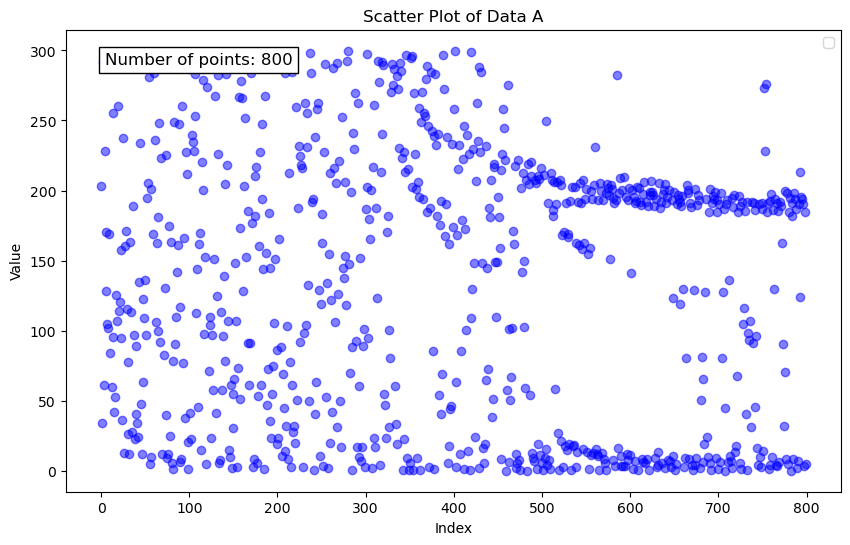

In [8]:
print(X_f_train.shape)
# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(X_f_train)), X_f_train, alpha=0.5, color='blue')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Scatter Plot of Data A')
# 在图中添加点的数量
plt.text(0.05, 0.95, f'Number of points: {len(X_f_train)}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=1))

plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(800, 1)


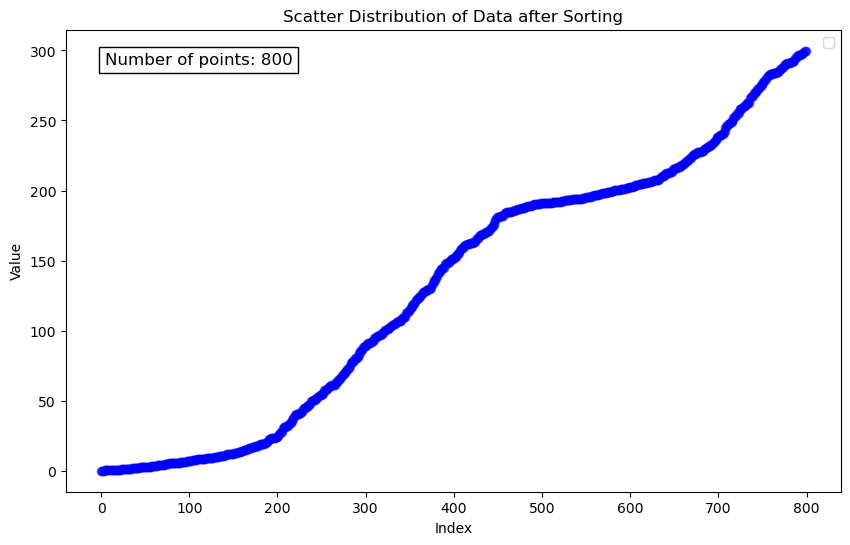

In [9]:
X = np.sort(X_f_train, axis=0)
print(X.shape)
# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(X)), X, alpha=0.5, color='blue')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Scatter Distribution of Data after Sorting')
# 在图中添加点的数量
plt.text(0.05, 0.95, f'Number of points: {len(X_f_train)}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=1))

plt.legend()
plt.show()

In [10]:
print(error_y)

error_of_u = sum(error_y)/len(error_y)

print('Error u of fuhe active learning(LHS sampling): %e' % (error_of_u)) #打印误差

print(error_mae)

error_of_mae = sum(error_mae)/len(error_mae)

print('MAE of fuhe active learning(LHS sampling): %e' % (error_of_mae)) #打印MAE

print(error_mse)

error_of_mse = sum(error_mse)/len(error_mse)

print('MSE of fuhe active learning(LHS sampling): %e' % (error_of_mse)) #打印MSE

print(chaoss)

chaos_of_u = sum(chaoss)/len(chaoss)

print('Chaos of fuhe active learning(LHS sampling): %e' % (chaos_of_u)) #打印混沌度

print(residuals)

residual_of_u = sum(residuals)/len(residuals)

print('Residual of fuhe active learning(LHS sampling): %e' % (residual_of_u)) #打印残差


[0.0007562855875952608, 0.0004618862502760734, 0.00044391196897836457, 0.0004576999574143188, 0.0004591518214321793, 0.00045539548793264176, 0.00031948233541843977, 0.00046748586961426185, 0.0004539934681681709, 0.0010299214077187622]
Error u of fuhe active learning(LHS sampling): 5.305214e-04
[0.00022751863098452555, 0.00014000059034657408, 0.00013577317073722606, 0.00013793317332895828, 0.0001381013990095945, 0.0001376272624291472, 0.00012971809267559842, 0.00014402049396253824, 0.00013725079824055095, 0.00028266124897928367]
MAE of fuhe active learning(LHS sampling): 1.610605e-04
[1.2367423437720728e-07, 4.477829504539284e-08, 4.1475851943197255e-08, 4.3718816124026955e-08, 4.384832083002388e-08, 4.335972495037801e-08, 3.279647224488615e-08, 4.566817139575471e-08, 4.316553043716344e-08, 2.154402069107544e-07]
MSE of fuhe active learning(LHS sampling): 6.779256e-08
[0.0007792104, 0.0022043143, 9.926837e-05, 3.0510575e-05, 0.0038832757, 9.915332e-05, 9.8016346e-05, 0.0024289172, 0.000

[0.0007562855875952608, 0.0004618862502760734, 0.00044391196897836457, 0.0004576999574143188, 0.0004591518214321793, 0.00045539548793264176, 0.00031948233541843977, 0.00046748586961426185, 0.0004539934681681709, 0.0010299214077187622]
mean Error u: 5.305214e-04
Variance Error u: 3.829898e-08


/tmp/ipykernel_1416233/2285129262.py:37: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


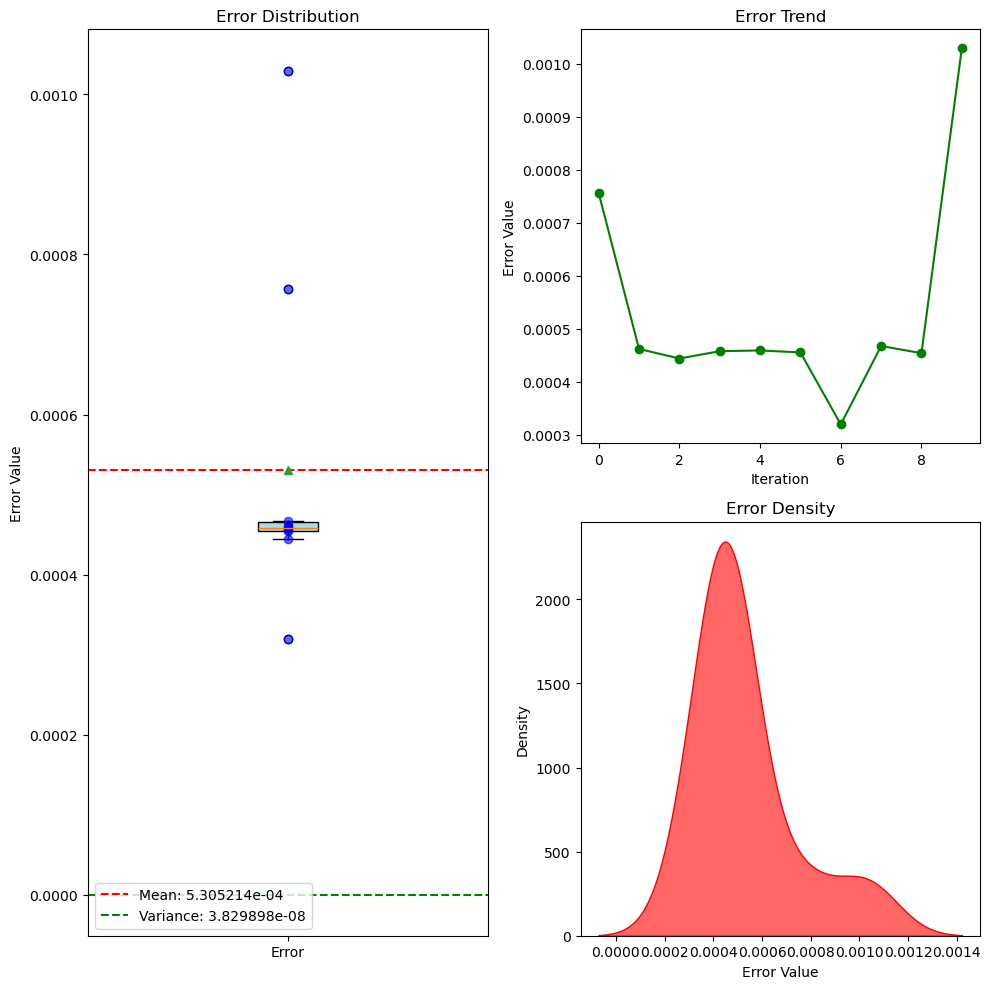

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # 导入seaborn库用于绘制密度图

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_y
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean Error u: %e' % (mean_error)) #打印误差
print('Variance Error u: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('Error Distribution')
plt.ylabel('Error Value')
plt.xticks([1], ['Error'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('Error Trend')
plt.ylabel('Error Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('Error Density')
plt.xlabel('Error Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[0.00022751863098452555, 0.00014000059034657408, 0.00013577317073722606, 0.00013793317332895828, 0.0001381013990095945, 0.0001376272624291472, 0.00012971809267559842, 0.00014402049396253824, 0.00013725079824055095, 0.00028266124897928367]
mean MAE: 1.610605e-04
Variance MAE: 2.373711e-09


/tmp/ipykernel_1416233/3953849728.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


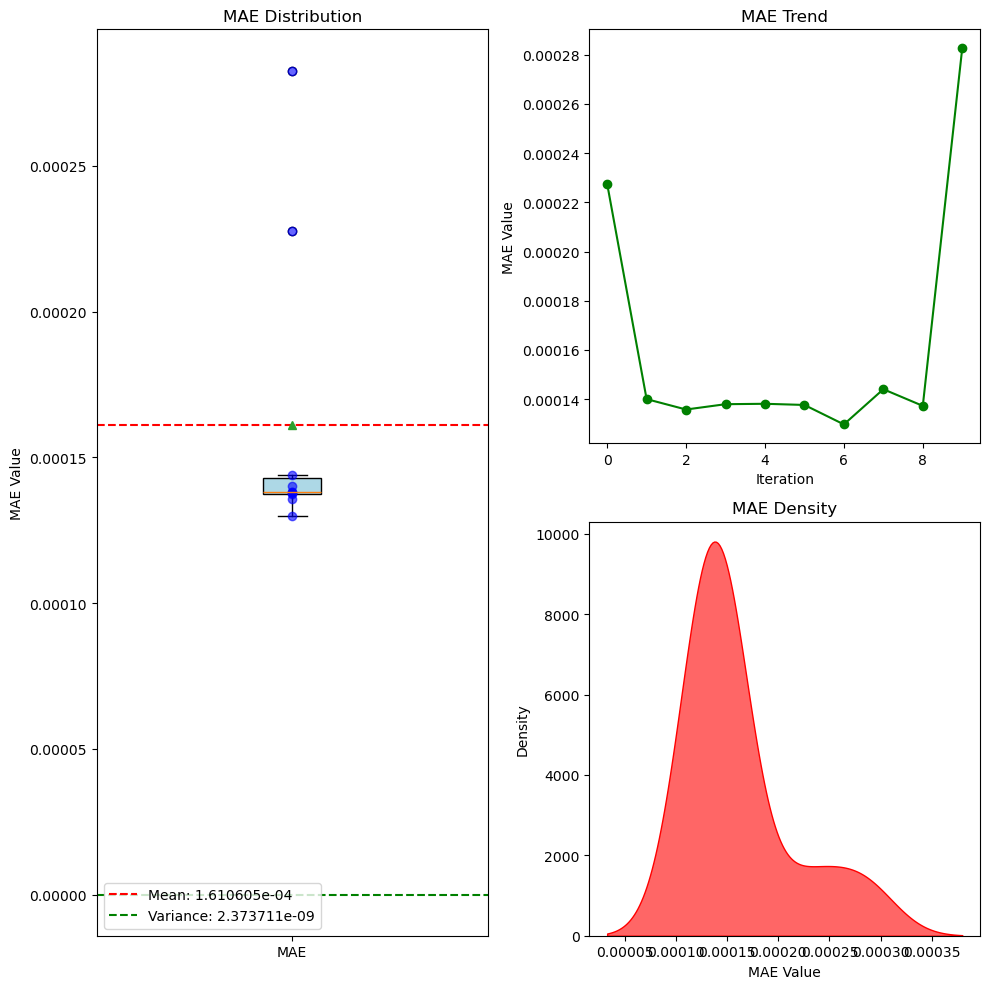

In [12]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mae
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MAE: %e' % (mean_error)) #打印误差
print('Variance MAE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MAE Distribution')
plt.ylabel('MAE Value')
plt.xticks([1], ['MAE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MAE Trend')
plt.ylabel('MAE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MAE Density')
plt.xlabel('MAE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[1.2367423437720728e-07, 4.477829504539284e-08, 4.1475851943197255e-08, 4.3718816124026955e-08, 4.384832083002388e-08, 4.335972495037801e-08, 3.279647224488615e-08, 4.566817139575471e-08, 4.316553043716344e-08, 2.154402069107544e-07]
mean MSE: 6.779256e-08
Variance MSE: 3.021536e-15


/tmp/ipykernel_1416233/3394972535.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


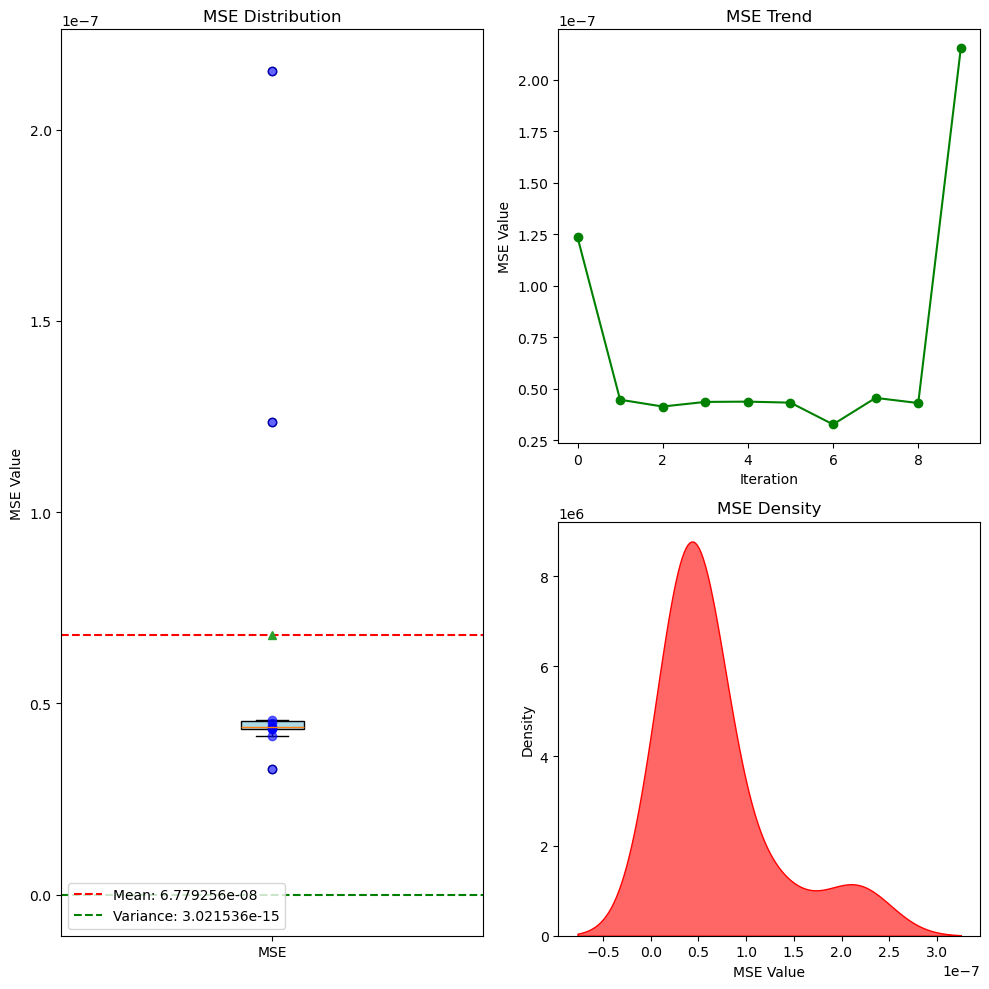

In [13]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mse
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MSE: %e' % (mean_error)) #打印误差
print('Variance MSE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MSE Distribution')
plt.ylabel('MSE Value')
plt.xticks([1], ['MSE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MSE Trend')
plt.ylabel('MSE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MSE Density')
plt.xlabel('MSE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[0.0007792104, 0.0022043143, 9.926837e-05, 3.0510575e-05, 0.0038832757, 9.915332e-05, 9.8016346e-05, 0.0024289172, 0.00046299107, 0.18255687]


/tmp/ipykernel_1416233/1804867946.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


mean CHAOS: 1.926425e-02
Variance CHAOS: 2.964259e-03


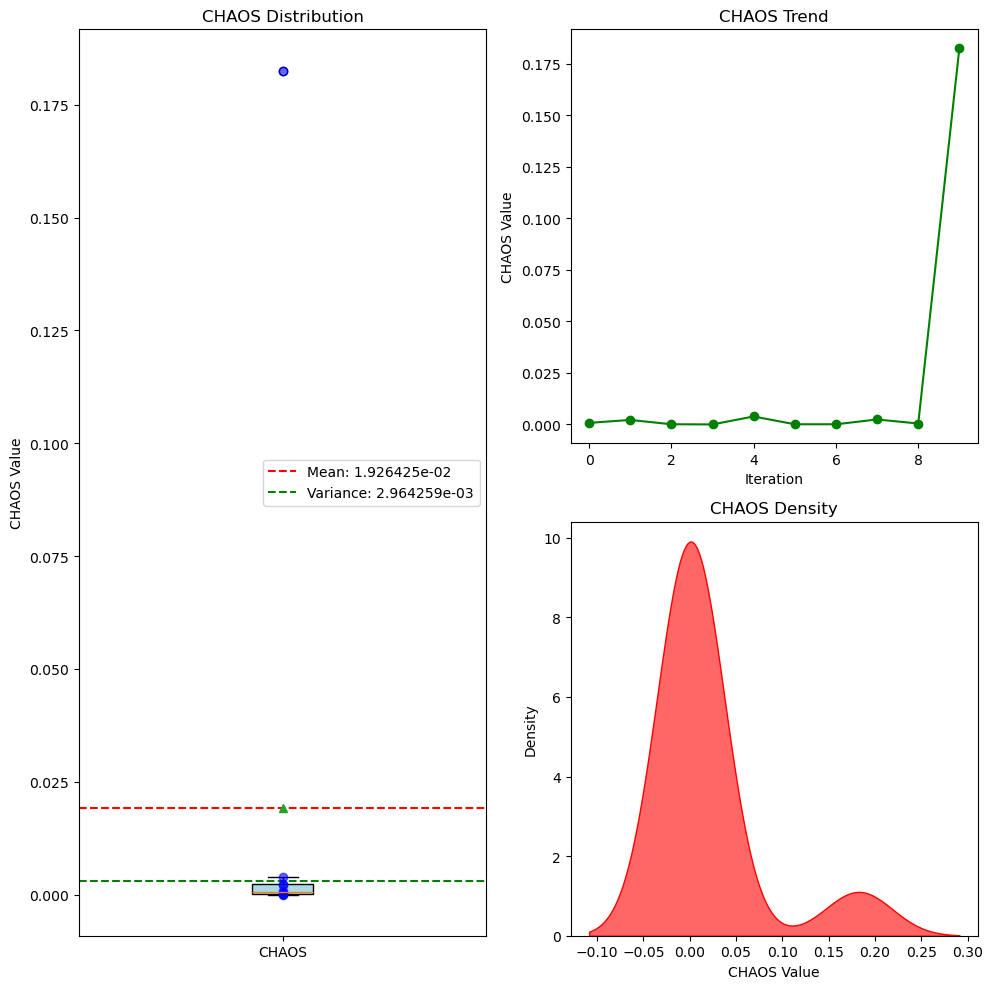

In [14]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = chaoss
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean CHAOS: %e' % (mean_error)) #打印误差
print('Variance CHAOS: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('CHAOS Distribution')
plt.ylabel('CHAOS Value')
plt.xticks([1], ['CHAOS'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('CHAOS Trend')
plt.ylabel('CHAOS Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('CHAOS Density')
plt.xlabel('CHAOS Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[4.661606e-07, 4.6742218e-07, 4.628107e-07, 4.508122e-07, 4.935995e-07, 4.0004352e-07, 4.8891116e-07, 4.2435158e-07, 5.280966e-07, 4.786275e-07]
mean RESIDUAL: 4.660836e-07
Variance RESIDUAL: 1.162976e-15


/tmp/ipykernel_1416233/2986457676.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


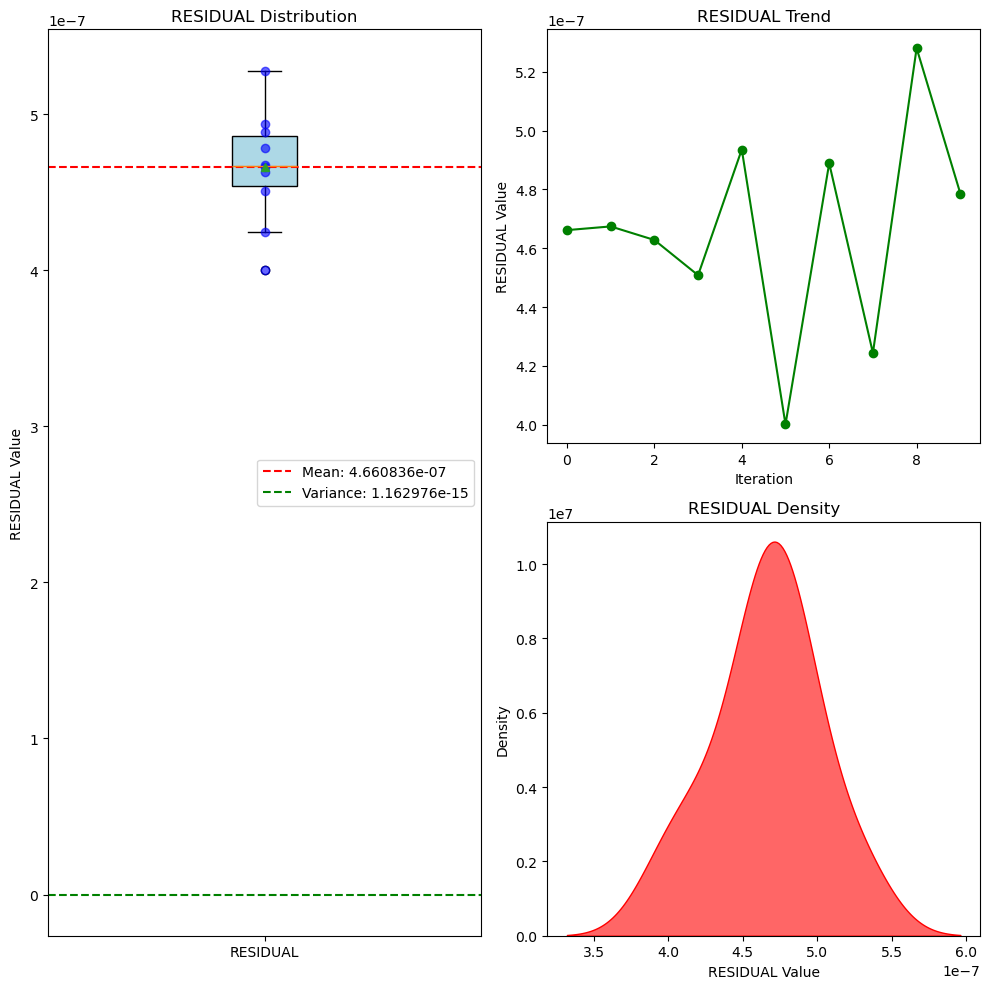

In [15]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = residuals
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean RESIDUAL: %e' % (mean_error)) #打印误差
print('Variance RESIDUAL: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('RESIDUAL Distribution')
plt.ylabel('RESIDUAL Value')
plt.xticks([1], ['RESIDUAL'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('RESIDUAL Trend')
plt.ylabel('RESIDUAL Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('RESIDUAL Density')
plt.xlabel('RESIDUAL Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

In [16]:
trainloss = torch.stack(model.loss_value).cpu().detach().numpy()

150000
[1.9635290e-01 1.6684613e-01 1.3925157e-01 ... 3.5285469e-10 4.0512571e-10
 4.8479376e-10]


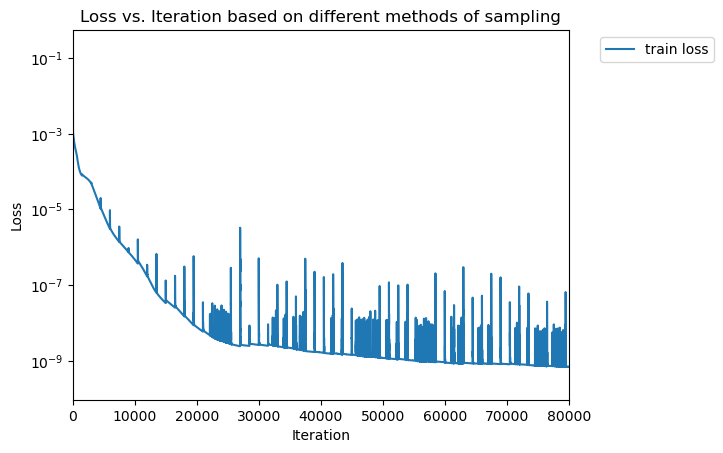

In [17]:
print(len(trainloss))
print(trainloss)
# 定义图例的标签
labels = ["Grid"]

# 创建一个新的图形
plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

plt.plot(trainloss, label='train loss')

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,80000]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()
plt.show()

Text(0, 0.5, 'Probability')

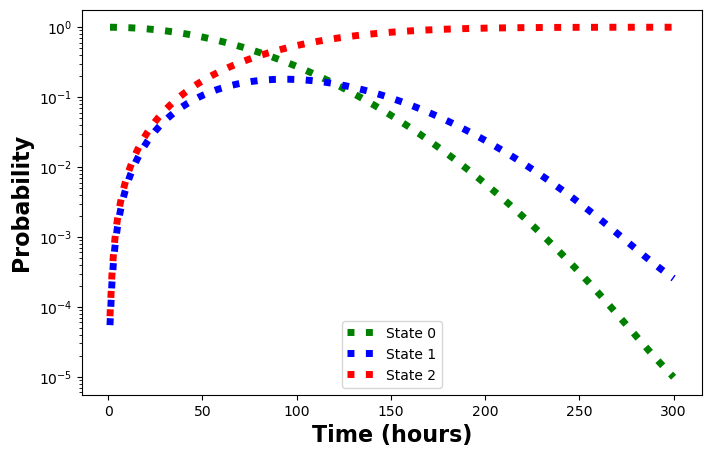

In [18]:
plt.figure(figsize=(8, 5)) #设置图形尺寸为8*5

sns.lineplot(x = x_star.flatten(), y = y_pred[:, 0], label = 'State 0', linewidth = 5, color = 'green', linestyle='dotted')
#绘制第一条折线图，横坐标为x_star，代表不同的时刻，纵坐标为exact_solution_Laplace数据的第一列，设置这条线的标签为State 0，线宽为5，颜色为绿色，线型为点线
sns.lineplot(x = x_star.flatten(), y = y_pred[:, 1], label = 'State 1', linewidth = 5, color = 'blue', linestyle='dotted')
#绘制第二条折线图，横坐标为x_star，代表不同的时刻，纵坐标为exact_solution_Laplace数据的第二列，设置这条线的标签为State 1，线宽为5，颜色为蓝色，线型为点线
sns.lineplot(x = x_star.flatten(), y = y_pred[:, 2], label = 'State 2', linewidth = 5, color = 'red', linestyle='dotted')
#绘制第三条折线图，横坐标为x_star，代表不同的时刻，纵坐标为exact_solution_Laplace数据的第三列，设置这条线的标签为State 2，线宽为5，颜色为红色，线型为点线

plt.yscale('log') #设置y轴的刻度为对数刻度
plt.xlabel("Time (hours)", fontdict=dict(weight='bold'), fontsize=16) #设置x轴标签为Time (hours)，字体加粗，字体大小为16
plt.ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16) #设置y轴标签为Probability，字体加粗，字体大小为16

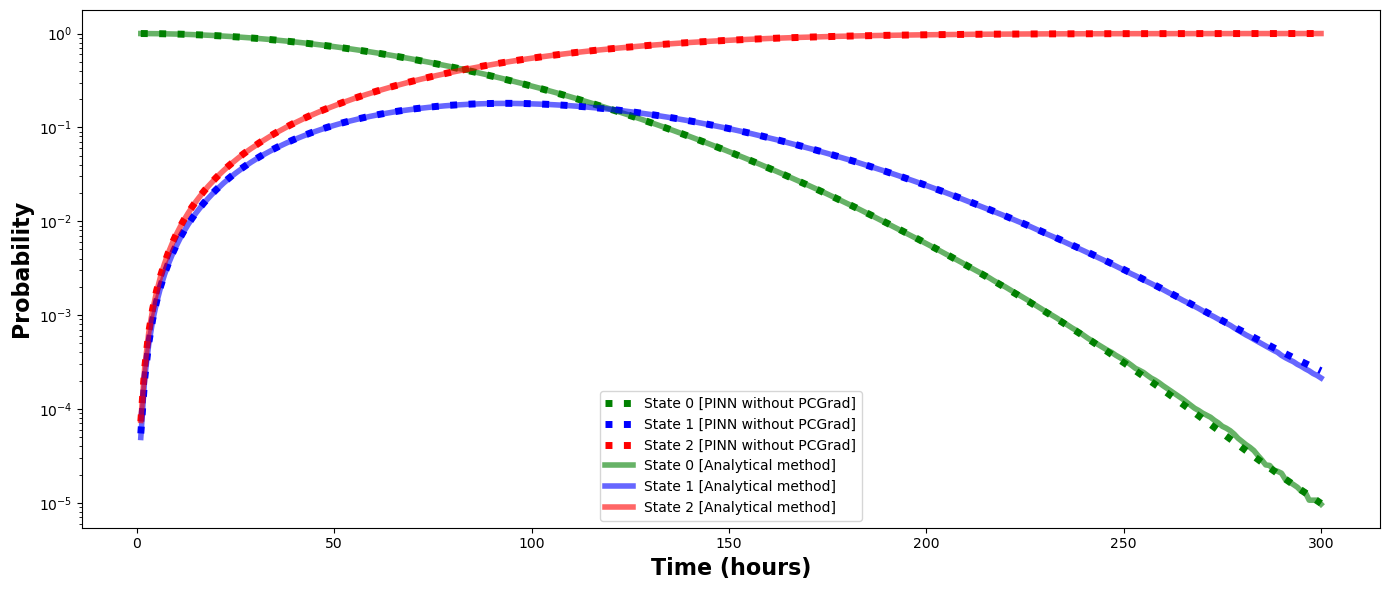

In [19]:
# 创建一个子图
f, ax = plt.subplots(1, 1, figsize=(14, 6))

# 绘制 PINN without PCGrad 方法的预测结果
sns.lineplot(x=x_star.flatten(), y=y_pred[:, 0], label='State 0 [PINN without PCGrad]', linewidth=5, color='green', linestyle='dotted', ax=ax)
sns.lineplot(x=x_star.flatten(), y=y_pred[:, 1], label='State 1 [PINN without PCGrad]', linewidth=5, color='blue', linestyle='dotted', ax=ax)
sns.lineplot(x=x_star.flatten(), y=y_pred[:, 2], label='State 2 [PINN without PCGrad]', linewidth=5, color='red', linestyle='dotted', ax=ax)

# 绘制 Runge-Kutta 方法的结果
sns.lineplot(x=x_star.flatten(), y=MCS_solution_df['state_0'], label='State 0 [Analytical method]', color='green', alpha=0.6, dashes=True, linewidth=4, ax=ax)
sns.lineplot(x=x_star.flatten(), y=MCS_solution_df['state_1'], label='State 1 [Analytical method]', color='blue', alpha=0.6, dashes=True, linewidth=4, ax=ax)
sns.lineplot(x=x_star.flatten(), y=MCS_solution_df['state_2'], label='State 2 [Analytical method]', color='red', alpha=0.6, dashes=True, linewidth=4, ax=ax)


# 设置 y 轴为对数刻度
ax.set_yscale("log")
# ax.set_ylim([1e-9, 2])
ax.set_xlabel("Time (hours)", fontdict=dict(weight='bold'), fontsize=16)
ax.set_ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16)

# 自动调整子图参数
plt.tight_layout()


# 显示图形
plt.show()

### 计算RMSE

In [20]:
y_pred_df = pd.DataFrame(y_pred, columns = ['state_0', 'state_1', 'state_2'])
print(y_pred_df.head())
print(y_pred_df.tail())

    state_0   state_1   state_2
0  0.999872  0.000055  0.000074
1  0.999512  0.000212  0.000277
2  0.998853  0.000499  0.000648
3  0.997937  0.000898  0.001165
4  0.996778  0.001402  0.001820
      state_0   state_1   state_2
295  0.000013  0.000306  0.999681
296  0.000012  0.000292  0.999696
297  0.000011  0.000279  0.999710
298  0.000011  0.000267  0.999723
299  0.000010  0.000255  0.999735


In [21]:
y_diff_no_pcgrad_MCS = MCS_solution_df - y_pred_df #解析方法（特征向量）和PINN方法差值

In [22]:
### PINN和解析方法的RMSE计算
#计算MSE，对PINN和解析方法的差值的每一行应用一个匿名函数，计算三个状态的平方和，结果存储在DataFrame的新列'mse'中
y_diff_no_pcgrad_MCS['mse'] = y_diff_no_pcgrad_MCS.apply(lambda x: x['state_0']**2 + x['state_1']**2 + x['state_2']**2, axis = 1)
#计算RMSE，对'mse'列应用np.sqrt函数，结果存储在DataFrame的新列'rmse'中
y_diff_no_pcgrad_MCS['rmse'] = y_diff_no_pcgrad_MCS['mse'].apply(np.sqrt)

In [23]:
#0-80000个时间的RMSE
print ('RMSE of between PINN without PCGrad and the analytical solution is', np.mean(y_diff_no_pcgrad_MCS['rmse']))

#前60000个时间的RMSE，3749/5000=60000/80000
print ('RMSE between PINN without PCGrad and the analytical solution before 60000 is', 
       np.mean(y_diff_no_pcgrad_MCS['rmse'][:3749]))

#60000到80000的RMSE
print ('RMSE between PINN without PCGrad and the analytical solution after 60000 is', 
       np.mean(y_diff_no_pcgrad_MCS['rmse'][3749:]))

RMSE of between PINN without PCGrad and the analytical solution is 0.0005270633355739696
RMSE between PINN without PCGrad and the analytical solution before 60000 is 0.0005270633355739696
RMSE between PINN without PCGrad and the analytical solution after 60000 is nan


### 计算混沌度和残差

In [24]:
x_star.shape

(300, 1)

In [25]:
#计算chaos
y_chaos = model.hidden_predict(x_star, 100)
# print(y_chaos)
x_sss = x_star + np.random.normal(0, 0.01)
y_chaos_sss = model.hidden_predict(x_sss, 50)
chaju = np.linalg.norm(y_chaos - y_chaos_sss,axis=1)
print(chaju)
print(chaju.shape)
print(chaju.sum())

[4.5842605 4.5354304 4.4834414 4.4264126 4.356429  4.277644  4.2159157
 4.1881886 4.177887  4.1721635 4.1654086 4.1569614 4.1480856 4.1396728
 4.1320066 4.1250997 4.1189046 4.113321  4.1083016 4.103794  4.099733
 4.0960712 4.092798  4.089863  4.087206  4.0847917 4.082619  4.080641
 4.0788054 4.0771275 4.075568  4.074126  4.072731  4.071444  4.0702147
 4.069055  4.0679517 4.066888  4.0658813 4.064912  4.0639815 4.0631022
 4.06226   4.061473  4.060702  4.0599723 4.059266  4.058603  4.057947
 4.057331  4.0567417 4.056147  4.0555806 4.055021  4.054476  4.0539365
 4.0533895 4.052839  4.05231   4.051737  4.0511756 4.05059   4.049998
 4.049378  4.048757  4.0480704 4.047411  4.046693  4.045949  4.0451727
 4.04437   4.043511  4.042629  4.0416956 4.040756  4.039705  4.0386653
 4.0375705 4.036394  4.035206  4.0339336 4.0326047 4.0312176 4.029768
 4.028291  4.0267076 4.025055  4.023344  4.0215592 4.0196733 4.017716
 4.0156527 4.01351   4.0112815 4.0089273 4.0064754 4.0038953 4.001166
 3.9983253 3.

Text(0.5, 1.0, 'Chaos of x_star')

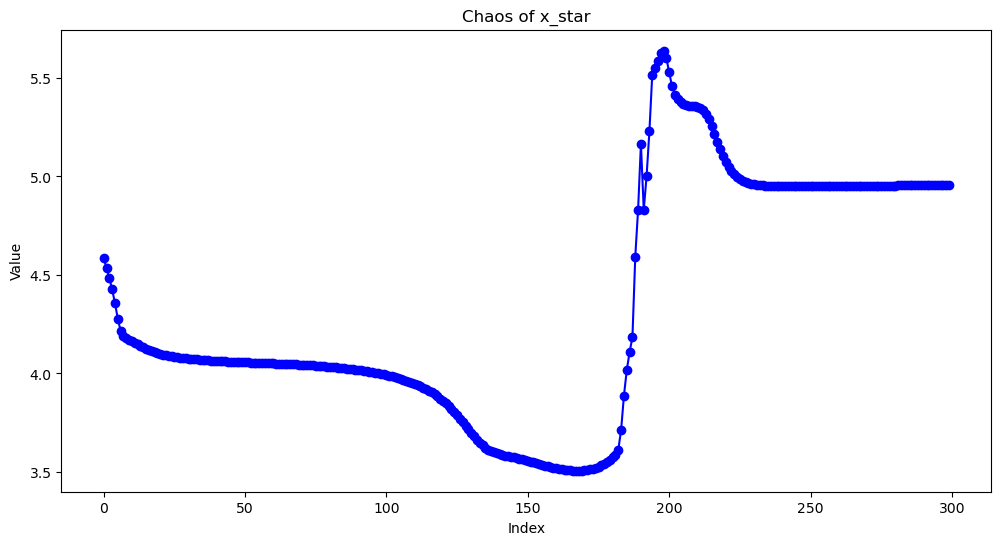

In [26]:
data = chaju
# 绘制折线图
plt.figure(figsize=(12, 6))

plt.plot(data, marker='o', linestyle='-', color='b')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Chaos of x_star')


In [27]:
#计算残差
_, residual = model.predict(x_star)
residual = residual.flatten()
print(residual)
print(residual.shape)
print(residual.sum())

[-4.6071364e-08  2.7343049e-08  7.9453457e-09  7.9744495e-09
  1.5948899e-08 -1.7695129e-08  3.7834980e-09  3.7252903e-09
 -1.1641532e-10 -2.9103830e-09  1.5133992e-09  6.9849193e-09
  4.1909516e-09  0.0000000e+00 -3.7252903e-09  3.0267984e-09
  2.7939677e-09  3.0267984e-09 -1.6298145e-09  2.0954758e-09
 -2.0954758e-09 -6.9849193e-10  9.3132257e-10  1.1641532e-09
  4.6566129e-10  1.6298145e-09 -6.9849193e-10  6.9849193e-10
  3.7252903e-09  0.0000000e+00 -6.9849193e-10  2.5611371e-09
 -4.6566129e-10  1.3969839e-09 -1.3969839e-09  2.0954758e-09
 -2.3283064e-10 -2.3283064e-10  2.0954758e-09 -2.3283064e-10
 -6.9849193e-10  0.0000000e+00  9.3132257e-10 -2.3283064e-10
 -1.1641532e-09  0.0000000e+00  2.3283064e-09  0.0000000e+00
  6.9849193e-10  4.6566129e-10  4.6566129e-10 -1.6298145e-09
  1.3969839e-09 -4.6566129e-10  0.0000000e+00 -1.1641532e-09
  4.6566129e-10  2.3283064e-10  1.3969839e-09 -6.9849193e-10
 -2.3283064e-10  2.3283064e-09  1.1641532e-09  1.3969839e-09
  0.0000000e+00 -6.98491

Text(0.5, 1.0, 'Residual of x_star')

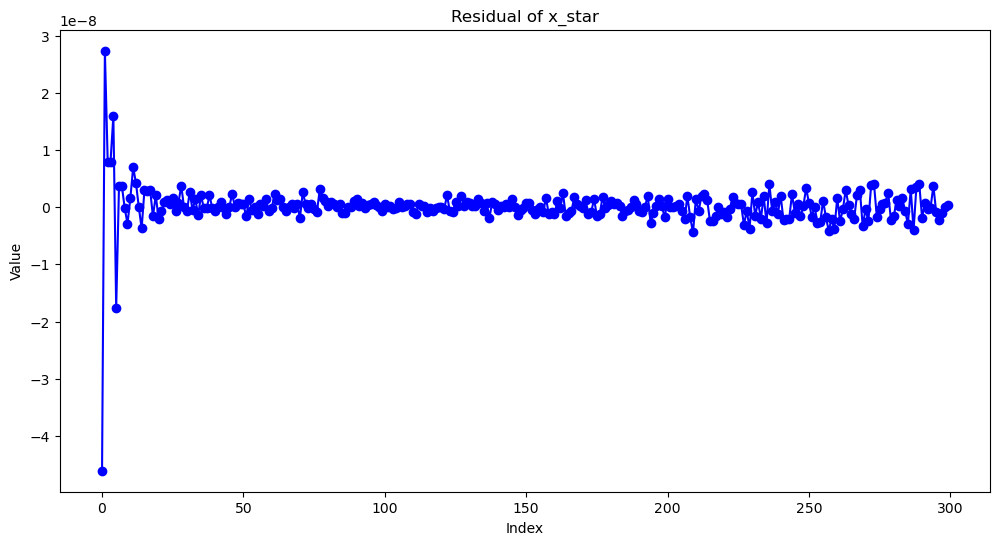

In [28]:
data = residual
# 绘制折线图
plt.figure(figsize=(12, 6))

plt.plot(data, marker='o', linestyle='-', color='b')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Residual of x_star')
